Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pasude labeling (thresholds:0.5), timeout
# Version = "v9" # pasude labeling (thresholds:0.6), timeout
# Version = "v10" # pasude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pasude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pasude labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
Version = "v21" # DEBUG = False

In [2]:
DEBUG = False

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=39
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [8]:
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

sig_id  \
0                   adenylyl_cyclase_activator   
1             aldehyde_dehydrogenase_inhibitor   
2                               antiarrhythmic   
3                               anticonvulsant   
4                                   antifungal   
5                                antihistamine   
6   atp-sensitive_potassium_channel_antagonist   
7       bacterial_membrane_integrity_inhibitor   
8                        calcineurin_inhibitor   
9       catechol_o_methyltransferase_inhibitor   
10                               cdk_inhibitor   
11                coagulation_factor_inhibitor   
12                          elastase_inhibitor   
13                             erbb2_inhibitor   
14                  nicotinic_receptor_agonist   
15           nitric_oxide_production_inhibitor   
16               protein_phosphatase_inhibitor   
17                sphingosine_receptor_agonist   
18                                     steroid   
19       ubiquitin_specific_protease_inhibitor   

                                   nonscored1  \
0                  adenylyl_cyclase_inhibitor   
1             alcohol_dehydrogenase_inhibitor   
2                       na_k-atpase_inhibitor   
3         gaba_gated_chloride_channel_blocker   
4                 fungal_ergosterol_inhibitor   
5                 histamine_release_inhibitor   
6   atp-sensitive_potassium_channel_inhibitor   
7       bacterial_protein_synthesis_inhibitor   
8                            t_cell_inhibitor   
9                   dopamine_release_enhancer   
10                         cyclin_d_inhibitor   
11                       vitamin_k_antagonist   
12               leukocyte_elastase_inhibitor   
13          protein_tyrosine_kinase_inhibitor   
14             acetylcholine_release_enhancer   
15                                vasodilator   
16             tyrosine_phosphatase_inhibitor   
17   sphingosine_1_phosphate_receptor_agonist   
18                          anti-inflammatory   
19     ubiquitin-conjugating_enzyme_inhibitor   

                                 nonscored2  
0                                       NaN  
1                                       NaN  
2                 potassium_channel_blocker  
3                                       NaN  
4   fungal_lanosterol_demethylase_inhibitor  
5                                       NaN  
6                                       NaN  
7                                       NaN  
8                                       NaN  
9                                       NaN  
10                                      NaN  
11                                      NaN  
12                                      NaN  
13                                      NaN  
14                                      NaN  
15                                      NaN  
16                                      NaN  
17                                      NaN  
18                                      NaN  
19                                      NaN

In [9]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_000644bb2                            0                       0   
1  id_000779bfc                            0                       0   
2  id_000a6266a                            0                       0   
3  id_0015fd391                            0                       0   
4  id_001626bd3                            0                       0   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0               0                               0   
1               0                               0   
2               0                               0   
3               0                               0   
4               0                               0   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   adenylyl_cyclase_activator  ...  ve-cadherin_antagonist  \
0                           0  ...                       0   
1                           0  ...                       0   
2                           0  ...                       0   
3                           0  ...                       0   
4                           0  ...                       0   

   vesicular_monoamine_transporter_inhibitor  vitamin_k_antagonist  \
0                                          0                     0   
1                                          0                     0   
2                                          0                     0   
3                                          0                     0   
4                                          0                     0   

   voltage-gated_calcium_channel_ligand  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   voltage-gated_potassium_channel_activator  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   voltage-gated_sodium_channel_blocker  wdr5_mll_interaction_inhibitor  \
0                                     0                               0   
1                                     0                               0   
2                                     0                               0   
3                                     0                               0   
4                                     0                               0   

   wnt_agonist  xanthine_oxidase_inhibitor  xiap_inhibitor  
0            0                           0               0  
1            0                           0               0  
2            0                           0               0  
3            0                           0               0  
4            0                           0               0  

[5 rows x 610 columns]

# Training Utils

In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
#def calibration(y_pred, target_rate):
#    return y_pred / (y_pred + (1 - y_pred) / target_rate)

In [13]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500,len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(k_neighbors=2, n_jobs=2, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y = pseudo_labeling(X_train, y_train, X_test, target_rate)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        #y_pred = calibration(y_pred, target_rate)
        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [14]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': Learning_rate,
    'objective': "binary",
    'colsample_bytree':0.7,
    'subsample':0.9,
    'subsample_freq':5,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'random_state':SEED,
    'n_jobs':2,
}

In [15]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    df = df.copy()
    Probability = df.iloc[:,0]
    # Remove low confidence labels
    conf_index = df[(Probability <= conf_0) & (Probability >= conf_1)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [16]:
def pseudo_labeling(X_train, y_train, X_test, target_rate, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    
    Threshold = 0.5
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict(X_val, num_iteration=clf.best_iteration_)
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
        
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        high_conf_0, high_conf_1 = y_prob.probability.min()*3, y_prob.probability.max()*0.7
        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.5f} Vs.target_rate: {target_rate:.5f}, Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target)
        if p_label_rate*3 < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label)*1.5 > check: break
                Threshold -= 0.04
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > target_rate*3:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label) < check*1.5: break
                Threshold += 0.04
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        if iter_ == max_iter:
            X_conf = X_test.copy()
        else:
            X_conf = X_test[X_test.index.isin(conf_idx)].copy()
            
        logger.info(f"threshold:{Threshold:.2f}, positive p_label:{sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.5f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates().reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
    return X, y

In [17]:
def show_feature_importance(feature_importance_df, num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [18]:
train.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5  ...    c-90    c-91    c-92    c-93    c-94    c-95  \
0 -0.1944 -1.0120  ...  0.2862  0.2584  0.8076  0.5523 -0.1912  0.6584   
1  1.0190  0.5207  ... -0.4265  0.7543  0.4708  0.0230  0.2957  0.4899   
2 -0.0323  1.2390  ... -0.7250 -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3  4.0620 -0.8095  ... -2.0990 -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4  1.4180 -0.8244  ...  0.0042  0.0048  0.6670  1.0690  0.5523 -0.3031   

     c-96    c-97    c-98    c-99  
0 -0.3981  0.2139  0.3801  0.4176  
1  0.1522  0.1241  0.6077  0.7371  
2 -0.6417 -0.2187 -1.4080  0.6931  
3 -1.6210 -0.8784 -0.3876 -0.8154  
4  0.1094  0.2885 -0.3786  0.7125  

[5 rows x 876 columns]

In [19]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [20]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [21]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
1      id_000779bfc        1        2        0  0.0743  0.4087  0.2991   
2      id_000a6266a        1        1        0  0.6280  0.5817  1.5540   
3      id_0015fd391        1        1        0 -0.5138 -0.2491 -0.2656   
4      id_001626bd3        1        2        1 -0.3254 -0.4009  0.9700   
...             ...      ...      ...      ...     ...     ...     ...   
27791  id_ff7004b87        1        0        0  0.4571 -0.5743  3.3930   
27792  id_ff925dd0d        1        0        0 -0.5885 -0.2548  2.5850   
27793  id_ffb710450        1        2        0 -0.3985 -0.1554  0.2677   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   
27795  id_ffd5800b6        1        2        0 -0.5174  0.2953  0.3286   

          g-3     g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95  \
0     -0.6208 -0.1944 -1.0120  ...  0.2584  0.8076  0.5523 -0.1912  0.6584   
1      0.0604  1.0190  0.5207  ...  0.7543  0.4708  0.0230  0.2957  0.4899   
2     -0.0764 -0.0323  1.2390  ... -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3      0.5288  4.0620 -0.8095  ... -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4      0.6919  1.4180 -0.8244  ...  0.0048  0.6670  1.0690  0.5523 -0.3031   
...       ...     ...     ...  ...     ...     ...     ...     ...     ...   
27791 -0.6202  0.8557  1.6240  ... -0.6422 -0.4367  0.0159 -0.6539 -0.4791   
27792  0.3456  0.4401  0.3107  ...  0.5780 -0.5888  0.8057  0.9312  1.2730   
27793 -0.6813  0.0152  0.4791  ...  0.9153 -0.1862  0.4049  0.9568  0.4666   
27794  1.0160 -1.3350 -0.2207  ... -0.4473 -0.8192  0.7785  0.3133  0.1286   
27795 -0.0428 -0.0800  0.8702  ...  0.1708  0.5939 -0.0507  0.2811 -0.4041   

         c-96    c-97    c-98    c-99  WHERE  
0     -0.3981  0.2139  0.3801  0.4176  train  
1      0.1522  0.1241  0.6077  0.7371  train  
2     -0.6417 -0.2187 -1.4080  0.6931  train  
3     -1.6210 -0.8784 -0.3876 -0.8154  train  
4      0.1094  0.2885 -0.3786  0.7125  train  
...       ...     ...     ...     ...    ...  
27791 -1.2680 -1.1280 -0.4167 -0.6600   test  
27792  0.2614 -0.2790 -0.0131 -0.0934   test  
27793  0.0461  0.5888 -0.4205 -0.1504   test  
27794 -0.2618  0.5074  0.7430 -0.0484   test  
27795 -0.4948  0.0757 -0.1356  0.5280   test  

[27796 rows x 877 columns]

In [22]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
25     id_0054388ec        0        1        0 -0.6696 -0.2718 -1.2230   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
40     id_007bfbb91        0        0        1 -1.3200 -1.7340 -0.0741   
47     id_008a986b7        0        1        1  0.4860  0.1430  0.5281   
63     id_009d8340f        0        0        1  0.4471 -0.0839 -0.3864   
...             ...      ...      ...      ...     ...     ...     ...   
23729  id_ff1f9e5fc        0        0        0  0.0465  0.6430 -0.2453   
23747  id_ff469c482        0        2        0 -0.6204 -1.3800 -1.1880   
23768  id_ff89331ca        0        2        1 -0.1051  0.4335  0.3648   
23793  id_ffd26f361        0        1        1  0.6008  0.2781 -0.3319   
23811  id_fffc1c3f4        0        1        1  0.3942  0.3756  0.3109   

          g-3     g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95  \
25    -0.6226 -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573   
38     0.3054 -1.1280  0.6041  ... -0.6828 -0.6594 -0.2043  0.3571 -0.1319   
40     1.5440 -1.8290 -0.0951  ...  1.0340  0.7393  1.1020  0.3786  0.2636   
47    -0.0022 -0.2334 -0.6607  ... -0.1866  0.7629  0.3288 -0.9915 -0.3694   
63     0.3196  0.2584 -0.3156  ...  0.3939  0.7665  0.7932 -0.6804 -0.0435   
...       ...     ...     ...  ...     ...     ...     ...     ...     ...   
23729  0.3521  0.6195 -0.6659  ...  0.1621 -0.2065  0.8314 -0.1891 -0.0074   
23747 -0.6573 -0.8408 -0.2447  ...  0.7366  0.5468  1.1450  0.5254  0.6224   
23768 -0.0525 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951   
23793 -0.8782  0.9281  0.7535  ...  0.9569 -0.2065 -0.4918  0.7863  0.0504   
23811 -0.7389  0.5505 -0.0159  ...  0.3755  0.7343  0.2807  0.4116  0.6422   

         c-96    c-97    c-98    c-99  WHERE  
25     0.8837  0.5534  0.8976  1.0050  train  
38     0.2187  0.0737  0.6498 -1.4820  train  
40    -0.5751  0.3362  0.8543  0.9180  train  
47    -0.4979  0.5281 -0.9245 -0.9367  train  
63     0.0949  0.2000 -0.4326  0.9364  train  
...       ...     ...     ...     ...    ...  
23729  0.2131 -0.1419 -0.2422  0.0457  train  
23747 -0.9630  0.8872 -0.0742 -0.6777  train  
23768  0.9517 -0.8110 -0.1748 -0.3626  train  
23793  0.8813  0.7757 -0.5272  0.7082  train  
23811  0.2256  0.7592  0.6656  0.3808  train  

[1866 rows x 877 columns]

In [23]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


sig_id cp_type cp_time cp_dose     g-0      g-1     g-2     g-3  \
0     id_0054388ec       0       1       0 -0.6696 -0.27180 -1.2230 -0.6226   
1     id_01b05de6c       0       1       0 -0.3176  0.48512 -0.3773  0.5555   
2     id_020ba48d9       0       1       0  0.8094 -0.33390  1.1130 -0.4192   
3     id_02c93b4a5       0       1       0 -0.0884 -1.54100  0.5562  0.4661   
4     id_03bc6d412       0       1       0  0.8431  0.09310 -0.0958 -0.4337   
...            ...     ...     ...     ...     ...      ...     ...     ...   
1861  id_fbb620181       0       2       1 -0.3490  0.72970 -4.1480 -1.0030   
1862  id_fbba92030       0       2       1 -0.8921  1.13520  0.4227  1.3270   
1863  id_fbc0849ad       0       2       1 -0.2948  0.21960 -0.3252 -0.2084   
1864  id_fd93fa37d       0       2       1 -0.2984 -0.47880 -2.3560 -0.6848   
1865  id_ff89331ca       0       2       1 -0.1051  0.43350  0.3648 -0.0525   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -0.4877  0.3413  ... -0.6163  0.8001  0.3389  0.7437  0.7533  0.2406   
2     0.4545 -0.4771  ... -0.4414 -0.2442  0.0557 -0.6597 -0.3713 -0.6929   
3    -0.1683  0.9515  ...  0.4766  0.9697  0.4613  0.8957  0.8227  1.2300   
4     1.0690 -0.6440  ... -1.1510 -0.5010 -0.2736  0.1270  0.3511  0.1233   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  2.4070 -0.9784  ... -1.4260 -0.8613 -0.0243 -0.6109  0.6377 -1.2590   
1862 -0.9839 -0.8469  ...  1.1340  0.7007  1.3320  0.6622  0.6167  0.9459   
1863 -0.6518  0.3542  ...  0.5014  0.6009  0.4560 -0.3360 -0.5091  0.6569   
1864  1.8700  1.0240  ... -0.4422 -0.6665 -0.8033 -1.0520  0.4103  0.4462   
1865 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.5057  0.8017  1.0280  train  
2    -0.3258  0.3602 -0.0595  train  
3     1.7180  0.6542  0.0580  train  
4    -0.8520  0.1767  0.1153  train  
...      ...     ...     ...    ...  
1861 -0.7238 -0.7734 -0.1274  train  
1862 -0.0344 -0.0186  0.5173  train  
1863  0.6203  0.6764  0.4504  train  
1864 -1.1580 -1.3060  0.1925  train  
1865 -0.8110 -0.1748 -0.3626  train  

[1866 rows x 877 columns]

In [24]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in data.cp_time.unique():
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        f_div = lambda x: (x+d) / (abs(med)+d)
        select_d = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select,select_d], axis=1, sort=False)
        data_df = pd.concat([data_df, tmp_data], axis=0)
data_df

4534
4538
4561
4536
5079
4548


sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...    d_c-90     d_c-91      d_c-92    d_c-93  \
0     -0.1944 -1.0120  ...  0.900850   0.827675    4.339584  1.312811   
5      1.2810  0.5203  ...  5.788465   3.705949   -5.437902  4.518651   
36    -0.5992 -0.2523  ... -2.000935  -0.524979   -0.457811  0.341813   
38    -1.1280  0.6041  ... -1.221271  -2.187049   -3.543232 -0.485616   
39     0.4869 -0.0935  ... -9.203619 -18.488086  -10.402948 -6.859977   
...       ...     ...  ...       ...        ...         ...       ...   
27754 -0.1861  0.3608  ...  3.364808  -2.944165    4.362395 -1.059934   
27759  0.6673 -1.5380  ... -6.666625  -2.994822 -108.965314 -3.263314   
27768 -0.5804  0.0633  ...  1.461452   1.221387  -12.977688 -1.847446   
27784  0.1435 -1.6810  ... -5.310498  -2.757956    9.262242 -3.612217   
27794 -1.3350 -0.2207  ...  1.671549  -2.098015  -25.599169  3.218263   

          d_c-94    d_c-95     d_c-96    d_c-97     d_c-98    d_c-99  
0      -0.411268  1.931922  -1.059899  0.630788   1.112379  1.125303  
5       3.069473  1.325997   3.226831  1.110292   2.296748  3.769866  
36      0.017855  2.201874   1.442491  2.479205   0.934446  1.298032  
38      0.768123 -0.387026   0.582269  0.217342   1.901665 -3.993519  
39     -5.953954 -7.288708  -7.193801 -6.644035 -14.152721 -1.741033  
...          ...       ...        ...       ...        ...       ...  
27754  -0.200288  3.648613   2.751680 -1.381859   0.808258 -2.753843  
27759 -19.418785 -5.186308 -16.265106 -3.400727  -8.642374 -6.611932  
27768  -1.481351 -3.441418   2.191467  1.214694  -7.687163 -2.167938  
27784  -2.189681 -6.566071 -10.169072 -3.150643  -3.656387 -5.960391  
27794   1.145102  0.570543  -1.771294  1.710143   2.599714 -0.233585  

[27796 rows x 1748 columns]

In [25]:
# clipping
clipping = data_df.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...    d_c-90     d_c-91      d_c-92    d_c-93  \
0     -0.1944 -1.0120  ...  0.900850   0.827675    4.339584  1.312811   
5      1.2810  0.5203  ...  5.788465   3.705949   -5.437902  4.518651   
36    -0.5992 -0.2523  ... -2.000935  -0.524979   -0.457811  0.341813   
38    -1.1280  0.6041  ... -1.221271  -2.187049   -3.543232 -0.485616   
39     0.4869 -0.0935  ... -9.203619 -18.488086  -10.402948 -6.859977   
...       ...     ...  ...       ...        ...         ...       ...   
27754 -0.1861  0.3608  ...  3.364808  -2.944165    4.362395 -1.059934   
27759  0.6673 -1.5380  ... -6.666625  -2.994822 -108.965314 -3.263314   
27768 -0.5804  0.0633  ...  1.461452   1.221387  -12.977688 -1.847446   
27784  0.1435 -1.6810  ... -5.310498  -2.757956    9.262242 -3.612217   
27794 -1.3350 -0.2207  ...  1.671549  -2.098015  -25.599169  3.218263   

          d_c-94    d_c-95     d_c-96    d_c-97     d_c-98    d_c-99  
0      -0.411268  1.931922  -1.059899  0.630788   1.112379  1.125303  
5       3.069473  1.325997   3.226831  1.110292   2.296748  3.769866  
36      0.017855  2.201874   1.442491  2.479205   0.934446  1.298032  
38      0.768123 -0.387026   0.582269  0.217342   1.901665 -3.993519  
39     -5.953954 -7.288708  -7.193801 -6.644035 -14.152721 -1.741033  
...          ...       ...        ...       ...        ...       ...  
27754  -0.200288  3.648613   2.751680 -1.381859   0.808258 -2.753843  
27759 -19.418785 -5.186308 -16.265106 -3.400727  -8.642374 -6.611932  
27768  -1.481351 -3.441418   2.191467  1.214694  -7.687163 -2.167938  
27784  -2.189681 -6.566071 -10.169072 -3.150643  -3.656387 -5.960391  
27794   1.145102  0.570543  -1.771294  1.710143   2.599714 -0.233585  

[27796 rows x 1748 columns]

In [26]:
data_df.cp_type = data_df.cp_type.astype('int64')
data_df.cp_time = data_df.cp_time.astype('int64')
data_df.cp_dose = data_df.cp_dose.astype('int64')
data_df.dtypes

sig_id      object
cp_type      int64
cp_time      int64
cp_dose      int64
g-0        float64
            ...   
d_c-95     float64
d_c-96     float64
d_c-97     float64
d_c-98     float64
d_c-99     float64
Length: 1748, dtype: object

In [27]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data_df

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...    d_c-90     d_c-91      d_c-92    d_c-93  \
0     -0.6208 -0.1944 -1.0120  ...  0.900850   0.827675    4.339584  1.312811   
5      0.2277  1.2810  0.5203  ...  5.788465   3.705949   -5.437902  4.518651   
36    -0.4438 -0.5992 -0.2523  ... -2.000935  -0.524979   -0.457811  0.341813   
38     0.3054 -1.1280  0.6041  ... -1.221271  -2.187049   -3.543232 -0.485616   
39    -1.1990  0.4869 -0.0935  ... -9.203619 -18.488086  -10.402948 -6.859977   
...       ...     ...     ...  ...       ...        ...         ...       ...   
27754  0.7702 -0.1861  0.3608  ...  3.364808  -2.944165    4.362395 -1.059934   
27759 -1.4950  0.6673 -1.5380  ... -6.666625  -2.994822 -108.965314 -3.263314   
27768  1.2300 -0.5804  0.0633  ...  1.461452   1.221387  -12.977688 -1.847446   
27784 -0.6764  0.1435 -1.6810  ... -5.310498  -2.757956    9.262242 -3.612217   
27794  1.0160 -1.3350 -0.2207  ...  1.671549  -2.098015  -25.599169  3.218263   

          d_c-94    d_c-95     d_c-96    d_c-97     d_c-98    d_c-99  
0      -0.411268  1.931922  -1.059899  0.630788   1.112379  1.125303  
5       3.069473  1.325997   3.226831  1.110292   2.296748  3.769866  
36      0.017855  2.201874   1.442491  2.479205   0.934446  1.298032  
38      0.768123 -0.387026   0.582269  0.217342   1.901665 -3.993519  
39     -5.953954 -7.288708  -7.193801 -6.644035 -14.152721 -1.741033  
...          ...       ...        ...       ...        ...       ...  
27754  -0.200288  3.648613   2.751680 -1.381859   0.808258 -2.753843  
27759 -19.418785 -5.186308 -16.265106 -3.400727  -8.642374 -6.611932  
27768  -1.481351 -3.441418   2.191467  1.214694  -7.687163 -2.167938  
27784  -2.189681 -6.566071 -10.169072 -3.150643  -3.656387 -5.960391  
27794   1.145102  0.570543  -1.771294  1.710143   2.599714 -0.233585  

[27796 rows x 1748 columns]

In [28]:
data_df['WHERE'] = Splitdata
data_df

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...     d_c-91      d_c-92    d_c-93  \
0     -0.6208 -0.1944 -1.0120  ...   0.827675    4.339584  1.312811   
5      0.2277  1.2810  0.5203  ...   3.705949   -5.437902  4.518651   
36    -0.4438 -0.5992 -0.2523  ...  -0.524979   -0.457811  0.341813   
38     0.3054 -1.1280  0.6041  ...  -2.187049   -3.543232 -0.485616   
39    -1.1990  0.4869 -0.0935  ... -18.488086  -10.402948 -6.859977   
...       ...     ...     ...  ...        ...         ...       ...   
27754  0.7702 -0.1861  0.3608  ...  -2.944165    4.362395 -1.059934   
27759 -1.4950  0.6673 -1.5380  ...  -2.994822 -108.965314 -3.263314   
27768  1.2300 -0.5804  0.0633  ...   1.221387  -12.977688 -1.847446   
27784 -0.6764  0.1435 -1.6810  ...  -2.757956    9.262242 -3.612217   
27794  1.0160 -1.3350 -0.2207  ...  -2.098015  -25.599169  3.218263   

          d_c-94    d_c-95     d_c-96    d_c-97     d_c-98    d_c-99  WHERE  
0      -0.411268  1.931922  -1.059899  0.630788   1.112379  1.125303  train  
5       3.069473  1.325997   3.226831  1.110292   2.296748  3.769866  train  
36      0.017855  2.201874   1.442491  2.479205   0.934446  1.298032  train  
38      0.768123 -0.387026   0.582269  0.217342   1.901665 -3.993519  train  
39     -5.953954 -7.288708  -7.193801 -6.644035 -14.152721 -1.741033  train  
...          ...       ...        ...       ...        ...       ...    ...  
27754  -0.200288  3.648613   2.751680 -1.381859   0.808258 -2.753843   test  
27759 -19.418785 -5.186308 -16.265106 -3.400727  -8.642374 -6.611932   test  
27768  -1.481351 -3.441418   2.191467  1.214694  -7.687163 -2.167938   test  
27784  -2.189681 -6.566071 -10.169072 -3.150643  -3.656387 -5.960391   test  
27794   1.145102  0.570543  -1.771294  1.710143   2.599714 -0.233585   test  

[27796 rows x 1749 columns]

In [29]:
train = data_df[data_df['WHERE']=="train"].drop('WHERE', axis=1)
test = data_df[data_df['WHERE']=="test"].drop('WHERE', axis=1)

In [30]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr = train.iloc[:, 4:]
ts = test.iloc[:, 4:]

list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train = train.drop(list_discarded, axis=1)
test = test.drop(list_discarded, axis=1)

print(f"Removed {len(list_discarded)} columns")


Removed 408 columns


In [31]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

sig_id  cp_type  cp_time  cp_dose     g-1     g-2     g-4  \
0      id_000644bb2        1        0        0  0.5577 -0.2479 -0.1944   
1      id_001762a82        1        0        0  0.2941 -0.9901  1.2810   
2      id_00762e877        1        0        0  0.1662 -0.6307 -0.5992   
3      id_0079af0fb        0        0        0 -1.8230 -0.5211 -1.1280   
4      id_0079d45d3        1        0        0 -2.1430 -0.0943  0.4869   
...             ...      ...      ...      ...     ...     ...     ...   
27791  id_fca887f42        1        1        1 -0.0461 -0.9751 -0.1861   
27792  id_fce497048        1        1        1 -0.3274 -0.0099  0.6673   
27793  id_fd75349b2        1        1        1  0.4437 -0.1530 -0.5804   
27794  id_fed0f2fe0        1        1        1  0.7350  0.3304  0.1435   
27795  id_ffbb869f2        1        1        1 -1.7750 -0.3977 -1.3350   

          g-5     g-6     g-8  ...      d_c-87     d_c-89    d_c-90  \
0     -1.0120 -1.0220  0.5548  ...   -0.458706   3.210844  0.900850   
1      0.5203  0.0543 -0.1586  ...    4.198996   7.411112  5.788465   
2     -0.2523 -1.3770 -1.4880  ...    2.130879   2.780971 -2.000935   
3      0.6041  0.3856 -0.5400  ...    0.036750   2.267525 -1.221271   
4     -0.0935  1.2090 -1.5450  ...  -18.897523  -9.183429 -9.203619   
...       ...     ...     ...  ...         ...        ...       ...   
27791  0.3608  0.5174  0.9298  ...   10.394855 -23.040415  3.364808   
27792 -1.5380 -0.5368  2.1020  ...  -53.796375 -33.477371 -6.666625   
27793  0.0633  0.6952 -0.1058  ...  110.075643  53.955575  1.461452   
27794 -1.6810 -1.1370 -0.4083  ...  -26.830434 -50.825426 -5.310498   
27795 -0.2207 -0.3611  1.0150  ...  -82.126758   6.202854  1.671549   

          d_c-91      d_c-92     d_c-94    d_c-95    d_c-97    d_c-99  WHERE  
0       0.827675    4.339584  -0.411268  1.931922  0.630788  1.125303  train  
1       3.705949   -5.437902   3.069473  1.325997  1.110292  3.769866  train  
2      -0.524979   -0.457811   0.017855  2.201874  2.479205  1.298032  train  
3      -2.187049   -3.543232   0.768123 -0.387026  0.217342 -3.993519  train  
4     -18.488086  -10.402948  -5.953954 -7.288708 -6.644035 -1.741033  train  
...          ...         ...        ...       ...       ...       ...    ...  
27791  -2.944165    4.362395  -0.200288  3.648613 -1.381859 -2.753843   test  
27792  -2.994822 -108.965314 -19.418785 -5.186308 -3.400727 -6.611932   test  
27793   1.221387  -12.977688  -1.481351 -3.441418  1.214694 -2.167938   test  
27794  -2.757956    9.262242  -2.189681 -6.566071 -3.150643 -5.960391   test  
27795  -2.098015  -25.599169   1.145102  0.570543  1.710143 -0.233585   test  

[27796 rows x 1341 columns]

In [32]:
Splitdata = data["WHERE"]
data = data.drop('WHERE', axis=1)
data

sig_id  cp_type  cp_time  cp_dose     g-1     g-2     g-4  \
0      id_000644bb2        1        0        0  0.5577 -0.2479 -0.1944   
1      id_001762a82        1        0        0  0.2941 -0.9901  1.2810   
2      id_00762e877        1        0        0  0.1662 -0.6307 -0.5992   
3      id_0079af0fb        0        0        0 -1.8230 -0.5211 -1.1280   
4      id_0079d45d3        1        0        0 -2.1430 -0.0943  0.4869   
...             ...      ...      ...      ...     ...     ...     ...   
27791  id_fca887f42        1        1        1 -0.0461 -0.9751 -0.1861   
27792  id_fce497048        1        1        1 -0.3274 -0.0099  0.6673   
27793  id_fd75349b2        1        1        1  0.4437 -0.1530 -0.5804   
27794  id_fed0f2fe0        1        1        1  0.7350  0.3304  0.1435   
27795  id_ffbb869f2        1        1        1 -1.7750 -0.3977 -1.3350   

          g-5     g-6     g-8  ...     d_c-85      d_c-87     d_c-89  \
0     -1.0120 -1.0220  0.5548  ...   0.610453   -0.458706   3.210844   
1      0.5203  0.0543 -0.1586  ...   2.368506    4.198996   7.411112   
2     -0.2523 -1.3770 -1.4880  ...  -2.098055    2.130879   2.780971   
3      0.6041  0.3856 -0.5400  ...   0.927045    0.036750   2.267525   
4     -0.0935  1.2090 -1.5450  ... -12.466870  -18.897523  -9.183429   
...       ...     ...     ...  ...        ...         ...        ...   
27791  0.3608  0.5174  0.9298  ...   0.977743   10.394855 -23.040415   
27792 -1.5380 -0.5368  2.1020  ...  -3.525817  -53.796375 -33.477371   
27793  0.0633  0.6952 -0.1058  ...   2.350949  110.075643  53.955575   
27794 -1.6810 -1.1370 -0.4083  ...  -6.247984  -26.830434 -50.825426   
27795 -0.2207 -0.3611  1.0150  ...  -0.686400  -82.126758   6.202854   

         d_c-90     d_c-91      d_c-92     d_c-94    d_c-95    d_c-97  \
0      0.900850   0.827675    4.339584  -0.411268  1.931922  0.630788   
1      5.788465   3.705949   -5.437902   3.069473  1.325997  1.110292   
2     -2.000935  -0.524979   -0.457811   0.017855  2.201874  2.479205   
3     -1.221271  -2.187049   -3.543232   0.768123 -0.387026  0.217342   
4     -9.203619 -18.488086  -10.402948  -5.953954 -7.288708 -6.644035   
...         ...        ...         ...        ...       ...       ...   
27791  3.364808  -2.944165    4.362395  -0.200288  3.648613 -1.381859   
27792 -6.666625  -2.994822 -108.965314 -19.418785 -5.186308 -3.400727   
27793  1.461452   1.221387  -12.977688  -1.481351 -3.441418  1.214694   
27794 -5.310498  -2.757956    9.262242  -2.189681 -6.566071 -3.150643   
27795  1.671549  -2.098015  -25.599169   1.145102  0.570543  1.710143   

         d_c-99  
0      1.125303  
1      3.769866  
2      1.298032  
3     -3.993519  
4     -1.741033  
...         ...  
27791 -2.753843  
27792 -6.611932  
27793 -2.167938  
27794 -5.960391  
27795 -0.233585  

[27796 rows x 1340 columns]

In [33]:
# Based on v8 notebook with feature importance

def select_importance_cols(feature_importance_df, num=103):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols


Feature_importance_df = pd.read_csv("../input/../input/moa-annot-data/feature_importance_df.v8.colab.csv")
Feature_importance_df

importance_cols = select_importance_cols(Feature_importance_df)

len(importance_cols)

103

In [34]:
FI = data[importance_cols]
FI = FI.drop(["cp_type", "cp_time", "cp_dose"], axis=1)
FI

c-98   g-763   g-231   g-178    g-91   g-635     d_g-87   g-254  \
0      0.3801 -0.3167 -1.6510 -0.6217 -1.1230 -0.2461   4.183851 -1.3310   
1      0.7848  0.4842  0.0333 -0.5141  0.4944 -1.1160  -9.101135  0.5149   
2      0.3193  0.4587 -0.8791  0.2905 -0.1851  0.0860  -5.791252 -1.6090   
3      0.6498  0.6086 -0.5522  0.4275 -0.7775  0.2270  -2.712772  0.8298   
4     -4.8360 -1.1320  2.3720 -0.8283  1.5840 -2.3630  -1.055764 -0.9043   
...       ...     ...     ...     ...     ...     ...        ...     ...   
27791  0.2310 -0.2914  0.1655  0.2242  0.1058 -1.0330  -2.921354  0.5788   
27792 -2.4700  1.0300  0.2641 -1.0190  5.7110 -2.3140 -19.551915  1.8170   
27793 -2.1970  0.0199  0.0428  0.7036  2.8370  0.9448   5.732132 -1.6010   
27794 -1.0450 -0.2809 -0.8224  0.2189 -1.0990  0.9241  -0.123390 -1.4440   
27795  0.7430 -0.6110  0.1732  1.1760 -0.0884  0.6021  -3.973446 -0.4366   

          d_g-202    g-207  ...    d_g-39   g-569    g-65   d_g-743  \
0       20.720024 -0.22130  ... -0.463249  0.1242  0.0251  2.647177   
1     -121.467612  0.07920  ...  0.712450  0.4590 -0.2584  1.543021   
2      134.510130 -0.07250  ...  1.025284 -0.2491  0.1676 -3.476730   
3       74.254500 -1.66400  ... -0.539958  1.3530 -0.2259 -0.720046   
4      140.770455  3.85415  ...  3.627592 -4.4690  1.8870 -9.592403   
...           ...      ...  ...       ...     ...     ...       ...   
27791  -13.888734 -0.31340  ... -1.244962 -0.4987 -0.4098  0.769766   
27792   56.104299  0.69710  ...  1.129264 -4.7070  4.7440  2.384589   
27793 -249.158505 -2.55600  ... -1.024153 -0.0303  0.7360 -5.974495   
27794   -7.429982  0.82050  ...  1.669632  0.6461 -0.4913  3.565008   
27795  -33.338757  0.02360  ... -0.193683  0.4374  0.7240  3.084269   

           d_g-580   g-105   d_g-157   g-201   d_g-435    c-67  
0       -10.548861 -1.2560 -0.262194  0.4171 -2.345232  1.2570  
1         2.532123 -0.2533 -2.819025 -0.4584  3.110345  0.4290  
2        -1.085747 -0.5656 -3.664973  0.6659 -3.906875 -0.3232  
3        31.350629  0.3576  0.201876  0.0597  3.599244 -0.9233  
4        43.259989  0.0328 -3.335726  4.2690  3.422303 -0.8781  
...            ...     ...       ...     ...       ...     ...  
27791  -155.100886  0.1914 -4.482931 -0.5465  0.340697 -0.6500  
27792  1016.814588 -0.1688  6.439848  0.8439 -2.063460 -5.1430  
27793  -110.383776  1.5240  9.631421  0.1586  1.600912 -0.7809  
27794   253.578959  0.7208  5.579313 -0.2808 -0.563337 -0.8265  
27795   177.346285  1.2070  4.982948  0.6796  1.254125  0.6205  

[27796 rows x 100 columns]

In [35]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]

g_list

['g-1',
 'g-2',
 'g-4',
 'g-5',
 'g-6',
 'g-8',
 'g-9',
 'g-10',
 'g-12',
 'g-13',
 'g-14',
 'g-15',
 'g-16',
 'g-18',
 'g-19',
 'g-20',
 'g-23',
 'g-24',
 'g-25',
 'g-26',
 'g-27',
 'g-28',
 'g-29',
 'g-30',
 'g-31',
 'g-32',
 'g-33',
 'g-34',
 'g-35',
 'g-36',
 'g-38',
 'g-39',
 'g-40',
 'g-41',
 'g-42',
 'g-43',
 'g-44',
 'g-45',
 'g-46',
 'g-47',
 'g-48',
 'g-49',
 'g-50',
 'g-51',
 'g-53',
 'g-54',
 'g-55',
 'g-56',
 'g-57',
 'g-58',
 'g-59',
 'g-61',
 'g-62',
 'g-64',
 'g-65',
 'g-67',
 'g-69',
 'g-70',
 'g-71',
 'g-73',
 'g-74',
 'g-77',
 'g-78',
 'g-79',
 'g-81',
 'g-83',
 'g-87',
 'g-88',
 'g-89',
 'g-90',
 'g-91',
 'g-93',
 'g-94',
 'g-95',
 'g-96',
 'g-97',
 'g-99',
 'g-103',
 'g-104',
 'g-105',
 'g-106',
 'g-107',
 'g-108',
 'g-109',
 'g-110',
 'g-111',
 'g-113',
 'g-114',
 'g-115',
 'g-116',
 'g-117',
 'g-118',
 'g-119',
 'g-121',
 'g-122',
 'g-123',
 'g-124',
 'g-125',
 'g-126',
 'g-127',
 'g-128',
 'g-129',
 'g-130',
 'g-131',
 'g-132',
 'g-133',
 'g-136',
 'g-137',
 'g-

In [36]:
from sklearn.preprocessing import StandardScaler
    
# Z-score
scaler = StandardScaler(with_mean=True, with_std=True)
std_values = scaler.fit_transform(data.iloc[:, 4:])
std_df = pd.DataFrame(std_values, index=data.index, columns=data.columns[4:])
    

In [37]:
from sklearn.decomposition import PCA
from umap import UMAP

# PCA for all data
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_all = pca_transformer.fit_transform(std_df)

# PCA → UMAP for all data
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_all = umap.fit_transform(pca_all)

print(pca_umap_all.shape)

(27796, 10)


In [38]:
# PCA for merged categories
g_d_g_list = g_list + d_g_list
c_d_c_list = c_list + d_c_list

pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])

# PCA → UMAP for merged categories
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g_d_g = umap.fit_transform(pca_g_d_g)

umap = UMAP(n_components=2, random_state=SEED)
pca_umap_c_d_c = umap.fit_transform(pca_c_d_c)

print(pca_umap_g_d_g.shape)
print(pca_umap_c_d_c.shape)

(27796, 10)
(27796, 2)


In [39]:
# PCA for each category
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

# PCA → UMAP for each category
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g = umap.fit_transform(pca_g)
pca_umap_d_g = umap.fit_transform(pca_d_g)

umap = UMAP(n_components=2, random_state=SEED)
pca_umap_c = umap.fit_transform(pca_c)
pca_umap_d_c = umap.fit_transform(pca_d_c)

print(pca_umap_g.shape)
print(pca_umap_c.shape)
print(pca_umap_d_g.shape)
print(pca_umap_d_c.shape)

(27796, 323)
(27796, 13)
(27796, 394)
(27796, 25)
(27796, 10)
(27796, 2)
(27796, 10)
(27796, 2)


In [40]:
# PCA for all categories
pca_transformer = PCA(n_components=3, whiten=True, random_state=SEED)

pca_all = pca_transformer.fit_transform(std_df)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_all.shape)
print(pca_g_d_g.shape)
print(pca_c_d_c.shape)
print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)


In [41]:
data_list = [ 
    pca_umap_all,
    pca_umap_g_d_g,
    pca_umap_c_d_c,
    pca_umap_g,
    pca_umap_c,
    pca_umap_d_g,
    pca_umap_d_c,
    pca_all,
    pca_g_d_g,
    pca_c_d_c,
    pca_g,
    pca_c,
    pca_d_g,
    pca_d_c,
]

data_names = [ 
    "pca_umap_all",
    "pca_umap_g_d_g",
    "pca_umap_c_d_c",
    "pca_umap_g",
    "pca_umap_c",
    "pca_umap_d_g",
    "pca_umap_d_c",
    "pca_all",
    "pca_g_d_g",
    "pca_c_d_c",
    "pca_g",
    "pca_c",
    "pca_d_g",
    "pca_d_c",
]

In [42]:
col_list = []
for i, d in enumerate(data_list):
    for j in range(d.shape[1]):
        col_list.append( f"{data_names[i]}_{j+1}")
col_list

['pca_umap_all_1',
 'pca_umap_all_2',
 'pca_umap_all_3',
 'pca_umap_all_4',
 'pca_umap_all_5',
 'pca_umap_all_6',
 'pca_umap_all_7',
 'pca_umap_all_8',
 'pca_umap_all_9',
 'pca_umap_all_10',
 'pca_umap_g_d_g_1',
 'pca_umap_g_d_g_2',
 'pca_umap_g_d_g_3',
 'pca_umap_g_d_g_4',
 'pca_umap_g_d_g_5',
 'pca_umap_g_d_g_6',
 'pca_umap_g_d_g_7',
 'pca_umap_g_d_g_8',
 'pca_umap_g_d_g_9',
 'pca_umap_g_d_g_10',
 'pca_umap_c_d_c_1',
 'pca_umap_c_d_c_2',
 'pca_umap_g_1',
 'pca_umap_g_2',
 'pca_umap_g_3',
 'pca_umap_g_4',
 'pca_umap_g_5',
 'pca_umap_g_6',
 'pca_umap_g_7',
 'pca_umap_g_8',
 'pca_umap_g_9',
 'pca_umap_g_10',
 'pca_umap_c_1',
 'pca_umap_c_2',
 'pca_umap_d_g_1',
 'pca_umap_d_g_2',
 'pca_umap_d_g_3',
 'pca_umap_d_g_4',
 'pca_umap_d_g_5',
 'pca_umap_d_g_6',
 'pca_umap_d_g_7',
 'pca_umap_d_g_8',
 'pca_umap_d_g_9',
 'pca_umap_d_g_10',
 'pca_umap_d_c_1',
 'pca_umap_d_c_2',
 'pca_all_1',
 'pca_all_2',
 'pca_all_3',
 'pca_g_d_g_1',
 'pca_g_d_g_2',
 'pca_g_d_g_3',
 'pca_c_d_c_1',
 'pca_c_d_c_2',


In [43]:
result_df = pd.DataFrame(data_list[0])
for d in data_list[1:]:
    tmp_df = pd.DataFrame(d)
    result_df = pd.concat([result_df, tmp_df], axis=1)
result_df.columns = col_list
result_df

pca_umap_all_1  pca_umap_all_2  pca_umap_all_3  pca_umap_all_4  \
0            0.414406        0.909078       -1.512993        0.927889   
1            0.786781       -0.427628       -0.109586        0.892243   
2            0.420639       -0.087313       -0.534235        0.388297   
3            0.446064        0.085459       -0.294690        0.552296   
4            0.227194       -0.630111       -0.460141        0.464349   
...               ...             ...             ...             ...   
27791        0.544228        1.004292       -1.393493        0.820182   
27792        0.443511        0.862770       -1.327139        0.746451   
27793        1.028752        0.136440       -1.150451        1.722474   
27794        0.511500        0.943903       -1.439615        0.766808   
27795        0.577233        1.047826       -1.585765        0.898960   

       pca_umap_all_5  pca_umap_all_6  pca_umap_all_7  pca_umap_all_8  \
0           -0.848250        0.769027       -0.631963        0.520953   
1           -0.456970        0.178259       -0.837569        0.656989   
2           -0.543968        0.667831       -1.044028        0.611787   
3           -0.212881        0.279669       -0.463792        0.222208   
4           -0.928014        0.013562       -0.936194        0.003462   
...               ...             ...             ...             ...   
27791       -0.471184        0.531311       -0.518431        0.616687   
27792       -0.526177        0.569458       -0.553066        0.555583   
27793       -0.885569       -0.035729       -1.325753        0.832510   
27794       -0.643382        0.663832       -0.554051        0.652266   
27795       -0.743697        0.656077       -0.597336        0.446594   

       pca_umap_all_9  pca_umap_all_10  ...   pca_g_3   pca_c_1   pca_c_2  \
0           -0.489372         0.596058  ... -1.140890 -0.469951  0.099505   
1            0.557744         0.862181  ...  0.393231 -0.814709  0.613391   
2            0.327000         0.522496  ... -0.603388 -0.262629 -0.104706   
3            0.172640         0.482514  ...  0.520171 -0.202956 -0.340746   
4            1.613957         0.086733  ... -2.687000  1.478095  0.804459   
...               ...              ...  ...       ...       ...       ...   
27791       -0.967858         0.699507  ...  0.282427 -0.124308 -0.178446   
27792       -0.925586         0.635752  ... -2.186621  0.986815  5.615881   
27793        0.902315         1.563123  ... -1.047883 -0.212064  0.409555   
27794       -0.881698         0.647011  ...  0.111515  0.261040 -0.357443   
27795       -0.733414         0.742856  ...  0.333435 -0.301612 -0.184996   

        pca_c_3  pca_d_g_1  pca_d_g_2  pca_d_g_3  pca_d_c_1  pca_d_c_2  \
0      0.543770  -0.412404   0.344801   0.037566  -0.352178   0.185292   
1     -0.238404  -0.522178  -0.182825   0.440264  -0.575022   0.122275   
2      0.204114  -0.150261   0.224066  -0.477699  -0.254322   0.146491   
3     -1.418043  -0.040187  -0.775782  -0.318853  -0.157597  -0.122486   
4      2.194776   1.834257   0.532104  -2.136533   0.808826  -0.534457   
...         ...        ...        ...        ...        ...        ...   
27791  0.631366  -0.533474   1.250751   0.927038  -0.070210   0.002111   
27792 -1.809798   1.305137   1.420641  -1.273816   1.123556  -2.183204   
27793  2.046140  -0.126035   0.358089  -0.604766  -0.223797   0.372728   
27794  0.309463  -0.092845  -0.936262  -0.360358   0.259394  -0.407341   
27795 -1.040928  -0.157386  -2.223984  -0.787729  -0.260970  -0.111751   

       pca_d_c_3  
0       0.004245  
1       0.280131  
2      -0.005201  
3      -0.020528  
4      -0.547478  
...          ...  
27791  -0.157756  
27792   0.610776  
27793   0.561805  
27794   0.143140  
27795  -0.184235  

[27796 rows x 67 columns]

In [44]:
# Merge data
result_df = pd.concat([result_df, FI], axis=1)

In [45]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], result_df], axis=1)
data

sig_id  cp_type  cp_time  cp_dose  pca_umap_all_1  \
0      id_000644bb2        1        0        0        0.414406   
1      id_001762a82        1        0        0        0.786781   
2      id_00762e877        1        0        0        0.420639   
3      id_0079af0fb        0        0        0        0.446064   
4      id_0079d45d3        1        0        0        0.227194   
...             ...      ...      ...      ...             ...   
27791  id_fca887f42        1        1        1        0.544228   
27792  id_fce497048        1        1        1        0.443511   
27793  id_fd75349b2        1        1        1        1.028752   
27794  id_fed0f2fe0        1        1        1        0.511500   
27795  id_ffbb869f2        1        1        1        0.577233   

       pca_umap_all_2  pca_umap_all_3  pca_umap_all_4  pca_umap_all_5  \
0            0.909078       -1.512993        0.927889       -0.848250   
1           -0.427628       -0.109586        0.892243       -0.456970   
2           -0.087313       -0.534235        0.388297       -0.543968   
3            0.085459       -0.294690        0.552296       -0.212881   
4           -0.630111       -0.460141        0.464349       -0.928014   
...               ...             ...             ...             ...   
27791        1.004292       -1.393493        0.820182       -0.471184   
27792        0.862770       -1.327139        0.746451       -0.526177   
27793        0.136440       -1.150451        1.722474       -0.885569   
27794        0.943903       -1.439615        0.766808       -0.643382   
27795        1.047826       -1.585765        0.898960       -0.743697   

       pca_umap_all_6  ...    d_g-39   g-569    g-65   d_g-743      d_g-580  \
0            0.769027  ... -0.463249  0.1242  0.0251  2.647177   -10.548861   
1            0.178259  ...  0.712450  0.4590 -0.2584  1.543021     2.532123   
2            0.667831  ...  1.025284 -0.2491  0.1676 -3.476730    -1.085747   
3            0.279669  ... -0.539958  1.3530 -0.2259 -0.720046    31.350629   
4            0.013562  ...  3.627592 -4.4690  1.8870 -9.592403    43.259989   
...               ...  ...       ...     ...     ...       ...          ...   
27791        0.531311  ... -1.244962 -0.4987 -0.4098  0.769766  -155.100886   
27792        0.569458  ...  1.129264 -4.7070  4.7440  2.384589  1016.814588   
27793       -0.035729  ... -1.024153 -0.0303  0.7360 -5.974495  -110.383776   
27794        0.663832  ...  1.669632  0.6461 -0.4913  3.565008   253.578959   
27795        0.656077  ... -0.193683  0.4374  0.7240  3.084269   177.346285   

        g-105   d_g-157   g-201   d_g-435    c-67  
0     -1.2560 -0.262194  0.4171 -2.345232  1.2570  
1     -0.2533 -2.819025 -0.4584  3.110345  0.4290  
2     -0.5656 -3.664973  0.6659 -3.906875 -0.3232  
3      0.3576  0.201876  0.0597  3.599244 -0.9233  
4      0.0328 -3.335726  4.2690  3.422303 -0.8781  
...       ...       ...     ...       ...     ...  
27791  0.1914 -4.482931 -0.5465  0.340697 -0.6500  
27792 -0.1688  6.439848  0.8439 -2.063460 -5.1430  
27793  1.5240  9.631421  0.1586  1.600912 -0.7809  
27794  0.7208  5.579313 -0.2808 -0.563337 -0.8265  
27795  1.2070  4.982948  0.6796  1.254125  0.6205  

[27796 rows x 171 columns]

In [46]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

sig_id  cp_type  cp_time  cp_dose  pca_umap_all_1  \
0      id_000644bb2        1        0        0        0.414406   
1      id_001762a82        1        0        0        0.786781   
2      id_00762e877        1        0        0        0.420639   
3      id_0079af0fb        0        0        0        0.446064   
4      id_0079d45d3        1        0        0        0.227194   
...             ...      ...      ...      ...             ...   
27791  id_fca887f42        1        1        1        0.544228   
27792  id_fce497048        1        1        1        0.443511   
27793  id_fd75349b2        1        1        1        1.028752   
27794  id_fed0f2fe0        1        1        1        0.511500   
27795  id_ffbb869f2        1        1        1        0.577233   

       pca_umap_all_2  pca_umap_all_3  pca_umap_all_4  pca_umap_all_5  \
0            0.909078       -1.407962        0.927889       -0.848250   
1           -0.427628       -0.109586        0.892243       -0.456970   
2           -0.087313       -0.534235        0.388297       -0.543968   
3            0.085459       -0.294690        0.552296       -0.212881   
4           -0.630111       -0.460141        0.464349       -0.923120   
...               ...             ...             ...             ...   
27791        1.004292       -1.393493        0.820182       -0.471184   
27792        0.862770       -1.327139        0.746451       -0.526177   
27793        0.136440       -1.150451        1.162132       -0.885569   
27794        0.943903       -1.407962        0.766808       -0.643382   
27795        1.047826       -1.407962        0.898960       -0.743697   

       pca_umap_all_6  ...    d_g-39   g-569    g-65   d_g-743      d_g-580  \
0            0.769027  ... -0.463249  0.1242  0.0251  2.647177   -10.548861   
1            0.178259  ...  0.712450  0.4590 -0.2584  1.543021     2.532123   
2            0.667831  ...  1.025284 -0.2491  0.1676 -3.476730    -1.085747   
3            0.279669  ... -0.539958  1.3530 -0.2259 -0.720046    31.350629   
4            0.013562  ...  3.627592 -4.4690  1.8870 -9.592403    43.259989   
...               ...  ...       ...     ...     ...       ...          ...   
27791        0.531311  ... -1.244962 -0.4987 -0.4098  0.769766  -155.100886   
27792        0.569458  ...  1.129264 -4.7070  4.7440  2.384589  1016.814588   
27793       -0.035729  ... -1.024153 -0.0303  0.7360 -5.974495  -110.383776   
27794        0.663832  ...  1.669632  0.6461 -0.4913  3.565008   253.578959   
27795        0.656077  ... -0.193683  0.4374  0.7240  3.084269   177.346285   

        g-105   d_g-157   g-201   d_g-435    c-67  
0     -1.2560 -0.262194  0.4171 -2.345232  1.2570  
1     -0.2533 -2.819025 -0.4584  3.110345  0.4290  
2     -0.5656 -3.664973  0.6659 -3.906875 -0.3232  
3      0.3576  0.201876  0.0597  3.599244 -0.9233  
4      0.0328 -3.335726  4.2690  3.422303 -0.8781  
...       ...       ...     ...       ...     ...  
27791  0.1914 -4.482931 -0.5465  0.340697 -0.6500  
27792 -0.1688  6.439848  0.8439 -2.063460 -5.1430  
27793  1.5240  9.631421  0.1586  1.600912 -0.7809  
27794  0.7208  5.579313 -0.2808 -0.563337 -0.8265  
27795  1.2070  4.982948  0.6796  1.254125  0.6205  

[27796 rows x 171 columns]

In [47]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

# Modeling

In [48]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    # 'metric': 'average_precision',
    'is_unbalance': True,
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,

}

categorical_cols = []
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [49]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
        
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.275507	valid_1's binary_logloss: 0.306101
[200]	training's binary_logloss: 0.123394	valid_1's binary_logloss: 0.154802
[300]	training's binary_logloss: 0.0583933	valid_1's binary_logloss: 0.0861986
[400]	training's binary_logloss: 0.0296163	valid_1's binary_logloss: 0.0542715
[500]	training's binary_logloss: 0.0157836	valid_1's binary_logloss: 0.0373806
[600]	training's binary_logloss: 0.00895907	valid_1's binary_logloss: 0.0270642
[700]	training's binary_logloss: 0.00556945	valid_1's binary_logloss: 0.0214779
[800]	training's binary_logloss: 0.00376836	valid_1's binary_logloss: 0.0176476
[900]	training's binary_logloss: 0.00275492	valid_1's binary_logloss: 0.0155984
[1000]	training's binary_logloss: 0.00214305	valid_1's binary_logloss: 0.0140833
[1100]	training's binary_logloss: 0.00174148	valid_1's binary_logloss: 0.0131074
[1200]	training's binary_logloss: 0.0014785	valid_1's binary_loglo

Remove_noisy_labels: 4 → positive_corect_labels: 499/996
p_label_rate: 0.00100 Vs.target_rate: 0.00071, Num_p_label: 4.0, conf_0:0.00020, conf_1:0.54790
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.269321	valid_1's binary_logloss: 0.302477
[200]	training's binary_logloss: 0.120463	valid_1's binary_logloss: 0.153184
[300]	training's binary_logloss: 0.0569001	valid_1's binary_logloss: 0.0833816
[400]	training's binary_logloss: 0.0285413	valid_1's binary_logloss: 0.0492507
[500]	training's binary_logloss: 0.0151791	valid_1's binary_logloss: 0.0305664
[600]	training's binary_logloss: 0.00859525	valid_1's binary_logloss: 0.0204216
[700]	training's binary_logloss: 0.00534212	valid_1's binary_logloss: 0.015152
[800]	training's binary_logloss: 0.0036191	valid_1's binary_logloss: 0.0119204
[900]	training's binary_logloss: 0.00265706	valid_1's binary_logloss: 0.0100713
[1000]	training's binary_logloss: 0.0020591	valid_1's binary_logloss: 0.00873145
[1100]	training's binary_logloss: 0.00168855	valid_1's binary_logloss: 0.00781235
[1200]	training's binary_logloss: 0.00143693	valid_1's binary_loglo

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/996
p_label_rate: 0.00251 Vs.target_rate: 0.00071, Num_p_label: 10.0, conf_0:0.00014, conf_1:0.65688
Num_p_label: 10.0, Expected: 2.8, Adj_threshold_1: 0.50
Num_p_label: 5.0, Expected: 2.8, Adj_threshold_2: 0.54
Num_p_label: 5.0, Expected: 2.8, Adj_threshold_3: 0.58
Num_p_label: 4.0, Expected: 2.8, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.269321	valid_1's binary_logloss: 0.302477
[200]	training's binary_logloss: 0.120463	valid_1's binary_logloss: 0.153184
[300]	training's binary_logloss: 0.0569001	valid_1's binary_logloss: 0.0833816
[400]	training's binary_logloss: 0.0285413	valid_1's binary_logloss: 0.0492507
[500]	training's binary_logloss: 0.0151791	valid_1's binary_logloss: 0.0305664
[600]	training's binary_logloss: 0.00859525	valid_1's binary_logloss: 0.0204216
[700]	training's binary_logloss: 0.00534212	valid_1's binary_logloss: 0.015152
[800]	training's binary_logloss: 0.0036191	valid_1's binary_logloss: 0.0119204
[900]	training's binary_logloss: 0.00265706	valid_1's binary_logloss: 0.0100713
[1000]	training's binary_logloss: 0.0020591	valid_1's binary_logloss: 0.00873145
[1100]	training's binary_logloss: 0.00168855	valid_1's binary_logloss: 0.00781235
[1200]	training's binary_logloss: 0.00143693	valid_1's binary_loglo

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/996
p_label_rate: 0.00100 Vs.target_rate: 0.00071, Num_p_label: 4.0, conf_0:0.00014, conf_1:0.65688
threshold:0.62, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 3733
len(valid_index) : 1245
================================= fold 1/4 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0957826	valid_1's binary_logloss: 0.107636
[200]	training's binary_logloss: 0.0433638	valid_1's binary_logloss: 0.0567597
[300]	training's binary_logloss: 0.0215351	valid_1's binary_logloss: 0.036397
[400]	training's binary_logloss: 0.0106277	valid_1's binary_logloss: 0.0246239
[500]	training's binary_logloss: 0.00519262	valid_1's binary_logloss: 0.0178782
[600]	training's binary_logloss: 0.00257753	valid_1's binary_logloss: 0.0129771
[700]	training's binary_logloss: 0.00134783	valid_1's binary_logloss: 0.00926792
[800]	training's binary_logloss: 0.000773775	valid_1's binary_logloss: 0.00681354
[900]	training's binary_logloss: 0.000493967	valid_1's binary_logloss: 0.00533156
[1000]	training's binary_logloss: 0.000345371	valid_1's binary_logloss: 0.00449598
[1100]	training's binary_logloss: 0.000260504	valid_1's binary_logloss: 0.00386122
[1200]	training's binary_logloss: 0.000208326	valid_1'

len(train_index) : 3733
len(valid_index) : 1245
================================= fold 2/4 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0967448	valid_1's binary_logloss: 0.101013
[200]	training's binary_logloss: 0.0438513	valid_1's binary_logloss: 0.0512675
[300]	training's binary_logloss: 0.021849	valid_1's binary_logloss: 0.0309854
[400]	training's binary_logloss: 0.0106087	valid_1's binary_logloss: 0.0203696
[500]	training's binary_logloss: 0.00513127	valid_1's binary_logloss: 0.0145283
[600]	training's binary_logloss: 0.00253808	valid_1's binary_logloss: 0.0106251
[700]	training's binary_logloss: 0.00134045	valid_1's binary_logloss: 0.00814149
[800]	training's binary_logloss: 0.000784792	valid_1's binary_logloss: 0.00657617
[900]	training's binary_logloss: 0.000500152	valid_1's binary_logloss: 0.00542911
[1000]	training's binary_logloss: 0.000352498	valid_1's binary_logloss: 0.00477374
[1100]	training's binary_logloss: 0.000267253	valid_1's binary_logloss: 0.00427833
[1200]	training's binary_logloss: 0.00021506	valid_1's

len(train_index) : 3734
len(valid_index) : 1244
================================= fold 3/4 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0967319	valid_1's binary_logloss: 0.10012
[200]	training's binary_logloss: 0.0447301	valid_1's binary_logloss: 0.0482607
[300]	training's binary_logloss: 0.0218086	valid_1's binary_logloss: 0.0253304
[400]	training's binary_logloss: 0.0107	valid_1's binary_logloss: 0.0143899
[500]	training's binary_logloss: 0.00517582	valid_1's binary_logloss: 0.00867416
[600]	training's binary_logloss: 0.00250282	valid_1's binary_logloss: 0.00545905
[700]	training's binary_logloss: 0.00130946	valid_1's binary_logloss: 0.00370762
[800]	training's binary_logloss: 0.000765069	valid_1's binary_logloss: 0.00278835
[900]	training's binary_logloss: 0.00049765	valid_1's binary_logloss: 0.00223761
[1000]	training's binary_logloss: 0.00034921	valid_1's binary_logloss: 0.00184624
[1100]	training's binary_logloss: 0.00026526	valid_1's binary_logloss: 0.00162431
[1200]	training's binary_logloss: 0.000212136	valid_1's bi

len(train_index) : 3734
len(valid_index) : 1244
================================= fold 4/4 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0979054	valid_1's binary_logloss: 0.101009
[200]	training's binary_logloss: 0.0451929	valid_1's binary_logloss: 0.050696
[300]	training's binary_logloss: 0.0211061	valid_1's binary_logloss: 0.0281527
[400]	training's binary_logloss: 0.00995118	valid_1's binary_logloss: 0.0175592
[500]	training's binary_logloss: 0.00486375	valid_1's binary_logloss: 0.0121112
[600]	training's binary_logloss: 0.00240094	valid_1's binary_logloss: 0.00841884
[700]	training's binary_logloss: 0.00130227	valid_1's binary_logloss: 0.00629639
[800]	training's binary_logloss: 0.000770816	valid_1's binary_logloss: 0.00477886
[900]	training's binary_logloss: 0.00050353	valid_1's binary_logloss: 0.00376257
[1000]	training's binary_logloss: 0.000356732	valid_1's binary_logloss: 0.00329489
[1100]	training's binary_logloss: 0.000268932	valid_1's binary_logloss: 0.00286143
[1200]	training's binary_logloss: 0.000216042	valid_1

5-alpha_reductase_inhibitor logloss: 0.002248542645616508
11-beta-hsd1_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.273562	valid_1's binary_logloss: 0.312471
[200]	training's binary_logloss: 0.127053	valid_1's binary_logloss: 0.174312
[300]	training's binary_logloss: 0.0616893	valid_1's binary_logloss: 0.107592
[400]	training's binary_logloss: 0.031358	valid_1's binary_logloss: 0.0716821
[500]	training's binary_logloss: 0.0166632	valid_1's binary_logloss: 0.051856
[600]	training's binary_logloss: 0.00957188	valid_1's binary_logloss: 0.0396188
[700]	training's binary_logloss: 0.00594462	valid_1's binary_logloss: 0.031416
[800]	training's binary_logloss: 0.00403989	valid_1's binary_logloss: 0.0269388
[900]	training's binary_logloss: 0.00296396	valid_1's binary_logloss: 0.0228872
[1000]	training's binary_logloss: 0.0023184	valid_1's binary_logloss: 0.0206679
[1100]	training's binary_logloss: 0.00190933	valid_1's binary_logloss: 0.0187676
[1200]	training's binary_logloss: 0.00162659	valid_1's binary_logloss: 

Remove_noisy_labels: 4 → positive_corect_labels: 500/996
p_label_rate: 0.00176 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.00032, conf_1:0.60196
threshold:0.50, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.273836	valid_1's binary_logloss: 0.298096
[200]	training's binary_logloss: 0.125581	valid_1's binary_logloss: 0.155306
[300]	training's binary_logloss: 0.0614187	valid_1's binary_logloss: 0.0901646
[400]	training's binary_logloss: 0.0315521	valid_1's binary_logloss: 0.0560352
[500]	training's binary_logloss: 0.0169424	valid_1's binary_logloss: 0.0371117
[600]	training's binary_logloss: 0.00974276	valid_1's binary_logloss: 0.0259654
[700]	training's binary_logloss: 0.00607041	valid_1's binary_logloss: 0.0191813
[800]	training's binary_logloss: 0.00414477	valid_1's binary_logloss: 0.0153465
[900]	training's binary_logloss: 0.00304469	valid_1's binary_logloss: 0.0124957
[1000]	training's binary_logloss: 0.00236739	valid_1's binary_logloss: 0.0108924
[1100]	training's binary_logloss: 0.00192958	valid_1's binary_logloss: 0.00952148
[1200]	training's binary_logloss: 0.00163723	valid_1's binary_log

Remove_noisy_labels: 1 → positive_corect_labels: 500.0/995
p_label_rate: 0.00326 Vs.target_rate: 0.00076, Num_p_label: 13.0, conf_0:0.00030, conf_1:0.62237
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.275581	valid_1's binary_logloss: 0.292391
[200]	training's binary_logloss: 0.126346	valid_1's binary_logloss: 0.1507
[300]	training's binary_logloss: 0.0615631	valid_1's binary_logloss: 0.0855607
[400]	training's binary_logloss: 0.0312373	valid_1's binary_logloss: 0.0529175
[500]	training's binary_logloss: 0.0167942	valid_1's binary_logloss: 0.0359182
[600]	training's binary_logloss: 0.00970145	valid_1's binary_logloss: 0.0250442
[700]	training's binary_logloss: 0.00604821	valid_1's binary_logloss: 0.0194262
[800]	training's binary_logloss: 0.00409734	valid_1's binary_logloss: 0.0156607
[900]	training's binary_logloss: 0.00301149	valid_1's binary_logloss: 0.0134716
[1000]	training's binary_logloss: 0.00234529	valid_1's binary_logloss: 0.0116214
[1100]	training's binary_logloss: 0.00191036	valid_1's binary_logloss: 0.0103499
[1200]	training's binary_logloss: 0.00162171	valid_1's binary_loglos

Remove_noisy_labels: 1 → positive_corect_labels: 500.0/994
p_label_rate: 0.00151 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.00026, conf_1:0.61874
threshold:0.66, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 3732
len(valid_index) : 1244
================================= fold 1/4 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0938965	valid_1's binary_logloss: 0.104254
[200]	training's binary_logloss: 0.0432056	valid_1's binary_logloss: 0.0585505
[300]	training's binary_logloss: 0.0202973	valid_1's binary_logloss: 0.0403579
[400]	training's binary_logloss: 0.0093679	valid_1's binary_logloss: 0.0324642
[500]	training's binary_logloss: 0.00449019	valid_1's binary_logloss: 0.0287909
[600]	training's binary_logloss: 0.00222904	valid_1's binary_logloss: 0.0259244
[700]	training's binary_logloss: 0.0012314	valid_1's binary_logloss: 0.0243978
[800]	training's binary_logloss: 0.000755382	valid_1's binary_logloss: 0.0236131
[900]	training's binary_logloss: 0.000511385	valid_1's binary_logloss: 0.0231441
[1000]	training's binary_logloss: 0.000371478	valid_1's binary_logloss: 0.0228178
[1100]	training's binary_logloss: 0.000286936	valid_1's binary_logloss: 0.0226115
Early stopping, best iteration is:
[1063]	training's binary

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 2/4 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0938699	valid_1's binary_logloss: 0.0991647
[200]	training's binary_logloss: 0.0435065	valid_1's binary_logloss: 0.0495606
[300]	training's binary_logloss: 0.0214691	valid_1's binary_logloss: 0.0270701
[400]	training's binary_logloss: 0.0099381	valid_1's binary_logloss: 0.0147688
[500]	training's binary_logloss: 0.00471396	valid_1's binary_logloss: 0.0084451
[600]	training's binary_logloss: 0.00240355	valid_1's binary_logloss: 0.00506189
[700]	training's binary_logloss: 0.00135262	valid_1's binary_logloss: 0.0032973
[800]	training's binary_logloss: 0.000833266	valid_1's binary_logloss: 0.00236728
[900]	training's binary_logloss: 0.000556983	valid_1's binary_logloss: 0.00178848
[1000]	training's binary_logloss: 0.000401238	valid_1's binary_logloss: 0.00143488
[1100]	training's binary_logloss: 0.000309707	valid_1's binary_logloss: 0.00121286
[1200]	training's binary_logloss: 0.000252618	valid_

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 3/4 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0948276	valid_1's binary_logloss: 0.0989517
[200]	training's binary_logloss: 0.0437724	valid_1's binary_logloss: 0.0499952
[300]	training's binary_logloss: 0.0212668	valid_1's binary_logloss: 0.02892
[400]	training's binary_logloss: 0.0101136	valid_1's binary_logloss: 0.0179527
[500]	training's binary_logloss: 0.00483762	valid_1's binary_logloss: 0.0128461
[600]	training's binary_logloss: 0.00247191	valid_1's binary_logloss: 0.0104673
[700]	training's binary_logloss: 0.00135575	valid_1's binary_logloss: 0.00916889
[800]	training's binary_logloss: 0.000816719	valid_1's binary_logloss: 0.00845402
[900]	training's binary_logloss: 0.000542674	valid_1's binary_logloss: 0.00813243
[1000]	training's binary_logloss: 0.00038829	valid_1's binary_logloss: 0.00793462
Early stopping, best iteration is:
[978]	training's binary_logloss: 0.000415641	valid_1's binary_logloss: 0.00792316


len(train_index) : 3732
len(valid_index) : 1244
================================= fold 4/4 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0942205	valid_1's binary_logloss: 0.104056
[200]	training's binary_logloss: 0.0431456	valid_1's binary_logloss: 0.055993
[300]	training's binary_logloss: 0.0209096	valid_1's binary_logloss: 0.0358687
[400]	training's binary_logloss: 0.00970825	valid_1's binary_logloss: 0.0240376
[500]	training's binary_logloss: 0.0046682	valid_1's binary_logloss: 0.0180856
[600]	training's binary_logloss: 0.00232717	valid_1's binary_logloss: 0.0145407
[700]	training's binary_logloss: 0.00128013	valid_1's binary_logloss: 0.0127325
[800]	training's binary_logloss: 0.000778023	valid_1's binary_logloss: 0.0117991
[900]	training's binary_logloss: 0.000524063	valid_1's binary_logloss: 0.0111537
[1000]	training's binary_logloss: 0.000381465	valid_1's binary_logloss: 0.0108282
[1100]	training's binary_logloss: 0.000294266	valid_1's binary_logloss: 0.0104802
[1200]	training's binary_logloss: 0.000238563	valid_1's bin

11-beta-hsd1_inhibitor logloss: 0.010151308998737622
acat_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.292198	valid_1's binary_logloss: 0.331358
[200]	training's binary_logloss: 0.140344	valid_1's binary_logloss: 0.188599
[300]	training's binary_logloss: 0.0720928	valid_1's binary_logloss: 0.116908
[400]	training's binary_logloss: 0.0383155	valid_1's binary_logloss: 0.07828
[500]	training's binary_logloss: 0.021129	valid_1's binary_logloss: 0.0563346
[600]	training's binary_logloss: 0.0122849	valid_1's binary_logloss: 0.0432517
[700]	training's binary_logloss: 0.00766636	valid_1's binary_logloss: 0.0348381
[800]	training's binary_logloss: 0.00516212	valid_1's binary_logloss: 0.0294272
[900]	training's binary_logloss: 0.00372728	valid_1's binary_logloss: 0.0252197
[1000]	training's binary_logloss: 0.00285152	valid_1's binary_logloss: 0.0224068
[1100]	training's binary_logloss: 0.00229406	valid_1's binary_logloss: 0.020233
[1200]	training's binary_logloss: 0.00191158	valid_1's binary_logloss: 0

Remove_noisy_labels: 4 → positive_corect_labels: 499/996
p_label_rate: 0.00477 Vs.target_rate: 0.00101, Num_p_label: 19.0, conf_0:0.00012, conf_1:0.62031
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.294061	valid_1's binary_logloss: 0.322979
[200]	training's binary_logloss: 0.144268	valid_1's binary_logloss: 0.178989
[300]	training's binary_logloss: 0.0745171	valid_1's binary_logloss: 0.106621
[400]	training's binary_logloss: 0.0398162	valid_1's binary_logloss: 0.0697559
[500]	training's binary_logloss: 0.0220237	valid_1's binary_logloss: 0.0471808
[600]	training's binary_logloss: 0.012787	valid_1's binary_logloss: 0.0340318
[700]	training's binary_logloss: 0.00796397	valid_1's binary_logloss: 0.025951
[800]	training's binary_logloss: 0.00535058	valid_1's binary_logloss: 0.0213767
[900]	training's binary_logloss: 0.00381966	valid_1's binary_logloss: 0.0179768
[1000]	training's binary_logloss: 0.00291815	valid_1's binary_logloss: 0.0155943
[1100]	training's binary_logloss: 0.00234679	valid_1's binary_logloss: 0.0138179
[1200]	training's binary_logloss: 0.00195281	valid_1's binary_logloss:

Remove_noisy_labels: 3 → positive_corect_labels: 498.0/993
p_label_rate: 0.00201 Vs.target_rate: 0.00101, Num_p_label: 8.0, conf_0:0.00012, conf_1:0.64920
threshold:0.66, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.293274	valid_1's binary_logloss: 0.334164
[200]	training's binary_logloss: 0.140279	valid_1's binary_logloss: 0.1844
[300]	training's binary_logloss: 0.0713374	valid_1's binary_logloss: 0.11116
[400]	training's binary_logloss: 0.0378176	valid_1's binary_logloss: 0.0717339
[500]	training's binary_logloss: 0.0206473	valid_1's binary_logloss: 0.049302
[600]	training's binary_logloss: 0.0119677	valid_1's binary_logloss: 0.0352659
[700]	training's binary_logloss: 0.00742985	valid_1's binary_logloss: 0.0265211
[800]	training's binary_logloss: 0.00502228	valid_1's binary_logloss: 0.0210266
[900]	training's binary_logloss: 0.00362778	valid_1's binary_logloss: 0.017218
[1000]	training's binary_logloss: 0.00278582	valid_1's binary_logloss: 0.0147409
[1100]	training's binary_logloss: 0.00223965	valid_1's binary_logloss: 0.0128535
[1200]	training's binary_logloss: 0.00187406	valid_1's binary_logloss: 0.

Remove_noisy_labels: 1 → positive_corect_labels: 498.0/992
p_label_rate: 0.00377 Vs.target_rate: 0.00101, Num_p_label: 15.0, conf_0:0.00011, conf_1:0.66185
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_1: 0.66
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_2: 0.70
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_3: 0.74
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 3730
len(valid_index) : 1244
================================= fold 1/4 acat_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0968915	valid_1's binary_logloss: 0.11144
[200]	training's binary_logloss: 0.0462697	valid_1's binary_logloss: 0.06516
[300]	training's binary_logloss: 0.0232697	valid_1's binary_logloss: 0.0451184
[400]	training's binary_logloss: 0.0111883	valid_1's binary_logloss: 0.0333844
[500]	training's binary_logloss: 0.00540173	valid_1's binary_logloss: 0.0261688
[600]	training's binary_logloss: 0.00273435	valid_1's binary_logloss: 0.0216644
[700]	training's binary_logloss: 0.0014987	valid_1's binary_logloss: 0.0187861
[800]	training's binary_logloss: 0.000896048	valid_1's binary_logloss: 0.0168073
[900]	training's binary_logloss: 0.000584746	valid_1's binary_logloss: 0.0153388
[1000]	training's binary_logloss: 0.000419267	valid_1's binary_logloss: 0.0142403
[1100]	training's binary_logloss: 0.000320888	valid_1's binary_logloss: 0.0136748
[1200]	training's binary_logloss: 0.000257933	valid_1's binary

len(train_index) : 3730
len(valid_index) : 1244
================================= fold 2/4 acat_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0958734	valid_1's binary_logloss: 0.106122
[200]	training's binary_logloss: 0.0464431	valid_1's binary_logloss: 0.0593627
[300]	training's binary_logloss: 0.0240815	valid_1's binary_logloss: 0.0391905
[400]	training's binary_logloss: 0.0116792	valid_1's binary_logloss: 0.026552
[500]	training's binary_logloss: 0.005676	valid_1's binary_logloss: 0.0197928
[600]	training's binary_logloss: 0.00286388	valid_1's binary_logloss: 0.0155369
[700]	training's binary_logloss: 0.00156741	valid_1's binary_logloss: 0.01266
[800]	training's binary_logloss: 0.000936442	valid_1's binary_logloss: 0.0108239
[900]	training's binary_logloss: 0.000614776	valid_1's binary_logloss: 0.00986966
[1000]	training's binary_logloss: 0.000441217	valid_1's binary_logloss: 0.00897236
[1100]	training's binary_logloss: 0.00033773	valid_1's binary_logloss: 0.00795314
[1200]	training's binary_logloss: 0.00027103	valid_1's binary

len(train_index) : 3731
len(valid_index) : 1243
================================= fold 3/4 acat_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0982243	valid_1's binary_logloss: 0.101794
[200]	training's binary_logloss: 0.0462651	valid_1's binary_logloss: 0.0530702
[300]	training's binary_logloss: 0.0232888	valid_1's binary_logloss: 0.0325858
[400]	training's binary_logloss: 0.0110482	valid_1's binary_logloss: 0.0218343
[500]	training's binary_logloss: 0.00527827	valid_1's binary_logloss: 0.015409
[600]	training's binary_logloss: 0.00269427	valid_1's binary_logloss: 0.012002
[700]	training's binary_logloss: 0.00148749	valid_1's binary_logloss: 0.0100601
[800]	training's binary_logloss: 0.000906605	valid_1's binary_logloss: 0.00889598
[900]	training's binary_logloss: 0.000605994	valid_1's binary_logloss: 0.00828544
[1000]	training's binary_logloss: 0.000435585	valid_1's binary_logloss: 0.00764224
[1100]	training's binary_logloss: 0.000333164	valid_1's binary_logloss: 0.00711689
[1200]	training's binary_logloss: 0.000268386	valid_1's 

len(train_index) : 3731
len(valid_index) : 1243
================================= fold 4/4 acat_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0975317	valid_1's binary_logloss: 0.10619
[200]	training's binary_logloss: 0.0475101	valid_1's binary_logloss: 0.0609929
[300]	training's binary_logloss: 0.0229841	valid_1's binary_logloss: 0.0386596
[400]	training's binary_logloss: 0.0111746	valid_1's binary_logloss: 0.0265781
[500]	training's binary_logloss: 0.00531327	valid_1's binary_logloss: 0.0193133
[600]	training's binary_logloss: 0.00270984	valid_1's binary_logloss: 0.0152498
[700]	training's binary_logloss: 0.00150395	valid_1's binary_logloss: 0.0129038
[800]	training's binary_logloss: 0.000910589	valid_1's binary_logloss: 0.0114963
[900]	training's binary_logloss: 0.000601614	valid_1's binary_logloss: 0.0104899
[1000]	training's binary_logloss: 0.000430195	valid_1's binary_logloss: 0.00979128
[1100]	training's binary_logloss: 0.000327235	valid_1's binary_logloss: 0.00936739
[1200]	training's binary_logloss: 0.000262993	valid_1's b

acat_inhibitor logloss: 0.008335671663674304
acetylcholine_receptor_agonist , len(trt) : 190
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.441307	valid_1's binary_logloss: 0.603613
[200]	training's binary_logloss: 0.301101	valid_1's binary_logloss: 0.546187
[300]	training's binary_logloss: 0.214288	valid_1's binary_logloss: 0.509301
[400]	training's binary_logloss: 0.156935	valid_1's binary_logloss: 0.484921
[500]	training's binary_logloss: 0.116136	valid_1's binary_logloss: 0.469638
[600]	training's binary_logloss: 0.0861698	valid_1's binary_logloss: 0.454176
[700]	training's binary_logloss: 0.0645297	valid_1's binary_logloss: 0.446788
[800]	training's binary_logloss: 0.0490958	valid_1's binary_logloss: 0.439813
[900]	training's binary_logloss: 0.0375526	valid_1's binary_logloss: 0.437042
[1000]	training's binary_logloss: 0.0290305	valid_1's binary_logloss: 0.433536
Early stopping, best iteration is:
[974]	training's binary_logloss: 0.0309398	valid_1's binary_logloss: 0.432992
Training until validation scores don't improve for

Remove_noisy_labels: 175 → positive_corect_labels: 414/825
p_label_rate: 0.19186 Vs.target_rate: 0.00798, Num_p_label: 764.0, conf_0:0.04122, conf_1:0.65815
Num_p_label: 764.0, Expected: 31.8, Adj_threshold_1: 0.50
Num_p_label: 619.0, Expected: 31.8, Adj_threshold_2: 0.54
Num_p_label: 475.0, Expected: 31.8, Adj_threshold_3: 0.58
Num_p_label: 377.0, Expected: 31.8, Adj_threshold_4: 0.62
Num_p_label: 272.0, Expected: 31.8, Adj_threshold_5: 0.66
Num_p_label: 195.0, Expected: 31.8, Adj_threshold_6: 0.70
Num_p_label: 137.0, Expected: 31.8, Adj_threshold_7: 0.74
Num_p_label: 79.0, Expected: 31.8, Adj_threshold_8: 0.78
Num_p_label: 41.0, Expected: 31.8, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:41.0/3982, p_label_rate: 0.01030
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.409469	valid_1's binary_logloss: 0.557468
[200]	training's binary_logloss: 0.263258	valid_1's binary_logloss: 0.469712
[300]	training's binary_logloss: 0.173845	valid_1's binary_logloss: 0.409798
[400]	training's binary_logloss: 0.118239	valid_1's binary_logloss: 0.370616
[500]	training's binary_logloss: 0.0823122	valid_1's binary_logloss: 0.339664
[600]	training's binary_logloss: 0.0576477	valid_1's binary_logloss: 0.313373
[700]	training's binary_logloss: 0.0414406	valid_1's binary_logloss: 0.293194
[800]	training's binary_logloss: 0.030301	valid_1's binary_logloss: 0.280346
[900]	training's binary_logloss: 0.0226836	valid_1's binary_logloss: 0.27055
[1000]	training's binary_logloss: 0.0174413	valid_1's binary_logloss: 0.263387
[1100]	training's binary_logloss: 0.0137086	valid_1's binary_logloss: 0.259082
[1200]	training's binary_logloss: 0.0110634	valid_1's binary_logloss: 0.256201
[1300]

Remove_noisy_labels: 67 → positive_corect_labels: 376.0/758
p_label_rate: 0.05650 Vs.target_rate: 0.00798, Num_p_label: 225.0, conf_0:0.00679, conf_1:0.69307
Num_p_label: 225.0, Expected: 31.8, Adj_threshold_1: 0.82
Num_p_label: 160.0, Expected: 31.8, Adj_threshold_2: 0.86
Num_p_label: 99.0, Expected: 31.8, Adj_threshold_3: 0.90
Num_p_label: 48.0, Expected: 31.8, Adj_threshold_4: 0.94
Num_p_label: 10.0, Expected: 31.8, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.393421	valid_1's binary_logloss: 0.527965
[200]	training's binary_logloss: 0.24348	valid_1's binary_logloss: 0.427107
[300]	training's binary_logloss: 0.157869	valid_1's binary_logloss: 0.362671
[400]	training's binary_logloss: 0.104821	valid_1's binary_logloss: 0.317605
[500]	training's binary_logloss: 0.0712362	valid_1's binary_logloss: 0.28468
[600]	training's binary_logloss: 0.0491349	valid_1's binary_logloss: 0.261685
[700]	training's binary_logloss: 0.0349106	valid_1's binary_logloss: 0.244449
[800]	training's binary_logloss: 0.0253295	valid_1's binary_logloss: 0.228953
[900]	training's binary_logloss: 0.0189303	valid_1's binary_logloss: 0.216417
[1000]	training's binary_logloss: 0.0145486	valid_1's binary_logloss: 0.20738
[1100]	training's binary_logloss: 0.011491	valid_1's binary_logloss: 0.20275
[1200]	training's binary_logloss: 0.00934636	valid_1's binary_logloss: 0.197813
[1300]	t

Remove_noisy_labels: 40 → positive_corect_labels: 363.0/718
p_label_rate: 0.01005 Vs.target_rate: 0.00798, Num_p_label: 40.0, conf_0:0.00323, conf_1:0.69771
threshold:0.98, positive p_label:40.0/3982, p_label_rate: 0.01005
len(train_index) : 3525
len(valid_index) : 1175
================================= fold 1/4 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.13554	valid_1's binary_logloss: 0.161124
[200]	training's binary_logloss: 0.0954928	valid_1's binary_logloss: 0.133077
[300]	training's binary_logloss: 0.0625527	valid_1's binary_logloss: 0.11088
[400]	training's binary_logloss: 0.0391906	valid_1's binary_logloss: 0.0948527
[500]	training's binary_logloss: 0.0241241	valid_1's binary_logloss: 0.0831878
[600]	training's binary_logloss: 0.0150375	valid_1's binary_logloss: 0.0754591
[700]	training's binary_logloss: 0.00936459	valid_1's binary_logloss: 0.0690125
[800]	training's binary_logloss: 0.00594628	valid_1's binary_logloss: 0.0642783
[900]	training's binary_logloss: 0.00392845	valid_1's binary_logloss: 0.0611826
[1000]	training's binary_logloss: 0.00271278	valid_1's binary_logloss: 0.059108
[1100]	training's binary_logloss: 0.00195381	valid_1's binary_logloss: 0.0582246
[1200]	training's binary_logloss: 0.0014628	valid_1's binary_logloss: 

len(train_index) : 3525
len(valid_index) : 1175
================================= fold 2/4 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.127743	valid_1's binary_logloss: 0.155327
[200]	training's binary_logloss: 0.0884105	valid_1's binary_logloss: 0.126615
[300]	training's binary_logloss: 0.0584139	valid_1's binary_logloss: 0.107916
[400]	training's binary_logloss: 0.0355689	valid_1's binary_logloss: 0.0937766
[500]	training's binary_logloss: 0.0215989	valid_1's binary_logloss: 0.0837109
[600]	training's binary_logloss: 0.0132548	valid_1's binary_logloss: 0.0777084
[700]	training's binary_logloss: 0.0082707	valid_1's binary_logloss: 0.0729688
[800]	training's binary_logloss: 0.00529708	valid_1's binary_logloss: 0.0708147
[900]	training's binary_logloss: 0.00352176	valid_1's binary_logloss: 0.069394
[1000]	training's binary_logloss: 0.00246439	valid_1's binary_logloss: 0.0678691
[1100]	training's binary_logloss: 0.00178096	valid_1's binary_logloss: 0.0677726
Early stopping, best iteration is:
[1081]	training's binary_logloss: 

len(train_index) : 3525
len(valid_index) : 1175
================================= fold 3/4 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.129449	valid_1's binary_logloss: 0.156074
[200]	training's binary_logloss: 0.0916918	valid_1's binary_logloss: 0.130083
[300]	training's binary_logloss: 0.0623276	valid_1's binary_logloss: 0.108528
[400]	training's binary_logloss: 0.0392903	valid_1's binary_logloss: 0.0890031
[500]	training's binary_logloss: 0.0240953	valid_1's binary_logloss: 0.0746196
[600]	training's binary_logloss: 0.0145144	valid_1's binary_logloss: 0.0648015
[700]	training's binary_logloss: 0.00902753	valid_1's binary_logloss: 0.0573816
[800]	training's binary_logloss: 0.00584758	valid_1's binary_logloss: 0.0527538
[900]	training's binary_logloss: 0.00387837	valid_1's binary_logloss: 0.0493854
[1000]	training's binary_logloss: 0.00269133	valid_1's binary_logloss: 0.0463598
[1100]	training's binary_logloss: 0.00194438	valid_1's binary_logloss: 0.044489
[1200]	training's binary_logloss: 0.00146379	valid_1's binary_loglos

len(train_index) : 3525
len(valid_index) : 1175
================================= fold 4/4 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.133007	valid_1's binary_logloss: 0.162758
[200]	training's binary_logloss: 0.0915351	valid_1's binary_logloss: 0.135525
[300]	training's binary_logloss: 0.0593567	valid_1's binary_logloss: 0.113798
[400]	training's binary_logloss: 0.0374321	valid_1's binary_logloss: 0.0984129
[500]	training's binary_logloss: 0.0230257	valid_1's binary_logloss: 0.0877428
[600]	training's binary_logloss: 0.0138959	valid_1's binary_logloss: 0.0796308
[700]	training's binary_logloss: 0.0087005	valid_1's binary_logloss: 0.0744667
[800]	training's binary_logloss: 0.00560696	valid_1's binary_logloss: 0.070963
[900]	training's binary_logloss: 0.00372861	valid_1's binary_logloss: 0.0685033
[1000]	training's binary_logloss: 0.00256819	valid_1's binary_logloss: 0.0666909
[1100]	training's binary_logloss: 0.00185456	valid_1's binary_logloss: 0.0660682
[1200]	training's binary_logloss: 0.00140123	valid_1's binary_logloss

acetylcholine_receptor_agonist logloss: 0.056964238515954016
acetylcholine_receptor_antagonist , len(trt) : 301
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.479027	valid_1's binary_logloss: 0.638395
[200]	training's binary_logloss: 0.350113	valid_1's binary_logloss: 0.611483
[300]	training's binary_logloss: 0.263621	valid_1's binary_logloss: 0.59495
[400]	training's binary_logloss: 0.203616	valid_1's binary_logloss: 0.585492
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.206882	valid_1's binary_logloss: 0.58523
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.464585	valid_1's binary_logloss: 0.659841
[200]	training's binary_logloss: 0.329723	valid_1's binary_logloss: 0.646457
[300]	training's binary_logloss: 0.246062	valid_1's binary_logloss: 0.637891
[400]	training's binary_logloss: 0.186186	valid_1's binary_logloss: 0.631188
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.182898	valid_1's binary_logloss: 0.630004
Training until validation scores don't i

Remove_noisy_labels: 328 → positive_corect_labels: 348/672
p_label_rate: 0.20065 Vs.target_rate: 0.01264, Num_p_label: 799.0, conf_0:0.24710, conf_1:0.55285
Num_p_label: 799.0, Expected: 50.3, Adj_threshold_1: 0.50
Num_p_label: 535.0, Expected: 50.3, Adj_threshold_2: 0.54
Num_p_label: 320.0, Expected: 50.3, Adj_threshold_3: 0.58
Num_p_label: 181.0, Expected: 50.3, Adj_threshold_4: 0.62
Num_p_label: 98.0, Expected: 50.3, Adj_threshold_5: 0.66
Num_p_label: 46.0, Expected: 50.3, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:46.0/3982, p_label_rate: 0.01155
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.398534	valid_1's binary_logloss: 0.533022
[200]	training's binary_logloss: 0.253288	valid_1's binary_logloss: 0.456016
[300]	training's binary_logloss: 0.169025	valid_1's binary_logloss: 0.402062
[400]	training's binary_logloss: 0.114366	valid_1's binary_logloss: 0.364942
[500]	training's binary_logloss: 0.0783779	valid_1's binary_logloss: 0.343612
[600]	training's binary_logloss: 0.0553109	valid_1's binary_logloss: 0.329485
[700]	training's binary_logloss: 0.0399782	valid_1's binary_logloss: 0.321569
[800]	training's binary_logloss: 0.0296004	valid_1's binary_logloss: 0.314024
[900]	training's binary_logloss: 0.0222828	valid_1's binary_logloss: 0.309911
[1000]	training's binary_logloss: 0.0171708	valid_1's binary_logloss: 0.307156
Early stopping, best iteration is:
[973]	training's binary_logloss: 0.0184008	valid_1's binary_logloss: 0.306011
Training until validation scores don't improve fo

Remove_noisy_labels: 92 → positive_corect_labels: 312.0/580
p_label_rate: 0.15846 Vs.target_rate: 0.01264, Num_p_label: 631.0, conf_0:0.00339, conf_1:0.69368
Num_p_label: 631.0, Expected: 50.3, Adj_threshold_1: 0.70
Num_p_label: 549.0, Expected: 50.3, Adj_threshold_2: 0.74
Num_p_label: 458.0, Expected: 50.3, Adj_threshold_3: 0.78
Num_p_label: 380.0, Expected: 50.3, Adj_threshold_4: 0.82
Num_p_label: 282.0, Expected: 50.3, Adj_threshold_5: 0.86
Num_p_label: 190.0, Expected: 50.3, Adj_threshold_6: 0.90
Num_p_label: 97.0, Expected: 50.3, Adj_threshold_7: 0.94
Num_p_label: 13.0, Expected: 50.3, Adj_threshold_8: 0.98
threshold:0.98, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.371295	valid_1's binary_logloss: 0.462847
[200]	training's binary_logloss: 0.226698	valid_1's binary_logloss: 0.366982
[300]	training's binary_logloss: 0.143443	valid_1's binary_logloss: 0.307024
[400]	training's binary_logloss: 0.0926516	valid_1's binary_logloss: 0.264628
[500]	training's binary_logloss: 0.0622655	valid_1's binary_logloss: 0.236874
[600]	training's binary_logloss: 0.0425351	valid_1's binary_logloss: 0.217091
[700]	training's binary_logloss: 0.0302329	valid_1's binary_logloss: 0.201747
[800]	training's binary_logloss: 0.0221388	valid_1's binary_logloss: 0.190427
[900]	training's binary_logloss: 0.0167028	valid_1's binary_logloss: 0.184011
[1000]	training's binary_logloss: 0.013009	valid_1's binary_logloss: 0.177645
[1100]	training's binary_logloss: 0.0103455	valid_1's binary_logloss: 0.171121
Early stopping, best iteration is:
[1118]	training's binary_logloss: 0.0100082	vali

Remove_noisy_labels: 46 → positive_corect_labels: 300.0/534
p_label_rate: 0.03290 Vs.target_rate: 0.01264, Num_p_label: 131.0, conf_0:0.00176, conf_1:0.69913
threshold:0.98, positive p_label:131.0/3982, p_label_rate: 0.03290
len(train_index) : 3387
len(valid_index) : 1129
================================= fold 1/4 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.139463	valid_1's binary_logloss: 0.180814
[200]	training's binary_logloss: 0.0926231	valid_1's binary_logloss: 0.145226
[300]	training's binary_logloss: 0.0625839	valid_1's binary_logloss: 0.124526
[400]	training's binary_logloss: 0.04143	valid_1's binary_logloss: 0.109536
[500]	training's binary_logloss: 0.0269346	valid_1's binary_logloss: 0.100601
[600]	training's binary_logloss: 0.0177313	valid_1's binary_logloss: 0.0949908
[700]	training's binary_logloss: 0.0118014	valid_1's binary_logloss: 0.0908155
[800]	training's binary_logloss: 0.00792482	valid_1's binary_logloss: 0.0888387
[900]	training's binary_logloss: 0.00548788	valid_1's binary_logloss: 0.0875855
[1000]	training's binary_logloss: 0.00390094	valid_1's binary_logloss: 0.0866137
Early stopping, best iteration is:
[1008]	training's binary_logloss: 0.0037957	valid_1's binary_logloss: 0.0866106


len(train_index) : 3387
len(valid_index) : 1129
================================= fold 2/4 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.143676	valid_1's binary_logloss: 0.169971
[200]	training's binary_logloss: 0.0966641	valid_1's binary_logloss: 0.133753
[300]	training's binary_logloss: 0.065351	valid_1's binary_logloss: 0.111397
[400]	training's binary_logloss: 0.0432236	valid_1's binary_logloss: 0.0949505
[500]	training's binary_logloss: 0.0288676	valid_1's binary_logloss: 0.0839113
[600]	training's binary_logloss: 0.0191411	valid_1's binary_logloss: 0.0763354
[700]	training's binary_logloss: 0.0128428	valid_1's binary_logloss: 0.0711573
[800]	training's binary_logloss: 0.00875693	valid_1's binary_logloss: 0.0673557
[900]	training's binary_logloss: 0.00610592	valid_1's binary_logloss: 0.0645304
[1000]	training's binary_logloss: 0.00431743	valid_1's binary_logloss: 0.0629687
[1100]	training's binary_logloss: 0.00311074	valid_1's binary_logloss: 0.0621338
[1200]	training's binary_logloss: 0.00232741	valid_1's binary_logloss

len(train_index) : 3387
len(valid_index) : 1129
================================= fold 3/4 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.141274	valid_1's binary_logloss: 0.182439
[200]	training's binary_logloss: 0.0963991	valid_1's binary_logloss: 0.146813
[300]	training's binary_logloss: 0.0662948	valid_1's binary_logloss: 0.123769
[400]	training's binary_logloss: 0.0435075	valid_1's binary_logloss: 0.107375
[500]	training's binary_logloss: 0.0286887	valid_1's binary_logloss: 0.0958973
[600]	training's binary_logloss: 0.0190434	valid_1's binary_logloss: 0.0872912
[700]	training's binary_logloss: 0.0126837	valid_1's binary_logloss: 0.0833616
[800]	training's binary_logloss: 0.00867157	valid_1's binary_logloss: 0.0798288
[900]	training's binary_logloss: 0.00598311	valid_1's binary_logloss: 0.0773475
[1000]	training's binary_logloss: 0.00420251	valid_1's binary_logloss: 0.0760905
[1100]	training's binary_logloss: 0.00305714	valid_1's binary_logloss: 0.0756211
Early stopping, best iteration is:
[1091]	training's binary_logloss: 

len(train_index) : 3387
len(valid_index) : 1129
================================= fold 4/4 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.140517	valid_1's binary_logloss: 0.186403
[200]	training's binary_logloss: 0.0951045	valid_1's binary_logloss: 0.154215
[300]	training's binary_logloss: 0.0648777	valid_1's binary_logloss: 0.135975
[400]	training's binary_logloss: 0.0429315	valid_1's binary_logloss: 0.120168
[500]	training's binary_logloss: 0.0281185	valid_1's binary_logloss: 0.10936
[600]	training's binary_logloss: 0.0184244	valid_1's binary_logloss: 0.102902
[700]	training's binary_logloss: 0.0122967	valid_1's binary_logloss: 0.0976428
[800]	training's binary_logloss: 0.00839493	valid_1's binary_logloss: 0.0952909
[900]	training's binary_logloss: 0.00578576	valid_1's binary_logloss: 0.09403
[1000]	training's binary_logloss: 0.00403852	valid_1's binary_logloss: 0.0934523
Early stopping, best iteration is:
[981]	training's binary_logloss: 0.0043141	valid_1's binary_logloss: 0.0932501


acetylcholine_receptor_antagonist logloss: 0.07923956300796613
acetylcholinesterase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.393058	valid_1's binary_logloss: 0.480954
[200]	training's binary_logloss: 0.243	valid_1's binary_logloss: 0.370782
[300]	training's binary_logloss: 0.155424	valid_1's binary_logloss: 0.299561
[400]	training's binary_logloss: 0.102023	valid_1's binary_logloss: 0.246815
[500]	training's binary_logloss: 0.0680109	valid_1's binary_logloss: 0.209913
[600]	training's binary_logloss: 0.0460519	valid_1's binary_logloss: 0.185186
[700]	training's binary_logloss: 0.0315206	valid_1's binary_logloss: 0.164721
[800]	training's binary_logloss: 0.0219048	valid_1's binary_logloss: 0.148337
[900]	training's binary_logloss: 0.0157013	valid_1's binary_logloss: 0.135652
[1000]	training's binary_logloss: 0.0117044	valid_1's binary_logloss: 0.126871
[1100]	training's binary_logloss: 0.00896628	valid_1's binary_logloss: 0.12029
[1200]	training's binary_logloss: 0.00712919	valid_1's binary_logloss: 0.114353
[1300]

Remove_noisy_labels: 41 → positive_corect_labels: 487/959
p_label_rate: 0.05751 Vs.target_rate: 0.00307, Num_p_label: 229.0, conf_0:0.00125, conf_1:0.67619
Num_p_label: 229.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 188.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 153.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 115.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 84.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 56.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 39.0, Expected: 12.2, Adj_threshold_7: 0.74
Num_p_label: 29.0, Expected: 12.2, Adj_threshold_8: 0.78
Num_p_label: 20.0, Expected: 12.2, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 12.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.382344	valid_1's binary_logloss: 0.465662
[200]	training's binary_logloss: 0.228498	valid_1's binary_logloss: 0.349879
[300]	training's binary_logloss: 0.142113	valid_1's binary_logloss: 0.275529
[400]	training's binary_logloss: 0.090789	valid_1's binary_logloss: 0.225025
[500]	training's binary_logloss: 0.0583352	valid_1's binary_logloss: 0.188539
[600]	training's binary_logloss: 0.0385254	valid_1's binary_logloss: 0.16386
[700]	training's binary_logloss: 0.0259555	valid_1's binary_logloss: 0.144059
[800]	training's binary_logloss: 0.0179898	valid_1's binary_logloss: 0.128825
[900]	training's binary_logloss: 0.0129782	valid_1's binary_logloss: 0.118497
[1000]	training's binary_logloss: 0.00963708	valid_1's binary_logloss: 0.111349
[1100]	training's binary_logloss: 0.00748473	valid_1's binary_logloss: 0.105811
[1200]	training's binary_logloss: 0.00601862	valid_1's binary_logloss: 0.10133
[13

Remove_noisy_labels: 21 → positive_corect_labels: 481.0/938
p_label_rate: 0.00753 Vs.target_rate: 0.00307, Num_p_label: 30.0, conf_0:0.00047, conf_1:0.68774
threshold:0.86, positive p_label:30.0/3982, p_label_rate: 0.00753
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.376868	valid_1's binary_logloss: 0.447289
[200]	training's binary_logloss: 0.22402	valid_1's binary_logloss: 0.327096
[300]	training's binary_logloss: 0.139465	valid_1's binary_logloss: 0.252424
[400]	training's binary_logloss: 0.0877521	valid_1's binary_logloss: 0.197159
[500]	training's binary_logloss: 0.056286	valid_1's binary_logloss: 0.157344
[600]	training's binary_logloss: 0.036748	valid_1's binary_logloss: 0.129038
[700]	training's binary_logloss: 0.0247841	valid_1's binary_logloss: 0.109329
[800]	training's binary_logloss: 0.0172585	valid_1's binary_logloss: 0.0958531
[900]	training's binary_logloss: 0.0123771	valid_1's binary_logloss: 0.0851725
[1000]	training's binary_logloss: 0.00931723	valid_1's binary_logloss: 0.0777882
[1100]	training's binary_logloss: 0.00726752	valid_1's binary_logloss: 0.0716844
[1200]	training's binary_logloss: 0.00585477	valid_1's binary_logloss: 0.067477

Remove_noisy_labels: 30 → positive_corect_labels: 467.0/908
p_label_rate: 0.02059 Vs.target_rate: 0.00307, Num_p_label: 82.0, conf_0:0.00086, conf_1:0.69234
Num_p_label: 82.0, Expected: 12.2, Adj_threshold_1: 0.86
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_2: 0.90
Num_p_label: 16.0, Expected: 12.2, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:16.0/3982, p_label_rate: 0.00402
len(train_index) : 3667
len(valid_index) : 1223
================================= fold 1/4 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.130344	valid_1's binary_logloss: 0.16061
[200]	training's binary_logloss: 0.0846697	valid_1's binary_logloss: 0.124308
[300]	training's binary_logloss: 0.0503846	valid_1's binary_logloss: 0.0952791
[400]	training's binary_logloss: 0.0281019	valid_1's binary_logloss: 0.0738301
[500]	training's binary_logloss: 0.0147394	valid_1's binary_logloss: 0.0585951
[600]	training's binary_logloss: 0.00822003	valid_1's binary_logloss: 0.0495094
[700]	training's binary_logloss: 0.00473637	valid_1's binary_logloss: 0.0435603
[800]	training's binary_logloss: 0.00288946	valid_1's binary_logloss: 0.0403764
[900]	training's binary_logloss: 0.00188337	valid_1's binary_logloss: 0.0376746
[1000]	training's binary_logloss: 0.00130904	valid_1's binary_logloss: 0.0361839
[1100]	training's binary_logloss: 0.000962759	valid_1's binary_logloss: 0.0355319
[1200]	training's binary_logloss: 0.00074228	valid_1's binary_log

len(train_index) : 3667
len(valid_index) : 1223
================================= fold 2/4 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.135319	valid_1's binary_logloss: 0.143174
[200]	training's binary_logloss: 0.0920866	valid_1's binary_logloss: 0.104089
[300]	training's binary_logloss: 0.0585806	valid_1's binary_logloss: 0.0782073
[400]	training's binary_logloss: 0.0331953	valid_1's binary_logloss: 0.0582905
[500]	training's binary_logloss: 0.0180705	valid_1's binary_logloss: 0.0461904
[600]	training's binary_logloss: 0.010146	valid_1's binary_logloss: 0.0383423
[700]	training's binary_logloss: 0.00585975	valid_1's binary_logloss: 0.0333921
[800]	training's binary_logloss: 0.00355456	valid_1's binary_logloss: 0.0305471
[900]	training's binary_logloss: 0.00228946	valid_1's binary_logloss: 0.028847
[1000]	training's binary_logloss: 0.00154902	valid_1's binary_logloss: 0.0283517
[1100]	training's binary_logloss: 0.00111619	valid_1's binary_logloss: 0.027946
[1200]	training's binary_logloss: 0.000851904	valid_1's binary_loglos

len(train_index) : 3668
len(valid_index) : 1222
================================= fold 3/4 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.13526	valid_1's binary_logloss: 0.145553
[200]	training's binary_logloss: 0.0911706	valid_1's binary_logloss: 0.109368
[300]	training's binary_logloss: 0.0562873	valid_1's binary_logloss: 0.0834354
[400]	training's binary_logloss: 0.0316982	valid_1's binary_logloss: 0.0625141
[500]	training's binary_logloss: 0.0175999	valid_1's binary_logloss: 0.0487432
[600]	training's binary_logloss: 0.0100507	valid_1's binary_logloss: 0.0402501
[700]	training's binary_logloss: 0.00573697	valid_1's binary_logloss: 0.0336907
[800]	training's binary_logloss: 0.00347534	valid_1's binary_logloss: 0.0290338
[900]	training's binary_logloss: 0.00224018	valid_1's binary_logloss: 0.0261391
[1000]	training's binary_logloss: 0.00153451	valid_1's binary_logloss: 0.0241876
[1100]	training's binary_logloss: 0.00110674	valid_1's binary_logloss: 0.0224244
[1200]	training's binary_logloss: 0.000841987	valid_1's binary_logl

len(train_index) : 3668
len(valid_index) : 1222
================================= fold 4/4 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.131128	valid_1's binary_logloss: 0.168821
[200]	training's binary_logloss: 0.0866784	valid_1's binary_logloss: 0.137272
[300]	training's binary_logloss: 0.0532698	valid_1's binary_logloss: 0.107721
[400]	training's binary_logloss: 0.0304204	valid_1's binary_logloss: 0.0846457
[500]	training's binary_logloss: 0.0167044	valid_1's binary_logloss: 0.0691737
[600]	training's binary_logloss: 0.00935109	valid_1's binary_logloss: 0.0593891
[700]	training's binary_logloss: 0.00545622	valid_1's binary_logloss: 0.0524985
[800]	training's binary_logloss: 0.00330171	valid_1's binary_logloss: 0.0479047
[900]	training's binary_logloss: 0.00212291	valid_1's binary_logloss: 0.0447337
[1000]	training's binary_logloss: 0.00144959	valid_1's binary_logloss: 0.0419709
[1100]	training's binary_logloss: 0.00105321	valid_1's binary_logloss: 0.0404435
[1200]	training's binary_logloss: 0.000804049	valid_1's binary_log

acetylcholinesterase_inhibitor logloss: 0.029832091707280257
adenosine_receptor_agonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.356048	valid_1's binary_logloss: 0.45437
[200]	training's binary_logloss: 0.209263	valid_1's binary_logloss: 0.335867
[300]	training's binary_logloss: 0.129785	valid_1's binary_logloss: 0.261221
[400]	training's binary_logloss: 0.0820804	valid_1's binary_logloss: 0.204684
[500]	training's binary_logloss: 0.0526911	valid_1's binary_logloss: 0.16587
[600]	training's binary_logloss: 0.0343087	valid_1's binary_logloss: 0.136135
[700]	training's binary_logloss: 0.0231452	valid_1's binary_logloss: 0.11483
[800]	training's binary_logloss: 0.0160998	valid_1's binary_logloss: 0.0992938
[900]	training's binary_logloss: 0.0115615	valid_1's binary_logloss: 0.087864
[1000]	training's binary_logloss: 0.00861169	valid_1's binary_logloss: 0.0797185
[1100]	training's binary_logloss: 0.00673385	valid_1's binary_logloss: 0.0739667
[1200]	training's binary_logloss: 0.0054334	valid_1's binary_logloss: 0.0679218


Remove_noisy_labels: 16 → positive_corect_labels: 493/984
p_label_rate: 0.00527 Vs.target_rate: 0.00227, Num_p_label: 21.0, conf_0:0.00031, conf_1:0.51856
threshold:0.50, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.34363	valid_1's binary_logloss: 0.440907
[200]	training's binary_logloss: 0.196262	valid_1's binary_logloss: 0.320795
[300]	training's binary_logloss: 0.118949	valid_1's binary_logloss: 0.249658
[400]	training's binary_logloss: 0.073963	valid_1's binary_logloss: 0.202129
[500]	training's binary_logloss: 0.0466882	valid_1's binary_logloss: 0.165631
[600]	training's binary_logloss: 0.030066	valid_1's binary_logloss: 0.139872
[700]	training's binary_logloss: 0.0199335	valid_1's binary_logloss: 0.122301
[800]	training's binary_logloss: 0.0138216	valid_1's binary_logloss: 0.110761
[900]	training's binary_logloss: 0.00999319	valid_1's binary_logloss: 0.101426
[1000]	training's binary_logloss: 0.00752866	valid_1's binary_logloss: 0.0952219
[1100]	training's binary_logloss: 0.00593414	valid_1's binary_logloss: 0.0911806
[1200]	training's binary_logloss: 0.00482113	valid_1's binary_logloss: 0.0879354

Remove_noisy_labels: 17 → positive_corect_labels: 485.0/967
p_label_rate: 0.00678 Vs.target_rate: 0.00227, Num_p_label: 27.0, conf_0:0.00031, conf_1:0.54988
threshold:0.50, positive p_label:27.0/3982, p_label_rate: 0.00678
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.344911	valid_1's binary_logloss: 0.437955
[200]	training's binary_logloss: 0.195377	valid_1's binary_logloss: 0.316858
[300]	training's binary_logloss: 0.116969	valid_1's binary_logloss: 0.24563
[400]	training's binary_logloss: 0.071573	valid_1's binary_logloss: 0.195074
[500]	training's binary_logloss: 0.0447996	valid_1's binary_logloss: 0.159364
[600]	training's binary_logloss: 0.0288721	valid_1's binary_logloss: 0.133715
[700]	training's binary_logloss: 0.0191746	valid_1's binary_logloss: 0.116121
[800]	training's binary_logloss: 0.0132132	valid_1's binary_logloss: 0.103804
[900]	training's binary_logloss: 0.00953003	valid_1's binary_logloss: 0.0928767
[1000]	training's binary_logloss: 0.00717122	valid_1's binary_logloss: 0.0842435
[1100]	training's binary_logloss: 0.00563075	valid_1's binary_logloss: 0.0793732
[1200]	training's binary_logloss: 0.00456162	valid_1's binary_logloss: 0.07600

Remove_noisy_labels: 9 → positive_corect_labels: 479.0/958
p_label_rate: 0.01080 Vs.target_rate: 0.00227, Num_p_label: 43.0, conf_0:0.00025, conf_1:0.64151
Num_p_label: 43.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 38.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 30.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 23.0, Expected: 9.0, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 9.0, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 9.0, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 9.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 3705
len(valid_index) : 1235
================================= fold 1/4 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.123727	valid_1's binary_logloss: 0.148574
[200]	training's binary_logloss: 0.0758269	valid_1's binary_logloss: 0.108717
[300]	training's binary_logloss: 0.0438263	valid_1's binary_logloss: 0.0794243
[400]	training's binary_logloss: 0.0234599	valid_1's binary_logloss: 0.0593177
[500]	training's binary_logloss: 0.0124391	valid_1's binary_logloss: 0.0471635
[600]	training's binary_logloss: 0.00660349	valid_1's binary_logloss: 0.0388346
[700]	training's binary_logloss: 0.00369016	valid_1's binary_logloss: 0.0333861
[800]	training's binary_logloss: 0.00220412	valid_1's binary_logloss: 0.0298874
[900]	training's binary_logloss: 0.00142757	valid_1's binary_logloss: 0.027449
[1000]	training's binary_logloss: 0.00099608	valid_1's binary_logloss: 0.0258499
[1100]	training's binary_logloss: 0.000740903	valid_1's binary_logloss: 0.0248255
[1200]	training's binary_logloss: 0.000576703	valid_1's binary_lo

len(train_index) : 3705
len(valid_index) : 1235
================================= fold 2/4 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.121409	valid_1's binary_logloss: 0.127847
[200]	training's binary_logloss: 0.0735494	valid_1's binary_logloss: 0.0853195
[300]	training's binary_logloss: 0.0433129	valid_1's binary_logloss: 0.0608834
[400]	training's binary_logloss: 0.0234735	valid_1's binary_logloss: 0.0440373
[500]	training's binary_logloss: 0.0125502	valid_1's binary_logloss: 0.0328794
[600]	training's binary_logloss: 0.00676657	valid_1's binary_logloss: 0.0260615
[700]	training's binary_logloss: 0.00386344	valid_1's binary_logloss: 0.0213306
[800]	training's binary_logloss: 0.0023481	valid_1's binary_logloss: 0.0184724
[900]	training's binary_logloss: 0.00153105	valid_1's binary_logloss: 0.0167748
[1000]	training's binary_logloss: 0.00107018	valid_1's binary_logloss: 0.0154713
[1100]	training's binary_logloss: 0.000789388	valid_1's binary_logloss: 0.0146497
[1200]	training's binary_logloss: 0.000614157	valid_1's binary_l

len(train_index) : 3705
len(valid_index) : 1235
================================= fold 3/4 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.121745	valid_1's binary_logloss: 0.14297
[200]	training's binary_logloss: 0.0749548	valid_1's binary_logloss: 0.104493
[300]	training's binary_logloss: 0.0446756	valid_1's binary_logloss: 0.0779274
[400]	training's binary_logloss: 0.0238527	valid_1's binary_logloss: 0.0597227
[500]	training's binary_logloss: 0.0125295	valid_1's binary_logloss: 0.0483997
[600]	training's binary_logloss: 0.00675286	valid_1's binary_logloss: 0.0413999
[700]	training's binary_logloss: 0.00380644	valid_1's binary_logloss: 0.0366784
[800]	training's binary_logloss: 0.00231637	valid_1's binary_logloss: 0.0326817
[900]	training's binary_logloss: 0.00150453	valid_1's binary_logloss: 0.0303889
[1000]	training's binary_logloss: 0.0010444	valid_1's binary_logloss: 0.0286687
[1100]	training's binary_logloss: 0.000770709	valid_1's binary_logloss: 0.027397
[1200]	training's binary_logloss: 0.000595521	valid_1's binary_logl

len(train_index) : 3705
len(valid_index) : 1235
================================= fold 4/4 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122374	valid_1's binary_logloss: 0.135556
[200]	training's binary_logloss: 0.0753051	valid_1's binary_logloss: 0.0927065
[300]	training's binary_logloss: 0.0440586	valid_1's binary_logloss: 0.0668706
[400]	training's binary_logloss: 0.0235469	valid_1's binary_logloss: 0.0492196
[500]	training's binary_logloss: 0.0125743	valid_1's binary_logloss: 0.0386812
[600]	training's binary_logloss: 0.00677547	valid_1's binary_logloss: 0.031197
[700]	training's binary_logloss: 0.00387946	valid_1's binary_logloss: 0.0267673
[800]	training's binary_logloss: 0.00237157	valid_1's binary_logloss: 0.0237854
[900]	training's binary_logloss: 0.0015431	valid_1's binary_logloss: 0.0215964
[1000]	training's binary_logloss: 0.00107179	valid_1's binary_logloss: 0.0202262
[1100]	training's binary_logloss: 0.000786402	valid_1's binary_logloss: 0.0190849
[1200]	training's binary_logloss: 0.000608586	valid_1's binary_lo

adenosine_receptor_agonist logloss: 0.01858963282885398
adenosine_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.393797	valid_1's binary_logloss: 0.517253
[200]	training's binary_logloss: 0.250691	valid_1's binary_logloss: 0.417206
[300]	training's binary_logloss: 0.167895	valid_1's binary_logloss: 0.355485
[400]	training's binary_logloss: 0.114024	valid_1's binary_logloss: 0.311965
[500]	training's binary_logloss: 0.0786838	valid_1's binary_logloss: 0.283456
[600]	training's binary_logloss: 0.0547742	valid_1's binary_logloss: 0.26191
[700]	training's binary_logloss: 0.0388997	valid_1's binary_logloss: 0.246145
[800]	training's binary_logloss: 0.0280627	valid_1's binary_logloss: 0.233127
[900]	training's binary_logloss: 0.0204093	valid_1's binary_logloss: 0.222175
[1000]	training's binary_logloss: 0.0153574	valid_1's binary_logloss: 0.2163
[1100]	training's binary_logloss: 0.0117966	valid_1's binary_logloss: 0.212496
[1200]	training's binary_logloss: 0.00931742	valid_1's binary_logloss: 0.209545
[1300]

Remove_noisy_labels: 83 → positive_corect_labels: 466/917
p_label_rate: 0.02109 Vs.target_rate: 0.00403, Num_p_label: 84.0, conf_0:0.00192, conf_1:0.64595
Num_p_label: 84.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 67.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 54.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 46.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 39.0, Expected: 16.1, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 16.1, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 16.1, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.373812	valid_1's binary_logloss: 0.460815
[200]	training's binary_logloss: 0.223205	valid_1's binary_logloss: 0.339532
[300]	training's binary_logloss: 0.141994	valid_1's binary_logloss: 0.267834
[400]	training's binary_logloss: 0.0927319	valid_1's binary_logloss: 0.219303
[500]	training's binary_logloss: 0.0622741	valid_1's binary_logloss: 0.183544
[600]	training's binary_logloss: 0.0424282	valid_1's binary_logloss: 0.157141
[700]	training's binary_logloss: 0.0294743	valid_1's binary_logloss: 0.138256
[800]	training's binary_logloss: 0.0209206	valid_1's binary_logloss: 0.122862
[900]	training's binary_logloss: 0.015237	valid_1's binary_logloss: 0.111798
[1000]	training's binary_logloss: 0.011515	valid_1's binary_logloss: 0.102922
[1100]	training's binary_logloss: 0.00897544	valid_1's binary_logloss: 0.0948791
[1200]	training's binary_logloss: 0.00718913	valid_1's binary_logloss: 0.0885304
[

Remove_noisy_labels: 35 → positive_corect_labels: 454.0/882
p_label_rate: 0.02310 Vs.target_rate: 0.00403, Num_p_label: 92.0, conf_0:0.00099, conf_1:0.69718
Num_p_label: 92.0, Expected: 16.1, Adj_threshold_1: 0.74
Num_p_label: 75.0, Expected: 16.1, Adj_threshold_2: 0.78
Num_p_label: 49.0, Expected: 16.1, Adj_threshold_3: 0.82
Num_p_label: 41.0, Expected: 16.1, Adj_threshold_4: 0.86
Num_p_label: 19.0, Expected: 16.1, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.358533	valid_1's binary_logloss: 0.445777
[200]	training's binary_logloss: 0.206161	valid_1's binary_logloss: 0.325054
[300]	training's binary_logloss: 0.125127	valid_1's binary_logloss: 0.253719
[400]	training's binary_logloss: 0.0784892	valid_1's binary_logloss: 0.20715
[500]	training's binary_logloss: 0.0507438	valid_1's binary_logloss: 0.175768
[600]	training's binary_logloss: 0.0335029	valid_1's binary_logloss: 0.153016
[700]	training's binary_logloss: 0.0228216	valid_1's binary_logloss: 0.137009
[800]	training's binary_logloss: 0.0161694	valid_1's binary_logloss: 0.124204
[900]	training's binary_logloss: 0.0118601	valid_1's binary_logloss: 0.115957
[1000]	training's binary_logloss: 0.00905133	valid_1's binary_logloss: 0.110097
[1100]	training's binary_logloss: 0.00714766	valid_1's binary_logloss: 0.103974
[1200]	training's binary_logloss: 0.00583344	valid_1's binary_logloss: 0.101776
[

Remove_noisy_labels: 23 → positive_corect_labels: 444.0/859
p_label_rate: 0.00779 Vs.target_rate: 0.00403, Num_p_label: 31.0, conf_0:0.00037, conf_1:0.69859
threshold:0.90, positive p_label:31.0/3982, p_label_rate: 0.00779
len(train_index) : 3630
len(valid_index) : 1211
================================= fold 1/4 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.124307	valid_1's binary_logloss: 0.150896
[200]	training's binary_logloss: 0.0753637	valid_1's binary_logloss: 0.114817
[300]	training's binary_logloss: 0.044283	valid_1's binary_logloss: 0.0894972
[400]	training's binary_logloss: 0.0245192	valid_1's binary_logloss: 0.0714792
[500]	training's binary_logloss: 0.0137594	valid_1's binary_logloss: 0.0597501
[600]	training's binary_logloss: 0.00795232	valid_1's binary_logloss: 0.0523754
[700]	training's binary_logloss: 0.00474336	valid_1's binary_logloss: 0.047204
[800]	training's binary_logloss: 0.00299626	valid_1's binary_logloss: 0.0444174
[900]	training's binary_logloss: 0.00200575	valid_1's binary_logloss: 0.042189
[1000]	training's binary_logloss: 0.00140826	valid_1's binary_logloss: 0.0408604
[1100]	training's binary_logloss: 0.00104519	valid_1's binary_logloss: 0.0401544
[1200]	training's binary_logloss: 0.000812316	valid_1's binary_loglo

len(train_index) : 3631
len(valid_index) : 1210
================================= fold 2/4 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.125252	valid_1's binary_logloss: 0.142571
[200]	training's binary_logloss: 0.0751164	valid_1's binary_logloss: 0.100041
[300]	training's binary_logloss: 0.0441757	valid_1's binary_logloss: 0.0771565
[400]	training's binary_logloss: 0.0247847	valid_1's binary_logloss: 0.0622411
[500]	training's binary_logloss: 0.0137714	valid_1's binary_logloss: 0.0537264
[600]	training's binary_logloss: 0.00794812	valid_1's binary_logloss: 0.0474416
[700]	training's binary_logloss: 0.0047518	valid_1's binary_logloss: 0.0438975
[800]	training's binary_logloss: 0.00299755	valid_1's binary_logloss: 0.0414532
[900]	training's binary_logloss: 0.00199944	valid_1's binary_logloss: 0.0396358
[1000]	training's binary_logloss: 0.00140992	valid_1's binary_logloss: 0.0386116
[1100]	training's binary_logloss: 0.0010507	valid_1's binary_logloss: 0.0381776
Early stopping, best iteration is:
[1149]	training's binary_logloss

len(train_index) : 3631
len(valid_index) : 1210
================================= fold 3/4 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.123246	valid_1's binary_logloss: 0.155034
[200]	training's binary_logloss: 0.0744531	valid_1's binary_logloss: 0.118543
[300]	training's binary_logloss: 0.0440323	valid_1's binary_logloss: 0.0966758
[400]	training's binary_logloss: 0.0243162	valid_1's binary_logloss: 0.0782302
[500]	training's binary_logloss: 0.0136128	valid_1's binary_logloss: 0.0654415
[600]	training's binary_logloss: 0.00785563	valid_1's binary_logloss: 0.0581201
[700]	training's binary_logloss: 0.00464932	valid_1's binary_logloss: 0.0532628
[800]	training's binary_logloss: 0.00293501	valid_1's binary_logloss: 0.0495081
[900]	training's binary_logloss: 0.00196316	valid_1's binary_logloss: 0.0473634
[1000]	training's binary_logloss: 0.00139529	valid_1's binary_logloss: 0.0460634
[1100]	training's binary_logloss: 0.00104449	valid_1's binary_logloss: 0.0455
[1200]	training's binary_logloss: 0.000812851	valid_1's binary_loglo

len(train_index) : 3631
len(valid_index) : 1210
================================= fold 4/4 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.12631	valid_1's binary_logloss: 0.151027
[200]	training's binary_logloss: 0.0784582	valid_1's binary_logloss: 0.112489
[300]	training's binary_logloss: 0.0461598	valid_1's binary_logloss: 0.0881101
[400]	training's binary_logloss: 0.0251167	valid_1's binary_logloss: 0.0706746
[500]	training's binary_logloss: 0.0137429	valid_1's binary_logloss: 0.0587884
[600]	training's binary_logloss: 0.00796887	valid_1's binary_logloss: 0.0517857
[700]	training's binary_logloss: 0.00482604	valid_1's binary_logloss: 0.047326
[800]	training's binary_logloss: 0.00303281	valid_1's binary_logloss: 0.0444367
[900]	training's binary_logloss: 0.00203863	valid_1's binary_logloss: 0.0429634
[1000]	training's binary_logloss: 0.00143644	valid_1's binary_logloss: 0.0418323
[1100]	training's binary_logloss: 0.00106712	valid_1's binary_logloss: 0.0412294
[1200]	training's binary_logloss: 0.000830756	valid_1's binary_logl

adenosine_receptor_antagonist logloss: 0.04045792269849614
adenylyl_cyclase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.274513	valid_1's binary_logloss: 0.322955
[200]	training's binary_logloss: 0.127346	valid_1's binary_logloss: 0.179502
[300]	training's binary_logloss: 0.0623631	valid_1's binary_logloss: 0.106007
[400]	training's binary_logloss: 0.0324184	valid_1's binary_logloss: 0.0683143
[500]	training's binary_logloss: 0.0175816	valid_1's binary_logloss: 0.0471743
[600]	training's binary_logloss: 0.0100966	valid_1's binary_logloss: 0.0354356
[700]	training's binary_logloss: 0.00626982	valid_1's binary_logloss: 0.0286202
[800]	training's binary_logloss: 0.00427177	valid_1's binary_logloss: 0.0246045
[900]	training's binary_logloss: 0.00310839	valid_1's binary_logloss: 0.0217706
[1000]	training's binary_logloss: 0.00240457	valid_1's binary_logloss: 0.0196944
[1100]	training's binary_logloss: 0.00196382	valid_1's binary_logloss: 0.0181917
[1200]	training's binary_logloss: 0.00167369	valid_1's binary_loglos

Remove_noisy_labels: 3 → positive_corect_labels: 499/997
p_label_rate: 0.01180 Vs.target_rate: 0.00076, Num_p_label: 47.0, conf_0:0.00023, conf_1:0.68068
Num_p_label: 47.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 42.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 39.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 36.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.272579	valid_1's binary_logloss: 0.316994
[200]	training's binary_logloss: 0.126697	valid_1's binary_logloss: 0.171612
[300]	training's binary_logloss: 0.0617459	valid_1's binary_logloss: 0.09778
[400]	training's binary_logloss: 0.0318829	valid_1's binary_logloss: 0.0600296
[500]	training's binary_logloss: 0.017179	valid_1's binary_logloss: 0.0386271
[600]	training's binary_logloss: 0.00990901	valid_1's binary_logloss: 0.0268294
[700]	training's binary_logloss: 0.00619824	valid_1's binary_logloss: 0.0198937
[800]	training's binary_logloss: 0.00419581	valid_1's binary_logloss: 0.0156332
[900]	training's binary_logloss: 0.0030735	valid_1's binary_logloss: 0.0129902
[1000]	training's binary_logloss: 0.0023864	valid_1's binary_logloss: 0.0113521
[1100]	training's binary_logloss: 0.00194983	valid_1's binary_logloss: 0.0101332
[1200]	training's binary_logloss: 0.00165765	valid_1's binary_logloss: 

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/997
p_label_rate: 0.00226 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.00023, conf_1:0.68057
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.272579	valid_1's binary_logloss: 0.316994
[200]	training's binary_logloss: 0.126697	valid_1's binary_logloss: 0.171612
[300]	training's binary_logloss: 0.0617459	valid_1's binary_logloss: 0.09778
[400]	training's binary_logloss: 0.0318829	valid_1's binary_logloss: 0.0600296
[500]	training's binary_logloss: 0.017179	valid_1's binary_logloss: 0.0386271
[600]	training's binary_logloss: 0.00990901	valid_1's binary_logloss: 0.0268294
[700]	training's binary_logloss: 0.00619824	valid_1's binary_logloss: 0.0198937
[800]	training's binary_logloss: 0.00419581	valid_1's binary_logloss: 0.0156332
[900]	training's binary_logloss: 0.0030735	valid_1's binary_logloss: 0.0129902
[1000]	training's binary_logloss: 0.0023864	valid_1's binary_logloss: 0.0113521
[1100]	training's binary_logloss: 0.00194983	valid_1's binary_logloss: 0.0101332
[1200]	training's binary_logloss: 0.00165765	valid_1's binary_logloss: 

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/997
p_label_rate: 0.00226 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.00023, conf_1:0.68057
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 3734
len(valid_index) : 1245
================================= fold 1/4 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0988088	valid_1's binary_logloss: 0.116786
[200]	training's binary_logloss: 0.0478065	valid_1's binary_logloss: 0.0723454
[300]	training's binary_logloss: 0.0240505	valid_1's binary_logloss: 0.0503995
[400]	training's binary_logloss: 0.0111858	valid_1's binary_logloss: 0.0360901
[500]	training's binary_logloss: 0.00534867	valid_1's binary_logloss: 0.0288553
[600]	training's binary_logloss: 0.00269011	valid_1's binary_logloss: 0.0251291
[700]	training's binary_logloss: 0.00146961	valid_1's binary_logloss: 0.0228786
[800]	training's binary_logloss: 0.000879872	valid_1's binary_logloss: 0.0215454
[900]	training's binary_logloss: 0.000583207	valid_1's binary_logloss: 0.020661
[1000]	training's binary_logloss: 0.000415612	valid_1's binary_logloss: 0.0202314
[1100]	training's binary_logloss: 0.000320118	valid_1's binary_logloss: 0.0200284
[1200]	training's binary_logloss: 0.000258407	valid_1's bin

len(train_index) : 3734
len(valid_index) : 1245
================================= fold 2/4 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.100084	valid_1's binary_logloss: 0.104997
[200]	training's binary_logloss: 0.0509134	valid_1's binary_logloss: 0.0564521
[300]	training's binary_logloss: 0.0253477	valid_1's binary_logloss: 0.0321294
[400]	training's binary_logloss: 0.0118523	valid_1's binary_logloss: 0.0188608
[500]	training's binary_logloss: 0.00571023	valid_1's binary_logloss: 0.0126584
[600]	training's binary_logloss: 0.00290863	valid_1's binary_logloss: 0.00921506
[700]	training's binary_logloss: 0.00160506	valid_1's binary_logloss: 0.00726833
[800]	training's binary_logloss: 0.000969539	valid_1's binary_logloss: 0.00618513
[900]	training's binary_logloss: 0.000640825	valid_1's binary_logloss: 0.00554396
[1000]	training's binary_logloss: 0.000459237	valid_1's binary_logloss: 0.00512075
[1100]	training's binary_logloss: 0.000351659	valid_1's binary_logloss: 0.00473971
[1200]	training's binary_logloss: 0.000280707	valid_1

len(train_index) : 3734
len(valid_index) : 1245
================================= fold 3/4 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.10059	valid_1's binary_logloss: 0.107392
[200]	training's binary_logloss: 0.0502318	valid_1's binary_logloss: 0.059382
[300]	training's binary_logloss: 0.024674	valid_1's binary_logloss: 0.0360621
[400]	training's binary_logloss: 0.0113359	valid_1's binary_logloss: 0.0228416
[500]	training's binary_logloss: 0.00541576	valid_1's binary_logloss: 0.016532
[600]	training's binary_logloss: 0.0027544	valid_1's binary_logloss: 0.0137548
[700]	training's binary_logloss: 0.00150581	valid_1's binary_logloss: 0.0123956
[800]	training's binary_logloss: 0.000907388	valid_1's binary_logloss: 0.0117872
[900]	training's binary_logloss: 0.00060462	valid_1's binary_logloss: 0.0114128
[1000]	training's binary_logloss: 0.000435877	valid_1's binary_logloss: 0.0112385
[1100]	training's binary_logloss: 0.000334065	valid_1's binary_logloss: 0.0110852
[1200]	training's binary_logloss: 0.000270412	valid_1's binary_lo

len(train_index) : 3735
len(valid_index) : 1244
================================= fold 4/4 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0992648	valid_1's binary_logloss: 0.105451
[200]	training's binary_logloss: 0.0489186	valid_1's binary_logloss: 0.0563885
[300]	training's binary_logloss: 0.0259334	valid_1's binary_logloss: 0.0345596
[400]	training's binary_logloss: 0.0119796	valid_1's binary_logloss: 0.0204191
[500]	training's binary_logloss: 0.00567296	valid_1's binary_logloss: 0.0137194
[600]	training's binary_logloss: 0.00290124	valid_1's binary_logloss: 0.0107967
[700]	training's binary_logloss: 0.00158539	valid_1's binary_logloss: 0.0090537
[800]	training's binary_logloss: 0.000949086	valid_1's binary_logloss: 0.0078112
[900]	training's binary_logloss: 0.000627811	valid_1's binary_logloss: 0.0073518
[1000]	training's binary_logloss: 0.000445913	valid_1's binary_logloss: 0.00695234
[1100]	training's binary_logloss: 0.000339465	valid_1's binary_logloss: 0.00665202
[1200]	training's binary_logloss: 0.000272285	valid_1's 

adenylyl_cyclase_activator logloss: 0.010258672505591516
adrenergic_receptor_agonist , len(trt) : 270
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.458496	valid_1's binary_logloss: 0.637768
[200]	training's binary_logloss: 0.323449	valid_1's binary_logloss: 0.608567
[300]	training's binary_logloss: 0.237774	valid_1's binary_logloss: 0.588565
[400]	training's binary_logloss: 0.176242	valid_1's binary_logloss: 0.579303
[500]	training's binary_logloss: 0.132807	valid_1's binary_logloss: 0.569853
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.127614	valid_1's binary_logloss: 0.567263
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.455978	valid_1's binary_logloss: 0.623669
[200]	training's binary_logloss: 0.323966	valid_1's binary_logloss: 0.583695
[300]	training's binary_logloss: 0.242331	valid_1's binary_logloss: 0.557738
[400]	training's binary_logloss: 0.182696	valid_1's binary_logloss: 0.539979
[500]	training's binary_logloss: 0.143121	valid_1's binary_logloss: 0.532

Remove_noisy_labels: 299 → positive_corect_labels: 352/701
p_label_rate: 0.15545 Vs.target_rate: 0.01134, Num_p_label: 619.0, conf_0:0.21510, conf_1:0.63307
Num_p_label: 619.0, Expected: 45.1, Adj_threshold_1: 0.50
Num_p_label: 426.0, Expected: 45.1, Adj_threshold_2: 0.54
Num_p_label: 286.0, Expected: 45.1, Adj_threshold_3: 0.58
Num_p_label: 178.0, Expected: 45.1, Adj_threshold_4: 0.62
Num_p_label: 113.0, Expected: 45.1, Adj_threshold_5: 0.66
Num_p_label: 56.0, Expected: 45.1, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:56.0/3982, p_label_rate: 0.01406


Early stopping, best iteration is:
[414]	training's binary_logloss: 0.171426	valid_1's binary_logloss: 0.602868


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.411079	valid_1's binary_logloss: 0.560584
[200]	training's binary_logloss: 0.265097	valid_1's binary_logloss: 0.476153
[300]	training's binary_logloss: 0.176362	valid_1's binary_logloss: 0.417963
[400]	training's binary_logloss: 0.120558	valid_1's binary_logloss: 0.3773
[500]	training's binary_logloss: 0.0833109	valid_1's binary_logloss: 0.351781
[600]	training's binary_logloss: 0.0588748	valid_1's binary_logloss: 0.330165
[700]	training's binary_logloss: 0.0424588	valid_1's binary_logloss: 0.317967
[800]	training's binary_logloss: 0.0312417	valid_1's binary_logloss: 0.310763
[900]	training's binary_logloss: 0.0235045	valid_1's binary_logloss: 0.302384
[1000]	training's binary_logloss: 0.0182487	valid_1's binary_logloss: 0.297828
[1100]	training's binary_logloss: 0.0144041	valid_1's binary_logloss: 0.293498
[1200]	training's binary_logloss: 0.0116943	valid_1's binary_logloss: 0.291032
[1300]

Remove_noisy_labels: 94 → positive_corect_labels: 306.0/607
p_label_rate: 0.10849 Vs.target_rate: 0.01134, Num_p_label: 432.0, conf_0:0.00412, conf_1:0.69863
Num_p_label: 432.0, Expected: 45.1, Adj_threshold_1: 0.70
Num_p_label: 369.0, Expected: 45.1, Adj_threshold_2: 0.74
Num_p_label: 311.0, Expected: 45.1, Adj_threshold_3: 0.78
Num_p_label: 255.0, Expected: 45.1, Adj_threshold_4: 0.82
Num_p_label: 196.0, Expected: 45.1, Adj_threshold_5: 0.86
Num_p_label: 137.0, Expected: 45.1, Adj_threshold_6: 0.90
Num_p_label: 94.0, Expected: 45.1, Adj_threshold_7: 0.94
Num_p_label: 32.0, Expected: 45.1, Adj_threshold_8: 0.98
threshold:0.98, positive p_label:32.0/3982, p_label_rate: 0.00804
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.389007	valid_1's binary_logloss: 0.498254
[200]	training's binary_logloss: 0.239093	valid_1's binary_logloss: 0.399637
[300]	training's binary_logloss: 0.151797	valid_1's binary_logloss: 0.328106
[400]	training's binary_logloss: 0.0992936	valid_1's binary_logloss: 0.283107
[500]	training's binary_logloss: 0.0666921	valid_1's binary_logloss: 0.250247
[600]	training's binary_logloss: 0.0459569	valid_1's binary_logloss: 0.226019
[700]	training's binary_logloss: 0.0326937	valid_1's binary_logloss: 0.207058
[800]	training's binary_logloss: 0.0237418	valid_1's binary_logloss: 0.192714
[900]	training's binary_logloss: 0.0178701	valid_1's binary_logloss: 0.180011
[1000]	training's binary_logloss: 0.0138273	valid_1's binary_logloss: 0.171281
[1100]	training's binary_logloss: 0.0110229	valid_1's binary_logloss: 0.165337
[1200]	training's binary_logloss: 0.00902956	valid_1's binary_logloss: 0.159538
[1

Remove_noisy_labels: 49 → positive_corect_labels: 278.0/558
p_label_rate: 0.02260 Vs.target_rate: 0.01134, Num_p_label: 90.0, conf_0:0.00273, conf_1:0.69925
threshold:0.98, positive p_label:90.0/3982, p_label_rate: 0.02260
len(train_index) : 3405
len(valid_index) : 1135
================================= fold 1/4 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.115168	valid_1's binary_logloss: 0.139117
[200]	training's binary_logloss: 0.0745162	valid_1's binary_logloss: 0.10642
[300]	training's binary_logloss: 0.0468916	valid_1's binary_logloss: 0.0834321
[400]	training's binary_logloss: 0.0283495	valid_1's binary_logloss: 0.067734
[500]	training's binary_logloss: 0.016636	valid_1's binary_logloss: 0.0570653
[600]	training's binary_logloss: 0.00976111	valid_1's binary_logloss: 0.0492559
[700]	training's binary_logloss: 0.00592618	valid_1's binary_logloss: 0.045055
[800]	training's binary_logloss: 0.00381181	valid_1's binary_logloss: 0.0421862
[900]	training's binary_logloss: 0.00256127	valid_1's binary_logloss: 0.0404804
[1000]	training's binary_logloss: 0.0018117	valid_1's binary_logloss: 0.0394179
[1100]	training's binary_logloss: 0.00134192	valid_1's binary_logloss: 0.0386549
[1200]	training's binary_logloss: 0.00103849	valid_1's binary_logloss:

len(train_index) : 3405
len(valid_index) : 1135
================================= fold 2/4 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.110759	valid_1's binary_logloss: 0.14174
[200]	training's binary_logloss: 0.069691	valid_1's binary_logloss: 0.108544
[300]	training's binary_logloss: 0.043292	valid_1's binary_logloss: 0.0894382
[400]	training's binary_logloss: 0.0251887	valid_1's binary_logloss: 0.0775447
[500]	training's binary_logloss: 0.0146684	valid_1's binary_logloss: 0.069909
[600]	training's binary_logloss: 0.00864776	valid_1's binary_logloss: 0.0656109
[700]	training's binary_logloss: 0.00531842	valid_1's binary_logloss: 0.0633808
[800]	training's binary_logloss: 0.00342815	valid_1's binary_logloss: 0.0622782
[900]	training's binary_logloss: 0.00228771	valid_1's binary_logloss: 0.0615219
[1000]	training's binary_logloss: 0.00162243	valid_1's binary_logloss: 0.0613167
Early stopping, best iteration is:
[1020]	training's binary_logloss: 0.00152411	valid_1's binary_logloss: 0.0610719


len(train_index) : 3405
len(valid_index) : 1135
================================= fold 3/4 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.115151	valid_1's binary_logloss: 0.139794
[200]	training's binary_logloss: 0.0751149	valid_1's binary_logloss: 0.110439
[300]	training's binary_logloss: 0.0488357	valid_1's binary_logloss: 0.0910332
[400]	training's binary_logloss: 0.0293067	valid_1's binary_logloss: 0.0763361
[500]	training's binary_logloss: 0.0168245	valid_1's binary_logloss: 0.0668567
[600]	training's binary_logloss: 0.00985352	valid_1's binary_logloss: 0.0606605
[700]	training's binary_logloss: 0.00595507	valid_1's binary_logloss: 0.0575175
[800]	training's binary_logloss: 0.0037941	valid_1's binary_logloss: 0.0560979
[900]	training's binary_logloss: 0.00252687	valid_1's binary_logloss: 0.0551224
[1000]	training's binary_logloss: 0.00178334	valid_1's binary_logloss: 0.0546552
Early stopping, best iteration is:
[965]	training's binary_logloss: 0.00200799	valid_1's binary_logloss: 0.0545253


len(train_index) : 3405
len(valid_index) : 1135
================================= fold 4/4 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.111117	valid_1's binary_logloss: 0.139414
[200]	training's binary_logloss: 0.0705735	valid_1's binary_logloss: 0.109689
[300]	training's binary_logloss: 0.0443744	valid_1's binary_logloss: 0.0908829
[400]	training's binary_logloss: 0.0264255	valid_1's binary_logloss: 0.077048
[500]	training's binary_logloss: 0.0157205	valid_1's binary_logloss: 0.0678889
[600]	training's binary_logloss: 0.00943364	valid_1's binary_logloss: 0.0611092
[700]	training's binary_logloss: 0.00587218	valid_1's binary_logloss: 0.0569344
[800]	training's binary_logloss: 0.00375419	valid_1's binary_logloss: 0.0533226
[900]	training's binary_logloss: 0.00253289	valid_1's binary_logloss: 0.0521324
[1000]	training's binary_logloss: 0.00179495	valid_1's binary_logloss: 0.0514971
[1100]	training's binary_logloss: 0.0013316	valid_1's binary_logloss: 0.0506742
[1200]	training's binary_logloss: 0.00102909	valid_1's binary_loglo

adrenergic_receptor_agonist logloss: 0.05051467053225812
adrenergic_receptor_antagonist , len(trt) : 360
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.473899	valid_1's binary_logloss: 0.663563
[200]	training's binary_logloss: 0.340119	valid_1's binary_logloss: 0.653478
[300]	training's binary_logloss: 0.252611	valid_1's binary_logloss: 0.648112
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.278178	valid_1's binary_logloss: 0.64793
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.466787	valid_1's binary_logloss: 0.64883
[200]	training's binary_logloss: 0.334001	valid_1's binary_logloss: 0.634869
[300]	training's binary_logloss: 0.248047	valid_1's binary_logloss: 0.626195
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.221588	valid_1's binary_logloss: 0.623051
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.479365	valid_1's binary_logloss: 0.644361
[200]	training's binary_logloss: 0.354468	valid_1's bina

Remove_noisy_labels: 367 → positive_corect_labels: 313/633
p_label_rate: 0.43948 Vs.target_rate: 0.01512, Num_p_label: 1750.0, conf_0:0.34456, conf_1:0.58698
Num_p_label: 1750.0, Expected: 60.2, Adj_threshold_1: 0.50
Num_p_label: 1366.0, Expected: 60.2, Adj_threshold_2: 0.54
Num_p_label: 978.0, Expected: 60.2, Adj_threshold_3: 0.58
Num_p_label: 651.0, Expected: 60.2, Adj_threshold_4: 0.62
Num_p_label: 389.0, Expected: 60.2, Adj_threshold_5: 0.66
Num_p_label: 205.0, Expected: 60.2, Adj_threshold_6: 0.70
Num_p_label: 104.0, Expected: 60.2, Adj_threshold_7: 0.74
Num_p_label: 38.0, Expected: 60.2, Adj_threshold_8: 0.78


Early stopping, best iteration is:
[426]	training's binary_logloss: 0.180171	valid_1's binary_logloss: 0.631732


threshold:0.78, positive p_label:38.0/3982, p_label_rate: 0.00954
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.387617	valid_1's binary_logloss: 0.537397
[200]	training's binary_logloss: 0.240559	valid_1's binary_logloss: 0.470219
[300]	training's binary_logloss: 0.156865	valid_1's binary_logloss: 0.435079
[400]	training's binary_logloss: 0.105535	valid_1's binary_logloss: 0.411185
[500]	training's binary_logloss: 0.0722204	valid_1's binary_logloss: 0.396756
[600]	training's binary_logloss: 0.0505549	valid_1's binary_logloss: 0.387002
[700]	training's binary_logloss: 0.0361225	valid_1's binary_logloss: 0.382335
Early stopping, best iteration is:
[682]	training's binary_logloss: 0.0383057	valid_1's binary_logloss: 0.380519
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.397055	valid_1's binary_logloss: 0.493099
[200]	training's binary_logloss: 0.251041	valid_1's binary_logloss: 0.409639
[300]	training's binary_logloss: 0.164074	valid_1's binary_logloss: 0

Remove_noisy_labels: 82 → positive_corect_labels: 275.0/551
p_label_rate: 0.31140 Vs.target_rate: 0.01512, Num_p_label: 1240.0, conf_0:0.00971, conf_1:0.69763
Num_p_label: 1240.0, Expected: 60.2, Adj_threshold_1: 0.78
Num_p_label: 1080.0, Expected: 60.2, Adj_threshold_2: 0.82
Num_p_label: 932.0, Expected: 60.2, Adj_threshold_3: 0.86
Num_p_label: 731.0, Expected: 60.2, Adj_threshold_4: 0.90
Num_p_label: 482.0, Expected: 60.2, Adj_threshold_5: 0.94
Num_p_label: 158.0, Expected: 60.2, Adj_threshold_6: 0.98
Num_p_label: 0.0, Expected: 60.2, Adj_threshold_7: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.349988	valid_1's binary_logloss: 0.487939
[200]	training's binary_logloss: 0.203171	valid_1's binary_logloss: 0.41137
[300]	training's binary_logloss: 0.124206	valid_1's binary_logloss: 0.36489
[400]	training's binary_logloss: 0.079238	valid_1's binary_logloss: 0.326584
[500]	training's binary_logloss: 0.0520411	valid_1's binary_logloss: 0.300439
[600]	training's binary_logloss: 0.0351742	valid_1's binary_logloss: 0.282676
[700]	training's binary_logloss: 0.0245835	valid_1's binary_logloss: 0.2682
[800]	training's binary_logloss: 0.0177656	valid_1's binary_logloss: 0.259734
[900]	training's binary_logloss: 0.0132265	valid_1's binary_logloss: 0.25668
Early stopping, best iteration is:
[960]	training's binary_logloss: 0.0112885	valid_1's binary_logloss: 0.25491
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.362307	valid_1's binary_logloss: 0.423

Remove_noisy_labels: 40 → positive_corect_labels: 253.0/511
p_label_rate: 0.00000 Vs.target_rate: 0.01512, Num_p_label: 0.0, conf_0:0.00155, conf_1:0.69970
Num_p_label: 0.0, Expected: 60.2, Adj_threshold_1: 1.02
Num_p_label: 628.0, Expected: 60.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:628.0/3982, p_label_rate: 0.15771
len(train_index) : 3369
len(valid_index) : 1124
================================= fold 1/4 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.248433	valid_1's binary_logloss: 0.292785
[200]	training's binary_logloss: 0.166521	valid_1's binary_logloss: 0.235724
[300]	training's binary_logloss: 0.116121	valid_1's binary_logloss: 0.204237
[400]	training's binary_logloss: 0.0812603	valid_1's binary_logloss: 0.180407
[500]	training's binary_logloss: 0.0576699	valid_1's binary_logloss: 0.164593
[600]	training's binary_logloss: 0.0418007	valid_1's binary_logloss: 0.153834
[700]	training's binary_logloss: 0.0303267	valid_1's binary_logloss: 0.145972
[800]	training's binary_logloss: 0.022307	valid_1's binary_logloss: 0.140568
[900]	training's binary_logloss: 0.0165452	valid_1's binary_logloss: 0.136496
[1000]	training's binary_logloss: 0.0124842	valid_1's binary_logloss: 0.133185
[1100]	training's binary_logloss: 0.00949851	valid_1's binary_logloss: 0.131172
[1200]	training's binary_logloss: 0.00733234	valid_1's binary_logloss: 0.129478
[1

len(train_index) : 3370
len(valid_index) : 1123
================================= fold 2/4 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.245489	valid_1's binary_logloss: 0.297281
[200]	training's binary_logloss: 0.163802	valid_1's binary_logloss: 0.236002
[300]	training's binary_logloss: 0.114441	valid_1's binary_logloss: 0.201496
[400]	training's binary_logloss: 0.0805802	valid_1's binary_logloss: 0.179017
[500]	training's binary_logloss: 0.0575755	valid_1's binary_logloss: 0.162345
[600]	training's binary_logloss: 0.0412303	valid_1's binary_logloss: 0.150875
[700]	training's binary_logloss: 0.0299301	valid_1's binary_logloss: 0.143406
[800]	training's binary_logloss: 0.0222241	valid_1's binary_logloss: 0.138192
[900]	training's binary_logloss: 0.0164689	valid_1's binary_logloss: 0.133764
[1000]	training's binary_logloss: 0.0123926	valid_1's binary_logloss: 0.131333
[1100]	training's binary_logloss: 0.00949081	valid_1's binary_logloss: 0.129227
[1200]	training's binary_logloss: 0.00730174	valid_1's binary_logloss: 0.127487
E

len(train_index) : 3370
len(valid_index) : 1123
================================= fold 3/4 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.245522	valid_1's binary_logloss: 0.294478
[200]	training's binary_logloss: 0.16373	valid_1's binary_logloss: 0.234112
[300]	training's binary_logloss: 0.114216	valid_1's binary_logloss: 0.201094
[400]	training's binary_logloss: 0.0803854	valid_1's binary_logloss: 0.178194
[500]	training's binary_logloss: 0.0574169	valid_1's binary_logloss: 0.163196
[600]	training's binary_logloss: 0.0410878	valid_1's binary_logloss: 0.152235
[700]	training's binary_logloss: 0.0298752	valid_1's binary_logloss: 0.144232
[800]	training's binary_logloss: 0.0218681	valid_1's binary_logloss: 0.138964
[900]	training's binary_logloss: 0.0162519	valid_1's binary_logloss: 0.135933
[1000]	training's binary_logloss: 0.0122256	valid_1's binary_logloss: 0.133588
[1100]	training's binary_logloss: 0.00930738	valid_1's binary_logloss: 0.131524
[1200]	training's binary_logloss: 0.0071837	valid_1's binary_logloss: 0.131183
Ear

len(train_index) : 3370
len(valid_index) : 1123
================================= fold 4/4 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.243097	valid_1's binary_logloss: 0.306242
[200]	training's binary_logloss: 0.160362	valid_1's binary_logloss: 0.253295
[300]	training's binary_logloss: 0.11012	valid_1's binary_logloss: 0.222525
[400]	training's binary_logloss: 0.0764235	valid_1's binary_logloss: 0.201061
[500]	training's binary_logloss: 0.053663	valid_1's binary_logloss: 0.185751
[600]	training's binary_logloss: 0.0379528	valid_1's binary_logloss: 0.175584
[700]	training's binary_logloss: 0.027342	valid_1's binary_logloss: 0.168493
[800]	training's binary_logloss: 0.0198341	valid_1's binary_logloss: 0.163513
[900]	training's binary_logloss: 0.0146455	valid_1's binary_logloss: 0.160913
[1000]	training's binary_logloss: 0.0110253	valid_1's binary_logloss: 0.157888
[1100]	training's binary_logloss: 0.00835786	valid_1's binary_logloss: 0.156504
[1200]	training's binary_logloss: 0.00645086	valid_1's binary_logloss: 0.155638
Earl

adrenergic_receptor_antagonist logloss: 0.13499486159798962
akt_inhibitor , len(trt) : 66
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.361533	valid_1's binary_logloss: 0.471657
[200]	training's binary_logloss: 0.212822	valid_1's binary_logloss: 0.3585
[300]	training's binary_logloss: 0.129631	valid_1's binary_logloss: 0.285739
[400]	training's binary_logloss: 0.0811429	valid_1's binary_logloss: 0.23757
[500]	training's binary_logloss: 0.0519154	valid_1's binary_logloss: 0.204254
[600]	training's binary_logloss: 0.0341094	valid_1's binary_logloss: 0.180888
[700]	training's binary_logloss: 0.0229195	valid_1's binary_logloss: 0.162727
[800]	training's binary_logloss: 0.0158271	valid_1's binary_logloss: 0.148247
[900]	training's binary_logloss: 0.0114127	valid_1's binary_logloss: 0.137446
[1000]	training's binary_logloss: 0.00860539	valid_1's binary_logloss: 0.129057
[1100]	training's binary_logloss: 0.00673496	valid_1's binary_logloss: 0.122663
[1200]	training's binary_logloss: 0.00544317	valid_1's binary_logloss: 0.118257
[13

Remove_noisy_labels: 28 → positive_corect_labels: 487/972
p_label_rate: 0.03792 Vs.target_rate: 0.00277, Num_p_label: 151.0, conf_0:0.00083, conf_1:0.68703
Num_p_label: 151.0, Expected: 11.0, Adj_threshold_1: 0.50
Num_p_label: 131.0, Expected: 11.0, Adj_threshold_2: 0.54
Num_p_label: 111.0, Expected: 11.0, Adj_threshold_3: 0.58
Num_p_label: 81.0, Expected: 11.0, Adj_threshold_4: 0.62
Num_p_label: 61.0, Expected: 11.0, Adj_threshold_5: 0.66
Num_p_label: 49.0, Expected: 11.0, Adj_threshold_6: 0.70
Num_p_label: 31.0, Expected: 11.0, Adj_threshold_7: 0.74
Num_p_label: 28.0, Expected: 11.0, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 11.0, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 11.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.35943	valid_1's binary_logloss: 0.463158
[200]	training's binary_logloss: 0.205004	valid_1's binary_logloss: 0.335759
[300]	training's binary_logloss: 0.122502	valid_1's binary_logloss: 0.261485
[400]	training's binary_logloss: 0.0765799	valid_1's binary_logloss: 0.214011
[500]	training's binary_logloss: 0.0487177	valid_1's binary_logloss: 0.177891
[600]	training's binary_logloss: 0.0318625	valid_1's binary_logloss: 0.152756
[700]	training's binary_logloss: 0.0213448	valid_1's binary_logloss: 0.134759
[800]	training's binary_logloss: 0.0148706	valid_1's binary_logloss: 0.123019
[900]	training's binary_logloss: 0.0107759	valid_1's binary_logloss: 0.11319
[1000]	training's binary_logloss: 0.00810019	valid_1's binary_logloss: 0.106536
[1100]	training's binary_logloss: 0.00635033	valid_1's binary_logloss: 0.100762
[1200]	training's binary_logloss: 0.00515976	valid_1's binary_logloss: 0.0961775
[

Remove_noisy_labels: 24 → positive_corect_labels: 478.0/948
p_label_rate: 0.00653 Vs.target_rate: 0.00277, Num_p_label: 26.0, conf_0:0.00057, conf_1:0.69332
threshold:0.86, positive p_label:26.0/3982, p_label_rate: 0.00653
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.349049	valid_1's binary_logloss: 0.436362
[200]	training's binary_logloss: 0.197268	valid_1's binary_logloss: 0.311981
[300]	training's binary_logloss: 0.117238	valid_1's binary_logloss: 0.233689
[400]	training's binary_logloss: 0.0715747	valid_1's binary_logloss: 0.182833
[500]	training's binary_logloss: 0.0451175	valid_1's binary_logloss: 0.148136
[600]	training's binary_logloss: 0.0288232	valid_1's binary_logloss: 0.123268
[700]	training's binary_logloss: 0.0192096	valid_1's binary_logloss: 0.106409
[800]	training's binary_logloss: 0.0134258	valid_1's binary_logloss: 0.0942065
[900]	training's binary_logloss: 0.00974112	valid_1's binary_logloss: 0.0858866
[1000]	training's binary_logloss: 0.00738038	valid_1's binary_logloss: 0.0797574
[1100]	training's binary_logloss: 0.00582401	valid_1's binary_logloss: 0.0741162
[1200]	training's binary_logloss: 0.00475823	valid_1's binary_logloss: 0.07

Remove_noisy_labels: 16 → positive_corect_labels: 471.0/932
p_label_rate: 0.00779 Vs.target_rate: 0.00277, Num_p_label: 31.0, conf_0:0.00061, conf_1:0.69154
threshold:0.86, positive p_label:31.0/3982, p_label_rate: 0.00779
len(train_index) : 3685
len(valid_index) : 1229
================================= fold 1/4 akt_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.137329	valid_1's binary_logloss: 0.16475
[200]	training's binary_logloss: 0.0829768	valid_1's binary_logloss: 0.121629
[300]	training's binary_logloss: 0.0472108	valid_1's binary_logloss: 0.0925549
[400]	training's binary_logloss: 0.0267562	valid_1's binary_logloss: 0.0732144
[500]	training's binary_logloss: 0.0149493	valid_1's binary_logloss: 0.0593911
[600]	training's binary_logloss: 0.0085759	valid_1's binary_logloss: 0.0502368
[700]	training's binary_logloss: 0.00509875	valid_1's binary_logloss: 0.0440778
[800]	training's binary_logloss: 0.0031767	valid_1's binary_logloss: 0.039431
[900]	training's binary_logloss: 0.00208736	valid_1's binary_logloss: 0.036473
[1000]	training's binary_logloss: 0.00145118	valid_1's binary_logloss: 0.0341887
[1100]	training's binary_logloss: 0.00105727	valid_1's binary_logloss: 0.0326678
[1200]	training's binary_logloss: 0.000815916	valid_1's binary_logloss

len(train_index) : 3685
len(valid_index) : 1229
================================= fold 2/4 akt_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.140786	valid_1's binary_logloss: 0.155077
[200]	training's binary_logloss: 0.0845902	valid_1's binary_logloss: 0.10921
[300]	training's binary_logloss: 0.0474649	valid_1's binary_logloss: 0.0816206
[400]	training's binary_logloss: 0.0263305	valid_1's binary_logloss: 0.065106
[500]	training's binary_logloss: 0.0145897	valid_1's binary_logloss: 0.055944
[600]	training's binary_logloss: 0.00828571	valid_1's binary_logloss: 0.0500347
[700]	training's binary_logloss: 0.00483463	valid_1's binary_logloss: 0.0459909
[800]	training's binary_logloss: 0.00300596	valid_1's binary_logloss: 0.0438497
[900]	training's binary_logloss: 0.0019778	valid_1's binary_logloss: 0.0422021
[1000]	training's binary_logloss: 0.00138297	valid_1's binary_logloss: 0.041052
[1100]	training's binary_logloss: 0.0010104	valid_1's binary_logloss: 0.040263
Early stopping, best iteration is:
[1149]	training's binary_logloss: 0.0

len(train_index) : 3686
len(valid_index) : 1228
================================= fold 3/4 akt_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.137679	valid_1's binary_logloss: 0.163887
[200]	training's binary_logloss: 0.0820191	valid_1's binary_logloss: 0.119423
[300]	training's binary_logloss: 0.0464015	valid_1's binary_logloss: 0.0896748
[400]	training's binary_logloss: 0.0254624	valid_1's binary_logloss: 0.070826
[500]	training's binary_logloss: 0.0140722	valid_1's binary_logloss: 0.0587263
[600]	training's binary_logloss: 0.0079277	valid_1's binary_logloss: 0.0519479
[700]	training's binary_logloss: 0.00467645	valid_1's binary_logloss: 0.0484017
[800]	training's binary_logloss: 0.00288481	valid_1's binary_logloss: 0.0463952
[900]	training's binary_logloss: 0.00191347	valid_1's binary_logloss: 0.04474
[1000]	training's binary_logloss: 0.00132844	valid_1's binary_logloss: 0.0438939
Early stopping, best iteration is:
[1007]	training's binary_logloss: 0.00129691	valid_1's binary_logloss: 0.0437903


len(train_index) : 3686
len(valid_index) : 1228
================================= fold 4/4 akt_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.134821	valid_1's binary_logloss: 0.168263
[200]	training's binary_logloss: 0.0824751	valid_1's binary_logloss: 0.130803
[300]	training's binary_logloss: 0.0468723	valid_1's binary_logloss: 0.101061
[400]	training's binary_logloss: 0.0263659	valid_1's binary_logloss: 0.0806447
[500]	training's binary_logloss: 0.0141968	valid_1's binary_logloss: 0.0653773
[600]	training's binary_logloss: 0.00801449	valid_1's binary_logloss: 0.0565711
[700]	training's binary_logloss: 0.00469187	valid_1's binary_logloss: 0.0512026
[800]	training's binary_logloss: 0.00288123	valid_1's binary_logloss: 0.0479041
[900]	training's binary_logloss: 0.00189711	valid_1's binary_logloss: 0.0457575
[1000]	training's binary_logloss: 0.00132569	valid_1's binary_logloss: 0.0441218
[1100]	training's binary_logloss: 0.000975756	valid_1's binary_logloss: 0.0431826
[1200]	training's binary_logloss: 0.000760291	valid_1's binary_lo

akt_inhibitor logloss: 0.03871476549045482
aldehyde_dehydrogenase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.291505	valid_1's binary_logloss: 0.32863
[200]	training's binary_logloss: 0.135559	valid_1's binary_logloss: 0.179733
[300]	training's binary_logloss: 0.0668323	valid_1's binary_logloss: 0.108189
[400]	training's binary_logloss: 0.0343939	valid_1's binary_logloss: 0.0725737
[500]	training's binary_logloss: 0.0186188	valid_1's binary_logloss: 0.0514279
[600]	training's binary_logloss: 0.0107468	valid_1's binary_logloss: 0.0400441
[700]	training's binary_logloss: 0.0066536	valid_1's binary_logloss: 0.0326747
[800]	training's binary_logloss: 0.00447448	valid_1's binary_logloss: 0.0284846
[900]	training's binary_logloss: 0.00325772	valid_1's binary_logloss: 0.0260092
[1000]	training's binary_logloss: 0.00251893	valid_1's binary_logloss: 0.0239978
[1100]	training's binary_logloss: 0.00204149	valid_1's binary_logloss: 0.0231167
[1200]	training's binary_logloss: 0.0017188	valid_1's binary_logloss: 

Remove_noisy_labels: 3 → positive_corect_labels: 499/997
p_label_rate: 0.00678 Vs.target_rate: 0.00080, Num_p_label: 27.0, conf_0:0.00027, conf_1:0.67210
Num_p_label: 27.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.287082	valid_1's binary_logloss: 0.319775
[200]	training's binary_logloss: 0.133332	valid_1's binary_logloss: 0.171925
[300]	training's binary_logloss: 0.0657068	valid_1's binary_logloss: 0.0986064
[400]	training's binary_logloss: 0.0337745	valid_1's binary_logloss: 0.0603553
[500]	training's binary_logloss: 0.0181612	valid_1's binary_logloss: 0.0389055
[600]	training's binary_logloss: 0.0104365	valid_1's binary_logloss: 0.0268473
[700]	training's binary_logloss: 0.00649879	valid_1's binary_logloss: 0.0199873
[800]	training's binary_logloss: 0.00440688	valid_1's binary_logloss: 0.0158362
[900]	training's binary_logloss: 0.00320361	valid_1's binary_logloss: 0.0129768
[1000]	training's binary_logloss: 0.00248269	valid_1's binary_logloss: 0.0110913
[1100]	training's binary_logloss: 0.00200733	valid_1's binary_logloss: 0.00974669
[1200]	training's binary_logloss: 0.00169456	valid_1's binary_logl

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/997
p_label_rate: 0.00226 Vs.target_rate: 0.00080, Num_p_label: 9.0, conf_0:0.00026, conf_1:0.67765
threshold:0.74, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.287082	valid_1's binary_logloss: 0.319775
[200]	training's binary_logloss: 0.133332	valid_1's binary_logloss: 0.171925
[300]	training's binary_logloss: 0.0657068	valid_1's binary_logloss: 0.0986064
[400]	training's binary_logloss: 0.0337745	valid_1's binary_logloss: 0.0603553
[500]	training's binary_logloss: 0.0181612	valid_1's binary_logloss: 0.0389055
[600]	training's binary_logloss: 0.0104365	valid_1's binary_logloss: 0.0268473
[700]	training's binary_logloss: 0.00649879	valid_1's binary_logloss: 0.0199873
[800]	training's binary_logloss: 0.00440688	valid_1's binary_logloss: 0.0158362
[900]	training's binary_logloss: 0.00320361	valid_1's binary_logloss: 0.0129768
[1000]	training's binary_logloss: 0.00248269	valid_1's binary_logloss: 0.0110913
[1100]	training's binary_logloss: 0.00200733	valid_1's binary_logloss: 0.00974669
[1200]	training's binary_logloss: 0.00169456	valid_1's binary_logl

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/997
p_label_rate: 0.00226 Vs.target_rate: 0.00080, Num_p_label: 9.0, conf_0:0.00026, conf_1:0.67765
threshold:0.74, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 3734
len(valid_index) : 1245
================================= fold 1/4 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0982026	valid_1's binary_logloss: 0.117163
[200]	training's binary_logloss: 0.0478808	valid_1's binary_logloss: 0.0729075
[300]	training's binary_logloss: 0.0237277	valid_1's binary_logloss: 0.0515658
[400]	training's binary_logloss: 0.0114278	valid_1's binary_logloss: 0.0369944
[500]	training's binary_logloss: 0.0056104	valid_1's binary_logloss: 0.0288835
[600]	training's binary_logloss: 0.00282292	valid_1's binary_logloss: 0.0253325
[700]	training's binary_logloss: 0.00153799	valid_1's binary_logloss: 0.0232695
[800]	training's binary_logloss: 0.000908916	valid_1's binary_logloss: 0.0222666
[900]	training's binary_logloss: 0.000588841	valid_1's binary_logloss: 0.0220318
Early stopping, best iteration is:
[896]	training's binary_logloss: 0.00059745	valid_1's binary_logloss: 0.0220168


len(train_index) : 3734
len(valid_index) : 1245
================================= fold 2/4 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.100297	valid_1's binary_logloss: 0.11165
[200]	training's binary_logloss: 0.0499106	valid_1's binary_logloss: 0.0667583
[300]	training's binary_logloss: 0.0243462	valid_1's binary_logloss: 0.0438341
[400]	training's binary_logloss: 0.0115113	valid_1's binary_logloss: 0.0308711
[500]	training's binary_logloss: 0.00568479	valid_1's binary_logloss: 0.0234833
[600]	training's binary_logloss: 0.00292419	valid_1's binary_logloss: 0.0190329
[700]	training's binary_logloss: 0.00161851	valid_1's binary_logloss: 0.0157912
[800]	training's binary_logloss: 0.000968916	valid_1's binary_logloss: 0.0137346
[900]	training's binary_logloss: 0.000634484	valid_1's binary_logloss: 0.0121364
[1000]	training's binary_logloss: 0.000448183	valid_1's binary_logloss: 0.0109831
[1100]	training's binary_logloss: 0.000334541	valid_1's binary_logloss: 0.0101416
[1200]	training's binary_logloss: 0.000265932	valid_1's bina

len(train_index) : 3734
len(valid_index) : 1245
================================= fold 3/4 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.100547	valid_1's binary_logloss: 0.10887
[200]	training's binary_logloss: 0.0496749	valid_1's binary_logloss: 0.0634143
[300]	training's binary_logloss: 0.025334	valid_1's binary_logloss: 0.0419813
[400]	training's binary_logloss: 0.012171	valid_1's binary_logloss: 0.0282458
[500]	training's binary_logloss: 0.00584866	valid_1's binary_logloss: 0.0214931
[600]	training's binary_logloss: 0.00298828	valid_1's binary_logloss: 0.0179443
[700]	training's binary_logloss: 0.00166967	valid_1's binary_logloss: 0.0155853
[800]	training's binary_logloss: 0.00100451	valid_1's binary_logloss: 0.0140247
[900]	training's binary_logloss: 0.000650884	valid_1's binary_logloss: 0.0125966
[1000]	training's binary_logloss: 0.000447508	valid_1's binary_logloss: 0.0118973
[1100]	training's binary_logloss: 0.000332232	valid_1's binary_logloss: 0.0114771
[1200]	training's binary_logloss: 0.000263256	valid_1's binary_

len(train_index) : 3735
len(valid_index) : 1244
================================= fold 4/4 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.100907	valid_1's binary_logloss: 0.10602
[200]	training's binary_logloss: 0.0497071	valid_1's binary_logloss: 0.0579559
[300]	training's binary_logloss: 0.0247276	valid_1's binary_logloss: 0.0356314
[400]	training's binary_logloss: 0.0118223	valid_1's binary_logloss: 0.0241393
[500]	training's binary_logloss: 0.00581317	valid_1's binary_logloss: 0.0178879
[600]	training's binary_logloss: 0.00293192	valid_1's binary_logloss: 0.0142714
[700]	training's binary_logloss: 0.00157408	valid_1's binary_logloss: 0.0121032
[800]	training's binary_logloss: 0.000941187	valid_1's binary_logloss: 0.0106031
[900]	training's binary_logloss: 0.00061614	valid_1's binary_logloss: 0.00969197
[1000]	training's binary_logloss: 0.000435147	valid_1's binary_logloss: 0.0092488
[1100]	training's binary_logloss: 0.000330648	valid_1's binary_logloss: 0.00889954
[1200]	training's binary_logloss: 0.00026158	valid_1's bina

aldehyde_dehydrogenase_inhibitor logloss: 0.012480097593539375
alk_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.330299	valid_1's binary_logloss: 0.406444
[200]	training's binary_logloss: 0.18273	valid_1's binary_logloss: 0.278119
[300]	training's binary_logloss: 0.107807	valid_1's binary_logloss: 0.209124
[400]	training's binary_logloss: 0.064025	valid_1's binary_logloss: 0.163065
[500]	training's binary_logloss: 0.0393182	valid_1's binary_logloss: 0.131207
[600]	training's binary_logloss: 0.0244155	valid_1's binary_logloss: 0.106811
[700]	training's binary_logloss: 0.0159143	valid_1's binary_logloss: 0.0896921
[800]	training's binary_logloss: 0.0107664	valid_1's binary_logloss: 0.0785041
[900]	training's binary_logloss: 0.00769434	valid_1's binary_logloss: 0.0709984
[1000]	training's binary_logloss: 0.00576301	valid_1's binary_logloss: 0.065503
[1100]	training's binary_logloss: 0.00452443	valid_1's binary_logloss: 0.0614379
[1200]	training's binary_logloss: 0.00370917	valid_1's binary_logloss: 0.0592

Remove_noisy_labels: 18 → positive_corect_labels: 492/982
p_label_rate: 0.01080 Vs.target_rate: 0.00176, Num_p_label: 43.0, conf_0:0.00040, conf_1:0.64272
Num_p_label: 43.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 36.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 7.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.329271	valid_1's binary_logloss: 0.40735
[200]	training's binary_logloss: 0.176818	valid_1's binary_logloss: 0.273514
[300]	training's binary_logloss: 0.102014	valid_1's binary_logloss: 0.203088
[400]	training's binary_logloss: 0.0600805	valid_1's binary_logloss: 0.15651
[500]	training's binary_logloss: 0.0360301	valid_1's binary_logloss: 0.12593
[600]	training's binary_logloss: 0.0222373	valid_1's binary_logloss: 0.105676
[700]	training's binary_logloss: 0.0143935	valid_1's binary_logloss: 0.0918019
[800]	training's binary_logloss: 0.0097893	valid_1's binary_logloss: 0.0808587
[900]	training's binary_logloss: 0.00704336	valid_1's binary_logloss: 0.0733179
[1000]	training's binary_logloss: 0.00531928	valid_1's binary_logloss: 0.0677455
[1100]	training's binary_logloss: 0.00419279	valid_1's binary_logloss: 0.0640219
[1200]	training's binary_logloss: 0.00345978	valid_1's binary_logloss: 0.0601

Remove_noisy_labels: 13 → positive_corect_labels: 484.0/969
p_label_rate: 0.00276 Vs.target_rate: 0.00176, Num_p_label: 11.0, conf_0:0.00025, conf_1:0.66291
threshold:0.70, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.331218	valid_1's binary_logloss: 0.396957
[200]	training's binary_logloss: 0.177809	valid_1's binary_logloss: 0.262269
[300]	training's binary_logloss: 0.0979359	valid_1's binary_logloss: 0.182474
[400]	training's binary_logloss: 0.0574432	valid_1's binary_logloss: 0.134933
[500]	training's binary_logloss: 0.0342696	valid_1's binary_logloss: 0.103846
[600]	training's binary_logloss: 0.021119	valid_1's binary_logloss: 0.0824823
[700]	training's binary_logloss: 0.0136288	valid_1's binary_logloss: 0.068635
[800]	training's binary_logloss: 0.00920092	valid_1's binary_logloss: 0.0588918
[900]	training's binary_logloss: 0.00662797	valid_1's binary_logloss: 0.0525631
[1000]	training's binary_logloss: 0.00502492	valid_1's binary_logloss: 0.0477299
[1100]	training's binary_logloss: 0.00400637	valid_1's binary_logloss: 0.0438444
[1200]	training's binary_logloss: 0.00331668	valid_1's binary_logloss: 0.

Remove_noisy_labels: 8 → positive_corect_labels: 481.0/961
p_label_rate: 0.00402 Vs.target_rate: 0.00176, Num_p_label: 16.0, conf_0:0.00026, conf_1:0.67953
threshold:0.70, positive p_label:16.0/3982, p_label_rate: 0.00402
len(train_index) : 3707
len(valid_index) : 1236
================================= fold 1/4 alk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.120645	valid_1's binary_logloss: 0.139407
[200]	training's binary_logloss: 0.0680396	valid_1's binary_logloss: 0.0950379
[300]	training's binary_logloss: 0.0378694	valid_1's binary_logloss: 0.0701367
[400]	training's binary_logloss: 0.0196982	valid_1's binary_logloss: 0.0549926
[500]	training's binary_logloss: 0.0102172	valid_1's binary_logloss: 0.0446774
[600]	training's binary_logloss: 0.00538888	valid_1's binary_logloss: 0.0390195
[700]	training's binary_logloss: 0.00301102	valid_1's binary_logloss: 0.0358367
[800]	training's binary_logloss: 0.00180571	valid_1's binary_logloss: 0.0340765
[900]	training's binary_logloss: 0.00116989	valid_1's binary_logloss: 0.0328542
[1000]	training's binary_logloss: 0.000811838	valid_1's binary_logloss: 0.0321327
[1100]	training's binary_logloss: 0.00060546	valid_1's binary_logloss: 0.0320503
Early stopping, best iteration is:
[1085]	training's binary_log

len(train_index) : 3707
len(valid_index) : 1236
================================= fold 2/4 alk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.126729	valid_1's binary_logloss: 0.135771
[200]	training's binary_logloss: 0.0719478	valid_1's binary_logloss: 0.087783
[300]	training's binary_logloss: 0.040291	valid_1's binary_logloss: 0.0597835
[400]	training's binary_logloss: 0.0213741	valid_1's binary_logloss: 0.0424115
[500]	training's binary_logloss: 0.0110499	valid_1's binary_logloss: 0.0316497
[600]	training's binary_logloss: 0.00578871	valid_1's binary_logloss: 0.024209
[700]	training's binary_logloss: 0.00318765	valid_1's binary_logloss: 0.0193831
[800]	training's binary_logloss: 0.00190031	valid_1's binary_logloss: 0.0164724
[900]	training's binary_logloss: 0.00122321	valid_1's binary_logloss: 0.0145708
[1000]	training's binary_logloss: 0.000854423	valid_1's binary_logloss: 0.0130574
[1100]	training's binary_logloss: 0.000632096	valid_1's binary_logloss: 0.0121403
[1200]	training's binary_logloss: 0.00049407	valid_1's binary_log

len(train_index) : 3707
len(valid_index) : 1236
================================= fold 3/4 alk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.129454	valid_1's binary_logloss: 0.141908
[200]	training's binary_logloss: 0.0744515	valid_1's binary_logloss: 0.0950448
[300]	training's binary_logloss: 0.0412683	valid_1's binary_logloss: 0.0661816
[400]	training's binary_logloss: 0.0223959	valid_1's binary_logloss: 0.0484943
[500]	training's binary_logloss: 0.0117123	valid_1's binary_logloss: 0.0369815
[600]	training's binary_logloss: 0.00618624	valid_1's binary_logloss: 0.0291515
[700]	training's binary_logloss: 0.0034469	valid_1's binary_logloss: 0.0241804
[800]	training's binary_logloss: 0.00203933	valid_1's binary_logloss: 0.0208733
[900]	training's binary_logloss: 0.00130525	valid_1's binary_logloss: 0.0189696
[1000]	training's binary_logloss: 0.000902328	valid_1's binary_logloss: 0.0175388
[1100]	training's binary_logloss: 0.000665402	valid_1's binary_logloss: 0.0163685
[1200]	training's binary_logloss: 0.000517284	valid_1's binary_

len(train_index) : 3708
len(valid_index) : 1235
================================= fold 4/4 alk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.126096	valid_1's binary_logloss: 0.144674
[200]	training's binary_logloss: 0.0716625	valid_1's binary_logloss: 0.0975888
[300]	training's binary_logloss: 0.0406821	valid_1's binary_logloss: 0.0689204
[400]	training's binary_logloss: 0.0217854	valid_1's binary_logloss: 0.0500911
[500]	training's binary_logloss: 0.0110471	valid_1's binary_logloss: 0.0371002
[600]	training's binary_logloss: 0.00574278	valid_1's binary_logloss: 0.0286837
[700]	training's binary_logloss: 0.00314955	valid_1's binary_logloss: 0.0237007
[800]	training's binary_logloss: 0.00187906	valid_1's binary_logloss: 0.0202762
[900]	training's binary_logloss: 0.0011953	valid_1's binary_logloss: 0.0180568
[1000]	training's binary_logloss: 0.000823736	valid_1's binary_logloss: 0.0170321
[1100]	training's binary_logloss: 0.000606456	valid_1's binary_logloss: 0.0159812
[1200]	training's binary_logloss: 0.000472322	valid_1's binary_

alk_inhibitor logloss: 0.017569698260545465
ampk_activator , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.26145	valid_1's binary_logloss: 0.300149
[200]	training's binary_logloss: 0.116219	valid_1's binary_logloss: 0.163743
[300]	training's binary_logloss: 0.0550865	valid_1's binary_logloss: 0.0986253
[400]	training's binary_logloss: 0.0272159	valid_1's binary_logloss: 0.0651918
[500]	training's binary_logloss: 0.0143209	valid_1's binary_logloss: 0.0472546
[600]	training's binary_logloss: 0.00791835	valid_1's binary_logloss: 0.0345361
[700]	training's binary_logloss: 0.00480272	valid_1's binary_logloss: 0.0276915
[800]	training's binary_logloss: 0.00322632	valid_1's binary_logloss: 0.0229154
[900]	training's binary_logloss: 0.00236544	valid_1's binary_logloss: 0.0208191
[1000]	training's binary_logloss: 0.00182807	valid_1's binary_logloss: 0.0183021
[1100]	training's binary_logloss: 0.00149381	valid_1's binary_logloss: 0.0169762
[1200]	training's binary_logloss: 0.00126449	valid_1's binary_loglo

Remove_noisy_labels: 3 → positive_corect_labels: 500/997
p_label_rate: 0.00301 Vs.target_rate: 0.00050, Num_p_label: 12.0, conf_0:0.00018, conf_1:0.60120
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.263572	valid_1's binary_logloss: 0.287421
[200]	training's binary_logloss: 0.118838	valid_1's binary_logloss: 0.146271
[300]	training's binary_logloss: 0.0570222	valid_1's binary_logloss: 0.081071
[400]	training's binary_logloss: 0.0279144	valid_1's binary_logloss: 0.0466543
[500]	training's binary_logloss: 0.0143563	valid_1's binary_logloss: 0.0283929
[600]	training's binary_logloss: 0.00790754	valid_1's binary_logloss: 0.0184424
[700]	training's binary_logloss: 0.00478439	valid_1's binary_logloss: 0.0129958
[800]	training's binary_logloss: 0.00321818	valid_1's binary_logloss: 0.00998989
[900]	training's binary_logloss: 0.00234907	valid_1's binary_logloss: 0.00812898
[1000]	training's binary_logloss: 0.00181774	valid_1's binary_logloss: 0.00692688
[1100]	training's binary_logloss: 0.00148746	valid_1's binary_logloss: 0.00610931
[1200]	training's binary_logloss: 0.00126418	valid_1's binary_l

Remove_noisy_labels: 2 → positive_corect_labels: 500.0/995
p_label_rate: 0.00126 Vs.target_rate: 0.00050, Num_p_label: 5.0, conf_0:0.00018, conf_1:0.67523
threshold:0.78, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.262095	valid_1's binary_logloss: 0.275796
[200]	training's binary_logloss: 0.116283	valid_1's binary_logloss: 0.131208
[300]	training's binary_logloss: 0.0546635	valid_1's binary_logloss: 0.0690069
[400]	training's binary_logloss: 0.0266623	valid_1's binary_logloss: 0.0386473
[500]	training's binary_logloss: 0.0138011	valid_1's binary_logloss: 0.0237333
[600]	training's binary_logloss: 0.00768416	valid_1's binary_logloss: 0.0157534
[700]	training's binary_logloss: 0.0046974	valid_1's binary_logloss: 0.0112166
[800]	training's binary_logloss: 0.00317239	valid_1's binary_logloss: 0.0085189
[900]	training's binary_logloss: 0.00231042	valid_1's binary_logloss: 0.00692814
[1000]	training's binary_logloss: 0.00180887	valid_1's binary_logloss: 0.00592064
[1100]	training's binary_logloss: 0.00148815	valid_1's binary_logloss: 0.00517486
[1200]	training's binary_logloss: 0.0012713	valid_1's binary_log

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/995
p_label_rate: 0.00176 Vs.target_rate: 0.00050, Num_p_label: 7.0, conf_0:0.00020, conf_1:0.67914
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_1: 0.78
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.82
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_3: 0.86
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 3732
len(valid_index) : 1245
================================= fold 1/4 ampk_activator=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0878671	valid_1's binary_logloss: 0.0946714
[200]	training's binary_logloss: 0.0382754	valid_1's binary_logloss: 0.047435
[300]	training's binary_logloss: 0.0174537	valid_1's binary_logloss: 0.0274121
[400]	training's binary_logloss: 0.00804918	valid_1's binary_logloss: 0.0182014
[500]	training's binary_logloss: 0.00368378	valid_1's binary_logloss: 0.0135395
[600]	training's binary_logloss: 0.00178071	valid_1's binary_logloss: 0.0111089
[700]	training's binary_logloss: 0.000942954	valid_1's binary_logloss: 0.00985625
[800]	training's binary_logloss: 0.000572243	valid_1's binary_logloss: 0.00900863
[900]	training's binary_logloss: 0.000375515	valid_1's binary_logloss: 0.00858582
[1000]	training's binary_logloss: 0.000271476	valid_1's binary_logloss: 0.0082629
[1100]	training's binary_logloss: 0.000208744	valid_1's binary_logloss: 0.00803388
Early stopping, best iteration is:
[1136]	training's

len(train_index) : 3733
len(valid_index) : 1244
================================= fold 2/4 ampk_activator=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0889308	valid_1's binary_logloss: 0.0905727
[200]	training's binary_logloss: 0.0410428	valid_1's binary_logloss: 0.0431222
[300]	training's binary_logloss: 0.018558	valid_1's binary_logloss: 0.0214391
[400]	training's binary_logloss: 0.00809416	valid_1's binary_logloss: 0.0109975
[500]	training's binary_logloss: 0.00373526	valid_1's binary_logloss: 0.00632397
[600]	training's binary_logloss: 0.00183577	valid_1's binary_logloss: 0.00413477
[700]	training's binary_logloss: 0.000989307	valid_1's binary_logloss: 0.00272648
[800]	training's binary_logloss: 0.000596467	valid_1's binary_logloss: 0.00203003
[900]	training's binary_logloss: 0.000399317	valid_1's binary_logloss: 0.00154736
[1000]	training's binary_logloss: 0.000288339	valid_1's binary_logloss: 0.00121442
[1100]	training's binary_logloss: 0.000223625	valid_1's binary_logloss: 0.00102184
[1200]	training's binary_logloss: 0.000180399	val

len(train_index) : 3733
len(valid_index) : 1244
================================= fold 3/4 ampk_activator=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0883765	valid_1's binary_logloss: 0.0935809
[200]	training's binary_logloss: 0.0396662	valid_1's binary_logloss: 0.0467993
[300]	training's binary_logloss: 0.0174124	valid_1's binary_logloss: 0.026295
[400]	training's binary_logloss: 0.00765469	valid_1's binary_logloss: 0.0169607
[500]	training's binary_logloss: 0.00354994	valid_1's binary_logloss: 0.0129943
[600]	training's binary_logloss: 0.0017484	valid_1's binary_logloss: 0.0102591
[700]	training's binary_logloss: 0.000952985	valid_1's binary_logloss: 0.00881889
[800]	training's binary_logloss: 0.000568145	valid_1's binary_logloss: 0.00740909
[900]	training's binary_logloss: 0.000376957	valid_1's binary_logloss: 0.00658371
[1000]	training's binary_logloss: 0.000273722	valid_1's binary_logloss: 0.00581798
[1100]	training's binary_logloss: 0.000211655	valid_1's binary_logloss: 0.00538637
[1200]	training's binary_logloss: 0.000171642	valid_

len(train_index) : 3733
len(valid_index) : 1244
================================= fold 4/4 ampk_activator=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0877492	valid_1's binary_logloss: 0.0956856
[200]	training's binary_logloss: 0.0382964	valid_1's binary_logloss: 0.0511661
[300]	training's binary_logloss: 0.0171818	valid_1's binary_logloss: 0.0303292
[400]	training's binary_logloss: 0.0076999	valid_1's binary_logloss: 0.0200932
[500]	training's binary_logloss: 0.0035629	valid_1's binary_logloss: 0.01516
[600]	training's binary_logloss: 0.00174902	valid_1's binary_logloss: 0.0122438
[700]	training's binary_logloss: 0.000951057	valid_1's binary_logloss: 0.0105868
[800]	training's binary_logloss: 0.000575454	valid_1's binary_logloss: 0.00965765
[900]	training's binary_logloss: 0.000384326	valid_1's binary_logloss: 0.00883584
[1000]	training's binary_logloss: 0.000279705	valid_1's binary_logloss: 0.00815732
[1100]	training's binary_logloss: 0.00021818	valid_1's binary_logloss: 0.00758861
[1200]	training's binary_logloss: 0.000177061	valid_1's 

ampk_activator logloss: 0.004934824315455125
analgesic , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.25489	valid_1's binary_logloss: 0.282336
[200]	training's binary_logloss: 0.10932	valid_1's binary_logloss: 0.137674
[300]	training's binary_logloss: 0.0498207	valid_1's binary_logloss: 0.0760104
[400]	training's binary_logloss: 0.0238673	valid_1's binary_logloss: 0.0455702
[500]	training's binary_logloss: 0.0122265	valid_1's binary_logloss: 0.0297922
[600]	training's binary_logloss: 0.00678815	valid_1's binary_logloss: 0.0210633
[700]	training's binary_logloss: 0.00417834	valid_1's binary_logloss: 0.0163913
[800]	training's binary_logloss: 0.00283702	valid_1's binary_logloss: 0.0139285
[900]	training's binary_logloss: 0.00209278	valid_1's binary_logloss: 0.0124583
[1000]	training's binary_logloss: 0.00165291	valid_1's binary_logloss: 0.0113968
[1100]	training's binary_logloss: 0.00136009	valid_1's binary_logloss: 0.0107361
[1200]	training's binary_logloss: 0.001166	valid_1's binary_logloss:

Remove_noisy_labels: 4 → positive_corect_labels: 498/996
p_label_rate: 0.00000 Vs.target_rate: 0.00050, Num_p_label: 0.0, conf_0:0.00018, conf_1:0.30272
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_2: 0.46
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_3: 0.42
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_4: 0.38
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_5: 0.34
threshold:0.34, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.250328	valid_1's binary_logloss: 0.268094
[200]	training's binary_logloss: 0.105925	valid_1's binary_logloss: 0.126014
[300]	training's binary_logloss: 0.048022	valid_1's binary_logloss: 0.0656461
[400]	training's binary_logloss: 0.0229365	valid_1's binary_logloss: 0.0377071
[500]	training's binary_logloss: 0.0117104	valid_1's binary_logloss: 0.0229637
[600]	training's binary_logloss: 0.00649062	valid_1's binary_logloss: 0.015074
[700]	training's binary_logloss: 0.00401204	valid_1's binary_logloss: 0.0109621
[800]	training's binary_logloss: 0.00272411	valid_1's binary_logloss: 0.00859066
[900]	training's binary_logloss: 0.00201719	valid_1's binary_logloss: 0.00707366
[1000]	training's binary_logloss: 0.00159827	valid_1's binary_logloss: 0.00611416
[1100]	training's binary_logloss: 0.00132233	valid_1's binary_logloss: 0.00551251
[1200]	training's binary_logloss: 0.0011417	valid_1's binary_log

Remove_noisy_labels: 0 → positive_corect_labels: 498.0/996
p_label_rate: 0.00050 Vs.target_rate: 0.00050, Num_p_label: 2.0, conf_0:0.00019, conf_1:0.38407
threshold:0.34, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.250328	valid_1's binary_logloss: 0.268094
[200]	training's binary_logloss: 0.105925	valid_1's binary_logloss: 0.126014
[300]	training's binary_logloss: 0.048022	valid_1's binary_logloss: 0.0656461
[400]	training's binary_logloss: 0.0229365	valid_1's binary_logloss: 0.0377071
[500]	training's binary_logloss: 0.0117104	valid_1's binary_logloss: 0.0229637
[600]	training's binary_logloss: 0.00649062	valid_1's binary_logloss: 0.015074
[700]	training's binary_logloss: 0.00401204	valid_1's binary_logloss: 0.0109621
[800]	training's binary_logloss: 0.00272411	valid_1's binary_logloss: 0.00859066
[900]	training's binary_logloss: 0.00201719	valid_1's binary_logloss: 0.00707366
[1000]	training's binary_logloss: 0.00159827	valid_1's binary_logloss: 0.00611416
[1100]	training's binary_logloss: 0.00132233	valid_1's binary_logloss: 0.00551251
[1200]	training's binary_logloss: 0.0011417	valid_1's binary_log

Remove_noisy_labels: 0 → positive_corect_labels: 498.0/996
p_label_rate: 0.00050 Vs.target_rate: 0.00050, Num_p_label: 2.0, conf_0:0.00019, conf_1:0.38407
threshold:0.34, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 3733
len(valid_index) : 1245
================================= fold 1/4 analgesic=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.081748	valid_1's binary_logloss: 0.0886786
[200]	training's binary_logloss: 0.0329413	valid_1's binary_logloss: 0.0432137
[300]	training's binary_logloss: 0.0140402	valid_1's binary_logloss: 0.0262396
[400]	training's binary_logloss: 0.00588373	valid_1's binary_logloss: 0.0182281
[500]	training's binary_logloss: 0.00265463	valid_1's binary_logloss: 0.0147922
[600]	training's binary_logloss: 0.00133268	valid_1's binary_logloss: 0.0131758
[700]	training's binary_logloss: 0.000730826	valid_1's binary_logloss: 0.0119895
[800]	training's binary_logloss: 0.00044767	valid_1's binary_logloss: 0.010767
[900]	training's binary_logloss: 0.000300703	valid_1's binary_logloss: 0.00991277
[1000]	training's binary_logloss: 0.000221457	valid_1's binary_logloss: 0.00943483
[1100]	training's binary_logloss: 0.000175484	valid_1's binary_logloss: 0.00910029
[1200]	training's binary_logloss: 0.00014549	valid_1's 

len(train_index) : 3733
len(valid_index) : 1245
================================= fold 2/4 analgesic=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0826239	valid_1's binary_logloss: 0.0858982
[200]	training's binary_logloss: 0.0338979	valid_1's binary_logloss: 0.0382876
[300]	training's binary_logloss: 0.0141929	valid_1's binary_logloss: 0.0202864
[400]	training's binary_logloss: 0.00595477	valid_1's binary_logloss: 0.0129413
[500]	training's binary_logloss: 0.00266269	valid_1's binary_logloss: 0.010158
[600]	training's binary_logloss: 0.00135553	valid_1's binary_logloss: 0.0089475
[700]	training's binary_logloss: 0.000744584	valid_1's binary_logloss: 0.00839879
[800]	training's binary_logloss: 0.000459788	valid_1's binary_logloss: 0.00793693
[900]	training's binary_logloss: 0.000310682	valid_1's binary_logloss: 0.00754919
[1000]	training's binary_logloss: 0.000231861	valid_1's binary_logloss: 0.00731532
[1100]	training's binary_logloss: 0.000182273	valid_1's binary_logloss: 0.00707254
[1200]	training's binary_logloss: 0.000151887	valid

len(train_index) : 3734
len(valid_index) : 1244
================================= fold 3/4 analgesic=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.081921	valid_1's binary_logloss: 0.0847469
[200]	training's binary_logloss: 0.033004	valid_1's binary_logloss: 0.0387398
[300]	training's binary_logloss: 0.0146099	valid_1's binary_logloss: 0.0231042
[400]	training's binary_logloss: 0.00629742	valid_1's binary_logloss: 0.0140079
[500]	training's binary_logloss: 0.00282853	valid_1's binary_logloss: 0.00902012
[600]	training's binary_logloss: 0.00142993	valid_1's binary_logloss: 0.00661466
[700]	training's binary_logloss: 0.000789112	valid_1's binary_logloss: 0.00480965
[800]	training's binary_logloss: 0.000479353	valid_1's binary_logloss: 0.00344816
[900]	training's binary_logloss: 0.000321911	valid_1's binary_logloss: 0.00252336
[1000]	training's binary_logloss: 0.000235859	valid_1's binary_logloss: 0.00191791
[1100]	training's binary_logloss: 0.000184931	valid_1's binary_logloss: 0.00156085
[1200]	training's binary_logloss: 0.000154273	vali

len(train_index) : 3734
len(valid_index) : 1244
================================= fold 4/4 analgesic=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0824382	valid_1's binary_logloss: 0.0862612
[200]	training's binary_logloss: 0.033811	valid_1's binary_logloss: 0.0389494
[300]	training's binary_logloss: 0.0148261	valid_1's binary_logloss: 0.0213993
[400]	training's binary_logloss: 0.00668219	valid_1's binary_logloss: 0.013751
[500]	training's binary_logloss: 0.00326431	valid_1's binary_logloss: 0.0100939
[600]	training's binary_logloss: 0.00160777	valid_1's binary_logloss: 0.00781063
[700]	training's binary_logloss: 0.000852735	valid_1's binary_logloss: 0.00631459
[800]	training's binary_logloss: 0.000499502	valid_1's binary_logloss: 0.00527628
[900]	training's binary_logloss: 0.000326674	valid_1's binary_logloss: 0.0045902
[1000]	training's binary_logloss: 0.000235231	valid_1's binary_logloss: 0.00422774
[1100]	training's binary_logloss: 0.00018132	valid_1's binary_logloss: 0.00408824
[1200]	training's binary_logloss: 0.000150157	valid_1

analgesic logloss: 0.004901433993722818
androgen_receptor_agonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.341149	valid_1's binary_logloss: 0.414086
[200]	training's binary_logloss: 0.188696	valid_1's binary_logloss: 0.292879
[300]	training's binary_logloss: 0.111296	valid_1's binary_logloss: 0.22488
[400]	training's binary_logloss: 0.0669173	valid_1's binary_logloss: 0.17668
[500]	training's binary_logloss: 0.0409347	valid_1's binary_logloss: 0.144165
[600]	training's binary_logloss: 0.0259662	valid_1's binary_logloss: 0.120558
[700]	training's binary_logloss: 0.0171615	valid_1's binary_logloss: 0.104762
[800]	training's binary_logloss: 0.0117901	valid_1's binary_logloss: 0.0919441
[900]	training's binary_logloss: 0.00847929	valid_1's binary_logloss: 0.0840844
[1000]	training's binary_logloss: 0.00638411	valid_1's binary_logloss: 0.0773571
[1100]	training's binary_logloss: 0.00503274	valid_1's binary_logloss: 0.072775
[1200]	training's binary_logloss: 0.00410535	valid_1's binary_logloss: 0.06971

Remove_noisy_labels: 15 → positive_corect_labels: 496/985
p_label_rate: 0.00879 Vs.target_rate: 0.00202, Num_p_label: 35.0, conf_0:0.00076, conf_1:0.65323
Num_p_label: 35.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 8.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.335803	valid_1's binary_logloss: 0.416847
[200]	training's binary_logloss: 0.183578	valid_1's binary_logloss: 0.286244
[300]	training's binary_logloss: 0.106688	valid_1's binary_logloss: 0.20942
[400]	training's binary_logloss: 0.0643902	valid_1's binary_logloss: 0.158002
[500]	training's binary_logloss: 0.0393974	valid_1's binary_logloss: 0.123759
[600]	training's binary_logloss: 0.0249591	valid_1's binary_logloss: 0.0993668
[700]	training's binary_logloss: 0.0164115	valid_1's binary_logloss: 0.0832566
[800]	training's binary_logloss: 0.0112393	valid_1's binary_logloss: 0.0717363
[900]	training's binary_logloss: 0.00803244	valid_1's binary_logloss: 0.0639404
[1000]	training's binary_logloss: 0.00606684	valid_1's binary_logloss: 0.0576124
[1100]	training's binary_logloss: 0.00477402	valid_1's binary_logloss: 0.0528297
[1200]	training's binary_logloss: 0.00390586	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 14 → positive_corect_labels: 492.0/971
p_label_rate: 0.00753 Vs.target_rate: 0.00202, Num_p_label: 30.0, conf_0:0.00049, conf_1:0.67995
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_1: 0.70
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_2: 0.74
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_3: 0.78
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_4: 0.82
Num_p_label: 11.0, Expected: 8.0, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.331725	valid_1's binary_logloss: 0.404074
[200]	training's binary_logloss: 0.180307	valid_1's binary_logloss: 0.280705
[300]	training's binary_logloss: 0.102454	valid_1's binary_logloss: 0.208955
[400]	training's binary_logloss: 0.0606653	valid_1's binary_logloss: 0.163274
[500]	training's binary_logloss: 0.036713	valid_1's binary_logloss: 0.131298
[600]	training's binary_logloss: 0.0232213	valid_1's binary_logloss: 0.109564
[700]	training's binary_logloss: 0.0151995	valid_1's binary_logloss: 0.0941011
[800]	training's binary_logloss: 0.0104534	valid_1's binary_logloss: 0.0833624
[900]	training's binary_logloss: 0.0075789	valid_1's binary_logloss: 0.0754834
[1000]	training's binary_logloss: 0.00574488	valid_1's binary_logloss: 0.0693799
[1100]	training's binary_logloss: 0.00453823	valid_1's binary_logloss: 0.0651341
[1200]	training's binary_logloss: 0.00370835	valid_1's binary_logloss: 0.061

Remove_noisy_labels: 12 → positive_corect_labels: 481.0/959
p_label_rate: 0.00603 Vs.target_rate: 0.00202, Num_p_label: 24.0, conf_0:0.00027, conf_1:0.68886
threshold:0.86, positive p_label:24.0/3982, p_label_rate: 0.00603
len(train_index) : 3705
len(valid_index) : 1236
================================= fold 1/4 androgen_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.120247	valid_1's binary_logloss: 0.141032
[200]	training's binary_logloss: 0.0653559	valid_1's binary_logloss: 0.0946163
[300]	training's binary_logloss: 0.0358413	valid_1's binary_logloss: 0.0707529
[400]	training's binary_logloss: 0.0186893	valid_1's binary_logloss: 0.0542906
[500]	training's binary_logloss: 0.0100966	valid_1's binary_logloss: 0.0451753
[600]	training's binary_logloss: 0.00563585	valid_1's binary_logloss: 0.0385525
[700]	training's binary_logloss: 0.00324255	valid_1's binary_logloss: 0.033868
[800]	training's binary_logloss: 0.00201243	valid_1's binary_logloss: 0.0308006
[900]	training's binary_logloss: 0.00133332	valid_1's binary_logloss: 0.0284245
[1000]	training's binary_logloss: 0.000944948	valid_1's binary_logloss: 0.0270992
[1100]	training's binary_logloss: 0.000703667	valid_1's binary_logloss: 0.0258186
[1200]	training's binary_logloss: 0.000553784	valid_1's binary_

len(train_index) : 3706
len(valid_index) : 1235
================================= fold 2/4 androgen_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122159	valid_1's binary_logloss: 0.13847
[200]	training's binary_logloss: 0.0655076	valid_1's binary_logloss: 0.087819
[300]	training's binary_logloss: 0.0351938	valid_1's binary_logloss: 0.0604241
[400]	training's binary_logloss: 0.0185642	valid_1's binary_logloss: 0.0446094
[500]	training's binary_logloss: 0.00996942	valid_1's binary_logloss: 0.0357841
[600]	training's binary_logloss: 0.00560567	valid_1's binary_logloss: 0.0308832
[700]	training's binary_logloss: 0.00329902	valid_1's binary_logloss: 0.0284986
[800]	training's binary_logloss: 0.00205207	valid_1's binary_logloss: 0.0269308
[900]	training's binary_logloss: 0.0013631	valid_1's binary_logloss: 0.025943
[1000]	training's binary_logloss: 0.00096012	valid_1's binary_logloss: 0.0255309
Early stopping, best iteration is:
[1013]	training's binary_logloss: 0.000921112	valid_1's binary_logloss: 0.0254123


len(train_index) : 3706
len(valid_index) : 1235
================================= fold 3/4 androgen_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122424	valid_1's binary_logloss: 0.141689
[200]	training's binary_logloss: 0.0673036	valid_1's binary_logloss: 0.0956733
[300]	training's binary_logloss: 0.0360868	valid_1's binary_logloss: 0.0688401
[400]	training's binary_logloss: 0.0186736	valid_1's binary_logloss: 0.0544701
[500]	training's binary_logloss: 0.00993893	valid_1's binary_logloss: 0.0465367
[600]	training's binary_logloss: 0.00543317	valid_1's binary_logloss: 0.0419744
[700]	training's binary_logloss: 0.00315677	valid_1's binary_logloss: 0.0390016
[800]	training's binary_logloss: 0.0019595	valid_1's binary_logloss: 0.0372949
[900]	training's binary_logloss: 0.0013018	valid_1's binary_logloss: 0.0362298
Early stopping, best iteration is:
[959]	training's binary_logloss: 0.0010558	valid_1's binary_logloss: 0.0357421


len(train_index) : 3706
len(valid_index) : 1235
================================= fold 4/4 androgen_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.123131	valid_1's binary_logloss: 0.148667
[200]	training's binary_logloss: 0.0648488	valid_1's binary_logloss: 0.0976501
[300]	training's binary_logloss: 0.0346154	valid_1's binary_logloss: 0.0688949
[400]	training's binary_logloss: 0.0183452	valid_1's binary_logloss: 0.0510132
[500]	training's binary_logloss: 0.00970286	valid_1's binary_logloss: 0.0397976
[600]	training's binary_logloss: 0.00538084	valid_1's binary_logloss: 0.0329416
[700]	training's binary_logloss: 0.00312863	valid_1's binary_logloss: 0.0282678
[800]	training's binary_logloss: 0.00194255	valid_1's binary_logloss: 0.0257377
[900]	training's binary_logloss: 0.00129163	valid_1's binary_logloss: 0.0238984
[1000]	training's binary_logloss: 0.000920023	valid_1's binary_logloss: 0.0223455
[1100]	training's binary_logloss: 0.000692568	valid_1's binary_logloss: 0.0212594
[1200]	training's binary_logloss: 0.00054502	valid_1's binary

androgen_receptor_agonist logloss: 0.025583801682137138
androgen_receptor_antagonist , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.396251	valid_1's binary_logloss: 0.507752
[200]	training's binary_logloss: 0.252382	valid_1's binary_logloss: 0.412263
[300]	training's binary_logloss: 0.16734	valid_1's binary_logloss: 0.344334
[400]	training's binary_logloss: 0.115116	valid_1's binary_logloss: 0.30024
[500]	training's binary_logloss: 0.0784787	valid_1's binary_logloss: 0.264414
[600]	training's binary_logloss: 0.0552925	valid_1's binary_logloss: 0.239721
[700]	training's binary_logloss: 0.0388447	valid_1's binary_logloss: 0.219664
[800]	training's binary_logloss: 0.0278466	valid_1's binary_logloss: 0.203314
[900]	training's binary_logloss: 0.0202566	valid_1's binary_logloss: 0.190236
[1000]	training's binary_logloss: 0.0151229	valid_1's binary_logloss: 0.180566
[1100]	training's binary_logloss: 0.0115989	valid_1's binary_logloss: 0.172731
[1200]	training's binary_logloss: 0.00914837	valid_1's binary_logloss: 0.167877
[1300

Remove_noisy_labels: 48 → positive_corect_labels: 472/952
p_label_rate: 0.01231 Vs.target_rate: 0.00374, Num_p_label: 49.0, conf_0:0.00098, conf_1:0.61694
Num_p_label: 49.0, Expected: 14.9, Adj_threshold_1: 0.50
Num_p_label: 43.0, Expected: 14.9, Adj_threshold_2: 0.54
Num_p_label: 35.0, Expected: 14.9, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 14.9, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.38716	valid_1's binary_logloss: 0.484574
[200]	training's binary_logloss: 0.235759	valid_1's binary_logloss: 0.372145
[300]	training's binary_logloss: 0.151105	valid_1's binary_logloss: 0.300541
[400]	training's binary_logloss: 0.100149	valid_1's binary_logloss: 0.247391
[500]	training's binary_logloss: 0.0665799	valid_1's binary_logloss: 0.20783
[600]	training's binary_logloss: 0.04519	valid_1's binary_logloss: 0.178729
[700]	training's binary_logloss: 0.0313158	valid_1's binary_logloss: 0.155919
[800]	training's binary_logloss: 0.0221243	valid_1's binary_logloss: 0.137843
[900]	training's binary_logloss: 0.0160401	valid_1's binary_logloss: 0.124674
[1000]	training's binary_logloss: 0.0120295	valid_1's binary_logloss: 0.114935
[1100]	training's binary_logloss: 0.00934476	valid_1's binary_logloss: 0.106755
[1200]	training's binary_logloss: 0.00748287	valid_1's binary_logloss: 0.100847
[1300]

Remove_noisy_labels: 32 → positive_corect_labels: 457.0/920
p_label_rate: 0.00879 Vs.target_rate: 0.00374, Num_p_label: 35.0, conf_0:0.00064, conf_1:0.65304
threshold:0.62, positive p_label:35.0/3982, p_label_rate: 0.00879
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.390782	valid_1's binary_logloss: 0.490896
[200]	training's binary_logloss: 0.234742	valid_1's binary_logloss: 0.372643
[300]	training's binary_logloss: 0.146674	valid_1's binary_logloss: 0.296497
[400]	training's binary_logloss: 0.0932592	valid_1's binary_logloss: 0.245421
[500]	training's binary_logloss: 0.0612441	valid_1's binary_logloss: 0.2073
[600]	training's binary_logloss: 0.0408186	valid_1's binary_logloss: 0.180292
[700]	training's binary_logloss: 0.027992	valid_1's binary_logloss: 0.159379
[800]	training's binary_logloss: 0.0197902	valid_1's binary_logloss: 0.146184
[900]	training's binary_logloss: 0.0143996	valid_1's binary_logloss: 0.135754
[1000]	training's binary_logloss: 0.0108192	valid_1's binary_logloss: 0.127031
[1100]	training's binary_logloss: 0.00843726	valid_1's binary_logloss: 0.120558
[1200]	training's binary_logloss: 0.00678646	valid_1's binary_logloss: 0.114961
[130

Remove_noisy_labels: 26 → positive_corect_labels: 446.0/894
p_label_rate: 0.01381 Vs.target_rate: 0.00374, Num_p_label: 55.0, conf_0:0.00031, conf_1:0.66742
Num_p_label: 55.0, Expected: 14.9, Adj_threshold_1: 0.62
Num_p_label: 46.0, Expected: 14.9, Adj_threshold_2: 0.66
Num_p_label: 35.0, Expected: 14.9, Adj_threshold_3: 0.70
Num_p_label: 24.0, Expected: 14.9, Adj_threshold_4: 0.74
Num_p_label: 21.0, Expected: 14.9, Adj_threshold_5: 0.78
threshold:0.78, positive p_label:21.0/3982, p_label_rate: 0.00527
len(train_index) : 3657
len(valid_index) : 1219
================================= fold 1/4 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.128428	valid_1's binary_logloss: 0.160421
[200]	training's binary_logloss: 0.0844457	valid_1's binary_logloss: 0.129275
[300]	training's binary_logloss: 0.0523216	valid_1's binary_logloss: 0.102933
[400]	training's binary_logloss: 0.0296955	valid_1's binary_logloss: 0.0820917
[500]	training's binary_logloss: 0.0163576	valid_1's binary_logloss: 0.0675349
[600]	training's binary_logloss: 0.00932469	valid_1's binary_logloss: 0.0578955
[700]	training's binary_logloss: 0.00556426	valid_1's binary_logloss: 0.0521777
[800]	training's binary_logloss: 0.00345663	valid_1's binary_logloss: 0.0477958
[900]	training's binary_logloss: 0.00228727	valid_1's binary_logloss: 0.045233
[1000]	training's binary_logloss: 0.00158021	valid_1's binary_logloss: 0.0434674
[1100]	training's binary_logloss: 0.00115359	valid_1's binary_logloss: 0.0418459
[1200]	training's binary_logloss: 0.000885773	valid_1's binary_logl

len(train_index) : 3657
len(valid_index) : 1219
================================= fold 2/4 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.129783	valid_1's binary_logloss: 0.151206
[200]	training's binary_logloss: 0.0852317	valid_1's binary_logloss: 0.118798
[300]	training's binary_logloss: 0.0516739	valid_1's binary_logloss: 0.0956873
[400]	training's binary_logloss: 0.0293722	valid_1's binary_logloss: 0.0781757
[500]	training's binary_logloss: 0.0164911	valid_1's binary_logloss: 0.0668372
[600]	training's binary_logloss: 0.00934339	valid_1's binary_logloss: 0.0595152
[700]	training's binary_logloss: 0.00562067	valid_1's binary_logloss: 0.0549213
[800]	training's binary_logloss: 0.00348629	valid_1's binary_logloss: 0.0516934
[900]	training's binary_logloss: 0.00228102	valid_1's binary_logloss: 0.0497404
[1000]	training's binary_logloss: 0.00159092	valid_1's binary_logloss: 0.0482393
[1100]	training's binary_logloss: 0.00116165	valid_1's binary_logloss: 0.0469447
[1200]	training's binary_logloss: 0.00088794	valid_1's binary_log

len(train_index) : 3657
len(valid_index) : 1219
================================= fold 3/4 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.125497	valid_1's binary_logloss: 0.14293
[200]	training's binary_logloss: 0.0804992	valid_1's binary_logloss: 0.103745
[300]	training's binary_logloss: 0.049663	valid_1's binary_logloss: 0.0795085
[400]	training's binary_logloss: 0.0288363	valid_1's binary_logloss: 0.0623094
[500]	training's binary_logloss: 0.016059	valid_1's binary_logloss: 0.0494662
[600]	training's binary_logloss: 0.00915721	valid_1's binary_logloss: 0.0421087
[700]	training's binary_logloss: 0.00546525	valid_1's binary_logloss: 0.0367428
[800]	training's binary_logloss: 0.00342837	valid_1's binary_logloss: 0.0343505
[900]	training's binary_logloss: 0.00226049	valid_1's binary_logloss: 0.0324447
[1000]	training's binary_logloss: 0.00156704	valid_1's binary_logloss: 0.0315265
[1100]	training's binary_logloss: 0.0011486	valid_1's binary_logloss: 0.0311416
[1200]	training's binary_logloss: 0.000879102	valid_1's binary_loglos

len(train_index) : 3657
len(valid_index) : 1219
================================= fold 4/4 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.126169	valid_1's binary_logloss: 0.150622
[200]	training's binary_logloss: 0.0812728	valid_1's binary_logloss: 0.118223
[300]	training's binary_logloss: 0.049272	valid_1's binary_logloss: 0.0946487
[400]	training's binary_logloss: 0.0283808	valid_1's binary_logloss: 0.0754124
[500]	training's binary_logloss: 0.016396	valid_1's binary_logloss: 0.0623819
[600]	training's binary_logloss: 0.00936535	valid_1's binary_logloss: 0.0529958
[700]	training's binary_logloss: 0.00561701	valid_1's binary_logloss: 0.0467323
[800]	training's binary_logloss: 0.00351589	valid_1's binary_logloss: 0.0420513
[900]	training's binary_logloss: 0.00231238	valid_1's binary_logloss: 0.0390036
[1000]	training's binary_logloss: 0.00159434	valid_1's binary_logloss: 0.0365764
[1100]	training's binary_logloss: 0.00116984	valid_1's binary_logloss: 0.0350906
[1200]	training's binary_logloss: 0.000897746	valid_1's binary_logl

androgen_receptor_antagonist logloss: 0.03684125881908991
anesthetic_-_local , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.40156	valid_1's binary_logloss: 0.522097
[200]	training's binary_logloss: 0.250343	valid_1's binary_logloss: 0.419627
[300]	training's binary_logloss: 0.160637	valid_1's binary_logloss: 0.350783
[400]	training's binary_logloss: 0.10511	valid_1's binary_logloss: 0.301637
[500]	training's binary_logloss: 0.0703121	valid_1's binary_logloss: 0.266767
[600]	training's binary_logloss: 0.0477533	valid_1's binary_logloss: 0.241343
[700]	training's binary_logloss: 0.0333242	valid_1's binary_logloss: 0.222577
[800]	training's binary_logloss: 0.0234451	valid_1's binary_logloss: 0.209357
[900]	training's binary_logloss: 0.0169311	valid_1's binary_logloss: 0.199674
[1000]	training's binary_logloss: 0.0125807	valid_1's binary_logloss: 0.190767
[1100]	training's binary_logloss: 0.00969039	valid_1's binary_logloss: 0.183438
[1200]	training's binary_logloss: 0.00771644	valid_1's binary_logloss: 0.179538
[130

Remove_noisy_labels: 30 → positive_corect_labels: 486/970
p_label_rate: 0.02762 Vs.target_rate: 0.00336, Num_p_label: 110.0, conf_0:0.00105, conf_1:0.63919
Num_p_label: 110.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 80.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 62.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 47.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 38.0, Expected: 13.4, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 13.4, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 13.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.383406	valid_1's binary_logloss: 0.482056
[200]	training's binary_logloss: 0.234003	valid_1's binary_logloss: 0.37215
[300]	training's binary_logloss: 0.147889	valid_1's binary_logloss: 0.300513
[400]	training's binary_logloss: 0.0975574	valid_1's binary_logloss: 0.253463
[500]	training's binary_logloss: 0.0650356	valid_1's binary_logloss: 0.217921
[600]	training's binary_logloss: 0.0432047	valid_1's binary_logloss: 0.190927
[700]	training's binary_logloss: 0.029659	valid_1's binary_logloss: 0.172642
[800]	training's binary_logloss: 0.0209519	valid_1's binary_logloss: 0.160055
[900]	training's binary_logloss: 0.0151631	valid_1's binary_logloss: 0.149726
[1000]	training's binary_logloss: 0.0113322	valid_1's binary_logloss: 0.140855
[1100]	training's binary_logloss: 0.00875522	valid_1's binary_logloss: 0.135154
[1200]	training's binary_logloss: 0.00698767	valid_1's binary_logloss: 0.129105
[13

Remove_noisy_labels: 33 → positive_corect_labels: 472.0/937
p_label_rate: 0.00879 Vs.target_rate: 0.00336, Num_p_label: 35.0, conf_0:0.00120, conf_1:0.68075
threshold:0.74, positive p_label:35.0/3982, p_label_rate: 0.00879
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.382201	valid_1's binary_logloss: 0.469297
[200]	training's binary_logloss: 0.228891	valid_1's binary_logloss: 0.347383
[300]	training's binary_logloss: 0.141325	valid_1's binary_logloss: 0.271804
[400]	training's binary_logloss: 0.0909877	valid_1's binary_logloss: 0.221038
[500]	training's binary_logloss: 0.0599394	valid_1's binary_logloss: 0.1814
[600]	training's binary_logloss: 0.0400806	valid_1's binary_logloss: 0.152848
[700]	training's binary_logloss: 0.0273686	valid_1's binary_logloss: 0.131626
[800]	training's binary_logloss: 0.0191752	valid_1's binary_logloss: 0.115724
[900]	training's binary_logloss: 0.0139194	valid_1's binary_logloss: 0.103268
[1000]	training's binary_logloss: 0.0104027	valid_1's binary_logloss: 0.0928022
[1100]	training's binary_logloss: 0.00810801	valid_1's binary_logloss: 0.0864487
[1200]	training's binary_logloss: 0.00654102	valid_1's binary_logloss: 0.0807426


Remove_noisy_labels: 15 → positive_corect_labels: 466.0/922
p_label_rate: 0.02361 Vs.target_rate: 0.00336, Num_p_label: 94.0, conf_0:0.00075, conf_1:0.69033
Num_p_label: 94.0, Expected: 13.4, Adj_threshold_1: 0.74
Num_p_label: 69.0, Expected: 13.4, Adj_threshold_2: 0.78
Num_p_label: 49.0, Expected: 13.4, Adj_threshold_3: 0.82
Num_p_label: 31.0, Expected: 13.4, Adj_threshold_4: 0.86
Num_p_label: 17.0, Expected: 13.4, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427
len(train_index) : 3678
len(valid_index) : 1226
================================= fold 1/4 anesthetic_-_local=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.138362	valid_1's binary_logloss: 0.171844
[200]	training's binary_logloss: 0.0936098	valid_1's binary_logloss: 0.146082
[300]	training's binary_logloss: 0.0588989	valid_1's binary_logloss: 0.120997
[400]	training's binary_logloss: 0.0332319	valid_1's binary_logloss: 0.0992512
[500]	training's binary_logloss: 0.0185983	valid_1's binary_logloss: 0.0835056
[600]	training's binary_logloss: 0.0105587	valid_1's binary_logloss: 0.073026
[700]	training's binary_logloss: 0.00618586	valid_1's binary_logloss: 0.0654319
[800]	training's binary_logloss: 0.00377864	valid_1's binary_logloss: 0.0605906
[900]	training's binary_logloss: 0.00243058	valid_1's binary_logloss: 0.0579587
[1000]	training's binary_logloss: 0.00164453	valid_1's binary_logloss: 0.0557509
[1100]	training's binary_logloss: 0.00118378	valid_1's binary_logloss: 0.0545033
[1200]	training's binary_logloss: 0.00089365	valid_1's binary_loglos

len(train_index) : 3678
len(valid_index) : 1226
================================= fold 2/4 anesthetic_-_local=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.142034	valid_1's binary_logloss: 0.152147
[200]	training's binary_logloss: 0.0994699	valid_1's binary_logloss: 0.11329
[300]	training's binary_logloss: 0.0622987	valid_1's binary_logloss: 0.0850644
[400]	training's binary_logloss: 0.0362062	valid_1's binary_logloss: 0.064574
[500]	training's binary_logloss: 0.0206472	valid_1's binary_logloss: 0.0500263
[600]	training's binary_logloss: 0.0117468	valid_1's binary_logloss: 0.039546
[700]	training's binary_logloss: 0.00683771	valid_1's binary_logloss: 0.032856
[800]	training's binary_logloss: 0.0041455	valid_1's binary_logloss: 0.0277189
[900]	training's binary_logloss: 0.00267029	valid_1's binary_logloss: 0.0246457
[1000]	training's binary_logloss: 0.00180859	valid_1's binary_logloss: 0.0226436
[1100]	training's binary_logloss: 0.00128944	valid_1's binary_logloss: 0.021357
[1200]	training's binary_logloss: 0.000968956	valid_1's binary_logloss: 

len(train_index) : 3678
len(valid_index) : 1226
================================= fold 3/4 anesthetic_-_local=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.14447	valid_1's binary_logloss: 0.156427
[200]	training's binary_logloss: 0.0996896	valid_1's binary_logloss: 0.119923
[300]	training's binary_logloss: 0.0634188	valid_1's binary_logloss: 0.0919837
[400]	training's binary_logloss: 0.0363381	valid_1's binary_logloss: 0.0686435
[500]	training's binary_logloss: 0.0201373	valid_1's binary_logloss: 0.0533766
[600]	training's binary_logloss: 0.0114722	valid_1's binary_logloss: 0.0447477
[700]	training's binary_logloss: 0.006639	valid_1's binary_logloss: 0.0395907
[800]	training's binary_logloss: 0.00405325	valid_1's binary_logloss: 0.0367376
[900]	training's binary_logloss: 0.00259451	valid_1's binary_logloss: 0.0346502
[1000]	training's binary_logloss: 0.00176353	valid_1's binary_logloss: 0.0336596
[1100]	training's binary_logloss: 0.00126002	valid_1's binary_logloss: 0.0330164
[1200]	training's binary_logloss: 0.000950985	valid_1's binary_loglos

len(train_index) : 3678
len(valid_index) : 1226
================================= fold 4/4 anesthetic_-_local=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.134868	valid_1's binary_logloss: 0.164638
[200]	training's binary_logloss: 0.0884622	valid_1's binary_logloss: 0.131329
[300]	training's binary_logloss: 0.0548352	valid_1's binary_logloss: 0.103678
[400]	training's binary_logloss: 0.0320608	valid_1's binary_logloss: 0.0836131
[500]	training's binary_logloss: 0.0182465	valid_1's binary_logloss: 0.0677576
[600]	training's binary_logloss: 0.0106365	valid_1's binary_logloss: 0.0571216
[700]	training's binary_logloss: 0.00628844	valid_1's binary_logloss: 0.0495742
[800]	training's binary_logloss: 0.00390051	valid_1's binary_logloss: 0.0445104
[900]	training's binary_logloss: 0.00254811	valid_1's binary_logloss: 0.0410709
[1000]	training's binary_logloss: 0.00172838	valid_1's binary_logloss: 0.0385233
[1100]	training's binary_logloss: 0.00123714	valid_1's binary_logloss: 0.036872
[1200]	training's binary_logloss: 0.000930785	valid_1's binary_loglo

anesthetic_-_local logloss: 0.03393455205154388
angiogenesis_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.337835	valid_1's binary_logloss: 0.384809
[200]	training's binary_logloss: 0.181935	valid_1's binary_logloss: 0.245456
[300]	training's binary_logloss: 0.103414	valid_1's binary_logloss: 0.173262
[400]	training's binary_logloss: 0.0599885	valid_1's binary_logloss: 0.127964
[500]	training's binary_logloss: 0.0354033	valid_1's binary_logloss: 0.100733
[600]	training's binary_logloss: 0.0215681	valid_1's binary_logloss: 0.0823798
[700]	training's binary_logloss: 0.013808	valid_1's binary_logloss: 0.0723715
[800]	training's binary_logloss: 0.0092829	valid_1's binary_logloss: 0.0625056
[900]	training's binary_logloss: 0.00661713	valid_1's binary_logloss: 0.0571863
[1000]	training's binary_logloss: 0.00499706	valid_1's binary_logloss: 0.0526749
[1100]	training's binary_logloss: 0.00394736	valid_1's binary_logloss: 0.0498548
[1200]	training's binary_logloss: 0.00324189	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 17 → positive_corect_labels: 495/983
p_label_rate: 0.00929 Vs.target_rate: 0.00151, Num_p_label: 37.0, conf_0:0.00033, conf_1:0.68339
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.33141	valid_1's binary_logloss: 0.391524
[200]	training's binary_logloss: 0.174613	valid_1's binary_logloss: 0.250161
[300]	training's binary_logloss: 0.0957666	valid_1's binary_logloss: 0.169778
[400]	training's binary_logloss: 0.0537445	valid_1's binary_logloss: 0.120927
[500]	training's binary_logloss: 0.031291	valid_1's binary_logloss: 0.0912017
[600]	training's binary_logloss: 0.0191226	valid_1's binary_logloss: 0.071662
[700]	training's binary_logloss: 0.0121896	valid_1's binary_logloss: 0.0582927
[800]	training's binary_logloss: 0.00822801	valid_1's binary_logloss: 0.0481907
[900]	training's binary_logloss: 0.0058957	valid_1's binary_logloss: 0.0416154
[1000]	training's binary_logloss: 0.00448026	valid_1's binary_logloss: 0.0371398
[1100]	training's binary_logloss: 0.00355376	valid_1's binary_logloss: 0.0334907
[1200]	training's binary_logloss: 0.00294527	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 7 → positive_corect_labels: 491.0/976
p_label_rate: 0.00728 Vs.target_rate: 0.00151, Num_p_label: 29.0, conf_0:0.00022, conf_1:0.69134
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_1: 0.74
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_2: 0.78
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_3: 0.82
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_4: 0.86
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.324988	valid_1's binary_logloss: 0.377025
[200]	training's binary_logloss: 0.171859	valid_1's binary_logloss: 0.235872
[300]	training's binary_logloss: 0.0929379	valid_1's binary_logloss: 0.155783
[400]	training's binary_logloss: 0.0522116	valid_1's binary_logloss: 0.108542
[500]	training's binary_logloss: 0.0303818	valid_1's binary_logloss: 0.0803859
[600]	training's binary_logloss: 0.0184332	valid_1's binary_logloss: 0.063116
[700]	training's binary_logloss: 0.0117276	valid_1's binary_logloss: 0.0519167
[800]	training's binary_logloss: 0.00794384	valid_1's binary_logloss: 0.0437241
[900]	training's binary_logloss: 0.00571205	valid_1's binary_logloss: 0.0383659
[1000]	training's binary_logloss: 0.00433404	valid_1's binary_logloss: 0.0338868
[1100]	training's binary_logloss: 0.00346375	valid_1's binary_logloss: 0.0309692
[1200]	training's binary_logloss: 0.00286645	valid_1's binary_logloss: 

Remove_noisy_labels: 4 → positive_corect_labels: 491.0/972
p_label_rate: 0.00276 Vs.target_rate: 0.00151, Num_p_label: 11.0, conf_0:0.00020, conf_1:0.69264
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 3715
len(valid_index) : 1239
================================= fold 1/4 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.109161	valid_1's binary_logloss: 0.125148
[200]	training's binary_logloss: 0.0596293	valid_1's binary_logloss: 0.0802843
[300]	training's binary_logloss: 0.0312482	valid_1's binary_logloss: 0.0557758
[400]	training's binary_logloss: 0.0162414	valid_1's binary_logloss: 0.0415773
[500]	training's binary_logloss: 0.00842578	valid_1's binary_logloss: 0.0330163
[600]	training's binary_logloss: 0.00450316	valid_1's binary_logloss: 0.0282104
[700]	training's binary_logloss: 0.00255336	valid_1's binary_logloss: 0.0258298
[800]	training's binary_logloss: 0.00155288	valid_1's binary_logloss: 0.0245271
[900]	training's binary_logloss: 0.00101557	valid_1's binary_logloss: 0.0237802
[1000]	training's binary_logloss: 0.000718657	valid_1's binary_logloss: 0.0231244
[1100]	training's binary_logloss: 0.000536682	valid_1's binary_logloss: 0.0225783
[1200]	training's binary_logloss: 0.000424647	valid_1's binar

len(train_index) : 3715
len(valid_index) : 1239
================================= fold 2/4 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.111892	valid_1's binary_logloss: 0.126178
[200]	training's binary_logloss: 0.0618173	valid_1's binary_logloss: 0.085039
[300]	training's binary_logloss: 0.0336054	valid_1's binary_logloss: 0.0593963
[400]	training's binary_logloss: 0.0181998	valid_1's binary_logloss: 0.043633
[500]	training's binary_logloss: 0.00955	valid_1's binary_logloss: 0.0323771
[600]	training's binary_logloss: 0.00514494	valid_1's binary_logloss: 0.0255588
[700]	training's binary_logloss: 0.00285531	valid_1's binary_logloss: 0.0208136
[800]	training's binary_logloss: 0.00171938	valid_1's binary_logloss: 0.01826
[900]	training's binary_logloss: 0.00111636	valid_1's binary_logloss: 0.0165182
[1000]	training's binary_logloss: 0.000776603	valid_1's binary_logloss: 0.0151558
[1100]	training's binary_logloss: 0.000577646	valid_1's binary_logloss: 0.0139652
[1200]	training's binary_logloss: 0.000449587	valid_1's binary_loglo

len(train_index) : 3716
len(valid_index) : 1238
================================= fold 3/4 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.113336	valid_1's binary_logloss: 0.123461
[200]	training's binary_logloss: 0.0624435	valid_1's binary_logloss: 0.0755697
[300]	training's binary_logloss: 0.0334471	valid_1's binary_logloss: 0.0497367
[400]	training's binary_logloss: 0.0183182	valid_1's binary_logloss: 0.0367339
[500]	training's binary_logloss: 0.00975689	valid_1's binary_logloss: 0.0281725
[600]	training's binary_logloss: 0.00524209	valid_1's binary_logloss: 0.0224967
[700]	training's binary_logloss: 0.00298831	valid_1's binary_logloss: 0.0187721
[800]	training's binary_logloss: 0.00180621	valid_1's binary_logloss: 0.0163695
[900]	training's binary_logloss: 0.00116925	valid_1's binary_logloss: 0.0144967
[1000]	training's binary_logloss: 0.000821683	valid_1's binary_logloss: 0.0133112
[1100]	training's binary_logloss: 0.000604254	valid_1's binary_logloss: 0.0123651
[1200]	training's binary_logloss: 0.000468834	valid_1's binar

len(train_index) : 3716
len(valid_index) : 1238
================================= fold 4/4 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.112282	valid_1's binary_logloss: 0.129451
[200]	training's binary_logloss: 0.0600854	valid_1's binary_logloss: 0.0797685
[300]	training's binary_logloss: 0.0323557	valid_1's binary_logloss: 0.0537129
[400]	training's binary_logloss: 0.0177643	valid_1's binary_logloss: 0.0385443
[500]	training's binary_logloss: 0.00953503	valid_1's binary_logloss: 0.0289716
[600]	training's binary_logloss: 0.00515859	valid_1's binary_logloss: 0.0226272
[700]	training's binary_logloss: 0.002872	valid_1's binary_logloss: 0.018836
[800]	training's binary_logloss: 0.00171338	valid_1's binary_logloss: 0.0159801
[900]	training's binary_logloss: 0.00110883	valid_1's binary_logloss: 0.0143705
[1000]	training's binary_logloss: 0.000771125	valid_1's binary_logloss: 0.0133883
[1100]	training's binary_logloss: 0.000573432	valid_1's binary_logloss: 0.0127933
[1200]	training's binary_logloss: 0.000447199	valid_1's binary_l

angiogenesis_inhibitor logloss: 0.013391198869566214
angiotensin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.325112	valid_1's binary_logloss: 0.37238
[200]	training's binary_logloss: 0.17319	valid_1's binary_logloss: 0.234252
[300]	training's binary_logloss: 0.0965107	valid_1's binary_logloss: 0.157934
[400]	training's binary_logloss: 0.0549687	valid_1's binary_logloss: 0.110659
[500]	training's binary_logloss: 0.0324865	valid_1's binary_logloss: 0.0808477
[600]	training's binary_logloss: 0.0200208	valid_1's binary_logloss: 0.0625782
[700]	training's binary_logloss: 0.0129572	valid_1's binary_logloss: 0.050818
[800]	training's binary_logloss: 0.00877832	valid_1's binary_logloss: 0.0429537
[900]	training's binary_logloss: 0.00629158	valid_1's binary_logloss: 0.0362785
[1000]	training's binary_logloss: 0.00476753	valid_1's binary_logloss: 0.0324267
[1100]	training's binary_logloss: 0.00377876	valid_1's binary_logloss: 0.0294029
[1200]	training's binary_logloss: 0.0031019	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 8 → positive_corect_labels: 495/992
p_label_rate: 0.01030 Vs.target_rate: 0.00155, Num_p_label: 41.0, conf_0:0.00046, conf_1:0.67385
Num_p_label: 41.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 6.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.318273	valid_1's binary_logloss: 0.363899
[200]	training's binary_logloss: 0.166977	valid_1's binary_logloss: 0.226518
[300]	training's binary_logloss: 0.0921578	valid_1's binary_logloss: 0.150855
[400]	training's binary_logloss: 0.0523461	valid_1's binary_logloss: 0.106504
[500]	training's binary_logloss: 0.0307586	valid_1's binary_logloss: 0.0783663
[600]	training's binary_logloss: 0.0188204	valid_1's binary_logloss: 0.0603095
[700]	training's binary_logloss: 0.0121507	valid_1's binary_logloss: 0.0485292
[800]	training's binary_logloss: 0.00828402	valid_1's binary_logloss: 0.0410292
[900]	training's binary_logloss: 0.00597669	valid_1's binary_logloss: 0.0356117
[1000]	training's binary_logloss: 0.00454484	valid_1's binary_logloss: 0.0318226
[1100]	training's binary_logloss: 0.00361008	valid_1's binary_logloss: 0.0286998
[1200]	training's binary_logloss: 0.0029798	valid_1's binary_logloss: 

Remove_noisy_labels: 9 → positive_corect_labels: 488.0/983
p_label_rate: 0.00176 Vs.target_rate: 0.00155, Num_p_label: 7.0, conf_0:0.00019, conf_1:0.68165
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.324701	valid_1's binary_logloss: 0.389564
[200]	training's binary_logloss: 0.170383	valid_1's binary_logloss: 0.254028
[300]	training's binary_logloss: 0.0936405	valid_1's binary_logloss: 0.176108
[400]	training's binary_logloss: 0.0529897	valid_1's binary_logloss: 0.129011
[500]	training's binary_logloss: 0.0308311	valid_1's binary_logloss: 0.100233
[600]	training's binary_logloss: 0.0187836	valid_1's binary_logloss: 0.0797406
[700]	training's binary_logloss: 0.0120479	valid_1's binary_logloss: 0.0684325
[800]	training's binary_logloss: 0.00814464	valid_1's binary_logloss: 0.0600178
[900]	training's binary_logloss: 0.00585874	valid_1's binary_logloss: 0.0537558
[1000]	training's binary_logloss: 0.00444124	valid_1's binary_logloss: 0.0489116
[1100]	training's binary_logloss: 0.00353382	valid_1's binary_logloss: 0.0461347
[1200]	training's binary_logloss: 0.00291329	valid_1's binary_logloss: 

Remove_noisy_labels: 10 → positive_corect_labels: 480.0/973
p_label_rate: 0.00201 Vs.target_rate: 0.00155, Num_p_label: 8.0, conf_0:0.00016, conf_1:0.67462
threshold:0.74, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 3716
len(valid_index) : 1239
================================= fold 1/4 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.116003	valid_1's binary_logloss: 0.134942
[200]	training's binary_logloss: 0.0664064	valid_1's binary_logloss: 0.0909841
[300]	training's binary_logloss: 0.0356068	valid_1's binary_logloss: 0.0629641
[400]	training's binary_logloss: 0.0181139	valid_1's binary_logloss: 0.0461761
[500]	training's binary_logloss: 0.00943185	valid_1's binary_logloss: 0.0366381
[600]	training's binary_logloss: 0.00486549	valid_1's binary_logloss: 0.0299433
[700]	training's binary_logloss: 0.00262987	valid_1's binary_logloss: 0.0257084
[800]	training's binary_logloss: 0.00152837	valid_1's binary_logloss: 0.0229612
[900]	training's binary_logloss: 0.000978863	valid_1's binary_logloss: 0.0212846
[1000]	training's binary_logloss: 0.000675813	valid_1's binary_logloss: 0.0201864
[1100]	training's binary_logloss: 0.000497968	valid_1's binary_logloss: 0.0195389
[1200]	training's binary_logloss: 0.00038762	valid_1's binar

len(train_index) : 3716
len(valid_index) : 1239
================================= fold 2/4 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.115751	valid_1's binary_logloss: 0.12626
[200]	training's binary_logloss: 0.0676852	valid_1's binary_logloss: 0.0861599
[300]	training's binary_logloss: 0.0371007	valid_1's binary_logloss: 0.0600868
[400]	training's binary_logloss: 0.018804	valid_1's binary_logloss: 0.0425325
[500]	training's binary_logloss: 0.00951338	valid_1's binary_logloss: 0.0322133
[600]	training's binary_logloss: 0.00499538	valid_1's binary_logloss: 0.0255756
[700]	training's binary_logloss: 0.00274552	valid_1's binary_logloss: 0.0210205
[800]	training's binary_logloss: 0.00160928	valid_1's binary_logloss: 0.0180406
[900]	training's binary_logloss: 0.00103448	valid_1's binary_logloss: 0.0160967
[1000]	training's binary_logloss: 0.000709347	valid_1's binary_logloss: 0.014624
[1100]	training's binary_logloss: 0.000523577	valid_1's binary_logloss: 0.013774
[1200]	training's binary_logloss: 0.000408569	valid_1's binary_lo

len(train_index) : 3716
len(valid_index) : 1239
================================= fold 3/4 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.115232	valid_1's binary_logloss: 0.11687
[200]	training's binary_logloss: 0.0667878	valid_1's binary_logloss: 0.0708449
[300]	training's binary_logloss: 0.0367273	valid_1's binary_logloss: 0.045598
[400]	training's binary_logloss: 0.0185072	valid_1's binary_logloss: 0.029403
[500]	training's binary_logloss: 0.00927508	valid_1's binary_logloss: 0.0207369
[600]	training's binary_logloss: 0.00492106	valid_1's binary_logloss: 0.016293
[700]	training's binary_logloss: 0.00267876	valid_1's binary_logloss: 0.0133161
[800]	training's binary_logloss: 0.00159224	valid_1's binary_logloss: 0.0115366
[900]	training's binary_logloss: 0.00103113	valid_1's binary_logloss: 0.0104314
[1000]	training's binary_logloss: 0.000713128	valid_1's binary_logloss: 0.00971268
[1100]	training's binary_logloss: 0.000528135	valid_1's binary_logloss: 0.00933737
[1200]	training's binary_logloss: 0.000414124	valid_1's binary_

len(train_index) : 3717
len(valid_index) : 1238
================================= fold 4/4 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.113082	valid_1's binary_logloss: 0.131415
[200]	training's binary_logloss: 0.0641224	valid_1's binary_logloss: 0.0895377
[300]	training's binary_logloss: 0.0342666	valid_1's binary_logloss: 0.0628523
[400]	training's binary_logloss: 0.0171449	valid_1's binary_logloss: 0.0455817
[500]	training's binary_logloss: 0.00872496	valid_1's binary_logloss: 0.0349538
[600]	training's binary_logloss: 0.00456893	valid_1's binary_logloss: 0.0292371
[700]	training's binary_logloss: 0.00252122	valid_1's binary_logloss: 0.0245302
[800]	training's binary_logloss: 0.00150381	valid_1's binary_logloss: 0.0223045
[900]	training's binary_logloss: 0.000968164	valid_1's binary_logloss: 0.0204652
[1000]	training's binary_logloss: 0.000673932	valid_1's binary_logloss: 0.0190104
[1100]	training's binary_logloss: 0.000500554	valid_1's binary_logloss: 0.0182273
[1200]	training's binary_logloss: 0.000390974	valid_1's bina

angiotensin_receptor_antagonist logloss: 0.013318699212677143
anti-inflammatory , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.379123	valid_1's binary_logloss: 0.484041
[200]	training's binary_logloss: 0.23086	valid_1's binary_logloss: 0.380334
[300]	training's binary_logloss: 0.14383	valid_1's binary_logloss: 0.31281
[400]	training's binary_logloss: 0.0921777	valid_1's binary_logloss: 0.26681
[500]	training's binary_logloss: 0.0603576	valid_1's binary_logloss: 0.236807
[600]	training's binary_logloss: 0.0400058	valid_1's binary_logloss: 0.211109
[700]	training's binary_logloss: 0.0270747	valid_1's binary_logloss: 0.193383
[800]	training's binary_logloss: 0.0189579	valid_1's binary_logloss: 0.179552
[900]	training's binary_logloss: 0.0137543	valid_1's binary_logloss: 0.169452
[1000]	training's binary_logloss: 0.0103387	valid_1's binary_logloss: 0.164716
[1100]	training's binary_logloss: 0.00799947	valid_1's binary_logloss: 0.159468
[1200]	training's binary_logloss: 0.0064489	valid_1's binary_logloss: 0.156283
[1300]

Remove_noisy_labels: 50 → positive_corect_labels: 474/950
p_label_rate: 0.01130 Vs.target_rate: 0.00307, Num_p_label: 45.0, conf_0:0.00106, conf_1:0.68181
Num_p_label: 45.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 12.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.374718	valid_1's binary_logloss: 0.450073
[200]	training's binary_logloss: 0.221403	valid_1's binary_logloss: 0.326972
[300]	training's binary_logloss: 0.136881	valid_1's binary_logloss: 0.254595
[400]	training's binary_logloss: 0.0858583	valid_1's binary_logloss: 0.203382
[500]	training's binary_logloss: 0.0551477	valid_1's binary_logloss: 0.170488
[600]	training's binary_logloss: 0.0361637	valid_1's binary_logloss: 0.147314
[700]	training's binary_logloss: 0.0243132	valid_1's binary_logloss: 0.12953
[800]	training's binary_logloss: 0.0170445	valid_1's binary_logloss: 0.117925
[900]	training's binary_logloss: 0.0123332	valid_1's binary_logloss: 0.107861
[1000]	training's binary_logloss: 0.00928354	valid_1's binary_logloss: 0.0993007
[1100]	training's binary_logloss: 0.00724837	valid_1's binary_logloss: 0.0945065
[1200]	training's binary_logloss: 0.00584319	valid_1's binary_logloss: 0.089495

Remove_noisy_labels: 31 → positive_corect_labels: 467.0/919
p_label_rate: 0.00527 Vs.target_rate: 0.00307, Num_p_label: 21.0, conf_0:0.00060, conf_1:0.68956
threshold:0.70, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.359112	valid_1's binary_logloss: 0.444962
[200]	training's binary_logloss: 0.207837	valid_1's binary_logloss: 0.322806
[300]	training's binary_logloss: 0.124446	valid_1's binary_logloss: 0.243153
[400]	training's binary_logloss: 0.0765769	valid_1's binary_logloss: 0.189171
[500]	training's binary_logloss: 0.0482193	valid_1's binary_logloss: 0.153128
[600]	training's binary_logloss: 0.0312958	valid_1's binary_logloss: 0.127002
[700]	training's binary_logloss: 0.0209541	valid_1's binary_logloss: 0.109198
[800]	training's binary_logloss: 0.0145796	valid_1's binary_logloss: 0.0941353
[900]	training's binary_logloss: 0.0105754	valid_1's binary_logloss: 0.0844265
[1000]	training's binary_logloss: 0.00800698	valid_1's binary_logloss: 0.0764555
[1100]	training's binary_logloss: 0.00629576	valid_1's binary_logloss: 0.0699237
[1200]	training's binary_logloss: 0.00513213	valid_1's binary_logloss: 0.065

Remove_noisy_labels: 14 → positive_corect_labels: 462.0/905
p_label_rate: 0.00904 Vs.target_rate: 0.00307, Num_p_label: 36.0, conf_0:0.00049, conf_1:0.69691
threshold:0.70, positive p_label:36.0/3982, p_label_rate: 0.00904
len(train_index) : 3665
len(valid_index) : 1222
================================= fold 1/4 anti-inflammatory=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.121473	valid_1's binary_logloss: 0.15637
[200]	training's binary_logloss: 0.0723915	valid_1's binary_logloss: 0.120267
[300]	training's binary_logloss: 0.0436822	valid_1's binary_logloss: 0.098278
[400]	training's binary_logloss: 0.0239758	valid_1's binary_logloss: 0.0790857
[500]	training's binary_logloss: 0.0130996	valid_1's binary_logloss: 0.0657534
[600]	training's binary_logloss: 0.00735372	valid_1's binary_logloss: 0.057327
[700]	training's binary_logloss: 0.00431902	valid_1's binary_logloss: 0.0521674
[800]	training's binary_logloss: 0.00267908	valid_1's binary_logloss: 0.0490109
[900]	training's binary_logloss: 0.00179001	valid_1's binary_logloss: 0.047908
[1000]	training's binary_logloss: 0.00126359	valid_1's binary_logloss: 0.0460872
[1100]	training's binary_logloss: 0.000930801	valid_1's binary_logloss: 0.0454653
[1200]	training's binary_logloss: 0.000723084	valid_1's binary_loglo

len(train_index) : 3665
len(valid_index) : 1222
================================= fold 2/4 anti-inflammatory=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.125529	valid_1's binary_logloss: 0.14783
[200]	training's binary_logloss: 0.0754141	valid_1's binary_logloss: 0.106217
[300]	training's binary_logloss: 0.0455109	valid_1's binary_logloss: 0.0820179
[400]	training's binary_logloss: 0.0253937	valid_1's binary_logloss: 0.0652138
[500]	training's binary_logloss: 0.0139215	valid_1's binary_logloss: 0.0540277
[600]	training's binary_logloss: 0.00787316	valid_1's binary_logloss: 0.0467037
[700]	training's binary_logloss: 0.00458299	valid_1's binary_logloss: 0.0424066
[800]	training's binary_logloss: 0.00284834	valid_1's binary_logloss: 0.039389
[900]	training's binary_logloss: 0.00188736	valid_1's binary_logloss: 0.0378172
[1000]	training's binary_logloss: 0.0013263	valid_1's binary_logloss: 0.0366135
[1100]	training's binary_logloss: 0.000982321	valid_1's binary_logloss: 0.0358133
[1200]	training's binary_logloss: 0.000758207	valid_1's binary_logl

len(train_index) : 3665
len(valid_index) : 1222
================================= fold 3/4 anti-inflammatory=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.123596	valid_1's binary_logloss: 0.138561
[200]	training's binary_logloss: 0.0758879	valid_1's binary_logloss: 0.0961104
[300]	training's binary_logloss: 0.0452297	valid_1's binary_logloss: 0.0729791
[400]	training's binary_logloss: 0.0252811	valid_1's binary_logloss: 0.0565943
[500]	training's binary_logloss: 0.0138886	valid_1's binary_logloss: 0.0467389
[600]	training's binary_logloss: 0.00774244	valid_1's binary_logloss: 0.0413688
[700]	training's binary_logloss: 0.0045705	valid_1's binary_logloss: 0.0378679
[800]	training's binary_logloss: 0.00288307	valid_1's binary_logloss: 0.0355126
[900]	training's binary_logloss: 0.00189838	valid_1's binary_logloss: 0.0340489
[1000]	training's binary_logloss: 0.00133371	valid_1's binary_logloss: 0.0333585
[1100]	training's binary_logloss: 0.000978629	valid_1's binary_logloss: 0.0326203
[1200]	training's binary_logloss: 0.000759691	valid_1's binary_l

len(train_index) : 3666
len(valid_index) : 1221
================================= fold 4/4 anti-inflammatory=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.125307	valid_1's binary_logloss: 0.137353
[200]	training's binary_logloss: 0.0778648	valid_1's binary_logloss: 0.097457
[300]	training's binary_logloss: 0.0469485	valid_1's binary_logloss: 0.0719907
[400]	training's binary_logloss: 0.0262585	valid_1's binary_logloss: 0.0539869
[500]	training's binary_logloss: 0.0145323	valid_1's binary_logloss: 0.0419843
[600]	training's binary_logloss: 0.00826509	valid_1's binary_logloss: 0.0346726
[700]	training's binary_logloss: 0.00491484	valid_1's binary_logloss: 0.0292139
[800]	training's binary_logloss: 0.00309528	valid_1's binary_logloss: 0.0254205
[900]	training's binary_logloss: 0.00202513	valid_1's binary_logloss: 0.0227382
[1000]	training's binary_logloss: 0.00141686	valid_1's binary_logloss: 0.0210965
[1100]	training's binary_logloss: 0.00103802	valid_1's binary_logloss: 0.0197051
[1200]	training's binary_logloss: 0.000799079	valid_1's binary_lo

anti-inflammatory logloss: 0.03219581852605469
antiarrhythmic , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.304236	valid_1's binary_logloss: 0.36033
[200]	training's binary_logloss: 0.152953	valid_1's binary_logloss: 0.215855
[300]	training's binary_logloss: 0.0786893	valid_1's binary_logloss: 0.135673
[400]	training's binary_logloss: 0.0425212	valid_1's binary_logloss: 0.0916451
[500]	training's binary_logloss: 0.0237289	valid_1's binary_logloss: 0.0642105
[600]	training's binary_logloss: 0.0141644	valid_1's binary_logloss: 0.0491068
[700]	training's binary_logloss: 0.00891216	valid_1's binary_logloss: 0.0390821
[800]	training's binary_logloss: 0.00600572	valid_1's binary_logloss: 0.0323366
[900]	training's binary_logloss: 0.00434009	valid_1's binary_logloss: 0.0276639
[1000]	training's binary_logloss: 0.00334997	valid_1's binary_logloss: 0.0242989
[1100]	training's binary_logloss: 0.00272334	valid_1's binary_logloss: 0.0224375
[1200]	training's binary_logloss: 0.00228369	valid_1's binary_logloss

Remove_noisy_labels: 3 → positive_corect_labels: 498/997
p_label_rate: 0.00025 Vs.target_rate: 0.00101, Num_p_label: 1.0, conf_0:0.00025, conf_1:0.39438
Num_p_label: 1.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 3.0, Expected: 4.0, Adj_threshold_2: 0.46
threshold:0.46, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.302304	valid_1's binary_logloss: 0.353254
[200]	training's binary_logloss: 0.152229	valid_1's binary_logloss: 0.213521
[300]	training's binary_logloss: 0.0794028	valid_1's binary_logloss: 0.133458
[400]	training's binary_logloss: 0.0431361	valid_1's binary_logloss: 0.0882004
[500]	training's binary_logloss: 0.0244178	valid_1's binary_logloss: 0.0609374
[600]	training's binary_logloss: 0.0143824	valid_1's binary_logloss: 0.0433993
[700]	training's binary_logloss: 0.00906987	valid_1's binary_logloss: 0.0330071
[800]	training's binary_logloss: 0.00608771	valid_1's binary_logloss: 0.0261874
[900]	training's binary_logloss: 0.00440535	valid_1's binary_logloss: 0.022138
[1000]	training's binary_logloss: 0.00337351	valid_1's binary_logloss: 0.0193305
[1100]	training's binary_logloss: 0.00271729	valid_1's binary_logloss: 0.0172154
[1200]	training's binary_logloss: 0.00228475	valid_1's binary_logloss

Remove_noisy_labels: 1 → positive_corect_labels: 498.0/996
p_label_rate: 0.00050 Vs.target_rate: 0.00101, Num_p_label: 2.0, conf_0:0.00024, conf_1:0.42251
threshold:0.46, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.301029	valid_1's binary_logloss: 0.35327
[200]	training's binary_logloss: 0.151379	valid_1's binary_logloss: 0.209262
[300]	training's binary_logloss: 0.0782677	valid_1's binary_logloss: 0.129702
[400]	training's binary_logloss: 0.0426432	valid_1's binary_logloss: 0.0850419
[500]	training's binary_logloss: 0.0241763	valid_1's binary_logloss: 0.0591802
[600]	training's binary_logloss: 0.0143206	valid_1's binary_logloss: 0.0427547
[700]	training's binary_logloss: 0.00899491	valid_1's binary_logloss: 0.0327879
[800]	training's binary_logloss: 0.00607774	valid_1's binary_logloss: 0.0263861
[900]	training's binary_logloss: 0.0043954	valid_1's binary_logloss: 0.0223941
[1000]	training's binary_logloss: 0.00338239	valid_1's binary_logloss: 0.0196659
[1100]	training's binary_logloss: 0.00273588	valid_1's binary_logloss: 0.0173584
[1200]	training's binary_logloss: 0.00229609	valid_1's binary_logloss:

Remove_noisy_labels: 1 → positive_corect_labels: 498.0/995
p_label_rate: 0.00050 Vs.target_rate: 0.00101, Num_p_label: 2.0, conf_0:0.00020, conf_1:0.40243
threshold:0.46, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 3732
len(valid_index) : 1245
================================= fold 1/4 antiarrhythmic=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.102456	valid_1's binary_logloss: 0.115682
[200]	training's binary_logloss: 0.0499953	valid_1's binary_logloss: 0.0679139
[300]	training's binary_logloss: 0.0256637	valid_1's binary_logloss: 0.0442595
[400]	training's binary_logloss: 0.0130831	valid_1's binary_logloss: 0.0299379
[500]	training's binary_logloss: 0.00647112	valid_1's binary_logloss: 0.0210743
[600]	training's binary_logloss: 0.0032525	valid_1's binary_logloss: 0.0152836
[700]	training's binary_logloss: 0.00177141	valid_1's binary_logloss: 0.0118442
[800]	training's binary_logloss: 0.00106135	valid_1's binary_logloss: 0.00970536
[900]	training's binary_logloss: 0.000690997	valid_1's binary_logloss: 0.00834828
[1000]	training's binary_logloss: 0.000490296	valid_1's binary_logloss: 0.00727909
[1100]	training's binary_logloss: 0.000369553	valid_1's binary_logloss: 0.00656865
[1200]	training's binary_logloss: 0.000296343	valid_1's b

len(train_index) : 3733
len(valid_index) : 1244
================================= fold 2/4 antiarrhythmic=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.103022	valid_1's binary_logloss: 0.105815
[200]	training's binary_logloss: 0.0500511	valid_1's binary_logloss: 0.0529183
[300]	training's binary_logloss: 0.026152	valid_1's binary_logloss: 0.0299255
[400]	training's binary_logloss: 0.0129682	valid_1's binary_logloss: 0.0172539
[500]	training's binary_logloss: 0.00634634	valid_1's binary_logloss: 0.0108458
[600]	training's binary_logloss: 0.00320502	valid_1's binary_logloss: 0.00698969
[700]	training's binary_logloss: 0.00175496	valid_1's binary_logloss: 0.00491326
[800]	training's binary_logloss: 0.00105603	valid_1's binary_logloss: 0.00373387
[900]	training's binary_logloss: 0.000694532	valid_1's binary_logloss: 0.00301091
[1000]	training's binary_logloss: 0.000495572	valid_1's binary_logloss: 0.00257289
[1100]	training's binary_logloss: 0.000374412	valid_1's binary_logloss: 0.00224014
[1200]	training's binary_logloss: 0.000296465	valid_1's

len(train_index) : 3733
len(valid_index) : 1244
================================= fold 3/4 antiarrhythmic=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.101826	valid_1's binary_logloss: 0.109189
[200]	training's binary_logloss: 0.0491174	valid_1's binary_logloss: 0.0572612
[300]	training's binary_logloss: 0.0252784	valid_1's binary_logloss: 0.0340965
[400]	training's binary_logloss: 0.0123337	valid_1's binary_logloss: 0.0208939
[500]	training's binary_logloss: 0.00605704	valid_1's binary_logloss: 0.0136198
[600]	training's binary_logloss: 0.00314123	valid_1's binary_logloss: 0.00972543
[700]	training's binary_logloss: 0.00174915	valid_1's binary_logloss: 0.00735198
[800]	training's binary_logloss: 0.001049	valid_1's binary_logloss: 0.00579662
[900]	training's binary_logloss: 0.000698657	valid_1's binary_logloss: 0.00492597
[1000]	training's binary_logloss: 0.000496821	valid_1's binary_logloss: 0.00440353
[1100]	training's binary_logloss: 0.000376245	valid_1's binary_logloss: 0.00401862
[1200]	training's binary_logloss: 0.000299406	valid_1's 

len(train_index) : 3733
len(valid_index) : 1244
================================= fold 4/4 antiarrhythmic=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0989237	valid_1's binary_logloss: 0.110242
[200]	training's binary_logloss: 0.0467982	valid_1's binary_logloss: 0.0609651
[300]	training's binary_logloss: 0.0233475	valid_1's binary_logloss: 0.0392949
[400]	training's binary_logloss: 0.0116803	valid_1's binary_logloss: 0.0287245
[500]	training's binary_logloss: 0.00571298	valid_1's binary_logloss: 0.022547
[600]	training's binary_logloss: 0.00287307	valid_1's binary_logloss: 0.0184627
[700]	training's binary_logloss: 0.00157567	valid_1's binary_logloss: 0.015857
[800]	training's binary_logloss: 0.000962242	valid_1's binary_logloss: 0.0145757
[900]	training's binary_logloss: 0.000640374	valid_1's binary_logloss: 0.0137442
[1000]	training's binary_logloss: 0.000457174	valid_1's binary_logloss: 0.0130627
[1100]	training's binary_logloss: 0.000349968	valid_1's binary_logloss: 0.0125602
[1200]	training's binary_logloss: 0.000279205	valid_1's bina

antiarrhythmic logloss: 0.005040649271142195
antibiotic , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.342641	valid_1's binary_logloss: 0.435989
[200]	training's binary_logloss: 0.190692	valid_1's binary_logloss: 0.305476
[300]	training's binary_logloss: 0.112416	valid_1's binary_logloss: 0.225931
[400]	training's binary_logloss: 0.0679996	valid_1's binary_logloss: 0.173332
[500]	training's binary_logloss: 0.0422046	valid_1's binary_logloss: 0.138098
[600]	training's binary_logloss: 0.0269298	valid_1's binary_logloss: 0.112966
[700]	training's binary_logloss: 0.0176198	valid_1's binary_logloss: 0.0940397
[800]	training's binary_logloss: 0.0121082	valid_1's binary_logloss: 0.0808074
[900]	training's binary_logloss: 0.00868179	valid_1's binary_logloss: 0.0711863
[1000]	training's binary_logloss: 0.00653241	valid_1's binary_logloss: 0.0642195
[1100]	training's binary_logloss: 0.00513998	valid_1's binary_logloss: 0.0589724
[1200]	training's binary_logloss: 0.00419055	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 12 → positive_corect_labels: 494/988
p_label_rate: 0.00201 Vs.target_rate: 0.00181, Num_p_label: 8.0, conf_0:0.00033, conf_1:0.50479
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.338252	valid_1's binary_logloss: 0.410529
[200]	training's binary_logloss: 0.186578	valid_1's binary_logloss: 0.278617
[300]	training's binary_logloss: 0.107673	valid_1's binary_logloss: 0.200893
[400]	training's binary_logloss: 0.0653051	valid_1's binary_logloss: 0.152197
[500]	training's binary_logloss: 0.0405748	valid_1's binary_logloss: 0.121657
[600]	training's binary_logloss: 0.0256807	valid_1's binary_logloss: 0.0985863
[700]	training's binary_logloss: 0.0168691	valid_1's binary_logloss: 0.0826493
[800]	training's binary_logloss: 0.0116182	valid_1's binary_logloss: 0.0720258
[900]	training's binary_logloss: 0.00835626	valid_1's binary_logloss: 0.0638341
[1000]	training's binary_logloss: 0.00634155	valid_1's binary_logloss: 0.0575813
[1100]	training's binary_logloss: 0.00500476	valid_1's binary_logloss: 0.0530839
[1200]	training's binary_logloss: 0.00409761	valid_1's binary_logloss: 0.

Remove_noisy_labels: 6 → positive_corect_labels: 492.0/982
p_label_rate: 0.00251 Vs.target_rate: 0.00181, Num_p_label: 10.0, conf_0:0.00030, conf_1:0.49892
threshold:0.50, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.336682	valid_1's binary_logloss: 0.418092
[200]	training's binary_logloss: 0.185361	valid_1's binary_logloss: 0.285965
[300]	training's binary_logloss: 0.10828	valid_1's binary_logloss: 0.208355
[400]	training's binary_logloss: 0.064781	valid_1's binary_logloss: 0.156503
[500]	training's binary_logloss: 0.04015	valid_1's binary_logloss: 0.12142
[600]	training's binary_logloss: 0.0254967	valid_1's binary_logloss: 0.0956103
[700]	training's binary_logloss: 0.01666	valid_1's binary_logloss: 0.0770495
[800]	training's binary_logloss: 0.011426	valid_1's binary_logloss: 0.0646234
[900]	training's binary_logloss: 0.00826727	valid_1's binary_logloss: 0.0561174
[1000]	training's binary_logloss: 0.00626335	valid_1's binary_logloss: 0.050717
[1100]	training's binary_logloss: 0.0049776	valid_1's binary_logloss: 0.0462924
[1200]	training's binary_logloss: 0.0040888	valid_1's binary_logloss: 0.0429216
[13

Remove_noisy_labels: 5 → positive_corect_labels: 488.0/977
p_label_rate: 0.00326 Vs.target_rate: 0.00181, Num_p_label: 13.0, conf_0:0.00026, conf_1:0.55530
threshold:0.50, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 3719
len(valid_index) : 1240
================================= fold 1/4 antibiotic=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.124427	valid_1's binary_logloss: 0.15415
[200]	training's binary_logloss: 0.0739594	valid_1's binary_logloss: 0.110755
[300]	training's binary_logloss: 0.0399859	valid_1's binary_logloss: 0.0807902
[400]	training's binary_logloss: 0.0212148	valid_1's binary_logloss: 0.0641567
[500]	training's binary_logloss: 0.0111627	valid_1's binary_logloss: 0.0522632
[600]	training's binary_logloss: 0.00596845	valid_1's binary_logloss: 0.0447807
[700]	training's binary_logloss: 0.00333182	valid_1's binary_logloss: 0.0399712
[800]	training's binary_logloss: 0.00201899	valid_1's binary_logloss: 0.0368024
[900]	training's binary_logloss: 0.0013151	valid_1's binary_logloss: 0.0345455
[1000]	training's binary_logloss: 0.00092049	valid_1's binary_logloss: 0.033571
[1100]	training's binary_logloss: 0.000685032	valid_1's binary_logloss: 0.0325794
[1200]	training's binary_logloss: 0.00053469	valid_1's binary_loglo

len(train_index) : 3719
len(valid_index) : 1240
================================= fold 2/4 antibiotic=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.126237	valid_1's binary_logloss: 0.131517
[200]	training's binary_logloss: 0.0742001	valid_1's binary_logloss: 0.08604
[300]	training's binary_logloss: 0.0415395	valid_1's binary_logloss: 0.0572165
[400]	training's binary_logloss: 0.0222056	valid_1's binary_logloss: 0.0397859
[500]	training's binary_logloss: 0.0117099	valid_1's binary_logloss: 0.0289557
[600]	training's binary_logloss: 0.00622467	valid_1's binary_logloss: 0.0216983
[700]	training's binary_logloss: 0.00350484	valid_1's binary_logloss: 0.0173348
[800]	training's binary_logloss: 0.00211238	valid_1's binary_logloss: 0.0143461
[900]	training's binary_logloss: 0.00137959	valid_1's binary_logloss: 0.01244
[1000]	training's binary_logloss: 0.000970545	valid_1's binary_logloss: 0.011444
[1100]	training's binary_logloss: 0.000720366	valid_1's binary_logloss: 0.0105049
[1200]	training's binary_logloss: 0.000561399	valid_1's binary_logl

len(train_index) : 3719
len(valid_index) : 1240
================================= fold 3/4 antibiotic=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.12048	valid_1's binary_logloss: 0.137084
[200]	training's binary_logloss: 0.0674041	valid_1's binary_logloss: 0.0918408
[300]	training's binary_logloss: 0.0383124	valid_1's binary_logloss: 0.0657729
[400]	training's binary_logloss: 0.0206039	valid_1's binary_logloss: 0.0473188
[500]	training's binary_logloss: 0.0108729	valid_1's binary_logloss: 0.0359024
[600]	training's binary_logloss: 0.00586766	valid_1's binary_logloss: 0.0287072
[700]	training's binary_logloss: 0.00333832	valid_1's binary_logloss: 0.0238166
[800]	training's binary_logloss: 0.00203845	valid_1's binary_logloss: 0.0205535
[900]	training's binary_logloss: 0.00133572	valid_1's binary_logloss: 0.0184416
[1000]	training's binary_logloss: 0.000938324	valid_1's binary_logloss: 0.0172863
[1100]	training's binary_logloss: 0.000696552	valid_1's binary_logloss: 0.0163132
[1200]	training's binary_logloss: 0.000544008	valid_1's binary_

len(train_index) : 3720
len(valid_index) : 1239
================================= fold 4/4 antibiotic=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.124421	valid_1's binary_logloss: 0.135513
[200]	training's binary_logloss: 0.0710231	valid_1's binary_logloss: 0.0907016
[300]	training's binary_logloss: 0.0377769	valid_1's binary_logloss: 0.0647992
[400]	training's binary_logloss: 0.019902	valid_1's binary_logloss: 0.0495896
[500]	training's binary_logloss: 0.0105439	valid_1's binary_logloss: 0.0401318
[600]	training's binary_logloss: 0.00571019	valid_1's binary_logloss: 0.0337919
[700]	training's binary_logloss: 0.00326066	valid_1's binary_logloss: 0.0290556
[800]	training's binary_logloss: 0.00197979	valid_1's binary_logloss: 0.0259274
[900]	training's binary_logloss: 0.00130613	valid_1's binary_logloss: 0.0238122
[1000]	training's binary_logloss: 0.000919599	valid_1's binary_logloss: 0.0222759
[1100]	training's binary_logloss: 0.000686344	valid_1's binary_logloss: 0.0212701
[1200]	training's binary_logloss: 0.000539699	valid_1's binary_

antibiotic logloss: 0.01858954947845169
anticonvulsant , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.267823	valid_1's binary_logloss: 0.313429
[200]	training's binary_logloss: 0.123353	valid_1's binary_logloss: 0.176961
[300]	training's binary_logloss: 0.0599095	valid_1's binary_logloss: 0.111949
[400]	training's binary_logloss: 0.0300745	valid_1's binary_logloss: 0.0771177
[500]	training's binary_logloss: 0.0158865	valid_1's binary_logloss: 0.0593787
[600]	training's binary_logloss: 0.00900284	valid_1's binary_logloss: 0.0482355
[700]	training's binary_logloss: 0.00556805	valid_1's binary_logloss: 0.0426808
[800]	training's binary_logloss: 0.00375957	valid_1's binary_logloss: 0.0396163
[900]	training's binary_logloss: 0.0027299	valid_1's binary_logloss: 0.0379707
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.00276841	valid_1's binary_logloss: 0.0377381
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.269057	valid_1's bi

Remove_noisy_labels: 5 → positive_corect_labels: 497/995
p_label_rate: 0.00301 Vs.target_rate: 0.00076, Num_p_label: 12.0, conf_0:0.00043, conf_1:0.65690
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.267639	valid_1's binary_logloss: 0.292257
[200]	training's binary_logloss: 0.121387	valid_1's binary_logloss: 0.154885
[300]	training's binary_logloss: 0.0583003	valid_1's binary_logloss: 0.092022
[400]	training's binary_logloss: 0.0291564	valid_1's binary_logloss: 0.0585555
[500]	training's binary_logloss: 0.0154464	valid_1's binary_logloss: 0.0402188
[600]	training's binary_logloss: 0.00874455	valid_1's binary_logloss: 0.029035
[700]	training's binary_logloss: 0.00537652	valid_1's binary_logloss: 0.0226895
[800]	training's binary_logloss: 0.00361674	valid_1's binary_logloss: 0.0184322
[900]	training's binary_logloss: 0.00263468	valid_1's binary_logloss: 0.0156166
[1000]	training's binary_logloss: 0.00204945	valid_1's binary_logloss: 0.0138387
[1100]	training's binary_logloss: 0.00167394	valid_1's binary_logloss: 0.0127114
[1200]	training's binary_logloss: 0.00142685	valid_1's binary_loglos

Remove_noisy_labels: 3 → positive_corect_labels: 495.0/992
p_label_rate: 0.00226 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.00015, conf_1:0.68684
threshold:0.62, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.261657	valid_1's binary_logloss: 0.285516
[200]	training's binary_logloss: 0.115516	valid_1's binary_logloss: 0.148423
[300]	training's binary_logloss: 0.0541543	valid_1's binary_logloss: 0.087345
[400]	training's binary_logloss: 0.0271101	valid_1's binary_logloss: 0.0572472
[500]	training's binary_logloss: 0.0144073	valid_1's binary_logloss: 0.0418749
[600]	training's binary_logloss: 0.00820605	valid_1's binary_logloss: 0.0342894
[700]	training's binary_logloss: 0.00509127	valid_1's binary_logloss: 0.029112
[800]	training's binary_logloss: 0.00344939	valid_1's binary_logloss: 0.0255099
[900]	training's binary_logloss: 0.00250715	valid_1's binary_logloss: 0.0237557
[1000]	training's binary_logloss: 0.00195912	valid_1's binary_logloss: 0.0225208
[1100]	training's binary_logloss: 0.00160269	valid_1's binary_logloss: 0.0212533
[1200]	training's binary_logloss: 0.00135902	valid_1's binary_loglos

Remove_noisy_labels: 5 → positive_corect_labels: 494.0/987
p_label_rate: 0.00251 Vs.target_rate: 0.00076, Num_p_label: 10.0, conf_0:0.00017, conf_1:0.68133
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_1: 0.62
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.66
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.70
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_4: 0.74
threshold:0.74, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 3726
len(valid_index) : 1243
================================= fold 1/4 anticonvulsant=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0866846	valid_1's binary_logloss: 0.0915203
[200]	training's binary_logloss: 0.0383388	valid_1's binary_logloss: 0.0446801
[300]	training's binary_logloss: 0.0186854	valid_1's binary_logloss: 0.0259782
[400]	training's binary_logloss: 0.00918832	valid_1's binary_logloss: 0.0171503
[500]	training's binary_logloss: 0.00432901	valid_1's binary_logloss: 0.0117964
[600]	training's binary_logloss: 0.00213113	valid_1's binary_logloss: 0.00880793
[700]	training's binary_logloss: 0.00114273	valid_1's binary_logloss: 0.00724524
[800]	training's binary_logloss: 0.000678504	valid_1's binary_logloss: 0.00616984
[900]	training's binary_logloss: 0.000445121	valid_1's binary_logloss: 0.00537319
[1000]	training's binary_logloss: 0.000315527	valid_1's binary_logloss: 0.00490444
[1100]	training's binary_logloss: 0.000241328	valid_1's binary_logloss: 0.00436661
[1200]	training's binary_logloss: 0.000193444	vali

len(train_index) : 3727
len(valid_index) : 1242
================================= fold 2/4 anticonvulsant=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0856387	valid_1's binary_logloss: 0.0917113
[200]	training's binary_logloss: 0.036966	valid_1's binary_logloss: 0.0466681
[300]	training's binary_logloss: 0.017708	valid_1's binary_logloss: 0.029881
[400]	training's binary_logloss: 0.0085497	valid_1's binary_logloss: 0.0211039
[500]	training's binary_logloss: 0.00415144	valid_1's binary_logloss: 0.0152324
[600]	training's binary_logloss: 0.00206054	valid_1's binary_logloss: 0.0110136
[700]	training's binary_logloss: 0.0011182	valid_1's binary_logloss: 0.00806702
[800]	training's binary_logloss: 0.000658878	valid_1's binary_logloss: 0.0060846
[900]	training's binary_logloss: 0.000433805	valid_1's binary_logloss: 0.00477995
[1000]	training's binary_logloss: 0.000311866	valid_1's binary_logloss: 0.00402474
[1100]	training's binary_logloss: 0.000241908	valid_1's binary_logloss: 0.00355251
[1200]	training's binary_logloss: 0.00019778	valid_1's bi

len(train_index) : 3727
len(valid_index) : 1242
================================= fold 3/4 anticonvulsant=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0862194	valid_1's binary_logloss: 0.0919888
[200]	training's binary_logloss: 0.0372055	valid_1's binary_logloss: 0.0457908
[300]	training's binary_logloss: 0.0174536	valid_1's binary_logloss: 0.0280151
[400]	training's binary_logloss: 0.008209	valid_1's binary_logloss: 0.0198712
[500]	training's binary_logloss: 0.0039457	valid_1's binary_logloss: 0.0153267
[600]	training's binary_logloss: 0.00199468	valid_1's binary_logloss: 0.0121692
[700]	training's binary_logloss: 0.00108032	valid_1's binary_logloss: 0.00981313
[800]	training's binary_logloss: 0.000644844	valid_1's binary_logloss: 0.00808098
[900]	training's binary_logloss: 0.000428898	valid_1's binary_logloss: 0.00706204
[1000]	training's binary_logloss: 0.000308183	valid_1's binary_logloss: 0.00619831
[1100]	training's binary_logloss: 0.000235848	valid_1's binary_logloss: 0.00560922
[1200]	training's binary_logloss: 0.00019223	valid_1's

len(train_index) : 3727
len(valid_index) : 1242
================================= fold 4/4 anticonvulsant=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0865978	valid_1's binary_logloss: 0.0912349
[200]	training's binary_logloss: 0.0384843	valid_1's binary_logloss: 0.0440138
[300]	training's binary_logloss: 0.019021	valid_1's binary_logloss: 0.0261716
[400]	training's binary_logloss: 0.00959125	valid_1's binary_logloss: 0.0178814
[500]	training's binary_logloss: 0.00457963	valid_1's binary_logloss: 0.0130611
[600]	training's binary_logloss: 0.00225011	valid_1's binary_logloss: 0.0106172
[700]	training's binary_logloss: 0.0011844	valid_1's binary_logloss: 0.00899169
[800]	training's binary_logloss: 0.000697237	valid_1's binary_logloss: 0.00814493
[900]	training's binary_logloss: 0.000445299	valid_1's binary_logloss: 0.00744188
[1000]	training's binary_logloss: 0.000315299	valid_1's binary_logloss: 0.00687272
[1100]	training's binary_logloss: 0.000240682	valid_1's binary_logloss: 0.00646112
[1200]	training's binary_logloss: 0.000193658	valid_1

anticonvulsant logloss: 0.003964912350103279
antifungal , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.309561	valid_1's binary_logloss: 0.343833
[200]	training's binary_logloss: 0.15731	valid_1's binary_logloss: 0.203093
[300]	training's binary_logloss: 0.0838645	valid_1's binary_logloss: 0.128974
[400]	training's binary_logloss: 0.0461674	valid_1's binary_logloss: 0.087445
[500]	training's binary_logloss: 0.0262567	valid_1's binary_logloss: 0.0629879
[600]	training's binary_logloss: 0.0155827	valid_1's binary_logloss: 0.047524
[700]	training's binary_logloss: 0.00980169	valid_1's binary_logloss: 0.0376029
[800]	training's binary_logloss: 0.00658434	valid_1's binary_logloss: 0.0312137
[900]	training's binary_logloss: 0.00473089	valid_1's binary_logloss: 0.0269902
[1000]	training's binary_logloss: 0.00360395	valid_1's binary_logloss: 0.0237262
[1100]	training's binary_logloss: 0.00289081	valid_1's binary_logloss: 0.0214727
[1200]	training's binary_logloss: 0.00241164	valid_1's binary_logloss: 

Remove_noisy_labels: 5 → positive_corect_labels: 500/995
p_label_rate: 0.00653 Vs.target_rate: 0.00109, Num_p_label: 26.0, conf_0:0.00022, conf_1:0.59677
Num_p_label: 26.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.303941	valid_1's binary_logloss: 0.35276
[200]	training's binary_logloss: 0.154153	valid_1's binary_logloss: 0.207476
[300]	training's binary_logloss: 0.0821309	valid_1's binary_logloss: 0.133263
[400]	training's binary_logloss: 0.0452119	valid_1's binary_logloss: 0.0899712
[500]	training's binary_logloss: 0.0256108	valid_1's binary_logloss: 0.0638389
[600]	training's binary_logloss: 0.0151845	valid_1's binary_logloss: 0.0472791
[700]	training's binary_logloss: 0.00953183	valid_1's binary_logloss: 0.0381278
[800]	training's binary_logloss: 0.00642393	valid_1's binary_logloss: 0.031504
[900]	training's binary_logloss: 0.00463237	valid_1's binary_logloss: 0.0269555
[1000]	training's binary_logloss: 0.0035236	valid_1's binary_logloss: 0.0240819
[1100]	training's binary_logloss: 0.0028224	valid_1's binary_logloss: 0.0217611
[1200]	training's binary_logloss: 0.00234257	valid_1's binary_logloss: 0

Remove_noisy_labels: 3 → positive_corect_labels: 500.0/992
p_label_rate: 0.00251 Vs.target_rate: 0.00109, Num_p_label: 10.0, conf_0:0.00015, conf_1:0.63195
threshold:0.70, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.305638	valid_1's binary_logloss: 0.33756
[200]	training's binary_logloss: 0.153998	valid_1's binary_logloss: 0.19273
[300]	training's binary_logloss: 0.0823539	valid_1's binary_logloss: 0.120166
[400]	training's binary_logloss: 0.045157	valid_1's binary_logloss: 0.0784308
[500]	training's binary_logloss: 0.0255153	valid_1's binary_logloss: 0.0537904
[600]	training's binary_logloss: 0.015167	valid_1's binary_logloss: 0.0378811
[700]	training's binary_logloss: 0.00951876	valid_1's binary_logloss: 0.0286561
[800]	training's binary_logloss: 0.00638568	valid_1's binary_logloss: 0.0228959
[900]	training's binary_logloss: 0.00460733	valid_1's binary_logloss: 0.0189487
[1000]	training's binary_logloss: 0.00351774	valid_1's binary_logloss: 0.0164099
[1100]	training's binary_logloss: 0.00282153	valid_1's binary_logloss: 0.0146623
[1200]	training's binary_logloss: 0.00235496	valid_1's binary_logloss: 0

Remove_noisy_labels: 1 → positive_corect_labels: 500.0/991
p_label_rate: 0.00251 Vs.target_rate: 0.00109, Num_p_label: 10.0, conf_0:0.00017, conf_1:0.63318
threshold:0.70, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 3729
len(valid_index) : 1244
================================= fold 1/4 antifungal=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.109042	valid_1's binary_logloss: 0.127817
[200]	training's binary_logloss: 0.0587541	valid_1's binary_logloss: 0.0869604
[300]	training's binary_logloss: 0.0311802	valid_1's binary_logloss: 0.0669247
[400]	training's binary_logloss: 0.0153314	valid_1's binary_logloss: 0.0521232
[500]	training's binary_logloss: 0.00786337	valid_1's binary_logloss: 0.0440431
[600]	training's binary_logloss: 0.00407076	valid_1's binary_logloss: 0.0389704
[700]	training's binary_logloss: 0.00222929	valid_1's binary_logloss: 0.0354878
[800]	training's binary_logloss: 0.00133021	valid_1's binary_logloss: 0.0331811
[900]	training's binary_logloss: 0.000862153	valid_1's binary_logloss: 0.0317323
[1000]	training's binary_logloss: 0.00060403	valid_1's binary_logloss: 0.0309699
[1100]	training's binary_logloss: 0.000451222	valid_1's binary_logloss: 0.030664
[1200]	training's binary_logloss: 0.000353421	valid_1's binary

len(train_index) : 3730
len(valid_index) : 1243
================================= fold 2/4 antifungal=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.113584	valid_1's binary_logloss: 0.117914
[200]	training's binary_logloss: 0.062182	valid_1's binary_logloss: 0.070565
[300]	training's binary_logloss: 0.0320286	valid_1's binary_logloss: 0.0457713
[400]	training's binary_logloss: 0.0157995	valid_1's binary_logloss: 0.0307372
[500]	training's binary_logloss: 0.00794728	valid_1's binary_logloss: 0.0227338
[600]	training's binary_logloss: 0.00419473	valid_1's binary_logloss: 0.018209
[700]	training's binary_logloss: 0.00233884	valid_1's binary_logloss: 0.0153815
[800]	training's binary_logloss: 0.00139851	valid_1's binary_logloss: 0.0135697
[900]	training's binary_logloss: 0.000912366	valid_1's binary_logloss: 0.0122729
[1000]	training's binary_logloss: 0.000638542	valid_1's binary_logloss: 0.0115837
[1100]	training's binary_logloss: 0.000478883	valid_1's binary_logloss: 0.0111008
[1200]	training's binary_logloss: 0.000376614	valid_1's binary_

len(train_index) : 3730
len(valid_index) : 1243
================================= fold 3/4 antifungal=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.110615	valid_1's binary_logloss: 0.118797
[200]	training's binary_logloss: 0.0609212	valid_1's binary_logloss: 0.0753221
[300]	training's binary_logloss: 0.0315124	valid_1's binary_logloss: 0.0494396
[400]	training's binary_logloss: 0.0153571	valid_1's binary_logloss: 0.0335189
[500]	training's binary_logloss: 0.00789076	valid_1's binary_logloss: 0.025301
[600]	training's binary_logloss: 0.0041681	valid_1's binary_logloss: 0.0207284
[700]	training's binary_logloss: 0.00231439	valid_1's binary_logloss: 0.0182872
[800]	training's binary_logloss: 0.00136911	valid_1's binary_logloss: 0.0169189
[900]	training's binary_logloss: 0.000895424	valid_1's binary_logloss: 0.0159303
[1000]	training's binary_logloss: 0.000626588	valid_1's binary_logloss: 0.0153401
[1100]	training's binary_logloss: 0.000463836	valid_1's binary_logloss: 0.0150287
[1200]	training's binary_logloss: 0.000362768	valid_1's binary

len(train_index) : 3730
len(valid_index) : 1243
================================= fold 4/4 antifungal=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.113386	valid_1's binary_logloss: 0.120156
[200]	training's binary_logloss: 0.0642051	valid_1's binary_logloss: 0.0772649
[300]	training's binary_logloss: 0.0334613	valid_1's binary_logloss: 0.0523196
[400]	training's binary_logloss: 0.0162301	valid_1's binary_logloss: 0.0362264
[500]	training's binary_logloss: 0.00832372	valid_1's binary_logloss: 0.0278207
[600]	training's binary_logloss: 0.00442335	valid_1's binary_logloss: 0.0228275
[700]	training's binary_logloss: 0.00242394	valid_1's binary_logloss: 0.0202074
[800]	training's binary_logloss: 0.00142224	valid_1's binary_logloss: 0.0183781
[900]	training's binary_logloss: 0.000904615	valid_1's binary_logloss: 0.0173292
[1000]	training's binary_logloss: 0.000630715	valid_1's binary_logloss: 0.0166665
[1100]	training's binary_logloss: 0.000468101	valid_1's binary_logloss: 0.0162566
[1200]	training's binary_logloss: 0.000369735	valid_1's bina

antifungal logloss: 0.01759925822285433
antihistamine , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.269958	valid_1's binary_logloss: 0.321711
[200]	training's binary_logloss: 0.124663	valid_1's binary_logloss: 0.181997
[300]	training's binary_logloss: 0.0611992	valid_1's binary_logloss: 0.111996
[400]	training's binary_logloss: 0.0311837	valid_1's binary_logloss: 0.0749805
[500]	training's binary_logloss: 0.0169546	valid_1's binary_logloss: 0.054033
[600]	training's binary_logloss: 0.00976713	valid_1's binary_logloss: 0.0419597
[700]	training's binary_logloss: 0.00613021	valid_1's binary_logloss: 0.035845
[800]	training's binary_logloss: 0.00414092	valid_1's binary_logloss: 0.0314057
[900]	training's binary_logloss: 0.00302357	valid_1's binary_logloss: 0.028815
[1000]	training's binary_logloss: 0.00235476	valid_1's binary_logloss: 0.0271257
[1100]	training's binary_logloss: 0.00192182	valid_1's binary_logloss: 0.0260618
[1200]	training's binary_logloss: 0.00163383	valid_1's binary_logloss:

Remove_noisy_labels: 7 → positive_corect_labels: 497/993
p_label_rate: 0.01431 Vs.target_rate: 0.00076, Num_p_label: 57.0, conf_0:0.00034, conf_1:0.69336
Num_p_label: 57.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 50.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 39.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 36.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.272848	valid_1's binary_logloss: 0.304984
[200]	training's binary_logloss: 0.124162	valid_1's binary_logloss: 0.155497
[300]	training's binary_logloss: 0.0602014	valid_1's binary_logloss: 0.0874744
[400]	training's binary_logloss: 0.0307134	valid_1's binary_logloss: 0.0538498
[500]	training's binary_logloss: 0.0165508	valid_1's binary_logloss: 0.0358539
[600]	training's binary_logloss: 0.00949694	valid_1's binary_logloss: 0.0262801
[700]	training's binary_logloss: 0.00594476	valid_1's binary_logloss: 0.0204937
[800]	training's binary_logloss: 0.00404142	valid_1's binary_logloss: 0.016896
[900]	training's binary_logloss: 0.00296217	valid_1's binary_logloss: 0.0144608
[1000]	training's binary_logloss: 0.0023071	valid_1's binary_logloss: 0.0130589
[1100]	training's binary_logloss: 0.00187561	valid_1's binary_logloss: 0.0118303
[1200]	training's binary_logloss: 0.00159556	valid_1's binary_loglos

Remove_noisy_labels: 3 → positive_corect_labels: 496.0/990
p_label_rate: 0.00427 Vs.target_rate: 0.00076, Num_p_label: 17.0, conf_0:0.00024, conf_1:0.69702
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.270325	valid_1's binary_logloss: 0.307082
[200]	training's binary_logloss: 0.122597	valid_1's binary_logloss: 0.155819
[300]	training's binary_logloss: 0.0597427	valid_1's binary_logloss: 0.0868359
[400]	training's binary_logloss: 0.0306038	valid_1's binary_logloss: 0.0523137
[500]	training's binary_logloss: 0.0165329	valid_1's binary_logloss: 0.0340032
[600]	training's binary_logloss: 0.00951169	valid_1's binary_logloss: 0.0236533
[700]	training's binary_logloss: 0.00593301	valid_1's binary_logloss: 0.0181215
[800]	training's binary_logloss: 0.00403019	valid_1's binary_logloss: 0.0145395
[900]	training's binary_logloss: 0.00294922	valid_1's binary_logloss: 0.012255
[1000]	training's binary_logloss: 0.00229125	valid_1's binary_logloss: 0.0104566
[1100]	training's binary_logloss: 0.00187473	valid_1's binary_logloss: 0.00946226
[1200]	training's binary_logloss: 0.00158979	valid_1's binary_logl

Remove_noisy_labels: 3 → positive_corect_labels: 493.0/987
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00038, conf_1:0.69786
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 1.02
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 3726
len(valid_index) : 1243
================================= fold 1/4 antihistamine=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0973046	valid_1's binary_logloss: 0.103655
[200]	training's binary_logloss: 0.0465677	valid_1's binary_logloss: 0.0554807
[300]	training's binary_logloss: 0.0222035	valid_1's binary_logloss: 0.0331844
[400]	training's binary_logloss: 0.0102765	valid_1's binary_logloss: 0.0217812
[500]	training's binary_logloss: 0.00483994	valid_1's binary_logloss: 0.0160645
[600]	training's binary_logloss: 0.00242904	valid_1's binary_logloss: 0.0131835
[700]	training's binary_logloss: 0.0013165	valid_1's binary_logloss: 0.0116148
[800]	training's binary_logloss: 0.000781667	valid_1's binary_logloss: 0.0107774
[900]	training's binary_logloss: 0.000512333	valid_1's binary_logloss: 0.0102404
[1000]	training's binary_logloss: 0.000367135	valid_1's binary_logloss: 0.010084
[1100]	training's binary_logloss: 0.000280902	valid_1's binary_logloss: 0.0100089
Early stopping, best iteration is:
[1085]	training's binary_

len(train_index) : 3727
len(valid_index) : 1242
================================= fold 2/4 antihistamine=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0955625	valid_1's binary_logloss: 0.102813
[200]	training's binary_logloss: 0.0449385	valid_1's binary_logloss: 0.0546413
[300]	training's binary_logloss: 0.021825	valid_1's binary_logloss: 0.0313061
[400]	training's binary_logloss: 0.0101703	valid_1's binary_logloss: 0.0191544
[500]	training's binary_logloss: 0.00486019	valid_1's binary_logloss: 0.012396
[600]	training's binary_logloss: 0.00246052	valid_1's binary_logloss: 0.00896308
[700]	training's binary_logloss: 0.00134941	valid_1's binary_logloss: 0.006886
[800]	training's binary_logloss: 0.000804787	valid_1's binary_logloss: 0.00572547
[900]	training's binary_logloss: 0.000538514	valid_1's binary_logloss: 0.0050064
[1000]	training's binary_logloss: 0.000384839	valid_1's binary_logloss: 0.00456943
[1100]	training's binary_logloss: 0.000296103	valid_1's binary_logloss: 0.00417592
[1200]	training's binary_logloss: 0.000238052	valid_1's b

len(train_index) : 3727
len(valid_index) : 1242
================================= fold 3/4 antihistamine=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0971149	valid_1's binary_logloss: 0.1043
[200]	training's binary_logloss: 0.0462834	valid_1's binary_logloss: 0.05488
[300]	training's binary_logloss: 0.0224125	valid_1's binary_logloss: 0.0316836
[400]	training's binary_logloss: 0.0104429	valid_1's binary_logloss: 0.018901
[500]	training's binary_logloss: 0.00487755	valid_1's binary_logloss: 0.012373
[600]	training's binary_logloss: 0.00241436	valid_1's binary_logloss: 0.00903632
[700]	training's binary_logloss: 0.00132766	valid_1's binary_logloss: 0.00737222
[800]	training's binary_logloss: 0.000788731	valid_1's binary_logloss: 0.00659002
[900]	training's binary_logloss: 0.000519625	valid_1's binary_logloss: 0.00615988
[1000]	training's binary_logloss: 0.000372972	valid_1's binary_logloss: 0.00597078
[1100]	training's binary_logloss: 0.000285638	valid_1's binary_logloss: 0.00585525
[1200]	training's binary_logloss: 0.000230317	valid_1's bi

len(train_index) : 3727
len(valid_index) : 1242
================================= fold 4/4 antihistamine=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0966239	valid_1's binary_logloss: 0.103696
[200]	training's binary_logloss: 0.0449193	valid_1's binary_logloss: 0.0548979
[300]	training's binary_logloss: 0.0212366	valid_1's binary_logloss: 0.03223
[400]	training's binary_logloss: 0.0101532	valid_1's binary_logloss: 0.0207494
[500]	training's binary_logloss: 0.00485883	valid_1's binary_logloss: 0.0149351
[600]	training's binary_logloss: 0.00240453	valid_1's binary_logloss: 0.0116325
[700]	training's binary_logloss: 0.00130132	valid_1's binary_logloss: 0.0100735
[800]	training's binary_logloss: 0.000781163	valid_1's binary_logloss: 0.00933559
[900]	training's binary_logloss: 0.000517978	valid_1's binary_logloss: 0.00877921
[1000]	training's binary_logloss: 0.000373622	valid_1's binary_logloss: 0.00854651
[1100]	training's binary_logloss: 0.000289725	valid_1's binary_logloss: 0.00834944
[1200]	training's binary_logloss: 0.00023493	valid_1's b

antihistamine logloss: 0.006793501235705084
antimalarial , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.273775	valid_1's binary_logloss: 0.324317
[200]	training's binary_logloss: 0.127565	valid_1's binary_logloss: 0.194789
[300]	training's binary_logloss: 0.0629628	valid_1's binary_logloss: 0.138419
[400]	training's binary_logloss: 0.0322327	valid_1's binary_logloss: 0.107827
[500]	training's binary_logloss: 0.0173056	valid_1's binary_logloss: 0.088171
[600]	training's binary_logloss: 0.00991131	valid_1's binary_logloss: 0.0759385
[700]	training's binary_logloss: 0.00615023	valid_1's binary_logloss: 0.0701746
[800]	training's binary_logloss: 0.00414505	valid_1's binary_logloss: 0.0662429
[900]	training's binary_logloss: 0.00300939	valid_1's binary_logloss: 0.0637657
[1000]	training's binary_logloss: 0.00234825	valid_1's binary_logloss: 0.0608547
[1100]	training's binary_logloss: 0.00190672	valid_1's binary_logloss: 0.0593322
[1200]	training's binary_logloss: 0.00161353	valid_1's binary_logloss

Remove_noisy_labels: 4 → positive_corect_labels: 500/996
p_label_rate: 0.00377 Vs.target_rate: 0.00076, Num_p_label: 15.0, conf_0:0.00026, conf_1:0.64650
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.273693	valid_1's binary_logloss: 0.318076
[200]	training's binary_logloss: 0.125587	valid_1's binary_logloss: 0.179216
[300]	training's binary_logloss: 0.0619546	valid_1's binary_logloss: 0.115699
[400]	training's binary_logloss: 0.0318429	valid_1's binary_logloss: 0.0811629
[500]	training's binary_logloss: 0.0170161	valid_1's binary_logloss: 0.0591321
[600]	training's binary_logloss: 0.0096509	valid_1's binary_logloss: 0.0456959
[700]	training's binary_logloss: 0.00596777	valid_1's binary_logloss: 0.0371309
[800]	training's binary_logloss: 0.00400701	valid_1's binary_logloss: 0.0317996
[900]	training's binary_logloss: 0.00293191	valid_1's binary_logloss: 0.0292488
[1000]	training's binary_logloss: 0.00228038	valid_1's binary_logloss: 0.0269637
[1100]	training's binary_logloss: 0.00185092	valid_1's binary_logloss: 0.0249832
[1200]	training's binary_logloss: 0.00157386	valid_1's binary_loglos

Remove_noisy_labels: 8 → positive_corect_labels: 500.0/988
p_label_rate: 0.00176 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.00022, conf_1:0.66679
threshold:0.70, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.271937	valid_1's binary_logloss: 0.306424
[200]	training's binary_logloss: 0.123982	valid_1's binary_logloss: 0.168083
[300]	training's binary_logloss: 0.060005	valid_1's binary_logloss: 0.106555
[400]	training's binary_logloss: 0.0306845	valid_1's binary_logloss: 0.0718726
[500]	training's binary_logloss: 0.016311	valid_1's binary_logloss: 0.0509149
[600]	training's binary_logloss: 0.00933252	valid_1's binary_logloss: 0.0385947
[700]	training's binary_logloss: 0.0057841	valid_1's binary_logloss: 0.030363
[800]	training's binary_logloss: 0.00395997	valid_1's binary_logloss: 0.0258703
[900]	training's binary_logloss: 0.00290282	valid_1's binary_logloss: 0.0222339
[1000]	training's binary_logloss: 0.00225367	valid_1's binary_logloss: 0.0200318
[1100]	training's binary_logloss: 0.00182466	valid_1's binary_logloss: 0.0180768
[1200]	training's binary_logloss: 0.00154766	valid_1's binary_logloss: 

Remove_noisy_labels: 4 → positive_corect_labels: 500.0/984
p_label_rate: 0.00176 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.00021, conf_1:0.67734
threshold:0.70, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 3724
len(valid_index) : 1242
================================= fold 1/4 antimalarial=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0927687	valid_1's binary_logloss: 0.107356
[200]	training's binary_logloss: 0.041787	valid_1's binary_logloss: 0.0594747
[300]	training's binary_logloss: 0.0182146	valid_1's binary_logloss: 0.035178
[400]	training's binary_logloss: 0.0081201	valid_1's binary_logloss: 0.0245953
[500]	training's binary_logloss: 0.00386892	valid_1's binary_logloss: 0.0197257
[600]	training's binary_logloss: 0.00201054	valid_1's binary_logloss: 0.0166745
[700]	training's binary_logloss: 0.00113299	valid_1's binary_logloss: 0.0147518
[800]	training's binary_logloss: 0.000709439	valid_1's binary_logloss: 0.0137318
[900]	training's binary_logloss: 0.000485133	valid_1's binary_logloss: 0.0131056
[1000]	training's binary_logloss: 0.000355241	valid_1's binary_logloss: 0.0126915
[1100]	training's binary_logloss: 0.000273899	valid_1's binary_logloss: 0.012412
[1200]	training's binary_logloss: 0.000222466	valid_1's binar

len(train_index) : 3724
len(valid_index) : 1242
================================= fold 2/4 antimalarial=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.093825	valid_1's binary_logloss: 0.0982501
[200]	training's binary_logloss: 0.0421418	valid_1's binary_logloss: 0.0508144
[300]	training's binary_logloss: 0.0196012	valid_1's binary_logloss: 0.0301074
[400]	training's binary_logloss: 0.00900404	valid_1's binary_logloss: 0.0191637
[500]	training's binary_logloss: 0.00436734	valid_1's binary_logloss: 0.0140528
[600]	training's binary_logloss: 0.00227597	valid_1's binary_logloss: 0.011827
[700]	training's binary_logloss: 0.00128687	valid_1's binary_logloss: 0.0104463
[800]	training's binary_logloss: 0.000796083	valid_1's binary_logloss: 0.00953397
[900]	training's binary_logloss: 0.000533648	valid_1's binary_logloss: 0.00904017
[1000]	training's binary_logloss: 0.000386351	valid_1's binary_logloss: 0.00856288
[1100]	training's binary_logloss: 0.000294796	valid_1's binary_logloss: 0.00838626
[1200]	training's binary_logloss: 0.000237676	valid_1'

len(train_index) : 3725
len(valid_index) : 1241
================================= fold 3/4 antimalarial=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0915926	valid_1's binary_logloss: 0.0998698
[200]	training's binary_logloss: 0.0403947	valid_1's binary_logloss: 0.0531066
[300]	training's binary_logloss: 0.0181844	valid_1's binary_logloss: 0.0328974
[400]	training's binary_logloss: 0.00849754	valid_1's binary_logloss: 0.0239424
[500]	training's binary_logloss: 0.00415178	valid_1's binary_logloss: 0.0195844
[600]	training's binary_logloss: 0.00213646	valid_1's binary_logloss: 0.0171101
[700]	training's binary_logloss: 0.00119471	valid_1's binary_logloss: 0.0156445
[800]	training's binary_logloss: 0.00074088	valid_1's binary_logloss: 0.0146663
[900]	training's binary_logloss: 0.000499335	valid_1's binary_logloss: 0.0139146
[1000]	training's binary_logloss: 0.000364472	valid_1's binary_logloss: 0.0136215
[1100]	training's binary_logloss: 0.000281778	valid_1's binary_logloss: 0.0133603
[1200]	training's binary_logloss: 0.000227149	valid_1's b

len(train_index) : 3725
len(valid_index) : 1241
================================= fold 4/4 antimalarial=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0934828	valid_1's binary_logloss: 0.10417
[200]	training's binary_logloss: 0.0418106	valid_1's binary_logloss: 0.0550283
[300]	training's binary_logloss: 0.0186735	valid_1's binary_logloss: 0.0313583
[400]	training's binary_logloss: 0.0084212	valid_1's binary_logloss: 0.0194063
[500]	training's binary_logloss: 0.00407167	valid_1's binary_logloss: 0.0137485
[600]	training's binary_logloss: 0.00211625	valid_1's binary_logloss: 0.0101947
[700]	training's binary_logloss: 0.00119757	valid_1's binary_logloss: 0.00808051
[800]	training's binary_logloss: 0.000748705	valid_1's binary_logloss: 0.00687868
[900]	training's binary_logloss: 0.000504155	valid_1's binary_logloss: 0.00615287
[1000]	training's binary_logloss: 0.000368476	valid_1's binary_logloss: 0.00570388
[1100]	training's binary_logloss: 0.000286445	valid_1's binary_logloss: 0.005297
[1200]	training's binary_logloss: 0.000231903	valid_1's 

antimalarial logloss: 0.009458754098593952
antioxidant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.383208	valid_1's binary_logloss: 0.472257
[200]	training's binary_logloss: 0.23296	valid_1's binary_logloss: 0.367275
[300]	training's binary_logloss: 0.149153	valid_1's binary_logloss: 0.308471
[400]	training's binary_logloss: 0.0973659	valid_1's binary_logloss: 0.271326
[500]	training's binary_logloss: 0.0634374	valid_1's binary_logloss: 0.242282
[600]	training's binary_logloss: 0.042102	valid_1's binary_logloss: 0.221906
[700]	training's binary_logloss: 0.0284765	valid_1's binary_logloss: 0.209297
[800]	training's binary_logloss: 0.0199027	valid_1's binary_logloss: 0.19974
[900]	training's binary_logloss: 0.0142396	valid_1's binary_logloss: 0.19329
[1000]	training's binary_logloss: 0.0105518	valid_1's binary_logloss: 0.186932
[1100]	training's binary_logloss: 0.00811607	valid_1's binary_logloss: 0.18341
[1200]	training's binary_logloss: 0.00646192	valid_1's binary_logloss: 0.180948
[1300]

Remove_noisy_labels: 56 → positive_corect_labels: 476/944
p_label_rate: 0.01557 Vs.target_rate: 0.00307, Num_p_label: 62.0, conf_0:0.00112, conf_1:0.65624
Num_p_label: 62.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 54.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 41.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 35.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 23.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 12.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.359655	valid_1's binary_logloss: 0.438558
[200]	training's binary_logloss: 0.208378	valid_1's binary_logloss: 0.323663
[300]	training's binary_logloss: 0.126067	valid_1's binary_logloss: 0.255674
[400]	training's binary_logloss: 0.0779784	valid_1's binary_logloss: 0.213225
[500]	training's binary_logloss: 0.0494602	valid_1's binary_logloss: 0.184101
[600]	training's binary_logloss: 0.0321221	valid_1's binary_logloss: 0.165646
[700]	training's binary_logloss: 0.0215661	valid_1's binary_logloss: 0.154567
[800]	training's binary_logloss: 0.0148819	valid_1's binary_logloss: 0.145891
[900]	training's binary_logloss: 0.0106866	valid_1's binary_logloss: 0.138445
[1000]	training's binary_logloss: 0.0079976	valid_1's binary_logloss: 0.133521
[1100]	training's binary_logloss: 0.00624823	valid_1's binary_logloss: 0.128582
[1200]	training's binary_logloss: 0.00506168	valid_1's binary_logloss: 0.125638
[

Remove_noisy_labels: 41 → positive_corect_labels: 463.0/903
p_label_rate: 0.00703 Vs.target_rate: 0.00307, Num_p_label: 28.0, conf_0:0.00050, conf_1:0.64578
threshold:0.74, positive p_label:28.0/3982, p_label_rate: 0.00703
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.341824	valid_1's binary_logloss: 0.402978
[200]	training's binary_logloss: 0.191436	valid_1's binary_logloss: 0.285989
[300]	training's binary_logloss: 0.111915	valid_1's binary_logloss: 0.219482
[400]	training's binary_logloss: 0.0680169	valid_1's binary_logloss: 0.179605
[500]	training's binary_logloss: 0.0428221	valid_1's binary_logloss: 0.15151
[600]	training's binary_logloss: 0.0273444	valid_1's binary_logloss: 0.131872
[700]	training's binary_logloss: 0.0182526	valid_1's binary_logloss: 0.117975
[800]	training's binary_logloss: 0.0126237	valid_1's binary_logloss: 0.10641
[900]	training's binary_logloss: 0.00914507	valid_1's binary_logloss: 0.097258
[1000]	training's binary_logloss: 0.00688984	valid_1's binary_logloss: 0.0903399
[1100]	training's binary_logloss: 0.00540847	valid_1's binary_logloss: 0.0846943
[1200]	training's binary_logloss: 0.00443004	valid_1's binary_logloss: 0.080716

Remove_noisy_labels: 17 → positive_corect_labels: 460.0/886
p_label_rate: 0.01507 Vs.target_rate: 0.00307, Num_p_label: 60.0, conf_0:0.00037, conf_1:0.68995
Num_p_label: 60.0, Expected: 12.2, Adj_threshold_1: 0.74
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_2: 0.78
Num_p_label: 42.0, Expected: 12.2, Adj_threshold_3: 0.82
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_4: 0.86
Num_p_label: 25.0, Expected: 12.2, Adj_threshold_5: 0.90
Num_p_label: 11.0, Expected: 12.2, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 3651
len(valid_index) : 1217
================================= fold 1/4 antioxidant=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.104995	valid_1's binary_logloss: 0.135097
[200]	training's binary_logloss: 0.0588335	valid_1's binary_logloss: 0.0975787
[300]	training's binary_logloss: 0.0328285	valid_1's binary_logloss: 0.0780252
[400]	training's binary_logloss: 0.0179751	valid_1's binary_logloss: 0.063998
[500]	training's binary_logloss: 0.00970089	valid_1's binary_logloss: 0.0549643
[600]	training's binary_logloss: 0.00533199	valid_1's binary_logloss: 0.0489681
[700]	training's binary_logloss: 0.00311132	valid_1's binary_logloss: 0.0442318
[800]	training's binary_logloss: 0.00191949	valid_1's binary_logloss: 0.0413174
[900]	training's binary_logloss: 0.00128675	valid_1's binary_logloss: 0.0399864
[1000]	training's binary_logloss: 0.000905662	valid_1's binary_logloss: 0.0387335
[1100]	training's binary_logloss: 0.000681882	valid_1's binary_logloss: 0.0376796
[1200]	training's binary_logloss: 0.000540126	valid_1's binary

len(train_index) : 3651
len(valid_index) : 1217
================================= fold 2/4 antioxidant=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.10883	valid_1's binary_logloss: 0.115793
[200]	training's binary_logloss: 0.0627203	valid_1's binary_logloss: 0.0722274
[300]	training's binary_logloss: 0.0358088	valid_1's binary_logloss: 0.0487627
[400]	training's binary_logloss: 0.019967	valid_1's binary_logloss: 0.0355675
[500]	training's binary_logloss: 0.0109315	valid_1's binary_logloss: 0.0280153
[600]	training's binary_logloss: 0.00609067	valid_1's binary_logloss: 0.0229615
[700]	training's binary_logloss: 0.00349822	valid_1's binary_logloss: 0.0198333
[800]	training's binary_logloss: 0.00213685	valid_1's binary_logloss: 0.0171286
[900]	training's binary_logloss: 0.00138744	valid_1's binary_logloss: 0.0153189
[1000]	training's binary_logloss: 0.000977137	valid_1's binary_logloss: 0.0140916
[1100]	training's binary_logloss: 0.000728827	valid_1's binary_logloss: 0.0131302
[1200]	training's binary_logloss: 0.000570162	valid_1's binary_l

len(train_index) : 3651
len(valid_index) : 1217
================================= fold 3/4 antioxidant=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.107698	valid_1's binary_logloss: 0.121766
[200]	training's binary_logloss: 0.0615601	valid_1's binary_logloss: 0.0828884
[300]	training's binary_logloss: 0.0359868	valid_1's binary_logloss: 0.0628206
[400]	training's binary_logloss: 0.0200977	valid_1's binary_logloss: 0.0496508
[500]	training's binary_logloss: 0.0108684	valid_1's binary_logloss: 0.0394687
[600]	training's binary_logloss: 0.00599985	valid_1's binary_logloss: 0.0337082
[700]	training's binary_logloss: 0.00344281	valid_1's binary_logloss: 0.0299928
[800]	training's binary_logloss: 0.00212798	valid_1's binary_logloss: 0.0271198
[900]	training's binary_logloss: 0.00138195	valid_1's binary_logloss: 0.0254418
[1000]	training's binary_logloss: 0.000975331	valid_1's binary_logloss: 0.0244047
[1100]	training's binary_logloss: 0.000723545	valid_1's binary_logloss: 0.0235095
[1200]	training's binary_logloss: 0.000568195	valid_1's binary

len(train_index) : 3651
len(valid_index) : 1217
================================= fold 4/4 antioxidant=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.110296	valid_1's binary_logloss: 0.115097
[200]	training's binary_logloss: 0.0618032	valid_1's binary_logloss: 0.0739241
[300]	training's binary_logloss: 0.0358993	valid_1's binary_logloss: 0.0557007
[400]	training's binary_logloss: 0.0196034	valid_1's binary_logloss: 0.044335
[500]	training's binary_logloss: 0.0105034	valid_1's binary_logloss: 0.0365773
[600]	training's binary_logloss: 0.00576961	valid_1's binary_logloss: 0.0322466
[700]	training's binary_logloss: 0.00332094	valid_1's binary_logloss: 0.0289443
[800]	training's binary_logloss: 0.00205048	valid_1's binary_logloss: 0.026797
[900]	training's binary_logloss: 0.00136022	valid_1's binary_logloss: 0.0250568
[1000]	training's binary_logloss: 0.000965806	valid_1's binary_logloss: 0.0237453
[1100]	training's binary_logloss: 0.000726622	valid_1's binary_logloss: 0.0224239
[1200]	training's binary_logloss: 0.000572735	valid_1's binary_l

antioxidant logloss: 0.02169100420494408
antiprotozoal , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.322487	valid_1's binary_logloss: 0.376747
[200]	training's binary_logloss: 0.17444	valid_1's binary_logloss: 0.246094
[300]	training's binary_logloss: 0.0979567	valid_1's binary_logloss: 0.174685
[400]	training's binary_logloss: 0.0562565	valid_1's binary_logloss: 0.129921
[500]	training's binary_logloss: 0.0333586	valid_1's binary_logloss: 0.100007
[600]	training's binary_logloss: 0.020346	valid_1's binary_logloss: 0.0805974
[700]	training's binary_logloss: 0.0130089	valid_1's binary_logloss: 0.0680755
[800]	training's binary_logloss: 0.00878538	valid_1's binary_logloss: 0.0593905
[900]	training's binary_logloss: 0.00626117	valid_1's binary_logloss: 0.0526768
[1000]	training's binary_logloss: 0.00472222	valid_1's binary_logloss: 0.0469695
[1100]	training's binary_logloss: 0.00372666	valid_1's binary_logloss: 0.042806
[1200]	training's binary_logloss: 0.00308128	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 12 → positive_corect_labels: 497/988
p_label_rate: 0.00151 Vs.target_rate: 0.00151, Num_p_label: 6.0, conf_0:0.00025, conf_1:0.54838
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.324072	valid_1's binary_logloss: 0.395327
[200]	training's binary_logloss: 0.172068	valid_1's binary_logloss: 0.255321
[300]	training's binary_logloss: 0.0949447	valid_1's binary_logloss: 0.169839
[400]	training's binary_logloss: 0.0540256	valid_1's binary_logloss: 0.119764
[500]	training's binary_logloss: 0.0314679	valid_1's binary_logloss: 0.0879115
[600]	training's binary_logloss: 0.019055	valid_1's binary_logloss: 0.0674465
[700]	training's binary_logloss: 0.0122006	valid_1's binary_logloss: 0.0544441
[800]	training's binary_logloss: 0.00823444	valid_1's binary_logloss: 0.0455547
[900]	training's binary_logloss: 0.00587572	valid_1's binary_logloss: 0.0381068
[1000]	training's binary_logloss: 0.00445366	valid_1's binary_logloss: 0.0339028
[1100]	training's binary_logloss: 0.00352092	valid_1's binary_logloss: 0.0298355
[1200]	training's binary_logloss: 0.00290624	valid_1's binary_logloss: 

Remove_noisy_labels: 3 → positive_corect_labels: 496.0/985
p_label_rate: 0.00151 Vs.target_rate: 0.00151, Num_p_label: 6.0, conf_0:0.00020, conf_1:0.65043
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.319114	valid_1's binary_logloss: 0.401256
[200]	training's binary_logloss: 0.168231	valid_1's binary_logloss: 0.268306
[300]	training's binary_logloss: 0.0916839	valid_1's binary_logloss: 0.182162
[400]	training's binary_logloss: 0.0520836	valid_1's binary_logloss: 0.129488
[500]	training's binary_logloss: 0.0303954	valid_1's binary_logloss: 0.0983326
[600]	training's binary_logloss: 0.0184617	valid_1's binary_logloss: 0.0766683
[700]	training's binary_logloss: 0.0118258	valid_1's binary_logloss: 0.0616591
[800]	training's binary_logloss: 0.00805046	valid_1's binary_logloss: 0.0530475
[900]	training's binary_logloss: 0.00576245	valid_1's binary_logloss: 0.0454023
[1000]	training's binary_logloss: 0.00437358	valid_1's binary_logloss: 0.0394506
[1100]	training's binary_logloss: 0.00347579	valid_1's binary_logloss: 0.0355853
[1200]	training's binary_logloss: 0.00287808	valid_1's binary_logloss:

Remove_noisy_labels: 4 → positive_corect_labels: 495.0/981
p_label_rate: 0.00126 Vs.target_rate: 0.00151, Num_p_label: 5.0, conf_0:0.00017, conf_1:0.65225
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 3722
len(valid_index) : 1241
================================= fold 1/4 antiprotozoal=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.104044	valid_1's binary_logloss: 0.119013
[200]	training's binary_logloss: 0.0538976	valid_1's binary_logloss: 0.0735517
[300]	training's binary_logloss: 0.0299189	valid_1's binary_logloss: 0.0528228
[400]	training's binary_logloss: 0.0150933	valid_1's binary_logloss: 0.0386661
[500]	training's binary_logloss: 0.00765881	valid_1's binary_logloss: 0.0311529
[600]	training's binary_logloss: 0.00393681	valid_1's binary_logloss: 0.0262593
[700]	training's binary_logloss: 0.00218809	valid_1's binary_logloss: 0.0239788
[800]	training's binary_logloss: 0.00132897	valid_1's binary_logloss: 0.0224177
[900]	training's binary_logloss: 0.000869611	valid_1's binary_logloss: 0.0210927
[1000]	training's binary_logloss: 0.000613761	valid_1's binary_logloss: 0.0202676
[1100]	training's binary_logloss: 0.000462705	valid_1's binary_logloss: 0.019478
[1200]	training's binary_logloss: 0.000366746	valid_1's binar

len(train_index) : 3722
len(valid_index) : 1241
================================= fold 2/4 antiprotozoal=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.103911	valid_1's binary_logloss: 0.108941
[200]	training's binary_logloss: 0.0536119	valid_1's binary_logloss: 0.0603463
[300]	training's binary_logloss: 0.0284379	valid_1's binary_logloss: 0.0387492
[400]	training's binary_logloss: 0.0149405	valid_1's binary_logloss: 0.027242
[500]	training's binary_logloss: 0.00754363	valid_1's binary_logloss: 0.0186812
[600]	training's binary_logloss: 0.00394988	valid_1's binary_logloss: 0.0139725
[700]	training's binary_logloss: 0.00221852	valid_1's binary_logloss: 0.0111893
[800]	training's binary_logloss: 0.00134358	valid_1's binary_logloss: 0.00920251
[900]	training's binary_logloss: 0.000885913	valid_1's binary_logloss: 0.00779468
[1000]	training's binary_logloss: 0.00063155	valid_1's binary_logloss: 0.00670009
[1100]	training's binary_logloss: 0.000475268	valid_1's binary_logloss: 0.00594164
[1200]	training's binary_logloss: 0.000375593	valid_1's bi

len(train_index) : 3722
len(valid_index) : 1241
================================= fold 3/4 antiprotozoal=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.104817	valid_1's binary_logloss: 0.118736
[200]	training's binary_logloss: 0.054374	valid_1's binary_logloss: 0.0736453
[300]	training's binary_logloss: 0.0297727	valid_1's binary_logloss: 0.0535768
[400]	training's binary_logloss: 0.0155099	valid_1's binary_logloss: 0.041438
[500]	training's binary_logloss: 0.00771845	valid_1's binary_logloss: 0.0329788
[600]	training's binary_logloss: 0.0039978	valid_1's binary_logloss: 0.0273613
[700]	training's binary_logloss: 0.00220941	valid_1's binary_logloss: 0.0234988
[800]	training's binary_logloss: 0.00132944	valid_1's binary_logloss: 0.0213613
[900]	training's binary_logloss: 0.000866406	valid_1's binary_logloss: 0.019647
[1000]	training's binary_logloss: 0.000610154	valid_1's binary_logloss: 0.0182872
[1100]	training's binary_logloss: 0.000454889	valid_1's binary_logloss: 0.0174113
[1200]	training's binary_logloss: 0.000362813	valid_1's binary_l

len(train_index) : 3723
len(valid_index) : 1240
================================= fold 4/4 antiprotozoal=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.106821	valid_1's binary_logloss: 0.119837
[200]	training's binary_logloss: 0.0560453	valid_1's binary_logloss: 0.0729989
[300]	training's binary_logloss: 0.0301496	valid_1's binary_logloss: 0.0509734
[400]	training's binary_logloss: 0.0154431	valid_1's binary_logloss: 0.0379229
[500]	training's binary_logloss: 0.00776811	valid_1's binary_logloss: 0.0290432
[600]	training's binary_logloss: 0.00409415	valid_1's binary_logloss: 0.0229598
[700]	training's binary_logloss: 0.00228063	valid_1's binary_logloss: 0.018929
[800]	training's binary_logloss: 0.00137407	valid_1's binary_logloss: 0.0161297
[900]	training's binary_logloss: 0.000906507	valid_1's binary_logloss: 0.0141629
[1000]	training's binary_logloss: 0.000642018	valid_1's binary_logloss: 0.0125629
[1100]	training's binary_logloss: 0.000481481	valid_1's binary_logloss: 0.0113869
[1200]	training's binary_logloss: 0.000381041	valid_1's binar

antiprotozoal logloss: 0.010913548733981988
antiviral , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.283751	valid_1's binary_logloss: 0.338851
[200]	training's binary_logloss: 0.133656	valid_1's binary_logloss: 0.194285
[300]	training's binary_logloss: 0.0676375	valid_1's binary_logloss: 0.124047
[400]	training's binary_logloss: 0.0353127	valid_1's binary_logloss: 0.083769
[500]	training's binary_logloss: 0.0193258	valid_1's binary_logloss: 0.0614742
[600]	training's binary_logloss: 0.0112373	valid_1's binary_logloss: 0.0479159
[700]	training's binary_logloss: 0.00703674	valid_1's binary_logloss: 0.0392462
[800]	training's binary_logloss: 0.00477856	valid_1's binary_logloss: 0.0333112
[900]	training's binary_logloss: 0.00348576	valid_1's binary_logloss: 0.0303929
[1000]	training's binary_logloss: 0.00267956	valid_1's binary_logloss: 0.0276115
[1100]	training's binary_logloss: 0.0021685	valid_1's binary_logloss: 0.0255883
[1200]	training's binary_logloss: 0.00181873	valid_1's binary_logloss:

Remove_noisy_labels: 5 → positive_corect_labels: 497/995
p_label_rate: 0.00276 Vs.target_rate: 0.00097, Num_p_label: 11.0, conf_0:0.00013, conf_1:0.62060
threshold:0.50, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.2823	valid_1's binary_logloss: 0.336797
[200]	training's binary_logloss: 0.131741	valid_1's binary_logloss: 0.19263
[300]	training's binary_logloss: 0.0659265	valid_1's binary_logloss: 0.119763
[400]	training's binary_logloss: 0.034748	valid_1's binary_logloss: 0.0810729
[500]	training's binary_logloss: 0.0189257	valid_1's binary_logloss: 0.0572042
[600]	training's binary_logloss: 0.0110047	valid_1's binary_logloss: 0.0429862
[700]	training's binary_logloss: 0.006917	valid_1's binary_logloss: 0.034268
[800]	training's binary_logloss: 0.00470284	valid_1's binary_logloss: 0.0285502
[900]	training's binary_logloss: 0.00339907	valid_1's binary_logloss: 0.0244431
[1000]	training's binary_logloss: 0.00263415	valid_1's binary_logloss: 0.0213039
[1100]	training's binary_logloss: 0.0021284	valid_1's binary_logloss: 0.0192059
[1200]	training's binary_logloss: 0.00178972	valid_1's binary_logloss: 0.017

Remove_noisy_labels: 2 → positive_corect_labels: 496.0/993
p_label_rate: 0.00276 Vs.target_rate: 0.00097, Num_p_label: 11.0, conf_0:0.00017, conf_1:0.63992
threshold:0.50, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.28557	valid_1's binary_logloss: 0.319308
[200]	training's binary_logloss: 0.134804	valid_1's binary_logloss: 0.168761
[300]	training's binary_logloss: 0.0677541	valid_1's binary_logloss: 0.0984516
[400]	training's binary_logloss: 0.0355107	valid_1's binary_logloss: 0.0606611
[500]	training's binary_logloss: 0.0194909	valid_1's binary_logloss: 0.0410734
[600]	training's binary_logloss: 0.0113453	valid_1's binary_logloss: 0.0294125
[700]	training's binary_logloss: 0.00709891	valid_1's binary_logloss: 0.0223514
[800]	training's binary_logloss: 0.00483246	valid_1's binary_logloss: 0.0181474
[900]	training's binary_logloss: 0.0035122	valid_1's binary_logloss: 0.0155552
[1000]	training's binary_logloss: 0.00270549	valid_1's binary_logloss: 0.0136006
[1100]	training's binary_logloss: 0.00218243	valid_1's binary_logloss: 0.012208
[1200]	training's binary_logloss: 0.00182721	valid_1's binary_logloss:

Remove_noisy_labels: 1 → positive_corect_labels: 495.0/992
p_label_rate: 0.00402 Vs.target_rate: 0.00097, Num_p_label: 16.0, conf_0:0.00017, conf_1:0.66748
Num_p_label: 16.0, Expected: 3.8, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 3.8, Adj_threshold_2: 0.54
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_3: 0.58
Num_p_label: 4.0, Expected: 3.8, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 3730
len(valid_index) : 1244
================================= fold 1/4 antiviral=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0995625	valid_1's binary_logloss: 0.111601
[200]	training's binary_logloss: 0.0487753	valid_1's binary_logloss: 0.0644142
[300]	training's binary_logloss: 0.0236002	valid_1's binary_logloss: 0.0401419
[400]	training's binary_logloss: 0.0113835	valid_1's binary_logloss: 0.0272893
[500]	training's binary_logloss: 0.00536435	valid_1's binary_logloss: 0.0188368
[600]	training's binary_logloss: 0.00267153	valid_1's binary_logloss: 0.01407
[700]	training's binary_logloss: 0.00142528	valid_1's binary_logloss: 0.0111052
[800]	training's binary_logloss: 0.000843636	valid_1's binary_logloss: 0.00950168
[900]	training's binary_logloss: 0.000555101	valid_1's binary_logloss: 0.00855494
[1000]	training's binary_logloss: 0.000392301	valid_1's binary_logloss: 0.00812093
[1100]	training's binary_logloss: 0.000295554	valid_1's binary_logloss: 0.00776853
[1200]	training's binary_logloss: 0.000235819	valid_1's 

len(train_index) : 3730
len(valid_index) : 1244
================================= fold 2/4 antiviral=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.102286	valid_1's binary_logloss: 0.104713
[200]	training's binary_logloss: 0.0497555	valid_1's binary_logloss: 0.0542678
[300]	training's binary_logloss: 0.0238408	valid_1's binary_logloss: 0.0299622
[400]	training's binary_logloss: 0.0113483	valid_1's binary_logloss: 0.0180015
[500]	training's binary_logloss: 0.00549547	valid_1's binary_logloss: 0.0120424
[600]	training's binary_logloss: 0.0027925	valid_1's binary_logloss: 0.00832752
[700]	training's binary_logloss: 0.00152042	valid_1's binary_logloss: 0.00615838
[800]	training's binary_logloss: 0.000914917	valid_1's binary_logloss: 0.00466769
[900]	training's binary_logloss: 0.000601447	valid_1's binary_logloss: 0.00369548
[1000]	training's binary_logloss: 0.000420877	valid_1's binary_logloss: 0.00294968
[1100]	training's binary_logloss: 0.000319987	valid_1's binary_logloss: 0.0024125
[1200]	training's binary_logloss: 0.000254905	valid_1's

len(train_index) : 3731
len(valid_index) : 1243
================================= fold 3/4 antiviral=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0995009	valid_1's binary_logloss: 0.110867
[200]	training's binary_logloss: 0.0504997	valid_1's binary_logloss: 0.0653634
[300]	training's binary_logloss: 0.0247023	valid_1's binary_logloss: 0.0392683
[400]	training's binary_logloss: 0.011534	valid_1's binary_logloss: 0.024619
[500]	training's binary_logloss: 0.0053462	valid_1's binary_logloss: 0.0163621
[600]	training's binary_logloss: 0.00266461	valid_1's binary_logloss: 0.0122021
[700]	training's binary_logloss: 0.00145566	valid_1's binary_logloss: 0.00960056
[800]	training's binary_logloss: 0.000878861	valid_1's binary_logloss: 0.00815944
[900]	training's binary_logloss: 0.000579273	valid_1's binary_logloss: 0.0072007
[1000]	training's binary_logloss: 0.000408193	valid_1's binary_logloss: 0.0066505
[1100]	training's binary_logloss: 0.000307664	valid_1's binary_logloss: 0.00636726
[1200]	training's binary_logloss: 0.000244931	valid_1's bi

len(train_index) : 3731
len(valid_index) : 1243
================================= fold 4/4 antiviral=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.100469	valid_1's binary_logloss: 0.105789
[200]	training's binary_logloss: 0.0492069	valid_1's binary_logloss: 0.058494
[300]	training's binary_logloss: 0.0219379	valid_1's binary_logloss: 0.0324102
[400]	training's binary_logloss: 0.0104082	valid_1's binary_logloss: 0.0214428
[500]	training's binary_logloss: 0.00495658	valid_1's binary_logloss: 0.0155911
[600]	training's binary_logloss: 0.00248101	valid_1's binary_logloss: 0.0126452
[700]	training's binary_logloss: 0.00134927	valid_1's binary_logloss: 0.010669
[800]	training's binary_logloss: 0.000810569	valid_1's binary_logloss: 0.00961087
[900]	training's binary_logloss: 0.000538779	valid_1's binary_logloss: 0.00885702
[1000]	training's binary_logloss: 0.000384725	valid_1's binary_logloss: 0.00822503
[1100]	training's binary_logloss: 0.000292601	valid_1's binary_logloss: 0.0077528
[1200]	training's binary_logloss: 0.000234681	valid_1's bi

antiviral logloss: 0.0052566786453512315
apoptosis_stimulant , len(trt) : 49
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.35889	valid_1's binary_logloss: 0.44763
[200]	training's binary_logloss: 0.206878	valid_1's binary_logloss: 0.323131
[300]	training's binary_logloss: 0.125207	valid_1's binary_logloss: 0.247185
[400]	training's binary_logloss: 0.0778322	valid_1's binary_logloss: 0.194964
[500]	training's binary_logloss: 0.0492743	valid_1's binary_logloss: 0.160667
[600]	training's binary_logloss: 0.0317326	valid_1's binary_logloss: 0.13243
[700]	training's binary_logloss: 0.0209526	valid_1's binary_logloss: 0.112478
[800]	training's binary_logloss: 0.0143529	valid_1's binary_logloss: 0.0976007
[900]	training's binary_logloss: 0.0102958	valid_1's binary_logloss: 0.0874922
[1000]	training's binary_logloss: 0.00773525	valid_1's binary_logloss: 0.0803016
[1100]	training's binary_logloss: 0.006017	valid_1's binary_logloss: 0.074319
[1200]	training's binary_logloss: 0.00487493	valid_1's binary_logloss: 0.0700321
[

Remove_noisy_labels: 12 → positive_corect_labels: 497/988
p_label_rate: 0.01733 Vs.target_rate: 0.00206, Num_p_label: 69.0, conf_0:0.00040, conf_1:0.60990
Num_p_label: 69.0, Expected: 8.2, Adj_threshold_1: 0.50
Num_p_label: 53.0, Expected: 8.2, Adj_threshold_2: 0.54
Num_p_label: 43.0, Expected: 8.2, Adj_threshold_3: 0.58
Num_p_label: 32.0, Expected: 8.2, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 8.2, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 8.2, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 8.2, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 8.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.354521	valid_1's binary_logloss: 0.436193
[200]	training's binary_logloss: 0.200393	valid_1's binary_logloss: 0.313479
[300]	training's binary_logloss: 0.120171	valid_1's binary_logloss: 0.23851
[400]	training's binary_logloss: 0.0741071	valid_1's binary_logloss: 0.189452
[500]	training's binary_logloss: 0.0468115	valid_1's binary_logloss: 0.156281
[600]	training's binary_logloss: 0.0301236	valid_1's binary_logloss: 0.132744
[700]	training's binary_logloss: 0.0198613	valid_1's binary_logloss: 0.11558
[800]	training's binary_logloss: 0.0136836	valid_1's binary_logloss: 0.101426
[900]	training's binary_logloss: 0.00979054	valid_1's binary_logloss: 0.0913219
[1000]	training's binary_logloss: 0.00736235	valid_1's binary_logloss: 0.0845595
[1100]	training's binary_logloss: 0.0057475	valid_1's binary_logloss: 0.0796273
[1200]	training's binary_logloss: 0.00464774	valid_1's binary_logloss: 0.075259

Remove_noisy_labels: 12 → positive_corect_labels: 488.0/976
p_label_rate: 0.00326 Vs.target_rate: 0.00206, Num_p_label: 13.0, conf_0:0.00042, conf_1:0.65627
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.346558	valid_1's binary_logloss: 0.428366
[200]	training's binary_logloss: 0.19681	valid_1's binary_logloss: 0.302779
[300]	training's binary_logloss: 0.117251	valid_1's binary_logloss: 0.226001
[400]	training's binary_logloss: 0.0721006	valid_1's binary_logloss: 0.175412
[500]	training's binary_logloss: 0.0451997	valid_1's binary_logloss: 0.139128
[600]	training's binary_logloss: 0.0288665	valid_1's binary_logloss: 0.115886
[700]	training's binary_logloss: 0.0192486	valid_1's binary_logloss: 0.0985321
[800]	training's binary_logloss: 0.0132553	valid_1's binary_logloss: 0.0865291
[900]	training's binary_logloss: 0.00953394	valid_1's binary_logloss: 0.0764851
[1000]	training's binary_logloss: 0.00718341	valid_1's binary_logloss: 0.0698528
[1100]	training's binary_logloss: 0.00563023	valid_1's binary_logloss: 0.0659635
[1200]	training's binary_logloss: 0.00458768	valid_1's binary_logloss: 0.06

Remove_noisy_labels: 12 → positive_corect_labels: 483.0/964
p_label_rate: 0.00352 Vs.target_rate: 0.00206, Num_p_label: 14.0, conf_0:0.00041, conf_1:0.66194
threshold:0.78, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 3709
len(valid_index) : 1237
================================= fold 1/4 apoptosis_stimulant=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.133512	valid_1's binary_logloss: 0.164454
[200]	training's binary_logloss: 0.0821446	valid_1's binary_logloss: 0.126636
[300]	training's binary_logloss: 0.0471286	valid_1's binary_logloss: 0.097479
[400]	training's binary_logloss: 0.0256783	valid_1's binary_logloss: 0.0771843
[500]	training's binary_logloss: 0.0138316	valid_1's binary_logloss: 0.06258
[600]	training's binary_logloss: 0.00748763	valid_1's binary_logloss: 0.0529355
[700]	training's binary_logloss: 0.00424787	valid_1's binary_logloss: 0.0469726
[800]	training's binary_logloss: 0.00256614	valid_1's binary_logloss: 0.0430062
[900]	training's binary_logloss: 0.00166356	valid_1's binary_logloss: 0.0408633
[1000]	training's binary_logloss: 0.00114683	valid_1's binary_logloss: 0.0390411
[1100]	training's binary_logloss: 0.000844543	valid_1's binary_logloss: 0.0378721
[1200]	training's binary_logloss: 0.000656506	valid_1's binary_logl

len(train_index) : 3709
len(valid_index) : 1237
================================= fold 2/4 apoptosis_stimulant=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.137879	valid_1's binary_logloss: 0.143839
[200]	training's binary_logloss: 0.0887166	valid_1's binary_logloss: 0.0973246
[300]	training's binary_logloss: 0.0522389	valid_1's binary_logloss: 0.0649926
[400]	training's binary_logloss: 0.0286922	valid_1's binary_logloss: 0.0440051
[500]	training's binary_logloss: 0.0154112	valid_1's binary_logloss: 0.0313001
[600]	training's binary_logloss: 0.00850771	valid_1's binary_logloss: 0.0236592
[700]	training's binary_logloss: 0.00492244	valid_1's binary_logloss: 0.0190845
[800]	training's binary_logloss: 0.00294491	valid_1's binary_logloss: 0.0158027
[900]	training's binary_logloss: 0.00189206	valid_1's binary_logloss: 0.0140686
[1000]	training's binary_logloss: 0.00130119	valid_1's binary_logloss: 0.0130057
[1100]	training's binary_logloss: 0.000940136	valid_1's binary_logloss: 0.01231
[1200]	training's binary_logloss: 0.000718332	valid_1's binary_lo

len(train_index) : 3710
len(valid_index) : 1236
================================= fold 3/4 apoptosis_stimulant=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.135297	valid_1's binary_logloss: 0.149476
[200]	training's binary_logloss: 0.0875682	valid_1's binary_logloss: 0.110031
[300]	training's binary_logloss: 0.0520786	valid_1's binary_logloss: 0.0806968
[400]	training's binary_logloss: 0.0284365	valid_1's binary_logloss: 0.0595694
[500]	training's binary_logloss: 0.0148435	valid_1's binary_logloss: 0.0451853
[600]	training's binary_logloss: 0.00808459	valid_1's binary_logloss: 0.0360982
[700]	training's binary_logloss: 0.00462253	valid_1's binary_logloss: 0.030632
[800]	training's binary_logloss: 0.00281211	valid_1's binary_logloss: 0.0274101
[900]	training's binary_logloss: 0.00181884	valid_1's binary_logloss: 0.0251132
[1000]	training's binary_logloss: 0.0012509	valid_1's binary_logloss: 0.0236409
[1100]	training's binary_logloss: 0.000906132	valid_1's binary_logloss: 0.0228145
[1200]	training's binary_logloss: 0.000695288	valid_1's binary_log

len(train_index) : 3710
len(valid_index) : 1236
================================= fold 4/4 apoptosis_stimulant=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.135636	valid_1's binary_logloss: 0.155055
[200]	training's binary_logloss: 0.0890928	valid_1's binary_logloss: 0.117362
[300]	training's binary_logloss: 0.0542517	valid_1's binary_logloss: 0.086422
[400]	training's binary_logloss: 0.0296835	valid_1's binary_logloss: 0.0628805
[500]	training's binary_logloss: 0.0156128	valid_1's binary_logloss: 0.0481219
[600]	training's binary_logloss: 0.00850076	valid_1's binary_logloss: 0.0397105
[700]	training's binary_logloss: 0.00478393	valid_1's binary_logloss: 0.0342818
[800]	training's binary_logloss: 0.00288094	valid_1's binary_logloss: 0.031214
[900]	training's binary_logloss: 0.00183274	valid_1's binary_logloss: 0.0291434
[1000]	training's binary_logloss: 0.00124846	valid_1's binary_logloss: 0.028079
[1100]	training's binary_logloss: 0.000901859	valid_1's binary_logloss: 0.0276227
[1200]	training's binary_logloss: 0.000687982	valid_1's binary_logl

apoptosis_stimulant logloss: 0.023115334797221034
aromatase_inhibitor , len(trt) : 47
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.338242	valid_1's binary_logloss: 0.435786
[200]	training's binary_logloss: 0.186951	valid_1's binary_logloss: 0.321242
[300]	training's binary_logloss: 0.107943	valid_1's binary_logloss: 0.250888
[400]	training's binary_logloss: 0.0638791	valid_1's binary_logloss: 0.204193
[500]	training's binary_logloss: 0.0392206	valid_1's binary_logloss: 0.173
[600]	training's binary_logloss: 0.0246333	valid_1's binary_logloss: 0.151908
[700]	training's binary_logloss: 0.0161459	valid_1's binary_logloss: 0.134868
[800]	training's binary_logloss: 0.0110365	valid_1's binary_logloss: 0.123661
[900]	training's binary_logloss: 0.00790046	valid_1's binary_logloss: 0.114466
[1000]	training's binary_logloss: 0.00594539	valid_1's binary_logloss: 0.109658
[1100]	training's binary_logloss: 0.00465826	valid_1's binary_logloss: 0.106936
[1200]	training's binary_logloss: 0.00379287	valid_1's binary_logloss: 0.102657
[1

Remove_noisy_labels: 15 → positive_corect_labels: 497/985
p_label_rate: 0.02361 Vs.target_rate: 0.00197, Num_p_label: 94.0, conf_0:0.00030, conf_1:0.65921
Num_p_label: 94.0, Expected: 7.9, Adj_threshold_1: 0.50
Num_p_label: 78.0, Expected: 7.9, Adj_threshold_2: 0.54
Num_p_label: 64.0, Expected: 7.9, Adj_threshold_3: 0.58
Num_p_label: 52.0, Expected: 7.9, Adj_threshold_4: 0.62
Num_p_label: 41.0, Expected: 7.9, Adj_threshold_5: 0.66
Num_p_label: 34.0, Expected: 7.9, Adj_threshold_6: 0.70
Num_p_label: 23.0, Expected: 7.9, Adj_threshold_7: 0.74
Num_p_label: 17.0, Expected: 7.9, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 7.9, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.337021	valid_1's binary_logloss: 0.427765
[200]	training's binary_logloss: 0.182515	valid_1's binary_logloss: 0.293942
[300]	training's binary_logloss: 0.105315	valid_1's binary_logloss: 0.21885
[400]	training's binary_logloss: 0.0622027	valid_1's binary_logloss: 0.169612
[500]	training's binary_logloss: 0.0378339	valid_1's binary_logloss: 0.137749
[600]	training's binary_logloss: 0.0237036	valid_1's binary_logloss: 0.113761
[700]	training's binary_logloss: 0.0155192	valid_1's binary_logloss: 0.0985597
[800]	training's binary_logloss: 0.0106324	valid_1's binary_logloss: 0.0880781
[900]	training's binary_logloss: 0.00766856	valid_1's binary_logloss: 0.081132
[1000]	training's binary_logloss: 0.00582649	valid_1's binary_logloss: 0.0756969
[1100]	training's binary_logloss: 0.00458742	valid_1's binary_logloss: 0.0716445
[1200]	training's binary_logloss: 0.00374526	valid_1's binary_logloss: 0.068

Remove_noisy_labels: 19 → positive_corect_labels: 487.0/966
p_label_rate: 0.00427 Vs.target_rate: 0.00197, Num_p_label: 17.0, conf_0:0.00065, conf_1:0.67319
threshold:0.82, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.334159	valid_1's binary_logloss: 0.412729
[200]	training's binary_logloss: 0.17836	valid_1's binary_logloss: 0.275295
[300]	training's binary_logloss: 0.100054	valid_1's binary_logloss: 0.196634
[400]	training's binary_logloss: 0.0586471	valid_1's binary_logloss: 0.149009
[500]	training's binary_logloss: 0.0353108	valid_1's binary_logloss: 0.119374
[600]	training's binary_logloss: 0.0221171	valid_1's binary_logloss: 0.0973516
[700]	training's binary_logloss: 0.0144219	valid_1's binary_logloss: 0.0836261
[800]	training's binary_logloss: 0.00989508	valid_1's binary_logloss: 0.074483
[900]	training's binary_logloss: 0.00713898	valid_1's binary_logloss: 0.0669881
[1000]	training's binary_logloss: 0.00539945	valid_1's binary_logloss: 0.0622215
[1100]	training's binary_logloss: 0.00426992	valid_1's binary_logloss: 0.0580689
[1200]	training's binary_logloss: 0.00349156	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 15 → positive_corect_labels: 478.0/951
p_label_rate: 0.00728 Vs.target_rate: 0.00197, Num_p_label: 29.0, conf_0:0.00077, conf_1:0.68581
Num_p_label: 29.0, Expected: 7.9, Adj_threshold_1: 0.82
Num_p_label: 21.0, Expected: 7.9, Adj_threshold_2: 0.86
Num_p_label: 14.0, Expected: 7.9, Adj_threshold_3: 0.90
Num_p_label: 5.0, Expected: 7.9, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 3699
len(valid_index) : 1234
================================= fold 1/4 aromatase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.109136	valid_1's binary_logloss: 0.14307
[200]	training's binary_logloss: 0.0593082	valid_1's binary_logloss: 0.103351
[300]	training's binary_logloss: 0.0324951	valid_1's binary_logloss: 0.0780916
[400]	training's binary_logloss: 0.0167784	valid_1's binary_logloss: 0.0585508
[500]	training's binary_logloss: 0.00861309	valid_1's binary_logloss: 0.0465561
[600]	training's binary_logloss: 0.00451676	valid_1's binary_logloss: 0.038841
[700]	training's binary_logloss: 0.002551	valid_1's binary_logloss: 0.0340644
[800]	training's binary_logloss: 0.00156857	valid_1's binary_logloss: 0.0311307
[900]	training's binary_logloss: 0.00103491	valid_1's binary_logloss: 0.029193
[1000]	training's binary_logloss: 0.000734579	valid_1's binary_logloss: 0.027839
[1100]	training's binary_logloss: 0.000554515	valid_1's binary_logloss: 0.0267806
[1200]	training's binary_logloss: 0.000438894	valid_1's binary_loglo

len(train_index) : 3700
len(valid_index) : 1233
================================= fold 2/4 aromatase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.114937	valid_1's binary_logloss: 0.114557
[200]	training's binary_logloss: 0.0642316	valid_1's binary_logloss: 0.0663576
[300]	training's binary_logloss: 0.0352274	valid_1's binary_logloss: 0.0413591
[400]	training's binary_logloss: 0.0185105	valid_1's binary_logloss: 0.0271462
[500]	training's binary_logloss: 0.00953837	valid_1's binary_logloss: 0.0193608
[600]	training's binary_logloss: 0.00509948	valid_1's binary_logloss: 0.0145408
[700]	training's binary_logloss: 0.00291232	valid_1's binary_logloss: 0.0117249
[800]	training's binary_logloss: 0.00176082	valid_1's binary_logloss: 0.00980965
[900]	training's binary_logloss: 0.00115713	valid_1's binary_logloss: 0.0084589
[1000]	training's binary_logloss: 0.000812282	valid_1's binary_logloss: 0.00774519
[1100]	training's binary_logloss: 0.000606664	valid_1's binary_logloss: 0.00713
[1200]	training's binary_logloss: 0.000477941	valid_1's binar

len(train_index) : 3700
len(valid_index) : 1233
================================= fold 3/4 aromatase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.115248	valid_1's binary_logloss: 0.122144
[200]	training's binary_logloss: 0.0666006	valid_1's binary_logloss: 0.077695
[300]	training's binary_logloss: 0.036005	valid_1's binary_logloss: 0.0532172
[400]	training's binary_logloss: 0.0183953	valid_1's binary_logloss: 0.0380572
[500]	training's binary_logloss: 0.00948688	valid_1's binary_logloss: 0.0306128
[600]	training's binary_logloss: 0.00503735	valid_1's binary_logloss: 0.0253558
[700]	training's binary_logloss: 0.00284305	valid_1's binary_logloss: 0.022166
[800]	training's binary_logloss: 0.00173445	valid_1's binary_logloss: 0.0199619
[900]	training's binary_logloss: 0.00114284	valid_1's binary_logloss: 0.0187445
[1000]	training's binary_logloss: 0.000797685	valid_1's binary_logloss: 0.0177843
[1100]	training's binary_logloss: 0.000595094	valid_1's binary_logloss: 0.0171392
[1200]	training's binary_logloss: 0.000470032	valid_1's binary_l

len(train_index) : 3700
len(valid_index) : 1233
================================= fold 4/4 aromatase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.112661	valid_1's binary_logloss: 0.128616
[200]	training's binary_logloss: 0.062622	valid_1's binary_logloss: 0.0866699
[300]	training's binary_logloss: 0.033297	valid_1's binary_logloss: 0.060343
[400]	training's binary_logloss: 0.0173293	valid_1's binary_logloss: 0.0437816
[500]	training's binary_logloss: 0.00910241	valid_1's binary_logloss: 0.0334844
[600]	training's binary_logloss: 0.00487304	valid_1's binary_logloss: 0.0267442
[700]	training's binary_logloss: 0.00274918	valid_1's binary_logloss: 0.0221724
[800]	training's binary_logloss: 0.00167163	valid_1's binary_logloss: 0.0187506
[900]	training's binary_logloss: 0.00110604	valid_1's binary_logloss: 0.0164285
[1000]	training's binary_logloss: 0.000775832	valid_1's binary_logloss: 0.0149932
[1100]	training's binary_logloss: 0.000583721	valid_1's binary_logloss: 0.0139151
[1200]	training's binary_logloss: 0.000459656	valid_1's binary_l

aromatase_inhibitor logloss: 0.014230089264070489
atm_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.223408	valid_1's binary_logloss: 0.236247
[200]	training's binary_logloss: 0.0870963	valid_1's binary_logloss: 0.10243
[300]	training's binary_logloss: 0.0367221	valid_1's binary_logloss: 0.0501302
[400]	training's binary_logloss: 0.0155927	valid_1's binary_logloss: 0.0250247
[500]	training's binary_logloss: 0.00713804	valid_1's binary_logloss: 0.0138823
[600]	training's binary_logloss: 0.00366689	valid_1's binary_logloss: 0.00896793
[700]	training's binary_logloss: 0.00217616	valid_1's binary_logloss: 0.00658541
[800]	training's binary_logloss: 0.0014555	valid_1's binary_logloss: 0.00508159
[900]	training's binary_logloss: 0.0010828	valid_1's binary_logloss: 0.00404553
[1000]	training's binary_logloss: 0.000862108	valid_1's binary_logloss: 0.00349315
[1100]	training's binary_logloss: 0.000731013	valid_1's binary_logloss: 0.00306073
[1200]	training's binary_logloss: 0.00064429	valid_1's bina

Remove_noisy_labels: 1 → positive_corect_labels: 499/999
p_label_rate: 0.00075 Vs.target_rate: 0.00025, Num_p_label: 3.0, conf_0:0.00031, conf_1:0.68649
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.221406	valid_1's binary_logloss: 0.234571
[200]	training's binary_logloss: 0.0841126	valid_1's binary_logloss: 0.104796
[300]	training's binary_logloss: 0.034404	valid_1's binary_logloss: 0.059235
[400]	training's binary_logloss: 0.0149445	valid_1's binary_logloss: 0.0419398
[500]	training's binary_logloss: 0.00693107	valid_1's binary_logloss: 0.0333166
[600]	training's binary_logloss: 0.00355963	valid_1's binary_logloss: 0.0276351
[700]	training's binary_logloss: 0.002097	valid_1's binary_logloss: 0.0244777
[800]	training's binary_logloss: 0.00141475	valid_1's binary_logloss: 0.0216282
[900]	training's binary_logloss: 0.00105663	valid_1's binary_logloss: 0.0197361
[1000]	training's binary_logloss: 0.000845853	valid_1's binary_logloss: 0.0184746
[1100]	training's binary_logloss: 0.00071183	valid_1's binary_logloss: 0.017516
[1200]	training's binary_logloss: 0.000634483	valid_1's binary_loglo

Remove_noisy_labels: 1 → positive_corect_labels: 498.0/998
p_label_rate: 0.00100 Vs.target_rate: 0.00025, Num_p_label: 4.0, conf_0:0.00032, conf_1:0.68567
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.221425	valid_1's binary_logloss: 0.229083
[200]	training's binary_logloss: 0.0841708	valid_1's binary_logloss: 0.0955901
[300]	training's binary_logloss: 0.0344517	valid_1's binary_logloss: 0.0462717
[400]	training's binary_logloss: 0.0149519	valid_1's binary_logloss: 0.02629
[500]	training's binary_logloss: 0.00692548	valid_1's binary_logloss: 0.0167168
[600]	training's binary_logloss: 0.00356795	valid_1's binary_logloss: 0.0115837
[700]	training's binary_logloss: 0.00211259	valid_1's binary_logloss: 0.00861786
[800]	training's binary_logloss: 0.00142488	valid_1's binary_logloss: 0.00680033
[900]	training's binary_logloss: 0.00106575	valid_1's binary_logloss: 0.00590176
[1000]	training's binary_logloss: 0.000851366	valid_1's binary_logloss: 0.0052209
[1100]	training's binary_logloss: 0.000718603	valid_1's binary_logloss: 0.00466847
[1200]	training's binary_logloss: 0.000635246	valid_1's bin

Remove_noisy_labels: 0 → positive_corect_labels: 498.0/998
p_label_rate: 0.00025 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00032, conf_1:0.68581
threshold:0.58, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 3735
len(valid_index) : 1245
================================= fold 1/4 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.075078	valid_1's binary_logloss: 0.0780065
[200]	training's binary_logloss: 0.0262817	valid_1's binary_logloss: 0.0300556
[300]	training's binary_logloss: 0.00980391	valid_1's binary_logloss: 0.0142686
[400]	training's binary_logloss: 0.00382399	valid_1's binary_logloss: 0.00894281
[500]	training's binary_logloss: 0.00159632	valid_1's binary_logloss: 0.00739569
[600]	training's binary_logloss: 0.000740745	valid_1's binary_logloss: 0.00707463


len(train_index) : 3735
len(valid_index) : 1245
================================= fold 2/4 atm_kinase_inhibitor=================================


Early stopping, best iteration is:
[645]	training's binary_logloss: 0.000549792	valid_1's binary_logloss: 0.00704797
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0758778	valid_1's binary_logloss: 0.0782447
[200]	training's binary_logloss: 0.0266197	valid_1's binary_logloss: 0.0287544
[300]	training's binary_logloss: 0.00994853	valid_1's binary_logloss: 0.0120056
[400]	training's binary_logloss: 0.00390448	valid_1's binary_logloss: 0.00604927
[500]	training's binary_logloss: 0.00163677	valid_1's binary_logloss: 0.0037496
[600]	training's binary_logloss: 0.000769022	valid_1's binary_logloss: 0.00280773
[700]	training's binary_logloss: 0.000417449	valid_1's binary_logloss: 0.00234849
[800]	training's binary_logloss: 0.000246407	valid_1's binary_logloss: 0.00183736
[900]	training's binary_logloss: 0.000163167	valid_1's binary_logloss: 0.00146862
[1000]	training's binary_logloss: 0.000119615	valid_1's binary_logloss: 0.00123846
[1100]	train

len(train_index) : 3735
len(valid_index) : 1245
================================= fold 3/4 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0760516	valid_1's binary_logloss: 0.0782694
[200]	training's binary_logloss: 0.0266942	valid_1's binary_logloss: 0.0282579
[300]	training's binary_logloss: 0.00999466	valid_1's binary_logloss: 0.0112072
[400]	training's binary_logloss: 0.00391198	valid_1's binary_logloss: 0.0048818
[500]	training's binary_logloss: 0.00163785	valid_1's binary_logloss: 0.00247701
[600]	training's binary_logloss: 0.000763825	valid_1's binary_logloss: 0.00147156
[700]	training's binary_logloss: 0.000410048	valid_1's binary_logloss: 0.00106291
[800]	training's binary_logloss: 0.000247789	valid_1's binary_logloss: 0.000828334
[900]	training's binary_logloss: 0.00016161	valid_1's binary_logloss: 0.000622266
[1000]	training's binary_logloss: 0.00011802	valid_1's binary_logloss: 0.00051864
[1100]	training's binary_logloss: 9.48113e-05	valid_1's binary_logloss: 0.000455761
[1200]	training's binary_logloss: 8.14102e-05

len(train_index) : 3735
len(valid_index) : 1245
================================= fold 4/4 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0761169	valid_1's binary_logloss: 0.0765217
[200]	training's binary_logloss: 0.0267563	valid_1's binary_logloss: 0.027472
[300]	training's binary_logloss: 0.0100288	valid_1's binary_logloss: 0.0107897
[400]	training's binary_logloss: 0.00394034	valid_1's binary_logloss: 0.00463176
[500]	training's binary_logloss: 0.00166169	valid_1's binary_logloss: 0.00222663
[600]	training's binary_logloss: 0.000777298	valid_1's binary_logloss: 0.00122049
[700]	training's binary_logloss: 0.000419253	valid_1's binary_logloss: 0.000787091
[800]	training's binary_logloss: 0.00025182	valid_1's binary_logloss: 0.000556275
[900]	training's binary_logloss: 0.000164353	valid_1's binary_logloss: 0.000396039
[1000]	training's binary_logloss: 0.000120899	valid_1's binary_logloss: 0.000318559
[1100]	training's binary_logloss: 9.65371e-05	valid_1's binary_logloss: 0.000268634
[1200]	training's binary_logloss: 8.22106e-

atm_kinase_inhibitor logloss: 0.0021315675076354367
atp-sensitive_potassium_channel_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.226426	valid_1's binary_logloss: 0.246173
[200]	training's binary_logloss: 0.0880699	valid_1's binary_logloss: 0.111783
[300]	training's binary_logloss: 0.0363409	valid_1's binary_logloss: 0.0598587
[400]	training's binary_logloss: 0.0158395	valid_1's binary_logloss: 0.0375216
[500]	training's binary_logloss: 0.00755852	valid_1's binary_logloss: 0.0271264
[600]	training's binary_logloss: 0.00401707	valid_1's binary_logloss: 0.0212335
[700]	training's binary_logloss: 0.00242552	valid_1's binary_logloss: 0.0181838
[800]	training's binary_logloss: 0.00164115	valid_1's binary_logloss: 0.0160512
[900]	training's binary_logloss: 0.00121926	valid_1's binary_logloss: 0.0148255
[1000]	training's binary_logloss: 0.000972847	valid_1's binary_logloss: 0.0137716
[1100]	training's binary_logloss: 0.000820665	valid_1's binary_logloss: 0.0129917
[1200]	training's binary_logloss: 0.000723517	valid_1's binary

Remove_noisy_labels: 2 → positive_corect_labels: 500/998
p_label_rate: 0.01431 Vs.target_rate: 0.00029, Num_p_label: 57.0, conf_0:0.00027, conf_1:0.67192
Num_p_label: 57.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 47.0, Expected: 1.2, Adj_threshold_2: 0.54
Num_p_label: 39.0, Expected: 1.2, Adj_threshold_3: 0.58
Num_p_label: 31.0, Expected: 1.2, Adj_threshold_4: 0.62
Num_p_label: 24.0, Expected: 1.2, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 1.2, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 1.2, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 1.2, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 1.2, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 1.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.224914	valid_1's binary_logloss: 0.238601
[200]	training's binary_logloss: 0.087006	valid_1's binary_logloss: 0.110081
[300]	training's binary_logloss: 0.0359873	valid_1's binary_logloss: 0.0648886
[400]	training's binary_logloss: 0.0157663	valid_1's binary_logloss: 0.0480126
[500]	training's binary_logloss: 0.00747342	valid_1's binary_logloss: 0.0383396
[600]	training's binary_logloss: 0.00400321	valid_1's binary_logloss: 0.0316781
[700]	training's binary_logloss: 0.00242236	valid_1's binary_logloss: 0.0263761
[800]	training's binary_logloss: 0.00164274	valid_1's binary_logloss: 0.0234087
[900]	training's binary_logloss: 0.00122421	valid_1's binary_logloss: 0.0209318
[1000]	training's binary_logloss: 0.000981499	valid_1's binary_logloss: 0.0193476
[1100]	training's binary_logloss: 0.000829411	valid_1's binary_logloss: 0.0182352
[1200]	training's binary_logloss: 0.000734088	valid_1's binary_

Remove_noisy_labels: 3 → positive_corect_labels: 499.0/995
p_label_rate: 0.00151 Vs.target_rate: 0.00029, Num_p_label: 6.0, conf_0:0.00029, conf_1:0.68385
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_1: 0.90
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_2: 0.94
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.224643	valid_1's binary_logloss: 0.234151
[200]	training's binary_logloss: 0.0863407	valid_1's binary_logloss: 0.098056
[300]	training's binary_logloss: 0.0353683	valid_1's binary_logloss: 0.0473386
[400]	training's binary_logloss: 0.0153992	valid_1's binary_logloss: 0.0267318
[500]	training's binary_logloss: 0.00725815	valid_1's binary_logloss: 0.018433
[600]	training's binary_logloss: 0.00386283	valid_1's binary_logloss: 0.0140703
[700]	training's binary_logloss: 0.00232461	valid_1's binary_logloss: 0.0120963
[800]	training's binary_logloss: 0.00158106	valid_1's binary_logloss: 0.0108475
[900]	training's binary_logloss: 0.00118405	valid_1's binary_logloss: 0.00988592
[1000]	training's binary_logloss: 0.000948683	valid_1's binary_logloss: 0.0088985
[1100]	training's binary_logloss: 0.000803246	valid_1's binary_logloss: 0.00821012
[1200]	training's binary_logloss: 0.000710669	valid_1's binar

Remove_noisy_labels: 1 → positive_corect_labels: 498.0/994
p_label_rate: 0.00025 Vs.target_rate: 0.00029, Num_p_label: 1.0, conf_0:0.00028, conf_1:0.68871
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 3732
len(valid_index) : 1244
================================= fold 1/4 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0761329	valid_1's binary_logloss: 0.0791721
[200]	training's binary_logloss: 0.026996	valid_1's binary_logloss: 0.0299709
[300]	training's binary_logloss: 0.0102618	valid_1's binary_logloss: 0.0129898
[400]	training's binary_logloss: 0.0041259	valid_1's binary_logloss: 0.00660325
[500]	training's binary_logloss: 0.00180081	valid_1's binary_logloss: 0.0041191
[600]	training's binary_logloss: 0.000865888	valid_1's binary_logloss: 0.00291656
[700]	training's binary_logloss: 0.000476784	valid_1's binary_logloss: 0.00243659
[800]	training's binary_logloss: 0.000293428	valid_1's binary_logloss: 0.00218299
[900]	training's binary_logloss: 0.000196053	valid_1's binary_logloss: 0.00183044
[1000]	training's binary_logloss: 0.000145287	valid_1's binary_logloss: 0.00163496
[1100]	training's binary_logloss: 0.000116989	valid_1's binary_logloss: 0.00151786
[1200]	training's binary_logloss: 9.94386e-05	val

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 2/4 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0762323	valid_1's binary_logloss: 0.0778023
[200]	training's binary_logloss: 0.0270434	valid_1's binary_logloss: 0.0283489
[300]	training's binary_logloss: 0.0103106	valid_1's binary_logloss: 0.0114646
[400]	training's binary_logloss: 0.00415782	valid_1's binary_logloss: 0.00523436
[500]	training's binary_logloss: 0.00181942	valid_1's binary_logloss: 0.00281573
[600]	training's binary_logloss: 0.000885502	valid_1's binary_logloss: 0.00178099
[700]	training's binary_logloss: 0.000478117	valid_1's binary_logloss: 0.00121802
[800]	training's binary_logloss: 0.000295626	valid_1's binary_logloss: 0.000925037
[900]	training's binary_logloss: 0.000201434	valid_1's binary_logloss: 0.000719881
[1000]	training's binary_logloss: 0.000151181	valid_1's binary_logloss: 0.000580506
[1100]	training's binary_logloss: 0.000122526	valid_1's binary_logloss: 0.000507318
[1200]	training's binary_logloss: 0.000102

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 3/4 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0764136	valid_1's binary_logloss: 0.0783115
[200]	training's binary_logloss: 0.0271353	valid_1's binary_logloss: 0.0284377
[300]	training's binary_logloss: 0.0103584	valid_1's binary_logloss: 0.0111696
[400]	training's binary_logloss: 0.00419182	valid_1's binary_logloss: 0.00469867
[500]	training's binary_logloss: 0.00182981	valid_1's binary_logloss: 0.00223731
[600]	training's binary_logloss: 0.000898949	valid_1's binary_logloss: 0.00126194
[700]	training's binary_logloss: 0.000499125	valid_1's binary_logloss: 0.000815574
[800]	training's binary_logloss: 0.000304979	valid_1's binary_logloss: 0.000554435
[900]	training's binary_logloss: 0.000207828	valid_1's binary_logloss: 0.000393366
[1000]	training's binary_logloss: 0.000155829	valid_1's binary_logloss: 0.000302853
[1100]	training's binary_logloss: 0.000125107	valid_1's binary_logloss: 0.000252475
[1200]	training's binary_logloss: 0.00010

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 4/4 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.076368	valid_1's binary_logloss: 0.0801024
[200]	training's binary_logloss: 0.0271298	valid_1's binary_logloss: 0.0316194
[300]	training's binary_logloss: 0.0103361	valid_1's binary_logloss: 0.0148139
[400]	training's binary_logloss: 0.00417139	valid_1's binary_logloss: 0.00853996
[500]	training's binary_logloss: 0.00182848	valid_1's binary_logloss: 0.00576549
[600]	training's binary_logloss: 0.000893682	valid_1's binary_logloss: 0.004221
[700]	training's binary_logloss: 0.000493255	valid_1's binary_logloss: 0.00294443
[800]	training's binary_logloss: 0.000298606	valid_1's binary_logloss: 0.00219013
[900]	training's binary_logloss: 0.00020035	valid_1's binary_logloss: 0.00160705
[1000]	training's binary_logloss: 0.000150013	valid_1's binary_logloss: 0.00125078
[1100]	training's binary_logloss: 0.000121009	valid_1's binary_logloss: 0.00107331
[1200]	training's binary_logloss: 0.000102891	vali

atp-sensitive_potassium_channel_antagonist logloss: 0.0007006810312371801
atp_synthase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.252883	valid_1's binary_logloss: 0.270829
[200]	training's binary_logloss: 0.109875	valid_1's binary_logloss: 0.128849
[300]	training's binary_logloss: 0.0501706	valid_1's binary_logloss: 0.0695952
[400]	training's binary_logloss: 0.0236266	valid_1's binary_logloss: 0.0405942
[500]	training's binary_logloss: 0.0119902	valid_1's binary_logloss: 0.0262005
[600]	training's binary_logloss: 0.00660183	valid_1's binary_logloss: 0.0180281
[700]	training's binary_logloss: 0.00400027	valid_1's binary_logloss: 0.0135192
[800]	training's binary_logloss: 0.00269081	valid_1's binary_logloss: 0.0110001
[900]	training's binary_logloss: 0.00196647	valid_1's binary_logloss: 0.00940969
[1000]	training's binary_logloss: 0.00153646	valid_1's binary_logloss: 0.00841852
[1100]	training's binary_logloss: 0.00126843	valid_1's binary_logloss: 0.00770289
[1200]	training's binary_logloss: 0.00109981	valid_1's binary_l

Remove_noisy_labels: 5 → positive_corect_labels: 500/995
p_label_rate: 0.01306 Vs.target_rate: 0.00050, Num_p_label: 52.0, conf_0:0.00037, conf_1:0.69376
Num_p_label: 52.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 45.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 38.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 31.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.24921	valid_1's binary_logloss: 0.268549
[200]	training's binary_logloss: 0.105209	valid_1's binary_logloss: 0.126147
[300]	training's binary_logloss: 0.0478928	valid_1's binary_logloss: 0.0663358
[400]	training's binary_logloss: 0.022353	valid_1's binary_logloss: 0.0386621
[500]	training's binary_logloss: 0.0112046	valid_1's binary_logloss: 0.0260226
[600]	training's binary_logloss: 0.00613089	valid_1's binary_logloss: 0.0198759
[700]	training's binary_logloss: 0.00372199	valid_1's binary_logloss: 0.0166348
[800]	training's binary_logloss: 0.00251501	valid_1's binary_logloss: 0.0149607
[900]	training's binary_logloss: 0.00184753	valid_1's binary_logloss: 0.0140563
[1000]	training's binary_logloss: 0.00145121	valid_1's binary_logloss: 0.0135991
[1100]	training's binary_logloss: 0.00120574	valid_1's binary_logloss: 0.0131574
Early stopping, best iteration is:
[1101]	training's binary_logloss:

Remove_noisy_labels: 5 → positive_corect_labels: 499.0/990
p_label_rate: 0.00628 Vs.target_rate: 0.00050, Num_p_label: 25.0, conf_0:0.00039, conf_1:0.69787
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_1: 0.90
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_2: 0.94
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.245054	valid_1's binary_logloss: 0.275654
[200]	training's binary_logloss: 0.104115	valid_1's binary_logloss: 0.139781
[300]	training's binary_logloss: 0.0461966	valid_1's binary_logloss: 0.0782332
[400]	training's binary_logloss: 0.0216416	valid_1's binary_logloss: 0.0516049
[500]	training's binary_logloss: 0.0108543	valid_1's binary_logloss: 0.0385577
[600]	training's binary_logloss: 0.00590972	valid_1's binary_logloss: 0.0309352
[700]	training's binary_logloss: 0.00357808	valid_1's binary_logloss: 0.0271329
[800]	training's binary_logloss: 0.00240267	valid_1's binary_logloss: 0.0249581
[900]	training's binary_logloss: 0.00175789	valid_1's binary_logloss: 0.0233764
[1000]	training's binary_logloss: 0.00137602	valid_1's binary_logloss: 0.0218926
[1100]	training's binary_logloss: 0.00113723	valid_1's binary_logloss: 0.021129
[1200]	training's binary_logloss: 0.000984791	valid_1's binary_logl

Remove_noisy_labels: 7 → positive_corect_labels: 496.0/983
p_label_rate: 0.00000 Vs.target_rate: 0.00050, Num_p_label: 0.0, conf_0:0.00052, conf_1:0.69908
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_1: 1.02
Num_p_label: 28.0, Expected: 2.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:28.0/3982, p_label_rate: 0.00703
len(train_index) : 3723
len(valid_index) : 1242
================================= fold 1/4 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0857467	valid_1's binary_logloss: 0.0996758
[200]	training's binary_logloss: 0.0338212	valid_1's binary_logloss: 0.049914
[300]	training's binary_logloss: 0.014649	valid_1's binary_logloss: 0.0317497
[400]	training's binary_logloss: 0.00645646	valid_1's binary_logloss: 0.0253349
[500]	training's binary_logloss: 0.00303524	valid_1's binary_logloss: 0.0226165
[600]	training's binary_logloss: 0.00154006	valid_1's binary_logloss: 0.0216546
[700]	training's binary_logloss: 0.000865583	valid_1's binary_logloss: 0.0205897
[800]	training's binary_logloss: 0.000538864	valid_1's binary_logloss: 0.0203119
Early stopping, best iteration is:
[794]	training's binary_logloss: 0.000553044	valid_1's binary_logloss: 0.0202586


len(train_index) : 3724
len(valid_index) : 1241
================================= fold 2/4 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0876699	valid_1's binary_logloss: 0.089996
[200]	training's binary_logloss: 0.0351825	valid_1's binary_logloss: 0.038852
[300]	training's binary_logloss: 0.0153544	valid_1's binary_logloss: 0.0201951
[400]	training's binary_logloss: 0.00678351	valid_1's binary_logloss: 0.0128079
[500]	training's binary_logloss: 0.00318986	valid_1's binary_logloss: 0.00987636
[600]	training's binary_logloss: 0.00163722	valid_1's binary_logloss: 0.00894857


len(train_index) : 3724
len(valid_index) : 1241
================================= fold 3/4 atp_synthase_inhibitor=================================


Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00118352	valid_1's binary_logloss: 0.00868334
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0855543	valid_1's binary_logloss: 0.0962169
[200]	training's binary_logloss: 0.0334643	valid_1's binary_logloss: 0.0448917
[300]	training's binary_logloss: 0.0142944	valid_1's binary_logloss: 0.0257517
[400]	training's binary_logloss: 0.00633959	valid_1's binary_logloss: 0.0170721
[500]	training's binary_logloss: 0.00300056	valid_1's binary_logloss: 0.0131982
[600]	training's binary_logloss: 0.00156784	valid_1's binary_logloss: 0.0116781
[700]	training's binary_logloss: 0.000895463	valid_1's binary_logloss: 0.0108022
[800]	training's binary_logloss: 0.000567265	valid_1's binary_logloss: 0.0103411
[900]	training's binary_logloss: 0.000388283	valid_1's binary_logloss: 0.0100831
[1000]	training's binary_logloss: 0.0002893	valid_1's binary_logloss: 0.00982113
[1100]	training's bina

len(train_index) : 3724
len(valid_index) : 1241
================================= fold 4/4 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0859815	valid_1's binary_logloss: 0.0912362
[200]	training's binary_logloss: 0.0337182	valid_1's binary_logloss: 0.0395149
[300]	training's binary_logloss: 0.0143542	valid_1's binary_logloss: 0.0209657
[400]	training's binary_logloss: 0.00638786	valid_1's binary_logloss: 0.0138296
[500]	training's binary_logloss: 0.00298913	valid_1's binary_logloss: 0.010431
[600]	training's binary_logloss: 0.00154019	valid_1's binary_logloss: 0.0095043
[700]	training's binary_logloss: 0.000881375	valid_1's binary_logloss: 0.0092018


atp_synthase_inhibitor logloss: 0.01191697784721973


Early stopping, best iteration is:
[730]	training's binary_logloss: 0.000759089	valid_1's binary_logloss: 0.00899499


atpase_inhibitor , len(trt) : 97
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.398895	valid_1's binary_logloss: 0.517715
[200]	training's binary_logloss: 0.254395	valid_1's binary_logloss: 0.420616
[300]	training's binary_logloss: 0.166736	valid_1's binary_logloss: 0.35251
[400]	training's binary_logloss: 0.1143	valid_1's binary_logloss: 0.305994
[500]	training's binary_logloss: 0.0792857	valid_1's binary_logloss: 0.269964
[600]	training's binary_logloss: 0.0550842	valid_1's binary_logloss: 0.240648
[700]	training's binary_logloss: 0.0391815	valid_1's binary_logloss: 0.219295
[800]	training's binary_logloss: 0.0284812	valid_1's binary_logloss: 0.201939
[900]	training's binary_logloss: 0.0209007	valid_1's binary_logloss: 0.18808
[1000]	training's binary_logloss: 0.0157283	valid_1's binary_logloss: 0.177778
[1100]	training's binary_logloss: 0.0121329	valid_1's binary_logloss: 0.169458
[1200]	training's binary_logloss: 0.00966651	valid_1's binary_logloss: 0.161453
[1300]	

Remove_noisy_labels: 65 → positive_corect_labels: 471/935
p_label_rate: 0.03616 Vs.target_rate: 0.00407, Num_p_label: 144.0, conf_0:0.00128, conf_1:0.66005
Num_p_label: 144.0, Expected: 16.2, Adj_threshold_1: 0.50
Num_p_label: 117.0, Expected: 16.2, Adj_threshold_2: 0.54
Num_p_label: 95.0, Expected: 16.2, Adj_threshold_3: 0.58
Num_p_label: 77.0, Expected: 16.2, Adj_threshold_4: 0.62
Num_p_label: 63.0, Expected: 16.2, Adj_threshold_5: 0.66
Num_p_label: 42.0, Expected: 16.2, Adj_threshold_6: 0.70
Num_p_label: 26.0, Expected: 16.2, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 16.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.387235	valid_1's binary_logloss: 0.476609
[200]	training's binary_logloss: 0.236934	valid_1's binary_logloss: 0.366993
[300]	training's binary_logloss: 0.150606	valid_1's binary_logloss: 0.298367
[400]	training's binary_logloss: 0.0985227	valid_1's binary_logloss: 0.248042
[500]	training's binary_logloss: 0.065569	valid_1's binary_logloss: 0.208495
[600]	training's binary_logloss: 0.0450146	valid_1's binary_logloss: 0.180907
[700]	training's binary_logloss: 0.0313584	valid_1's binary_logloss: 0.160508
[800]	training's binary_logloss: 0.0222527	valid_1's binary_logloss: 0.143867
[900]	training's binary_logloss: 0.0162867	valid_1's binary_logloss: 0.130245
[1000]	training's binary_logloss: 0.01227	valid_1's binary_logloss: 0.12102
[1100]	training's binary_logloss: 0.00954235	valid_1's binary_logloss: 0.112067
[1200]	training's binary_logloss: 0.00767278	valid_1's binary_logloss: 0.105633
[1300

Remove_noisy_labels: 38 → positive_corect_labels: 460.0/897
p_label_rate: 0.01005 Vs.target_rate: 0.00407, Num_p_label: 40.0, conf_0:0.00160, conf_1:0.67732
threshold:0.78, positive p_label:40.0/3982, p_label_rate: 0.01005
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.375548	valid_1's binary_logloss: 0.468675
[200]	training's binary_logloss: 0.224858	valid_1's binary_logloss: 0.350879
[300]	training's binary_logloss: 0.140681	valid_1's binary_logloss: 0.282714
[400]	training's binary_logloss: 0.0913342	valid_1's binary_logloss: 0.233698
[500]	training's binary_logloss: 0.0605048	valid_1's binary_logloss: 0.19764
[600]	training's binary_logloss: 0.0409296	valid_1's binary_logloss: 0.169103
[700]	training's binary_logloss: 0.028164	valid_1's binary_logloss: 0.148461
[800]	training's binary_logloss: 0.0200084	valid_1's binary_logloss: 0.132963
[900]	training's binary_logloss: 0.0146504	valid_1's binary_logloss: 0.122599
[1000]	training's binary_logloss: 0.0110922	valid_1's binary_logloss: 0.11342
[1100]	training's binary_logloss: 0.0086671	valid_1's binary_logloss: 0.107247
[1200]	training's binary_logloss: 0.0070085	valid_1's binary_logloss: 0.102419
[1300]

Remove_noisy_labels: 32 → positive_corect_labels: 448.0/865
p_label_rate: 0.01356 Vs.target_rate: 0.00407, Num_p_label: 54.0, conf_0:0.00113, conf_1:0.69016
Num_p_label: 54.0, Expected: 16.2, Adj_threshold_1: 0.78
Num_p_label: 36.0, Expected: 16.2, Adj_threshold_2: 0.82
Num_p_label: 23.0, Expected: 16.2, Adj_threshold_3: 0.86
threshold:0.86, positive p_label:23.0/3982, p_label_rate: 0.00578
len(train_index) : 3635
len(valid_index) : 1212
================================= fold 1/4 atpase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.132421	valid_1's binary_logloss: 0.171152
[200]	training's binary_logloss: 0.083146	valid_1's binary_logloss: 0.137002
[300]	training's binary_logloss: 0.0501088	valid_1's binary_logloss: 0.112853
[400]	training's binary_logloss: 0.0282857	valid_1's binary_logloss: 0.0933219
[500]	training's binary_logloss: 0.0159134	valid_1's binary_logloss: 0.0810816
[600]	training's binary_logloss: 0.00912207	valid_1's binary_logloss: 0.0736837
[700]	training's binary_logloss: 0.00540884	valid_1's binary_logloss: 0.0689603
[800]	training's binary_logloss: 0.00335802	valid_1's binary_logloss: 0.065
[900]	training's binary_logloss: 0.00219378	valid_1's binary_logloss: 0.0624796
[1000]	training's binary_logloss: 0.00152312	valid_1's binary_logloss: 0.0609535
[1100]	training's binary_logloss: 0.00111651	valid_1's binary_logloss: 0.0601572
Early stopping, best iteration is:
[1096]	training's binary_logloss: 0.

len(train_index) : 3635
len(valid_index) : 1212
================================= fold 2/4 atpase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.130903	valid_1's binary_logloss: 0.160815
[200]	training's binary_logloss: 0.0822195	valid_1's binary_logloss: 0.121794
[300]	training's binary_logloss: 0.0492084	valid_1's binary_logloss: 0.0943207
[400]	training's binary_logloss: 0.0274059	valid_1's binary_logloss: 0.0765183
[500]	training's binary_logloss: 0.0155972	valid_1's binary_logloss: 0.0668942
[600]	training's binary_logloss: 0.00900063	valid_1's binary_logloss: 0.0601473
[700]	training's binary_logloss: 0.00540386	valid_1's binary_logloss: 0.0555104
[800]	training's binary_logloss: 0.00337582	valid_1's binary_logloss: 0.0526945
[900]	training's binary_logloss: 0.00222701	valid_1's binary_logloss: 0.0509443
[1000]	training's binary_logloss: 0.0015514	valid_1's binary_logloss: 0.0498804
[1100]	training's binary_logloss: 0.00114148	valid_1's binary_logloss: 0.0485684
[1200]	training's binary_logloss: 0.000878109	valid_1's binary_log

len(train_index) : 3635
len(valid_index) : 1212
================================= fold 3/4 atpase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.137059	valid_1's binary_logloss: 0.159745
[200]	training's binary_logloss: 0.0859232	valid_1's binary_logloss: 0.118292
[300]	training's binary_logloss: 0.0522389	valid_1's binary_logloss: 0.0926
[400]	training's binary_logloss: 0.0289465	valid_1's binary_logloss: 0.0742875
[500]	training's binary_logloss: 0.0163465	valid_1's binary_logloss: 0.0639047
[600]	training's binary_logloss: 0.0094467	valid_1's binary_logloss: 0.0572164
[700]	training's binary_logloss: 0.00562291	valid_1's binary_logloss: 0.0531217
[800]	training's binary_logloss: 0.00354144	valid_1's binary_logloss: 0.0505377
[900]	training's binary_logloss: 0.00232949	valid_1's binary_logloss: 0.0494409
[1000]	training's binary_logloss: 0.00162466	valid_1's binary_logloss: 0.0492347
Early stopping, best iteration is:
[1050]	training's binary_logloss: 0.00137566	valid_1's binary_logloss: 0.048898


len(train_index) : 3636
len(valid_index) : 1211
================================= fold 4/4 atpase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.136162	valid_1's binary_logloss: 0.155009
[200]	training's binary_logloss: 0.0860289	valid_1's binary_logloss: 0.11655
[300]	training's binary_logloss: 0.0526576	valid_1's binary_logloss: 0.091176
[400]	training's binary_logloss: 0.0305544	valid_1's binary_logloss: 0.0725738
[500]	training's binary_logloss: 0.0170974	valid_1's binary_logloss: 0.0602222
[600]	training's binary_logloss: 0.00978335	valid_1's binary_logloss: 0.0522115
[700]	training's binary_logloss: 0.00579792	valid_1's binary_logloss: 0.046993
[800]	training's binary_logloss: 0.00361917	valid_1's binary_logloss: 0.0430146
[900]	training's binary_logloss: 0.00237749	valid_1's binary_logloss: 0.039947
[1000]	training's binary_logloss: 0.00164867	valid_1's binary_logloss: 0.0377238
[1100]	training's binary_logloss: 0.00120993	valid_1's binary_logloss: 0.0361058
[1200]	training's binary_logloss: 0.000927707	valid_1's binary_loglos

atpase_inhibitor logloss: 0.04712008467514209
atr_kinase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.286192	valid_1's binary_logloss: 0.32691
[200]	training's binary_logloss: 0.137103	valid_1's binary_logloss: 0.182537
[300]	training's binary_logloss: 0.0684577	valid_1's binary_logloss: 0.105905
[400]	training's binary_logloss: 0.0353328	valid_1's binary_logloss: 0.0660707
[500]	training's binary_logloss: 0.0190863	valid_1's binary_logloss: 0.0422434
[600]	training's binary_logloss: 0.0109972	valid_1's binary_logloss: 0.0290268
[700]	training's binary_logloss: 0.00680427	valid_1's binary_logloss: 0.0215056
[800]	training's binary_logloss: 0.00460587	valid_1's binary_logloss: 0.0169233
[900]	training's binary_logloss: 0.00334614	valid_1's binary_logloss: 0.0139642
[1000]	training's binary_logloss: 0.00257939	valid_1's binary_logloss: 0.0121192
[1100]	training's binary_logloss: 0.00208269	valid_1's binary_logloss: 0.010718
[1200]	training's binary_logloss: 0.00174829	valid_1's binary_logloss:

Remove_noisy_labels: 5 → positive_corect_labels: 500/995
p_label_rate: 0.00276 Vs.target_rate: 0.00080, Num_p_label: 11.0, conf_0:0.00021, conf_1:0.62575
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.285322	valid_1's binary_logloss: 0.334288
[200]	training's binary_logloss: 0.134786	valid_1's binary_logloss: 0.188288
[300]	training's binary_logloss: 0.0668349	valid_1's binary_logloss: 0.116122
[400]	training's binary_logloss: 0.0348411	valid_1's binary_logloss: 0.0749759
[500]	training's binary_logloss: 0.0186669	valid_1's binary_logloss: 0.0509205
[600]	training's binary_logloss: 0.0107257	valid_1's binary_logloss: 0.0362419
[700]	training's binary_logloss: 0.00663926	valid_1's binary_logloss: 0.0275495
[800]	training's binary_logloss: 0.0044943	valid_1's binary_logloss: 0.0224698
[900]	training's binary_logloss: 0.00327566	valid_1's binary_logloss: 0.0188383
[1000]	training's binary_logloss: 0.00252083	valid_1's binary_logloss: 0.0166292
[1100]	training's binary_logloss: 0.00204119	valid_1's binary_logloss: 0.0149992
[1200]	training's binary_logloss: 0.0017159	valid_1's binary_logloss:

Remove_noisy_labels: 2 → positive_corect_labels: 500.0/993
p_label_rate: 0.00402 Vs.target_rate: 0.00080, Num_p_label: 16.0, conf_0:0.00020, conf_1:0.64436
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_1: 0.58
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_2: 0.62
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_3: 0.66
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_4: 0.70
threshold:0.70, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.284816	valid_1's binary_logloss: 0.326611
[200]	training's binary_logloss: 0.132888	valid_1's binary_logloss: 0.174762
[300]	training's binary_logloss: 0.0649239	valid_1's binary_logloss: 0.100373
[400]	training's binary_logloss: 0.0329975	valid_1's binary_logloss: 0.0610208
[500]	training's binary_logloss: 0.017604	valid_1's binary_logloss: 0.0400219
[600]	training's binary_logloss: 0.0101069	valid_1's binary_logloss: 0.0279601
[700]	training's binary_logloss: 0.00630723	valid_1's binary_logloss: 0.0211012
[800]	training's binary_logloss: 0.00427488	valid_1's binary_logloss: 0.0166934
[900]	training's binary_logloss: 0.00311303	valid_1's binary_logloss: 0.0141008
[1000]	training's binary_logloss: 0.00240914	valid_1's binary_logloss: 0.0126641
[1100]	training's binary_logloss: 0.00195925	valid_1's binary_logloss: 0.0114072
[1200]	training's binary_logloss: 0.00164675	valid_1's binary_logloss

Remove_noisy_labels: 2 → positive_corect_labels: 499.0/991
p_label_rate: 0.00176 Vs.target_rate: 0.00080, Num_p_label: 7.0, conf_0:0.00023, conf_1:0.68033
threshold:0.70, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 3729
len(valid_index) : 1244
================================= fold 1/4 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0975742	valid_1's binary_logloss: 0.107067
[200]	training's binary_logloss: 0.0477862	valid_1's binary_logloss: 0.062027
[300]	training's binary_logloss: 0.0238093	valid_1's binary_logloss: 0.0406604
[400]	training's binary_logloss: 0.0112784	valid_1's binary_logloss: 0.0282383
[500]	training's binary_logloss: 0.0053671	valid_1's binary_logloss: 0.0207665
[600]	training's binary_logloss: 0.00269417	valid_1's binary_logloss: 0.0166751
[700]	training's binary_logloss: 0.00146288	valid_1's binary_logloss: 0.0140516
[800]	training's binary_logloss: 0.000854286	valid_1's binary_logloss: 0.0125711
[900]	training's binary_logloss: 0.000559785	valid_1's binary_logloss: 0.0116232
[1000]	training's binary_logloss: 0.000399751	valid_1's binary_logloss: 0.0110741
[1100]	training's binary_logloss: 0.000302946	valid_1's binary_logloss: 0.0108248
[1200]	training's binary_logloss: 0.000242762	valid_1's bina

len(train_index) : 3730
len(valid_index) : 1243
================================= fold 2/4 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0989744	valid_1's binary_logloss: 0.105867
[200]	training's binary_logloss: 0.0489986	valid_1's binary_logloss: 0.0587043
[300]	training's binary_logloss: 0.0246981	valid_1's binary_logloss: 0.0348601
[400]	training's binary_logloss: 0.0120253	valid_1's binary_logloss: 0.0217985
[500]	training's binary_logloss: 0.00587225	valid_1's binary_logloss: 0.0145981
[600]	training's binary_logloss: 0.00293661	valid_1's binary_logloss: 0.0100831
[700]	training's binary_logloss: 0.00160081	valid_1's binary_logloss: 0.0075911
[800]	training's binary_logloss: 0.000951239	valid_1's binary_logloss: 0.00585915
[900]	training's binary_logloss: 0.000620105	valid_1's binary_logloss: 0.00487766
[1000]	training's binary_logloss: 0.000438003	valid_1's binary_logloss: 0.00412846
[1100]	training's binary_logloss: 0.00033067	valid_1's binary_logloss: 0.00361678
[1200]	training's binary_logloss: 0.000259214	valid_1's

len(train_index) : 3730
len(valid_index) : 1243
================================= fold 3/4 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0987183	valid_1's binary_logloss: 0.103141
[200]	training's binary_logloss: 0.0492419	valid_1's binary_logloss: 0.0563408
[300]	training's binary_logloss: 0.024954	valid_1's binary_logloss: 0.0336914
[400]	training's binary_logloss: 0.0119525	valid_1's binary_logloss: 0.0216291
[500]	training's binary_logloss: 0.00564999	valid_1's binary_logloss: 0.0155461
[600]	training's binary_logloss: 0.0028648	valid_1's binary_logloss: 0.011948
[700]	training's binary_logloss: 0.00155258	valid_1's binary_logloss: 0.00973096
[800]	training's binary_logloss: 0.000924892	valid_1's binary_logloss: 0.00811213
[900]	training's binary_logloss: 0.000601492	valid_1's binary_logloss: 0.00704788
[1000]	training's binary_logloss: 0.000429187	valid_1's binary_logloss: 0.0064614
[1100]	training's binary_logloss: 0.000325254	valid_1's binary_logloss: 0.00597419
[1200]	training's binary_logloss: 0.000259786	valid_1's b

len(train_index) : 3730
len(valid_index) : 1243
================================= fold 4/4 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0980342	valid_1's binary_logloss: 0.106787
[200]	training's binary_logloss: 0.0483749	valid_1's binary_logloss: 0.0597957
[300]	training's binary_logloss: 0.0242493	valid_1's binary_logloss: 0.0386801
[400]	training's binary_logloss: 0.0119129	valid_1's binary_logloss: 0.027828
[500]	training's binary_logloss: 0.00568966	valid_1's binary_logloss: 0.0211385
[600]	training's binary_logloss: 0.0028436	valid_1's binary_logloss: 0.0169566
[700]	training's binary_logloss: 0.00154778	valid_1's binary_logloss: 0.0138196
[800]	training's binary_logloss: 0.000916816	valid_1's binary_logloss: 0.0117475
[900]	training's binary_logloss: 0.000588643	valid_1's binary_logloss: 0.0101956
[1000]	training's binary_logloss: 0.000417735	valid_1's binary_logloss: 0.00908547
[1100]	training's binary_logloss: 0.000317382	valid_1's binary_logloss: 0.00825333
[1200]	training's binary_logloss: 0.000252536	valid_1's bi

atr_kinase_inhibitor logloss: 0.005888445595384424
aurora_kinase_inhibitor , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.402785	valid_1's binary_logloss: 0.50169
[200]	training's binary_logloss: 0.252037	valid_1's binary_logloss: 0.396232
[300]	training's binary_logloss: 0.161461	valid_1's binary_logloss: 0.327417
[400]	training's binary_logloss: 0.107575	valid_1's binary_logloss: 0.277956
[500]	training's binary_logloss: 0.0731685	valid_1's binary_logloss: 0.243305
[600]	training's binary_logloss: 0.0502421	valid_1's binary_logloss: 0.218598
[700]	training's binary_logloss: 0.0353143	valid_1's binary_logloss: 0.198826
[800]	training's binary_logloss: 0.0252417	valid_1's binary_logloss: 0.183105
[900]	training's binary_logloss: 0.0184718	valid_1's binary_logloss: 0.172201
[1000]	training's binary_logloss: 0.013981	valid_1's binary_logloss: 0.163298
[1100]	training's binary_logloss: 0.0108769	valid_1's binary_logloss: 0.158165
[1200]	training's binary_logloss: 0.00870185	valid_1's binary_logloss: 0.15337
[1300]

Remove_noisy_labels: 63 → positive_corect_labels: 475/937
p_label_rate: 0.05776 Vs.target_rate: 0.00403, Num_p_label: 230.0, conf_0:0.00456, conf_1:0.66661
Num_p_label: 230.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 188.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 155.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 125.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 92.0, Expected: 16.1, Adj_threshold_5: 0.66
Num_p_label: 67.0, Expected: 16.1, Adj_threshold_6: 0.70
Num_p_label: 49.0, Expected: 16.1, Adj_threshold_7: 0.74
Num_p_label: 33.0, Expected: 16.1, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 16.1, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.386234	valid_1's binary_logloss: 0.477408
[200]	training's binary_logloss: 0.237532	valid_1's binary_logloss: 0.376449
[300]	training's binary_logloss: 0.148579	valid_1's binary_logloss: 0.302717
[400]	training's binary_logloss: 0.0943311	valid_1's binary_logloss: 0.250757
[500]	training's binary_logloss: 0.0615274	valid_1's binary_logloss: 0.214273
[600]	training's binary_logloss: 0.0411358	valid_1's binary_logloss: 0.18699
[700]	training's binary_logloss: 0.0281811	valid_1's binary_logloss: 0.167092
[800]	training's binary_logloss: 0.0198036	valid_1's binary_logloss: 0.151747
[900]	training's binary_logloss: 0.0144541	valid_1's binary_logloss: 0.141164
[1000]	training's binary_logloss: 0.0107871	valid_1's binary_logloss: 0.132781
[1100]	training's binary_logloss: 0.00840702	valid_1's binary_logloss: 0.125434
[1200]	training's binary_logloss: 0.00675208	valid_1's binary_logloss: 0.119939
[1

Remove_noisy_labels: 35 → positive_corect_labels: 463.0/902
p_label_rate: 0.01557 Vs.target_rate: 0.00403, Num_p_label: 62.0, conf_0:0.00188, conf_1:0.68397
Num_p_label: 62.0, Expected: 16.1, Adj_threshold_1: 0.82
Num_p_label: 39.0, Expected: 16.1, Adj_threshold_2: 0.86
Num_p_label: 26.0, Expected: 16.1, Adj_threshold_3: 0.90
Num_p_label: 12.0, Expected: 16.1, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.368704	valid_1's binary_logloss: 0.4537
[200]	training's binary_logloss: 0.219629	valid_1's binary_logloss: 0.342746
[300]	training's binary_logloss: 0.136206	valid_1's binary_logloss: 0.276865
[400]	training's binary_logloss: 0.0870391	valid_1's binary_logloss: 0.229962
[500]	training's binary_logloss: 0.0565262	valid_1's binary_logloss: 0.196722
[600]	training's binary_logloss: 0.0376886	valid_1's binary_logloss: 0.170615
[700]	training's binary_logloss: 0.0256634	valid_1's binary_logloss: 0.154078
[800]	training's binary_logloss: 0.0180674	valid_1's binary_logloss: 0.139538
[900]	training's binary_logloss: 0.0131765	valid_1's binary_logloss: 0.12824
[1000]	training's binary_logloss: 0.0099235	valid_1's binary_logloss: 0.11718
[1100]	training's binary_logloss: 0.00777588	valid_1's binary_logloss: 0.109627
[1200]	training's binary_logloss: 0.00630769	valid_1's binary_logloss: 0.103952
[1300

Remove_noisy_labels: 19 → positive_corect_labels: 455.0/883
p_label_rate: 0.00452 Vs.target_rate: 0.00403, Num_p_label: 18.0, conf_0:0.00137, conf_1:0.69024
threshold:0.94, positive p_label:18.0/3982, p_label_rate: 0.00452
len(train_index) : 3648
len(valid_index) : 1217
================================= fold 1/4 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.124719	valid_1's binary_logloss: 0.155841
[200]	training's binary_logloss: 0.0768436	valid_1's binary_logloss: 0.118493
[300]	training's binary_logloss: 0.0482703	valid_1's binary_logloss: 0.0966803
[400]	training's binary_logloss: 0.0276806	valid_1's binary_logloss: 0.0792296
[500]	training's binary_logloss: 0.0152485	valid_1's binary_logloss: 0.0655807
[600]	training's binary_logloss: 0.00856477	valid_1's binary_logloss: 0.057028
[700]	training's binary_logloss: 0.00506439	valid_1's binary_logloss: 0.0513556
[800]	training's binary_logloss: 0.00317042	valid_1's binary_logloss: 0.0475711
[900]	training's binary_logloss: 0.00208625	valid_1's binary_logloss: 0.0452419
[1000]	training's binary_logloss: 0.0014555	valid_1's binary_logloss: 0.043813
[1100]	training's binary_logloss: 0.00107057	valid_1's binary_logloss: 0.0428721
[1200]	training's binary_logloss: 0.000825467	valid_1's binary_loglo

len(train_index) : 3649
len(valid_index) : 1216
================================= fold 2/4 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122598	valid_1's binary_logloss: 0.137586
[200]	training's binary_logloss: 0.0773319	valid_1's binary_logloss: 0.0996042
[300]	training's binary_logloss: 0.0495421	valid_1's binary_logloss: 0.0791826
[400]	training's binary_logloss: 0.0286093	valid_1's binary_logloss: 0.0641448
[500]	training's binary_logloss: 0.0157485	valid_1's binary_logloss: 0.0523663
[600]	training's binary_logloss: 0.00896732	valid_1's binary_logloss: 0.0452197
[700]	training's binary_logloss: 0.00525429	valid_1's binary_logloss: 0.0400902
[800]	training's binary_logloss: 0.00330093	valid_1's binary_logloss: 0.0362679
[900]	training's binary_logloss: 0.00216948	valid_1's binary_logloss: 0.0334605
[1000]	training's binary_logloss: 0.00151383	valid_1's binary_logloss: 0.0312841
[1100]	training's binary_logloss: 0.00110976	valid_1's binary_logloss: 0.0299098
[1200]	training's binary_logloss: 0.000852395	valid_1's binary_l

len(train_index) : 3649
len(valid_index) : 1216
================================= fold 3/4 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.123142	valid_1's binary_logloss: 0.152625
[200]	training's binary_logloss: 0.0761501	valid_1's binary_logloss: 0.114452
[300]	training's binary_logloss: 0.0480524	valid_1's binary_logloss: 0.0927317
[400]	training's binary_logloss: 0.0275751	valid_1's binary_logloss: 0.0746209
[500]	training's binary_logloss: 0.0153951	valid_1's binary_logloss: 0.0623071
[600]	training's binary_logloss: 0.0088161	valid_1's binary_logloss: 0.0533015
[700]	training's binary_logloss: 0.00529612	valid_1's binary_logloss: 0.0466978
[800]	training's binary_logloss: 0.00331134	valid_1's binary_logloss: 0.0417724
[900]	training's binary_logloss: 0.00218903	valid_1's binary_logloss: 0.0383456
[1000]	training's binary_logloss: 0.00153015	valid_1's binary_logloss: 0.0358856
[1100]	training's binary_logloss: 0.00111682	valid_1's binary_logloss: 0.0340204
[1200]	training's binary_logloss: 0.000857126	valid_1's binary_log

len(train_index) : 3649
len(valid_index) : 1216
================================= fold 4/4 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.123561	valid_1's binary_logloss: 0.151386
[200]	training's binary_logloss: 0.0774096	valid_1's binary_logloss: 0.116575
[300]	training's binary_logloss: 0.0496242	valid_1's binary_logloss: 0.0967932
[400]	training's binary_logloss: 0.0285487	valid_1's binary_logloss: 0.0813229
[500]	training's binary_logloss: 0.0158562	valid_1's binary_logloss: 0.0697724
[600]	training's binary_logloss: 0.00905183	valid_1's binary_logloss: 0.0627351
[700]	training's binary_logloss: 0.00535119	valid_1's binary_logloss: 0.0584072
[800]	training's binary_logloss: 0.00329942	valid_1's binary_logloss: 0.0561149
[900]	training's binary_logloss: 0.00216302	valid_1's binary_logloss: 0.0550474
[1000]	training's binary_logloss: 0.00149211	valid_1's binary_logloss: 0.0539072
[1100]	training's binary_logloss: 0.00108622	valid_1's binary_logloss: 0.0533201
[1200]	training's binary_logloss: 0.000832957	valid_1's binary_lo

aurora_kinase_inhibitor logloss: 0.03757157755616159
autotaxin_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.222785	valid_1's binary_logloss: 0.233201
[200]	training's binary_logloss: 0.0850467	valid_1's binary_logloss: 0.0981159
[300]	training's binary_logloss: 0.0350359	valid_1's binary_logloss: 0.0472385
[400]	training's binary_logloss: 0.0152651	valid_1's binary_logloss: 0.0255818
[500]	training's binary_logloss: 0.00708903	valid_1's binary_logloss: 0.0157865
[600]	training's binary_logloss: 0.00368037	valid_1's binary_logloss: 0.0109144
[700]	training's binary_logloss: 0.00215923	valid_1's binary_logloss: 0.0082987
[800]	training's binary_logloss: 0.00145083	valid_1's binary_logloss: 0.0065703
[900]	training's binary_logloss: 0.00107787	valid_1's binary_logloss: 0.00546829
[1000]	training's binary_logloss: 0.000860178	valid_1's binary_logloss: 0.00483924
[1100]	training's binary_logloss: 0.000731311	valid_1's binary_logloss: 0.00422714
[1200]	training's binary_logloss: 0.000648089	valid_1's bi

Remove_noisy_labels: 3 → positive_corect_labels: 497/997
p_label_rate: 0.00276 Vs.target_rate: 0.00025, Num_p_label: 11.0, conf_0:0.00034, conf_1:0.59843
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.221995	valid_1's binary_logloss: 0.237867
[200]	training's binary_logloss: 0.0849974	valid_1's binary_logloss: 0.102433
[300]	training's binary_logloss: 0.0349659	valid_1's binary_logloss: 0.0499176
[400]	training's binary_logloss: 0.0151843	valid_1's binary_logloss: 0.0274336
[500]	training's binary_logloss: 0.00704467	valid_1's binary_logloss: 0.0172287
[600]	training's binary_logloss: 0.00363643	valid_1's binary_logloss: 0.0119149
[700]	training's binary_logloss: 0.00213686	valid_1's binary_logloss: 0.0089158
[800]	training's binary_logloss: 0.00142801	valid_1's binary_logloss: 0.00718896
[900]	training's binary_logloss: 0.00105622	valid_1's binary_logloss: 0.00595502
[1000]	training's binary_logloss: 0.000850418	valid_1's binary_logloss: 0.00516332
[1100]	training's binary_logloss: 0.000724162	valid_1's binary_logloss: 0.00461797
[1200]	training's binary_logloss: 0.000644295	valid_1's bi

Remove_noisy_labels: 0 → positive_corect_labels: 497.0/997
p_label_rate: 0.00050 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00027, conf_1:0.60060
threshold:0.78, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.221995	valid_1's binary_logloss: 0.237867
[200]	training's binary_logloss: 0.0849974	valid_1's binary_logloss: 0.102433
[300]	training's binary_logloss: 0.0349659	valid_1's binary_logloss: 0.0499176
[400]	training's binary_logloss: 0.0151843	valid_1's binary_logloss: 0.0274336
[500]	training's binary_logloss: 0.00704467	valid_1's binary_logloss: 0.0172287
[600]	training's binary_logloss: 0.00363643	valid_1's binary_logloss: 0.0119149
[700]	training's binary_logloss: 0.00213686	valid_1's binary_logloss: 0.0089158
[800]	training's binary_logloss: 0.00142801	valid_1's binary_logloss: 0.00718896
[900]	training's binary_logloss: 0.00105622	valid_1's binary_logloss: 0.00595502
[1000]	training's binary_logloss: 0.000850418	valid_1's binary_logloss: 0.00516332
[1100]	training's binary_logloss: 0.000724162	valid_1's binary_logloss: 0.00461797
[1200]	training's binary_logloss: 0.000644295	valid_1's bi

Remove_noisy_labels: 0 → positive_corect_labels: 497.0/997
p_label_rate: 0.00050 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00027, conf_1:0.60060
threshold:0.78, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 3734
len(valid_index) : 1245
================================= fold 1/4 autotaxin_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0754445	valid_1's binary_logloss: 0.0790727
[200]	training's binary_logloss: 0.0264827	valid_1's binary_logloss: 0.0305451
[300]	training's binary_logloss: 0.009913	valid_1's binary_logloss: 0.0145407
[400]	training's binary_logloss: 0.00388118	valid_1's binary_logloss: 0.00902586
[500]	training's binary_logloss: 0.0016248	valid_1's binary_logloss: 0.00717876
[600]	training's binary_logloss: 0.000747165	valid_1's binary_logloss: 0.00686362
[700]	training's binary_logloss: 0.0003904	valid_1's binary_logloss: 0.00668901
[800]	training's binary_logloss: 0.000236111	valid_1's binary_logloss: 0.00660434
Early stopping, best iteration is:
[775]	training's binary_logloss: 0.000264399	valid_1's binary_logloss: 0.00659462


len(train_index) : 3734
len(valid_index) : 1245
================================= fold 2/4 autotaxin_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0757483	valid_1's binary_logloss: 0.0774506
[200]	training's binary_logloss: 0.0266057	valid_1's binary_logloss: 0.0282699
[300]	training's binary_logloss: 0.00999906	valid_1's binary_logloss: 0.0113604
[400]	training's binary_logloss: 0.00393324	valid_1's binary_logloss: 0.00503376
[500]	training's binary_logloss: 0.00166416	valid_1's binary_logloss: 0.00268759
[600]	training's binary_logloss: 0.00076643	valid_1's binary_logloss: 0.00167423
[700]	training's binary_logloss: 0.000402618	valid_1's binary_logloss: 0.00120246
[800]	training's binary_logloss: 0.000242094	valid_1's binary_logloss: 0.000917401
[900]	training's binary_logloss: 0.000165436	valid_1's binary_logloss: 0.000761789
[1000]	training's binary_logloss: 0.000125796	valid_1's binary_logloss: 0.000663725
[1100]	training's binary_logloss: 0.000102694	valid_1's binary_logloss: 0.000595345
[1200]	training's binary_logloss: 8.83824e

len(train_index) : 3734
len(valid_index) : 1245
================================= fold 3/4 autotaxin_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0757824	valid_1's binary_logloss: 0.0762345
[200]	training's binary_logloss: 0.0266623	valid_1's binary_logloss: 0.0269564
[300]	training's binary_logloss: 0.00998682	valid_1's binary_logloss: 0.0102525
[400]	training's binary_logloss: 0.00392401	valid_1's binary_logloss: 0.00417385
[500]	training's binary_logloss: 0.0016534	valid_1's binary_logloss: 0.00187876
[600]	training's binary_logloss: 0.000765891	valid_1's binary_logloss: 0.000945225
[700]	training's binary_logloss: 0.000403144	valid_1's binary_logloss: 0.000543712
[800]	training's binary_logloss: 0.000243327	valid_1's binary_logloss: 0.000365198
[900]	training's binary_logloss: 0.000167612	valid_1's binary_logloss: 0.00027326
[1000]	training's binary_logloss: 0.000128659	valid_1's binary_logloss: 0.000232194
[1100]	training's binary_logloss: 0.000106018	valid_1's binary_logloss: 0.000206913
[1200]	training's binary_logloss: 9.05105

len(train_index) : 3735
len(valid_index) : 1244
================================= fold 4/4 autotaxin_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0758118	valid_1's binary_logloss: 0.0770709
[200]	training's binary_logloss: 0.0266369	valid_1's binary_logloss: 0.0284251
[300]	training's binary_logloss: 0.00998883	valid_1's binary_logloss: 0.011807
[400]	training's binary_logloss: 0.00393319	valid_1's binary_logloss: 0.00578452
[500]	training's binary_logloss: 0.00166011	valid_1's binary_logloss: 0.00350998
[600]	training's binary_logloss: 0.000767588	valid_1's binary_logloss: 0.00277021
[700]	training's binary_logloss: 0.000399961	valid_1's binary_logloss: 0.00256876
[800]	training's binary_logloss: 0.000241063	valid_1's binary_logloss: 0.00245474
Early stopping, best iteration is:
[800]	training's binary_logloss: 0.000241063	valid_1's binary_logloss: 0.00245474


autotaxin_inhibitor logloss: 0.002424975506357755
bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.370873	valid_1's binary_logloss: 0.508063
[200]	training's binary_logloss: 0.226314	valid_1's binary_logloss: 0.411294
[300]	training's binary_logloss: 0.144479	valid_1's binary_logloss: 0.344275
[400]	training's binary_logloss: 0.0931903	valid_1's binary_logloss: 0.293079
[500]	training's binary_logloss: 0.0613564	valid_1's binary_logloss: 0.25783
[600]	training's binary_logloss: 0.040744	valid_1's binary_logloss: 0.231873
[700]	training's binary_logloss: 0.0274714	valid_1's binary_logloss: 0.214244
[800]	training's binary_logloss: 0.0190281	valid_1's binary_logloss: 0.200171
[900]	training's binary_logloss: 0.0136393	valid_1's binary_logloss: 0.189364
[1000]	training's binary_logloss: 0.0101376	valid_1's binary_logloss: 0.183145
[1100]	training's binary_logloss: 0.00781491	valid_1's binary_logloss: 0.176388
[1200]	training's binary_logloss: 0.00623694	valid_1's binary_logloss: 0.171044
[13

Remove_noisy_labels: 29 → positive_corect_labels: 482/971
p_label_rate: 0.00653 Vs.target_rate: 0.00252, Num_p_label: 26.0, conf_0:0.00048, conf_1:0.64799
threshold:0.50, positive p_label:26.0/3982, p_label_rate: 0.00653
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.367504	valid_1's binary_logloss: 0.457548
[200]	training's binary_logloss: 0.218792	valid_1's binary_logloss: 0.343606
[300]	training's binary_logloss: 0.13506	valid_1's binary_logloss: 0.267068
[400]	training's binary_logloss: 0.0860508	valid_1's binary_logloss: 0.213296
[500]	training's binary_logloss: 0.055618	valid_1's binary_logloss: 0.17495
[600]	training's binary_logloss: 0.0364595	valid_1's binary_logloss: 0.148278
[700]	training's binary_logloss: 0.0244554	valid_1's binary_logloss: 0.128396
[800]	training's binary_logloss: 0.0170176	valid_1's binary_logloss: 0.114305
[900]	training's binary_logloss: 0.0122547	valid_1's binary_logloss: 0.105065
[1000]	training's binary_logloss: 0.00917757	valid_1's binary_logloss: 0.0976033
[1100]	training's binary_logloss: 0.00712063	valid_1's binary_logloss: 0.0920543
[1200]	training's binary_logloss: 0.00573919	valid_1's binary_logloss: 0.0886357


Remove_noisy_labels: 19 → positive_corect_labels: 473.0/952
p_label_rate: 0.01457 Vs.target_rate: 0.00252, Num_p_label: 58.0, conf_0:0.00059, conf_1:0.68356
Num_p_label: 58.0, Expected: 10.0, Adj_threshold_1: 0.50
Num_p_label: 45.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 10.0, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 10.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.360763	valid_1's binary_logloss: 0.443232
[200]	training's binary_logloss: 0.210834	valid_1's binary_logloss: 0.316096
[300]	training's binary_logloss: 0.12921	valid_1's binary_logloss: 0.235173
[400]	training's binary_logloss: 0.081523	valid_1's binary_logloss: 0.182299
[500]	training's binary_logloss: 0.0522453	valid_1's binary_logloss: 0.14387
[600]	training's binary_logloss: 0.0340528	valid_1's binary_logloss: 0.114102
[700]	training's binary_logloss: 0.0230092	valid_1's binary_logloss: 0.0950855
[800]	training's binary_logloss: 0.0160479	valid_1's binary_logloss: 0.0808684
[900]	training's binary_logloss: 0.0115901	valid_1's binary_logloss: 0.0700959
[1000]	training's binary_logloss: 0.00872634	valid_1's binary_logloss: 0.0622246
[1100]	training's binary_logloss: 0.00682804	valid_1's binary_logloss: 0.0565659
[1200]	training's binary_logloss: 0.00551817	valid_1's binary_logloss: 0.05181

Remove_noisy_labels: 7 → positive_corect_labels: 472.0/945
p_label_rate: 0.01105 Vs.target_rate: 0.00252, Num_p_label: 44.0, conf_0:0.00034, conf_1:0.68277
Num_p_label: 44.0, Expected: 10.0, Adj_threshold_1: 0.66
Num_p_label: 32.0, Expected: 10.0, Adj_threshold_2: 0.70
Num_p_label: 23.0, Expected: 10.0, Adj_threshold_3: 0.74
Num_p_label: 16.0, Expected: 10.0, Adj_threshold_4: 0.78
Num_p_label: 11.0, Expected: 10.0, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 3695
len(valid_index) : 1232
================================= fold 1/4 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.126558	valid_1's binary_logloss: 0.152221
[200]	training's binary_logloss: 0.0737963	valid_1's binary_logloss: 0.111627
[300]	training's binary_logloss: 0.0418863	valid_1's binary_logloss: 0.0835338
[400]	training's binary_logloss: 0.0230329	valid_1's binary_logloss: 0.0640607
[500]	training's binary_logloss: 0.0124995	valid_1's binary_logloss: 0.0525975
[600]	training's binary_logloss: 0.00697697	valid_1's binary_logloss: 0.0458444
[700]	training's binary_logloss: 0.00405278	valid_1's binary_logloss: 0.0412099
[800]	training's binary_logloss: 0.00249056	valid_1's binary_logloss: 0.0385695
[900]	training's binary_logloss: 0.00163158	valid_1's binary_logloss: 0.0370446
[1000]	training's binary_logloss: 0.0011331	valid_1's binary_logloss: 0.0359894
[1100]	training's binary_logloss: 0.000838133	valid_1's binary_logloss: 0.0351282
[1200]	training's binary_logloss: 0.000653497	valid_1's binary_lo

len(train_index) : 3695
len(valid_index) : 1232
================================= fold 2/4 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.123425	valid_1's binary_logloss: 0.140111
[200]	training's binary_logloss: 0.0735285	valid_1's binary_logloss: 0.0982331
[300]	training's binary_logloss: 0.0427575	valid_1's binary_logloss: 0.0757409
[400]	training's binary_logloss: 0.0242376	valid_1's binary_logloss: 0.0615999
[500]	training's binary_logloss: 0.0137662	valid_1's binary_logloss: 0.0527682
[600]	training's binary_logloss: 0.00770415	valid_1's binary_logloss: 0.0463359
[700]	training's binary_logloss: 0.0044065	valid_1's binary_logloss: 0.041884
[800]	training's binary_logloss: 0.00268635	valid_1's binary_logloss: 0.0387671
[900]	training's binary_logloss: 0.00174871	valid_1's binary_logloss: 0.0371379
[1000]	training's binary_logloss: 0.00120897	valid_1's binary_logloss: 0.0357509
[1100]	training's binary_logloss: 0.000887948	valid_1's binary_logloss: 0.0346971
[1200]	training's binary_logloss: 0.000685143	valid_1's binary_lo

len(train_index) : 3695
len(valid_index) : 1232
================================= fold 3/4 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.125348	valid_1's binary_logloss: 0.144938
[200]	training's binary_logloss: 0.0744057	valid_1's binary_logloss: 0.102278
[300]	training's binary_logloss: 0.0437657	valid_1's binary_logloss: 0.0771871
[400]	training's binary_logloss: 0.0250925	valid_1's binary_logloss: 0.0615093
[500]	training's binary_logloss: 0.0139046	valid_1's binary_logloss: 0.0507986
[600]	training's binary_logloss: 0.00777894	valid_1's binary_logloss: 0.0442111
[700]	training's binary_logloss: 0.00448011	valid_1's binary_logloss: 0.0394914
[800]	training's binary_logloss: 0.00275034	valid_1's binary_logloss: 0.0361033
[900]	training's binary_logloss: 0.001792	valid_1's binary_logloss: 0.0338138
[1000]	training's binary_logloss: 0.00124747	valid_1's binary_logloss: 0.0321669
[1100]	training's binary_logloss: 0.000913054	valid_1's binary_logloss: 0.0311918
[1200]	training's binary_logloss: 0.000704945	valid_1's binary_log

len(train_index) : 3696
len(valid_index) : 1231
================================= fold 4/4 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.125516	valid_1's binary_logloss: 0.145589
[200]	training's binary_logloss: 0.0758005	valid_1's binary_logloss: 0.105105
[300]	training's binary_logloss: 0.0459953	valid_1's binary_logloss: 0.0801805
[400]	training's binary_logloss: 0.0262921	valid_1's binary_logloss: 0.0625308
[500]	training's binary_logloss: 0.0141918	valid_1's binary_logloss: 0.0513474
[600]	training's binary_logloss: 0.00790373	valid_1's binary_logloss: 0.0437118
[700]	training's binary_logloss: 0.00454766	valid_1's binary_logloss: 0.0383708
[800]	training's binary_logloss: 0.0027693	valid_1's binary_logloss: 0.0346318
[900]	training's binary_logloss: 0.00179437	valid_1's binary_logloss: 0.0322518
[1000]	training's binary_logloss: 0.00124033	valid_1's binary_logloss: 0.0303128
[1100]	training's binary_logloss: 0.000910144	valid_1's binary_logloss: 0.0289826
[1200]	training's binary_logloss: 0.000701805	valid_1's binary_lo

bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.03038839975505763
bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.388745	valid_1's binary_logloss: 0.498896
[200]	training's binary_logloss: 0.240778	valid_1's binary_logloss: 0.397452
[300]	training's binary_logloss: 0.155271	valid_1's binary_logloss: 0.324983
[400]	training's binary_logloss: 0.101608	valid_1's binary_logloss: 0.272331
[500]	training's binary_logloss: 0.0695627	valid_1's binary_logloss: 0.238531
[600]	training's binary_logloss: 0.0470832	valid_1's binary_logloss: 0.210788
[700]	training's binary_logloss: 0.0326901	valid_1's binary_logloss: 0.190107
[800]	training's binary_logloss: 0.023082	valid_1's binary_logloss: 0.175158
[900]	training's binary_logloss: 0.0168188	valid_1's binary_logloss: 0.163929
[1000]	training's binary_logloss: 0.0126082	valid_1's binary_logloss: 0.154405
[1100]	training's binary_logloss: 0.00976922	valid_1's binary_logloss: 0.146575
[1200]	training's binary_logloss: 0.00777577	valid_1's binary_logloss: 0.1427
[1300

Remove_noisy_labels: 46 → positive_corect_labels: 481/954
p_label_rate: 0.04319 Vs.target_rate: 0.00336, Num_p_label: 172.0, conf_0:0.00065, conf_1:0.68501
Num_p_label: 172.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 140.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 110.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 86.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 67.0, Expected: 13.4, Adj_threshold_5: 0.66
Num_p_label: 51.0, Expected: 13.4, Adj_threshold_6: 0.70
Num_p_label: 41.0, Expected: 13.4, Adj_threshold_7: 0.74
Num_p_label: 25.0, Expected: 13.4, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 13.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.370622	valid_1's binary_logloss: 0.468954
[200]	training's binary_logloss: 0.219598	valid_1's binary_logloss: 0.359489
[300]	training's binary_logloss: 0.135501	valid_1's binary_logloss: 0.29079
[400]	training's binary_logloss: 0.0857395	valid_1's binary_logloss: 0.244374
[500]	training's binary_logloss: 0.0560355	valid_1's binary_logloss: 0.210079
[600]	training's binary_logloss: 0.0372131	valid_1's binary_logloss: 0.185313
[700]	training's binary_logloss: 0.0252062	valid_1's binary_logloss: 0.166563
[800]	training's binary_logloss: 0.0177836	valid_1's binary_logloss: 0.153881
[900]	training's binary_logloss: 0.0130143	valid_1's binary_logloss: 0.144189
[1000]	training's binary_logloss: 0.00983711	valid_1's binary_logloss: 0.134473
[1100]	training's binary_logloss: 0.00768638	valid_1's binary_logloss: 0.127595
[1200]	training's binary_logloss: 0.00622645	valid_1's binary_logloss: 0.122246
[

Remove_noisy_labels: 38 → positive_corect_labels: 466.0/916
p_label_rate: 0.01281 Vs.target_rate: 0.00336, Num_p_label: 51.0, conf_0:0.00043, conf_1:0.69355
Num_p_label: 51.0, Expected: 13.4, Adj_threshold_1: 0.82
Num_p_label: 32.0, Expected: 13.4, Adj_threshold_2: 0.86
Num_p_label: 17.0, Expected: 13.4, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.366908	valid_1's binary_logloss: 0.45365
[200]	training's binary_logloss: 0.215276	valid_1's binary_logloss: 0.329731
[300]	training's binary_logloss: 0.130219	valid_1's binary_logloss: 0.255872
[400]	training's binary_logloss: 0.081428	valid_1's binary_logloss: 0.204885
[500]	training's binary_logloss: 0.0523523	valid_1's binary_logloss: 0.170912
[600]	training's binary_logloss: 0.0346121	valid_1's binary_logloss: 0.145768
[700]	training's binary_logloss: 0.0235335	valid_1's binary_logloss: 0.128207
[800]	training's binary_logloss: 0.0165086	valid_1's binary_logloss: 0.116037
[900]	training's binary_logloss: 0.0120361	valid_1's binary_logloss: 0.106994
[1000]	training's binary_logloss: 0.00915156	valid_1's binary_logloss: 0.0998993
[1100]	training's binary_logloss: 0.00716	valid_1's binary_logloss: 0.0935046
[1200]	training's binary_logloss: 0.00579836	valid_1's binary_logloss: 0.0896555
[1

Remove_noisy_labels: 40 → positive_corect_labels: 452.0/876
p_label_rate: 0.00979 Vs.target_rate: 0.00336, Num_p_label: 39.0, conf_0:0.00066, conf_1:0.69446
threshold:0.90, positive p_label:39.0/3982, p_label_rate: 0.00979
len(train_index) : 3643
len(valid_index) : 1215
================================= fold 1/4 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.121229	valid_1's binary_logloss: 0.15357
[200]	training's binary_logloss: 0.0705344	valid_1's binary_logloss: 0.111708
[300]	training's binary_logloss: 0.0427833	valid_1's binary_logloss: 0.0906388
[400]	training's binary_logloss: 0.0249628	valid_1's binary_logloss: 0.0780762
[500]	training's binary_logloss: 0.014007	valid_1's binary_logloss: 0.0685173
[600]	training's binary_logloss: 0.00800953	valid_1's binary_logloss: 0.0615775
[700]	training's binary_logloss: 0.00476892	valid_1's binary_logloss: 0.0575076
[800]	training's binary_logloss: 0.00300425	valid_1's binary_logloss: 0.0557545
Early stopping, best iteration is:
[834]	training's binary_logloss: 0.00261472	valid_1's binary_logloss: 0.0557462


len(train_index) : 3643
len(valid_index) : 1215
================================= fold 2/4 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122155	valid_1's binary_logloss: 0.145858
[200]	training's binary_logloss: 0.0729124	valid_1's binary_logloss: 0.103031
[300]	training's binary_logloss: 0.0438771	valid_1's binary_logloss: 0.0815626
[400]	training's binary_logloss: 0.0259313	valid_1's binary_logloss: 0.065943
[500]	training's binary_logloss: 0.0145295	valid_1's binary_logloss: 0.0554306
[600]	training's binary_logloss: 0.00835472	valid_1's binary_logloss: 0.0486188
[700]	training's binary_logloss: 0.00497595	valid_1's binary_logloss: 0.0440656
[800]	training's binary_logloss: 0.00316952	valid_1's binary_logloss: 0.0413211
[900]	training's binary_logloss: 0.00211207	valid_1's binary_logloss: 0.0394435
[1000]	training's binary_logloss: 0.00148853	valid_1's binary_logloss: 0.0385452
[1100]	training's binary_logloss: 0.00110986	valid_1's binary_logloss: 0.037966
[1200]	training's binary_logloss: 0.000856371	valid_1's binary_logl

len(train_index) : 3644
len(valid_index) : 1214
================================= fold 3/4 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122462	valid_1's binary_logloss: 0.140262
[200]	training's binary_logloss: 0.0723746	valid_1's binary_logloss: 0.0973366
[300]	training's binary_logloss: 0.0448745	valid_1's binary_logloss: 0.0779147
[400]	training's binary_logloss: 0.0265463	valid_1's binary_logloss: 0.0665924
[500]	training's binary_logloss: 0.0150992	valid_1's binary_logloss: 0.0592827
[600]	training's binary_logloss: 0.0086442	valid_1's binary_logloss: 0.0549844
[700]	training's binary_logloss: 0.00517406	valid_1's binary_logloss: 0.0527787
[800]	training's binary_logloss: 0.00324205	valid_1's binary_logloss: 0.051503
Early stopping, best iteration is:
[806]	training's binary_logloss: 0.00316354	valid_1's binary_logloss: 0.0514079


len(train_index) : 3644
len(valid_index) : 1214
================================= fold 4/4 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.120217	valid_1's binary_logloss: 0.154126
[200]	training's binary_logloss: 0.0712981	valid_1's binary_logloss: 0.114571
[300]	training's binary_logloss: 0.0435001	valid_1's binary_logloss: 0.0933493
[400]	training's binary_logloss: 0.0252323	valid_1's binary_logloss: 0.0790693
[500]	training's binary_logloss: 0.0143233	valid_1's binary_logloss: 0.0683687
[600]	training's binary_logloss: 0.00824602	valid_1's binary_logloss: 0.0602399
[700]	training's binary_logloss: 0.00488914	valid_1's binary_logloss: 0.0544108
[800]	training's binary_logloss: 0.00307674	valid_1's binary_logloss: 0.0506394
[900]	training's binary_logloss: 0.0020433	valid_1's binary_logloss: 0.0479849
[1000]	training's binary_logloss: 0.00143923	valid_1's binary_logloss: 0.0462631
[1100]	training's binary_logloss: 0.00107013	valid_1's binary_logloss: 0.044878
Early stopping, best iteration is:
[1155]	training's binary_logloss

bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.047114200777484586
bacterial_antifolate , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.330189	valid_1's binary_logloss: 0.382385
[200]	training's binary_logloss: 0.180186	valid_1's binary_logloss: 0.25301
[300]	training's binary_logloss: 0.104066	valid_1's binary_logloss: 0.180121
[400]	training's binary_logloss: 0.0611459	valid_1's binary_logloss: 0.134378
[500]	training's binary_logloss: 0.0370898	valid_1's binary_logloss: 0.105412
[600]	training's binary_logloss: 0.0230688	valid_1's binary_logloss: 0.0853747
[700]	training's binary_logloss: 0.014746	valid_1's binary_logloss: 0.069627
[800]	training's binary_logloss: 0.00994562	valid_1's binary_logloss: 0.0598181
[900]	training's binary_logloss: 0.00711207	valid_1's binary_logloss: 0.0526574
[1000]	training's binary_logloss: 0.00532743	valid_1's binary_logloss: 0.0466111
[1100]	training's binary_logloss: 0.00418719	valid_1's binary_logloss: 0.0418493
[1200]	training's binary_logloss: 0.00342536	valid_1's binary_logloss: 0.03

Remove_noisy_labels: 13 → positive_corect_labels: 496/987
p_label_rate: 0.00804 Vs.target_rate: 0.00151, Num_p_label: 32.0, conf_0:0.00036, conf_1:0.61736
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 6.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.329345	valid_1's binary_logloss: 0.380492
[200]	training's binary_logloss: 0.176237	valid_1's binary_logloss: 0.247983
[300]	training's binary_logloss: 0.10001	valid_1's binary_logloss: 0.175998
[400]	training's binary_logloss: 0.0589883	valid_1's binary_logloss: 0.132902
[500]	training's binary_logloss: 0.0348781	valid_1's binary_logloss: 0.101041
[600]	training's binary_logloss: 0.021563	valid_1's binary_logloss: 0.0810617
[700]	training's binary_logloss: 0.0137935	valid_1's binary_logloss: 0.0676904
[800]	training's binary_logloss: 0.00930964	valid_1's binary_logloss: 0.0573694
[900]	training's binary_logloss: 0.00664436	valid_1's binary_logloss: 0.0509327
[1000]	training's binary_logloss: 0.00500702	valid_1's binary_logloss: 0.0465497
[1100]	training's binary_logloss: 0.00396639	valid_1's binary_logloss: 0.0431746
[1200]	training's binary_logloss: 0.00327146	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 9 → positive_corect_labels: 494.0/978
p_label_rate: 0.00552 Vs.target_rate: 0.00151, Num_p_label: 22.0, conf_0:0.00029, conf_1:0.66474
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_1: 0.74
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_2: 0.78
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_3: 0.82
Num_p_label: 6.0, Expected: 6.0, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.331148	valid_1's binary_logloss: 0.360635
[200]	training's binary_logloss: 0.17646	valid_1's binary_logloss: 0.219926
[300]	training's binary_logloss: 0.0968597	valid_1's binary_logloss: 0.143581
[400]	training's binary_logloss: 0.0554158	valid_1's binary_logloss: 0.0988028
[500]	training's binary_logloss: 0.0326985	valid_1's binary_logloss: 0.0720899
[600]	training's binary_logloss: 0.0199653	valid_1's binary_logloss: 0.0548993
[700]	training's binary_logloss: 0.0126454	valid_1's binary_logloss: 0.0437187
[800]	training's binary_logloss: 0.00855636	valid_1's binary_logloss: 0.0362337
[900]	training's binary_logloss: 0.00613867	valid_1's binary_logloss: 0.0307153
[1000]	training's binary_logloss: 0.00468519	valid_1's binary_logloss: 0.0274546
[1100]	training's binary_logloss: 0.00370835	valid_1's binary_logloss: 0.0248337
[1200]	training's binary_logloss: 0.00307178	valid_1's binary_logloss:

Remove_noisy_labels: 3 → positive_corect_labels: 494.0/975
p_label_rate: 0.00653 Vs.target_rate: 0.00151, Num_p_label: 26.0, conf_0:0.00024, conf_1:0.67988
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_1: 0.86
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_2: 0.90
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 3717
len(valid_index) : 1240
================================= fold 1/4 bacterial_antifolate=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.121499	valid_1's binary_logloss: 0.130432
[200]	training's binary_logloss: 0.0684326	valid_1's binary_logloss: 0.0821255
[300]	training's binary_logloss: 0.0397421	valid_1's binary_logloss: 0.0569234
[400]	training's binary_logloss: 0.021068	valid_1's binary_logloss: 0.0385991
[500]	training's binary_logloss: 0.0105972	valid_1's binary_logloss: 0.0271858
[600]	training's binary_logloss: 0.00550179	valid_1's binary_logloss: 0.0204615
[700]	training's binary_logloss: 0.00298407	valid_1's binary_logloss: 0.016271
[800]	training's binary_logloss: 0.00176058	valid_1's binary_logloss: 0.0137269
[900]	training's binary_logloss: 0.00112758	valid_1's binary_logloss: 0.0121495
[1000]	training's binary_logloss: 0.000778677	valid_1's binary_logloss: 0.0113001
[1100]	training's binary_logloss: 0.000575901	valid_1's binary_logloss: 0.0106677
[1200]	training's binary_logloss: 0.000451101	valid_1's binary_l

len(train_index) : 3718
len(valid_index) : 1239
================================= fold 2/4 bacterial_antifolate=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.121004	valid_1's binary_logloss: 0.135405
[200]	training's binary_logloss: 0.0705233	valid_1's binary_logloss: 0.0887997
[300]	training's binary_logloss: 0.0393874	valid_1's binary_logloss: 0.0614896
[400]	training's binary_logloss: 0.0204534	valid_1's binary_logloss: 0.0438762
[500]	training's binary_logloss: 0.0104763	valid_1's binary_logloss: 0.0328635
[600]	training's binary_logloss: 0.00556492	valid_1's binary_logloss: 0.0258658
[700]	training's binary_logloss: 0.00307645	valid_1's binary_logloss: 0.0209933
[800]	training's binary_logloss: 0.00181005	valid_1's binary_logloss: 0.0175789
[900]	training's binary_logloss: 0.0011601	valid_1's binary_logloss: 0.0156404
[1000]	training's binary_logloss: 0.000803951	valid_1's binary_logloss: 0.0138599
[1100]	training's binary_logloss: 0.000595091	valid_1's binary_logloss: 0.0126283
[1200]	training's binary_logloss: 0.000461338	valid_1's binary_

len(train_index) : 3718
len(valid_index) : 1239
================================= fold 3/4 bacterial_antifolate=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.123271	valid_1's binary_logloss: 0.127219
[200]	training's binary_logloss: 0.073036	valid_1's binary_logloss: 0.0805017
[300]	training's binary_logloss: 0.0416418	valid_1's binary_logloss: 0.0544835
[400]	training's binary_logloss: 0.0218826	valid_1's binary_logloss: 0.0374901
[500]	training's binary_logloss: 0.0107416	valid_1's binary_logloss: 0.0263672
[600]	training's binary_logloss: 0.00553487	valid_1's binary_logloss: 0.0197184
[700]	training's binary_logloss: 0.00304172	valid_1's binary_logloss: 0.0159013
[800]	training's binary_logloss: 0.00179779	valid_1's binary_logloss: 0.0134336
[900]	training's binary_logloss: 0.00115646	valid_1's binary_logloss: 0.0116989
[1000]	training's binary_logloss: 0.000801161	valid_1's binary_logloss: 0.0104011
[1100]	training's binary_logloss: 0.000592371	valid_1's binary_logloss: 0.00969481
[1200]	training's binary_logloss: 0.000458246	valid_1's binary

len(train_index) : 3718
len(valid_index) : 1239
================================= fold 4/4 bacterial_antifolate=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.121388	valid_1's binary_logloss: 0.128024
[200]	training's binary_logloss: 0.0731019	valid_1's binary_logloss: 0.0872992
[300]	training's binary_logloss: 0.0427717	valid_1's binary_logloss: 0.0609876
[400]	training's binary_logloss: 0.0219344	valid_1's binary_logloss: 0.0401528
[500]	training's binary_logloss: 0.0111419	valid_1's binary_logloss: 0.0272135
[600]	training's binary_logloss: 0.00576135	valid_1's binary_logloss: 0.0200107
[700]	training's binary_logloss: 0.00315446	valid_1's binary_logloss: 0.0153203
[800]	training's binary_logloss: 0.0018394	valid_1's binary_logloss: 0.0123168
[900]	training's binary_logloss: 0.00117795	valid_1's binary_logloss: 0.0106314
[1000]	training's binary_logloss: 0.00081134	valid_1's binary_logloss: 0.00934257
[1100]	training's binary_logloss: 0.000599818	valid_1's binary_logloss: 0.00842617
[1200]	training's binary_logloss: 0.0004677	valid_1's binary_l

bacterial_antifolate logloss: 0.008134477528918986
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.456789	valid_1's binary_logloss: 0.610725
[200]	training's binary_logloss: 0.320661	valid_1's binary_logloss: 0.554487
[300]	training's binary_logloss: 0.230315	valid_1's binary_logloss: 0.510683
[400]	training's binary_logloss: 0.171717	valid_1's binary_logloss: 0.484771
[500]	training's binary_logloss: 0.127264	valid_1's binary_logloss: 0.461973
[600]	training's binary_logloss: 0.0946507	valid_1's binary_logloss: 0.445604
[700]	training's binary_logloss: 0.0715168	valid_1's binary_logloss: 0.430934
[800]	training's binary_logloss: 0.0545004	valid_1's binary_logloss: 0.42413
[900]	training's binary_logloss: 0.0417502	valid_1's binary_logloss: 0.417007
[1000]	training's binary_logloss: 0.0324765	valid_1's binary_logloss: 0.411482
[1100]	training's binary_logloss: 0.0255815	valid_1's binary_logloss: 0.409591
Early stopping, best iteration is:
[1065]	training's binary_logloss: 0.0277664	valid_

Remove_noisy_labels: 163 → positive_corect_labels: 413/837
p_label_rate: 0.11426 Vs.target_rate: 0.00806, Num_p_label: 455.0, conf_0:0.02352, conf_1:0.64644
Num_p_label: 455.0, Expected: 32.1, Adj_threshold_1: 0.50
Num_p_label: 345.0, Expected: 32.1, Adj_threshold_2: 0.54
Num_p_label: 255.0, Expected: 32.1, Adj_threshold_3: 0.58
Num_p_label: 179.0, Expected: 32.1, Adj_threshold_4: 0.62
Num_p_label: 125.0, Expected: 32.1, Adj_threshold_5: 0.66
Num_p_label: 84.0, Expected: 32.1, Adj_threshold_6: 0.70
Num_p_label: 57.0, Expected: 32.1, Adj_threshold_7: 0.74
Num_p_label: 38.0, Expected: 32.1, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:38.0/3982, p_label_rate: 0.00954
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.408568	valid_1's binary_logloss: 0.564772
[200]	training's binary_logloss: 0.26268	valid_1's binary_logloss: 0.483275
[300]	training's binary_logloss: 0.177366	valid_1's binary_logloss: 0.425727
[400]	training's binary_logloss: 0.122191	valid_1's binary_logloss: 0.388936
[500]	training's binary_logloss: 0.0849358	valid_1's binary_logloss: 0.355888
[600]	training's binary_logloss: 0.0603272	valid_1's binary_logloss: 0.328244
[700]	training's binary_logloss: 0.0433314	valid_1's binary_logloss: 0.306458
[800]	training's binary_logloss: 0.0320811	valid_1's binary_logloss: 0.291207
[900]	training's binary_logloss: 0.0240548	valid_1's binary_logloss: 0.279119
[1000]	training's binary_logloss: 0.0184182	valid_1's binary_logloss: 0.270111
[1100]	training's binary_logloss: 0.0144987	valid_1's binary_logloss: 0.262524
[1200]	training's binary_logloss: 0.0117128	valid_1's binary_logloss: 0.254938
[1300

Remove_noisy_labels: 82 → positive_corect_labels: 372.0/755
p_label_rate: 0.04068 Vs.target_rate: 0.00806, Num_p_label: 162.0, conf_0:0.00556, conf_1:0.69197
Num_p_label: 162.0, Expected: 32.1, Adj_threshold_1: 0.78
Num_p_label: 117.0, Expected: 32.1, Adj_threshold_2: 0.82
Num_p_label: 79.0, Expected: 32.1, Adj_threshold_3: 0.86
Num_p_label: 48.0, Expected: 32.1, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:48.0/3982, p_label_rate: 0.01205
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.3906	valid_1's binary_logloss: 0.509458
[200]	training's binary_logloss: 0.242941	valid_1's binary_logloss: 0.417381
[300]	training's binary_logloss: 0.157363	valid_1's binary_logloss: 0.354965
[400]	training's binary_logloss: 0.104994	valid_1's binary_logloss: 0.3138
[500]	training's binary_logloss: 0.0712187	valid_1's binary_logloss: 0.282377
[600]	training's binary_logloss: 0.0495278	valid_1's binary_logloss: 0.261091
[700]	training's binary_logloss: 0.0352585	valid_1's binary_logloss: 0.243468
[800]	training's binary_logloss: 0.0256356	valid_1's binary_logloss: 0.231526
[900]	training's binary_logloss: 0.0191628	valid_1's binary_logloss: 0.22165
[1000]	training's binary_logloss: 0.014777	valid_1's binary_logloss: 0.215545
[1100]	training's binary_logloss: 0.0117107	valid_1's binary_logloss: 0.209623
[1200]	training's binary_logloss: 0.00953327	valid_1's binary_logloss: 0.207792
[1300]	tr

Remove_noisy_labels: 40 → positive_corect_labels: 356.0/715
p_label_rate: 0.03014 Vs.target_rate: 0.00806, Num_p_label: 120.0, conf_0:0.00166, conf_1:0.69790
Num_p_label: 120.0, Expected: 32.1, Adj_threshold_1: 0.90
Num_p_label: 62.0, Expected: 32.1, Adj_threshold_2: 0.94
Num_p_label: 17.0, Expected: 32.1, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:17.0/3982, p_label_rate: 0.00427
len(train_index) : 3522
len(valid_index) : 1175
================================= fold 1/4 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.117687	valid_1's binary_logloss: 0.148875
[200]	training's binary_logloss: 0.0768944	valid_1's binary_logloss: 0.120247
[300]	training's binary_logloss: 0.0488674	valid_1's binary_logloss: 0.100736
[400]	training's binary_logloss: 0.028915	valid_1's binary_logloss: 0.0858854
[500]	training's binary_logloss: 0.0165191	valid_1's binary_logloss: 0.0756216
[600]	training's binary_logloss: 0.00971178	valid_1's binary_logloss: 0.0689678
[700]	training's binary_logloss: 0.00585371	valid_1's binary_logloss: 0.0640214
[800]	training's binary_logloss: 0.00373132	valid_1's binary_logloss: 0.0615635
[900]	training's binary_logloss: 0.00249844	valid_1's binary_logloss: 0.0591844
[1000]	training's binary_logloss: 0.00175575	valid_1's binary_logloss: 0.0573849
[1100]	training's binary_logloss: 0.00128688	valid_1's binary_logloss: 0.0569206
[1200]	training's binary_logloss: 0.000988863	valid_1's binary_logl

len(train_index) : 3523
len(valid_index) : 1174
================================= fold 2/4 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.118582	valid_1's binary_logloss: 0.148683
[200]	training's binary_logloss: 0.0822299	valid_1's binary_logloss: 0.12279
[300]	training's binary_logloss: 0.0556408	valid_1's binary_logloss: 0.107098
[400]	training's binary_logloss: 0.0324484	valid_1's binary_logloss: 0.0928257
[500]	training's binary_logloss: 0.0182549	valid_1's binary_logloss: 0.0830173
[600]	training's binary_logloss: 0.0105119	valid_1's binary_logloss: 0.0767335
[700]	training's binary_logloss: 0.00634498	valid_1's binary_logloss: 0.0740567
[800]	training's binary_logloss: 0.00401255	valid_1's binary_logloss: 0.0730104
[900]	training's binary_logloss: 0.0026466	valid_1's binary_logloss: 0.0719436
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.00259588	valid_1's binary_logloss: 0.0718771


len(train_index) : 3523
len(valid_index) : 1174
================================= fold 3/4 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.118571	valid_1's binary_logloss: 0.13888
[200]	training's binary_logloss: 0.0813068	valid_1's binary_logloss: 0.112798
[300]	training's binary_logloss: 0.0514946	valid_1's binary_logloss: 0.0929848
[400]	training's binary_logloss: 0.0305431	valid_1's binary_logloss: 0.0784343
[500]	training's binary_logloss: 0.0179959	valid_1's binary_logloss: 0.069251
[600]	training's binary_logloss: 0.0106973	valid_1's binary_logloss: 0.0626333
[700]	training's binary_logloss: 0.00649422	valid_1's binary_logloss: 0.0580788
[800]	training's binary_logloss: 0.00412197	valid_1's binary_logloss: 0.0542615
[900]	training's binary_logloss: 0.00275804	valid_1's binary_logloss: 0.0520434
[1000]	training's binary_logloss: 0.00193081	valid_1's binary_logloss: 0.0501168
[1100]	training's binary_logloss: 0.00141647	valid_1's binary_logloss: 0.0486266
[1200]	training's binary_logloss: 0.00108274	valid_1's binary_loglos

len(train_index) : 3523
len(valid_index) : 1174
================================= fold 4/4 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.120069	valid_1's binary_logloss: 0.146685
[200]	training's binary_logloss: 0.0822136	valid_1's binary_logloss: 0.123734
[300]	training's binary_logloss: 0.0526839	valid_1's binary_logloss: 0.104966
[400]	training's binary_logloss: 0.0309918	valid_1's binary_logloss: 0.0879368
[500]	training's binary_logloss: 0.0181054	valid_1's binary_logloss: 0.0732932
[600]	training's binary_logloss: 0.0105286	valid_1's binary_logloss: 0.0639744
[700]	training's binary_logloss: 0.00635207	valid_1's binary_logloss: 0.0575363
[800]	training's binary_logloss: 0.00402889	valid_1's binary_logloss: 0.0534533
[900]	training's binary_logloss: 0.00267174	valid_1's binary_logloss: 0.0498981
[1000]	training's binary_logloss: 0.00188529	valid_1's binary_logloss: 0.0476006
[1100]	training's binary_logloss: 0.00138358	valid_1's binary_logloss: 0.046287
[1200]	training's binary_logloss: 0.00106109	valid_1's binary_loglos

bacterial_cell_wall_synthesis_inhibitor logloss: 0.05413034519410507
bacterial_dna_gyrase_inhibitor , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.403589	valid_1's binary_logloss: 0.495781
[200]	training's binary_logloss: 0.255486	valid_1's binary_logloss: 0.384435
[300]	training's binary_logloss: 0.171245	valid_1's binary_logloss: 0.314937
[400]	training's binary_logloss: 0.11457	valid_1's binary_logloss: 0.265177
[500]	training's binary_logloss: 0.0793926	valid_1's binary_logloss: 0.230564
[600]	training's binary_logloss: 0.0550259	valid_1's binary_logloss: 0.20145
[700]	training's binary_logloss: 0.0390272	valid_1's binary_logloss: 0.180974
[800]	training's binary_logloss: 0.0280193	valid_1's binary_logloss: 0.165777
[900]	training's binary_logloss: 0.0204812	valid_1's binary_logloss: 0.152278
[1000]	training's binary_logloss: 0.0153695	valid_1's binary_logloss: 0.142385
[1100]	training's binary_logloss: 0.0118712	valid_1's binary_logloss: 0.135214
[1200]	training's binary_logloss: 0.00939729	valid_1's binary_logloss: 0.130283
[1300

Remove_noisy_labels: 58 → positive_corect_labels: 469/942
p_label_rate: 0.04319 Vs.target_rate: 0.00374, Num_p_label: 172.0, conf_0:0.00366, conf_1:0.65167
Num_p_label: 172.0, Expected: 14.9, Adj_threshold_1: 0.50
Num_p_label: 138.0, Expected: 14.9, Adj_threshold_2: 0.54
Num_p_label: 118.0, Expected: 14.9, Adj_threshold_3: 0.58
Num_p_label: 90.0, Expected: 14.9, Adj_threshold_4: 0.62
Num_p_label: 68.0, Expected: 14.9, Adj_threshold_5: 0.66
Num_p_label: 52.0, Expected: 14.9, Adj_threshold_6: 0.70
Num_p_label: 34.0, Expected: 14.9, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 14.9, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.377943	valid_1's binary_logloss: 0.472656
[200]	training's binary_logloss: 0.230143	valid_1's binary_logloss: 0.358956
[300]	training's binary_logloss: 0.147474	valid_1's binary_logloss: 0.288199
[400]	training's binary_logloss: 0.095605	valid_1's binary_logloss: 0.240769
[500]	training's binary_logloss: 0.0619009	valid_1's binary_logloss: 0.204095
[600]	training's binary_logloss: 0.041774	valid_1's binary_logloss: 0.178158
[700]	training's binary_logloss: 0.0287766	valid_1's binary_logloss: 0.158245
[800]	training's binary_logloss: 0.0202428	valid_1's binary_logloss: 0.143141
[900]	training's binary_logloss: 0.0146452	valid_1's binary_logloss: 0.132445
[1000]	training's binary_logloss: 0.0109697	valid_1's binary_logloss: 0.123265
[1100]	training's binary_logloss: 0.00854112	valid_1's binary_logloss: 0.117315
[1200]	training's binary_logloss: 0.00686211	valid_1's binary_logloss: 0.111517
[13

Remove_noisy_labels: 31 → positive_corect_labels: 458.0/911
p_label_rate: 0.02034 Vs.target_rate: 0.00374, Num_p_label: 81.0, conf_0:0.00150, conf_1:0.68494
Num_p_label: 81.0, Expected: 14.9, Adj_threshold_1: 0.78
Num_p_label: 61.0, Expected: 14.9, Adj_threshold_2: 0.82
Num_p_label: 44.0, Expected: 14.9, Adj_threshold_3: 0.86
Num_p_label: 22.0, Expected: 14.9, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.364206	valid_1's binary_logloss: 0.449078
[200]	training's binary_logloss: 0.21832	valid_1's binary_logloss: 0.330935
[300]	training's binary_logloss: 0.136655	valid_1's binary_logloss: 0.259442
[400]	training's binary_logloss: 0.0874889	valid_1's binary_logloss: 0.210497
[500]	training's binary_logloss: 0.0573408	valid_1's binary_logloss: 0.176879
[600]	training's binary_logloss: 0.0379933	valid_1's binary_logloss: 0.15221
[700]	training's binary_logloss: 0.0260068	valid_1's binary_logloss: 0.133592
[800]	training's binary_logloss: 0.0182809	valid_1's binary_logloss: 0.119207
[900]	training's binary_logloss: 0.0132886	valid_1's binary_logloss: 0.109286
[1000]	training's binary_logloss: 0.00997257	valid_1's binary_logloss: 0.102029
[1100]	training's binary_logloss: 0.00776858	valid_1's binary_logloss: 0.0960017
[1200]	training's binary_logloss: 0.00625236	valid_1's binary_logloss: 0.0928585


Remove_noisy_labels: 22 → positive_corect_labels: 453.0/889
p_label_rate: 0.01657 Vs.target_rate: 0.00374, Num_p_label: 66.0, conf_0:0.00059, conf_1:0.69367
Num_p_label: 66.0, Expected: 14.9, Adj_threshold_1: 0.90
Num_p_label: 37.0, Expected: 14.9, Adj_threshold_2: 0.94
Num_p_label: 8.0, Expected: 14.9, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 3653
len(valid_index) : 1218
================================= fold 1/4 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.126497	valid_1's binary_logloss: 0.162901
[200]	training's binary_logloss: 0.0800483	valid_1's binary_logloss: 0.12897
[300]	training's binary_logloss: 0.0452975	valid_1's binary_logloss: 0.0967044
[400]	training's binary_logloss: 0.0249557	valid_1's binary_logloss: 0.0752202
[500]	training's binary_logloss: 0.0139524	valid_1's binary_logloss: 0.0622899
[600]	training's binary_logloss: 0.00794297	valid_1's binary_logloss: 0.0535273
[700]	training's binary_logloss: 0.00467793	valid_1's binary_logloss: 0.0473997
[800]	training's binary_logloss: 0.00290241	valid_1's binary_logloss: 0.043681
[900]	training's binary_logloss: 0.00191516	valid_1's binary_logloss: 0.0407976
[1000]	training's binary_logloss: 0.00132182	valid_1's binary_logloss: 0.0386657
[1100]	training's binary_logloss: 0.000972002	valid_1's binary_logloss: 0.0372634
[1200]	training's binary_logloss: 0.000751606	valid_1's binary_log

len(train_index) : 3653
len(valid_index) : 1218
================================= fold 2/4 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.130872	valid_1's binary_logloss: 0.147858
[200]	training's binary_logloss: 0.085462	valid_1's binary_logloss: 0.110671
[300]	training's binary_logloss: 0.0506571	valid_1's binary_logloss: 0.0816029
[400]	training's binary_logloss: 0.0279575	valid_1's binary_logloss: 0.0606304
[500]	training's binary_logloss: 0.0155498	valid_1's binary_logloss: 0.0470222
[600]	training's binary_logloss: 0.00891322	valid_1's binary_logloss: 0.0391348
[700]	training's binary_logloss: 0.00532614	valid_1's binary_logloss: 0.0341109
[800]	training's binary_logloss: 0.00330749	valid_1's binary_logloss: 0.0303923
[900]	training's binary_logloss: 0.00216334	valid_1's binary_logloss: 0.0276731
[1000]	training's binary_logloss: 0.00149105	valid_1's binary_logloss: 0.026041
[1100]	training's binary_logloss: 0.00108135	valid_1's binary_logloss: 0.0250844
[1200]	training's binary_logloss: 0.000828502	valid_1's binary_logl

len(train_index) : 3653
len(valid_index) : 1218
================================= fold 3/4 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.133544	valid_1's binary_logloss: 0.142585
[200]	training's binary_logloss: 0.0857611	valid_1's binary_logloss: 0.104812
[300]	training's binary_logloss: 0.050472	valid_1's binary_logloss: 0.0763211
[400]	training's binary_logloss: 0.0279782	valid_1's binary_logloss: 0.0551349
[500]	training's binary_logloss: 0.0162067	valid_1's binary_logloss: 0.0430153
[600]	training's binary_logloss: 0.0093856	valid_1's binary_logloss: 0.0347603
[700]	training's binary_logloss: 0.00556594	valid_1's binary_logloss: 0.0294056
[800]	training's binary_logloss: 0.00344273	valid_1's binary_logloss: 0.0255882
[900]	training's binary_logloss: 0.0022433	valid_1's binary_logloss: 0.0227124
[1000]	training's binary_logloss: 0.00153936	valid_1's binary_logloss: 0.0209859
[1100]	training's binary_logloss: 0.00112051	valid_1's binary_logloss: 0.0197507
[1200]	training's binary_logloss: 0.000850505	valid_1's binary_loglo

len(train_index) : 3654
len(valid_index) : 1217
================================= fold 4/4 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.13292	valid_1's binary_logloss: 0.151176
[200]	training's binary_logloss: 0.0886275	valid_1's binary_logloss: 0.114135
[300]	training's binary_logloss: 0.0504441	valid_1's binary_logloss: 0.0806128
[400]	training's binary_logloss: 0.0278465	valid_1's binary_logloss: 0.0591446
[500]	training's binary_logloss: 0.0154304	valid_1's binary_logloss: 0.045995
[600]	training's binary_logloss: 0.00874848	valid_1's binary_logloss: 0.0376416
[700]	training's binary_logloss: 0.00520112	valid_1's binary_logloss: 0.0326483
[800]	training's binary_logloss: 0.00321413	valid_1's binary_logloss: 0.0292403
[900]	training's binary_logloss: 0.00210129	valid_1's binary_logloss: 0.0268705
[1000]	training's binary_logloss: 0.00145433	valid_1's binary_logloss: 0.0253338
[1100]	training's binary_logloss: 0.00106581	valid_1's binary_logloss: 0.0241207
[1200]	training's binary_logloss: 0.000813655	valid_1's binary_logl

bacterial_dna_gyrase_inhibitor logloss: 0.023776347109604155
bacterial_dna_inhibitor , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.41823	valid_1's binary_logloss: 0.550669
[200]	training's binary_logloss: 0.271657	valid_1's binary_logloss: 0.466637
[300]	training's binary_logloss: 0.182883	valid_1's binary_logloss: 0.4053
[400]	training's binary_logloss: 0.125757	valid_1's binary_logloss: 0.362372
[500]	training's binary_logloss: 0.0883788	valid_1's binary_logloss: 0.328668
[600]	training's binary_logloss: 0.062016	valid_1's binary_logloss: 0.300784
[700]	training's binary_logloss: 0.0445801	valid_1's binary_logloss: 0.282181
[800]	training's binary_logloss: 0.0322722	valid_1's binary_logloss: 0.266763
[900]	training's binary_logloss: 0.0238304	valid_1's binary_logloss: 0.257685
[1000]	training's binary_logloss: 0.0180407	valid_1's binary_logloss: 0.249453
[1100]	training's binary_logloss: 0.0139824	valid_1's binary_logloss: 0.242381
[1200]	training's binary_logloss: 0.0111055	valid_1's binary_logloss: 0.236503
[1300]	t

Remove_noisy_labels: 93 → positive_corect_labels: 458/907
p_label_rate: 0.01557 Vs.target_rate: 0.00483, Num_p_label: 62.0, conf_0:0.00390, conf_1:0.56347
Num_p_label: 62.0, Expected: 19.2, Adj_threshold_1: 0.50
Num_p_label: 36.0, Expected: 19.2, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 19.2, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:26.0/3982, p_label_rate: 0.00653
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.387052	valid_1's binary_logloss: 0.502075
[200]	training's binary_logloss: 0.236679	valid_1's binary_logloss: 0.396531
[300]	training's binary_logloss: 0.152023	valid_1's binary_logloss: 0.327764
[400]	training's binary_logloss: 0.100642	valid_1's binary_logloss: 0.281011
[500]	training's binary_logloss: 0.0680436	valid_1's binary_logloss: 0.245525
[600]	training's binary_logloss: 0.0468828	valid_1's binary_logloss: 0.219339
[700]	training's binary_logloss: 0.0330181	valid_1's binary_logloss: 0.199138
[800]	training's binary_logloss: 0.0236545	valid_1's binary_logloss: 0.183911
[900]	training's binary_logloss: 0.0173983	valid_1's binary_logloss: 0.171507
[1000]	training's binary_logloss: 0.0131756	valid_1's binary_logloss: 0.163591
[1100]	training's binary_logloss: 0.0103564	valid_1's binary_logloss: 0.157391
[1200]	training's binary_logloss: 0.00833773	valid_1's binary_logloss: 0.151997
[13

Remove_noisy_labels: 52 → positive_corect_labels: 443.0/855
p_label_rate: 0.02361 Vs.target_rate: 0.00483, Num_p_label: 94.0, conf_0:0.00111, conf_1:0.63890
Num_p_label: 94.0, Expected: 19.2, Adj_threshold_1: 0.58
Num_p_label: 72.0, Expected: 19.2, Adj_threshold_2: 0.62
Num_p_label: 53.0, Expected: 19.2, Adj_threshold_3: 0.66
Num_p_label: 39.0, Expected: 19.2, Adj_threshold_4: 0.70
Num_p_label: 30.0, Expected: 19.2, Adj_threshold_5: 0.74
Num_p_label: 16.0, Expected: 19.2, Adj_threshold_6: 0.78
threshold:0.78, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.370046	valid_1's binary_logloss: 0.463685
[200]	training's binary_logloss: 0.221451	valid_1's binary_logloss: 0.350285
[300]	training's binary_logloss: 0.138908	valid_1's binary_logloss: 0.277783
[400]	training's binary_logloss: 0.0899847	valid_1's binary_logloss: 0.230815
[500]	training's binary_logloss: 0.0595031	valid_1's binary_logloss: 0.199746
[600]	training's binary_logloss: 0.039974	valid_1's binary_logloss: 0.173726
[700]	training's binary_logloss: 0.0277501	valid_1's binary_logloss: 0.156254
[800]	training's binary_logloss: 0.0198508	valid_1's binary_logloss: 0.144036
[900]	training's binary_logloss: 0.0146082	valid_1's binary_logloss: 0.134139
[1000]	training's binary_logloss: 0.0111792	valid_1's binary_logloss: 0.126585
[1100]	training's binary_logloss: 0.0088178	valid_1's binary_logloss: 0.121138
[1200]	training's binary_logloss: 0.00714965	valid_1's binary_logloss: 0.116531
[13

Remove_noisy_labels: 33 → positive_corect_labels: 432.0/822
p_label_rate: 0.01457 Vs.target_rate: 0.00483, Num_p_label: 58.0, conf_0:0.00086, conf_1:0.67442
Num_p_label: 58.0, Expected: 19.2, Adj_threshold_1: 0.78
Num_p_label: 38.0, Expected: 19.2, Adj_threshold_2: 0.82
Num_p_label: 22.0, Expected: 19.2, Adj_threshold_3: 0.86
threshold:0.86, positive p_label:22.0/3982, p_label_rate: 0.00552
len(train_index) : 3603
len(valid_index) : 1201
================================= fold 1/4 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.126008	valid_1's binary_logloss: 0.162268
[200]	training's binary_logloss: 0.0815403	valid_1's binary_logloss: 0.135905
[300]	training's binary_logloss: 0.0489877	valid_1's binary_logloss: 0.112769
[400]	training's binary_logloss: 0.0267466	valid_1's binary_logloss: 0.093414
[500]	training's binary_logloss: 0.0146396	valid_1's binary_logloss: 0.0803617
[600]	training's binary_logloss: 0.00833697	valid_1's binary_logloss: 0.0718289
[700]	training's binary_logloss: 0.00490832	valid_1's binary_logloss: 0.0665864
[800]	training's binary_logloss: 0.00306645	valid_1's binary_logloss: 0.0632207
[900]	training's binary_logloss: 0.00203845	valid_1's binary_logloss: 0.0619311
[1000]	training's binary_logloss: 0.00142365	valid_1's binary_logloss: 0.0602366
[1100]	training's binary_logloss: 0.00104918	valid_1's binary_logloss: 0.0593238
[1200]	training's binary_logloss: 0.000817756	valid_1's binary_logl

len(train_index) : 3603
len(valid_index) : 1201
================================= fold 2/4 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.125985	valid_1's binary_logloss: 0.152279
[200]	training's binary_logloss: 0.0810384	valid_1's binary_logloss: 0.120402
[300]	training's binary_logloss: 0.0487036	valid_1's binary_logloss: 0.0964177
[400]	training's binary_logloss: 0.0275455	valid_1's binary_logloss: 0.0780085
[500]	training's binary_logloss: 0.015028	valid_1's binary_logloss: 0.0653319
[600]	training's binary_logloss: 0.00833416	valid_1's binary_logloss: 0.0576094
[700]	training's binary_logloss: 0.00487913	valid_1's binary_logloss: 0.0513945
[800]	training's binary_logloss: 0.0030674	valid_1's binary_logloss: 0.0477954
[900]	training's binary_logloss: 0.0020256	valid_1's binary_logloss: 0.045444
[1000]	training's binary_logloss: 0.00143112	valid_1's binary_logloss: 0.0440321
[1100]	training's binary_logloss: 0.00105739	valid_1's binary_logloss: 0.0430255
[1200]	training's binary_logloss: 0.000822998	valid_1's binary_loglos

len(train_index) : 3603
len(valid_index) : 1201
================================= fold 3/4 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.126536	valid_1's binary_logloss: 0.147683
[200]	training's binary_logloss: 0.0797972	valid_1's binary_logloss: 0.111077
[300]	training's binary_logloss: 0.0482791	valid_1's binary_logloss: 0.0899872
[400]	training's binary_logloss: 0.0269995	valid_1's binary_logloss: 0.0754038
[500]	training's binary_logloss: 0.0151272	valid_1's binary_logloss: 0.0652906
[600]	training's binary_logloss: 0.00869761	valid_1's binary_logloss: 0.0593009
[700]	training's binary_logloss: 0.00516067	valid_1's binary_logloss: 0.0548343
[800]	training's binary_logloss: 0.00324933	valid_1's binary_logloss: 0.0524373
[900]	training's binary_logloss: 0.00214826	valid_1's binary_logloss: 0.0505343
[1000]	training's binary_logloss: 0.00150619	valid_1's binary_logloss: 0.0488904
[1100]	training's binary_logloss: 0.00110878	valid_1's binary_logloss: 0.048083
[1200]	training's binary_logloss: 0.000858124	valid_1's binary_log

len(train_index) : 3603
len(valid_index) : 1201
================================= fold 4/4 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.130526	valid_1's binary_logloss: 0.141625
[200]	training's binary_logloss: 0.0885674	valid_1's binary_logloss: 0.105129
[300]	training's binary_logloss: 0.0538117	valid_1's binary_logloss: 0.0794799
[400]	training's binary_logloss: 0.0294228	valid_1's binary_logloss: 0.0602545
[500]	training's binary_logloss: 0.0159724	valid_1's binary_logloss: 0.048113
[600]	training's binary_logloss: 0.00917181	valid_1's binary_logloss: 0.0415177
[700]	training's binary_logloss: 0.00537207	valid_1's binary_logloss: 0.0367961
[800]	training's binary_logloss: 0.00335167	valid_1's binary_logloss: 0.0343269
[900]	training's binary_logloss: 0.00219935	valid_1's binary_logloss: 0.0326875
[1000]	training's binary_logloss: 0.00154433	valid_1's binary_logloss: 0.0316742
[1100]	training's binary_logloss: 0.00113761	valid_1's binary_logloss: 0.0311495
[1200]	training's binary_logloss: 0.000877203	valid_1's binary_log

bacterial_dna_inhibitor logloss: 0.04378242252516656
bacterial_membrane_integrity_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.265109	valid_1's binary_logloss: 0.304125
[200]	training's binary_logloss: 0.120347	valid_1's binary_logloss: 0.175944
[300]	training's binary_logloss: 0.0575604	valid_1's binary_logloss: 0.120415
[400]	training's binary_logloss: 0.0287055	valid_1's binary_logloss: 0.0900061
[500]	training's binary_logloss: 0.0151108	valid_1's binary_logloss: 0.0736451
[600]	training's binary_logloss: 0.00862494	valid_1's binary_logloss: 0.0626425
[700]	training's binary_logloss: 0.00534244	valid_1's binary_logloss: 0.057314
[800]	training's binary_logloss: 0.00364534	valid_1's binary_logloss: 0.0522013
[900]	training's binary_logloss: 0.00269398	valid_1's binary_logloss: 0.0487376
[1000]	training's binary_logloss: 0.00211773	valid_1's binary_logloss: 0.0456392
[1100]	training's binary_logloss: 0.00174998	valid_1's binary_logloss: 0.0439852
[1200]	training's binary_logloss: 0.00150548	valid_1's binary_loglos

Remove_noisy_labels: 7 → positive_corect_labels: 497/993
p_label_rate: 0.00728 Vs.target_rate: 0.00080, Num_p_label: 29.0, conf_0:0.00031, conf_1:0.64317
Num_p_label: 29.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 25.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 3.0, Expected: 3.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.262349	valid_1's binary_logloss: 0.295323
[200]	training's binary_logloss: 0.116867	valid_1's binary_logloss: 0.152997
[300]	training's binary_logloss: 0.0559065	valid_1's binary_logloss: 0.0883656
[400]	training's binary_logloss: 0.0277926	valid_1's binary_logloss: 0.0554539
[500]	training's binary_logloss: 0.0146713	valid_1's binary_logloss: 0.0388169
[600]	training's binary_logloss: 0.0084319	valid_1's binary_logloss: 0.0281674
[700]	training's binary_logloss: 0.00529759	valid_1's binary_logloss: 0.0218189
[800]	training's binary_logloss: 0.00362754	valid_1's binary_logloss: 0.0173885
[900]	training's binary_logloss: 0.0026934	valid_1's binary_logloss: 0.0147251
[1000]	training's binary_logloss: 0.00212633	valid_1's binary_logloss: 0.012857
[1100]	training's binary_logloss: 0.00176475	valid_1's binary_logloss: 0.011404
[1200]	training's binary_logloss: 0.00151336	valid_1's binary_logloss:

Remove_noisy_labels: 1 → positive_corect_labels: 497.0/992
p_label_rate: 0.00301 Vs.target_rate: 0.00080, Num_p_label: 12.0, conf_0:0.00036, conf_1:0.65289
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_1: 0.78
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_2: 0.82
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_3: 0.86
Num_p_label: 2.0, Expected: 3.2, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.262727	valid_1's binary_logloss: 0.280531
[200]	training's binary_logloss: 0.117567	valid_1's binary_logloss: 0.139669
[300]	training's binary_logloss: 0.0561977	valid_1's binary_logloss: 0.0798379
[400]	training's binary_logloss: 0.0279724	valid_1's binary_logloss: 0.0496171
[500]	training's binary_logloss: 0.0147533	valid_1's binary_logloss: 0.0334582
[600]	training's binary_logloss: 0.00842507	valid_1's binary_logloss: 0.02443
[700]	training's binary_logloss: 0.00528167	valid_1's binary_logloss: 0.0194315
[800]	training's binary_logloss: 0.0036295	valid_1's binary_logloss: 0.015597
[900]	training's binary_logloss: 0.00269023	valid_1's binary_logloss: 0.0128598
[1000]	training's binary_logloss: 0.00211395	valid_1's binary_logloss: 0.0109518
[1100]	training's binary_logloss: 0.0017354	valid_1's binary_logloss: 0.00966985
[1200]	training's binary_logloss: 0.00149278	valid_1's binary_logloss:

Remove_noisy_labels: 0 → positive_corect_labels: 497.0/992
p_label_rate: 0.00075 Vs.target_rate: 0.00080, Num_p_label: 3.0, conf_0:0.00036, conf_1:0.65282
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 3730
len(valid_index) : 1244
================================= fold 1/4 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0876452	valid_1's binary_logloss: 0.0959659
[200]	training's binary_logloss: 0.0386884	valid_1's binary_logloss: 0.0501375
[300]	training's binary_logloss: 0.0189699	valid_1's binary_logloss: 0.0303971
[400]	training's binary_logloss: 0.00950912	valid_1's binary_logloss: 0.020668
[500]	training's binary_logloss: 0.00465795	valid_1's binary_logloss: 0.0154478
[600]	training's binary_logloss: 0.00233811	valid_1's binary_logloss: 0.0121944
[700]	training's binary_logloss: 0.00127197	valid_1's binary_logloss: 0.00986355
[800]	training's binary_logloss: 0.000760383	valid_1's binary_logloss: 0.0082118
[900]	training's binary_logloss: 0.000505023	valid_1's binary_logloss: 0.0070912
[1000]	training's binary_logloss: 0.000362785	valid_1's binary_logloss: 0.00640599
[1100]	training's binary_logloss: 0.000279983	valid_1's binary_logloss: 0.00593602
[1200]	training's binary_logloss: 0.000225667	valid_1'

len(train_index) : 3730
len(valid_index) : 1244
================================= fold 2/4 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0873659	valid_1's binary_logloss: 0.0928415
[200]	training's binary_logloss: 0.0384134	valid_1's binary_logloss: 0.0462945
[300]	training's binary_logloss: 0.0189475	valid_1's binary_logloss: 0.0277711
[400]	training's binary_logloss: 0.00923981	valid_1's binary_logloss: 0.0179336
[500]	training's binary_logloss: 0.00455346	valid_1's binary_logloss: 0.0127428
[600]	training's binary_logloss: 0.00233596	valid_1's binary_logloss: 0.00957005
[700]	training's binary_logloss: 0.00126973	valid_1's binary_logloss: 0.00735021
[800]	training's binary_logloss: 0.000766713	valid_1's binary_logloss: 0.00599336
[900]	training's binary_logloss: 0.000512209	valid_1's binary_logloss: 0.00513287
[1000]	training's binary_logloss: 0.000369864	valid_1's binary_logloss: 0.00451021
[1100]	training's binary_logloss: 0.000283287	valid_1's binary_logloss: 0.00409805
[1200]	training's binary_logloss: 0.000227528	vali

len(train_index) : 3731
len(valid_index) : 1243
================================= fold 3/4 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0871592	valid_1's binary_logloss: 0.097654
[200]	training's binary_logloss: 0.0382722	valid_1's binary_logloss: 0.0504147
[300]	training's binary_logloss: 0.018383	valid_1's binary_logloss: 0.032077
[400]	training's binary_logloss: 0.0090631	valid_1's binary_logloss: 0.0241923
[500]	training's binary_logloss: 0.00436589	valid_1's binary_logloss: 0.0194229
[600]	training's binary_logloss: 0.00219994	valid_1's binary_logloss: 0.017045
[700]	training's binary_logloss: 0.00119299	valid_1's binary_logloss: 0.0152616
[800]	training's binary_logloss: 0.000722182	valid_1's binary_logloss: 0.014027
[900]	training's binary_logloss: 0.000478626	valid_1's binary_logloss: 0.0134427
[1000]	training's binary_logloss: 0.000346333	valid_1's binary_logloss: 0.0129724
[1100]	training's binary_logloss: 0.000265432	valid_1's binary_logloss: 0.012512
[1200]	training's binary_logloss: 0.000215452	valid_1's binary_

len(train_index) : 3731
len(valid_index) : 1243
================================= fold 4/4 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0882606	valid_1's binary_logloss: 0.0924766
[200]	training's binary_logloss: 0.0389672	valid_1's binary_logloss: 0.0428361
[300]	training's binary_logloss: 0.0188194	valid_1's binary_logloss: 0.0228533
[400]	training's binary_logloss: 0.00925735	valid_1's binary_logloss: 0.0138635
[500]	training's binary_logloss: 0.00458102	valid_1's binary_logloss: 0.0093992
[600]	training's binary_logloss: 0.00234491	valid_1's binary_logloss: 0.00718359
[700]	training's binary_logloss: 0.00126584	valid_1's binary_logloss: 0.00606773
[800]	training's binary_logloss: 0.000755651	valid_1's binary_logloss: 0.00553162
[900]	training's binary_logloss: 0.000498235	valid_1's binary_logloss: 0.00528082
Early stopping, best iteration is:
[952]	training's binary_logloss: 0.000415552	valid_1's binary_logloss: 0.00515565


bacterial_membrane_integrity_inhibitor logloss: 0.006203534735713024
bcl_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.312099	valid_1's binary_logloss: 0.375106
[200]	training's binary_logloss: 0.161534	valid_1's binary_logloss: 0.234389
[300]	training's binary_logloss: 0.087426	valid_1's binary_logloss: 0.157582
[400]	training's binary_logloss: 0.0488951	valid_1's binary_logloss: 0.114616
[500]	training's binary_logloss: 0.0284903	valid_1's binary_logloss: 0.0882658
[600]	training's binary_logloss: 0.0170413	valid_1's binary_logloss: 0.0691066
[700]	training's binary_logloss: 0.0107996	valid_1's binary_logloss: 0.0580019
[800]	training's binary_logloss: 0.00730144	valid_1's binary_logloss: 0.0496842
[900]	training's binary_logloss: 0.00526513	valid_1's binary_logloss: 0.0443229
[1000]	training's binary_logloss: 0.00399491	valid_1's binary_logloss: 0.0405515
[1100]	training's binary_logloss: 0.00318038	valid_1's binary_logloss: 0.0377373
[1200]	training's binary_logloss: 0.0026326	valid_1's binary_logloss: 0

Remove_noisy_labels: 10 → positive_corect_labels: 500/990
p_label_rate: 0.00502 Vs.target_rate: 0.00130, Num_p_label: 20.0, conf_0:0.00020, conf_1:0.66045
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 5.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.305254	valid_1's binary_logloss: 0.348978
[200]	training's binary_logloss: 0.155011	valid_1's binary_logloss: 0.207459
[300]	training's binary_logloss: 0.0828606	valid_1's binary_logloss: 0.134474
[400]	training's binary_logloss: 0.0460113	valid_1's binary_logloss: 0.0945223
[500]	training's binary_logloss: 0.0265151	valid_1's binary_logloss: 0.0699972
[600]	training's binary_logloss: 0.0160099	valid_1's binary_logloss: 0.0531347
[700]	training's binary_logloss: 0.0102259	valid_1's binary_logloss: 0.043917
[800]	training's binary_logloss: 0.00694095	valid_1's binary_logloss: 0.0371289
[900]	training's binary_logloss: 0.00501834	valid_1's binary_logloss: 0.0330418
[1000]	training's binary_logloss: 0.00383957	valid_1's binary_logloss: 0.0298636
[1100]	training's binary_logloss: 0.00307397	valid_1's binary_logloss: 0.0276747
[1200]	training's binary_logloss: 0.00256085	valid_1's binary_logloss:

Remove_noisy_labels: 8 → positive_corect_labels: 499.0/982
p_label_rate: 0.00377 Vs.target_rate: 0.00130, Num_p_label: 15.0, conf_0:0.00018, conf_1:0.68999
threshold:0.74, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.303991	valid_1's binary_logloss: 0.360238
[200]	training's binary_logloss: 0.150154	valid_1's binary_logloss: 0.217663
[300]	training's binary_logloss: 0.07819	valid_1's binary_logloss: 0.143466
[400]	training's binary_logloss: 0.0427823	valid_1's binary_logloss: 0.100499
[500]	training's binary_logloss: 0.0243518	valid_1's binary_logloss: 0.0744063
[600]	training's binary_logloss: 0.0146499	valid_1's binary_logloss: 0.0571845
[700]	training's binary_logloss: 0.00930998	valid_1's binary_logloss: 0.0463151
[800]	training's binary_logloss: 0.00634144	valid_1's binary_logloss: 0.0388357
[900]	training's binary_logloss: 0.00460154	valid_1's binary_logloss: 0.0341766
[1000]	training's binary_logloss: 0.00353717	valid_1's binary_logloss: 0.0304376
[1100]	training's binary_logloss: 0.00283788	valid_1's binary_logloss: 0.0276541
[1200]	training's binary_logloss: 0.0023694	valid_1's binary_logloss: 0

Remove_noisy_labels: 1 → positive_corect_labels: 499.0/981
p_label_rate: 0.00552 Vs.target_rate: 0.00130, Num_p_label: 22.0, conf_0:0.00013, conf_1:0.69361
Num_p_label: 22.0, Expected: 5.2, Adj_threshold_1: 0.74
Num_p_label: 17.0, Expected: 5.2, Adj_threshold_2: 0.78
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_3: 0.82
Num_p_label: 9.0, Expected: 5.2, Adj_threshold_4: 0.86
Num_p_label: 8.0, Expected: 5.2, Adj_threshold_5: 0.90
Num_p_label: 5.0, Expected: 5.2, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 3722
len(valid_index) : 1241
================================= fold 1/4 bcl_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0990243	valid_1's binary_logloss: 0.11844
[200]	training's binary_logloss: 0.0496318	valid_1's binary_logloss: 0.0766581
[300]	training's binary_logloss: 0.0269952	valid_1's binary_logloss: 0.0567883
[400]	training's binary_logloss: 0.0141816	valid_1's binary_logloss: 0.0436277
[500]	training's binary_logloss: 0.00752649	valid_1's binary_logloss: 0.0347801
[600]	training's binary_logloss: 0.00405241	valid_1's binary_logloss: 0.0291082
[700]	training's binary_logloss: 0.00226394	valid_1's binary_logloss: 0.0245815
[800]	training's binary_logloss: 0.00135747	valid_1's binary_logloss: 0.0214783
[900]	training's binary_logloss: 0.000875123	valid_1's binary_logloss: 0.0190173
[1000]	training's binary_logloss: 0.000617051	valid_1's binary_logloss: 0.0174792
[1100]	training's binary_logloss: 0.00046064	valid_1's binary_logloss: 0.0163492
[1200]	training's binary_logloss: 0.000365907	valid_1's binar

len(train_index) : 3722
len(valid_index) : 1241
================================= fold 2/4 bcl_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.100361	valid_1's binary_logloss: 0.106485
[200]	training's binary_logloss: 0.0505996	valid_1's binary_logloss: 0.0597503
[300]	training's binary_logloss: 0.0269482	valid_1's binary_logloss: 0.0391376
[400]	training's binary_logloss: 0.0140142	valid_1's binary_logloss: 0.0279871
[500]	training's binary_logloss: 0.00733328	valid_1's binary_logloss: 0.0220522
[600]	training's binary_logloss: 0.00395152	valid_1's binary_logloss: 0.0182787
[700]	training's binary_logloss: 0.00225097	valid_1's binary_logloss: 0.0152848
[800]	training's binary_logloss: 0.00137166	valid_1's binary_logloss: 0.0128921
[900]	training's binary_logloss: 0.000897363	valid_1's binary_logloss: 0.0109364
[1000]	training's binary_logloss: 0.000631874	valid_1's binary_logloss: 0.00946743
[1100]	training's binary_logloss: 0.000476041	valid_1's binary_logloss: 0.00833901
[1200]	training's binary_logloss: 0.000375817	valid_1's bi

len(train_index) : 3722
len(valid_index) : 1241
================================= fold 3/4 bcl_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0987422	valid_1's binary_logloss: 0.108293
[200]	training's binary_logloss: 0.0508831	valid_1's binary_logloss: 0.0645538
[300]	training's binary_logloss: 0.0277815	valid_1's binary_logloss: 0.0448015
[400]	training's binary_logloss: 0.0145016	valid_1's binary_logloss: 0.0329491
[500]	training's binary_logloss: 0.00732981	valid_1's binary_logloss: 0.026396
[600]	training's binary_logloss: 0.00385037	valid_1's binary_logloss: 0.0227879
[700]	training's binary_logloss: 0.00212123	valid_1's binary_logloss: 0.020838
[800]	training's binary_logloss: 0.00129381	valid_1's binary_logloss: 0.0194208
[900]	training's binary_logloss: 0.000851467	valid_1's binary_logloss: 0.0183657
[1000]	training's binary_logloss: 0.000594448	valid_1's binary_logloss: 0.017756
[1100]	training's binary_logloss: 0.000443017	valid_1's binary_logloss: 0.0171906
[1200]	training's binary_logloss: 0.000351658	valid_1's binary

len(train_index) : 3723
len(valid_index) : 1240
================================= fold 4/4 bcl_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0979534	valid_1's binary_logloss: 0.105133
[200]	training's binary_logloss: 0.0507235	valid_1's binary_logloss: 0.0587308
[300]	training's binary_logloss: 0.0279403	valid_1's binary_logloss: 0.0385458
[400]	training's binary_logloss: 0.0142092	valid_1's binary_logloss: 0.025829
[500]	training's binary_logloss: 0.00716125	valid_1's binary_logloss: 0.0184609
[600]	training's binary_logloss: 0.00382208	valid_1's binary_logloss: 0.0144828
[700]	training's binary_logloss: 0.0021334	valid_1's binary_logloss: 0.0114607
[800]	training's binary_logloss: 0.00128621	valid_1's binary_logloss: 0.0097689
[900]	training's binary_logloss: 0.000847358	valid_1's binary_logloss: 0.00846826
[1000]	training's binary_logloss: 0.000595609	valid_1's binary_logloss: 0.00770738
[1100]	training's binary_logloss: 0.000448272	valid_1's binary_logloss: 0.00718407
[1200]	training's binary_logloss: 0.000355558	valid_1's bi

bcl_inhibitor logloss: 0.009830331740310934
bcr-abl_inhibitor , len(trt) : 38
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.345705	valid_1's binary_logloss: 0.404877
[200]	training's binary_logloss: 0.190338	valid_1's binary_logloss: 0.266016
[300]	training's binary_logloss: 0.107558	valid_1's binary_logloss: 0.184505
[400]	training's binary_logloss: 0.06254	valid_1's binary_logloss: 0.13582
[500]	training's binary_logloss: 0.03726	valid_1's binary_logloss: 0.105133
[600]	training's binary_logloss: 0.0229916	valid_1's binary_logloss: 0.0851464
[700]	training's binary_logloss: 0.0148821	valid_1's binary_logloss: 0.072852
[800]	training's binary_logloss: 0.0101119	valid_1's binary_logloss: 0.0644137
[900]	training's binary_logloss: 0.00724033	valid_1's binary_logloss: 0.0591992
[1000]	training's binary_logloss: 0.00548197	valid_1's binary_logloss: 0.0552986
[1100]	training's binary_logloss: 0.00432792	valid_1's binary_logloss: 0.0516182
[1200]	training's binary_logloss: 0.0035534	valid_1's binary_logloss: 0.0499759

Remove_noisy_labels: 13 → positive_corect_labels: 498/987
p_label_rate: 0.03591 Vs.target_rate: 0.00160, Num_p_label: 143.0, conf_0:0.00041, conf_1:0.69214
Num_p_label: 143.0, Expected: 6.4, Adj_threshold_1: 0.50
Num_p_label: 115.0, Expected: 6.4, Adj_threshold_2: 0.54
Num_p_label: 95.0, Expected: 6.4, Adj_threshold_3: 0.58
Num_p_label: 79.0, Expected: 6.4, Adj_threshold_4: 0.62
Num_p_label: 65.0, Expected: 6.4, Adj_threshold_5: 0.66
Num_p_label: 49.0, Expected: 6.4, Adj_threshold_6: 0.70
Num_p_label: 40.0, Expected: 6.4, Adj_threshold_7: 0.74
Num_p_label: 30.0, Expected: 6.4, Adj_threshold_8: 0.78
Num_p_label: 25.0, Expected: 6.4, Adj_threshold_9: 0.82
Num_p_label: 16.0, Expected: 6.4, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.331552	valid_1's binary_logloss: 0.417908
[200]	training's binary_logloss: 0.176306	valid_1's binary_logloss: 0.284908
[300]	training's binary_logloss: 0.0983105	valid_1's binary_logloss: 0.205914
[400]	training's binary_logloss: 0.0561335	valid_1's binary_logloss: 0.154321
[500]	training's binary_logloss: 0.0334095	valid_1's binary_logloss: 0.123058
[600]	training's binary_logloss: 0.0206316	valid_1's binary_logloss: 0.100795
[700]	training's binary_logloss: 0.0133513	valid_1's binary_logloss: 0.0856606
[800]	training's binary_logloss: 0.00910456	valid_1's binary_logloss: 0.0739726
[900]	training's binary_logloss: 0.00656401	valid_1's binary_logloss: 0.0660541
[1000]	training's binary_logloss: 0.0049932	valid_1's binary_logloss: 0.0602167
[1100]	training's binary_logloss: 0.00396416	valid_1's binary_logloss: 0.0563427
[1200]	training's binary_logloss: 0.00326818	valid_1's binary_logloss: 0.

Remove_noisy_labels: 9 → positive_corect_labels: 492.0/978
p_label_rate: 0.00527 Vs.target_rate: 0.00160, Num_p_label: 21.0, conf_0:0.00032, conf_1:0.69561
Num_p_label: 21.0, Expected: 6.4, Adj_threshold_1: 0.90
Num_p_label: 17.0, Expected: 6.4, Adj_threshold_2: 0.94
Num_p_label: 4.0, Expected: 6.4, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.325706	valid_1's binary_logloss: 0.392772
[200]	training's binary_logloss: 0.175229	valid_1's binary_logloss: 0.259261
[300]	training's binary_logloss: 0.0986911	valid_1's binary_logloss: 0.182735
[400]	training's binary_logloss: 0.0569095	valid_1's binary_logloss: 0.13337
[500]	training's binary_logloss: 0.0337776	valid_1's binary_logloss: 0.102694
[600]	training's binary_logloss: 0.0206792	valid_1's binary_logloss: 0.0806199
[700]	training's binary_logloss: 0.013291	valid_1's binary_logloss: 0.0645709
[800]	training's binary_logloss: 0.00909834	valid_1's binary_logloss: 0.0558752
[900]	training's binary_logloss: 0.00656558	valid_1's binary_logloss: 0.0490339
[1000]	training's binary_logloss: 0.00497385	valid_1's binary_logloss: 0.0446071
[1100]	training's binary_logloss: 0.00394099	valid_1's binary_logloss: 0.0414063
[1200]	training's binary_logloss: 0.00323501	valid_1's binary_logloss: 0.

Remove_noisy_labels: 6 → positive_corect_labels: 490.0/972
p_label_rate: 0.00050 Vs.target_rate: 0.00160, Num_p_label: 2.0, conf_0:0.00032, conf_1:0.69632
Num_p_label: 2.0, Expected: 6.4, Adj_threshold_1: 0.98
Num_p_label: 15.0, Expected: 6.4, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:15.0/3982, p_label_rate: 0.00377
len(train_index) : 3715
len(valid_index) : 1239
================================= fold 1/4 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.116892	valid_1's binary_logloss: 0.138702
[200]	training's binary_logloss: 0.06336	valid_1's binary_logloss: 0.0922657
[300]	training's binary_logloss: 0.035662	valid_1's binary_logloss: 0.0691223
[400]	training's binary_logloss: 0.0189841	valid_1's binary_logloss: 0.0538648
[500]	training's binary_logloss: 0.00994907	valid_1's binary_logloss: 0.045406
[600]	training's binary_logloss: 0.00529092	valid_1's binary_logloss: 0.0404048
[700]	training's binary_logloss: 0.00300565	valid_1's binary_logloss: 0.0377933
[800]	training's binary_logloss: 0.00182251	valid_1's binary_logloss: 0.0364475
[900]	training's binary_logloss: 0.00119474	valid_1's binary_logloss: 0.0353687
[1000]	training's binary_logloss: 0.000844154	valid_1's binary_logloss: 0.0345162
[1100]	training's binary_logloss: 0.000629961	valid_1's binary_logloss: 0.034437
Early stopping, best iteration is:
[1095]	training's binary_loglos

len(train_index) : 3715
len(valid_index) : 1239
================================= fold 2/4 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.117575	valid_1's binary_logloss: 0.1258
[200]	training's binary_logloss: 0.0658307	valid_1's binary_logloss: 0.0766242
[300]	training's binary_logloss: 0.0374694	valid_1's binary_logloss: 0.0508511
[400]	training's binary_logloss: 0.019985	valid_1's binary_logloss: 0.035843
[500]	training's binary_logloss: 0.010528	valid_1's binary_logloss: 0.0266374
[600]	training's binary_logloss: 0.00569136	valid_1's binary_logloss: 0.0213166
[700]	training's binary_logloss: 0.00323084	valid_1's binary_logloss: 0.0180555
[800]	training's binary_logloss: 0.00197816	valid_1's binary_logloss: 0.0160777
[900]	training's binary_logloss: 0.0013012	valid_1's binary_logloss: 0.0148915
[1000]	training's binary_logloss: 0.000911042	valid_1's binary_logloss: 0.0140766
[1100]	training's binary_logloss: 0.000675982	valid_1's binary_logloss: 0.0135242
[1200]	training's binary_logloss: 0.000532508	valid_1's binary_loglo

len(train_index) : 3716
len(valid_index) : 1238
================================= fold 3/4 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.117219	valid_1's binary_logloss: 0.127204
[200]	training's binary_logloss: 0.0651398	valid_1's binary_logloss: 0.0830643
[300]	training's binary_logloss: 0.0358408	valid_1's binary_logloss: 0.0597356
[400]	training's binary_logloss: 0.0189667	valid_1's binary_logloss: 0.0448622
[500]	training's binary_logloss: 0.0100467	valid_1's binary_logloss: 0.0350744
[600]	training's binary_logloss: 0.00549807	valid_1's binary_logloss: 0.0285488
[700]	training's binary_logloss: 0.00314568	valid_1's binary_logloss: 0.0236376
[800]	training's binary_logloss: 0.00191677	valid_1's binary_logloss: 0.0201762
[900]	training's binary_logloss: 0.00125642	valid_1's binary_logloss: 0.0179062
[1000]	training's binary_logloss: 0.00088666	valid_1's binary_logloss: 0.0163726
[1100]	training's binary_logloss: 0.000658519	valid_1's binary_logloss: 0.0150856
[1200]	training's binary_logloss: 0.000518315	valid_1's binary_

len(train_index) : 3716
len(valid_index) : 1238
================================= fold 4/4 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.119395	valid_1's binary_logloss: 0.140092
[200]	training's binary_logloss: 0.0642526	valid_1's binary_logloss: 0.0914377
[300]	training's binary_logloss: 0.0352533	valid_1's binary_logloss: 0.0642561
[400]	training's binary_logloss: 0.0189577	valid_1's binary_logloss: 0.0480058
[500]	training's binary_logloss: 0.0100102	valid_1's binary_logloss: 0.0370591
[600]	training's binary_logloss: 0.00532146	valid_1's binary_logloss: 0.0301354
[700]	training's binary_logloss: 0.00304819	valid_1's binary_logloss: 0.0262577
[800]	training's binary_logloss: 0.00187797	valid_1's binary_logloss: 0.0237015
[900]	training's binary_logloss: 0.00122377	valid_1's binary_logloss: 0.0219988
[1000]	training's binary_logloss: 0.000854917	valid_1's binary_logloss: 0.0207405
[1100]	training's binary_logloss: 0.000637131	valid_1's binary_logloss: 0.019878
[1200]	training's binary_logloss: 0.000499138	valid_1's binary_

bcr-abl_inhibitor logloss: 0.019205294021958426
benzodiazepine_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.362079	valid_1's binary_logloss: 0.471319
[200]	training's binary_logloss: 0.214136	valid_1's binary_logloss: 0.367545
[300]	training's binary_logloss: 0.129086	valid_1's binary_logloss: 0.292247
[400]	training's binary_logloss: 0.0804015	valid_1's binary_logloss: 0.246903
[500]	training's binary_logloss: 0.0523105	valid_1's binary_logloss: 0.214651
[600]	training's binary_logloss: 0.0345547	valid_1's binary_logloss: 0.194993
[700]	training's binary_logloss: 0.0232292	valid_1's binary_logloss: 0.178585
[800]	training's binary_logloss: 0.0161569	valid_1's binary_logloss: 0.165247
[900]	training's binary_logloss: 0.0116546	valid_1's binary_logloss: 0.156039
[1000]	training's binary_logloss: 0.00871284	valid_1's binary_logloss: 0.1516
[1100]	training's binary_logloss: 0.00678341	valid_1's binary_logloss: 0.145777
[1200]	training's binary_logloss: 0.00547511	valid_1's binary_logloss: 0.142247
[1

Remove_noisy_labels: 29 → positive_corect_labels: 491/971
p_label_rate: 0.00552 Vs.target_rate: 0.00281, Num_p_label: 22.0, conf_0:0.00041, conf_1:0.59687
threshold:0.50, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.355921	valid_1's binary_logloss: 0.443279
[200]	training's binary_logloss: 0.206006	valid_1's binary_logloss: 0.328003
[300]	training's binary_logloss: 0.126357	valid_1's binary_logloss: 0.260677
[400]	training's binary_logloss: 0.0793341	valid_1's binary_logloss: 0.215808
[500]	training's binary_logloss: 0.050666	valid_1's binary_logloss: 0.184365
[600]	training's binary_logloss: 0.0325497	valid_1's binary_logloss: 0.163214
[700]	training's binary_logloss: 0.0216747	valid_1's binary_logloss: 0.15017
[800]	training's binary_logloss: 0.0149898	valid_1's binary_logloss: 0.139263
[900]	training's binary_logloss: 0.010737	valid_1's binary_logloss: 0.13376
[1000]	training's binary_logloss: 0.00804054	valid_1's binary_logloss: 0.129198
[1100]	training's binary_logloss: 0.00626721	valid_1's binary_logloss: 0.124451
[1200]	training's binary_logloss: 0.00508499	valid_1's binary_logloss: 0.120699
[130

Remove_noisy_labels: 28 → positive_corect_labels: 479.0/943
p_label_rate: 0.01457 Vs.target_rate: 0.00281, Num_p_label: 58.0, conf_0:0.00044, conf_1:0.65462
Num_p_label: 58.0, Expected: 11.2, Adj_threshold_1: 0.50
Num_p_label: 47.0, Expected: 11.2, Adj_threshold_2: 0.54
Num_p_label: 39.0, Expected: 11.2, Adj_threshold_3: 0.58
Num_p_label: 31.0, Expected: 11.2, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 11.2, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 11.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.342015	valid_1's binary_logloss: 0.415916
[200]	training's binary_logloss: 0.194041	valid_1's binary_logloss: 0.292912
[300]	training's binary_logloss: 0.115537	valid_1's binary_logloss: 0.217692
[400]	training's binary_logloss: 0.0708995	valid_1's binary_logloss: 0.168224
[500]	training's binary_logloss: 0.044342	valid_1's binary_logloss: 0.136358
[600]	training's binary_logloss: 0.0287021	valid_1's binary_logloss: 0.113314
[700]	training's binary_logloss: 0.0191835	valid_1's binary_logloss: 0.0979056
[800]	training's binary_logloss: 0.0133181	valid_1's binary_logloss: 0.0856712
[900]	training's binary_logloss: 0.00962062	valid_1's binary_logloss: 0.0770271
[1000]	training's binary_logloss: 0.00726316	valid_1's binary_logloss: 0.0713557
[1100]	training's binary_logloss: 0.00572483	valid_1's binary_logloss: 0.0669928
[1200]	training's binary_logloss: 0.00466731	valid_1's binary_logloss: 0.06

Remove_noisy_labels: 10 → positive_corect_labels: 475.0/933
p_label_rate: 0.00728 Vs.target_rate: 0.00281, Num_p_label: 29.0, conf_0:0.00029, conf_1:0.67664
threshold:0.70, positive p_label:29.0/3982, p_label_rate: 0.00728
len(train_index) : 3686
len(valid_index) : 1229
================================= fold 1/4 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.120909	valid_1's binary_logloss: 0.142566
[200]	training's binary_logloss: 0.0691849	valid_1's binary_logloss: 0.102028
[300]	training's binary_logloss: 0.0389976	valid_1's binary_logloss: 0.0774022
[400]	training's binary_logloss: 0.0213049	valid_1's binary_logloss: 0.0620113
[500]	training's binary_logloss: 0.0120001	valid_1's binary_logloss: 0.051686
[600]	training's binary_logloss: 0.00693255	valid_1's binary_logloss: 0.045056
[700]	training's binary_logloss: 0.0041599	valid_1's binary_logloss: 0.0408664
[800]	training's binary_logloss: 0.00262032	valid_1's binary_logloss: 0.0381922
[900]	training's binary_logloss: 0.00174288	valid_1's binary_logloss: 0.0358731
[1000]	training's binary_logloss: 0.00123421	valid_1's binary_logloss: 0.0342967
[1100]	training's binary_logloss: 0.000916331	valid_1's binary_logloss: 0.0328624
[1200]	training's binary_logloss: 0.000710287	valid_1's binary_logl

len(train_index) : 3686
len(valid_index) : 1229
================================= fold 2/4 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.125337	valid_1's binary_logloss: 0.142944
[200]	training's binary_logloss: 0.0705274	valid_1's binary_logloss: 0.0964589
[300]	training's binary_logloss: 0.0395744	valid_1's binary_logloss: 0.0716657
[400]	training's binary_logloss: 0.0223888	valid_1's binary_logloss: 0.0582078
[500]	training's binary_logloss: 0.0124216	valid_1's binary_logloss: 0.0482444
[600]	training's binary_logloss: 0.0069879	valid_1's binary_logloss: 0.0416826
[700]	training's binary_logloss: 0.00407616	valid_1's binary_logloss: 0.037245
[800]	training's binary_logloss: 0.00253191	valid_1's binary_logloss: 0.0352053
[900]	training's binary_logloss: 0.00167464	valid_1's binary_logloss: 0.0338384
[1000]	training's binary_logloss: 0.00117022	valid_1's binary_logloss: 0.0327438
[1100]	training's binary_logloss: 0.000872209	valid_1's binary_logloss: 0.032121
[1200]	training's binary_logloss: 0.000677237	valid_1's binary_log

len(train_index) : 3686
len(valid_index) : 1229
================================= fold 3/4 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.124248	valid_1's binary_logloss: 0.155347
[200]	training's binary_logloss: 0.0705802	valid_1's binary_logloss: 0.111497
[300]	training's binary_logloss: 0.0409274	valid_1's binary_logloss: 0.0886496
[400]	training's binary_logloss: 0.0230202	valid_1's binary_logloss: 0.0736211
[500]	training's binary_logloss: 0.012768	valid_1's binary_logloss: 0.063348
[600]	training's binary_logloss: 0.00717297	valid_1's binary_logloss: 0.0550367
[700]	training's binary_logloss: 0.00420998	valid_1's binary_logloss: 0.0507375
[800]	training's binary_logloss: 0.00259642	valid_1's binary_logloss: 0.0478075
[900]	training's binary_logloss: 0.00172431	valid_1's binary_logloss: 0.0458857
[1000]	training's binary_logloss: 0.00121338	valid_1's binary_logloss: 0.0449707
[1100]	training's binary_logloss: 0.000896722	valid_1's binary_logloss: 0.0444697
[1200]	training's binary_logloss: 0.000695667	valid_1's binary_log

len(train_index) : 3687
len(valid_index) : 1228
================================= fold 4/4 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.1235	valid_1's binary_logloss: 0.143543
[200]	training's binary_logloss: 0.0712888	valid_1's binary_logloss: 0.101714
[300]	training's binary_logloss: 0.0402164	valid_1's binary_logloss: 0.0780998
[400]	training's binary_logloss: 0.0223965	valid_1's binary_logloss: 0.0621055
[500]	training's binary_logloss: 0.01237	valid_1's binary_logloss: 0.0515543
[600]	training's binary_logloss: 0.00701511	valid_1's binary_logloss: 0.0441477
[700]	training's binary_logloss: 0.00417354	valid_1's binary_logloss: 0.0398765
[800]	training's binary_logloss: 0.00263831	valid_1's binary_logloss: 0.0373086
[900]	training's binary_logloss: 0.00174443	valid_1's binary_logloss: 0.0354322
[1000]	training's binary_logloss: 0.00122841	valid_1's binary_logloss: 0.0345738
[1100]	training's binary_logloss: 0.000906054	valid_1's binary_logloss: 0.0338056
[1200]	training's binary_logloss: 0.000699674	valid_1's binary_loglo

benzodiazepine_receptor_agonist logloss: 0.03374075280706062
beta_amyloid_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.299702	valid_1's binary_logloss: 0.350241
[200]	training's binary_logloss: 0.148134	valid_1's binary_logloss: 0.207313
[300]	training's binary_logloss: 0.0764671	valid_1's binary_logloss: 0.130863
[400]	training's binary_logloss: 0.040879	valid_1's binary_logloss: 0.0881141
[500]	training's binary_logloss: 0.0229271	valid_1's binary_logloss: 0.0646706
[600]	training's binary_logloss: 0.0135717	valid_1's binary_logloss: 0.0508998
[700]	training's binary_logloss: 0.00853127	valid_1's binary_logloss: 0.0417516
[800]	training's binary_logloss: 0.00579678	valid_1's binary_logloss: 0.0366335
[900]	training's binary_logloss: 0.00418463	valid_1's binary_logloss: 0.0331324
[1000]	training's binary_logloss: 0.00322133	valid_1's binary_logloss: 0.0314014
[1100]	training's binary_logloss: 0.00259218	valid_1's binary_logloss: 0.0300559
[1200]	training's binary_logloss: 0.00216565	valid_1's binary_logloss

Remove_noisy_labels: 8 → positive_corect_labels: 495/992
p_label_rate: 0.00276 Vs.target_rate: 0.00101, Num_p_label: 11.0, conf_0:0.00031, conf_1:0.54971
threshold:0.50, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.297444	valid_1's binary_logloss: 0.353104
[200]	training's binary_logloss: 0.145706	valid_1's binary_logloss: 0.206937
[300]	training's binary_logloss: 0.0750408	valid_1's binary_logloss: 0.132984
[400]	training's binary_logloss: 0.0401596	valid_1's binary_logloss: 0.0883946
[500]	training's binary_logloss: 0.0224319	valid_1's binary_logloss: 0.0635671
[600]	training's binary_logloss: 0.0131932	valid_1's binary_logloss: 0.0490905
[700]	training's binary_logloss: 0.00827767	valid_1's binary_logloss: 0.0396526
[800]	training's binary_logloss: 0.00558958	valid_1's binary_logloss: 0.0339408
[900]	training's binary_logloss: 0.00403858	valid_1's binary_logloss: 0.0294017
[1000]	training's binary_logloss: 0.00310029	valid_1's binary_logloss: 0.0267952
[1100]	training's binary_logloss: 0.00249398	valid_1's binary_logloss: 0.0252462
[1200]	training's binary_logloss: 0.00208471	valid_1's binary_loglos

Remove_noisy_labels: 7 → positive_corect_labels: 491.0/985
p_label_rate: 0.00276 Vs.target_rate: 0.00101, Num_p_label: 11.0, conf_0:0.00023, conf_1:0.54416
threshold:0.50, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.292494	valid_1's binary_logloss: 0.337583
[200]	training's binary_logloss: 0.142642	valid_1's binary_logloss: 0.190835
[300]	training's binary_logloss: 0.0735632	valid_1's binary_logloss: 0.115691
[400]	training's binary_logloss: 0.0387378	valid_1's binary_logloss: 0.0745433
[500]	training's binary_logloss: 0.0216819	valid_1's binary_logloss: 0.0515947
[600]	training's binary_logloss: 0.0127047	valid_1's binary_logloss: 0.0370561
[700]	training's binary_logloss: 0.00797708	valid_1's binary_logloss: 0.0285454
[800]	training's binary_logloss: 0.00537619	valid_1's binary_logloss: 0.0231719
[900]	training's binary_logloss: 0.00389023	valid_1's binary_logloss: 0.0193677
[1000]	training's binary_logloss: 0.00298682	valid_1's binary_logloss: 0.0171991
[1100]	training's binary_logloss: 0.00240138	valid_1's binary_logloss: 0.0154796
[1200]	training's binary_logloss: 0.00200733	valid_1's binary_loglos

Remove_noisy_labels: 2 → positive_corect_labels: 490.0/983
p_label_rate: 0.00427 Vs.target_rate: 0.00101, Num_p_label: 17.0, conf_0:0.00023, conf_1:0.59588
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 3723
len(valid_index) : 1242
================================= fold 1/4 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.103601	valid_1's binary_logloss: 0.121144
[200]	training's binary_logloss: 0.0528413	valid_1's binary_logloss: 0.0771175
[300]	training's binary_logloss: 0.0264392	valid_1's binary_logloss: 0.0507291
[400]	training's binary_logloss: 0.0132153	valid_1's binary_logloss: 0.0355073
[500]	training's binary_logloss: 0.00615446	valid_1's binary_logloss: 0.0240434
[600]	training's binary_logloss: 0.00305536	valid_1's binary_logloss: 0.0175169
[700]	training's binary_logloss: 0.00164984	valid_1's binary_logloss: 0.0132965
[800]	training's binary_logloss: 0.000981982	valid_1's binary_logloss: 0.0105764
[900]	training's binary_logloss: 0.000640808	valid_1's binary_logloss: 0.00877306
[1000]	training's binary_logloss: 0.000454281	valid_1's binary_logloss: 0.00747585
[1100]	training's binary_logloss: 0.000343405	valid_1's binary_logloss: 0.00654319
[1200]	training's binary_logloss: 0.000274273	valid_1's 

len(train_index) : 3724
len(valid_index) : 1241
================================= fold 2/4 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.103203	valid_1's binary_logloss: 0.108733
[200]	training's binary_logloss: 0.052136	valid_1's binary_logloss: 0.0613369
[300]	training's binary_logloss: 0.0263126	valid_1's binary_logloss: 0.0368678
[400]	training's binary_logloss: 0.0128582	valid_1's binary_logloss: 0.0234795
[500]	training's binary_logloss: 0.00599902	valid_1's binary_logloss: 0.015423
[600]	training's binary_logloss: 0.00301282	valid_1's binary_logloss: 0.0107801
[700]	training's binary_logloss: 0.00163015	valid_1's binary_logloss: 0.00796098
[800]	training's binary_logloss: 0.000968525	valid_1's binary_logloss: 0.00626537
[900]	training's binary_logloss: 0.00063263	valid_1's binary_logloss: 0.0050791
[1000]	training's binary_logloss: 0.000445673	valid_1's binary_logloss: 0.00432201
[1100]	training's binary_logloss: 0.000339631	valid_1's binary_logloss: 0.00379221
[1200]	training's binary_logloss: 0.000271178	valid_1's bi

len(train_index) : 3724
len(valid_index) : 1241
================================= fold 3/4 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.10516	valid_1's binary_logloss: 0.107498
[200]	training's binary_logloss: 0.0521302	valid_1's binary_logloss: 0.0562338
[300]	training's binary_logloss: 0.0262599	valid_1's binary_logloss: 0.0339372
[400]	training's binary_logloss: 0.0126065	valid_1's binary_logloss: 0.0234142
[500]	training's binary_logloss: 0.0061446	valid_1's binary_logloss: 0.0178739
[600]	training's binary_logloss: 0.00309282	valid_1's binary_logloss: 0.0151074
[700]	training's binary_logloss: 0.00165461	valid_1's binary_logloss: 0.0132836
[800]	training's binary_logloss: 0.000974776	valid_1's binary_logloss: 0.0120834
[900]	training's binary_logloss: 0.000634005	valid_1's binary_logloss: 0.011206
[1000]	training's binary_logloss: 0.000446209	valid_1's binary_logloss: 0.0105604
[1100]	training's binary_logloss: 0.000333196	valid_1's binary_logloss: 0.0102049
[1200]	training's binary_logloss: 0.000263795	valid_1's binary

len(train_index) : 3724
len(valid_index) : 1241
================================= fold 4/4 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.104916	valid_1's binary_logloss: 0.113829
[200]	training's binary_logloss: 0.0533068	valid_1's binary_logloss: 0.0642882
[300]	training's binary_logloss: 0.0270167	valid_1's binary_logloss: 0.0397943
[400]	training's binary_logloss: 0.0130599	valid_1's binary_logloss: 0.0254522
[500]	training's binary_logloss: 0.00617715	valid_1's binary_logloss: 0.0170296
[600]	training's binary_logloss: 0.00310629	valid_1's binary_logloss: 0.011948
[700]	training's binary_logloss: 0.00168535	valid_1's binary_logloss: 0.00875713
[800]	training's binary_logloss: 0.000988643	valid_1's binary_logloss: 0.00668326
[900]	training's binary_logloss: 0.000643517	valid_1's binary_logloss: 0.00543461
[1000]	training's binary_logloss: 0.000454121	valid_1's binary_logloss: 0.00457084
[1100]	training's binary_logloss: 0.000347014	valid_1's binary_logloss: 0.00395316
[1200]	training's binary_logloss: 0.000275983	valid_1's

beta_amyloid_inhibitor logloss: 0.004635162002407829
bromodomain_inhibitor , len(trt) : 68
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.369989	valid_1's binary_logloss: 0.469657
[200]	training's binary_logloss: 0.222296	valid_1's binary_logloss: 0.363863
[300]	training's binary_logloss: 0.140842	valid_1's binary_logloss: 0.296041
[400]	training's binary_logloss: 0.0912952	valid_1's binary_logloss: 0.254034
[500]	training's binary_logloss: 0.060268	valid_1's binary_logloss: 0.222269
[600]	training's binary_logloss: 0.0400488	valid_1's binary_logloss: 0.199083
[700]	training's binary_logloss: 0.0272875	valid_1's binary_logloss: 0.184303
[800]	training's binary_logloss: 0.0191428	valid_1's binary_logloss: 0.173966
[900]	training's binary_logloss: 0.0138103	valid_1's binary_logloss: 0.163014
[1000]	training's binary_logloss: 0.010305	valid_1's binary_logloss: 0.155185
[1100]	training's binary_logloss: 0.00794248	valid_1's binary_logloss: 0.150151
[1200]	training's binary_logloss: 0.00634226	valid_1's binary_logloss: 0.146829
[13

Remove_noisy_labels: 38 → positive_corect_labels: 490/962
p_label_rate: 0.01005 Vs.target_rate: 0.00286, Num_p_label: 40.0, conf_0:0.00054, conf_1:0.65741
Num_p_label: 40.0, Expected: 11.4, Adj_threshold_1: 0.50
Num_p_label: 32.0, Expected: 11.4, Adj_threshold_2: 0.54
Num_p_label: 29.0, Expected: 11.4, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 11.4, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 11.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.367444	valid_1's binary_logloss: 0.440838
[200]	training's binary_logloss: 0.218683	valid_1's binary_logloss: 0.321785
[300]	training's binary_logloss: 0.134221	valid_1's binary_logloss: 0.248846
[400]	training's binary_logloss: 0.084761	valid_1's binary_logloss: 0.197734
[500]	training's binary_logloss: 0.0542282	valid_1's binary_logloss: 0.164819
[600]	training's binary_logloss: 0.0354603	valid_1's binary_logloss: 0.139631
[700]	training's binary_logloss: 0.0237917	valid_1's binary_logloss: 0.121523
[800]	training's binary_logloss: 0.0165775	valid_1's binary_logloss: 0.10744
[900]	training's binary_logloss: 0.0119592	valid_1's binary_logloss: 0.0981534
[1000]	training's binary_logloss: 0.00894615	valid_1's binary_logloss: 0.0901374
[1100]	training's binary_logloss: 0.00697908	valid_1's binary_logloss: 0.0844165
[1200]	training's binary_logloss: 0.00564516	valid_1's binary_logloss: 0.080410

Remove_noisy_labels: 25 → positive_corect_labels: 478.0/937
p_label_rate: 0.00904 Vs.target_rate: 0.00286, Num_p_label: 36.0, conf_0:0.00065, conf_1:0.66441
Num_p_label: 36.0, Expected: 11.4, Adj_threshold_1: 0.66
Num_p_label: 22.0, Expected: 11.4, Adj_threshold_2: 0.70
Num_p_label: 15.0, Expected: 11.4, Adj_threshold_3: 0.74
threshold:0.74, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.355242	valid_1's binary_logloss: 0.43838
[200]	training's binary_logloss: 0.20153	valid_1's binary_logloss: 0.303377
[300]	training's binary_logloss: 0.121072	valid_1's binary_logloss: 0.224703
[400]	training's binary_logloss: 0.0755442	valid_1's binary_logloss: 0.176758
[500]	training's binary_logloss: 0.0481661	valid_1's binary_logloss: 0.141563
[600]	training's binary_logloss: 0.0313627	valid_1's binary_logloss: 0.116243
[700]	training's binary_logloss: 0.0210467	valid_1's binary_logloss: 0.0979365
[800]	training's binary_logloss: 0.0146481	valid_1's binary_logloss: 0.0859012
[900]	training's binary_logloss: 0.010533	valid_1's binary_logloss: 0.0765347
[1000]	training's binary_logloss: 0.00794002	valid_1's binary_logloss: 0.0694719
[1100]	training's binary_logloss: 0.00620551	valid_1's binary_logloss: 0.0640253
[1200]	training's binary_logloss: 0.0050586	valid_1's binary_logloss: 0.060063

Remove_noisy_labels: 17 → positive_corect_labels: 470.0/920
p_label_rate: 0.00929 Vs.target_rate: 0.00286, Num_p_label: 37.0, conf_0:0.00043, conf_1:0.68591
Num_p_label: 37.0, Expected: 11.4, Adj_threshold_1: 0.74
Num_p_label: 28.0, Expected: 11.4, Adj_threshold_2: 0.78
Num_p_label: 17.0, Expected: 11.4, Adj_threshold_3: 0.82
threshold:0.82, positive p_label:17.0/3982, p_label_rate: 0.00427
len(train_index) : 3676
len(valid_index) : 1226
================================= fold 1/4 bromodomain_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.115537	valid_1's binary_logloss: 0.143173
[200]	training's binary_logloss: 0.0671731	valid_1's binary_logloss: 0.103959
[300]	training's binary_logloss: 0.0388889	valid_1's binary_logloss: 0.0821232
[400]	training's binary_logloss: 0.0212018	valid_1's binary_logloss: 0.0672417
[500]	training's binary_logloss: 0.011403	valid_1's binary_logloss: 0.0591524
[600]	training's binary_logloss: 0.00628463	valid_1's binary_logloss: 0.0545064
[700]	training's binary_logloss: 0.00368353	valid_1's binary_logloss: 0.0518021
[800]	training's binary_logloss: 0.00228555	valid_1's binary_logloss: 0.0505615
[900]	training's binary_logloss: 0.00150323	valid_1's binary_logloss: 0.0497971
[1000]	training's binary_logloss: 0.00105353	valid_1's binary_logloss: 0.0491598
Early stopping, best iteration is:
[1029]	training's binary_logloss: 0.00096294	valid_1's binary_logloss: 0.0489504


len(train_index) : 3676
len(valid_index) : 1226
================================= fold 2/4 bromodomain_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.116515	valid_1's binary_logloss: 0.130926
[200]	training's binary_logloss: 0.0657136	valid_1's binary_logloss: 0.0874059
[300]	training's binary_logloss: 0.0366499	valid_1's binary_logloss: 0.0625268
[400]	training's binary_logloss: 0.0193516	valid_1's binary_logloss: 0.0452878
[500]	training's binary_logloss: 0.0105423	valid_1's binary_logloss: 0.0356608
[600]	training's binary_logloss: 0.00592947	valid_1's binary_logloss: 0.0300348
[700]	training's binary_logloss: 0.00353713	valid_1's binary_logloss: 0.0260014
[800]	training's binary_logloss: 0.00223522	valid_1's binary_logloss: 0.0238006
[900]	training's binary_logloss: 0.0014927	valid_1's binary_logloss: 0.0222196
[1000]	training's binary_logloss: 0.00105795	valid_1's binary_logloss: 0.0213659
[1100]	training's binary_logloss: 0.00079056	valid_1's binary_logloss: 0.0205506
[1200]	training's binary_logloss: 0.000620936	valid_1's binary_lo

len(train_index) : 3677
len(valid_index) : 1225
================================= fold 3/4 bromodomain_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.118474	valid_1's binary_logloss: 0.128417
[200]	training's binary_logloss: 0.0676001	valid_1's binary_logloss: 0.0829486
[300]	training's binary_logloss: 0.037961	valid_1's binary_logloss: 0.0575029
[400]	training's binary_logloss: 0.0203023	valid_1's binary_logloss: 0.0416463
[500]	training's binary_logloss: 0.0112085	valid_1's binary_logloss: 0.0328768
[600]	training's binary_logloss: 0.006218	valid_1's binary_logloss: 0.0265544
[700]	training's binary_logloss: 0.00365857	valid_1's binary_logloss: 0.0221723
[800]	training's binary_logloss: 0.00231367	valid_1's binary_logloss: 0.0194869
[900]	training's binary_logloss: 0.00153668	valid_1's binary_logloss: 0.017443
[1000]	training's binary_logloss: 0.0010883	valid_1's binary_logloss: 0.0157317
[1100]	training's binary_logloss: 0.000809014	valid_1's binary_logloss: 0.0147592
[1200]	training's binary_logloss: 0.000636899	valid_1's binary_loglo

len(train_index) : 3677
len(valid_index) : 1225
================================= fold 4/4 bromodomain_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.115802	valid_1's binary_logloss: 0.13312
[200]	training's binary_logloss: 0.0653152	valid_1's binary_logloss: 0.0889157
[300]	training's binary_logloss: 0.0375075	valid_1's binary_logloss: 0.0670641
[400]	training's binary_logloss: 0.0201862	valid_1's binary_logloss: 0.0527305
[500]	training's binary_logloss: 0.0111571	valid_1's binary_logloss: 0.0439703
[600]	training's binary_logloss: 0.00622155	valid_1's binary_logloss: 0.0386436
[700]	training's binary_logloss: 0.00363333	valid_1's binary_logloss: 0.0353879
[800]	training's binary_logloss: 0.00226319	valid_1's binary_logloss: 0.0336727
[900]	training's binary_logloss: 0.00150365	valid_1's binary_logloss: 0.0327902
[1000]	training's binary_logloss: 0.00105736	valid_1's binary_logloss: 0.0323606
Early stopping, best iteration is:
[966]	training's binary_logloss: 0.00118718	valid_1's binary_logloss: 0.0323431


bromodomain_inhibitor logloss: 0.0275292818158591
btk_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.30099	valid_1's binary_logloss: 0.340029
[200]	training's binary_logloss: 0.149778	valid_1's binary_logloss: 0.202148
[300]	training's binary_logloss: 0.0785088	valid_1's binary_logloss: 0.132457
[400]	training's binary_logloss: 0.0428	valid_1's binary_logloss: 0.0910622
[500]	training's binary_logloss: 0.0243627	valid_1's binary_logloss: 0.0668217
[600]	training's binary_logloss: 0.0146692	valid_1's binary_logloss: 0.0518536
[700]	training's binary_logloss: 0.00928794	valid_1's binary_logloss: 0.0422263
[800]	training's binary_logloss: 0.0063024	valid_1's binary_logloss: 0.0362253
[900]	training's binary_logloss: 0.00457371	valid_1's binary_logloss: 0.0322241
[1000]	training's binary_logloss: 0.00349839	valid_1's binary_logloss: 0.028967
[1100]	training's binary_logloss: 0.00280878	valid_1's binary_logloss: 0.026494
[1200]	training's binary_logloss: 0.00233469	valid_1's binary_logloss: 0.02

Remove_noisy_labels: 12 → positive_corect_labels: 496/988
p_label_rate: 0.01055 Vs.target_rate: 0.00122, Num_p_label: 42.0, conf_0:0.00007, conf_1:0.69578
Num_p_label: 42.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 34.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 31.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 4.8, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 4.8, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 4.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.289634	valid_1's binary_logloss: 0.332658
[200]	training's binary_logloss: 0.140924	valid_1's binary_logloss: 0.192141
[300]	training's binary_logloss: 0.0726616	valid_1's binary_logloss: 0.121771
[400]	training's binary_logloss: 0.0396605	valid_1's binary_logloss: 0.0819463
[500]	training's binary_logloss: 0.0224421	valid_1's binary_logloss: 0.0579306
[600]	training's binary_logloss: 0.0133228	valid_1's binary_logloss: 0.0432948
[700]	training's binary_logloss: 0.00845238	valid_1's binary_logloss: 0.0345368
[800]	training's binary_logloss: 0.00576815	valid_1's binary_logloss: 0.02886
[900]	training's binary_logloss: 0.00420726	valid_1's binary_logloss: 0.0255542
[1000]	training's binary_logloss: 0.00323507	valid_1's binary_logloss: 0.0231155
[1100]	training's binary_logloss: 0.00260818	valid_1's binary_logloss: 0.0213465
[1200]	training's binary_logloss: 0.00217892	valid_1's binary_logloss:

Remove_noisy_labels: 3 → positive_corect_labels: 495.0/985
p_label_rate: 0.00326 Vs.target_rate: 0.00122, Num_p_label: 13.0, conf_0:0.00008, conf_1:0.69759
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.29092	valid_1's binary_logloss: 0.341289
[200]	training's binary_logloss: 0.141514	valid_1's binary_logloss: 0.200509
[300]	training's binary_logloss: 0.0729525	valid_1's binary_logloss: 0.128502
[400]	training's binary_logloss: 0.039378	valid_1's binary_logloss: 0.0892789
[500]	training's binary_logloss: 0.0222608	valid_1's binary_logloss: 0.0641998
[600]	training's binary_logloss: 0.0132133	valid_1's binary_logloss: 0.0477287
[700]	training's binary_logloss: 0.00836145	valid_1's binary_logloss: 0.0380719
[800]	training's binary_logloss: 0.00569294	valid_1's binary_logloss: 0.0313798
[900]	training's binary_logloss: 0.00413369	valid_1's binary_logloss: 0.0276728
[1000]	training's binary_logloss: 0.00319498	valid_1's binary_logloss: 0.0248617
[1100]	training's binary_logloss: 0.00258572	valid_1's binary_logloss: 0.0227915
[1200]	training's binary_logloss: 0.00215658	valid_1's binary_logloss:

Remove_noisy_labels: 2 → positive_corect_labels: 494.0/983
p_label_rate: 0.00326 Vs.target_rate: 0.00122, Num_p_label: 13.0, conf_0:0.00009, conf_1:0.69703
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 3723
len(valid_index) : 1242
================================= fold 1/4 btk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.104802	valid_1's binary_logloss: 0.124612
[200]	training's binary_logloss: 0.0509095	valid_1's binary_logloss: 0.0739966
[300]	training's binary_logloss: 0.0247055	valid_1's binary_logloss: 0.0476569
[400]	training's binary_logloss: 0.0119755	valid_1's binary_logloss: 0.0343715
[500]	training's binary_logloss: 0.00588961	valid_1's binary_logloss: 0.0273788
[600]	training's binary_logloss: 0.00308413	valid_1's binary_logloss: 0.0234134
[700]	training's binary_logloss: 0.00173106	valid_1's binary_logloss: 0.0210682
[800]	training's binary_logloss: 0.00107102	valid_1's binary_logloss: 0.0196214
[900]	training's binary_logloss: 0.000722477	valid_1's binary_logloss: 0.01867
[1000]	training's binary_logloss: 0.000519925	valid_1's binary_logloss: 0.0181038
[1100]	training's binary_logloss: 0.000397984	valid_1's binary_logloss: 0.0178099
[1200]	training's binary_logloss: 0.000320506	valid_1's binary

len(train_index) : 3724
len(valid_index) : 1241
================================= fold 2/4 btk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.106238	valid_1's binary_logloss: 0.118631
[200]	training's binary_logloss: 0.0524187	valid_1's binary_logloss: 0.0691642
[300]	training's binary_logloss: 0.024755	valid_1's binary_logloss: 0.0426978
[400]	training's binary_logloss: 0.0115582	valid_1's binary_logloss: 0.0295811
[500]	training's binary_logloss: 0.00568365	valid_1's binary_logloss: 0.0233681
[600]	training's binary_logloss: 0.00299156	valid_1's binary_logloss: 0.0200798
[700]	training's binary_logloss: 0.0016918	valid_1's binary_logloss: 0.0182509
[800]	training's binary_logloss: 0.00104798	valid_1's binary_logloss: 0.0165789
[900]	training's binary_logloss: 0.00070421	valid_1's binary_logloss: 0.0155814
[1000]	training's binary_logloss: 0.000511238	valid_1's binary_logloss: 0.0149128
[1100]	training's binary_logloss: 0.000391878	valid_1's binary_logloss: 0.0143422
[1200]	training's binary_logloss: 0.000315819	valid_1's binary_

len(train_index) : 3724
len(valid_index) : 1241
================================= fold 3/4 btk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.106114	valid_1's binary_logloss: 0.117412
[200]	training's binary_logloss: 0.0513016	valid_1's binary_logloss: 0.0654036
[300]	training's binary_logloss: 0.0250623	valid_1's binary_logloss: 0.0389394
[400]	training's binary_logloss: 0.0120138	valid_1's binary_logloss: 0.0238279
[500]	training's binary_logloss: 0.00588041	valid_1's binary_logloss: 0.0158638
[600]	training's binary_logloss: 0.00307901	valid_1's binary_logloss: 0.0119361
[700]	training's binary_logloss: 0.0017291	valid_1's binary_logloss: 0.00985876
[800]	training's binary_logloss: 0.00107227	valid_1's binary_logloss: 0.00862808
[900]	training's binary_logloss: 0.000723176	valid_1's binary_logloss: 0.00776532
[1000]	training's binary_logloss: 0.00052511	valid_1's binary_logloss: 0.00715203
[1100]	training's binary_logloss: 0.000402154	valid_1's binary_logloss: 0.00670457
[1200]	training's binary_logloss: 0.000325519	valid_1's b

len(train_index) : 3724
len(valid_index) : 1241
================================= fold 4/4 btk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.108452	valid_1's binary_logloss: 0.113017
[200]	training's binary_logloss: 0.052841	valid_1's binary_logloss: 0.0587354
[300]	training's binary_logloss: 0.0253781	valid_1's binary_logloss: 0.0324667
[400]	training's binary_logloss: 0.0121552	valid_1's binary_logloss: 0.0194738
[500]	training's binary_logloss: 0.00605339	valid_1's binary_logloss: 0.0127738
[600]	training's binary_logloss: 0.00317549	valid_1's binary_logloss: 0.00902431
[700]	training's binary_logloss: 0.00178088	valid_1's binary_logloss: 0.00684063
[800]	training's binary_logloss: 0.00109106	valid_1's binary_logloss: 0.00553638
[900]	training's binary_logloss: 0.000731251	valid_1's binary_logloss: 0.00468832
[1000]	training's binary_logloss: 0.000530781	valid_1's binary_logloss: 0.00426102
[1100]	training's binary_logloss: 0.000406245	valid_1's binary_logloss: 0.00385701
[1200]	training's binary_logloss: 0.000324599	valid_1's

btk_inhibitor logloss: 0.00966491190349116
calcineurin_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.24708	valid_1's binary_logloss: 0.26624
[200]	training's binary_logloss: 0.102577	valid_1's binary_logloss: 0.127181
[300]	training's binary_logloss: 0.0456144	valid_1's binary_logloss: 0.070062
[400]	training's binary_logloss: 0.0212866	valid_1's binary_logloss: 0.0432605
[500]	training's binary_logloss: 0.0107307	valid_1's binary_logloss: 0.0305942
[600]	training's binary_logloss: 0.00593738	valid_1's binary_logloss: 0.0243233
[700]	training's binary_logloss: 0.00366932	valid_1's binary_logloss: 0.0205375
[800]	training's binary_logloss: 0.00249367	valid_1's binary_logloss: 0.018524
[900]	training's binary_logloss: 0.00186318	valid_1's binary_logloss: 0.0170429
[1000]	training's binary_logloss: 0.00148605	valid_1's binary_logloss: 0.0159314
[1100]	training's binary_logloss: 0.00124793	valid_1's binary_logloss: 0.0154029
[1200]	training's binary_logloss: 0.00108315	valid_1's binary_logloss:

Remove_noisy_labels: 1 → positive_corect_labels: 500/999
p_label_rate: 0.00251 Vs.target_rate: 0.00050, Num_p_label: 10.0, conf_0:0.00020, conf_1:0.69511
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.249096	valid_1's binary_logloss: 0.26708
[200]	training's binary_logloss: 0.103319	valid_1's binary_logloss: 0.124619
[300]	training's binary_logloss: 0.0458759	valid_1's binary_logloss: 0.0638139
[400]	training's binary_logloss: 0.0216143	valid_1's binary_logloss: 0.0356033
[500]	training's binary_logloss: 0.0109178	valid_1's binary_logloss: 0.0216943
[600]	training's binary_logloss: 0.0060121	valid_1's binary_logloss: 0.0147341
[700]	training's binary_logloss: 0.00370814	valid_1's binary_logloss: 0.0110656
[800]	training's binary_logloss: 0.00252279	valid_1's binary_logloss: 0.00889838
[900]	training's binary_logloss: 0.00188129	valid_1's binary_logloss: 0.00752864
[1000]	training's binary_logloss: 0.00149446	valid_1's binary_logloss: 0.00661917
[1100]	training's binary_logloss: 0.00124405	valid_1's binary_logloss: 0.00600837
[1200]	training's binary_logloss: 0.00108538	valid_1's binary_lo

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
p_label_rate: 0.00075 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.00018, conf_1:0.69496
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.249096	valid_1's binary_logloss: 0.26708
[200]	training's binary_logloss: 0.103319	valid_1's binary_logloss: 0.124619
[300]	training's binary_logloss: 0.0458759	valid_1's binary_logloss: 0.0638139
[400]	training's binary_logloss: 0.0216143	valid_1's binary_logloss: 0.0356033
[500]	training's binary_logloss: 0.0109178	valid_1's binary_logloss: 0.0216943
[600]	training's binary_logloss: 0.0060121	valid_1's binary_logloss: 0.0147341
[700]	training's binary_logloss: 0.00370814	valid_1's binary_logloss: 0.0110656
[800]	training's binary_logloss: 0.00252279	valid_1's binary_logloss: 0.00889838
[900]	training's binary_logloss: 0.00188129	valid_1's binary_logloss: 0.00752864
[1000]	training's binary_logloss: 0.00149446	valid_1's binary_logloss: 0.00661917
[1100]	training's binary_logloss: 0.00124405	valid_1's binary_logloss: 0.00600837
[1200]	training's binary_logloss: 0.00108538	valid_1's binary_lo

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
p_label_rate: 0.00075 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.00018, conf_1:0.69496
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 3735
len(valid_index) : 1246
================================= fold 1/4 calcineurin_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.080373	valid_1's binary_logloss: 0.089104
[200]	training's binary_logloss: 0.0305399	valid_1's binary_logloss: 0.0431589
[300]	training's binary_logloss: 0.0127942	valid_1's binary_logloss: 0.0278792
[400]	training's binary_logloss: 0.00549034	valid_1's binary_logloss: 0.02076
[500]	training's binary_logloss: 0.00249588	valid_1's binary_logloss: 0.0176156
[600]	training's binary_logloss: 0.00123511	valid_1's binary_logloss: 0.0157178
[700]	training's binary_logloss: 0.000673217	valid_1's binary_logloss: 0.0140273
[800]	training's binary_logloss: 0.000409306	valid_1's binary_logloss: 0.0126487
[900]	training's binary_logloss: 0.00027835	valid_1's binary_logloss: 0.0115365
[1000]	training's binary_logloss: 0.000209981	valid_1's binary_logloss: 0.0109714
[1100]	training's binary_logloss: 0.000167239	valid_1's binary_logloss: 0.0103695
[1200]	training's binary_logloss: 0.00014069	valid_1's binar

len(train_index) : 3736
len(valid_index) : 1245
================================= fold 2/4 calcineurin_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.081476	valid_1's binary_logloss: 0.0844851
[200]	training's binary_logloss: 0.031546	valid_1's binary_logloss: 0.0362699
[300]	training's binary_logloss: 0.0135441	valid_1's binary_logloss: 0.0193957
[400]	training's binary_logloss: 0.005959	valid_1's binary_logloss: 0.0127794
[500]	training's binary_logloss: 0.00270256	valid_1's binary_logloss: 0.00930363
[600]	training's binary_logloss: 0.00131473	valid_1's binary_logloss: 0.00773426
[700]	training's binary_logloss: 0.000702578	valid_1's binary_logloss: 0.00672227
[800]	training's binary_logloss: 0.000422315	valid_1's binary_logloss: 0.00615042
[900]	training's binary_logloss: 0.000287383	valid_1's binary_logloss: 0.00577987
[1000]	training's binary_logloss: 0.000212716	valid_1's binary_logloss: 0.00565673
Early stopping, best iteration is:
[963]	training's binary_logloss: 0.000235374	valid_1's binary_logloss: 0.00564846


len(train_index) : 3736
len(valid_index) : 1245
================================= fold 3/4 calcineurin_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0816217	valid_1's binary_logloss: 0.0853627
[200]	training's binary_logloss: 0.0318041	valid_1's binary_logloss: 0.0365079
[300]	training's binary_logloss: 0.0137979	valid_1's binary_logloss: 0.0190574
[400]	training's binary_logloss: 0.00620324	valid_1's binary_logloss: 0.0117573
[500]	training's binary_logloss: 0.00284373	valid_1's binary_logloss: 0.00847972
[600]	training's binary_logloss: 0.00135653	valid_1's binary_logloss: 0.00672079
[700]	training's binary_logloss: 0.000728851	valid_1's binary_logloss: 0.00563032
[800]	training's binary_logloss: 0.000443779	valid_1's binary_logloss: 0.00512115
[900]	training's binary_logloss: 0.000298801	valid_1's binary_logloss: 0.00485849
[1000]	training's binary_logloss: 0.000220519	valid_1's binary_logloss: 0.00458882
Early stopping, best iteration is:
[1055]	training's binary_logloss: 0.000192574	valid_1's binary_logloss: 0.00453422


len(train_index) : 3736
len(valid_index) : 1245
================================= fold 4/4 calcineurin_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0812916	valid_1's binary_logloss: 0.085408
[200]	training's binary_logloss: 0.0313609	valid_1's binary_logloss: 0.0380307
[300]	training's binary_logloss: 0.0133413	valid_1's binary_logloss: 0.0223802
[400]	training's binary_logloss: 0.00614836	valid_1's binary_logloss: 0.0168792
[500]	training's binary_logloss: 0.0028451	valid_1's binary_logloss: 0.013645
[600]	training's binary_logloss: 0.00138431	valid_1's binary_logloss: 0.0108238
[700]	training's binary_logloss: 0.000729583	valid_1's binary_logloss: 0.00904835
[800]	training's binary_logloss: 0.000436475	valid_1's binary_logloss: 0.00804847
[900]	training's binary_logloss: 0.000292349	valid_1's binary_logloss: 0.00760655
[1000]	training's binary_logloss: 0.000216699	valid_1's binary_logloss: 0.00733032
[1100]	training's binary_logloss: 0.00017217	valid_1's binary_logloss: 0.0070691
[1200]	training's binary_logloss: 0.000144284	valid_1's

calcineurin_inhibitor logloss: 0.006526559364323272
calcium_channel_blocker , len(trt) : 281
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.464951	valid_1's binary_logloss: 0.649541
[200]	training's binary_logloss: 0.335698	valid_1's binary_logloss: 0.632198
[300]	training's binary_logloss: 0.250742	valid_1's binary_logloss: 0.622817
[400]	training's binary_logloss: 0.188655	valid_1's binary_logloss: 0.615188
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.187765	valid_1's binary_logloss: 0.614896
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.465697	valid_1's binary_logloss: 0.629735
[200]	training's binary_logloss: 0.334334	valid_1's binary_logloss: 0.606926
[300]	training's binary_logloss: 0.247613	valid_1's binary_logloss: 0.599566
[400]	training's binary_logloss: 0.191427	valid_1's binary_logloss: 0.595613
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.192043	valid_1's binary_logloss: 0.595158
Training until validation scores don't

Remove_noisy_labels: 311 → positive_corect_labels: 353/689
p_label_rate: 0.25967 Vs.target_rate: 0.01180, Num_p_label: 1034.0, conf_0:0.22912, conf_1:0.58459
Num_p_label: 1034.0, Expected: 47.0, Adj_threshold_1: 0.50
Num_p_label: 720.0, Expected: 47.0, Adj_threshold_2: 0.54
Num_p_label: 478.0, Expected: 47.0, Adj_threshold_3: 0.58
Num_p_label: 287.0, Expected: 47.0, Adj_threshold_4: 0.62
Num_p_label: 127.0, Expected: 47.0, Adj_threshold_5: 0.66
Num_p_label: 62.0, Expected: 47.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:62.0/3982, p_label_rate: 0.01557
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.397893	valid_1's binary_logloss: 0.505232
[200]	training's binary_logloss: 0.252438	valid_1's binary_logloss: 0.422993
[300]	training's binary_logloss: 0.167754	valid_1's binary_logloss: 0.378227
[400]	training's binary_logloss: 0.113531	valid_1's binary_logloss: 0.345828
[500]	training's binary_logloss: 0.0788946	valid_1's binary_logloss: 0.322888
[600]	training's binary_logloss: 0.0555547	valid_1's binary_logloss: 0.308404
[700]	training's binary_logloss: 0.0402294	valid_1's binary_logloss: 0.297335
[800]	training's binary_logloss: 0.0296431	valid_1's binary_logloss: 0.289147
[900]	training's binary_logloss: 0.022357	valid_1's binary_logloss: 0.28439
Early stopping, best iteration is:
[876]	training's binary_logloss: 0.0238968	valid_1's binary_logloss: 0.283879
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.398497	valid_1's binary_logloss: 0

Remove_noisy_labels: 91 → positive_corect_labels: 316.0/598
p_label_rate: 0.17554 Vs.target_rate: 0.01180, Num_p_label: 699.0, conf_0:0.00460, conf_1:0.69460
Num_p_label: 699.0, Expected: 47.0, Adj_threshold_1: 0.70
Num_p_label: 586.0, Expected: 47.0, Adj_threshold_2: 0.74
Num_p_label: 483.0, Expected: 47.0, Adj_threshold_3: 0.78
Num_p_label: 384.0, Expected: 47.0, Adj_threshold_4: 0.82
Num_p_label: 284.0, Expected: 47.0, Adj_threshold_5: 0.86
Num_p_label: 172.0, Expected: 47.0, Adj_threshold_6: 0.90
Num_p_label: 88.0, Expected: 47.0, Adj_threshold_7: 0.94
Num_p_label: 14.0, Expected: 47.0, Adj_threshold_8: 0.98
threshold:0.98, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.370182	valid_1's binary_logloss: 0.482794
[200]	training's binary_logloss: 0.220433	valid_1's binary_logloss: 0.38927
[300]	training's binary_logloss: 0.139092	valid_1's binary_logloss: 0.327458
[400]	training's binary_logloss: 0.0894018	valid_1's binary_logloss: 0.286376
[500]	training's binary_logloss: 0.0590151	valid_1's binary_logloss: 0.261505
[600]	training's binary_logloss: 0.0400107	valid_1's binary_logloss: 0.246288
[700]	training's binary_logloss: 0.027978	valid_1's binary_logloss: 0.236541
[800]	training's binary_logloss: 0.0201729	valid_1's binary_logloss: 0.227203
[900]	training's binary_logloss: 0.0150295	valid_1's binary_logloss: 0.220442
[1000]	training's binary_logloss: 0.0115639	valid_1's binary_logloss: 0.216824
[1100]	training's binary_logloss: 0.00914043	valid_1's binary_logloss: 0.214501
Early stopping, best iteration is:
[1073]	training's binary_logloss: 0.00972615	val

Remove_noisy_labels: 42 → positive_corect_labels: 299.0/556
p_label_rate: 0.02963 Vs.target_rate: 0.01180, Num_p_label: 118.0, conf_0:0.00090, conf_1:0.69933
threshold:0.98, positive p_label:118.0/3982, p_label_rate: 0.02963
len(train_index) : 3403
len(valid_index) : 1135
================================= fold 1/4 calcium_channel_blocker=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.12473	valid_1's binary_logloss: 0.171
[200]	training's binary_logloss: 0.0793018	valid_1's binary_logloss: 0.135024
[300]	training's binary_logloss: 0.0510146	valid_1's binary_logloss: 0.112696
[400]	training's binary_logloss: 0.0328295	valid_1's binary_logloss: 0.0972762
[500]	training's binary_logloss: 0.0209832	valid_1's binary_logloss: 0.0877703
[600]	training's binary_logloss: 0.0133789	valid_1's binary_logloss: 0.0803521
[700]	training's binary_logloss: 0.00857508	valid_1's binary_logloss: 0.0758106
[800]	training's binary_logloss: 0.0056918	valid_1's binary_logloss: 0.0732774
[900]	training's binary_logloss: 0.00386224	valid_1's binary_logloss: 0.0713024
Early stopping, best iteration is:
[947]	training's binary_logloss: 0.00325094	valid_1's binary_logloss: 0.0710405


len(train_index) : 3403
len(valid_index) : 1135
================================= fold 2/4 calcium_channel_blocker=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.127356	valid_1's binary_logloss: 0.173355
[200]	training's binary_logloss: 0.079751	valid_1's binary_logloss: 0.144191
[300]	training's binary_logloss: 0.0521178	valid_1's binary_logloss: 0.127691
[400]	training's binary_logloss: 0.0331792	valid_1's binary_logloss: 0.116192
[500]	training's binary_logloss: 0.0212857	valid_1's binary_logloss: 0.109953
[600]	training's binary_logloss: 0.0135467	valid_1's binary_logloss: 0.105261
[700]	training's binary_logloss: 0.00872315	valid_1's binary_logloss: 0.103139
Early stopping, best iteration is:
[719]	training's binary_logloss: 0.00802776	valid_1's binary_logloss: 0.102749


len(train_index) : 3404
len(valid_index) : 1134
================================= fold 3/4 calcium_channel_blocker=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.125532	valid_1's binary_logloss: 0.159696
[200]	training's binary_logloss: 0.0809289	valid_1's binary_logloss: 0.123827
[300]	training's binary_logloss: 0.0525614	valid_1's binary_logloss: 0.102141
[400]	training's binary_logloss: 0.0334	valid_1's binary_logloss: 0.0877746
[500]	training's binary_logloss: 0.0210906	valid_1's binary_logloss: 0.0797492
[600]	training's binary_logloss: 0.0138871	valid_1's binary_logloss: 0.0737147
[700]	training's binary_logloss: 0.00907135	valid_1's binary_logloss: 0.0709294
[800]	training's binary_logloss: 0.00599076	valid_1's binary_logloss: 0.0694434
[900]	training's binary_logloss: 0.00410684	valid_1's binary_logloss: 0.0679831
Early stopping, best iteration is:
[925]	training's binary_logloss: 0.00374137	valid_1's binary_logloss: 0.0677542


len(train_index) : 3404
len(valid_index) : 1134
================================= fold 4/4 calcium_channel_blocker=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.124745	valid_1's binary_logloss: 0.166925
[200]	training's binary_logloss: 0.0774287	valid_1's binary_logloss: 0.128007
[300]	training's binary_logloss: 0.0493478	valid_1's binary_logloss: 0.105441
[400]	training's binary_logloss: 0.0307982	valid_1's binary_logloss: 0.0905562
[500]	training's binary_logloss: 0.0195299	valid_1's binary_logloss: 0.0830866
[600]	training's binary_logloss: 0.0125826	valid_1's binary_logloss: 0.0784595
[700]	training's binary_logloss: 0.00816402	valid_1's binary_logloss: 0.0759208
[800]	training's binary_logloss: 0.00550072	valid_1's binary_logloss: 0.0748936
Early stopping, best iteration is:
[779]	training's binary_logloss: 0.00595089	valid_1's binary_logloss: 0.0747347


calcium_channel_blocker logloss: 0.07907313119616173
cannabinoid_receptor_agonist , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.338237	valid_1's binary_logloss: 0.411163
[200]	training's binary_logloss: 0.187975	valid_1's binary_logloss: 0.2878
[300]	training's binary_logloss: 0.110416	valid_1's binary_logloss: 0.221476
[400]	training's binary_logloss: 0.0667305	valid_1's binary_logloss: 0.180275
[500]	training's binary_logloss: 0.0410845	valid_1's binary_logloss: 0.154708
[600]	training's binary_logloss: 0.0253806	valid_1's binary_logloss: 0.131965
[700]	training's binary_logloss: 0.0165857	valid_1's binary_logloss: 0.12094
[800]	training's binary_logloss: 0.0112914	valid_1's binary_logloss: 0.111351
[900]	training's binary_logloss: 0.00808332	valid_1's binary_logloss: 0.104633
[1000]	training's binary_logloss: 0.00606394	valid_1's binary_logloss: 0.0988681
[1100]	training's binary_logloss: 0.00477142	valid_1's binary_logloss: 0.0957455
[1200]	training's binary_logloss: 0.00388723	valid_1's binary_logloss: 0.0931176

Remove_noisy_labels: 22 → positive_corect_labels: 492/978
p_label_rate: 0.01406 Vs.target_rate: 0.00176, Num_p_label: 56.0, conf_0:0.00032, conf_1:0.65579
Num_p_label: 56.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 42.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 7.0, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 7.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.323941	valid_1's binary_logloss: 0.393376
[200]	training's binary_logloss: 0.1738	valid_1's binary_logloss: 0.269532
[300]	training's binary_logloss: 0.0981155	valid_1's binary_logloss: 0.202921
[400]	training's binary_logloss: 0.0569714	valid_1's binary_logloss: 0.160854
[500]	training's binary_logloss: 0.0340857	valid_1's binary_logloss: 0.136243
[600]	training's binary_logloss: 0.0212016	valid_1's binary_logloss: 0.119511
[700]	training's binary_logloss: 0.0138186	valid_1's binary_logloss: 0.108179
[800]	training's binary_logloss: 0.00947493	valid_1's binary_logloss: 0.101013
[900]	training's binary_logloss: 0.00682646	valid_1's binary_logloss: 0.0958402
[1000]	training's binary_logloss: 0.00519147	valid_1's binary_logloss: 0.0916762
[1100]	training's binary_logloss: 0.00411782	valid_1's binary_logloss: 0.0896251
[1200]	training's binary_logloss: 0.00340929	valid_1's binary_logloss: 0.088

Remove_noisy_labels: 16 → positive_corect_labels: 484.0/962
p_label_rate: 0.00929 Vs.target_rate: 0.00176, Num_p_label: 37.0, conf_0:0.00022, conf_1:0.68427
Num_p_label: 37.0, Expected: 7.0, Adj_threshold_1: 0.78
Num_p_label: 30.0, Expected: 7.0, Adj_threshold_2: 0.82
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_3: 0.86
Num_p_label: 14.0, Expected: 7.0, Adj_threshold_4: 0.90
Num_p_label: 8.0, Expected: 7.0, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.319104	valid_1's binary_logloss: 0.382827
[200]	training's binary_logloss: 0.166563	valid_1's binary_logloss: 0.252663
[300]	training's binary_logloss: 0.0923726	valid_1's binary_logloss: 0.18421
[400]	training's binary_logloss: 0.0532738	valid_1's binary_logloss: 0.143049
[500]	training's binary_logloss: 0.0317827	valid_1's binary_logloss: 0.117746
[600]	training's binary_logloss: 0.0196287	valid_1's binary_logloss: 0.098385
[700]	training's binary_logloss: 0.0126284	valid_1's binary_logloss: 0.0883417
[800]	training's binary_logloss: 0.00860673	valid_1's binary_logloss: 0.081514
[900]	training's binary_logloss: 0.00621731	valid_1's binary_logloss: 0.0766956
[1000]	training's binary_logloss: 0.00472605	valid_1's binary_logloss: 0.073607
[1100]	training's binary_logloss: 0.00375426	valid_1's binary_logloss: 0.0712033
[1200]	training's binary_logloss: 0.00310776	valid_1's binary_logloss: 0.07

Remove_noisy_labels: 15 → positive_corect_labels: 476.0/947
p_label_rate: 0.00251 Vs.target_rate: 0.00176, Num_p_label: 10.0, conf_0:0.00029, conf_1:0.69413
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 3696
len(valid_index) : 1233
================================= fold 1/4 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.108807	valid_1's binary_logloss: 0.127407
[200]	training's binary_logloss: 0.055825	valid_1's binary_logloss: 0.0788467
[300]	training's binary_logloss: 0.0297953	valid_1's binary_logloss: 0.0553027
[400]	training's binary_logloss: 0.0157314	valid_1's binary_logloss: 0.0426576
[500]	training's binary_logloss: 0.0081483	valid_1's binary_logloss: 0.0332721
[600]	training's binary_logloss: 0.00432398	valid_1's binary_logloss: 0.0269598
[700]	training's binary_logloss: 0.00247457	valid_1's binary_logloss: 0.0232283
[800]	training's binary_logloss: 0.00151186	valid_1's binary_logloss: 0.0208501
[900]	training's binary_logloss: 0.00100624	valid_1's binary_logloss: 0.0193185
[1000]	training's binary_logloss: 0.000719213	valid_1's binary_logloss: 0.0181252
[1100]	training's binary_logloss: 0.000543361	valid_1's binary_logloss: 0.0174003
[1200]	training's binary_logloss: 0.000428597	valid_1's binary_

len(train_index) : 3697
len(valid_index) : 1232
================================= fold 2/4 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.111506	valid_1's binary_logloss: 0.116535
[200]	training's binary_logloss: 0.0596866	valid_1's binary_logloss: 0.0683964
[300]	training's binary_logloss: 0.0334683	valid_1's binary_logloss: 0.0454513
[400]	training's binary_logloss: 0.0178232	valid_1's binary_logloss: 0.0317181
[500]	training's binary_logloss: 0.00929153	valid_1's binary_logloss: 0.024324
[600]	training's binary_logloss: 0.00493737	valid_1's binary_logloss: 0.0197927
[700]	training's binary_logloss: 0.0027886	valid_1's binary_logloss: 0.0168184
[800]	training's binary_logloss: 0.00170783	valid_1's binary_logloss: 0.014983
[900]	training's binary_logloss: 0.00113179	valid_1's binary_logloss: 0.0139247
[1000]	training's binary_logloss: 0.000802281	valid_1's binary_logloss: 0.012945
[1100]	training's binary_logloss: 0.0005999	valid_1's binary_logloss: 0.0123673
[1200]	training's binary_logloss: 0.000472666	valid_1's binary_logl

len(train_index) : 3697
len(valid_index) : 1232
================================= fold 3/4 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.111138	valid_1's binary_logloss: 0.128557
[200]	training's binary_logloss: 0.0588815	valid_1's binary_logloss: 0.0804424
[300]	training's binary_logloss: 0.032902	valid_1's binary_logloss: 0.0568425
[400]	training's binary_logloss: 0.0179732	valid_1's binary_logloss: 0.0425734
[500]	training's binary_logloss: 0.00941984	valid_1's binary_logloss: 0.0325493
[600]	training's binary_logloss: 0.00496731	valid_1's binary_logloss: 0.0260254
[700]	training's binary_logloss: 0.0027621	valid_1's binary_logloss: 0.0220113
[800]	training's binary_logloss: 0.00169051	valid_1's binary_logloss: 0.0194692
[900]	training's binary_logloss: 0.00111517	valid_1's binary_logloss: 0.0177935
[1000]	training's binary_logloss: 0.000791035	valid_1's binary_logloss: 0.0166448
[1100]	training's binary_logloss: 0.00059276	valid_1's binary_logloss: 0.015698
[1200]	training's binary_logloss: 0.000465536	valid_1's binary_lo

len(train_index) : 3697
len(valid_index) : 1232
================================= fold 4/4 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.107755	valid_1's binary_logloss: 0.124049
[200]	training's binary_logloss: 0.0549033	valid_1's binary_logloss: 0.0771957
[300]	training's binary_logloss: 0.0291825	valid_1's binary_logloss: 0.0555892
[400]	training's binary_logloss: 0.0152047	valid_1's binary_logloss: 0.04392
[500]	training's binary_logloss: 0.00807566	valid_1's binary_logloss: 0.0372407
[600]	training's binary_logloss: 0.00439968	valid_1's binary_logloss: 0.0327225
[700]	training's binary_logloss: 0.00250849	valid_1's binary_logloss: 0.0292183
[800]	training's binary_logloss: 0.00154559	valid_1's binary_logloss: 0.0265936
[900]	training's binary_logloss: 0.0010338	valid_1's binary_logloss: 0.0247626
[1000]	training's binary_logloss: 0.000733684	valid_1's binary_logloss: 0.0229919
[1100]	training's binary_logloss: 0.00055811	valid_1's binary_logloss: 0.0217047
[1200]	training's binary_logloss: 0.000443366	valid_1's binary_lo

cannabinoid_receptor_agonist logloss: 0.014025771653279765
cannabinoid_receptor_antagonist , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.353487	valid_1's binary_logloss: 0.433463
[200]	training's binary_logloss: 0.204988	valid_1's binary_logloss: 0.31207
[300]	training's binary_logloss: 0.124249	valid_1's binary_logloss: 0.238441
[400]	training's binary_logloss: 0.0777231	valid_1's binary_logloss: 0.191204
[500]	training's binary_logloss: 0.0498611	valid_1's binary_logloss: 0.157981
[600]	training's binary_logloss: 0.0328287	valid_1's binary_logloss: 0.13345
[700]	training's binary_logloss: 0.0218823	valid_1's binary_logloss: 0.115757
[800]	training's binary_logloss: 0.0151731	valid_1's binary_logloss: 0.104025
[900]	training's binary_logloss: 0.0108825	valid_1's binary_logloss: 0.0934064
[1000]	training's binary_logloss: 0.00813994	valid_1's binary_logloss: 0.0867398
[1100]	training's binary_logloss: 0.0063549	valid_1's binary_logloss: 0.0812382
[1200]	training's binary_logloss: 0.00511928	valid_1's binary_logloss: 0.0782746

Remove_noisy_labels: 20 → positive_corect_labels: 490/980
p_label_rate: 0.00477 Vs.target_rate: 0.00231, Num_p_label: 19.0, conf_0:0.00042, conf_1:0.59119
threshold:0.50, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.348499	valid_1's binary_logloss: 0.412772
[200]	training's binary_logloss: 0.200669	valid_1's binary_logloss: 0.286848
[300]	training's binary_logloss: 0.122671	valid_1's binary_logloss: 0.210112
[400]	training's binary_logloss: 0.0765221	valid_1's binary_logloss: 0.159884
[500]	training's binary_logloss: 0.0490423	valid_1's binary_logloss: 0.125284
[600]	training's binary_logloss: 0.0321357	valid_1's binary_logloss: 0.101023
[700]	training's binary_logloss: 0.0216841	valid_1's binary_logloss: 0.08411
[800]	training's binary_logloss: 0.0149634	valid_1's binary_logloss: 0.0712589
[900]	training's binary_logloss: 0.0107118	valid_1's binary_logloss: 0.0617888
[1000]	training's binary_logloss: 0.00806666	valid_1's binary_logloss: 0.0553529
[1100]	training's binary_logloss: 0.00628171	valid_1's binary_logloss: 0.0509037
[1200]	training's binary_logloss: 0.0050954	valid_1's binary_logloss: 0.04728

Remove_noisy_labels: 11 → positive_corect_labels: 486.0/969
p_label_rate: 0.00477 Vs.target_rate: 0.00231, Num_p_label: 19.0, conf_0:0.00046, conf_1:0.63697
threshold:0.50, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.34489	valid_1's binary_logloss: 0.414093
[200]	training's binary_logloss: 0.196779	valid_1's binary_logloss: 0.285864
[300]	training's binary_logloss: 0.117102	valid_1's binary_logloss: 0.211552
[400]	training's binary_logloss: 0.0719468	valid_1's binary_logloss: 0.164082
[500]	training's binary_logloss: 0.0456521	valid_1's binary_logloss: 0.130951
[600]	training's binary_logloss: 0.0292636	valid_1's binary_logloss: 0.106543
[700]	training's binary_logloss: 0.0195	valid_1's binary_logloss: 0.0902437
[800]	training's binary_logloss: 0.0135337	valid_1's binary_logloss: 0.0782814
[900]	training's binary_logloss: 0.00974971	valid_1's binary_logloss: 0.0692315
[1000]	training's binary_logloss: 0.0073546	valid_1's binary_logloss: 0.0635877
[1100]	training's binary_logloss: 0.00577853	valid_1's binary_logloss: 0.0591516
[1200]	training's binary_logloss: 0.00470341	valid_1's binary_logloss: 0.056265

Remove_noisy_labels: 16 → positive_corect_labels: 472.0/953
p_label_rate: 0.00628 Vs.target_rate: 0.00231, Num_p_label: 25.0, conf_0:0.00057, conf_1:0.65562
threshold:0.50, positive p_label:25.0/3982, p_label_rate: 0.00628
len(train_index) : 3701
len(valid_index) : 1234
================================= fold 1/4 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.121376	valid_1's binary_logloss: 0.142692
[200]	training's binary_logloss: 0.0712431	valid_1's binary_logloss: 0.0995212
[300]	training's binary_logloss: 0.0419536	valid_1's binary_logloss: 0.0741066
[400]	training's binary_logloss: 0.0232707	valid_1's binary_logloss: 0.0562009
[500]	training's binary_logloss: 0.0127304	valid_1's binary_logloss: 0.0445568
[600]	training's binary_logloss: 0.00697966	valid_1's binary_logloss: 0.0365847
[700]	training's binary_logloss: 0.00400101	valid_1's binary_logloss: 0.0319445
[800]	training's binary_logloss: 0.00243603	valid_1's binary_logloss: 0.0288185
[900]	training's binary_logloss: 0.00159455	valid_1's binary_logloss: 0.0265554
[1000]	training's binary_logloss: 0.00111632	valid_1's binary_logloss: 0.025095
[1100]	training's binary_logloss: 0.000816386	valid_1's binary_logloss: 0.0238073
[1200]	training's binary_logloss: 0.000633224	valid_1's binary_l

len(train_index) : 3701
len(valid_index) : 1234
================================= fold 2/4 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122024	valid_1's binary_logloss: 0.136695
[200]	training's binary_logloss: 0.0723683	valid_1's binary_logloss: 0.0948981
[300]	training's binary_logloss: 0.0404956	valid_1's binary_logloss: 0.0703638
[400]	training's binary_logloss: 0.0220801	valid_1's binary_logloss: 0.0554625
[500]	training's binary_logloss: 0.0118731	valid_1's binary_logloss: 0.0457688
[600]	training's binary_logloss: 0.00651999	valid_1's binary_logloss: 0.0403604
[700]	training's binary_logloss: 0.00374359	valid_1's binary_logloss: 0.0362577
[800]	training's binary_logloss: 0.00231123	valid_1's binary_logloss: 0.0345125
[900]	training's binary_logloss: 0.00152318	valid_1's binary_logloss: 0.0329628
[1000]	training's binary_logloss: 0.00106899	valid_1's binary_logloss: 0.0320139
[1100]	training's binary_logloss: 0.000796289	valid_1's binary_logloss: 0.0313042
[1200]	training's binary_logloss: 0.000622793	valid_1's binary_

len(train_index) : 3701
len(valid_index) : 1234
================================= fold 3/4 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.12497	valid_1's binary_logloss: 0.137467
[200]	training's binary_logloss: 0.0734036	valid_1's binary_logloss: 0.0925867
[300]	training's binary_logloss: 0.0421025	valid_1's binary_logloss: 0.0670993
[400]	training's binary_logloss: 0.0231239	valid_1's binary_logloss: 0.0499169
[500]	training's binary_logloss: 0.0125253	valid_1's binary_logloss: 0.0407684
[600]	training's binary_logloss: 0.00696512	valid_1's binary_logloss: 0.0339659
[700]	training's binary_logloss: 0.0040683	valid_1's binary_logloss: 0.0297543
[800]	training's binary_logloss: 0.00249982	valid_1's binary_logloss: 0.027216
[900]	training's binary_logloss: 0.00163979	valid_1's binary_logloss: 0.0255481
[1000]	training's binary_logloss: 0.00114476	valid_1's binary_logloss: 0.0244788
[1100]	training's binary_logloss: 0.00084381	valid_1's binary_logloss: 0.0237333
[1200]	training's binary_logloss: 0.00065274	valid_1's binary_loglo

len(train_index) : 3702
len(valid_index) : 1233
================================= fold 4/4 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122823	valid_1's binary_logloss: 0.1414
[200]	training's binary_logloss: 0.0724966	valid_1's binary_logloss: 0.0989894
[300]	training's binary_logloss: 0.0410515	valid_1's binary_logloss: 0.0716244
[400]	training's binary_logloss: 0.0227064	valid_1's binary_logloss: 0.0544744
[500]	training's binary_logloss: 0.0121197	valid_1's binary_logloss: 0.0418802
[600]	training's binary_logloss: 0.00666473	valid_1's binary_logloss: 0.0339771
[700]	training's binary_logloss: 0.00384769	valid_1's binary_logloss: 0.0292218
[800]	training's binary_logloss: 0.0023928	valid_1's binary_logloss: 0.0256368
[900]	training's binary_logloss: 0.00157379	valid_1's binary_logloss: 0.0230806
[1000]	training's binary_logloss: 0.00110601	valid_1's binary_logloss: 0.0212962
[1100]	training's binary_logloss: 0.000824062	valid_1's binary_logloss: 0.0200113
[1200]	training's binary_logloss: 0.00064134	valid_1's binary_logl

cannabinoid_receptor_antagonist logloss: 0.02228169922178612
carbonic_anhydrase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.327865	valid_1's binary_logloss: 0.424671
[200]	training's binary_logloss: 0.173624	valid_1's binary_logloss: 0.282468
[300]	training's binary_logloss: 0.0971665	valid_1's binary_logloss: 0.203511
[400]	training's binary_logloss: 0.0567962	valid_1's binary_logloss: 0.155097
[500]	training's binary_logloss: 0.0343636	valid_1's binary_logloss: 0.125538
[600]	training's binary_logloss: 0.021355	valid_1's binary_logloss: 0.1072
[700]	training's binary_logloss: 0.0139559	valid_1's binary_logloss: 0.0946609
[800]	training's binary_logloss: 0.00955623	valid_1's binary_logloss: 0.085908
[900]	training's binary_logloss: 0.00687109	valid_1's binary_logloss: 0.0799689
[1000]	training's binary_logloss: 0.00521346	valid_1's binary_logloss: 0.0756249
[1100]	training's binary_logloss: 0.00412967	valid_1's binary_logloss: 0.0725057
[1200]	training's binary_logloss: 0.00340346	valid_1's binary_logloss: 0.070

Remove_noisy_labels: 12 → positive_corect_labels: 498/988
p_label_rate: 0.01281 Vs.target_rate: 0.00151, Num_p_label: 51.0, conf_0:0.00028, conf_1:0.61900
Num_p_label: 51.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 6.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.322747	valid_1's binary_logloss: 0.411088
[200]	training's binary_logloss: 0.171513	valid_1's binary_logloss: 0.273506
[300]	training's binary_logloss: 0.0960232	valid_1's binary_logloss: 0.194464
[400]	training's binary_logloss: 0.055282	valid_1's binary_logloss: 0.142227
[500]	training's binary_logloss: 0.0335076	valid_1's binary_logloss: 0.111217
[600]	training's binary_logloss: 0.0208048	valid_1's binary_logloss: 0.0885805
[700]	training's binary_logloss: 0.0134857	valid_1's binary_logloss: 0.0741384
[800]	training's binary_logloss: 0.00921601	valid_1's binary_logloss: 0.0632666
[900]	training's binary_logloss: 0.00663123	valid_1's binary_logloss: 0.0548713
[1000]	training's binary_logloss: 0.00503074	valid_1's binary_logloss: 0.0492931
[1100]	training's binary_logloss: 0.004005	valid_1's binary_logloss: 0.0444592
[1200]	training's binary_logloss: 0.0032879	valid_1's binary_logloss: 0.04

Remove_noisy_labels: 3 → positive_corect_labels: 496.0/985
p_label_rate: 0.00452 Vs.target_rate: 0.00151, Num_p_label: 18.0, conf_0:0.00019, conf_1:0.63954
threshold:0.74, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.326492	valid_1's binary_logloss: 0.400069
[200]	training's binary_logloss: 0.172972	valid_1's binary_logloss: 0.261236
[300]	training's binary_logloss: 0.0959087	valid_1's binary_logloss: 0.17926
[400]	training's binary_logloss: 0.0558819	valid_1's binary_logloss: 0.131686
[500]	training's binary_logloss: 0.0332406	valid_1's binary_logloss: 0.0997171
[600]	training's binary_logloss: 0.020565	valid_1's binary_logloss: 0.0782429
[700]	training's binary_logloss: 0.0132816	valid_1's binary_logloss: 0.0652388
[800]	training's binary_logloss: 0.00907617	valid_1's binary_logloss: 0.0565897
[900]	training's binary_logloss: 0.00652365	valid_1's binary_logloss: 0.0492713
[1000]	training's binary_logloss: 0.00495925	valid_1's binary_logloss: 0.0443761
[1100]	training's binary_logloss: 0.0039505	valid_1's binary_logloss: 0.0403055
[1200]	training's binary_logloss: 0.00326343	valid_1's binary_logloss: 0.

Remove_noisy_labels: 5 → positive_corect_labels: 493.0/980
p_label_rate: 0.00628 Vs.target_rate: 0.00151, Num_p_label: 25.0, conf_0:0.00017, conf_1:0.64904
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_1: 0.74
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_2: 0.78
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_3: 0.82
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 3721
len(valid_index) : 1241
================================= fold 1/4 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.121433	valid_1's binary_logloss: 0.137843
[200]	training's binary_logloss: 0.0720054	valid_1's binary_logloss: 0.0989604
[300]	training's binary_logloss: 0.0375879	valid_1's binary_logloss: 0.0727635
[400]	training's binary_logloss: 0.0190499	valid_1's binary_logloss: 0.0569559
[500]	training's binary_logloss: 0.00961383	valid_1's binary_logloss: 0.0471408
[600]	training's binary_logloss: 0.00498699	valid_1's binary_logloss: 0.0416589
[700]	training's binary_logloss: 0.0027127	valid_1's binary_logloss: 0.0387916
[800]	training's binary_logloss: 0.00163193	valid_1's binary_logloss: 0.0373706
[900]	training's binary_logloss: 0.00105476	valid_1's binary_logloss: 0.0364209
[1000]	training's binary_logloss: 0.000736154	valid_1's binary_logloss: 0.0358921
Early stopping, best iteration is:
[1020]	training's binary_logloss: 0.000691648	valid_1's binary_logloss: 0.0356691


len(train_index) : 3721
len(valid_index) : 1241
================================= fold 2/4 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122128	valid_1's binary_logloss: 0.132341
[200]	training's binary_logloss: 0.0756437	valid_1's binary_logloss: 0.0912735
[300]	training's binary_logloss: 0.0405758	valid_1's binary_logloss: 0.0597976
[400]	training's binary_logloss: 0.0202355	valid_1's binary_logloss: 0.0387758
[500]	training's binary_logloss: 0.0101219	valid_1's binary_logloss: 0.0269057
[600]	training's binary_logloss: 0.00532303	valid_1's binary_logloss: 0.0206472
[700]	training's binary_logloss: 0.00297102	valid_1's binary_logloss: 0.0163395
[800]	training's binary_logloss: 0.00179342	valid_1's binary_logloss: 0.0136977
[900]	training's binary_logloss: 0.00116067	valid_1's binary_logloss: 0.0119935
[1000]	training's binary_logloss: 0.000813402	valid_1's binary_logloss: 0.0107152
[1100]	training's binary_logloss: 0.000604551	valid_1's binary_logloss: 0.00976254
[1200]	training's binary_logloss: 0.000473203	valid_1's binar

len(train_index) : 3722
len(valid_index) : 1240
================================= fold 3/4 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.121111	valid_1's binary_logloss: 0.135317
[200]	training's binary_logloss: 0.0727923	valid_1's binary_logloss: 0.0954732
[300]	training's binary_logloss: 0.0402395	valid_1's binary_logloss: 0.0688197
[400]	training's binary_logloss: 0.0200438	valid_1's binary_logloss: 0.0478218
[500]	training's binary_logloss: 0.00995833	valid_1's binary_logloss: 0.0342643
[600]	training's binary_logloss: 0.00519962	valid_1's binary_logloss: 0.0262701
[700]	training's binary_logloss: 0.00287688	valid_1's binary_logloss: 0.0210375
[800]	training's binary_logloss: 0.00171529	valid_1's binary_logloss: 0.0174363
[900]	training's binary_logloss: 0.00111176	valid_1's binary_logloss: 0.0151353
[1000]	training's binary_logloss: 0.00077815	valid_1's binary_logloss: 0.0137466
[1100]	training's binary_logloss: 0.000578099	valid_1's binary_logloss: 0.0127486
[1200]	training's binary_logloss: 0.000453916	valid_1's binary

len(train_index) : 3722
len(valid_index) : 1240
================================= fold 4/4 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.123712	valid_1's binary_logloss: 0.12856
[200]	training's binary_logloss: 0.0759761	valid_1's binary_logloss: 0.0853884
[300]	training's binary_logloss: 0.0419016	valid_1's binary_logloss: 0.056364
[400]	training's binary_logloss: 0.0207259	valid_1's binary_logloss: 0.0377838
[500]	training's binary_logloss: 0.0104828	valid_1's binary_logloss: 0.027714
[600]	training's binary_logloss: 0.00555843	valid_1's binary_logloss: 0.022144
[700]	training's binary_logloss: 0.00307882	valid_1's binary_logloss: 0.0186208
[800]	training's binary_logloss: 0.00184978	valid_1's binary_logloss: 0.0165267
[900]	training's binary_logloss: 0.00118693	valid_1's binary_logloss: 0.0152322
[1000]	training's binary_logloss: 0.000821014	valid_1's binary_logloss: 0.0142796
[1100]	training's binary_logloss: 0.000603778	valid_1's binary_logloss: 0.0135307
[1200]	training's binary_logloss: 0.000471018	valid_1's binary_log

carbonic_anhydrase_inhibitor logloss: 0.016375035326934722
casein_kinase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.320758	valid_1's binary_logloss: 0.373296
[200]	training's binary_logloss: 0.173619	valid_1's binary_logloss: 0.243398
[300]	training's binary_logloss: 0.0983554	valid_1's binary_logloss: 0.168681
[400]	training's binary_logloss: 0.0566148	valid_1's binary_logloss: 0.119728
[500]	training's binary_logloss: 0.0334806	valid_1's binary_logloss: 0.0902829
[600]	training's binary_logloss: 0.0203211	valid_1's binary_logloss: 0.0707735
[700]	training's binary_logloss: 0.0129927	valid_1's binary_logloss: 0.0574064
[800]	training's binary_logloss: 0.00876312	valid_1's binary_logloss: 0.0489259
[900]	training's binary_logloss: 0.00626799	valid_1's binary_logloss: 0.0423168
[1000]	training's binary_logloss: 0.00471278	valid_1's binary_logloss: 0.0377857
[1100]	training's binary_logloss: 0.00373514	valid_1's binary_logloss: 0.0348866
[1200]	training's binary_logloss: 0.00307358	valid_1's binary_logloss:

Remove_noisy_labels: 15 → positive_corect_labels: 496/985
p_label_rate: 0.02587 Vs.target_rate: 0.00151, Num_p_label: 103.0, conf_0:0.00068, conf_1:0.65566
Num_p_label: 103.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 90.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 77.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 62.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 53.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.31201	valid_1's binary_logloss: 0.369049
[200]	training's binary_logloss: 0.161406	valid_1's binary_logloss: 0.228649
[300]	training's binary_logloss: 0.0879874	valid_1's binary_logloss: 0.152073
[400]	training's binary_logloss: 0.0494862	valid_1's binary_logloss: 0.108793
[500]	training's binary_logloss: 0.0292747	valid_1's binary_logloss: 0.0819797
[600]	training's binary_logloss: 0.0177632	valid_1's binary_logloss: 0.0660304
[700]	training's binary_logloss: 0.0114036	valid_1's binary_logloss: 0.0551982
[800]	training's binary_logloss: 0.0077792	valid_1's binary_logloss: 0.0480214
[900]	training's binary_logloss: 0.00564828	valid_1's binary_logloss: 0.0416135
[1000]	training's binary_logloss: 0.00431736	valid_1's binary_logloss: 0.0381491
[1100]	training's binary_logloss: 0.00345613	valid_1's binary_logloss: 0.0359109
[1200]	training's binary_logloss: 0.00285594	valid_1's binary_logloss: 0

Remove_noisy_labels: 10 → positive_corect_labels: 491.0/975
p_label_rate: 0.00427 Vs.target_rate: 0.00151, Num_p_label: 17.0, conf_0:0.00098, conf_1:0.66865
threshold:0.86, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.308445	valid_1's binary_logloss: 0.358695
[200]	training's binary_logloss: 0.157191	valid_1's binary_logloss: 0.219004
[300]	training's binary_logloss: 0.0853593	valid_1's binary_logloss: 0.147299
[400]	training's binary_logloss: 0.0486237	valid_1's binary_logloss: 0.105661
[500]	training's binary_logloss: 0.0282203	valid_1's binary_logloss: 0.0778784
[600]	training's binary_logloss: 0.0172113	valid_1's binary_logloss: 0.0609346
[700]	training's binary_logloss: 0.0109927	valid_1's binary_logloss: 0.0485753
[800]	training's binary_logloss: 0.0074575	valid_1's binary_logloss: 0.0407543
[900]	training's binary_logloss: 0.00537243	valid_1's binary_logloss: 0.0349239
[1000]	training's binary_logloss: 0.00410473	valid_1's binary_logloss: 0.030994
[1100]	training's binary_logloss: 0.00326852	valid_1's binary_logloss: 0.0284054
[1200]	training's binary_logloss: 0.0027091	valid_1's binary_logloss: 0.

Remove_noisy_labels: 5 → positive_corect_labels: 490.0/970
p_label_rate: 0.00879 Vs.target_rate: 0.00151, Num_p_label: 35.0, conf_0:0.00022, conf_1:0.68973
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_1: 0.86
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_2: 0.90
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 3714
len(valid_index) : 1238
================================= fold 1/4 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.109775	valid_1's binary_logloss: 0.135952
[200]	training's binary_logloss: 0.0586511	valid_1's binary_logloss: 0.0925517
[300]	training's binary_logloss: 0.029419	valid_1's binary_logloss: 0.066091
[400]	training's binary_logloss: 0.014995	valid_1's binary_logloss: 0.0528544
[500]	training's binary_logloss: 0.00753441	valid_1's binary_logloss: 0.0453612
[600]	training's binary_logloss: 0.00399178	valid_1's binary_logloss: 0.0405801
[700]	training's binary_logloss: 0.00227275	valid_1's binary_logloss: 0.037335
[800]	training's binary_logloss: 0.00138217	valid_1's binary_logloss: 0.0353646
[900]	training's binary_logloss: 0.000920905	valid_1's binary_logloss: 0.0341624
[1000]	training's binary_logloss: 0.000657188	valid_1's binary_logloss: 0.0332351
[1100]	training's binary_logloss: 0.000495498	valid_1's binary_logloss: 0.0324691
[1200]	training's binary_logloss: 0.000395359	valid_1's binary_l

len(train_index) : 3714
len(valid_index) : 1238
================================= fold 2/4 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.110804	valid_1's binary_logloss: 0.12122
[200]	training's binary_logloss: 0.0585036	valid_1's binary_logloss: 0.0756204
[300]	training's binary_logloss: 0.030672	valid_1's binary_logloss: 0.0525281
[400]	training's binary_logloss: 0.0154481	valid_1's binary_logloss: 0.0378716
[500]	training's binary_logloss: 0.00810834	valid_1's binary_logloss: 0.0293747
[600]	training's binary_logloss: 0.00435934	valid_1's binary_logloss: 0.0243687
[700]	training's binary_logloss: 0.00247162	valid_1's binary_logloss: 0.0206944
[800]	training's binary_logloss: 0.00151427	valid_1's binary_logloss: 0.0180904
[900]	training's binary_logloss: 0.000999934	valid_1's binary_logloss: 0.0166571
[1000]	training's binary_logloss: 0.000711579	valid_1's binary_logloss: 0.0150895
[1100]	training's binary_logloss: 0.000536969	valid_1's binary_logloss: 0.0140025
[1200]	training's binary_logloss: 0.000424069	valid_1's binary

len(train_index) : 3714
len(valid_index) : 1238
================================= fold 3/4 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.112754	valid_1's binary_logloss: 0.116635
[200]	training's binary_logloss: 0.0621373	valid_1's binary_logloss: 0.0685171
[300]	training's binary_logloss: 0.0322629	valid_1's binary_logloss: 0.0434708
[400]	training's binary_logloss: 0.0170679	valid_1's binary_logloss: 0.030896
[500]	training's binary_logloss: 0.0088875	valid_1's binary_logloss: 0.0232744
[600]	training's binary_logloss: 0.00472529	valid_1's binary_logloss: 0.0189956
[700]	training's binary_logloss: 0.00270956	valid_1's binary_logloss: 0.0163674
[800]	training's binary_logloss: 0.00166523	valid_1's binary_logloss: 0.0146123
[900]	training's binary_logloss: 0.00109122	valid_1's binary_logloss: 0.0135313
[1000]	training's binary_logloss: 0.000762003	valid_1's binary_logloss: 0.0128441
[1100]	training's binary_logloss: 0.000569967	valid_1's binary_logloss: 0.0125699
[1200]	training's binary_logloss: 0.000448533	valid_1's binary_

len(train_index) : 3714
len(valid_index) : 1238
================================= fold 4/4 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.111191	valid_1's binary_logloss: 0.122502
[200]	training's binary_logloss: 0.0591538	valid_1's binary_logloss: 0.0730178
[300]	training's binary_logloss: 0.0298531	valid_1's binary_logloss: 0.0452938
[400]	training's binary_logloss: 0.0151656	valid_1's binary_logloss: 0.0311942
[500]	training's binary_logloss: 0.00779146	valid_1's binary_logloss: 0.0234637
[600]	training's binary_logloss: 0.00426267	valid_1's binary_logloss: 0.0191615
[700]	training's binary_logloss: 0.00244219	valid_1's binary_logloss: 0.0164954
[800]	training's binary_logloss: 0.00152151	valid_1's binary_logloss: 0.0150255
[900]	training's binary_logloss: 0.00101185	valid_1's binary_logloss: 0.0141844
[1000]	training's binary_logloss: 0.000723194	valid_1's binary_logloss: 0.0135289
[1100]	training's binary_logloss: 0.000547217	valid_1's binary_logloss: 0.0131295
[1200]	training's binary_logloss: 0.000434103	valid_1's binar

casein_kinase_inhibitor logloss: 0.016427789508190835
caspase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.284477	valid_1's binary_logloss: 0.315156
[200]	training's binary_logloss: 0.134016	valid_1's binary_logloss: 0.170349
[300]	training's binary_logloss: 0.0664095	valid_1's binary_logloss: 0.100158
[400]	training's binary_logloss: 0.0337875	valid_1's binary_logloss: 0.0623361
[500]	training's binary_logloss: 0.0182428	valid_1's binary_logloss: 0.0416591
[600]	training's binary_logloss: 0.010538	valid_1's binary_logloss: 0.0297188
[700]	training's binary_logloss: 0.00658548	valid_1's binary_logloss: 0.0230624
[800]	training's binary_logloss: 0.00444259	valid_1's binary_logloss: 0.0190409
[900]	training's binary_logloss: 0.00321904	valid_1's binary_logloss: 0.0162859
[1000]	training's binary_logloss: 0.00248703	valid_1's binary_logloss: 0.0146039
[1100]	training's binary_logloss: 0.00202202	valid_1's binary_logloss: 0.0132683
[1200]	training's binary_logloss: 0.00170738	valid_1's binary_logloss

Remove_noisy_labels: 4 → positive_corect_labels: 498/996
p_label_rate: 0.00025 Vs.target_rate: 0.00076, Num_p_label: 1.0, conf_0:0.00023, conf_1:0.40248
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_2: 0.46
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_3: 0.42
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_4: 0.38
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_5: 0.34
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_6: 0.30
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_7: 0.26
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_8: 0.22
threshold:0.22, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.283411	valid_1's binary_logloss: 0.309824
[200]	training's binary_logloss: 0.133193	valid_1's binary_logloss: 0.169102
[300]	training's binary_logloss: 0.065826	valid_1's binary_logloss: 0.100103
[400]	training's binary_logloss: 0.033613	valid_1's binary_logloss: 0.0623386
[500]	training's binary_logloss: 0.0181939	valid_1's binary_logloss: 0.0419596
[600]	training's binary_logloss: 0.0104275	valid_1's binary_logloss: 0.029642
[700]	training's binary_logloss: 0.00649687	valid_1's binary_logloss: 0.0219473
[800]	training's binary_logloss: 0.00436711	valid_1's binary_logloss: 0.0172128
[900]	training's binary_logloss: 0.00317026	valid_1's binary_logloss: 0.0146289
[1000]	training's binary_logloss: 0.00244592	valid_1's binary_logloss: 0.0124833
[1100]	training's binary_logloss: 0.00198676	valid_1's binary_logloss: 0.0109389
[1200]	training's binary_logloss: 0.00167054	valid_1's binary_logloss: 

Remove_noisy_labels: 2 → positive_corect_labels: 498.0/994
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00020, conf_1:0.32136
threshold:0.22, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.282089	valid_1's binary_logloss: 0.304158
[200]	training's binary_logloss: 0.13063	valid_1's binary_logloss: 0.158905
[300]	training's binary_logloss: 0.0641656	valid_1's binary_logloss: 0.0915966
[400]	training's binary_logloss: 0.0325642	valid_1's binary_logloss: 0.0560946
[500]	training's binary_logloss: 0.0176383	valid_1's binary_logloss: 0.0375996
[600]	training's binary_logloss: 0.0101587	valid_1's binary_logloss: 0.0273303
[700]	training's binary_logloss: 0.00632485	valid_1's binary_logloss: 0.0209651
[800]	training's binary_logloss: 0.00426547	valid_1's binary_logloss: 0.0176039
[900]	training's binary_logloss: 0.00310876	valid_1's binary_logloss: 0.0151442
[1000]	training's binary_logloss: 0.00240505	valid_1's binary_logloss: 0.0133296
[1100]	training's binary_logloss: 0.0019486	valid_1's binary_logloss: 0.0121816
[1200]	training's binary_logloss: 0.00165301	valid_1's binary_logloss

Remove_noisy_labels: 2 → positive_corect_labels: 498.0/992
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00020, conf_1:0.34620
threshold:0.22, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 3730
len(valid_index) : 1244
================================= fold 1/4 caspase_activator=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0940135	valid_1's binary_logloss: 0.10439
[200]	training's binary_logloss: 0.0416785	valid_1's binary_logloss: 0.0576429
[300]	training's binary_logloss: 0.0202312	valid_1's binary_logloss: 0.0391927
[400]	training's binary_logloss: 0.00979482	valid_1's binary_logloss: 0.0292988
[500]	training's binary_logloss: 0.00474641	valid_1's binary_logloss: 0.0241329
[600]	training's binary_logloss: 0.00238196	valid_1's binary_logloss: 0.0208584
[700]	training's binary_logloss: 0.0012893	valid_1's binary_logloss: 0.0173237
[800]	training's binary_logloss: 0.000762454	valid_1's binary_logloss: 0.0149261
[900]	training's binary_logloss: 0.000502197	valid_1's binary_logloss: 0.0132947
[1000]	training's binary_logloss: 0.000355922	valid_1's binary_logloss: 0.0120888
[1100]	training's binary_logloss: 0.000270626	valid_1's binary_logloss: 0.0111874
[1200]	training's binary_logloss: 0.000217899	valid_1's bin

len(train_index) : 3730
len(valid_index) : 1244
================================= fold 2/4 caspase_activator=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.094656	valid_1's binary_logloss: 0.0982676
[200]	training's binary_logloss: 0.044009	valid_1's binary_logloss: 0.0484977
[300]	training's binary_logloss: 0.0212669	valid_1's binary_logloss: 0.0261333
[400]	training's binary_logloss: 0.0101198	valid_1's binary_logloss: 0.0150267
[500]	training's binary_logloss: 0.00488458	valid_1's binary_logloss: 0.00904918
[600]	training's binary_logloss: 0.00245582	valid_1's binary_logloss: 0.00580643
[700]	training's binary_logloss: 0.00133008	valid_1's binary_logloss: 0.00396437
[800]	training's binary_logloss: 0.000788844	valid_1's binary_logloss: 0.00279376
[900]	training's binary_logloss: 0.000507542	valid_1's binary_logloss: 0.00212889
[1000]	training's binary_logloss: 0.000363421	valid_1's binary_logloss: 0.0017167
[1100]	training's binary_logloss: 0.000274701	valid_1's binary_logloss: 0.0014271
[1200]	training's binary_logloss: 0.000221198	valid_1'

len(train_index) : 3731
len(valid_index) : 1243
================================= fold 3/4 caspase_activator=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0960302	valid_1's binary_logloss: 0.105552
[200]	training's binary_logloss: 0.0450325	valid_1's binary_logloss: 0.0587758
[300]	training's binary_logloss: 0.0215356	valid_1's binary_logloss: 0.0392076
[400]	training's binary_logloss: 0.0103011	valid_1's binary_logloss: 0.0295126
[500]	training's binary_logloss: 0.00485001	valid_1's binary_logloss: 0.0248136
[600]	training's binary_logloss: 0.00239516	valid_1's binary_logloss: 0.0222491
[700]	training's binary_logloss: 0.00128644	valid_1's binary_logloss: 0.0200836
[800]	training's binary_logloss: 0.00076528	valid_1's binary_logloss: 0.0181859
[900]	training's binary_logloss: 0.000496128	valid_1's binary_logloss: 0.016686
[1000]	training's binary_logloss: 0.000352173	valid_1's binary_logloss: 0.0157627
[1100]	training's binary_logloss: 0.00026856	valid_1's binary_logloss: 0.0150563
[1200]	training's binary_logloss: 0.000213682	valid_1's binar

len(train_index) : 3731
len(valid_index) : 1243
================================= fold 4/4 caspase_activator=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0962171	valid_1's binary_logloss: 0.102152
[200]	training's binary_logloss: 0.0454385	valid_1's binary_logloss: 0.0523224
[300]	training's binary_logloss: 0.0211104	valid_1's binary_logloss: 0.0293266
[400]	training's binary_logloss: 0.00992591	valid_1's binary_logloss: 0.0191866
[500]	training's binary_logloss: 0.00478849	valid_1's binary_logloss: 0.0145133
[600]	training's binary_logloss: 0.00237955	valid_1's binary_logloss: 0.0118992
[700]	training's binary_logloss: 0.00130122	valid_1's binary_logloss: 0.0103702
[800]	training's binary_logloss: 0.000772423	valid_1's binary_logloss: 0.00934462
[900]	training's binary_logloss: 0.000501988	valid_1's binary_logloss: 0.00864887
[1000]	training's binary_logloss: 0.0003571	valid_1's binary_logloss: 0.00826088
[1100]	training's binary_logloss: 0.000271513	valid_1's binary_logloss: 0.00801063
[1200]	training's binary_logloss: 0.000218188	valid_1's

caspase_activator logloss: 0.00802617475605932
catechol_o_methyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.282914	valid_1's binary_logloss: 0.331477
[200]	training's binary_logloss: 0.130496	valid_1's binary_logloss: 0.184991
[300]	training's binary_logloss: 0.063951	valid_1's binary_logloss: 0.115613
[400]	training's binary_logloss: 0.0329903	valid_1's binary_logloss: 0.0804404
[500]	training's binary_logloss: 0.0178914	valid_1's binary_logloss: 0.0623979
[600]	training's binary_logloss: 0.0103691	valid_1's binary_logloss: 0.0514331
[700]	training's binary_logloss: 0.00654178	valid_1's binary_logloss: 0.0435999
[800]	training's binary_logloss: 0.00446622	valid_1's binary_logloss: 0.038474
[900]	training's binary_logloss: 0.00325746	valid_1's binary_logloss: 0.0351681
[1000]	training's binary_logloss: 0.00252315	valid_1's binary_logloss: 0.0329342
[1100]	training's binary_logloss: 0.00205864	valid_1's binary_logloss: 0.0316248
[1200]	training's binary_logloss: 0.00173147	valid_1's binary_logloss:

Remove_noisy_labels: 3 → positive_corect_labels: 499/997
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00014, conf_1:0.63242
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.288528	valid_1's binary_logloss: 0.332282
[200]	training's binary_logloss: 0.132688	valid_1's binary_logloss: 0.182836
[300]	training's binary_logloss: 0.0643381	valid_1's binary_logloss: 0.107931
[400]	training's binary_logloss: 0.0329194	valid_1's binary_logloss: 0.0693028
[500]	training's binary_logloss: 0.0178785	valid_1's binary_logloss: 0.0475045
[600]	training's binary_logloss: 0.0103883	valid_1's binary_logloss: 0.0352247
[700]	training's binary_logloss: 0.00651734	valid_1's binary_logloss: 0.0269652
[800]	training's binary_logloss: 0.00442388	valid_1's binary_logloss: 0.0221406
[900]	training's binary_logloss: 0.0032332	valid_1's binary_logloss: 0.0186468
[1000]	training's binary_logloss: 0.00249767	valid_1's binary_logloss: 0.0161995
[1100]	training's binary_logloss: 0.00201432	valid_1's binary_logloss: 0.0147108
[1200]	training's binary_logloss: 0.00169429	valid_1's binary_logloss

Remove_noisy_labels: 2 → positive_corect_labels: 497.0/995
p_label_rate: 0.00301 Vs.target_rate: 0.00076, Num_p_label: 12.0, conf_0:0.00016, conf_1:0.68234
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.283026	valid_1's binary_logloss: 0.33118
[200]	training's binary_logloss: 0.129804	valid_1's binary_logloss: 0.179469
[300]	training's binary_logloss: 0.0631719	valid_1's binary_logloss: 0.105429
[400]	training's binary_logloss: 0.0323609	valid_1's binary_logloss: 0.0678204
[500]	training's binary_logloss: 0.0175253	valid_1's binary_logloss: 0.0467449
[600]	training's binary_logloss: 0.0101755	valid_1's binary_logloss: 0.0345862
[700]	training's binary_logloss: 0.00634051	valid_1's binary_logloss: 0.0273161
[800]	training's binary_logloss: 0.00433734	valid_1's binary_logloss: 0.0232422
[900]	training's binary_logloss: 0.00317784	valid_1's binary_logloss: 0.0204052
[1000]	training's binary_logloss: 0.00245263	valid_1's binary_logloss: 0.0181836
[1100]	training's binary_logloss: 0.00199362	valid_1's binary_logloss: 0.0168725
[1200]	training's binary_logloss: 0.0016718	valid_1's binary_logloss:

Remove_noisy_labels: 1 → positive_corect_labels: 496.0/994
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00013, conf_1:0.67568
threshold:0.66, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 3732
len(valid_index) : 1244
================================= fold 1/4 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0938764	valid_1's binary_logloss: 0.105945
[200]	training's binary_logloss: 0.0424831	valid_1's binary_logloss: 0.0579528
[300]	training's binary_logloss: 0.0206667	valid_1's binary_logloss: 0.0384645
[400]	training's binary_logloss: 0.0104639	valid_1's binary_logloss: 0.0285173
[500]	training's binary_logloss: 0.00520558	valid_1's binary_logloss: 0.0226273
[600]	training's binary_logloss: 0.00259803	valid_1's binary_logloss: 0.0181705
[700]	training's binary_logloss: 0.00140052	valid_1's binary_logloss: 0.0148559
[800]	training's binary_logloss: 0.000825973	valid_1's binary_logloss: 0.0127353
[900]	training's binary_logloss: 0.000541418	valid_1's binary_logloss: 0.011329
[1000]	training's binary_logloss: 0.000384817	valid_1's binary_logloss: 0.0104424
[1100]	training's binary_logloss: 0.000295028	valid_1's binary_logloss: 0.00983401
[1200]	training's binary_logloss: 0.000234488	valid_1's bi

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 2/4 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0967639	valid_1's binary_logloss: 0.102793
[200]	training's binary_logloss: 0.0447297	valid_1's binary_logloss: 0.0525953
[300]	training's binary_logloss: 0.0218304	valid_1's binary_logloss: 0.0308167
[400]	training's binary_logloss: 0.0103398	valid_1's binary_logloss: 0.0186237
[500]	training's binary_logloss: 0.00496561	valid_1's binary_logloss: 0.0117672
[600]	training's binary_logloss: 0.00251911	valid_1's binary_logloss: 0.00762679
[700]	training's binary_logloss: 0.00137162	valid_1's binary_logloss: 0.00527728
[800]	training's binary_logloss: 0.000824611	valid_1's binary_logloss: 0.00386164
[900]	training's binary_logloss: 0.000542721	valid_1's binary_logloss: 0.00302723
[1000]	training's binary_logloss: 0.000385036	valid_1's binary_logloss: 0.00242877
[1100]	training's binary_logloss: 0.000296894	valid_1's binary_logloss: 0.00204482
[1200]	training's binary_logloss: 0.000237825	valid_

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 3/4 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0968579	valid_1's binary_logloss: 0.103866
[200]	training's binary_logloss: 0.0453401	valid_1's binary_logloss: 0.0549279
[300]	training's binary_logloss: 0.0224032	valid_1's binary_logloss: 0.0350089
[400]	training's binary_logloss: 0.0108397	valid_1's binary_logloss: 0.0249628
[500]	training's binary_logloss: 0.00518816	valid_1's binary_logloss: 0.0186496
[600]	training's binary_logloss: 0.00257657	valid_1's binary_logloss: 0.015219
[700]	training's binary_logloss: 0.00137841	valid_1's binary_logloss: 0.0135221
[800]	training's binary_logloss: 0.000804636	valid_1's binary_logloss: 0.0123733
[900]	training's binary_logloss: 0.000523422	valid_1's binary_logloss: 0.0118317
[1000]	training's binary_logloss: 0.000373126	valid_1's binary_logloss: 0.0116816
Early stopping, best iteration is:
[990]	training's binary_logloss: 0.00038465	valid_1's binary_logloss: 0.0116715


len(train_index) : 3732
len(valid_index) : 1244
================================= fold 4/4 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0963641	valid_1's binary_logloss: 0.101355
[200]	training's binary_logloss: 0.0447174	valid_1's binary_logloss: 0.0503769
[300]	training's binary_logloss: 0.0219119	valid_1's binary_logloss: 0.0283387
[400]	training's binary_logloss: 0.0105834	valid_1's binary_logloss: 0.0174341
[500]	training's binary_logloss: 0.00501807	valid_1's binary_logloss: 0.0116078
[600]	training's binary_logloss: 0.00250849	valid_1's binary_logloss: 0.00846758
[700]	training's binary_logloss: 0.00135138	valid_1's binary_logloss: 0.00661723
[800]	training's binary_logloss: 0.000811496	valid_1's binary_logloss: 0.00542854
[900]	training's binary_logloss: 0.000532339	valid_1's binary_logloss: 0.00469231
[1000]	training's binary_logloss: 0.000378609	valid_1's binary_logloss: 0.004193
[1100]	training's binary_logloss: 0.000290704	valid_1's binary_logloss: 0.00389723
[1200]	training's binary_logloss: 0.000232528	valid_1'

catechol_o_methyltransferase_inhibitor logloss: 0.0062387612415135876
cc_chemokine_receptor_antagonist , len(trt) : 102
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.410941	valid_1's binary_logloss: 0.524551
[200]	training's binary_logloss: 0.268428	valid_1's binary_logloss: 0.43632
[300]	training's binary_logloss: 0.181541	valid_1's binary_logloss: 0.381995
[400]	training's binary_logloss: 0.123654	valid_1's binary_logloss: 0.343822
[500]	training's binary_logloss: 0.0871055	valid_1's binary_logloss: 0.319006
[600]	training's binary_logloss: 0.0608161	valid_1's binary_logloss: 0.300572
[700]	training's binary_logloss: 0.043481	valid_1's binary_logloss: 0.289625
[800]	training's binary_logloss: 0.0309189	valid_1's binary_logloss: 0.280378
[900]	training's binary_logloss: 0.0225095	valid_1's binary_logloss: 0.273782
[1000]	training's binary_logloss: 0.0168429	valid_1's binary_logloss: 0.266951
[1100]	training's binary_logloss: 0.0128601	valid_1's binary_logloss: 0.263822
[1200]	training's binary_logloss: 0.0101187	valid_1's binary_logloss: 0.261223
[1300]

Remove_noisy_labels: 69 → positive_corect_labels: 461/931
p_label_rate: 0.04897 Vs.target_rate: 0.00428, Num_p_label: 195.0, conf_0:0.00339, conf_1:0.68085
Num_p_label: 195.0, Expected: 17.1, Adj_threshold_1: 0.50
Num_p_label: 160.0, Expected: 17.1, Adj_threshold_2: 0.54
Num_p_label: 129.0, Expected: 17.1, Adj_threshold_3: 0.58
Num_p_label: 93.0, Expected: 17.1, Adj_threshold_4: 0.62
Num_p_label: 80.0, Expected: 17.1, Adj_threshold_5: 0.66
Num_p_label: 61.0, Expected: 17.1, Adj_threshold_6: 0.70
Num_p_label: 50.0, Expected: 17.1, Adj_threshold_7: 0.74
Num_p_label: 33.0, Expected: 17.1, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 17.1, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.390685	valid_1's binary_logloss: 0.499779
[200]	training's binary_logloss: 0.240617	valid_1's binary_logloss: 0.389268
[300]	training's binary_logloss: 0.154258	valid_1's binary_logloss: 0.317499
[400]	training's binary_logloss: 0.101489	valid_1's binary_logloss: 0.265861
[500]	training's binary_logloss: 0.0691745	valid_1's binary_logloss: 0.229718
[600]	training's binary_logloss: 0.0467743	valid_1's binary_logloss: 0.200235
[700]	training's binary_logloss: 0.0325498	valid_1's binary_logloss: 0.179208
[800]	training's binary_logloss: 0.0232177	valid_1's binary_logloss: 0.164282
[900]	training's binary_logloss: 0.016823	valid_1's binary_logloss: 0.151743
[1000]	training's binary_logloss: 0.012667	valid_1's binary_logloss: 0.140389
[1100]	training's binary_logloss: 0.00978012	valid_1's binary_logloss: 0.131907
[1200]	training's binary_logloss: 0.00785443	valid_1's binary_logloss: 0.127057
[130

Remove_noisy_labels: 29 → positive_corect_labels: 446.0/902
p_label_rate: 0.01281 Vs.target_rate: 0.00428, Num_p_label: 51.0, conf_0:0.00100, conf_1:0.69676
threshold:0.82, positive p_label:51.0/3982, p_label_rate: 0.01281
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.3774	valid_1's binary_logloss: 0.494547
[200]	training's binary_logloss: 0.226218	valid_1's binary_logloss: 0.38123
[300]	training's binary_logloss: 0.143798	valid_1's binary_logloss: 0.309799
[400]	training's binary_logloss: 0.0935307	valid_1's binary_logloss: 0.257655
[500]	training's binary_logloss: 0.0613795	valid_1's binary_logloss: 0.22312
[600]	training's binary_logloss: 0.040962	valid_1's binary_logloss: 0.195244
[700]	training's binary_logloss: 0.027884	valid_1's binary_logloss: 0.175245
[800]	training's binary_logloss: 0.0195264	valid_1's binary_logloss: 0.15877
[900]	training's binary_logloss: 0.0141785	valid_1's binary_logloss: 0.14725
[1000]	training's binary_logloss: 0.0107098	valid_1's binary_logloss: 0.138083
[1100]	training's binary_logloss: 0.00836858	valid_1's binary_logloss: 0.132218
[1200]	training's binary_logloss: 0.00674052	valid_1's binary_logloss: 0.127323
[1300]	tr

Remove_noisy_labels: 18 → positive_corect_labels: 437.0/884
p_label_rate: 0.01833 Vs.target_rate: 0.00428, Num_p_label: 73.0, conf_0:0.00063, conf_1:0.69735
Num_p_label: 73.0, Expected: 17.1, Adj_threshold_1: 0.82
Num_p_label: 47.0, Expected: 17.1, Adj_threshold_2: 0.86
Num_p_label: 36.0, Expected: 17.1, Adj_threshold_3: 0.90
Num_p_label: 19.0, Expected: 17.1, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 3649
len(valid_index) : 1217
================================= fold 1/4 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.13406	valid_1's binary_logloss: 0.166722
[200]	training's binary_logloss: 0.0948329	valid_1's binary_logloss: 0.141126
[300]	training's binary_logloss: 0.0577085	valid_1's binary_logloss: 0.111263
[400]	training's binary_logloss: 0.0324011	valid_1's binary_logloss: 0.087375
[500]	training's binary_logloss: 0.0183928	valid_1's binary_logloss: 0.072533
[600]	training's binary_logloss: 0.0106025	valid_1's binary_logloss: 0.0615505
[700]	training's binary_logloss: 0.00627074	valid_1's binary_logloss: 0.0542278
[800]	training's binary_logloss: 0.00386928	valid_1's binary_logloss: 0.0491563
[900]	training's binary_logloss: 0.00253803	valid_1's binary_logloss: 0.0460408
[1000]	training's binary_logloss: 0.00175152	valid_1's binary_logloss: 0.0436086
[1100]	training's binary_logloss: 0.00127072	valid_1's binary_logloss: 0.0419854
[1200]	training's binary_logloss: 0.000969175	valid_1's binary_logloss

len(train_index) : 3649
len(valid_index) : 1217
================================= fold 2/4 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.134386	valid_1's binary_logloss: 0.158385
[200]	training's binary_logloss: 0.0926378	valid_1's binary_logloss: 0.128791
[300]	training's binary_logloss: 0.0571083	valid_1's binary_logloss: 0.101434
[400]	training's binary_logloss: 0.0332483	valid_1's binary_logloss: 0.0815874
[500]	training's binary_logloss: 0.0192025	valid_1's binary_logloss: 0.0685442
[600]	training's binary_logloss: 0.01111	valid_1's binary_logloss: 0.0596774
[700]	training's binary_logloss: 0.00663798	valid_1's binary_logloss: 0.0533863
[800]	training's binary_logloss: 0.00418573	valid_1's binary_logloss: 0.0496904
[900]	training's binary_logloss: 0.00271686	valid_1's binary_logloss: 0.0473065
[1000]	training's binary_logloss: 0.0018552	valid_1's binary_logloss: 0.0458822
[1100]	training's binary_logloss: 0.0013266	valid_1's binary_logloss: 0.0446599
[1200]	training's binary_logloss: 0.000998785	valid_1's binary_logloss:

len(train_index) : 3650
len(valid_index) : 1216
================================= fold 3/4 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.135317	valid_1's binary_logloss: 0.153324
[200]	training's binary_logloss: 0.0938205	valid_1's binary_logloss: 0.121597
[300]	training's binary_logloss: 0.059908	valid_1's binary_logloss: 0.0952137
[400]	training's binary_logloss: 0.0343718	valid_1's binary_logloss: 0.0725752
[500]	training's binary_logloss: 0.0192407	valid_1's binary_logloss: 0.0568537
[600]	training's binary_logloss: 0.011227	valid_1's binary_logloss: 0.0464777
[700]	training's binary_logloss: 0.00674927	valid_1's binary_logloss: 0.0391916
[800]	training's binary_logloss: 0.00420171	valid_1's binary_logloss: 0.0346218
[900]	training's binary_logloss: 0.00277581	valid_1's binary_logloss: 0.0310249
[1000]	training's binary_logloss: 0.00190283	valid_1's binary_logloss: 0.0282225
[1100]	training's binary_logloss: 0.00137609	valid_1's binary_logloss: 0.0265595
[1200]	training's binary_logloss: 0.00103839	valid_1's binary_loglos

len(train_index) : 3650
len(valid_index) : 1216
================================= fold 4/4 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.135798	valid_1's binary_logloss: 0.153392
[200]	training's binary_logloss: 0.0922113	valid_1's binary_logloss: 0.119461
[300]	training's binary_logloss: 0.0569637	valid_1's binary_logloss: 0.0918017
[400]	training's binary_logloss: 0.0320068	valid_1's binary_logloss: 0.0693511
[500]	training's binary_logloss: 0.0178879	valid_1's binary_logloss: 0.0547969
[600]	training's binary_logloss: 0.0103675	valid_1's binary_logloss: 0.0460716
[700]	training's binary_logloss: 0.00613746	valid_1's binary_logloss: 0.0399885
[800]	training's binary_logloss: 0.00384946	valid_1's binary_logloss: 0.036393
[900]	training's binary_logloss: 0.00253639	valid_1's binary_logloss: 0.0339989
[1000]	training's binary_logloss: 0.00175579	valid_1's binary_logloss: 0.0323804
[1100]	training's binary_logloss: 0.00127567	valid_1's binary_logloss: 0.0310332
[1200]	training's binary_logloss: 0.000972937	valid_1's binary_logl

cc_chemokine_receptor_antagonist logloss: 0.0325459345361273
cck_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.270036	valid_1's binary_logloss: 0.306729
[200]	training's binary_logloss: 0.124808	valid_1's binary_logloss: 0.174396
[300]	training's binary_logloss: 0.0606848	valid_1's binary_logloss: 0.115609
[400]	training's binary_logloss: 0.0306722	valid_1's binary_logloss: 0.0875222
[500]	training's binary_logloss: 0.0164678	valid_1's binary_logloss: 0.0755409
[600]	training's binary_logloss: 0.00928099	valid_1's binary_logloss: 0.0671863
[700]	training's binary_logloss: 0.00567265	valid_1's binary_logloss: 0.063358
Early stopping, best iteration is:
[715]	training's binary_logloss: 0.00530811	valid_1's binary_logloss: 0.0631069
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.271723	valid_1's binary_logloss: 0.282552
[200]	training's binary_logloss: 0.125814	valid_1's binary_logloss: 0.142553
[300]	training's binary_logloss: 0.0618833	valid_1's binary_

Remove_noisy_labels: 11 → positive_corect_labels: 494/989
p_label_rate: 0.01406 Vs.target_rate: 0.00076, Num_p_label: 56.0, conf_0:0.00079, conf_1:0.66486
Num_p_label: 56.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 45.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 39.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 36.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 34.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.259727	valid_1's binary_logloss: 0.286689
[200]	training's binary_logloss: 0.116554	valid_1's binary_logloss: 0.146098
[300]	training's binary_logloss: 0.0554762	valid_1's binary_logloss: 0.0856744
[400]	training's binary_logloss: 0.0275375	valid_1's binary_logloss: 0.0549361
[500]	training's binary_logloss: 0.0145643	valid_1's binary_logloss: 0.0380666
[600]	training's binary_logloss: 0.00826064	valid_1's binary_logloss: 0.0273749
[700]	training's binary_logloss: 0.00508712	valid_1's binary_logloss: 0.0204745
[800]	training's binary_logloss: 0.00346499	valid_1's binary_logloss: 0.0165174
[900]	training's binary_logloss: 0.00253452	valid_1's binary_logloss: 0.0134323
[1000]	training's binary_logloss: 0.00197848	valid_1's binary_logloss: 0.0115099
[1100]	training's binary_logloss: 0.00161895	valid_1's binary_logloss: 0.00993312
[1200]	training's binary_logloss: 0.00137153	valid_1's binary_log

Remove_noisy_labels: 1 → positive_corect_labels: 494.0/988
p_label_rate: 0.00502 Vs.target_rate: 0.00076, Num_p_label: 20.0, conf_0:0.00016, conf_1:0.69625
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.262372	valid_1's binary_logloss: 0.292112
[200]	training's binary_logloss: 0.117074	valid_1's binary_logloss: 0.153351
[300]	training's binary_logloss: 0.0558059	valid_1's binary_logloss: 0.0914117
[400]	training's binary_logloss: 0.0276608	valid_1's binary_logloss: 0.0598259
[500]	training's binary_logloss: 0.0144529	valid_1's binary_logloss: 0.0413053
[600]	training's binary_logloss: 0.00818982	valid_1's binary_logloss: 0.0302799
[700]	training's binary_logloss: 0.00505169	valid_1's binary_logloss: 0.0235008
[800]	training's binary_logloss: 0.00343881	valid_1's binary_logloss: 0.0190209
[900]	training's binary_logloss: 0.00251422	valid_1's binary_logloss: 0.0154898
[1000]	training's binary_logloss: 0.00196693	valid_1's binary_logloss: 0.0135567
[1100]	training's binary_logloss: 0.00160242	valid_1's binary_logloss: 0.0119695
[1200]	training's binary_logloss: 0.0013658	valid_1's binary_loglo

Remove_noisy_labels: 0 → positive_corect_labels: 494.0/988
p_label_rate: 0.00100 Vs.target_rate: 0.00076, Num_p_label: 4.0, conf_0:0.00013, conf_1:0.69567
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 3727
len(valid_index) : 1243
================================= fold 1/4 cck_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0946657	valid_1's binary_logloss: 0.105812
[200]	training's binary_logloss: 0.0443391	valid_1's binary_logloss: 0.0585368
[300]	training's binary_logloss: 0.0197609	valid_1's binary_logloss: 0.033083
[400]	training's binary_logloss: 0.0083663	valid_1's binary_logloss: 0.0200527
[500]	training's binary_logloss: 0.00382977	valid_1's binary_logloss: 0.0147357
[600]	training's binary_logloss: 0.00190245	valid_1's binary_logloss: 0.012367
[700]	training's binary_logloss: 0.00104673	valid_1's binary_logloss: 0.0109708
[800]	training's binary_logloss: 0.000639388	valid_1's binary_logloss: 0.0100741
[900]	training's binary_logloss: 0.000431522	valid_1's binary_logloss: 0.00940075
[1000]	training's binary_logloss: 0.000313569	valid_1's binary_logloss: 0.00873229
[1100]	training's binary_logloss: 0.000242357	valid_1's binary_logloss: 0.00839922
[1200]	training's binary_logloss: 0.000199022	valid_1's b

len(train_index) : 3727
len(valid_index) : 1243
================================= fold 2/4 cck_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0932466	valid_1's binary_logloss: 0.095975
[200]	training's binary_logloss: 0.0436111	valid_1's binary_logloss: 0.0478237
[300]	training's binary_logloss: 0.0193991	valid_1's binary_logloss: 0.0236857
[400]	training's binary_logloss: 0.00832487	valid_1's binary_logloss: 0.0115703
[500]	training's binary_logloss: 0.00383495	valid_1's binary_logloss: 0.00640282
[600]	training's binary_logloss: 0.00192483	valid_1's binary_logloss: 0.00392057
[700]	training's binary_logloss: 0.00106733	valid_1's binary_logloss: 0.00262934
[800]	training's binary_logloss: 0.000659662	valid_1's binary_logloss: 0.0020149
[900]	training's binary_logloss: 0.000448465	valid_1's binary_logloss: 0.00162962
[1000]	training's binary_logloss: 0.000328035	valid_1's binary_logloss: 0.00138733
[1100]	training's binary_logloss: 0.000255432	valid_1's binary_logloss: 0.00121739
[1200]	training's binary_logloss: 0.000207643	valid

len(train_index) : 3728
len(valid_index) : 1242
================================= fold 3/4 cck_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0941768	valid_1's binary_logloss: 0.103986
[200]	training's binary_logloss: 0.0435295	valid_1's binary_logloss: 0.057975
[300]	training's binary_logloss: 0.0196471	valid_1's binary_logloss: 0.0359113
[400]	training's binary_logloss: 0.00840447	valid_1's binary_logloss: 0.0233406
[500]	training's binary_logloss: 0.00384774	valid_1's binary_logloss: 0.0166225
[600]	training's binary_logloss: 0.00191608	valid_1's binary_logloss: 0.0133196
[700]	training's binary_logloss: 0.00105118	valid_1's binary_logloss: 0.0112177
[800]	training's binary_logloss: 0.000643455	valid_1's binary_logloss: 0.0100351
[900]	training's binary_logloss: 0.000433037	valid_1's binary_logloss: 0.00954367
[1000]	training's binary_logloss: 0.000315341	valid_1's binary_logloss: 0.00929031
Early stopping, best iteration is:
[1045]	training's binary_logloss: 0.000279643	valid_1's binary_logloss: 0.00918064


len(train_index) : 3728
len(valid_index) : 1242
================================= fold 4/4 cck_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0939297	valid_1's binary_logloss: 0.098559
[200]	training's binary_logloss: 0.0434443	valid_1's binary_logloss: 0.0509039
[300]	training's binary_logloss: 0.0197106	valid_1's binary_logloss: 0.0273484
[400]	training's binary_logloss: 0.00848622	valid_1's binary_logloss: 0.0146385
[500]	training's binary_logloss: 0.00385455	valid_1's binary_logloss: 0.00868504
[600]	training's binary_logloss: 0.00190226	valid_1's binary_logloss: 0.00597062
[700]	training's binary_logloss: 0.00105219	valid_1's binary_logloss: 0.0044322
[800]	training's binary_logloss: 0.000644811	valid_1's binary_logloss: 0.00361297
[900]	training's binary_logloss: 0.00043583	valid_1's binary_logloss: 0.00319286
[1000]	training's binary_logloss: 0.000319065	valid_1's binary_logloss: 0.00292417
[1100]	training's binary_logloss: 0.000247794	valid_1's binary_logloss: 0.00270874
[1200]	training's binary_logloss: 0.000202432	valid_

cck_receptor_antagonist logloss: 0.005086455140896645
cdk_inhibitor , len(trt) : 352
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.483718	valid_1's binary_logloss: 0.662257
[200]	training's binary_logloss: 0.357836	valid_1's binary_logloss: 0.647918
[300]	training's binary_logloss: 0.274289	valid_1's binary_logloss: 0.642855
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.240574	valid_1's binary_logloss: 0.641166
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.483683	valid_1's binary_logloss: 0.654659
[200]	training's binary_logloss: 0.358033	valid_1's binary_logloss: 0.638417
[300]	training's binary_logloss: 0.274113	valid_1's binary_logloss: 0.631238
[400]	training's binary_logloss: 0.212297	valid_1's binary_logloss: 0.621161
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.213575	valid_1's binary_logloss: 0.621134
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.488518	valid_1's bi

Remove_noisy_labels: 370 → positive_corect_labels: 335/630
p_label_rate: 0.33852 Vs.target_rate: 0.01478, Num_p_label: 1348.0, conf_0:0.34931, conf_1:0.55343
Num_p_label: 1348.0, Expected: 58.9, Adj_threshold_1: 0.50
Num_p_label: 946.0, Expected: 58.9, Adj_threshold_2: 0.54
Num_p_label: 592.0, Expected: 58.9, Adj_threshold_3: 0.58
Num_p_label: 328.0, Expected: 58.9, Adj_threshold_4: 0.62
Num_p_label: 165.0, Expected: 58.9, Adj_threshold_5: 0.66
Num_p_label: 59.0, Expected: 58.9, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:59.0/3982, p_label_rate: 0.01482
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.414904	valid_1's binary_logloss: 0.554992
[200]	training's binary_logloss: 0.272562	valid_1's binary_logloss: 0.476606
[300]	training's binary_logloss: 0.185954	valid_1's binary_logloss: 0.423322
[400]	training's binary_logloss: 0.129808	valid_1's binary_logloss: 0.388573
[500]	training's binary_logloss: 0.0922265	valid_1's binary_logloss: 0.364327
[600]	training's binary_logloss: 0.0667644	valid_1's binary_logloss: 0.344131
[700]	training's binary_logloss: 0.0492911	valid_1's binary_logloss: 0.329112
[800]	training's binary_logloss: 0.0369743	valid_1's binary_logloss: 0.318532
[900]	training's binary_logloss: 0.0281841	valid_1's binary_logloss: 0.309322
[1000]	training's binary_logloss: 0.0220404	valid_1's binary_logloss: 0.301998
[1100]	training's binary_logloss: 0.0175747	valid_1's binary_logloss: 0.298425
[1200]	training's binary_logloss: 0.0143567	valid_1's binary_logloss: 0.295621
[130

Remove_noisy_labels: 89 → positive_corect_labels: 300.0/541
p_label_rate: 0.37644 Vs.target_rate: 0.01478, Num_p_label: 1499.0, conf_0:0.01904, conf_1:0.69541
Num_p_label: 1499.0, Expected: 58.9, Adj_threshold_1: 0.70
Num_p_label: 1342.0, Expected: 58.9, Adj_threshold_2: 0.74
Num_p_label: 1194.0, Expected: 58.9, Adj_threshold_3: 0.78
Num_p_label: 1009.0, Expected: 58.9, Adj_threshold_4: 0.82
Num_p_label: 782.0, Expected: 58.9, Adj_threshold_5: 0.86
Num_p_label: 550.0, Expected: 58.9, Adj_threshold_6: 0.90
Num_p_label: 293.0, Expected: 58.9, Adj_threshold_7: 0.94
Num_p_label: 43.0, Expected: 58.9, Adj_threshold_8: 0.98
threshold:0.98, positive p_label:43.0/3982, p_label_rate: 0.01080
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.38295	valid_1's binary_logloss: 0.479052
[200]	training's binary_logloss: 0.236296	valid_1's binary_logloss: 0.379155
[300]	training's binary_logloss: 0.151255	valid_1's binary_logloss: 0.310847
[400]	training's binary_logloss: 0.10051	valid_1's binary_logloss: 0.269685
[500]	training's binary_logloss: 0.0683476	valid_1's binary_logloss: 0.239389
[600]	training's binary_logloss: 0.0476223	valid_1's binary_logloss: 0.219802
[700]	training's binary_logloss: 0.0339726	valid_1's binary_logloss: 0.204938
[800]	training's binary_logloss: 0.0249701	valid_1's binary_logloss: 0.192966
[900]	training's binary_logloss: 0.0188764	valid_1's binary_logloss: 0.182209
[1000]	training's binary_logloss: 0.0147226	valid_1's binary_logloss: 0.174573
[1100]	training's binary_logloss: 0.0117903	valid_1's binary_logloss: 0.16961
[1200]	training's binary_logloss: 0.00967419	valid_1's binary_logloss: 0.165542
[1300]

Remove_noisy_labels: 49 → positive_corect_labels: 280.0/492
p_label_rate: 0.10121 Vs.target_rate: 0.01478, Num_p_label: 403.0, conf_0:0.01416, conf_1:0.69897
Num_p_label: 403.0, Expected: 58.9, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 58.9, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 3355
len(valid_index) : 1119
================================= fold 1/4 cdk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.100009	valid_1's binary_logloss: 0.119341
[200]	training's binary_logloss: 0.0676746	valid_1's binary_logloss: 0.0939763
[300]	training's binary_logloss: 0.0420393	valid_1's binary_logloss: 0.0749251
[400]	training's binary_logloss: 0.0255373	valid_1's binary_logloss: 0.063449
[500]	training's binary_logloss: 0.0147003	valid_1's binary_logloss: 0.0555342
[600]	training's binary_logloss: 0.00851989	valid_1's binary_logloss: 0.0498099
[700]	training's binary_logloss: 0.00513648	valid_1's binary_logloss: 0.0464341
[800]	training's binary_logloss: 0.0032083	valid_1's binary_logloss: 0.0442994
[900]	training's binary_logloss: 0.00211943	valid_1's binary_logloss: 0.0429421
Early stopping, best iteration is:
[956]	training's binary_logloss: 0.00172016	valid_1's binary_logloss: 0.0420884


len(train_index) : 3355
len(valid_index) : 1119
================================= fold 2/4 cdk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0942849	valid_1's binary_logloss: 0.12677
[200]	training's binary_logloss: 0.0632594	valid_1's binary_logloss: 0.106928
[300]	training's binary_logloss: 0.0391636	valid_1's binary_logloss: 0.0922322
[400]	training's binary_logloss: 0.0233374	valid_1's binary_logloss: 0.08085
[500]	training's binary_logloss: 0.0138848	valid_1's binary_logloss: 0.071454
[600]	training's binary_logloss: 0.00808898	valid_1's binary_logloss: 0.0658135
[700]	training's binary_logloss: 0.00494039	valid_1's binary_logloss: 0.062218
[800]	training's binary_logloss: 0.00311519	valid_1's binary_logloss: 0.0603163
[900]	training's binary_logloss: 0.00205588	valid_1's binary_logloss: 0.0592089
Early stopping, best iteration is:
[930]	training's binary_logloss: 0.00182761	valid_1's binary_logloss: 0.0588777


len(train_index) : 3356
len(valid_index) : 1118
================================= fold 3/4 cdk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0966716	valid_1's binary_logloss: 0.116273
[200]	training's binary_logloss: 0.063881	valid_1's binary_logloss: 0.0914983
[300]	training's binary_logloss: 0.0402661	valid_1's binary_logloss: 0.0751922
[400]	training's binary_logloss: 0.0242934	valid_1's binary_logloss: 0.0652274
[500]	training's binary_logloss: 0.0146579	valid_1's binary_logloss: 0.0593174
[600]	training's binary_logloss: 0.00876961	valid_1's binary_logloss: 0.0555529
[700]	training's binary_logloss: 0.00530621	valid_1's binary_logloss: 0.0527009
[800]	training's binary_logloss: 0.00332118	valid_1's binary_logloss: 0.0510629
Early stopping, best iteration is:
[810]	training's binary_logloss: 0.00317457	valid_1's binary_logloss: 0.0509625


len(train_index) : 3356
len(valid_index) : 1118
================================= fold 4/4 cdk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0992743	valid_1's binary_logloss: 0.129492
[200]	training's binary_logloss: 0.066751	valid_1's binary_logloss: 0.105795
[300]	training's binary_logloss: 0.0421211	valid_1's binary_logloss: 0.087035
[400]	training's binary_logloss: 0.0246718	valid_1's binary_logloss: 0.0734953
[500]	training's binary_logloss: 0.0145876	valid_1's binary_logloss: 0.0649468
[600]	training's binary_logloss: 0.00857829	valid_1's binary_logloss: 0.0607997
[700]	training's binary_logloss: 0.00506823	valid_1's binary_logloss: 0.0572986
[800]	training's binary_logloss: 0.00316834	valid_1's binary_logloss: 0.0554833
[900]	training's binary_logloss: 0.00207135	valid_1's binary_logloss: 0.0547371
[1000]	training's binary_logloss: 0.00143405	valid_1's binary_logloss: 0.0543457
Early stopping, best iteration is:
[1037]	training's binary_logloss: 0.00127104	valid_1's binary_logloss: 0.0540749


cdk_inhibitor logloss: 0.05150042410149723
chelating_agent , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.354866	valid_1's binary_logloss: 0.450978
[200]	training's binary_logloss: 0.209439	valid_1's binary_logloss: 0.333209
[300]	training's binary_logloss: 0.128659	valid_1's binary_logloss: 0.260708
[400]	training's binary_logloss: 0.0793826	valid_1's binary_logloss: 0.209671
[500]	training's binary_logloss: 0.0506229	valid_1's binary_logloss: 0.178458
[600]	training's binary_logloss: 0.0326713	valid_1's binary_logloss: 0.157184
[700]	training's binary_logloss: 0.0218331	valid_1's binary_logloss: 0.142295
[800]	training's binary_logloss: 0.0151213	valid_1's binary_logloss: 0.130756
[900]	training's binary_logloss: 0.0108548	valid_1's binary_logloss: 0.122338
[1000]	training's binary_logloss: 0.00807338	valid_1's binary_logloss: 0.117927
[1100]	training's binary_logloss: 0.00627733	valid_1's binary_logloss: 0.113321
[1200]	training's binary_logloss: 0.00505986	valid_1's binary_logloss: 0.11028
[

Remove_noisy_labels: 29 → positive_corect_labels: 490/971
p_label_rate: 0.02009 Vs.target_rate: 0.00227, Num_p_label: 80.0, conf_0:0.00034, conf_1:0.68514
Num_p_label: 80.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 73.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 67.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 60.0, Expected: 9.0, Adj_threshold_4: 0.62
Num_p_label: 55.0, Expected: 9.0, Adj_threshold_5: 0.66
Num_p_label: 44.0, Expected: 9.0, Adj_threshold_6: 0.70
Num_p_label: 38.0, Expected: 9.0, Adj_threshold_7: 0.74
Num_p_label: 34.0, Expected: 9.0, Adj_threshold_8: 0.78
Num_p_label: 28.0, Expected: 9.0, Adj_threshold_9: 0.82
Num_p_label: 23.0, Expected: 9.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.349209	valid_1's binary_logloss: 0.407128
[200]	training's binary_logloss: 0.200975	valid_1's binary_logloss: 0.276127
[300]	training's binary_logloss: 0.123229	valid_1's binary_logloss: 0.202862
[400]	training's binary_logloss: 0.0776791	valid_1's binary_logloss: 0.156385
[500]	training's binary_logloss: 0.048403	valid_1's binary_logloss: 0.124094
[600]	training's binary_logloss: 0.0312968	valid_1's binary_logloss: 0.101796
[700]	training's binary_logloss: 0.0206593	valid_1's binary_logloss: 0.0849807
[800]	training's binary_logloss: 0.0142297	valid_1's binary_logloss: 0.0744283
[900]	training's binary_logloss: 0.0101695	valid_1's binary_logloss: 0.0663264
[1000]	training's binary_logloss: 0.00758112	valid_1's binary_logloss: 0.0602285
[1100]	training's binary_logloss: 0.00589908	valid_1's binary_logloss: 0.0564994
[1200]	training's binary_logloss: 0.00476138	valid_1's binary_logloss: 0.053

Remove_noisy_labels: 16 → positive_corect_labels: 485.0/955
p_label_rate: 0.00578 Vs.target_rate: 0.00227, Num_p_label: 23.0, conf_0:0.00020, conf_1:0.69329
threshold:0.90, positive p_label:23.0/3982, p_label_rate: 0.00578
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.33704	valid_1's binary_logloss: 0.419711
[200]	training's binary_logloss: 0.189021	valid_1's binary_logloss: 0.293201
[300]	training's binary_logloss: 0.111417	valid_1's binary_logloss: 0.218317
[400]	training's binary_logloss: 0.067191	valid_1's binary_logloss: 0.169788
[500]	training's binary_logloss: 0.0415591	valid_1's binary_logloss: 0.136588
[600]	training's binary_logloss: 0.0264672	valid_1's binary_logloss: 0.113105
[700]	training's binary_logloss: 0.0174614	valid_1's binary_logloss: 0.0968248
[800]	training's binary_logloss: 0.0120526	valid_1's binary_logloss: 0.0843078
[900]	training's binary_logloss: 0.00871119	valid_1's binary_logloss: 0.07532
[1000]	training's binary_logloss: 0.00659443	valid_1's binary_logloss: 0.0688049
[1100]	training's binary_logloss: 0.0052062	valid_1's binary_logloss: 0.0644739
[1200]	training's binary_logloss: 0.00427303	valid_1's binary_logloss: 0.060908

Remove_noisy_labels: 14 → positive_corect_labels: 481.0/941
p_label_rate: 0.00804 Vs.target_rate: 0.00227, Num_p_label: 32.0, conf_0:0.00018, conf_1:0.69729
Num_p_label: 32.0, Expected: 9.0, Adj_threshold_1: 0.90
Num_p_label: 20.0, Expected: 9.0, Adj_threshold_2: 0.94
Num_p_label: 11.0, Expected: 9.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 3692
len(valid_index) : 1231
================================= fold 1/4 chelating_agent=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.118026	valid_1's binary_logloss: 0.143629
[200]	training's binary_logloss: 0.0683798	valid_1's binary_logloss: 0.103111
[300]	training's binary_logloss: 0.0390441	valid_1's binary_logloss: 0.0767665
[400]	training's binary_logloss: 0.0210863	valid_1's binary_logloss: 0.0574131
[500]	training's binary_logloss: 0.0112741	valid_1's binary_logloss: 0.0445194
[600]	training's binary_logloss: 0.00621159	valid_1's binary_logloss: 0.0363363
[700]	training's binary_logloss: 0.0035626	valid_1's binary_logloss: 0.0308493
[800]	training's binary_logloss: 0.00218978	valid_1's binary_logloss: 0.0268139
[900]	training's binary_logloss: 0.00143802	valid_1's binary_logloss: 0.0241951
[1000]	training's binary_logloss: 0.00101019	valid_1's binary_logloss: 0.0222256
[1100]	training's binary_logloss: 0.000744924	valid_1's binary_logloss: 0.0208828
[1200]	training's binary_logloss: 0.000582637	valid_1's binary_lo

len(train_index) : 3692
len(valid_index) : 1231
================================= fold 2/4 chelating_agent=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.123841	valid_1's binary_logloss: 0.129773
[200]	training's binary_logloss: 0.0706687	valid_1's binary_logloss: 0.0805274
[300]	training's binary_logloss: 0.0399102	valid_1's binary_logloss: 0.0537755
[400]	training's binary_logloss: 0.0216964	valid_1's binary_logloss: 0.0374837
[500]	training's binary_logloss: 0.0117722	valid_1's binary_logloss: 0.0279971
[600]	training's binary_logloss: 0.00647392	valid_1's binary_logloss: 0.0222173
[700]	training's binary_logloss: 0.00372427	valid_1's binary_logloss: 0.0185224
[800]	training's binary_logloss: 0.00228732	valid_1's binary_logloss: 0.0163466
[900]	training's binary_logloss: 0.00149527	valid_1's binary_logloss: 0.0146714
[1000]	training's binary_logloss: 0.00104436	valid_1's binary_logloss: 0.0134202
[1100]	training's binary_logloss: 0.000773419	valid_1's binary_logloss: 0.0126974
[1200]	training's binary_logloss: 0.000604411	valid_1's binary_

len(train_index) : 3692
len(valid_index) : 1231
================================= fold 3/4 chelating_agent=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122163	valid_1's binary_logloss: 0.129602
[200]	training's binary_logloss: 0.0699448	valid_1's binary_logloss: 0.0816626
[300]	training's binary_logloss: 0.0396502	valid_1's binary_logloss: 0.0555471
[400]	training's binary_logloss: 0.0219743	valid_1's binary_logloss: 0.0399203
[500]	training's binary_logloss: 0.0118525	valid_1's binary_logloss: 0.0305208
[600]	training's binary_logloss: 0.00639943	valid_1's binary_logloss: 0.0247818
[700]	training's binary_logloss: 0.0036585	valid_1's binary_logloss: 0.0210654
[800]	training's binary_logloss: 0.00223657	valid_1's binary_logloss: 0.0185275
[900]	training's binary_logloss: 0.00146819	valid_1's binary_logloss: 0.0170201
[1000]	training's binary_logloss: 0.00101801	valid_1's binary_logloss: 0.0157027
[1100]	training's binary_logloss: 0.00075557	valid_1's binary_logloss: 0.0149688
[1200]	training's binary_logloss: 0.000590495	valid_1's binary_lo

len(train_index) : 3693
len(valid_index) : 1230
================================= fold 4/4 chelating_agent=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122164	valid_1's binary_logloss: 0.139676
[200]	training's binary_logloss: 0.0721946	valid_1's binary_logloss: 0.0970325
[300]	training's binary_logloss: 0.0403451	valid_1's binary_logloss: 0.0705609
[400]	training's binary_logloss: 0.0224469	valid_1's binary_logloss: 0.0552141
[500]	training's binary_logloss: 0.0119928	valid_1's binary_logloss: 0.0439066
[600]	training's binary_logloss: 0.00651027	valid_1's binary_logloss: 0.0372121
[700]	training's binary_logloss: 0.00371286	valid_1's binary_logloss: 0.0327554
[800]	training's binary_logloss: 0.00227564	valid_1's binary_logloss: 0.0297465
[900]	training's binary_logloss: 0.00148082	valid_1's binary_logloss: 0.0274602
[1000]	training's binary_logloss: 0.00102899	valid_1's binary_logloss: 0.0258198
[1100]	training's binary_logloss: 0.000760999	valid_1's binary_logloss: 0.0247817
[1200]	training's binary_logloss: 0.000591046	valid_1's binary_

chelating_agent logloss: 0.014960351136531474
chk_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.288694	valid_1's binary_logloss: 0.34607
[200]	training's binary_logloss: 0.141123	valid_1's binary_logloss: 0.208833
[300]	training's binary_logloss: 0.0732347	valid_1's binary_logloss: 0.138091
[400]	training's binary_logloss: 0.0392552	valid_1's binary_logloss: 0.0949049
[500]	training's binary_logloss: 0.0218454	valid_1's binary_logloss: 0.0695795
[600]	training's binary_logloss: 0.0127805	valid_1's binary_logloss: 0.0546261
[700]	training's binary_logloss: 0.00797885	valid_1's binary_logloss: 0.0446644
[800]	training's binary_logloss: 0.00535955	valid_1's binary_logloss: 0.0377851
[900]	training's binary_logloss: 0.0039029	valid_1's binary_logloss: 0.0336197
[1000]	training's binary_logloss: 0.0030036	valid_1's binary_logloss: 0.0311638
[1100]	training's binary_logloss: 0.00242388	valid_1's binary_logloss: 0.0295107
[1200]	training's binary_logloss: 0.00203035	valid_1's binary_logloss: 

Remove_noisy_labels: 10 → positive_corect_labels: 500/990
p_label_rate: 0.01080 Vs.target_rate: 0.00101, Num_p_label: 43.0, conf_0:0.00026, conf_1:0.67724
Num_p_label: 43.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 37.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 33.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 30.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.287126	valid_1's binary_logloss: 0.345513
[200]	training's binary_logloss: 0.137944	valid_1's binary_logloss: 0.207336
[300]	training's binary_logloss: 0.0703547	valid_1's binary_logloss: 0.139963
[400]	training's binary_logloss: 0.0369063	valid_1's binary_logloss: 0.0993863
[500]	training's binary_logloss: 0.0205168	valid_1's binary_logloss: 0.076401
[600]	training's binary_logloss: 0.0120766	valid_1's binary_logloss: 0.0624439
[700]	training's binary_logloss: 0.0076166	valid_1's binary_logloss: 0.0546051
[800]	training's binary_logloss: 0.00516654	valid_1's binary_logloss: 0.049119
[900]	training's binary_logloss: 0.00377802	valid_1's binary_logloss: 0.0458307
[1000]	training's binary_logloss: 0.00289869	valid_1's binary_logloss: 0.0430031
[1100]	training's binary_logloss: 0.00234082	valid_1's binary_logloss: 0.0409604
[1200]	training's binary_logloss: 0.00196524	valid_1's binary_logloss: 

Remove_noisy_labels: 7 → positive_corect_labels: 499.0/983
p_label_rate: 0.00301 Vs.target_rate: 0.00101, Num_p_label: 12.0, conf_0:0.00018, conf_1:0.69308
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.285028	valid_1's binary_logloss: 0.329775
[200]	training's binary_logloss: 0.135914	valid_1's binary_logloss: 0.188637
[300]	training's binary_logloss: 0.069091	valid_1's binary_logloss: 0.117279
[400]	training's binary_logloss: 0.0367753	valid_1's binary_logloss: 0.0763655
[500]	training's binary_logloss: 0.0204962	valid_1's binary_logloss: 0.0526712
[600]	training's binary_logloss: 0.012093	valid_1's binary_logloss: 0.0379375
[700]	training's binary_logloss: 0.00760452	valid_1's binary_logloss: 0.0291671
[800]	training's binary_logloss: 0.00518632	valid_1's binary_logloss: 0.0232938
[900]	training's binary_logloss: 0.00377389	valid_1's binary_logloss: 0.0193337
[1000]	training's binary_logloss: 0.00290083	valid_1's binary_logloss: 0.0167876
[1100]	training's binary_logloss: 0.00235775	valid_1's binary_logloss: 0.0148712
[1200]	training's binary_logloss: 0.00197794	valid_1's binary_logloss:

Remove_noisy_labels: 5 → positive_corect_labels: 499.0/978
p_label_rate: 0.00477 Vs.target_rate: 0.00101, Num_p_label: 19.0, conf_0:0.00016, conf_1:0.69336
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_1: 0.90
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 4.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 3720
len(valid_index) : 1240
================================= fold 1/4 chk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0958041	valid_1's binary_logloss: 0.108548
[200]	training's binary_logloss: 0.0456996	valid_1's binary_logloss: 0.0631267
[300]	training's binary_logloss: 0.0241441	valid_1's binary_logloss: 0.0447398
[400]	training's binary_logloss: 0.011185	valid_1's binary_logloss: 0.0304298
[500]	training's binary_logloss: 0.00544474	valid_1's binary_logloss: 0.0236079
[600]	training's binary_logloss: 0.00269889	valid_1's binary_logloss: 0.0189238
[700]	training's binary_logloss: 0.00149077	valid_1's binary_logloss: 0.0163269
[800]	training's binary_logloss: 0.000910947	valid_1's binary_logloss: 0.0146465
[900]	training's binary_logloss: 0.0006176	valid_1's binary_logloss: 0.013742
[1000]	training's binary_logloss: 0.00044751	valid_1's binary_logloss: 0.0132451
[1100]	training's binary_logloss: 0.000343057	valid_1's binary_logloss: 0.0127891
[1200]	training's binary_logloss: 0.000277014	valid_1's binary_

len(train_index) : 3720
len(valid_index) : 1240
================================= fold 2/4 chk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0966968	valid_1's binary_logloss: 0.101213
[200]	training's binary_logloss: 0.0459165	valid_1's binary_logloss: 0.0554679
[300]	training's binary_logloss: 0.0236777	valid_1's binary_logloss: 0.0373911
[400]	training's binary_logloss: 0.0110986	valid_1's binary_logloss: 0.0252822
[500]	training's binary_logloss: 0.0054144	valid_1's binary_logloss: 0.0194643
[600]	training's binary_logloss: 0.00274854	valid_1's binary_logloss: 0.0144268
[700]	training's binary_logloss: 0.0015254	valid_1's binary_logloss: 0.0112213
[800]	training's binary_logloss: 0.00092744	valid_1's binary_logloss: 0.00880741
[900]	training's binary_logloss: 0.000624418	valid_1's binary_logloss: 0.00736966
[1000]	training's binary_logloss: 0.000452594	valid_1's binary_logloss: 0.00655944
[1100]	training's binary_logloss: 0.000346843	valid_1's binary_logloss: 0.00601169
[1200]	training's binary_logloss: 0.000277649	valid_1's b

len(train_index) : 3720
len(valid_index) : 1240
================================= fold 3/4 chk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0980239	valid_1's binary_logloss: 0.104084
[200]	training's binary_logloss: 0.0470831	valid_1's binary_logloss: 0.0545992
[300]	training's binary_logloss: 0.0234634	valid_1's binary_logloss: 0.0336621
[400]	training's binary_logloss: 0.0107216	valid_1's binary_logloss: 0.0222565
[500]	training's binary_logloss: 0.00512455	valid_1's binary_logloss: 0.0169805
[600]	training's binary_logloss: 0.00261691	valid_1's binary_logloss: 0.0143093
[700]	training's binary_logloss: 0.00146086	valid_1's binary_logloss: 0.0127266
[800]	training's binary_logloss: 0.000898711	valid_1's binary_logloss: 0.011813
[900]	training's binary_logloss: 0.000603217	valid_1's binary_logloss: 0.0112426
[1000]	training's binary_logloss: 0.000441678	valid_1's binary_logloss: 0.0110505
[1100]	training's binary_logloss: 0.000341575	valid_1's binary_logloss: 0.0108026
[1200]	training's binary_logloss: 0.00027847	valid_1's bina

len(train_index) : 3720
len(valid_index) : 1240
================================= fold 4/4 chk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0980616	valid_1's binary_logloss: 0.102803
[200]	training's binary_logloss: 0.0479791	valid_1's binary_logloss: 0.0536448
[300]	training's binary_logloss: 0.0243497	valid_1's binary_logloss: 0.0320859
[400]	training's binary_logloss: 0.0112986	valid_1's binary_logloss: 0.0201584
[500]	training's binary_logloss: 0.0053664	valid_1's binary_logloss: 0.0139381
[600]	training's binary_logloss: 0.00270876	valid_1's binary_logloss: 0.0104918
[700]	training's binary_logloss: 0.00149917	valid_1's binary_logloss: 0.00851988
[800]	training's binary_logloss: 0.000914674	valid_1's binary_logloss: 0.00742073
[900]	training's binary_logloss: 0.000609156	valid_1's binary_logloss: 0.00651303
[1000]	training's binary_logloss: 0.000440534	valid_1's binary_logloss: 0.00606489
[1100]	training's binary_logloss: 0.00034059	valid_1's binary_logloss: 0.00578688
[1200]	training's binary_logloss: 0.000274769	valid_1's

chk_inhibitor logloss: 0.007942512140734692
chloride_channel_blocker , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.341939	valid_1's binary_logloss: 0.40286
[200]	training's binary_logloss: 0.188516	valid_1's binary_logloss: 0.270367
[300]	training's binary_logloss: 0.109163	valid_1's binary_logloss: 0.189443
[400]	training's binary_logloss: 0.0655855	valid_1's binary_logloss: 0.13896
[500]	training's binary_logloss: 0.0401228	valid_1's binary_logloss: 0.105023
[600]	training's binary_logloss: 0.0250509	valid_1's binary_logloss: 0.0830113
[700]	training's binary_logloss: 0.0161368	valid_1's binary_logloss: 0.0670657
[800]	training's binary_logloss: 0.0110374	valid_1's binary_logloss: 0.0565578
[900]	training's binary_logloss: 0.0078728	valid_1's binary_logloss: 0.0485548
[1000]	training's binary_logloss: 0.00590618	valid_1's binary_logloss: 0.0432218
[1100]	training's binary_logloss: 0.00464487	valid_1's binary_logloss: 0.0386176
[1200]	training's binary_logloss: 0.00378145	valid_1's binary_logloss: 0.035

Remove_noisy_labels: 14 → positive_corect_labels: 495/986
p_label_rate: 0.00352 Vs.target_rate: 0.00176, Num_p_label: 14.0, conf_0:0.00015, conf_1:0.63111
threshold:0.50, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.337733	valid_1's binary_logloss: 0.414208
[200]	training's binary_logloss: 0.181717	valid_1's binary_logloss: 0.285447
[300]	training's binary_logloss: 0.10258	valid_1's binary_logloss: 0.213299
[400]	training's binary_logloss: 0.0605862	valid_1's binary_logloss: 0.16946
[500]	training's binary_logloss: 0.0359668	valid_1's binary_logloss: 0.143121
[600]	training's binary_logloss: 0.0223213	valid_1's binary_logloss: 0.126803
[700]	training's binary_logloss: 0.0144373	valid_1's binary_logloss: 0.115285
[800]	training's binary_logloss: 0.00980056	valid_1's binary_logloss: 0.10784
[900]	training's binary_logloss: 0.0069689	valid_1's binary_logloss: 0.104531
[1000]	training's binary_logloss: 0.00524113	valid_1's binary_logloss: 0.101829
[1100]	training's binary_logloss: 0.00412187	valid_1's binary_logloss: 0.099951
Early stopping, best iteration is:
[1106]	training's binary_logloss: 0.0040709	val

Remove_noisy_labels: 13 → positive_corect_labels: 487.0/973
p_label_rate: 0.00904 Vs.target_rate: 0.00176, Num_p_label: 36.0, conf_0:0.00022, conf_1:0.67964
Num_p_label: 36.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 30.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 27.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 7.0, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 7.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.330608	valid_1's binary_logloss: 0.422237
[200]	training's binary_logloss: 0.176345	valid_1's binary_logloss: 0.292184
[300]	training's binary_logloss: 0.0990439	valid_1's binary_logloss: 0.21288
[400]	training's binary_logloss: 0.0574612	valid_1's binary_logloss: 0.161864
[500]	training's binary_logloss: 0.0345989	valid_1's binary_logloss: 0.12685
[600]	training's binary_logloss: 0.0213038	valid_1's binary_logloss: 0.102515
[700]	training's binary_logloss: 0.0137037	valid_1's binary_logloss: 0.0858582
[800]	training's binary_logloss: 0.00934026	valid_1's binary_logloss: 0.0753422
[900]	training's binary_logloss: 0.00668711	valid_1's binary_logloss: 0.0664991
[1000]	training's binary_logloss: 0.00505189	valid_1's binary_logloss: 0.0606639
[1100]	training's binary_logloss: 0.00399703	valid_1's binary_logloss: 0.0568126
[1200]	training's binary_logloss: 0.00327419	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 10 → positive_corect_labels: 483.0/963
p_label_rate: 0.00326 Vs.target_rate: 0.00176, Num_p_label: 13.0, conf_0:0.00011, conf_1:0.68270
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 3708
len(valid_index) : 1237
================================= fold 1/4 chloride_channel_blocker=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.113542	valid_1's binary_logloss: 0.138716
[200]	training's binary_logloss: 0.0650629	valid_1's binary_logloss: 0.0977644
[300]	training's binary_logloss: 0.037169	valid_1's binary_logloss: 0.0694464
[400]	training's binary_logloss: 0.0194248	valid_1's binary_logloss: 0.049053
[500]	training's binary_logloss: 0.00991444	valid_1's binary_logloss: 0.0348729
[600]	training's binary_logloss: 0.00517601	valid_1's binary_logloss: 0.0266234
[700]	training's binary_logloss: 0.00285472	valid_1's binary_logloss: 0.020918
[800]	training's binary_logloss: 0.00170058	valid_1's binary_logloss: 0.0170934
[900]	training's binary_logloss: 0.00111492	valid_1's binary_logloss: 0.0147766
[1000]	training's binary_logloss: 0.000787572	valid_1's binary_logloss: 0.0130887
[1100]	training's binary_logloss: 0.000586222	valid_1's binary_logloss: 0.0117377
[1200]	training's binary_logloss: 0.000465293	valid_1's binary_l

len(train_index) : 3709
len(valid_index) : 1236
================================= fold 2/4 chloride_channel_blocker=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.114306	valid_1's binary_logloss: 0.122619
[200]	training's binary_logloss: 0.0653124	valid_1's binary_logloss: 0.0803872
[300]	training's binary_logloss: 0.0353574	valid_1's binary_logloss: 0.0547809
[400]	training's binary_logloss: 0.0183034	valid_1's binary_logloss: 0.0394985
[500]	training's binary_logloss: 0.00949594	valid_1's binary_logloss: 0.0304401
[600]	training's binary_logloss: 0.00509616	valid_1's binary_logloss: 0.0246195
[700]	training's binary_logloss: 0.0028675	valid_1's binary_logloss: 0.0204358
[800]	training's binary_logloss: 0.00173935	valid_1's binary_logloss: 0.0174623
[900]	training's binary_logloss: 0.00113832	valid_1's binary_logloss: 0.0153759
[1000]	training's binary_logloss: 0.000796954	valid_1's binary_logloss: 0.014019
[1100]	training's binary_logloss: 0.000597857	valid_1's binary_logloss: 0.0129167
[1200]	training's binary_logloss: 0.000467564	valid_1's binary_

len(train_index) : 3709
len(valid_index) : 1236
================================= fold 3/4 chloride_channel_blocker=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.117848	valid_1's binary_logloss: 0.128131
[200]	training's binary_logloss: 0.0653572	valid_1's binary_logloss: 0.0803599
[300]	training's binary_logloss: 0.0363078	valid_1's binary_logloss: 0.0539591
[400]	training's binary_logloss: 0.0192193	valid_1's binary_logloss: 0.0379328
[500]	training's binary_logloss: 0.009878	valid_1's binary_logloss: 0.0276603
[600]	training's binary_logloss: 0.00527337	valid_1's binary_logloss: 0.0215259
[700]	training's binary_logloss: 0.00295929	valid_1's binary_logloss: 0.017555
[800]	training's binary_logloss: 0.00177716	valid_1's binary_logloss: 0.0148588
[900]	training's binary_logloss: 0.00116593	valid_1's binary_logloss: 0.0129919
[1000]	training's binary_logloss: 0.000818403	valid_1's binary_logloss: 0.0116929
[1100]	training's binary_logloss: 0.000609016	valid_1's binary_logloss: 0.0107057
[1200]	training's binary_logloss: 0.000479181	valid_1's binary_l

len(train_index) : 3709
len(valid_index) : 1236
================================= fold 4/4 chloride_channel_blocker=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.119262	valid_1's binary_logloss: 0.121695
[200]	training's binary_logloss: 0.0660599	valid_1's binary_logloss: 0.0736462
[300]	training's binary_logloss: 0.0372384	valid_1's binary_logloss: 0.0485516
[400]	training's binary_logloss: 0.0198321	valid_1's binary_logloss: 0.0338096
[500]	training's binary_logloss: 0.0101899	valid_1's binary_logloss: 0.0245273
[600]	training's binary_logloss: 0.00527479	valid_1's binary_logloss: 0.0188338
[700]	training's binary_logloss: 0.00292447	valid_1's binary_logloss: 0.0154727
[800]	training's binary_logloss: 0.00173767	valid_1's binary_logloss: 0.0134859
[900]	training's binary_logloss: 0.00112469	valid_1's binary_logloss: 0.0123956
[1000]	training's binary_logloss: 0.000787208	valid_1's binary_logloss: 0.0116627
[1100]	training's binary_logloss: 0.000585485	valid_1's binary_logloss: 0.0112363
[1200]	training's binary_logloss: 0.000463801	valid_1's binary

chloride_channel_blocker logloss: 0.008827035190630935
cholesterol_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.341985	valid_1's binary_logloss: 0.421554
[200]	training's binary_logloss: 0.190382	valid_1's binary_logloss: 0.301902
[300]	training's binary_logloss: 0.111787	valid_1's binary_logloss: 0.232056
[400]	training's binary_logloss: 0.0671891	valid_1's binary_logloss: 0.186653
[500]	training's binary_logloss: 0.0415845	valid_1's binary_logloss: 0.159741
[600]	training's binary_logloss: 0.0268112	valid_1's binary_logloss: 0.141492
[700]	training's binary_logloss: 0.0177718	valid_1's binary_logloss: 0.130778
[800]	training's binary_logloss: 0.0122885	valid_1's binary_logloss: 0.124723
[900]	training's binary_logloss: 0.00884176	valid_1's binary_logloss: 0.120913
[1000]	training's binary_logloss: 0.00665434	valid_1's binary_logloss: 0.116741
Early stopping, best iteration is:
[1025]	training's binary_logloss: 0.00623685	valid_1's binary_logloss: 0.116301
Training until validation scores don't impro

Remove_noisy_labels: 29 → positive_corect_labels: 488/971
p_label_rate: 0.01632 Vs.target_rate: 0.00202, Num_p_label: 65.0, conf_0:0.00089, conf_1:0.68991
Num_p_label: 65.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 59.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 50.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 38.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 34.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 8.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.327709	valid_1's binary_logloss: 0.403667
[200]	training's binary_logloss: 0.173939	valid_1's binary_logloss: 0.271737
[300]	training's binary_logloss: 0.098182	valid_1's binary_logloss: 0.199193
[400]	training's binary_logloss: 0.0574454	valid_1's binary_logloss: 0.151024
[500]	training's binary_logloss: 0.0352088	valid_1's binary_logloss: 0.120942
[600]	training's binary_logloss: 0.0222844	valid_1's binary_logloss: 0.102949
[700]	training's binary_logloss: 0.0147044	valid_1's binary_logloss: 0.0889928
[800]	training's binary_logloss: 0.0102247	valid_1's binary_logloss: 0.0800659
[900]	training's binary_logloss: 0.00741836	valid_1's binary_logloss: 0.0732365
[1000]	training's binary_logloss: 0.00566698	valid_1's binary_logloss: 0.0694924
[1100]	training's binary_logloss: 0.00450171	valid_1's binary_logloss: 0.0662894
[1200]	training's binary_logloss: 0.00370964	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 11 → positive_corect_labels: 483.0/960
p_label_rate: 0.00578 Vs.target_rate: 0.00202, Num_p_label: 23.0, conf_0:0.00033, conf_1:0.69763
threshold:0.86, positive p_label:23.0/3982, p_label_rate: 0.00578
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.331849	valid_1's binary_logloss: 0.39414
[200]	training's binary_logloss: 0.176458	valid_1's binary_logloss: 0.251152
[300]	training's binary_logloss: 0.0991369	valid_1's binary_logloss: 0.168377
[400]	training's binary_logloss: 0.0583658	valid_1's binary_logloss: 0.117854
[500]	training's binary_logloss: 0.0354846	valid_1's binary_logloss: 0.0845139
[600]	training's binary_logloss: 0.022455	valid_1's binary_logloss: 0.0638941
[700]	training's binary_logloss: 0.0148462	valid_1's binary_logloss: 0.0501488
[800]	training's binary_logloss: 0.0103631	valid_1's binary_logloss: 0.0406313
[900]	training's binary_logloss: 0.00753041	valid_1's binary_logloss: 0.0343667
[1000]	training's binary_logloss: 0.00574568	valid_1's binary_logloss: 0.0302995
[1100]	training's binary_logloss: 0.00455533	valid_1's binary_logloss: 0.0270656
[1200]	training's binary_logloss: 0.00375261	valid_1's binary_logloss: 0.

Remove_noisy_labels: 10 → positive_corect_labels: 477.0/950
p_label_rate: 0.00753 Vs.target_rate: 0.00202, Num_p_label: 30.0, conf_0:0.00054, conf_1:0.69727
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_1: 0.86
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_2: 0.90
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_3: 0.94
Num_p_label: 5.0, Expected: 8.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 3699
len(valid_index) : 1233
================================= fold 1/4 cholesterol_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.110318	valid_1's binary_logloss: 0.132147
[200]	training's binary_logloss: 0.0611278	valid_1's binary_logloss: 0.0914983
[300]	training's binary_logloss: 0.033001	valid_1's binary_logloss: 0.0640662
[400]	training's binary_logloss: 0.017399	valid_1's binary_logloss: 0.0455498
[500]	training's binary_logloss: 0.0091911	valid_1's binary_logloss: 0.0347752
[600]	training's binary_logloss: 0.00482455	valid_1's binary_logloss: 0.0280856
[700]	training's binary_logloss: 0.00271245	valid_1's binary_logloss: 0.0233747
[800]	training's binary_logloss: 0.00164834	valid_1's binary_logloss: 0.0205356
[900]	training's binary_logloss: 0.00108658	valid_1's binary_logloss: 0.0186661
[1000]	training's binary_logloss: 0.000768234	valid_1's binary_logloss: 0.0174047
[1100]	training's binary_logloss: 0.00058145	valid_1's binary_logloss: 0.0165042
[1200]	training's binary_logloss: 0.000461136	valid_1's binary_lo

len(train_index) : 3699
len(valid_index) : 1233
================================= fold 2/4 cholesterol_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.111244	valid_1's binary_logloss: 0.124943
[200]	training's binary_logloss: 0.062116	valid_1's binary_logloss: 0.080269
[300]	training's binary_logloss: 0.0338138	valid_1's binary_logloss: 0.0559429
[400]	training's binary_logloss: 0.0176211	valid_1's binary_logloss: 0.04047
[500]	training's binary_logloss: 0.0091353	valid_1's binary_logloss: 0.0312211
[600]	training's binary_logloss: 0.00487248	valid_1's binary_logloss: 0.0251464
[700]	training's binary_logloss: 0.00276062	valid_1's binary_logloss: 0.0211313
[800]	training's binary_logloss: 0.00168908	valid_1's binary_logloss: 0.0183266
[900]	training's binary_logloss: 0.00111408	valid_1's binary_logloss: 0.0164934
[1000]	training's binary_logloss: 0.000786917	valid_1's binary_logloss: 0.0150689
[1100]	training's binary_logloss: 0.000593366	valid_1's binary_logloss: 0.0140382
[1200]	training's binary_logloss: 0.000469834	valid_1's binary_log

len(train_index) : 3699
len(valid_index) : 1233
================================= fold 3/4 cholesterol_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.111486	valid_1's binary_logloss: 0.127062
[200]	training's binary_logloss: 0.062023	valid_1's binary_logloss: 0.0804432
[300]	training's binary_logloss: 0.0335727	valid_1's binary_logloss: 0.0532694
[400]	training's binary_logloss: 0.0176484	valid_1's binary_logloss: 0.0374082
[500]	training's binary_logloss: 0.00927849	valid_1's binary_logloss: 0.0286305
[600]	training's binary_logloss: 0.00500702	valid_1's binary_logloss: 0.0233534
[700]	training's binary_logloss: 0.00282341	valid_1's binary_logloss: 0.0201171
[800]	training's binary_logloss: 0.00172108	valid_1's binary_logloss: 0.0176663
[900]	training's binary_logloss: 0.00113443	valid_1's binary_logloss: 0.0162073
[1000]	training's binary_logloss: 0.00080251	valid_1's binary_logloss: 0.0150918
[1100]	training's binary_logloss: 0.000604081	valid_1's binary_logloss: 0.0141174
[1200]	training's binary_logloss: 0.000479271	valid_1's binary_

len(train_index) : 3699
len(valid_index) : 1233
================================= fold 4/4 cholesterol_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.111322	valid_1's binary_logloss: 0.127217
[200]	training's binary_logloss: 0.0624754	valid_1's binary_logloss: 0.0849754
[300]	training's binary_logloss: 0.033995	valid_1's binary_logloss: 0.0571919
[400]	training's binary_logloss: 0.0175732	valid_1's binary_logloss: 0.040258
[500]	training's binary_logloss: 0.00913477	valid_1's binary_logloss: 0.02927
[600]	training's binary_logloss: 0.00492347	valid_1's binary_logloss: 0.0223768
[700]	training's binary_logloss: 0.00278188	valid_1's binary_logloss: 0.0176325
[800]	training's binary_logloss: 0.00170572	valid_1's binary_logloss: 0.0146149
[900]	training's binary_logloss: 0.00112037	valid_1's binary_logloss: 0.0127475
[1000]	training's binary_logloss: 0.000792825	valid_1's binary_logloss: 0.0112379
[1100]	training's binary_logloss: 0.000597119	valid_1's binary_logloss: 0.010219
[1200]	training's binary_logloss: 0.000470945	valid_1's binary_log

cholesterol_inhibitor logloss: 0.010892078496543235
cholinergic_receptor_antagonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.355201	valid_1's binary_logloss: 0.431077
[200]	training's binary_logloss: 0.205727	valid_1's binary_logloss: 0.306456
[300]	training's binary_logloss: 0.123725	valid_1's binary_logloss: 0.230359
[400]	training's binary_logloss: 0.0764211	valid_1's binary_logloss: 0.18253
[500]	training's binary_logloss: 0.0482059	valid_1's binary_logloss: 0.147095
[600]	training's binary_logloss: 0.0313915	valid_1's binary_logloss: 0.126072
[700]	training's binary_logloss: 0.0208204	valid_1's binary_logloss: 0.109799
[800]	training's binary_logloss: 0.0142812	valid_1's binary_logloss: 0.0980356
[900]	training's binary_logloss: 0.0102189	valid_1's binary_logloss: 0.0891247
[1000]	training's binary_logloss: 0.00764321	valid_1's binary_logloss: 0.0830113
[1100]	training's binary_logloss: 0.0059899	valid_1's binary_logloss: 0.079097
[1200]	training's binary_logloss: 0.00485393	valid_1's binary_logloss: 0.076589

Remove_noisy_labels: 22 → positive_corect_labels: 495/978
p_label_rate: 0.00377 Vs.target_rate: 0.00227, Num_p_label: 15.0, conf_0:0.00054, conf_1:0.63492
threshold:0.50, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.348611	valid_1's binary_logloss: 0.425936
[200]	training's binary_logloss: 0.195685	valid_1's binary_logloss: 0.304019
[300]	training's binary_logloss: 0.114879	valid_1's binary_logloss: 0.232172
[400]	training's binary_logloss: 0.0699298	valid_1's binary_logloss: 0.186469
[500]	training's binary_logloss: 0.043507	valid_1's binary_logloss: 0.155771
[600]	training's binary_logloss: 0.0277336	valid_1's binary_logloss: 0.132992
[700]	training's binary_logloss: 0.0183783	valid_1's binary_logloss: 0.11769
[800]	training's binary_logloss: 0.0127019	valid_1's binary_logloss: 0.106679
[900]	training's binary_logloss: 0.00912485	valid_1's binary_logloss: 0.0974864
[1000]	training's binary_logloss: 0.00689112	valid_1's binary_logloss: 0.0915139
[1100]	training's binary_logloss: 0.00542576	valid_1's binary_logloss: 0.0854548
[1200]	training's binary_logloss: 0.0044155	valid_1's binary_logloss: 0.081351

Remove_noisy_labels: 8 → positive_corect_labels: 494.0/970
p_label_rate: 0.00779 Vs.target_rate: 0.00227, Num_p_label: 31.0, conf_0:0.00035, conf_1:0.65123
Num_p_label: 31.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 26.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 20.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 9.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.347431	valid_1's binary_logloss: 0.435668
[200]	training's binary_logloss: 0.192859	valid_1's binary_logloss: 0.307232
[300]	training's binary_logloss: 0.113038	valid_1's binary_logloss: 0.22897
[400]	training's binary_logloss: 0.0684846	valid_1's binary_logloss: 0.176754
[500]	training's binary_logloss: 0.0423415	valid_1's binary_logloss: 0.142869
[600]	training's binary_logloss: 0.027234	valid_1's binary_logloss: 0.11925
[700]	training's binary_logloss: 0.0179498	valid_1's binary_logloss: 0.101462
[800]	training's binary_logloss: 0.0123383	valid_1's binary_logloss: 0.0879215
[900]	training's binary_logloss: 0.00890112	valid_1's binary_logloss: 0.0794516
[1000]	training's binary_logloss: 0.00670798	valid_1's binary_logloss: 0.0728357
[1100]	training's binary_logloss: 0.00527359	valid_1's binary_logloss: 0.0673326
[1200]	training's binary_logloss: 0.00428939	valid_1's binary_logloss: 0.06354

Remove_noisy_labels: 16 → positive_corect_labels: 485.0/954
p_label_rate: 0.00502 Vs.target_rate: 0.00227, Num_p_label: 20.0, conf_0:0.00034, conf_1:0.66692
threshold:0.62, positive p_label:20.0/3982, p_label_rate: 0.00502
len(train_index) : 3702
len(valid_index) : 1234
================================= fold 1/4 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122891	valid_1's binary_logloss: 0.145225
[200]	training's binary_logloss: 0.0729968	valid_1's binary_logloss: 0.105837
[300]	training's binary_logloss: 0.0405589	valid_1's binary_logloss: 0.0801516
[400]	training's binary_logloss: 0.0210814	valid_1's binary_logloss: 0.0638269
[500]	training's binary_logloss: 0.0109365	valid_1's binary_logloss: 0.0527744
[600]	training's binary_logloss: 0.00584642	valid_1's binary_logloss: 0.0455397
[700]	training's binary_logloss: 0.00332381	valid_1's binary_logloss: 0.0406671
[800]	training's binary_logloss: 0.00204401	valid_1's binary_logloss: 0.0377196
[900]	training's binary_logloss: 0.00135835	valid_1's binary_logloss: 0.0353654
[1000]	training's binary_logloss: 0.000954545	valid_1's binary_logloss: 0.0334808
[1100]	training's binary_logloss: 0.000712277	valid_1's binary_logloss: 0.0321791
[1200]	training's binary_logloss: 0.00056097	valid_1's binary_l

len(train_index) : 3702
len(valid_index) : 1234
================================= fold 2/4 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.123079	valid_1's binary_logloss: 0.136156
[200]	training's binary_logloss: 0.0738928	valid_1's binary_logloss: 0.0948669
[300]	training's binary_logloss: 0.0408035	valid_1's binary_logloss: 0.0685348
[400]	training's binary_logloss: 0.021278	valid_1's binary_logloss: 0.0508329
[500]	training's binary_logloss: 0.011118	valid_1's binary_logloss: 0.0400217
[600]	training's binary_logloss: 0.00606513	valid_1's binary_logloss: 0.0330368
[700]	training's binary_logloss: 0.00353514	valid_1's binary_logloss: 0.0281371
[800]	training's binary_logloss: 0.00217584	valid_1's binary_logloss: 0.0246547
[900]	training's binary_logloss: 0.00144518	valid_1's binary_logloss: 0.0224185
[1000]	training's binary_logloss: 0.00102303	valid_1's binary_logloss: 0.0204834
[1100]	training's binary_logloss: 0.000762425	valid_1's binary_logloss: 0.0189816
[1200]	training's binary_logloss: 0.000599858	valid_1's binary_lo

len(train_index) : 3702
len(valid_index) : 1234
================================= fold 3/4 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.121292	valid_1's binary_logloss: 0.14433
[200]	training's binary_logloss: 0.0724539	valid_1's binary_logloss: 0.110386
[300]	training's binary_logloss: 0.0409329	valid_1's binary_logloss: 0.0868456
[400]	training's binary_logloss: 0.0209601	valid_1's binary_logloss: 0.065323
[500]	training's binary_logloss: 0.0107497	valid_1's binary_logloss: 0.0509926
[600]	training's binary_logloss: 0.00577897	valid_1's binary_logloss: 0.0419794
[700]	training's binary_logloss: 0.00330972	valid_1's binary_logloss: 0.0365968
[800]	training's binary_logloss: 0.00205058	valid_1's binary_logloss: 0.0331049
[900]	training's binary_logloss: 0.00135381	valid_1's binary_logloss: 0.0303692
[1000]	training's binary_logloss: 0.000960848	valid_1's binary_logloss: 0.0287113
[1100]	training's binary_logloss: 0.000718319	valid_1's binary_logloss: 0.0276663
[1200]	training's binary_logloss: 0.000564201	valid_1's binary_lo

len(train_index) : 3702
len(valid_index) : 1234
================================= fold 4/4 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122329	valid_1's binary_logloss: 0.142375
[200]	training's binary_logloss: 0.0761822	valid_1's binary_logloss: 0.0994818
[300]	training's binary_logloss: 0.0437917	valid_1's binary_logloss: 0.0726485
[400]	training's binary_logloss: 0.0228216	valid_1's binary_logloss: 0.0523978
[500]	training's binary_logloss: 0.0117112	valid_1's binary_logloss: 0.040228
[600]	training's binary_logloss: 0.00636078	valid_1's binary_logloss: 0.0323976
[700]	training's binary_logloss: 0.00357625	valid_1's binary_logloss: 0.0276992
[800]	training's binary_logloss: 0.00218786	valid_1's binary_logloss: 0.0250997
[900]	training's binary_logloss: 0.00143574	valid_1's binary_logloss: 0.0239767
[1000]	training's binary_logloss: 0.00100394	valid_1's binary_logloss: 0.0227848
[1100]	training's binary_logloss: 0.000749151	valid_1's binary_logloss: 0.0224185
[1200]	training's binary_logloss: 0.000587383	valid_1's binary_l

cholinergic_receptor_antagonist logloss: 0.022364260045850504
coagulation_factor_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.296212	valid_1's binary_logloss: 0.342422
[200]	training's binary_logloss: 0.145907	valid_1's binary_logloss: 0.198728
[300]	training's binary_logloss: 0.0751324	valid_1's binary_logloss: 0.126391
[400]	training's binary_logloss: 0.0406902	valid_1's binary_logloss: 0.0853137
[500]	training's binary_logloss: 0.0228294	valid_1's binary_logloss: 0.0605228
[600]	training's binary_logloss: 0.0134273	valid_1's binary_logloss: 0.045408
[700]	training's binary_logloss: 0.00847497	valid_1's binary_logloss: 0.0358413
[800]	training's binary_logloss: 0.00574962	valid_1's binary_logloss: 0.0300005
[900]	training's binary_logloss: 0.00416355	valid_1's binary_logloss: 0.0258023
[1000]	training's binary_logloss: 0.00318811	valid_1's binary_logloss: 0.0229693
[1100]	training's binary_logloss: 0.00255385	valid_1's binary_logloss: 0.0209222
[1200]	training's binary_logloss: 0.00212326	valid_1's binary_logloss

Remove_noisy_labels: 6 → positive_corect_labels: 500/994
p_label_rate: 0.00276 Vs.target_rate: 0.00101, Num_p_label: 11.0, conf_0:0.00018, conf_1:0.56288
threshold:0.50, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.295943	valid_1's binary_logloss: 0.354479
[200]	training's binary_logloss: 0.143635	valid_1's binary_logloss: 0.208243
[300]	training's binary_logloss: 0.0730618	valid_1's binary_logloss: 0.131307
[400]	training's binary_logloss: 0.0392587	valid_1's binary_logloss: 0.0898697
[500]	training's binary_logloss: 0.0218102	valid_1's binary_logloss: 0.0647012
[600]	training's binary_logloss: 0.0127707	valid_1's binary_logloss: 0.0491825
[700]	training's binary_logloss: 0.00803218	valid_1's binary_logloss: 0.0396013
[800]	training's binary_logloss: 0.00545	valid_1's binary_logloss: 0.0329892
[900]	training's binary_logloss: 0.00395965	valid_1's binary_logloss: 0.029011
[1000]	training's binary_logloss: 0.00303175	valid_1's binary_logloss: 0.0261898
[1100]	training's binary_logloss: 0.00244281	valid_1's binary_logloss: 0.0234559
[1200]	training's binary_logloss: 0.00204135	valid_1's binary_logloss: 0

Remove_noisy_labels: 2 → positive_corect_labels: 500.0/992
p_label_rate: 0.00527 Vs.target_rate: 0.00101, Num_p_label: 21.0, conf_0:0.00019, conf_1:0.51915
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.295985	valid_1's binary_logloss: 0.342652
[200]	training's binary_logloss: 0.14418	valid_1's binary_logloss: 0.195245
[300]	training's binary_logloss: 0.0734193	valid_1's binary_logloss: 0.120628
[400]	training's binary_logloss: 0.038768	valid_1's binary_logloss: 0.0794097
[500]	training's binary_logloss: 0.021807	valid_1's binary_logloss: 0.0566749
[600]	training's binary_logloss: 0.0128171	valid_1's binary_logloss: 0.0420592
[700]	training's binary_logloss: 0.00809694	valid_1's binary_logloss: 0.0329531
[800]	training's binary_logloss: 0.00546618	valid_1's binary_logloss: 0.027206
[900]	training's binary_logloss: 0.00397438	valid_1's binary_logloss: 0.0229088
[1000]	training's binary_logloss: 0.00305299	valid_1's binary_logloss: 0.0198767
[1100]	training's binary_logloss: 0.00245838	valid_1's binary_logloss: 0.0180058
[1200]	training's binary_logloss: 0.00206132	valid_1's binary_logloss: 0

Remove_noisy_labels: 2 → positive_corect_labels: 499.0/990
p_label_rate: 0.00201 Vs.target_rate: 0.00101, Num_p_label: 8.0, conf_0:0.00016, conf_1:0.60055
threshold:0.66, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 3729
len(valid_index) : 1243
================================= fold 1/4 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.10242	valid_1's binary_logloss: 0.118112
[200]	training's binary_logloss: 0.0521227	valid_1's binary_logloss: 0.0734992
[300]	training's binary_logloss: 0.0247634	valid_1's binary_logloss: 0.0495715
[400]	training's binary_logloss: 0.0118366	valid_1's binary_logloss: 0.0377812
[500]	training's binary_logloss: 0.00588516	valid_1's binary_logloss: 0.0312806
[600]	training's binary_logloss: 0.00307706	valid_1's binary_logloss: 0.0281557
[700]	training's binary_logloss: 0.00173206	valid_1's binary_logloss: 0.0267451
[800]	training's binary_logloss: 0.00105756	valid_1's binary_logloss: 0.0257756
[900]	training's binary_logloss: 0.000707768	valid_1's binary_logloss: 0.0249212
[1000]	training's binary_logloss: 0.000508693	valid_1's binary_logloss: 0.0247895
Early stopping, best iteration is:
[966]	training's binary_logloss: 0.000567512	valid_1's binary_logloss: 0.0246288


len(train_index) : 3729
len(valid_index) : 1243
================================= fold 2/4 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.102538	valid_1's binary_logloss: 0.112865
[200]	training's binary_logloss: 0.0528226	valid_1's binary_logloss: 0.066255
[300]	training's binary_logloss: 0.0258884	valid_1's binary_logloss: 0.041458
[400]	training's binary_logloss: 0.0124152	valid_1's binary_logloss: 0.0280752
[500]	training's binary_logloss: 0.00604838	valid_1's binary_logloss: 0.02121
[600]	training's binary_logloss: 0.00316301	valid_1's binary_logloss: 0.0178123
[700]	training's binary_logloss: 0.00180426	valid_1's binary_logloss: 0.0161089
[800]	training's binary_logloss: 0.00111356	valid_1's binary_logloss: 0.0150669
[900]	training's binary_logloss: 0.000750669	valid_1's binary_logloss: 0.0141657
[1000]	training's binary_logloss: 0.000540913	valid_1's binary_logloss: 0.013349
[1100]	training's binary_logloss: 0.000407582	valid_1's binary_logloss: 0.0130755
Early stopping, best iteration is:
[1070]	training's binary_loglo

len(train_index) : 3729
len(valid_index) : 1243
================================= fold 3/4 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.101042	valid_1's binary_logloss: 0.117266
[200]	training's binary_logloss: 0.0497988	valid_1's binary_logloss: 0.0747312
[300]	training's binary_logloss: 0.0234897	valid_1's binary_logloss: 0.0515264
[400]	training's binary_logloss: 0.0113438	valid_1's binary_logloss: 0.0379944
[500]	training's binary_logloss: 0.00569479	valid_1's binary_logloss: 0.0299325
[600]	training's binary_logloss: 0.00306018	valid_1's binary_logloss: 0.0245979
[700]	training's binary_logloss: 0.00176516	valid_1's binary_logloss: 0.0215004
[800]	training's binary_logloss: 0.00110136	valid_1's binary_logloss: 0.0193478
[900]	training's binary_logloss: 0.000735129	valid_1's binary_logloss: 0.0175691
[1000]	training's binary_logloss: 0.000528906	valid_1's binary_logloss: 0.0165085
[1100]	training's binary_logloss: 0.000404827	valid_1's binary_logloss: 0.0157949
[1200]	training's binary_logloss: 0.000324171	valid_1's bina

len(train_index) : 3729
len(valid_index) : 1243
================================= fold 4/4 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.103615	valid_1's binary_logloss: 0.113901
[200]	training's binary_logloss: 0.053416	valid_1's binary_logloss: 0.0692208
[300]	training's binary_logloss: 0.0262134	valid_1's binary_logloss: 0.0436472
[400]	training's binary_logloss: 0.0123754	valid_1's binary_logloss: 0.0292866
[500]	training's binary_logloss: 0.00604962	valid_1's binary_logloss: 0.0223478
[600]	training's binary_logloss: 0.00315444	valid_1's binary_logloss: 0.0191488
[700]	training's binary_logloss: 0.0017778	valid_1's binary_logloss: 0.0173223
[800]	training's binary_logloss: 0.00109822	valid_1's binary_logloss: 0.0165174
[900]	training's binary_logloss: 0.000731941	valid_1's binary_logloss: 0.015852
[1000]	training's binary_logloss: 0.000527769	valid_1's binary_logloss: 0.0155564
[1100]	training's binary_logloss: 0.000402254	valid_1's binary_logloss: 0.0152248
[1200]	training's binary_logloss: 0.000322316	valid_1's binary_

coagulation_factor_inhibitor logloss: 0.016664626676296458
corticosteroid_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.32152	valid_1's binary_logloss: 0.380369
[200]	training's binary_logloss: 0.173534	valid_1's binary_logloss: 0.24992
[300]	training's binary_logloss: 0.0983259	valid_1's binary_logloss: 0.179134
[400]	training's binary_logloss: 0.0558017	valid_1's binary_logloss: 0.132534
[500]	training's binary_logloss: 0.0324583	valid_1's binary_logloss: 0.10417
[600]	training's binary_logloss: 0.0195976	valid_1's binary_logloss: 0.0851156
[700]	training's binary_logloss: 0.0124892	valid_1's binary_logloss: 0.0740963
[800]	training's binary_logloss: 0.00839649	valid_1's binary_logloss: 0.06703
[900]	training's binary_logloss: 0.00599249	valid_1's binary_logloss: 0.0618058
[1000]	training's binary_logloss: 0.00452365	valid_1's binary_logloss: 0.0581201
[1100]	training's binary_logloss: 0.00357944	valid_1's binary_logloss: 0.0547165
[1200]	training's binary_logloss: 0.00293971	valid_1's binary_logloss: 0.052

Remove_noisy_labels: 13 → positive_corect_labels: 495/987
p_label_rate: 0.01080 Vs.target_rate: 0.00151, Num_p_label: 43.0, conf_0:0.00025, conf_1:0.64080
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.321984	valid_1's binary_logloss: 0.369818
[200]	training's binary_logloss: 0.170743	valid_1's binary_logloss: 0.232682
[300]	training's binary_logloss: 0.0947563	valid_1's binary_logloss: 0.156708
[400]	training's binary_logloss: 0.0531264	valid_1's binary_logloss: 0.108447
[500]	training's binary_logloss: 0.0308548	valid_1's binary_logloss: 0.0787553
[600]	training's binary_logloss: 0.0186768	valid_1's binary_logloss: 0.0592006
[700]	training's binary_logloss: 0.0118161	valid_1's binary_logloss: 0.0465157
[800]	training's binary_logloss: 0.00791693	valid_1's binary_logloss: 0.0376504
[900]	training's binary_logloss: 0.00564591	valid_1's binary_logloss: 0.0318566
[1000]	training's binary_logloss: 0.00425897	valid_1's binary_logloss: 0.0275897
[1100]	training's binary_logloss: 0.00336887	valid_1's binary_logloss: 0.0245255
[1200]	training's binary_logloss: 0.00277475	valid_1's binary_logloss:

Remove_noisy_labels: 2 → positive_corect_labels: 493.0/985
p_label_rate: 0.00301 Vs.target_rate: 0.00151, Num_p_label: 12.0, conf_0:0.00016, conf_1:0.64278
threshold:0.78, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.319638	valid_1's binary_logloss: 0.375729
[200]	training's binary_logloss: 0.171402	valid_1's binary_logloss: 0.24153
[300]	training's binary_logloss: 0.0948389	valid_1's binary_logloss: 0.165006
[400]	training's binary_logloss: 0.0541769	valid_1's binary_logloss: 0.11763
[500]	training's binary_logloss: 0.0315841	valid_1's binary_logloss: 0.0865183
[600]	training's binary_logloss: 0.0191447	valid_1's binary_logloss: 0.0664694
[700]	training's binary_logloss: 0.0121493	valid_1's binary_logloss: 0.0521174
[800]	training's binary_logloss: 0.00820098	valid_1's binary_logloss: 0.043289
[900]	training's binary_logloss: 0.00583977	valid_1's binary_logloss: 0.0361112
[1000]	training's binary_logloss: 0.00438624	valid_1's binary_logloss: 0.0309578
[1100]	training's binary_logloss: 0.00346778	valid_1's binary_logloss: 0.0272655
[1200]	training's binary_logloss: 0.00284906	valid_1's binary_logloss: 0.

Remove_noisy_labels: 4 → positive_corect_labels: 490.0/981
p_label_rate: 0.00326 Vs.target_rate: 0.00151, Num_p_label: 13.0, conf_0:0.00024, conf_1:0.63352
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 3722
len(valid_index) : 1241
================================= fold 1/4 corticosteroid_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.114157	valid_1's binary_logloss: 0.134557
[200]	training's binary_logloss: 0.0602357	valid_1's binary_logloss: 0.0883872
[300]	training's binary_logloss: 0.032393	valid_1's binary_logloss: 0.0656806
[400]	training's binary_logloss: 0.0167326	valid_1's binary_logloss: 0.0499189
[500]	training's binary_logloss: 0.00839715	valid_1's binary_logloss: 0.0404732
[600]	training's binary_logloss: 0.00444101	valid_1's binary_logloss: 0.0360972
[700]	training's binary_logloss: 0.0024816	valid_1's binary_logloss: 0.0331431
[800]	training's binary_logloss: 0.00149872	valid_1's binary_logloss: 0.0312381
[900]	training's binary_logloss: 0.000986079	valid_1's binary_logloss: 0.0302607
[1000]	training's binary_logloss: 0.000690437	valid_1's binary_logloss: 0.0296791
[1100]	training's binary_logloss: 0.000515627	valid_1's binary_logloss: 0.0293034
Early stopping, best iteration is:
[1092]	training's binary_lo

len(train_index) : 3722
len(valid_index) : 1241
================================= fold 2/4 corticosteroid_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.116382	valid_1's binary_logloss: 0.131199
[200]	training's binary_logloss: 0.0635946	valid_1's binary_logloss: 0.0863985
[300]	training's binary_logloss: 0.0332967	valid_1's binary_logloss: 0.0592914
[400]	training's binary_logloss: 0.017242	valid_1's binary_logloss: 0.0441965
[500]	training's binary_logloss: 0.00871502	valid_1's binary_logloss: 0.0342207
[600]	training's binary_logloss: 0.0045551	valid_1's binary_logloss: 0.0279721
[700]	training's binary_logloss: 0.00256687	valid_1's binary_logloss: 0.024013
[800]	training's binary_logloss: 0.00156026	valid_1's binary_logloss: 0.0213122
[900]	training's binary_logloss: 0.00102411	valid_1's binary_logloss: 0.0198883
[1000]	training's binary_logloss: 0.0007145	valid_1's binary_logloss: 0.0187676
[1100]	training's binary_logloss: 0.000531007	valid_1's binary_logloss: 0.0182187
[1200]	training's binary_logloss: 0.000417279	valid_1's binary_log

len(train_index) : 3722
len(valid_index) : 1241
================================= fold 3/4 corticosteroid_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.115377	valid_1's binary_logloss: 0.133444
[200]	training's binary_logloss: 0.0623438	valid_1's binary_logloss: 0.0877392
[300]	training's binary_logloss: 0.0342561	valid_1's binary_logloss: 0.0634951
[400]	training's binary_logloss: 0.017028	valid_1's binary_logloss: 0.0455796
[500]	training's binary_logloss: 0.00838981	valid_1's binary_logloss: 0.0344332
[600]	training's binary_logloss: 0.00441912	valid_1's binary_logloss: 0.0292678
[700]	training's binary_logloss: 0.00247618	valid_1's binary_logloss: 0.0260454
[800]	training's binary_logloss: 0.0014979	valid_1's binary_logloss: 0.0243814
[900]	training's binary_logloss: 0.000984392	valid_1's binary_logloss: 0.0233207
[1000]	training's binary_logloss: 0.000695054	valid_1's binary_logloss: 0.0226374
[1100]	training's binary_logloss: 0.000517064	valid_1's binary_logloss: 0.0222294
[1200]	training's binary_logloss: 0.000406638	valid_1's binary

len(train_index) : 3723
len(valid_index) : 1240
================================= fold 4/4 corticosteroid_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122927	valid_1's binary_logloss: 0.132374
[200]	training's binary_logloss: 0.0664127	valid_1's binary_logloss: 0.0818016
[300]	training's binary_logloss: 0.0355122	valid_1's binary_logloss: 0.0555849
[400]	training's binary_logloss: 0.0183217	valid_1's binary_logloss: 0.0409947
[500]	training's binary_logloss: 0.00932376	valid_1's binary_logloss: 0.0326461
[600]	training's binary_logloss: 0.00491478	valid_1's binary_logloss: 0.027957
[700]	training's binary_logloss: 0.00271028	valid_1's binary_logloss: 0.0254961
[800]	training's binary_logloss: 0.00160565	valid_1's binary_logloss: 0.0239032
[900]	training's binary_logloss: 0.00102821	valid_1's binary_logloss: 0.0227307
[1000]	training's binary_logloss: 0.000710689	valid_1's binary_logloss: 0.0218725
[1100]	training's binary_logloss: 0.000525799	valid_1's binary_logloss: 0.0216609
Early stopping, best iteration is:
[1150]	training's binary_lo

corticosteroid_agonist logloss: 0.022216466752384798
cyclooxygenase_inhibitor , len(trt) : 435
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.687955	valid_1's binary_logloss: 0.693149
Training until validation scores don't improve for 39 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.68506	valid_1's binary_logloss: 0.692483
Training until validation scores don't improve for 39 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.687539	valid_1's binary_logloss: 0.693279
Training until validation scores don't improve for 39 rounds


Remove_noisy_labels: 499 → positive_corect_labels: 244/501
p_label_rate: 0.23782 Vs.target_rate: 0.01827, Num_p_label: 947.0, conf_0:1.41854, conf_1:0.36513
Num_p_label: 947.0, Expected: 72.7, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[30]	training's binary_logloss: 0.619998	valid_1's binary_logloss: 0.691703
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0763603	valid_1's binary_logloss: 0.115323
[200]	training's binary_logloss: 0.042499	valid_1's binary_logloss: 0.0972687
[300]	training's binary_logloss: 0.0262303	valid_1's binary_logloss: 0.0912722
[400]	training's binary_logloss: 0.0164754	valid_1's binary_logloss: 0.0897786
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.0155458	valid_1's binary_logloss: 0.0893673
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0783069	valid_1's binary_logloss: 0.120644
[200]	training's binary_logloss: 0.0448523	valid_1's binary_logloss: 0.103705
[300]	training's binary_logloss: 0.0279503	valid_1's binary_logloss: 0.0980856
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0219898	valid_1's binary_logloss: 

Remove_noisy_labels: 190 → positive_corect_labels: 91.0/4293
p_label_rate: 0.00000 Vs.target_rate: 0.01827, Num_p_label: 0.0, conf_0:0.00435, conf_1:0.16569
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_2: 0.50
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_3: 0.46
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_4: 0.42
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_5: 0.38
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_6: 0.34
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_7: 0.30
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_8: 0.26
Num_p_label: 1.0, Expected: 72.7, Adj_threshold_9: 0.22
Num_p_label: 2.0, Expected: 72.7, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0253041	valid_1's binary_logloss: 0.100583


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0258441	valid_1's binary_logloss: 0.0377284
[200]	training's binary_logloss: 0.0117604	valid_1's binary_logloss: 0.0258249
[300]	training's binary_logloss: 0.00600174	valid_1's binary_logloss: 0.0204007
[400]	training's binary_logloss: 0.00332434	valid_1's binary_logloss: 0.0178544
[500]	training's binary_logloss: 0.00201123	valid_1's binary_logloss: 0.0158713
[600]	training's binary_logloss: 0.00131382	valid_1's binary_logloss: 0.0148057
[700]	training's binary_logloss: 0.000916054	valid_1's binary_logloss: 0.0143218
[800]	training's binary_logloss: 0.000688857	valid_1's binary_logloss: 0.0140133
Early stopping, best iteration is:
[815]	training's binary_logloss: 0.000664969	valid_1's binary_logloss: 0.0139322
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0247615	valid_1's binary_logloss: 0.0524326
[200]	training's binary_logloss: 0.0112369	

Remove_noisy_labels: 41 → positive_corect_labels: 52.0/4252
p_label_rate: 0.00025 Vs.target_rate: 0.01827, Num_p_label: 1.0, conf_0:0.00127, conf_1:0.17107
Num_p_label: 1.0, Expected: 72.7, Adj_threshold_1: 0.14
Num_p_label: 2.0, Expected: 72.7, Adj_threshold_2: 0.10
Num_p_label: 4.0, Expected: 72.7, Adj_threshold_3: 0.06
Num_p_label: 19.0, Expected: 72.7, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 72.7, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000
len(train_index) : 3189
len(valid_index) : 1064
================================= fold 1/4 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0121109	valid_1's binary_logloss: 0.0218777


len(train_index) : 3190
len(valid_index) : 1063
================================= fold 2/4 cyclooxygenase_inhibitor=================================


[200]	training's binary_logloss: 0.00519265	valid_1's binary_logloss: 0.0184873
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00519265	valid_1's binary_logloss: 0.0184873
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0122582	valid_1's binary_logloss: 0.0228755
[200]	training's binary_logloss: 0.00525528	valid_1's binary_logloss: 0.0187313
[300]	training's binary_logloss: 0.00259596	valid_1's binary_logloss: 0.0179163


len(train_index) : 3190
len(valid_index) : 1063
================================= fold 3/4 cyclooxygenase_inhibitor=================================


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.0021799	valid_1's binary_logloss: 0.0178437
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0127241	valid_1's binary_logloss: 0.0181852
[200]	training's binary_logloss: 0.00558147	valid_1's binary_logloss: 0.0123881
[300]	training's binary_logloss: 0.00285212	valid_1's binary_logloss: 0.0104064
[400]	training's binary_logloss: 0.00168799	valid_1's binary_logloss: 0.00979612
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00158232	valid_1's binary_logloss: 0.00972087


len(train_index) : 3190
len(valid_index) : 1063
================================= fold 4/4 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0121576	valid_1's binary_logloss: 0.0262858
[200]	training's binary_logloss: 0.00517286	valid_1's binary_logloss: 0.0224808


cyclooxygenase_inhibitor logloss: 0.016937105142937708
cytochrome_p450_inhibitor , len(trt) : 104


[300]	training's binary_logloss: 0.00255681	valid_1's binary_logloss: 0.0218514
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00277367	valid_1's binary_logloss: 0.0216951


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.39533	valid_1's binary_logloss: 0.513863
[200]	training's binary_logloss: 0.246686	valid_1's binary_logloss: 0.420049
[300]	training's binary_logloss: 0.162898	valid_1's binary_logloss: 0.358224
[400]	training's binary_logloss: 0.110727	valid_1's binary_logloss: 0.315014
[500]	training's binary_logloss: 0.0756629	valid_1's binary_logloss: 0.283108
[600]	training's binary_logloss: 0.0528636	valid_1's binary_logloss: 0.260097
[700]	training's binary_logloss: 0.0373028	valid_1's binary_logloss: 0.241295
[800]	training's binary_logloss: 0.0268468	valid_1's binary_logloss: 0.226267
[900]	training's binary_logloss: 0.0197304	valid_1's binary_logloss: 0.215023
[1000]	training's binary_logloss: 0.0149378	valid_1's binary_logloss: 0.206312
[1100]	training's binary_logloss: 0.0116036	valid_1's binary_logloss: 0.199965
[1200]	training's binary_logloss: 0.00927388	valid_1's binary_logloss: 0.194536
[130

Remove_noisy_labels: 84 → positive_corect_labels: 457/916
p_label_rate: 0.04671 Vs.target_rate: 0.00437, Num_p_label: 186.0, conf_0:0.00394, conf_1:0.66645
Num_p_label: 186.0, Expected: 17.4, Adj_threshold_1: 0.50
Num_p_label: 149.0, Expected: 17.4, Adj_threshold_2: 0.54
Num_p_label: 114.0, Expected: 17.4, Adj_threshold_3: 0.58
Num_p_label: 85.0, Expected: 17.4, Adj_threshold_4: 0.62
Num_p_label: 64.0, Expected: 17.4, Adj_threshold_5: 0.66
Num_p_label: 45.0, Expected: 17.4, Adj_threshold_6: 0.70
Num_p_label: 32.0, Expected: 17.4, Adj_threshold_7: 0.74
Num_p_label: 23.0, Expected: 17.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:23.0/3982, p_label_rate: 0.00578
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.369889	valid_1's binary_logloss: 0.46994
[200]	training's binary_logloss: 0.219213	valid_1's binary_logloss: 0.364126
[300]	training's binary_logloss: 0.135976	valid_1's binary_logloss: 0.304069
[400]	training's binary_logloss: 0.0868132	valid_1's binary_logloss: 0.261376
[500]	training's binary_logloss: 0.0569063	valid_1's binary_logloss: 0.233284
[600]	training's binary_logloss: 0.03798	valid_1's binary_logloss: 0.212899
[700]	training's binary_logloss: 0.0261063	valid_1's binary_logloss: 0.196764
[800]	training's binary_logloss: 0.0184686	valid_1's binary_logloss: 0.185221
[900]	training's binary_logloss: 0.0134871	valid_1's binary_logloss: 0.175945
[1000]	training's binary_logloss: 0.0102675	valid_1's binary_logloss: 0.170386
[1100]	training's binary_logloss: 0.00807536	valid_1's binary_logloss: 0.166826
[1200]	training's binary_logloss: 0.00655777	valid_1's binary_logloss: 0.162094
[130

Remove_noisy_labels: 39 → positive_corect_labels: 441.0/877
p_label_rate: 0.02260 Vs.target_rate: 0.00437, Num_p_label: 90.0, conf_0:0.00100, conf_1:0.68475
Num_p_label: 90.0, Expected: 17.4, Adj_threshold_1: 0.78
Num_p_label: 67.0, Expected: 17.4, Adj_threshold_2: 0.82
Num_p_label: 45.0, Expected: 17.4, Adj_threshold_3: 0.86
Num_p_label: 24.0, Expected: 17.4, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:24.0/3982, p_label_rate: 0.00603
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.366298	valid_1's binary_logloss: 0.462523
[200]	training's binary_logloss: 0.215609	valid_1's binary_logloss: 0.345009
[300]	training's binary_logloss: 0.13254	valid_1's binary_logloss: 0.270544
[400]	training's binary_logloss: 0.0829239	valid_1's binary_logloss: 0.21866
[500]	training's binary_logloss: 0.0533532	valid_1's binary_logloss: 0.180658
[600]	training's binary_logloss: 0.0353842	valid_1's binary_logloss: 0.153261
[700]	training's binary_logloss: 0.0241219	valid_1's binary_logloss: 0.133855
[800]	training's binary_logloss: 0.0169864	valid_1's binary_logloss: 0.120531
[900]	training's binary_logloss: 0.0124699	valid_1's binary_logloss: 0.108202
[1000]	training's binary_logloss: 0.00950363	valid_1's binary_logloss: 0.1005
[1100]	training's binary_logloss: 0.0075189	valid_1's binary_logloss: 0.0939945
[1200]	training's binary_logloss: 0.00612811	valid_1's binary_logloss: 0.0891838
[13

Remove_noisy_labels: 28 → positive_corect_labels: 435.0/849
p_label_rate: 0.01858 Vs.target_rate: 0.00437, Num_p_label: 74.0, conf_0:0.00049, conf_1:0.69774
Num_p_label: 74.0, Expected: 17.4, Adj_threshold_1: 0.90
Num_p_label: 43.0, Expected: 17.4, Adj_threshold_2: 0.94
Num_p_label: 10.0, Expected: 17.4, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 3623
len(valid_index) : 1208
================================= fold 1/4 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.119664	valid_1's binary_logloss: 0.140924
[200]	training's binary_logloss: 0.0715649	valid_1's binary_logloss: 0.103237
[300]	training's binary_logloss: 0.0433621	valid_1's binary_logloss: 0.0814869
[400]	training's binary_logloss: 0.0242734	valid_1's binary_logloss: 0.0641148
[500]	training's binary_logloss: 0.0134303	valid_1's binary_logloss: 0.0527857
[600]	training's binary_logloss: 0.00755367	valid_1's binary_logloss: 0.0452178
[700]	training's binary_logloss: 0.00438832	valid_1's binary_logloss: 0.0392532
[800]	training's binary_logloss: 0.00271249	valid_1's binary_logloss: 0.0346458
[900]	training's binary_logloss: 0.0018019	valid_1's binary_logloss: 0.0317486
[1000]	training's binary_logloss: 0.00126174	valid_1's binary_logloss: 0.0297577
[1100]	training's binary_logloss: 0.000934747	valid_1's binary_logloss: 0.0280873
[1200]	training's binary_logloss: 0.000724255	valid_1's binary_lo

len(train_index) : 3623
len(valid_index) : 1208
================================= fold 2/4 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122276	valid_1's binary_logloss: 0.130837
[200]	training's binary_logloss: 0.0748573	valid_1's binary_logloss: 0.0883818
[300]	training's binary_logloss: 0.0443837	valid_1's binary_logloss: 0.0637676
[400]	training's binary_logloss: 0.0253398	valid_1's binary_logloss: 0.0485068
[500]	training's binary_logloss: 0.0138386	valid_1's binary_logloss: 0.0385851
[600]	training's binary_logloss: 0.00783422	valid_1's binary_logloss: 0.0325922
[700]	training's binary_logloss: 0.00460933	valid_1's binary_logloss: 0.0285721
[800]	training's binary_logloss: 0.00285128	valid_1's binary_logloss: 0.0259233
[900]	training's binary_logloss: 0.0018993	valid_1's binary_logloss: 0.0246239
[1000]	training's binary_logloss: 0.00132454	valid_1's binary_logloss: 0.0234665
[1100]	training's binary_logloss: 0.000975911	valid_1's binary_logloss: 0.0226872
[1200]	training's binary_logloss: 0.000758777	valid_1's binary_l

len(train_index) : 3623
len(valid_index) : 1208
================================= fold 3/4 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.123255	valid_1's binary_logloss: 0.137048
[200]	training's binary_logloss: 0.077143	valid_1's binary_logloss: 0.0979926
[300]	training's binary_logloss: 0.0463374	valid_1's binary_logloss: 0.0745599
[400]	training's binary_logloss: 0.0259102	valid_1's binary_logloss: 0.057758
[500]	training's binary_logloss: 0.0143431	valid_1's binary_logloss: 0.0471169
[600]	training's binary_logloss: 0.00804747	valid_1's binary_logloss: 0.0397342
[700]	training's binary_logloss: 0.004715	valid_1's binary_logloss: 0.035225
[800]	training's binary_logloss: 0.00292395	valid_1's binary_logloss: 0.0323581
[900]	training's binary_logloss: 0.00192627	valid_1's binary_logloss: 0.0310072
[1000]	training's binary_logloss: 0.00134376	valid_1's binary_logloss: 0.029911
[1100]	training's binary_logloss: 0.000981642	valid_1's binary_logloss: 0.0290828
[1200]	training's binary_logloss: 0.000763977	valid_1's binary_loglos

len(train_index) : 3624
len(valid_index) : 1207
================================= fold 4/4 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.121582	valid_1's binary_logloss: 0.145672
[200]	training's binary_logloss: 0.0739237	valid_1's binary_logloss: 0.11163
[300]	training's binary_logloss: 0.0435507	valid_1's binary_logloss: 0.0885803
[400]	training's binary_logloss: 0.024496	valid_1's binary_logloss: 0.071191
[500]	training's binary_logloss: 0.0133712	valid_1's binary_logloss: 0.0586554
[600]	training's binary_logloss: 0.00742177	valid_1's binary_logloss: 0.0504848
[700]	training's binary_logloss: 0.0043739	valid_1's binary_logloss: 0.0451952
[800]	training's binary_logloss: 0.0027006	valid_1's binary_logloss: 0.0421166
[900]	training's binary_logloss: 0.00176934	valid_1's binary_logloss: 0.0398881
[1000]	training's binary_logloss: 0.00123178	valid_1's binary_logloss: 0.0381126
[1100]	training's binary_logloss: 0.000913428	valid_1's binary_logloss: 0.0373736
[1200]	training's binary_logloss: 0.000708828	valid_1's binary_loglos

cytochrome_p450_inhibitor logloss: 0.02632251023107757
dihydrofolate_reductase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.334245	valid_1's binary_logloss: 0.389769
[200]	training's binary_logloss: 0.181299	valid_1's binary_logloss: 0.250091
[300]	training's binary_logloss: 0.104388	valid_1's binary_logloss: 0.172083
[400]	training's binary_logloss: 0.0614057	valid_1's binary_logloss: 0.125169
[500]	training's binary_logloss: 0.0371776	valid_1's binary_logloss: 0.0942915
[600]	training's binary_logloss: 0.0228892	valid_1's binary_logloss: 0.0730339
[700]	training's binary_logloss: 0.0147588	valid_1's binary_logloss: 0.0587764
[800]	training's binary_logloss: 0.00997862	valid_1's binary_logloss: 0.0497219
[900]	training's binary_logloss: 0.00713779	valid_1's binary_logloss: 0.0433611
[1000]	training's binary_logloss: 0.00537156	valid_1's binary_logloss: 0.0386313
[1100]	training's binary_logloss: 0.00423974	valid_1's binary_logloss: 0.0355224
[1200]	training's binary_logloss: 0.00348245	valid_1's binary_logloss: 

Remove_noisy_labels: 9 → positive_corect_labels: 499/991
p_label_rate: 0.00502 Vs.target_rate: 0.00151, Num_p_label: 20.0, conf_0:0.00036, conf_1:0.66591
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.324009	valid_1's binary_logloss: 0.393023
[200]	training's binary_logloss: 0.171958	valid_1's binary_logloss: 0.258115
[300]	training's binary_logloss: 0.0967589	valid_1's binary_logloss: 0.180105
[400]	training's binary_logloss: 0.0563693	valid_1's binary_logloss: 0.132687
[500]	training's binary_logloss: 0.0337444	valid_1's binary_logloss: 0.104049
[600]	training's binary_logloss: 0.0207843	valid_1's binary_logloss: 0.0812335
[700]	training's binary_logloss: 0.0133297	valid_1's binary_logloss: 0.0663738
[800]	training's binary_logloss: 0.00901056	valid_1's binary_logloss: 0.0567411
[900]	training's binary_logloss: 0.00648165	valid_1's binary_logloss: 0.0500723
[1000]	training's binary_logloss: 0.00491752	valid_1's binary_logloss: 0.0452088
[1100]	training's binary_logloss: 0.00390757	valid_1's binary_logloss: 0.0417717
[1200]	training's binary_logloss: 0.00321881	valid_1's binary_logloss: 

Remove_noisy_labels: 7 → positive_corect_labels: 499.0/984
p_label_rate: 0.00301 Vs.target_rate: 0.00151, Num_p_label: 12.0, conf_0:0.00032, conf_1:0.65015
threshold:0.70, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.32356	valid_1's binary_logloss: 0.388933
[200]	training's binary_logloss: 0.169825	valid_1's binary_logloss: 0.247849
[300]	training's binary_logloss: 0.0940797	valid_1's binary_logloss: 0.16969
[400]	training's binary_logloss: 0.0539142	valid_1's binary_logloss: 0.122927
[500]	training's binary_logloss: 0.0320599	valid_1's binary_logloss: 0.0919732
[600]	training's binary_logloss: 0.0197995	valid_1's binary_logloss: 0.0716579
[700]	training's binary_logloss: 0.0127291	valid_1's binary_logloss: 0.0573505
[800]	training's binary_logloss: 0.00869376	valid_1's binary_logloss: 0.0473904
[900]	training's binary_logloss: 0.00629718	valid_1's binary_logloss: 0.0410423
[1000]	training's binary_logloss: 0.00481826	valid_1's binary_logloss: 0.0367728
[1100]	training's binary_logloss: 0.00385779	valid_1's binary_logloss: 0.0333458
[1200]	training's binary_logloss: 0.00319594	valid_1's binary_logloss: 0

Remove_noisy_labels: 4 → positive_corect_labels: 498.0/980
p_label_rate: 0.00477 Vs.target_rate: 0.00151, Num_p_label: 19.0, conf_0:0.00029, conf_1:0.65723
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_1: 0.70
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_2: 0.74
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_3: 0.78
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 3721
len(valid_index) : 1241
================================= fold 1/4 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.12084	valid_1's binary_logloss: 0.136541
[200]	training's binary_logloss: 0.070693	valid_1's binary_logloss: 0.0921574
[300]	training's binary_logloss: 0.0402495	valid_1's binary_logloss: 0.0657657
[400]	training's binary_logloss: 0.0214942	valid_1's binary_logloss: 0.0482596
[500]	training's binary_logloss: 0.0109018	valid_1's binary_logloss: 0.0366303
[600]	training's binary_logloss: 0.00566792	valid_1's binary_logloss: 0.029358
[700]	training's binary_logloss: 0.0031226	valid_1's binary_logloss: 0.0246752
[800]	training's binary_logloss: 0.00185929	valid_1's binary_logloss: 0.0215169
[900]	training's binary_logloss: 0.00119933	valid_1's binary_logloss: 0.0193665
[1000]	training's binary_logloss: 0.000830368	valid_1's binary_logloss: 0.0177785
[1100]	training's binary_logloss: 0.000609946	valid_1's binary_logloss: 0.0166256
[1200]	training's binary_logloss: 0.000473737	valid_1's binary_log

len(train_index) : 3721
len(valid_index) : 1241
================================= fold 2/4 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.120519	valid_1's binary_logloss: 0.128198
[200]	training's binary_logloss: 0.0724191	valid_1's binary_logloss: 0.0845074
[300]	training's binary_logloss: 0.0401616	valid_1's binary_logloss: 0.0567308
[400]	training's binary_logloss: 0.0215639	valid_1's binary_logloss: 0.0408498
[500]	training's binary_logloss: 0.0111789	valid_1's binary_logloss: 0.0310392
[600]	training's binary_logloss: 0.00586776	valid_1's binary_logloss: 0.024707
[700]	training's binary_logloss: 0.0032222	valid_1's binary_logloss: 0.0208601
[800]	training's binary_logloss: 0.00190951	valid_1's binary_logloss: 0.018549
[900]	training's binary_logloss: 0.00122561	valid_1's binary_logloss: 0.0170124
[1000]	training's binary_logloss: 0.000848239	valid_1's binary_logloss: 0.0162561
[1100]	training's binary_logloss: 0.000627378	valid_1's binary_logloss: 0.0152432
[1200]	training's binary_logloss: 0.000490982	valid_1's binary_lo

len(train_index) : 3722
len(valid_index) : 1240
================================= fold 3/4 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.119861	valid_1's binary_logloss: 0.127132
[200]	training's binary_logloss: 0.0748977	valid_1's binary_logloss: 0.0847738
[300]	training's binary_logloss: 0.0420293	valid_1's binary_logloss: 0.0561567
[400]	training's binary_logloss: 0.0225727	valid_1's binary_logloss: 0.0392643
[500]	training's binary_logloss: 0.0116748	valid_1's binary_logloss: 0.0288282
[600]	training's binary_logloss: 0.00611819	valid_1's binary_logloss: 0.0219503
[700]	training's binary_logloss: 0.003325	valid_1's binary_logloss: 0.0172301
[800]	training's binary_logloss: 0.00196039	valid_1's binary_logloss: 0.0143919
[900]	training's binary_logloss: 0.00125418	valid_1's binary_logloss: 0.0125849
[1000]	training's binary_logloss: 0.000867993	valid_1's binary_logloss: 0.0114463
[1100]	training's binary_logloss: 0.000636736	valid_1's binary_logloss: 0.0106222
[1200]	training's binary_logloss: 0.000491547	valid_1's binary_l

len(train_index) : 3722
len(valid_index) : 1240
================================= fold 4/4 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.116474	valid_1's binary_logloss: 0.131328
[200]	training's binary_logloss: 0.070612	valid_1's binary_logloss: 0.086993
[300]	training's binary_logloss: 0.0398926	valid_1's binary_logloss: 0.059134
[400]	training's binary_logloss: 0.021372	valid_1's binary_logloss: 0.0415126
[500]	training's binary_logloss: 0.0113036	valid_1's binary_logloss: 0.0301769
[600]	training's binary_logloss: 0.00591493	valid_1's binary_logloss: 0.0223949
[700]	training's binary_logloss: 0.00322289	valid_1's binary_logloss: 0.0170738
[800]	training's binary_logloss: 0.00189583	valid_1's binary_logloss: 0.0135697
[900]	training's binary_logloss: 0.00120846	valid_1's binary_logloss: 0.0114108
[1000]	training's binary_logloss: 0.000831525	valid_1's binary_logloss: 0.00986076
[1100]	training's binary_logloss: 0.000608639	valid_1's binary_logloss: 0.00882281
[1200]	training's binary_logloss: 0.000473386	valid_1's binary_l

dihydrofolate_reductase_inhibitor logloss: 0.009924848228761267
dipeptidyl_peptidase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.302315	valid_1's binary_logloss: 0.355388
[200]	training's binary_logloss: 0.151647	valid_1's binary_logloss: 0.210096
[300]	training's binary_logloss: 0.0804791	valid_1's binary_logloss: 0.13484
[400]	training's binary_logloss: 0.0438043	valid_1's binary_logloss: 0.0899715
[500]	training's binary_logloss: 0.0246882	valid_1's binary_logloss: 0.0633604
[600]	training's binary_logloss: 0.0146525	valid_1's binary_logloss: 0.0468673
[700]	training's binary_logloss: 0.00926946	valid_1's binary_logloss: 0.0368708
[800]	training's binary_logloss: 0.00629359	valid_1's binary_logloss: 0.0296526
[900]	training's binary_logloss: 0.00454588	valid_1's binary_logloss: 0.0257087
[1000]	training's binary_logloss: 0.00349914	valid_1's binary_logloss: 0.0227656
[1100]	training's binary_logloss: 0.00281308	valid_1's binary_logloss: 0.020567
[1200]	training's binary_logloss: 0.00233469	valid_1's binary_logloss:

Remove_noisy_labels: 7 → positive_corect_labels: 496/993
p_label_rate: 0.00176 Vs.target_rate: 0.00105, Num_p_label: 7.0, conf_0:0.00022, conf_1:0.48928
threshold:0.50, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.30231	valid_1's binary_logloss: 0.342985
[200]	training's binary_logloss: 0.150407	valid_1's binary_logloss: 0.198966
[300]	training's binary_logloss: 0.0783525	valid_1's binary_logloss: 0.124127
[400]	training's binary_logloss: 0.0422639	valid_1's binary_logloss: 0.0826642
[500]	training's binary_logloss: 0.0236746	valid_1's binary_logloss: 0.0574709
[600]	training's binary_logloss: 0.0138834	valid_1's binary_logloss: 0.0414785
[700]	training's binary_logloss: 0.00866686	valid_1's binary_logloss: 0.0320894
[800]	training's binary_logloss: 0.00587907	valid_1's binary_logloss: 0.0262738
[900]	training's binary_logloss: 0.00426917	valid_1's binary_logloss: 0.022444
[1000]	training's binary_logloss: 0.00329668	valid_1's binary_logloss: 0.0197804
[1100]	training's binary_logloss: 0.00266155	valid_1's binary_logloss: 0.0177836
[1200]	training's binary_logloss: 0.00222572	valid_1's binary_logloss:

Remove_noisy_labels: 2 → positive_corect_labels: 494.0/991
p_label_rate: 0.00151 Vs.target_rate: 0.00105, Num_p_label: 6.0, conf_0:0.00018, conf_1:0.56262
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.300833	valid_1's binary_logloss: 0.340387
[200]	training's binary_logloss: 0.149701	valid_1's binary_logloss: 0.196897
[300]	training's binary_logloss: 0.0776476	valid_1's binary_logloss: 0.122627
[400]	training's binary_logloss: 0.0416474	valid_1's binary_logloss: 0.082064
[500]	training's binary_logloss: 0.0232437	valid_1's binary_logloss: 0.0570329
[600]	training's binary_logloss: 0.0136387	valid_1's binary_logloss: 0.0419528
[700]	training's binary_logloss: 0.0086092	valid_1's binary_logloss: 0.0324577
[800]	training's binary_logloss: 0.00581547	valid_1's binary_logloss: 0.0264515
[900]	training's binary_logloss: 0.00424065	valid_1's binary_logloss: 0.0226181
[1000]	training's binary_logloss: 0.00327309	valid_1's binary_logloss: 0.0198921
[1100]	training's binary_logloss: 0.00263431	valid_1's binary_logloss: 0.0180184
[1200]	training's binary_logloss: 0.00220644	valid_1's binary_logloss:

Remove_noisy_labels: 0 → positive_corect_labels: 494.0/991
p_label_rate: 0.00201 Vs.target_rate: 0.00105, Num_p_label: 8.0, conf_0:0.00021, conf_1:0.56705
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 3729
len(valid_index) : 1244
================================= fold 1/4 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0993331	valid_1's binary_logloss: 0.116345
[200]	training's binary_logloss: 0.0496283	valid_1's binary_logloss: 0.0730411
[300]	training's binary_logloss: 0.0251305	valid_1's binary_logloss: 0.0525633
[400]	training's binary_logloss: 0.0125886	valid_1's binary_logloss: 0.0424802
[500]	training's binary_logloss: 0.00628817	valid_1's binary_logloss: 0.0366864
[600]	training's binary_logloss: 0.00321329	valid_1's binary_logloss: 0.0332369
[700]	training's binary_logloss: 0.00177877	valid_1's binary_logloss: 0.030878
[800]	training's binary_logloss: 0.00108821	valid_1's binary_logloss: 0.0295807
[900]	training's binary_logloss: 0.00071763	valid_1's binary_logloss: 0.0283549
[1000]	training's binary_logloss: 0.000513756	valid_1's binary_logloss: 0.0275555
[1100]	training's binary_logloss: 0.000390842	valid_1's binary_logloss: 0.0268335
[1200]	training's binary_logloss: 0.000311517	valid_1's binar

len(train_index) : 3730
len(valid_index) : 1243
================================= fold 2/4 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0980261	valid_1's binary_logloss: 0.106272
[200]	training's binary_logloss: 0.0486704	valid_1's binary_logloss: 0.0630043
[300]	training's binary_logloss: 0.0258496	valid_1's binary_logloss: 0.0441024
[400]	training's binary_logloss: 0.0134887	valid_1's binary_logloss: 0.0323413
[500]	training's binary_logloss: 0.00676365	valid_1's binary_logloss: 0.0244393
[600]	training's binary_logloss: 0.00347418	valid_1's binary_logloss: 0.019593
[700]	training's binary_logloss: 0.0019171	valid_1's binary_logloss: 0.0164608
[800]	training's binary_logloss: 0.00114702	valid_1's binary_logloss: 0.0143726
[900]	training's binary_logloss: 0.000758644	valid_1's binary_logloss: 0.0127938
[1000]	training's binary_logloss: 0.000538523	valid_1's binary_logloss: 0.0118428
[1100]	training's binary_logloss: 0.000406187	valid_1's binary_logloss: 0.0111037
[1200]	training's binary_logloss: 0.000323617	valid_1's binar

len(train_index) : 3730
len(valid_index) : 1243
================================= fold 3/4 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0969647	valid_1's binary_logloss: 0.102275
[200]	training's binary_logloss: 0.0482408	valid_1's binary_logloss: 0.0569793
[300]	training's binary_logloss: 0.0258091	valid_1's binary_logloss: 0.0384991
[400]	training's binary_logloss: 0.0128351	valid_1's binary_logloss: 0.0272369
[500]	training's binary_logloss: 0.0062229	valid_1's binary_logloss: 0.020959
[600]	training's binary_logloss: 0.00322111	valid_1's binary_logloss: 0.0174913
[700]	training's binary_logloss: 0.00177132	valid_1's binary_logloss: 0.0152387
[800]	training's binary_logloss: 0.00107773	valid_1's binary_logloss: 0.0139009
[900]	training's binary_logloss: 0.000719662	valid_1's binary_logloss: 0.0133003
[1000]	training's binary_logloss: 0.00051683	valid_1's binary_logloss: 0.0127971
[1100]	training's binary_logloss: 0.000395748	valid_1's binary_logloss: 0.0124513
[1200]	training's binary_logloss: 0.00031784	valid_1's binary_

len(train_index) : 3730
len(valid_index) : 1243
================================= fold 4/4 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0960073	valid_1's binary_logloss: 0.108906
[200]	training's binary_logloss: 0.0470257	valid_1's binary_logloss: 0.0636207
[300]	training's binary_logloss: 0.0254661	valid_1's binary_logloss: 0.0437221
[400]	training's binary_logloss: 0.0129297	valid_1's binary_logloss: 0.0314865
[500]	training's binary_logloss: 0.00627616	valid_1's binary_logloss: 0.0230083
[600]	training's binary_logloss: 0.00322526	valid_1's binary_logloss: 0.0172433
[700]	training's binary_logloss: 0.00177766	valid_1's binary_logloss: 0.0137014
[800]	training's binary_logloss: 0.00107667	valid_1's binary_logloss: 0.011378
[900]	training's binary_logloss: 0.000716171	valid_1's binary_logloss: 0.0102054
[1000]	training's binary_logloss: 0.000514417	valid_1's binary_logloss: 0.00941427
[1100]	training's binary_logloss: 0.000394643	valid_1's binary_logloss: 0.00879502
[1200]	training's binary_logloss: 0.000317656	valid_1's bi

dipeptidyl_peptidase_inhibitor logloss: 0.013459801986384858
diuretic , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.225636	valid_1's binary_logloss: 0.2275
[200]	training's binary_logloss: 0.0868118	valid_1's binary_logloss: 0.0909813
[300]	training's binary_logloss: 0.0352667	valid_1's binary_logloss: 0.0406113
[400]	training's binary_logloss: 0.0151489	valid_1's binary_logloss: 0.0217278
[500]	training's binary_logloss: 0.00706085	valid_1's binary_logloss: 0.0147775
[600]	training's binary_logloss: 0.00365863	valid_1's binary_logloss: 0.0123233
[700]	training's binary_logloss: 0.00218334	valid_1's binary_logloss: 0.0118289
Early stopping, best iteration is:
[690]	training's binary_logloss: 0.00228203	valid_1's binary_logloss: 0.0117439
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.224399	valid_1's binary_logloss: 0.257775
[200]	training's binary_logloss: 0.0870097	valid_1's binary_logloss: 0.122884
[300]	training's binary_logloss: 0.0353443	valid_1's bin

Remove_noisy_labels: 2 → positive_corect_labels: 500/998
p_label_rate: 0.00126 Vs.target_rate: 0.00025, Num_p_label: 5.0, conf_0:0.00100, conf_1:0.63894
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.226252	valid_1's binary_logloss: 0.225611
[200]	training's binary_logloss: 0.0873926	valid_1's binary_logloss: 0.0876246
[300]	training's binary_logloss: 0.0356224	valid_1's binary_logloss: 0.0358526
[400]	training's binary_logloss: 0.0153387	valid_1's binary_logloss: 0.01551
[500]	training's binary_logloss: 0.00713926	valid_1's binary_logloss: 0.00737561
[600]	training's binary_logloss: 0.00371001	valid_1's binary_logloss: 0.00400296
[700]	training's binary_logloss: 0.00222225	valid_1's binary_logloss: 0.00254995
[800]	training's binary_logloss: 0.00150024	valid_1's binary_logloss: 0.00179965
[900]	training's binary_logloss: 0.00113003	valid_1's binary_logloss: 0.00142634
[1000]	training's binary_logloss: 0.00090857	valid_1's binary_logloss: 0.00119204
[1100]	training's binary_logloss: 0.000772831	valid_1's binary_logloss: 0.0010445
[1200]	training's binary_logloss: 0.000689586	valid_1's bi

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/998
p_label_rate: 0.00050 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00032, conf_1:0.67718
threshold:0.78, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.226252	valid_1's binary_logloss: 0.225611
[200]	training's binary_logloss: 0.0873926	valid_1's binary_logloss: 0.0876246
[300]	training's binary_logloss: 0.0356224	valid_1's binary_logloss: 0.0358526
[400]	training's binary_logloss: 0.0153387	valid_1's binary_logloss: 0.01551
[500]	training's binary_logloss: 0.00713926	valid_1's binary_logloss: 0.00737561
[600]	training's binary_logloss: 0.00371001	valid_1's binary_logloss: 0.00400296
[700]	training's binary_logloss: 0.00222225	valid_1's binary_logloss: 0.00254995
[800]	training's binary_logloss: 0.00150024	valid_1's binary_logloss: 0.00179965
[900]	training's binary_logloss: 0.00113003	valid_1's binary_logloss: 0.00142634
[1000]	training's binary_logloss: 0.00090857	valid_1's binary_logloss: 0.00119204
[1100]	training's binary_logloss: 0.000772831	valid_1's binary_logloss: 0.0010445
[1200]	training's binary_logloss: 0.000689586	valid_1's bi

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/998
p_label_rate: 0.00050 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00032, conf_1:0.67718
threshold:0.78, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 3735
len(valid_index) : 1245
================================= fold 1/4 diuretic=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0754276	valid_1's binary_logloss: 0.078995
[200]	training's binary_logloss: 0.026492	valid_1's binary_logloss: 0.0308123
[300]	training's binary_logloss: 0.00994529	valid_1's binary_logloss: 0.0144317
[400]	training's binary_logloss: 0.0039224	valid_1's binary_logloss: 0.00887516
[500]	training's binary_logloss: 0.00164646	valid_1's binary_logloss: 0.00707864
[600]	training's binary_logloss: 0.000764683	valid_1's binary_logloss: 0.00636308
[700]	training's binary_logloss: 0.000409324	valid_1's binary_logloss: 0.00617926
[800]	training's binary_logloss: 0.000250282	valid_1's binary_logloss: 0.00582196
[900]	training's binary_logloss: 0.000177244	valid_1's binary_logloss: 0.00574293
[1000]	training's binary_logloss: 0.000135917	valid_1's binary_logloss: 0.00567445
[1100]	training's binary_logloss: 0.000111913	valid_1's binary_logloss: 0.00559738
[1200]	training's binary_logloss: 9.56799e-05	va

len(train_index) : 3735
len(valid_index) : 1245
================================= fold 2/4 diuretic=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0760754	valid_1's binary_logloss: 0.0789578
[200]	training's binary_logloss: 0.0269755	valid_1's binary_logloss: 0.0302828
[300]	training's binary_logloss: 0.0101376	valid_1's binary_logloss: 0.0133418
[400]	training's binary_logloss: 0.00398963	valid_1's binary_logloss: 0.00694425
[500]	training's binary_logloss: 0.00168234	valid_1's binary_logloss: 0.00428989
[600]	training's binary_logloss: 0.000788336	valid_1's binary_logloss: 0.00333447
[700]	training's binary_logloss: 0.000423172	valid_1's binary_logloss: 0.00260031
[800]	training's binary_logloss: 0.00026236	valid_1's binary_logloss: 0.00220961
[900]	training's binary_logloss: 0.00018712	valid_1's binary_logloss: 0.0019888
[1000]	training's binary_logloss: 0.00014345	valid_1's binary_logloss: 0.00179159
[1100]	training's binary_logloss: 0.000117239	valid_1's binary_logloss: 0.0016516
[1200]	training's binary_logloss: 9.93646e-05	valid

len(train_index) : 3735
len(valid_index) : 1245
================================= fold 3/4 diuretic=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0763032	valid_1's binary_logloss: 0.0762803
[200]	training's binary_logloss: 0.0269936	valid_1's binary_logloss: 0.0275539
[300]	training's binary_logloss: 0.0101349	valid_1's binary_logloss: 0.0107701
[400]	training's binary_logloss: 0.0039752	valid_1's binary_logloss: 0.00460678
[500]	training's binary_logloss: 0.00167003	valid_1's binary_logloss: 0.00236098
[600]	training's binary_logloss: 0.000775849	valid_1's binary_logloss: 0.00149823
[700]	training's binary_logloss: 0.000419031	valid_1's binary_logloss: 0.00116613
[800]	training's binary_logloss: 0.000264173	valid_1's binary_logloss: 0.00105287
[900]	training's binary_logloss: 0.000185846	valid_1's binary_logloss: 0.000948274
[1000]	training's binary_logloss: 0.000142595	valid_1's binary_logloss: 0.000847542
[1100]	training's binary_logloss: 0.000117054	valid_1's binary_logloss: 0.000765232
[1200]	training's binary_logloss: 0.00010025

len(train_index) : 3735
len(valid_index) : 1245
================================= fold 4/4 diuretic=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0764162	valid_1's binary_logloss: 0.0775038
[200]	training's binary_logloss: 0.0271082	valid_1's binary_logloss: 0.0287082
[300]	training's binary_logloss: 0.0102	valid_1's binary_logloss: 0.0122924
[400]	training's binary_logloss: 0.00401024	valid_1's binary_logloss: 0.00650626
[500]	training's binary_logloss: 0.00168676	valid_1's binary_logloss: 0.00464665
[600]	training's binary_logloss: 0.00078594	valid_1's binary_logloss: 0.00418636


diuretic logloss: 0.002935315597410963


[700]	training's binary_logloss: 0.00042034	valid_1's binary_logloss: 0.00420341
Early stopping, best iteration is:
[669]	training's binary_logloss: 0.000502626	valid_1's binary_logloss: 0.00412361


dna_alkylating_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.35706	valid_1's binary_logloss: 0.443961
[200]	training's binary_logloss: 0.211626	valid_1's binary_logloss: 0.32781
[300]	training's binary_logloss: 0.129567	valid_1's binary_logloss: 0.25281
[400]	training's binary_logloss: 0.0808737	valid_1's binary_logloss: 0.199989
[500]	training's binary_logloss: 0.050765	valid_1's binary_logloss: 0.163847
[600]	training's binary_logloss: 0.0325881	valid_1's binary_logloss: 0.13681
[700]	training's binary_logloss: 0.0214344	valid_1's binary_logloss: 0.117094
[800]	training's binary_logloss: 0.0146537	valid_1's binary_logloss: 0.102271
[900]	training's binary_logloss: 0.0103221	valid_1's binary_logloss: 0.0919206
[1000]	training's binary_logloss: 0.00764288	valid_1's binary_logloss: 0.0840778
[1100]	training's binary_logloss: 0.00592561	valid_1's binary_logloss: 0.0789629
[1200]	training's binary_logloss: 0.00477696	valid_1's binary_logloss: 0.0746617
[

Remove_noisy_labels: 24 → positive_corect_labels: 495/976
p_label_rate: 0.00477 Vs.target_rate: 0.00202, Num_p_label: 19.0, conf_0:0.00023, conf_1:0.67821
threshold:0.50, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.348578	valid_1's binary_logloss: 0.409552
[200]	training's binary_logloss: 0.196797	valid_1's binary_logloss: 0.280844
[300]	training's binary_logloss: 0.115539	valid_1's binary_logloss: 0.206546
[400]	training's binary_logloss: 0.0687228	valid_1's binary_logloss: 0.158935
[500]	training's binary_logloss: 0.0423589	valid_1's binary_logloss: 0.12929
[600]	training's binary_logloss: 0.0271673	valid_1's binary_logloss: 0.106821
[700]	training's binary_logloss: 0.01776	valid_1's binary_logloss: 0.091133
[800]	training's binary_logloss: 0.0121862	valid_1's binary_logloss: 0.080279
[900]	training's binary_logloss: 0.00877424	valid_1's binary_logloss: 0.0716394
[1000]	training's binary_logloss: 0.00660697	valid_1's binary_logloss: 0.0658082
[1100]	training's binary_logloss: 0.00518527	valid_1's binary_logloss: 0.0603709
[1200]	training's binary_logloss: 0.00422893	valid_1's binary_logloss: 0.056997

Remove_noisy_labels: 8 → positive_corect_labels: 491.0/968
p_label_rate: 0.01005 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.00016, conf_1:0.69295
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 36.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 8.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.34495	valid_1's binary_logloss: 0.415227
[200]	training's binary_logloss: 0.193929	valid_1's binary_logloss: 0.285818
[300]	training's binary_logloss: 0.112306	valid_1's binary_logloss: 0.207498
[400]	training's binary_logloss: 0.0664031	valid_1's binary_logloss: 0.153324
[500]	training's binary_logloss: 0.0409513	valid_1's binary_logloss: 0.119542
[600]	training's binary_logloss: 0.0258733	valid_1's binary_logloss: 0.0955148
[700]	training's binary_logloss: 0.0169818	valid_1's binary_logloss: 0.0797604
[800]	training's binary_logloss: 0.0116264	valid_1's binary_logloss: 0.0689187
[900]	training's binary_logloss: 0.0083435	valid_1's binary_logloss: 0.0601657
[1000]	training's binary_logloss: 0.00629999	valid_1's binary_logloss: 0.0540603
[1100]	training's binary_logloss: 0.00496808	valid_1's binary_logloss: 0.0486549
[1200]	training's binary_logloss: 0.00407635	valid_1's binary_logloss: 0.04

Remove_noisy_labels: 6 → positive_corect_labels: 490.0/962
p_label_rate: 0.00326 Vs.target_rate: 0.00202, Num_p_label: 13.0, conf_0:0.00014, conf_1:0.68852
threshold:0.74, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 3708
len(valid_index) : 1236
================================= fold 1/4 dna_alkylating_agent=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.111547	valid_1's binary_logloss: 0.134453
[200]	training's binary_logloss: 0.0662027	valid_1's binary_logloss: 0.0962123
[300]	training's binary_logloss: 0.041138	valid_1's binary_logloss: 0.0759574
[400]	training's binary_logloss: 0.0225498	valid_1's binary_logloss: 0.0578661
[500]	training's binary_logloss: 0.011576	valid_1's binary_logloss: 0.0437282
[600]	training's binary_logloss: 0.00618939	valid_1's binary_logloss: 0.0357043
[700]	training's binary_logloss: 0.00350604	valid_1's binary_logloss: 0.0305085
[800]	training's binary_logloss: 0.0021418	valid_1's binary_logloss: 0.0268222
[900]	training's binary_logloss: 0.00138726	valid_1's binary_logloss: 0.0239782
[1000]	training's binary_logloss: 0.000960673	valid_1's binary_logloss: 0.0218695
[1100]	training's binary_logloss: 0.000705294	valid_1's binary_logloss: 0.0203093
[1200]	training's binary_logloss: 0.000551455	valid_1's binary_lo

len(train_index) : 3708
len(valid_index) : 1236
================================= fold 2/4 dna_alkylating_agent=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.116146	valid_1's binary_logloss: 0.118969
[200]	training's binary_logloss: 0.0692973	valid_1's binary_logloss: 0.0774734
[300]	training's binary_logloss: 0.0418843	valid_1's binary_logloss: 0.0569991
[400]	training's binary_logloss: 0.0234896	valid_1's binary_logloss: 0.0431989
[500]	training's binary_logloss: 0.0127994	valid_1's binary_logloss: 0.0348388
[600]	training's binary_logloss: 0.00703829	valid_1's binary_logloss: 0.0292845
[700]	training's binary_logloss: 0.00398651	valid_1's binary_logloss: 0.0246684
[800]	training's binary_logloss: 0.00241869	valid_1's binary_logloss: 0.0213018
[900]	training's binary_logloss: 0.00158	valid_1's binary_logloss: 0.0191204
[1000]	training's binary_logloss: 0.00108911	valid_1's binary_logloss: 0.0169884
[1100]	training's binary_logloss: 0.000798118	valid_1's binary_logloss: 0.0154377
[1200]	training's binary_logloss: 0.000616739	valid_1's binary_log

len(train_index) : 3708
len(valid_index) : 1236
================================= fold 3/4 dna_alkylating_agent=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.114828	valid_1's binary_logloss: 0.125213
[200]	training's binary_logloss: 0.0700537	valid_1's binary_logloss: 0.0849229
[300]	training's binary_logloss: 0.0421521	valid_1's binary_logloss: 0.0615728
[400]	training's binary_logloss: 0.0229602	valid_1's binary_logloss: 0.0449981
[500]	training's binary_logloss: 0.0120414	valid_1's binary_logloss: 0.0341262
[600]	training's binary_logloss: 0.00648044	valid_1's binary_logloss: 0.0271931
[700]	training's binary_logloss: 0.00364839	valid_1's binary_logloss: 0.0228221
[800]	training's binary_logloss: 0.0021989	valid_1's binary_logloss: 0.0197368
[900]	training's binary_logloss: 0.00142431	valid_1's binary_logloss: 0.017712
[1000]	training's binary_logloss: 0.000990998	valid_1's binary_logloss: 0.0160413
[1100]	training's binary_logloss: 0.000736127	valid_1's binary_logloss: 0.0147501
[1200]	training's binary_logloss: 0.0005778	valid_1's binary_log

len(train_index) : 3708
len(valid_index) : 1236
================================= fold 4/4 dna_alkylating_agent=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.116477	valid_1's binary_logloss: 0.129237
[200]	training's binary_logloss: 0.0708568	valid_1's binary_logloss: 0.0870957
[300]	training's binary_logloss: 0.0448288	valid_1's binary_logloss: 0.0670213
[400]	training's binary_logloss: 0.0244142	valid_1's binary_logloss: 0.0503205
[500]	training's binary_logloss: 0.0129524	valid_1's binary_logloss: 0.0405606
[600]	training's binary_logloss: 0.0069052	valid_1's binary_logloss: 0.0341668
[700]	training's binary_logloss: 0.00386773	valid_1's binary_logloss: 0.0299598
[800]	training's binary_logloss: 0.00231795	valid_1's binary_logloss: 0.0271359
[900]	training's binary_logloss: 0.00151606	valid_1's binary_logloss: 0.0252382
[1000]	training's binary_logloss: 0.00104464	valid_1's binary_logloss: 0.0238802
[1100]	training's binary_logloss: 0.000764041	valid_1's binary_logloss: 0.0228488
[1200]	training's binary_logloss: 0.000597522	valid_1's binary_l

dna_alkylating_agent logloss: 0.014850077720687454
dna_inhibitor , len(trt) : 402
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.642117	valid_1's binary_logloss: 0.689867
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.490262	valid_1's binary_logloss: 0.676637
Early stopping, best iteration is:
[142]	training's binary_logloss: 0.432212	valid_1's binary_logloss: 0.67228
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.482793	valid_1's binary_logloss: 0.685387
Early stopping, best iteration is:
[157]	training's binary_logloss: 0.39998	valid_1's binary_logloss: 0.682477
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.499779	valid_1's binary_logloss: 0.675587


Remove_noisy_labels: 438 → positive_corect_labels: 280/562
p_label_rate: 0.38147 Vs.target_rate: 0.01688, Num_p_label: 1519.0, conf_0:0.81779, conf_1:0.45679
Num_p_label: 1519.0, Expected: 67.2, Adj_threshold_1: 0.50
Num_p_label: 521.0, Expected: 67.2, Adj_threshold_2: 0.54
Num_p_label: 98.0, Expected: 67.2, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:98.0/3982, p_label_rate: 0.02461
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[157]	training's binary_logloss: 0.419356	valid_1's binary_logloss: 0.671851
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.157625	valid_1's binary_logloss: 0.230389
[200]	training's binary_logloss: 0.0919586	valid_1's binary_logloss: 0.207354
[300]	training's binary_logloss: 0.0573587	valid_1's binary_logloss: 0.201472
[400]	training's binary_logloss: 0.0384093	valid_1's binary_logloss: 0.201425
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.042502	valid_1's binary_logloss: 0.200892
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.158621	valid_1's binary_logloss: 0.221546
[200]	training's binary_logloss: 0.0920283	valid_1's binary_logloss: 0.200483
[300]	training's binary_logloss: 0.0566152	valid_1's binary_logloss: 0.197441
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0644436	valid_1's binary_logloss: 0.1967

Remove_noisy_labels: 207 → positive_corect_labels: 176.0/3215
p_label_rate: 0.00000 Vs.target_rate: 0.01688, Num_p_label: 0.0, conf_0:0.01908, conf_1:0.39601
Num_p_label: 0.0, Expected: 67.2, Adj_threshold_1: 0.58
Num_p_label: 4.0, Expected: 67.2, Adj_threshold_2: 0.54
Num_p_label: 13.0, Expected: 67.2, Adj_threshold_3: 0.50
Num_p_label: 30.0, Expected: 67.2, Adj_threshold_4: 0.46


Early stopping, best iteration is:
[338]	training's binary_logloss: 0.0501516	valid_1's binary_logloss: 0.19668


Num_p_label: 46.0, Expected: 67.2, Adj_threshold_5: 0.42
threshold:0.42, positive p_label:46.0/3982, p_label_rate: 0.01155
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0597066	valid_1's binary_logloss: 0.0869296
[200]	training's binary_logloss: 0.0271214	valid_1's binary_logloss: 0.0607597
[300]	training's binary_logloss: 0.0135869	valid_1's binary_logloss: 0.0499063
[400]	training's binary_logloss: 0.00727122	valid_1's binary_logloss: 0.0455418
[500]	training's binary_logloss: 0.00422315	valid_1's binary_logloss: 0.0434382
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00337522	valid_1's binary_logloss: 0.0427437
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0598862	valid_1's binary_logloss: 0.0806809
[200]	training's binary_logloss: 0.027305	valid_1's binary_logloss: 0.0520375
[300]	training's binary_logloss: 0.0136219	valid_1's binary_logloss: 0.0399709
[400]	training's binary_logloss: 0.00723032	valid_1's binary_logloss: 0.0339293
[500]	training's binary_logloss: 0.0041523	valid_1

Remove_noisy_labels: 30 → positive_corect_labels: 157.0/3185
p_label_rate: 0.00025 Vs.target_rate: 0.01688, Num_p_label: 1.0, conf_0:0.00028, conf_1:0.65124
Num_p_label: 1.0, Expected: 67.2, Adj_threshold_1: 0.42
Num_p_label: 1.0, Expected: 67.2, Adj_threshold_2: 0.38
Num_p_label: 2.0, Expected: 67.2, Adj_threshold_3: 0.34
Num_p_label: 2.0, Expected: 67.2, Adj_threshold_4: 0.30
Num_p_label: 2.0, Expected: 67.2, Adj_threshold_5: 0.26
Num_p_label: 2.0, Expected: 67.2, Adj_threshold_6: 0.22
Num_p_label: 2.0, Expected: 67.2, Adj_threshold_7: 0.18
Num_p_label: 3.0, Expected: 67.2, Adj_threshold_8: 0.14
Num_p_label: 4.0, Expected: 67.2, Adj_threshold_9: 0.10
Num_p_label: 7.0, Expected: 67.2, Adj_threshold_10: 0.06
threshold:0.02, positive p_label:20.0/3982, p_label_rate: 0.00502
len(train_index) : 3286
len(valid_index) : 1096
================================= fold 1/4 dna_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0418357	valid_1's binary_logloss: 0.054147
[200]	training's binary_logloss: 0.0227178	valid_1's binary_logloss: 0.0406917
[300]	training's binary_logloss: 0.0140476	valid_1's binary_logloss: 0.0375403
[400]	training's binary_logloss: 0.0080189	valid_1's binary_logloss: 0.0360801
[500]	training's binary_logloss: 0.00430398	valid_1's binary_logloss: 0.0346268
[600]	training's binary_logloss: 0.00242137	valid_1's binary_logloss: 0.0335353
Early stopping, best iteration is:
[639]	training's binary_logloss: 0.0019662	valid_1's binary_logloss: 0.0333443


len(train_index) : 3286
len(valid_index) : 1096
================================= fold 2/4 dna_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0424505	valid_1's binary_logloss: 0.0491574
[200]	training's binary_logloss: 0.0234354	valid_1's binary_logloss: 0.0339326
[300]	training's binary_logloss: 0.0138924	valid_1's binary_logloss: 0.0278267
[400]	training's binary_logloss: 0.00750653	valid_1's binary_logloss: 0.0255081


len(train_index) : 3287
len(valid_index) : 1095
================================= fold 3/4 dna_inhibitor=================================


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00525437	valid_1's binary_logloss: 0.0249891
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0428873	valid_1's binary_logloss: 0.0554564
[200]	training's binary_logloss: 0.0230529	valid_1's binary_logloss: 0.0403032
[300]	training's binary_logloss: 0.0143031	valid_1's binary_logloss: 0.03592
[400]	training's binary_logloss: 0.00761735	valid_1's binary_logloss: 0.0341329
[500]	training's binary_logloss: 0.00403647	valid_1's binary_logloss: 0.0333894
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00437543	valid_1's binary_logloss: 0.0332702


len(train_index) : 3287
len(valid_index) : 1095
================================= fold 4/4 dna_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0417634	valid_1's binary_logloss: 0.0513931
[200]	training's binary_logloss: 0.0241089	valid_1's binary_logloss: 0.0355812
[300]	training's binary_logloss: 0.0154812	valid_1's binary_logloss: 0.0296558
[400]	training's binary_logloss: 0.00854992	valid_1's binary_logloss: 0.0270957
[500]	training's binary_logloss: 0.00463006	valid_1's binary_logloss: 0.0259796
[600]	training's binary_logloss: 0.00264727	valid_1's binary_logloss: 0.0251706


dna_inhibitor logloss: 0.02914190701135668


Early stopping, best iteration is:
[649]	training's binary_logloss: 0.00205195	valid_1's binary_logloss: 0.024964


dopamine_receptor_agonist , len(trt) : 121
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.396559	valid_1's binary_logloss: 0.529761
[200]	training's binary_logloss: 0.255305	valid_1's binary_logloss: 0.442061
[300]	training's binary_logloss: 0.172867	valid_1's binary_logloss: 0.39076
[400]	training's binary_logloss: 0.120525	valid_1's binary_logloss: 0.356372
[500]	training's binary_logloss: 0.0833164	valid_1's binary_logloss: 0.329013
[600]	training's binary_logloss: 0.0586654	valid_1's binary_logloss: 0.306102
[700]	training's binary_logloss: 0.0414328	valid_1's binary_logloss: 0.291488
[800]	training's binary_logloss: 0.0300737	valid_1's binary_logloss: 0.281414
[900]	training's binary_logloss: 0.022025	valid_1's binary_logloss: 0.27152
[1000]	training's binary_logloss: 0.0165597	valid_1's binary_logloss: 0.265744
[1100]	training's binary_logloss: 0.0128195	valid_1's binary_logloss: 0.261587
[1200]	training's binary_logloss: 0.010182	valid_1's binary_logloss: 0.257039
Early st

Remove_noisy_labels: 92 → positive_corect_labels: 456/908
p_label_rate: 0.16499 Vs.target_rate: 0.00508, Num_p_label: 657.0, conf_0:0.00348, conf_1:0.68953
Num_p_label: 657.0, Expected: 20.2, Adj_threshold_1: 0.50
Num_p_label: 542.0, Expected: 20.2, Adj_threshold_2: 0.54
Num_p_label: 440.0, Expected: 20.2, Adj_threshold_3: 0.58
Num_p_label: 350.0, Expected: 20.2, Adj_threshold_4: 0.62
Num_p_label: 275.0, Expected: 20.2, Adj_threshold_5: 0.66
Num_p_label: 211.0, Expected: 20.2, Adj_threshold_6: 0.70
Num_p_label: 151.0, Expected: 20.2, Adj_threshold_7: 0.74
Num_p_label: 115.0, Expected: 20.2, Adj_threshold_8: 0.78
Num_p_label: 73.0, Expected: 20.2, Adj_threshold_9: 0.82
Num_p_label: 47.0, Expected: 20.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.374731	valid_1's binary_logloss: 0.500818
[200]	training's binary_logloss: 0.227348	valid_1's binary_logloss: 0.391528
[300]	training's binary_logloss: 0.145116	valid_1's binary_logloss: 0.321507
[400]	training's binary_logloss: 0.0957566	valid_1's binary_logloss: 0.270671
[500]	training's binary_logloss: 0.0640561	valid_1's binary_logloss: 0.235154
[600]	training's binary_logloss: 0.0437204	valid_1's binary_logloss: 0.210819
[700]	training's binary_logloss: 0.0303297	valid_1's binary_logloss: 0.190173
[800]	training's binary_logloss: 0.0215975	valid_1's binary_logloss: 0.177137
[900]	training's binary_logloss: 0.015882	valid_1's binary_logloss: 0.162686
[1000]	training's binary_logloss: 0.0119917	valid_1's binary_logloss: 0.154081
[1100]	training's binary_logloss: 0.00940464	valid_1's binary_logloss: 0.144646
[1200]	training's binary_logloss: 0.00756893	valid_1's binary_logloss: 0.137939
[1

Remove_noisy_labels: 34 → positive_corect_labels: 444.0/874
p_label_rate: 0.03968 Vs.target_rate: 0.00508, Num_p_label: 158.0, conf_0:0.00071, conf_1:0.69839
Num_p_label: 158.0, Expected: 20.2, Adj_threshold_1: 0.90
Num_p_label: 98.0, Expected: 20.2, Adj_threshold_2: 0.94
Num_p_label: 31.0, Expected: 20.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 20.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.372366	valid_1's binary_logloss: 0.464932
[200]	training's binary_logloss: 0.221681	valid_1's binary_logloss: 0.354443
[300]	training's binary_logloss: 0.138594	valid_1's binary_logloss: 0.287684
[400]	training's binary_logloss: 0.0890001	valid_1's binary_logloss: 0.238674
[500]	training's binary_logloss: 0.0581292	valid_1's binary_logloss: 0.204394
[600]	training's binary_logloss: 0.0390842	valid_1's binary_logloss: 0.18028
[700]	training's binary_logloss: 0.0268905	valid_1's binary_logloss: 0.159998
[800]	training's binary_logloss: 0.0191513	valid_1's binary_logloss: 0.145095
[900]	training's binary_logloss: 0.0140261	valid_1's binary_logloss: 0.132253
[1000]	training's binary_logloss: 0.0106498	valid_1's binary_logloss: 0.124627
[1100]	training's binary_logloss: 0.00838703	valid_1's binary_logloss: 0.118879
[1200]	training's binary_logloss: 0.00679868	valid_1's binary_logloss: 0.113051
[1

Remove_noisy_labels: 24 → positive_corect_labels: 433.0/850
p_label_rate: 0.00000 Vs.target_rate: 0.00508, Num_p_label: 0.0, conf_0:0.00106, conf_1:0.69872
Num_p_label: 0.0, Expected: 20.2, Adj_threshold_1: 1.02
Num_p_label: 50.0, Expected: 20.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:50.0/3982, p_label_rate: 0.01256
len(train_index) : 3624
len(valid_index) : 1208
================================= fold 1/4 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.142346	valid_1's binary_logloss: 0.178966
[200]	training's binary_logloss: 0.0900602	valid_1's binary_logloss: 0.139449
[300]	training's binary_logloss: 0.0540911	valid_1's binary_logloss: 0.108781
[400]	training's binary_logloss: 0.0324968	valid_1's binary_logloss: 0.090267
[500]	training's binary_logloss: 0.0192429	valid_1's binary_logloss: 0.0767745
[600]	training's binary_logloss: 0.0117194	valid_1's binary_logloss: 0.068337
[700]	training's binary_logloss: 0.00725262	valid_1's binary_logloss: 0.0621816
[800]	training's binary_logloss: 0.00467788	valid_1's binary_logloss: 0.0578575
[900]	training's binary_logloss: 0.00315646	valid_1's binary_logloss: 0.0552217
[1000]	training's binary_logloss: 0.00222292	valid_1's binary_logloss: 0.0536261
[1100]	training's binary_logloss: 0.00162103	valid_1's binary_logloss: 0.052129
[1200]	training's binary_logloss: 0.00123435	valid_1's binary_logloss:

len(train_index) : 3624
len(valid_index) : 1208
================================= fold 2/4 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.14554	valid_1's binary_logloss: 0.175377
[200]	training's binary_logloss: 0.0934215	valid_1's binary_logloss: 0.135942
[300]	training's binary_logloss: 0.0550642	valid_1's binary_logloss: 0.105935
[400]	training's binary_logloss: 0.0323564	valid_1's binary_logloss: 0.0873224
[500]	training's binary_logloss: 0.0190875	valid_1's binary_logloss: 0.0768577
[600]	training's binary_logloss: 0.0113544	valid_1's binary_logloss: 0.0702464
[700]	training's binary_logloss: 0.0069468	valid_1's binary_logloss: 0.067287
[800]	training's binary_logloss: 0.00445165	valid_1's binary_logloss: 0.0660174
[900]	training's binary_logloss: 0.0029853	valid_1's binary_logloss: 0.065593
Early stopping, best iteration is:
[898]	training's binary_logloss: 0.00300771	valid_1's binary_logloss: 0.0655598


len(train_index) : 3624
len(valid_index) : 1208
================================= fold 3/4 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.142666	valid_1's binary_logloss: 0.174556
[200]	training's binary_logloss: 0.090195	valid_1's binary_logloss: 0.13069
[300]	training's binary_logloss: 0.0529487	valid_1's binary_logloss: 0.099198
[400]	training's binary_logloss: 0.0310987	valid_1's binary_logloss: 0.0806097
[500]	training's binary_logloss: 0.0182937	valid_1's binary_logloss: 0.0693429
[600]	training's binary_logloss: 0.0110737	valid_1's binary_logloss: 0.0617779
[700]	training's binary_logloss: 0.00690195	valid_1's binary_logloss: 0.0566966
[800]	training's binary_logloss: 0.00446354	valid_1's binary_logloss: 0.0533978
[900]	training's binary_logloss: 0.00300026	valid_1's binary_logloss: 0.0517044
[1000]	training's binary_logloss: 0.00209696	valid_1's binary_logloss: 0.0509371
[1100]	training's binary_logloss: 0.0015486	valid_1's binary_logloss: 0.0505735
Early stopping, best iteration is:
[1079]	training's binary_logloss: 0

len(train_index) : 3624
len(valid_index) : 1208
================================= fold 4/4 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.141504	valid_1's binary_logloss: 0.171904
[200]	training's binary_logloss: 0.0933439	valid_1's binary_logloss: 0.134062
[300]	training's binary_logloss: 0.0571964	valid_1's binary_logloss: 0.102227
[400]	training's binary_logloss: 0.0336816	valid_1's binary_logloss: 0.0799128
[500]	training's binary_logloss: 0.020168	valid_1's binary_logloss: 0.0649929
[600]	training's binary_logloss: 0.0121498	valid_1's binary_logloss: 0.0551755
[700]	training's binary_logloss: 0.00751596	valid_1's binary_logloss: 0.0486036
[800]	training's binary_logloss: 0.00483022	valid_1's binary_logloss: 0.0447797
[900]	training's binary_logloss: 0.0032462	valid_1's binary_logloss: 0.0421843
[1000]	training's binary_logloss: 0.00227717	valid_1's binary_logloss: 0.0407125
[1100]	training's binary_logloss: 0.0016612	valid_1's binary_logloss: 0.0399196
[1200]	training's binary_logloss: 0.00126822	valid_1's binary_logloss:

dopamine_receptor_agonist logloss: 0.051052096430815264
dopamine_receptor_antagonist , len(trt) : 424
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.494647	valid_1's binary_logloss: 0.691739
Early stopping, best iteration is:
[61]	training's binary_logloss: 0.560465	valid_1's binary_logloss: 0.688667
Training until validation scores don't improve for 39 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.6906	valid_1's binary_logloss: 0.693758
Training until validation scores don't improve for 39 rounds
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.6689	valid_1's binary_logloss: 0.692032
Training until validation scores don't improve for 39 rounds


Remove_noisy_labels: 471 → positive_corect_labels: 254/529
p_label_rate: 0.44174 Vs.target_rate: 0.01780, Num_p_label: 1759.0, conf_0:1.32363, conf_1:0.39253
Num_p_label: 1759.0, Expected: 70.9, Adj_threshold_1: 0.50
Num_p_label: 19.0, Expected: 70.9, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.489769	valid_1's binary_logloss: 0.687156
Early stopping, best iteration is:
[61]	training's binary_logloss: 0.556717	valid_1's binary_logloss: 0.685151
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0920343	valid_1's binary_logloss: 0.145573
[200]	training's binary_logloss: 0.0524246	valid_1's binary_logloss: 0.12698
[300]	training's binary_logloss: 0.0325217	valid_1's binary_logloss: 0.120008
[400]	training's binary_logloss: 0.0209102	valid_1's binary_logloss: 0.117992
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.0207547	valid_1's binary_logloss: 0.117845
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0916139	valid_1's binary_logloss: 0.144307
[200]	training's binary_logloss: 0.0536693	valid_1's binary_logloss: 0.131249
[300]	training's binary_logloss: 0.0335417	valid_1's binary_logloss: 0.129249
Early stopping, best iteration i

Remove_noisy_labels: 218 → positive_corect_labels: 71.0/4293


Early stopping, best iteration is:
[428]	training's binary_logloss: 0.0193213	valid_1's binary_logloss: 0.110267


p_label_rate: 0.00326 Vs.target_rate: 0.01780, Num_p_label: 13.0, conf_0:0.00728, conf_1:0.54571
Num_p_label: 13.0, Expected: 70.9, Adj_threshold_1: 0.54
Num_p_label: 15.0, Expected: 70.9, Adj_threshold_2: 0.50
Num_p_label: 17.0, Expected: 70.9, Adj_threshold_3: 0.46
Num_p_label: 19.0, Expected: 70.9, Adj_threshold_4: 0.42
Num_p_label: 19.0, Expected: 70.9, Adj_threshold_5: 0.38
Num_p_label: 19.0, Expected: 70.9, Adj_threshold_6: 0.34
Num_p_label: 19.0, Expected: 70.9, Adj_threshold_7: 0.30
Num_p_label: 21.0, Expected: 70.9, Adj_threshold_8: 0.26
Num_p_label: 21.0, Expected: 70.9, Adj_threshold_9: 0.22
Num_p_label: 26.0, Expected: 70.9, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:33.0/3982, p_label_rate: 0.00829
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.020788	valid_1's binary_logloss: 0.0452202
[200]	training's binary_logloss: 0.00936256	valid_1's binary_logloss: 0.0360031
[300]	training's binary_logloss: 0.00481922	valid_1's binary_logloss: 0.0328092
[400]	training's binary_logloss: 0.00270432	valid_1's binary_logloss: 0.0316475
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00213922	valid_1's binary_logloss: 0.0313799
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0203878	valid_1's binary_logloss: 0.0419506
[200]	training's binary_logloss: 0.00933375	valid_1's binary_logloss: 0.0349192
[300]	training's binary_logloss: 0.00474453	valid_1's binary_logloss: 0.0334429
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00391079	valid_1's binary_logloss: 0.0331427
Training until validation scores don't improve for 39 rounds
[100]	training's binary_loglos

Remove_noisy_labels: 41 → positive_corect_labels: 31.0/4252
p_label_rate: 0.00075 Vs.target_rate: 0.01780, Num_p_label: 3.0, conf_0:0.00108, conf_1:0.45949
Num_p_label: 3.0, Expected: 70.9, Adj_threshold_1: 0.14
Num_p_label: 4.0, Expected: 70.9, Adj_threshold_2: 0.10
Num_p_label: 5.0, Expected: 70.9, Adj_threshold_3: 0.06
Num_p_label: 18.0, Expected: 70.9, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 70.9, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000


Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00243752	valid_1's binary_logloss: 0.0302862


len(train_index) : 3205
len(valid_index) : 1069
================================= fold 1/4 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0261568	valid_1's binary_logloss: 0.0470829


len(train_index) : 3205
len(valid_index) : 1069
================================= fold 2/4 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[92]	training's binary_logloss: 0.0264206	valid_1's binary_logloss: 0.0468535
Training until validation scores don't improve for 39 rounds


len(train_index) : 3206
len(valid_index) : 1068
================================= fold 3/4 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[52]	training's binary_logloss: 0.0345236	valid_1's binary_logloss: 0.0509573
Training until validation scores don't improve for 39 rounds


len(train_index) : 3206
len(valid_index) : 1068
================================= fold 4/4 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[30]	training's binary_logloss: 0.0367758	valid_1's binary_logloss: 0.0531959
Training until validation scores don't improve for 39 rounds


dopamine_receptor_antagonist logloss: 0.05004063631127863
egfr_inhibitor , len(trt) : 336


Early stopping, best iteration is:
[50]	training's binary_logloss: 0.0337864	valid_1's binary_logloss: 0.0491579


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.473479	valid_1's binary_logloss: 0.669551
[200]	training's binary_logloss: 0.345133	valid_1's binary_logloss: 0.661615
[300]	training's binary_logloss: 0.256132	valid_1's binary_logloss: 0.659229
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.245445	valid_1's binary_logloss: 0.657011
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.476368	valid_1's binary_logloss: 0.660174
[200]	training's binary_logloss: 0.350407	valid_1's binary_logloss: 0.648184
[300]	training's binary_logloss: 0.265283	valid_1's binary_logloss: 0.6443
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.288318	valid_1's binary_logloss: 0.642937
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.479711	valid_1's binary_logloss: 0.653641
[200]	training's binary_logloss: 0.34996	valid_1's binar

Remove_noisy_labels: 361 → positive_corect_labels: 317/639
p_label_rate: 0.40080 Vs.target_rate: 0.01411, Num_p_label: 1596.0, conf_0:0.52135, conf_1:0.60049
Num_p_label: 1596.0, Expected: 56.2, Adj_threshold_1: 0.50
Num_p_label: 1069.0, Expected: 56.2, Adj_threshold_2: 0.54
Num_p_label: 656.0, Expected: 56.2, Adj_threshold_3: 0.58
Num_p_label: 328.0, Expected: 56.2, Adj_threshold_4: 0.62
Num_p_label: 153.0, Expected: 56.2, Adj_threshold_5: 0.66
Num_p_label: 68.0, Expected: 56.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:68.0/3982, p_label_rate: 0.01708


Early stopping, best iteration is:
[403]	training's binary_logloss: 0.19724	valid_1's binary_logloss: 0.613546


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.413976	valid_1's binary_logloss: 0.55372
[200]	training's binary_logloss: 0.269315	valid_1's binary_logloss: 0.483167
[300]	training's binary_logloss: 0.182394	valid_1's binary_logloss: 0.441836
[400]	training's binary_logloss: 0.125	valid_1's binary_logloss: 0.406908
[500]	training's binary_logloss: 0.0885291	valid_1's binary_logloss: 0.385996
[600]	training's binary_logloss: 0.0632259	valid_1's binary_logloss: 0.365265
[700]	training's binary_logloss: 0.0462552	valid_1's binary_logloss: 0.355089
[800]	training's binary_logloss: 0.0343526	valid_1's binary_logloss: 0.343829
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.0290314	valid_1's binary_logloss: 0.336389
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.413842	valid_1's binary_logloss: 0.56366
[200]	training's binary_logloss: 0.266473	valid_1's binary_logloss: 0.491

Remove_noisy_labels: 93 → positive_corect_labels: 269.0/546
p_label_rate: 0.27022 Vs.target_rate: 0.01411, Num_p_label: 1076.0, conf_0:0.00659, conf_1:0.69647
Num_p_label: 1076.0, Expected: 56.2, Adj_threshold_1: 0.70
Num_p_label: 932.0, Expected: 56.2, Adj_threshold_2: 0.74
Num_p_label: 797.0, Expected: 56.2, Adj_threshold_3: 0.78
Num_p_label: 650.0, Expected: 56.2, Adj_threshold_4: 0.82
Num_p_label: 522.0, Expected: 56.2, Adj_threshold_5: 0.86
Num_p_label: 380.0, Expected: 56.2, Adj_threshold_6: 0.90
Num_p_label: 233.0, Expected: 56.2, Adj_threshold_7: 0.94
Num_p_label: 72.0, Expected: 56.2, Adj_threshold_8: 0.98
threshold:0.98, positive p_label:72.0/3982, p_label_rate: 0.01808
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.389284	valid_1's binary_logloss: 0.480278
[200]	training's binary_logloss: 0.242374	valid_1's binary_logloss: 0.376038
[300]	training's binary_logloss: 0.157185	valid_1's binary_logloss: 0.320378
[400]	training's binary_logloss: 0.104492	valid_1's binary_logloss: 0.275143
[500]	training's binary_logloss: 0.0710258	valid_1's binary_logloss: 0.240383
[600]	training's binary_logloss: 0.0496425	valid_1's binary_logloss: 0.217064
[700]	training's binary_logloss: 0.0354535	valid_1's binary_logloss: 0.197275
[800]	training's binary_logloss: 0.0259635	valid_1's binary_logloss: 0.184554
[900]	training's binary_logloss: 0.0196569	valid_1's binary_logloss: 0.171398
[1000]	training's binary_logloss: 0.0152917	valid_1's binary_logloss: 0.162576
[1100]	training's binary_logloss: 0.0122576	valid_1's binary_logloss: 0.157678
[1200]	training's binary_logloss: 0.0100652	valid_1's binary_logloss: 0.151608
[130

Remove_noisy_labels: 43 → positive_corect_labels: 250.0/503
p_label_rate: 0.07283 Vs.target_rate: 0.01411, Num_p_label: 290.0, conf_0:0.00326, conf_1:0.69902
Num_p_label: 290.0, Expected: 56.2, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 56.2, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 3363
len(valid_index) : 1122
================================= fold 1/4 egfr_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0943785	valid_1's binary_logloss: 0.119409
[200]	training's binary_logloss: 0.0651505	valid_1's binary_logloss: 0.0993183
[300]	training's binary_logloss: 0.0409134	valid_1's binary_logloss: 0.0830642
[400]	training's binary_logloss: 0.0247297	valid_1's binary_logloss: 0.0713705
[500]	training's binary_logloss: 0.014683	valid_1's binary_logloss: 0.0645652
[600]	training's binary_logloss: 0.00881533	valid_1's binary_logloss: 0.0604293
[700]	training's binary_logloss: 0.00533202	valid_1's binary_logloss: 0.0572131
[800]	training's binary_logloss: 0.00334428	valid_1's binary_logloss: 0.054293
[900]	training's binary_logloss: 0.0022268	valid_1's binary_logloss: 0.0522621
[1000]	training's binary_logloss: 0.00154832	valid_1's binary_logloss: 0.051012
[1100]	training's binary_logloss: 0.00112942	valid_1's binary_logloss: 0.0501887
[1200]	training's binary_logloss: 0.000860343	valid_1's binary_logl

len(train_index) : 3364
len(valid_index) : 1121
================================= fold 2/4 egfr_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0980433	valid_1's binary_logloss: 0.123
[200]	training's binary_logloss: 0.0727603	valid_1's binary_logloss: 0.103873
[300]	training's binary_logloss: 0.0504551	valid_1's binary_logloss: 0.0881149
[400]	training's binary_logloss: 0.0311767	valid_1's binary_logloss: 0.0726173
[500]	training's binary_logloss: 0.0187626	valid_1's binary_logloss: 0.0615208
[600]	training's binary_logloss: 0.010812	valid_1's binary_logloss: 0.0532633
[700]	training's binary_logloss: 0.00638615	valid_1's binary_logloss: 0.0471283
[800]	training's binary_logloss: 0.00392054	valid_1's binary_logloss: 0.0431403
[900]	training's binary_logloss: 0.0025097	valid_1's binary_logloss: 0.040279
[1000]	training's binary_logloss: 0.00173063	valid_1's binary_logloss: 0.0377108
[1100]	training's binary_logloss: 0.0012406	valid_1's binary_logloss: 0.036199
[1200]	training's binary_logloss: 0.000941722	valid_1's binary_logloss: 0

len(train_index) : 3364
len(valid_index) : 1121
================================= fold 3/4 egfr_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.095445	valid_1's binary_logloss: 0.115239
[200]	training's binary_logloss: 0.0689217	valid_1's binary_logloss: 0.0977419
[300]	training's binary_logloss: 0.0467164	valid_1's binary_logloss: 0.0846821
[400]	training's binary_logloss: 0.0277431	valid_1's binary_logloss: 0.0726938
[500]	training's binary_logloss: 0.0160675	valid_1's binary_logloss: 0.0651266
[600]	training's binary_logloss: 0.00914935	valid_1's binary_logloss: 0.0588408
[700]	training's binary_logloss: 0.00542419	valid_1's binary_logloss: 0.0559228
[800]	training's binary_logloss: 0.00335448	valid_1's binary_logloss: 0.0544395
[900]	training's binary_logloss: 0.00220077	valid_1's binary_logloss: 0.0534082
Early stopping, best iteration is:
[957]	training's binary_logloss: 0.00176176	valid_1's binary_logloss: 0.0529873


len(train_index) : 3364
len(valid_index) : 1121
================================= fold 4/4 egfr_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0958796	valid_1's binary_logloss: 0.1079
[200]	training's binary_logloss: 0.069721	valid_1's binary_logloss: 0.0866107
[300]	training's binary_logloss: 0.045241	valid_1's binary_logloss: 0.0696791
[400]	training's binary_logloss: 0.0283597	valid_1's binary_logloss: 0.0585362
[500]	training's binary_logloss: 0.0169155	valid_1's binary_logloss: 0.0507465
[600]	training's binary_logloss: 0.00979556	valid_1's binary_logloss: 0.0458143
[700]	training's binary_logloss: 0.00584329	valid_1's binary_logloss: 0.0424089
[800]	training's binary_logloss: 0.00357827	valid_1's binary_logloss: 0.0408149
[900]	training's binary_logloss: 0.00235311	valid_1's binary_logloss: 0.0393347
[1000]	training's binary_logloss: 0.00161125	valid_1's binary_logloss: 0.0385918
[1100]	training's binary_logloss: 0.00116504	valid_1's binary_logloss: 0.038252
Early stopping, best iteration is:
[1121]	training's binary_logloss:

egfr_inhibitor logloss: 0.04238344961600021
elastase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.247299	valid_1's binary_logloss: 0.266084
[200]	training's binary_logloss: 0.102399	valid_1's binary_logloss: 0.119897
[300]	training's binary_logloss: 0.0451948	valid_1's binary_logloss: 0.0578917
[400]	training's binary_logloss: 0.021167	valid_1's binary_logloss: 0.0304914
[500]	training's binary_logloss: 0.0106796	valid_1's binary_logloss: 0.0180807
[600]	training's binary_logloss: 0.00591611	valid_1's binary_logloss: 0.0119001
[700]	training's binary_logloss: 0.0036714	valid_1's binary_logloss: 0.00858444
[800]	training's binary_logloss: 0.00251581	valid_1's binary_logloss: 0.0066464
[900]	training's binary_logloss: 0.00188124	valid_1's binary_logloss: 0.00554014
[1000]	training's binary_logloss: 0.00150326	valid_1's binary_logloss: 0.00484075
[1100]	training's binary_logloss: 0.00126006	valid_1's binary_logloss: 0.00434122
[1200]	training's binary_logloss: 0.00109127	valid_1's binary_lo

Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
p_label_rate: 0.00050 Vs.target_rate: 0.00050, Num_p_label: 2.0, conf_0:0.00023, conf_1:0.58218
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.247299	valid_1's binary_logloss: 0.266084
[200]	training's binary_logloss: 0.102399	valid_1's binary_logloss: 0.119897
[300]	training's binary_logloss: 0.0451948	valid_1's binary_logloss: 0.0578917
[400]	training's binary_logloss: 0.021167	valid_1's binary_logloss: 0.0304914
[500]	training's binary_logloss: 0.0106796	valid_1's binary_logloss: 0.0180807
[600]	training's binary_logloss: 0.00591611	valid_1's binary_logloss: 0.0119001
[700]	training's binary_logloss: 0.0036714	valid_1's binary_logloss: 0.00858444
[800]	training's binary_logloss: 0.00251581	valid_1's binary_logloss: 0.0066464
[900]	training's binary_logloss: 0.00188124	valid_1's binary_logloss: 0.00554014
[1000]	training's binary_logloss: 0.00150326	valid_1's binary_logloss: 0.00484075
[1100]	training's binary_logloss: 0.00126006	valid_1's binary_logloss: 0.00434122
[1200]	training's binary_logloss: 0.00109127	valid_1's binary_lo

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
p_label_rate: 0.00050 Vs.target_rate: 0.00050, Num_p_label: 2.0, conf_0:0.00023, conf_1:0.58218
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.247299	valid_1's binary_logloss: 0.266084
[200]	training's binary_logloss: 0.102399	valid_1's binary_logloss: 0.119897
[300]	training's binary_logloss: 0.0451948	valid_1's binary_logloss: 0.0578917
[400]	training's binary_logloss: 0.021167	valid_1's binary_logloss: 0.0304914
[500]	training's binary_logloss: 0.0106796	valid_1's binary_logloss: 0.0180807
[600]	training's binary_logloss: 0.00591611	valid_1's binary_logloss: 0.0119001
[700]	training's binary_logloss: 0.0036714	valid_1's binary_logloss: 0.00858444
[800]	training's binary_logloss: 0.00251581	valid_1's binary_logloss: 0.0066464
[900]	training's binary_logloss: 0.00188124	valid_1's binary_logloss: 0.00554014
[1000]	training's binary_logloss: 0.00150326	valid_1's binary_logloss: 0.00484075
[1100]	training's binary_logloss: 0.00126006	valid_1's binary_logloss: 0.00434122
[1200]	training's binary_logloss: 0.00109127	valid_1's binary_lo

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
p_label_rate: 0.00050 Vs.target_rate: 0.00050, Num_p_label: 2.0, conf_0:0.00023, conf_1:0.58218
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 3736
len(valid_index) : 1246
================================= fold 1/4 elastase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.078894	valid_1's binary_logloss: 0.0832679
[200]	training's binary_logloss: 0.0292254	valid_1's binary_logloss: 0.0343884
[300]	training's binary_logloss: 0.0119129	valid_1's binary_logloss: 0.0175045
[400]	training's binary_logloss: 0.00526646	valid_1's binary_logloss: 0.0108349
[500]	training's binary_logloss: 0.00249375	valid_1's binary_logloss: 0.00787994
[600]	training's binary_logloss: 0.00128829	valid_1's binary_logloss: 0.00619387
[700]	training's binary_logloss: 0.000712532	valid_1's binary_logloss: 0.00474186
[800]	training's binary_logloss: 0.000442392	valid_1's binary_logloss: 0.00377753
[900]	training's binary_logloss: 0.000300564	valid_1's binary_logloss: 0.00315147
[1000]	training's binary_logloss: 0.000220644	valid_1's binary_logloss: 0.00274357
[1100]	training's binary_logloss: 0.000174046	valid_1's binary_logloss: 0.00247063
[1200]	training's binary_logloss: 0.000143385	val

len(train_index) : 3736
len(valid_index) : 1246
================================= fold 2/4 elastase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0794057	valid_1's binary_logloss: 0.0819485
[200]	training's binary_logloss: 0.0299222	valid_1's binary_logloss: 0.0325744
[300]	training's binary_logloss: 0.0124137	valid_1's binary_logloss: 0.0154569
[400]	training's binary_logloss: 0.00554796	valid_1's binary_logloss: 0.00880265
[500]	training's binary_logloss: 0.00263753	valid_1's binary_logloss: 0.00578837
[600]	training's binary_logloss: 0.00135656	valid_1's binary_logloss: 0.00395737
[700]	training's binary_logloss: 0.00074628	valid_1's binary_logloss: 0.00280253
[800]	training's binary_logloss: 0.000448527	valid_1's binary_logloss: 0.00210195
[900]	training's binary_logloss: 0.000303056	valid_1's binary_logloss: 0.00175709
[1000]	training's binary_logloss: 0.000224124	valid_1's binary_logloss: 0.00155126
[1100]	training's binary_logloss: 0.000177405	valid_1's binary_logloss: 0.00138304
[1200]	training's binary_logloss: 0.000146411	va

len(train_index) : 3737
len(valid_index) : 1245
================================= fold 3/4 elastase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0795499	valid_1's binary_logloss: 0.0852865
[200]	training's binary_logloss: 0.0298217	valid_1's binary_logloss: 0.0373004
[300]	training's binary_logloss: 0.0123927	valid_1's binary_logloss: 0.0208385
[400]	training's binary_logloss: 0.005556	valid_1's binary_logloss: 0.0142798
[500]	training's binary_logloss: 0.00263783	valid_1's binary_logloss: 0.0104594
[600]	training's binary_logloss: 0.00136253	valid_1's binary_logloss: 0.0082525
[700]	training's binary_logloss: 0.000761896	valid_1's binary_logloss: 0.0065972
[800]	training's binary_logloss: 0.000457845	valid_1's binary_logloss: 0.00533909
[900]	training's binary_logloss: 0.000306608	valid_1's binary_logloss: 0.00454518
[1000]	training's binary_logloss: 0.000226853	valid_1's binary_logloss: 0.00404912
[1100]	training's binary_logloss: 0.000178634	valid_1's binary_logloss: 0.00365784
[1200]	training's binary_logloss: 0.000146999	valid_1

len(train_index) : 3737
len(valid_index) : 1245
================================= fold 4/4 elastase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0789642	valid_1's binary_logloss: 0.0812493
[200]	training's binary_logloss: 0.0293209	valid_1's binary_logloss: 0.0330228
[300]	training's binary_logloss: 0.0119425	valid_1's binary_logloss: 0.0166394
[400]	training's binary_logloss: 0.00530749	valid_1's binary_logloss: 0.0106636
[500]	training's binary_logloss: 0.00251461	valid_1's binary_logloss: 0.00831564
[600]	training's binary_logloss: 0.00129171	valid_1's binary_logloss: 0.00736022
[700]	training's binary_logloss: 0.00071763	valid_1's binary_logloss: 0.00691716
[800]	training's binary_logloss: 0.00043394	valid_1's binary_logloss: 0.00658642
[900]	training's binary_logloss: 0.000292359	valid_1's binary_logloss: 0.00646692


elastase_inhibitor logloss: 0.0031414558207581433


Early stopping, best iteration is:
[899]	training's binary_logloss: 0.000293217	valid_1's binary_logloss: 0.00646384


erbb2_inhibitor , len(trt) : 20
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.280883	valid_1's binary_logloss: 0.344683
[200]	training's binary_logloss: 0.130314	valid_1's binary_logloss: 0.205326
[300]	training's binary_logloss: 0.0639287	valid_1's binary_logloss: 0.13184
[400]	training's binary_logloss: 0.0328916	valid_1's binary_logloss: 0.0919878
[500]	training's binary_logloss: 0.0177025	valid_1's binary_logloss: 0.0699968
[600]	training's binary_logloss: 0.0101439	valid_1's binary_logloss: 0.0568126
[700]	training's binary_logloss: 0.006311	valid_1's binary_logloss: 0.049119
[800]	training's binary_logloss: 0.0042706	valid_1's binary_logloss: 0.0442872
[900]	training's binary_logloss: 0.00311928	valid_1's binary_logloss: 0.0409309
[1000]	training's binary_logloss: 0.00241782	valid_1's binary_logloss: 0.0386084
[1100]	training's binary_logloss: 0.00196966	valid_1's binary_logloss: 0.036871
[1200]	training's binary_logloss: 0.0016671	valid_1's binary_logloss: 0.03

Remove_noisy_labels: 3 → positive_corect_labels: 499/997
p_label_rate: 0.00201 Vs.target_rate: 0.00084, Num_p_label: 8.0, conf_0:0.00015, conf_1:0.58668
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.28281	valid_1's binary_logloss: 0.323741
[200]	training's binary_logloss: 0.133014	valid_1's binary_logloss: 0.17705
[300]	training's binary_logloss: 0.0658057	valid_1's binary_logloss: 0.103168
[400]	training's binary_logloss: 0.0342015	valid_1's binary_logloss: 0.0638357
[500]	training's binary_logloss: 0.0185197	valid_1's binary_logloss: 0.0413561
[600]	training's binary_logloss: 0.010708	valid_1's binary_logloss: 0.0285921
[700]	training's binary_logloss: 0.00664086	valid_1's binary_logloss: 0.0208737
[800]	training's binary_logloss: 0.00446688	valid_1's binary_logloss: 0.0162174
[900]	training's binary_logloss: 0.00325987	valid_1's binary_logloss: 0.0135294
[1000]	training's binary_logloss: 0.0025272	valid_1's binary_logloss: 0.0117551
[1100]	training's binary_logloss: 0.0020561	valid_1's binary_logloss: 0.0102609
[1200]	training's binary_logloss: 0.00173107	valid_1's binary_logloss: 0.

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/997
p_label_rate: 0.00276 Vs.target_rate: 0.00084, Num_p_label: 11.0, conf_0:0.00014, conf_1:0.62265
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.28281	valid_1's binary_logloss: 0.323741
[200]	training's binary_logloss: 0.133014	valid_1's binary_logloss: 0.17705
[300]	training's binary_logloss: 0.0658057	valid_1's binary_logloss: 0.103168
[400]	training's binary_logloss: 0.0342015	valid_1's binary_logloss: 0.0638357
[500]	training's binary_logloss: 0.0185197	valid_1's binary_logloss: 0.0413561
[600]	training's binary_logloss: 0.010708	valid_1's binary_logloss: 0.0285921
[700]	training's binary_logloss: 0.00664086	valid_1's binary_logloss: 0.0208737
[800]	training's binary_logloss: 0.00446688	valid_1's binary_logloss: 0.0162174
[900]	training's binary_logloss: 0.00325987	valid_1's binary_logloss: 0.0135294
[1000]	training's binary_logloss: 0.0025272	valid_1's binary_logloss: 0.0117551
[1100]	training's binary_logloss: 0.0020561	valid_1's binary_logloss: 0.0102609
[1200]	training's binary_logloss: 0.00173107	valid_1's binary_logloss: 0.

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/997
p_label_rate: 0.00126 Vs.target_rate: 0.00084, Num_p_label: 5.0, conf_0:0.00014, conf_1:0.62265
threshold:0.62, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 3734
len(valid_index) : 1245
================================= fold 1/4 erbb2_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0973964	valid_1's binary_logloss: 0.111741
[200]	training's binary_logloss: 0.0444579	valid_1's binary_logloss: 0.0637263
[300]	training's binary_logloss: 0.0209006	valid_1's binary_logloss: 0.0412941
[400]	training's binary_logloss: 0.0100155	valid_1's binary_logloss: 0.0301275
[500]	training's binary_logloss: 0.00487841	valid_1's binary_logloss: 0.0236063
[600]	training's binary_logloss: 0.00243537	valid_1's binary_logloss: 0.0182796
[700]	training's binary_logloss: 0.0013225	valid_1's binary_logloss: 0.0151601
[800]	training's binary_logloss: 0.000803408	valid_1's binary_logloss: 0.0131908
[900]	training's binary_logloss: 0.000531642	valid_1's binary_logloss: 0.0119611
[1000]	training's binary_logloss: 0.000382521	valid_1's binary_logloss: 0.0111921
[1100]	training's binary_logloss: 0.000294961	valid_1's binary_logloss: 0.0106803
[1200]	training's binary_logloss: 0.00023966	valid_1's bina

len(train_index) : 3734
len(valid_index) : 1245
================================= fold 2/4 erbb2_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.101743	valid_1's binary_logloss: 0.106253
[200]	training's binary_logloss: 0.0477066	valid_1's binary_logloss: 0.0537814
[300]	training's binary_logloss: 0.0224573	valid_1's binary_logloss: 0.0293478
[400]	training's binary_logloss: 0.0106332	valid_1's binary_logloss: 0.0172731
[500]	training's binary_logloss: 0.00502043	valid_1's binary_logloss: 0.0107047
[600]	training's binary_logloss: 0.00250938	valid_1's binary_logloss: 0.00710946
[700]	training's binary_logloss: 0.00138304	valid_1's binary_logloss: 0.00505017
[800]	training's binary_logloss: 0.000843399	valid_1's binary_logloss: 0.00376692
[900]	training's binary_logloss: 0.000565541	valid_1's binary_logloss: 0.00291994
[1000]	training's binary_logloss: 0.000409206	valid_1's binary_logloss: 0.00237328
[1100]	training's binary_logloss: 0.000314468	valid_1's binary_logloss: 0.0020052
[1200]	training's binary_logloss: 0.000255047	valid_1'

len(train_index) : 3734
len(valid_index) : 1245
================================= fold 3/4 erbb2_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0994555	valid_1's binary_logloss: 0.107951
[200]	training's binary_logloss: 0.0490476	valid_1's binary_logloss: 0.0617508
[300]	training's binary_logloss: 0.0245979	valid_1's binary_logloss: 0.0399659
[400]	training's binary_logloss: 0.0115037	valid_1's binary_logloss: 0.0274531
[500]	training's binary_logloss: 0.00538107	valid_1's binary_logloss: 0.0212177
[600]	training's binary_logloss: 0.0026615	valid_1's binary_logloss: 0.0181584
[700]	training's binary_logloss: 0.0014331	valid_1's binary_logloss: 0.0169073
[800]	training's binary_logloss: 0.00085101	valid_1's binary_logloss: 0.0162591
[900]	training's binary_logloss: 0.000562816	valid_1's binary_logloss: 0.0160305
[1000]	training's binary_logloss: 0.000403176	valid_1's binary_logloss: 0.0158776
Early stopping, best iteration is:
[1039]	training's binary_logloss: 0.000360311	valid_1's binary_logloss: 0.0157964


len(train_index) : 3735
len(valid_index) : 1244
================================= fold 4/4 erbb2_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0993883	valid_1's binary_logloss: 0.107797
[200]	training's binary_logloss: 0.0480993	valid_1's binary_logloss: 0.0594162
[300]	training's binary_logloss: 0.0238222	valid_1's binary_logloss: 0.0364567
[400]	training's binary_logloss: 0.0109479	valid_1's binary_logloss: 0.0233005
[500]	training's binary_logloss: 0.00502463	valid_1's binary_logloss: 0.0168184
[600]	training's binary_logloss: 0.00249786	valid_1's binary_logloss: 0.0131255
[700]	training's binary_logloss: 0.00136665	valid_1's binary_logloss: 0.0106896
[800]	training's binary_logloss: 0.000824038	valid_1's binary_logloss: 0.00902629
[900]	training's binary_logloss: 0.000550902	valid_1's binary_logloss: 0.00803407
[1000]	training's binary_logloss: 0.000398791	valid_1's binary_logloss: 0.00744615
[1100]	training's binary_logloss: 0.000307662	valid_1's binary_logloss: 0.00700197
[1200]	training's binary_logloss: 0.000248351	valid_1'

erbb2_inhibitor logloss: 0.008064343664661891
estrogen_receptor_agonist , len(trt) : 158
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.443801	valid_1's binary_logloss: 0.579778
[200]	training's binary_logloss: 0.30796	valid_1's binary_logloss: 0.515146
[300]	training's binary_logloss: 0.219901	valid_1's binary_logloss: 0.472249
[400]	training's binary_logloss: 0.1598	valid_1's binary_logloss: 0.436802
[500]	training's binary_logloss: 0.119404	valid_1's binary_logloss: 0.412369
[600]	training's binary_logloss: 0.0889598	valid_1's binary_logloss: 0.395561
[700]	training's binary_logloss: 0.0653103	valid_1's binary_logloss: 0.379319
[800]	training's binary_logloss: 0.0496679	valid_1's binary_logloss: 0.369209
[900]	training's binary_logloss: 0.037867	valid_1's binary_logloss: 0.362362
[1000]	training's binary_logloss: 0.0290071	valid_1's binary_logloss: 0.355171
[1100]	training's binary_logloss: 0.0226003	valid_1's binary_logloss: 0.350508
Early stopping, best iteration is:
[1115]	training's binary_logloss: 0.0217667	valid_1's

Remove_noisy_labels: 142 → positive_corect_labels: 433/858
p_label_rate: 0.04922 Vs.target_rate: 0.00663, Num_p_label: 196.0, conf_0:0.01746, conf_1:0.64336
Num_p_label: 196.0, Expected: 26.4, Adj_threshold_1: 0.50
Num_p_label: 146.0, Expected: 26.4, Adj_threshold_2: 0.54
Num_p_label: 120.0, Expected: 26.4, Adj_threshold_3: 0.58
Num_p_label: 88.0, Expected: 26.4, Adj_threshold_4: 0.62
Num_p_label: 56.0, Expected: 26.4, Adj_threshold_5: 0.66
Num_p_label: 41.0, Expected: 26.4, Adj_threshold_6: 0.70
Num_p_label: 30.0, Expected: 26.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:30.0/3982, p_label_rate: 0.00753
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.409183	valid_1's binary_logloss: 0.547925
[200]	training's binary_logloss: 0.263104	valid_1's binary_logloss: 0.463811
[300]	training's binary_logloss: 0.175921	valid_1's binary_logloss: 0.412987
[400]	training's binary_logloss: 0.120522	valid_1's binary_logloss: 0.376981
[500]	training's binary_logloss: 0.0835517	valid_1's binary_logloss: 0.348496
[600]	training's binary_logloss: 0.0589283	valid_1's binary_logloss: 0.324246
[700]	training's binary_logloss: 0.041868	valid_1's binary_logloss: 0.304085
[800]	training's binary_logloss: 0.0306171	valid_1's binary_logloss: 0.293207
[900]	training's binary_logloss: 0.022706	valid_1's binary_logloss: 0.286049
[1000]	training's binary_logloss: 0.017204	valid_1's binary_logloss: 0.277862
[1100]	training's binary_logloss: 0.0133487	valid_1's binary_logloss: 0.274119
[1200]	training's binary_logloss: 0.0106776	valid_1's binary_logloss: 0.267847
[1300]	

Remove_noisy_labels: 67 → positive_corect_labels: 402.0/791
p_label_rate: 0.04495 Vs.target_rate: 0.00663, Num_p_label: 179.0, conf_0:0.00122, conf_1:0.69756
Num_p_label: 179.0, Expected: 26.4, Adj_threshold_1: 0.74
Num_p_label: 146.0, Expected: 26.4, Adj_threshold_2: 0.78
Num_p_label: 118.0, Expected: 26.4, Adj_threshold_3: 0.82
Num_p_label: 93.0, Expected: 26.4, Adj_threshold_4: 0.86
Num_p_label: 78.0, Expected: 26.4, Adj_threshold_5: 0.90
Num_p_label: 43.0, Expected: 26.4, Adj_threshold_6: 0.94
Num_p_label: 18.0, Expected: 26.4, Adj_threshold_7: 0.98
threshold:0.98, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.393535	valid_1's binary_logloss: 0.511593
[200]	training's binary_logloss: 0.245495	valid_1's binary_logloss: 0.412259
[300]	training's binary_logloss: 0.159553	valid_1's binary_logloss: 0.346953
[400]	training's binary_logloss: 0.107194	valid_1's binary_logloss: 0.304219
[500]	training's binary_logloss: 0.0733582	valid_1's binary_logloss: 0.270586
[600]	training's binary_logloss: 0.0511099	valid_1's binary_logloss: 0.250162
[700]	training's binary_logloss: 0.0362327	valid_1's binary_logloss: 0.231048
[800]	training's binary_logloss: 0.0263161	valid_1's binary_logloss: 0.216897
[900]	training's binary_logloss: 0.0194453	valid_1's binary_logloss: 0.204333
[1000]	training's binary_logloss: 0.0148337	valid_1's binary_logloss: 0.195909
[1100]	training's binary_logloss: 0.0116135	valid_1's binary_logloss: 0.187981
[1200]	training's binary_logloss: 0.00936563	valid_1's binary_logloss: 0.1814
[1300

Remove_noisy_labels: 51 → positive_corect_labels: 376.0/740
p_label_rate: 0.00678 Vs.target_rate: 0.00663, Num_p_label: 27.0, conf_0:0.00113, conf_1:0.69868
threshold:0.98, positive p_label:27.0/3982, p_label_rate: 0.00678
len(train_index) : 3541
len(valid_index) : 1181
================================= fold 1/4 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.123142	valid_1's binary_logloss: 0.155919
[200]	training's binary_logloss: 0.0838037	valid_1's binary_logloss: 0.128216
[300]	training's binary_logloss: 0.0542037	valid_1's binary_logloss: 0.106345
[400]	training's binary_logloss: 0.0333245	valid_1's binary_logloss: 0.0909318
[500]	training's binary_logloss: 0.019161	valid_1's binary_logloss: 0.0763946
[600]	training's binary_logloss: 0.0111908	valid_1's binary_logloss: 0.068054
[700]	training's binary_logloss: 0.00674007	valid_1's binary_logloss: 0.0613103
[800]	training's binary_logloss: 0.00421473	valid_1's binary_logloss: 0.0570108
[900]	training's binary_logloss: 0.00273935	valid_1's binary_logloss: 0.0536976
[1000]	training's binary_logloss: 0.00190401	valid_1's binary_logloss: 0.0511989
[1100]	training's binary_logloss: 0.00136537	valid_1's binary_logloss: 0.0495008
[1200]	training's binary_logloss: 0.00104076	valid_1's binary_logloss

len(train_index) : 3541
len(valid_index) : 1181
================================= fold 2/4 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122285	valid_1's binary_logloss: 0.143072
[200]	training's binary_logloss: 0.0819919	valid_1's binary_logloss: 0.111075
[300]	training's binary_logloss: 0.0532544	valid_1's binary_logloss: 0.0907832
[400]	training's binary_logloss: 0.0315021	valid_1's binary_logloss: 0.0759065
[500]	training's binary_logloss: 0.0180753	valid_1's binary_logloss: 0.0664292
[600]	training's binary_logloss: 0.0105368	valid_1's binary_logloss: 0.0607954
[700]	training's binary_logloss: 0.00637215	valid_1's binary_logloss: 0.0569168
[800]	training's binary_logloss: 0.00405154	valid_1's binary_logloss: 0.0546494
[900]	training's binary_logloss: 0.00265702	valid_1's binary_logloss: 0.0527757
[1000]	training's binary_logloss: 0.00181984	valid_1's binary_logloss: 0.0517713
Early stopping, best iteration is:
[1014]	training's binary_logloss: 0.00174124	valid_1's binary_logloss: 0.0516312


len(train_index) : 3542
len(valid_index) : 1180
================================= fold 3/4 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.117243	valid_1's binary_logloss: 0.14109
[200]	training's binary_logloss: 0.0783722	valid_1's binary_logloss: 0.115571
[300]	training's binary_logloss: 0.0503101	valid_1's binary_logloss: 0.0973287
[400]	training's binary_logloss: 0.0299882	valid_1's binary_logloss: 0.0829742
[500]	training's binary_logloss: 0.0174058	valid_1's binary_logloss: 0.0725287
[600]	training's binary_logloss: 0.0102205	valid_1's binary_logloss: 0.0656627
[700]	training's binary_logloss: 0.00623428	valid_1's binary_logloss: 0.0606993
[800]	training's binary_logloss: 0.00400219	valid_1's binary_logloss: 0.0575893
[900]	training's binary_logloss: 0.00267281	valid_1's binary_logloss: 0.0556705
[1000]	training's binary_logloss: 0.00186322	valid_1's binary_logloss: 0.0533497
[1100]	training's binary_logloss: 0.00135591	valid_1's binary_logloss: 0.0515103
[1200]	training's binary_logloss: 0.0010336	valid_1's binary_loglos

len(train_index) : 3542
len(valid_index) : 1180
================================= fold 4/4 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.125167	valid_1's binary_logloss: 0.139156
[200]	training's binary_logloss: 0.0852733	valid_1's binary_logloss: 0.106907
[300]	training's binary_logloss: 0.0543185	valid_1's binary_logloss: 0.0837562
[400]	training's binary_logloss: 0.0323645	valid_1's binary_logloss: 0.0679273
[500]	training's binary_logloss: 0.0187642	valid_1's binary_logloss: 0.0558823
[600]	training's binary_logloss: 0.0111518	valid_1's binary_logloss: 0.0475829
[700]	training's binary_logloss: 0.00673131	valid_1's binary_logloss: 0.04219
[800]	training's binary_logloss: 0.00422908	valid_1's binary_logloss: 0.0388894
[900]	training's binary_logloss: 0.00279436	valid_1's binary_logloss: 0.0364224
[1000]	training's binary_logloss: 0.00192998	valid_1's binary_logloss: 0.0351276
[1100]	training's binary_logloss: 0.00140657	valid_1's binary_logloss: 0.0339038
[1200]	training's binary_logloss: 0.00107135	valid_1's binary_loglos

estrogen_receptor_agonist logloss: 0.044773211802950436
estrogen_receptor_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.342101	valid_1's binary_logloss: 0.434345
[200]	training's binary_logloss: 0.191875	valid_1's binary_logloss: 0.313976
[300]	training's binary_logloss: 0.115228	valid_1's binary_logloss: 0.242888
[400]	training's binary_logloss: 0.0705371	valid_1's binary_logloss: 0.192478
[500]	training's binary_logloss: 0.0438146	valid_1's binary_logloss: 0.158737
[600]	training's binary_logloss: 0.0280061	valid_1's binary_logloss: 0.133617
[700]	training's binary_logloss: 0.0185146	valid_1's binary_logloss: 0.115842
[800]	training's binary_logloss: 0.0127227	valid_1's binary_logloss: 0.102832
[900]	training's binary_logloss: 0.00916703	valid_1's binary_logloss: 0.0949879
[1000]	training's binary_logloss: 0.00689555	valid_1's binary_logloss: 0.0872517
[1100]	training's binary_logloss: 0.00541453	valid_1's binary_logloss: 0.082398
[1200]	training's binary_logloss: 0.00438448	valid_1's binary_logloss: 0.0782

Remove_noisy_labels: 15 → positive_corect_labels: 498/985
p_label_rate: 0.00301 Vs.target_rate: 0.00202, Num_p_label: 12.0, conf_0:0.00021, conf_1:0.61638
threshold:0.50, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.347943	valid_1's binary_logloss: 0.429681
[200]	training's binary_logloss: 0.194344	valid_1's binary_logloss: 0.298725
[300]	training's binary_logloss: 0.114942	valid_1's binary_logloss: 0.221753
[400]	training's binary_logloss: 0.0696845	valid_1's binary_logloss: 0.170242
[500]	training's binary_logloss: 0.0434701	valid_1's binary_logloss: 0.135746
[600]	training's binary_logloss: 0.0277396	valid_1's binary_logloss: 0.110968
[700]	training's binary_logloss: 0.018401	valid_1's binary_logloss: 0.0933427
[800]	training's binary_logloss: 0.0126862	valid_1's binary_logloss: 0.0805303
[900]	training's binary_logloss: 0.00911334	valid_1's binary_logloss: 0.0701399
[1000]	training's binary_logloss: 0.00685993	valid_1's binary_logloss: 0.0630766
[1100]	training's binary_logloss: 0.0053702	valid_1's binary_logloss: 0.0576357
[1200]	training's binary_logloss: 0.00436164	valid_1's binary_logloss: 0.053

Remove_noisy_labels: 7 → positive_corect_labels: 496.0/978
p_label_rate: 0.00377 Vs.target_rate: 0.00202, Num_p_label: 15.0, conf_0:0.00021, conf_1:0.66087
threshold:0.50, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.34549	valid_1's binary_logloss: 0.42337
[200]	training's binary_logloss: 0.192337	valid_1's binary_logloss: 0.295425
[300]	training's binary_logloss: 0.112544	valid_1's binary_logloss: 0.222793
[400]	training's binary_logloss: 0.0676211	valid_1's binary_logloss: 0.170917
[500]	training's binary_logloss: 0.0415269	valid_1's binary_logloss: 0.135889
[600]	training's binary_logloss: 0.0263623	valid_1's binary_logloss: 0.111004
[700]	training's binary_logloss: 0.0173699	valid_1's binary_logloss: 0.0943745
[800]	training's binary_logloss: 0.0119234	valid_1's binary_logloss: 0.0819457
[900]	training's binary_logloss: 0.00862048	valid_1's binary_logloss: 0.072545
[1000]	training's binary_logloss: 0.00650894	valid_1's binary_logloss: 0.0660062
[1100]	training's binary_logloss: 0.00513759	valid_1's binary_logloss: 0.060792
[1200]	training's binary_logloss: 0.00418976	valid_1's binary_logloss: 0.05699

Remove_noisy_labels: 7 → positive_corect_labels: 492.0/971
p_label_rate: 0.00578 Vs.target_rate: 0.00202, Num_p_label: 23.0, conf_0:0.00017, conf_1:0.68261
threshold:0.50, positive p_label:23.0/3982, p_label_rate: 0.00578
len(train_index) : 3714
len(valid_index) : 1239
================================= fold 1/4 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.117113	valid_1's binary_logloss: 0.147079
[200]	training's binary_logloss: 0.0679981	valid_1's binary_logloss: 0.109526
[300]	training's binary_logloss: 0.0405127	valid_1's binary_logloss: 0.0887269
[400]	training's binary_logloss: 0.0222099	valid_1's binary_logloss: 0.0736416
[500]	training's binary_logloss: 0.011511	valid_1's binary_logloss: 0.059872
[600]	training's binary_logloss: 0.00624225	valid_1's binary_logloss: 0.051171
[700]	training's binary_logloss: 0.0035806	valid_1's binary_logloss: 0.0453796
[800]	training's binary_logloss: 0.00217258	valid_1's binary_logloss: 0.0415337
[900]	training's binary_logloss: 0.00141721	valid_1's binary_logloss: 0.039003
[1000]	training's binary_logloss: 0.000998463	valid_1's binary_logloss: 0.0371856
[1100]	training's binary_logloss: 0.000738161	valid_1's binary_logloss: 0.0358173
[1200]	training's binary_logloss: 0.00058028	valid_1's binary_loglos

len(train_index) : 3715
len(valid_index) : 1238
================================= fold 2/4 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.119735	valid_1's binary_logloss: 0.137316
[200]	training's binary_logloss: 0.0680658	valid_1's binary_logloss: 0.095843
[300]	training's binary_logloss: 0.0413131	valid_1's binary_logloss: 0.0768758
[400]	training's binary_logloss: 0.0237379	valid_1's binary_logloss: 0.0647302
[500]	training's binary_logloss: 0.0130911	valid_1's binary_logloss: 0.0545717
[600]	training's binary_logloss: 0.00710569	valid_1's binary_logloss: 0.0468796
[700]	training's binary_logloss: 0.00398512	valid_1's binary_logloss: 0.0416099
[800]	training's binary_logloss: 0.0023995	valid_1's binary_logloss: 0.037919
[900]	training's binary_logloss: 0.00156524	valid_1's binary_logloss: 0.0359191
[1000]	training's binary_logloss: 0.00108334	valid_1's binary_logloss: 0.0338785
[1100]	training's binary_logloss: 0.000798454	valid_1's binary_logloss: 0.0325994
[1200]	training's binary_logloss: 0.000622404	valid_1's binary_log

len(train_index) : 3715
len(valid_index) : 1238
================================= fold 3/4 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.120677	valid_1's binary_logloss: 0.131942
[200]	training's binary_logloss: 0.0703897	valid_1's binary_logloss: 0.0861372
[300]	training's binary_logloss: 0.0421664	valid_1's binary_logloss: 0.0637473
[400]	training's binary_logloss: 0.0227556	valid_1's binary_logloss: 0.049158
[500]	training's binary_logloss: 0.0118986	valid_1's binary_logloss: 0.0390947
[600]	training's binary_logloss: 0.00651646	valid_1's binary_logloss: 0.0336998
[700]	training's binary_logloss: 0.00372259	valid_1's binary_logloss: 0.0299413
[800]	training's binary_logloss: 0.00230109	valid_1's binary_logloss: 0.0273279
[900]	training's binary_logloss: 0.00151359	valid_1's binary_logloss: 0.0256762
[1000]	training's binary_logloss: 0.00106509	valid_1's binary_logloss: 0.0247584
[1100]	training's binary_logloss: 0.000788728	valid_1's binary_logloss: 0.0240939
[1200]	training's binary_logloss: 0.000616085	valid_1's binary_l

len(train_index) : 3715
len(valid_index) : 1238
================================= fold 4/4 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.125142	valid_1's binary_logloss: 0.130779
[200]	training's binary_logloss: 0.0743961	valid_1's binary_logloss: 0.0825386
[300]	training's binary_logloss: 0.0446348	valid_1's binary_logloss: 0.0569259
[400]	training's binary_logloss: 0.0236862	valid_1's binary_logloss: 0.0407753
[500]	training's binary_logloss: 0.0123222	valid_1's binary_logloss: 0.0310437
[600]	training's binary_logloss: 0.00668868	valid_1's binary_logloss: 0.0254752
[700]	training's binary_logloss: 0.00382081	valid_1's binary_logloss: 0.0215798
[800]	training's binary_logloss: 0.00234983	valid_1's binary_logloss: 0.019308
[900]	training's binary_logloss: 0.00155224	valid_1's binary_logloss: 0.0177889
[1000]	training's binary_logloss: 0.00108826	valid_1's binary_logloss: 0.0167693
[1100]	training's binary_logloss: 0.000806577	valid_1's binary_logloss: 0.0160773
[1200]	training's binary_logloss: 0.000630185	valid_1's binary_l

estrogen_receptor_antagonist logloss: 0.025133237987999883
faah_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.334707	valid_1's binary_logloss: 0.407306
[200]	training's binary_logloss: 0.179659	valid_1's binary_logloss: 0.267391
[300]	training's binary_logloss: 0.101796	valid_1's binary_logloss: 0.187907
[400]	training's binary_logloss: 0.058859	valid_1's binary_logloss: 0.135234
[500]	training's binary_logloss: 0.0347657	valid_1's binary_logloss: 0.101192
[600]	training's binary_logloss: 0.0214582	valid_1's binary_logloss: 0.0790472
[700]	training's binary_logloss: 0.0138353	valid_1's binary_logloss: 0.0631778
[800]	training's binary_logloss: 0.00943932	valid_1's binary_logloss: 0.0532614
[900]	training's binary_logloss: 0.00681471	valid_1's binary_logloss: 0.0453291
[1000]	training's binary_logloss: 0.00514313	valid_1's binary_logloss: 0.0399014
[1100]	training's binary_logloss: 0.00406438	valid_1's binary_logloss: 0.0361956
[1200]	training's binary_logloss: 0.00334454	valid_1's binary_logloss: 0.

Remove_noisy_labels: 4 → positive_corect_labels: 499/996
p_label_rate: 0.00427 Vs.target_rate: 0.00151, Num_p_label: 17.0, conf_0:0.00050, conf_1:0.54762
threshold:0.50, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.334783	valid_1's binary_logloss: 0.406032
[200]	training's binary_logloss: 0.178991	valid_1's binary_logloss: 0.269381
[300]	training's binary_logloss: 0.0994002	valid_1's binary_logloss: 0.188715
[400]	training's binary_logloss: 0.0574338	valid_1's binary_logloss: 0.135959
[500]	training's binary_logloss: 0.0343187	valid_1's binary_logloss: 0.103671
[600]	training's binary_logloss: 0.0212969	valid_1's binary_logloss: 0.0812625
[700]	training's binary_logloss: 0.0138002	valid_1's binary_logloss: 0.0656852
[800]	training's binary_logloss: 0.00937335	valid_1's binary_logloss: 0.0553681
[900]	training's binary_logloss: 0.00670047	valid_1's binary_logloss: 0.0480099
[1000]	training's binary_logloss: 0.00507563	valid_1's binary_logloss: 0.042432
[1100]	training's binary_logloss: 0.00401874	valid_1's binary_logloss: 0.0385656
[1200]	training's binary_logloss: 0.00329304	valid_1's binary_logloss: 0

Remove_noisy_labels: 2 → positive_corect_labels: 497.0/994
p_label_rate: 0.00502 Vs.target_rate: 0.00151, Num_p_label: 20.0, conf_0:0.00051, conf_1:0.58304
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.328656	valid_1's binary_logloss: 0.40179
[200]	training's binary_logloss: 0.175304	valid_1's binary_logloss: 0.263473
[300]	training's binary_logloss: 0.0968671	valid_1's binary_logloss: 0.180731
[400]	training's binary_logloss: 0.0555028	valid_1's binary_logloss: 0.131068
[500]	training's binary_logloss: 0.0331126	valid_1's binary_logloss: 0.098163
[600]	training's binary_logloss: 0.0202793	valid_1's binary_logloss: 0.0757254
[700]	training's binary_logloss: 0.0131822	valid_1's binary_logloss: 0.0617469
[800]	training's binary_logloss: 0.00900477	valid_1's binary_logloss: 0.0517549
[900]	training's binary_logloss: 0.00647028	valid_1's binary_logloss: 0.0441148
[1000]	training's binary_logloss: 0.00492881	valid_1's binary_logloss: 0.039407
[1100]	training's binary_logloss: 0.003906	valid_1's binary_logloss: 0.0352642
[1200]	training's binary_logloss: 0.00322201	valid_1's binary_logloss: 0.03

Remove_noisy_labels: 2 → positive_corect_labels: 497.0/992
p_label_rate: 0.00176 Vs.target_rate: 0.00151, Num_p_label: 7.0, conf_0:0.00040, conf_1:0.58080
threshold:0.62, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 3730
len(valid_index) : 1244
================================= fold 1/4 faah_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.118065	valid_1's binary_logloss: 0.142018
[200]	training's binary_logloss: 0.0667482	valid_1's binary_logloss: 0.0980389
[300]	training's binary_logloss: 0.0373185	valid_1's binary_logloss: 0.0727643
[400]	training's binary_logloss: 0.0195806	valid_1's binary_logloss: 0.055802
[500]	training's binary_logloss: 0.00996208	valid_1's binary_logloss: 0.0450027
[600]	training's binary_logloss: 0.00512321	valid_1's binary_logloss: 0.0376724
[700]	training's binary_logloss: 0.00278693	valid_1's binary_logloss: 0.0322721
[800]	training's binary_logloss: 0.00165513	valid_1's binary_logloss: 0.029628
[900]	training's binary_logloss: 0.00106458	valid_1's binary_logloss: 0.027957
[1000]	training's binary_logloss: 0.000748247	valid_1's binary_logloss: 0.0268985
[1100]	training's binary_logloss: 0.000554316	valid_1's binary_logloss: 0.0261749
[1200]	training's binary_logloss: 0.00043515	valid_1's binary_lo

len(train_index) : 3730
len(valid_index) : 1244
================================= fold 2/4 faah_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122933	valid_1's binary_logloss: 0.138807
[200]	training's binary_logloss: 0.0707627	valid_1's binary_logloss: 0.0919292
[300]	training's binary_logloss: 0.0403765	valid_1's binary_logloss: 0.0631229
[400]	training's binary_logloss: 0.0211578	valid_1's binary_logloss: 0.0437287
[500]	training's binary_logloss: 0.0105785	valid_1's binary_logloss: 0.0320003
[600]	training's binary_logloss: 0.00552403	valid_1's binary_logloss: 0.0247127
[700]	training's binary_logloss: 0.00307265	valid_1's binary_logloss: 0.0199363
[800]	training's binary_logloss: 0.00182852	valid_1's binary_logloss: 0.0167594
[900]	training's binary_logloss: 0.00116748	valid_1's binary_logloss: 0.0147707
[1000]	training's binary_logloss: 0.000808671	valid_1's binary_logloss: 0.0133053
[1100]	training's binary_logloss: 0.00059426	valid_1's binary_logloss: 0.0123241
[1200]	training's binary_logloss: 0.000463563	valid_1's binary_

len(train_index) : 3731
len(valid_index) : 1243
================================= fold 3/4 faah_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.123798	valid_1's binary_logloss: 0.124518
[200]	training's binary_logloss: 0.0706583	valid_1's binary_logloss: 0.0782115
[300]	training's binary_logloss: 0.0390888	valid_1's binary_logloss: 0.052491
[400]	training's binary_logloss: 0.0204773	valid_1's binary_logloss: 0.0381971
[500]	training's binary_logloss: 0.0104777	valid_1's binary_logloss: 0.0294459
[600]	training's binary_logloss: 0.00549259	valid_1's binary_logloss: 0.0239614
[700]	training's binary_logloss: 0.00300088	valid_1's binary_logloss: 0.0201921
[800]	training's binary_logloss: 0.00175988	valid_1's binary_logloss: 0.0179395
[900]	training's binary_logloss: 0.0011302	valid_1's binary_logloss: 0.016762
[1000]	training's binary_logloss: 0.000788987	valid_1's binary_logloss: 0.0160415
[1100]	training's binary_logloss: 0.000584472	valid_1's binary_logloss: 0.0155044
[1200]	training's binary_logloss: 0.0004564	valid_1's binary_logl

len(train_index) : 3731
len(valid_index) : 1243
================================= fold 4/4 faah_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.119678	valid_1's binary_logloss: 0.140252
[200]	training's binary_logloss: 0.0687576	valid_1's binary_logloss: 0.0954229
[300]	training's binary_logloss: 0.03861	valid_1's binary_logloss: 0.067166
[400]	training's binary_logloss: 0.0204136	valid_1's binary_logloss: 0.0485166
[500]	training's binary_logloss: 0.0102724	valid_1's binary_logloss: 0.0348927
[600]	training's binary_logloss: 0.00526697	valid_1's binary_logloss: 0.0276246
[700]	training's binary_logloss: 0.0028675	valid_1's binary_logloss: 0.0223301
[800]	training's binary_logloss: 0.00169019	valid_1's binary_logloss: 0.0193067
[900]	training's binary_logloss: 0.00109139	valid_1's binary_logloss: 0.0171183
[1000]	training's binary_logloss: 0.00076286	valid_1's binary_logloss: 0.0156012
[1100]	training's binary_logloss: 0.000565174	valid_1's binary_logloss: 0.0143411
[1200]	training's binary_logloss: 0.000442994	valid_1's binary_logl

faah_inhibitor logloss: 0.015473322096913406
farnesyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.272204	valid_1's binary_logloss: 0.304492
[200]	training's binary_logloss: 0.127085	valid_1's binary_logloss: 0.165432
[300]	training's binary_logloss: 0.0618043	valid_1's binary_logloss: 0.0955089
[400]	training's binary_logloss: 0.0308526	valid_1's binary_logloss: 0.0574472
[500]	training's binary_logloss: 0.0164724	valid_1's binary_logloss: 0.0374041
[600]	training's binary_logloss: 0.00932737	valid_1's binary_logloss: 0.0251717
[700]	training's binary_logloss: 0.00579889	valid_1's binary_logloss: 0.0182171
[800]	training's binary_logloss: 0.00392741	valid_1's binary_logloss: 0.0140115
[900]	training's binary_logloss: 0.00288252	valid_1's binary_logloss: 0.0115781
[1000]	training's binary_logloss: 0.00224887	valid_1's binary_logloss: 0.00993896
[1100]	training's binary_logloss: 0.00185074	valid_1's binary_logloss: 0.00879744
[1200]	training's binary_logloss: 0.00157298	valid_1's binary_lo

Remove_noisy_labels: 4 → positive_corect_labels: 499/996
p_label_rate: 0.00050 Vs.target_rate: 0.00076, Num_p_label: 2.0, conf_0:0.00017, conf_1:0.43259
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.271511	valid_1's binary_logloss: 0.292535
[200]	training's binary_logloss: 0.125258	valid_1's binary_logloss: 0.150654
[300]	training's binary_logloss: 0.0596951	valid_1's binary_logloss: 0.0841383
[400]	training's binary_logloss: 0.0299364	valid_1's binary_logloss: 0.0517322
[500]	training's binary_logloss: 0.0158615	valid_1's binary_logloss: 0.0341759
[600]	training's binary_logloss: 0.00908687	valid_1's binary_logloss: 0.0242926
[700]	training's binary_logloss: 0.0056282	valid_1's binary_logloss: 0.0188042
[800]	training's binary_logloss: 0.00381228	valid_1's binary_logloss: 0.0157121
[900]	training's binary_logloss: 0.00278626	valid_1's binary_logloss: 0.0134634
[1000]	training's binary_logloss: 0.00219032	valid_1's binary_logloss: 0.011769
[1100]	training's binary_logloss: 0.0018002	valid_1's binary_logloss: 0.0105465
[1200]	training's binary_logloss: 0.00152799	valid_1's binary_logloss

Remove_noisy_labels: 1 → positive_corect_labels: 498.0/995
p_label_rate: 0.00100 Vs.target_rate: 0.00076, Num_p_label: 4.0, conf_0:0.00012, conf_1:0.57447
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.267711	valid_1's binary_logloss: 0.283699
[200]	training's binary_logloss: 0.122246	valid_1's binary_logloss: 0.138119
[300]	training's binary_logloss: 0.0585531	valid_1's binary_logloss: 0.0750104
[400]	training's binary_logloss: 0.0293385	valid_1's binary_logloss: 0.0430486
[500]	training's binary_logloss: 0.0155265	valid_1's binary_logloss: 0.0266038
[600]	training's binary_logloss: 0.0088986	valid_1's binary_logloss: 0.0178266
[700]	training's binary_logloss: 0.00551825	valid_1's binary_logloss: 0.0130105
[800]	training's binary_logloss: 0.003763	valid_1's binary_logloss: 0.00998304
[900]	training's binary_logloss: 0.00274693	valid_1's binary_logloss: 0.00808842
[1000]	training's binary_logloss: 0.00215719	valid_1's binary_logloss: 0.00676847
[1100]	training's binary_logloss: 0.00177572	valid_1's binary_logloss: 0.00585742
[1200]	training's binary_logloss: 0.00151483	valid_1's binary_log

Remove_noisy_labels: 1 → positive_corect_labels: 497.0/994
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00013, conf_1:0.56154
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 3732
len(valid_index) : 1244
================================= fold 1/4 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0847027	valid_1's binary_logloss: 0.0923017
[200]	training's binary_logloss: 0.0354115	valid_1's binary_logloss: 0.0443796
[300]	training's binary_logloss: 0.016356	valid_1's binary_logloss: 0.0252511
[400]	training's binary_logloss: 0.00747089	valid_1's binary_logloss: 0.0161921
[500]	training's binary_logloss: 0.00359274	valid_1's binary_logloss: 0.0122532
[600]	training's binary_logloss: 0.00182896	valid_1's binary_logloss: 0.0100166
[700]	training's binary_logloss: 0.00102997	valid_1's binary_logloss: 0.00868641
[800]	training's binary_logloss: 0.00063442	valid_1's binary_logloss: 0.0079322
[900]	training's binary_logloss: 0.000433571	valid_1's binary_logloss: 0.00733904
[1000]	training's binary_logloss: 0.000313308	valid_1's binary_logloss: 0.00685612
[1100]	training's binary_logloss: 0.000243125	valid_1's binary_logloss: 0.00638193
[1200]	training's binary_logloss: 0.000198188	valid_1'

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 2/4 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0848468	valid_1's binary_logloss: 0.0893336
[200]	training's binary_logloss: 0.0350246	valid_1's binary_logloss: 0.043796
[300]	training's binary_logloss: 0.0162983	valid_1's binary_logloss: 0.0282729
[400]	training's binary_logloss: 0.00785838	valid_1's binary_logloss: 0.0200804
[500]	training's binary_logloss: 0.00388335	valid_1's binary_logloss: 0.0156785
[600]	training's binary_logloss: 0.00197096	valid_1's binary_logloss: 0.0121821
[700]	training's binary_logloss: 0.00107837	valid_1's binary_logloss: 0.00985923
[800]	training's binary_logloss: 0.000660435	valid_1's binary_logloss: 0.00844279
[900]	training's binary_logloss: 0.000445201	valid_1's binary_logloss: 0.00737782
[1000]	training's binary_logloss: 0.000321575	valid_1's binary_logloss: 0.00649024
[1100]	training's binary_logloss: 0.000248554	valid_1's binary_logloss: 0.00578013
[1200]	training's binary_logloss: 0.000202726	valid_

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 3/4 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0856103	valid_1's binary_logloss: 0.0878713
[200]	training's binary_logloss: 0.0359622	valid_1's binary_logloss: 0.0404138
[300]	training's binary_logloss: 0.0169799	valid_1's binary_logloss: 0.0241168
[400]	training's binary_logloss: 0.0079193	valid_1's binary_logloss: 0.0168713
[500]	training's binary_logloss: 0.00381214	valid_1's binary_logloss: 0.0132811
[600]	training's binary_logloss: 0.00193036	valid_1's binary_logloss: 0.0109113
[700]	training's binary_logloss: 0.00105257	valid_1's binary_logloss: 0.00962402
[800]	training's binary_logloss: 0.000641836	valid_1's binary_logloss: 0.0087708
[900]	training's binary_logloss: 0.00042854	valid_1's binary_logloss: 0.00809701
[1000]	training's binary_logloss: 0.000309837	valid_1's binary_logloss: 0.00767655
[1100]	training's binary_logloss: 0.000242006	valid_1's binary_logloss: 0.0073644
[1200]	training's binary_logloss: 0.00019689	valid_1's 

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 4/4 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0852357	valid_1's binary_logloss: 0.090307
[200]	training's binary_logloss: 0.0363007	valid_1's binary_logloss: 0.0436049
[300]	training's binary_logloss: 0.0168918	valid_1's binary_logloss: 0.024996
[400]	training's binary_logloss: 0.00794318	valid_1's binary_logloss: 0.015867
[500]	training's binary_logloss: 0.00376954	valid_1's binary_logloss: 0.01145
[600]	training's binary_logloss: 0.00190499	valid_1's binary_logloss: 0.00915489
[700]	training's binary_logloss: 0.0010432	valid_1's binary_logloss: 0.00751555
[800]	training's binary_logloss: 0.000635176	valid_1's binary_logloss: 0.00645821
[900]	training's binary_logloss: 0.000428711	valid_1's binary_logloss: 0.00584272
[1000]	training's binary_logloss: 0.000315109	valid_1's binary_logloss: 0.00526498
[1100]	training's binary_logloss: 0.000244577	valid_1's binary_logloss: 0.00484488
[1200]	training's binary_logloss: 0.000199778	valid_1's 

farnesyltransferase_inhibitor logloss: 0.005092948354793078
fatty_acid_receptor_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.299069	valid_1's binary_logloss: 0.362076
[200]	training's binary_logloss: 0.149828	valid_1's binary_logloss: 0.220917
[300]	training's binary_logloss: 0.0781735	valid_1's binary_logloss: 0.144963
[400]	training's binary_logloss: 0.0420248	valid_1's binary_logloss: 0.100818
[500]	training's binary_logloss: 0.0235713	valid_1's binary_logloss: 0.0747693
[600]	training's binary_logloss: 0.0138424	valid_1's binary_logloss: 0.0585939
[700]	training's binary_logloss: 0.00871448	valid_1's binary_logloss: 0.0492331
[800]	training's binary_logloss: 0.00592527	valid_1's binary_logloss: 0.0430104
[900]	training's binary_logloss: 0.00428438	valid_1's binary_logloss: 0.0388552
[1000]	training's binary_logloss: 0.00328868	valid_1's binary_logloss: 0.0361489
[1100]	training's binary_logloss: 0.00265857	valid_1's binary_logloss: 0.0340782
[1200]	training's binary_logloss: 0.0022178	valid_1's binary_logloss:

Remove_noisy_labels: 5 → positive_corect_labels: 498/995
p_label_rate: 0.00100 Vs.target_rate: 0.00105, Num_p_label: 4.0, conf_0:0.00022, conf_1:0.53044
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.298273	valid_1's binary_logloss: 0.352954
[200]	training's binary_logloss: 0.146049	valid_1's binary_logloss: 0.211721
[300]	training's binary_logloss: 0.0760275	valid_1's binary_logloss: 0.133471
[400]	training's binary_logloss: 0.0405577	valid_1's binary_logloss: 0.0879945
[500]	training's binary_logloss: 0.02292	valid_1's binary_logloss: 0.0630784
[600]	training's binary_logloss: 0.0136034	valid_1's binary_logloss: 0.0460883
[700]	training's binary_logloss: 0.0086411	valid_1's binary_logloss: 0.036483
[800]	training's binary_logloss: 0.00588984	valid_1's binary_logloss: 0.0300507
[900]	training's binary_logloss: 0.00426687	valid_1's binary_logloss: 0.0260493
[1000]	training's binary_logloss: 0.00327907	valid_1's binary_logloss: 0.0231542
[1100]	training's binary_logloss: 0.00263166	valid_1's binary_logloss: 0.0212187
[1200]	training's binary_logloss: 0.00219422	valid_1's binary_logloss: 0

Remove_noisy_labels: 2 → positive_corect_labels: 497.0/993
p_label_rate: 0.00100 Vs.target_rate: 0.00105, Num_p_label: 4.0, conf_0:0.00020, conf_1:0.49833
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.296442	valid_1's binary_logloss: 0.366712
[200]	training's binary_logloss: 0.146079	valid_1's binary_logloss: 0.227568
[300]	training's binary_logloss: 0.0752922	valid_1's binary_logloss: 0.146168
[400]	training's binary_logloss: 0.0401037	valid_1's binary_logloss: 0.0995304
[500]	training's binary_logloss: 0.0225227	valid_1's binary_logloss: 0.0709159
[600]	training's binary_logloss: 0.0134555	valid_1's binary_logloss: 0.0542319
[700]	training's binary_logloss: 0.00848552	valid_1's binary_logloss: 0.0428318
[800]	training's binary_logloss: 0.00577727	valid_1's binary_logloss: 0.0360354
[900]	training's binary_logloss: 0.00417953	valid_1's binary_logloss: 0.0316595
[1000]	training's binary_logloss: 0.00320269	valid_1's binary_logloss: 0.0280855
[1100]	training's binary_logloss: 0.00256702	valid_1's binary_logloss: 0.0253597
[1200]	training's binary_logloss: 0.00215271	valid_1's binary_loglos

Remove_noisy_labels: 1 → positive_corect_labels: 496.0/992
p_label_rate: 0.00126 Vs.target_rate: 0.00105, Num_p_label: 5.0, conf_0:0.00019, conf_1:0.54525
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 3730
len(valid_index) : 1244
================================= fold 1/4 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.104001	valid_1's binary_logloss: 0.122614
[200]	training's binary_logloss: 0.0527826	valid_1's binary_logloss: 0.076509
[300]	training's binary_logloss: 0.0275472	valid_1's binary_logloss: 0.0517441
[400]	training's binary_logloss: 0.0136179	valid_1's binary_logloss: 0.0365846
[500]	training's binary_logloss: 0.00656674	valid_1's binary_logloss: 0.0270034
[600]	training's binary_logloss: 0.00333943	valid_1's binary_logloss: 0.0218231
[700]	training's binary_logloss: 0.0018254	valid_1's binary_logloss: 0.0188622
[800]	training's binary_logloss: 0.00109344	valid_1's binary_logloss: 0.0171635
[900]	training's binary_logloss: 0.000710907	valid_1's binary_logloss: 0.0162208
[1000]	training's binary_logloss: 0.00050003	valid_1's binary_logloss: 0.0156499
[1100]	training's binary_logloss: 0.000376418	valid_1's binary_logloss: 0.0153372
[1200]	training's binary_logloss: 0.00029575	valid_1's binary_l

len(train_index) : 3730
len(valid_index) : 1244
================================= fold 2/4 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.106599	valid_1's binary_logloss: 0.110693
[200]	training's binary_logloss: 0.0542475	valid_1's binary_logloss: 0.0593769
[300]	training's binary_logloss: 0.0272689	valid_1's binary_logloss: 0.0340257
[400]	training's binary_logloss: 0.0135054	valid_1's binary_logloss: 0.0212176
[500]	training's binary_logloss: 0.0066439	valid_1's binary_logloss: 0.0140299
[600]	training's binary_logloss: 0.00335807	valid_1's binary_logloss: 0.00976057
[700]	training's binary_logloss: 0.00183598	valid_1's binary_logloss: 0.00691875
[800]	training's binary_logloss: 0.00110285	valid_1's binary_logloss: 0.00511923
[900]	training's binary_logloss: 0.00071972	valid_1's binary_logloss: 0.00401858
[1000]	training's binary_logloss: 0.000509674	valid_1's binary_logloss: 0.00328812
[1100]	training's binary_logloss: 0.000381372	valid_1's binary_logloss: 0.00269255
[1200]	training's binary_logloss: 0.000304032	valid_1's 

len(train_index) : 3731
len(valid_index) : 1243
================================= fold 3/4 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.105313	valid_1's binary_logloss: 0.114116
[200]	training's binary_logloss: 0.0540224	valid_1's binary_logloss: 0.0663632
[300]	training's binary_logloss: 0.0283509	valid_1's binary_logloss: 0.0437496
[400]	training's binary_logloss: 0.0132978	valid_1's binary_logloss: 0.0273369
[500]	training's binary_logloss: 0.00631865	valid_1's binary_logloss: 0.0183743
[600]	training's binary_logloss: 0.00325789	valid_1's binary_logloss: 0.0135809
[700]	training's binary_logloss: 0.0017936	valid_1's binary_logloss: 0.010585
[800]	training's binary_logloss: 0.00108139	valid_1's binary_logloss: 0.00868017
[900]	training's binary_logloss: 0.000705763	valid_1's binary_logloss: 0.00757809
[1000]	training's binary_logloss: 0.000495971	valid_1's binary_logloss: 0.00669551
[1100]	training's binary_logloss: 0.000372075	valid_1's binary_logloss: 0.00612737
[1200]	training's binary_logloss: 0.000295023	valid_1's bi

len(train_index) : 3731
len(valid_index) : 1243
================================= fold 4/4 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.105805	valid_1's binary_logloss: 0.116469
[200]	training's binary_logloss: 0.053912	valid_1's binary_logloss: 0.0677903
[300]	training's binary_logloss: 0.0275985	valid_1's binary_logloss: 0.043785
[400]	training's binary_logloss: 0.013624	valid_1's binary_logloss: 0.0309184
[500]	training's binary_logloss: 0.0065987	valid_1's binary_logloss: 0.0236693
[600]	training's binary_logloss: 0.00334436	valid_1's binary_logloss: 0.0194973
[700]	training's binary_logloss: 0.00183215	valid_1's binary_logloss: 0.0171293
[800]	training's binary_logloss: 0.00109736	valid_1's binary_logloss: 0.0154324
[900]	training's binary_logloss: 0.000712107	valid_1's binary_logloss: 0.0143516
[1000]	training's binary_logloss: 0.000497995	valid_1's binary_logloss: 0.0135191
[1100]	training's binary_logloss: 0.000372601	valid_1's binary_logloss: 0.0128786
[1200]	training's binary_logloss: 0.000295544	valid_1's binary_l

fatty_acid_receptor_agonist logloss: 0.008260180652889741
fgfr_inhibitor , len(trt) : 50
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[1417]	training's binary_logloss: 0.000204665	valid_1's binary_logloss: 0.0120899
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.353953	valid_1's binary_logloss: 0.442082
[200]	training's binary_logloss: 0.201081	valid_1's binary_logloss: 0.317454
[300]	training's binary_logloss: 0.119758	valid_1's binary_logloss: 0.242078
[400]	training's binary_logloss: 0.0732591	valid_1's binary_logloss: 0.195201
[500]	training's binary_logloss: 0.0462955	valid_1's binary_logloss: 0.161736
[600]	training's binary_logloss: 0.0296	valid_1's binary_logloss: 0.136335
[700]	training's binary_logloss: 0.0195539	valid_1's binary_logloss: 0.119265
[800]	training's binary_logloss: 0.013478	valid_1's binary_logloss: 0.109161
[900]	training's binary_logloss: 0.00967384	valid_1's binary_logloss: 0.100625
[1000]	training's binary_logloss: 0.00724792	valid_1's binary_logloss: 0.0941477
[1100]	training's binary_logloss: 0.00568475	

Remove_noisy_labels: 21 → positive_corect_labels: 491/979
p_label_rate: 0.01055 Vs.target_rate: 0.00210, Num_p_label: 42.0, conf_0:0.00061, conf_1:0.66123
Num_p_label: 42.0, Expected: 8.4, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 8.4, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 8.4, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 8.4, Adj_threshold_4: 0.62
Num_p_label: 18.0, Expected: 8.4, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 8.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.346183	valid_1's binary_logloss: 0.413486
[200]	training's binary_logloss: 0.194004	valid_1's binary_logloss: 0.279691
[300]	training's binary_logloss: 0.115691	valid_1's binary_logloss: 0.202253
[400]	training's binary_logloss: 0.0690038	valid_1's binary_logloss: 0.151514
[500]	training's binary_logloss: 0.0423892	valid_1's binary_logloss: 0.118295
[600]	training's binary_logloss: 0.0269158	valid_1's binary_logloss: 0.0956951
[700]	training's binary_logloss: 0.0177326	valid_1's binary_logloss: 0.0805962
[800]	training's binary_logloss: 0.0122667	valid_1's binary_logloss: 0.0704255
[900]	training's binary_logloss: 0.0088425	valid_1's binary_logloss: 0.0624594
[1000]	training's binary_logloss: 0.00668453	valid_1's binary_logloss: 0.0566975
[1100]	training's binary_logloss: 0.00524357	valid_1's binary_logloss: 0.052516
[1200]	training's binary_logloss: 0.00428132	valid_1's binary_logloss: 0.04

Remove_noisy_labels: 13 → positive_corect_labels: 484.0/966
p_label_rate: 0.00578 Vs.target_rate: 0.00210, Num_p_label: 23.0, conf_0:0.00031, conf_1:0.68007
threshold:0.70, positive p_label:23.0/3982, p_label_rate: 0.00578
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.342867	valid_1's binary_logloss: 0.435843
[200]	training's binary_logloss: 0.190821	valid_1's binary_logloss: 0.309556
[300]	training's binary_logloss: 0.110636	valid_1's binary_logloss: 0.228856
[400]	training's binary_logloss: 0.067047	valid_1's binary_logloss: 0.177307
[500]	training's binary_logloss: 0.0412913	valid_1's binary_logloss: 0.139605
[600]	training's binary_logloss: 0.0261797	valid_1's binary_logloss: 0.114386
[700]	training's binary_logloss: 0.017305	valid_1's binary_logloss: 0.0966397
[800]	training's binary_logloss: 0.0119167	valid_1's binary_logloss: 0.0837074
[900]	training's binary_logloss: 0.00863515	valid_1's binary_logloss: 0.0741323
[1000]	training's binary_logloss: 0.00652417	valid_1's binary_logloss: 0.0671924
[1100]	training's binary_logloss: 0.00515051	valid_1's binary_logloss: 0.0623707
[1200]	training's binary_logloss: 0.00421245	valid_1's binary_logloss: 0.058

Remove_noisy_labels: 10 → positive_corect_labels: 481.0/956
p_label_rate: 0.01030 Vs.target_rate: 0.00210, Num_p_label: 41.0, conf_0:0.00040, conf_1:0.69165
Num_p_label: 41.0, Expected: 8.4, Adj_threshold_1: 0.70
Num_p_label: 32.0, Expected: 8.4, Adj_threshold_2: 0.74
Num_p_label: 25.0, Expected: 8.4, Adj_threshold_3: 0.78
Num_p_label: 15.0, Expected: 8.4, Adj_threshold_4: 0.82
Num_p_label: 11.0, Expected: 8.4, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 3703
len(valid_index) : 1235
================================= fold 1/4 fgfr_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.127408	valid_1's binary_logloss: 0.149283
[200]	training's binary_logloss: 0.0760498	valid_1's binary_logloss: 0.110229
[300]	training's binary_logloss: 0.0449054	valid_1's binary_logloss: 0.0857709
[400]	training's binary_logloss: 0.0239646	valid_1's binary_logloss: 0.068211
[500]	training's binary_logloss: 0.0124281	valid_1's binary_logloss: 0.0560813
[600]	training's binary_logloss: 0.00654764	valid_1's binary_logloss: 0.0482099
[700]	training's binary_logloss: 0.00363529	valid_1's binary_logloss: 0.042913
[800]	training's binary_logloss: 0.00217189	valid_1's binary_logloss: 0.0396838
[900]	training's binary_logloss: 0.00139701	valid_1's binary_logloss: 0.037861
[1000]	training's binary_logloss: 0.000970433	valid_1's binary_logloss: 0.036366
[1100]	training's binary_logloss: 0.000715065	valid_1's binary_logloss: 0.0354931
[1200]	training's binary_logloss: 0.000553576	valid_1's binary_logl

len(train_index) : 3703
len(valid_index) : 1235
================================= fold 2/4 fgfr_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.131239	valid_1's binary_logloss: 0.136366
[200]	training's binary_logloss: 0.0829222	valid_1's binary_logloss: 0.0910146
[300]	training's binary_logloss: 0.0482723	valid_1's binary_logloss: 0.0632164
[400]	training's binary_logloss: 0.0265775	valid_1's binary_logloss: 0.0447056
[500]	training's binary_logloss: 0.0136707	valid_1's binary_logloss: 0.0326741
[600]	training's binary_logloss: 0.00718916	valid_1's binary_logloss: 0.0255039
[700]	training's binary_logloss: 0.00400854	valid_1's binary_logloss: 0.0213691
[800]	training's binary_logloss: 0.00242666	valid_1's binary_logloss: 0.0185774
[900]	training's binary_logloss: 0.00156816	valid_1's binary_logloss: 0.0169559
[1000]	training's binary_logloss: 0.00107742	valid_1's binary_logloss: 0.0159703
[1100]	training's binary_logloss: 0.000787197	valid_1's binary_logloss: 0.0151243
[1200]	training's binary_logloss: 0.00060716	valid_1's binary_l

len(train_index) : 3704
len(valid_index) : 1234
================================= fold 3/4 fgfr_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.129128	valid_1's binary_logloss: 0.142339
[200]	training's binary_logloss: 0.0743589	valid_1's binary_logloss: 0.0933764
[300]	training's binary_logloss: 0.0425074	valid_1's binary_logloss: 0.0678728
[400]	training's binary_logloss: 0.0225248	valid_1's binary_logloss: 0.050568
[500]	training's binary_logloss: 0.0116059	valid_1's binary_logloss: 0.0400164
[600]	training's binary_logloss: 0.00626813	valid_1's binary_logloss: 0.0343805
[700]	training's binary_logloss: 0.00350673	valid_1's binary_logloss: 0.0301536
[800]	training's binary_logloss: 0.00212318	valid_1's binary_logloss: 0.0276936
[900]	training's binary_logloss: 0.0013859	valid_1's binary_logloss: 0.0259891
[1000]	training's binary_logloss: 0.000972909	valid_1's binary_logloss: 0.0247481
[1100]	training's binary_logloss: 0.000721756	valid_1's binary_logloss: 0.0237302
[1200]	training's binary_logloss: 0.000564214	valid_1's binary_l

len(train_index) : 3704
len(valid_index) : 1234
================================= fold 4/4 fgfr_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.129765	valid_1's binary_logloss: 0.144487
[200]	training's binary_logloss: 0.0778118	valid_1's binary_logloss: 0.0998006
[300]	training's binary_logloss: 0.0440577	valid_1's binary_logloss: 0.0718684
[400]	training's binary_logloss: 0.0230547	valid_1's binary_logloss: 0.0534183
[500]	training's binary_logloss: 0.0120309	valid_1's binary_logloss: 0.0421532
[600]	training's binary_logloss: 0.00635445	valid_1's binary_logloss: 0.0349601
[700]	training's binary_logloss: 0.00359232	valid_1's binary_logloss: 0.0296656
[800]	training's binary_logloss: 0.00215809	valid_1's binary_logloss: 0.0261009
[900]	training's binary_logloss: 0.00140096	valid_1's binary_logloss: 0.0240563
[1000]	training's binary_logloss: 0.000974677	valid_1's binary_logloss: 0.0224322
[1100]	training's binary_logloss: 0.000716194	valid_1's binary_logloss: 0.0212648
[1200]	training's binary_logloss: 0.000561985	valid_1's binary

fgfr_inhibitor logloss: 0.021774874797833965
flt3_inhibitor , len(trt) : 279
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.470566	valid_1's binary_logloss: 0.659162
[200]	training's binary_logloss: 0.338119	valid_1's binary_logloss: 0.638757
[300]	training's binary_logloss: 0.248026	valid_1's binary_logloss: 0.626682
[400]	training's binary_logloss: 0.186294	valid_1's binary_logloss: 0.61501
[500]	training's binary_logloss: 0.1412	valid_1's binary_logloss: 0.609899
[600]	training's binary_logloss: 0.108886	valid_1's binary_logloss: 0.605153
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.104755	valid_1's binary_logloss: 0.604218
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.485791	valid_1's binary_logloss: 0.645892
[200]	training's binary_logloss: 0.357966	valid_1's binary_logloss: 0.619881
[300]	training's binary_logloss: 0.266329	valid_1's binary_logloss: 0.600411
[400]	training's binary_logloss: 0.20328	valid_1's binary_logloss: 0.594123


Remove_noisy_labels: 325 → positive_corect_labels: 344/675
p_label_rate: 0.12933 Vs.target_rate: 0.01172, Num_p_label: 515.0, conf_0:0.16233, conf_1:0.54943
Num_p_label: 515.0, Expected: 46.7, Adj_threshold_1: 0.50
Num_p_label: 297.0, Expected: 46.7, Adj_threshold_2: 0.54
Num_p_label: 165.0, Expected: 46.7, Adj_threshold_3: 0.58
Num_p_label: 75.0, Expected: 46.7, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 46.7, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:32.0/3982, p_label_rate: 0.00804
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.425579	valid_1's binary_logloss: 0.57567
[200]	training's binary_logloss: 0.27903	valid_1's binary_logloss: 0.508892
[300]	training's binary_logloss: 0.190053	valid_1's binary_logloss: 0.466547
[400]	training's binary_logloss: 0.132324	valid_1's binary_logloss: 0.439314
[500]	training's binary_logloss: 0.0940561	valid_1's binary_logloss: 0.417869
[600]	training's binary_logloss: 0.0669349	valid_1's binary_logloss: 0.402168
[700]	training's binary_logloss: 0.0490069	valid_1's binary_logloss: 0.392987
Early stopping, best iteration is:
[710]	training's binary_logloss: 0.0473901	valid_1's binary_logloss: 0.39214
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.429775	valid_1's binary_logloss: 0.553211
[200]	training's binary_logloss: 0.289385	valid_1's binary_logloss: 0.479022
[300]	training's binary_logloss: 0.199422	valid_1's binary_logloss: 0.42

Remove_noisy_labels: 93 → positive_corect_labels: 302.0/582
p_label_rate: 0.09216 Vs.target_rate: 0.01172, Num_p_label: 367.0, conf_0:0.01288, conf_1:0.67439
Num_p_label: 367.0, Expected: 46.7, Adj_threshold_1: 0.66
Num_p_label: 281.0, Expected: 46.7, Adj_threshold_2: 0.70
Num_p_label: 206.0, Expected: 46.7, Adj_threshold_3: 0.74
Num_p_label: 146.0, Expected: 46.7, Adj_threshold_4: 0.78
Num_p_label: 93.0, Expected: 46.7, Adj_threshold_5: 0.82
Num_p_label: 50.0, Expected: 46.7, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:50.0/3982, p_label_rate: 0.01256
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.39747	valid_1's binary_logloss: 0.516752
[200]	training's binary_logloss: 0.248068	valid_1's binary_logloss: 0.427618
[300]	training's binary_logloss: 0.161441	valid_1's binary_logloss: 0.37236
[400]	training's binary_logloss: 0.10814	valid_1's binary_logloss: 0.338864
[500]	training's binary_logloss: 0.0740187	valid_1's binary_logloss: 0.310192
[600]	training's binary_logloss: 0.0516253	valid_1's binary_logloss: 0.292495
[700]	training's binary_logloss: 0.0369395	valid_1's binary_logloss: 0.278501
[800]	training's binary_logloss: 0.0271367	valid_1's binary_logloss: 0.26802
[900]	training's binary_logloss: 0.0205214	valid_1's binary_logloss: 0.258342
[1000]	training's binary_logloss: 0.015851	valid_1's binary_logloss: 0.250538
[1100]	training's binary_logloss: 0.0125736	valid_1's binary_logloss: 0.245901
[1200]	training's binary_logloss: 0.0102671	valid_1's binary_logloss: 0.240864
[1300]	tr

Remove_noisy_labels: 39 → positive_corect_labels: 292.0/543
p_label_rate: 0.06077 Vs.target_rate: 0.01172, Num_p_label: 242.0, conf_0:0.00235, conf_1:0.69644
Num_p_label: 242.0, Expected: 46.7, Adj_threshold_1: 0.86
Num_p_label: 161.0, Expected: 46.7, Adj_threshold_2: 0.90
Num_p_label: 77.0, Expected: 46.7, Adj_threshold_3: 0.94
Num_p_label: 16.0, Expected: 46.7, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:16.0/3982, p_label_rate: 0.00402
len(train_index) : 3393
len(valid_index) : 1132
================================= fold 1/4 flt3_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0969425	valid_1's binary_logloss: 0.117595
[200]	training's binary_logloss: 0.0615475	valid_1's binary_logloss: 0.0870152
[300]	training's binary_logloss: 0.0392342	valid_1's binary_logloss: 0.0692856
[400]	training's binary_logloss: 0.0233375	valid_1's binary_logloss: 0.0586552
[500]	training's binary_logloss: 0.0138388	valid_1's binary_logloss: 0.0522171
[600]	training's binary_logloss: 0.00818394	valid_1's binary_logloss: 0.0479107
[700]	training's binary_logloss: 0.00503673	valid_1's binary_logloss: 0.044925
[800]	training's binary_logloss: 0.0032063	valid_1's binary_logloss: 0.0435106
[900]	training's binary_logloss: 0.00213886	valid_1's binary_logloss: 0.0430668
[1000]	training's binary_logloss: 0.00150775	valid_1's binary_logloss: 0.042663
Early stopping, best iteration is:
[981]	training's binary_logloss: 0.00160081	valid_1's binary_logloss: 0.0425739


len(train_index) : 3394
len(valid_index) : 1131
================================= fold 2/4 flt3_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0948097	valid_1's binary_logloss: 0.118684
[200]	training's binary_logloss: 0.0585642	valid_1's binary_logloss: 0.0889967
[300]	training's binary_logloss: 0.0365219	valid_1's binary_logloss: 0.0713009
[400]	training's binary_logloss: 0.0228069	valid_1's binary_logloss: 0.0614045
[500]	training's binary_logloss: 0.0141686	valid_1's binary_logloss: 0.0557225
[600]	training's binary_logloss: 0.0084843	valid_1's binary_logloss: 0.0510805
[700]	training's binary_logloss: 0.0052703	valid_1's binary_logloss: 0.0489423
[800]	training's binary_logloss: 0.00332066	valid_1's binary_logloss: 0.0468495
[900]	training's binary_logloss: 0.0022117	valid_1's binary_logloss: 0.0459034
[1000]	training's binary_logloss: 0.00154815	valid_1's binary_logloss: 0.0451917
[1100]	training's binary_logloss: 0.00114147	valid_1's binary_logloss: 0.044563
[1200]	training's binary_logloss: 0.000877825	valid_1's binary_logl

len(train_index) : 3394
len(valid_index) : 1131
================================= fold 3/4 flt3_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0933509	valid_1's binary_logloss: 0.123154
[200]	training's binary_logloss: 0.0584057	valid_1's binary_logloss: 0.0972928
[300]	training's binary_logloss: 0.036381	valid_1's binary_logloss: 0.0803499
[400]	training's binary_logloss: 0.0227693	valid_1's binary_logloss: 0.0720594
[500]	training's binary_logloss: 0.0137086	valid_1's binary_logloss: 0.0659615
[600]	training's binary_logloss: 0.00830487	valid_1's binary_logloss: 0.0611851
[700]	training's binary_logloss: 0.00512874	valid_1's binary_logloss: 0.0580738
[800]	training's binary_logloss: 0.00324022	valid_1's binary_logloss: 0.0555606
[900]	training's binary_logloss: 0.00216937	valid_1's binary_logloss: 0.053601
[1000]	training's binary_logloss: 0.00152983	valid_1's binary_logloss: 0.0525067
Early stopping, best iteration is:
[1032]	training's binary_logloss: 0.00137592	valid_1's binary_logloss: 0.052164


len(train_index) : 3394
len(valid_index) : 1131
================================= fold 4/4 flt3_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0927373	valid_1's binary_logloss: 0.130139
[200]	training's binary_logloss: 0.056536	valid_1's binary_logloss: 0.103265
[300]	training's binary_logloss: 0.0346478	valid_1's binary_logloss: 0.0864643
[400]	training's binary_logloss: 0.0207954	valid_1's binary_logloss: 0.076024
[500]	training's binary_logloss: 0.0123295	valid_1's binary_logloss: 0.0706512
[600]	training's binary_logloss: 0.00730897	valid_1's binary_logloss: 0.0670093
[700]	training's binary_logloss: 0.00448022	valid_1's binary_logloss: 0.0645806
[800]	training's binary_logloss: 0.00288148	valid_1's binary_logloss: 0.06402
Early stopping, best iteration is:
[806]	training's binary_logloss: 0.0028061	valid_1's binary_logloss: 0.0638569


flt3_inhibitor logloss: 0.05065098888762991
focal_adhesion_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.268474	valid_1's binary_logloss: 0.30915
[200]	training's binary_logloss: 0.121122	valid_1's binary_logloss: 0.164958
[300]	training's binary_logloss: 0.0583083	valid_1's binary_logloss: 0.0970722
[400]	training's binary_logloss: 0.0295461	valid_1's binary_logloss: 0.0629117
[500]	training's binary_logloss: 0.0158455	valid_1's binary_logloss: 0.0443661
[600]	training's binary_logloss: 0.0090828	valid_1's binary_logloss: 0.033317
[700]	training's binary_logloss: 0.00570042	valid_1's binary_logloss: 0.0274337
[800]	training's binary_logloss: 0.00389721	valid_1's binary_logloss: 0.0231373
[900]	training's binary_logloss: 0.00286175	valid_1's binary_logloss: 0.0202565
[1000]	training's binary_logloss: 0.00222917	valid_1's binary_logloss: 0.0182515
[1100]	training's binary_logloss: 0.00183331	valid_1's binary_logloss: 0.0169271
[1200]	training's binary_logloss: 0.00155262	valid_1's binary_logloss

Remove_noisy_labels: 3 → positive_corect_labels: 500/997
p_label_rate: 0.00352 Vs.target_rate: 0.00076, Num_p_label: 14.0, conf_0:0.00022, conf_1:0.59519
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.267773	valid_1's binary_logloss: 0.3184
[200]	training's binary_logloss: 0.122184	valid_1's binary_logloss: 0.182313
[300]	training's binary_logloss: 0.058264	valid_1's binary_logloss: 0.105668
[400]	training's binary_logloss: 0.0295044	valid_1's binary_logloss: 0.0681124
[500]	training's binary_logloss: 0.0156947	valid_1's binary_logloss: 0.0474255
[600]	training's binary_logloss: 0.00903795	valid_1's binary_logloss: 0.0351936
[700]	training's binary_logloss: 0.00564718	valid_1's binary_logloss: 0.0274433
[800]	training's binary_logloss: 0.00386342	valid_1's binary_logloss: 0.0224678
[900]	training's binary_logloss: 0.00283791	valid_1's binary_logloss: 0.0191013
[1000]	training's binary_logloss: 0.0022262	valid_1's binary_logloss: 0.0166661
[1100]	training's binary_logloss: 0.00182571	valid_1's binary_logloss: 0.0148152
[1200]	training's binary_logloss: 0.00155144	valid_1's binary_logloss: 

Remove_noisy_labels: 2 → positive_corect_labels: 499.0/995
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00022, conf_1:0.65867
threshold:0.74, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.268238	valid_1's binary_logloss: 0.288371
[200]	training's binary_logloss: 0.121664	valid_1's binary_logloss: 0.143895
[300]	training's binary_logloss: 0.0589749	valid_1's binary_logloss: 0.0789198
[400]	training's binary_logloss: 0.0297311	valid_1's binary_logloss: 0.0463283
[500]	training's binary_logloss: 0.015864	valid_1's binary_logloss: 0.0289961
[600]	training's binary_logloss: 0.00905687	valid_1's binary_logloss: 0.0198249
[700]	training's binary_logloss: 0.00562836	valid_1's binary_logloss: 0.014406
[800]	training's binary_logloss: 0.0038102	valid_1's binary_logloss: 0.0111324
[900]	training's binary_logloss: 0.00280651	valid_1's binary_logloss: 0.009005
[1000]	training's binary_logloss: 0.00219946	valid_1's binary_logloss: 0.00765511
[1100]	training's binary_logloss: 0.001791	valid_1's binary_logloss: 0.0067213
[1200]	training's binary_logloss: 0.00152898	valid_1's binary_logloss: 

Remove_noisy_labels: 1 → positive_corect_labels: 498.0/994
p_label_rate: 0.00176 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.00024, conf_1:0.64124
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 3732
len(valid_index) : 1244
================================= fold 1/4 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0939761	valid_1's binary_logloss: 0.102802
[200]	training's binary_logloss: 0.0441696	valid_1's binary_logloss: 0.0566974
[300]	training's binary_logloss: 0.0214242	valid_1's binary_logloss: 0.0370048
[400]	training's binary_logloss: 0.00968191	valid_1's binary_logloss: 0.0254727
[500]	training's binary_logloss: 0.00452384	valid_1's binary_logloss: 0.0200059
[600]	training's binary_logloss: 0.002246	valid_1's binary_logloss: 0.0173239
[700]	training's binary_logloss: 0.00122073	valid_1's binary_logloss: 0.0156456
[800]	training's binary_logloss: 0.000738171	valid_1's binary_logloss: 0.0150362
Early stopping, best iteration is:
[842]	training's binary_logloss: 0.00061834	valid_1's binary_logloss: 0.0148364


len(train_index) : 3732
len(valid_index) : 1244
================================= fold 2/4 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0947218	valid_1's binary_logloss: 0.101171
[200]	training's binary_logloss: 0.0452773	valid_1's binary_logloss: 0.0533369
[300]	training's binary_logloss: 0.0209769	valid_1's binary_logloss: 0.0307549
[400]	training's binary_logloss: 0.00976153	valid_1's binary_logloss: 0.0201291
[500]	training's binary_logloss: 0.00468021	valid_1's binary_logloss: 0.0152076
[600]	training's binary_logloss: 0.00234517	valid_1's binary_logloss: 0.0122706
[700]	training's binary_logloss: 0.00129729	valid_1's binary_logloss: 0.0102334
[800]	training's binary_logloss: 0.0007925	valid_1's binary_logloss: 0.00898242
[900]	training's binary_logloss: 0.000534656	valid_1's binary_logloss: 0.00811642
[1000]	training's binary_logloss: 0.000387256	valid_1's binary_logloss: 0.0075586
[1100]	training's binary_logloss: 0.000297274	valid_1's binary_logloss: 0.00714002
[1200]	training's binary_logloss: 0.000238303	valid_1's 

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 3/4 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0932294	valid_1's binary_logloss: 0.101378
[200]	training's binary_logloss: 0.0445002	valid_1's binary_logloss: 0.0579598
[300]	training's binary_logloss: 0.021504	valid_1's binary_logloss: 0.0385782
[400]	training's binary_logloss: 0.00973905	valid_1's binary_logloss: 0.0274028
[500]	training's binary_logloss: 0.0045144	valid_1's binary_logloss: 0.0211407
[600]	training's binary_logloss: 0.00226228	valid_1's binary_logloss: 0.0174023
[700]	training's binary_logloss: 0.00125096	valid_1's binary_logloss: 0.0153045
[800]	training's binary_logloss: 0.000772431	valid_1's binary_logloss: 0.0142566
[900]	training's binary_logloss: 0.000514222	valid_1's binary_logloss: 0.0134297
[1000]	training's binary_logloss: 0.000372438	valid_1's binary_logloss: 0.0130323
[1100]	training's binary_logloss: 0.000284791	valid_1's binary_logloss: 0.0127632
Early stopping, best iteration is:
[1120]	training's binary

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 4/4 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0933788	valid_1's binary_logloss: 0.101219
[200]	training's binary_logloss: 0.044007	valid_1's binary_logloss: 0.055529
[300]	training's binary_logloss: 0.0211234	valid_1's binary_logloss: 0.0328994
[400]	training's binary_logloss: 0.00971714	valid_1's binary_logloss: 0.0196154
[500]	training's binary_logloss: 0.00457552	valid_1's binary_logloss: 0.0119657
[600]	training's binary_logloss: 0.00229254	valid_1's binary_logloss: 0.00801067
[700]	training's binary_logloss: 0.00126768	valid_1's binary_logloss: 0.00601085
[800]	training's binary_logloss: 0.00077778	valid_1's binary_logloss: 0.00480074
[900]	training's binary_logloss: 0.000525932	valid_1's binary_logloss: 0.00402666
[1000]	training's binary_logloss: 0.00038035	valid_1's binary_logloss: 0.00343021
[1100]	training's binary_logloss: 0.000293572	valid_1's binary_logloss: 0.00307339
[1200]	training's binary_logloss: 0.000235749	valid_1's

focal_adhesion_kinase_inhibitor logloss: 0.009084020814170195
free_radical_scavenger , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.275734	valid_1's binary_logloss: 0.315869
[200]	training's binary_logloss: 0.124217	valid_1's binary_logloss: 0.17419
[300]	training's binary_logloss: 0.0592766	valid_1's binary_logloss: 0.106361
[400]	training's binary_logloss: 0.0299171	valid_1's binary_logloss: 0.0696399
[500]	training's binary_logloss: 0.0159989	valid_1's binary_logloss: 0.0487355
[600]	training's binary_logloss: 0.00921469	valid_1's binary_logloss: 0.0371499
[700]	training's binary_logloss: 0.00577007	valid_1's binary_logloss: 0.0298734
[800]	training's binary_logloss: 0.00393854	valid_1's binary_logloss: 0.025494
[900]	training's binary_logloss: 0.00288838	valid_1's binary_logloss: 0.0228674
[1000]	training's binary_logloss: 0.00225424	valid_1's binary_logloss: 0.0213051
[1100]	training's binary_logloss: 0.00184422	valid_1's binary_logloss: 0.0198084
[1200]	training's binary_logloss: 0.00156891	valid_1's binary_logloss

Remove_noisy_labels: 3 → positive_corect_labels: 497/997
p_label_rate: 0.00201 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.00027, conf_1:0.57571
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.271196	valid_1's binary_logloss: 0.318677
[200]	training's binary_logloss: 0.122308	valid_1's binary_logloss: 0.174196
[300]	training's binary_logloss: 0.0590715	valid_1's binary_logloss: 0.104144
[400]	training's binary_logloss: 0.0298601	valid_1's binary_logloss: 0.067273
[500]	training's binary_logloss: 0.0160392	valid_1's binary_logloss: 0.0461657
[600]	training's binary_logloss: 0.00919416	valid_1's binary_logloss: 0.0335821
[700]	training's binary_logloss: 0.00574239	valid_1's binary_logloss: 0.0259218
[800]	training's binary_logloss: 0.00391647	valid_1's binary_logloss: 0.021521
[900]	training's binary_logloss: 0.0028838	valid_1's binary_logloss: 0.0188708
[1000]	training's binary_logloss: 0.00225205	valid_1's binary_logloss: 0.0163438
[1100]	training's binary_logloss: 0.00184084	valid_1's binary_logloss: 0.0147936
[1200]	training's binary_logloss: 0.0015582	valid_1's binary_logloss: 

Remove_noisy_labels: 0 → positive_corect_labels: 497.0/997
p_label_rate: 0.00201 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.00021, conf_1:0.59163
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.271196	valid_1's binary_logloss: 0.318677
[200]	training's binary_logloss: 0.122308	valid_1's binary_logloss: 0.174196
[300]	training's binary_logloss: 0.0590715	valid_1's binary_logloss: 0.104144
[400]	training's binary_logloss: 0.0298601	valid_1's binary_logloss: 0.067273
[500]	training's binary_logloss: 0.0160392	valid_1's binary_logloss: 0.0461657
[600]	training's binary_logloss: 0.00919416	valid_1's binary_logloss: 0.0335821
[700]	training's binary_logloss: 0.00574239	valid_1's binary_logloss: 0.0259218
[800]	training's binary_logloss: 0.00391647	valid_1's binary_logloss: 0.021521
[900]	training's binary_logloss: 0.0028838	valid_1's binary_logloss: 0.0188708
[1000]	training's binary_logloss: 0.00225205	valid_1's binary_logloss: 0.0163438
[1100]	training's binary_logloss: 0.00184084	valid_1's binary_logloss: 0.0147936
[1200]	training's binary_logloss: 0.0015582	valid_1's binary_logloss: 

Remove_noisy_labels: 0 → positive_corect_labels: 497.0/997
p_label_rate: 0.00201 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.00021, conf_1:0.59163
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 3734
len(valid_index) : 1245
================================= fold 1/4 free_radical_scavenger=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.104164	valid_1's binary_logloss: 0.120824
[200]	training's binary_logloss: 0.0516693	valid_1's binary_logloss: 0.0736617
[300]	training's binary_logloss: 0.0238965	valid_1's binary_logloss: 0.0465722
[400]	training's binary_logloss: 0.0107689	valid_1's binary_logloss: 0.0319455
[500]	training's binary_logloss: 0.00504724	valid_1's binary_logloss: 0.0246233
[600]	training's binary_logloss: 0.00250569	valid_1's binary_logloss: 0.020825
[700]	training's binary_logloss: 0.00135165	valid_1's binary_logloss: 0.0188804
[800]	training's binary_logloss: 0.000813028	valid_1's binary_logloss: 0.018031
[900]	training's binary_logloss: 0.000545077	valid_1's binary_logloss: 0.0174556
[1000]	training's binary_logloss: 0.000394214	valid_1's binary_logloss: 0.017103
[1100]	training's binary_logloss: 0.000302103	valid_1's binary_logloss: 0.0168337
Early stopping, best iteration is:
[1132]	training's binary_lo

len(train_index) : 3734
len(valid_index) : 1245
================================= fold 2/4 free_radical_scavenger=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.110492	valid_1's binary_logloss: 0.109452
[200]	training's binary_logloss: 0.0549083	valid_1's binary_logloss: 0.0569269
[300]	training's binary_logloss: 0.024756	valid_1's binary_logloss: 0.0290956
[400]	training's binary_logloss: 0.0113092	valid_1's binary_logloss: 0.0167177
[500]	training's binary_logloss: 0.00520624	valid_1's binary_logloss: 0.0109505
[600]	training's binary_logloss: 0.00260445	valid_1's binary_logloss: 0.00840278
[700]	training's binary_logloss: 0.00140927	valid_1's binary_logloss: 0.00718576
[800]	training's binary_logloss: 0.000857874	valid_1's binary_logloss: 0.00665709
[900]	training's binary_logloss: 0.000571226	valid_1's binary_logloss: 0.00638571
[1000]	training's binary_logloss: 0.000413687	valid_1's binary_logloss: 0.00620096
Early stopping, best iteration is:
[1060]	training's binary_logloss: 0.000350231	valid_1's binary_logloss: 0.00610268


len(train_index) : 3734
len(valid_index) : 1245
================================= fold 3/4 free_radical_scavenger=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.108951	valid_1's binary_logloss: 0.124034
[200]	training's binary_logloss: 0.0517022	valid_1's binary_logloss: 0.0680803
[300]	training's binary_logloss: 0.0238372	valid_1's binary_logloss: 0.0403929
[400]	training's binary_logloss: 0.0109554	valid_1's binary_logloss: 0.0259843
[500]	training's binary_logloss: 0.0051537	valid_1's binary_logloss: 0.0184677
[600]	training's binary_logloss: 0.00257971	valid_1's binary_logloss: 0.0143826
[700]	training's binary_logloss: 0.00138756	valid_1's binary_logloss: 0.0122059
[800]	training's binary_logloss: 0.000837368	valid_1's binary_logloss: 0.0112816
[900]	training's binary_logloss: 0.000557956	valid_1's binary_logloss: 0.0108569
[1000]	training's binary_logloss: 0.00040303	valid_1's binary_logloss: 0.0106956
[1100]	training's binary_logloss: 0.000307536	valid_1's binary_logloss: 0.0106006
Early stopping, best iteration is:
[1134]	training's binary_l

len(train_index) : 3735
len(valid_index) : 1244
================================= fold 4/4 free_radical_scavenger=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.106051	valid_1's binary_logloss: 0.118682
[200]	training's binary_logloss: 0.0516565	valid_1's binary_logloss: 0.0689173
[300]	training's binary_logloss: 0.0246667	valid_1's binary_logloss: 0.0423179
[400]	training's binary_logloss: 0.011395	valid_1's binary_logloss: 0.0273705
[500]	training's binary_logloss: 0.00533852	valid_1's binary_logloss: 0.0194013
[600]	training's binary_logloss: 0.00264929	valid_1's binary_logloss: 0.0148274
[700]	training's binary_logloss: 0.00144297	valid_1's binary_logloss: 0.0122396
[800]	training's binary_logloss: 0.00086639	valid_1's binary_logloss: 0.01079
[900]	training's binary_logloss: 0.000579055	valid_1's binary_logloss: 0.00975862
[1000]	training's binary_logloss: 0.000415614	valid_1's binary_logloss: 0.00912815
[1100]	training's binary_logloss: 0.000315627	valid_1's binary_logloss: 0.00885594
[1200]	training's binary_logloss: 0.000251798	valid_1's bina

free_radical_scavenger logloss: 0.010426076934960435
fungal_squalene_epoxidase_inhibitor , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.294386	valid_1's binary_logloss: 0.347694
[200]	training's binary_logloss: 0.144808	valid_1's binary_logloss: 0.203862
[300]	training's binary_logloss: 0.0755604	valid_1's binary_logloss: 0.13315
[400]	training's binary_logloss: 0.0407796	valid_1's binary_logloss: 0.092983
[500]	training's binary_logloss: 0.0229681	valid_1's binary_logloss: 0.0672535
[600]	training's binary_logloss: 0.0135999	valid_1's binary_logloss: 0.0524048
[700]	training's binary_logloss: 0.00858574	valid_1's binary_logloss: 0.0420977
[800]	training's binary_logloss: 0.00582491	valid_1's binary_logloss: 0.0358924
[900]	training's binary_logloss: 0.00422171	valid_1's binary_logloss: 0.0318448
[1000]	training's binary_logloss: 0.0032449	valid_1's binary_logloss: 0.0284135
[1100]	training's binary_logloss: 0.00261251	valid_1's binary_logloss: 0.0264275
[1200]	training's binary_logloss: 0.00219214	valid_1's binary_logloss: 

Remove_noisy_labels: 5 → positive_corect_labels: 497/995
p_label_rate: 0.00176 Vs.target_rate: 0.00097, Num_p_label: 7.0, conf_0:0.00019, conf_1:0.54198
threshold:0.50, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.291006	valid_1's binary_logloss: 0.334243
[200]	training's binary_logloss: 0.14223	valid_1's binary_logloss: 0.19293
[300]	training's binary_logloss: 0.0740226	valid_1's binary_logloss: 0.123818
[400]	training's binary_logloss: 0.0402431	valid_1's binary_logloss: 0.0836253
[500]	training's binary_logloss: 0.0227299	valid_1's binary_logloss: 0.0610692
[600]	training's binary_logloss: 0.0133873	valid_1's binary_logloss: 0.0471337
[700]	training's binary_logloss: 0.00840622	valid_1's binary_logloss: 0.0375259
[800]	training's binary_logloss: 0.00568021	valid_1's binary_logloss: 0.0317584
[900]	training's binary_logloss: 0.00411479	valid_1's binary_logloss: 0.0276591
[1000]	training's binary_logloss: 0.00316824	valid_1's binary_logloss: 0.0244997
[1100]	training's binary_logloss: 0.00256751	valid_1's binary_logloss: 0.0226195
[1200]	training's binary_logloss: 0.00215159	valid_1's binary_logloss:

Remove_noisy_labels: 2 → positive_corect_labels: 495.0/993
p_label_rate: 0.00100 Vs.target_rate: 0.00097, Num_p_label: 4.0, conf_0:0.00017, conf_1:0.47603
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.29196	valid_1's binary_logloss: 0.332237
[200]	training's binary_logloss: 0.141227	valid_1's binary_logloss: 0.186486
[300]	training's binary_logloss: 0.0731739	valid_1's binary_logloss: 0.115841
[400]	training's binary_logloss: 0.0391357	valid_1's binary_logloss: 0.0766561
[500]	training's binary_logloss: 0.0218806	valid_1's binary_logloss: 0.0535991
[600]	training's binary_logloss: 0.0129726	valid_1's binary_logloss: 0.0390841
[700]	training's binary_logloss: 0.00819733	valid_1's binary_logloss: 0.0302805
[800]	training's binary_logloss: 0.00560352	valid_1's binary_logloss: 0.0249085
[900]	training's binary_logloss: 0.00408196	valid_1's binary_logloss: 0.0212176
[1000]	training's binary_logloss: 0.0031345	valid_1's binary_logloss: 0.0184069
[1100]	training's binary_logloss: 0.0025561	valid_1's binary_logloss: 0.0164483
[1200]	training's binary_logloss: 0.00215695	valid_1's binary_logloss: 

Remove_noisy_labels: 2 → positive_corect_labels: 494.0/991
p_label_rate: 0.00100 Vs.target_rate: 0.00097, Num_p_label: 4.0, conf_0:0.00020, conf_1:0.48048
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 3729
len(valid_index) : 1244
================================= fold 1/4 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0988248	valid_1's binary_logloss: 0.109347
[200]	training's binary_logloss: 0.05303	valid_1's binary_logloss: 0.0687114
[300]	training's binary_logloss: 0.0288131	valid_1's binary_logloss: 0.0482393
[400]	training's binary_logloss: 0.0142841	valid_1's binary_logloss: 0.0343338
[500]	training's binary_logloss: 0.00677485	valid_1's binary_logloss: 0.025085
[600]	training's binary_logloss: 0.00340497	valid_1's binary_logloss: 0.0205158
[700]	training's binary_logloss: 0.00185121	valid_1's binary_logloss: 0.0173363
[800]	training's binary_logloss: 0.00108335	valid_1's binary_logloss: 0.0151755
[900]	training's binary_logloss: 0.000702328	valid_1's binary_logloss: 0.0136224
[1000]	training's binary_logloss: 0.000497274	valid_1's binary_logloss: 0.0126657
[1100]	training's binary_logloss: 0.000375504	valid_1's binary_logloss: 0.0120173
[1200]	training's binary_logloss: 0.000298645	valid_1's binary

len(train_index) : 3730
len(valid_index) : 1243
================================= fold 2/4 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.100955	valid_1's binary_logloss: 0.108128
[200]	training's binary_logloss: 0.0533992	valid_1's binary_logloss: 0.0635931
[300]	training's binary_logloss: 0.0280531	valid_1's binary_logloss: 0.0413459
[400]	training's binary_logloss: 0.0140804	valid_1's binary_logloss: 0.0275679
[500]	training's binary_logloss: 0.00697119	valid_1's binary_logloss: 0.01855
[600]	training's binary_logloss: 0.00357862	valid_1's binary_logloss: 0.0132485
[700]	training's binary_logloss: 0.00192933	valid_1's binary_logloss: 0.00973885
[800]	training's binary_logloss: 0.00113393	valid_1's binary_logloss: 0.00769146
[900]	training's binary_logloss: 0.000729497	valid_1's binary_logloss: 0.00623899
[1000]	training's binary_logloss: 0.000510579	valid_1's binary_logloss: 0.00521263
[1100]	training's binary_logloss: 0.000383053	valid_1's binary_logloss: 0.00458676
[1200]	training's binary_logloss: 0.000304419	valid_1's b

len(train_index) : 3730
len(valid_index) : 1243
================================= fold 3/4 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0992721	valid_1's binary_logloss: 0.110549
[200]	training's binary_logloss: 0.0521671	valid_1's binary_logloss: 0.0688451
[300]	training's binary_logloss: 0.0287797	valid_1's binary_logloss: 0.0501262
[400]	training's binary_logloss: 0.0143181	valid_1's binary_logloss: 0.0367901
[500]	training's binary_logloss: 0.00674539	valid_1's binary_logloss: 0.0285275
[600]	training's binary_logloss: 0.00331188	valid_1's binary_logloss: 0.024247
[700]	training's binary_logloss: 0.00176244	valid_1's binary_logloss: 0.0211176
[800]	training's binary_logloss: 0.0010436	valid_1's binary_logloss: 0.0188844
[900]	training's binary_logloss: 0.000676674	valid_1's binary_logloss: 0.0174661
[1000]	training's binary_logloss: 0.000477947	valid_1's binary_logloss: 0.0168371
[1100]	training's binary_logloss: 0.000360496	valid_1's binary_logloss: 0.0164121
[1200]	training's binary_logloss: 0.000286713	valid_1's binar

len(train_index) : 3730
len(valid_index) : 1243
================================= fold 4/4 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.100453	valid_1's binary_logloss: 0.107545
[200]	training's binary_logloss: 0.0537696	valid_1's binary_logloss: 0.0623021
[300]	training's binary_logloss: 0.0281239	valid_1's binary_logloss: 0.0392722
[400]	training's binary_logloss: 0.0141069	valid_1's binary_logloss: 0.0263537
[500]	training's binary_logloss: 0.00674414	valid_1's binary_logloss: 0.0190892
[600]	training's binary_logloss: 0.00334048	valid_1's binary_logloss: 0.0149375
[700]	training's binary_logloss: 0.00182418	valid_1's binary_logloss: 0.0126364
[800]	training's binary_logloss: 0.00108699	valid_1's binary_logloss: 0.0111537
[900]	training's binary_logloss: 0.0007048	valid_1's binary_logloss: 0.00995488
[1000]	training's binary_logloss: 0.00049215	valid_1's binary_logloss: 0.00919531
[1100]	training's binary_logloss: 0.000367954	valid_1's binary_logloss: 0.00866277
[1200]	training's binary_logloss: 0.000291859	valid_1's bina

fungal_squalene_epoxidase_inhibitor logloss: 0.009256674278829652
gaba_receptor_agonist , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.411682	valid_1's binary_logloss: 0.527569
[200]	training's binary_logloss: 0.268372	valid_1's binary_logloss: 0.433204
[300]	training's binary_logloss: 0.18388	valid_1's binary_logloss: 0.374906
[400]	training's binary_logloss: 0.128308	valid_1's binary_logloss: 0.331499
[500]	training's binary_logloss: 0.0913539	valid_1's binary_logloss: 0.300283
[600]	training's binary_logloss: 0.0634827	valid_1's binary_logloss: 0.275304
[700]	training's binary_logloss: 0.0449495	valid_1's binary_logloss: 0.256519
[800]	training's binary_logloss: 0.0327788	valid_1's binary_logloss: 0.240197
[900]	training's binary_logloss: 0.0242137	valid_1's binary_logloss: 0.227962
[1000]	training's binary_logloss: 0.0181637	valid_1's binary_logloss: 0.220903
[1100]	training's binary_logloss: 0.0139785	valid_1's binary_logloss: 0.214778
[1200]	training's binary_logloss: 0.0110005	valid_1's binary_logloss: 0.209809
[1300

Remove_noisy_labels: 74 → positive_corect_labels: 468/926
p_label_rate: 0.10221 Vs.target_rate: 0.00445, Num_p_label: 407.0, conf_0:0.00251, conf_1:0.65909
Num_p_label: 407.0, Expected: 17.7, Adj_threshold_1: 0.50
Num_p_label: 314.0, Expected: 17.7, Adj_threshold_2: 0.54
Num_p_label: 252.0, Expected: 17.7, Adj_threshold_3: 0.58
Num_p_label: 192.0, Expected: 17.7, Adj_threshold_4: 0.62
Num_p_label: 138.0, Expected: 17.7, Adj_threshold_5: 0.66
Num_p_label: 95.0, Expected: 17.7, Adj_threshold_6: 0.70
Num_p_label: 64.0, Expected: 17.7, Adj_threshold_7: 0.74
Num_p_label: 40.0, Expected: 17.7, Adj_threshold_8: 0.78
Num_p_label: 27.0, Expected: 17.7, Adj_threshold_9: 0.82
Num_p_label: 16.0, Expected: 17.7, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.398347	valid_1's binary_logloss: 0.506285
[200]	training's binary_logloss: 0.248582	valid_1's binary_logloss: 0.400088
[300]	training's binary_logloss: 0.16093	valid_1's binary_logloss: 0.333695
[400]	training's binary_logloss: 0.106686	valid_1's binary_logloss: 0.286552
[500]	training's binary_logloss: 0.0714194	valid_1's binary_logloss: 0.256016
[600]	training's binary_logloss: 0.049298	valid_1's binary_logloss: 0.232499
[700]	training's binary_logloss: 0.0343504	valid_1's binary_logloss: 0.214186
[800]	training's binary_logloss: 0.0242633	valid_1's binary_logloss: 0.200308
[900]	training's binary_logloss: 0.0176755	valid_1's binary_logloss: 0.191779
[1000]	training's binary_logloss: 0.0132849	valid_1's binary_logloss: 0.185622
[1100]	training's binary_logloss: 0.0102852	valid_1's binary_logloss: 0.180461
[1200]	training's binary_logloss: 0.00820399	valid_1's binary_logloss: 0.177767
[1300

Remove_noisy_labels: 45 → positive_corect_labels: 453.0/881
p_label_rate: 0.01607 Vs.target_rate: 0.00445, Num_p_label: 64.0, conf_0:0.00096, conf_1:0.68723
Num_p_label: 64.0, Expected: 17.7, Adj_threshold_1: 0.86
Num_p_label: 39.0, Expected: 17.7, Adj_threshold_2: 0.90
Num_p_label: 13.0, Expected: 17.7, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.385815	valid_1's binary_logloss: 0.47101
[200]	training's binary_logloss: 0.234326	valid_1's binary_logloss: 0.356823
[300]	training's binary_logloss: 0.148275	valid_1's binary_logloss: 0.287811
[400]	training's binary_logloss: 0.0966793	valid_1's binary_logloss: 0.242006
[500]	training's binary_logloss: 0.0647193	valid_1's binary_logloss: 0.204824
[600]	training's binary_logloss: 0.0436741	valid_1's binary_logloss: 0.179833
[700]	training's binary_logloss: 0.0301842	valid_1's binary_logloss: 0.16174
[800]	training's binary_logloss: 0.0215778	valid_1's binary_logloss: 0.147778
[900]	training's binary_logloss: 0.0157263	valid_1's binary_logloss: 0.137379
[1000]	training's binary_logloss: 0.0118295	valid_1's binary_logloss: 0.126884
[1100]	training's binary_logloss: 0.00917945	valid_1's binary_logloss: 0.1188
[1200]	training's binary_logloss: 0.00739267	valid_1's binary_logloss: 0.112955
[1300

Remove_noisy_labels: 31 → positive_corect_labels: 442.0/850
p_label_rate: 0.01557 Vs.target_rate: 0.00445, Num_p_label: 62.0, conf_0:0.00067, conf_1:0.69419
Num_p_label: 62.0, Expected: 17.7, Adj_threshold_1: 0.94
Num_p_label: 12.0, Expected: 17.7, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 3624
len(valid_index) : 1208
================================= fold 1/4 gaba_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.129153	valid_1's binary_logloss: 0.145701
[200]	training's binary_logloss: 0.0844731	valid_1's binary_logloss: 0.110996
[300]	training's binary_logloss: 0.0515883	valid_1's binary_logloss: 0.0890612
[400]	training's binary_logloss: 0.0293889	valid_1's binary_logloss: 0.0734939
[500]	training's binary_logloss: 0.0164286	valid_1's binary_logloss: 0.0627151
[600]	training's binary_logloss: 0.00937198	valid_1's binary_logloss: 0.0553344
[700]	training's binary_logloss: 0.00553234	valid_1's binary_logloss: 0.0511159
[800]	training's binary_logloss: 0.00346597	valid_1's binary_logloss: 0.0481817
[900]	training's binary_logloss: 0.00228563	valid_1's binary_logloss: 0.0465645
[1000]	training's binary_logloss: 0.00159495	valid_1's binary_logloss: 0.0445822
[1100]	training's binary_logloss: 0.00117369	valid_1's binary_logloss: 0.0434059
[1200]	training's binary_logloss: 0.0009001	valid_1's binary_logl

len(train_index) : 3624
len(valid_index) : 1208
================================= fold 2/4 gaba_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.129557	valid_1's binary_logloss: 0.145157
[200]	training's binary_logloss: 0.0860161	valid_1's binary_logloss: 0.11017
[300]	training's binary_logloss: 0.0534623	valid_1's binary_logloss: 0.0857814
[400]	training's binary_logloss: 0.0313774	valid_1's binary_logloss: 0.0678171
[500]	training's binary_logloss: 0.0177032	valid_1's binary_logloss: 0.0562391
[600]	training's binary_logloss: 0.0102092	valid_1's binary_logloss: 0.0491588
[700]	training's binary_logloss: 0.00603391	valid_1's binary_logloss: 0.0446563
[800]	training's binary_logloss: 0.00375677	valid_1's binary_logloss: 0.0423015
[900]	training's binary_logloss: 0.0024738	valid_1's binary_logloss: 0.0404793
[1000]	training's binary_logloss: 0.00170079	valid_1's binary_logloss: 0.0393024
[1100]	training's binary_logloss: 0.00122806	valid_1's binary_logloss: 0.0387604
[1200]	training's binary_logloss: 0.000933	valid_1's binary_logloss:

len(train_index) : 3624
len(valid_index) : 1208
================================= fold 3/4 gaba_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.12376	valid_1's binary_logloss: 0.153944
[200]	training's binary_logloss: 0.0782645	valid_1's binary_logloss: 0.123605
[300]	training's binary_logloss: 0.0496412	valid_1's binary_logloss: 0.103556
[400]	training's binary_logloss: 0.0292688	valid_1's binary_logloss: 0.0856731
[500]	training's binary_logloss: 0.0169811	valid_1's binary_logloss: 0.0732801
[600]	training's binary_logloss: 0.00985788	valid_1's binary_logloss: 0.0644218
[700]	training's binary_logloss: 0.00588044	valid_1's binary_logloss: 0.0587163
[800]	training's binary_logloss: 0.00364023	valid_1's binary_logloss: 0.0547712
[900]	training's binary_logloss: 0.00239842	valid_1's binary_logloss: 0.0523444
[1000]	training's binary_logloss: 0.00167159	valid_1's binary_logloss: 0.0509443
[1100]	training's binary_logloss: 0.00120384	valid_1's binary_logloss: 0.049915
[1200]	training's binary_logloss: 0.000921249	valid_1's binary_loglo

len(train_index) : 3624
len(valid_index) : 1208
================================= fold 4/4 gaba_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.124112	valid_1's binary_logloss: 0.151651
[200]	training's binary_logloss: 0.0811911	valid_1's binary_logloss: 0.120997
[300]	training's binary_logloss: 0.0533962	valid_1's binary_logloss: 0.101951
[400]	training's binary_logloss: 0.0310925	valid_1's binary_logloss: 0.0825892
[500]	training's binary_logloss: 0.0175466	valid_1's binary_logloss: 0.0671747
[600]	training's binary_logloss: 0.0099731	valid_1's binary_logloss: 0.056259
[700]	training's binary_logloss: 0.00584901	valid_1's binary_logloss: 0.0487931
[800]	training's binary_logloss: 0.00361066	valid_1's binary_logloss: 0.0438355
[900]	training's binary_logloss: 0.00236097	valid_1's binary_logloss: 0.0396796
[1000]	training's binary_logloss: 0.00163863	valid_1's binary_logloss: 0.0367815
[1100]	training's binary_logloss: 0.00120045	valid_1's binary_logloss: 0.0348716
[1200]	training's binary_logloss: 0.000919247	valid_1's binary_loglo

gaba_receptor_agonist logloss: 0.039095593183799765
gaba_receptor_antagonist , len(trt) : 165
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.426174	valid_1's binary_logloss: 0.594227
[200]	training's binary_logloss: 0.286428	valid_1's binary_logloss: 0.534257
[300]	training's binary_logloss: 0.200823	valid_1's binary_logloss: 0.492242
[400]	training's binary_logloss: 0.142649	valid_1's binary_logloss: 0.458976
[500]	training's binary_logloss: 0.102564	valid_1's binary_logloss: 0.434928
[600]	training's binary_logloss: 0.0745427	valid_1's binary_logloss: 0.413957
[700]	training's binary_logloss: 0.0544595	valid_1's binary_logloss: 0.397104
[800]	training's binary_logloss: 0.0405021	valid_1's binary_logloss: 0.386716
[900]	training's binary_logloss: 0.0304922	valid_1's binary_logloss: 0.376433
[1000]	training's binary_logloss: 0.0233815	valid_1's binary_logloss: 0.37111
[1100]	training's binary_logloss: 0.0182762	valid_1's binary_logloss: 0.367349
[1200]	training's binary_logloss: 0.0145185	valid_1's binary_logloss: 0.363742
Early 

Remove_noisy_labels: 149 → positive_corect_labels: 429/851
p_label_rate: 0.02587 Vs.target_rate: 0.00693, Num_p_label: 103.0, conf_0:0.00815, conf_1:0.63567
Num_p_label: 103.0, Expected: 27.6, Adj_threshold_1: 0.50
Num_p_label: 70.0, Expected: 27.6, Adj_threshold_2: 0.54
Num_p_label: 51.0, Expected: 27.6, Adj_threshold_3: 0.58
Num_p_label: 38.0, Expected: 27.6, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:38.0/3982, p_label_rate: 0.00954
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.408836	valid_1's binary_logloss: 0.528324
[200]	training's binary_logloss: 0.260882	valid_1's binary_logloss: 0.435653
[300]	training's binary_logloss: 0.171945	valid_1's binary_logloss: 0.375433
[400]	training's binary_logloss: 0.117421	valid_1's binary_logloss: 0.330023
[500]	training's binary_logloss: 0.0811376	valid_1's binary_logloss: 0.297282
[600]	training's binary_logloss: 0.0571981	valid_1's binary_logloss: 0.271081
[700]	training's binary_logloss: 0.04082	valid_1's binary_logloss: 0.250276
[800]	training's binary_logloss: 0.029733	valid_1's binary_logloss: 0.235906
[900]	training's binary_logloss: 0.0222056	valid_1's binary_logloss: 0.223983
[1000]	training's binary_logloss: 0.0169546	valid_1's binary_logloss: 0.213788
[1100]	training's binary_logloss: 0.0132685	valid_1's binary_logloss: 0.20517
[1200]	training's binary_logloss: 0.0106765	valid_1's binary_logloss: 0.20021
[1300]	tr

Remove_noisy_labels: 56 → positive_corect_labels: 408.0/795
p_label_rate: 0.01306 Vs.target_rate: 0.00693, Num_p_label: 52.0, conf_0:0.00100, conf_1:0.68077
threshold:0.62, positive p_label:52.0/3982, p_label_rate: 0.01306
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.389082	valid_1's binary_logloss: 0.510896
[200]	training's binary_logloss: 0.239907	valid_1's binary_logloss: 0.416512
[300]	training's binary_logloss: 0.154347	valid_1's binary_logloss: 0.354948
[400]	training's binary_logloss: 0.102168	valid_1's binary_logloss: 0.306806
[500]	training's binary_logloss: 0.0687887	valid_1's binary_logloss: 0.271658
[600]	training's binary_logloss: 0.0474387	valid_1's binary_logloss: 0.245775
[700]	training's binary_logloss: 0.0335636	valid_1's binary_logloss: 0.226458
[800]	training's binary_logloss: 0.0243419	valid_1's binary_logloss: 0.214156
[900]	training's binary_logloss: 0.0181586	valid_1's binary_logloss: 0.202709
[1000]	training's binary_logloss: 0.0139042	valid_1's binary_logloss: 0.195336
[1100]	training's binary_logloss: 0.0109512	valid_1's binary_logloss: 0.188458
[1200]	training's binary_logloss: 0.00886	valid_1's binary_logloss: 0.183644
[1300]

Remove_noisy_labels: 57 → positive_corect_labels: 380.0/738
p_label_rate: 0.01733 Vs.target_rate: 0.00693, Num_p_label: 69.0, conf_0:0.00090, conf_1:0.68691
threshold:0.62, positive p_label:69.0/3982, p_label_rate: 0.01733
len(train_index) : 3540
len(valid_index) : 1180
================================= fold 1/4 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.125159	valid_1's binary_logloss: 0.162734
[200]	training's binary_logloss: 0.0792081	valid_1's binary_logloss: 0.132969
[300]	training's binary_logloss: 0.0500562	valid_1's binary_logloss: 0.113275
[400]	training's binary_logloss: 0.0289077	valid_1's binary_logloss: 0.0977804
[500]	training's binary_logloss: 0.0162873	valid_1's binary_logloss: 0.0848657
[600]	training's binary_logloss: 0.00952506	valid_1's binary_logloss: 0.0768532
[700]	training's binary_logloss: 0.00583592	valid_1's binary_logloss: 0.0713731
[800]	training's binary_logloss: 0.00379213	valid_1's binary_logloss: 0.0669097
[900]	training's binary_logloss: 0.00256551	valid_1's binary_logloss: 0.0641899
[1000]	training's binary_logloss: 0.00181252	valid_1's binary_logloss: 0.0621263
[1100]	training's binary_logloss: 0.00133535	valid_1's binary_logloss: 0.0602052
[1200]	training's binary_logloss: 0.00103436	valid_1's binary_logl

len(train_index) : 3540
len(valid_index) : 1180
================================= fold 2/4 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.130004	valid_1's binary_logloss: 0.143974
[200]	training's binary_logloss: 0.0817176	valid_1's binary_logloss: 0.107265
[300]	training's binary_logloss: 0.0503029	valid_1's binary_logloss: 0.0850836
[400]	training's binary_logloss: 0.0289884	valid_1's binary_logloss: 0.069534
[500]	training's binary_logloss: 0.0166975	valid_1's binary_logloss: 0.0603235
[600]	training's binary_logloss: 0.00995687	valid_1's binary_logloss: 0.0545882
[700]	training's binary_logloss: 0.00611592	valid_1's binary_logloss: 0.0507601
[800]	training's binary_logloss: 0.00393914	valid_1's binary_logloss: 0.0480997
[900]	training's binary_logloss: 0.00266769	valid_1's binary_logloss: 0.0457835
[1000]	training's binary_logloss: 0.00188492	valid_1's binary_logloss: 0.0446642
[1100]	training's binary_logloss: 0.00139459	valid_1's binary_logloss: 0.0437346
[1200]	training's binary_logloss: 0.00107094	valid_1's binary_logl

len(train_index) : 3540
len(valid_index) : 1180
================================= fold 3/4 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.127252	valid_1's binary_logloss: 0.15477
[200]	training's binary_logloss: 0.0791573	valid_1's binary_logloss: 0.12101
[300]	training's binary_logloss: 0.0477019	valid_1's binary_logloss: 0.100392
[400]	training's binary_logloss: 0.0274331	valid_1's binary_logloss: 0.0846526
[500]	training's binary_logloss: 0.0155416	valid_1's binary_logloss: 0.0751477
[600]	training's binary_logloss: 0.00906174	valid_1's binary_logloss: 0.0705682
[700]	training's binary_logloss: 0.00549495	valid_1's binary_logloss: 0.0671038
[800]	training's binary_logloss: 0.00354385	valid_1's binary_logloss: 0.0653736
[900]	training's binary_logloss: 0.00238754	valid_1's binary_logloss: 0.0645691
Early stopping, best iteration is:
[930]	training's binary_logloss: 0.00213968	valid_1's binary_logloss: 0.0640347


len(train_index) : 3540
len(valid_index) : 1180
================================= fold 4/4 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.128119	valid_1's binary_logloss: 0.153756
[200]	training's binary_logloss: 0.0822105	valid_1's binary_logloss: 0.119944
[300]	training's binary_logloss: 0.0514553	valid_1's binary_logloss: 0.0994608
[400]	training's binary_logloss: 0.0298084	valid_1's binary_logloss: 0.0846791
[500]	training's binary_logloss: 0.017003	valid_1's binary_logloss: 0.0753689
[600]	training's binary_logloss: 0.0100524	valid_1's binary_logloss: 0.068528
[700]	training's binary_logloss: 0.00616095	valid_1's binary_logloss: 0.0645778
[800]	training's binary_logloss: 0.00397436	valid_1's binary_logloss: 0.0624586
[900]	training's binary_logloss: 0.00266729	valid_1's binary_logloss: 0.0607039
[1000]	training's binary_logloss: 0.00187904	valid_1's binary_logloss: 0.0595969
[1100]	training's binary_logloss: 0.00139159	valid_1's binary_logloss: 0.0588398
[1200]	training's binary_logloss: 0.00107116	valid_1's binary_loglos

gaba_receptor_antagonist logloss: 0.05467158330323415
gamma_secretase_inhibitor , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.34765	valid_1's binary_logloss: 0.430832
[200]	training's binary_logloss: 0.197018	valid_1's binary_logloss: 0.315011
[300]	training's binary_logloss: 0.118084	valid_1's binary_logloss: 0.246782
[400]	training's binary_logloss: 0.0735144	valid_1's binary_logloss: 0.20094
[500]	training's binary_logloss: 0.046166	valid_1's binary_logloss: 0.170933
[600]	training's binary_logloss: 0.0298454	valid_1's binary_logloss: 0.149277
[700]	training's binary_logloss: 0.0199682	valid_1's binary_logloss: 0.134046
[800]	training's binary_logloss: 0.0138767	valid_1's binary_logloss: 0.124273
[900]	training's binary_logloss: 0.0099952	valid_1's binary_logloss: 0.116662
[1000]	training's binary_logloss: 0.00752193	valid_1's binary_logloss: 0.112868
[1100]	training's binary_logloss: 0.00589279	valid_1's binary_logloss: 0.107837
[1200]	training's binary_logloss: 0.00476728	valid_1's binary_logloss: 0.104339
[13

Remove_noisy_labels: 29 → positive_corect_labels: 490/971
p_label_rate: 0.00352 Vs.target_rate: 0.00235, Num_p_label: 14.0, conf_0:0.00045, conf_1:0.55662
threshold:0.50, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.34829	valid_1's binary_logloss: 0.392026
[200]	training's binary_logloss: 0.197706	valid_1's binary_logloss: 0.257582
[300]	training's binary_logloss: 0.116004	valid_1's binary_logloss: 0.182089
[400]	training's binary_logloss: 0.0706196	valid_1's binary_logloss: 0.1361
[500]	training's binary_logloss: 0.0434405	valid_1's binary_logloss: 0.104787
[600]	training's binary_logloss: 0.0278658	valid_1's binary_logloss: 0.084244
[700]	training's binary_logloss: 0.0184658	valid_1's binary_logloss: 0.0687544
[800]	training's binary_logloss: 0.0127506	valid_1's binary_logloss: 0.0579817
[900]	training's binary_logloss: 0.00918852	valid_1's binary_logloss: 0.0504045
[1000]	training's binary_logloss: 0.00695866	valid_1's binary_logloss: 0.0456505
[1100]	training's binary_logloss: 0.00551421	valid_1's binary_logloss: 0.0412276
[1200]	training's binary_logloss: 0.00452701	valid_1's binary_logloss: 0.0385

Remove_noisy_labels: 8 → positive_corect_labels: 484.0/963
p_label_rate: 0.00578 Vs.target_rate: 0.00235, Num_p_label: 23.0, conf_0:0.00014, conf_1:0.56204
threshold:0.50, positive p_label:23.0/3982, p_label_rate: 0.00578
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.337572	valid_1's binary_logloss: 0.40434
[200]	training's binary_logloss: 0.188404	valid_1's binary_logloss: 0.276681
[300]	training's binary_logloss: 0.108809	valid_1's binary_logloss: 0.201171
[400]	training's binary_logloss: 0.0657658	valid_1's binary_logloss: 0.152858
[500]	training's binary_logloss: 0.0408516	valid_1's binary_logloss: 0.120721
[600]	training's binary_logloss: 0.0261516	valid_1's binary_logloss: 0.0985661
[700]	training's binary_logloss: 0.0173298	valid_1's binary_logloss: 0.0826327
[800]	training's binary_logloss: 0.0120356	valid_1's binary_logloss: 0.0726702
[900]	training's binary_logloss: 0.00871526	valid_1's binary_logloss: 0.0648572
[1000]	training's binary_logloss: 0.00655415	valid_1's binary_logloss: 0.058546
[1100]	training's binary_logloss: 0.00518714	valid_1's binary_logloss: 0.0542589
[1200]	training's binary_logloss: 0.00424063	valid_1's binary_logloss: 0.05

Remove_noisy_labels: 9 → positive_corect_labels: 477.0/954
p_label_rate: 0.00402 Vs.target_rate: 0.00235, Num_p_label: 16.0, conf_0:0.00012, conf_1:0.60509
threshold:0.50, positive p_label:16.0/3982, p_label_rate: 0.00402
len(train_index) : 3702
len(valid_index) : 1234
================================= fold 1/4 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.121695	valid_1's binary_logloss: 0.148336
[200]	training's binary_logloss: 0.0713592	valid_1's binary_logloss: 0.108558
[300]	training's binary_logloss: 0.0402624	valid_1's binary_logloss: 0.0824703
[400]	training's binary_logloss: 0.0220518	valid_1's binary_logloss: 0.0644204
[500]	training's binary_logloss: 0.0117079	valid_1's binary_logloss: 0.0515806
[600]	training's binary_logloss: 0.00645336	valid_1's binary_logloss: 0.0433322
[700]	training's binary_logloss: 0.00367673	valid_1's binary_logloss: 0.0377639
[800]	training's binary_logloss: 0.00221052	valid_1's binary_logloss: 0.0341167
[900]	training's binary_logloss: 0.00141775	valid_1's binary_logloss: 0.0315133
[1000]	training's binary_logloss: 0.00098616	valid_1's binary_logloss: 0.0299053
[1100]	training's binary_logloss: 0.00072482	valid_1's binary_logloss: 0.0286632
[1200]	training's binary_logloss: 0.000564917	valid_1's binary_lo

len(train_index) : 3702
len(valid_index) : 1234
================================= fold 2/4 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.125688	valid_1's binary_logloss: 0.134673
[200]	training's binary_logloss: 0.0766379	valid_1's binary_logloss: 0.0911381
[300]	training's binary_logloss: 0.0443157	valid_1's binary_logloss: 0.0646921
[400]	training's binary_logloss: 0.0240175	valid_1's binary_logloss: 0.0464287
[500]	training's binary_logloss: 0.0129949	valid_1's binary_logloss: 0.0359661
[600]	training's binary_logloss: 0.00702381	valid_1's binary_logloss: 0.0290441
[700]	training's binary_logloss: 0.00400794	valid_1's binary_logloss: 0.0245393
[800]	training's binary_logloss: 0.00243727	valid_1's binary_logloss: 0.0217094
[900]	training's binary_logloss: 0.00156166	valid_1's binary_logloss: 0.0196777
[1000]	training's binary_logloss: 0.00108322	valid_1's binary_logloss: 0.0186103
[1100]	training's binary_logloss: 0.000801855	valid_1's binary_logloss: 0.0176679
[1200]	training's binary_logloss: 0.000615806	valid_1's binary_

len(train_index) : 3702
len(valid_index) : 1234
================================= fold 3/4 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.1249	valid_1's binary_logloss: 0.140131
[200]	training's binary_logloss: 0.0726808	valid_1's binary_logloss: 0.0970216
[300]	training's binary_logloss: 0.0412659	valid_1's binary_logloss: 0.0700404
[400]	training's binary_logloss: 0.0220244	valid_1's binary_logloss: 0.052252
[500]	training's binary_logloss: 0.0116969	valid_1's binary_logloss: 0.0411611
[600]	training's binary_logloss: 0.00641579	valid_1's binary_logloss: 0.0347668
[700]	training's binary_logloss: 0.00367332	valid_1's binary_logloss: 0.0306278
[800]	training's binary_logloss: 0.00223938	valid_1's binary_logloss: 0.0282422
[900]	training's binary_logloss: 0.00147098	valid_1's binary_logloss: 0.026799
[1000]	training's binary_logloss: 0.00102833	valid_1's binary_logloss: 0.025632
[1100]	training's binary_logloss: 0.000759869	valid_1's binary_logloss: 0.0252211
[1200]	training's binary_logloss: 0.000592163	valid_1's binary_loglo

len(train_index) : 3702
len(valid_index) : 1234
================================= fold 4/4 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.124986	valid_1's binary_logloss: 0.137151
[200]	training's binary_logloss: 0.0727232	valid_1's binary_logloss: 0.0894139
[300]	training's binary_logloss: 0.0419016	valid_1's binary_logloss: 0.0625944
[400]	training's binary_logloss: 0.0226638	valid_1's binary_logloss: 0.0458458
[500]	training's binary_logloss: 0.0119132	valid_1's binary_logloss: 0.0362537
[600]	training's binary_logloss: 0.00637387	valid_1's binary_logloss: 0.0305319
[700]	training's binary_logloss: 0.0036472	valid_1's binary_logloss: 0.0274362
[800]	training's binary_logloss: 0.00222191	valid_1's binary_logloss: 0.0252805
[900]	training's binary_logloss: 0.00143923	valid_1's binary_logloss: 0.0238185
[1000]	training's binary_logloss: 0.00100419	valid_1's binary_logloss: 0.0230521
[1100]	training's binary_logloss: 0.000741236	valid_1's binary_logloss: 0.0224022
[1200]	training's binary_logloss: 0.000573396	valid_1's binary_l

gamma_secretase_inhibitor logloss: 0.022382002999853087
glucocorticoid_receptor_agonist , len(trt) : 266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.464574	valid_1's binary_logloss: 0.647684
[200]	training's binary_logloss: 0.32787	valid_1's binary_logloss: 0.621125
[300]	training's binary_logloss: 0.246221	valid_1's binary_logloss: 0.602486
[400]	training's binary_logloss: 0.18886	valid_1's binary_logloss: 0.585618
[500]	training's binary_logloss: 0.142268	valid_1's binary_logloss: 0.571049
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.124476	valid_1's binary_logloss: 0.566071
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.456797	valid_1's binary_logloss: 0.621577
[200]	training's binary_logloss: 0.324184	valid_1's binary_logloss: 0.581239
[300]	training's binary_logloss: 0.237697	valid_1's binary_logloss: 0.554251
[400]	training's binary_logloss: 0.177748	valid_1's binary_logloss: 0.534206
[500]	training's binary_logloss: 0.133028	valid_1's binary_logloss: 0.51605

Remove_noisy_labels: 268 → positive_corect_labels: 370/732
p_label_rate: 0.28202 Vs.target_rate: 0.01117, Num_p_label: 1123.0, conf_0:0.16513, conf_1:0.60104
Num_p_label: 1123.0, Expected: 44.5, Adj_threshold_1: 0.50
Num_p_label: 819.0, Expected: 44.5, Adj_threshold_2: 0.54
Num_p_label: 597.0, Expected: 44.5, Adj_threshold_3: 0.58
Num_p_label: 398.0, Expected: 44.5, Adj_threshold_4: 0.62
Num_p_label: 247.0, Expected: 44.5, Adj_threshold_5: 0.66
Num_p_label: 140.0, Expected: 44.5, Adj_threshold_6: 0.70
Num_p_label: 86.0, Expected: 44.5, Adj_threshold_7: 0.74
Num_p_label: 39.0, Expected: 44.5, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:39.0/3982, p_label_rate: 0.00979
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.414153	valid_1's binary_logloss: 0.551571
[200]	training's binary_logloss: 0.267937	valid_1's binary_logloss: 0.479433
[300]	training's binary_logloss: 0.180831	valid_1's binary_logloss: 0.433051
[400]	training's binary_logloss: 0.125262	valid_1's binary_logloss: 0.401313
[500]	training's binary_logloss: 0.0876154	valid_1's binary_logloss: 0.373574
[600]	training's binary_logloss: 0.0624557	valid_1's binary_logloss: 0.350675
[700]	training's binary_logloss: 0.0452531	valid_1's binary_logloss: 0.33579
[800]	training's binary_logloss: 0.0335893	valid_1's binary_logloss: 0.327038
[900]	training's binary_logloss: 0.0254314	valid_1's binary_logloss: 0.319991
[1000]	training's binary_logloss: 0.01975	valid_1's binary_logloss: 0.315523
[1100]	training's binary_logloss: 0.015603	valid_1's binary_logloss: 0.30917
[1200]	training's binary_logloss: 0.0126567	valid_1's binary_logloss: 0.305944
[1300]	tr

Remove_noisy_labels: 81 → positive_corect_labels: 335.0/651
p_label_rate: 0.12305 Vs.target_rate: 0.01117, Num_p_label: 490.0, conf_0:0.01228, conf_1:0.69362
Num_p_label: 490.0, Expected: 44.5, Adj_threshold_1: 0.78
Num_p_label: 373.0, Expected: 44.5, Adj_threshold_2: 0.82
Num_p_label: 256.0, Expected: 44.5, Adj_threshold_3: 0.86
Num_p_label: 151.0, Expected: 44.5, Adj_threshold_4: 0.90
Num_p_label: 66.0, Expected: 44.5, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:66.0/3982, p_label_rate: 0.01657
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.392321	valid_1's binary_logloss: 0.492888
[200]	training's binary_logloss: 0.243845	valid_1's binary_logloss: 0.389965
[300]	training's binary_logloss: 0.156484	valid_1's binary_logloss: 0.322048
[400]	training's binary_logloss: 0.104625	valid_1's binary_logloss: 0.28152
[500]	training's binary_logloss: 0.0713505	valid_1's binary_logloss: 0.249358
[600]	training's binary_logloss: 0.0495939	valid_1's binary_logloss: 0.226112
[700]	training's binary_logloss: 0.0353145	valid_1's binary_logloss: 0.208868
[800]	training's binary_logloss: 0.0257814	valid_1's binary_logloss: 0.195657
[900]	training's binary_logloss: 0.019425	valid_1's binary_logloss: 0.186331
[1000]	training's binary_logloss: 0.0150252	valid_1's binary_logloss: 0.177384
[1100]	training's binary_logloss: 0.0119568	valid_1's binary_logloss: 0.171033
[1200]	training's binary_logloss: 0.00977731	valid_1's binary_logloss: 0.165663
[1300

Remove_noisy_labels: 46 → positive_corect_labels: 317.0/605
p_label_rate: 0.04621 Vs.target_rate: 0.01117, Num_p_label: 184.0, conf_0:0.00416, conf_1:0.69836
Num_p_label: 184.0, Expected: 44.5, Adj_threshold_1: 0.94
Num_p_label: 44.0, Expected: 44.5, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:44.0/3982, p_label_rate: 0.01105
len(train_index) : 3440
len(valid_index) : 1147
================================= fold 1/4 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.121504	valid_1's binary_logloss: 0.144147
[200]	training's binary_logloss: 0.0804978	valid_1's binary_logloss: 0.110047
[300]	training's binary_logloss: 0.0502637	valid_1's binary_logloss: 0.0878413
[400]	training's binary_logloss: 0.0304821	valid_1's binary_logloss: 0.0735823
[500]	training's binary_logloss: 0.0181549	valid_1's binary_logloss: 0.0640448
[600]	training's binary_logloss: 0.0109667	valid_1's binary_logloss: 0.0575698
[700]	training's binary_logloss: 0.00689849	valid_1's binary_logloss: 0.0527302
[800]	training's binary_logloss: 0.00444062	valid_1's binary_logloss: 0.0507545
[900]	training's binary_logloss: 0.002959	valid_1's binary_logloss: 0.0489673
[1000]	training's binary_logloss: 0.00206503	valid_1's binary_logloss: 0.0478346
[1100]	training's binary_logloss: 0.00151302	valid_1's binary_logloss: 0.0474627
Early stopping, best iteration is:
[1151]	training's binary_logloss:

len(train_index) : 3440
len(valid_index) : 1147
================================= fold 2/4 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.115034	valid_1's binary_logloss: 0.155295
[200]	training's binary_logloss: 0.0762974	valid_1's binary_logloss: 0.126366
[300]	training's binary_logloss: 0.0478936	valid_1's binary_logloss: 0.104195
[400]	training's binary_logloss: 0.0290264	valid_1's binary_logloss: 0.0882652
[500]	training's binary_logloss: 0.0174566	valid_1's binary_logloss: 0.0780629
[600]	training's binary_logloss: 0.0106365	valid_1's binary_logloss: 0.0714366
[700]	training's binary_logloss: 0.00663021	valid_1's binary_logloss: 0.0671419
[800]	training's binary_logloss: 0.00428998	valid_1's binary_logloss: 0.0641042
[900]	training's binary_logloss: 0.00288649	valid_1's binary_logloss: 0.0628498
Early stopping, best iteration is:
[921]	training's binary_logloss: 0.00266749	valid_1's binary_logloss: 0.0624423


len(train_index) : 3440
len(valid_index) : 1147
================================= fold 3/4 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.117137	valid_1's binary_logloss: 0.154934
[200]	training's binary_logloss: 0.0771848	valid_1's binary_logloss: 0.122235
[300]	training's binary_logloss: 0.0483652	valid_1's binary_logloss: 0.0981075
[400]	training's binary_logloss: 0.0288345	valid_1's binary_logloss: 0.0830264
[500]	training's binary_logloss: 0.0172949	valid_1's binary_logloss: 0.0735095
[600]	training's binary_logloss: 0.0104117	valid_1's binary_logloss: 0.0669906
[700]	training's binary_logloss: 0.00649344	valid_1's binary_logloss: 0.0634413
[800]	training's binary_logloss: 0.00418302	valid_1's binary_logloss: 0.0608123
[900]	training's binary_logloss: 0.00281414	valid_1's binary_logloss: 0.0599613
[1000]	training's binary_logloss: 0.00197746	valid_1's binary_logloss: 0.0596488
Early stopping, best iteration is:
[971]	training's binary_logloss: 0.00217626	valid_1's binary_logloss: 0.0594888


len(train_index) : 3441
len(valid_index) : 1146
================================= fold 4/4 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.113027	valid_1's binary_logloss: 0.151434
[200]	training's binary_logloss: 0.0734756	valid_1's binary_logloss: 0.125246
[300]	training's binary_logloss: 0.0452631	valid_1's binary_logloss: 0.105576
[400]	training's binary_logloss: 0.0272405	valid_1's binary_logloss: 0.0934219
[500]	training's binary_logloss: 0.0160465	valid_1's binary_logloss: 0.0832717
[600]	training's binary_logloss: 0.00977832	valid_1's binary_logloss: 0.0782381
[700]	training's binary_logloss: 0.00605626	valid_1's binary_logloss: 0.0740657
[800]	training's binary_logloss: 0.00390229	valid_1's binary_logloss: 0.0730408
Early stopping, best iteration is:
[765]	training's binary_logloss: 0.00454099	valid_1's binary_logloss: 0.0727751


glucocorticoid_receptor_agonist logloss: 0.06045478743093599
glutamate_inhibitor , len(trt) : 13
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.244708	valid_1's binary_logloss: 0.274782
[200]	training's binary_logloss: 0.103457	valid_1's binary_logloss: 0.141708
[300]	training's binary_logloss: 0.0473793	valid_1's binary_logloss: 0.0897725
[400]	training's binary_logloss: 0.0226153	valid_1's binary_logloss: 0.0611791
[500]	training's binary_logloss: 0.0113592	valid_1's binary_logloss: 0.0422795
[600]	training's binary_logloss: 0.00621357	valid_1's binary_logloss: 0.0315703
[700]	training's binary_logloss: 0.00377817	valid_1's binary_logloss: 0.024917
[800]	training's binary_logloss: 0.00255749	valid_1's binary_logloss: 0.0205902
[900]	training's binary_logloss: 0.00187193	valid_1's binary_logloss: 0.017745
[1000]	training's binary_logloss: 0.00147898	valid_1's binary_logloss: 0.0158932
[1100]	training's binary_logloss: 0.00123423	valid_1's binary_logloss: 0.0147315
[1200]	training's binary_logloss: 0.00106915	valid_1's binary_loglos

Remove_noisy_labels: 3 → positive_corect_labels: 498/997
p_label_rate: 0.00075 Vs.target_rate: 0.00055, Num_p_label: 3.0, conf_0:0.00034, conf_1:0.61512
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.243827	valid_1's binary_logloss: 0.2752
[200]	training's binary_logloss: 0.101541	valid_1's binary_logloss: 0.13525
[300]	training's binary_logloss: 0.0452438	valid_1's binary_logloss: 0.0789974
[400]	training's binary_logloss: 0.0213085	valid_1's binary_logloss: 0.0512615
[500]	training's binary_logloss: 0.0106967	valid_1's binary_logloss: 0.0391538
[600]	training's binary_logloss: 0.00584861	valid_1's binary_logloss: 0.0316258
[700]	training's binary_logloss: 0.00355137	valid_1's binary_logloss: 0.0266532
[800]	training's binary_logloss: 0.00239766	valid_1's binary_logloss: 0.0228858
[900]	training's binary_logloss: 0.00177555	valid_1's binary_logloss: 0.0198563
[1000]	training's binary_logloss: 0.00139832	valid_1's binary_logloss: 0.0181368
[1100]	training's binary_logloss: 0.00116285	valid_1's binary_logloss: 0.0169535
[1200]	training's binary_logloss: 0.00100771	valid_1's binary_logloss

Remove_noisy_labels: 1 → positive_corect_labels: 497.0/996
p_label_rate: 0.00100 Vs.target_rate: 0.00055, Num_p_label: 4.0, conf_0:0.00028, conf_1:0.63577
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.245336	valid_1's binary_logloss: 0.276733
[200]	training's binary_logloss: 0.101685	valid_1's binary_logloss: 0.132341
[300]	training's binary_logloss: 0.0451663	valid_1's binary_logloss: 0.0717496
[400]	training's binary_logloss: 0.0213367	valid_1's binary_logloss: 0.0423783
[500]	training's binary_logloss: 0.0107371	valid_1's binary_logloss: 0.0283223
[600]	training's binary_logloss: 0.00589042	valid_1's binary_logloss: 0.020302
[700]	training's binary_logloss: 0.003567	valid_1's binary_logloss: 0.0151518
[800]	training's binary_logloss: 0.00239594	valid_1's binary_logloss: 0.0118284
[900]	training's binary_logloss: 0.00176914	valid_1's binary_logloss: 0.00956823
[1000]	training's binary_logloss: 0.0014027	valid_1's binary_logloss: 0.00821838
[1100]	training's binary_logloss: 0.00116631	valid_1's binary_logloss: 0.00713876
[1200]	training's binary_logloss: 0.00101161	valid_1's binary_loglo

Remove_noisy_labels: 2 → positive_corect_labels: 496.0/994
p_label_rate: 0.00100 Vs.target_rate: 0.00055, Num_p_label: 4.0, conf_0:0.00027, conf_1:0.65871
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 3732
len(valid_index) : 1244
================================= fold 1/4 glutamate_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0782126	valid_1's binary_logloss: 0.0814754
[200]	training's binary_logloss: 0.0283899	valid_1's binary_logloss: 0.0322857
[300]	training's binary_logloss: 0.0111249	valid_1's binary_logloss: 0.015054
[400]	training's binary_logloss: 0.0046472	valid_1's binary_logloss: 0.0085541
[500]	training's binary_logloss: 0.00210765	valid_1's binary_logloss: 0.00573153
[600]	training's binary_logloss: 0.0010733	valid_1's binary_logloss: 0.00439741
[700]	training's binary_logloss: 0.000614287	valid_1's binary_logloss: 0.00354301
[800]	training's binary_logloss: 0.000394841	valid_1's binary_logloss: 0.00313456
[900]	training's binary_logloss: 0.000277561	valid_1's binary_logloss: 0.00288418
[1000]	training's binary_logloss: 0.000208499	valid_1's binary_logloss: 0.00271446
Early stopping, best iteration is:
[1035]	training's binary_logloss: 0.000190474	valid_1's binary_logloss: 0.00268337


len(train_index) : 3732
len(valid_index) : 1244
================================= fold 2/4 glutamate_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0783583	valid_1's binary_logloss: 0.0817387
[200]	training's binary_logloss: 0.0285996	valid_1's binary_logloss: 0.0324768
[300]	training's binary_logloss: 0.011309	valid_1's binary_logloss: 0.014613
[400]	training's binary_logloss: 0.00477916	valid_1's binary_logloss: 0.00748594
[500]	training's binary_logloss: 0.0022022	valid_1's binary_logloss: 0.00444357
[600]	training's binary_logloss: 0.00111623	valid_1's binary_logloss: 0.00324263
[700]	training's binary_logloss: 0.000631109	valid_1's binary_logloss: 0.00259237
[800]	training's binary_logloss: 0.000400459	valid_1's binary_logloss: 0.0022568
[900]	training's binary_logloss: 0.000275278	valid_1's binary_logloss: 0.00213358
[1000]	training's binary_logloss: 0.000206458	valid_1's binary_logloss: 0.00202155
Early stopping, best iteration is:
[1048]	training's binary_logloss: 0.000183073	valid_1's binary_logloss: 0.00198327


len(train_index) : 3732
len(valid_index) : 1244
================================= fold 3/4 glutamate_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0781755	valid_1's binary_logloss: 0.0817701
[200]	training's binary_logloss: 0.0285144	valid_1's binary_logloss: 0.0329085
[300]	training's binary_logloss: 0.0111736	valid_1's binary_logloss: 0.01585
[400]	training's binary_logloss: 0.0046517	valid_1's binary_logloss: 0.00973579
[500]	training's binary_logloss: 0.00211616	valid_1's binary_logloss: 0.0072197
[600]	training's binary_logloss: 0.00106597	valid_1's binary_logloss: 0.00626623
[700]	training's binary_logloss: 0.000602862	valid_1's binary_logloss: 0.00577768
[800]	training's binary_logloss: 0.000382079	valid_1's binary_logloss: 0.00538292
[900]	training's binary_logloss: 0.00026735	valid_1's binary_logloss: 0.00517329
[1000]	training's binary_logloss: 0.000201792	valid_1's binary_logloss: 0.00505708
[1100]	training's binary_logloss: 0.000162924	valid_1's binary_logloss: 0.00496495
[1200]	training's binary_logloss: 0.000135129	valid_

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 4/4 glutamate_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0782928	valid_1's binary_logloss: 0.080355
[200]	training's binary_logloss: 0.0284864	valid_1's binary_logloss: 0.0315133
[300]	training's binary_logloss: 0.0111276	valid_1's binary_logloss: 0.0149256
[400]	training's binary_logloss: 0.00463216	valid_1's binary_logloss: 0.00894147
[500]	training's binary_logloss: 0.00210959	valid_1's binary_logloss: 0.00671415
[600]	training's binary_logloss: 0.00107166	valid_1's binary_logloss: 0.00574457
[700]	training's binary_logloss: 0.000614671	valid_1's binary_logloss: 0.00520928
[800]	training's binary_logloss: 0.000405977	valid_1's binary_logloss: 0.00502028
Early stopping, best iteration is:
[784]	training's binary_logloss: 0.000428844	valid_1's binary_logloss: 0.00499385


glutamate_inhibitor logloss: 0.003644454935345747
glutamate_receptor_agonist , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.377375	valid_1's binary_logloss: 0.473289
[200]	training's binary_logloss: 0.230527	valid_1's binary_logloss: 0.361061
[300]	training's binary_logloss: 0.148826	valid_1's binary_logloss: 0.29284
[400]	training's binary_logloss: 0.0963199	valid_1's binary_logloss: 0.246275
[500]	training's binary_logloss: 0.063987	valid_1's binary_logloss: 0.213807
[600]	training's binary_logloss: 0.0428883	valid_1's binary_logloss: 0.189106
[700]	training's binary_logloss: 0.0293633	valid_1's binary_logloss: 0.170886
[800]	training's binary_logloss: 0.0207518	valid_1's binary_logloss: 0.157192
[900]	training's binary_logloss: 0.0149749	valid_1's binary_logloss: 0.147314
[1000]	training's binary_logloss: 0.0111716	valid_1's binary_logloss: 0.140834
[1100]	training's binary_logloss: 0.00864292	valid_1's binary_logloss: 0.135393
[1200]	training's binary_logloss: 0.00689278	valid_1's binary_logloss: 0.130644
[13

Remove_noisy_labels: 55 → positive_corect_labels: 474/945
p_label_rate: 0.02210 Vs.target_rate: 0.00311, Num_p_label: 88.0, conf_0:0.00180, conf_1:0.67921
Num_p_label: 88.0, Expected: 12.4, Adj_threshold_1: 0.50
Num_p_label: 79.0, Expected: 12.4, Adj_threshold_2: 0.54
Num_p_label: 60.0, Expected: 12.4, Adj_threshold_3: 0.58
Num_p_label: 47.0, Expected: 12.4, Adj_threshold_4: 0.62
Num_p_label: 39.0, Expected: 12.4, Adj_threshold_5: 0.66
Num_p_label: 29.0, Expected: 12.4, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 12.4, Adj_threshold_7: 0.74
Num_p_label: 17.0, Expected: 12.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.362143	valid_1's binary_logloss: 0.456644
[200]	training's binary_logloss: 0.212144	valid_1's binary_logloss: 0.335619
[300]	training's binary_logloss: 0.129627	valid_1's binary_logloss: 0.26269
[400]	training's binary_logloss: 0.0811743	valid_1's binary_logloss: 0.213425
[500]	training's binary_logloss: 0.0525411	valid_1's binary_logloss: 0.180663
[600]	training's binary_logloss: 0.0343444	valid_1's binary_logloss: 0.154384
[700]	training's binary_logloss: 0.023135	valid_1's binary_logloss: 0.135848
[800]	training's binary_logloss: 0.0160847	valid_1's binary_logloss: 0.125222
[900]	training's binary_logloss: 0.0115691	valid_1's binary_logloss: 0.116003
[1000]	training's binary_logloss: 0.00869027	valid_1's binary_logloss: 0.110479
[1100]	training's binary_logloss: 0.00680342	valid_1's binary_logloss: 0.106267
[1200]	training's binary_logloss: 0.0054998	valid_1's binary_logloss: 0.1023
[1300

Remove_noisy_labels: 27 → positive_corect_labels: 459.0/918
p_label_rate: 0.01256 Vs.target_rate: 0.00311, Num_p_label: 50.0, conf_0:0.00061, conf_1:0.69356
Num_p_label: 50.0, Expected: 12.4, Adj_threshold_1: 0.78
Num_p_label: 37.0, Expected: 12.4, Adj_threshold_2: 0.82
Num_p_label: 29.0, Expected: 12.4, Adj_threshold_3: 0.86
Num_p_label: 21.0, Expected: 12.4, Adj_threshold_4: 0.90
Num_p_label: 10.0, Expected: 12.4, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.34343	valid_1's binary_logloss: 0.44052
[200]	training's binary_logloss: 0.195732	valid_1's binary_logloss: 0.322218
[300]	training's binary_logloss: 0.117819	valid_1's binary_logloss: 0.251649
[400]	training's binary_logloss: 0.072604	valid_1's binary_logloss: 0.203765
[500]	training's binary_logloss: 0.0462427	valid_1's binary_logloss: 0.168367
[600]	training's binary_logloss: 0.0300309	valid_1's binary_logloss: 0.143027
[700]	training's binary_logloss: 0.0201307	valid_1's binary_logloss: 0.12591
[800]	training's binary_logloss: 0.0140981	valid_1's binary_logloss: 0.112394
[900]	training's binary_logloss: 0.0101885	valid_1's binary_logloss: 0.102313
[1000]	training's binary_logloss: 0.0076813	valid_1's binary_logloss: 0.0945453
[1100]	training's binary_logloss: 0.00602732	valid_1's binary_logloss: 0.0878073
[1200]	training's binary_logloss: 0.00489745	valid_1's binary_logloss: 0.0828897
[1

Remove_noisy_labels: 20 → positive_corect_labels: 450.0/898
p_label_rate: 0.00552 Vs.target_rate: 0.00311, Num_p_label: 22.0, conf_0:0.00066, conf_1:0.69436
threshold:0.94, positive p_label:22.0/3982, p_label_rate: 0.00552
len(train_index) : 3660
len(valid_index) : 1220
================================= fold 1/4 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122008	valid_1's binary_logloss: 0.150893
[200]	training's binary_logloss: 0.0742737	valid_1's binary_logloss: 0.113236
[300]	training's binary_logloss: 0.0439286	valid_1's binary_logloss: 0.085135
[400]	training's binary_logloss: 0.0252197	valid_1's binary_logloss: 0.0656077
[500]	training's binary_logloss: 0.0141174	valid_1's binary_logloss: 0.0513903
[600]	training's binary_logloss: 0.00815615	valid_1's binary_logloss: 0.0422496
[700]	training's binary_logloss: 0.00485058	valid_1's binary_logloss: 0.0362505
[800]	training's binary_logloss: 0.00299225	valid_1's binary_logloss: 0.0320321
[900]	training's binary_logloss: 0.00197277	valid_1's binary_logloss: 0.029512
[1000]	training's binary_logloss: 0.00136073	valid_1's binary_logloss: 0.0275738
[1100]	training's binary_logloss: 0.000987895	valid_1's binary_logloss: 0.0260335
[1200]	training's binary_logloss: 0.000755988	valid_1's binary_log

len(train_index) : 3660
len(valid_index) : 1220
================================= fold 2/4 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122509	valid_1's binary_logloss: 0.135395
[200]	training's binary_logloss: 0.0737797	valid_1's binary_logloss: 0.0933735
[300]	training's binary_logloss: 0.0431113	valid_1's binary_logloss: 0.0680257
[400]	training's binary_logloss: 0.024367	valid_1's binary_logloss: 0.0513036
[500]	training's binary_logloss: 0.0139972	valid_1's binary_logloss: 0.04099
[600]	training's binary_logloss: 0.00812035	valid_1's binary_logloss: 0.0337574
[700]	training's binary_logloss: 0.00479802	valid_1's binary_logloss: 0.0287649
[800]	training's binary_logloss: 0.00299419	valid_1's binary_logloss: 0.025274
[900]	training's binary_logloss: 0.00195264	valid_1's binary_logloss: 0.0230889
[1000]	training's binary_logloss: 0.00134911	valid_1's binary_logloss: 0.0216654
[1100]	training's binary_logloss: 0.000989601	valid_1's binary_logloss: 0.0201314
[1200]	training's binary_logloss: 0.000765589	valid_1's binary_logl

len(train_index) : 3660
len(valid_index) : 1220
================================= fold 3/4 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.118644	valid_1's binary_logloss: 0.140427
[200]	training's binary_logloss: 0.0678161	valid_1's binary_logloss: 0.0984358
[300]	training's binary_logloss: 0.0393911	valid_1's binary_logloss: 0.0754572
[400]	training's binary_logloss: 0.0227656	valid_1's binary_logloss: 0.0614492
[500]	training's binary_logloss: 0.0129608	valid_1's binary_logloss: 0.0515733
[600]	training's binary_logloss: 0.00758603	valid_1's binary_logloss: 0.0454286
[700]	training's binary_logloss: 0.00452719	valid_1's binary_logloss: 0.0405263
[800]	training's binary_logloss: 0.00284924	valid_1's binary_logloss: 0.0380379
[900]	training's binary_logloss: 0.00187905	valid_1's binary_logloss: 0.0360271
[1000]	training's binary_logloss: 0.00130295	valid_1's binary_logloss: 0.0343156
[1100]	training's binary_logloss: 0.000953366	valid_1's binary_logloss: 0.0334872
[1200]	training's binary_logloss: 0.000734989	valid_1's binary_

len(train_index) : 3660
len(valid_index) : 1220
================================= fold 4/4 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.124819	valid_1's binary_logloss: 0.138736
[200]	training's binary_logloss: 0.0746472	valid_1's binary_logloss: 0.0962116
[300]	training's binary_logloss: 0.0434329	valid_1's binary_logloss: 0.0720628
[400]	training's binary_logloss: 0.0247056	valid_1's binary_logloss: 0.0571025
[500]	training's binary_logloss: 0.0141007	valid_1's binary_logloss: 0.047486
[600]	training's binary_logloss: 0.00806224	valid_1's binary_logloss: 0.0404511
[700]	training's binary_logloss: 0.00477637	valid_1's binary_logloss: 0.0364994
[800]	training's binary_logloss: 0.00295636	valid_1's binary_logloss: 0.0334417
[900]	training's binary_logloss: 0.00194664	valid_1's binary_logloss: 0.031847
[1000]	training's binary_logloss: 0.00135011	valid_1's binary_logloss: 0.0304873
[1100]	training's binary_logloss: 0.000995452	valid_1's binary_logloss: 0.0295244
[1200]	training's binary_logloss: 0.000763061	valid_1's binary_lo

glutamate_receptor_agonist logloss: 0.02471078022831223
glutamate_receptor_antagonist , len(trt) : 367
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.476322	valid_1's binary_logloss: 0.664689
[200]	training's binary_logloss: 0.354971	valid_1's binary_logloss: 0.658511
[300]	training's binary_logloss: 0.270442	valid_1's binary_logloss: 0.652842
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.266109	valid_1's binary_logloss: 0.652556
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.473112	valid_1's binary_logloss: 0.662855
[200]	training's binary_logloss: 0.3493	valid_1's binary_logloss: 0.646446
[300]	training's binary_logloss: 0.263502	valid_1's binary_logloss: 0.636454
[400]	training's binary_logloss: 0.202877	valid_1's binary_logloss: 0.629495
[500]	training's binary_logloss: 0.15768	valid_1's binary_logloss: 0.626986
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.154331	valid_1's binary_logloss: 0.626015
Training until validation scores don't im

Remove_noisy_labels: 347 → positive_corect_labels: 333/653
p_label_rate: 0.28428 Vs.target_rate: 0.01541, Num_p_label: 1132.0, conf_0:0.30800, conf_1:0.57815
Num_p_label: 1132.0, Expected: 61.4, Adj_threshold_1: 0.50
Num_p_label: 769.0, Expected: 61.4, Adj_threshold_2: 0.54
Num_p_label: 480.0, Expected: 61.4, Adj_threshold_3: 0.58
Num_p_label: 285.0, Expected: 61.4, Adj_threshold_4: 0.62
Num_p_label: 148.0, Expected: 61.4, Adj_threshold_5: 0.66
Num_p_label: 67.0, Expected: 61.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:67.0/3982, p_label_rate: 0.01683
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.415179	valid_1's binary_logloss: 0.541894
[200]	training's binary_logloss: 0.269819	valid_1's binary_logloss: 0.464739
[300]	training's binary_logloss: 0.183352	valid_1's binary_logloss: 0.42494
[400]	training's binary_logloss: 0.127271	valid_1's binary_logloss: 0.394878
[500]	training's binary_logloss: 0.0905465	valid_1's binary_logloss: 0.374129
[600]	training's binary_logloss: 0.0652531	valid_1's binary_logloss: 0.354811
[700]	training's binary_logloss: 0.0477513	valid_1's binary_logloss: 0.344362
[800]	training's binary_logloss: 0.0356105	valid_1's binary_logloss: 0.335148
[900]	training's binary_logloss: 0.027259	valid_1's binary_logloss: 0.329281
[1000]	training's binary_logloss: 0.0211813	valid_1's binary_logloss: 0.324723
Early stopping, best iteration is:
[1005]	training's binary_logloss: 0.0209449	valid_1's binary_logloss: 0.324114
Training until validation scores don't improve for

Remove_noisy_labels: 111 → positive_corect_labels: 287.0/542
p_label_rate: 0.13260 Vs.target_rate: 0.01541, Num_p_label: 528.0, conf_0:0.01641, conf_1:0.69297
Num_p_label: 528.0, Expected: 61.4, Adj_threshold_1: 0.70
Num_p_label: 432.0, Expected: 61.4, Adj_threshold_2: 0.74
Num_p_label: 348.0, Expected: 61.4, Adj_threshold_3: 0.78
Num_p_label: 275.0, Expected: 61.4, Adj_threshold_4: 0.82
Num_p_label: 204.0, Expected: 61.4, Adj_threshold_5: 0.86
Num_p_label: 117.0, Expected: 61.4, Adj_threshold_6: 0.90
Num_p_label: 49.0, Expected: 61.4, Adj_threshold_7: 0.94
threshold:0.94, positive p_label:49.0/3982, p_label_rate: 0.01231
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.377558	valid_1's binary_logloss: 0.499255
[200]	training's binary_logloss: 0.229282	valid_1's binary_logloss: 0.406083
[300]	training's binary_logloss: 0.143636	valid_1's binary_logloss: 0.344426
[400]	training's binary_logloss: 0.0927857	valid_1's binary_logloss: 0.307835
[500]	training's binary_logloss: 0.061993	valid_1's binary_logloss: 0.28246
[600]	training's binary_logloss: 0.0424172	valid_1's binary_logloss: 0.267993
[700]	training's binary_logloss: 0.0298225	valid_1's binary_logloss: 0.255038
[800]	training's binary_logloss: 0.0217968	valid_1's binary_logloss: 0.251325
Early stopping, best iteration is:
[805]	training's binary_logloss: 0.0214555	valid_1's binary_logloss: 0.250649
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.375763	valid_1's binary_logloss: 0.504335
[200]	training's binary_logloss: 0.226034	valid_1's binary_logloss: 0

Remove_noisy_labels: 44 → positive_corect_labels: 269.0/498
p_label_rate: 0.05224 Vs.target_rate: 0.01541, Num_p_label: 208.0, conf_0:0.00768, conf_1:0.69872
Num_p_label: 208.0, Expected: 61.4, Adj_threshold_1: 0.94
Num_p_label: 56.0, Expected: 61.4, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:56.0/3982, p_label_rate: 0.01406
len(train_index) : 3360
len(valid_index) : 1120
================================= fold 1/4 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.104275	valid_1's binary_logloss: 0.13378
[200]	training's binary_logloss: 0.0705099	valid_1's binary_logloss: 0.112531
[300]	training's binary_logloss: 0.0439761	valid_1's binary_logloss: 0.0980387
[400]	training's binary_logloss: 0.0257391	valid_1's binary_logloss: 0.0865502
[500]	training's binary_logloss: 0.0149564	valid_1's binary_logloss: 0.0795213
[600]	training's binary_logloss: 0.00888672	valid_1's binary_logloss: 0.0762043
[700]	training's binary_logloss: 0.00553635	valid_1's binary_logloss: 0.0739955
[800]	training's binary_logloss: 0.00354502	valid_1's binary_logloss: 0.0725887
[900]	training's binary_logloss: 0.0023971	valid_1's binary_logloss: 0.0722799
Early stopping, best iteration is:
[879]	training's binary_logloss: 0.0025852	valid_1's binary_logloss: 0.0721208


len(train_index) : 3360
len(valid_index) : 1120
================================= fold 2/4 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.105668	valid_1's binary_logloss: 0.127686
[200]	training's binary_logloss: 0.0700181	valid_1's binary_logloss: 0.102494
[300]	training's binary_logloss: 0.0449187	valid_1's binary_logloss: 0.0884813
[400]	training's binary_logloss: 0.0264634	valid_1's binary_logloss: 0.0787501
[500]	training's binary_logloss: 0.0154878	valid_1's binary_logloss: 0.0724191
[600]	training's binary_logloss: 0.00915003	valid_1's binary_logloss: 0.0682507
[700]	training's binary_logloss: 0.00563149	valid_1's binary_logloss: 0.0654574
[800]	training's binary_logloss: 0.00360383	valid_1's binary_logloss: 0.0644642
Early stopping, best iteration is:
[786]	training's binary_logloss: 0.00381283	valid_1's binary_logloss: 0.0642809


len(train_index) : 3360
len(valid_index) : 1120
================================= fold 3/4 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.102633	valid_1's binary_logloss: 0.126405
[200]	training's binary_logloss: 0.0697684	valid_1's binary_logloss: 0.0998422
[300]	training's binary_logloss: 0.0454447	valid_1's binary_logloss: 0.083079
[400]	training's binary_logloss: 0.027023	valid_1's binary_logloss: 0.0697464
[500]	training's binary_logloss: 0.0156514	valid_1's binary_logloss: 0.0605218
[600]	training's binary_logloss: 0.00929556	valid_1's binary_logloss: 0.0547989
[700]	training's binary_logloss: 0.00567899	valid_1's binary_logloss: 0.0510469
[800]	training's binary_logloss: 0.00366902	valid_1's binary_logloss: 0.0481139
[900]	training's binary_logloss: 0.00245862	valid_1's binary_logloss: 0.0464754
[1000]	training's binary_logloss: 0.00174691	valid_1's binary_logloss: 0.0452048
[1100]	training's binary_logloss: 0.00129836	valid_1's binary_logloss: 0.0444478
[1200]	training's binary_logloss: 0.00100218	valid_1's binary_logl

len(train_index) : 3360
len(valid_index) : 1120
================================= fold 4/4 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.103717	valid_1's binary_logloss: 0.137129
[200]	training's binary_logloss: 0.0676987	valid_1's binary_logloss: 0.114341
[300]	training's binary_logloss: 0.0441531	valid_1's binary_logloss: 0.0995906
[400]	training's binary_logloss: 0.0261101	valid_1's binary_logloss: 0.0860597
[500]	training's binary_logloss: 0.0151996	valid_1's binary_logloss: 0.0774162
[600]	training's binary_logloss: 0.00880627	valid_1's binary_logloss: 0.0731995
[700]	training's binary_logloss: 0.00533876	valid_1's binary_logloss: 0.0694973
[800]	training's binary_logloss: 0.00343944	valid_1's binary_logloss: 0.0682493
Early stopping, best iteration is:
[808]	training's binary_logloss: 0.00332199	valid_1's binary_logloss: 0.06813


glutamate_receptor_antagonist logloss: 0.062059666092042894
gonadotropin_receptor_agonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.273299	valid_1's binary_logloss: 0.305349
[200]	training's binary_logloss: 0.124834	valid_1's binary_logloss: 0.161536
[300]	training's binary_logloss: 0.0597585	valid_1's binary_logloss: 0.0907373
[400]	training's binary_logloss: 0.0303234	valid_1's binary_logloss: 0.0551444
[500]	training's binary_logloss: 0.0162137	valid_1's binary_logloss: 0.0360919
[600]	training's binary_logloss: 0.0092639	valid_1's binary_logloss: 0.0253758
[700]	training's binary_logloss: 0.00569152	valid_1's binary_logloss: 0.0194133
[800]	training's binary_logloss: 0.00384112	valid_1's binary_logloss: 0.015584
[900]	training's binary_logloss: 0.00281072	valid_1's binary_logloss: 0.0130928
[1000]	training's binary_logloss: 0.0021821	valid_1's binary_logloss: 0.0111863
[1100]	training's binary_logloss: 0.00177785	valid_1's binary_logloss: 0.00995376
[1200]	training's binary_logloss: 0.0015041	valid_1's binary_logloss

Remove_noisy_labels: 5 → positive_corect_labels: 497/995
p_label_rate: 0.00050 Vs.target_rate: 0.00076, Num_p_label: 2.0, conf_0:0.00018, conf_1:0.67272
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.270869	valid_1's binary_logloss: 0.312787
[200]	training's binary_logloss: 0.122018	valid_1's binary_logloss: 0.166108
[300]	training's binary_logloss: 0.0586962	valid_1's binary_logloss: 0.0961694
[400]	training's binary_logloss: 0.0294965	valid_1's binary_logloss: 0.0587969
[500]	training's binary_logloss: 0.0155925	valid_1's binary_logloss: 0.0386613
[600]	training's binary_logloss: 0.00889634	valid_1's binary_logloss: 0.0269326
[700]	training's binary_logloss: 0.0055125	valid_1's binary_logloss: 0.020519
[800]	training's binary_logloss: 0.00373957	valid_1's binary_logloss: 0.0164
[900]	training's binary_logloss: 0.00274057	valid_1's binary_logloss: 0.0142761
[1000]	training's binary_logloss: 0.00213827	valid_1's binary_logloss: 0.0125907
[1100]	training's binary_logloss: 0.00174208	valid_1's binary_logloss: 0.0115453
[1200]	training's binary_logloss: 0.00148537	valid_1's binary_logloss: 

Remove_noisy_labels: 1 → positive_corect_labels: 497.0/994
p_label_rate: 0.00100 Vs.target_rate: 0.00076, Num_p_label: 4.0, conf_0:0.00010, conf_1:0.67178
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.269258	valid_1's binary_logloss: 0.309226
[200]	training's binary_logloss: 0.121518	valid_1's binary_logloss: 0.164746
[300]	training's binary_logloss: 0.0582541	valid_1's binary_logloss: 0.0942924
[400]	training's binary_logloss: 0.0292426	valid_1's binary_logloss: 0.0581588
[500]	training's binary_logloss: 0.0155199	valid_1's binary_logloss: 0.037829
[600]	training's binary_logloss: 0.00883749	valid_1's binary_logloss: 0.026266
[700]	training's binary_logloss: 0.00546107	valid_1's binary_logloss: 0.019706
[800]	training's binary_logloss: 0.00370343	valid_1's binary_logloss: 0.0159084
[900]	training's binary_logloss: 0.0027217	valid_1's binary_logloss: 0.0131953
[1000]	training's binary_logloss: 0.00212689	valid_1's binary_logloss: 0.0115291
[1100]	training's binary_logloss: 0.0017405	valid_1's binary_logloss: 0.010509
[1200]	training's binary_logloss: 0.00147622	valid_1's binary_logloss: 0

Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00011, conf_1:0.66958
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 3732
len(valid_index) : 1244
================================= fold 1/4 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0905292	valid_1's binary_logloss: 0.102286
[200]	training's binary_logloss: 0.0386818	valid_1's binary_logloss: 0.0540524
[300]	training's binary_logloss: 0.0167495	valid_1's binary_logloss: 0.0313273
[400]	training's binary_logloss: 0.00769307	valid_1's binary_logloss: 0.0206499
[500]	training's binary_logloss: 0.00362998	valid_1's binary_logloss: 0.0147604
[600]	training's binary_logloss: 0.00185141	valid_1's binary_logloss: 0.0115754
[700]	training's binary_logloss: 0.00102208	valid_1's binary_logloss: 0.00942923
[800]	training's binary_logloss: 0.000638233	valid_1's binary_logloss: 0.00825853
[900]	training's binary_logloss: 0.000433504	valid_1's binary_logloss: 0.00737544
[1000]	training's binary_logloss: 0.000318047	valid_1's binary_logloss: 0.0067965
[1100]	training's binary_logloss: 0.000245627	valid_1's binary_logloss: 0.00630595
[1200]	training's binary_logloss: 0.000199329	valid_1

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 2/4 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0925842	valid_1's binary_logloss: 0.0974765
[200]	training's binary_logloss: 0.0404346	valid_1's binary_logloss: 0.0473988
[300]	training's binary_logloss: 0.0181782	valid_1's binary_logloss: 0.0253752
[400]	training's binary_logloss: 0.00849957	valid_1's binary_logloss: 0.0151914
[500]	training's binary_logloss: 0.00406325	valid_1's binary_logloss: 0.00922136
[600]	training's binary_logloss: 0.00205189	valid_1's binary_logloss: 0.00570907
[700]	training's binary_logloss: 0.00115093	valid_1's binary_logloss: 0.00378835
[800]	training's binary_logloss: 0.000713336	valid_1's binary_logloss: 0.00266118
[900]	training's binary_logloss: 0.000479861	valid_1's binary_logloss: 0.00193261
[1000]	training's binary_logloss: 0.000347202	valid_1's binary_logloss: 0.0015105
[1100]	training's binary_logloss: 0.00026625	valid_1's binary_logloss: 0.00122463
[1200]	training's binary_logloss: 0.000216696	valid

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 3/4 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0905605	valid_1's binary_logloss: 0.0968352
[200]	training's binary_logloss: 0.0385261	valid_1's binary_logloss: 0.0491117
[300]	training's binary_logloss: 0.0169411	valid_1's binary_logloss: 0.0291214
[400]	training's binary_logloss: 0.00791996	valid_1's binary_logloss: 0.0209498
[500]	training's binary_logloss: 0.00380252	valid_1's binary_logloss: 0.0172057
[600]	training's binary_logloss: 0.00191537	valid_1's binary_logloss: 0.0153716
[700]	training's binary_logloss: 0.00106069	valid_1's binary_logloss: 0.01415
[800]	training's binary_logloss: 0.00065779	valid_1's binary_logloss: 0.0134563
[900]	training's binary_logloss: 0.000443151	valid_1's binary_logloss: 0.0129262
[1000]	training's binary_logloss: 0.000323477	valid_1's binary_logloss: 0.0124976
[1100]	training's binary_logloss: 0.000250171	valid_1's binary_logloss: 0.0123977
[1200]	training's binary_logloss: 0.000203434	valid_1's bin

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 4/4 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0926578	valid_1's binary_logloss: 0.0956474
[200]	training's binary_logloss: 0.0401271	valid_1's binary_logloss: 0.0449389
[300]	training's binary_logloss: 0.0178806	valid_1's binary_logloss: 0.0242408
[400]	training's binary_logloss: 0.00843637	valid_1's binary_logloss: 0.0153858
[500]	training's binary_logloss: 0.00417271	valid_1's binary_logloss: 0.0116031
[600]	training's binary_logloss: 0.00213922	valid_1's binary_logloss: 0.00939694
[700]	training's binary_logloss: 0.0011638	valid_1's binary_logloss: 0.00839108
[800]	training's binary_logloss: 0.000701653	valid_1's binary_logloss: 0.00774308
[900]	training's binary_logloss: 0.000468222	valid_1's binary_logloss: 0.0072419
[1000]	training's binary_logloss: 0.000336686	valid_1's binary_logloss: 0.00695016
[1100]	training's binary_logloss: 0.000257977	valid_1's binary_logloss: 0.00679011
[1200]	training's binary_logloss: 0.000207584	valid_

gonadotropin_receptor_agonist logloss: 0.006136311637609442
gsk_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.360967	valid_1's binary_logloss: 0.441003
[200]	training's binary_logloss: 0.211882	valid_1's binary_logloss: 0.325852
[300]	training's binary_logloss: 0.12994	valid_1's binary_logloss: 0.256408
[400]	training's binary_logloss: 0.0810088	valid_1's binary_logloss: 0.208095
[500]	training's binary_logloss: 0.0516061	valid_1's binary_logloss: 0.176008
[600]	training's binary_logloss: 0.0339897	valid_1's binary_logloss: 0.154499
[700]	training's binary_logloss: 0.0227933	valid_1's binary_logloss: 0.141113
[800]	training's binary_logloss: 0.0157992	valid_1's binary_logloss: 0.129387
[900]	training's binary_logloss: 0.0113826	valid_1's binary_logloss: 0.121442
[1000]	training's binary_logloss: 0.00850959	valid_1's binary_logloss: 0.11417
[1100]	training's binary_logloss: 0.00660426	valid_1's binary_logloss: 0.108999
[1200]	training's binary_logloss: 0.00531271	valid_1's binary_logloss: 0.104585
[1

Remove_noisy_labels: 25 → positive_corect_labels: 491/975
p_label_rate: 0.00628 Vs.target_rate: 0.00252, Num_p_label: 25.0, conf_0:0.00036, conf_1:0.58758
threshold:0.50, positive p_label:25.0/3982, p_label_rate: 0.00628
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.352065	valid_1's binary_logloss: 0.432135
[200]	training's binary_logloss: 0.199418	valid_1's binary_logloss: 0.313207
[300]	training's binary_logloss: 0.119359	valid_1's binary_logloss: 0.241524
[400]	training's binary_logloss: 0.072667	valid_1's binary_logloss: 0.195203
[500]	training's binary_logloss: 0.0460448	valid_1's binary_logloss: 0.164116
[600]	training's binary_logloss: 0.0296659	valid_1's binary_logloss: 0.142265
[700]	training's binary_logloss: 0.0198099	valid_1's binary_logloss: 0.127378
[800]	training's binary_logloss: 0.01369	valid_1's binary_logloss: 0.116914
[900]	training's binary_logloss: 0.00985318	valid_1's binary_logloss: 0.106537
[1000]	training's binary_logloss: 0.0074183	valid_1's binary_logloss: 0.100322
[1100]	training's binary_logloss: 0.0057834	valid_1's binary_logloss: 0.0951685
[1200]	training's binary_logloss: 0.00470432	valid_1's binary_logloss: 0.0913249
[1

Remove_noisy_labels: 12 → positive_corect_labels: 485.0/963
p_label_rate: 0.01356 Vs.target_rate: 0.00252, Num_p_label: 54.0, conf_0:0.00023, conf_1:0.68170
Num_p_label: 54.0, Expected: 10.0, Adj_threshold_1: 0.50
Num_p_label: 39.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 10.0, Adj_threshold_3: 0.58
Num_p_label: 27.0, Expected: 10.0, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 10.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.34545	valid_1's binary_logloss: 0.442601
[200]	training's binary_logloss: 0.19448	valid_1's binary_logloss: 0.323437
[300]	training's binary_logloss: 0.114913	valid_1's binary_logloss: 0.247183
[400]	training's binary_logloss: 0.069598	valid_1's binary_logloss: 0.191861
[500]	training's binary_logloss: 0.043509	valid_1's binary_logloss: 0.156402
[600]	training's binary_logloss: 0.0278698	valid_1's binary_logloss: 0.130841
[700]	training's binary_logloss: 0.0185082	valid_1's binary_logloss: 0.113043
[800]	training's binary_logloss: 0.0127164	valid_1's binary_logloss: 0.0978835
[900]	training's binary_logloss: 0.00919352	valid_1's binary_logloss: 0.0880458
[1000]	training's binary_logloss: 0.00692215	valid_1's binary_logloss: 0.080342
[1100]	training's binary_logloss: 0.00543425	valid_1's binary_logloss: 0.074242
[1200]	training's binary_logloss: 0.00443324	valid_1's binary_logloss: 0.0700231


Remove_noisy_labels: 9 → positive_corect_labels: 481.0/954
p_label_rate: 0.00452 Vs.target_rate: 0.00252, Num_p_label: 18.0, conf_0:0.00019, conf_1:0.68744
threshold:0.70, positive p_label:18.0/3982, p_label_rate: 0.00452
len(train_index) : 3702
len(valid_index) : 1234
================================= fold 1/4 gsk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.12144	valid_1's binary_logloss: 0.14602
[200]	training's binary_logloss: 0.075481	valid_1's binary_logloss: 0.111074
[300]	training's binary_logloss: 0.0451084	valid_1's binary_logloss: 0.0880088
[400]	training's binary_logloss: 0.0247019	valid_1's binary_logloss: 0.0716161
[500]	training's binary_logloss: 0.0132189	valid_1's binary_logloss: 0.0620958
[600]	training's binary_logloss: 0.00708927	valid_1's binary_logloss: 0.0552947
[700]	training's binary_logloss: 0.00399769	valid_1's binary_logloss: 0.0514089
[800]	training's binary_logloss: 0.00237944	valid_1's binary_logloss: 0.0487748
[900]	training's binary_logloss: 0.00152896	valid_1's binary_logloss: 0.0473172
[1000]	training's binary_logloss: 0.00104185	valid_1's binary_logloss: 0.0458328
[1100]	training's binary_logloss: 0.000764013	valid_1's binary_logloss: 0.0451163
[1200]	training's binary_logloss: 0.000589777	valid_1's binary_logl

len(train_index) : 3702
len(valid_index) : 1234
================================= fold 2/4 gsk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.123872	valid_1's binary_logloss: 0.132311
[200]	training's binary_logloss: 0.0770734	valid_1's binary_logloss: 0.0908526
[300]	training's binary_logloss: 0.0467471	valid_1's binary_logloss: 0.0652717
[400]	training's binary_logloss: 0.0256111	valid_1's binary_logloss: 0.0467892
[500]	training's binary_logloss: 0.013728	valid_1's binary_logloss: 0.0354033
[600]	training's binary_logloss: 0.00753807	valid_1's binary_logloss: 0.0281086
[700]	training's binary_logloss: 0.00433603	valid_1's binary_logloss: 0.0234073
[800]	training's binary_logloss: 0.0027203	valid_1's binary_logloss: 0.0203625
[900]	training's binary_logloss: 0.001749	valid_1's binary_logloss: 0.0176308
[1000]	training's binary_logloss: 0.00120845	valid_1's binary_logloss: 0.0159068
[1100]	training's binary_logloss: 0.000881487	valid_1's binary_logloss: 0.0145467
[1200]	training's binary_logloss: 0.000676748	valid_1's binary_logl

len(train_index) : 3702
len(valid_index) : 1234
================================= fold 3/4 gsk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122765	valid_1's binary_logloss: 0.131389
[200]	training's binary_logloss: 0.0747098	valid_1's binary_logloss: 0.088742
[300]	training's binary_logloss: 0.0432174	valid_1's binary_logloss: 0.0655477
[400]	training's binary_logloss: 0.023261	valid_1's binary_logloss: 0.0487148
[500]	training's binary_logloss: 0.0127429	valid_1's binary_logloss: 0.0381239
[600]	training's binary_logloss: 0.00709814	valid_1's binary_logloss: 0.0307803
[700]	training's binary_logloss: 0.00413929	valid_1's binary_logloss: 0.0258214
[800]	training's binary_logloss: 0.00257579	valid_1's binary_logloss: 0.0224985
[900]	training's binary_logloss: 0.00168107	valid_1's binary_logloss: 0.0202953
[1000]	training's binary_logloss: 0.0011697	valid_1's binary_logloss: 0.0187133
[1100]	training's binary_logloss: 0.000858738	valid_1's binary_logloss: 0.0172436
[1200]	training's binary_logloss: 0.000661889	valid_1's binary_log

len(train_index) : 3702
len(valid_index) : 1234
================================= fold 4/4 gsk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122394	valid_1's binary_logloss: 0.142577
[200]	training's binary_logloss: 0.0768405	valid_1's binary_logloss: 0.104021
[300]	training's binary_logloss: 0.046663	valid_1's binary_logloss: 0.0779535
[400]	training's binary_logloss: 0.0259541	valid_1's binary_logloss: 0.0573779
[500]	training's binary_logloss: 0.0139637	valid_1's binary_logloss: 0.0427478
[600]	training's binary_logloss: 0.00765248	valid_1's binary_logloss: 0.0333815
[700]	training's binary_logloss: 0.00445532	valid_1's binary_logloss: 0.0281028
[800]	training's binary_logloss: 0.00273537	valid_1's binary_logloss: 0.0239623
[900]	training's binary_logloss: 0.00177805	valid_1's binary_logloss: 0.0209265
[1000]	training's binary_logloss: 0.00122337	valid_1's binary_logloss: 0.0186684
[1100]	training's binary_logloss: 0.000889852	valid_1's binary_logloss: 0.0170167
[1200]	training's binary_logloss: 0.000679462	valid_1's binary_lo

gsk_inhibitor logloss: 0.019363269448347525
hcv_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.37339	valid_1's binary_logloss: 0.483768
[200]	training's binary_logloss: 0.227739	valid_1's binary_logloss: 0.380098
[300]	training's binary_logloss: 0.147564	valid_1's binary_logloss: 0.312425
[400]	training's binary_logloss: 0.0954135	valid_1's binary_logloss: 0.265056
[500]	training's binary_logloss: 0.063112	valid_1's binary_logloss: 0.232494
[600]	training's binary_logloss: 0.0424557	valid_1's binary_logloss: 0.206949
[700]	training's binary_logloss: 0.0288884	valid_1's binary_logloss: 0.19045
[800]	training's binary_logloss: 0.0200856	valid_1's binary_logloss: 0.177351
[900]	training's binary_logloss: 0.014439	valid_1's binary_logloss: 0.16835
[1000]	training's binary_logloss: 0.0108201	valid_1's binary_logloss: 0.162096
[1100]	training's binary_logloss: 0.00839343	valid_1's binary_logloss: 0.156659
[1200]	training's binary_logloss: 0.00672272	valid_1's binary_logloss: 0.152514
[1300]

Remove_noisy_labels: 39 → positive_corect_labels: 486/961
p_label_rate: 0.04872 Vs.target_rate: 0.00302, Num_p_label: 194.0, conf_0:0.00255, conf_1:0.66661
Num_p_label: 194.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 150.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 125.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 95.0, Expected: 12.0, Adj_threshold_4: 0.62
Num_p_label: 69.0, Expected: 12.0, Adj_threshold_5: 0.66
Num_p_label: 49.0, Expected: 12.0, Adj_threshold_6: 0.70
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_7: 0.74
Num_p_label: 29.0, Expected: 12.0, Adj_threshold_8: 0.78
Num_p_label: 18.0, Expected: 12.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.358996	valid_1's binary_logloss: 0.46654
[200]	training's binary_logloss: 0.211583	valid_1's binary_logloss: 0.348329
[300]	training's binary_logloss: 0.127734	valid_1's binary_logloss: 0.26553
[400]	training's binary_logloss: 0.0797755	valid_1's binary_logloss: 0.211986
[500]	training's binary_logloss: 0.051149	valid_1's binary_logloss: 0.175632
[600]	training's binary_logloss: 0.0338184	valid_1's binary_logloss: 0.150061
[700]	training's binary_logloss: 0.022811	valid_1's binary_logloss: 0.130386
[800]	training's binary_logloss: 0.0160183	valid_1's binary_logloss: 0.114879
[900]	training's binary_logloss: 0.0116298	valid_1's binary_logloss: 0.103548
[1000]	training's binary_logloss: 0.00876424	valid_1's binary_logloss: 0.0948381
[1100]	training's binary_logloss: 0.00685068	valid_1's binary_logloss: 0.0890904
[1200]	training's binary_logloss: 0.00554916	valid_1's binary_logloss: 0.085585
[1

Remove_noisy_labels: 22 → positive_corect_labels: 475.0/939
p_label_rate: 0.01683 Vs.target_rate: 0.00302, Num_p_label: 67.0, conf_0:0.00091, conf_1:0.69514
Num_p_label: 67.0, Expected: 12.0, Adj_threshold_1: 0.82
Num_p_label: 47.0, Expected: 12.0, Adj_threshold_2: 0.86
Num_p_label: 25.0, Expected: 12.0, Adj_threshold_3: 0.90
Num_p_label: 9.0, Expected: 12.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.356818	valid_1's binary_logloss: 0.42347
[200]	training's binary_logloss: 0.205087	valid_1's binary_logloss: 0.296683
[300]	training's binary_logloss: 0.122437	valid_1's binary_logloss: 0.224696
[400]	training's binary_logloss: 0.075528	valid_1's binary_logloss: 0.176574
[500]	training's binary_logloss: 0.0477454	valid_1's binary_logloss: 0.144221
[600]	training's binary_logloss: 0.0311989	valid_1's binary_logloss: 0.121958
[700]	training's binary_logloss: 0.021024	valid_1's binary_logloss: 0.106482
[800]	training's binary_logloss: 0.0146839	valid_1's binary_logloss: 0.0952955
[900]	training's binary_logloss: 0.0107049	valid_1's binary_logloss: 0.0865862
[1000]	training's binary_logloss: 0.00811156	valid_1's binary_logloss: 0.0800067
[1100]	training's binary_logloss: 0.00638882	valid_1's binary_logloss: 0.0757386
[1200]	training's binary_logloss: 0.00521072	valid_1's binary_logloss: 0.072122

Remove_noisy_labels: 25 → positive_corect_labels: 466.0/914
p_label_rate: 0.00352 Vs.target_rate: 0.00302, Num_p_label: 14.0, conf_0:0.00076, conf_1:0.69454
threshold:0.94, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 3672
len(valid_index) : 1224
================================= fold 1/4 hcv_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122243	valid_1's binary_logloss: 0.150277
[200]	training's binary_logloss: 0.0739786	valid_1's binary_logloss: 0.111166
[300]	training's binary_logloss: 0.0421691	valid_1's binary_logloss: 0.083167
[400]	training's binary_logloss: 0.0230876	valid_1's binary_logloss: 0.0655817
[500]	training's binary_logloss: 0.0125043	valid_1's binary_logloss: 0.0536415
[600]	training's binary_logloss: 0.00676979	valid_1's binary_logloss: 0.0447592
[700]	training's binary_logloss: 0.00388098	valid_1's binary_logloss: 0.0388239
[800]	training's binary_logloss: 0.00240479	valid_1's binary_logloss: 0.0346665
[900]	training's binary_logloss: 0.00157342	valid_1's binary_logloss: 0.0317036
[1000]	training's binary_logloss: 0.00110074	valid_1's binary_logloss: 0.0302808
[1100]	training's binary_logloss: 0.0008242	valid_1's binary_logloss: 0.0291894
[1200]	training's binary_logloss: 0.000644952	valid_1's binary_logl

len(train_index) : 3672
len(valid_index) : 1224
================================= fold 2/4 hcv_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.12457	valid_1's binary_logloss: 0.133181
[200]	training's binary_logloss: 0.0744184	valid_1's binary_logloss: 0.0907748
[300]	training's binary_logloss: 0.0426044	valid_1's binary_logloss: 0.0675225
[400]	training's binary_logloss: 0.0238949	valid_1's binary_logloss: 0.0513515
[500]	training's binary_logloss: 0.0131656	valid_1's binary_logloss: 0.0405056
[600]	training's binary_logloss: 0.00746749	valid_1's binary_logloss: 0.0334026
[700]	training's binary_logloss: 0.00435168	valid_1's binary_logloss: 0.028242
[800]	training's binary_logloss: 0.00266584	valid_1's binary_logloss: 0.0244671
[900]	training's binary_logloss: 0.00175471	valid_1's binary_logloss: 0.0218582
[1000]	training's binary_logloss: 0.00122765	valid_1's binary_logloss: 0.0199361
[1100]	training's binary_logloss: 0.00090567	valid_1's binary_logloss: 0.0186268
[1200]	training's binary_logloss: 0.000705201	valid_1's binary_log

len(train_index) : 3672
len(valid_index) : 1224
================================= fold 3/4 hcv_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.120986	valid_1's binary_logloss: 0.133498
[200]	training's binary_logloss: 0.0699566	valid_1's binary_logloss: 0.0886452
[300]	training's binary_logloss: 0.0404205	valid_1's binary_logloss: 0.0634835
[400]	training's binary_logloss: 0.0221539	valid_1's binary_logloss: 0.0483519
[500]	training's binary_logloss: 0.0123784	valid_1's binary_logloss: 0.040035
[600]	training's binary_logloss: 0.00698166	valid_1's binary_logloss: 0.0343987
[700]	training's binary_logloss: 0.00408708	valid_1's binary_logloss: 0.0311266
[800]	training's binary_logloss: 0.00251692	valid_1's binary_logloss: 0.0288627
[900]	training's binary_logloss: 0.00165129	valid_1's binary_logloss: 0.0278925
[1000]	training's binary_logloss: 0.00116042	valid_1's binary_logloss: 0.0270565
[1100]	training's binary_logloss: 0.000861496	valid_1's binary_logloss: 0.026276
Early stopping, best iteration is:
[1101]	training's binary_loglo

len(train_index) : 3672
len(valid_index) : 1224
================================= fold 4/4 hcv_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.11967	valid_1's binary_logloss: 0.152153
[200]	training's binary_logloss: 0.069729	valid_1's binary_logloss: 0.112197
[300]	training's binary_logloss: 0.038814	valid_1's binary_logloss: 0.0849307
[400]	training's binary_logloss: 0.0212174	valid_1's binary_logloss: 0.069204
[500]	training's binary_logloss: 0.0113645	valid_1's binary_logloss: 0.0575596
[600]	training's binary_logloss: 0.0063056	valid_1's binary_logloss: 0.0504109
[700]	training's binary_logloss: 0.00366692	valid_1's binary_logloss: 0.0456
[800]	training's binary_logloss: 0.00230394	valid_1's binary_logloss: 0.0423604
[900]	training's binary_logloss: 0.00153757	valid_1's binary_logloss: 0.0402396
[1000]	training's binary_logloss: 0.00109578	valid_1's binary_logloss: 0.038786
[1100]	training's binary_logloss: 0.000819613	valid_1's binary_logloss: 0.0378207
[1200]	training's binary_logloss: 0.00064384	valid_1's binary_logloss: 0.

hcv_inhibitor logloss: 0.02599832193748088
hdac_inhibitor , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.399814	valid_1's binary_logloss: 0.516286
[200]	training's binary_logloss: 0.253359	valid_1's binary_logloss: 0.424994
[300]	training's binary_logloss: 0.167611	valid_1's binary_logloss: 0.359443
[400]	training's binary_logloss: 0.11463	valid_1's binary_logloss: 0.318096
[500]	training's binary_logloss: 0.0794422	valid_1's binary_logloss: 0.291124
[600]	training's binary_logloss: 0.0550328	valid_1's binary_logloss: 0.269496
[700]	training's binary_logloss: 0.0393224	valid_1's binary_logloss: 0.255497
[800]	training's binary_logloss: 0.0286491	valid_1's binary_logloss: 0.243902
[900]	training's binary_logloss: 0.0212035	valid_1's binary_logloss: 0.235782
[1000]	training's binary_logloss: 0.0160367	valid_1's binary_logloss: 0.22907
[1100]	training's binary_logloss: 0.0124659	valid_1's binary_logloss: 0.224683
[1200]	training's binary_logloss: 0.00996058	valid_1's binary_logloss: 0.221571
[1300

Remove_noisy_labels: 79 → positive_corect_labels: 459/921
p_label_rate: 0.04294 Vs.target_rate: 0.00445, Num_p_label: 171.0, conf_0:0.00305, conf_1:0.67415
Num_p_label: 171.0, Expected: 17.7, Adj_threshold_1: 0.50
Num_p_label: 137.0, Expected: 17.7, Adj_threshold_2: 0.54
Num_p_label: 111.0, Expected: 17.7, Adj_threshold_3: 0.58
Num_p_label: 88.0, Expected: 17.7, Adj_threshold_4: 0.62
Num_p_label: 65.0, Expected: 17.7, Adj_threshold_5: 0.66
Num_p_label: 46.0, Expected: 17.7, Adj_threshold_6: 0.70
Num_p_label: 34.0, Expected: 17.7, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 17.7, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.381953	valid_1's binary_logloss: 0.497587
[200]	training's binary_logloss: 0.233914	valid_1's binary_logloss: 0.398303
[300]	training's binary_logloss: 0.149742	valid_1's binary_logloss: 0.333465
[400]	training's binary_logloss: 0.0974985	valid_1's binary_logloss: 0.282568
[500]	training's binary_logloss: 0.0650403	valid_1's binary_logloss: 0.24672
[600]	training's binary_logloss: 0.044622	valid_1's binary_logloss: 0.22095
[700]	training's binary_logloss: 0.0312039	valid_1's binary_logloss: 0.203147
[800]	training's binary_logloss: 0.0223807	valid_1's binary_logloss: 0.188898
[900]	training's binary_logloss: 0.0164585	valid_1's binary_logloss: 0.175612
[1000]	training's binary_logloss: 0.012476	valid_1's binary_logloss: 0.167684
[1100]	training's binary_logloss: 0.00978477	valid_1's binary_logloss: 0.161116
[1200]	training's binary_logloss: 0.00789939	valid_1's binary_logloss: 0.154479
[1300

Remove_noisy_labels: 42 → positive_corect_labels: 441.0/879
p_label_rate: 0.01683 Vs.target_rate: 0.00445, Num_p_label: 67.0, conf_0:0.00085, conf_1:0.68567
Num_p_label: 67.0, Expected: 17.7, Adj_threshold_1: 0.78
Num_p_label: 45.0, Expected: 17.7, Adj_threshold_2: 0.82
Num_p_label: 27.0, Expected: 17.7, Adj_threshold_3: 0.86
Num_p_label: 19.0, Expected: 17.7, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.371216	valid_1's binary_logloss: 0.489759
[200]	training's binary_logloss: 0.219294	valid_1's binary_logloss: 0.383129
[300]	training's binary_logloss: 0.13631	valid_1's binary_logloss: 0.312974
[400]	training's binary_logloss: 0.0878348	valid_1's binary_logloss: 0.263417
[500]	training's binary_logloss: 0.0581486	valid_1's binary_logloss: 0.224763
[600]	training's binary_logloss: 0.0392385	valid_1's binary_logloss: 0.20163
[700]	training's binary_logloss: 0.0272422	valid_1's binary_logloss: 0.182059
[800]	training's binary_logloss: 0.0194926	valid_1's binary_logloss: 0.16726
[900]	training's binary_logloss: 0.0144029	valid_1's binary_logloss: 0.155159
[1000]	training's binary_logloss: 0.0109569	valid_1's binary_logloss: 0.146531
[1100]	training's binary_logloss: 0.00862664	valid_1's binary_logloss: 0.140394
[1200]	training's binary_logloss: 0.00699426	valid_1's binary_logloss: 0.135773
[130

Remove_noisy_labels: 38 → positive_corect_labels: 425.0/841
p_label_rate: 0.01231 Vs.target_rate: 0.00445, Num_p_label: 49.0, conf_0:0.00042, conf_1:0.68771
threshold:0.90, positive p_label:49.0/3982, p_label_rate: 0.01231
len(train_index) : 3617
len(valid_index) : 1206
================================= fold 1/4 hdac_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.14049	valid_1's binary_logloss: 0.181551
[200]	training's binary_logloss: 0.0899494	valid_1's binary_logloss: 0.148183
[300]	training's binary_logloss: 0.0527833	valid_1's binary_logloss: 0.118243
[400]	training's binary_logloss: 0.0303456	valid_1's binary_logloss: 0.0975769
[500]	training's binary_logloss: 0.0173813	valid_1's binary_logloss: 0.0827535
[600]	training's binary_logloss: 0.0104232	valid_1's binary_logloss: 0.0732101
[700]	training's binary_logloss: 0.00642531	valid_1's binary_logloss: 0.0669866
[800]	training's binary_logloss: 0.00415905	valid_1's binary_logloss: 0.0627228
[900]	training's binary_logloss: 0.00279538	valid_1's binary_logloss: 0.0595202
[1000]	training's binary_logloss: 0.00197536	valid_1's binary_logloss: 0.0577017
[1100]	training's binary_logloss: 0.00145704	valid_1's binary_logloss: 0.0563345
[1200]	training's binary_logloss: 0.00112215	valid_1's binary_loglos

len(train_index) : 3617
len(valid_index) : 1206
================================= fold 2/4 hdac_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.143456	valid_1's binary_logloss: 0.162721
[200]	training's binary_logloss: 0.0878638	valid_1's binary_logloss: 0.120236
[300]	training's binary_logloss: 0.0521455	valid_1's binary_logloss: 0.0940859
[400]	training's binary_logloss: 0.0303558	valid_1's binary_logloss: 0.0770654
[500]	training's binary_logloss: 0.0176995	valid_1's binary_logloss: 0.0667722
[600]	training's binary_logloss: 0.0106062	valid_1's binary_logloss: 0.0610183
[700]	training's binary_logloss: 0.00657495	valid_1's binary_logloss: 0.0576149
[800]	training's binary_logloss: 0.00423183	valid_1's binary_logloss: 0.0549371
[900]	training's binary_logloss: 0.00284076	valid_1's binary_logloss: 0.0541553
[1000]	training's binary_logloss: 0.00199898	valid_1's binary_logloss: 0.053023
Early stopping, best iteration is:
[1025]	training's binary_logloss: 0.00184797	valid_1's binary_logloss: 0.0526681


len(train_index) : 3617
len(valid_index) : 1206
================================= fold 3/4 hdac_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.140476	valid_1's binary_logloss: 0.181117
[200]	training's binary_logloss: 0.086427	valid_1's binary_logloss: 0.141861
[300]	training's binary_logloss: 0.0513613	valid_1's binary_logloss: 0.113937
[400]	training's binary_logloss: 0.0295282	valid_1's binary_logloss: 0.0960169
[500]	training's binary_logloss: 0.0170554	valid_1's binary_logloss: 0.0828499
[600]	training's binary_logloss: 0.0101828	valid_1's binary_logloss: 0.0761834
[700]	training's binary_logloss: 0.00625104	valid_1's binary_logloss: 0.0713145
[800]	training's binary_logloss: 0.00402736	valid_1's binary_logloss: 0.0680196
[900]	training's binary_logloss: 0.00271423	valid_1's binary_logloss: 0.0670289
[1000]	training's binary_logloss: 0.00191597	valid_1's binary_logloss: 0.0666613
Early stopping, best iteration is:
[979]	training's binary_logloss: 0.00206108	valid_1's binary_logloss: 0.0662725


len(train_index) : 3618
len(valid_index) : 1205
================================= fold 4/4 hdac_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.142506	valid_1's binary_logloss: 0.174386
[200]	training's binary_logloss: 0.0856436	valid_1's binary_logloss: 0.127504
[300]	training's binary_logloss: 0.0515281	valid_1's binary_logloss: 0.0997382
[400]	training's binary_logloss: 0.0297711	valid_1's binary_logloss: 0.0811384
[500]	training's binary_logloss: 0.0175111	valid_1's binary_logloss: 0.0695343
[600]	training's binary_logloss: 0.0105436	valid_1's binary_logloss: 0.0620104
[700]	training's binary_logloss: 0.00649484	valid_1's binary_logloss: 0.0574095
[800]	training's binary_logloss: 0.00418767	valid_1's binary_logloss: 0.055261
[900]	training's binary_logloss: 0.00284292	valid_1's binary_logloss: 0.0536828
[1000]	training's binary_logloss: 0.00200129	valid_1's binary_logloss: 0.0532021
Early stopping, best iteration is:
[977]	training's binary_logloss: 0.0021601	valid_1's binary_logloss: 0.0529774


hdac_inhibitor logloss: 0.05677571671438846
histamine_receptor_agonist , len(trt) : 59
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.369323	valid_1's binary_logloss: 0.47484
[200]	training's binary_logloss: 0.220749	valid_1's binary_logloss: 0.359151
[300]	training's binary_logloss: 0.136011	valid_1's binary_logloss: 0.281317
[400]	training's binary_logloss: 0.086697	valid_1's binary_logloss: 0.23389
[500]	training's binary_logloss: 0.0564375	valid_1's binary_logloss: 0.200964
[600]	training's binary_logloss: 0.0371806	valid_1's binary_logloss: 0.177757
[700]	training's binary_logloss: 0.0249843	valid_1's binary_logloss: 0.159474
[800]	training's binary_logloss: 0.0173508	valid_1's binary_logloss: 0.145762
[900]	training's binary_logloss: 0.0123699	valid_1's binary_logloss: 0.134619
[1000]	training's binary_logloss: 0.00918224	valid_1's binary_logloss: 0.126425
[1100]	training's binary_logloss: 0.00704579	valid_1's binary_logloss: 0.120579
[1200]	training's binary_logloss: 0.00566415	valid_1's binary_logloss: 0.116913
[13

Remove_noisy_labels: 34 → positive_corect_labels: 490/966
p_label_rate: 0.00502 Vs.target_rate: 0.00248, Num_p_label: 20.0, conf_0:0.00057, conf_1:0.62761
threshold:0.50, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.359827	valid_1's binary_logloss: 0.432551
[200]	training's binary_logloss: 0.206968	valid_1's binary_logloss: 0.310487
[300]	training's binary_logloss: 0.122566	valid_1's binary_logloss: 0.235552
[400]	training's binary_logloss: 0.07478	valid_1's binary_logloss: 0.183378
[500]	training's binary_logloss: 0.0471168	valid_1's binary_logloss: 0.151085
[600]	training's binary_logloss: 0.0302584	valid_1's binary_logloss: 0.125561
[700]	training's binary_logloss: 0.0201448	valid_1's binary_logloss: 0.108828
[800]	training's binary_logloss: 0.0139394	valid_1's binary_logloss: 0.0959547
[900]	training's binary_logloss: 0.0100372	valid_1's binary_logloss: 0.0862025
[1000]	training's binary_logloss: 0.00754449	valid_1's binary_logloss: 0.07906
[1100]	training's binary_logloss: 0.00592178	valid_1's binary_logloss: 0.0743729
[1200]	training's binary_logloss: 0.0048068	valid_1's binary_logloss: 0.07091
[1

Remove_noisy_labels: 19 → positive_corect_labels: 483.0/947
p_label_rate: 0.00929 Vs.target_rate: 0.00248, Num_p_label: 37.0, conf_0:0.00032, conf_1:0.67140
Num_p_label: 37.0, Expected: 9.9, Adj_threshold_1: 0.50
Num_p_label: 31.0, Expected: 9.9, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 9.9, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 9.9, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 9.9, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 9.9, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.352783	valid_1's binary_logloss: 0.412927
[200]	training's binary_logloss: 0.201843	valid_1's binary_logloss: 0.285661
[300]	training's binary_logloss: 0.119307	valid_1's binary_logloss: 0.212281
[400]	training's binary_logloss: 0.0730148	valid_1's binary_logloss: 0.162407
[500]	training's binary_logloss: 0.0450279	valid_1's binary_logloss: 0.127604
[600]	training's binary_logloss: 0.0286575	valid_1's binary_logloss: 0.104694
[700]	training's binary_logloss: 0.0190156	valid_1's binary_logloss: 0.0877485
[800]	training's binary_logloss: 0.0131446	valid_1's binary_logloss: 0.0761343
[900]	training's binary_logloss: 0.00951837	valid_1's binary_logloss: 0.0683488
[1000]	training's binary_logloss: 0.00717164	valid_1's binary_logloss: 0.0626221
[1100]	training's binary_logloss: 0.0056086	valid_1's binary_logloss: 0.0580473
[1200]	training's binary_logloss: 0.00456799	valid_1's binary_logloss: 0.05

Remove_noisy_labels: 24 → positive_corect_labels: 480.0/923
p_label_rate: 0.00301 Vs.target_rate: 0.00248, Num_p_label: 12.0, conf_0:0.00021, conf_1:0.67774
threshold:0.70, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 3678
len(valid_index) : 1227
================================= fold 1/4 histamine_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.11922	valid_1's binary_logloss: 0.143288
[200]	training's binary_logloss: 0.0722148	valid_1's binary_logloss: 0.107141
[300]	training's binary_logloss: 0.0417945	valid_1's binary_logloss: 0.0832175
[400]	training's binary_logloss: 0.022093	valid_1's binary_logloss: 0.0663874
[500]	training's binary_logloss: 0.0116347	valid_1's binary_logloss: 0.0561212
[600]	training's binary_logloss: 0.00630002	valid_1's binary_logloss: 0.04878
[700]	training's binary_logloss: 0.00359418	valid_1's binary_logloss: 0.0444434
[800]	training's binary_logloss: 0.00218032	valid_1's binary_logloss: 0.0417665
[900]	training's binary_logloss: 0.00141047	valid_1's binary_logloss: 0.0401791
[1000]	training's binary_logloss: 0.000983985	valid_1's binary_logloss: 0.0383711
[1100]	training's binary_logloss: 0.000724168	valid_1's binary_logloss: 0.0375955
[1200]	training's binary_logloss: 0.000565617	valid_1's binary_logl

len(train_index) : 3679
len(valid_index) : 1226
================================= fold 2/4 histamine_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.123493	valid_1's binary_logloss: 0.133423
[200]	training's binary_logloss: 0.0750946	valid_1's binary_logloss: 0.0921284
[300]	training's binary_logloss: 0.0420636	valid_1's binary_logloss: 0.0661403
[400]	training's binary_logloss: 0.0216878	valid_1's binary_logloss: 0.0474863
[500]	training's binary_logloss: 0.011262	valid_1's binary_logloss: 0.035915
[600]	training's binary_logloss: 0.00600433	valid_1's binary_logloss: 0.0285789
[700]	training's binary_logloss: 0.00343898	valid_1's binary_logloss: 0.0245901
[800]	training's binary_logloss: 0.00209817	valid_1's binary_logloss: 0.0221894
[900]	training's binary_logloss: 0.00138737	valid_1's binary_logloss: 0.0202701
[1000]	training's binary_logloss: 0.000978302	valid_1's binary_logloss: 0.0188228
[1100]	training's binary_logloss: 0.00072776	valid_1's binary_logloss: 0.0178749
[1200]	training's binary_logloss: 0.000573188	valid_1's binary_lo

len(train_index) : 3679
len(valid_index) : 1226
================================= fold 3/4 histamine_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122413	valid_1's binary_logloss: 0.131072
[200]	training's binary_logloss: 0.072084	valid_1's binary_logloss: 0.0901432
[300]	training's binary_logloss: 0.0417332	valid_1's binary_logloss: 0.0663492
[400]	training's binary_logloss: 0.0224479	valid_1's binary_logloss: 0.0476747
[500]	training's binary_logloss: 0.0118769	valid_1's binary_logloss: 0.0361295
[600]	training's binary_logloss: 0.0064577	valid_1's binary_logloss: 0.0289153
[700]	training's binary_logloss: 0.00371728	valid_1's binary_logloss: 0.0242699
[800]	training's binary_logloss: 0.00224712	valid_1's binary_logloss: 0.0213322
[900]	training's binary_logloss: 0.00147124	valid_1's binary_logloss: 0.0192038
[1000]	training's binary_logloss: 0.00101975	valid_1's binary_logloss: 0.0175
[1100]	training's binary_logloss: 0.000752762	valid_1's binary_logloss: 0.0162876
[1200]	training's binary_logloss: 0.000587075	valid_1's binary_loglo

len(train_index) : 3679
len(valid_index) : 1226
================================= fold 4/4 histamine_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122684	valid_1's binary_logloss: 0.14146
[200]	training's binary_logloss: 0.0756662	valid_1's binary_logloss: 0.105868
[300]	training's binary_logloss: 0.0450099	valid_1's binary_logloss: 0.0823434
[400]	training's binary_logloss: 0.0231918	valid_1's binary_logloss: 0.0629615
[500]	training's binary_logloss: 0.0122972	valid_1's binary_logloss: 0.0517331
[600]	training's binary_logloss: 0.00659683	valid_1's binary_logloss: 0.0457563
[700]	training's binary_logloss: 0.00370627	valid_1's binary_logloss: 0.0411385
[800]	training's binary_logloss: 0.00222418	valid_1's binary_logloss: 0.0383855
[900]	training's binary_logloss: 0.00143091	valid_1's binary_logloss: 0.0367572
[1000]	training's binary_logloss: 0.000996474	valid_1's binary_logloss: 0.035113
[1100]	training's binary_logloss: 0.00073842	valid_1's binary_logloss: 0.0339777
[1200]	training's binary_logloss: 0.00057059	valid_1's binary_logl

histamine_receptor_agonist logloss: 0.023516192425884375
histamine_receptor_antagonist , len(trt) : 241
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.458325	valid_1's binary_logloss: 0.629706
[200]	training's binary_logloss: 0.323213	valid_1's binary_logloss: 0.591659
[300]	training's binary_logloss: 0.23666	valid_1's binary_logloss: 0.568523
[400]	training's binary_logloss: 0.176117	valid_1's binary_logloss: 0.54931
[500]	training's binary_logloss: 0.133732	valid_1's binary_logloss: 0.540839
[600]	training's binary_logloss: 0.102242	valid_1's binary_logloss: 0.531836
[700]	training's binary_logloss: 0.0797052	valid_1's binary_logloss: 0.529058
Early stopping, best iteration is:
[736]	training's binary_logloss: 0.0726809	valid_1's binary_logloss: 0.527217
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.461554	valid_1's binary_logloss: 0.632989
[200]	training's binary_logloss: 0.328936	valid_1's binary_logloss: 0.589716
[300]	training's binary_logloss: 0.239258	valid_1's binary_logloss: 0.559

Remove_noisy_labels: 248 → positive_corect_labels: 370/752
p_label_rate: 0.09267 Vs.target_rate: 0.01012, Num_p_label: 369.0, conf_0:0.06494, conf_1:0.61378
Num_p_label: 369.0, Expected: 40.3, Adj_threshold_1: 0.50
Num_p_label: 260.0, Expected: 40.3, Adj_threshold_2: 0.54
Num_p_label: 174.0, Expected: 40.3, Adj_threshold_3: 0.58
Num_p_label: 116.0, Expected: 40.3, Adj_threshold_4: 0.62
Num_p_label: 71.0, Expected: 40.3, Adj_threshold_5: 0.66
Num_p_label: 40.0, Expected: 40.3, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:40.0/3982, p_label_rate: 0.01005
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.406811	valid_1's binary_logloss: 0.551538
[200]	training's binary_logloss: 0.26465	valid_1's binary_logloss: 0.482742
[300]	training's binary_logloss: 0.176355	valid_1's binary_logloss: 0.432644
[400]	training's binary_logloss: 0.121307	valid_1's binary_logloss: 0.397441
[500]	training's binary_logloss: 0.0846381	valid_1's binary_logloss: 0.369464
[600]	training's binary_logloss: 0.0604861	valid_1's binary_logloss: 0.346318
[700]	training's binary_logloss: 0.0438193	valid_1's binary_logloss: 0.33354
[800]	training's binary_logloss: 0.0323677	valid_1's binary_logloss: 0.322856
[900]	training's binary_logloss: 0.0244451	valid_1's binary_logloss: 0.314251
[1000]	training's binary_logloss: 0.0189591	valid_1's binary_logloss: 0.305662
[1100]	training's binary_logloss: 0.0150571	valid_1's binary_logloss: 0.301774
[1200]	training's binary_logloss: 0.0121951	valid_1's binary_logloss: 0.299571
Early 

Remove_noisy_labels: 89 → positive_corect_labels: 330.0/663
p_label_rate: 0.06203 Vs.target_rate: 0.01012, Num_p_label: 247.0, conf_0:0.00258, conf_1:0.69374
Num_p_label: 247.0, Expected: 40.3, Adj_threshold_1: 0.70
Num_p_label: 198.0, Expected: 40.3, Adj_threshold_2: 0.74
Num_p_label: 158.0, Expected: 40.3, Adj_threshold_3: 0.78
Num_p_label: 120.0, Expected: 40.3, Adj_threshold_4: 0.82
Num_p_label: 86.0, Expected: 40.3, Adj_threshold_5: 0.86
Num_p_label: 48.0, Expected: 40.3, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:48.0/3982, p_label_rate: 0.01205
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.384654	valid_1's binary_logloss: 0.514294
[200]	training's binary_logloss: 0.236967	valid_1's binary_logloss: 0.433706
[300]	training's binary_logloss: 0.152935	valid_1's binary_logloss: 0.384073
[400]	training's binary_logloss: 0.101884	valid_1's binary_logloss: 0.347119
[500]	training's binary_logloss: 0.0689538	valid_1's binary_logloss: 0.319468
[600]	training's binary_logloss: 0.0481297	valid_1's binary_logloss: 0.300824
[700]	training's binary_logloss: 0.0341838	valid_1's binary_logloss: 0.287927
[800]	training's binary_logloss: 0.0250354	valid_1's binary_logloss: 0.276896
[900]	training's binary_logloss: 0.0187145	valid_1's binary_logloss: 0.268134
[1000]	training's binary_logloss: 0.0143914	valid_1's binary_logloss: 0.262736
[1100]	training's binary_logloss: 0.0114357	valid_1's binary_logloss: 0.257247
[1200]	training's binary_logloss: 0.00932314	valid_1's binary_logloss: 0.253794
[13

Remove_noisy_labels: 50 → positive_corect_labels: 307.0/613
p_label_rate: 0.04144 Vs.target_rate: 0.01012, Num_p_label: 165.0, conf_0:0.00117, conf_1:0.69869
Num_p_label: 165.0, Expected: 40.3, Adj_threshold_1: 0.90
Num_p_label: 110.0, Expected: 40.3, Adj_threshold_2: 0.94
Num_p_label: 43.0, Expected: 40.3, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:43.0/3982, p_label_rate: 0.01080
len(train_index) : 3446
len(valid_index) : 1149
================================= fold 1/4 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.111816	valid_1's binary_logloss: 0.139277
[200]	training's binary_logloss: 0.0749479	valid_1's binary_logloss: 0.113168
[300]	training's binary_logloss: 0.0483875	valid_1's binary_logloss: 0.093849
[400]	training's binary_logloss: 0.0303961	valid_1's binary_logloss: 0.0793301
[500]	training's binary_logloss: 0.0182958	valid_1's binary_logloss: 0.0680484
[600]	training's binary_logloss: 0.0108787	valid_1's binary_logloss: 0.0593809
[700]	training's binary_logloss: 0.00666219	valid_1's binary_logloss: 0.0525616
[800]	training's binary_logloss: 0.00423363	valid_1's binary_logloss: 0.0481805
[900]	training's binary_logloss: 0.00283538	valid_1's binary_logloss: 0.0443837
[1000]	training's binary_logloss: 0.00197604	valid_1's binary_logloss: 0.0421449
[1100]	training's binary_logloss: 0.00144605	valid_1's binary_logloss: 0.0403681
[1200]	training's binary_logloss: 0.00110286	valid_1's binary_loglo

len(train_index) : 3446
len(valid_index) : 1149
================================= fold 2/4 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.109935	valid_1's binary_logloss: 0.150495
[200]	training's binary_logloss: 0.0720573	valid_1's binary_logloss: 0.122401
[300]	training's binary_logloss: 0.0476628	valid_1's binary_logloss: 0.105194
[400]	training's binary_logloss: 0.0289694	valid_1's binary_logloss: 0.0903833
[500]	training's binary_logloss: 0.0172178	valid_1's binary_logloss: 0.0790164
[600]	training's binary_logloss: 0.0103082	valid_1's binary_logloss: 0.0721583
[700]	training's binary_logloss: 0.00634846	valid_1's binary_logloss: 0.0684321
[800]	training's binary_logloss: 0.00406891	valid_1's binary_logloss: 0.0659572
[900]	training's binary_logloss: 0.00271812	valid_1's binary_logloss: 0.0644006
[1000]	training's binary_logloss: 0.00188693	valid_1's binary_logloss: 0.0636841
Early stopping, best iteration is:
[965]	training's binary_logloss: 0.00212979	valid_1's binary_logloss: 0.0635418


len(train_index) : 3446
len(valid_index) : 1149
================================= fold 3/4 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.110074	valid_1's binary_logloss: 0.142182
[200]	training's binary_logloss: 0.0740187	valid_1's binary_logloss: 0.115779
[300]	training's binary_logloss: 0.0493817	valid_1's binary_logloss: 0.0967741
[400]	training's binary_logloss: 0.0305104	valid_1's binary_logloss: 0.0817754
[500]	training's binary_logloss: 0.0182235	valid_1's binary_logloss: 0.0693945
[600]	training's binary_logloss: 0.0108695	valid_1's binary_logloss: 0.0608115
[700]	training's binary_logloss: 0.00676753	valid_1's binary_logloss: 0.0556984
[800]	training's binary_logloss: 0.00442153	valid_1's binary_logloss: 0.0525411
[900]	training's binary_logloss: 0.00292708	valid_1's binary_logloss: 0.0500026
[1000]	training's binary_logloss: 0.00205003	valid_1's binary_logloss: 0.0478859
[1100]	training's binary_logloss: 0.00150538	valid_1's binary_logloss: 0.0467654
[1200]	training's binary_logloss: 0.00113905	valid_1's binary_logl

len(train_index) : 3447
len(valid_index) : 1148
================================= fold 4/4 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.111201	valid_1's binary_logloss: 0.142921
[200]	training's binary_logloss: 0.0732365	valid_1's binary_logloss: 0.11526
[300]	training's binary_logloss: 0.0483361	valid_1's binary_logloss: 0.0975953
[400]	training's binary_logloss: 0.0301464	valid_1's binary_logloss: 0.0842764
[500]	training's binary_logloss: 0.0176393	valid_1's binary_logloss: 0.0750919
[600]	training's binary_logloss: 0.0104452	valid_1's binary_logloss: 0.0696715
[700]	training's binary_logloss: 0.00638012	valid_1's binary_logloss: 0.0659458
[800]	training's binary_logloss: 0.00410635	valid_1's binary_logloss: 0.0637622
[900]	training's binary_logloss: 0.0027535	valid_1's binary_logloss: 0.0626746
Early stopping, best iteration is:
[955]	training's binary_logloss: 0.00224141	valid_1's binary_logloss: 0.0622661


histamine_receptor_antagonist logloss: 0.05199729024764979
histone_lysine_demethylase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.305293	valid_1's binary_logloss: 0.349492
[200]	training's binary_logloss: 0.154034	valid_1's binary_logloss: 0.203247
[300]	training's binary_logloss: 0.0824475	valid_1's binary_logloss: 0.125992
[400]	training's binary_logloss: 0.046143	valid_1's binary_logloss: 0.0825344
[500]	training's binary_logloss: 0.0267276	valid_1's binary_logloss: 0.0565687
[600]	training's binary_logloss: 0.0159746	valid_1's binary_logloss: 0.0400315
[700]	training's binary_logloss: 0.0100305	valid_1's binary_logloss: 0.0292858
[800]	training's binary_logloss: 0.00678458	valid_1's binary_logloss: 0.0227931
[900]	training's binary_logloss: 0.00489609	valid_1's binary_logloss: 0.0189091
[1000]	training's binary_logloss: 0.00370175	valid_1's binary_logloss: 0.0157613
[1100]	training's binary_logloss: 0.00295644	valid_1's binary_logloss: 0.0137284
[1200]	training's binary_logloss: 0.002472	valid_1's binary_logloss: 0

Remove_noisy_labels: 4 → positive_corect_labels: 499/996
p_label_rate: 0.00251 Vs.target_rate: 0.00101, Num_p_label: 10.0, conf_0:0.00013, conf_1:0.51916
threshold:0.50, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.303364	valid_1's binary_logloss: 0.35785
[200]	training's binary_logloss: 0.154143	valid_1's binary_logloss: 0.21878
[300]	training's binary_logloss: 0.0824073	valid_1's binary_logloss: 0.140762
[400]	training's binary_logloss: 0.0454349	valid_1's binary_logloss: 0.0935567
[500]	training's binary_logloss: 0.0262727	valid_1's binary_logloss: 0.0657787
[600]	training's binary_logloss: 0.0156916	valid_1's binary_logloss: 0.0475607
[700]	training's binary_logloss: 0.00987799	valid_1's binary_logloss: 0.0362709
[800]	training's binary_logloss: 0.00661636	valid_1's binary_logloss: 0.0294787
[900]	training's binary_logloss: 0.00474338	valid_1's binary_logloss: 0.0245062
[1000]	training's binary_logloss: 0.00361284	valid_1's binary_logloss: 0.0213679
[1100]	training's binary_logloss: 0.00289145	valid_1's binary_logloss: 0.0193483
[1200]	training's binary_logloss: 0.00239491	valid_1's binary_logloss:

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/996
p_label_rate: 0.00402 Vs.target_rate: 0.00101, Num_p_label: 16.0, conf_0:0.00012, conf_1:0.56296
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.303364	valid_1's binary_logloss: 0.35785
[200]	training's binary_logloss: 0.154143	valid_1's binary_logloss: 0.21878
[300]	training's binary_logloss: 0.0824073	valid_1's binary_logloss: 0.140762
[400]	training's binary_logloss: 0.0454349	valid_1's binary_logloss: 0.0935567
[500]	training's binary_logloss: 0.0262727	valid_1's binary_logloss: 0.0657787
[600]	training's binary_logloss: 0.0156916	valid_1's binary_logloss: 0.0475607
[700]	training's binary_logloss: 0.00987799	valid_1's binary_logloss: 0.0362709
[800]	training's binary_logloss: 0.00661636	valid_1's binary_logloss: 0.0294787
[900]	training's binary_logloss: 0.00474338	valid_1's binary_logloss: 0.0245062
[1000]	training's binary_logloss: 0.00361284	valid_1's binary_logloss: 0.0213679
[1100]	training's binary_logloss: 0.00289145	valid_1's binary_logloss: 0.0193483
[1200]	training's binary_logloss: 0.00239491	valid_1's binary_logloss:

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/996
p_label_rate: 0.00100 Vs.target_rate: 0.00101, Num_p_label: 4.0, conf_0:0.00012, conf_1:0.56296
threshold:0.70, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 3733
len(valid_index) : 1245
================================= fold 1/4 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.110366	valid_1's binary_logloss: 0.124379
[200]	training's binary_logloss: 0.0586133	valid_1's binary_logloss: 0.0779759
[300]	training's binary_logloss: 0.0305033	valid_1's binary_logloss: 0.0520768
[400]	training's binary_logloss: 0.0151269	valid_1's binary_logloss: 0.0345623
[500]	training's binary_logloss: 0.00733676	valid_1's binary_logloss: 0.0230256
[600]	training's binary_logloss: 0.00370857	valid_1's binary_logloss: 0.0158419
[700]	training's binary_logloss: 0.00205138	valid_1's binary_logloss: 0.0119014
[800]	training's binary_logloss: 0.00123645	valid_1's binary_logloss: 0.00958822
[900]	training's binary_logloss: 0.000807416	valid_1's binary_logloss: 0.00779857
[1000]	training's binary_logloss: 0.000571465	valid_1's binary_logloss: 0.00666499
[1100]	training's binary_logloss: 0.000432162	valid_1's binary_logloss: 0.00586871
[1200]	training's binary_logloss: 0.000344201	valid_1's 

len(train_index) : 3733
len(valid_index) : 1245
================================= fold 2/4 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.112158	valid_1's binary_logloss: 0.119671
[200]	training's binary_logloss: 0.0593854	valid_1's binary_logloss: 0.0706674
[300]	training's binary_logloss: 0.0303747	valid_1's binary_logloss: 0.0428326
[400]	training's binary_logloss: 0.0145517	valid_1's binary_logloss: 0.0261339
[500]	training's binary_logloss: 0.00705621	valid_1's binary_logloss: 0.0167829
[600]	training's binary_logloss: 0.00366568	valid_1's binary_logloss: 0.0118014
[700]	training's binary_logloss: 0.00200982	valid_1's binary_logloss: 0.00879746
[800]	training's binary_logloss: 0.00121154	valid_1's binary_logloss: 0.00680048
[900]	training's binary_logloss: 0.000795783	valid_1's binary_logloss: 0.00546136
[1000]	training's binary_logloss: 0.000566205	valid_1's binary_logloss: 0.00462267
[1100]	training's binary_logloss: 0.00042935	valid_1's binary_logloss: 0.0039928
[1200]	training's binary_logloss: 0.000340984	valid_1's b

len(train_index) : 3734
len(valid_index) : 1244
================================= fold 3/4 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.110693	valid_1's binary_logloss: 0.124156
[200]	training's binary_logloss: 0.057207	valid_1's binary_logloss: 0.076146
[300]	training's binary_logloss: 0.0298925	valid_1's binary_logloss: 0.0511778
[400]	training's binary_logloss: 0.0148718	valid_1's binary_logloss: 0.0345618
[500]	training's binary_logloss: 0.00719007	valid_1's binary_logloss: 0.0239256
[600]	training's binary_logloss: 0.00369486	valid_1's binary_logloss: 0.0181833
[700]	training's binary_logloss: 0.00203213	valid_1's binary_logloss: 0.0145461
[800]	training's binary_logloss: 0.001213	valid_1's binary_logloss: 0.0121406
[900]	training's binary_logloss: 0.000799032	valid_1's binary_logloss: 0.0108229
[1000]	training's binary_logloss: 0.000562291	valid_1's binary_logloss: 0.0098442
[1100]	training's binary_logloss: 0.000424427	valid_1's binary_logloss: 0.00929076
[1200]	training's binary_logloss: 0.000337481	valid_1's binary_

len(train_index) : 3734
len(valid_index) : 1244
================================= fold 4/4 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.112537	valid_1's binary_logloss: 0.118786
[200]	training's binary_logloss: 0.0609502	valid_1's binary_logloss: 0.0688756
[300]	training's binary_logloss: 0.031767	valid_1's binary_logloss: 0.0416668
[400]	training's binary_logloss: 0.0152495	valid_1's binary_logloss: 0.025375
[500]	training's binary_logloss: 0.00738819	valid_1's binary_logloss: 0.0168577
[600]	training's binary_logloss: 0.0037621	valid_1's binary_logloss: 0.0122302
[700]	training's binary_logloss: 0.00208657	valid_1's binary_logloss: 0.00957329
[800]	training's binary_logloss: 0.00124162	valid_1's binary_logloss: 0.00785021
[900]	training's binary_logloss: 0.0008173	valid_1's binary_logloss: 0.0067438
[1000]	training's binary_logloss: 0.000576494	valid_1's binary_logloss: 0.00608804
[1100]	training's binary_logloss: 0.000434979	valid_1's binary_logloss: 0.00567603
[1200]	training's binary_logloss: 0.000345517	valid_1's binar

histone_lysine_demethylase_inhibitor logloss: 0.004825694873416759
histone_lysine_methyltransferase_inhibitor , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.315572	valid_1's binary_logloss: 0.357226
[200]	training's binary_logloss: 0.165252	valid_1's binary_logloss: 0.21766
[300]	training's binary_logloss: 0.0892176	valid_1's binary_logloss: 0.138685
[400]	training's binary_logloss: 0.0504558	valid_1's binary_logloss: 0.0936652
[500]	training's binary_logloss: 0.029252	valid_1's binary_logloss: 0.0662959
[600]	training's binary_logloss: 0.0176837	valid_1's binary_logloss: 0.0488066
[700]	training's binary_logloss: 0.0112354	valid_1's binary_logloss: 0.0384608
[800]	training's binary_logloss: 0.00760761	valid_1's binary_logloss: 0.0309903
[900]	training's binary_logloss: 0.00545556	valid_1's binary_logloss: 0.0265977
[1000]	training's binary_logloss: 0.00412634	valid_1's binary_logloss: 0.02323
[1100]	training's binary_logloss: 0.00328909	valid_1's binary_logloss: 0.021137
[1200]	training's binary_logloss: 0.00272085	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 4 → positive_corect_labels: 499/996
p_label_rate: 0.00552 Vs.target_rate: 0.00134, Num_p_label: 22.0, conf_0:0.00032, conf_1:0.65200
Num_p_label: 22.0, Expected: 5.4, Adj_threshold_1: 0.50
Num_p_label: 18.0, Expected: 5.4, Adj_threshold_2: 0.54
Num_p_label: 16.0, Expected: 5.4, Adj_threshold_3: 0.58
Num_p_label: 10.0, Expected: 5.4, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 5.4, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 5.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.310905	valid_1's binary_logloss: 0.353627
[200]	training's binary_logloss: 0.157223	valid_1's binary_logloss: 0.205874
[300]	training's binary_logloss: 0.084708	valid_1's binary_logloss: 0.131545
[400]	training's binary_logloss: 0.0484367	valid_1's binary_logloss: 0.0897972
[500]	training's binary_logloss: 0.0279173	valid_1's binary_logloss: 0.063214
[600]	training's binary_logloss: 0.0167188	valid_1's binary_logloss: 0.0476027
[700]	training's binary_logloss: 0.0106626	valid_1's binary_logloss: 0.0370999
[800]	training's binary_logloss: 0.00718217	valid_1's binary_logloss: 0.030078
[900]	training's binary_logloss: 0.0051775	valid_1's binary_logloss: 0.0260985
[1000]	training's binary_logloss: 0.00394496	valid_1's binary_logloss: 0.0231602
[1100]	training's binary_logloss: 0.00316137	valid_1's binary_logloss: 0.0207874
[1200]	training's binary_logloss: 0.0026112	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 7 → positive_corect_labels: 495.0/989
p_label_rate: 0.00151 Vs.target_rate: 0.00134, Num_p_label: 6.0, conf_0:0.00029, conf_1:0.63812
threshold:0.70, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.312315	valid_1's binary_logloss: 0.365303
[200]	training's binary_logloss: 0.1604	valid_1's binary_logloss: 0.224028
[300]	training's binary_logloss: 0.0868594	valid_1's binary_logloss: 0.147264
[400]	training's binary_logloss: 0.048064	valid_1's binary_logloss: 0.104673
[500]	training's binary_logloss: 0.0277689	valid_1's binary_logloss: 0.0785644
[600]	training's binary_logloss: 0.0166313	valid_1's binary_logloss: 0.062544
[700]	training's binary_logloss: 0.0105211	valid_1's binary_logloss: 0.0534139
[800]	training's binary_logloss: 0.00711989	valid_1's binary_logloss: 0.0481105
[900]	training's binary_logloss: 0.00512813	valid_1's binary_logloss: 0.0451061
[1000]	training's binary_logloss: 0.00390321	valid_1's binary_logloss: 0.0426132
[1100]	training's binary_logloss: 0.00312062	valid_1's binary_logloss: 0.0404483
[1200]	training's binary_logloss: 0.00258919	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 3 → positive_corect_labels: 493.0/986
p_label_rate: 0.00276 Vs.target_rate: 0.00134, Num_p_label: 11.0, conf_0:0.00035, conf_1:0.63809
threshold:0.70, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 3726
len(valid_index) : 1242
================================= fold 1/4 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.10651	valid_1's binary_logloss: 0.13356
[200]	training's binary_logloss: 0.0540702	valid_1's binary_logloss: 0.0912777
[300]	training's binary_logloss: 0.0277122	valid_1's binary_logloss: 0.0676915
[400]	training's binary_logloss: 0.0138504	valid_1's binary_logloss: 0.0527703
[500]	training's binary_logloss: 0.00690631	valid_1's binary_logloss: 0.0436649
[600]	training's binary_logloss: 0.00360296	valid_1's binary_logloss: 0.0382579
[700]	training's binary_logloss: 0.00200142	valid_1's binary_logloss: 0.0345884
[800]	training's binary_logloss: 0.00121426	valid_1's binary_logloss: 0.0321694
[900]	training's binary_logloss: 0.000812746	valid_1's binary_logloss: 0.03157
[1000]	training's binary_logloss: 0.0005814	valid_1's binary_logloss: 0.0307256
[1100]	training's binary_logloss: 0.000445893	valid_1's binary_logloss: 0.0300617
[1200]	training's binary_logloss: 0.000356134	valid_1's binary_log

len(train_index) : 3726
len(valid_index) : 1242
================================= fold 2/4 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.108776	valid_1's binary_logloss: 0.117979
[200]	training's binary_logloss: 0.0564518	valid_1's binary_logloss: 0.0717955
[300]	training's binary_logloss: 0.0294319	valid_1's binary_logloss: 0.0478636
[400]	training's binary_logloss: 0.0150534	valid_1's binary_logloss: 0.0334805
[500]	training's binary_logloss: 0.00759053	valid_1's binary_logloss: 0.0240233
[600]	training's binary_logloss: 0.00401205	valid_1's binary_logloss: 0.0183923
[700]	training's binary_logloss: 0.00226189	valid_1's binary_logloss: 0.0151508
[800]	training's binary_logloss: 0.00137686	valid_1's binary_logloss: 0.0129864
[900]	training's binary_logloss: 0.000913396	valid_1's binary_logloss: 0.0113299
[1000]	training's binary_logloss: 0.00065251	valid_1's binary_logloss: 0.0103477
[1100]	training's binary_logloss: 0.000490815	valid_1's binary_logloss: 0.00957064
[1200]	training's binary_logloss: 0.00039207	valid_1's binar

len(train_index) : 3726
len(valid_index) : 1242
================================= fold 3/4 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.10955	valid_1's binary_logloss: 0.113101
[200]	training's binary_logloss: 0.0570195	valid_1's binary_logloss: 0.0628737
[300]	training's binary_logloss: 0.0298244	valid_1's binary_logloss: 0.0393765
[400]	training's binary_logloss: 0.0154428	valid_1's binary_logloss: 0.0274376
[500]	training's binary_logloss: 0.00794111	valid_1's binary_logloss: 0.0203526
[600]	training's binary_logloss: 0.0042875	valid_1's binary_logloss: 0.0165904
[700]	training's binary_logloss: 0.00240207	valid_1's binary_logloss: 0.0144761
[800]	training's binary_logloss: 0.00143679	valid_1's binary_logloss: 0.0131477
[900]	training's binary_logloss: 0.000940777	valid_1's binary_logloss: 0.0122984
[1000]	training's binary_logloss: 0.000664482	valid_1's binary_logloss: 0.0117134
[1100]	training's binary_logloss: 0.000499135	valid_1's binary_logloss: 0.0114533
[1200]	training's binary_logloss: 0.000394302	valid_1's binary

len(train_index) : 3726
len(valid_index) : 1242
================================= fold 4/4 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.110177	valid_1's binary_logloss: 0.121047
[200]	training's binary_logloss: 0.057767	valid_1's binary_logloss: 0.0713511
[300]	training's binary_logloss: 0.0299384	valid_1's binary_logloss: 0.0470725
[400]	training's binary_logloss: 0.0151021	valid_1's binary_logloss: 0.032649
[500]	training's binary_logloss: 0.00760016	valid_1's binary_logloss: 0.0248304
[600]	training's binary_logloss: 0.0039673	valid_1's binary_logloss: 0.0205095
[700]	training's binary_logloss: 0.00220863	valid_1's binary_logloss: 0.0181843
[800]	training's binary_logloss: 0.00133965	valid_1's binary_logloss: 0.0170545
[900]	training's binary_logloss: 0.000884013	valid_1's binary_logloss: 0.016619
[1000]	training's binary_logloss: 0.000627479	valid_1's binary_logloss: 0.0162882
[1100]	training's binary_logloss: 0.000471674	valid_1's binary_logloss: 0.016014
[1200]	training's binary_logloss: 0.000376066	valid_1's binary_lo

histone_lysine_methyltransferase_inhibitor logloss: 0.016123874462396128
hiv_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.376356	valid_1's binary_logloss: 0.467449
[200]	training's binary_logloss: 0.230165	valid_1's binary_logloss: 0.354585
[300]	training's binary_logloss: 0.144911	valid_1's binary_logloss: 0.2797
[400]	training's binary_logloss: 0.093303	valid_1's binary_logloss: 0.23363
[500]	training's binary_logloss: 0.0622158	valid_1's binary_logloss: 0.198391
[600]	training's binary_logloss: 0.0420975	valid_1's binary_logloss: 0.173412
[700]	training's binary_logloss: 0.0289565	valid_1's binary_logloss: 0.156096
[800]	training's binary_logloss: 0.0204985	valid_1's binary_logloss: 0.142001
[900]	training's binary_logloss: 0.0148225	valid_1's binary_logloss: 0.132274
[1000]	training's binary_logloss: 0.0111313	valid_1's binary_logloss: 0.125491
[1100]	training's binary_logloss: 0.00864221	valid_1's binary_logloss: 0.121257
[1200]	training's binary_logloss: 0.00692681	valid_1's binary_logloss: 0.117036
[1300

Remove_noisy_labels: 35 → positive_corect_labels: 485/965
p_label_rate: 0.04119 Vs.target_rate: 0.00302, Num_p_label: 164.0, conf_0:0.00169, conf_1:0.67004
Num_p_label: 164.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 139.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 110.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 87.0, Expected: 12.0, Adj_threshold_4: 0.62
Num_p_label: 67.0, Expected: 12.0, Adj_threshold_5: 0.66
Num_p_label: 50.0, Expected: 12.0, Adj_threshold_6: 0.70
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_7: 0.74
Num_p_label: 28.0, Expected: 12.0, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 12.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.373801	valid_1's binary_logloss: 0.467952
[200]	training's binary_logloss: 0.219908	valid_1's binary_logloss: 0.339637
[300]	training's binary_logloss: 0.136092	valid_1's binary_logloss: 0.26319
[400]	training's binary_logloss: 0.0859069	valid_1's binary_logloss: 0.208296
[500]	training's binary_logloss: 0.0556787	valid_1's binary_logloss: 0.170326
[600]	training's binary_logloss: 0.0366066	valid_1's binary_logloss: 0.141007
[700]	training's binary_logloss: 0.0245752	valid_1's binary_logloss: 0.119122
[800]	training's binary_logloss: 0.0172566	valid_1's binary_logloss: 0.103977
[900]	training's binary_logloss: 0.0125263	valid_1's binary_logloss: 0.0927124
[1000]	training's binary_logloss: 0.00941234	valid_1's binary_logloss: 0.0854048
[1100]	training's binary_logloss: 0.00737372	valid_1's binary_logloss: 0.079559
[1200]	training's binary_logloss: 0.00594887	valid_1's binary_logloss: 0.074701

Remove_noisy_labels: 20 → positive_corect_labels: 475.0/945
p_label_rate: 0.01406 Vs.target_rate: 0.00302, Num_p_label: 56.0, conf_0:0.00079, conf_1:0.69349
Num_p_label: 56.0, Expected: 12.0, Adj_threshold_1: 0.82
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_2: 0.86
Num_p_label: 23.0, Expected: 12.0, Adj_threshold_3: 0.90
Num_p_label: 12.0, Expected: 12.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.362648	valid_1's binary_logloss: 0.451045
[200]	training's binary_logloss: 0.21077	valid_1's binary_logloss: 0.328158
[300]	training's binary_logloss: 0.129463	valid_1's binary_logloss: 0.249787
[400]	training's binary_logloss: 0.0810413	valid_1's binary_logloss: 0.196744
[500]	training's binary_logloss: 0.0515709	valid_1's binary_logloss: 0.15774
[600]	training's binary_logloss: 0.0336201	valid_1's binary_logloss: 0.130265
[700]	training's binary_logloss: 0.0224878	valid_1's binary_logloss: 0.109418
[800]	training's binary_logloss: 0.0157162	valid_1's binary_logloss: 0.0950869
[900]	training's binary_logloss: 0.011397	valid_1's binary_logloss: 0.0841538
[1000]	training's binary_logloss: 0.00858593	valid_1's binary_logloss: 0.0769622
[1100]	training's binary_logloss: 0.00676005	valid_1's binary_logloss: 0.0714214
[1200]	training's binary_logloss: 0.00548905	valid_1's binary_logloss: 0.067096

Remove_noisy_labels: 15 → positive_corect_labels: 471.0/930
p_label_rate: 0.00477 Vs.target_rate: 0.00302, Num_p_label: 19.0, conf_0:0.00061, conf_1:0.69084
threshold:0.94, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 3684
len(valid_index) : 1228
================================= fold 1/4 hiv_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.135001	valid_1's binary_logloss: 0.168114
[200]	training's binary_logloss: 0.0861138	valid_1's binary_logloss: 0.132484
[300]	training's binary_logloss: 0.0513237	valid_1's binary_logloss: 0.104399
[400]	training's binary_logloss: 0.0288641	valid_1's binary_logloss: 0.0826827
[500]	training's binary_logloss: 0.0155894	valid_1's binary_logloss: 0.0659237
[600]	training's binary_logloss: 0.00863904	valid_1's binary_logloss: 0.0559863
[700]	training's binary_logloss: 0.0050446	valid_1's binary_logloss: 0.0492514
[800]	training's binary_logloss: 0.00309823	valid_1's binary_logloss: 0.0450345
[900]	training's binary_logloss: 0.00200619	valid_1's binary_logloss: 0.0422192
[1000]	training's binary_logloss: 0.00137051	valid_1's binary_logloss: 0.0401266
[1100]	training's binary_logloss: 0.000992407	valid_1's binary_logloss: 0.0387029
[1200]	training's binary_logloss: 0.000760671	valid_1's binary_log

len(train_index) : 3684
len(valid_index) : 1228
================================= fold 2/4 hiv_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.138188	valid_1's binary_logloss: 0.152491
[200]	training's binary_logloss: 0.0928019	valid_1's binary_logloss: 0.110713
[300]	training's binary_logloss: 0.0562909	valid_1's binary_logloss: 0.0786017
[400]	training's binary_logloss: 0.0318354	valid_1's binary_logloss: 0.0565651
[500]	training's binary_logloss: 0.0177903	valid_1's binary_logloss: 0.0425013
[600]	training's binary_logloss: 0.0100081	valid_1's binary_logloss: 0.0333763
[700]	training's binary_logloss: 0.00591459	valid_1's binary_logloss: 0.0277214
[800]	training's binary_logloss: 0.00356807	valid_1's binary_logloss: 0.023645
[900]	training's binary_logloss: 0.00228396	valid_1's binary_logloss: 0.0208648
[1000]	training's binary_logloss: 0.00154939	valid_1's binary_logloss: 0.019014
[1100]	training's binary_logloss: 0.00111363	valid_1's binary_logloss: 0.0179138
[1200]	training's binary_logloss: 0.000838906	valid_1's binary_loglo

len(train_index) : 3684
len(valid_index) : 1228
================================= fold 3/4 hiv_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.144229	valid_1's binary_logloss: 0.15141
[200]	training's binary_logloss: 0.0920559	valid_1's binary_logloss: 0.10949
[300]	training's binary_logloss: 0.0550759	valid_1's binary_logloss: 0.0818267
[400]	training's binary_logloss: 0.0314762	valid_1's binary_logloss: 0.0635867
[500]	training's binary_logloss: 0.0173936	valid_1's binary_logloss: 0.0505392
[600]	training's binary_logloss: 0.009694	valid_1's binary_logloss: 0.0422346
[700]	training's binary_logloss: 0.00564604	valid_1's binary_logloss: 0.0369055
[800]	training's binary_logloss: 0.00345039	valid_1's binary_logloss: 0.0337972
[900]	training's binary_logloss: 0.00221826	valid_1's binary_logloss: 0.0315335
[1000]	training's binary_logloss: 0.0015039	valid_1's binary_logloss: 0.0301035
[1100]	training's binary_logloss: 0.00108235	valid_1's binary_logloss: 0.0291437
[1200]	training's binary_logloss: 0.000823569	valid_1's binary_logloss

len(train_index) : 3684
len(valid_index) : 1228
================================= fold 4/4 hiv_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.140299	valid_1's binary_logloss: 0.163817
[200]	training's binary_logloss: 0.0915798	valid_1's binary_logloss: 0.124492
[300]	training's binary_logloss: 0.057035	valid_1's binary_logloss: 0.0978215
[400]	training's binary_logloss: 0.0324213	valid_1's binary_logloss: 0.0747756
[500]	training's binary_logloss: 0.0178898	valid_1's binary_logloss: 0.0579347
[600]	training's binary_logloss: 0.00990216	valid_1's binary_logloss: 0.0476384
[700]	training's binary_logloss: 0.0056515	valid_1's binary_logloss: 0.0404151
[800]	training's binary_logloss: 0.00343047	valid_1's binary_logloss: 0.0352804
[900]	training's binary_logloss: 0.00222263	valid_1's binary_logloss: 0.0320568
[1000]	training's binary_logloss: 0.00151616	valid_1's binary_logloss: 0.0298746
[1100]	training's binary_logloss: 0.00110128	valid_1's binary_logloss: 0.0280473
[1200]	training's binary_logloss: 0.000836717	valid_1's binary_logl

hiv_inhibitor logloss: 0.024717163763090678
hmgcr_inhibitor , len(trt) : 283
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.456584	valid_1's binary_logloss: 0.651163
[200]	training's binary_logloss: 0.321622	valid_1's binary_logloss: 0.634825
[300]	training's binary_logloss: 0.235378	valid_1's binary_logloss: 0.62235
[400]	training's binary_logloss: 0.17686	valid_1's binary_logloss: 0.616388
[500]	training's binary_logloss: 0.133828	valid_1's binary_logloss: 0.610142
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.133828	valid_1's binary_logloss: 0.610142
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.467855	valid_1's binary_logloss: 0.639144
[200]	training's binary_logloss: 0.345	valid_1's binary_logloss: 0.613365
[300]	training's binary_logloss: 0.260315	valid_1's binary_logloss: 0.597273
[400]	training's binary_logloss: 0.19733	valid_1's binary_logloss: 0.58204
[500]	training's binary_logloss: 0.152122	valid_1's binary_logloss: 0.571275
[60

Remove_noisy_labels: 322 → positive_corect_labels: 347/678
p_label_rate: 0.20065 Vs.target_rate: 0.01188, Num_p_label: 799.0, conf_0:0.18068, conf_1:0.58586
Num_p_label: 799.0, Expected: 47.3, Adj_threshold_1: 0.50
Num_p_label: 553.0, Expected: 47.3, Adj_threshold_2: 0.54
Num_p_label: 368.0, Expected: 47.3, Adj_threshold_3: 0.58
Num_p_label: 237.0, Expected: 47.3, Adj_threshold_4: 0.62
Num_p_label: 133.0, Expected: 47.3, Adj_threshold_5: 0.66
Num_p_label: 65.0, Expected: 47.3, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:65.0/3982, p_label_rate: 0.01632


Early stopping, best iteration is:
[359]	training's binary_logloss: 0.209427	valid_1's binary_logloss: 0.637651


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.413361	valid_1's binary_logloss: 0.527115
[200]	training's binary_logloss: 0.26835	valid_1's binary_logloss: 0.444048
[300]	training's binary_logloss: 0.182548	valid_1's binary_logloss: 0.391382
[400]	training's binary_logloss: 0.126518	valid_1's binary_logloss: 0.353094
[500]	training's binary_logloss: 0.0897397	valid_1's binary_logloss: 0.322006
[600]	training's binary_logloss: 0.0645997	valid_1's binary_logloss: 0.300924
[700]	training's binary_logloss: 0.0473102	valid_1's binary_logloss: 0.285043
[800]	training's binary_logloss: 0.0351688	valid_1's binary_logloss: 0.272283
[900]	training's binary_logloss: 0.0267822	valid_1's binary_logloss: 0.26202
[1000]	training's binary_logloss: 0.0208199	valid_1's binary_logloss: 0.254687
[1100]	training's binary_logloss: 0.0165022	valid_1's binary_logloss: 0.248583
[1200]	training's binary_logloss: 0.0133908	valid_1's binary_logloss: 0.243101
[1300]

Remove_noisy_labels: 69 → positive_corect_labels: 319.0/609
p_label_rate: 0.15746 Vs.target_rate: 0.01188, Num_p_label: 627.0, conf_0:0.00371, conf_1:0.69621
Num_p_label: 627.0, Expected: 47.3, Adj_threshold_1: 0.70
Num_p_label: 544.0, Expected: 47.3, Adj_threshold_2: 0.74
Num_p_label: 458.0, Expected: 47.3, Adj_threshold_3: 0.78
Num_p_label: 389.0, Expected: 47.3, Adj_threshold_4: 0.82
Num_p_label: 302.0, Expected: 47.3, Adj_threshold_5: 0.86
Num_p_label: 206.0, Expected: 47.3, Adj_threshold_6: 0.90
Num_p_label: 109.0, Expected: 47.3, Adj_threshold_7: 0.94
Num_p_label: 17.0, Expected: 47.3, Adj_threshold_8: 0.98
threshold:0.98, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.388898	valid_1's binary_logloss: 0.518375
[200]	training's binary_logloss: 0.241959	valid_1's binary_logloss: 0.427762
[300]	training's binary_logloss: 0.15784	valid_1's binary_logloss: 0.369638
[400]	training's binary_logloss: 0.105875	valid_1's binary_logloss: 0.333118
[500]	training's binary_logloss: 0.0727362	valid_1's binary_logloss: 0.305636
[600]	training's binary_logloss: 0.0505619	valid_1's binary_logloss: 0.283744
[700]	training's binary_logloss: 0.0361982	valid_1's binary_logloss: 0.2703
[800]	training's binary_logloss: 0.0266072	valid_1's binary_logloss: 0.257574
[900]	training's binary_logloss: 0.0200711	valid_1's binary_logloss: 0.24975
[1000]	training's binary_logloss: 0.0155555	valid_1's binary_logloss: 0.243441
[1100]	training's binary_logloss: 0.012376	valid_1's binary_logloss: 0.236142
[1200]	training's binary_logloss: 0.010079	valid_1's binary_logloss: 0.23363
[1300]	trai

Remove_noisy_labels: 58 → positive_corect_labels: 293.0/551
p_label_rate: 0.01984 Vs.target_rate: 0.01188, Num_p_label: 79.0, conf_0:0.00268, conf_1:0.69893
threshold:0.98, positive p_label:79.0/3982, p_label_rate: 0.01984
len(train_index) : 3399
len(valid_index) : 1134
================================= fold 1/4 hmgcr_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.128138	valid_1's binary_logloss: 0.167927
[200]	training's binary_logloss: 0.0840551	valid_1's binary_logloss: 0.139045
[300]	training's binary_logloss: 0.0556667	valid_1's binary_logloss: 0.120912
[400]	training's binary_logloss: 0.0355686	valid_1's binary_logloss: 0.107972
[500]	training's binary_logloss: 0.0225506	valid_1's binary_logloss: 0.0973873
[600]	training's binary_logloss: 0.0141797	valid_1's binary_logloss: 0.088785
[700]	training's binary_logloss: 0.00903989	valid_1's binary_logloss: 0.0835006
[800]	training's binary_logloss: 0.00594151	valid_1's binary_logloss: 0.0789004
[900]	training's binary_logloss: 0.00401857	valid_1's binary_logloss: 0.077171
[1000]	training's binary_logloss: 0.00281995	valid_1's binary_logloss: 0.07572
[1100]	training's binary_logloss: 0.00205192	valid_1's binary_logloss: 0.0752147
Early stopping, best iteration is:
[1084]	training's binary_logloss: 0.0

len(train_index) : 3400
len(valid_index) : 1133
================================= fold 2/4 hmgcr_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.129714	valid_1's binary_logloss: 0.16236
[200]	training's binary_logloss: 0.0864649	valid_1's binary_logloss: 0.130385
[300]	training's binary_logloss: 0.0565237	valid_1's binary_logloss: 0.108486
[400]	training's binary_logloss: 0.0361497	valid_1's binary_logloss: 0.0941309
[500]	training's binary_logloss: 0.0229391	valid_1's binary_logloss: 0.0854703
[600]	training's binary_logloss: 0.0145069	valid_1's binary_logloss: 0.0796159
[700]	training's binary_logloss: 0.00943698	valid_1's binary_logloss: 0.0769121
[800]	training's binary_logloss: 0.00618208	valid_1's binary_logloss: 0.0747363
[900]	training's binary_logloss: 0.00416823	valid_1's binary_logloss: 0.0739162
[1000]	training's binary_logloss: 0.00292419	valid_1's binary_logloss: 0.0733858
Early stopping, best iteration is:
[974]	training's binary_logloss: 0.00318892	valid_1's binary_logloss: 0.0731569


len(train_index) : 3400
len(valid_index) : 1133
================================= fold 3/4 hmgcr_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.12554	valid_1's binary_logloss: 0.174773
[200]	training's binary_logloss: 0.0829756	valid_1's binary_logloss: 0.143149
[300]	training's binary_logloss: 0.0542885	valid_1's binary_logloss: 0.122377
[400]	training's binary_logloss: 0.0337014	valid_1's binary_logloss: 0.106222
[500]	training's binary_logloss: 0.0211259	valid_1's binary_logloss: 0.0964671
[600]	training's binary_logloss: 0.0131516	valid_1's binary_logloss: 0.0900624
[700]	training's binary_logloss: 0.00840226	valid_1's binary_logloss: 0.0862692
[800]	training's binary_logloss: 0.00549626	valid_1's binary_logloss: 0.0848464
Early stopping, best iteration is:
[824]	training's binary_logloss: 0.00498136	valid_1's binary_logloss: 0.0846758


len(train_index) : 3400
len(valid_index) : 1133
================================= fold 4/4 hmgcr_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.126468	valid_1's binary_logloss: 0.16205
[200]	training's binary_logloss: 0.0843748	valid_1's binary_logloss: 0.128696
[300]	training's binary_logloss: 0.0555915	valid_1's binary_logloss: 0.105648
[400]	training's binary_logloss: 0.0355549	valid_1's binary_logloss: 0.0907337
[500]	training's binary_logloss: 0.0226229	valid_1's binary_logloss: 0.0821291
[600]	training's binary_logloss: 0.0144377	valid_1's binary_logloss: 0.0761853
[700]	training's binary_logloss: 0.00938446	valid_1's binary_logloss: 0.0720657
[800]	training's binary_logloss: 0.00623012	valid_1's binary_logloss: 0.0696888
[900]	training's binary_logloss: 0.00422462	valid_1's binary_logloss: 0.0691753
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.00439309	valid_1's binary_logloss: 0.0690752


hmgcr_inhibitor logloss: 0.07551473263980112
hsp_inhibitor , len(trt) : 93
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.392068	valid_1's binary_logloss: 0.53389
[200]	training's binary_logloss: 0.250453	valid_1's binary_logloss: 0.448486
[300]	training's binary_logloss: 0.166317	valid_1's binary_logloss: 0.391924
[400]	training's binary_logloss: 0.114581	valid_1's binary_logloss: 0.349564
[500]	training's binary_logloss: 0.0800339	valid_1's binary_logloss: 0.319588
[600]	training's binary_logloss: 0.0560068	valid_1's binary_logloss: 0.293141
[700]	training's binary_logloss: 0.0396008	valid_1's binary_logloss: 0.272203
[800]	training's binary_logloss: 0.0287163	valid_1's binary_logloss: 0.256465
[900]	training's binary_logloss: 0.0209665	valid_1's binary_logloss: 0.242803
[1000]	training's binary_logloss: 0.0157945	valid_1's binary_logloss: 0.234084
[1100]	training's binary_logloss: 0.0121823	valid_1's binary_logloss: 0.226471
[1200]	training's binary_logloss: 0.00964197	valid_1's binary_logloss: 0.221505
[130

Remove_noisy_labels: 62 → positive_corect_labels: 479/938
p_label_rate: 0.05198 Vs.target_rate: 0.00391, Num_p_label: 207.0, conf_0:0.00130, conf_1:0.67736
Num_p_label: 207.0, Expected: 15.6, Adj_threshold_1: 0.50
Num_p_label: 165.0, Expected: 15.6, Adj_threshold_2: 0.54
Num_p_label: 132.0, Expected: 15.6, Adj_threshold_3: 0.58
Num_p_label: 101.0, Expected: 15.6, Adj_threshold_4: 0.62
Num_p_label: 77.0, Expected: 15.6, Adj_threshold_5: 0.66
Num_p_label: 55.0, Expected: 15.6, Adj_threshold_6: 0.70
Num_p_label: 40.0, Expected: 15.6, Adj_threshold_7: 0.74
Num_p_label: 31.0, Expected: 15.6, Adj_threshold_8: 0.78
Num_p_label: 22.0, Expected: 15.6, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.381749	valid_1's binary_logloss: 0.487869
[200]	training's binary_logloss: 0.231662	valid_1's binary_logloss: 0.385284
[300]	training's binary_logloss: 0.147447	valid_1's binary_logloss: 0.320036
[400]	training's binary_logloss: 0.0962651	valid_1's binary_logloss: 0.275928
[500]	training's binary_logloss: 0.063684	valid_1's binary_logloss: 0.242575
[600]	training's binary_logloss: 0.0437705	valid_1's binary_logloss: 0.21882
[700]	training's binary_logloss: 0.0304316	valid_1's binary_logloss: 0.20139
[800]	training's binary_logloss: 0.0214339	valid_1's binary_logloss: 0.18931
[900]	training's binary_logloss: 0.015634	valid_1's binary_logloss: 0.178779
[1000]	training's binary_logloss: 0.0117935	valid_1's binary_logloss: 0.172451
[1100]	training's binary_logloss: 0.00919844	valid_1's binary_logloss: 0.166703
[1200]	training's binary_logloss: 0.00738143	valid_1's binary_logloss: 0.161599
[1300]

Remove_noisy_labels: 47 → positive_corect_labels: 464.0/891
p_label_rate: 0.02059 Vs.target_rate: 0.00391, Num_p_label: 82.0, conf_0:0.00105, conf_1:0.69223
Num_p_label: 82.0, Expected: 15.6, Adj_threshold_1: 0.82
Num_p_label: 67.0, Expected: 15.6, Adj_threshold_2: 0.86
Num_p_label: 41.0, Expected: 15.6, Adj_threshold_3: 0.90
Num_p_label: 23.0, Expected: 15.6, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:23.0/3982, p_label_rate: 0.00578
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.361479	valid_1's binary_logloss: 0.470304
[200]	training's binary_logloss: 0.209979	valid_1's binary_logloss: 0.372669
[300]	training's binary_logloss: 0.129408	valid_1's binary_logloss: 0.306005
[400]	training's binary_logloss: 0.0821454	valid_1's binary_logloss: 0.262994
[500]	training's binary_logloss: 0.0533068	valid_1's binary_logloss: 0.231831
[600]	training's binary_logloss: 0.0353936	valid_1's binary_logloss: 0.206043
[700]	training's binary_logloss: 0.0240934	valid_1's binary_logloss: 0.188012
[800]	training's binary_logloss: 0.0169873	valid_1's binary_logloss: 0.177959
[900]	training's binary_logloss: 0.012404	valid_1's binary_logloss: 0.16924
[1000]	training's binary_logloss: 0.00941285	valid_1's binary_logloss: 0.161372
[1100]	training's binary_logloss: 0.00741713	valid_1's binary_logloss: 0.155245
[1200]	training's binary_logloss: 0.00604277	valid_1's binary_logloss: 0.150203
[1

Remove_noisy_labels: 35 → positive_corect_labels: 451.0/856
p_label_rate: 0.01808 Vs.target_rate: 0.00391, Num_p_label: 72.0, conf_0:0.00057, conf_1:0.69665
Num_p_label: 72.0, Expected: 15.6, Adj_threshold_1: 0.94
Num_p_label: 21.0, Expected: 15.6, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:21.0/3982, p_label_rate: 0.00527
len(train_index) : 3628
len(valid_index) : 1210
================================= fold 1/4 hsp_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.134462	valid_1's binary_logloss: 0.166666
[200]	training's binary_logloss: 0.0848075	valid_1's binary_logloss: 0.126078
[300]	training's binary_logloss: 0.0519964	valid_1's binary_logloss: 0.0960508
[400]	training's binary_logloss: 0.0299238	valid_1's binary_logloss: 0.0726815
[500]	training's binary_logloss: 0.0168124	valid_1's binary_logloss: 0.0571845
[600]	training's binary_logloss: 0.00967189	valid_1's binary_logloss: 0.0474029
[700]	training's binary_logloss: 0.00569012	valid_1's binary_logloss: 0.040251
[800]	training's binary_logloss: 0.00355097	valid_1's binary_logloss: 0.0350278
[900]	training's binary_logloss: 0.00232967	valid_1's binary_logloss: 0.031827
[1000]	training's binary_logloss: 0.00159168	valid_1's binary_logloss: 0.0293882
[1100]	training's binary_logloss: 0.00116271	valid_1's binary_logloss: 0.0280264
[1200]	training's binary_logloss: 0.000886906	valid_1's binary_logl

len(train_index) : 3628
len(valid_index) : 1210
================================= fold 2/4 hsp_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.135672	valid_1's binary_logloss: 0.141898
[200]	training's binary_logloss: 0.0853755	valid_1's binary_logloss: 0.0966278
[300]	training's binary_logloss: 0.0517245	valid_1's binary_logloss: 0.0698752
[400]	training's binary_logloss: 0.0300722	valid_1's binary_logloss: 0.0531356
[500]	training's binary_logloss: 0.0173298	valid_1's binary_logloss: 0.042672
[600]	training's binary_logloss: 0.00996373	valid_1's binary_logloss: 0.0359511
[700]	training's binary_logloss: 0.00587102	valid_1's binary_logloss: 0.0316412
[800]	training's binary_logloss: 0.00369844	valid_1's binary_logloss: 0.0294162
[900]	training's binary_logloss: 0.00240601	valid_1's binary_logloss: 0.0283386
[1000]	training's binary_logloss: 0.00166302	valid_1's binary_logloss: 0.027544
[1100]	training's binary_logloss: 0.0012164	valid_1's binary_logloss: 0.027164
[1200]	training's binary_logloss: 0.000930798	valid_1's binary_loglo

len(train_index) : 3629
len(valid_index) : 1209
================================= fold 3/4 hsp_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.132129	valid_1's binary_logloss: 0.147311
[200]	training's binary_logloss: 0.0836683	valid_1's binary_logloss: 0.108514
[300]	training's binary_logloss: 0.0503757	valid_1's binary_logloss: 0.0810766
[400]	training's binary_logloss: 0.0287902	valid_1's binary_logloss: 0.0608672
[500]	training's binary_logloss: 0.016251	valid_1's binary_logloss: 0.0477588
[600]	training's binary_logloss: 0.00949162	valid_1's binary_logloss: 0.0397007
[700]	training's binary_logloss: 0.00572062	valid_1's binary_logloss: 0.0345668
[800]	training's binary_logloss: 0.00358235	valid_1's binary_logloss: 0.0304889
[900]	training's binary_logloss: 0.00237459	valid_1's binary_logloss: 0.0277222
[1000]	training's binary_logloss: 0.00164024	valid_1's binary_logloss: 0.0259146
[1100]	training's binary_logloss: 0.00119731	valid_1's binary_logloss: 0.0248089
[1200]	training's binary_logloss: 0.000915976	valid_1's binary_log

len(train_index) : 3629
len(valid_index) : 1209
================================= fold 4/4 hsp_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.130593	valid_1's binary_logloss: 0.158571
[200]	training's binary_logloss: 0.0814567	valid_1's binary_logloss: 0.122107
[300]	training's binary_logloss: 0.0478554	valid_1's binary_logloss: 0.0953505
[400]	training's binary_logloss: 0.0268834	valid_1's binary_logloss: 0.0763216
[500]	training's binary_logloss: 0.0152994	valid_1's binary_logloss: 0.0626635
[600]	training's binary_logloss: 0.00881021	valid_1's binary_logloss: 0.0529773
[700]	training's binary_logloss: 0.00525889	valid_1's binary_logloss: 0.046315
[800]	training's binary_logloss: 0.00335185	valid_1's binary_logloss: 0.0421981
[900]	training's binary_logloss: 0.00219996	valid_1's binary_logloss: 0.0390498
[1000]	training's binary_logloss: 0.00153803	valid_1's binary_logloss: 0.0364211
[1100]	training's binary_logloss: 0.00112835	valid_1's binary_logloss: 0.0347002
[1200]	training's binary_logloss: 0.000870779	valid_1's binary_log

hsp_inhibitor logloss: 0.025715560185814768
igf-1_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.334352	valid_1's binary_logloss: 0.421379
[200]	training's binary_logloss: 0.185472	valid_1's binary_logloss: 0.289822
[300]	training's binary_logloss: 0.108814	valid_1's binary_logloss: 0.213477
[400]	training's binary_logloss: 0.0644845	valid_1's binary_logloss: 0.162795
[500]	training's binary_logloss: 0.0397502	valid_1's binary_logloss: 0.12808
[600]	training's binary_logloss: 0.0250367	valid_1's binary_logloss: 0.104614
[700]	training's binary_logloss: 0.0162518	valid_1's binary_logloss: 0.0883828
[800]	training's binary_logloss: 0.0110951	valid_1's binary_logloss: 0.0779006
[900]	training's binary_logloss: 0.00791555	valid_1's binary_logloss: 0.0695368
[1000]	training's binary_logloss: 0.0059606	valid_1's binary_logloss: 0.064073
[1100]	training's binary_logloss: 0.0046913	valid_1's binary_logloss: 0.0592541
[1200]	training's binary_logloss: 0.00382064	valid_1's binary_logloss: 0.05561

Remove_noisy_labels: 15 → positive_corect_labels: 495/985
p_label_rate: 0.00753 Vs.target_rate: 0.00155, Num_p_label: 30.0, conf_0:0.00035, conf_1:0.60616
Num_p_label: 30.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.32646	valid_1's binary_logloss: 0.418378
[200]	training's binary_logloss: 0.174165	valid_1's binary_logloss: 0.289959
[300]	training's binary_logloss: 0.0993435	valid_1's binary_logloss: 0.215952
[400]	training's binary_logloss: 0.0581565	valid_1's binary_logloss: 0.167634
[500]	training's binary_logloss: 0.0351519	valid_1's binary_logloss: 0.135129
[600]	training's binary_logloss: 0.0218258	valid_1's binary_logloss: 0.112828
[700]	training's binary_logloss: 0.014219	valid_1's binary_logloss: 0.0998374
[800]	training's binary_logloss: 0.00978681	valid_1's binary_logloss: 0.0907698
[900]	training's binary_logloss: 0.00703714	valid_1's binary_logloss: 0.0835155
[1000]	training's binary_logloss: 0.00535062	valid_1's binary_logloss: 0.0785589
[1100]	training's binary_logloss: 0.00423449	valid_1's binary_logloss: 0.0749163
[1200]	training's binary_logloss: 0.00347677	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 13 → positive_corect_labels: 491.0/972
p_label_rate: 0.00477 Vs.target_rate: 0.00155, Num_p_label: 19.0, conf_0:0.00032, conf_1:0.64228
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_1: 0.70
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_2: 0.74
Num_p_label: 10.0, Expected: 6.2, Adj_threshold_3: 0.78
Num_p_label: 5.0, Expected: 6.2, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.32579	valid_1's binary_logloss: 0.392515
[200]	training's binary_logloss: 0.175874	valid_1's binary_logloss: 0.264571
[300]	training's binary_logloss: 0.098867	valid_1's binary_logloss: 0.189746
[400]	training's binary_logloss: 0.0574254	valid_1's binary_logloss: 0.143257
[500]	training's binary_logloss: 0.0343801	valid_1's binary_logloss: 0.112702
[600]	training's binary_logloss: 0.0215144	valid_1's binary_logloss: 0.0924445
[700]	training's binary_logloss: 0.0140355	valid_1's binary_logloss: 0.078355
[800]	training's binary_logloss: 0.00960582	valid_1's binary_logloss: 0.0685235
[900]	training's binary_logloss: 0.00694178	valid_1's binary_logloss: 0.0609154
[1000]	training's binary_logloss: 0.00526809	valid_1's binary_logloss: 0.0561467
[1100]	training's binary_logloss: 0.00417534	valid_1's binary_logloss: 0.0518613
[1200]	training's binary_logloss: 0.00342271	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 4 → positive_corect_labels: 490.0/968
p_label_rate: 0.00326 Vs.target_rate: 0.00155, Num_p_label: 13.0, conf_0:0.00024, conf_1:0.65270
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 3712
len(valid_index) : 1238
================================= fold 1/4 igf-1_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.11974	valid_1's binary_logloss: 0.148871
[200]	training's binary_logloss: 0.0666585	valid_1's binary_logloss: 0.107757
[300]	training's binary_logloss: 0.0367128	valid_1's binary_logloss: 0.0817809
[400]	training's binary_logloss: 0.0194713	valid_1's binary_logloss: 0.0646946
[500]	training's binary_logloss: 0.0102673	valid_1's binary_logloss: 0.054062
[600]	training's binary_logloss: 0.00550457	valid_1's binary_logloss: 0.0468082
[700]	training's binary_logloss: 0.00308944	valid_1's binary_logloss: 0.0419195
[800]	training's binary_logloss: 0.00188975	valid_1's binary_logloss: 0.0395377
[900]	training's binary_logloss: 0.00125009	valid_1's binary_logloss: 0.0376436
[1000]	training's binary_logloss: 0.000878155	valid_1's binary_logloss: 0.0362345
[1100]	training's binary_logloss: 0.00065191	valid_1's binary_logloss: 0.0356668
[1200]	training's binary_logloss: 0.000509597	valid_1's binary_log

len(train_index) : 3712
len(valid_index) : 1238
================================= fold 2/4 igf-1_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.12348	valid_1's binary_logloss: 0.129939
[200]	training's binary_logloss: 0.0693042	valid_1's binary_logloss: 0.0780778
[300]	training's binary_logloss: 0.0380977	valid_1's binary_logloss: 0.0491177
[400]	training's binary_logloss: 0.0206509	valid_1's binary_logloss: 0.0325408
[500]	training's binary_logloss: 0.0108817	valid_1's binary_logloss: 0.0228069
[600]	training's binary_logloss: 0.00581857	valid_1's binary_logloss: 0.0175328
[700]	training's binary_logloss: 0.00329524	valid_1's binary_logloss: 0.0143882
[800]	training's binary_logloss: 0.00199986	valid_1's binary_logloss: 0.0124685
[900]	training's binary_logloss: 0.00131779	valid_1's binary_logloss: 0.011309
[1000]	training's binary_logloss: 0.000931158	valid_1's binary_logloss: 0.0106047
[1100]	training's binary_logloss: 0.000692233	valid_1's binary_logloss: 0.0101107
[1200]	training's binary_logloss: 0.00054039	valid_1's binary_lo

len(train_index) : 3713
len(valid_index) : 1237
================================= fold 3/4 igf-1_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122135	valid_1's binary_logloss: 0.134012
[200]	training's binary_logloss: 0.0667339	valid_1's binary_logloss: 0.0845087
[300]	training's binary_logloss: 0.03646	valid_1's binary_logloss: 0.057992
[400]	training's binary_logloss: 0.0192678	valid_1's binary_logloss: 0.0417137
[500]	training's binary_logloss: 0.0103702	valid_1's binary_logloss: 0.0321823
[600]	training's binary_logloss: 0.00556069	valid_1's binary_logloss: 0.0264429
[700]	training's binary_logloss: 0.00311942	valid_1's binary_logloss: 0.0233288
[800]	training's binary_logloss: 0.00189254	valid_1's binary_logloss: 0.0216241
[900]	training's binary_logloss: 0.00124721	valid_1's binary_logloss: 0.0204253
[1000]	training's binary_logloss: 0.000877483	valid_1's binary_logloss: 0.019605
[1100]	training's binary_logloss: 0.000654345	valid_1's binary_logloss: 0.0192079
[1200]	training's binary_logloss: 0.000514751	valid_1's binary_log

len(train_index) : 3713
len(valid_index) : 1237
================================= fold 4/4 igf-1_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.121151	valid_1's binary_logloss: 0.137223
[200]	training's binary_logloss: 0.0664044	valid_1's binary_logloss: 0.0902285
[300]	training's binary_logloss: 0.0363121	valid_1's binary_logloss: 0.0638559
[400]	training's binary_logloss: 0.0194142	valid_1's binary_logloss: 0.048077
[500]	training's binary_logloss: 0.0103468	valid_1's binary_logloss: 0.0386119
[600]	training's binary_logloss: 0.00557397	valid_1's binary_logloss: 0.0324282
[700]	training's binary_logloss: 0.00318624	valid_1's binary_logloss: 0.0284567
[800]	training's binary_logloss: 0.00194512	valid_1's binary_logloss: 0.0255002
[900]	training's binary_logloss: 0.00127256	valid_1's binary_logloss: 0.0237105
[1000]	training's binary_logloss: 0.000895591	valid_1's binary_logloss: 0.0226891
[1100]	training's binary_logloss: 0.000667861	valid_1's binary_logloss: 0.021792
[1200]	training's binary_logloss: 0.00052383	valid_1's binary_lo

igf-1_inhibitor logloss: 0.020779188822779557
ikk_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.307632	valid_1's binary_logloss: 0.363508
[200]	training's binary_logloss: 0.157965	valid_1's binary_logloss: 0.21781
[300]	training's binary_logloss: 0.0841682	valid_1's binary_logloss: 0.141491
[400]	training's binary_logloss: 0.0458493	valid_1's binary_logloss: 0.0942793
[500]	training's binary_logloss: 0.026119	valid_1's binary_logloss: 0.0665624
[600]	training's binary_logloss: 0.0155706	valid_1's binary_logloss: 0.0511436
[700]	training's binary_logloss: 0.00977799	valid_1's binary_logloss: 0.0408196
[800]	training's binary_logloss: 0.00660142	valid_1's binary_logloss: 0.034242
[900]	training's binary_logloss: 0.00476463	valid_1's binary_logloss: 0.029555
[1000]	training's binary_logloss: 0.00363741	valid_1's binary_logloss: 0.0269705
[1100]	training's binary_logloss: 0.00291679	valid_1's binary_logloss: 0.0246377
[1200]	training's binary_logloss: 0.002417	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 7 → positive_corect_labels: 499/993
p_label_rate: 0.00728 Vs.target_rate: 0.00126, Num_p_label: 29.0, conf_0:0.00027, conf_1:0.61678
Num_p_label: 29.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 5.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.304504	valid_1's binary_logloss: 0.347806
[200]	training's binary_logloss: 0.152072	valid_1's binary_logloss: 0.200744
[300]	training's binary_logloss: 0.080056	valid_1's binary_logloss: 0.12494
[400]	training's binary_logloss: 0.0432477	valid_1's binary_logloss: 0.0831557
[500]	training's binary_logloss: 0.0244669	valid_1's binary_logloss: 0.0577781
[600]	training's binary_logloss: 0.0144741	valid_1's binary_logloss: 0.0419551
[700]	training's binary_logloss: 0.00917331	valid_1's binary_logloss: 0.0325032
[800]	training's binary_logloss: 0.00622935	valid_1's binary_logloss: 0.0264572
[900]	training's binary_logloss: 0.00450258	valid_1's binary_logloss: 0.0220454
[1000]	training's binary_logloss: 0.00346382	valid_1's binary_logloss: 0.0192273
[1100]	training's binary_logloss: 0.00278835	valid_1's binary_logloss: 0.0170299
[1200]	training's binary_logloss: 0.00232516	valid_1's binary_logloss:

Remove_noisy_labels: 7 → positive_corect_labels: 499.0/986
p_label_rate: 0.00226 Vs.target_rate: 0.00126, Num_p_label: 9.0, conf_0:0.00019, conf_1:0.61770
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.299905	valid_1's binary_logloss: 0.343316
[200]	training's binary_logloss: 0.149051	valid_1's binary_logloss: 0.200085
[300]	training's binary_logloss: 0.0775545	valid_1's binary_logloss: 0.12718
[400]	training's binary_logloss: 0.041843	valid_1's binary_logloss: 0.0861245
[500]	training's binary_logloss: 0.0235193	valid_1's binary_logloss: 0.0625644
[600]	training's binary_logloss: 0.0139772	valid_1's binary_logloss: 0.0471716
[700]	training's binary_logloss: 0.00888692	valid_1's binary_logloss: 0.0373843
[800]	training's binary_logloss: 0.00603223	valid_1's binary_logloss: 0.03107
[900]	training's binary_logloss: 0.00438519	valid_1's binary_logloss: 0.0263378
[1000]	training's binary_logloss: 0.00337978	valid_1's binary_logloss: 0.0230288
[1100]	training's binary_logloss: 0.0027111	valid_1's binary_logloss: 0.0203625
[1200]	training's binary_logloss: 0.00225428	valid_1's binary_logloss: 0.

Remove_noisy_labels: 1 → positive_corect_labels: 499.0/985
p_label_rate: 0.00326 Vs.target_rate: 0.00126, Num_p_label: 13.0, conf_0:0.00020, conf_1:0.63826
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 3725
len(valid_index) : 1242
================================= fold 1/4 ikk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.104435	valid_1's binary_logloss: 0.124843
[200]	training's binary_logloss: 0.0534567	valid_1's binary_logloss: 0.0798914
[300]	training's binary_logloss: 0.028734	valid_1's binary_logloss: 0.0578176
[400]	training's binary_logloss: 0.0146057	valid_1's binary_logloss: 0.0458916
[500]	training's binary_logloss: 0.0071797	valid_1's binary_logloss: 0.037304
[600]	training's binary_logloss: 0.00368827	valid_1's binary_logloss: 0.0328924
[700]	training's binary_logloss: 0.00203118	valid_1's binary_logloss: 0.0300506
[800]	training's binary_logloss: 0.00121235	valid_1's binary_logloss: 0.0287777
[900]	training's binary_logloss: 0.000793774	valid_1's binary_logloss: 0.0281383
Early stopping, best iteration is:
[899]	training's binary_logloss: 0.00079648	valid_1's binary_logloss: 0.0281376


len(train_index) : 3725
len(valid_index) : 1242
================================= fold 2/4 ikk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.107383	valid_1's binary_logloss: 0.112504
[200]	training's binary_logloss: 0.0549847	valid_1's binary_logloss: 0.0631172
[300]	training's binary_logloss: 0.0294562	valid_1's binary_logloss: 0.0399944
[400]	training's binary_logloss: 0.0153009	valid_1's binary_logloss: 0.0273626
[500]	training's binary_logloss: 0.00770631	valid_1's binary_logloss: 0.0202934
[600]	training's binary_logloss: 0.0040139	valid_1's binary_logloss: 0.0162343
[700]	training's binary_logloss: 0.00220647	valid_1's binary_logloss: 0.0139611
[800]	training's binary_logloss: 0.00131707	valid_1's binary_logloss: 0.012374
[900]	training's binary_logloss: 0.000859142	valid_1's binary_logloss: 0.0113089
[1000]	training's binary_logloss: 0.000606261	valid_1's binary_logloss: 0.0106425
[1100]	training's binary_logloss: 0.000460539	valid_1's binary_logloss: 0.0100214
[1200]	training's binary_logloss: 0.000363872	valid_1's binary

len(train_index) : 3725
len(valid_index) : 1242
================================= fold 3/4 ikk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.103873	valid_1's binary_logloss: 0.115206
[200]	training's binary_logloss: 0.0507757	valid_1's binary_logloss: 0.0668521
[300]	training's binary_logloss: 0.0268309	valid_1's binary_logloss: 0.0447894
[400]	training's binary_logloss: 0.0141066	valid_1's binary_logloss: 0.033599
[500]	training's binary_logloss: 0.00716665	valid_1's binary_logloss: 0.0258502
[600]	training's binary_logloss: 0.0036737	valid_1's binary_logloss: 0.0212696
[700]	training's binary_logloss: 0.0020297	valid_1's binary_logloss: 0.0185842
[800]	training's binary_logloss: 0.00122422	valid_1's binary_logloss: 0.0170582
[900]	training's binary_logloss: 0.000803736	valid_1's binary_logloss: 0.0158934
[1000]	training's binary_logloss: 0.000566453	valid_1's binary_logloss: 0.0152624
[1100]	training's binary_logloss: 0.000425366	valid_1's binary_logloss: 0.0148288
[1200]	training's binary_logloss: 0.000339151	valid_1's binary_

len(train_index) : 3726
len(valid_index) : 1241
================================= fold 4/4 ikk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.105671	valid_1's binary_logloss: 0.121894
[200]	training's binary_logloss: 0.0528319	valid_1's binary_logloss: 0.0766009
[300]	training's binary_logloss: 0.027109	valid_1's binary_logloss: 0.0554036
[400]	training's binary_logloss: 0.0140186	valid_1's binary_logloss: 0.0432945
[500]	training's binary_logloss: 0.00701339	valid_1's binary_logloss: 0.0360749
[600]	training's binary_logloss: 0.00362708	valid_1's binary_logloss: 0.0318959
[700]	training's binary_logloss: 0.00199862	valid_1's binary_logloss: 0.0288645
[800]	training's binary_logloss: 0.00121044	valid_1's binary_logloss: 0.0266275
[900]	training's binary_logloss: 0.00080386	valid_1's binary_logloss: 0.0252567
[1000]	training's binary_logloss: 0.000574547	valid_1's binary_logloss: 0.0241043
[1100]	training's binary_logloss: 0.000431875	valid_1's binary_logloss: 0.0230528
[1200]	training's binary_logloss: 0.000341599	valid_1's binary

ikk_inhibitor logloss: 0.017730545503265423
imidazoline_receptor_agonist , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.31846	valid_1's binary_logloss: 0.361407
[200]	training's binary_logloss: 0.16715	valid_1's binary_logloss: 0.223534
[300]	training's binary_logloss: 0.0908809	valid_1's binary_logloss: 0.146208
[400]	training's binary_logloss: 0.0502232	valid_1's binary_logloss: 0.0982399
[500]	training's binary_logloss: 0.0289951	valid_1's binary_logloss: 0.0721963
[600]	training's binary_logloss: 0.0173822	valid_1's binary_logloss: 0.0538859
[700]	training's binary_logloss: 0.0110194	valid_1's binary_logloss: 0.0428591
[800]	training's binary_logloss: 0.00741423	valid_1's binary_logloss: 0.0345379
[900]	training's binary_logloss: 0.00530601	valid_1's binary_logloss: 0.029343
[1000]	training's binary_logloss: 0.00403446	valid_1's binary_logloss: 0.0258805
[1100]	training's binary_logloss: 0.00321846	valid_1's binary_logloss: 0.0233493
[1200]	training's binary_logloss: 0.00266448	valid_1's binary_logloss: 0

Remove_noisy_labels: 7 → positive_corect_labels: 499/993
p_label_rate: 0.00578 Vs.target_rate: 0.00130, Num_p_label: 23.0, conf_0:0.00018, conf_1:0.59169
Num_p_label: 23.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 13.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 10.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 5.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.312925	valid_1's binary_logloss: 0.368495
[200]	training's binary_logloss: 0.160471	valid_1's binary_logloss: 0.233339
[300]	training's binary_logloss: 0.0865065	valid_1's binary_logloss: 0.155167
[400]	training's binary_logloss: 0.0477275	valid_1's binary_logloss: 0.111412
[500]	training's binary_logloss: 0.0274321	valid_1's binary_logloss: 0.0851487
[600]	training's binary_logloss: 0.0164999	valid_1's binary_logloss: 0.0671811
[700]	training's binary_logloss: 0.0104342	valid_1's binary_logloss: 0.0552715
[800]	training's binary_logloss: 0.00700988	valid_1's binary_logloss: 0.0485026
[900]	training's binary_logloss: 0.00504833	valid_1's binary_logloss: 0.044152
[1000]	training's binary_logloss: 0.00383231	valid_1's binary_logloss: 0.0403081
[1100]	training's binary_logloss: 0.0030732	valid_1's binary_logloss: 0.0378949
[1200]	training's binary_logloss: 0.00255438	valid_1's binary_logloss: 0

Remove_noisy_labels: 9 → positive_corect_labels: 499.0/984
p_label_rate: 0.00326 Vs.target_rate: 0.00130, Num_p_label: 13.0, conf_0:0.00017, conf_1:0.60214
threshold:0.66, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.307187	valid_1's binary_logloss: 0.361262
[200]	training's binary_logloss: 0.155676	valid_1's binary_logloss: 0.224678
[300]	training's binary_logloss: 0.081946	valid_1's binary_logloss: 0.151786
[400]	training's binary_logloss: 0.0447762	valid_1's binary_logloss: 0.110146
[500]	training's binary_logloss: 0.0254518	valid_1's binary_logloss: 0.0838394
[600]	training's binary_logloss: 0.0151189	valid_1's binary_logloss: 0.0666064
[700]	training's binary_logloss: 0.0095775	valid_1's binary_logloss: 0.056888
[800]	training's binary_logloss: 0.0064916	valid_1's binary_logloss: 0.0504483
[900]	training's binary_logloss: 0.00468989	valid_1's binary_logloss: 0.0452681
[1000]	training's binary_logloss: 0.00359645	valid_1's binary_logloss: 0.0415357
[1100]	training's binary_logloss: 0.00287115	valid_1's binary_logloss: 0.0389125
[1200]	training's binary_logloss: 0.00239999	valid_1's binary_logloss: 0.

Remove_noisy_labels: 8 → positive_corect_labels: 498.0/976
p_label_rate: 0.00804 Vs.target_rate: 0.00130, Num_p_label: 32.0, conf_0:0.00017, conf_1:0.66317
Num_p_label: 32.0, Expected: 5.2, Adj_threshold_1: 0.66
Num_p_label: 25.0, Expected: 5.2, Adj_threshold_2: 0.70
Num_p_label: 22.0, Expected: 5.2, Adj_threshold_3: 0.74
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_4: 0.78
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_5: 0.82
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_6: 0.86
Num_p_label: 8.0, Expected: 5.2, Adj_threshold_7: 0.90
Num_p_label: 2.0, Expected: 5.2, Adj_threshold_8: 0.94
threshold:0.94, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 3718
len(valid_index) : 1240
================================= fold 1/4 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.112072	valid_1's binary_logloss: 0.128727
[200]	training's binary_logloss: 0.0580775	valid_1's binary_logloss: 0.0809317
[300]	training's binary_logloss: 0.0310365	valid_1's binary_logloss: 0.0555747
[400]	training's binary_logloss: 0.0155109	valid_1's binary_logloss: 0.0369628
[500]	training's binary_logloss: 0.00780805	valid_1's binary_logloss: 0.0265609
[600]	training's binary_logloss: 0.00395484	valid_1's binary_logloss: 0.0200449
[700]	training's binary_logloss: 0.002117	valid_1's binary_logloss: 0.0161569
[800]	training's binary_logloss: 0.00124376	valid_1's binary_logloss: 0.0138295
[900]	training's binary_logloss: 0.000808643	valid_1's binary_logloss: 0.0123596
[1000]	training's binary_logloss: 0.000558864	valid_1's binary_logloss: 0.0113399
[1100]	training's binary_logloss: 0.000415839	valid_1's binary_logloss: 0.0106105
[1200]	training's binary_logloss: 0.000328349	valid_1's binary

len(train_index) : 3718
len(valid_index) : 1240
================================= fold 2/4 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.113272	valid_1's binary_logloss: 0.119693
[200]	training's binary_logloss: 0.0618275	valid_1's binary_logloss: 0.0725874
[300]	training's binary_logloss: 0.0333324	valid_1's binary_logloss: 0.0461158
[400]	training's binary_logloss: 0.0163574	valid_1's binary_logloss: 0.0296578
[500]	training's binary_logloss: 0.00824029	valid_1's binary_logloss: 0.0210035
[600]	training's binary_logloss: 0.00420808	valid_1's binary_logloss: 0.0164249
[700]	training's binary_logloss: 0.00225825	valid_1's binary_logloss: 0.0136824
[800]	training's binary_logloss: 0.00133086	valid_1's binary_logloss: 0.0117316
[900]	training's binary_logloss: 0.000847705	valid_1's binary_logloss: 0.00997992
[1000]	training's binary_logloss: 0.000585364	valid_1's binary_logloss: 0.00882744
[1100]	training's binary_logloss: 0.000432548	valid_1's binary_logloss: 0.00793568
[1200]	training's binary_logloss: 0.000338402	valid_1's b

len(train_index) : 3719
len(valid_index) : 1239
================================= fold 3/4 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.115918	valid_1's binary_logloss: 0.11898
[200]	training's binary_logloss: 0.0627484	valid_1's binary_logloss: 0.069809
[300]	training's binary_logloss: 0.0331347	valid_1's binary_logloss: 0.04453
[400]	training's binary_logloss: 0.0166916	valid_1's binary_logloss: 0.029493
[500]	training's binary_logloss: 0.00818141	valid_1's binary_logloss: 0.0202497
[600]	training's binary_logloss: 0.00419887	valid_1's binary_logloss: 0.0149674
[700]	training's binary_logloss: 0.00224933	valid_1's binary_logloss: 0.0109588
[800]	training's binary_logloss: 0.00131197	valid_1's binary_logloss: 0.00840229
[900]	training's binary_logloss: 0.000841483	valid_1's binary_logloss: 0.0067688
[1000]	training's binary_logloss: 0.000585916	valid_1's binary_logloss: 0.00570779
[1100]	training's binary_logloss: 0.00043495	valid_1's binary_logloss: 0.00496792
[1200]	training's binary_logloss: 0.000344236	valid_1's binary_

len(train_index) : 3719
len(valid_index) : 1239
================================= fold 4/4 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.113819	valid_1's binary_logloss: 0.123371
[200]	training's binary_logloss: 0.0618741	valid_1's binary_logloss: 0.0740117
[300]	training's binary_logloss: 0.032751	valid_1's binary_logloss: 0.046941
[400]	training's binary_logloss: 0.016361	valid_1's binary_logloss: 0.0314947
[500]	training's binary_logloss: 0.00813494	valid_1's binary_logloss: 0.0228026
[600]	training's binary_logloss: 0.00414712	valid_1's binary_logloss: 0.0171581
[700]	training's binary_logloss: 0.00226991	valid_1's binary_logloss: 0.0136444
[800]	training's binary_logloss: 0.00134213	valid_1's binary_logloss: 0.0112306
[900]	training's binary_logloss: 0.000861608	valid_1's binary_logloss: 0.00941183
[1000]	training's binary_logloss: 0.000602372	valid_1's binary_logloss: 0.00805173
[1100]	training's binary_logloss: 0.000449331	valid_1's binary_logloss: 0.00720737
[1200]	training's binary_logloss: 0.000352478	valid_1's bina

imidazoline_receptor_agonist logloss: 0.00556818365676708
immunosuppressant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.365615	valid_1's binary_logloss: 0.481737
[200]	training's binary_logloss: 0.218818	valid_1's binary_logloss: 0.371316
[300]	training's binary_logloss: 0.138192	valid_1's binary_logloss: 0.303726
[400]	training's binary_logloss: 0.0894208	valid_1's binary_logloss: 0.261532
[500]	training's binary_logloss: 0.0590166	valid_1's binary_logloss: 0.233516
[600]	training's binary_logloss: 0.0394863	valid_1's binary_logloss: 0.21251
[700]	training's binary_logloss: 0.0271662	valid_1's binary_logloss: 0.200286
[800]	training's binary_logloss: 0.0189278	valid_1's binary_logloss: 0.192498
[900]	training's binary_logloss: 0.0136774	valid_1's binary_logloss: 0.186904
[1000]	training's binary_logloss: 0.0102357	valid_1's binary_logloss: 0.182994
[1100]	training's binary_logloss: 0.00792771	valid_1's binary_logloss: 0.181177
Early stopping, best iteration is:
[1093]	training's binary_logloss: 0.00806841	va

Remove_noisy_labels: 44 → positive_corect_labels: 485/956
p_label_rate: 0.01457 Vs.target_rate: 0.00307, Num_p_label: 58.0, conf_0:0.00150, conf_1:0.65162
Num_p_label: 58.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 39.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 12.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.357541	valid_1's binary_logloss: 0.453692
[200]	training's binary_logloss: 0.206338	valid_1's binary_logloss: 0.336192
[300]	training's binary_logloss: 0.125551	valid_1's binary_logloss: 0.267471
[400]	training's binary_logloss: 0.0772874	valid_1's binary_logloss: 0.22179
[500]	training's binary_logloss: 0.0489061	valid_1's binary_logloss: 0.19247
[600]	training's binary_logloss: 0.0320065	valid_1's binary_logloss: 0.17349
[700]	training's binary_logloss: 0.0214349	valid_1's binary_logloss: 0.156673
[800]	training's binary_logloss: 0.0148738	valid_1's binary_logloss: 0.146662
[900]	training's binary_logloss: 0.0107428	valid_1's binary_logloss: 0.138854
[1000]	training's binary_logloss: 0.00807768	valid_1's binary_logloss: 0.132285
[1100]	training's binary_logloss: 0.00632092	valid_1's binary_logloss: 0.127717
[1200]	training's binary_logloss: 0.00512459	valid_1's binary_logloss: 0.124533
[13

Remove_noisy_labels: 29 → positive_corect_labels: 473.0/927
p_label_rate: 0.00603 Vs.target_rate: 0.00307, Num_p_label: 24.0, conf_0:0.00034, conf_1:0.67631
threshold:0.70, positive p_label:24.0/3982, p_label_rate: 0.00603
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.345469	valid_1's binary_logloss: 0.444349
[200]	training's binary_logloss: 0.197818	valid_1's binary_logloss: 0.325379
[300]	training's binary_logloss: 0.119074	valid_1's binary_logloss: 0.255695
[400]	training's binary_logloss: 0.073364	valid_1's binary_logloss: 0.206202
[500]	training's binary_logloss: 0.0464321	valid_1's binary_logloss: 0.175478
[600]	training's binary_logloss: 0.030116	valid_1's binary_logloss: 0.151966
[700]	training's binary_logloss: 0.0201427	valid_1's binary_logloss: 0.139338
[800]	training's binary_logloss: 0.0139108	valid_1's binary_logloss: 0.126176
[900]	training's binary_logloss: 0.0100475	valid_1's binary_logloss: 0.117309
[1000]	training's binary_logloss: 0.0075537	valid_1's binary_logloss: 0.110844
[1100]	training's binary_logloss: 0.00592555	valid_1's binary_logloss: 0.104946
[1200]	training's binary_logloss: 0.00482253	valid_1's binary_logloss: 0.102031
[13

Remove_noisy_labels: 20 → positive_corect_labels: 464.0/907
p_label_rate: 0.00854 Vs.target_rate: 0.00307, Num_p_label: 34.0, conf_0:0.00039, conf_1:0.67453
threshold:0.70, positive p_label:34.0/3982, p_label_rate: 0.00854
len(train_index) : 3666
len(valid_index) : 1223
================================= fold 1/4 immunosuppressant=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122462	valid_1's binary_logloss: 0.148607
[200]	training's binary_logloss: 0.072085	valid_1's binary_logloss: 0.107622
[300]	training's binary_logloss: 0.042075	valid_1's binary_logloss: 0.0842592
[400]	training's binary_logloss: 0.0231363	valid_1's binary_logloss: 0.0670479
[500]	training's binary_logloss: 0.012663	valid_1's binary_logloss: 0.0555815
[600]	training's binary_logloss: 0.00721599	valid_1's binary_logloss: 0.048857
[700]	training's binary_logloss: 0.00423987	valid_1's binary_logloss: 0.0445243
[800]	training's binary_logloss: 0.00262644	valid_1's binary_logloss: 0.0419392
[900]	training's binary_logloss: 0.00173594	valid_1's binary_logloss: 0.0402115
[1000]	training's binary_logloss: 0.00121699	valid_1's binary_logloss: 0.0389558
[1100]	training's binary_logloss: 0.000899147	valid_1's binary_logloss: 0.0382861
[1200]	training's binary_logloss: 0.000698794	valid_1's binary_loglo

len(train_index) : 3667
len(valid_index) : 1222
================================= fold 2/4 immunosuppressant=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.118219	valid_1's binary_logloss: 0.146603
[200]	training's binary_logloss: 0.0674662	valid_1's binary_logloss: 0.108456
[300]	training's binary_logloss: 0.039584	valid_1's binary_logloss: 0.0877165
[400]	training's binary_logloss: 0.0222571	valid_1's binary_logloss: 0.071783
[500]	training's binary_logloss: 0.0121587	valid_1's binary_logloss: 0.0606666
[600]	training's binary_logloss: 0.00691818	valid_1's binary_logloss: 0.0525188
[700]	training's binary_logloss: 0.00411143	valid_1's binary_logloss: 0.0474942
[800]	training's binary_logloss: 0.00257337	valid_1's binary_logloss: 0.0439033
[900]	training's binary_logloss: 0.00170555	valid_1's binary_logloss: 0.0415269
[1000]	training's binary_logloss: 0.00119507	valid_1's binary_logloss: 0.0398481
[1100]	training's binary_logloss: 0.000890998	valid_1's binary_logloss: 0.0388008
[1200]	training's binary_logloss: 0.000693218	valid_1's binary_log

len(train_index) : 3667
len(valid_index) : 1222
================================= fold 3/4 immunosuppressant=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.121025	valid_1's binary_logloss: 0.151401
[200]	training's binary_logloss: 0.0710655	valid_1's binary_logloss: 0.112701
[300]	training's binary_logloss: 0.0408517	valid_1's binary_logloss: 0.0914467
[400]	training's binary_logloss: 0.0222294	valid_1's binary_logloss: 0.0782323
[500]	training's binary_logloss: 0.0120345	valid_1's binary_logloss: 0.0703833
[600]	training's binary_logloss: 0.00668463	valid_1's binary_logloss: 0.0639007
[700]	training's binary_logloss: 0.00395791	valid_1's binary_logloss: 0.0611534
[800]	training's binary_logloss: 0.00246626	valid_1's binary_logloss: 0.0594911
[900]	training's binary_logloss: 0.00163883	valid_1's binary_logloss: 0.0587696
Early stopping, best iteration is:
[874]	training's binary_logloss: 0.00181263	valid_1's binary_logloss: 0.0585866


len(train_index) : 3667
len(valid_index) : 1222
================================= fold 4/4 immunosuppressant=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.12042	valid_1's binary_logloss: 0.144014
[200]	training's binary_logloss: 0.0699304	valid_1's binary_logloss: 0.106436
[300]	training's binary_logloss: 0.0415318	valid_1's binary_logloss: 0.0858054
[400]	training's binary_logloss: 0.0232632	valid_1's binary_logloss: 0.0715358
[500]	training's binary_logloss: 0.0127689	valid_1's binary_logloss: 0.0611212
[600]	training's binary_logloss: 0.00717054	valid_1's binary_logloss: 0.0549337
[700]	training's binary_logloss: 0.00421402	valid_1's binary_logloss: 0.0512042
[800]	training's binary_logloss: 0.00262022	valid_1's binary_logloss: 0.0482204
[900]	training's binary_logloss: 0.00173508	valid_1's binary_logloss: 0.046732
[1000]	training's binary_logloss: 0.00121412	valid_1's binary_logloss: 0.0450613
[1100]	training's binary_logloss: 0.00090192	valid_1's binary_logloss: 0.0445065
[1200]	training's binary_logloss: 0.000703423	valid_1's binary_logl

immunosuppressant logloss: 0.043800283554577796
insulin_secretagogue , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.313665	valid_1's binary_logloss: 0.383262
[200]	training's binary_logloss: 0.163697	valid_1's binary_logloss: 0.24433
[300]	training's binary_logloss: 0.0904553	valid_1's binary_logloss: 0.165973
[400]	training's binary_logloss: 0.0515041	valid_1's binary_logloss: 0.11692
[500]	training's binary_logloss: 0.0297207	valid_1's binary_logloss: 0.0856677
[600]	training's binary_logloss: 0.0178077	valid_1's binary_logloss: 0.0646315
[700]	training's binary_logloss: 0.0113202	valid_1's binary_logloss: 0.0518225
[800]	training's binary_logloss: 0.00763482	valid_1's binary_logloss: 0.0433633
[900]	training's binary_logloss: 0.00548759	valid_1's binary_logloss: 0.037507
[1000]	training's binary_logloss: 0.00417442	valid_1's binary_logloss: 0.0334259
[1100]	training's binary_logloss: 0.0033213	valid_1's binary_logloss: 0.0300849
[1200]	training's binary_logloss: 0.00275265	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 9 → positive_corect_labels: 497/991
p_label_rate: 0.01582 Vs.target_rate: 0.00126, Num_p_label: 63.0, conf_0:0.00038, conf_1:0.68284
Num_p_label: 63.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 54.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 47.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 31.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 23.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 5.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.309096	valid_1's binary_logloss: 0.375152
[200]	training's binary_logloss: 0.156871	valid_1's binary_logloss: 0.240492
[300]	training's binary_logloss: 0.084203	valid_1's binary_logloss: 0.161992
[400]	training's binary_logloss: 0.0466778	valid_1's binary_logloss: 0.112671
[500]	training's binary_logloss: 0.0270393	valid_1's binary_logloss: 0.0822918
[600]	training's binary_logloss: 0.0161929	valid_1's binary_logloss: 0.0617932
[700]	training's binary_logloss: 0.0103014	valid_1's binary_logloss: 0.0503527
[800]	training's binary_logloss: 0.00698036	valid_1's binary_logloss: 0.0423876
[900]	training's binary_logloss: 0.00503008	valid_1's binary_logloss: 0.0372154
[1000]	training's binary_logloss: 0.00385013	valid_1's binary_logloss: 0.0335674
[1100]	training's binary_logloss: 0.00309738	valid_1's binary_logloss: 0.0310974
[1200]	training's binary_logloss: 0.00257337	valid_1's binary_logloss: 

Remove_noisy_labels: 7 → positive_corect_labels: 494.0/984
p_label_rate: 0.00251 Vs.target_rate: 0.00126, Num_p_label: 10.0, conf_0:0.00037, conf_1:0.68136
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.307516	valid_1's binary_logloss: 0.361539
[200]	training's binary_logloss: 0.155629	valid_1's binary_logloss: 0.221871
[300]	training's binary_logloss: 0.0829227	valid_1's binary_logloss: 0.144388
[400]	training's binary_logloss: 0.0459945	valid_1's binary_logloss: 0.097784
[500]	training's binary_logloss: 0.0265056	valid_1's binary_logloss: 0.0686739
[600]	training's binary_logloss: 0.0159163	valid_1's binary_logloss: 0.0508693
[700]	training's binary_logloss: 0.0101539	valid_1's binary_logloss: 0.0392208
[800]	training's binary_logloss: 0.00691358	valid_1's binary_logloss: 0.0317992
[900]	training's binary_logloss: 0.00499742	valid_1's binary_logloss: 0.0268335
[1000]	training's binary_logloss: 0.00382817	valid_1's binary_logloss: 0.0236502
[1100]	training's binary_logloss: 0.00306842	valid_1's binary_logloss: 0.0209868
[1200]	training's binary_logloss: 0.00255785	valid_1's binary_logloss:

Remove_noisy_labels: 0 → positive_corect_labels: 494.0/984
p_label_rate: 0.00326 Vs.target_rate: 0.00126, Num_p_label: 13.0, conf_0:0.00026, conf_1:0.68653
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 3724
len(valid_index) : 1242
================================= fold 1/4 insulin_secretagogue=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.109455	valid_1's binary_logloss: 0.128174
[200]	training's binary_logloss: 0.0592654	valid_1's binary_logloss: 0.0829171
[300]	training's binary_logloss: 0.0324326	valid_1's binary_logloss: 0.0589657
[400]	training's binary_logloss: 0.015891	valid_1's binary_logloss: 0.04149
[500]	training's binary_logloss: 0.00799925	valid_1's binary_logloss: 0.0337866
[600]	training's binary_logloss: 0.00421014	valid_1's binary_logloss: 0.030191
[700]	training's binary_logloss: 0.00236523	valid_1's binary_logloss: 0.0280592
[800]	training's binary_logloss: 0.00143306	valid_1's binary_logloss: 0.0269517
[900]	training's binary_logloss: 0.000937777	valid_1's binary_logloss: 0.0258311
[1000]	training's binary_logloss: 0.000660783	valid_1's binary_logloss: 0.0251158
[1100]	training's binary_logloss: 0.00049263	valid_1's binary_logloss: 0.0249346
Early stopping, best iteration is:
[1093]	training's binary_loglo

len(train_index) : 3724
len(valid_index) : 1242
================================= fold 2/4 insulin_secretagogue=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.111781	valid_1's binary_logloss: 0.119909
[200]	training's binary_logloss: 0.0618618	valid_1's binary_logloss: 0.0740941
[300]	training's binary_logloss: 0.0333463	valid_1's binary_logloss: 0.0494388
[400]	training's binary_logloss: 0.0164645	valid_1's binary_logloss: 0.0348381
[500]	training's binary_logloss: 0.00829802	valid_1's binary_logloss: 0.0272721
[600]	training's binary_logloss: 0.0043894	valid_1's binary_logloss: 0.0227344
[700]	training's binary_logloss: 0.00242942	valid_1's binary_logloss: 0.0197863
[800]	training's binary_logloss: 0.00147791	valid_1's binary_logloss: 0.0179517
[900]	training's binary_logloss: 0.000959933	valid_1's binary_logloss: 0.016577
[1000]	training's binary_logloss: 0.000677171	valid_1's binary_logloss: 0.0158395
[1100]	training's binary_logloss: 0.000507651	valid_1's binary_logloss: 0.0151724
[1200]	training's binary_logloss: 0.000402539	valid_1's binary

len(train_index) : 3725
len(valid_index) : 1241
================================= fold 3/4 insulin_secretagogue=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.106668	valid_1's binary_logloss: 0.124403
[200]	training's binary_logloss: 0.0562334	valid_1's binary_logloss: 0.0820688
[300]	training's binary_logloss: 0.0303834	valid_1's binary_logloss: 0.062141
[400]	training's binary_logloss: 0.0160515	valid_1's binary_logloss: 0.0492869
[500]	training's binary_logloss: 0.00815961	valid_1's binary_logloss: 0.0389301
[600]	training's binary_logloss: 0.00432993	valid_1's binary_logloss: 0.0333298
[700]	training's binary_logloss: 0.00243207	valid_1's binary_logloss: 0.0295584
[800]	training's binary_logloss: 0.0014574	valid_1's binary_logloss: 0.0265126
[900]	training's binary_logloss: 0.000947156	valid_1's binary_logloss: 0.0241271
[1000]	training's binary_logloss: 0.000663062	valid_1's binary_logloss: 0.0225086
[1100]	training's binary_logloss: 0.000496661	valid_1's binary_logloss: 0.0212073
[1200]	training's binary_logloss: 0.000394331	valid_1's binary

len(train_index) : 3725
len(valid_index) : 1241
================================= fold 4/4 insulin_secretagogue=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.11307	valid_1's binary_logloss: 0.12437
[200]	training's binary_logloss: 0.0637316	valid_1's binary_logloss: 0.0793075
[300]	training's binary_logloss: 0.0360324	valid_1's binary_logloss: 0.0548561
[400]	training's binary_logloss: 0.0178899	valid_1's binary_logloss: 0.038341
[500]	training's binary_logloss: 0.00902956	valid_1's binary_logloss: 0.0295689
[600]	training's binary_logloss: 0.0047146	valid_1's binary_logloss: 0.0249368
[700]	training's binary_logloss: 0.00256348	valid_1's binary_logloss: 0.021713
[800]	training's binary_logloss: 0.00152157	valid_1's binary_logloss: 0.0197268
[900]	training's binary_logloss: 0.000969864	valid_1's binary_logloss: 0.0185704
[1000]	training's binary_logloss: 0.000682236	valid_1's binary_logloss: 0.017711
[1100]	training's binary_logloss: 0.000508142	valid_1's binary_logloss: 0.0173607
[1200]	training's binary_logloss: 0.000401265	valid_1's binary_log

insulin_secretagogue logloss: 0.018588256349031634
insulin_sensitizer , len(trt) : 51
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.350346	valid_1's binary_logloss: 0.449489
[200]	training's binary_logloss: 0.198284	valid_1's binary_logloss: 0.328288
[300]	training's binary_logloss: 0.115404	valid_1's binary_logloss: 0.24825
[400]	training's binary_logloss: 0.0681309	valid_1's binary_logloss: 0.190961
[500]	training's binary_logloss: 0.0413378	valid_1's binary_logloss: 0.15533
[600]	training's binary_logloss: 0.0260334	valid_1's binary_logloss: 0.130723
[700]	training's binary_logloss: 0.0169376	valid_1's binary_logloss: 0.113846
[800]	training's binary_logloss: 0.0116192	valid_1's binary_logloss: 0.102143
[900]	training's binary_logloss: 0.00833203	valid_1's binary_logloss: 0.0944175
[1000]	training's binary_logloss: 0.00628817	valid_1's binary_logloss: 0.0892392
[1100]	training's binary_logloss: 0.00493849	valid_1's binary_logloss: 0.0849934
Early stopping, best iteration is:
[1075]	training's binary_logloss: 0.0052309

Remove_noisy_labels: 20 → positive_corect_labels: 489/980
p_label_rate: 0.01180 Vs.target_rate: 0.00214, Num_p_label: 47.0, conf_0:0.00047, conf_1:0.63226
Num_p_label: 47.0, Expected: 8.5, Adj_threshold_1: 0.50
Num_p_label: 40.0, Expected: 8.5, Adj_threshold_2: 0.54
Num_p_label: 29.0, Expected: 8.5, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 8.5, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 8.5, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 8.5, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.336414	valid_1's binary_logloss: 0.410366
[200]	training's binary_logloss: 0.182749	valid_1's binary_logloss: 0.276197
[300]	training's binary_logloss: 0.10446	valid_1's binary_logloss: 0.200509
[400]	training's binary_logloss: 0.0609123	valid_1's binary_logloss: 0.149355
[500]	training's binary_logloss: 0.0366533	valid_1's binary_logloss: 0.116579
[600]	training's binary_logloss: 0.0229075	valid_1's binary_logloss: 0.0946714
[700]	training's binary_logloss: 0.0149314	valid_1's binary_logloss: 0.0808439
[800]	training's binary_logloss: 0.0102687	valid_1's binary_logloss: 0.0717311
[900]	training's binary_logloss: 0.00740674	valid_1's binary_logloss: 0.0639112
[1000]	training's binary_logloss: 0.00559307	valid_1's binary_logloss: 0.0586912
[1100]	training's binary_logloss: 0.0044389	valid_1's binary_logloss: 0.0550235
[1200]	training's binary_logloss: 0.00363113	valid_1's binary_logloss: 0.05

Remove_noisy_labels: 10 → positive_corect_labels: 484.0/970
p_label_rate: 0.00728 Vs.target_rate: 0.00214, Num_p_label: 29.0, conf_0:0.00018, conf_1:0.65872
Num_p_label: 29.0, Expected: 8.5, Adj_threshold_1: 0.70
Num_p_label: 19.0, Expected: 8.5, Adj_threshold_2: 0.74
Num_p_label: 14.0, Expected: 8.5, Adj_threshold_3: 0.78
Num_p_label: 11.0, Expected: 8.5, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.33268	valid_1's binary_logloss: 0.40137
[200]	training's binary_logloss: 0.180465	valid_1's binary_logloss: 0.270125
[300]	training's binary_logloss: 0.102955	valid_1's binary_logloss: 0.196268
[400]	training's binary_logloss: 0.060459	valid_1's binary_logloss: 0.147987
[500]	training's binary_logloss: 0.0364205	valid_1's binary_logloss: 0.116067
[600]	training's binary_logloss: 0.0225183	valid_1's binary_logloss: 0.0943687
[700]	training's binary_logloss: 0.0144627	valid_1's binary_logloss: 0.0789775
[800]	training's binary_logloss: 0.00988658	valid_1's binary_logloss: 0.0686408
[900]	training's binary_logloss: 0.00709001	valid_1's binary_logloss: 0.0621301
[1000]	training's binary_logloss: 0.00536337	valid_1's binary_logloss: 0.0565271
[1100]	training's binary_logloss: 0.00422827	valid_1's binary_logloss: 0.0528872
[1200]	training's binary_logloss: 0.00346991	valid_1's binary_logloss: 0.05

Remove_noisy_labels: 7 → positive_corect_labels: 480.0/963
p_label_rate: 0.00326 Vs.target_rate: 0.00214, Num_p_label: 13.0, conf_0:0.00013, conf_1:0.66808
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 3708
len(valid_index) : 1237
================================= fold 1/4 insulin_sensitizer=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.125702	valid_1's binary_logloss: 0.148288
[200]	training's binary_logloss: 0.0746593	valid_1's binary_logloss: 0.106439
[300]	training's binary_logloss: 0.0413119	valid_1's binary_logloss: 0.0749637
[400]	training's binary_logloss: 0.0217714	valid_1's binary_logloss: 0.0550712
[500]	training's binary_logloss: 0.0112584	valid_1's binary_logloss: 0.0428409
[600]	training's binary_logloss: 0.0059449	valid_1's binary_logloss: 0.0351238
[700]	training's binary_logloss: 0.00330279	valid_1's binary_logloss: 0.0298673
[800]	training's binary_logloss: 0.00197748	valid_1's binary_logloss: 0.0267925
[900]	training's binary_logloss: 0.00127559	valid_1's binary_logloss: 0.0252136
[1000]	training's binary_logloss: 0.000884602	valid_1's binary_logloss: 0.023797
[1100]	training's binary_logloss: 0.000649603	valid_1's binary_logloss: 0.0228433
[1200]	training's binary_logloss: 0.000507006	valid_1's binary_lo

len(train_index) : 3709
len(valid_index) : 1236
================================= fold 2/4 insulin_sensitizer=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.124275	valid_1's binary_logloss: 0.139185
[200]	training's binary_logloss: 0.0703865	valid_1's binary_logloss: 0.0926789
[300]	training's binary_logloss: 0.0383983	valid_1's binary_logloss: 0.0644803
[400]	training's binary_logloss: 0.0206469	valid_1's binary_logloss: 0.0468048
[500]	training's binary_logloss: 0.0109919	valid_1's binary_logloss: 0.0357213
[600]	training's binary_logloss: 0.00585259	valid_1's binary_logloss: 0.0282395
[700]	training's binary_logloss: 0.00327424	valid_1's binary_logloss: 0.0238379
[800]	training's binary_logloss: 0.00198481	valid_1's binary_logloss: 0.0208565
[900]	training's binary_logloss: 0.00129149	valid_1's binary_logloss: 0.0184405
[1000]	training's binary_logloss: 0.00090065	valid_1's binary_logloss: 0.0170765
[1100]	training's binary_logloss: 0.00066882	valid_1's binary_logloss: 0.0157914
[1200]	training's binary_logloss: 0.000519089	valid_1's binary_l

len(train_index) : 3709
len(valid_index) : 1236
================================= fold 3/4 insulin_sensitizer=================================


Early stopping, best iteration is:
[2066]	training's binary_logloss: 0.000195136	valid_1's binary_logloss: 0.0127976
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.1313	valid_1's binary_logloss: 0.138381
[200]	training's binary_logloss: 0.0783241	valid_1's binary_logloss: 0.0912245
[300]	training's binary_logloss: 0.0427021	valid_1's binary_logloss: 0.0614964
[400]	training's binary_logloss: 0.023014	valid_1's binary_logloss: 0.0448349
[500]	training's binary_logloss: 0.0121101	valid_1's binary_logloss: 0.0348261
[600]	training's binary_logloss: 0.00641694	valid_1's binary_logloss: 0.0284325
[700]	training's binary_logloss: 0.00356536	valid_1's binary_logloss: 0.0245375
[800]	training's binary_logloss: 0.00212013	valid_1's binary_logloss: 0.02217
[900]	training's binary_logloss: 0.00137169	valid_1's binary_logloss: 0.0207238
[1000]	training's binary_logloss: 0.000949954	valid_1's binary_logloss: 0.0196723
[1100]	training's binary_logloss

len(train_index) : 3709
len(valid_index) : 1236
================================= fold 4/4 insulin_sensitizer=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.126225	valid_1's binary_logloss: 0.142943
[200]	training's binary_logloss: 0.0741252	valid_1's binary_logloss: 0.0992643
[300]	training's binary_logloss: 0.039484	valid_1's binary_logloss: 0.0709094
[400]	training's binary_logloss: 0.0202757	valid_1's binary_logloss: 0.0540034
[500]	training's binary_logloss: 0.0103063	valid_1's binary_logloss: 0.0439257
[600]	training's binary_logloss: 0.00553895	valid_1's binary_logloss: 0.0383957
[700]	training's binary_logloss: 0.00313631	valid_1's binary_logloss: 0.0344402
[800]	training's binary_logloss: 0.00190674	valid_1's binary_logloss: 0.0325268
[900]	training's binary_logloss: 0.00125117	valid_1's binary_logloss: 0.0310662
[1000]	training's binary_logloss: 0.000874469	valid_1's binary_logloss: 0.0301653
Early stopping, best iteration is:
[1059]	training's binary_logloss: 0.000728738	valid_1's binary_logloss: 0.0295053


insulin_sensitizer logloss: 0.020560702840549637
integrin_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.342227	valid_1's binary_logloss: 0.401724
[200]	training's binary_logloss: 0.192113	valid_1's binary_logloss: 0.275037
[300]	training's binary_logloss: 0.115345	valid_1's binary_logloss: 0.204445
[400]	training's binary_logloss: 0.069628	valid_1's binary_logloss: 0.156557
[500]	training's binary_logloss: 0.042735	valid_1's binary_logloss: 0.123462
[600]	training's binary_logloss: 0.026641	valid_1's binary_logloss: 0.0997007
[700]	training's binary_logloss: 0.0172505	valid_1's binary_logloss: 0.0832502
[800]	training's binary_logloss: 0.0115494	valid_1's binary_logloss: 0.0728026
[900]	training's binary_logloss: 0.00822997	valid_1's binary_logloss: 0.0649704
[1000]	training's binary_logloss: 0.0061509	valid_1's binary_logloss: 0.0588899
[1100]	training's binary_logloss: 0.00480861	valid_1's binary_logloss: 0.0549626
[1200]	training's binary_logloss: 0.00392495	valid_1's binary_logloss: 0.0523

Remove_noisy_labels: 9 → positive_corect_labels: 496/991
p_label_rate: 0.00276 Vs.target_rate: 0.00176, Num_p_label: 11.0, conf_0:0.00033, conf_1:0.65272
threshold:0.50, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.334805	valid_1's binary_logloss: 0.408674
[200]	training's binary_logloss: 0.18832	valid_1's binary_logloss: 0.283172
[300]	training's binary_logloss: 0.109674	valid_1's binary_logloss: 0.206761
[400]	training's binary_logloss: 0.0663145	valid_1's binary_logloss: 0.15982
[500]	training's binary_logloss: 0.0399571	valid_1's binary_logloss: 0.124788
[600]	training's binary_logloss: 0.0248322	valid_1's binary_logloss: 0.100857
[700]	training's binary_logloss: 0.0160921	valid_1's binary_logloss: 0.0844911
[800]	training's binary_logloss: 0.0109437	valid_1's binary_logloss: 0.0714469
[900]	training's binary_logloss: 0.00782136	valid_1's binary_logloss: 0.0628228
[1000]	training's binary_logloss: 0.00588735	valid_1's binary_logloss: 0.0571414
[1100]	training's binary_logloss: 0.00461762	valid_1's binary_logloss: 0.0525404
[1200]	training's binary_logloss: 0.00378979	valid_1's binary_logloss: 0.049

Remove_noisy_labels: 14 → positive_corect_labels: 488.0/977
p_label_rate: 0.00427 Vs.target_rate: 0.00176, Num_p_label: 17.0, conf_0:0.00072, conf_1:0.65540
threshold:0.50, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.331375	valid_1's binary_logloss: 0.407481
[200]	training's binary_logloss: 0.184583	valid_1's binary_logloss: 0.276928
[300]	training's binary_logloss: 0.104597	valid_1's binary_logloss: 0.198093
[400]	training's binary_logloss: 0.0615177	valid_1's binary_logloss: 0.146124
[500]	training's binary_logloss: 0.0367618	valid_1's binary_logloss: 0.113611
[600]	training's binary_logloss: 0.0229277	valid_1's binary_logloss: 0.0900432
[700]	training's binary_logloss: 0.014736	valid_1's binary_logloss: 0.0738663
[800]	training's binary_logloss: 0.00998463	valid_1's binary_logloss: 0.0631814
[900]	training's binary_logloss: 0.00713868	valid_1's binary_logloss: 0.0559348
[1000]	training's binary_logloss: 0.00537762	valid_1's binary_logloss: 0.0495221
[1100]	training's binary_logloss: 0.00422683	valid_1's binary_logloss: 0.0453751
[1200]	training's binary_logloss: 0.00347502	valid_1's binary_logloss: 0.

Remove_noisy_labels: 4 → positive_corect_labels: 485.0/973
p_label_rate: 0.00251 Vs.target_rate: 0.00176, Num_p_label: 10.0, conf_0:0.00055, conf_1:0.66942
threshold:0.50, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 3716
len(valid_index) : 1239
================================= fold 1/4 integrin_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.107535	valid_1's binary_logloss: 0.131598
[200]	training's binary_logloss: 0.0611378	valid_1's binary_logloss: 0.0949597
[300]	training's binary_logloss: 0.0335239	valid_1's binary_logloss: 0.0710707
[400]	training's binary_logloss: 0.0179929	valid_1's binary_logloss: 0.0573331
[500]	training's binary_logloss: 0.00949833	valid_1's binary_logloss: 0.047283
[600]	training's binary_logloss: 0.00497817	valid_1's binary_logloss: 0.0407407
[700]	training's binary_logloss: 0.00274897	valid_1's binary_logloss: 0.036638
[800]	training's binary_logloss: 0.00163648	valid_1's binary_logloss: 0.0338838
[900]	training's binary_logloss: 0.00105986	valid_1's binary_logloss: 0.0322579
[1000]	training's binary_logloss: 0.00073223	valid_1's binary_logloss: 0.031055
[1100]	training's binary_logloss: 0.000545393	valid_1's binary_logloss: 0.0303271
[1200]	training's binary_logloss: 0.00042678	valid_1's binary_log

len(train_index) : 3716
len(valid_index) : 1239
================================= fold 2/4 integrin_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.109851	valid_1's binary_logloss: 0.118087
[200]	training's binary_logloss: 0.0624418	valid_1's binary_logloss: 0.0744271
[300]	training's binary_logloss: 0.0341885	valid_1's binary_logloss: 0.0503334
[400]	training's binary_logloss: 0.0183297	valid_1's binary_logloss: 0.0365234
[500]	training's binary_logloss: 0.00986371	valid_1's binary_logloss: 0.0280687
[600]	training's binary_logloss: 0.00538322	valid_1's binary_logloss: 0.0226482
[700]	training's binary_logloss: 0.00299972	valid_1's binary_logloss: 0.0187133
[800]	training's binary_logloss: 0.00179147	valid_1's binary_logloss: 0.01612
[900]	training's binary_logloss: 0.00116001	valid_1's binary_logloss: 0.0143141
[1000]	training's binary_logloss: 0.000799921	valid_1's binary_logloss: 0.0130854
[1100]	training's binary_logloss: 0.000589629	valid_1's binary_logloss: 0.0121537
[1200]	training's binary_logloss: 0.000461101	valid_1's binary_

len(train_index) : 3716
len(valid_index) : 1239
================================= fold 3/4 integrin_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.11258	valid_1's binary_logloss: 0.123307
[200]	training's binary_logloss: 0.0617268	valid_1's binary_logloss: 0.0781018
[300]	training's binary_logloss: 0.0347847	valid_1's binary_logloss: 0.0548505
[400]	training's binary_logloss: 0.0189763	valid_1's binary_logloss: 0.0401539
[500]	training's binary_logloss: 0.00983078	valid_1's binary_logloss: 0.0293303
[600]	training's binary_logloss: 0.00524816	valid_1's binary_logloss: 0.0229454
[700]	training's binary_logloss: 0.00299267	valid_1's binary_logloss: 0.0186997
[800]	training's binary_logloss: 0.00180202	valid_1's binary_logloss: 0.0159208
[900]	training's binary_logloss: 0.00116023	valid_1's binary_logloss: 0.0140547
[1000]	training's binary_logloss: 0.000807428	valid_1's binary_logloss: 0.0125188
[1100]	training's binary_logloss: 0.000596834	valid_1's binary_logloss: 0.0114911
[1200]	training's binary_logloss: 0.000468082	valid_1's binary

len(train_index) : 3717
len(valid_index) : 1238
================================= fold 4/4 integrin_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.114861	valid_1's binary_logloss: 0.11945
[200]	training's binary_logloss: 0.0634112	valid_1's binary_logloss: 0.0728972
[300]	training's binary_logloss: 0.0347345	valid_1's binary_logloss: 0.0483733
[400]	training's binary_logloss: 0.0188877	valid_1's binary_logloss: 0.0356351
[500]	training's binary_logloss: 0.00987225	valid_1's binary_logloss: 0.027464
[600]	training's binary_logloss: 0.00535046	valid_1's binary_logloss: 0.0227539
[700]	training's binary_logloss: 0.00303003	valid_1's binary_logloss: 0.019651
[800]	training's binary_logloss: 0.00183259	valid_1's binary_logloss: 0.017437
[900]	training's binary_logloss: 0.0011783	valid_1's binary_logloss: 0.0158791
[1000]	training's binary_logloss: 0.0008172	valid_1's binary_logloss: 0.0145764
[1100]	training's binary_logloss: 0.000598732	valid_1's binary_logloss: 0.0136106
[1200]	training's binary_logloss: 0.000468757	valid_1's binary_loglo

integrin_inhibitor logloss: 0.014754358955489138
jak_inhibitor , len(trt) : 92
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.395927	valid_1's binary_logloss: 0.504546
[200]	training's binary_logloss: 0.246541	valid_1's binary_logloss: 0.40119
[300]	training's binary_logloss: 0.160069	valid_1's binary_logloss: 0.327281
[400]	training's binary_logloss: 0.107272	valid_1's binary_logloss: 0.279246
[500]	training's binary_logloss: 0.0727557	valid_1's binary_logloss: 0.244371
[600]	training's binary_logloss: 0.0505201	valid_1's binary_logloss: 0.220051
[700]	training's binary_logloss: 0.0357838	valid_1's binary_logloss: 0.199878
[800]	training's binary_logloss: 0.0256239	valid_1's binary_logloss: 0.184655
[900]	training's binary_logloss: 0.0185954	valid_1's binary_logloss: 0.171488
[1000]	training's binary_logloss: 0.0139255	valid_1's binary_logloss: 0.163551
[1100]	training's binary_logloss: 0.0107669	valid_1's binary_logloss: 0.158291
[1200]	training's binary_logloss: 0.00856427	valid_1's binary_logloss: 0.15327
[1300

Remove_noisy_labels: 60 → positive_corect_labels: 480/940
p_label_rate: 0.01833 Vs.target_rate: 0.00386, Num_p_label: 73.0, conf_0:0.00147, conf_1:0.68509
Num_p_label: 73.0, Expected: 15.4, Adj_threshold_1: 0.50
Num_p_label: 59.0, Expected: 15.4, Adj_threshold_2: 0.54
Num_p_label: 48.0, Expected: 15.4, Adj_threshold_3: 0.58
Num_p_label: 39.0, Expected: 15.4, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 15.4, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 15.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.391123	valid_1's binary_logloss: 0.490624
[200]	training's binary_logloss: 0.23332	valid_1's binary_logloss: 0.369107
[300]	training's binary_logloss: 0.14486	valid_1's binary_logloss: 0.291232
[400]	training's binary_logloss: 0.0929272	valid_1's binary_logloss: 0.240659
[500]	training's binary_logloss: 0.0607501	valid_1's binary_logloss: 0.205273
[600]	training's binary_logloss: 0.0405465	valid_1's binary_logloss: 0.17741
[700]	training's binary_logloss: 0.0279951	valid_1's binary_logloss: 0.157657
[800]	training's binary_logloss: 0.0198451	valid_1's binary_logloss: 0.143286
[900]	training's binary_logloss: 0.0144409	valid_1's binary_logloss: 0.131697
[1000]	training's binary_logloss: 0.0109086	valid_1's binary_logloss: 0.123483
[1100]	training's binary_logloss: 0.00852593	valid_1's binary_logloss: 0.117658
[1200]	training's binary_logloss: 0.00684519	valid_1's binary_logloss: 0.112324
[130

Remove_noisy_labels: 24 → positive_corect_labels: 471.0/916
p_label_rate: 0.01381 Vs.target_rate: 0.00386, Num_p_label: 55.0, conf_0:0.00050, conf_1:0.69600
Num_p_label: 55.0, Expected: 15.4, Adj_threshold_1: 0.70
Num_p_label: 47.0, Expected: 15.4, Adj_threshold_2: 0.74
Num_p_label: 41.0, Expected: 15.4, Adj_threshold_3: 0.78
Num_p_label: 36.0, Expected: 15.4, Adj_threshold_4: 0.82
Num_p_label: 27.0, Expected: 15.4, Adj_threshold_5: 0.86
Num_p_label: 19.0, Expected: 15.4, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.370315	valid_1's binary_logloss: 0.477352
[200]	training's binary_logloss: 0.218238	valid_1's binary_logloss: 0.359773
[300]	training's binary_logloss: 0.134692	valid_1's binary_logloss: 0.279349
[400]	training's binary_logloss: 0.0849753	valid_1's binary_logloss: 0.224185
[500]	training's binary_logloss: 0.0548553	valid_1's binary_logloss: 0.186074
[600]	training's binary_logloss: 0.0365991	valid_1's binary_logloss: 0.158207
[700]	training's binary_logloss: 0.0251703	valid_1's binary_logloss: 0.138766
[800]	training's binary_logloss: 0.017938	valid_1's binary_logloss: 0.123993
[900]	training's binary_logloss: 0.0130511	valid_1's binary_logloss: 0.112428
[1000]	training's binary_logloss: 0.00988469	valid_1's binary_logloss: 0.104042
[1100]	training's binary_logloss: 0.00781389	valid_1's binary_logloss: 0.0974991
[1200]	training's binary_logloss: 0.00635324	valid_1's binary_logloss: 0.0922582

Remove_noisy_labels: 20 → positive_corect_labels: 462.0/896
p_label_rate: 0.00552 Vs.target_rate: 0.00386, Num_p_label: 22.0, conf_0:0.00045, conf_1:0.69700
threshold:0.90, positive p_label:22.0/3982, p_label_rate: 0.00552
len(train_index) : 3658
len(valid_index) : 1220
================================= fold 1/4 jak_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.1231	valid_1's binary_logloss: 0.152831
[200]	training's binary_logloss: 0.0729758	valid_1's binary_logloss: 0.115687
[300]	training's binary_logloss: 0.0460252	valid_1's binary_logloss: 0.0939928
[400]	training's binary_logloss: 0.026993	valid_1's binary_logloss: 0.0754666
[500]	training's binary_logloss: 0.0151353	valid_1's binary_logloss: 0.0636234
[600]	training's binary_logloss: 0.00873182	valid_1's binary_logloss: 0.0554272
[700]	training's binary_logloss: 0.00514103	valid_1's binary_logloss: 0.0495823
[800]	training's binary_logloss: 0.00319072	valid_1's binary_logloss: 0.0446608
[900]	training's binary_logloss: 0.00207077	valid_1's binary_logloss: 0.0409762
[1000]	training's binary_logloss: 0.00142307	valid_1's binary_logloss: 0.0382787
[1100]	training's binary_logloss: 0.00103538	valid_1's binary_logloss: 0.0362031
[1200]	training's binary_logloss: 0.000796788	valid_1's binary_loglo

len(train_index) : 3658
len(valid_index) : 1220
================================= fold 2/4 jak_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.125563	valid_1's binary_logloss: 0.146875
[200]	training's binary_logloss: 0.0775049	valid_1's binary_logloss: 0.109595
[300]	training's binary_logloss: 0.048038	valid_1's binary_logloss: 0.0872856
[400]	training's binary_logloss: 0.027442	valid_1's binary_logloss: 0.0708683
[500]	training's binary_logloss: 0.0150412	valid_1's binary_logloss: 0.0598704
[600]	training's binary_logloss: 0.00844711	valid_1's binary_logloss: 0.053534
[700]	training's binary_logloss: 0.00497755	valid_1's binary_logloss: 0.0491937
[800]	training's binary_logloss: 0.00309504	valid_1's binary_logloss: 0.0461904
[900]	training's binary_logloss: 0.00204603	valid_1's binary_logloss: 0.0436157
[1000]	training's binary_logloss: 0.00141936	valid_1's binary_logloss: 0.041679
[1100]	training's binary_logloss: 0.00104071	valid_1's binary_logloss: 0.0401267
[1200]	training's binary_logloss: 0.000800374	valid_1's binary_loglos

len(train_index) : 3659
len(valid_index) : 1219
================================= fold 3/4 jak_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.12837	valid_1's binary_logloss: 0.141909
[200]	training's binary_logloss: 0.0794985	valid_1's binary_logloss: 0.0995773
[300]	training's binary_logloss: 0.0490597	valid_1's binary_logloss: 0.0755937
[400]	training's binary_logloss: 0.0286291	valid_1's binary_logloss: 0.0580144
[500]	training's binary_logloss: 0.0163307	valid_1's binary_logloss: 0.0473584
[600]	training's binary_logloss: 0.00931476	valid_1's binary_logloss: 0.0398361
[700]	training's binary_logloss: 0.00547719	valid_1's binary_logloss: 0.0346698
[800]	training's binary_logloss: 0.00337374	valid_1's binary_logloss: 0.0310231
[900]	training's binary_logloss: 0.00218825	valid_1's binary_logloss: 0.0278663
[1000]	training's binary_logloss: 0.00151426	valid_1's binary_logloss: 0.0259459
[1100]	training's binary_logloss: 0.00109926	valid_1's binary_logloss: 0.0242528
[1200]	training's binary_logloss: 0.000842281	valid_1's binary_lo

len(train_index) : 3659
len(valid_index) : 1219
================================= fold 4/4 jak_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.126389	valid_1's binary_logloss: 0.138813
[200]	training's binary_logloss: 0.075698	valid_1's binary_logloss: 0.0952098
[300]	training's binary_logloss: 0.0449495	valid_1's binary_logloss: 0.0724853
[400]	training's binary_logloss: 0.0263069	valid_1's binary_logloss: 0.0592893
[500]	training's binary_logloss: 0.0150291	valid_1's binary_logloss: 0.0508113
[600]	training's binary_logloss: 0.00862718	valid_1's binary_logloss: 0.0451772
[700]	training's binary_logloss: 0.00509712	valid_1's binary_logloss: 0.0407547
[800]	training's binary_logloss: 0.00315935	valid_1's binary_logloss: 0.038045
[900]	training's binary_logloss: 0.00205255	valid_1's binary_logloss: 0.0367311
[1000]	training's binary_logloss: 0.00142548	valid_1's binary_logloss: 0.0357204
[1100]	training's binary_logloss: 0.00104902	valid_1's binary_logloss: 0.0352666
[1200]	training's binary_logloss: 0.000806137	valid_1's binary_log

jak_inhibitor logloss: 0.02972372137276411
kit_inhibitor , len(trt) : 273
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.479683	valid_1's binary_logloss: 0.64641
[200]	training's binary_logloss: 0.358211	valid_1's binary_logloss: 0.617579
[300]	training's binary_logloss: 0.266568	valid_1's binary_logloss: 0.60267
[400]	training's binary_logloss: 0.200402	valid_1's binary_logloss: 0.591816
[500]	training's binary_logloss: 0.151934	valid_1's binary_logloss: 0.582069
[600]	training's binary_logloss: 0.118463	valid_1's binary_logloss: 0.577576
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.116554	valid_1's binary_logloss: 0.577489
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.474986	valid_1's binary_logloss: 0.659848
[200]	training's binary_logloss: 0.346714	valid_1's binary_logloss: 0.639449
[300]	training's binary_logloss: 0.2569	valid_1's binary_logloss: 0.62617
[400]	training's binary_logloss: 0.195114	valid_1's binary_logloss: 0.61511
[5

Remove_noisy_labels: 300 → positive_corect_labels: 363/700
p_label_rate: 0.09216 Vs.target_rate: 0.01146, Num_p_label: 367.0, conf_0:0.19403, conf_1:0.57999
Num_p_label: 367.0, Expected: 45.6, Adj_threshold_1: 0.50
Num_p_label: 229.0, Expected: 45.6, Adj_threshold_2: 0.54
Num_p_label: 124.0, Expected: 45.6, Adj_threshold_3: 0.58
Num_p_label: 71.0, Expected: 45.6, Adj_threshold_4: 0.62
Num_p_label: 37.0, Expected: 45.6, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:37.0/3982, p_label_rate: 0.00929
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.408109	valid_1's binary_logloss: 0.605479
[200]	training's binary_logloss: 0.268378	valid_1's binary_logloss: 0.539572
[300]	training's binary_logloss: 0.184397	valid_1's binary_logloss: 0.504411
[400]	training's binary_logloss: 0.12773	valid_1's binary_logloss: 0.477574
[500]	training's binary_logloss: 0.091058	valid_1's binary_logloss: 0.460384
[600]	training's binary_logloss: 0.0653214	valid_1's binary_logloss: 0.453126
[700]	training's binary_logloss: 0.047887	valid_1's binary_logloss: 0.443023
Early stopping, best iteration is:
[748]	training's binary_logloss: 0.0414629	valid_1's binary_logloss: 0.441034
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.421504	valid_1's binary_logloss: 0.539324
[200]	training's binary_logloss: 0.27856	valid_1's binary_logloss: 0.467668
[300]	training's binary_logloss: 0.191629	valid_1's binary_logloss: 0.430

Remove_noisy_labels: 110 → positive_corect_labels: 323.0/590
p_label_rate: 0.05952 Vs.target_rate: 0.01146, Num_p_label: 237.0, conf_0:0.01172, conf_1:0.68296
Num_p_label: 237.0, Expected: 45.6, Adj_threshold_1: 0.66
Num_p_label: 196.0, Expected: 45.6, Adj_threshold_2: 0.70
Num_p_label: 155.0, Expected: 45.6, Adj_threshold_3: 0.74
Num_p_label: 120.0, Expected: 45.6, Adj_threshold_4: 0.78
Num_p_label: 79.0, Expected: 45.6, Adj_threshold_5: 0.82
Num_p_label: 45.0, Expected: 45.6, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:45.0/3982, p_label_rate: 0.01130
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.385103	valid_1's binary_logloss: 0.491278
[200]	training's binary_logloss: 0.237765	valid_1's binary_logloss: 0.403274
[300]	training's binary_logloss: 0.150837	valid_1's binary_logloss: 0.342814
[400]	training's binary_logloss: 0.0993724	valid_1's binary_logloss: 0.308913
[500]	training's binary_logloss: 0.0668709	valid_1's binary_logloss: 0.281618
[600]	training's binary_logloss: 0.0460604	valid_1's binary_logloss: 0.265427
[700]	training's binary_logloss: 0.0326489	valid_1's binary_logloss: 0.252891
[800]	training's binary_logloss: 0.0237472	valid_1's binary_logloss: 0.244043
[900]	training's binary_logloss: 0.017804	valid_1's binary_logloss: 0.234429
[1000]	training's binary_logloss: 0.0136957	valid_1's binary_logloss: 0.226634
[1100]	training's binary_logloss: 0.0108906	valid_1's binary_logloss: 0.221888
[1200]	training's binary_logloss: 0.00888611	valid_1's binary_logloss: 0.215888
Ear

Remove_noisy_labels: 59 → positive_corect_labels: 301.0/531
p_label_rate: 0.03842 Vs.target_rate: 0.01146, Num_p_label: 153.0, conf_0:0.00357, conf_1:0.69549
Num_p_label: 153.0, Expected: 45.6, Adj_threshold_1: 0.86
Num_p_label: 100.0, Expected: 45.6, Adj_threshold_2: 0.90
Num_p_label: 50.0, Expected: 45.6, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:50.0/3982, p_label_rate: 0.01256
len(train_index) : 3384
len(valid_index) : 1129
================================= fold 1/4 kit_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.100782	valid_1's binary_logloss: 0.126743
[200]	training's binary_logloss: 0.0615405	valid_1's binary_logloss: 0.100922
[300]	training's binary_logloss: 0.0382227	valid_1's binary_logloss: 0.0842115
[400]	training's binary_logloss: 0.0226628	valid_1's binary_logloss: 0.071427
[500]	training's binary_logloss: 0.0131844	valid_1's binary_logloss: 0.0615417
[600]	training's binary_logloss: 0.00768973	valid_1's binary_logloss: 0.0544645
[700]	training's binary_logloss: 0.00472209	valid_1's binary_logloss: 0.0498888
[800]	training's binary_logloss: 0.00299318	valid_1's binary_logloss: 0.0466197
[900]	training's binary_logloss: 0.00199701	valid_1's binary_logloss: 0.0446446
[1000]	training's binary_logloss: 0.00140912	valid_1's binary_logloss: 0.0429471
[1100]	training's binary_logloss: 0.00105033	valid_1's binary_logloss: 0.0418619
[1200]	training's binary_logloss: 0.000819493	valid_1's binary_log

len(train_index) : 3385
len(valid_index) : 1128
================================= fold 2/4 kit_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0984438	valid_1's binary_logloss: 0.132177
[200]	training's binary_logloss: 0.0584752	valid_1's binary_logloss: 0.102603
[300]	training's binary_logloss: 0.0348967	valid_1's binary_logloss: 0.0890642
[400]	training's binary_logloss: 0.0204085	valid_1's binary_logloss: 0.0807833
[500]	training's binary_logloss: 0.0117899	valid_1's binary_logloss: 0.0752419
[600]	training's binary_logloss: 0.00694382	valid_1's binary_logloss: 0.0716986
[700]	training's binary_logloss: 0.00425358	valid_1's binary_logloss: 0.0703454
Early stopping, best iteration is:
[750]	training's binary_logloss: 0.00339	valid_1's binary_logloss: 0.0693821


len(train_index) : 3385
len(valid_index) : 1128
================================= fold 3/4 kit_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.101805	valid_1's binary_logloss: 0.122845
[200]	training's binary_logloss: 0.0625336	valid_1's binary_logloss: 0.0889271
[300]	training's binary_logloss: 0.0385928	valid_1's binary_logloss: 0.0708151
[400]	training's binary_logloss: 0.022819	valid_1's binary_logloss: 0.0586789
[500]	training's binary_logloss: 0.0133449	valid_1's binary_logloss: 0.0507201
[600]	training's binary_logloss: 0.00780327	valid_1's binary_logloss: 0.0445713
[700]	training's binary_logloss: 0.00479732	valid_1's binary_logloss: 0.0409973
[800]	training's binary_logloss: 0.00308177	valid_1's binary_logloss: 0.0388519
[900]	training's binary_logloss: 0.00207136	valid_1's binary_logloss: 0.0373066
[1000]	training's binary_logloss: 0.00146912	valid_1's binary_logloss: 0.0359046
[1100]	training's binary_logloss: 0.00110025	valid_1's binary_logloss: 0.0352133
[1200]	training's binary_logloss: 0.000859084	valid_1's binary_lo

len(train_index) : 3385
len(valid_index) : 1128
================================= fold 4/4 kit_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0999396	valid_1's binary_logloss: 0.136949
[200]	training's binary_logloss: 0.0595795	valid_1's binary_logloss: 0.109512
[300]	training's binary_logloss: 0.035579	valid_1's binary_logloss: 0.095599
[400]	training's binary_logloss: 0.0201511	valid_1's binary_logloss: 0.089291
[500]	training's binary_logloss: 0.0112905	valid_1's binary_logloss: 0.0815236
[600]	training's binary_logloss: 0.00653084	valid_1's binary_logloss: 0.0771991
[700]	training's binary_logloss: 0.00392835	valid_1's binary_logloss: 0.0747671
Early stopping, best iteration is:
[722]	training's binary_logloss: 0.00354408	valid_1's binary_logloss: 0.074425


kit_inhibitor logloss: 0.05486009545670314
laxative , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.233839	valid_1's binary_logloss: 0.243022
[200]	training's binary_logloss: 0.0897023	valid_1's binary_logloss: 0.0975397
[300]	training's binary_logloss: 0.0365353	valid_1's binary_logloss: 0.0422134
[400]	training's binary_logloss: 0.0157575	valid_1's binary_logloss: 0.0199263
[500]	training's binary_logloss: 0.0074106	valid_1's binary_logloss: 0.0102518
[600]	training's binary_logloss: 0.0038942	valid_1's binary_logloss: 0.005985
[700]	training's binary_logloss: 0.00232464	valid_1's binary_logloss: 0.0038584
[800]	training's binary_logloss: 0.00156829	valid_1's binary_logloss: 0.00281566
[900]	training's binary_logloss: 0.00116799	valid_1's binary_logloss: 0.00220146
[1000]	training's binary_logloss: 0.000944615	valid_1's binary_logloss: 0.00187235
[1100]	training's binary_logloss: 0.000800407	valid_1's binary_logloss: 0.00163081
[1200]	training's binary_logloss: 0.000704629	valid_1's bina

Remove_noisy_labels: 2 → positive_corect_labels: 498/998
p_label_rate: 0.00377 Vs.target_rate: 0.00025, Num_p_label: 15.0, conf_0:0.00048, conf_1:0.60522
Num_p_label: 15.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.23101	valid_1's binary_logloss: 0.239624
[200]	training's binary_logloss: 0.0880167	valid_1's binary_logloss: 0.0952644
[300]	training's binary_logloss: 0.0358715	valid_1's binary_logloss: 0.0409782
[400]	training's binary_logloss: 0.0155079	valid_1's binary_logloss: 0.0189093
[500]	training's binary_logloss: 0.00731039	valid_1's binary_logloss: 0.00962665
[600]	training's binary_logloss: 0.00384791	valid_1's binary_logloss: 0.00547604
[700]	training's binary_logloss: 0.00231362	valid_1's binary_logloss: 0.00350519
[800]	training's binary_logloss: 0.00156397	valid_1's binary_logloss: 0.0025238
[900]	training's binary_logloss: 0.00116548	valid_1's binary_logloss: 0.00197452
[1000]	training's binary_logloss: 0.000937199	valid_1's binary_logloss: 0.00163481
[1100]	training's binary_logloss: 0.000793238	valid_1's binary_logloss: 0.00141457
[1200]	training's binary_logloss: 0.000703573	valid_1's 

Remove_noisy_labels: 1 → positive_corect_labels: 498.0/997
p_label_rate: 0.00025 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00032, conf_1:0.60636
threshold:0.86, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.230421	valid_1's binary_logloss: 0.249347
[200]	training's binary_logloss: 0.0893368	valid_1's binary_logloss: 0.106106
[300]	training's binary_logloss: 0.036489	valid_1's binary_logloss: 0.047183
[400]	training's binary_logloss: 0.0157462	valid_1's binary_logloss: 0.0218705
[500]	training's binary_logloss: 0.00738343	valid_1's binary_logloss: 0.0108103
[600]	training's binary_logloss: 0.00384483	valid_1's binary_logloss: 0.00605712
[700]	training's binary_logloss: 0.00230868	valid_1's binary_logloss: 0.00380789
[800]	training's binary_logloss: 0.00155124	valid_1's binary_logloss: 0.0026788
[900]	training's binary_logloss: 0.00115301	valid_1's binary_logloss: 0.00204832
[1000]	training's binary_logloss: 0.000925308	valid_1's binary_logloss: 0.0016707
[1100]	training's binary_logloss: 0.000785023	valid_1's binary_logloss: 0.001436
[1200]	training's binary_logloss: 0.000695611	valid_1's binary

Remove_noisy_labels: 0 → positive_corect_labels: 498.0/997
p_label_rate: 0.00025 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00030, conf_1:0.65148
threshold:0.86, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 3734
len(valid_index) : 1245
================================= fold 1/4 laxative=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0753087	valid_1's binary_logloss: 0.0793551
[200]	training's binary_logloss: 0.0263625	valid_1's binary_logloss: 0.0311666
[300]	training's binary_logloss: 0.00987442	valid_1's binary_logloss: 0.0151977
[400]	training's binary_logloss: 0.00388592	valid_1's binary_logloss: 0.00977858
[500]	training's binary_logloss: 0.00164207	valid_1's binary_logloss: 0.0080975
[600]	training's binary_logloss: 0.000775466	valid_1's binary_logloss: 0.0077356
[700]	training's binary_logloss: 0.00041375	valid_1's binary_logloss: 0.00757217
[800]	training's binary_logloss: 0.000247943	valid_1's binary_logloss: 0.00754434


len(train_index) : 3734
len(valid_index) : 1245
================================= fold 2/4 laxative=================================


Early stopping, best iteration is:
[855]	training's binary_logloss: 0.000198561	valid_1's binary_logloss: 0.00750169
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.076638	valid_1's binary_logloss: 0.0780455
[200]	training's binary_logloss: 0.0273233	valid_1's binary_logloss: 0.0284774
[300]	training's binary_logloss: 0.0104204	valid_1's binary_logloss: 0.0112906
[400]	training's binary_logloss: 0.00414843	valid_1's binary_logloss: 0.00473581
[500]	training's binary_logloss: 0.00176372	valid_1's binary_logloss: 0.00212844
[600]	training's binary_logloss: 0.00083552	valid_1's binary_logloss: 0.00108707
[700]	training's binary_logloss: 0.000440038	valid_1's binary_logloss: 0.000612222
[800]	training's binary_logloss: 0.000265174	valid_1's binary_logloss: 0.000403014
[900]	training's binary_logloss: 0.000181773	valid_1's binary_logloss: 0.000303228
[1000]	training's binary_logloss: 0.000138336	valid_1's binary_logloss: 0.00024895
[1100]	trai

len(train_index) : 3734
len(valid_index) : 1245
================================= fold 3/4 laxative=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0767103	valid_1's binary_logloss: 0.076955
[200]	training's binary_logloss: 0.0274411	valid_1's binary_logloss: 0.0276502
[300]	training's binary_logloss: 0.0104621	valid_1's binary_logloss: 0.0106716
[400]	training's binary_logloss: 0.00415391	valid_1's binary_logloss: 0.00432296
[500]	training's binary_logloss: 0.00176634	valid_1's binary_logloss: 0.00192675
[600]	training's binary_logloss: 0.000835697	valid_1's binary_logloss: 0.000993884
[700]	training's binary_logloss: 0.000442999	valid_1's binary_logloss: 0.000603038
[800]	training's binary_logloss: 0.000266839	valid_1's binary_logloss: 0.000400703
[900]	training's binary_logloss: 0.000183057	valid_1's binary_logloss: 0.000294949
[1000]	training's binary_logloss: 0.000139407	valid_1's binary_logloss: 0.000238639
[1100]	training's binary_logloss: 0.000114166	valid_1's binary_logloss: 0.000209313
[1200]	training's binary_logloss: 9.80427

len(train_index) : 3735
len(valid_index) : 1244
================================= fold 4/4 laxative=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0765905	valid_1's binary_logloss: 0.0788137
[200]	training's binary_logloss: 0.0272957	valid_1's binary_logloss: 0.0303686
[300]	training's binary_logloss: 0.0103751	valid_1's binary_logloss: 0.0138515
[400]	training's binary_logloss: 0.00411216	valid_1's binary_logloss: 0.0073436
[500]	training's binary_logloss: 0.00174056	valid_1's binary_logloss: 0.00480796
[600]	training's binary_logloss: 0.000824343	valid_1's binary_logloss: 0.00356396
[700]	training's binary_logloss: 0.000440173	valid_1's binary_logloss: 0.00267145
[800]	training's binary_logloss: 0.000263895	valid_1's binary_logloss: 0.00209804
[900]	training's binary_logloss: 0.000180857	valid_1's binary_logloss: 0.00177139
[1000]	training's binary_logloss: 0.000137259	valid_1's binary_logloss: 0.00156326
[1100]	training's binary_logloss: 0.00011252	valid_1's binary_logloss: 0.00141629
[1200]	training's binary_logloss: 9.65187e-05	va

laxative logloss: 0.002243698120436682
leukotriene_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.222258	valid_1's binary_logloss: 0.234462
[200]	training's binary_logloss: 0.0848501	valid_1's binary_logloss: 0.0980418
[300]	training's binary_logloss: 0.0346046	valid_1's binary_logloss: 0.045812
[400]	training's binary_logloss: 0.0148713	valid_1's binary_logloss: 0.0233076
[500]	training's binary_logloss: 0.00692017	valid_1's binary_logloss: 0.0132458
[600]	training's binary_logloss: 0.00362965	valid_1's binary_logloss: 0.00835739
[700]	training's binary_logloss: 0.00218137	valid_1's binary_logloss: 0.00607788
[800]	training's binary_logloss: 0.00148897	valid_1's binary_logloss: 0.00479232
[900]	training's binary_logloss: 0.00112695	valid_1's binary_logloss: 0.00408834
[1000]	training's binary_logloss: 0.000908924	valid_1's binary_logloss: 0.00359545
[1100]	training's binary_logloss: 0.000773565	valid_1's binary_logloss: 0.00320085
[1200]	training's binary_logloss: 0.000688012	valid_1's 

Remove_noisy_labels: 1 → positive_corect_labels: 499/999
p_label_rate: 0.00075 Vs.target_rate: 0.00025, Num_p_label: 3.0, conf_0:0.00029, conf_1:0.47120
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.22182	valid_1's binary_logloss: 0.231541
[200]	training's binary_logloss: 0.0845534	valid_1's binary_logloss: 0.0960258
[300]	training's binary_logloss: 0.0343594	valid_1's binary_logloss: 0.0453084
[400]	training's binary_logloss: 0.0147212	valid_1's binary_logloss: 0.0237104
[500]	training's binary_logloss: 0.0068756	valid_1's binary_logloss: 0.0145188
[600]	training's binary_logloss: 0.00361373	valid_1's binary_logloss: 0.0102753
[700]	training's binary_logloss: 0.00217316	valid_1's binary_logloss: 0.00849536
[800]	training's binary_logloss: 0.00149104	valid_1's binary_logloss: 0.00713873
[900]	training's binary_logloss: 0.00112424	valid_1's binary_logloss: 0.00634106
[1000]	training's binary_logloss: 0.000908814	valid_1's binary_logloss: 0.00570663
[1100]	training's binary_logloss: 0.00077384	valid_1's binary_logloss: 0.00511285
[1200]	training's binary_logloss: 0.000686955	valid_1's bin

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/999
p_label_rate: 0.00050 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00028, conf_1:0.48135
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.22182	valid_1's binary_logloss: 0.231541
[200]	training's binary_logloss: 0.0845534	valid_1's binary_logloss: 0.0960258
[300]	training's binary_logloss: 0.0343594	valid_1's binary_logloss: 0.0453084
[400]	training's binary_logloss: 0.0147212	valid_1's binary_logloss: 0.0237104
[500]	training's binary_logloss: 0.0068756	valid_1's binary_logloss: 0.0145188
[600]	training's binary_logloss: 0.00361373	valid_1's binary_logloss: 0.0102753
[700]	training's binary_logloss: 0.00217316	valid_1's binary_logloss: 0.00849536
[800]	training's binary_logloss: 0.00149104	valid_1's binary_logloss: 0.00713873
[900]	training's binary_logloss: 0.00112424	valid_1's binary_logloss: 0.00634106
[1000]	training's binary_logloss: 0.000908814	valid_1's binary_logloss: 0.00570663
[1100]	training's binary_logloss: 0.00077384	valid_1's binary_logloss: 0.00511285
[1200]	training's binary_logloss: 0.000686955	valid_1's bin

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/999
p_label_rate: 0.00050 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00028, conf_1:0.48135
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 3735
len(valid_index) : 1246
================================= fold 1/4 leukotriene_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0756733	valid_1's binary_logloss: 0.0805117
[200]	training's binary_logloss: 0.0266009	valid_1's binary_logloss: 0.0321579
[300]	training's binary_logloss: 0.00992308	valid_1's binary_logloss: 0.0156871
[400]	training's binary_logloss: 0.00387797	valid_1's binary_logloss: 0.0101093
[500]	training's binary_logloss: 0.0016226	valid_1's binary_logloss: 0.00831662
[600]	training's binary_logloss: 0.000753797	valid_1's binary_logloss: 0.00794977
[700]	training's binary_logloss: 0.000403672	valid_1's binary_logloss: 0.00786323
[800]	training's binary_logloss: 0.000250422	valid_1's binary_logloss: 0.00768806
[900]	training's binary_logloss: 0.000172667	valid_1's binary_logloss: 0.00752428


len(train_index) : 3736
len(valid_index) : 1245
================================= fold 2/4 leukotriene_inhibitor=================================


Early stopping, best iteration is:
[915]	training's binary_logloss: 0.000164213	valid_1's binary_logloss: 0.00748805
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0765719	valid_1's binary_logloss: 0.0778737
[200]	training's binary_logloss: 0.0271743	valid_1's binary_logloss: 0.0284238
[300]	training's binary_logloss: 0.0102645	valid_1's binary_logloss: 0.0113187
[400]	training's binary_logloss: 0.00405831	valid_1's binary_logloss: 0.00483775
[500]	training's binary_logloss: 0.00170608	valid_1's binary_logloss: 0.00225762
[600]	training's binary_logloss: 0.00079355	valid_1's binary_logloss: 0.00120334
[700]	training's binary_logloss: 0.000424178	valid_1's binary_logloss: 0.000761342
[800]	training's binary_logloss: 0.000264283	valid_1's binary_logloss: 0.000517685
[900]	training's binary_logloss: 0.000183397	valid_1's binary_logloss: 0.000393905
[1000]	training's binary_logloss: 0.000138022	valid_1's binary_logloss: 0.00031694
[1100]	tra

len(train_index) : 3736
len(valid_index) : 1245
================================= fold 3/4 leukotriene_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0765338	valid_1's binary_logloss: 0.0774118
[200]	training's binary_logloss: 0.0271144	valid_1's binary_logloss: 0.0280191
[300]	training's binary_logloss: 0.0102401	valid_1's binary_logloss: 0.0110772
[400]	training's binary_logloss: 0.00404035	valid_1's binary_logloss: 0.00473431
[500]	training's binary_logloss: 0.00169341	valid_1's binary_logloss: 0.00233081
[600]	training's binary_logloss: 0.000786461	valid_1's binary_logloss: 0.00138317
[700]	training's binary_logloss: 0.000419481	valid_1's binary_logloss: 0.000900077
[800]	training's binary_logloss: 0.000259158	valid_1's binary_logloss: 0.000675743
[900]	training's binary_logloss: 0.000178534	valid_1's binary_logloss: 0.000539386
[1000]	training's binary_logloss: 0.000136509	valid_1's binary_logloss: 0.0004534
[1100]	training's binary_logloss: 0.000109764	valid_1's binary_logloss: 0.000389761
[1200]	training's binary_logloss: 9.27461e-

len(train_index) : 3736
len(valid_index) : 1245
================================= fold 4/4 leukotriene_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0762524	valid_1's binary_logloss: 0.0786585
[200]	training's binary_logloss: 0.0268205	valid_1's binary_logloss: 0.030281
[300]	training's binary_logloss: 0.00998983	valid_1's binary_logloss: 0.0143221
[400]	training's binary_logloss: 0.00389467	valid_1's binary_logloss: 0.00893535
[500]	training's binary_logloss: 0.00161662	valid_1's binary_logloss: 0.0073198


leukotriene_inhibitor logloss: 0.003782063550871966
leukotriene_receptor_antagonist , len(trt) : 62


[600]	training's binary_logloss: 0.000747371	valid_1's binary_logloss: 0.0071372
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.000921971	valid_1's binary_logloss: 0.00711313


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.390493	valid_1's binary_logloss: 0.517384
[200]	training's binary_logloss: 0.228273	valid_1's binary_logloss: 0.411361
[300]	training's binary_logloss: 0.141586	valid_1's binary_logloss: 0.34924
[400]	training's binary_logloss: 0.0899341	valid_1's binary_logloss: 0.306711
[500]	training's binary_logloss: 0.0581322	valid_1's binary_logloss: 0.278047
[600]	training's binary_logloss: 0.0382179	valid_1's binary_logloss: 0.255468
[700]	training's binary_logloss: 0.0257587	valid_1's binary_logloss: 0.243048
[800]	training's binary_logloss: 0.0177163	valid_1's binary_logloss: 0.233562
[900]	training's binary_logloss: 0.01266	valid_1's binary_logloss: 0.228704
[1000]	training's binary_logloss: 0.00943291	valid_1's binary_logloss: 0.224223
[1100]	training's binary_logloss: 0.00730629	valid_1's binary_logloss: 0.222335
Early stopping, best iteration is:
[1104]	training's binary_logloss: 0.00722861	val

Remove_noisy_labels: 31 → positive_corect_labels: 491/969
p_label_rate: 0.01055 Vs.target_rate: 0.00260, Num_p_label: 42.0, conf_0:0.00096, conf_1:0.60843
Num_p_label: 42.0, Expected: 10.4, Adj_threshold_1: 0.50
Num_p_label: 34.0, Expected: 10.4, Adj_threshold_2: 0.54
Num_p_label: 30.0, Expected: 10.4, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 10.4, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 10.4, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 10.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.381014	valid_1's binary_logloss: 0.480154
[200]	training's binary_logloss: 0.221984	valid_1's binary_logloss: 0.358301
[300]	training's binary_logloss: 0.135945	valid_1's binary_logloss: 0.277996
[400]	training's binary_logloss: 0.0850259	valid_1's binary_logloss: 0.227171
[500]	training's binary_logloss: 0.0541664	valid_1's binary_logloss: 0.189997
[600]	training's binary_logloss: 0.0351924	valid_1's binary_logloss: 0.16236
[700]	training's binary_logloss: 0.0235716	valid_1's binary_logloss: 0.144167
[800]	training's binary_logloss: 0.0163214	valid_1's binary_logloss: 0.128835
[900]	training's binary_logloss: 0.011745	valid_1's binary_logloss: 0.117577
[1000]	training's binary_logloss: 0.00876835	valid_1's binary_logloss: 0.109418
[1100]	training's binary_logloss: 0.00680843	valid_1's binary_logloss: 0.103446
[1200]	training's binary_logloss: 0.00548767	valid_1's binary_logloss: 0.0992313
[

Remove_noisy_labels: 15 → positive_corect_labels: 487.0/954
p_label_rate: 0.00979 Vs.target_rate: 0.00260, Num_p_label: 39.0, conf_0:0.00043, conf_1:0.66784
Num_p_label: 39.0, Expected: 10.4, Adj_threshold_1: 0.70
Num_p_label: 34.0, Expected: 10.4, Adj_threshold_2: 0.74
Num_p_label: 25.0, Expected: 10.4, Adj_threshold_3: 0.78
Num_p_label: 15.0, Expected: 10.4, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.367157	valid_1's binary_logloss: 0.464545
[200]	training's binary_logloss: 0.213747	valid_1's binary_logloss: 0.349069
[300]	training's binary_logloss: 0.126437	valid_1's binary_logloss: 0.268593
[400]	training's binary_logloss: 0.0790845	valid_1's binary_logloss: 0.214143
[500]	training's binary_logloss: 0.0500144	valid_1's binary_logloss: 0.172145
[600]	training's binary_logloss: 0.0322859	valid_1's binary_logloss: 0.142264
[700]	training's binary_logloss: 0.0216167	valid_1's binary_logloss: 0.118706
[800]	training's binary_logloss: 0.0150417	valid_1's binary_logloss: 0.102078
[900]	training's binary_logloss: 0.0108628	valid_1's binary_logloss: 0.0891364
[1000]	training's binary_logloss: 0.00819918	valid_1's binary_logloss: 0.0793177
[1100]	training's binary_logloss: 0.00640598	valid_1's binary_logloss: 0.0712684
[1200]	training's binary_logloss: 0.00519448	valid_1's binary_logloss: 0.0655

Remove_noisy_labels: 6 → positive_corect_labels: 485.0/948
p_label_rate: 0.00954 Vs.target_rate: 0.00260, Num_p_label: 38.0, conf_0:0.00039, conf_1:0.68920
Num_p_label: 38.0, Expected: 10.4, Adj_threshold_1: 0.82
Num_p_label: 27.0, Expected: 10.4, Adj_threshold_2: 0.86
Num_p_label: 15.0, Expected: 10.4, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
len(train_index) : 3697
len(valid_index) : 1233
================================= fold 1/4 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.13119	valid_1's binary_logloss: 0.156417
[200]	training's binary_logloss: 0.0860448	valid_1's binary_logloss: 0.119424
[300]	training's binary_logloss: 0.0527215	valid_1's binary_logloss: 0.0915102
[400]	training's binary_logloss: 0.0295016	valid_1's binary_logloss: 0.0711691
[500]	training's binary_logloss: 0.0157743	valid_1's binary_logloss: 0.0579693
[600]	training's binary_logloss: 0.00858541	valid_1's binary_logloss: 0.0500053
[700]	training's binary_logloss: 0.00481752	valid_1's binary_logloss: 0.0435657
[800]	training's binary_logloss: 0.00291457	valid_1's binary_logloss: 0.0402283
[900]	training's binary_logloss: 0.00186779	valid_1's binary_logloss: 0.0378025
[1000]	training's binary_logloss: 0.0012802	valid_1's binary_logloss: 0.035784
[1100]	training's binary_logloss: 0.000930494	valid_1's binary_logloss: 0.035376
[1200]	training's binary_logloss: 0.000714805	valid_1's binary_loglo

len(train_index) : 3697
len(valid_index) : 1233
================================= fold 2/4 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.132266	valid_1's binary_logloss: 0.146476
[200]	training's binary_logloss: 0.0873708	valid_1's binary_logloss: 0.111823
[300]	training's binary_logloss: 0.054925	valid_1's binary_logloss: 0.0883448
[400]	training's binary_logloss: 0.0313412	valid_1's binary_logloss: 0.0700009
[500]	training's binary_logloss: 0.0172252	valid_1's binary_logloss: 0.0558264
[600]	training's binary_logloss: 0.0095016	valid_1's binary_logloss: 0.0461769
[700]	training's binary_logloss: 0.0053763	valid_1's binary_logloss: 0.038853
[800]	training's binary_logloss: 0.00325772	valid_1's binary_logloss: 0.0340466
[900]	training's binary_logloss: 0.00207322	valid_1's binary_logloss: 0.0302282
[1000]	training's binary_logloss: 0.001409	valid_1's binary_logloss: 0.0275023
[1100]	training's binary_logloss: 0.00101072	valid_1's binary_logloss: 0.0253056
[1200]	training's binary_logloss: 0.000769027	valid_1's binary_logloss:

len(train_index) : 3698
len(valid_index) : 1232
================================= fold 3/4 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.128287	valid_1's binary_logloss: 0.14919
[200]	training's binary_logloss: 0.08585	valid_1's binary_logloss: 0.114372
[300]	training's binary_logloss: 0.0545809	valid_1's binary_logloss: 0.0880828
[400]	training's binary_logloss: 0.031073	valid_1's binary_logloss: 0.0649038
[500]	training's binary_logloss: 0.017045	valid_1's binary_logloss: 0.050351
[600]	training's binary_logloss: 0.00945637	valid_1's binary_logloss: 0.0418634
[700]	training's binary_logloss: 0.00542435	valid_1's binary_logloss: 0.035933
[800]	training's binary_logloss: 0.00328802	valid_1's binary_logloss: 0.0326403
[900]	training's binary_logloss: 0.00208671	valid_1's binary_logloss: 0.0302553
[1000]	training's binary_logloss: 0.00141573	valid_1's binary_logloss: 0.0286474
[1100]	training's binary_logloss: 0.00101588	valid_1's binary_logloss: 0.0278485
[1200]	training's binary_logloss: 0.000767491	valid_1's binary_logloss: 

len(train_index) : 3698
len(valid_index) : 1232
================================= fold 4/4 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.131908	valid_1's binary_logloss: 0.146251
[200]	training's binary_logloss: 0.0874938	valid_1's binary_logloss: 0.109234
[300]	training's binary_logloss: 0.0555093	valid_1's binary_logloss: 0.0849106
[400]	training's binary_logloss: 0.0310297	valid_1's binary_logloss: 0.0640522
[500]	training's binary_logloss: 0.0166081	valid_1's binary_logloss: 0.0507348
[600]	training's binary_logloss: 0.00915957	valid_1's binary_logloss: 0.0416576
[700]	training's binary_logloss: 0.00521128	valid_1's binary_logloss: 0.0359291
[800]	training's binary_logloss: 0.00314066	valid_1's binary_logloss: 0.0319243
[900]	training's binary_logloss: 0.00203696	valid_1's binary_logloss: 0.0291834
[1000]	training's binary_logloss: 0.00139073	valid_1's binary_logloss: 0.02742
[1100]	training's binary_logloss: 0.00100063	valid_1's binary_logloss: 0.0260993
[1200]	training's binary_logloss: 0.000765512	valid_1's binary_logl

leukotriene_receptor_antagonist logloss: 0.02598878157864688
lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.247544	valid_1's binary_logloss: 0.285653
[200]	training's binary_logloss: 0.102796	valid_1's binary_logloss: 0.140527
[300]	training's binary_logloss: 0.0451505	valid_1's binary_logloss: 0.0749087
[400]	training's binary_logloss: 0.0210981	valid_1's binary_logloss: 0.0432237
[500]	training's binary_logloss: 0.010445	valid_1's binary_logloss: 0.0260237
[600]	training's binary_logloss: 0.00571335	valid_1's binary_logloss: 0.0166018
[700]	training's binary_logloss: 0.00349286	valid_1's binary_logloss: 0.0115546
[800]	training's binary_logloss: 0.00237563	valid_1's binary_logloss: 0.00872987
[900]	training's binary_logloss: 0.00175075	valid_1's binary_logloss: 0.0069964
[1000]	training's binary_logloss: 0.00138768	valid_1's binary_logloss: 0.00589632
[1100]	training's binary_logloss: 0.00115452	valid_1's binary_logloss: 0.00515295
[1200]	training's binary_logloss: 0.00100423	valid_1's binary_lo

Remove_noisy_labels: 1 → positive_corect_labels: 499/999
p_label_rate: 0.00176 Vs.target_rate: 0.00050, Num_p_label: 7.0, conf_0:0.00033, conf_1:0.49524
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.247293	valid_1's binary_logloss: 0.279546
[200]	training's binary_logloss: 0.101107	valid_1's binary_logloss: 0.132494
[300]	training's binary_logloss: 0.0440425	valid_1's binary_logloss: 0.0684424
[400]	training's binary_logloss: 0.0202527	valid_1's binary_logloss: 0.0383385
[500]	training's binary_logloss: 0.0100975	valid_1's binary_logloss: 0.0230203
[600]	training's binary_logloss: 0.00550759	valid_1's binary_logloss: 0.0158117
[700]	training's binary_logloss: 0.00339606	valid_1's binary_logloss: 0.0118065
[800]	training's binary_logloss: 0.00231463	valid_1's binary_logloss: 0.00941274
[900]	training's binary_logloss: 0.00171824	valid_1's binary_logloss: 0.00813174
[1000]	training's binary_logloss: 0.00136441	valid_1's binary_logloss: 0.00748076
[1100]	training's binary_logloss: 0.0011373	valid_1's binary_logloss: 0.00702461
[1200]	training's binary_logloss: 0.000984858	valid_1's binary_

Remove_noisy_labels: 1 → positive_corect_labels: 498.0/998
p_label_rate: 0.00075 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.00038, conf_1:0.48543
threshold:0.58, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.248852	valid_1's binary_logloss: 0.271862
[200]	training's binary_logloss: 0.102465	valid_1's binary_logloss: 0.126644
[300]	training's binary_logloss: 0.0451074	valid_1's binary_logloss: 0.0639176
[400]	training's binary_logloss: 0.0209989	valid_1's binary_logloss: 0.0351421
[500]	training's binary_logloss: 0.0104184	valid_1's binary_logloss: 0.0202945
[600]	training's binary_logloss: 0.0056483	valid_1's binary_logloss: 0.0128392
[700]	training's binary_logloss: 0.00345318	valid_1's binary_logloss: 0.00902198
[800]	training's binary_logloss: 0.00234914	valid_1's binary_logloss: 0.00693038
[900]	training's binary_logloss: 0.00173482	valid_1's binary_logloss: 0.00562759
[1000]	training's binary_logloss: 0.00137847	valid_1's binary_logloss: 0.00485659
[1100]	training's binary_logloss: 0.00114857	valid_1's binary_logloss: 0.00424048
[1200]	training's binary_logloss: 0.000995713	valid_1's binary

Remove_noisy_labels: 0 → positive_corect_labels: 498.0/998
p_label_rate: 0.00100 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00033, conf_1:0.46564
threshold:0.58, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 3735
len(valid_index) : 1245
================================= fold 1/4 lipase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0819461	valid_1's binary_logloss: 0.0897351
[200]	training's binary_logloss: 0.0319589	valid_1's binary_logloss: 0.0422617
[300]	training's binary_logloss: 0.0131094	valid_1's binary_logloss: 0.024136
[400]	training's binary_logloss: 0.0055621	valid_1's binary_logloss: 0.0168352
[500]	training's binary_logloss: 0.0025206	valid_1's binary_logloss: 0.0136945
[600]	training's binary_logloss: 0.00124646	valid_1's binary_logloss: 0.0121073
[700]	training's binary_logloss: 0.000687433	valid_1's binary_logloss: 0.0111993
[800]	training's binary_logloss: 0.000429359	valid_1's binary_logloss: 0.0103675
[900]	training's binary_logloss: 0.000297907	valid_1's binary_logloss: 0.00989156
[1000]	training's binary_logloss: 0.000223339	valid_1's binary_logloss: 0.00952848
[1100]	training's binary_logloss: 0.000174019	valid_1's binary_logloss: 0.00917393
[1200]	training's binary_logloss: 0.000143051	valid_1's

len(train_index) : 3735
len(valid_index) : 1245
================================= fold 2/4 lipase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0829955	valid_1's binary_logloss: 0.0843873
[200]	training's binary_logloss: 0.0329181	valid_1's binary_logloss: 0.0351734
[300]	training's binary_logloss: 0.0135799	valid_1's binary_logloss: 0.0157788
[400]	training's binary_logloss: 0.00583797	valid_1's binary_logloss: 0.00756755
[500]	training's binary_logloss: 0.00266012	valid_1's binary_logloss: 0.00396526
[600]	training's binary_logloss: 0.00131188	valid_1's binary_logloss: 0.00225472
[700]	training's binary_logloss: 0.000717966	valid_1's binary_logloss: 0.00148405
[800]	training's binary_logloss: 0.000443761	valid_1's binary_logloss: 0.00111579
[900]	training's binary_logloss: 0.000304116	valid_1's binary_logloss: 0.000897587
[1000]	training's binary_logloss: 0.000223661	valid_1's binary_logloss: 0.000765852
[1100]	training's binary_logloss: 0.000178078	valid_1's binary_logloss: 0.000693089
[1200]	training's binary_logloss: 0.00014409

len(train_index) : 3735
len(valid_index) : 1245
================================= fold 3/4 lipase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0821279	valid_1's binary_logloss: 0.087649
[200]	training's binary_logloss: 0.0322573	valid_1's binary_logloss: 0.0407693
[300]	training's binary_logloss: 0.0137966	valid_1's binary_logloss: 0.0241756
[400]	training's binary_logloss: 0.00583794	valid_1's binary_logloss: 0.0167147
[500]	training's binary_logloss: 0.00262266	valid_1's binary_logloss: 0.0136162
[600]	training's binary_logloss: 0.00128973	valid_1's binary_logloss: 0.0121318
[700]	training's binary_logloss: 0.000703985	valid_1's binary_logloss: 0.0113311
[800]	training's binary_logloss: 0.000432434	valid_1's binary_logloss: 0.0106174
[900]	training's binary_logloss: 0.000299911	valid_1's binary_logloss: 0.0103638
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.000304502	valid_1's binary_logloss: 0.010351


len(train_index) : 3735
len(valid_index) : 1245
================================= fold 4/4 lipase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0820834	valid_1's binary_logloss: 0.0856967
[200]	training's binary_logloss: 0.0319616	valid_1's binary_logloss: 0.0376458
[300]	training's binary_logloss: 0.0131398	valid_1's binary_logloss: 0.0195082
[400]	training's binary_logloss: 0.00558193	valid_1's binary_logloss: 0.0120083
[500]	training's binary_logloss: 0.00255602	valid_1's binary_logloss: 0.00888689
[600]	training's binary_logloss: 0.00127261	valid_1's binary_logloss: 0.00724631
[700]	training's binary_logloss: 0.000696723	valid_1's binary_logloss: 0.00635331
[800]	training's binary_logloss: 0.000434314	valid_1's binary_logloss: 0.00576849
[900]	training's binary_logloss: 0.000297856	valid_1's binary_logloss: 0.00533101
[1000]	training's binary_logloss: 0.00022487	valid_1's binary_logloss: 0.00516509
[1100]	training's binary_logloss: 0.000178304	valid_1's binary_logloss: 0.0050673
Early stopping, best iteration is:
[1108]	training

lipase_inhibitor logloss: 0.006195040981237526
lipoxygenase_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.356803	valid_1's binary_logloss: 0.476175
[200]	training's binary_logloss: 0.207016	valid_1's binary_logloss: 0.359643
[300]	training's binary_logloss: 0.124665	valid_1's binary_logloss: 0.283347
[400]	training's binary_logloss: 0.0786425	valid_1's binary_logloss: 0.232
[500]	training's binary_logloss: 0.0507822	valid_1's binary_logloss: 0.199531
[600]	training's binary_logloss: 0.0330552	valid_1's binary_logloss: 0.175766
[700]	training's binary_logloss: 0.0224048	valid_1's binary_logloss: 0.157985
[800]	training's binary_logloss: 0.0155828	valid_1's binary_logloss: 0.14564
[900]	training's binary_logloss: 0.0112774	valid_1's binary_logloss: 0.135568
[1000]	training's binary_logloss: 0.00846941	valid_1's binary_logloss: 0.128515
[1100]	training's binary_logloss: 0.00661951	valid_1's binary_logloss: 0.123278
[1200]	training's binary_logloss: 0.00533278	valid_1's binary_logloss: 0.118988
[130

Remove_noisy_labels: 33 → positive_corect_labels: 490/967
p_label_rate: 0.01030 Vs.target_rate: 0.00256, Num_p_label: 41.0, conf_0:0.00054, conf_1:0.65510
Num_p_label: 41.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 29.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 10.2, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 10.2, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 10.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.353913	valid_1's binary_logloss: 0.439283
[200]	training's binary_logloss: 0.20228	valid_1's binary_logloss: 0.312662
[300]	training's binary_logloss: 0.120981	valid_1's binary_logloss: 0.232302
[400]	training's binary_logloss: 0.0745521	valid_1's binary_logloss: 0.183388
[500]	training's binary_logloss: 0.0472632	valid_1's binary_logloss: 0.15164
[600]	training's binary_logloss: 0.0306283	valid_1's binary_logloss: 0.129182
[700]	training's binary_logloss: 0.0203628	valid_1's binary_logloss: 0.114448
[800]	training's binary_logloss: 0.0141498	valid_1's binary_logloss: 0.102239
[900]	training's binary_logloss: 0.0101787	valid_1's binary_logloss: 0.0938452
[1000]	training's binary_logloss: 0.00769683	valid_1's binary_logloss: 0.0886395
[1100]	training's binary_logloss: 0.00603853	valid_1's binary_logloss: 0.0834411
[1200]	training's binary_logloss: 0.00490629	valid_1's binary_logloss: 0.079966

Remove_noisy_labels: 19 → positive_corect_labels: 482.0/948
p_label_rate: 0.00703 Vs.target_rate: 0.00256, Num_p_label: 28.0, conf_0:0.00027, conf_1:0.66624
threshold:0.70, positive p_label:28.0/3982, p_label_rate: 0.00703
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.344825	valid_1's binary_logloss: 0.440331
[200]	training's binary_logloss: 0.189963	valid_1's binary_logloss: 0.308829
[300]	training's binary_logloss: 0.11156	valid_1's binary_logloss: 0.231651
[400]	training's binary_logloss: 0.0679756	valid_1's binary_logloss: 0.183094
[500]	training's binary_logloss: 0.0426025	valid_1's binary_logloss: 0.149569
[600]	training's binary_logloss: 0.0273181	valid_1's binary_logloss: 0.12635
[700]	training's binary_logloss: 0.0181449	valid_1's binary_logloss: 0.10957
[800]	training's binary_logloss: 0.0125817	valid_1's binary_logloss: 0.0960088
[900]	training's binary_logloss: 0.00921402	valid_1's binary_logloss: 0.0858622
[1000]	training's binary_logloss: 0.00697002	valid_1's binary_logloss: 0.0794219
[1100]	training's binary_logloss: 0.00552726	valid_1's binary_logloss: 0.0745072
[1200]	training's binary_logloss: 0.00451948	valid_1's binary_logloss: 0.07085

Remove_noisy_labels: 20 → positive_corect_labels: 469.0/928
p_label_rate: 0.01105 Vs.target_rate: 0.00256, Num_p_label: 44.0, conf_0:0.00035, conf_1:0.68028
Num_p_label: 44.0, Expected: 10.2, Adj_threshold_1: 0.70
Num_p_label: 36.0, Expected: 10.2, Adj_threshold_2: 0.74
Num_p_label: 28.0, Expected: 10.2, Adj_threshold_3: 0.78
Num_p_label: 19.0, Expected: 10.2, Adj_threshold_4: 0.82
Num_p_label: 13.0, Expected: 10.2, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 3682
len(valid_index) : 1228
================================= fold 1/4 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.120453	valid_1's binary_logloss: 0.142551
[200]	training's binary_logloss: 0.0766312	valid_1's binary_logloss: 0.10712
[300]	training's binary_logloss: 0.0453711	valid_1's binary_logloss: 0.0808372
[400]	training's binary_logloss: 0.0244498	valid_1's binary_logloss: 0.0596172
[500]	training's binary_logloss: 0.0127	valid_1's binary_logloss: 0.0449592
[600]	training's binary_logloss: 0.00685995	valid_1's binary_logloss: 0.0364438
[700]	training's binary_logloss: 0.00387538	valid_1's binary_logloss: 0.0305219
[800]	training's binary_logloss: 0.00234516	valid_1's binary_logloss: 0.0264738
[900]	training's binary_logloss: 0.0015309	valid_1's binary_logloss: 0.0239933
[1000]	training's binary_logloss: 0.00106771	valid_1's binary_logloss: 0.022378
[1100]	training's binary_logloss: 0.000794713	valid_1's binary_logloss: 0.0211937
[1200]	training's binary_logloss: 0.000617927	valid_1's binary_logloss

len(train_index) : 3682
len(valid_index) : 1228
================================= fold 2/4 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.120844	valid_1's binary_logloss: 0.135252
[200]	training's binary_logloss: 0.0766727	valid_1's binary_logloss: 0.0973074
[300]	training's binary_logloss: 0.045709	valid_1's binary_logloss: 0.0712279
[400]	training's binary_logloss: 0.0248479	valid_1's binary_logloss: 0.0531399
[500]	training's binary_logloss: 0.0130055	valid_1's binary_logloss: 0.0416376
[600]	training's binary_logloss: 0.00703511	valid_1's binary_logloss: 0.0343717
[700]	training's binary_logloss: 0.00397139	valid_1's binary_logloss: 0.0300047
[800]	training's binary_logloss: 0.00239675	valid_1's binary_logloss: 0.0270519
[900]	training's binary_logloss: 0.00155876	valid_1's binary_logloss: 0.0250784
[1000]	training's binary_logloss: 0.00109524	valid_1's binary_logloss: 0.0236302
[1100]	training's binary_logloss: 0.000808893	valid_1's binary_logloss: 0.0224329
[1200]	training's binary_logloss: 0.000629014	valid_1's binary_l

len(train_index) : 3683
len(valid_index) : 1227
================================= fold 3/4 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.119103	valid_1's binary_logloss: 0.13885
[200]	training's binary_logloss: 0.0763379	valid_1's binary_logloss: 0.10579
[300]	training's binary_logloss: 0.04367	valid_1's binary_logloss: 0.0829434
[400]	training's binary_logloss: 0.0229654	valid_1's binary_logloss: 0.0653434
[500]	training's binary_logloss: 0.012022	valid_1's binary_logloss: 0.0537972
[600]	training's binary_logloss: 0.00637059	valid_1's binary_logloss: 0.046841
[700]	training's binary_logloss: 0.00359199	valid_1's binary_logloss: 0.042294
[800]	training's binary_logloss: 0.00218832	valid_1's binary_logloss: 0.0393431
[900]	training's binary_logloss: 0.00143937	valid_1's binary_logloss: 0.0375032
[1000]	training's binary_logloss: 0.00101042	valid_1's binary_logloss: 0.0363216
[1100]	training's binary_logloss: 0.000750236	valid_1's binary_logloss: 0.035367
[1200]	training's binary_logloss: 0.000586639	valid_1's binary_logloss: 

len(train_index) : 3683
len(valid_index) : 1227
================================= fold 4/4 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.1225	valid_1's binary_logloss: 0.13456
[200]	training's binary_logloss: 0.0796706	valid_1's binary_logloss: 0.0971739
[300]	training's binary_logloss: 0.0460632	valid_1's binary_logloss: 0.0683939
[400]	training's binary_logloss: 0.0249172	valid_1's binary_logloss: 0.0496035
[500]	training's binary_logloss: 0.0131235	valid_1's binary_logloss: 0.0370435
[600]	training's binary_logloss: 0.00704612	valid_1's binary_logloss: 0.0286677
[700]	training's binary_logloss: 0.00399127	valid_1's binary_logloss: 0.0234388
[800]	training's binary_logloss: 0.0024298	valid_1's binary_logloss: 0.0199036
[900]	training's binary_logloss: 0.00157271	valid_1's binary_logloss: 0.0174038
[1000]	training's binary_logloss: 0.00109172	valid_1's binary_logloss: 0.0157948
[1100]	training's binary_logloss: 0.000804976	valid_1's binary_logloss: 0.0145962
[1200]	training's binary_logloss: 0.000624978	valid_1's binary_logl

lipoxygenase_inhibitor logloss: 0.020655228882225075
lxr_agonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.223632	valid_1's binary_logloss: 0.232605
[200]	training's binary_logloss: 0.0856046	valid_1's binary_logloss: 0.095203
[300]	training's binary_logloss: 0.0349389	valid_1's binary_logloss: 0.0437202
[400]	training's binary_logloss: 0.0152304	valid_1's binary_logloss: 0.0239884
[500]	training's binary_logloss: 0.00722766	valid_1's binary_logloss: 0.0163842
[600]	training's binary_logloss: 0.00384777	valid_1's binary_logloss: 0.0134904
[700]	training's binary_logloss: 0.00232743	valid_1's binary_logloss: 0.0116908
[800]	training's binary_logloss: 0.00157308	valid_1's binary_logloss: 0.0107143
[900]	training's binary_logloss: 0.00117783	valid_1's binary_logloss: 0.0100709
[1000]	training's binary_logloss: 0.000951994	valid_1's binary_logloss: 0.00992344
Early stopping, best iteration is:
[969]	training's binary_logloss: 0.00100998	valid_1's binary_logloss: 0.00987199
Training until validation s

Remove_noisy_labels: 3 → positive_corect_labels: 499/997
p_label_rate: 0.00126 Vs.target_rate: 0.00025, Num_p_label: 5.0, conf_0:0.00036, conf_1:0.54306
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.221329	valid_1's binary_logloss: 0.221129
[200]	training's binary_logloss: 0.0847999	valid_1's binary_logloss: 0.0861259
[300]	training's binary_logloss: 0.0342996	valid_1's binary_logloss: 0.0359805
[400]	training's binary_logloss: 0.0147631	valid_1's binary_logloss: 0.0162066
[500]	training's binary_logloss: 0.00688021	valid_1's binary_logloss: 0.00803697
[600]	training's binary_logloss: 0.00363109	valid_1's binary_logloss: 0.00456282
[700]	training's binary_logloss: 0.00219689	valid_1's binary_logloss: 0.0029436
[800]	training's binary_logloss: 0.00149779	valid_1's binary_logloss: 0.00208476
[900]	training's binary_logloss: 0.00113446	valid_1's binary_logloss: 0.00161908
[1000]	training's binary_logloss: 0.000926777	valid_1's binary_logloss: 0.00133917
[1100]	training's binary_logloss: 0.000795891	valid_1's binary_logloss: 0.00116361
[1200]	training's binary_logloss: 0.000710248	valid_1's

Remove_noisy_labels: 1 → positive_corect_labels: 499.0/996
p_label_rate: 0.00100 Vs.target_rate: 0.00025, Num_p_label: 4.0, conf_0:0.00035, conf_1:0.62044
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_1: 0.66
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_2: 0.70
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.74
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.221936	valid_1's binary_logloss: 0.221573
[200]	training's binary_logloss: 0.0851488	valid_1's binary_logloss: 0.085854
[300]	training's binary_logloss: 0.034439	valid_1's binary_logloss: 0.0357352
[400]	training's binary_logloss: 0.0148687	valid_1's binary_logloss: 0.0159559
[500]	training's binary_logloss: 0.0069276	valid_1's binary_logloss: 0.00788776
[600]	training's binary_logloss: 0.00363241	valid_1's binary_logloss: 0.00452793
[700]	training's binary_logloss: 0.0021793	valid_1's binary_logloss: 0.00290088
[800]	training's binary_logloss: 0.00148244	valid_1's binary_logloss: 0.00206049
[900]	training's binary_logloss: 0.00112169	valid_1's binary_logloss: 0.00158344
[1000]	training's binary_logloss: 0.000909525	valid_1's binary_logloss: 0.00130297
[1100]	training's binary_logloss: 0.000779224	valid_1's binary_logloss: 0.00112257
[1200]	training's binary_logloss: 0.000696113	valid_1's bi

Remove_noisy_labels: 1 → positive_corect_labels: 499.0/995
p_label_rate: 0.00126 Vs.target_rate: 0.00025, Num_p_label: 5.0, conf_0:0.00026, conf_1:0.63130
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_1: 0.78
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.82
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.86
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 3732
len(valid_index) : 1245
================================= fold 1/4 lxr_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0753065	valid_1's binary_logloss: 0.0780309
[200]	training's binary_logloss: 0.0262547	valid_1's binary_logloss: 0.0289266
[300]	training's binary_logloss: 0.00975266	valid_1's binary_logloss: 0.0122769
[400]	training's binary_logloss: 0.00379771	valid_1's binary_logloss: 0.00627774
[500]	training's binary_logloss: 0.00158221	valid_1's binary_logloss: 0.00402215
[600]	training's binary_logloss: 0.000727604	valid_1's binary_logloss: 0.00334138
[700]	training's binary_logloss: 0.00037665	valid_1's binary_logloss: 0.00278993
[800]	training's binary_logloss: 0.000225495	valid_1's binary_logloss: 0.00264961
Early stopping, best iteration is:
[825]	training's binary_logloss: 0.000202442	valid_1's binary_logloss: 0.00264722


len(train_index) : 3733
len(valid_index) : 1244
================================= fold 2/4 lxr_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0753271	valid_1's binary_logloss: 0.0765932
[200]	training's binary_logloss: 0.0263765	valid_1's binary_logloss: 0.0274092
[300]	training's binary_logloss: 0.00985796	valid_1's binary_logloss: 0.0106608
[400]	training's binary_logloss: 0.00386025	valid_1's binary_logloss: 0.00434933
[500]	training's binary_logloss: 0.00161918	valid_1's binary_logloss: 0.00200675
[600]	training's binary_logloss: 0.000745605	valid_1's binary_logloss: 0.00105459
[700]	training's binary_logloss: 0.000387089	valid_1's binary_logloss: 0.000629872
[800]	training's binary_logloss: 0.000234179	valid_1's binary_logloss: 0.000438188
[900]	training's binary_logloss: 0.000162941	valid_1's binary_logloss: 0.000341592
[1000]	training's binary_logloss: 0.00012658	valid_1's binary_logloss: 0.000288608
[1100]	training's binary_logloss: 0.00010555	valid_1's binary_logloss: 0.000265037
[1200]	training's binary_logloss: 9.21152e

len(train_index) : 3733
len(valid_index) : 1244
================================= fold 3/4 lxr_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0754064	valid_1's binary_logloss: 0.0762707
[200]	training's binary_logloss: 0.0263928	valid_1's binary_logloss: 0.0275121
[300]	training's binary_logloss: 0.00985961	valid_1's binary_logloss: 0.0110698
[400]	training's binary_logloss: 0.00386548	valid_1's binary_logloss: 0.00500495
[500]	training's binary_logloss: 0.00161843	valid_1's binary_logloss: 0.00260071
[600]	training's binary_logloss: 0.000745443	valid_1's binary_logloss: 0.00145138
[700]	training's binary_logloss: 0.000389501	valid_1's binary_logloss: 0.000868556
[800]	training's binary_logloss: 0.000237039	valid_1's binary_logloss: 0.00058722
[900]	training's binary_logloss: 0.000164069	valid_1's binary_logloss: 0.000424362
[1000]	training's binary_logloss: 0.00012721	valid_1's binary_logloss: 0.000359121
[1100]	training's binary_logloss: 0.000104927	valid_1's binary_logloss: 0.000314848
[1200]	training's binary_logloss: 9.15412e

len(train_index) : 3733
len(valid_index) : 1244
================================= fold 4/4 lxr_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0753429	valid_1's binary_logloss: 0.0773729
[200]	training's binary_logloss: 0.0263571	valid_1's binary_logloss: 0.0292686
[300]	training's binary_logloss: 0.00986012	valid_1's binary_logloss: 0.0133779
[400]	training's binary_logloss: 0.00386324	valid_1's binary_logloss: 0.00801061
[500]	training's binary_logloss: 0.0016227	valid_1's binary_logloss: 0.00622088
[600]	training's binary_logloss: 0.000750975	valid_1's binary_logloss: 0.00531523
[700]	training's binary_logloss: 0.00038932	valid_1's binary_logloss: 0.0045394
[800]	training's binary_logloss: 0.000237071	valid_1's binary_logloss: 0.00420238
[900]	training's binary_logloss: 0.000164549	valid_1's binary_logloss: 0.00411534
[1000]	training's binary_logloss: 0.000128033	valid_1's binary_logloss: 0.00400657
[1100]	training's binary_logloss: 0.000106388	valid_1's binary_logloss: 0.00388216
[1200]	training's binary_logloss: 9.21537e-05	va

lxr_agonist logloss: 0.0017067384204015787
mdm_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.317331	valid_1's binary_logloss: 0.36328
[200]	training's binary_logloss: 0.161172	valid_1's binary_logloss: 0.225612
[300]	training's binary_logloss: 0.0851434	valid_1's binary_logloss: 0.151291
[400]	training's binary_logloss: 0.0463504	valid_1's binary_logloss: 0.108108
[500]	training's binary_logloss: 0.0264767	valid_1's binary_logloss: 0.0825672
[600]	training's binary_logloss: 0.0158334	valid_1's binary_logloss: 0.0650743
[700]	training's binary_logloss: 0.0100334	valid_1's binary_logloss: 0.0541295
[800]	training's binary_logloss: 0.00673738	valid_1's binary_logloss: 0.0462895
[900]	training's binary_logloss: 0.0048675	valid_1's binary_logloss: 0.041308
[1000]	training's binary_logloss: 0.00371022	valid_1's binary_logloss: 0.0368777
[1100]	training's binary_logloss: 0.00295343	valid_1's binary_logloss: 0.0335112
[1200]	training's binary_logloss: 0.00246499	valid_1's binary_logloss: 0.

Remove_noisy_labels: 7 → positive_corect_labels: 499/993
p_label_rate: 0.00402 Vs.target_rate: 0.00130, Num_p_label: 16.0, conf_0:0.00024, conf_1:0.68226
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 13.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 5.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.311611	valid_1's binary_logloss: 0.36734
[200]	training's binary_logloss: 0.158815	valid_1's binary_logloss: 0.230926
[300]	training's binary_logloss: 0.0844772	valid_1's binary_logloss: 0.154673
[400]	training's binary_logloss: 0.0460917	valid_1's binary_logloss: 0.107383
[500]	training's binary_logloss: 0.0262959	valid_1's binary_logloss: 0.0795569
[600]	training's binary_logloss: 0.015674	valid_1's binary_logloss: 0.0604116
[700]	training's binary_logloss: 0.00990871	valid_1's binary_logloss: 0.0478498
[800]	training's binary_logloss: 0.00667538	valid_1's binary_logloss: 0.0393733
[900]	training's binary_logloss: 0.0048144	valid_1's binary_logloss: 0.0336269
[1000]	training's binary_logloss: 0.00367751	valid_1's binary_logloss: 0.0298755
[1100]	training's binary_logloss: 0.00294945	valid_1's binary_logloss: 0.0272868
[1200]	training's binary_logloss: 0.00245133	valid_1's binary_logloss: 0

Remove_noisy_labels: 4 → positive_corect_labels: 498.0/989
p_label_rate: 0.00226 Vs.target_rate: 0.00130, Num_p_label: 9.0, conf_0:0.00021, conf_1:0.68922
threshold:0.74, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.308998	valid_1's binary_logloss: 0.367516
[200]	training's binary_logloss: 0.154226	valid_1's binary_logloss: 0.228725
[300]	training's binary_logloss: 0.0809837	valid_1's binary_logloss: 0.153422
[400]	training's binary_logloss: 0.0438318	valid_1's binary_logloss: 0.108742
[500]	training's binary_logloss: 0.0249467	valid_1's binary_logloss: 0.0822936
[600]	training's binary_logloss: 0.0148574	valid_1's binary_logloss: 0.0638888
[700]	training's binary_logloss: 0.00942274	valid_1's binary_logloss: 0.0546253
[800]	training's binary_logloss: 0.00641262	valid_1's binary_logloss: 0.0475314
[900]	training's binary_logloss: 0.00465542	valid_1's binary_logloss: 0.0414569
[1000]	training's binary_logloss: 0.00354744	valid_1's binary_logloss: 0.0369394
[1100]	training's binary_logloss: 0.00284395	valid_1's binary_logloss: 0.0341803
[1200]	training's binary_logloss: 0.00236063	valid_1's binary_logloss

Remove_noisy_labels: 6 → positive_corect_labels: 498.0/983
p_label_rate: 0.00301 Vs.target_rate: 0.00130, Num_p_label: 12.0, conf_0:0.00024, conf_1:0.69206
threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 3723
len(valid_index) : 1242
================================= fold 1/4 mdm_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.108726	valid_1's binary_logloss: 0.120235
[200]	training's binary_logloss: 0.0592679	valid_1's binary_logloss: 0.0760101
[300]	training's binary_logloss: 0.0318439	valid_1's binary_logloss: 0.0530442
[400]	training's binary_logloss: 0.0157224	valid_1's binary_logloss: 0.0392961
[500]	training's binary_logloss: 0.00764037	valid_1's binary_logloss: 0.0295892
[600]	training's binary_logloss: 0.00390512	valid_1's binary_logloss: 0.0240208
[700]	training's binary_logloss: 0.00213589	valid_1's binary_logloss: 0.020525
[800]	training's binary_logloss: 0.00127873	valid_1's binary_logloss: 0.0186137
[900]	training's binary_logloss: 0.000831918	valid_1's binary_logloss: 0.0176801
[1000]	training's binary_logloss: 0.000585136	valid_1's binary_logloss: 0.016762
[1100]	training's binary_logloss: 0.000438393	valid_1's binary_logloss: 0.0162515
[1200]	training's binary_logloss: 0.000350305	valid_1's binary

len(train_index) : 3724
len(valid_index) : 1241
================================= fold 2/4 mdm_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.108681	valid_1's binary_logloss: 0.120607
[200]	training's binary_logloss: 0.0590724	valid_1's binary_logloss: 0.0780715
[300]	training's binary_logloss: 0.0311317	valid_1's binary_logloss: 0.0536789
[400]	training's binary_logloss: 0.0158191	valid_1's binary_logloss: 0.0393892
[500]	training's binary_logloss: 0.00772791	valid_1's binary_logloss: 0.0296402
[600]	training's binary_logloss: 0.003953	valid_1's binary_logloss: 0.0231109
[700]	training's binary_logloss: 0.00216794	valid_1's binary_logloss: 0.0188353
[800]	training's binary_logloss: 0.00130223	valid_1's binary_logloss: 0.0163948
[900]	training's binary_logloss: 0.000857684	valid_1's binary_logloss: 0.0150038
[1000]	training's binary_logloss: 0.000600761	valid_1's binary_logloss: 0.0135029
[1100]	training's binary_logloss: 0.000453088	valid_1's binary_logloss: 0.0129307
[1200]	training's binary_logloss: 0.000356058	valid_1's binary

len(train_index) : 3724
len(valid_index) : 1241
================================= fold 3/4 mdm_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.11197	valid_1's binary_logloss: 0.120823
[200]	training's binary_logloss: 0.0620517	valid_1's binary_logloss: 0.0748682
[300]	training's binary_logloss: 0.0316922	valid_1's binary_logloss: 0.0485721
[400]	training's binary_logloss: 0.0150273	valid_1's binary_logloss: 0.0347639
[500]	training's binary_logloss: 0.00732288	valid_1's binary_logloss: 0.0266342
[600]	training's binary_logloss: 0.0037419	valid_1's binary_logloss: 0.0227771
[700]	training's binary_logloss: 0.00204878	valid_1's binary_logloss: 0.0199485
[800]	training's binary_logloss: 0.0012313	valid_1's binary_logloss: 0.0183324
[900]	training's binary_logloss: 0.000823442	valid_1's binary_logloss: 0.0175991
[1000]	training's binary_logloss: 0.000588775	valid_1's binary_logloss: 0.0171722
[1100]	training's binary_logloss: 0.00044447	valid_1's binary_logloss: 0.0168114
[1200]	training's binary_logloss: 0.000352125	valid_1's binary_l

len(train_index) : 3724
len(valid_index) : 1241
================================= fold 4/4 mdm_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.111433	valid_1's binary_logloss: 0.119235
[200]	training's binary_logloss: 0.0625049	valid_1's binary_logloss: 0.073966
[300]	training's binary_logloss: 0.0325102	valid_1's binary_logloss: 0.0483935
[400]	training's binary_logloss: 0.0155303	valid_1's binary_logloss: 0.0331338
[500]	training's binary_logloss: 0.00751205	valid_1's binary_logloss: 0.0247958
[600]	training's binary_logloss: 0.00387175	valid_1's binary_logloss: 0.0198322
[700]	training's binary_logloss: 0.00215489	valid_1's binary_logloss: 0.0167426
[800]	training's binary_logloss: 0.0013217	valid_1's binary_logloss: 0.0143942
[900]	training's binary_logloss: 0.000868895	valid_1's binary_logloss: 0.0129366
[1000]	training's binary_logloss: 0.000615205	valid_1's binary_logloss: 0.0117899
[1100]	training's binary_logloss: 0.000464812	valid_1's binary_logloss: 0.0111039
[1200]	training's binary_logloss: 0.000367671	valid_1's binary

mdm_inhibitor logloss: 0.012652370857435032
mek_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.3999	valid_1's binary_logloss: 0.502983
[200]	training's binary_logloss: 0.25301	valid_1's binary_logloss: 0.396229
[300]	training's binary_logloss: 0.165684	valid_1's binary_logloss: 0.327649
[400]	training's binary_logloss: 0.110163	valid_1's binary_logloss: 0.277586
[500]	training's binary_logloss: 0.0754237	valid_1's binary_logloss: 0.241821
[600]	training's binary_logloss: 0.0516022	valid_1's binary_logloss: 0.213109
[700]	training's binary_logloss: 0.0359597	valid_1's binary_logloss: 0.193155
[800]	training's binary_logloss: 0.0252074	valid_1's binary_logloss: 0.175657
[900]	training's binary_logloss: 0.0181696	valid_1's binary_logloss: 0.16467
[1000]	training's binary_logloss: 0.0133112	valid_1's binary_logloss: 0.154639
[1100]	training's binary_logloss: 0.0101868	valid_1's binary_logloss: 0.148887
[1200]	training's binary_logloss: 0.00801914	valid_1's binary_logloss: 0.144278
[1300]	

Remove_noisy_labels: 40 → positive_corect_labels: 481/960
p_label_rate: 0.00879 Vs.target_rate: 0.00302, Num_p_label: 35.0, conf_0:0.00082, conf_1:0.64701
threshold:0.50, positive p_label:35.0/3982, p_label_rate: 0.00879
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.402298	valid_1's binary_logloss: 0.484937
[200]	training's binary_logloss: 0.252211	valid_1's binary_logloss: 0.366993
[300]	training's binary_logloss: 0.164871	valid_1's binary_logloss: 0.292884
[400]	training's binary_logloss: 0.109407	valid_1's binary_logloss: 0.244285
[500]	training's binary_logloss: 0.0730985	valid_1's binary_logloss: 0.206419
[600]	training's binary_logloss: 0.0486584	valid_1's binary_logloss: 0.175938
[700]	training's binary_logloss: 0.0334943	valid_1's binary_logloss: 0.152428
[800]	training's binary_logloss: 0.023362	valid_1's binary_logloss: 0.13291
[900]	training's binary_logloss: 0.0167537	valid_1's binary_logloss: 0.118687
[1000]	training's binary_logloss: 0.0123517	valid_1's binary_logloss: 0.107424
[1100]	training's binary_logloss: 0.00939158	valid_1's binary_logloss: 0.0987149
[1200]	training's binary_logloss: 0.00739527	valid_1's binary_logloss: 0.0916815
[1

Remove_noisy_labels: 20 → positive_corect_labels: 473.0/940
p_label_rate: 0.01381 Vs.target_rate: 0.00302, Num_p_label: 55.0, conf_0:0.00059, conf_1:0.65529
Num_p_label: 55.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 43.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 32.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 12.0, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 12.0, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 12.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.370439	valid_1's binary_logloss: 0.478814
[200]	training's binary_logloss: 0.224664	valid_1's binary_logloss: 0.359107
[300]	training's binary_logloss: 0.140823	valid_1's binary_logloss: 0.283636
[400]	training's binary_logloss: 0.0904603	valid_1's binary_logloss: 0.236423
[500]	training's binary_logloss: 0.0595046	valid_1's binary_logloss: 0.203464
[600]	training's binary_logloss: 0.0394326	valid_1's binary_logloss: 0.180046
[700]	training's binary_logloss: 0.0266904	valid_1's binary_logloss: 0.162102
[800]	training's binary_logloss: 0.0186656	valid_1's binary_logloss: 0.15013
[900]	training's binary_logloss: 0.0134042	valid_1's binary_logloss: 0.141015
[1000]	training's binary_logloss: 0.010024	valid_1's binary_logloss: 0.135732
[1100]	training's binary_logloss: 0.00773224	valid_1's binary_logloss: 0.132598
[1200]	training's binary_logloss: 0.00618905	valid_1's binary_logloss: 0.129102
[13

Remove_noisy_labels: 27 → positive_corect_labels: 459.0/913
p_label_rate: 0.00753 Vs.target_rate: 0.00302, Num_p_label: 30.0, conf_0:0.00051, conf_1:0.66947
threshold:0.70, positive p_label:30.0/3982, p_label_rate: 0.00753
len(train_index) : 3671
len(valid_index) : 1224
================================= fold 1/4 mek_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.127538	valid_1's binary_logloss: 0.161668
[200]	training's binary_logloss: 0.080472	valid_1's binary_logloss: 0.126308
[300]	training's binary_logloss: 0.0482074	valid_1's binary_logloss: 0.101994
[400]	training's binary_logloss: 0.0266146	valid_1's binary_logloss: 0.0816023
[500]	training's binary_logloss: 0.0144631	valid_1's binary_logloss: 0.0684907
[600]	training's binary_logloss: 0.00840116	valid_1's binary_logloss: 0.0606043
[700]	training's binary_logloss: 0.00487253	valid_1's binary_logloss: 0.054861
[800]	training's binary_logloss: 0.003056	valid_1's binary_logloss: 0.0519697
[900]	training's binary_logloss: 0.00200137	valid_1's binary_logloss: 0.0496947
[1000]	training's binary_logloss: 0.00139673	valid_1's binary_logloss: 0.0482098
[1100]	training's binary_logloss: 0.00103172	valid_1's binary_logloss: 0.0471317
[1200]	training's binary_logloss: 0.000790291	valid_1's binary_logloss

len(train_index) : 3671
len(valid_index) : 1224
================================= fold 2/4 mek_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.128376	valid_1's binary_logloss: 0.151824
[200]	training's binary_logloss: 0.0832331	valid_1's binary_logloss: 0.118357
[300]	training's binary_logloss: 0.0511328	valid_1's binary_logloss: 0.0928391
[400]	training's binary_logloss: 0.0283102	valid_1's binary_logloss: 0.0729156
[500]	training's binary_logloss: 0.0155324	valid_1's binary_logloss: 0.0600185
[600]	training's binary_logloss: 0.00872753	valid_1's binary_logloss: 0.0523864
[700]	training's binary_logloss: 0.00511333	valid_1's binary_logloss: 0.0468304
[800]	training's binary_logloss: 0.0031568	valid_1's binary_logloss: 0.0434263
[900]	training's binary_logloss: 0.00206843	valid_1's binary_logloss: 0.0412547
[1000]	training's binary_logloss: 0.00143912	valid_1's binary_logloss: 0.0398484
[1100]	training's binary_logloss: 0.00104865	valid_1's binary_logloss: 0.0389833
[1200]	training's binary_logloss: 0.000804311	valid_1's binary_log

len(train_index) : 3671
len(valid_index) : 1224
================================= fold 3/4 mek_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.134598	valid_1's binary_logloss: 0.151653
[200]	training's binary_logloss: 0.0890466	valid_1's binary_logloss: 0.116629
[300]	training's binary_logloss: 0.0543829	valid_1's binary_logloss: 0.0933604
[400]	training's binary_logloss: 0.0304916	valid_1's binary_logloss: 0.0770789
[500]	training's binary_logloss: 0.0166242	valid_1's binary_logloss: 0.0664395
[600]	training's binary_logloss: 0.009314	valid_1's binary_logloss: 0.0603309
[700]	training's binary_logloss: 0.00550733	valid_1's binary_logloss: 0.0562146
[800]	training's binary_logloss: 0.00339143	valid_1's binary_logloss: 0.0537029
[900]	training's binary_logloss: 0.0022353	valid_1's binary_logloss: 0.0524978
[1000]	training's binary_logloss: 0.00152904	valid_1's binary_logloss: 0.051576
Early stopping, best iteration is:
[1060]	training's binary_logloss: 0.00125376	valid_1's binary_logloss: 0.0513211


len(train_index) : 3672
len(valid_index) : 1223
================================= fold 4/4 mek_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.130508	valid_1's binary_logloss: 0.152769
[200]	training's binary_logloss: 0.0847529	valid_1's binary_logloss: 0.123384
[300]	training's binary_logloss: 0.0512934	valid_1's binary_logloss: 0.103781
[400]	training's binary_logloss: 0.028802	valid_1's binary_logloss: 0.087675
[500]	training's binary_logloss: 0.0154621	valid_1's binary_logloss: 0.077345
[600]	training's binary_logloss: 0.00848016	valid_1's binary_logloss: 0.0706133
[700]	training's binary_logloss: 0.00494451	valid_1's binary_logloss: 0.0650109
[800]	training's binary_logloss: 0.00307383	valid_1's binary_logloss: 0.0611715
[900]	training's binary_logloss: 0.00201308	valid_1's binary_logloss: 0.0584341
[1000]	training's binary_logloss: 0.00139542	valid_1's binary_logloss: 0.0568752
[1100]	training's binary_logloss: 0.00102261	valid_1's binary_logloss: 0.055124
[1200]	training's binary_logloss: 0.000788867	valid_1's binary_logloss

mek_inhibitor logloss: 0.04674960218420596
membrane_integrity_inhibitor , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.371207	valid_1's binary_logloss: 0.4755
[200]	training's binary_logloss: 0.223778	valid_1's binary_logloss: 0.364977
[300]	training's binary_logloss: 0.140072	valid_1's binary_logloss: 0.294045
[400]	training's binary_logloss: 0.0911094	valid_1's binary_logloss: 0.245867
[500]	training's binary_logloss: 0.0592548	valid_1's binary_logloss: 0.209509
[600]	training's binary_logloss: 0.0392143	valid_1's binary_logloss: 0.184571
[700]	training's binary_logloss: 0.0265892	valid_1's binary_logloss: 0.164355
[800]	training's binary_logloss: 0.0185828	valid_1's binary_logloss: 0.150891
[900]	training's binary_logloss: 0.0134376	valid_1's binary_logloss: 0.139528
[1000]	training's binary_logloss: 0.0100348	valid_1's binary_logloss: 0.130376
[1100]	training's binary_logloss: 0.00780987	valid_1's binary_logloss: 0.12359
[1200]	training's binary_logloss: 0.00630044	valid_1's binary_logloss: 0.118229
[130

Remove_noisy_labels: 42 → positive_corect_labels: 478/958
p_label_rate: 0.02336 Vs.target_rate: 0.00311, Num_p_label: 93.0, conf_0:0.00064, conf_1:0.67975
Num_p_label: 93.0, Expected: 12.4, Adj_threshold_1: 0.50
Num_p_label: 74.0, Expected: 12.4, Adj_threshold_2: 0.54
Num_p_label: 55.0, Expected: 12.4, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 12.4, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 12.4, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 12.4, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 12.4, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 12.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.369977	valid_1's binary_logloss: 0.457818
[200]	training's binary_logloss: 0.220236	valid_1's binary_logloss: 0.338428
[300]	training's binary_logloss: 0.136246	valid_1's binary_logloss: 0.263949
[400]	training's binary_logloss: 0.0859378	valid_1's binary_logloss: 0.214136
[500]	training's binary_logloss: 0.0551757	valid_1's binary_logloss: 0.178322
[600]	training's binary_logloss: 0.0357923	valid_1's binary_logloss: 0.15235
[700]	training's binary_logloss: 0.0239727	valid_1's binary_logloss: 0.133059
[800]	training's binary_logloss: 0.0166819	valid_1's binary_logloss: 0.120445
[900]	training's binary_logloss: 0.0120501	valid_1's binary_logloss: 0.111365
[1000]	training's binary_logloss: 0.00906301	valid_1's binary_logloss: 0.104067
[1100]	training's binary_logloss: 0.00704452	valid_1's binary_logloss: 0.0996544
[1200]	training's binary_logloss: 0.00566859	valid_1's binary_logloss: 0.0951144

Remove_noisy_labels: 23 → positive_corect_labels: 472.0/935
p_label_rate: 0.00753 Vs.target_rate: 0.00311, Num_p_label: 30.0, conf_0:0.00025, conf_1:0.69299
threshold:0.78, positive p_label:30.0/3982, p_label_rate: 0.00753
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.356771	valid_1's binary_logloss: 0.438469
[200]	training's binary_logloss: 0.206236	valid_1's binary_logloss: 0.316513
[300]	training's binary_logloss: 0.126159	valid_1's binary_logloss: 0.239922
[400]	training's binary_logloss: 0.0780013	valid_1's binary_logloss: 0.187467
[500]	training's binary_logloss: 0.0491888	valid_1's binary_logloss: 0.149729
[600]	training's binary_logloss: 0.0320101	valid_1's binary_logloss: 0.125579
[700]	training's binary_logloss: 0.0214755	valid_1's binary_logloss: 0.106286
[800]	training's binary_logloss: 0.0150463	valid_1's binary_logloss: 0.0947192
[900]	training's binary_logloss: 0.0109103	valid_1's binary_logloss: 0.0844102
[1000]	training's binary_logloss: 0.00817444	valid_1's binary_logloss: 0.0766944
[1100]	training's binary_logloss: 0.00640782	valid_1's binary_logloss: 0.0716009
[1200]	training's binary_logloss: 0.00519938	valid_1's binary_logloss: 0.066

Remove_noisy_labels: 16 → positive_corect_labels: 471.0/919
p_label_rate: 0.01205 Vs.target_rate: 0.00311, Num_p_label: 48.0, conf_0:0.00013, conf_1:0.68955
Num_p_label: 48.0, Expected: 12.4, Adj_threshold_1: 0.78
Num_p_label: 38.0, Expected: 12.4, Adj_threshold_2: 0.82
Num_p_label: 32.0, Expected: 12.4, Adj_threshold_3: 0.86
Num_p_label: 18.0, Expected: 12.4, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452
len(train_index) : 3675
len(valid_index) : 1226
================================= fold 1/4 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.127179	valid_1's binary_logloss: 0.155717
[200]	training's binary_logloss: 0.0808679	valid_1's binary_logloss: 0.12251
[300]	training's binary_logloss: 0.0489825	valid_1's binary_logloss: 0.0959901
[400]	training's binary_logloss: 0.0273808	valid_1's binary_logloss: 0.0759227
[500]	training's binary_logloss: 0.0146723	valid_1's binary_logloss: 0.0614282
[600]	training's binary_logloss: 0.00818675	valid_1's binary_logloss: 0.0530902
[700]	training's binary_logloss: 0.0046791	valid_1's binary_logloss: 0.0475999
[800]	training's binary_logloss: 0.0028327	valid_1's binary_logloss: 0.0443934
[900]	training's binary_logloss: 0.00184015	valid_1's binary_logloss: 0.0428061
[1000]	training's binary_logloss: 0.00126215	valid_1's binary_logloss: 0.0413825
[1100]	training's binary_logloss: 0.000923543	valid_1's binary_logloss: 0.0405359
[1200]	training's binary_logloss: 0.000714248	valid_1's binary_logl

len(train_index) : 3676
len(valid_index) : 1225
================================= fold 2/4 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.126584	valid_1's binary_logloss: 0.14269
[200]	training's binary_logloss: 0.0775196	valid_1's binary_logloss: 0.101373
[300]	training's binary_logloss: 0.0461957	valid_1's binary_logloss: 0.0757556
[400]	training's binary_logloss: 0.0257996	valid_1's binary_logloss: 0.0584568
[500]	training's binary_logloss: 0.0138782	valid_1's binary_logloss: 0.0473047
[600]	training's binary_logloss: 0.00777061	valid_1's binary_logloss: 0.0404714
[700]	training's binary_logloss: 0.00455276	valid_1's binary_logloss: 0.0366468
[800]	training's binary_logloss: 0.00278348	valid_1's binary_logloss: 0.0335423
[900]	training's binary_logloss: 0.00181889	valid_1's binary_logloss: 0.0313862
[1000]	training's binary_logloss: 0.00126233	valid_1's binary_logloss: 0.0297119
[1100]	training's binary_logloss: 0.000924872	valid_1's binary_logloss: 0.028739
[1200]	training's binary_logloss: 0.000715004	valid_1's binary_log

len(train_index) : 3676
len(valid_index) : 1225
================================= fold 3/4 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.132678	valid_1's binary_logloss: 0.142516
[200]	training's binary_logloss: 0.083075	valid_1's binary_logloss: 0.100237
[300]	training's binary_logloss: 0.0487202	valid_1's binary_logloss: 0.0738146
[400]	training's binary_logloss: 0.0265509	valid_1's binary_logloss: 0.0564686
[500]	training's binary_logloss: 0.0143959	valid_1's binary_logloss: 0.0452085
[600]	training's binary_logloss: 0.00805991	valid_1's binary_logloss: 0.0379182
[700]	training's binary_logloss: 0.0047064	valid_1's binary_logloss: 0.0332307
[800]	training's binary_logloss: 0.00290312	valid_1's binary_logloss: 0.029936
[900]	training's binary_logloss: 0.00189393	valid_1's binary_logloss: 0.0278981
[1000]	training's binary_logloss: 0.00131038	valid_1's binary_logloss: 0.0262734
[1100]	training's binary_logloss: 0.000964167	valid_1's binary_logloss: 0.0253449
[1200]	training's binary_logloss: 0.000741877	valid_1's binary_logl

len(train_index) : 3676
len(valid_index) : 1225
================================= fold 4/4 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.12978	valid_1's binary_logloss: 0.146006
[200]	training's binary_logloss: 0.0794026	valid_1's binary_logloss: 0.105733
[300]	training's binary_logloss: 0.0466243	valid_1's binary_logloss: 0.0787085
[400]	training's binary_logloss: 0.0252073	valid_1's binary_logloss: 0.0593631
[500]	training's binary_logloss: 0.0138701	valid_1's binary_logloss: 0.0473944
[600]	training's binary_logloss: 0.00769772	valid_1's binary_logloss: 0.0386862
[700]	training's binary_logloss: 0.00442937	valid_1's binary_logloss: 0.033133
[800]	training's binary_logloss: 0.00273492	valid_1's binary_logloss: 0.0300123
[900]	training's binary_logloss: 0.00179239	valid_1's binary_logloss: 0.0275149
[1000]	training's binary_logloss: 0.00124284	valid_1's binary_logloss: 0.026047
[1100]	training's binary_logloss: 0.00091564	valid_1's binary_logloss: 0.0249863
[1200]	training's binary_logloss: 0.000712476	valid_1's binary_loglo

membrane_integrity_inhibitor logloss: 0.028197911895874336
mineralocorticoid_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.303811	valid_1's binary_logloss: 0.370671
[200]	training's binary_logloss: 0.151069	valid_1's binary_logloss: 0.218169
[300]	training's binary_logloss: 0.0796481	valid_1's binary_logloss: 0.138431
[400]	training's binary_logloss: 0.0425512	valid_1's binary_logloss: 0.0902656
[500]	training's binary_logloss: 0.0238767	valid_1's binary_logloss: 0.0635387
[600]	training's binary_logloss: 0.0140447	valid_1's binary_logloss: 0.0456258
[700]	training's binary_logloss: 0.0087774	valid_1's binary_logloss: 0.0349959
[800]	training's binary_logloss: 0.00592274	valid_1's binary_logloss: 0.0284458
[900]	training's binary_logloss: 0.00425698	valid_1's binary_logloss: 0.0239637
[1000]	training's binary_logloss: 0.00326969	valid_1's binary_logloss: 0.0206037
[1100]	training's binary_logloss: 0.00261586	valid_1's binary_logloss: 0.0189306
[1200]	training's binary_logloss: 0.00218359	valid_1's binary_logloss

Remove_noisy_labels: 5 → positive_corect_labels: 500/995
p_label_rate: 0.00653 Vs.target_rate: 0.00105, Num_p_label: 26.0, conf_0:0.00026, conf_1:0.63412
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 3.0, Expected: 4.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.302425	valid_1's binary_logloss: 0.345759
[200]	training's binary_logloss: 0.148157	valid_1's binary_logloss: 0.197473
[300]	training's binary_logloss: 0.0764556	valid_1's binary_logloss: 0.120713
[400]	training's binary_logloss: 0.0407528	valid_1's binary_logloss: 0.0786679
[500]	training's binary_logloss: 0.0225501	valid_1's binary_logloss: 0.054224
[600]	training's binary_logloss: 0.013273	valid_1's binary_logloss: 0.039586
[700]	training's binary_logloss: 0.0083195	valid_1's binary_logloss: 0.031752
[800]	training's binary_logloss: 0.0055816	valid_1's binary_logloss: 0.0261771
[900]	training's binary_logloss: 0.00402531	valid_1's binary_logloss: 0.0225912
[1000]	training's binary_logloss: 0.00308204	valid_1's binary_logloss: 0.0202928
[1100]	training's binary_logloss: 0.00247944	valid_1's binary_logloss: 0.018536
[1200]	training's binary_logloss: 0.00207392	valid_1's binary_logloss: 0.01

Remove_noisy_labels: 1 → positive_corect_labels: 500.0/994
p_label_rate: 0.00201 Vs.target_rate: 0.00105, Num_p_label: 8.0, conf_0:0.00025, conf_1:0.60077
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.30209	valid_1's binary_logloss: 0.347939
[200]	training's binary_logloss: 0.148106	valid_1's binary_logloss: 0.195676
[300]	training's binary_logloss: 0.0765655	valid_1's binary_logloss: 0.117759
[400]	training's binary_logloss: 0.0404902	valid_1's binary_logloss: 0.074199
[500]	training's binary_logloss: 0.0223419	valid_1's binary_logloss: 0.0491308
[600]	training's binary_logloss: 0.0130794	valid_1's binary_logloss: 0.0346593
[700]	training's binary_logloss: 0.00815286	valid_1's binary_logloss: 0.0255349
[800]	training's binary_logloss: 0.00551661	valid_1's binary_logloss: 0.02042
[900]	training's binary_logloss: 0.00397065	valid_1's binary_logloss: 0.0172976
[1000]	training's binary_logloss: 0.00304866	valid_1's binary_logloss: 0.0151606
[1100]	training's binary_logloss: 0.00245687	valid_1's binary_logloss: 0.0136935
[1200]	training's binary_logloss: 0.0020653	valid_1's binary_logloss: 0.

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/994
p_label_rate: 0.00151 Vs.target_rate: 0.00105, Num_p_label: 6.0, conf_0:0.00022, conf_1:0.63112
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 3732
len(valid_index) : 1244
================================= fold 1/4 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.100819	valid_1's binary_logloss: 0.122526
[200]	training's binary_logloss: 0.0507129	valid_1's binary_logloss: 0.079439
[300]	training's binary_logloss: 0.025469	valid_1's binary_logloss: 0.057707
[400]	training's binary_logloss: 0.0119467	valid_1's binary_logloss: 0.0434537
[500]	training's binary_logloss: 0.00592937	valid_1's binary_logloss: 0.0369213
[600]	training's binary_logloss: 0.00302063	valid_1's binary_logloss: 0.0333742
[700]	training's binary_logloss: 0.00166924	valid_1's binary_logloss: 0.0306371
[800]	training's binary_logloss: 0.00102056	valid_1's binary_logloss: 0.0286359
[900]	training's binary_logloss: 0.000676976	valid_1's binary_logloss: 0.0270453
[1000]	training's binary_logloss: 0.000481346	valid_1's binary_logloss: 0.0261598
[1100]	training's binary_logloss: 0.000366114	valid_1's binary_logloss: 0.0254236
[1200]	training's binary_logloss: 0.00029346	valid_1's binary_l

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 2/4 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.104493	valid_1's binary_logloss: 0.112011
[200]	training's binary_logloss: 0.0551613	valid_1's binary_logloss: 0.064672
[300]	training's binary_logloss: 0.0288294	valid_1's binary_logloss: 0.0387849
[400]	training's binary_logloss: 0.0138949	valid_1's binary_logloss: 0.0228005
[500]	training's binary_logloss: 0.00679274	valid_1's binary_logloss: 0.0139519
[600]	training's binary_logloss: 0.00346722	valid_1's binary_logloss: 0.00909581
[700]	training's binary_logloss: 0.00189678	valid_1's binary_logloss: 0.00633714
[800]	training's binary_logloss: 0.00114375	valid_1's binary_logloss: 0.00467746
[900]	training's binary_logloss: 0.0007516	valid_1's binary_logloss: 0.00367008
[1000]	training's binary_logloss: 0.000531028	valid_1's binary_logloss: 0.0029631
[1100]	training's binary_logloss: 0.000399616	valid_1's binary_logloss: 0.00251192
[1200]	training's binary_logloss: 0.000315663	valid_1's bi

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 3/4 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.106176	valid_1's binary_logloss: 0.111259
[200]	training's binary_logloss: 0.0551555	valid_1's binary_logloss: 0.0634706
[300]	training's binary_logloss: 0.0291637	valid_1's binary_logloss: 0.0418968
[400]	training's binary_logloss: 0.0143568	valid_1's binary_logloss: 0.0306893
[500]	training's binary_logloss: 0.00691342	valid_1's binary_logloss: 0.0247099
[600]	training's binary_logloss: 0.00345324	valid_1's binary_logloss: 0.0210161
[700]	training's binary_logloss: 0.00188364	valid_1's binary_logloss: 0.0190459
[800]	training's binary_logloss: 0.00112285	valid_1's binary_logloss: 0.0178259
[900]	training's binary_logloss: 0.000733292	valid_1's binary_logloss: 0.0168883
[1000]	training's binary_logloss: 0.000516388	valid_1's binary_logloss: 0.0165007
[1100]	training's binary_logloss: 0.00039335	valid_1's binary_logloss: 0.0162458
Early stopping, best iteration is:
[1075]	training's binary_l

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 4/4 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.105986	valid_1's binary_logloss: 0.115546
[200]	training's binary_logloss: 0.0567367	valid_1's binary_logloss: 0.0742296
[300]	training's binary_logloss: 0.0286117	valid_1's binary_logloss: 0.0491957
[400]	training's binary_logloss: 0.0137948	valid_1's binary_logloss: 0.0347257
[500]	training's binary_logloss: 0.00699821	valid_1's binary_logloss: 0.0272135
[600]	training's binary_logloss: 0.00365865	valid_1's binary_logloss: 0.0226501
[700]	training's binary_logloss: 0.00201098	valid_1's binary_logloss: 0.0184681
[800]	training's binary_logloss: 0.00119836	valid_1's binary_logloss: 0.0158054
[900]	training's binary_logloss: 0.000777267	valid_1's binary_logloss: 0.0139106
[1000]	training's binary_logloss: 0.000547389	valid_1's binary_logloss: 0.012513
[1100]	training's binary_logloss: 0.000407538	valid_1's binary_logloss: 0.0115555
[1200]	training's binary_logloss: 0.000322278	valid_1's binar

mineralocorticoid_receptor_antagonist logloss: 0.012915361789866677
monoacylglycerol_lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.248187	valid_1's binary_logloss: 0.304736
[200]	training's binary_logloss: 0.105782	valid_1's binary_logloss: 0.180029
[300]	training's binary_logloss: 0.0484357	valid_1's binary_logloss: 0.12701
[400]	training's binary_logloss: 0.0229309	valid_1's binary_logloss: 0.0910491
[500]	training's binary_logloss: 0.0113606	valid_1's binary_logloss: 0.067919
[600]	training's binary_logloss: 0.00626137	valid_1's binary_logloss: 0.0537003
[700]	training's binary_logloss: 0.00383866	valid_1's binary_logloss: 0.0470873
[800]	training's binary_logloss: 0.00260279	valid_1's binary_logloss: 0.0410926
[900]	training's binary_logloss: 0.00191537	valid_1's binary_logloss: 0.0365548
[1000]	training's binary_logloss: 0.00150577	valid_1's binary_logloss: 0.0343063
[1100]	training's binary_logloss: 0.00124701	valid_1's binary_logloss: 0.0323622
[1200]	training's binary_logloss: 0.00107657	valid_1's binary_logloss

Remove_noisy_labels: 7 → positive_corect_labels: 497/993
p_label_rate: 0.00075 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.00043, conf_1:0.56733
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.245548	valid_1's binary_logloss: 0.265263
[200]	training's binary_logloss: 0.102715	valid_1's binary_logloss: 0.129813
[300]	training's binary_logloss: 0.0457028	valid_1's binary_logloss: 0.0734523
[400]	training's binary_logloss: 0.0217247	valid_1's binary_logloss: 0.048123
[500]	training's binary_logloss: 0.0109934	valid_1's binary_logloss: 0.0352416
[600]	training's binary_logloss: 0.0060852	valid_1's binary_logloss: 0.0279264
[700]	training's binary_logloss: 0.00374416	valid_1's binary_logloss: 0.023011
[800]	training's binary_logloss: 0.00254415	valid_1's binary_logloss: 0.0202819
[900]	training's binary_logloss: 0.00187965	valid_1's binary_logloss: 0.0182777
[1000]	training's binary_logloss: 0.00147857	valid_1's binary_logloss: 0.0164671
[1100]	training's binary_logloss: 0.00123485	valid_1's binary_logloss: 0.0150901
[1200]	training's binary_logloss: 0.00107204	valid_1's binary_logloss

Remove_noisy_labels: 3 → positive_corect_labels: 495.0/990
p_label_rate: 0.00251 Vs.target_rate: 0.00050, Num_p_label: 10.0, conf_0:0.00024, conf_1:0.60902
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.242155	valid_1's binary_logloss: 0.258866
[200]	training's binary_logloss: 0.0998131	valid_1's binary_logloss: 0.123609
[300]	training's binary_logloss: 0.044275	valid_1's binary_logloss: 0.0690739
[400]	training's binary_logloss: 0.0208036	valid_1's binary_logloss: 0.0442926
[500]	training's binary_logloss: 0.0104751	valid_1's binary_logloss: 0.0318467
[600]	training's binary_logloss: 0.00578367	valid_1's binary_logloss: 0.0243285
[700]	training's binary_logloss: 0.00359339	valid_1's binary_logloss: 0.0204955
[800]	training's binary_logloss: 0.00245724	valid_1's binary_logloss: 0.0188241
[900]	training's binary_logloss: 0.00182287	valid_1's binary_logloss: 0.0166938
[1000]	training's binary_logloss: 0.00144004	valid_1's binary_logloss: 0.0153903
[1100]	training's binary_logloss: 0.00120322	valid_1's binary_logloss: 0.0140106
[1200]	training's binary_logloss: 0.00104455	valid_1's binary_logl

Remove_noisy_labels: 3 → positive_corect_labels: 494.0/987
p_label_rate: 0.00075 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.00022, conf_1:0.62027
threshold:0.62, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 3726
len(valid_index) : 1243
================================= fold 1/4 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0797943	valid_1's binary_logloss: 0.087648
[200]	training's binary_logloss: 0.0298622	valid_1's binary_logloss: 0.0376302
[300]	training's binary_logloss: 0.0122244	valid_1's binary_logloss: 0.0200164
[400]	training's binary_logloss: 0.00528881	valid_1's binary_logloss: 0.0133493
[500]	training's binary_logloss: 0.00246385	valid_1's binary_logloss: 0.010528
[600]	training's binary_logloss: 0.0012558	valid_1's binary_logloss: 0.00904914
[700]	training's binary_logloss: 0.000708224	valid_1's binary_logloss: 0.00840185
[800]	training's binary_logloss: 0.000440093	valid_1's binary_logloss: 0.00774887
[900]	training's binary_logloss: 0.000301117	valid_1's binary_logloss: 0.00737543
[1000]	training's binary_logloss: 0.000223307	valid_1's binary_logloss: 0.00718705
[1100]	training's binary_logloss: 0.000179081	valid_1's binary_logloss: 0.00705433
[1200]	training's binary_logloss: 0.00014888	valid_1

len(train_index) : 3727
len(valid_index) : 1242
================================= fold 2/4 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0800128	valid_1's binary_logloss: 0.0825326
[200]	training's binary_logloss: 0.0302641	valid_1's binary_logloss: 0.0331162
[300]	training's binary_logloss: 0.0125461	valid_1's binary_logloss: 0.0153264
[400]	training's binary_logloss: 0.00551388	valid_1's binary_logloss: 0.00825096
[500]	training's binary_logloss: 0.00255622	valid_1's binary_logloss: 0.00502184
[600]	training's binary_logloss: 0.00129236	valid_1's binary_logloss: 0.00329332
[700]	training's binary_logloss: 0.000723374	valid_1's binary_logloss: 0.00231198
[800]	training's binary_logloss: 0.000453899	valid_1's binary_logloss: 0.00179782
[900]	training's binary_logloss: 0.000314174	valid_1's binary_logloss: 0.00142075
[1000]	training's binary_logloss: 0.000234857	valid_1's binary_logloss: 0.00120856
[1100]	training's binary_logloss: 0.000186771	valid_1's binary_logloss: 0.00105382
[1200]	training's binary_logloss: 0.000155891	v

len(train_index) : 3727
len(valid_index) : 1242
================================= fold 3/4 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0796464	valid_1's binary_logloss: 0.083711
[200]	training's binary_logloss: 0.0297505	valid_1's binary_logloss: 0.0364912
[300]	training's binary_logloss: 0.0122594	valid_1's binary_logloss: 0.0208142
[400]	training's binary_logloss: 0.00547316	valid_1's binary_logloss: 0.0154614
[500]	training's binary_logloss: 0.00260736	valid_1's binary_logloss: 0.0131223
[600]	training's binary_logloss: 0.0013007	valid_1's binary_logloss: 0.0112667
[700]	training's binary_logloss: 0.000718309	valid_1's binary_logloss: 0.01024
[800]	training's binary_logloss: 0.000442748	valid_1's binary_logloss: 0.00976324
[900]	training's binary_logloss: 0.000304616	valid_1's binary_logloss: 0.00946038
[1000]	training's binary_logloss: 0.000227951	valid_1's binary_logloss: 0.00930933
[1100]	training's binary_logloss: 0.000179391	valid_1's binary_logloss: 0.00922591
Early stopping, best iteration is:
[1120]	training's bi

len(train_index) : 3727
len(valid_index) : 1242
================================= fold 4/4 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0795767	valid_1's binary_logloss: 0.0838492
[200]	training's binary_logloss: 0.0298092	valid_1's binary_logloss: 0.0360624
[300]	training's binary_logloss: 0.0123237	valid_1's binary_logloss: 0.0197546
[400]	training's binary_logloss: 0.00556579	valid_1's binary_logloss: 0.013161
[500]	training's binary_logloss: 0.0026596	valid_1's binary_logloss: 0.0101899
[600]	training's binary_logloss: 0.00132335	valid_1's binary_logloss: 0.00873893
[700]	training's binary_logloss: 0.000731688	valid_1's binary_logloss: 0.00786202
[800]	training's binary_logloss: 0.000449738	valid_1's binary_logloss: 0.00742589


monoacylglycerol_lipase_inhibitor logloss: 0.006062740921000532


Early stopping, best iteration is:
[825]	training's binary_logloss: 0.000404402	valid_1's binary_logloss: 0.00732903


monoamine_oxidase_inhibitor , len(trt) : 85
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.423989	valid_1's binary_logloss: 0.509003
[200]	training's binary_logloss: 0.270349	valid_1's binary_logloss: 0.402111
[300]	training's binary_logloss: 0.175525	valid_1's binary_logloss: 0.326393
[400]	training's binary_logloss: 0.115186	valid_1's binary_logloss: 0.275676
[500]	training's binary_logloss: 0.0769025	valid_1's binary_logloss: 0.236333
[600]	training's binary_logloss: 0.0519026	valid_1's binary_logloss: 0.207072
[700]	training's binary_logloss: 0.03562	valid_1's binary_logloss: 0.186794
[800]	training's binary_logloss: 0.0250531	valid_1's binary_logloss: 0.173155
[900]	training's binary_logloss: 0.0178335	valid_1's binary_logloss: 0.159545
[1000]	training's binary_logloss: 0.0131916	valid_1's binary_logloss: 0.150568
[1100]	training's binary_logloss: 0.0101072	valid_1's binary_logloss: 0.143668
[1200]	training's binary_logloss: 0.00802416	valid_1's binary_logloss: 0.138238
[1300

Remove_noisy_labels: 45 → positive_corect_labels: 478/955
p_label_rate: 0.02536 Vs.target_rate: 0.00357, Num_p_label: 101.0, conf_0:0.00111, conf_1:0.68691
Num_p_label: 101.0, Expected: 14.2, Adj_threshold_1: 0.50
Num_p_label: 76.0, Expected: 14.2, Adj_threshold_2: 0.54
Num_p_label: 60.0, Expected: 14.2, Adj_threshold_3: 0.58
Num_p_label: 43.0, Expected: 14.2, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 14.2, Adj_threshold_5: 0.66
Num_p_label: 23.0, Expected: 14.2, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 14.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.392207	valid_1's binary_logloss: 0.497283
[200]	training's binary_logloss: 0.237619	valid_1's binary_logloss: 0.388462
[300]	training's binary_logloss: 0.150623	valid_1's binary_logloss: 0.321354
[400]	training's binary_logloss: 0.0985279	valid_1's binary_logloss: 0.266859
[500]	training's binary_logloss: 0.0642364	valid_1's binary_logloss: 0.229837
[600]	training's binary_logloss: 0.0431811	valid_1's binary_logloss: 0.20079
[700]	training's binary_logloss: 0.0297583	valid_1's binary_logloss: 0.181309
[800]	training's binary_logloss: 0.0208394	valid_1's binary_logloss: 0.165762
[900]	training's binary_logloss: 0.0150152	valid_1's binary_logloss: 0.151698
[1000]	training's binary_logloss: 0.0112291	valid_1's binary_logloss: 0.143145
[1100]	training's binary_logloss: 0.00868815	valid_1's binary_logloss: 0.136246
[1200]	training's binary_logloss: 0.00694624	valid_1's binary_logloss: 0.130579
[1

Remove_noisy_labels: 34 → positive_corect_labels: 461.0/921
p_label_rate: 0.00728 Vs.target_rate: 0.00357, Num_p_label: 29.0, conf_0:0.00126, conf_1:0.68253
threshold:0.74, positive p_label:29.0/3982, p_label_rate: 0.00728
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.377725	valid_1's binary_logloss: 0.451219
[200]	training's binary_logloss: 0.225304	valid_1's binary_logloss: 0.327993
[300]	training's binary_logloss: 0.140171	valid_1's binary_logloss: 0.251312
[400]	training's binary_logloss: 0.0898675	valid_1's binary_logloss: 0.201319
[500]	training's binary_logloss: 0.0589545	valid_1's binary_logloss: 0.16517
[600]	training's binary_logloss: 0.0393571	valid_1's binary_logloss: 0.138888
[700]	training's binary_logloss: 0.0267187	valid_1's binary_logloss: 0.118471
[800]	training's binary_logloss: 0.0187966	valid_1's binary_logloss: 0.105388
[900]	training's binary_logloss: 0.0136714	valid_1's binary_logloss: 0.0948267
[1000]	training's binary_logloss: 0.0103206	valid_1's binary_logloss: 0.0871994
[1100]	training's binary_logloss: 0.00806034	valid_1's binary_logloss: 0.0813996
[1200]	training's binary_logloss: 0.00650179	valid_1's binary_logloss: 0.076506

Remove_noisy_labels: 20 → positive_corect_labels: 451.0/901
p_label_rate: 0.00904 Vs.target_rate: 0.00357, Num_p_label: 36.0, conf_0:0.00065, conf_1:0.67561
threshold:0.74, positive p_label:36.0/3982, p_label_rate: 0.00904
len(train_index) : 3662
len(valid_index) : 1221
================================= fold 1/4 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.136959	valid_1's binary_logloss: 0.165271
[200]	training's binary_logloss: 0.0880866	valid_1's binary_logloss: 0.127523
[300]	training's binary_logloss: 0.0550107	valid_1's binary_logloss: 0.102041
[400]	training's binary_logloss: 0.0310181	valid_1's binary_logloss: 0.0816769
[500]	training's binary_logloss: 0.0177286	valid_1's binary_logloss: 0.0681311
[600]	training's binary_logloss: 0.0103376	valid_1's binary_logloss: 0.0602489
[700]	training's binary_logloss: 0.00620431	valid_1's binary_logloss: 0.0548501
[800]	training's binary_logloss: 0.00387254	valid_1's binary_logloss: 0.0511273
[900]	training's binary_logloss: 0.00253729	valid_1's binary_logloss: 0.0486061
[1000]	training's binary_logloss: 0.00174983	valid_1's binary_logloss: 0.0469346
[1100]	training's binary_logloss: 0.00126924	valid_1's binary_logloss: 0.0458253
[1200]	training's binary_logloss: 0.000963902	valid_1's binary_logl

len(train_index) : 3662
len(valid_index) : 1221
================================= fold 2/4 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.137997	valid_1's binary_logloss: 0.148823
[200]	training's binary_logloss: 0.0906921	valid_1's binary_logloss: 0.110546
[300]	training's binary_logloss: 0.0565455	valid_1's binary_logloss: 0.0867947
[400]	training's binary_logloss: 0.0323324	valid_1's binary_logloss: 0.068976
[500]	training's binary_logloss: 0.0182659	valid_1's binary_logloss: 0.057224
[600]	training's binary_logloss: 0.0106567	valid_1's binary_logloss: 0.0495876
[700]	training's binary_logloss: 0.00638676	valid_1's binary_logloss: 0.0446967
[800]	training's binary_logloss: 0.00400354	valid_1's binary_logloss: 0.0415132
[900]	training's binary_logloss: 0.00264221	valid_1's binary_logloss: 0.0392543
[1000]	training's binary_logloss: 0.00183055	valid_1's binary_logloss: 0.0379104
[1100]	training's binary_logloss: 0.00132471	valid_1's binary_logloss: 0.0365455
[1200]	training's binary_logloss: 0.00100913	valid_1's binary_loglos

len(train_index) : 3662
len(valid_index) : 1221
================================= fold 3/4 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.133362	valid_1's binary_logloss: 0.16054
[200]	training's binary_logloss: 0.0838709	valid_1's binary_logloss: 0.124737
[300]	training's binary_logloss: 0.0511747	valid_1's binary_logloss: 0.101299
[400]	training's binary_logloss: 0.029725	valid_1's binary_logloss: 0.0852033
[500]	training's binary_logloss: 0.0171217	valid_1's binary_logloss: 0.0741708
[600]	training's binary_logloss: 0.00992931	valid_1's binary_logloss: 0.0664769
[700]	training's binary_logloss: 0.00590369	valid_1's binary_logloss: 0.0614712
[800]	training's binary_logloss: 0.00371376	valid_1's binary_logloss: 0.0579018
[900]	training's binary_logloss: 0.0024283	valid_1's binary_logloss: 0.0556417
[1000]	training's binary_logloss: 0.00168484	valid_1's binary_logloss: 0.0540638
[1100]	training's binary_logloss: 0.00122716	valid_1's binary_logloss: 0.0528497
[1200]	training's binary_logloss: 0.000933781	valid_1's binary_loglos

len(train_index) : 3663
len(valid_index) : 1220
================================= fold 4/4 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.134166	valid_1's binary_logloss: 0.162753
[200]	training's binary_logloss: 0.0876816	valid_1's binary_logloss: 0.127362
[300]	training's binary_logloss: 0.0539067	valid_1's binary_logloss: 0.100293
[400]	training's binary_logloss: 0.0307571	valid_1's binary_logloss: 0.0798657
[500]	training's binary_logloss: 0.0177564	valid_1's binary_logloss: 0.0669238
[600]	training's binary_logloss: 0.0104436	valid_1's binary_logloss: 0.0596572
[700]	training's binary_logloss: 0.00636831	valid_1's binary_logloss: 0.0547865
[800]	training's binary_logloss: 0.00398349	valid_1's binary_logloss: 0.0509052
[900]	training's binary_logloss: 0.00260884	valid_1's binary_logloss: 0.0486393
[1000]	training's binary_logloss: 0.0017934	valid_1's binary_logloss: 0.0471552
[1100]	training's binary_logloss: 0.00129038	valid_1's binary_logloss: 0.0460463
[1200]	training's binary_logloss: 0.000974136	valid_1's binary_loglo

monoamine_oxidase_inhibitor logloss: 0.04371479584870233
monopolar_spindle_1_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.278698	valid_1's binary_logloss: 0.311877
[200]	training's binary_logloss: 0.128365	valid_1's binary_logloss: 0.170289
[300]	training's binary_logloss: 0.0623849	valid_1's binary_logloss: 0.105833
[400]	training's binary_logloss: 0.031448	valid_1's binary_logloss: 0.0755487
[500]	training's binary_logloss: 0.01683	valid_1's binary_logloss: 0.0593335
[600]	training's binary_logloss: 0.00955863	valid_1's binary_logloss: 0.0496089
[700]	training's binary_logloss: 0.00589095	valid_1's binary_logloss: 0.0437049
[800]	training's binary_logloss: 0.00395664	valid_1's binary_logloss: 0.0415142
[900]	training's binary_logloss: 0.00288592	valid_1's binary_logloss: 0.0386724
[1000]	training's binary_logloss: 0.00224266	valid_1's binary_logloss: 0.037093
[1100]	training's binary_logloss: 0.0018398	valid_1's binary_logloss: 0.0356996
[1200]	training's binary_logloss: 0.00155973	valid_1's binary_logloss: 0

Remove_noisy_labels: 11 → positive_corect_labels: 497/989
p_label_rate: 0.00728 Vs.target_rate: 0.00076, Num_p_label: 29.0, conf_0:0.00026, conf_1:0.67475
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.27685	valid_1's binary_logloss: 0.298903
[200]	training's binary_logloss: 0.127535	valid_1's binary_logloss: 0.155009
[300]	training's binary_logloss: 0.0619845	valid_1's binary_logloss: 0.0910028
[400]	training's binary_logloss: 0.0312837	valid_1's binary_logloss: 0.0588079
[500]	training's binary_logloss: 0.0164176	valid_1's binary_logloss: 0.0401187
[600]	training's binary_logloss: 0.00927874	valid_1's binary_logloss: 0.0295823
[700]	training's binary_logloss: 0.00571829	valid_1's binary_logloss: 0.0231736
[800]	training's binary_logloss: 0.00387054	valid_1's binary_logloss: 0.0187651
[900]	training's binary_logloss: 0.00279922	valid_1's binary_logloss: 0.0154807
[1000]	training's binary_logloss: 0.00217293	valid_1's binary_logloss: 0.0135911
[1100]	training's binary_logloss: 0.00177257	valid_1's binary_logloss: 0.0122609
[1200]	training's binary_logloss: 0.00150893	valid_1's binary_loglo

Remove_noisy_labels: 4 → positive_corect_labels: 497.0/985
p_label_rate: 0.00251 Vs.target_rate: 0.00076, Num_p_label: 10.0, conf_0:0.00032, conf_1:0.68485
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_1: 0.82
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_2: 0.86
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.90
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.274586	valid_1's binary_logloss: 0.299957
[200]	training's binary_logloss: 0.124289	valid_1's binary_logloss: 0.164405
[300]	training's binary_logloss: 0.0595296	valid_1's binary_logloss: 0.101576
[400]	training's binary_logloss: 0.029517	valid_1's binary_logloss: 0.0666388
[500]	training's binary_logloss: 0.015626	valid_1's binary_logloss: 0.0461678
[600]	training's binary_logloss: 0.008905	valid_1's binary_logloss: 0.0344724
[700]	training's binary_logloss: 0.00550855	valid_1's binary_logloss: 0.0270294
[800]	training's binary_logloss: 0.00371838	valid_1's binary_logloss: 0.022282
[900]	training's binary_logloss: 0.00270848	valid_1's binary_logloss: 0.0190888
[1000]	training's binary_logloss: 0.00212452	valid_1's binary_logloss: 0.0167512
[1100]	training's binary_logloss: 0.00173962	valid_1's binary_logloss: 0.0152936
[1200]	training's binary_logloss: 0.00148245	valid_1's binary_logloss: 0

Remove_noisy_labels: 2 → positive_corect_labels: 497.0/983
p_label_rate: 0.00050 Vs.target_rate: 0.00076, Num_p_label: 2.0, conf_0:0.00021, conf_1:0.68385
threshold:0.94, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 3723
len(valid_index) : 1242
================================= fold 1/4 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0908439	valid_1's binary_logloss: 0.103585
[200]	training's binary_logloss: 0.0418068	valid_1's binary_logloss: 0.0591754
[300]	training's binary_logloss: 0.0201942	valid_1's binary_logloss: 0.0395754
[400]	training's binary_logloss: 0.00958078	valid_1's binary_logloss: 0.0292291
[500]	training's binary_logloss: 0.00475098	valid_1's binary_logloss: 0.0235355
[600]	training's binary_logloss: 0.00239575	valid_1's binary_logloss: 0.0195275
[700]	training's binary_logloss: 0.00128615	valid_1's binary_logloss: 0.0168151
[800]	training's binary_logloss: 0.000756395	valid_1's binary_logloss: 0.0150713
[900]	training's binary_logloss: 0.000491904	valid_1's binary_logloss: 0.0138526
[1000]	training's binary_logloss: 0.000348412	valid_1's binary_logloss: 0.0130215
[1100]	training's binary_logloss: 0.000264018	valid_1's binary_logloss: 0.0124076
[1200]	training's binary_logloss: 0.000213632	valid_1's b

len(train_index) : 3724
len(valid_index) : 1241
================================= fold 2/4 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0931818	valid_1's binary_logloss: 0.096597
[200]	training's binary_logloss: 0.0441552	valid_1's binary_logloss: 0.0481755
[300]	training's binary_logloss: 0.0216113	valid_1's binary_logloss: 0.0273519
[400]	training's binary_logloss: 0.0102924	valid_1's binary_logloss: 0.017546
[500]	training's binary_logloss: 0.00514445	valid_1's binary_logloss: 0.0128268
[600]	training's binary_logloss: 0.00259417	valid_1's binary_logloss: 0.00980105
[700]	training's binary_logloss: 0.00141383	valid_1's binary_logloss: 0.00791336
[800]	training's binary_logloss: 0.000828038	valid_1's binary_logloss: 0.0062885
[900]	training's binary_logloss: 0.000533528	valid_1's binary_logloss: 0.00535943
[1000]	training's binary_logloss: 0.000378281	valid_1's binary_logloss: 0.00463988
[1100]	training's binary_logloss: 0.000283632	valid_1's binary_logloss: 0.0040339
[1200]	training's binary_logloss: 0.000226854	valid_1's

len(train_index) : 3724
len(valid_index) : 1241
================================= fold 3/4 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0919769	valid_1's binary_logloss: 0.0975037
[200]	training's binary_logloss: 0.0434882	valid_1's binary_logloss: 0.0526942
[300]	training's binary_logloss: 0.021341	valid_1's binary_logloss: 0.0313037
[400]	training's binary_logloss: 0.0101444	valid_1's binary_logloss: 0.0194931
[500]	training's binary_logloss: 0.00500346	valid_1's binary_logloss: 0.0130969
[600]	training's binary_logloss: 0.00249788	valid_1's binary_logloss: 0.00933135
[700]	training's binary_logloss: 0.00135098	valid_1's binary_logloss: 0.00712309
[800]	training's binary_logloss: 0.000805759	valid_1's binary_logloss: 0.00556644
[900]	training's binary_logloss: 0.000516588	valid_1's binary_logloss: 0.00450724
[1000]	training's binary_logloss: 0.000364543	valid_1's binary_logloss: 0.00383149
[1100]	training's binary_logloss: 0.000275678	valid_1's binary_logloss: 0.00329717
[1200]	training's binary_logloss: 0.000220654	valid_

len(train_index) : 3724
len(valid_index) : 1241
================================= fold 4/4 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0917378	valid_1's binary_logloss: 0.101771
[200]	training's binary_logloss: 0.0424303	valid_1's binary_logloss: 0.0552256
[300]	training's binary_logloss: 0.0200383	valid_1's binary_logloss: 0.033839
[400]	training's binary_logloss: 0.0097295	valid_1's binary_logloss: 0.0229903
[500]	training's binary_logloss: 0.00474613	valid_1's binary_logloss: 0.0165967
[600]	training's binary_logloss: 0.00239673	valid_1's binary_logloss: 0.0131638
[700]	training's binary_logloss: 0.00130699	valid_1's binary_logloss: 0.0111586
[800]	training's binary_logloss: 0.000786513	valid_1's binary_logloss: 0.00983445
[900]	training's binary_logloss: 0.000505407	valid_1's binary_logloss: 0.0090611
[1000]	training's binary_logloss: 0.000352218	valid_1's binary_logloss: 0.0085214
[1100]	training's binary_logloss: 0.000265693	valid_1's binary_logloss: 0.00814419
[1200]	training's binary_logloss: 0.00021307	valid_1's bi

monopolar_spindle_1_kinase_inhibitor logloss: 0.005933994937399935
mtor_inhibitor , len(trt) : 130
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.427914	valid_1's binary_logloss: 0.538136
[200]	training's binary_logloss: 0.281227	valid_1's binary_logloss: 0.45029
[300]	training's binary_logloss: 0.191512	valid_1's binary_logloss: 0.400493
[400]	training's binary_logloss: 0.133772	valid_1's binary_logloss: 0.362532
[500]	training's binary_logloss: 0.0952956	valid_1's binary_logloss: 0.338093
[600]	training's binary_logloss: 0.0686678	valid_1's binary_logloss: 0.316521
[700]	training's binary_logloss: 0.0499252	valid_1's binary_logloss: 0.301802
[800]	training's binary_logloss: 0.0369701	valid_1's binary_logloss: 0.291245
[900]	training's binary_logloss: 0.027408	valid_1's binary_logloss: 0.281293
[1000]	training's binary_logloss: 0.0208235	valid_1's binary_logloss: 0.275579
[1100]	training's binary_logloss: 0.0161214	valid_1's binary_logloss: 0.268875
[1200]	training's binary_logloss: 0.0127674	valid_1's binary_logloss: 0.266436
[1300]

Remove_noisy_labels: 122 → positive_corect_labels: 445/878
p_label_rate: 0.05450 Vs.target_rate: 0.00546, Num_p_label: 217.0, conf_0:0.01090, conf_1:0.66350
Num_p_label: 217.0, Expected: 21.7, Adj_threshold_1: 0.50
Num_p_label: 163.0, Expected: 21.7, Adj_threshold_2: 0.54
Num_p_label: 121.0, Expected: 21.7, Adj_threshold_3: 0.58
Num_p_label: 88.0, Expected: 21.7, Adj_threshold_4: 0.62
Num_p_label: 63.0, Expected: 21.7, Adj_threshold_5: 0.66
Num_p_label: 39.0, Expected: 21.7, Adj_threshold_6: 0.70
Num_p_label: 28.0, Expected: 21.7, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:28.0/3982, p_label_rate: 0.00703
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.387966	valid_1's binary_logloss: 0.491204
[200]	training's binary_logloss: 0.238804	valid_1's binary_logloss: 0.385707
[300]	training's binary_logloss: 0.152846	valid_1's binary_logloss: 0.316708
[400]	training's binary_logloss: 0.101033	valid_1's binary_logloss: 0.270662
[500]	training's binary_logloss: 0.0682488	valid_1's binary_logloss: 0.239074
[600]	training's binary_logloss: 0.046615	valid_1's binary_logloss: 0.213737
[700]	training's binary_logloss: 0.032477	valid_1's binary_logloss: 0.196384
[800]	training's binary_logloss: 0.023307	valid_1's binary_logloss: 0.184701
[900]	training's binary_logloss: 0.0172517	valid_1's binary_logloss: 0.174478
[1000]	training's binary_logloss: 0.0131393	valid_1's binary_logloss: 0.165479
[1100]	training's binary_logloss: 0.0103026	valid_1's binary_logloss: 0.159972
[1200]	training's binary_logloss: 0.00830973	valid_1's binary_logloss: 0.156188
[1300]

Remove_noisy_labels: 62 → positive_corect_labels: 420.0/816
p_label_rate: 0.02963 Vs.target_rate: 0.00546, Num_p_label: 118.0, conf_0:0.00167, conf_1:0.69278
Num_p_label: 118.0, Expected: 21.7, Adj_threshold_1: 0.74
Num_p_label: 82.0, Expected: 21.7, Adj_threshold_2: 0.78
Num_p_label: 63.0, Expected: 21.7, Adj_threshold_3: 0.82
Num_p_label: 38.0, Expected: 21.7, Adj_threshold_4: 0.86
Num_p_label: 21.0, Expected: 21.7, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.368016	valid_1's binary_logloss: 0.466203
[200]	training's binary_logloss: 0.217213	valid_1's binary_logloss: 0.357276
[300]	training's binary_logloss: 0.13391	valid_1's binary_logloss: 0.287632
[400]	training's binary_logloss: 0.0858862	valid_1's binary_logloss: 0.241763
[500]	training's binary_logloss: 0.0565047	valid_1's binary_logloss: 0.209645
[600]	training's binary_logloss: 0.0379675	valid_1's binary_logloss: 0.187307
[700]	training's binary_logloss: 0.0261593	valid_1's binary_logloss: 0.170941
[800]	training's binary_logloss: 0.0186995	valid_1's binary_logloss: 0.157589
[900]	training's binary_logloss: 0.0137815	valid_1's binary_logloss: 0.149231
[1000]	training's binary_logloss: 0.0105198	valid_1's binary_logloss: 0.140119
[1100]	training's binary_logloss: 0.00830035	valid_1's binary_logloss: 0.13457
[1200]	training's binary_logloss: 0.00672764	valid_1's binary_logloss: 0.131099
[13

Remove_noisy_labels: 44 → positive_corect_labels: 405.0/772
p_label_rate: 0.01582 Vs.target_rate: 0.00546, Num_p_label: 63.0, conf_0:0.00064, conf_1:0.69705
threshold:0.90, positive p_label:63.0/3982, p_label_rate: 0.01582
len(train_index) : 3565
len(valid_index) : 1189
================================= fold 1/4 mtor_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.129779	valid_1's binary_logloss: 0.159486
[200]	training's binary_logloss: 0.0803353	valid_1's binary_logloss: 0.118959
[300]	training's binary_logloss: 0.0493434	valid_1's binary_logloss: 0.0942834
[400]	training's binary_logloss: 0.0285644	valid_1's binary_logloss: 0.0778514
[500]	training's binary_logloss: 0.0163217	valid_1's binary_logloss: 0.0670915
[600]	training's binary_logloss: 0.009734	valid_1's binary_logloss: 0.0606303
[700]	training's binary_logloss: 0.00599043	valid_1's binary_logloss: 0.0571743
[800]	training's binary_logloss: 0.00387145	valid_1's binary_logloss: 0.0550571
[900]	training's binary_logloss: 0.00261772	valid_1's binary_logloss: 0.0542039
[1000]	training's binary_logloss: 0.00185413	valid_1's binary_logloss: 0.0534928
Early stopping, best iteration is:
[1045]	training's binary_logloss: 0.00160899	valid_1's binary_logloss: 0.0532581


len(train_index) : 3565
len(valid_index) : 1189
================================= fold 2/4 mtor_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.130643	valid_1's binary_logloss: 0.160982
[200]	training's binary_logloss: 0.0819455	valid_1's binary_logloss: 0.123995
[300]	training's binary_logloss: 0.0500438	valid_1's binary_logloss: 0.100551
[400]	training's binary_logloss: 0.0291127	valid_1's binary_logloss: 0.0856926
[500]	training's binary_logloss: 0.0170219	valid_1's binary_logloss: 0.0758787
[600]	training's binary_logloss: 0.0101047	valid_1's binary_logloss: 0.0696532
[700]	training's binary_logloss: 0.0063076	valid_1's binary_logloss: 0.0660344
[800]	training's binary_logloss: 0.00408138	valid_1's binary_logloss: 0.0644687
[900]	training's binary_logloss: 0.00274116	valid_1's binary_logloss: 0.0631163
[1000]	training's binary_logloss: 0.00193982	valid_1's binary_logloss: 0.0625351
Early stopping, best iteration is:
[1033]	training's binary_logloss: 0.00175149	valid_1's binary_logloss: 0.0622497


len(train_index) : 3566
len(valid_index) : 1188
================================= fold 3/4 mtor_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.132481	valid_1's binary_logloss: 0.160202
[200]	training's binary_logloss: 0.0829043	valid_1's binary_logloss: 0.119819
[300]	training's binary_logloss: 0.0520167	valid_1's binary_logloss: 0.0952472
[400]	training's binary_logloss: 0.0306778	valid_1's binary_logloss: 0.0771201
[500]	training's binary_logloss: 0.0178077	valid_1's binary_logloss: 0.065389
[600]	training's binary_logloss: 0.010615	valid_1's binary_logloss: 0.058236
[700]	training's binary_logloss: 0.00650186	valid_1's binary_logloss: 0.0532372
[800]	training's binary_logloss: 0.00421565	valid_1's binary_logloss: 0.0507569
[900]	training's binary_logloss: 0.00283977	valid_1's binary_logloss: 0.0492391
[1000]	training's binary_logloss: 0.00199908	valid_1's binary_logloss: 0.0478975
[1100]	training's binary_logloss: 0.00147276	valid_1's binary_logloss: 0.0471884
[1200]	training's binary_logloss: 0.00112693	valid_1's binary_logloss

len(train_index) : 3566
len(valid_index) : 1188
================================= fold 4/4 mtor_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.133691	valid_1's binary_logloss: 0.158729
[200]	training's binary_logloss: 0.0853225	valid_1's binary_logloss: 0.116693
[300]	training's binary_logloss: 0.052566	valid_1's binary_logloss: 0.090555
[400]	training's binary_logloss: 0.0308569	valid_1's binary_logloss: 0.0728132
[500]	training's binary_logloss: 0.0177685	valid_1's binary_logloss: 0.0610229
[600]	training's binary_logloss: 0.0105183	valid_1's binary_logloss: 0.0542818
[700]	training's binary_logloss: 0.00649684	valid_1's binary_logloss: 0.0494094
[800]	training's binary_logloss: 0.00421073	valid_1's binary_logloss: 0.0462985
[900]	training's binary_logloss: 0.00283705	valid_1's binary_logloss: 0.0441891
[1000]	training's binary_logloss: 0.00200485	valid_1's binary_logloss: 0.0428129
[1100]	training's binary_logloss: 0.00148141	valid_1's binary_logloss: 0.0419944
[1200]	training's binary_logloss: 0.0011387	valid_1's binary_logloss

mtor_inhibitor logloss: 0.050794290870472575
mucolytic_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.335041	valid_1's binary_logloss: 0.433977
[200]	training's binary_logloss: 0.1857	valid_1's binary_logloss: 0.313398
[300]	training's binary_logloss: 0.108774	valid_1's binary_logloss: 0.240506
[400]	training's binary_logloss: 0.0646494	valid_1's binary_logloss: 0.189981
[500]	training's binary_logloss: 0.0396671	valid_1's binary_logloss: 0.155746
[600]	training's binary_logloss: 0.0250262	valid_1's binary_logloss: 0.132857
[700]	training's binary_logloss: 0.0164649	valid_1's binary_logloss: 0.11489
[800]	training's binary_logloss: 0.0113331	valid_1's binary_logloss: 0.102906
[900]	training's binary_logloss: 0.00820635	valid_1's binary_logloss: 0.0949978
[1000]	training's binary_logloss: 0.00622372	valid_1's binary_logloss: 0.0889862
[1100]	training's binary_logloss: 0.00491969	valid_1's binary_logloss: 0.0848812
[1200]	training's binary_logloss: 0.00403177	valid_1's binary_logloss: 0.080224

Remove_noisy_labels: 17 → positive_corect_labels: 494/983
p_label_rate: 0.01959 Vs.target_rate: 0.00202, Num_p_label: 78.0, conf_0:0.00035, conf_1:0.65654
Num_p_label: 78.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 62.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 52.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 46.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 37.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.327979	valid_1's binary_logloss: 0.386416
[200]	training's binary_logloss: 0.179134	valid_1's binary_logloss: 0.261823
[300]	training's binary_logloss: 0.104488	valid_1's binary_logloss: 0.194362
[400]	training's binary_logloss: 0.0614745	valid_1's binary_logloss: 0.150818
[500]	training's binary_logloss: 0.0373078	valid_1's binary_logloss: 0.122317
[600]	training's binary_logloss: 0.0234036	valid_1's binary_logloss: 0.10234
[700]	training's binary_logloss: 0.0152925	valid_1's binary_logloss: 0.0889811
[800]	training's binary_logloss: 0.0104305	valid_1's binary_logloss: 0.0787294
[900]	training's binary_logloss: 0.00753587	valid_1's binary_logloss: 0.0718889
[1000]	training's binary_logloss: 0.00572512	valid_1's binary_logloss: 0.0669916
[1100]	training's binary_logloss: 0.0045439	valid_1's binary_logloss: 0.063548
[1200]	training's binary_logloss: 0.00374201	valid_1's binary_logloss: 0.0608

Remove_noisy_labels: 11 → positive_corect_labels: 490.0/972
p_label_rate: 0.00728 Vs.target_rate: 0.00202, Num_p_label: 29.0, conf_0:0.00031, conf_1:0.67490
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_1: 0.82
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_2: 0.86
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.330343	valid_1's binary_logloss: 0.405819
[200]	training's binary_logloss: 0.176665	valid_1's binary_logloss: 0.270157
[300]	training's binary_logloss: 0.0995217	valid_1's binary_logloss: 0.193859
[400]	training's binary_logloss: 0.058352	valid_1's binary_logloss: 0.146787
[500]	training's binary_logloss: 0.0351859	valid_1's binary_logloss: 0.116452
[600]	training's binary_logloss: 0.0219463	valid_1's binary_logloss: 0.0946466
[700]	training's binary_logloss: 0.0142902	valid_1's binary_logloss: 0.0807505
[800]	training's binary_logloss: 0.00985847	valid_1's binary_logloss: 0.0711073
[900]	training's binary_logloss: 0.00717935	valid_1's binary_logloss: 0.0645002
[1000]	training's binary_logloss: 0.00548197	valid_1's binary_logloss: 0.0597024
[1100]	training's binary_logloss: 0.00440549	valid_1's binary_logloss: 0.0568387
[1200]	training's binary_logloss: 0.00364193	valid_1's binary_logloss: 0

Remove_noisy_labels: 9 → positive_corect_labels: 484.0/963
p_label_rate: 0.00703 Vs.target_rate: 0.00202, Num_p_label: 28.0, conf_0:0.00030, conf_1:0.68318
Num_p_label: 28.0, Expected: 8.0, Adj_threshold_1: 0.90
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_2: 0.94
Num_p_label: 0.0, Expected: 8.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 3708
len(valid_index) : 1237
================================= fold 1/4 mucolytic_agent=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.119238	valid_1's binary_logloss: 0.13823
[200]	training's binary_logloss: 0.0697742	valid_1's binary_logloss: 0.0919654
[300]	training's binary_logloss: 0.0401207	valid_1's binary_logloss: 0.0610868
[400]	training's binary_logloss: 0.0204815	valid_1's binary_logloss: 0.0397396
[500]	training's binary_logloss: 0.0100135	valid_1's binary_logloss: 0.0267772
[600]	training's binary_logloss: 0.00521304	valid_1's binary_logloss: 0.0194789
[700]	training's binary_logloss: 0.00290006	valid_1's binary_logloss: 0.0151424
[800]	training's binary_logloss: 0.00174739	valid_1's binary_logloss: 0.0123548
[900]	training's binary_logloss: 0.001153	valid_1's binary_logloss: 0.0105263
[1000]	training's binary_logloss: 0.000810223	valid_1's binary_logloss: 0.00919255
[1100]	training's binary_logloss: 0.000602634	valid_1's binary_logloss: 0.00833502
[1200]	training's binary_logloss: 0.00047866	valid_1's binary_l

len(train_index) : 3709
len(valid_index) : 1236
================================= fold 2/4 mucolytic_agent=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.126665	valid_1's binary_logloss: 0.137336
[200]	training's binary_logloss: 0.0732884	valid_1's binary_logloss: 0.0891284
[300]	training's binary_logloss: 0.0420491	valid_1's binary_logloss: 0.06299
[400]	training's binary_logloss: 0.0209273	valid_1's binary_logloss: 0.0436991
[500]	training's binary_logloss: 0.0102724	valid_1's binary_logloss: 0.0322556
[600]	training's binary_logloss: 0.00538447	valid_1's binary_logloss: 0.025037
[700]	training's binary_logloss: 0.0030133	valid_1's binary_logloss: 0.0200602
[800]	training's binary_logloss: 0.00181441	valid_1's binary_logloss: 0.0164326
[900]	training's binary_logloss: 0.00119017	valid_1's binary_logloss: 0.0141171
[1000]	training's binary_logloss: 0.00083349	valid_1's binary_logloss: 0.0121678
[1100]	training's binary_logloss: 0.000620902	valid_1's binary_logloss: 0.0108563
[1200]	training's binary_logloss: 0.000488571	valid_1's binary_logl

len(train_index) : 3709
len(valid_index) : 1236
================================= fold 3/4 mucolytic_agent=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.12399	valid_1's binary_logloss: 0.126797
[200]	training's binary_logloss: 0.0730628	valid_1's binary_logloss: 0.0788881
[300]	training's binary_logloss: 0.0421855	valid_1's binary_logloss: 0.0521997
[400]	training's binary_logloss: 0.0216094	valid_1's binary_logloss: 0.0348126
[500]	training's binary_logloss: 0.0110932	valid_1's binary_logloss: 0.0241835
[600]	training's binary_logloss: 0.00582347	valid_1's binary_logloss: 0.0176476
[700]	training's binary_logloss: 0.00324972	valid_1's binary_logloss: 0.0137604
[800]	training's binary_logloss: 0.00195619	valid_1's binary_logloss: 0.0113874
[900]	training's binary_logloss: 0.00126417	valid_1's binary_logloss: 0.00979578
[1000]	training's binary_logloss: 0.000875979	valid_1's binary_logloss: 0.0087535
[1100]	training's binary_logloss: 0.000644715	valid_1's binary_logloss: 0.00788473
[1200]	training's binary_logloss: 0.00050438	valid_1's binary

len(train_index) : 3709
len(valid_index) : 1236
================================= fold 4/4 mucolytic_agent=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.121708	valid_1's binary_logloss: 0.137396
[200]	training's binary_logloss: 0.0703481	valid_1's binary_logloss: 0.0930607
[300]	training's binary_logloss: 0.0409772	valid_1's binary_logloss: 0.0672181
[400]	training's binary_logloss: 0.021484	valid_1's binary_logloss: 0.0471735
[500]	training's binary_logloss: 0.0110031	valid_1's binary_logloss: 0.0339453
[600]	training's binary_logloss: 0.00579133	valid_1's binary_logloss: 0.0261022
[700]	training's binary_logloss: 0.00323238	valid_1's binary_logloss: 0.020808
[800]	training's binary_logloss: 0.00194887	valid_1's binary_logloss: 0.0173523
[900]	training's binary_logloss: 0.00126256	valid_1's binary_logloss: 0.0151504
[1000]	training's binary_logloss: 0.000874782	valid_1's binary_logloss: 0.0132183
[1100]	training's binary_logloss: 0.000644006	valid_1's binary_logloss: 0.0118769
[1200]	training's binary_logloss: 0.00050203	valid_1's binary_lo

mucolytic_agent logloss: 0.006841710101969016
neuropeptide_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.329607	valid_1's binary_logloss: 0.401673
[200]	training's binary_logloss: 0.17463	valid_1's binary_logloss: 0.269107
[300]	training's binary_logloss: 0.0984949	valid_1's binary_logloss: 0.193229
[400]	training's binary_logloss: 0.0571084	valid_1's binary_logloss: 0.148351
[500]	training's binary_logloss: 0.0341228	valid_1's binary_logloss: 0.121638
[600]	training's binary_logloss: 0.0212182	valid_1's binary_logloss: 0.102082
[700]	training's binary_logloss: 0.0137892	valid_1's binary_logloss: 0.0916274
[800]	training's binary_logloss: 0.0094156	valid_1's binary_logloss: 0.0841374
[900]	training's binary_logloss: 0.00668495	valid_1's binary_logloss: 0.0782701
[1000]	training's binary_logloss: 0.00504539	valid_1's binary_logloss: 0.0745261
[1100]	training's binary_logloss: 0.00395042	valid_1's binary_logloss: 0.071488
[1200]	training's binary_logloss: 0.00324658	valid_1's binary_logloss: 0.06

Remove_noisy_labels: 12 → positive_corect_labels: 494/988
p_label_rate: 0.01858 Vs.target_rate: 0.00155, Num_p_label: 74.0, conf_0:0.00059, conf_1:0.66178
Num_p_label: 74.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 60.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 41.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 33.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 6.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.323311	valid_1's binary_logloss: 0.373301
[200]	training's binary_logloss: 0.16788	valid_1's binary_logloss: 0.232608
[300]	training's binary_logloss: 0.0917595	valid_1's binary_logloss: 0.157081
[400]	training's binary_logloss: 0.052113	valid_1's binary_logloss: 0.113008
[500]	training's binary_logloss: 0.03067	valid_1's binary_logloss: 0.08362
[600]	training's binary_logloss: 0.01878	valid_1's binary_logloss: 0.0658066
[700]	training's binary_logloss: 0.0121558	valid_1's binary_logloss: 0.0540406
[800]	training's binary_logloss: 0.00827568	valid_1's binary_logloss: 0.0464901
[900]	training's binary_logloss: 0.00596988	valid_1's binary_logloss: 0.0403038
[1000]	training's binary_logloss: 0.00454035	valid_1's binary_logloss: 0.0364499
[1100]	training's binary_logloss: 0.00359047	valid_1's binary_logloss: 0.0332209
[1200]	training's binary_logloss: 0.00297045	valid_1's binary_logloss: 0.03065

Remove_noisy_labels: 5 → positive_corect_labels: 489.0/983
p_label_rate: 0.00653 Vs.target_rate: 0.00155, Num_p_label: 26.0, conf_0:0.00028, conf_1:0.68038
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_1: 0.82
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_2: 0.86
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.325717	valid_1's binary_logloss: 0.392645
[200]	training's binary_logloss: 0.171389	valid_1's binary_logloss: 0.24683
[300]	training's binary_logloss: 0.0943002	valid_1's binary_logloss: 0.163032
[400]	training's binary_logloss: 0.054429	valid_1's binary_logloss: 0.111471
[500]	training's binary_logloss: 0.0322179	valid_1's binary_logloss: 0.0810169
[600]	training's binary_logloss: 0.0196758	valid_1's binary_logloss: 0.0604131
[700]	training's binary_logloss: 0.012653	valid_1's binary_logloss: 0.0468325
[800]	training's binary_logloss: 0.00859108	valid_1's binary_logloss: 0.038011
[900]	training's binary_logloss: 0.0061668	valid_1's binary_logloss: 0.031689
[1000]	training's binary_logloss: 0.00466076	valid_1's binary_logloss: 0.027508
[1100]	training's binary_logloss: 0.00369635	valid_1's binary_logloss: 0.0243456
[1200]	training's binary_logloss: 0.00305093	valid_1's binary_logloss: 0.0220

Remove_noisy_labels: 3 → positive_corect_labels: 487.0/980
p_label_rate: 0.00201 Vs.target_rate: 0.00155, Num_p_label: 8.0, conf_0:0.00050, conf_1:0.67323
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 3721
len(valid_index) : 1241
================================= fold 1/4 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.113086	valid_1's binary_logloss: 0.14193
[200]	training's binary_logloss: 0.0626198	valid_1's binary_logloss: 0.104002
[300]	training's binary_logloss: 0.0349174	valid_1's binary_logloss: 0.0838239
[400]	training's binary_logloss: 0.0183703	valid_1's binary_logloss: 0.0683075
[500]	training's binary_logloss: 0.00980549	valid_1's binary_logloss: 0.0584827
[600]	training's binary_logloss: 0.00520639	valid_1's binary_logloss: 0.0519605
[700]	training's binary_logloss: 0.00290474	valid_1's binary_logloss: 0.0469175
[800]	training's binary_logloss: 0.00170705	valid_1's binary_logloss: 0.0427763
[900]	training's binary_logloss: 0.00109156	valid_1's binary_logloss: 0.0408319
[1000]	training's binary_logloss: 0.000757667	valid_1's binary_logloss: 0.0390209
[1100]	training's binary_logloss: 0.00055737	valid_1's binary_logloss: 0.03777
[1200]	training's binary_logloss: 0.000430957	valid_1's binary_log

len(train_index) : 3721
len(valid_index) : 1241
================================= fold 2/4 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.118565	valid_1's binary_logloss: 0.128543
[200]	training's binary_logloss: 0.0683252	valid_1's binary_logloss: 0.0796095
[300]	training's binary_logloss: 0.0371978	valid_1's binary_logloss: 0.0493272
[400]	training's binary_logloss: 0.0197485	valid_1's binary_logloss: 0.0331062
[500]	training's binary_logloss: 0.00996426	valid_1's binary_logloss: 0.0234457
[600]	training's binary_logloss: 0.00518432	valid_1's binary_logloss: 0.0182562
[700]	training's binary_logloss: 0.00284846	valid_1's binary_logloss: 0.0151032
[800]	training's binary_logloss: 0.00168307	valid_1's binary_logloss: 0.0132
[900]	training's binary_logloss: 0.00109097	valid_1's binary_logloss: 0.0121208
[1000]	training's binary_logloss: 0.000752812	valid_1's binary_logloss: 0.0112715
[1100]	training's binary_logloss: 0.000558967	valid_1's binary_logloss: 0.0106262
[1200]	training's binary_logloss: 0.000434641	valid_1's binary_l

len(train_index) : 3722
len(valid_index) : 1240
================================= fold 3/4 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.118752	valid_1's binary_logloss: 0.124246
[200]	training's binary_logloss: 0.0657664	valid_1's binary_logloss: 0.0756188
[300]	training's binary_logloss: 0.035553	valid_1's binary_logloss: 0.0497384
[400]	training's binary_logloss: 0.0185594	valid_1's binary_logloss: 0.0348999
[500]	training's binary_logloss: 0.00961503	valid_1's binary_logloss: 0.0260269
[600]	training's binary_logloss: 0.00509363	valid_1's binary_logloss: 0.0211502
[700]	training's binary_logloss: 0.00288262	valid_1's binary_logloss: 0.0179195
[800]	training's binary_logloss: 0.00173073	valid_1's binary_logloss: 0.0158342
[900]	training's binary_logloss: 0.00111291	valid_1's binary_logloss: 0.0146101
[1000]	training's binary_logloss: 0.00077381	valid_1's binary_logloss: 0.0137633
[1100]	training's binary_logloss: 0.000576018	valid_1's binary_logloss: 0.0132311
[1200]	training's binary_logloss: 0.00044745	valid_1's binary_l

len(train_index) : 3722
len(valid_index) : 1240
================================= fold 4/4 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.118969	valid_1's binary_logloss: 0.130663
[200]	training's binary_logloss: 0.0662453	valid_1's binary_logloss: 0.0806481
[300]	training's binary_logloss: 0.0362401	valid_1's binary_logloss: 0.0526065
[400]	training's binary_logloss: 0.0188712	valid_1's binary_logloss: 0.0341525
[500]	training's binary_logloss: 0.00984376	valid_1's binary_logloss: 0.0235008
[600]	training's binary_logloss: 0.00526856	valid_1's binary_logloss: 0.0174588
[700]	training's binary_logloss: 0.00294338	valid_1's binary_logloss: 0.0133241
[800]	training's binary_logloss: 0.00175377	valid_1's binary_logloss: 0.0106806
[900]	training's binary_logloss: 0.00112323	valid_1's binary_logloss: 0.00889424
[1000]	training's binary_logloss: 0.000774186	valid_1's binary_logloss: 0.00774008
[1100]	training's binary_logloss: 0.000565477	valid_1's binary_logloss: 0.00693186
[1200]	training's binary_logloss: 0.00044189	valid_1's bin

neuropeptide_receptor_antagonist logloss: 0.015298293326151392
nfkb_inhibitor , len(trt) : 832
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.66347	valid_1's binary_logloss: 0.692158
Training until validation scores don't improve for 39 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.691073	valid_1's binary_logloss: 0.69376
Training until validation scores don't improve for 39 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.69142	valid_1's binary_logloss: 0.693579
Training until validation scores don't improve for 39 rounds


Remove_noisy_labels: 856 → positive_corect_labels: 383/808
p_label_rate: 0.51205 Vs.target_rate: 0.03494, Num_p_label: 2039.0, conf_0:1.45018, conf_1:0.36145
Num_p_label: 2039.0, Expected: 139.1, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[10]	training's binary_logloss: 0.673296	valid_1's binary_logloss: 0.6923
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.125684	valid_1's binary_logloss: 0.180066
[200]	training's binary_logloss: 0.0828049	valid_1's binary_logloss: 0.159102
[300]	training's binary_logloss: 0.0586776	valid_1's binary_logloss: 0.152726
[400]	training's binary_logloss: 0.0424062	valid_1's binary_logloss: 0.150823
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.0437061	valid_1's binary_logloss: 0.150684
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.126517	valid_1's binary_logloss: 0.175761
[200]	training's binary_logloss: 0.0827421	valid_1's binary_logloss: 0.151369
[300]	training's binary_logloss: 0.0576318	valid_1's binary_logloss: 0.143892
[400]	training's binary_logloss: 0.0412751	valid_1's binary_logloss: 0.142956
Early stopping, best iteration is:

Remove_noisy_labels: 349 → positive_corect_labels: 95.0/4441
p_label_rate: 0.00000 Vs.target_rate: 0.03494, Num_p_label: 0.0, conf_0:0.00539, conf_1:0.19575
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_2: 0.50
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_3: 0.46
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_4: 0.42
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_5: 0.38
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_6: 0.34
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_7: 0.30
Num_p_label: 2.0, Expected: 139.1, Adj_threshold_8: 0.26
Num_p_label: 9.0, Expected: 139.1, Adj_threshold_9: 0.22
Num_p_label: 24.0, Expected: 139.1, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:54.0/3982, p_label_rate: 0.01356
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0271144	valid_1's binary_logloss: 0.0529186
[200]	training's binary_logloss: 0.0130301	valid_1's binary_logloss: 0.0416645
[300]	training's binary_logloss: 0.00701841	valid_1's binary_logloss: 0.0379275
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0065083	valid_1's binary_logloss: 0.0376531
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0279878	valid_1's binary_logloss: 0.0485198
[200]	training's binary_logloss: 0.0137551	valid_1's binary_logloss: 0.0369652
[300]	training's binary_logloss: 0.00730319	valid_1's binary_logloss: 0.0329148
[400]	training's binary_logloss: 0.00419986	valid_1's binary_logloss: 0.0312694
[500]	training's binary_logloss: 0.00251895	valid_1's binary_logloss: 0.0303185
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00263945	valid_1's binary_logloss: 0.0302879
Training unti

Remove_noisy_labels: 68 → positive_corect_labels: 31.0/4373
p_label_rate: 0.00075 Vs.target_rate: 0.03494, Num_p_label: 3.0, conf_0:0.00116, conf_1:0.13819
Num_p_label: 3.0, Expected: 139.1, Adj_threshold_1: 0.14
Num_p_label: 4.0, Expected: 139.1, Adj_threshold_2: 0.10
Num_p_label: 7.0, Expected: 139.1, Adj_threshold_3: 0.06
Num_p_label: 21.0, Expected: 139.1, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 139.1, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000
len(train_index) : 3282
len(valid_index) : 1095
================================= fold 1/4 nfkb_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.00859437	valid_1's binary_logloss: 0.0223489
[200]	training's binary_logloss: 0.00380319	valid_1's binary_logloss: 0.0189555
[300]	training's binary_logloss: 0.00194686	valid_1's binary_logloss: 0.017981


len(train_index) : 3283
len(valid_index) : 1094
================================= fold 2/4 nfkb_inhibitor=================================


Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00165026	valid_1's binary_logloss: 0.0178971
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.00885007	valid_1's binary_logloss: 0.0234428
[200]	training's binary_logloss: 0.00415837	valid_1's binary_logloss: 0.0205116
[300]	training's binary_logloss: 0.00230086	valid_1's binary_logloss: 0.0197138
[400]	training's binary_logloss: 0.00149447	valid_1's binary_logloss: 0.0186642
[500]	training's binary_logloss: 0.00110517	valid_1's binary_logloss: 0.0183418


len(train_index) : 3283
len(valid_index) : 1094
================================= fold 3/4 nfkb_inhibitor=================================


Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00101382	valid_1's binary_logloss: 0.0181693
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.00891691	valid_1's binary_logloss: 0.023059
[200]	training's binary_logloss: 0.00429001	valid_1's binary_logloss: 0.0199125
[300]	training's binary_logloss: 0.00244925	valid_1's binary_logloss: 0.0187438


len(train_index) : 3283
len(valid_index) : 1094
================================= fold 4/4 nfkb_inhibitor=================================


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00194419	valid_1's binary_logloss: 0.0186071
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.00885547	valid_1's binary_logloss: 0.0218396
[200]	training's binary_logloss: 0.0039937	valid_1's binary_logloss: 0.0185274
[300]	training's binary_logloss: 0.00213415	valid_1's binary_logloss: 0.017166
[400]	training's binary_logloss: 0.00131014	valid_1's binary_logloss: 0.0164766
[500]	training's binary_logloss: 0.000937378	valid_1's binary_logloss: 0.0159434
[600]	training's binary_logloss: 0.000699402	valid_1's binary_logloss: 0.0156044
[700]	training's binary_logloss: 0.000524006	valid_1's binary_logloss: 0.0150359


nfkb_inhibitor logloss: 0.017370321331679255


Early stopping, best iteration is:
[757]	training's binary_logloss: 0.000433658	valid_1's binary_logloss: 0.0148073


nicotinic_receptor_agonist , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.265221	valid_1's binary_logloss: 0.288488
[200]	training's binary_logloss: 0.11902	valid_1's binary_logloss: 0.145039
[300]	training's binary_logloss: 0.0573795	valid_1's binary_logloss: 0.0807762
[400]	training's binary_logloss: 0.0288709	valid_1's binary_logloss: 0.0480571
[500]	training's binary_logloss: 0.0151018	valid_1's binary_logloss: 0.0299108
[600]	training's binary_logloss: 0.00839615	valid_1's binary_logloss: 0.0195677
[700]	training's binary_logloss: 0.00513602	valid_1's binary_logloss: 0.0142775
[800]	training's binary_logloss: 0.00347107	valid_1's binary_logloss: 0.0109893
[900]	training's binary_logloss: 0.00252362	valid_1's binary_logloss: 0.00891928
[1000]	training's binary_logloss: 0.00195854	valid_1's binary_logloss: 0.007549
[1100]	training's binary_logloss: 0.00158957	valid_1's binary_logloss: 0.006522
[1200]	training's binary_logloss: 0.00134428	valid_1's binary_loglos

Remove_noisy_labels: 3 → positive_corect_labels: 499/997
p_label_rate: 0.00603 Vs.target_rate: 0.00050, Num_p_label: 24.0, conf_0:0.00017, conf_1:0.62473
Num_p_label: 24.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.264455	valid_1's binary_logloss: 0.287589
[200]	training's binary_logloss: 0.118944	valid_1's binary_logloss: 0.148101
[300]	training's binary_logloss: 0.056954	valid_1's binary_logloss: 0.0884961
[400]	training's binary_logloss: 0.0283967	valid_1's binary_logloss: 0.0601344
[500]	training's binary_logloss: 0.0148495	valid_1's binary_logloss: 0.0439518
[600]	training's binary_logloss: 0.00832757	valid_1's binary_logloss: 0.0344653
[700]	training's binary_logloss: 0.00508756	valid_1's binary_logloss: 0.0276249
[800]	training's binary_logloss: 0.00340793	valid_1's binary_logloss: 0.0237292
[900]	training's binary_logloss: 0.00247827	valid_1's binary_logloss: 0.021955
[1000]	training's binary_logloss: 0.00193083	valid_1's binary_logloss: 0.0202127
[1100]	training's binary_logloss: 0.00157206	valid_1's binary_logloss: 0.0188499
Early stopping, best iteration is:
[1150]	training's binary_logloss:

Remove_noisy_labels: 6 → positive_corect_labels: 497.0/991
p_label_rate: 0.00100 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00022, conf_1:0.62725
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.266995	valid_1's binary_logloss: 0.285197
[200]	training's binary_logloss: 0.119915	valid_1's binary_logloss: 0.141137
[300]	training's binary_logloss: 0.0569706	valid_1's binary_logloss: 0.0784872
[400]	training's binary_logloss: 0.028111	valid_1's binary_logloss: 0.0481297
[500]	training's binary_logloss: 0.0147506	valid_1's binary_logloss: 0.032334
[600]	training's binary_logloss: 0.00828231	valid_1's binary_logloss: 0.0231999
[700]	training's binary_logloss: 0.00504233	valid_1's binary_logloss: 0.0172319
[800]	training's binary_logloss: 0.00336256	valid_1's binary_logloss: 0.0138007
[900]	training's binary_logloss: 0.00244268	valid_1's binary_logloss: 0.0117029
[1000]	training's binary_logloss: 0.00188864	valid_1's binary_logloss: 0.0103106
[1100]	training's binary_logloss: 0.0015408	valid_1's binary_logloss: 0.00916141
[1200]	training's binary_logloss: 0.00130835	valid_1's binary_loglos

Remove_noisy_labels: 2 → positive_corect_labels: 497.0/989
p_label_rate: 0.00176 Vs.target_rate: 0.00050, Num_p_label: 7.0, conf_0:0.00014, conf_1:0.64617
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_1: 0.82
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_2: 0.86
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.90
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 3728
len(valid_index) : 1243
================================= fold 1/4 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0862581	valid_1's binary_logloss: 0.0957599
[200]	training's binary_logloss: 0.0374619	valid_1's binary_logloss: 0.048435
[300]	training's binary_logloss: 0.0175012	valid_1's binary_logloss: 0.0276559
[400]	training's binary_logloss: 0.00825139	valid_1's binary_logloss: 0.0173098
[500]	training's binary_logloss: 0.00382819	valid_1's binary_logloss: 0.011029
[600]	training's binary_logloss: 0.00181992	valid_1's binary_logloss: 0.00673602
[700]	training's binary_logloss: 0.000950829	valid_1's binary_logloss: 0.00431722
[800]	training's binary_logloss: 0.000563871	valid_1's binary_logloss: 0.0030594
[900]	training's binary_logloss: 0.000374921	valid_1's binary_logloss: 0.00234564
[1000]	training's binary_logloss: 0.000273241	valid_1's binary_logloss: 0.00191122
[1100]	training's binary_logloss: 0.000213682	valid_1's binary_logloss: 0.00160844
[1200]	training's binary_logloss: 0.00017342	valid_1

len(train_index) : 3728
len(valid_index) : 1243
================================= fold 2/4 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0871991	valid_1's binary_logloss: 0.0920518
[200]	training's binary_logloss: 0.0379814	valid_1's binary_logloss: 0.0443096
[300]	training's binary_logloss: 0.0176381	valid_1's binary_logloss: 0.0239875
[400]	training's binary_logloss: 0.00814142	valid_1's binary_logloss: 0.0142774
[500]	training's binary_logloss: 0.00377786	valid_1's binary_logloss: 0.00901661
[600]	training's binary_logloss: 0.00182301	valid_1's binary_logloss: 0.00583569
[700]	training's binary_logloss: 0.000958408	valid_1's binary_logloss: 0.004051
[800]	training's binary_logloss: 0.000565999	valid_1's binary_logloss: 0.00301608
[900]	training's binary_logloss: 0.000373706	valid_1's binary_logloss: 0.00240909
[1000]	training's binary_logloss: 0.000272672	valid_1's binary_logloss: 0.00203494
[1100]	training's binary_logloss: 0.000212192	valid_1's binary_logloss: 0.00177783
[1200]	training's binary_logloss: 0.000174868	vali

len(train_index) : 3728
len(valid_index) : 1243
================================= fold 3/4 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0877927	valid_1's binary_logloss: 0.087855
[200]	training's binary_logloss: 0.0384736	valid_1's binary_logloss: 0.0400072
[300]	training's binary_logloss: 0.0182395	valid_1's binary_logloss: 0.0211939
[400]	training's binary_logloss: 0.00894142	valid_1's binary_logloss: 0.0123723
[500]	training's binary_logloss: 0.00408838	valid_1's binary_logloss: 0.00695151
[600]	training's binary_logloss: 0.00195214	valid_1's binary_logloss: 0.00417393
[700]	training's binary_logloss: 0.00101939	valid_1's binary_logloss: 0.00249544
[800]	training's binary_logloss: 0.000601083	valid_1's binary_logloss: 0.00165845
[900]	training's binary_logloss: 0.000390944	valid_1's binary_logloss: 0.00114277
[1000]	training's binary_logloss: 0.000280737	valid_1's binary_logloss: 0.000873263
[1100]	training's binary_logloss: 0.0002161	valid_1's binary_logloss: 0.000725919
[1200]	training's binary_logloss: 0.000175272	vali

len(train_index) : 3729
len(valid_index) : 1242
================================= fold 4/4 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.087884	valid_1's binary_logloss: 0.0907829
[200]	training's binary_logloss: 0.0385877	valid_1's binary_logloss: 0.0429501
[300]	training's binary_logloss: 0.018449	valid_1's binary_logloss: 0.0233264
[400]	training's binary_logloss: 0.0089135	valid_1's binary_logloss: 0.0133678
[500]	training's binary_logloss: 0.00407675	valid_1's binary_logloss: 0.00698114
[600]	training's binary_logloss: 0.00192494	valid_1's binary_logloss: 0.00378449
[700]	training's binary_logloss: 0.000992739	valid_1's binary_logloss: 0.00229043
[800]	training's binary_logloss: 0.000591172	valid_1's binary_logloss: 0.00155444
[900]	training's binary_logloss: 0.000387598	valid_1's binary_logloss: 0.00115873
[1000]	training's binary_logloss: 0.000278319	valid_1's binary_logloss: 0.000936949
[1100]	training's binary_logloss: 0.000214786	valid_1's binary_logloss: 0.000801732
[1200]	training's binary_logloss: 0.000173792	val

nicotinic_receptor_agonist logloss: 0.000847276317265415
nitric_oxide_donor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.300332	valid_1's binary_logloss: 0.336223
[200]	training's binary_logloss: 0.146918	valid_1's binary_logloss: 0.191989
[300]	training's binary_logloss: 0.0749311	valid_1's binary_logloss: 0.120005
[400]	training's binary_logloss: 0.0402726	valid_1's binary_logloss: 0.0803571
[500]	training's binary_logloss: 0.0227588	valid_1's binary_logloss: 0.05896
[600]	training's binary_logloss: 0.0135439	valid_1's binary_logloss: 0.0458344
[700]	training's binary_logloss: 0.00856695	valid_1's binary_logloss: 0.037761
[800]	training's binary_logloss: 0.005829	valid_1's binary_logloss: 0.0329232
[900]	training's binary_logloss: 0.00423911	valid_1's binary_logloss: 0.0302148
[1000]	training's binary_logloss: 0.00327505	valid_1's binary_logloss: 0.0285106
[1100]	training's binary_logloss: 0.00266042	valid_1's binary_logloss: 0.0270107
[1200]	training's binary_logloss: 0.00224173	valid_1's binary_logloss: 0.

Remove_noisy_labels: 8 → positive_corect_labels: 499/992
p_label_rate: 0.00276 Vs.target_rate: 0.00109, Num_p_label: 11.0, conf_0:0.00051, conf_1:0.51469
threshold:0.50, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.29742	valid_1's binary_logloss: 0.329799
[200]	training's binary_logloss: 0.145271	valid_1's binary_logloss: 0.186251
[300]	training's binary_logloss: 0.074121	valid_1's binary_logloss: 0.113076
[400]	training's binary_logloss: 0.0398587	valid_1's binary_logloss: 0.0745934
[500]	training's binary_logloss: 0.0222705	valid_1's binary_logloss: 0.0515538
[600]	training's binary_logloss: 0.0132371	valid_1's binary_logloss: 0.0379329
[700]	training's binary_logloss: 0.00839386	valid_1's binary_logloss: 0.0300611
[800]	training's binary_logloss: 0.00568256	valid_1's binary_logloss: 0.0246116
[900]	training's binary_logloss: 0.00414995	valid_1's binary_logloss: 0.0208182
[1000]	training's binary_logloss: 0.0032185	valid_1's binary_logloss: 0.0183592
[1100]	training's binary_logloss: 0.00261225	valid_1's binary_logloss: 0.0165443
[1200]	training's binary_logloss: 0.00220074	valid_1's binary_logloss: 

Remove_noisy_labels: 4 → positive_corect_labels: 498.0/988
p_label_rate: 0.00352 Vs.target_rate: 0.00109, Num_p_label: 14.0, conf_0:0.00034, conf_1:0.58956
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.295265	valid_1's binary_logloss: 0.328641
[200]	training's binary_logloss: 0.143341	valid_1's binary_logloss: 0.184906
[300]	training's binary_logloss: 0.0727537	valid_1's binary_logloss: 0.112958
[400]	training's binary_logloss: 0.0386223	valid_1's binary_logloss: 0.0755527
[500]	training's binary_logloss: 0.0216256	valid_1's binary_logloss: 0.0538332
[600]	training's binary_logloss: 0.0128024	valid_1's binary_logloss: 0.0410564
[700]	training's binary_logloss: 0.00815185	valid_1's binary_logloss: 0.0333092
[800]	training's binary_logloss: 0.00553245	valid_1's binary_logloss: 0.0291357
[900]	training's binary_logloss: 0.00402709	valid_1's binary_logloss: 0.026337
[1000]	training's binary_logloss: 0.00309874	valid_1's binary_logloss: 0.0251944
[1100]	training's binary_logloss: 0.00249673	valid_1's binary_logloss: 0.0236898
[1200]	training's binary_logloss: 0.00209981	valid_1's binary_logloss

Remove_noisy_labels: 4 → positive_corect_labels: 497.0/984
p_label_rate: 0.00126 Vs.target_rate: 0.00109, Num_p_label: 5.0, conf_0:0.00032, conf_1:0.61416
threshold:0.66, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 3724
len(valid_index) : 1242
================================= fold 1/4 nitric_oxide_donor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.100539	valid_1's binary_logloss: 0.10874
[200]	training's binary_logloss: 0.0497376	valid_1's binary_logloss: 0.0611105
[300]	training's binary_logloss: 0.0253038	valid_1's binary_logloss: 0.0391199
[400]	training's binary_logloss: 0.0122917	valid_1's binary_logloss: 0.0275462
[500]	training's binary_logloss: 0.00608123	valid_1's binary_logloss: 0.0215072
[600]	training's binary_logloss: 0.00312647	valid_1's binary_logloss: 0.0181634
[700]	training's binary_logloss: 0.00171427	valid_1's binary_logloss: 0.0160868
[800]	training's binary_logloss: 0.00105222	valid_1's binary_logloss: 0.0147807
[900]	training's binary_logloss: 0.000695175	valid_1's binary_logloss: 0.0138612
[1000]	training's binary_logloss: 0.000502145	valid_1's binary_logloss: 0.0132813
[1100]	training's binary_logloss: 0.000381858	valid_1's binary_logloss: 0.0128265
[1200]	training's binary_logloss: 0.00030684	valid_1's binary

len(train_index) : 3724
len(valid_index) : 1242
================================= fold 2/4 nitric_oxide_donor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0988149	valid_1's binary_logloss: 0.109085
[200]	training's binary_logloss: 0.0474049	valid_1's binary_logloss: 0.0607181
[300]	training's binary_logloss: 0.0236005	valid_1's binary_logloss: 0.0379241
[400]	training's binary_logloss: 0.0122943	valid_1's binary_logloss: 0.0274533
[500]	training's binary_logloss: 0.00621379	valid_1's binary_logloss: 0.0209775
[600]	training's binary_logloss: 0.00322393	valid_1's binary_logloss: 0.0165988
[700]	training's binary_logloss: 0.00180033	valid_1's binary_logloss: 0.0138412
[800]	training's binary_logloss: 0.0010861	valid_1's binary_logloss: 0.0118248
[900]	training's binary_logloss: 0.000723168	valid_1's binary_logloss: 0.0104796
[1000]	training's binary_logloss: 0.000516903	valid_1's binary_logloss: 0.00950195
[1100]	training's binary_logloss: 0.000393675	valid_1's binary_logloss: 0.00870191
[1200]	training's binary_logloss: 0.00031456	valid_1's bin

len(train_index) : 3725
len(valid_index) : 1241
================================= fold 3/4 nitric_oxide_donor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0981183	valid_1's binary_logloss: 0.112433
[200]	training's binary_logloss: 0.047673	valid_1's binary_logloss: 0.0683717
[300]	training's binary_logloss: 0.0241133	valid_1's binary_logloss: 0.0478948
[400]	training's binary_logloss: 0.0118876	valid_1's binary_logloss: 0.0363761
[500]	training's binary_logloss: 0.00585484	valid_1's binary_logloss: 0.0299954
[600]	training's binary_logloss: 0.00299535	valid_1's binary_logloss: 0.0258387
[700]	training's binary_logloss: 0.00165326	valid_1's binary_logloss: 0.0228277
[800]	training's binary_logloss: 0.0010184	valid_1's binary_logloss: 0.0211609
[900]	training's binary_logloss: 0.000679132	valid_1's binary_logloss: 0.0195325
[1000]	training's binary_logloss: 0.000488845	valid_1's binary_logloss: 0.0185093
[1100]	training's binary_logloss: 0.000375908	valid_1's binary_logloss: 0.0178948
[1200]	training's binary_logloss: 0.000304903	valid_1's binar

len(train_index) : 3725
len(valid_index) : 1241
================================= fold 4/4 nitric_oxide_donor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.102873	valid_1's binary_logloss: 0.114002
[200]	training's binary_logloss: 0.0520906	valid_1's binary_logloss: 0.0675807
[300]	training's binary_logloss: 0.0260157	valid_1's binary_logloss: 0.0435588
[400]	training's binary_logloss: 0.012613	valid_1's binary_logloss: 0.0311973
[500]	training's binary_logloss: 0.00619919	valid_1's binary_logloss: 0.0266689
[600]	training's binary_logloss: 0.00321008	valid_1's binary_logloss: 0.0235901
[700]	training's binary_logloss: 0.00177775	valid_1's binary_logloss: 0.0219863
[800]	training's binary_logloss: 0.00107794	valid_1's binary_logloss: 0.0213088
[900]	training's binary_logloss: 0.000713692	valid_1's binary_logloss: 0.0201535
[1000]	training's binary_logloss: 0.000512424	valid_1's binary_logloss: 0.0196738
[1100]	training's binary_logloss: 0.000394583	valid_1's binary_logloss: 0.0195281
Early stopping, best iteration is:
[1106]	training's binary_l

nitric_oxide_donor logloss: 0.013788905406030675
nitric_oxide_production_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.312214	valid_1's binary_logloss: 0.379186
[200]	training's binary_logloss: 0.160634	valid_1's binary_logloss: 0.237652
[300]	training's binary_logloss: 0.0852183	valid_1's binary_logloss: 0.153285
[400]	training's binary_logloss: 0.0465892	valid_1's binary_logloss: 0.105228
[500]	training's binary_logloss: 0.0267141	valid_1's binary_logloss: 0.0753942
[600]	training's binary_logloss: 0.015983	valid_1's binary_logloss: 0.0571601
[700]	training's binary_logloss: 0.0101218	valid_1's binary_logloss: 0.0465822
[800]	training's binary_logloss: 0.00681985	valid_1's binary_logloss: 0.0389273
[900]	training's binary_logloss: 0.00490081	valid_1's binary_logloss: 0.0337638
[1000]	training's binary_logloss: 0.0037315	valid_1's binary_logloss: 0.0300151
[1100]	training's binary_logloss: 0.00297543	valid_1's binary_logloss: 0.0272415
[1200]	training's binary_logloss: 0.00246451	valid_1's binary_logloss: 0

Remove_noisy_labels: 10 → positive_corect_labels: 498/990
p_label_rate: 0.00779 Vs.target_rate: 0.00122, Num_p_label: 31.0, conf_0:0.00026, conf_1:0.63361
Num_p_label: 31.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 4.8, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.306958	valid_1's binary_logloss: 0.374562
[200]	training's binary_logloss: 0.154561	valid_1's binary_logloss: 0.232226
[300]	training's binary_logloss: 0.082072	valid_1's binary_logloss: 0.154125
[400]	training's binary_logloss: 0.0455875	valid_1's binary_logloss: 0.109964
[500]	training's binary_logloss: 0.0261881	valid_1's binary_logloss: 0.082868
[600]	training's binary_logloss: 0.0156864	valid_1's binary_logloss: 0.0651304
[700]	training's binary_logloss: 0.00987098	valid_1's binary_logloss: 0.0520027
[800]	training's binary_logloss: 0.00665029	valid_1's binary_logloss: 0.0440344
[900]	training's binary_logloss: 0.0047793	valid_1's binary_logloss: 0.038161
[1000]	training's binary_logloss: 0.00363294	valid_1's binary_logloss: 0.0340748
[1100]	training's binary_logloss: 0.00287743	valid_1's binary_logloss: 0.030984
[1200]	training's binary_logloss: 0.00238313	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 4 → positive_corect_labels: 497.0/986
p_label_rate: 0.00251 Vs.target_rate: 0.00122, Num_p_label: 10.0, conf_0:0.00024, conf_1:0.64237
threshold:0.74, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.305301	valid_1's binary_logloss: 0.37856
[200]	training's binary_logloss: 0.15165	valid_1's binary_logloss: 0.241327
[300]	training's binary_logloss: 0.0800746	valid_1's binary_logloss: 0.167701
[400]	training's binary_logloss: 0.0437611	valid_1's binary_logloss: 0.124886
[500]	training's binary_logloss: 0.0249531	valid_1's binary_logloss: 0.0953627
[600]	training's binary_logloss: 0.0149611	valid_1's binary_logloss: 0.0785805
[700]	training's binary_logloss: 0.00944444	valid_1's binary_logloss: 0.0667746
[800]	training's binary_logloss: 0.00635997	valid_1's binary_logloss: 0.0589143
[900]	training's binary_logloss: 0.00457159	valid_1's binary_logloss: 0.0536155
[1000]	training's binary_logloss: 0.0034731	valid_1's binary_logloss: 0.0485912
[1100]	training's binary_logloss: 0.00277833	valid_1's binary_logloss: 0.0454401
[1200]	training's binary_logloss: 0.00231402	valid_1's binary_logloss: 0

Remove_noisy_labels: 2 → positive_corect_labels: 497.0/984
p_label_rate: 0.00326 Vs.target_rate: 0.00122, Num_p_label: 13.0, conf_0:0.00021, conf_1:0.63842
threshold:0.74, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 3724
len(valid_index) : 1242
================================= fold 1/4 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.10866	valid_1's binary_logloss: 0.127007
[200]	training's binary_logloss: 0.0565977	valid_1's binary_logloss: 0.0805809
[300]	training's binary_logloss: 0.0293141	valid_1's binary_logloss: 0.0558565
[400]	training's binary_logloss: 0.0144979	valid_1's binary_logloss: 0.0420825
[500]	training's binary_logloss: 0.0073369	valid_1's binary_logloss: 0.0357744
[600]	training's binary_logloss: 0.00376326	valid_1's binary_logloss: 0.0327287
[700]	training's binary_logloss: 0.00208335	valid_1's binary_logloss: 0.031804
[800]	training's binary_logloss: 0.00126556	valid_1's binary_logloss: 0.0314631
[900]	training's binary_logloss: 0.000836378	valid_1's binary_logloss: 0.0313986
Early stopping, best iteration is:
[867]	training's binary_logloss: 0.000954863	valid_1's binary_logloss: 0.0313079


len(train_index) : 3724
len(valid_index) : 1242
================================= fold 2/4 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.105177	valid_1's binary_logloss: 0.121675
[200]	training's binary_logloss: 0.0529535	valid_1's binary_logloss: 0.0745402
[300]	training's binary_logloss: 0.0267206	valid_1's binary_logloss: 0.0486348
[400]	training's binary_logloss: 0.0133141	valid_1's binary_logloss: 0.0348687
[500]	training's binary_logloss: 0.00662587	valid_1's binary_logloss: 0.027266
[600]	training's binary_logloss: 0.00350528	valid_1's binary_logloss: 0.0231155
[700]	training's binary_logloss: 0.00198541	valid_1's binary_logloss: 0.020784
[800]	training's binary_logloss: 0.00121556	valid_1's binary_logloss: 0.0188325
[900]	training's binary_logloss: 0.000825032	valid_1's binary_logloss: 0.0177932
[1000]	training's binary_logloss: 0.000590219	valid_1's binary_logloss: 0.0170419
[1100]	training's binary_logloss: 0.000448829	valid_1's binary_logloss: 0.0164252
[1200]	training's binary_logloss: 0.000356163	valid_1's binary

len(train_index) : 3725
len(valid_index) : 1241
================================= fold 3/4 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.109457	valid_1's binary_logloss: 0.114949
[200]	training's binary_logloss: 0.0555728	valid_1's binary_logloss: 0.0625842
[300]	training's binary_logloss: 0.0287259	valid_1's binary_logloss: 0.0372332
[400]	training's binary_logloss: 0.0141785	valid_1's binary_logloss: 0.0242566
[500]	training's binary_logloss: 0.0070862	valid_1's binary_logloss: 0.0174396
[600]	training's binary_logloss: 0.00370442	valid_1's binary_logloss: 0.0141853
[700]	training's binary_logloss: 0.0021015	valid_1's binary_logloss: 0.0124565
[800]	training's binary_logloss: 0.00128919	valid_1's binary_logloss: 0.0115023
[900]	training's binary_logloss: 0.000854717	valid_1's binary_logloss: 0.0112062
Early stopping, best iteration is:
[957]	training's binary_logloss: 0.000699099	valid_1's binary_logloss: 0.0110977


len(train_index) : 3725
len(valid_index) : 1241
================================= fold 4/4 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.104633	valid_1's binary_logloss: 0.122351
[200]	training's binary_logloss: 0.051831	valid_1's binary_logloss: 0.0730458
[300]	training's binary_logloss: 0.026921	valid_1's binary_logloss: 0.0498722
[400]	training's binary_logloss: 0.0141198	valid_1's binary_logloss: 0.0375025
[500]	training's binary_logloss: 0.00706304	valid_1's binary_logloss: 0.0296861
[600]	training's binary_logloss: 0.00374436	valid_1's binary_logloss: 0.0248194
[700]	training's binary_logloss: 0.00210346	valid_1's binary_logloss: 0.0217454
[800]	training's binary_logloss: 0.00128504	valid_1's binary_logloss: 0.0199039
[900]	training's binary_logloss: 0.000852413	valid_1's binary_logloss: 0.0187571
[1000]	training's binary_logloss: 0.000608105	valid_1's binary_logloss: 0.0180934
[1100]	training's binary_logloss: 0.00045893	valid_1's binary_logloss: 0.0175118
[1200]	training's binary_logloss: 0.000364493	valid_1's binary_

nitric_oxide_production_inhibitor logloss: 0.01827848042666235
nitric_oxide_synthase_inhibitor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.298527	valid_1's binary_logloss: 0.348427
[200]	training's binary_logloss: 0.146796	valid_1's binary_logloss: 0.20775
[300]	training's binary_logloss: 0.076326	valid_1's binary_logloss: 0.137277
[400]	training's binary_logloss: 0.0420497	valid_1's binary_logloss: 0.0993025
[500]	training's binary_logloss: 0.023868	valid_1's binary_logloss: 0.0766856
[600]	training's binary_logloss: 0.0140944	valid_1's binary_logloss: 0.062704
[700]	training's binary_logloss: 0.00898396	valid_1's binary_logloss: 0.0546331
[800]	training's binary_logloss: 0.00610015	valid_1's binary_logloss: 0.0501347
[900]	training's binary_logloss: 0.00442345	valid_1's binary_logloss: 0.0461926
[1000]	training's binary_logloss: 0.00339214	valid_1's binary_logloss: 0.044935
[1100]	training's binary_logloss: 0.0027217	valid_1's binary_logloss: 0.0436752
[1200]	training's binary_logloss: 0.0022804	valid_1's binary_logloss: 0.04

Remove_noisy_labels: 6 → positive_corect_labels: 499/994
p_label_rate: 0.00201 Vs.target_rate: 0.00109, Num_p_label: 8.0, conf_0:0.00021, conf_1:0.60833
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.295379	valid_1's binary_logloss: 0.340409
[200]	training's binary_logloss: 0.145328	valid_1's binary_logloss: 0.201998
[300]	training's binary_logloss: 0.0747558	valid_1's binary_logloss: 0.129312
[400]	training's binary_logloss: 0.0400999	valid_1's binary_logloss: 0.0897117
[500]	training's binary_logloss: 0.0226173	valid_1's binary_logloss: 0.0668058
[600]	training's binary_logloss: 0.0133712	valid_1's binary_logloss: 0.0509665
[700]	training's binary_logloss: 0.0085126	valid_1's binary_logloss: 0.0416765
[800]	training's binary_logloss: 0.00579717	valid_1's binary_logloss: 0.0352971
[900]	training's binary_logloss: 0.00421878	valid_1's binary_logloss: 0.0307269
[1000]	training's binary_logloss: 0.0032514	valid_1's binary_logloss: 0.0272246
[1100]	training's binary_logloss: 0.00262292	valid_1's binary_logloss: 0.0244596
[1200]	training's binary_logloss: 0.00220313	valid_1's binary_logloss:

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/994
p_label_rate: 0.00301 Vs.target_rate: 0.00109, Num_p_label: 12.0, conf_0:0.00015, conf_1:0.62931
threshold:0.50, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.295379	valid_1's binary_logloss: 0.340409
[200]	training's binary_logloss: 0.145328	valid_1's binary_logloss: 0.201998
[300]	training's binary_logloss: 0.0747558	valid_1's binary_logloss: 0.129312
[400]	training's binary_logloss: 0.0400999	valid_1's binary_logloss: 0.0897117
[500]	training's binary_logloss: 0.0226173	valid_1's binary_logloss: 0.0668058
[600]	training's binary_logloss: 0.0133712	valid_1's binary_logloss: 0.0509665
[700]	training's binary_logloss: 0.0085126	valid_1's binary_logloss: 0.0416765
[800]	training's binary_logloss: 0.00579717	valid_1's binary_logloss: 0.0352971
[900]	training's binary_logloss: 0.00421878	valid_1's binary_logloss: 0.0307269
[1000]	training's binary_logloss: 0.0032514	valid_1's binary_logloss: 0.0272246
[1100]	training's binary_logloss: 0.00262292	valid_1's binary_logloss: 0.0244596
[1200]	training's binary_logloss: 0.00220313	valid_1's binary_logloss:

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/994
p_label_rate: 0.00301 Vs.target_rate: 0.00109, Num_p_label: 12.0, conf_0:0.00015, conf_1:0.62931
threshold:0.50, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 3732
len(valid_index) : 1244
================================= fold 1/4 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.103428	valid_1's binary_logloss: 0.123054
[200]	training's binary_logloss: 0.0515158	valid_1's binary_logloss: 0.0770669
[300]	training's binary_logloss: 0.0261044	valid_1's binary_logloss: 0.0552704
[400]	training's binary_logloss: 0.0125881	valid_1's binary_logloss: 0.0422611
[500]	training's binary_logloss: 0.00617676	valid_1's binary_logloss: 0.0349121
[600]	training's binary_logloss: 0.0031602	valid_1's binary_logloss: 0.0301445
[700]	training's binary_logloss: 0.00176552	valid_1's binary_logloss: 0.027022
[800]	training's binary_logloss: 0.00107159	valid_1's binary_logloss: 0.0246833
[900]	training's binary_logloss: 0.000716849	valid_1's binary_logloss: 0.0232658
[1000]	training's binary_logloss: 0.000509599	valid_1's binary_logloss: 0.0222668
[1100]	training's binary_logloss: 0.000390323	valid_1's binary_logloss: 0.0216433
[1200]	training's binary_logloss: 0.000312747	valid_1's binary

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 2/4 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.105234	valid_1's binary_logloss: 0.111669
[200]	training's binary_logloss: 0.0544123	valid_1's binary_logloss: 0.0627274
[300]	training's binary_logloss: 0.0278494	valid_1's binary_logloss: 0.0378937
[400]	training's binary_logloss: 0.0135508	valid_1's binary_logloss: 0.0238477
[500]	training's binary_logloss: 0.00663442	valid_1's binary_logloss: 0.0164069
[600]	training's binary_logloss: 0.00339723	valid_1's binary_logloss: 0.0123481
[700]	training's binary_logloss: 0.00187851	valid_1's binary_logloss: 0.0103349
[800]	training's binary_logloss: 0.00113397	valid_1's binary_logloss: 0.00907124
[900]	training's binary_logloss: 0.000746317	valid_1's binary_logloss: 0.00842902
[1000]	training's binary_logloss: 0.000534022	valid_1's binary_logloss: 0.00798144
[1100]	training's binary_logloss: 0.000405155	valid_1's binary_logloss: 0.00770311
[1200]	training's binary_logloss: 0.000322323	valid_1's 

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 3/4 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.107456	valid_1's binary_logloss: 0.121483
[200]	training's binary_logloss: 0.0544348	valid_1's binary_logloss: 0.0710295
[300]	training's binary_logloss: 0.0281284	valid_1's binary_logloss: 0.045406
[400]	training's binary_logloss: 0.0137908	valid_1's binary_logloss: 0.0318236
[500]	training's binary_logloss: 0.00679311	valid_1's binary_logloss: 0.0247303
[600]	training's binary_logloss: 0.00345643	valid_1's binary_logloss: 0.0213782
[700]	training's binary_logloss: 0.00191147	valid_1's binary_logloss: 0.0194623
[800]	training's binary_logloss: 0.00113462	valid_1's binary_logloss: 0.0179717
[900]	training's binary_logloss: 0.000746372	valid_1's binary_logloss: 0.0173859
[1000]	training's binary_logloss: 0.00053085	valid_1's binary_logloss: 0.0171071
[1100]	training's binary_logloss: 0.000402078	valid_1's binary_logloss: 0.016723
Early stopping, best iteration is:
[1092]	training's binary_log

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 4/4 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.105323	valid_1's binary_logloss: 0.114525
[200]	training's binary_logloss: 0.0534203	valid_1's binary_logloss: 0.0679151
[300]	training's binary_logloss: 0.0265909	valid_1's binary_logloss: 0.0452108
[400]	training's binary_logloss: 0.0132682	valid_1's binary_logloss: 0.0336332
[500]	training's binary_logloss: 0.00646824	valid_1's binary_logloss: 0.0261842
[600]	training's binary_logloss: 0.00333405	valid_1's binary_logloss: 0.022283
[700]	training's binary_logloss: 0.00182264	valid_1's binary_logloss: 0.0193304
[800]	training's binary_logloss: 0.00109679	valid_1's binary_logloss: 0.0174548
[900]	training's binary_logloss: 0.00072783	valid_1's binary_logloss: 0.0164199
[1000]	training's binary_logloss: 0.000524989	valid_1's binary_logloss: 0.015713
[1100]	training's binary_logloss: 0.000399113	valid_1's binary_logloss: 0.0150344
[1200]	training's binary_logloss: 0.000319475	valid_1's binary_

nitric_oxide_synthase_inhibitor logloss: 0.014463745787501923
norepinephrine_reuptake_inhibitor , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.237862	valid_1's binary_logloss: 0.248381
[200]	training's binary_logloss: 0.0952604	valid_1's binary_logloss: 0.106899
[300]	training's binary_logloss: 0.0410878	valid_1's binary_logloss: 0.0525493
[400]	training's binary_logloss: 0.0187781	valid_1's binary_logloss: 0.0283548
[500]	training's binary_logloss: 0.00922475	valid_1's binary_logloss: 0.0171137
[600]	training's binary_logloss: 0.00499245	valid_1's binary_logloss: 0.0115834
[700]	training's binary_logloss: 0.00303447	valid_1's binary_logloss: 0.00838515
[800]	training's binary_logloss: 0.0020718	valid_1's binary_logloss: 0.00668036
[900]	training's binary_logloss: 0.0015339	valid_1's binary_logloss: 0.00551164
[1000]	training's binary_logloss: 0.00122285	valid_1's binary_logloss: 0.00485039
[1100]	training's binary_logloss: 0.00102553	valid_1's binary_logloss: 0.00441407
[1200]	training's binary_logloss: 0.000894085	valid_1's binar

Remove_noisy_labels: 3 → positive_corect_labels: 500/997
p_label_rate: 0.00075 Vs.target_rate: 0.00029, Num_p_label: 3.0, conf_0:0.00032, conf_1:0.41216
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.234767	valid_1's binary_logloss: 0.247761
[200]	training's binary_logloss: 0.0937306	valid_1's binary_logloss: 0.107267
[300]	training's binary_logloss: 0.039783	valid_1's binary_logloss: 0.0506744
[400]	training's binary_logloss: 0.017943	valid_1's binary_logloss: 0.0252927
[500]	training's binary_logloss: 0.00877084	valid_1's binary_logloss: 0.013319
[600]	training's binary_logloss: 0.00476341	valid_1's binary_logloss: 0.00789975
[700]	training's binary_logloss: 0.00290514	valid_1's binary_logloss: 0.00513115
[800]	training's binary_logloss: 0.00197782	valid_1's binary_logloss: 0.00368454
[900]	training's binary_logloss: 0.00147801	valid_1's binary_logloss: 0.00283477
[1000]	training's binary_logloss: 0.00117884	valid_1's binary_logloss: 0.00234244
[1100]	training's binary_logloss: 0.000992484	valid_1's binary_logloss: 0.00200891
[1200]	training's binary_logloss: 0.000878226	valid_1's bina

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/997
p_label_rate: 0.00251 Vs.target_rate: 0.00029, Num_p_label: 10.0, conf_0:0.00027, conf_1:0.64656
Num_p_label: 10.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_7: 0.74
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_8: 0.78
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_9: 0.82
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.234767	valid_1's binary_logloss: 0.247761
[200]	training's binary_logloss: 0.0937306	valid_1's binary_logloss: 0.107267
[300]	training's binary_logloss: 0.039783	valid_1's binary_logloss: 0.0506744
[400]	training's binary_logloss: 0.017943	valid_1's binary_logloss: 0.0252927
[500]	training's binary_logloss: 0.00877084	valid_1's binary_logloss: 0.013319
[600]	training's binary_logloss: 0.00476341	valid_1's binary_logloss: 0.00789975
[700]	training's binary_logloss: 0.00290514	valid_1's binary_logloss: 0.00513115
[800]	training's binary_logloss: 0.00197782	valid_1's binary_logloss: 0.00368454
[900]	training's binary_logloss: 0.00147801	valid_1's binary_logloss: 0.00283477
[1000]	training's binary_logloss: 0.00117884	valid_1's binary_logloss: 0.00234244
[1100]	training's binary_logloss: 0.000992484	valid_1's binary_logloss: 0.00200891
[1200]	training's binary_logloss: 0.000878226	valid_1's bina

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/997
p_label_rate: 0.00025 Vs.target_rate: 0.00029, Num_p_label: 1.0, conf_0:0.00027, conf_1:0.64656
threshold:0.86, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 3734
len(valid_index) : 1245
================================= fold 1/4 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0765812	valid_1's binary_logloss: 0.0832456
[200]	training's binary_logloss: 0.0273255	valid_1's binary_logloss: 0.0353439
[300]	training's binary_logloss: 0.0104143	valid_1's binary_logloss: 0.0191346
[400]	training's binary_logloss: 0.00421923	valid_1's binary_logloss: 0.0134303
[500]	training's binary_logloss: 0.00186515	valid_1's binary_logloss: 0.0117159
[600]	training's binary_logloss: 0.00093797	valid_1's binary_logloss: 0.0113955
[700]	training's binary_logloss: 0.000522035	valid_1's binary_logloss: 0.0108659
[800]	training's binary_logloss: 0.000317141	valid_1's binary_logloss: 0.00995533
[900]	training's binary_logloss: 0.0002205	valid_1's binary_logloss: 0.0095357
[1000]	training's binary_logloss: 0.000166002	valid_1's binary_logloss: 0.00919394
[1100]	training's binary_logloss: 0.000133232	valid_1's binary_logloss: 0.00905142
[1200]	training's binary_logloss: 0.000111954	valid_1'

len(train_index) : 3734
len(valid_index) : 1245
================================= fold 2/4 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0776271	valid_1's binary_logloss: 0.0802713
[200]	training's binary_logloss: 0.0279933	valid_1's binary_logloss: 0.0315525
[300]	training's binary_logloss: 0.0108512	valid_1's binary_logloss: 0.0145965
[400]	training's binary_logloss: 0.00446881	valid_1's binary_logloss: 0.00801267
[500]	training's binary_logloss: 0.00201633	valid_1's binary_logloss: 0.00562908
[600]	training's binary_logloss: 0.00101844	valid_1's binary_logloss: 0.00500324
[700]	training's binary_logloss: 0.000580577	valid_1's binary_logloss: 0.00439911
[800]	training's binary_logloss: 0.000354908	valid_1's binary_logloss: 0.00361142
[900]	training's binary_logloss: 0.00024276	valid_1's binary_logloss: 0.00320868
[1000]	training's binary_logloss: 0.000181965	valid_1's binary_logloss: 0.00290635
[1100]	training's binary_logloss: 0.000144543	valid_1's binary_logloss: 0.00268044
[1200]	training's binary_logloss: 0.000120959	va

len(train_index) : 3734
len(valid_index) : 1245
================================= fold 3/4 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0779948	valid_1's binary_logloss: 0.0779101
[200]	training's binary_logloss: 0.0283183	valid_1's binary_logloss: 0.0282569
[300]	training's binary_logloss: 0.011076	valid_1's binary_logloss: 0.0112028
[400]	training's binary_logloss: 0.00460784	valid_1's binary_logloss: 0.00485948
[500]	training's binary_logloss: 0.00209734	valid_1's binary_logloss: 0.00242108
[600]	training's binary_logloss: 0.00107036	valid_1's binary_logloss: 0.001413
[700]	training's binary_logloss: 0.000599304	valid_1's binary_logloss: 0.000969025
[800]	training's binary_logloss: 0.000365745	valid_1's binary_logloss: 0.00068271
[900]	training's binary_logloss: 0.00024764	valid_1's binary_logloss: 0.000544682
[1000]	training's binary_logloss: 0.0001838	valid_1's binary_logloss: 0.00045275
[1100]	training's binary_logloss: 0.000145796	valid_1's binary_logloss: 0.000385066
[1200]	training's binary_logloss: 0.000121949	vali

len(train_index) : 3735
len(valid_index) : 1244
================================= fold 4/4 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0778041	valid_1's binary_logloss: 0.0822688
[200]	training's binary_logloss: 0.0281555	valid_1's binary_logloss: 0.0346581
[300]	training's binary_logloss: 0.0109254	valid_1's binary_logloss: 0.0185554
[400]	training's binary_logloss: 0.00453422	valid_1's binary_logloss: 0.0126301
[500]	training's binary_logloss: 0.0020504	valid_1's binary_logloss: 0.0107818
[600]	training's binary_logloss: 0.00104671	valid_1's binary_logloss: 0.0099892
[700]	training's binary_logloss: 0.000592624	valid_1's binary_logloss: 0.0088967
[800]	training's binary_logloss: 0.000362761	valid_1's binary_logloss: 0.00767122
[900]	training's binary_logloss: 0.000244852	valid_1's binary_logloss: 0.00687695
[1000]	training's binary_logloss: 0.000181172	valid_1's binary_logloss: 0.00626677
[1100]	training's binary_logloss: 0.00014607	valid_1's binary_logloss: 0.00593751
[1200]	training's binary_logloss: 0.000121068	valid_1

norepinephrine_reuptake_inhibitor logloss: 0.004257847675832208
nrf2_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.277329	valid_1's binary_logloss: 0.311848
[200]	training's binary_logloss: 0.128048	valid_1's binary_logloss: 0.168715
[300]	training's binary_logloss: 0.0627952	valid_1's binary_logloss: 0.0984981
[400]	training's binary_logloss: 0.0319399	valid_1's binary_logloss: 0.0618667
[500]	training's binary_logloss: 0.0170132	valid_1's binary_logloss: 0.0418249
[600]	training's binary_logloss: 0.00980096	valid_1's binary_logloss: 0.0302561
[700]	training's binary_logloss: 0.00609795	valid_1's binary_logloss: 0.0227714
[800]	training's binary_logloss: 0.00410019	valid_1's binary_logloss: 0.0178815
[900]	training's binary_logloss: 0.00298651	valid_1's binary_logloss: 0.0149034
[1000]	training's binary_logloss: 0.00230582	valid_1's binary_logloss: 0.0125014
[1100]	training's binary_logloss: 0.00188877	valid_1's binary_logloss: 0.0111378
[1200]	training's binary_logloss: 0.00161221	valid_1's binary_logl

Remove_noisy_labels: 1 → positive_corect_labels: 500/999
p_label_rate: 0.00075 Vs.target_rate: 0.00076, Num_p_label: 3.0, conf_0:0.00015, conf_1:0.51793
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.276419	valid_1's binary_logloss: 0.306518
[200]	training's binary_logloss: 0.128263	valid_1's binary_logloss: 0.162588
[300]	training's binary_logloss: 0.0623148	valid_1's binary_logloss: 0.0952129
[400]	training's binary_logloss: 0.0316186	valid_1's binary_logloss: 0.0597169
[500]	training's binary_logloss: 0.0170038	valid_1's binary_logloss: 0.0411085
[600]	training's binary_logloss: 0.00973616	valid_1's binary_logloss: 0.0300461
[700]	training's binary_logloss: 0.00605482	valid_1's binary_logloss: 0.023527
[800]	training's binary_logloss: 0.00408719	valid_1's binary_logloss: 0.0195112
[900]	training's binary_logloss: 0.00297263	valid_1's binary_logloss: 0.0165768
[1000]	training's binary_logloss: 0.00231002	valid_1's binary_logloss: 0.014418
[1100]	training's binary_logloss: 0.0019036	valid_1's binary_logloss: 0.0129554
[1200]	training's binary_logloss: 0.00161862	valid_1's binary_logloss

Remove_noisy_labels: 1 → positive_corect_labels: 500.0/998
p_label_rate: 0.00050 Vs.target_rate: 0.00076, Num_p_label: 2.0, conf_0:0.00016, conf_1:0.55848
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.275105	valid_1's binary_logloss: 0.31006
[200]	training's binary_logloss: 0.126014	valid_1's binary_logloss: 0.163966
[300]	training's binary_logloss: 0.0610029	valid_1's binary_logloss: 0.0948945
[400]	training's binary_logloss: 0.0309427	valid_1's binary_logloss: 0.0595284
[500]	training's binary_logloss: 0.016525	valid_1's binary_logloss: 0.0390293
[600]	training's binary_logloss: 0.00944881	valid_1's binary_logloss: 0.0273396
[700]	training's binary_logloss: 0.00586664	valid_1's binary_logloss: 0.0202929
[800]	training's binary_logloss: 0.00398504	valid_1's binary_logloss: 0.0164736
[900]	training's binary_logloss: 0.00291754	valid_1's binary_logloss: 0.013718
[1000]	training's binary_logloss: 0.00228557	valid_1's binary_logloss: 0.0116908
[1100]	training's binary_logloss: 0.00187388	valid_1's binary_logloss: 0.0102103
[1200]	training's binary_logloss: 0.00159369	valid_1's binary_logloss

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/998
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00016, conf_1:0.57331
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 3735
len(valid_index) : 1245
================================= fold 1/4 nrf2_activator=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0898853	valid_1's binary_logloss: 0.103691
[200]	training's binary_logloss: 0.0400149	valid_1's binary_logloss: 0.0585431
[300]	training's binary_logloss: 0.0192191	valid_1's binary_logloss: 0.0406207
[400]	training's binary_logloss: 0.00916008	valid_1's binary_logloss: 0.0310889
[500]	training's binary_logloss: 0.00437514	valid_1's binary_logloss: 0.0245151
[600]	training's binary_logloss: 0.00221649	valid_1's binary_logloss: 0.0203747
[700]	training's binary_logloss: 0.00121518	valid_1's binary_logloss: 0.0177016
[800]	training's binary_logloss: 0.000735407	valid_1's binary_logloss: 0.0160712
[900]	training's binary_logloss: 0.000488646	valid_1's binary_logloss: 0.015085
[1000]	training's binary_logloss: 0.000352635	valid_1's binary_logloss: 0.0144037
[1100]	training's binary_logloss: 0.000269236	valid_1's binary_logloss: 0.0139748
[1200]	training's binary_logloss: 0.000217954	valid_1's bi

len(train_index) : 3735
len(valid_index) : 1245
================================= fold 2/4 nrf2_activator=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0923276	valid_1's binary_logloss: 0.0953783
[200]	training's binary_logloss: 0.0421657	valid_1's binary_logloss: 0.0481384
[300]	training's binary_logloss: 0.0203785	valid_1's binary_logloss: 0.0283636
[400]	training's binary_logloss: 0.00987012	valid_1's binary_logloss: 0.0176317
[500]	training's binary_logloss: 0.00475593	valid_1's binary_logloss: 0.0110326
[600]	training's binary_logloss: 0.00236703	valid_1's binary_logloss: 0.00696778
[700]	training's binary_logloss: 0.00129509	valid_1's binary_logloss: 0.00478308
[800]	training's binary_logloss: 0.000785007	valid_1's binary_logloss: 0.00341444
[900]	training's binary_logloss: 0.00052107	valid_1's binary_logloss: 0.00257368
[1000]	training's binary_logloss: 0.000377085	valid_1's binary_logloss: 0.00202115
[1100]	training's binary_logloss: 0.000288194	valid_1's binary_logloss: 0.00166733
[1200]	training's binary_logloss: 0.000233475	valid

len(train_index) : 3735
len(valid_index) : 1245
================================= fold 3/4 nrf2_activator=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0913834	valid_1's binary_logloss: 0.100445
[200]	training's binary_logloss: 0.0414503	valid_1's binary_logloss: 0.0558704
[300]	training's binary_logloss: 0.0199854	valid_1's binary_logloss: 0.0377273
[400]	training's binary_logloss: 0.00954507	valid_1's binary_logloss: 0.0298845
[500]	training's binary_logloss: 0.0045718	valid_1's binary_logloss: 0.0251852
[600]	training's binary_logloss: 0.00230548	valid_1's binary_logloss: 0.0222541
[700]	training's binary_logloss: 0.00125605	valid_1's binary_logloss: 0.0202678
[800]	training's binary_logloss: 0.000759097	valid_1's binary_logloss: 0.0192068
[900]	training's binary_logloss: 0.000500917	valid_1's binary_logloss: 0.0184288
[1000]	training's binary_logloss: 0.000358865	valid_1's binary_logloss: 0.0179135
[1100]	training's binary_logloss: 0.000275751	valid_1's binary_logloss: 0.0175005
[1200]	training's binary_logloss: 0.000222087	valid_1's bi

len(train_index) : 3735
len(valid_index) : 1245
================================= fold 4/4 nrf2_activator=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0913378	valid_1's binary_logloss: 0.0958599
[200]	training's binary_logloss: 0.0415885	valid_1's binary_logloss: 0.0472552
[300]	training's binary_logloss: 0.0196206	valid_1's binary_logloss: 0.0268145
[400]	training's binary_logloss: 0.00910572	valid_1's binary_logloss: 0.016722
[500]	training's binary_logloss: 0.00428758	valid_1's binary_logloss: 0.0118384
[600]	training's binary_logloss: 0.00214782	valid_1's binary_logloss: 0.00946963
[700]	training's binary_logloss: 0.00117903	valid_1's binary_logloss: 0.0083099
[800]	training's binary_logloss: 0.000725584	valid_1's binary_logloss: 0.00776465
[900]	training's binary_logloss: 0.000490139	valid_1's binary_logloss: 0.00737522
[1000]	training's binary_logloss: 0.000354156	valid_1's binary_logloss: 0.00714543
[1100]	training's binary_logloss: 0.000273293	valid_1's binary_logloss: 0.00688553
[1200]	training's binary_logloss: 0.000222153	valid_

nrf2_activator logloss: 0.009511732989013314
opioid_receptor_agonist , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.371019	valid_1's binary_logloss: 0.48247
[200]	training's binary_logloss: 0.224961	valid_1's binary_logloss: 0.37071
[300]	training's binary_logloss: 0.142391	valid_1's binary_logloss: 0.299757
[400]	training's binary_logloss: 0.0932813	valid_1's binary_logloss: 0.251454
[500]	training's binary_logloss: 0.0613915	valid_1's binary_logloss: 0.215786
[600]	training's binary_logloss: 0.0406034	valid_1's binary_logloss: 0.190678
[700]	training's binary_logloss: 0.027292	valid_1's binary_logloss: 0.172076
[800]	training's binary_logloss: 0.018747	valid_1's binary_logloss: 0.157306
[900]	training's binary_logloss: 0.0132927	valid_1's binary_logloss: 0.147167
[1000]	training's binary_logloss: 0.0098091	valid_1's binary_logloss: 0.139791
[1100]	training's binary_logloss: 0.00754491	valid_1's binary_logloss: 0.136782
[1200]	training's binary_logloss: 0.00602611	valid_1's binary_logloss: 0.132416
[1300

Remove_noisy_labels: 23 → positive_corect_labels: 492/977
p_label_rate: 0.02235 Vs.target_rate: 0.00256, Num_p_label: 89.0, conf_0:0.00039, conf_1:0.68623
Num_p_label: 89.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 78.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 69.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 60.0, Expected: 10.2, Adj_threshold_4: 0.62
Num_p_label: 49.0, Expected: 10.2, Adj_threshold_5: 0.66
Num_p_label: 42.0, Expected: 10.2, Adj_threshold_6: 0.70
Num_p_label: 35.0, Expected: 10.2, Adj_threshold_7: 0.74
Num_p_label: 29.0, Expected: 10.2, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 10.2, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 10.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.361937	valid_1's binary_logloss: 0.452359
[200]	training's binary_logloss: 0.215624	valid_1's binary_logloss: 0.335005
[300]	training's binary_logloss: 0.133968	valid_1's binary_logloss: 0.259684
[400]	training's binary_logloss: 0.0837992	valid_1's binary_logloss: 0.209366
[500]	training's binary_logloss: 0.0535206	valid_1's binary_logloss: 0.176017
[600]	training's binary_logloss: 0.0351945	valid_1's binary_logloss: 0.14933
[700]	training's binary_logloss: 0.0234357	valid_1's binary_logloss: 0.130154
[800]	training's binary_logloss: 0.0161021	valid_1's binary_logloss: 0.11595
[900]	training's binary_logloss: 0.011583	valid_1's binary_logloss: 0.104393
[1000]	training's binary_logloss: 0.00864995	valid_1's binary_logloss: 0.0969442
[1100]	training's binary_logloss: 0.00672545	valid_1's binary_logloss: 0.0908172
[1200]	training's binary_logloss: 0.00542888	valid_1's binary_logloss: 0.0862605


Remove_noisy_labels: 27 → positive_corect_labels: 484.0/950
p_label_rate: 0.00753 Vs.target_rate: 0.00256, Num_p_label: 30.0, conf_0:0.00028, conf_1:0.69426
threshold:0.86, positive p_label:30.0/3982, p_label_rate: 0.00753
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.349821	valid_1's binary_logloss: 0.442461
[200]	training's binary_logloss: 0.199438	valid_1's binary_logloss: 0.319233
[300]	training's binary_logloss: 0.120315	valid_1's binary_logloss: 0.244519
[400]	training's binary_logloss: 0.0746236	valid_1's binary_logloss: 0.196686
[500]	training's binary_logloss: 0.0468898	valid_1's binary_logloss: 0.164128
[600]	training's binary_logloss: 0.0301688	valid_1's binary_logloss: 0.140142
[700]	training's binary_logloss: 0.0201664	valid_1's binary_logloss: 0.123991
[800]	training's binary_logloss: 0.0139362	valid_1's binary_logloss: 0.112025
[900]	training's binary_logloss: 0.0100752	valid_1's binary_logloss: 0.105628
[1000]	training's binary_logloss: 0.00754937	valid_1's binary_logloss: 0.0991463
[1100]	training's binary_logloss: 0.00591099	valid_1's binary_logloss: 0.0951462
[1200]	training's binary_logloss: 0.00481437	valid_1's binary_logloss: 0.09324

Remove_noisy_labels: 10 → positive_corect_labels: 478.0/940
p_label_rate: 0.01482 Vs.target_rate: 0.00256, Num_p_label: 59.0, conf_0:0.00025, conf_1:0.69715
Num_p_label: 59.0, Expected: 10.2, Adj_threshold_1: 0.86
Num_p_label: 46.0, Expected: 10.2, Adj_threshold_2: 0.90
Num_p_label: 33.0, Expected: 10.2, Adj_threshold_3: 0.94
Num_p_label: 13.0, Expected: 10.2, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 3691
len(valid_index) : 1231
================================= fold 1/4 opioid_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.132437	valid_1's binary_logloss: 0.150288
[200]	training's binary_logloss: 0.0850449	valid_1's binary_logloss: 0.11431
[300]	training's binary_logloss: 0.0520189	valid_1's binary_logloss: 0.0877098
[400]	training's binary_logloss: 0.0285714	valid_1's binary_logloss: 0.0674466
[500]	training's binary_logloss: 0.0151312	valid_1's binary_logloss: 0.0544807
[600]	training's binary_logloss: 0.00816818	valid_1's binary_logloss: 0.0460015
[700]	training's binary_logloss: 0.00464987	valid_1's binary_logloss: 0.0412323
[800]	training's binary_logloss: 0.00283308	valid_1's binary_logloss: 0.0378644
[900]	training's binary_logloss: 0.00181478	valid_1's binary_logloss: 0.0363984
[1000]	training's binary_logloss: 0.0012409	valid_1's binary_logloss: 0.0357737
[1100]	training's binary_logloss: 0.000901954	valid_1's binary_logloss: 0.0351079
[1200]	training's binary_logloss: 0.000694889	valid_1's binary_log

len(train_index) : 3691
len(valid_index) : 1231
================================= fold 2/4 opioid_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.134726	valid_1's binary_logloss: 0.144849
[200]	training's binary_logloss: 0.0904784	valid_1's binary_logloss: 0.107399
[300]	training's binary_logloss: 0.0550135	valid_1's binary_logloss: 0.0754442
[400]	training's binary_logloss: 0.029961	valid_1's binary_logloss: 0.0519705
[500]	training's binary_logloss: 0.0160508	valid_1's binary_logloss: 0.0377914
[600]	training's binary_logloss: 0.00893418	valid_1's binary_logloss: 0.028983
[700]	training's binary_logloss: 0.00514477	valid_1's binary_logloss: 0.0234251
[800]	training's binary_logloss: 0.00312871	valid_1's binary_logloss: 0.0198421
[900]	training's binary_logloss: 0.00201188	valid_1's binary_logloss: 0.0168912
[1000]	training's binary_logloss: 0.00137375	valid_1's binary_logloss: 0.0148723
[1100]	training's binary_logloss: 0.00100018	valid_1's binary_logloss: 0.0134663
[1200]	training's binary_logloss: 0.000759943	valid_1's binary_logl

len(train_index) : 3692
len(valid_index) : 1230
================================= fold 3/4 opioid_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.136323	valid_1's binary_logloss: 0.142962
[200]	training's binary_logloss: 0.0916022	valid_1's binary_logloss: 0.106801
[300]	training's binary_logloss: 0.0575572	valid_1's binary_logloss: 0.0794149
[400]	training's binary_logloss: 0.0319336	valid_1's binary_logloss: 0.0574536
[500]	training's binary_logloss: 0.0171162	valid_1's binary_logloss: 0.0433862
[600]	training's binary_logloss: 0.00946791	valid_1's binary_logloss: 0.0340504
[700]	training's binary_logloss: 0.00544217	valid_1's binary_logloss: 0.0281187
[800]	training's binary_logloss: 0.00336273	valid_1's binary_logloss: 0.0244882
[900]	training's binary_logloss: 0.00214374	valid_1's binary_logloss: 0.0215174
[1000]	training's binary_logloss: 0.00146175	valid_1's binary_logloss: 0.0197854
[1100]	training's binary_logloss: 0.00104705	valid_1's binary_logloss: 0.0183419
[1200]	training's binary_logloss: 0.000798125	valid_1's binary_lo

len(train_index) : 3692
len(valid_index) : 1230
================================= fold 4/4 opioid_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.130209	valid_1's binary_logloss: 0.142388
[200]	training's binary_logloss: 0.0853551	valid_1's binary_logloss: 0.104732
[300]	training's binary_logloss: 0.0512797	valid_1's binary_logloss: 0.0767194
[400]	training's binary_logloss: 0.0287331	valid_1's binary_logloss: 0.0578514
[500]	training's binary_logloss: 0.0156203	valid_1's binary_logloss: 0.0453351
[600]	training's binary_logloss: 0.00857768	valid_1's binary_logloss: 0.0372464
[700]	training's binary_logloss: 0.00490911	valid_1's binary_logloss: 0.0318037
[800]	training's binary_logloss: 0.00298461	valid_1's binary_logloss: 0.0279143
[900]	training's binary_logloss: 0.00193429	valid_1's binary_logloss: 0.0252492
[1000]	training's binary_logloss: 0.00131956	valid_1's binary_logloss: 0.0231915
[1100]	training's binary_logloss: 0.000958524	valid_1's binary_logloss: 0.0216233
[1200]	training's binary_logloss: 0.000730464	valid_1's binary_l

opioid_receptor_agonist logloss: 0.019083242675615744
opioid_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.396477	valid_1's binary_logloss: 0.524759
[200]	training's binary_logloss: 0.250894	valid_1's binary_logloss: 0.444453
[300]	training's binary_logloss: 0.164398	valid_1's binary_logloss: 0.390339
[400]	training's binary_logloss: 0.111534	valid_1's binary_logloss: 0.356004
[500]	training's binary_logloss: 0.076174	valid_1's binary_logloss: 0.331458
[600]	training's binary_logloss: 0.0521819	valid_1's binary_logloss: 0.31619
[700]	training's binary_logloss: 0.0366123	valid_1's binary_logloss: 0.304489
[800]	training's binary_logloss: 0.0262454	valid_1's binary_logloss: 0.296356
[900]	training's binary_logloss: 0.0191578	valid_1's binary_logloss: 0.289051
[1000]	training's binary_logloss: 0.014414	valid_1's binary_logloss: 0.287363
[1100]	training's binary_logloss: 0.0111695	valid_1's binary_logloss: 0.283629
[1200]	training's binary_logloss: 0.00890073	valid_1's binary_logloss: 0.28194
Early s

Remove_noisy_labels: 74 → positive_corect_labels: 459/926
p_label_rate: 0.03039 Vs.target_rate: 0.00403, Num_p_label: 121.0, conf_0:0.00298, conf_1:0.66577
Num_p_label: 121.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 95.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 77.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 62.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 51.0, Expected: 16.1, Adj_threshold_5: 0.66
Num_p_label: 42.0, Expected: 16.1, Adj_threshold_6: 0.70
Num_p_label: 29.0, Expected: 16.1, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 16.1, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.389897	valid_1's binary_logloss: 0.482153
[200]	training's binary_logloss: 0.237055	valid_1's binary_logloss: 0.366167
[300]	training's binary_logloss: 0.151364	valid_1's binary_logloss: 0.291753
[400]	training's binary_logloss: 0.0989176	valid_1's binary_logloss: 0.235027
[500]	training's binary_logloss: 0.0650028	valid_1's binary_logloss: 0.193155
[600]	training's binary_logloss: 0.04383	valid_1's binary_logloss: 0.164187
[700]	training's binary_logloss: 0.0303088	valid_1's binary_logloss: 0.142425
[800]	training's binary_logloss: 0.0215607	valid_1's binary_logloss: 0.12627
[900]	training's binary_logloss: 0.0157904	valid_1's binary_logloss: 0.113283
[1000]	training's binary_logloss: 0.0119719	valid_1's binary_logloss: 0.103879
[1100]	training's binary_logloss: 0.00933568	valid_1's binary_logloss: 0.0971556
[1200]	training's binary_logloss: 0.00749093	valid_1's binary_logloss: 0.0904516
[1

Remove_noisy_labels: 26 → positive_corect_labels: 444.0/900
p_label_rate: 0.02185 Vs.target_rate: 0.00403, Num_p_label: 87.0, conf_0:0.00089, conf_1:0.69070
Num_p_label: 87.0, Expected: 16.1, Adj_threshold_1: 0.78
Num_p_label: 67.0, Expected: 16.1, Adj_threshold_2: 0.82
Num_p_label: 53.0, Expected: 16.1, Adj_threshold_3: 0.86
Num_p_label: 32.0, Expected: 16.1, Adj_threshold_4: 0.90
Num_p_label: 13.0, Expected: 16.1, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.384458	valid_1's binary_logloss: 0.471692
[200]	training's binary_logloss: 0.234957	valid_1's binary_logloss: 0.354652
[300]	training's binary_logloss: 0.148329	valid_1's binary_logloss: 0.282518
[400]	training's binary_logloss: 0.0956187	valid_1's binary_logloss: 0.233108
[500]	training's binary_logloss: 0.0633451	valid_1's binary_logloss: 0.198118
[600]	training's binary_logloss: 0.0423184	valid_1's binary_logloss: 0.172155
[700]	training's binary_logloss: 0.0289068	valid_1's binary_logloss: 0.154414
[800]	training's binary_logloss: 0.0204318	valid_1's binary_logloss: 0.141385
[900]	training's binary_logloss: 0.0148738	valid_1's binary_logloss: 0.132559
[1000]	training's binary_logloss: 0.0111617	valid_1's binary_logloss: 0.124004
[1100]	training's binary_logloss: 0.00866918	valid_1's binary_logloss: 0.119656
[1200]	training's binary_logloss: 0.00695064	valid_1's binary_logloss: 0.115964
[

Remove_noisy_labels: 29 → positive_corect_labels: 423.0/871
p_label_rate: 0.00377 Vs.target_rate: 0.00403, Num_p_label: 15.0, conf_0:0.00126, conf_1:0.69267
threshold:0.94, positive p_label:15.0/3982, p_label_rate: 0.00377
len(train_index) : 3639
len(valid_index) : 1214
================================= fold 1/4 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.130048	valid_1's binary_logloss: 0.160959
[200]	training's binary_logloss: 0.0873202	valid_1's binary_logloss: 0.12908
[300]	training's binary_logloss: 0.0566037	valid_1's binary_logloss: 0.103924
[400]	training's binary_logloss: 0.0329134	valid_1's binary_logloss: 0.0824133
[500]	training's binary_logloss: 0.0186109	valid_1's binary_logloss: 0.0661631
[600]	training's binary_logloss: 0.0104622	valid_1's binary_logloss: 0.0559582
[700]	training's binary_logloss: 0.00620733	valid_1's binary_logloss: 0.049745
[800]	training's binary_logloss: 0.00382578	valid_1's binary_logloss: 0.0451587
[900]	training's binary_logloss: 0.00247655	valid_1's binary_logloss: 0.0426482
[1000]	training's binary_logloss: 0.00170886	valid_1's binary_logloss: 0.0412547
[1100]	training's binary_logloss: 0.00122994	valid_1's binary_logloss: 0.0397353
[1200]	training's binary_logloss: 0.000927806	valid_1's binary_loglos

len(train_index) : 3640
len(valid_index) : 1213
================================= fold 2/4 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.131438	valid_1's binary_logloss: 0.144538
[200]	training's binary_logloss: 0.0868709	valid_1's binary_logloss: 0.109055
[300]	training's binary_logloss: 0.0531442	valid_1's binary_logloss: 0.0821148
[400]	training's binary_logloss: 0.0307316	valid_1's binary_logloss: 0.0612605
[500]	training's binary_logloss: 0.0175497	valid_1's binary_logloss: 0.0469273
[600]	training's binary_logloss: 0.00991027	valid_1's binary_logloss: 0.0377
[700]	training's binary_logloss: 0.00596334	valid_1's binary_logloss: 0.0319735
[800]	training's binary_logloss: 0.00374025	valid_1's binary_logloss: 0.0282049
[900]	training's binary_logloss: 0.00243671	valid_1's binary_logloss: 0.0256215
[1000]	training's binary_logloss: 0.00167212	valid_1's binary_logloss: 0.0239216
[1100]	training's binary_logloss: 0.00121704	valid_1's binary_logloss: 0.022922
[1200]	training's binary_logloss: 0.000923595	valid_1's binary_loglos

len(train_index) : 3640
len(valid_index) : 1213
================================= fold 3/4 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.128565	valid_1's binary_logloss: 0.146134
[200]	training's binary_logloss: 0.0832674	valid_1's binary_logloss: 0.112586
[300]	training's binary_logloss: 0.0530218	valid_1's binary_logloss: 0.0894367
[400]	training's binary_logloss: 0.0312017	valid_1's binary_logloss: 0.0699607
[500]	training's binary_logloss: 0.0178323	valid_1's binary_logloss: 0.0551598
[600]	training's binary_logloss: 0.010481	valid_1's binary_logloss: 0.0444943
[700]	training's binary_logloss: 0.0063526	valid_1's binary_logloss: 0.0374976
[800]	training's binary_logloss: 0.00394188	valid_1's binary_logloss: 0.0319242
[900]	training's binary_logloss: 0.0025786	valid_1's binary_logloss: 0.0278664
[1000]	training's binary_logloss: 0.00177551	valid_1's binary_logloss: 0.0246848
[1100]	training's binary_logloss: 0.00128665	valid_1's binary_logloss: 0.0223019
[1200]	training's binary_logloss: 0.000975527	valid_1's binary_loglos

len(train_index) : 3640
len(valid_index) : 1213
================================= fold 4/4 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.131686	valid_1's binary_logloss: 0.155075
[200]	training's binary_logloss: 0.0879015	valid_1's binary_logloss: 0.125087
[300]	training's binary_logloss: 0.0550888	valid_1's binary_logloss: 0.100139
[400]	training's binary_logloss: 0.0311536	valid_1's binary_logloss: 0.0789063
[500]	training's binary_logloss: 0.0174659	valid_1's binary_logloss: 0.0649461
[600]	training's binary_logloss: 0.0100394	valid_1's binary_logloss: 0.0551975
[700]	training's binary_logloss: 0.00591749	valid_1's binary_logloss: 0.0479366
[800]	training's binary_logloss: 0.00374266	valid_1's binary_logloss: 0.0434636
[900]	training's binary_logloss: 0.00244337	valid_1's binary_logloss: 0.0400019
[1000]	training's binary_logloss: 0.00168392	valid_1's binary_logloss: 0.03783
[1100]	training's binary_logloss: 0.0012237	valid_1's binary_logloss: 0.0361644
[1200]	training's binary_logloss: 0.000928501	valid_1's binary_logloss

opioid_receptor_antagonist logloss: 0.02614845261312882
orexin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.320485	valid_1's binary_logloss: 0.383058
[200]	training's binary_logloss: 0.167199	valid_1's binary_logloss: 0.255654
[300]	training's binary_logloss: 0.0919444	valid_1's binary_logloss: 0.184886
[400]	training's binary_logloss: 0.0519329	valid_1's binary_logloss: 0.140111
[500]	training's binary_logloss: 0.0305735	valid_1's binary_logloss: 0.116873
[600]	training's binary_logloss: 0.0187376	valid_1's binary_logloss: 0.100453
[700]	training's binary_logloss: 0.012083	valid_1's binary_logloss: 0.0882979
[800]	training's binary_logloss: 0.00828628	valid_1's binary_logloss: 0.0810471
[900]	training's binary_logloss: 0.0059991	valid_1's binary_logloss: 0.0754864
[1000]	training's binary_logloss: 0.00458264	valid_1's binary_logloss: 0.0714523
[1100]	training's binary_logloss: 0.00365732	valid_1's binary_logloss: 0.069182
[1200]	training's binary_logloss: 0.00302716	valid_1's binary_logloss: 0.06

Remove_noisy_labels: 15 → positive_corect_labels: 496/985
p_label_rate: 0.00502 Vs.target_rate: 0.00155, Num_p_label: 20.0, conf_0:0.00035, conf_1:0.57601
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 6.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.316682	valid_1's binary_logloss: 0.383683
[200]	training's binary_logloss: 0.16489	valid_1's binary_logloss: 0.250962
[300]	training's binary_logloss: 0.0889378	valid_1's binary_logloss: 0.177345
[400]	training's binary_logloss: 0.0500757	valid_1's binary_logloss: 0.135813
[500]	training's binary_logloss: 0.0292583	valid_1's binary_logloss: 0.109592
[600]	training's binary_logloss: 0.0177245	valid_1's binary_logloss: 0.0920706
[700]	training's binary_logloss: 0.0113987	valid_1's binary_logloss: 0.0811909
[800]	training's binary_logloss: 0.00776339	valid_1's binary_logloss: 0.0729271
[900]	training's binary_logloss: 0.00561548	valid_1's binary_logloss: 0.0680401
[1000]	training's binary_logloss: 0.00429489	valid_1's binary_logloss: 0.0628778
[1100]	training's binary_logloss: 0.00342957	valid_1's binary_logloss: 0.059524
[1200]	training's binary_logloss: 0.00285335	valid_1's binary_logloss: 0.

Remove_noisy_labels: 7 → positive_corect_labels: 493.0/978
p_label_rate: 0.00226 Vs.target_rate: 0.00155, Num_p_label: 9.0, conf_0:0.00032, conf_1:0.57219
threshold:0.66, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.31254	valid_1's binary_logloss: 0.387062
[200]	training's binary_logloss: 0.160769	valid_1's binary_logloss: 0.265354
[300]	training's binary_logloss: 0.0868164	valid_1's binary_logloss: 0.197244
[400]	training's binary_logloss: 0.0479861	valid_1's binary_logloss: 0.153153
[500]	training's binary_logloss: 0.0277531	valid_1's binary_logloss: 0.125736
[600]	training's binary_logloss: 0.0169017	valid_1's binary_logloss: 0.110122
[700]	training's binary_logloss: 0.0108543	valid_1's binary_logloss: 0.0990342
[800]	training's binary_logloss: 0.00741088	valid_1's binary_logloss: 0.0897458
[900]	training's binary_logloss: 0.00539515	valid_1's binary_logloss: 0.0834686
[1000]	training's binary_logloss: 0.00411779	valid_1's binary_logloss: 0.0790989
[1100]	training's binary_logloss: 0.00330138	valid_1's binary_logloss: 0.0770519
[1200]	training's binary_logloss: 0.00275404	valid_1's binary_logloss: 0.

Remove_noisy_labels: 10 → positive_corect_labels: 487.0/968
p_label_rate: 0.00100 Vs.target_rate: 0.00155, Num_p_label: 4.0, conf_0:0.00035, conf_1:0.55153
threshold:0.66, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 3712
len(valid_index) : 1238
================================= fold 1/4 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.109643	valid_1's binary_logloss: 0.117108
[200]	training's binary_logloss: 0.0585104	valid_1's binary_logloss: 0.0706022
[300]	training's binary_logloss: 0.0328164	valid_1's binary_logloss: 0.0479805
[400]	training's binary_logloss: 0.0160812	valid_1's binary_logloss: 0.0322717
[500]	training's binary_logloss: 0.00787755	valid_1's binary_logloss: 0.0234499
[600]	training's binary_logloss: 0.00406698	valid_1's binary_logloss: 0.0179981
[700]	training's binary_logloss: 0.00225447	valid_1's binary_logloss: 0.0148247
[800]	training's binary_logloss: 0.00134621	valid_1's binary_logloss: 0.0127283
[900]	training's binary_logloss: 0.00088466	valid_1's binary_logloss: 0.0113375
[1000]	training's binary_logloss: 0.000626502	valid_1's binary_logloss: 0.0105473
[1100]	training's binary_logloss: 0.000468188	valid_1's binary_logloss: 0.00988265
[1200]	training's binary_logloss: 0.000374781	valid_1's bina

len(train_index) : 3712
len(valid_index) : 1238
================================= fold 2/4 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.108102	valid_1's binary_logloss: 0.115834
[200]	training's binary_logloss: 0.0554272	valid_1's binary_logloss: 0.0686489
[300]	training's binary_logloss: 0.0298986	valid_1's binary_logloss: 0.0478131
[400]	training's binary_logloss: 0.0153396	valid_1's binary_logloss: 0.0353101
[500]	training's binary_logloss: 0.00761514	valid_1's binary_logloss: 0.026478
[600]	training's binary_logloss: 0.00396822	valid_1's binary_logloss: 0.0207854
[700]	training's binary_logloss: 0.00221243	valid_1's binary_logloss: 0.0166815
[800]	training's binary_logloss: 0.0013435	valid_1's binary_logloss: 0.0139134
[900]	training's binary_logloss: 0.000894455	valid_1's binary_logloss: 0.0121444
[1000]	training's binary_logloss: 0.000634837	valid_1's binary_logloss: 0.0105277
[1100]	training's binary_logloss: 0.000480639	valid_1's binary_logloss: 0.00935198
[1200]	training's binary_logloss: 0.000383189	valid_1's binar

len(train_index) : 3713
len(valid_index) : 1237
================================= fold 3/4 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.107317	valid_1's binary_logloss: 0.11921
[200]	training's binary_logloss: 0.0571189	valid_1's binary_logloss: 0.0743971
[300]	training's binary_logloss: 0.0303777	valid_1's binary_logloss: 0.05186
[400]	training's binary_logloss: 0.014941	valid_1's binary_logloss: 0.0395184
[500]	training's binary_logloss: 0.00721076	valid_1's binary_logloss: 0.0333373
[600]	training's binary_logloss: 0.00369777	valid_1's binary_logloss: 0.0297648
[700]	training's binary_logloss: 0.0020579	valid_1's binary_logloss: 0.0280257
[800]	training's binary_logloss: 0.00125431	valid_1's binary_logloss: 0.026885
[900]	training's binary_logloss: 0.000836903	valid_1's binary_logloss: 0.0262435
[1000]	training's binary_logloss: 0.00059879	valid_1's binary_logloss: 0.0258641
[1100]	training's binary_logloss: 0.000455126	valid_1's binary_logloss: 0.0254381
[1200]	training's binary_logloss: 0.000362014	valid_1's binary_logl

len(train_index) : 3713
len(valid_index) : 1237
================================= fold 4/4 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.10727	valid_1's binary_logloss: 0.121449
[200]	training's binary_logloss: 0.0570132	valid_1's binary_logloss: 0.0784327
[300]	training's binary_logloss: 0.029903	valid_1's binary_logloss: 0.0558533
[400]	training's binary_logloss: 0.0145244	valid_1's binary_logloss: 0.0417323
[500]	training's binary_logloss: 0.00697417	valid_1's binary_logloss: 0.0345645
[600]	training's binary_logloss: 0.00359809	valid_1's binary_logloss: 0.0309275
[700]	training's binary_logloss: 0.00198949	valid_1's binary_logloss: 0.0281967
[800]	training's binary_logloss: 0.00120752	valid_1's binary_logloss: 0.0267937
[900]	training's binary_logloss: 0.000803662	valid_1's binary_logloss: 0.0255981
[1000]	training's binary_logloss: 0.000573649	valid_1's binary_logloss: 0.0252475
[1100]	training's binary_logloss: 0.000438839	valid_1's binary_logloss: 0.0245687
[1200]	training's binary_logloss: 0.000352039	valid_1's binary

orexin_receptor_antagonist logloss: 0.015180468244744465
p38_mapk_inhibitor , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.357659	valid_1's binary_logloss: 0.454909
[200]	training's binary_logloss: 0.209768	valid_1's binary_logloss: 0.349787
[300]	training's binary_logloss: 0.127522	valid_1's binary_logloss: 0.286547
[400]	training's binary_logloss: 0.0795029	valid_1's binary_logloss: 0.24419
[500]	training's binary_logloss: 0.0509858	valid_1's binary_logloss: 0.214919
[600]	training's binary_logloss: 0.0332954	valid_1's binary_logloss: 0.192788
[700]	training's binary_logloss: 0.0223785	valid_1's binary_logloss: 0.176678
[800]	training's binary_logloss: 0.0155107	valid_1's binary_logloss: 0.165524
[900]	training's binary_logloss: 0.0112263	valid_1's binary_logloss: 0.156999
[1000]	training's binary_logloss: 0.00844122	valid_1's binary_logloss: 0.149813
[1100]	training's binary_logloss: 0.0065899	valid_1's binary_logloss: 0.143963
[1200]	training's binary_logloss: 0.00531153	valid_1's binary_logloss: 0.139594
[1

Remove_noisy_labels: 33 → positive_corect_labels: 479/967
p_label_rate: 0.02737 Vs.target_rate: 0.00260, Num_p_label: 109.0, conf_0:0.00080, conf_1:0.67707
Num_p_label: 109.0, Expected: 10.4, Adj_threshold_1: 0.50
Num_p_label: 93.0, Expected: 10.4, Adj_threshold_2: 0.54
Num_p_label: 84.0, Expected: 10.4, Adj_threshold_3: 0.58
Num_p_label: 64.0, Expected: 10.4, Adj_threshold_4: 0.62
Num_p_label: 47.0, Expected: 10.4, Adj_threshold_5: 0.66
Num_p_label: 31.0, Expected: 10.4, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 10.4, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 10.4, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 10.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.340592	valid_1's binary_logloss: 0.425165
[200]	training's binary_logloss: 0.191538	valid_1's binary_logloss: 0.308891
[300]	training's binary_logloss: 0.113053	valid_1's binary_logloss: 0.241524
[400]	training's binary_logloss: 0.0686915	valid_1's binary_logloss: 0.197277
[500]	training's binary_logloss: 0.0430692	valid_1's binary_logloss: 0.168863
[600]	training's binary_logloss: 0.0276716	valid_1's binary_logloss: 0.147366
[700]	training's binary_logloss: 0.018543	valid_1's binary_logloss: 0.13268
[800]	training's binary_logloss: 0.0128721	valid_1's binary_logloss: 0.122171
[900]	training's binary_logloss: 0.0093852	valid_1's binary_logloss: 0.11463
[1000]	training's binary_logloss: 0.00710677	valid_1's binary_logloss: 0.108319
[1100]	training's binary_logloss: 0.0056038	valid_1's binary_logloss: 0.104201
[1200]	training's binary_logloss: 0.00459188	valid_1's binary_logloss: 0.101144
[130

Remove_noisy_labels: 18 → positive_corect_labels: 467.0/949
p_label_rate: 0.01030 Vs.target_rate: 0.00260, Num_p_label: 41.0, conf_0:0.00035, conf_1:0.68542
Num_p_label: 41.0, Expected: 10.4, Adj_threshold_1: 0.82
Num_p_label: 28.0, Expected: 10.4, Adj_threshold_2: 0.86
Num_p_label: 18.0, Expected: 10.4, Adj_threshold_3: 0.90
Num_p_label: 10.0, Expected: 10.4, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.335219	valid_1's binary_logloss: 0.428311
[200]	training's binary_logloss: 0.188167	valid_1's binary_logloss: 0.306801
[300]	training's binary_logloss: 0.110587	valid_1's binary_logloss: 0.234223
[400]	training's binary_logloss: 0.0663361	valid_1's binary_logloss: 0.185842
[500]	training's binary_logloss: 0.0412005	valid_1's binary_logloss: 0.154586
[600]	training's binary_logloss: 0.0265464	valid_1's binary_logloss: 0.13203
[700]	training's binary_logloss: 0.0175894	valid_1's binary_logloss: 0.115648
[800]	training's binary_logloss: 0.0122046	valid_1's binary_logloss: 0.104433
[900]	training's binary_logloss: 0.00886119	valid_1's binary_logloss: 0.0950915
[1000]	training's binary_logloss: 0.00672944	valid_1's binary_logloss: 0.0883291
[1100]	training's binary_logloss: 0.0053315	valid_1's binary_logloss: 0.0828638
[1200]	training's binary_logloss: 0.00437125	valid_1's binary_logloss: 0.07890

Remove_noisy_labels: 12 → positive_corect_labels: 458.0/937
p_label_rate: 0.00276 Vs.target_rate: 0.00260, Num_p_label: 11.0, conf_0:0.00028, conf_1:0.68849
threshold:0.94, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 3689
len(valid_index) : 1230
================================= fold 1/4 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.120589	valid_1's binary_logloss: 0.145874
[200]	training's binary_logloss: 0.073685	valid_1's binary_logloss: 0.105756
[300]	training's binary_logloss: 0.0408533	valid_1's binary_logloss: 0.0774894
[400]	training's binary_logloss: 0.0212528	valid_1's binary_logloss: 0.0569558
[500]	training's binary_logloss: 0.0112055	valid_1's binary_logloss: 0.043961
[600]	training's binary_logloss: 0.00605837	valid_1's binary_logloss: 0.0355071
[700]	training's binary_logloss: 0.00347189	valid_1's binary_logloss: 0.0304558
[800]	training's binary_logloss: 0.00213295	valid_1's binary_logloss: 0.0268235
[900]	training's binary_logloss: 0.0013977	valid_1's binary_logloss: 0.0244876
[1000]	training's binary_logloss: 0.000987932	valid_1's binary_logloss: 0.0230763
[1100]	training's binary_logloss: 0.000735834	valid_1's binary_logloss: 0.0220531
[1200]	training's binary_logloss: 0.000578421	valid_1's binary_log

len(train_index) : 3689
len(valid_index) : 1230
================================= fold 2/4 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.124125	valid_1's binary_logloss: 0.139963
[200]	training's binary_logloss: 0.0770987	valid_1's binary_logloss: 0.100347
[300]	training's binary_logloss: 0.0429099	valid_1's binary_logloss: 0.0703846
[400]	training's binary_logloss: 0.023139	valid_1's binary_logloss: 0.0528594
[500]	training's binary_logloss: 0.0123439	valid_1's binary_logloss: 0.0417957
[600]	training's binary_logloss: 0.00678978	valid_1's binary_logloss: 0.0346579
[700]	training's binary_logloss: 0.00384187	valid_1's binary_logloss: 0.0303803
[800]	training's binary_logloss: 0.00233844	valid_1's binary_logloss: 0.0272394
[900]	training's binary_logloss: 0.00151236	valid_1's binary_logloss: 0.0253324
[1000]	training's binary_logloss: 0.00104603	valid_1's binary_logloss: 0.0240718
[1100]	training's binary_logloss: 0.000767572	valid_1's binary_logloss: 0.023045
[1200]	training's binary_logloss: 0.000596183	valid_1's binary_log

len(train_index) : 3689
len(valid_index) : 1230
================================= fold 3/4 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122309	valid_1's binary_logloss: 0.133305
[200]	training's binary_logloss: 0.0734774	valid_1's binary_logloss: 0.0914529
[300]	training's binary_logloss: 0.0412642	valid_1's binary_logloss: 0.0659614
[400]	training's binary_logloss: 0.0220212	valid_1's binary_logloss: 0.0510957
[500]	training's binary_logloss: 0.0113333	valid_1's binary_logloss: 0.0402374
[600]	training's binary_logloss: 0.00616575	valid_1's binary_logloss: 0.0338583
[700]	training's binary_logloss: 0.00358625	valid_1's binary_logloss: 0.0300348
[800]	training's binary_logloss: 0.00220537	valid_1's binary_logloss: 0.0274643
[900]	training's binary_logloss: 0.00144248	valid_1's binary_logloss: 0.0253461
[1000]	training's binary_logloss: 0.0010132	valid_1's binary_logloss: 0.0237398
[1100]	training's binary_logloss: 0.000751424	valid_1's binary_logloss: 0.0226804
[1200]	training's binary_logloss: 0.000584125	valid_1's binary_l

len(train_index) : 3690
len(valid_index) : 1229
================================= fold 4/4 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.121493	valid_1's binary_logloss: 0.1308
[200]	training's binary_logloss: 0.07354	valid_1's binary_logloss: 0.0881474
[300]	training's binary_logloss: 0.041486	valid_1's binary_logloss: 0.061166
[400]	training's binary_logloss: 0.0225573	valid_1's binary_logloss: 0.0437435
[500]	training's binary_logloss: 0.0119585	valid_1's binary_logloss: 0.0324298
[600]	training's binary_logloss: 0.00651513	valid_1's binary_logloss: 0.0254166
[700]	training's binary_logloss: 0.00368555	valid_1's binary_logloss: 0.0207138
[800]	training's binary_logloss: 0.00223601	valid_1's binary_logloss: 0.0180744
[900]	training's binary_logloss: 0.00146099	valid_1's binary_logloss: 0.0165469
[1000]	training's binary_logloss: 0.00102161	valid_1's binary_logloss: 0.0153499
[1100]	training's binary_logloss: 0.000758216	valid_1's binary_logloss: 0.0145495
[1200]	training's binary_logloss: 0.000591688	valid_1's binary_loglos

p38_mapk_inhibitor logloss: 0.018583584575552783
p-glycoprotein_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.298677	valid_1's binary_logloss: 0.3611
[200]	training's binary_logloss: 0.14896	valid_1's binary_logloss: 0.225434
[300]	training's binary_logloss: 0.0778352	valid_1's binary_logloss: 0.14828
[400]	training's binary_logloss: 0.0423103	valid_1's binary_logloss: 0.104804
[500]	training's binary_logloss: 0.0238966	valid_1's binary_logloss: 0.0794991
[600]	training's binary_logloss: 0.0143018	valid_1's binary_logloss: 0.0629736
[700]	training's binary_logloss: 0.00903719	valid_1's binary_logloss: 0.0523865
[800]	training's binary_logloss: 0.00611797	valid_1's binary_logloss: 0.0455172
[900]	training's binary_logloss: 0.00445282	valid_1's binary_logloss: 0.0414968
[1000]	training's binary_logloss: 0.00340763	valid_1's binary_logloss: 0.0385469
[1100]	training's binary_logloss: 0.00273154	valid_1's binary_logloss: 0.0359829
[1200]	training's binary_logloss: 0.00227775	valid_1's binary_logloss: 0.

Remove_noisy_labels: 9 → positive_corect_labels: 496/991
p_label_rate: 0.00628 Vs.target_rate: 0.00101, Num_p_label: 25.0, conf_0:0.00017, conf_1:0.63969
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_9: 0.82
Num_p_label: 2.0, Expected: 4.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.293639	valid_1's binary_logloss: 0.341582
[200]	training's binary_logloss: 0.142749	valid_1's binary_logloss: 0.197658
[300]	training's binary_logloss: 0.074101	valid_1's binary_logloss: 0.124206
[400]	training's binary_logloss: 0.0400665	valid_1's binary_logloss: 0.0840757
[500]	training's binary_logloss: 0.0227723	valid_1's binary_logloss: 0.060668
[600]	training's binary_logloss: 0.0134727	valid_1's binary_logloss: 0.0447535
[700]	training's binary_logloss: 0.00855413	valid_1's binary_logloss: 0.0352
[800]	training's binary_logloss: 0.00581749	valid_1's binary_logloss: 0.0293039
[900]	training's binary_logloss: 0.00424536	valid_1's binary_logloss: 0.0254416
[1000]	training's binary_logloss: 0.00328054	valid_1's binary_logloss: 0.0229278
[1100]	training's binary_logloss: 0.00264745	valid_1's binary_logloss: 0.0206879
[1200]	training's binary_logloss: 0.00220872	valid_1's binary_logloss: 0.

Remove_noisy_labels: 7 → positive_corect_labels: 494.0/984
p_label_rate: 0.00176 Vs.target_rate: 0.00101, Num_p_label: 7.0, conf_0:0.00010, conf_1:0.65095
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.293764	valid_1's binary_logloss: 0.353921
[200]	training's binary_logloss: 0.143255	valid_1's binary_logloss: 0.212395
[300]	training's binary_logloss: 0.0742222	valid_1's binary_logloss: 0.137808
[400]	training's binary_logloss: 0.0394869	valid_1's binary_logloss: 0.0934638
[500]	training's binary_logloss: 0.0219733	valid_1's binary_logloss: 0.0672658
[600]	training's binary_logloss: 0.0130683	valid_1's binary_logloss: 0.0518931
[700]	training's binary_logloss: 0.00827372	valid_1's binary_logloss: 0.0416821
[800]	training's binary_logloss: 0.00560852	valid_1's binary_logloss: 0.0344942
[900]	training's binary_logloss: 0.00406992	valid_1's binary_logloss: 0.0297784
[1000]	training's binary_logloss: 0.00313125	valid_1's binary_logloss: 0.0266419
[1100]	training's binary_logloss: 0.00254059	valid_1's binary_logloss: 0.0244602
[1200]	training's binary_logloss: 0.0021198	valid_1's binary_logloss

Remove_noisy_labels: 1 → positive_corect_labels: 494.0/983
p_label_rate: 0.00151 Vs.target_rate: 0.00101, Num_p_label: 6.0, conf_0:0.00010, conf_1:0.66781
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 3723
len(valid_index) : 1242
================================= fold 1/4 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0955205	valid_1's binary_logloss: 0.109065
[200]	training's binary_logloss: 0.0431483	valid_1's binary_logloss: 0.0616562
[300]	training's binary_logloss: 0.0211797	valid_1's binary_logloss: 0.0409368
[400]	training's binary_logloss: 0.0102067	valid_1's binary_logloss: 0.028477
[500]	training's binary_logloss: 0.00512942	valid_1's binary_logloss: 0.0217033
[600]	training's binary_logloss: 0.00270043	valid_1's binary_logloss: 0.0180434
[700]	training's binary_logloss: 0.00152192	valid_1's binary_logloss: 0.0157685
[800]	training's binary_logloss: 0.000943331	valid_1's binary_logloss: 0.0146562
[900]	training's binary_logloss: 0.000641005	valid_1's binary_logloss: 0.0139602
[1000]	training's binary_logloss: 0.000469254	valid_1's binary_logloss: 0.0133302
Early stopping, best iteration is:
[1036]	training's binary_logloss: 0.000425656	valid_1's binary_logloss: 0.0131941


len(train_index) : 3724
len(valid_index) : 1241
================================= fold 2/4 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0972548	valid_1's binary_logloss: 0.102719
[200]	training's binary_logloss: 0.0441692	valid_1's binary_logloss: 0.0524512
[300]	training's binary_logloss: 0.0216361	valid_1's binary_logloss: 0.0309492
[400]	training's binary_logloss: 0.0106158	valid_1's binary_logloss: 0.0197434
[500]	training's binary_logloss: 0.00536009	valid_1's binary_logloss: 0.0133863
[600]	training's binary_logloss: 0.00282407	valid_1's binary_logloss: 0.00970463
[700]	training's binary_logloss: 0.00159158	valid_1's binary_logloss: 0.00739475
[800]	training's binary_logloss: 0.000994358	valid_1's binary_logloss: 0.0060811
[900]	training's binary_logloss: 0.000670989	valid_1's binary_logloss: 0.00531208
[1000]	training's binary_logloss: 0.000486739	valid_1's binary_logloss: 0.0048054
[1100]	training's binary_logloss: 0.000372274	valid_1's binary_logloss: 0.00434133
[1200]	training's binary_logloss: 0.000300204	valid_1'

len(train_index) : 3724
len(valid_index) : 1241
================================= fold 3/4 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0974224	valid_1's binary_logloss: 0.105755
[200]	training's binary_logloss: 0.0452337	valid_1's binary_logloss: 0.056202
[300]	training's binary_logloss: 0.0220902	valid_1's binary_logloss: 0.0355882
[400]	training's binary_logloss: 0.0106766	valid_1's binary_logloss: 0.025959
[500]	training's binary_logloss: 0.00531101	valid_1's binary_logloss: 0.0218899
[600]	training's binary_logloss: 0.00276846	valid_1's binary_logloss: 0.0198923
[700]	training's binary_logloss: 0.00156397	valid_1's binary_logloss: 0.0186497
[800]	training's binary_logloss: 0.000970421	valid_1's binary_logloss: 0.017754
[900]	training's binary_logloss: 0.000656815	valid_1's binary_logloss: 0.017105
[1000]	training's binary_logloss: 0.000477715	valid_1's binary_logloss: 0.0168561
[1100]	training's binary_logloss: 0.000368142	valid_1's binary_logloss: 0.0166142
Early stopping, best iteration is:
[1080]	training's binary_lo

len(train_index) : 3724
len(valid_index) : 1241
================================= fold 4/4 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0986956	valid_1's binary_logloss: 0.107059
[200]	training's binary_logloss: 0.0460825	valid_1's binary_logloss: 0.0574061
[300]	training's binary_logloss: 0.0232136	valid_1's binary_logloss: 0.0360171
[400]	training's binary_logloss: 0.0113361	valid_1's binary_logloss: 0.0245538
[500]	training's binary_logloss: 0.00565743	valid_1's binary_logloss: 0.018158
[600]	training's binary_logloss: 0.00297926	valid_1's binary_logloss: 0.014507
[700]	training's binary_logloss: 0.00167346	valid_1's binary_logloss: 0.0119335
[800]	training's binary_logloss: 0.0010404	valid_1's binary_logloss: 0.0105354
[900]	training's binary_logloss: 0.000699279	valid_1's binary_logloss: 0.00931274
[1000]	training's binary_logloss: 0.000506727	valid_1's binary_logloss: 0.00844798
[1100]	training's binary_logloss: 0.000389599	valid_1's binary_logloss: 0.00785463
[1200]	training's binary_logloss: 0.000312365	valid_1's bin

p-glycoprotein_inhibitor logloss: 0.009898502750797341
parp_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.360966	valid_1's binary_logloss: 0.450078
[200]	training's binary_logloss: 0.20979	valid_1's binary_logloss: 0.332764
[300]	training's binary_logloss: 0.12699	valid_1's binary_logloss: 0.259806
[400]	training's binary_logloss: 0.0797678	valid_1's binary_logloss: 0.21104
[500]	training's binary_logloss: 0.0518016	valid_1's binary_logloss: 0.179458
[600]	training's binary_logloss: 0.0337348	valid_1's binary_logloss: 0.152797
[700]	training's binary_logloss: 0.0226701	valid_1's binary_logloss: 0.134827
[800]	training's binary_logloss: 0.0158157	valid_1's binary_logloss: 0.120513
[900]	training's binary_logloss: 0.0113869	valid_1's binary_logloss: 0.1094
[1000]	training's binary_logloss: 0.00855861	valid_1's binary_logloss: 0.101801
[1100]	training's binary_logloss: 0.00667864	valid_1's binary_logloss: 0.0964201
[1200]	training's binary_logloss: 0.00538861	valid_1's binary_logloss: 0.0922969
[13

Remove_noisy_labels: 38 → positive_corect_labels: 489/962
p_label_rate: 0.00578 Vs.target_rate: 0.00256, Num_p_label: 23.0, conf_0:0.00046, conf_1:0.62899
threshold:0.50, positive p_label:23.0/3982, p_label_rate: 0.00578
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.345682	valid_1's binary_logloss: 0.44333
[200]	training's binary_logloss: 0.193806	valid_1's binary_logloss: 0.324557
[300]	training's binary_logloss: 0.113463	valid_1's binary_logloss: 0.25148
[400]	training's binary_logloss: 0.0684219	valid_1's binary_logloss: 0.204168
[500]	training's binary_logloss: 0.0427897	valid_1's binary_logloss: 0.174309
[600]	training's binary_logloss: 0.0274092	valid_1's binary_logloss: 0.152495
[700]	training's binary_logloss: 0.0182821	valid_1's binary_logloss: 0.13523
[800]	training's binary_logloss: 0.0126641	valid_1's binary_logloss: 0.123714
[900]	training's binary_logloss: 0.00920135	valid_1's binary_logloss: 0.11595
[1000]	training's binary_logloss: 0.00696484	valid_1's binary_logloss: 0.110404
[1100]	training's binary_logloss: 0.00547352	valid_1's binary_logloss: 0.107372
[1200]	training's binary_logloss: 0.00446271	valid_1's binary_logloss: 0.104369
[13

Remove_noisy_labels: 27 → positive_corect_labels: 476.0/935
p_label_rate: 0.01482 Vs.target_rate: 0.00256, Num_p_label: 59.0, conf_0:0.00013, conf_1:0.68849
Num_p_label: 59.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 52.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 43.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 35.0, Expected: 10.2, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 10.2, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 10.2, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 10.2, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 10.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.337934	valid_1's binary_logloss: 0.433981
[200]	training's binary_logloss: 0.184471	valid_1's binary_logloss: 0.316127
[300]	training's binary_logloss: 0.104634	valid_1's binary_logloss: 0.241281
[400]	training's binary_logloss: 0.0615589	valid_1's binary_logloss: 0.195185
[500]	training's binary_logloss: 0.0374739	valid_1's binary_logloss: 0.163511
[600]	training's binary_logloss: 0.0237301	valid_1's binary_logloss: 0.143
[700]	training's binary_logloss: 0.0156354	valid_1's binary_logloss: 0.128262
[800]	training's binary_logloss: 0.0108311	valid_1's binary_logloss: 0.118092
[900]	training's binary_logloss: 0.00787363	valid_1's binary_logloss: 0.110715
[1000]	training's binary_logloss: 0.00599741	valid_1's binary_logloss: 0.105344
[1100]	training's binary_logloss: 0.00476488	valid_1's binary_logloss: 0.102179
[1200]	training's binary_logloss: 0.00391049	valid_1's binary_logloss: 0.100308
[1

Remove_noisy_labels: 21 → positive_corect_labels: 468.0/914
p_label_rate: 0.00377 Vs.target_rate: 0.00256, Num_p_label: 15.0, conf_0:0.00020, conf_1:0.68803
threshold:0.78, positive p_label:15.0/3982, p_label_rate: 0.00377
len(train_index) : 3672
len(valid_index) : 1224
================================= fold 1/4 parp_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.113648	valid_1's binary_logloss: 0.14509
[200]	training's binary_logloss: 0.0625943	valid_1's binary_logloss: 0.101767
[300]	training's binary_logloss: 0.0357201	valid_1's binary_logloss: 0.0794481
[400]	training's binary_logloss: 0.0196507	valid_1's binary_logloss: 0.0651765
[500]	training's binary_logloss: 0.0104369	valid_1's binary_logloss: 0.0554262
[600]	training's binary_logloss: 0.00566921	valid_1's binary_logloss: 0.0486756
[700]	training's binary_logloss: 0.00326057	valid_1's binary_logloss: 0.0447076
[800]	training's binary_logloss: 0.00199733	valid_1's binary_logloss: 0.0424569
[900]	training's binary_logloss: 0.00131906	valid_1's binary_logloss: 0.0415673
Early stopping, best iteration is:
[939]	training's binary_logloss: 0.00114172	valid_1's binary_logloss: 0.0412175


len(train_index) : 3672
len(valid_index) : 1224
================================= fold 2/4 parp_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.115956	valid_1's binary_logloss: 0.13362
[200]	training's binary_logloss: 0.0655259	valid_1's binary_logloss: 0.0901115
[300]	training's binary_logloss: 0.0380066	valid_1's binary_logloss: 0.0658692
[400]	training's binary_logloss: 0.0208095	valid_1's binary_logloss: 0.0515595
[500]	training's binary_logloss: 0.0111128	valid_1's binary_logloss: 0.0414573
[600]	training's binary_logloss: 0.00615508	valid_1's binary_logloss: 0.035895
[700]	training's binary_logloss: 0.0035502	valid_1's binary_logloss: 0.0309145
[800]	training's binary_logloss: 0.00215652	valid_1's binary_logloss: 0.0281269
[900]	training's binary_logloss: 0.00142053	valid_1's binary_logloss: 0.0260938
[1000]	training's binary_logloss: 0.000996254	valid_1's binary_logloss: 0.0244844
[1100]	training's binary_logloss: 0.000739852	valid_1's binary_logloss: 0.0233501
[1200]	training's binary_logloss: 0.000576224	valid_1's binary_lo

len(train_index) : 3672
len(valid_index) : 1224
================================= fold 3/4 parp_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.114866	valid_1's binary_logloss: 0.122433
[200]	training's binary_logloss: 0.0642578	valid_1's binary_logloss: 0.0771831
[300]	training's binary_logloss: 0.0374271	valid_1's binary_logloss: 0.0548263
[400]	training's binary_logloss: 0.0209173	valid_1's binary_logloss: 0.0407853
[500]	training's binary_logloss: 0.011206	valid_1's binary_logloss: 0.0320103
[600]	training's binary_logloss: 0.00613371	valid_1's binary_logloss: 0.0262909
[700]	training's binary_logloss: 0.00353388	valid_1's binary_logloss: 0.0228013
[800]	training's binary_logloss: 0.00217257	valid_1's binary_logloss: 0.0208886
[900]	training's binary_logloss: 0.00142228	valid_1's binary_logloss: 0.0197445
[1000]	training's binary_logloss: 0.000997115	valid_1's binary_logloss: 0.018923
[1100]	training's binary_logloss: 0.000739503	valid_1's binary_logloss: 0.0182254
[1200]	training's binary_logloss: 0.0005787	valid_1's binary_log

len(train_index) : 3672
len(valid_index) : 1224
================================= fold 4/4 parp_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.113057	valid_1's binary_logloss: 0.136328
[200]	training's binary_logloss: 0.0621751	valid_1's binary_logloss: 0.0928372
[300]	training's binary_logloss: 0.0362258	valid_1's binary_logloss: 0.0689962
[400]	training's binary_logloss: 0.0199792	valid_1's binary_logloss: 0.0531651
[500]	training's binary_logloss: 0.0108345	valid_1's binary_logloss: 0.0429009
[600]	training's binary_logloss: 0.00591351	valid_1's binary_logloss: 0.0351593
[700]	training's binary_logloss: 0.00340535	valid_1's binary_logloss: 0.0307082
[800]	training's binary_logloss: 0.00209632	valid_1's binary_logloss: 0.0276467
[900]	training's binary_logloss: 0.00137912	valid_1's binary_logloss: 0.0258052
[1000]	training's binary_logloss: 0.000968674	valid_1's binary_logloss: 0.0245939
[1100]	training's binary_logloss: 0.00072103	valid_1's binary_logloss: 0.0235484
[1200]	training's binary_logloss: 0.000563877	valid_1's binary_

parp_inhibitor logloss: 0.02514259329223768
pdgfr_inhibitor , len(trt) : 297
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.472402	valid_1's binary_logloss: 0.645164
[200]	training's binary_logloss: 0.340565	valid_1's binary_logloss: 0.618165
[300]	training's binary_logloss: 0.258683	valid_1's binary_logloss: 0.603538
[400]	training's binary_logloss: 0.198736	valid_1's binary_logloss: 0.592103
[500]	training's binary_logloss: 0.151911	valid_1's binary_logloss: 0.585203
[600]	training's binary_logloss: 0.117923	valid_1's binary_logloss: 0.580326
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.105296	valid_1's binary_logloss: 0.579522
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.483839	valid_1's binary_logloss: 0.647325
[200]	training's binary_logloss: 0.348084	valid_1's binary_logloss: 0.620326
[300]	training's binary_logloss: 0.259906	valid_1's binary_logloss: 0.60145
[400]	training's binary_logloss: 0.194182	valid_1's binary_logloss: 0.5873

Remove_noisy_labels: 315 → positive_corect_labels: 357/685
p_label_rate: 0.16123 Vs.target_rate: 0.01247, Num_p_label: 642.0, conf_0:0.18047, conf_1:0.59211
Num_p_label: 642.0, Expected: 49.7, Adj_threshold_1: 0.50
Num_p_label: 428.0, Expected: 49.7, Adj_threshold_2: 0.54
Num_p_label: 288.0, Expected: 49.7, Adj_threshold_3: 0.58
Num_p_label: 156.0, Expected: 49.7, Adj_threshold_4: 0.62
Num_p_label: 79.0, Expected: 49.7, Adj_threshold_5: 0.66
Num_p_label: 39.0, Expected: 49.7, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:39.0/3982, p_label_rate: 0.00979
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.412802	valid_1's binary_logloss: 0.55965
[200]	training's binary_logloss: 0.266175	valid_1's binary_logloss: 0.485183
[300]	training's binary_logloss: 0.179274	valid_1's binary_logloss: 0.433692
[400]	training's binary_logloss: 0.1227	valid_1's binary_logloss: 0.406472
[500]	training's binary_logloss: 0.0855159	valid_1's binary_logloss: 0.384401
[600]	training's binary_logloss: 0.061013	valid_1's binary_logloss: 0.37288
[700]	training's binary_logloss: 0.0441812	valid_1's binary_logloss: 0.363154
[800]	training's binary_logloss: 0.0326359	valid_1's binary_logloss: 0.356511
[900]	training's binary_logloss: 0.0249177	valid_1's binary_logloss: 0.354953
[1000]	training's binary_logloss: 0.0193289	valid_1's binary_logloss: 0.352846
Early stopping, best iteration is:
[974]	training's binary_logloss: 0.0205698	valid_1's binary_logloss: 0.352191
Training until validation scores don't improve for 39 

Remove_noisy_labels: 100 → positive_corect_labels: 317.0/585
p_label_rate: 0.17654 Vs.target_rate: 0.01247, Num_p_label: 703.0, conf_0:0.01144, conf_1:0.69175
Num_p_label: 703.0, Expected: 49.7, Adj_threshold_1: 0.70
Num_p_label: 593.0, Expected: 49.7, Adj_threshold_2: 0.74
Num_p_label: 487.0, Expected: 49.7, Adj_threshold_3: 0.78
Num_p_label: 390.0, Expected: 49.7, Adj_threshold_4: 0.82
Num_p_label: 293.0, Expected: 49.7, Adj_threshold_5: 0.86
Num_p_label: 172.0, Expected: 49.7, Adj_threshold_6: 0.90
Num_p_label: 70.0, Expected: 49.7, Adj_threshold_7: 0.94
threshold:0.94, positive p_label:70.0/3982, p_label_rate: 0.01758
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.383636	valid_1's binary_logloss: 0.48735
[200]	training's binary_logloss: 0.23667	valid_1's binary_logloss: 0.387258
[300]	training's binary_logloss: 0.151452	valid_1's binary_logloss: 0.320125
[400]	training's binary_logloss: 0.0997562	valid_1's binary_logloss: 0.273636
[500]	training's binary_logloss: 0.0673321	valid_1's binary_logloss: 0.241703
[600]	training's binary_logloss: 0.0469183	valid_1's binary_logloss: 0.215896
[700]	training's binary_logloss: 0.0336813	valid_1's binary_logloss: 0.20166
[800]	training's binary_logloss: 0.0246932	valid_1's binary_logloss: 0.187948
[900]	training's binary_logloss: 0.0186331	valid_1's binary_logloss: 0.177402
[1000]	training's binary_logloss: 0.0144837	valid_1's binary_logloss: 0.16787
[1100]	training's binary_logloss: 0.011593	valid_1's binary_logloss: 0.161913
[1200]	training's binary_logloss: 0.00954059	valid_1's binary_logloss: 0.157872
[1300]	

Remove_noisy_labels: 41 → positive_corect_labels: 310.0/544
p_label_rate: 0.14741 Vs.target_rate: 0.01247, Num_p_label: 587.0, conf_0:0.00308, conf_1:0.69951
Num_p_label: 587.0, Expected: 49.7, Adj_threshold_1: 0.94
Num_p_label: 268.0, Expected: 49.7, Adj_threshold_2: 0.98
Num_p_label: 0.0, Expected: 49.7, Adj_threshold_3: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 3394
len(valid_index) : 1132
================================= fold 1/4 pdgfr_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.104213	valid_1's binary_logloss: 0.130648
[200]	training's binary_logloss: 0.0754315	valid_1's binary_logloss: 0.114597
[300]	training's binary_logloss: 0.0464847	valid_1's binary_logloss: 0.0969546
[400]	training's binary_logloss: 0.0253147	valid_1's binary_logloss: 0.0818216
[500]	training's binary_logloss: 0.013922	valid_1's binary_logloss: 0.0731012
[600]	training's binary_logloss: 0.00765975	valid_1's binary_logloss: 0.064904
[700]	training's binary_logloss: 0.00455431	valid_1's binary_logloss: 0.0602541
[800]	training's binary_logloss: 0.00286363	valid_1's binary_logloss: 0.0569969
[900]	training's binary_logloss: 0.00189444	valid_1's binary_logloss: 0.0548801
[1000]	training's binary_logloss: 0.00132375	valid_1's binary_logloss: 0.0534462
[1100]	training's binary_logloss: 0.000981938	valid_1's binary_logloss: 0.0520659
Early stopping, best iteration is:
[1140]	training's binary_loglos

len(train_index) : 3394
len(valid_index) : 1132
================================= fold 2/4 pdgfr_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.102293	valid_1's binary_logloss: 0.121473
[200]	training's binary_logloss: 0.0687686	valid_1's binary_logloss: 0.0981675
[300]	training's binary_logloss: 0.0419085	valid_1's binary_logloss: 0.0794428
[400]	training's binary_logloss: 0.0234967	valid_1's binary_logloss: 0.0646744
[500]	training's binary_logloss: 0.0133071	valid_1's binary_logloss: 0.0549893
[600]	training's binary_logloss: 0.0077092	valid_1's binary_logloss: 0.0482666
[700]	training's binary_logloss: 0.00462992	valid_1's binary_logloss: 0.0437387
[800]	training's binary_logloss: 0.00289688	valid_1's binary_logloss: 0.0402356
[900]	training's binary_logloss: 0.0019124	valid_1's binary_logloss: 0.0379339
[1000]	training's binary_logloss: 0.00134002	valid_1's binary_logloss: 0.0363316
[1100]	training's binary_logloss: 0.000994108	valid_1's binary_logloss: 0.0353167
[1200]	training's binary_logloss: 0.00076813	valid_1's binary_log

len(train_index) : 3395
len(valid_index) : 1131
================================= fold 3/4 pdgfr_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.104471	valid_1's binary_logloss: 0.118819
[200]	training's binary_logloss: 0.0723256	valid_1's binary_logloss: 0.0966563
[300]	training's binary_logloss: 0.0452916	valid_1's binary_logloss: 0.0811125
[400]	training's binary_logloss: 0.0253298	valid_1's binary_logloss: 0.0688914
[500]	training's binary_logloss: 0.0142267	valid_1's binary_logloss: 0.0617061
[600]	training's binary_logloss: 0.00814442	valid_1's binary_logloss: 0.0566244
[700]	training's binary_logloss: 0.00481728	valid_1's binary_logloss: 0.0528442
[800]	training's binary_logloss: 0.00302634	valid_1's binary_logloss: 0.0513399
[900]	training's binary_logloss: 0.00198734	valid_1's binary_logloss: 0.0503785
[1000]	training's binary_logloss: 0.00138869	valid_1's binary_logloss: 0.0492362
[1100]	training's binary_logloss: 0.00102477	valid_1's binary_logloss: 0.048616
[1200]	training's binary_logloss: 0.000792935	valid_1's binary_lo

len(train_index) : 3395
len(valid_index) : 1131
================================= fold 4/4 pdgfr_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.100514	valid_1's binary_logloss: 0.125859
[200]	training's binary_logloss: 0.0703336	valid_1's binary_logloss: 0.110759
[300]	training's binary_logloss: 0.0439542	valid_1's binary_logloss: 0.096567
[400]	training's binary_logloss: 0.0244244	valid_1's binary_logloss: 0.083224
[500]	training's binary_logloss: 0.0136837	valid_1's binary_logloss: 0.0735851
[600]	training's binary_logloss: 0.00790005	valid_1's binary_logloss: 0.068256
[700]	training's binary_logloss: 0.00466594	valid_1's binary_logloss: 0.0653199
[800]	training's binary_logloss: 0.00286528	valid_1's binary_logloss: 0.0624811
[900]	training's binary_logloss: 0.00188087	valid_1's binary_logloss: 0.0612603
[1000]	training's binary_logloss: 0.00130715	valid_1's binary_logloss: 0.0598151
Early stopping, best iteration is:
[1026]	training's binary_logloss: 0.00120032	valid_1's binary_logloss: 0.0594913


pdgfr_inhibitor logloss: 0.048310562641819106
pdk_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.282967	valid_1's binary_logloss: 0.34671
[200]	training's binary_logloss: 0.132464	valid_1's binary_logloss: 0.201155
[300]	training's binary_logloss: 0.0652122	valid_1's binary_logloss: 0.126561
[400]	training's binary_logloss: 0.0334307	valid_1's binary_logloss: 0.0853963
[500]	training's binary_logloss: 0.0180952	valid_1's binary_logloss: 0.0613308
[600]	training's binary_logloss: 0.0102701	valid_1's binary_logloss: 0.0466333
[700]	training's binary_logloss: 0.00635967	valid_1's binary_logloss: 0.0382768
[800]	training's binary_logloss: 0.00427619	valid_1's binary_logloss: 0.0330921
[900]	training's binary_logloss: 0.00310782	valid_1's binary_logloss: 0.0292317
[1000]	training's binary_logloss: 0.0024002	valid_1's binary_logloss: 0.0262147
[1100]	training's binary_logloss: 0.00195422	valid_1's binary_logloss: 0.024488
[1200]	training's binary_logloss: 0.00164267	valid_1's binary_logloss: 

Remove_noisy_labels: 4 → positive_corect_labels: 499/996
p_label_rate: 0.00653 Vs.target_rate: 0.00076, Num_p_label: 26.0, conf_0:0.00017, conf_1:0.68033
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.281163	valid_1's binary_logloss: 0.331135
[200]	training's binary_logloss: 0.132727	valid_1's binary_logloss: 0.18387
[300]	training's binary_logloss: 0.0662024	valid_1's binary_logloss: 0.11064
[400]	training's binary_logloss: 0.0341484	valid_1's binary_logloss: 0.0721944
[500]	training's binary_logloss: 0.0184397	valid_1's binary_logloss: 0.0502204
[600]	training's binary_logloss: 0.0105009	valid_1's binary_logloss: 0.0363856
[700]	training's binary_logloss: 0.00647165	valid_1's binary_logloss: 0.0278704
[800]	training's binary_logloss: 0.00433511	valid_1's binary_logloss: 0.0225935
[900]	training's binary_logloss: 0.00314257	valid_1's binary_logloss: 0.018895
[1000]	training's binary_logloss: 0.00242062	valid_1's binary_logloss: 0.0162848
[1100]	training's binary_logloss: 0.00196134	valid_1's binary_logloss: 0.0145562
[1200]	training's binary_logloss: 0.00165667	valid_1's binary_logloss: 

Remove_noisy_labels: 4 → positive_corect_labels: 499.0/992
p_label_rate: 0.00151 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.00015, conf_1:0.68055
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.279938	valid_1's binary_logloss: 0.330894
[200]	training's binary_logloss: 0.130618	valid_1's binary_logloss: 0.186425
[300]	training's binary_logloss: 0.0641804	valid_1's binary_logloss: 0.112384
[400]	training's binary_logloss: 0.0331366	valid_1's binary_logloss: 0.0716883
[500]	training's binary_logloss: 0.0176485	valid_1's binary_logloss: 0.0483331
[600]	training's binary_logloss: 0.0100238	valid_1's binary_logloss: 0.0345734
[700]	training's binary_logloss: 0.00620108	valid_1's binary_logloss: 0.0265473
[800]	training's binary_logloss: 0.00416671	valid_1's binary_logloss: 0.0216827
[900]	training's binary_logloss: 0.00300545	valid_1's binary_logloss: 0.0181949
[1000]	training's binary_logloss: 0.00232354	valid_1's binary_logloss: 0.015645
[1100]	training's binary_logloss: 0.0018933	valid_1's binary_logloss: 0.0140898
[1200]	training's binary_logloss: 0.00160902	valid_1's binary_logloss:

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/992
p_label_rate: 0.00301 Vs.target_rate: 0.00076, Num_p_label: 12.0, conf_0:0.00016, conf_1:0.67964
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_1: 0.82
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_2: 0.86
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.90
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 3730
len(valid_index) : 1244
================================= fold 1/4 pdk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0950396	valid_1's binary_logloss: 0.101314
[200]	training's binary_logloss: 0.0442084	valid_1's binary_logloss: 0.0534739
[300]	training's binary_logloss: 0.0214723	valid_1's binary_logloss: 0.032138
[400]	training's binary_logloss: 0.0105536	valid_1's binary_logloss: 0.0217103
[500]	training's binary_logloss: 0.00491564	valid_1's binary_logloss: 0.0151532
[600]	training's binary_logloss: 0.00250085	valid_1's binary_logloss: 0.0119882
[700]	training's binary_logloss: 0.00134474	valid_1's binary_logloss: 0.00980717
[800]	training's binary_logloss: 0.000799788	valid_1's binary_logloss: 0.00867878
[900]	training's binary_logloss: 0.00052565	valid_1's binary_logloss: 0.00788308
[1000]	training's binary_logloss: 0.000371572	valid_1's binary_logloss: 0.00739062
[1100]	training's binary_logloss: 0.00028059	valid_1's binary_logloss: 0.00707574
[1200]	training's binary_logloss: 0.000224569	valid_1's 

len(train_index) : 3730
len(valid_index) : 1244
================================= fold 2/4 pdk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0939859	valid_1's binary_logloss: 0.0988106
[200]	training's binary_logloss: 0.0424927	valid_1's binary_logloss: 0.0497586
[300]	training's binary_logloss: 0.0203338	valid_1's binary_logloss: 0.0294216
[400]	training's binary_logloss: 0.00947673	valid_1's binary_logloss: 0.018696
[500]	training's binary_logloss: 0.00443741	valid_1's binary_logloss: 0.0120829
[600]	training's binary_logloss: 0.0022788	valid_1's binary_logloss: 0.00870798
[700]	training's binary_logloss: 0.00128576	valid_1's binary_logloss: 0.00672299
[800]	training's binary_logloss: 0.000785338	valid_1's binary_logloss: 0.00532182
[900]	training's binary_logloss: 0.000521634	valid_1's binary_logloss: 0.00439678
[1000]	training's binary_logloss: 0.000376807	valid_1's binary_logloss: 0.00379054
[1100]	training's binary_logloss: 0.000285811	valid_1's binary_logloss: 0.00325232
[1200]	training's binary_logloss: 0.000229814	valid_

len(train_index) : 3731
len(valid_index) : 1243
================================= fold 3/4 pdk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.096058	valid_1's binary_logloss: 0.0994511
[200]	training's binary_logloss: 0.046348	valid_1's binary_logloss: 0.0512106
[300]	training's binary_logloss: 0.0226126	valid_1's binary_logloss: 0.0272192
[400]	training's binary_logloss: 0.0106843	valid_1's binary_logloss: 0.0154324
[500]	training's binary_logloss: 0.00492455	valid_1's binary_logloss: 0.008844
[600]	training's binary_logloss: 0.00247308	valid_1's binary_logloss: 0.0056894
[700]	training's binary_logloss: 0.00134874	valid_1's binary_logloss: 0.00394807
[800]	training's binary_logloss: 0.000810227	valid_1's binary_logloss: 0.00292886
[900]	training's binary_logloss: 0.000530047	valid_1's binary_logloss: 0.00222397
[1000]	training's binary_logloss: 0.000380511	valid_1's binary_logloss: 0.00179451
[1100]	training's binary_logloss: 0.000289814	valid_1's binary_logloss: 0.00148074
[1200]	training's binary_logloss: 0.000230338	valid_1's

len(train_index) : 3731
len(valid_index) : 1243
================================= fold 4/4 pdk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0953575	valid_1's binary_logloss: 0.1057
[200]	training's binary_logloss: 0.0457976	valid_1's binary_logloss: 0.058595
[300]	training's binary_logloss: 0.0219214	valid_1's binary_logloss: 0.0356434
[400]	training's binary_logloss: 0.010196	valid_1's binary_logloss: 0.0226615
[500]	training's binary_logloss: 0.00469133	valid_1's binary_logloss: 0.0148396
[600]	training's binary_logloss: 0.00234101	valid_1's binary_logloss: 0.0106417
[700]	training's binary_logloss: 0.00129534	valid_1's binary_logloss: 0.00807708
[800]	training's binary_logloss: 0.000786705	valid_1's binary_logloss: 0.00654059
[900]	training's binary_logloss: 0.000523296	valid_1's binary_logloss: 0.00553468
[1000]	training's binary_logloss: 0.000373027	valid_1's binary_logloss: 0.00475146
[1100]	training's binary_logloss: 0.000287365	valid_1's binary_logloss: 0.00428722
[1200]	training's binary_logloss: 0.00022963	valid_1's bi

pdk_inhibitor logloss: 0.0031903805066129626
phosphodiesterase_inhibitor , len(trt) : 264
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.464983	valid_1's binary_logloss: 0.647472
[200]	training's binary_logloss: 0.337123	valid_1's binary_logloss: 0.630839
[300]	training's binary_logloss: 0.247864	valid_1's binary_logloss: 0.617709
[400]	training's binary_logloss: 0.187483	valid_1's binary_logloss: 0.60728
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.175802	valid_1's binary_logloss: 0.605436
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.46592	valid_1's binary_logloss: 0.624044
[200]	training's binary_logloss: 0.331573	valid_1's binary_logloss: 0.585153
[300]	training's binary_logloss: 0.24895	valid_1's binary_logloss: 0.560865
[400]	training's binary_logloss: 0.187922	valid_1's binary_logloss: 0.540312
[500]	training's binary_logloss: 0.143423	valid_1's binary_logloss: 0.524222
[600]	training's binary_logloss: 0.109923	valid_1's binary_logloss: 0.516146

Remove_noisy_labels: 270 → positive_corect_labels: 356/730
p_label_rate: 0.41411 Vs.target_rate: 0.01109, Num_p_label: 1649.0, conf_0:0.16706, conf_1:0.61770
Num_p_label: 1649.0, Expected: 44.1, Adj_threshold_1: 0.50
Num_p_label: 1289.0, Expected: 44.1, Adj_threshold_2: 0.54
Num_p_label: 947.0, Expected: 44.1, Adj_threshold_3: 0.58
Num_p_label: 670.0, Expected: 44.1, Adj_threshold_4: 0.62
Num_p_label: 433.0, Expected: 44.1, Adj_threshold_5: 0.66
Num_p_label: 246.0, Expected: 44.1, Adj_threshold_6: 0.70
Num_p_label: 118.0, Expected: 44.1, Adj_threshold_7: 0.74
Num_p_label: 47.0, Expected: 44.1, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:47.0/3982, p_label_rate: 0.01180
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.406861	valid_1's binary_logloss: 0.556769
[200]	training's binary_logloss: 0.263849	valid_1's binary_logloss: 0.475879
[300]	training's binary_logloss: 0.17831	valid_1's binary_logloss: 0.423638
[400]	training's binary_logloss: 0.122131	valid_1's binary_logloss: 0.382173
[500]	training's binary_logloss: 0.0861125	valid_1's binary_logloss: 0.357457
[600]	training's binary_logloss: 0.061095	valid_1's binary_logloss: 0.339614
[700]	training's binary_logloss: 0.0443293	valid_1's binary_logloss: 0.325079
[800]	training's binary_logloss: 0.0327044	valid_1's binary_logloss: 0.316127
[900]	training's binary_logloss: 0.0245765	valid_1's binary_logloss: 0.306228
[1000]	training's binary_logloss: 0.0189158	valid_1's binary_logloss: 0.302167
[1100]	training's binary_logloss: 0.0149796	valid_1's binary_logloss: 0.297753
Early stopping, best iteration is:
[1069]	training's binary_logloss: 0.0160691	valid_

Remove_noisy_labels: 75 → positive_corect_labels: 319.0/655
p_label_rate: 0.27474 Vs.target_rate: 0.01109, Num_p_label: 1094.0, conf_0:0.00331, conf_1:0.69942
Num_p_label: 1094.0, Expected: 44.1, Adj_threshold_1: 0.78
Num_p_label: 935.0, Expected: 44.1, Adj_threshold_2: 0.82
Num_p_label: 752.0, Expected: 44.1, Adj_threshold_3: 0.86
Num_p_label: 575.0, Expected: 44.1, Adj_threshold_4: 0.90
Num_p_label: 347.0, Expected: 44.1, Adj_threshold_5: 0.94
Num_p_label: 94.0, Expected: 44.1, Adj_threshold_6: 0.98
Num_p_label: 0.0, Expected: 44.1, Adj_threshold_7: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.389785	valid_1's binary_logloss: 0.533469
[200]	training's binary_logloss: 0.240138	valid_1's binary_logloss: 0.440134
[300]	training's binary_logloss: 0.154178	valid_1's binary_logloss: 0.374982
[400]	training's binary_logloss: 0.102254	valid_1's binary_logloss: 0.332205
[500]	training's binary_logloss: 0.0693306	valid_1's binary_logloss: 0.300305
[600]	training's binary_logloss: 0.0479632	valid_1's binary_logloss: 0.27995
[700]	training's binary_logloss: 0.0341338	valid_1's binary_logloss: 0.26515
[800]	training's binary_logloss: 0.0247955	valid_1's binary_logloss: 0.251843
[900]	training's binary_logloss: 0.0186225	valid_1's binary_logloss: 0.245054
[1000]	training's binary_logloss: 0.0144235	valid_1's binary_logloss: 0.239841
Early stopping, best iteration is:
[1030]	training's binary_logloss: 0.0134433	valid_1's binary_logloss: 0.23841
Training until validation scores don't improve for 

Remove_noisy_labels: 30 → positive_corect_labels: 307.0/625
p_label_rate: 0.00000 Vs.target_rate: 0.01109, Num_p_label: 0.0, conf_0:0.00141, conf_1:0.69977
Num_p_label: 0.0, Expected: 44.1, Adj_threshold_1: 1.02
Num_p_label: 374.0, Expected: 44.1, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:374.0/3982, p_label_rate: 0.09392
len(train_index) : 3455
len(valid_index) : 1152
================================= fold 1/4 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.23098	valid_1's binary_logloss: 0.284787
[200]	training's binary_logloss: 0.161205	valid_1's binary_logloss: 0.235285
[300]	training's binary_logloss: 0.114756	valid_1's binary_logloss: 0.202538
[400]	training's binary_logloss: 0.0814519	valid_1's binary_logloss: 0.176691
[500]	training's binary_logloss: 0.0578171	valid_1's binary_logloss: 0.159252
[600]	training's binary_logloss: 0.0413067	valid_1's binary_logloss: 0.14672
[700]	training's binary_logloss: 0.0298253	valid_1's binary_logloss: 0.138155
[800]	training's binary_logloss: 0.021777	valid_1's binary_logloss: 0.131352
[900]	training's binary_logloss: 0.0160995	valid_1's binary_logloss: 0.126595
[1000]	training's binary_logloss: 0.0120545	valid_1's binary_logloss: 0.12288
[1100]	training's binary_logloss: 0.00914645	valid_1's binary_logloss: 0.120979
[1200]	training's binary_logloss: 0.00704539	valid_1's binary_logloss: 0.12001
[1300]

len(train_index) : 3455
len(valid_index) : 1152
================================= fold 2/4 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.229518	valid_1's binary_logloss: 0.284237
[200]	training's binary_logloss: 0.162183	valid_1's binary_logloss: 0.239208
[300]	training's binary_logloss: 0.115765	valid_1's binary_logloss: 0.207926
[400]	training's binary_logloss: 0.0819729	valid_1's binary_logloss: 0.181529
[500]	training's binary_logloss: 0.0584429	valid_1's binary_logloss: 0.163412
[600]	training's binary_logloss: 0.0418576	valid_1's binary_logloss: 0.150029
[700]	training's binary_logloss: 0.0302598	valid_1's binary_logloss: 0.139271
[800]	training's binary_logloss: 0.021953	valid_1's binary_logloss: 0.132356
[900]	training's binary_logloss: 0.0162211	valid_1's binary_logloss: 0.12634
[1000]	training's binary_logloss: 0.0121586	valid_1's binary_logloss: 0.122071
[1100]	training's binary_logloss: 0.00917448	valid_1's binary_logloss: 0.119394
[1200]	training's binary_logloss: 0.00704253	valid_1's binary_logloss: 0.1166
[1300

len(train_index) : 3455
len(valid_index) : 1152
================================= fold 3/4 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.230743	valid_1's binary_logloss: 0.279447
[200]	training's binary_logloss: 0.160971	valid_1's binary_logloss: 0.23421
[300]	training's binary_logloss: 0.113153	valid_1's binary_logloss: 0.202112
[400]	training's binary_logloss: 0.0800753	valid_1's binary_logloss: 0.180049
[500]	training's binary_logloss: 0.0572728	valid_1's binary_logloss: 0.16514
[600]	training's binary_logloss: 0.0409239	valid_1's binary_logloss: 0.154323
[700]	training's binary_logloss: 0.0294196	valid_1's binary_logloss: 0.146596
[800]	training's binary_logloss: 0.021383	valid_1's binary_logloss: 0.141372
[900]	training's binary_logloss: 0.0157979	valid_1's binary_logloss: 0.137794
[1000]	training's binary_logloss: 0.011759	valid_1's binary_logloss: 0.135394
[1100]	training's binary_logloss: 0.00882805	valid_1's binary_logloss: 0.134557
Early stopping, best iteration is:
[1124]	training's binary_logloss: 0.00829088	valid

len(train_index) : 3456
len(valid_index) : 1151
================================= fold 4/4 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.227206	valid_1's binary_logloss: 0.280311
[200]	training's binary_logloss: 0.159666	valid_1's binary_logloss: 0.235589
[300]	training's binary_logloss: 0.113707	valid_1's binary_logloss: 0.203641
[400]	training's binary_logloss: 0.0805187	valid_1's binary_logloss: 0.180101
[500]	training's binary_logloss: 0.0572378	valid_1's binary_logloss: 0.16283
[600]	training's binary_logloss: 0.0411451	valid_1's binary_logloss: 0.151213
[700]	training's binary_logloss: 0.0296429	valid_1's binary_logloss: 0.143502
[800]	training's binary_logloss: 0.0217112	valid_1's binary_logloss: 0.13749
[900]	training's binary_logloss: 0.0159765	valid_1's binary_logloss: 0.133325
[1000]	training's binary_logloss: 0.0118538	valid_1's binary_logloss: 0.130256
[1100]	training's binary_logloss: 0.00905644	valid_1's binary_logloss: 0.128546
[1200]	training's binary_logloss: 0.00695573	valid_1's binary_logloss: 0.127977
Ear

phosphodiesterase_inhibitor logloss: 0.12322363848143356
phospholipase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.304915	valid_1's binary_logloss: 0.363687
[200]	training's binary_logloss: 0.153145	valid_1's binary_logloss: 0.21584
[300]	training's binary_logloss: 0.0802243	valid_1's binary_logloss: 0.136158
[400]	training's binary_logloss: 0.0438967	valid_1's binary_logloss: 0.0905108
[500]	training's binary_logloss: 0.024858	valid_1's binary_logloss: 0.0636975
[600]	training's binary_logloss: 0.0148046	valid_1's binary_logloss: 0.0461853
[700]	training's binary_logloss: 0.00932109	valid_1's binary_logloss: 0.0354292
[800]	training's binary_logloss: 0.00629921	valid_1's binary_logloss: 0.0284345
[900]	training's binary_logloss: 0.00456499	valid_1's binary_logloss: 0.0242127
[1000]	training's binary_logloss: 0.003498	valid_1's binary_logloss: 0.0211355
[1100]	training's binary_logloss: 0.00278381	valid_1's binary_logloss: 0.0187181
[1200]	training's binary_logloss: 0.0023121	valid_1's binary_logloss: 0.

Remove_noisy_labels: 3 → positive_corect_labels: 499/997
p_label_rate: 0.00527 Vs.target_rate: 0.00105, Num_p_label: 21.0, conf_0:0.00023, conf_1:0.59228
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 4.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.29663	valid_1's binary_logloss: 0.363137
[200]	training's binary_logloss: 0.145114	valid_1's binary_logloss: 0.214918
[300]	training's binary_logloss: 0.0763939	valid_1's binary_logloss: 0.140651
[400]	training's binary_logloss: 0.0417445	valid_1's binary_logloss: 0.0954913
[500]	training's binary_logloss: 0.0237448	valid_1's binary_logloss: 0.070002
[600]	training's binary_logloss: 0.0141091	valid_1's binary_logloss: 0.052654
[700]	training's binary_logloss: 0.00884427	valid_1's binary_logloss: 0.041347
[800]	training's binary_logloss: 0.00601056	valid_1's binary_logloss: 0.0341832
[900]	training's binary_logloss: 0.00436238	valid_1's binary_logloss: 0.0291625
[1000]	training's binary_logloss: 0.00335216	valid_1's binary_logloss: 0.0257629
[1100]	training's binary_logloss: 0.00268818	valid_1's binary_logloss: 0.0232851
[1200]	training's binary_logloss: 0.00224811	valid_1's binary_logloss: 0

Remove_noisy_labels: 2 → positive_corect_labels: 498.0/995
p_label_rate: 0.00176 Vs.target_rate: 0.00105, Num_p_label: 7.0, conf_0:0.00023, conf_1:0.61978
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.298149	valid_1's binary_logloss: 0.346297
[200]	training's binary_logloss: 0.147667	valid_1's binary_logloss: 0.202588
[300]	training's binary_logloss: 0.0771757	valid_1's binary_logloss: 0.128772
[400]	training's binary_logloss: 0.0417235	valid_1's binary_logloss: 0.0857788
[500]	training's binary_logloss: 0.0234591	valid_1's binary_logloss: 0.0600456
[600]	training's binary_logloss: 0.0138823	valid_1's binary_logloss: 0.0440444
[700]	training's binary_logloss: 0.00879983	valid_1's binary_logloss: 0.0343856
[800]	training's binary_logloss: 0.0060037	valid_1's binary_logloss: 0.027643
[900]	training's binary_logloss: 0.00433592	valid_1's binary_logloss: 0.0231508
[1000]	training's binary_logloss: 0.00333868	valid_1's binary_logloss: 0.020289
[1100]	training's binary_logloss: 0.00269021	valid_1's binary_logloss: 0.0180071
[1200]	training's binary_logloss: 0.00225019	valid_1's binary_logloss: 

Remove_noisy_labels: 2 → positive_corect_labels: 498.0/993
p_label_rate: 0.00226 Vs.target_rate: 0.00105, Num_p_label: 9.0, conf_0:0.00018, conf_1:0.61041
threshold:0.74, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 3731
len(valid_index) : 1244
================================= fold 1/4 phospholipase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.110874	valid_1's binary_logloss: 0.127855
[200]	training's binary_logloss: 0.0624445	valid_1's binary_logloss: 0.0856707
[300]	training's binary_logloss: 0.0333808	valid_1's binary_logloss: 0.0587369
[400]	training's binary_logloss: 0.0159989	valid_1's binary_logloss: 0.0419383
[500]	training's binary_logloss: 0.00758787	valid_1's binary_logloss: 0.032763
[600]	training's binary_logloss: 0.00374369	valid_1's binary_logloss: 0.0278563
[700]	training's binary_logloss: 0.00199886	valid_1's binary_logloss: 0.0243826
[800]	training's binary_logloss: 0.00117715	valid_1's binary_logloss: 0.0219891
[900]	training's binary_logloss: 0.000762092	valid_1's binary_logloss: 0.0203576
[1000]	training's binary_logloss: 0.000532852	valid_1's binary_logloss: 0.0194471
[1100]	training's binary_logloss: 0.000399488	valid_1's binary_logloss: 0.0185943
[1200]	training's binary_logloss: 0.000315554	valid_1's binar

len(train_index) : 3731
len(valid_index) : 1244
================================= fold 2/4 phospholipase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.109665	valid_1's binary_logloss: 0.116445
[200]	training's binary_logloss: 0.0603456	valid_1's binary_logloss: 0.0701012
[300]	training's binary_logloss: 0.0325033	valid_1's binary_logloss: 0.0451633
[400]	training's binary_logloss: 0.0156299	valid_1's binary_logloss: 0.0282054
[500]	training's binary_logloss: 0.00734055	valid_1's binary_logloss: 0.0178854
[600]	training's binary_logloss: 0.00369132	valid_1's binary_logloss: 0.0120591
[700]	training's binary_logloss: 0.0020234	valid_1's binary_logloss: 0.00888556
[800]	training's binary_logloss: 0.00120362	valid_1's binary_logloss: 0.00680153
[900]	training's binary_logloss: 0.000795392	valid_1's binary_logloss: 0.0055446
[1000]	training's binary_logloss: 0.000560811	valid_1's binary_logloss: 0.00456658
[1100]	training's binary_logloss: 0.000423872	valid_1's binary_logloss: 0.00392435
[1200]	training's binary_logloss: 0.000335868	valid_1's b

len(train_index) : 3731
len(valid_index) : 1244
================================= fold 3/4 phospholipase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.114393	valid_1's binary_logloss: 0.116369
[200]	training's binary_logloss: 0.0664649	valid_1's binary_logloss: 0.073825
[300]	training's binary_logloss: 0.034406	valid_1's binary_logloss: 0.0482894
[400]	training's binary_logloss: 0.0167074	valid_1's binary_logloss: 0.0333168
[500]	training's binary_logloss: 0.00780989	valid_1's binary_logloss: 0.0243888
[600]	training's binary_logloss: 0.0038925	valid_1's binary_logloss: 0.0197417
[700]	training's binary_logloss: 0.00209534	valid_1's binary_logloss: 0.0173973
[800]	training's binary_logloss: 0.00123307	valid_1's binary_logloss: 0.0161012
[900]	training's binary_logloss: 0.000796522	valid_1's binary_logloss: 0.0154972
[1000]	training's binary_logloss: 0.000560625	valid_1's binary_logloss: 0.0151228
[1100]	training's binary_logloss: 0.000420444	valid_1's binary_logloss: 0.0149885
Early stopping, best iteration is:
[1078]	training's binary_log

len(train_index) : 3732
len(valid_index) : 1243
================================= fold 4/4 phospholipase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.109864	valid_1's binary_logloss: 0.128638
[200]	training's binary_logloss: 0.0615617	valid_1's binary_logloss: 0.0859799
[300]	training's binary_logloss: 0.0319391	valid_1's binary_logloss: 0.0576443
[400]	training's binary_logloss: 0.0150126	valid_1's binary_logloss: 0.0390048
[500]	training's binary_logloss: 0.00701955	valid_1's binary_logloss: 0.0276033
[600]	training's binary_logloss: 0.0035667	valid_1's binary_logloss: 0.021212
[700]	training's binary_logloss: 0.00195745	valid_1's binary_logloss: 0.0174242
[800]	training's binary_logloss: 0.00115893	valid_1's binary_logloss: 0.0151301
[900]	training's binary_logloss: 0.000762999	valid_1's binary_logloss: 0.0136882
[1000]	training's binary_logloss: 0.000538834	valid_1's binary_logloss: 0.0129671
[1100]	training's binary_logloss: 0.0004051	valid_1's binary_logloss: 0.0123315
[1200]	training's binary_logloss: 0.000321469	valid_1's binary_l

phospholipase_inhibitor logloss: 0.011320352453945998
pi3k_inhibitor , len(trt) : 151
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.433496	valid_1's binary_logloss: 0.559894
[200]	training's binary_logloss: 0.298593	valid_1's binary_logloss: 0.480581
[300]	training's binary_logloss: 0.212287	valid_1's binary_logloss: 0.421998
[400]	training's binary_logloss: 0.15005	valid_1's binary_logloss: 0.378661
[500]	training's binary_logloss: 0.108824	valid_1's binary_logloss: 0.348565
[600]	training's binary_logloss: 0.0800685	valid_1's binary_logloss: 0.325147
[700]	training's binary_logloss: 0.0589261	valid_1's binary_logloss: 0.304827
[800]	training's binary_logloss: 0.044012	valid_1's binary_logloss: 0.291009
[900]	training's binary_logloss: 0.033073	valid_1's binary_logloss: 0.280733
[1000]	training's binary_logloss: 0.0252096	valid_1's binary_logloss: 0.2713
[1100]	training's binary_logloss: 0.019584	valid_1's binary_logloss: 0.265699
[1200]	training's binary_logloss: 0.0154927	valid_1's binary_logloss: 0.259808
[1300]	trai

Remove_noisy_labels: 124 → positive_corect_labels: 445/876
p_label_rate: 0.12983 Vs.target_rate: 0.00634, Num_p_label: 517.0, conf_0:0.00733, conf_1:0.65621
Num_p_label: 517.0, Expected: 25.2, Adj_threshold_1: 0.50
Num_p_label: 415.0, Expected: 25.2, Adj_threshold_2: 0.54
Num_p_label: 309.0, Expected: 25.2, Adj_threshold_3: 0.58
Num_p_label: 220.0, Expected: 25.2, Adj_threshold_4: 0.62
Num_p_label: 153.0, Expected: 25.2, Adj_threshold_5: 0.66
Num_p_label: 109.0, Expected: 25.2, Adj_threshold_6: 0.70
Num_p_label: 80.0, Expected: 25.2, Adj_threshold_7: 0.74
Num_p_label: 44.0, Expected: 25.2, Adj_threshold_8: 0.78
Num_p_label: 20.0, Expected: 25.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.401015	valid_1's binary_logloss: 0.527798
[200]	training's binary_logloss: 0.255398	valid_1's binary_logloss: 0.438706
[300]	training's binary_logloss: 0.167958	valid_1's binary_logloss: 0.374585
[400]	training's binary_logloss: 0.1148	valid_1's binary_logloss: 0.33141
[500]	training's binary_logloss: 0.0790469	valid_1's binary_logloss: 0.299937
[600]	training's binary_logloss: 0.0549583	valid_1's binary_logloss: 0.279107
[700]	training's binary_logloss: 0.0387569	valid_1's binary_logloss: 0.259872
[800]	training's binary_logloss: 0.0280802	valid_1's binary_logloss: 0.246598
[900]	training's binary_logloss: 0.0208491	valid_1's binary_logloss: 0.237136
[1000]	training's binary_logloss: 0.0158835	valid_1's binary_logloss: 0.228352
[1100]	training's binary_logloss: 0.012424	valid_1's binary_logloss: 0.223898
[1200]	training's binary_logloss: 0.00995802	valid_1's binary_logloss: 0.220284
[1300]	

Remove_noisy_labels: 82 → positive_corect_labels: 411.0/794
p_label_rate: 0.02612 Vs.target_rate: 0.00634, Num_p_label: 104.0, conf_0:0.00250, conf_1:0.68963
Num_p_label: 104.0, Expected: 25.2, Adj_threshold_1: 0.82
Num_p_label: 62.0, Expected: 25.2, Adj_threshold_2: 0.86
Num_p_label: 28.0, Expected: 25.2, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:28.0/3982, p_label_rate: 0.00703
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.378252	valid_1's binary_logloss: 0.511899
[200]	training's binary_logloss: 0.229465	valid_1's binary_logloss: 0.415747
[300]	training's binary_logloss: 0.145296	valid_1's binary_logloss: 0.349323
[400]	training's binary_logloss: 0.0939494	valid_1's binary_logloss: 0.307019
[500]	training's binary_logloss: 0.0623168	valid_1's binary_logloss: 0.276094
[600]	training's binary_logloss: 0.0422728	valid_1's binary_logloss: 0.249595
[700]	training's binary_logloss: 0.0294279	valid_1's binary_logloss: 0.232358
[800]	training's binary_logloss: 0.0211203	valid_1's binary_logloss: 0.216802
[900]	training's binary_logloss: 0.0157355	valid_1's binary_logloss: 0.207983
[1000]	training's binary_logloss: 0.0120613	valid_1's binary_logloss: 0.198489
[1100]	training's binary_logloss: 0.00954973	valid_1's binary_logloss: 0.191249
[1200]	training's binary_logloss: 0.00779052	valid_1's binary_logloss: 0.187959
[

Remove_noisy_labels: 37 → positive_corect_labels: 401.0/757
p_label_rate: 0.02260 Vs.target_rate: 0.00634, Num_p_label: 90.0, conf_0:0.00078, conf_1:0.69470
Num_p_label: 90.0, Expected: 25.2, Adj_threshold_1: 0.90
Num_p_label: 34.0, Expected: 25.2, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:34.0/3982, p_label_rate: 0.00854
len(train_index) : 3554
len(valid_index) : 1185
================================= fold 1/4 pi3k_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.120793	valid_1's binary_logloss: 0.160201
[200]	training's binary_logloss: 0.0754627	valid_1's binary_logloss: 0.128635
[300]	training's binary_logloss: 0.0462306	valid_1's binary_logloss: 0.10704
[400]	training's binary_logloss: 0.0277047	valid_1's binary_logloss: 0.0919351
[500]	training's binary_logloss: 0.0162132	valid_1's binary_logloss: 0.0811999
[600]	training's binary_logloss: 0.00973619	valid_1's binary_logloss: 0.074023
[700]	training's binary_logloss: 0.00604459	valid_1's binary_logloss: 0.068804
[800]	training's binary_logloss: 0.003896	valid_1's binary_logloss: 0.0659887
[900]	training's binary_logloss: 0.00261093	valid_1's binary_logloss: 0.0645245
[1000]	training's binary_logloss: 0.00183721	valid_1's binary_logloss: 0.0639884
Early stopping, best iteration is:
[983]	training's binary_logloss: 0.0019459	valid_1's binary_logloss: 0.0637661


len(train_index) : 3554
len(valid_index) : 1185
================================= fold 2/4 pi3k_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122571	valid_1's binary_logloss: 0.160885
[200]	training's binary_logloss: 0.0770269	valid_1's binary_logloss: 0.129617
[300]	training's binary_logloss: 0.0475296	valid_1's binary_logloss: 0.11324
[400]	training's binary_logloss: 0.0286639	valid_1's binary_logloss: 0.102072
[500]	training's binary_logloss: 0.0168785	valid_1's binary_logloss: 0.0932784
[600]	training's binary_logloss: 0.0101341	valid_1's binary_logloss: 0.0884053
[700]	training's binary_logloss: 0.00623321	valid_1's binary_logloss: 0.085065
[800]	training's binary_logloss: 0.00397246	valid_1's binary_logloss: 0.0827796
Early stopping, best iteration is:
[830]	training's binary_logloss: 0.00352643	valid_1's binary_logloss: 0.0821454


len(train_index) : 3554
len(valid_index) : 1185
================================= fold 3/4 pi3k_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.124473	valid_1's binary_logloss: 0.155266
[200]	training's binary_logloss: 0.0788431	valid_1's binary_logloss: 0.120706
[300]	training's binary_logloss: 0.0491159	valid_1's binary_logloss: 0.0977092
[400]	training's binary_logloss: 0.0299005	valid_1's binary_logloss: 0.0815865
[500]	training's binary_logloss: 0.0180191	valid_1's binary_logloss: 0.0703046
[600]	training's binary_logloss: 0.0109745	valid_1's binary_logloss: 0.0628315
[700]	training's binary_logloss: 0.00679942	valid_1's binary_logloss: 0.0581835
[800]	training's binary_logloss: 0.00433669	valid_1's binary_logloss: 0.05454
[900]	training's binary_logloss: 0.00288202	valid_1's binary_logloss: 0.0530969
[1000]	training's binary_logloss: 0.00199719	valid_1's binary_logloss: 0.052002
Early stopping, best iteration is:
[1020]	training's binary_logloss: 0.00186731	valid_1's binary_logloss: 0.051506


len(train_index) : 3555
len(valid_index) : 1184
================================= fold 4/4 pi3k_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.125748	valid_1's binary_logloss: 0.150754
[200]	training's binary_logloss: 0.0784364	valid_1's binary_logloss: 0.114668
[300]	training's binary_logloss: 0.0490833	valid_1's binary_logloss: 0.0962589
[400]	training's binary_logloss: 0.0301229	valid_1's binary_logloss: 0.0847244
[500]	training's binary_logloss: 0.0178746	valid_1's binary_logloss: 0.0770926
[600]	training's binary_logloss: 0.0108878	valid_1's binary_logloss: 0.0731322
[700]	training's binary_logloss: 0.00678257	valid_1's binary_logloss: 0.0708272
[800]	training's binary_logloss: 0.00433432	valid_1's binary_logloss: 0.0702675
Early stopping, best iteration is:
[853]	training's binary_logloss: 0.00347874	valid_1's binary_logloss: 0.0699057


pi3k_inhibitor logloss: 0.06683017319191138
pkc_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.310894	valid_1's binary_logloss: 0.370971
[200]	training's binary_logloss: 0.157169	valid_1's binary_logloss: 0.224221
[300]	training's binary_logloss: 0.0836827	valid_1's binary_logloss: 0.147026
[400]	training's binary_logloss: 0.0467395	valid_1's binary_logloss: 0.100926
[500]	training's binary_logloss: 0.0269753	valid_1's binary_logloss: 0.073681
[600]	training's binary_logloss: 0.0163467	valid_1's binary_logloss: 0.0563493
[700]	training's binary_logloss: 0.0104721	valid_1's binary_logloss: 0.0455382
[800]	training's binary_logloss: 0.00715794	valid_1's binary_logloss: 0.0386953
[900]	training's binary_logloss: 0.0051977	valid_1's binary_logloss: 0.0340914
[1000]	training's binary_logloss: 0.00399044	valid_1's binary_logloss: 0.0306698
[1100]	training's binary_logloss: 0.00320382	valid_1's binary_logloss: 0.0283115
[1200]	training's binary_logloss: 0.0026561	valid_1's binary_logloss: 0.

Remove_noisy_labels: 7 → positive_corect_labels: 499/993
p_label_rate: 0.00552 Vs.target_rate: 0.00130, Num_p_label: 22.0, conf_0:0.00021, conf_1:0.63443
Num_p_label: 22.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 5.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.312268	valid_1's binary_logloss: 0.360336
[200]	training's binary_logloss: 0.158077	valid_1's binary_logloss: 0.216479
[300]	training's binary_logloss: 0.0844555	valid_1's binary_logloss: 0.141305
[400]	training's binary_logloss: 0.0471192	valid_1's binary_logloss: 0.101505
[500]	training's binary_logloss: 0.0269541	valid_1's binary_logloss: 0.0748833
[600]	training's binary_logloss: 0.0162824	valid_1's binary_logloss: 0.0585562
[700]	training's binary_logloss: 0.0104965	valid_1's binary_logloss: 0.0480831
[800]	training's binary_logloss: 0.00717672	valid_1's binary_logloss: 0.0407722
[900]	training's binary_logloss: 0.005222	valid_1's binary_logloss: 0.0355758
[1000]	training's binary_logloss: 0.00399335	valid_1's binary_logloss: 0.0323413
[1100]	training's binary_logloss: 0.00319356	valid_1's binary_logloss: 0.0298706
[1200]	training's binary_logloss: 0.00266168	valid_1's binary_logloss: 0

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/993
p_label_rate: 0.00176 Vs.target_rate: 0.00130, Num_p_label: 7.0, conf_0:0.00021, conf_1:0.63687
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.312268	valid_1's binary_logloss: 0.360336
[200]	training's binary_logloss: 0.158077	valid_1's binary_logloss: 0.216479
[300]	training's binary_logloss: 0.0844555	valid_1's binary_logloss: 0.141305
[400]	training's binary_logloss: 0.0471192	valid_1's binary_logloss: 0.101505
[500]	training's binary_logloss: 0.0269541	valid_1's binary_logloss: 0.0748833
[600]	training's binary_logloss: 0.0162824	valid_1's binary_logloss: 0.0585562
[700]	training's binary_logloss: 0.0104965	valid_1's binary_logloss: 0.0480831
[800]	training's binary_logloss: 0.00717672	valid_1's binary_logloss: 0.0407722
[900]	training's binary_logloss: 0.005222	valid_1's binary_logloss: 0.0355758
[1000]	training's binary_logloss: 0.00399335	valid_1's binary_logloss: 0.0323413
[1100]	training's binary_logloss: 0.00319356	valid_1's binary_logloss: 0.0298706
[1200]	training's binary_logloss: 0.00266168	valid_1's binary_logloss: 0

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/993
p_label_rate: 0.00176 Vs.target_rate: 0.00130, Num_p_label: 7.0, conf_0:0.00021, conf_1:0.63687
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 3731
len(valid_index) : 1244
================================= fold 1/4 pkc_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.11837	valid_1's binary_logloss: 0.141013
[200]	training's binary_logloss: 0.0643567	valid_1's binary_logloss: 0.0940929
[300]	training's binary_logloss: 0.0354246	valid_1's binary_logloss: 0.0674315
[400]	training's binary_logloss: 0.0184478	valid_1's binary_logloss: 0.0498179
[500]	training's binary_logloss: 0.00909177	valid_1's binary_logloss: 0.0369475
[600]	training's binary_logloss: 0.00472299	valid_1's binary_logloss: 0.0296528
[700]	training's binary_logloss: 0.00255878	valid_1's binary_logloss: 0.0246036
[800]	training's binary_logloss: 0.00150627	valid_1's binary_logloss: 0.0215599
[900]	training's binary_logloss: 0.000972835	valid_1's binary_logloss: 0.0198265
[1000]	training's binary_logloss: 0.000677176	valid_1's binary_logloss: 0.0185175
[1100]	training's binary_logloss: 0.000502989	valid_1's binary_logloss: 0.0176339
[1200]	training's binary_logloss: 0.000392315	valid_1's binar

len(train_index) : 3731
len(valid_index) : 1244
================================= fold 2/4 pkc_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.1214	valid_1's binary_logloss: 0.124517
[200]	training's binary_logloss: 0.0689668	valid_1's binary_logloss: 0.0735862
[300]	training's binary_logloss: 0.037617	valid_1's binary_logloss: 0.0449676
[400]	training's binary_logloss: 0.0189189	valid_1's binary_logloss: 0.0283493
[500]	training's binary_logloss: 0.009309	valid_1's binary_logloss: 0.0191809
[600]	training's binary_logloss: 0.00471723	valid_1's binary_logloss: 0.0138549
[700]	training's binary_logloss: 0.00257801	valid_1's binary_logloss: 0.0107633
[800]	training's binary_logloss: 0.00152259	valid_1's binary_logloss: 0.0088976
[900]	training's binary_logloss: 0.000981009	valid_1's binary_logloss: 0.00767315
[1000]	training's binary_logloss: 0.000684766	valid_1's binary_logloss: 0.00688136
[1100]	training's binary_logloss: 0.000509571	valid_1's binary_logloss: 0.00629577
[1200]	training's binary_logloss: 0.000399075	valid_1's binary

len(train_index) : 3731
len(valid_index) : 1244
================================= fold 3/4 pkc_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.124926	valid_1's binary_logloss: 0.127828
[200]	training's binary_logloss: 0.0698293	valid_1's binary_logloss: 0.0811184
[300]	training's binary_logloss: 0.0366898	valid_1's binary_logloss: 0.0549358
[400]	training's binary_logloss: 0.0188472	valid_1's binary_logloss: 0.0402213
[500]	training's binary_logloss: 0.00944148	valid_1's binary_logloss: 0.0304924
[600]	training's binary_logloss: 0.00483143	valid_1's binary_logloss: 0.024351
[700]	training's binary_logloss: 0.00264933	valid_1's binary_logloss: 0.021046
[800]	training's binary_logloss: 0.00156855	valid_1's binary_logloss: 0.0189207
[900]	training's binary_logloss: 0.00100977	valid_1's binary_logloss: 0.017665
[1000]	training's binary_logloss: 0.000697962	valid_1's binary_logloss: 0.0167785
[1100]	training's binary_logloss: 0.000514739	valid_1's binary_logloss: 0.0163311
[1200]	training's binary_logloss: 0.000400191	valid_1's binary_l

len(train_index) : 3732
len(valid_index) : 1243
================================= fold 4/4 pkc_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.119605	valid_1's binary_logloss: 0.135343
[200]	training's binary_logloss: 0.0668923	valid_1's binary_logloss: 0.090552
[300]	training's binary_logloss: 0.0355706	valid_1's binary_logloss: 0.0614774
[400]	training's binary_logloss: 0.0178514	valid_1's binary_logloss: 0.0430296
[500]	training's binary_logloss: 0.008893	valid_1's binary_logloss: 0.0311932
[600]	training's binary_logloss: 0.00452958	valid_1's binary_logloss: 0.0235093
[700]	training's binary_logloss: 0.00245783	valid_1's binary_logloss: 0.0184646
[800]	training's binary_logloss: 0.0014649	valid_1's binary_logloss: 0.0157759
[900]	training's binary_logloss: 0.000949244	valid_1's binary_logloss: 0.0138517
[1000]	training's binary_logloss: 0.000660881	valid_1's binary_logloss: 0.0125353
[1100]	training's binary_logloss: 0.00049187	valid_1's binary_logloss: 0.0116462
[1200]	training's binary_logloss: 0.000385851	valid_1's binary_lo

pkc_inhibitor logloss: 0.011687551992982598
potassium_channel_activator , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.363427	valid_1's binary_logloss: 0.467369
[200]	training's binary_logloss: 0.213301	valid_1's binary_logloss: 0.340165
[300]	training's binary_logloss: 0.127441	valid_1's binary_logloss: 0.259555
[400]	training's binary_logloss: 0.0791093	valid_1's binary_logloss: 0.205903
[500]	training's binary_logloss: 0.0504912	valid_1's binary_logloss: 0.168084
[600]	training's binary_logloss: 0.0330429	valid_1's binary_logloss: 0.140163
[700]	training's binary_logloss: 0.0221035	valid_1's binary_logloss: 0.118932
[800]	training's binary_logloss: 0.0152245	valid_1's binary_logloss: 0.103049
[900]	training's binary_logloss: 0.0108957	valid_1's binary_logloss: 0.0895938
[1000]	training's binary_logloss: 0.00815153	valid_1's binary_logloss: 0.080537
[1100]	training's binary_logloss: 0.00636075	valid_1's binary_logloss: 0.0736693
[1200]	training's binary_logloss: 0.00512176	valid_1's binary_logloss: 0.06942

Remove_noisy_labels: 11 → positive_corect_labels: 494/989
p_label_rate: 0.00678 Vs.target_rate: 0.00231, Num_p_label: 27.0, conf_0:0.00037, conf_1:0.57476
threshold:0.50, positive p_label:27.0/3982, p_label_rate: 0.00678
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.358388	valid_1's binary_logloss: 0.447915
[200]	training's binary_logloss: 0.204021	valid_1's binary_logloss: 0.318349
[300]	training's binary_logloss: 0.122116	valid_1's binary_logloss: 0.241124
[400]	training's binary_logloss: 0.074301	valid_1's binary_logloss: 0.188099
[500]	training's binary_logloss: 0.0468215	valid_1's binary_logloss: 0.151885
[600]	training's binary_logloss: 0.0300856	valid_1's binary_logloss: 0.125438
[700]	training's binary_logloss: 0.0201331	valid_1's binary_logloss: 0.107228
[800]	training's binary_logloss: 0.0139534	valid_1's binary_logloss: 0.0959427
[900]	training's binary_logloss: 0.0100233	valid_1's binary_logloss: 0.0862399
[1000]	training's binary_logloss: 0.00754471	valid_1's binary_logloss: 0.0791249
[1100]	training's binary_logloss: 0.00591988	valid_1's binary_logloss: 0.0732001
[1200]	training's binary_logloss: 0.00482106	valid_1's binary_logloss: 0.0686

Remove_noisy_labels: 14 → positive_corect_labels: 488.0/975
p_label_rate: 0.01080 Vs.target_rate: 0.00231, Num_p_label: 43.0, conf_0:0.00036, conf_1:0.60971
Num_p_label: 43.0, Expected: 9.2, Adj_threshold_1: 0.50
Num_p_label: 32.0, Expected: 9.2, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 9.2, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 9.2, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 9.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.356816	valid_1's binary_logloss: 0.445146
[200]	training's binary_logloss: 0.202774	valid_1's binary_logloss: 0.31907
[300]	training's binary_logloss: 0.121178	valid_1's binary_logloss: 0.239703
[400]	training's binary_logloss: 0.0746014	valid_1's binary_logloss: 0.186964
[500]	training's binary_logloss: 0.0473016	valid_1's binary_logloss: 0.149069
[600]	training's binary_logloss: 0.0300564	valid_1's binary_logloss: 0.119969
[700]	training's binary_logloss: 0.0200803	valid_1's binary_logloss: 0.101476
[800]	training's binary_logloss: 0.0138887	valid_1's binary_logloss: 0.0873568
[900]	training's binary_logloss: 0.0100273	valid_1's binary_logloss: 0.0781448
[1000]	training's binary_logloss: 0.00754365	valid_1's binary_logloss: 0.0700279
[1100]	training's binary_logloss: 0.0059012	valid_1's binary_logloss: 0.0645833
[1200]	training's binary_logloss: 0.00479226	valid_1's binary_logloss: 0.05967

Remove_noisy_labels: 10 → positive_corect_labels: 484.0/965
p_label_rate: 0.00628 Vs.target_rate: 0.00231, Num_p_label: 25.0, conf_0:0.00037, conf_1:0.66685
threshold:0.66, positive p_label:25.0/3982, p_label_rate: 0.00628
len(train_index) : 3710
len(valid_index) : 1237
================================= fold 1/4 potassium_channel_activator=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.131648	valid_1's binary_logloss: 0.1571
[200]	training's binary_logloss: 0.0831291	valid_1's binary_logloss: 0.120681
[300]	training's binary_logloss: 0.0507981	valid_1's binary_logloss: 0.0918779
[400]	training's binary_logloss: 0.0272275	valid_1's binary_logloss: 0.0675993
[500]	training's binary_logloss: 0.0142902	valid_1's binary_logloss: 0.0520838
[600]	training's binary_logloss: 0.00788406	valid_1's binary_logloss: 0.0423688
[700]	training's binary_logloss: 0.00455291	valid_1's binary_logloss: 0.0357262
[800]	training's binary_logloss: 0.00275191	valid_1's binary_logloss: 0.0318778
[900]	training's binary_logloss: 0.0017879	valid_1's binary_logloss: 0.0289454
[1000]	training's binary_logloss: 0.00123486	valid_1's binary_logloss: 0.0268063
[1100]	training's binary_logloss: 0.000904489	valid_1's binary_logloss: 0.0252064
[1200]	training's binary_logloss: 0.000696803	valid_1's binary_logl

len(train_index) : 3710
len(valid_index) : 1237
================================= fold 2/4 potassium_channel_activator=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.13318	valid_1's binary_logloss: 0.138651
[200]	training's binary_logloss: 0.0857973	valid_1's binary_logloss: 0.0963658
[300]	training's binary_logloss: 0.0524754	valid_1's binary_logloss: 0.069283
[400]	training's binary_logloss: 0.0287767	valid_1's binary_logloss: 0.0505096
[500]	training's binary_logloss: 0.0153832	valid_1's binary_logloss: 0.0384894
[600]	training's binary_logloss: 0.00840919	valid_1's binary_logloss: 0.0310832
[700]	training's binary_logloss: 0.00481817	valid_1's binary_logloss: 0.026432
[800]	training's binary_logloss: 0.00289014	valid_1's binary_logloss: 0.0233302
[900]	training's binary_logloss: 0.00186924	valid_1's binary_logloss: 0.0211433
[1000]	training's binary_logloss: 0.00128397	valid_1's binary_logloss: 0.019741
[1100]	training's binary_logloss: 0.000938739	valid_1's binary_logloss: 0.0186925
[1200]	training's binary_logloss: 0.000722813	valid_1's binary_logl

len(train_index) : 3710
len(valid_index) : 1237
================================= fold 3/4 potassium_channel_activator=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.133084	valid_1's binary_logloss: 0.153209
[200]	training's binary_logloss: 0.0843814	valid_1's binary_logloss: 0.114086
[300]	training's binary_logloss: 0.050571	valid_1's binary_logloss: 0.0882317
[400]	training's binary_logloss: 0.0276227	valid_1's binary_logloss: 0.0684649
[500]	training's binary_logloss: 0.0146597	valid_1's binary_logloss: 0.0544337
[600]	training's binary_logloss: 0.00792153	valid_1's binary_logloss: 0.045198
[700]	training's binary_logloss: 0.00452489	valid_1's binary_logloss: 0.0396549
[800]	training's binary_logloss: 0.00274006	valid_1's binary_logloss: 0.0358173
[900]	training's binary_logloss: 0.001761	valid_1's binary_logloss: 0.0336539
[1000]	training's binary_logloss: 0.00120866	valid_1's binary_logloss: 0.0319983
[1100]	training's binary_logloss: 0.000885242	valid_1's binary_logloss: 0.0308247
[1200]	training's binary_logloss: 0.000683629	valid_1's binary_loglo

len(train_index) : 3711
len(valid_index) : 1236
================================= fold 4/4 potassium_channel_activator=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.134509	valid_1's binary_logloss: 0.157782
[200]	training's binary_logloss: 0.0847176	valid_1's binary_logloss: 0.118018
[300]	training's binary_logloss: 0.0511523	valid_1's binary_logloss: 0.092557
[400]	training's binary_logloss: 0.0273359	valid_1's binary_logloss: 0.0711053
[500]	training's binary_logloss: 0.0146119	valid_1's binary_logloss: 0.0571304
[600]	training's binary_logloss: 0.00801583	valid_1's binary_logloss: 0.0486317
[700]	training's binary_logloss: 0.00464337	valid_1's binary_logloss: 0.0434187
[800]	training's binary_logloss: 0.00281564	valid_1's binary_logloss: 0.0395791
[900]	training's binary_logloss: 0.00181485	valid_1's binary_logloss: 0.0375826
[1000]	training's binary_logloss: 0.0012465	valid_1's binary_logloss: 0.0360533
[1100]	training's binary_logloss: 0.000903653	valid_1's binary_logloss: 0.0349429
[1200]	training's binary_logloss: 0.000699182	valid_1's binary_log

potassium_channel_activator logloss: 0.02419272435216826
potassium_channel_antagonist , len(trt) : 98
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.421657	valid_1's binary_logloss: 0.529662
[200]	training's binary_logloss: 0.275669	valid_1's binary_logloss: 0.435717
[300]	training's binary_logloss: 0.186117	valid_1's binary_logloss: 0.368686
[400]	training's binary_logloss: 0.125914	valid_1's binary_logloss: 0.318279
[500]	training's binary_logloss: 0.086913	valid_1's binary_logloss: 0.282209
[600]	training's binary_logloss: 0.0605892	valid_1's binary_logloss: 0.253529
[700]	training's binary_logloss: 0.0426297	valid_1's binary_logloss: 0.237627
[800]	training's binary_logloss: 0.030818	valid_1's binary_logloss: 0.224395
[900]	training's binary_logloss: 0.0223866	valid_1's binary_logloss: 0.215025
[1000]	training's binary_logloss: 0.0166776	valid_1's binary_logloss: 0.206204
[1100]	training's binary_logloss: 0.0127325	valid_1's binary_logloss: 0.199976
[1200]	training's binary_logloss: 0.0100518	valid_1's binary_logloss: 0.195594
[1300]

Remove_noisy_labels: 78 → positive_corect_labels: 467/922
p_label_rate: 0.00904 Vs.target_rate: 0.00412, Num_p_label: 36.0, conf_0:0.00192, conf_1:0.61851
threshold:0.50, positive p_label:36.0/3982, p_label_rate: 0.00904
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.389863	valid_1's binary_logloss: 0.492011
[200]	training's binary_logloss: 0.243052	valid_1's binary_logloss: 0.37751
[300]	training's binary_logloss: 0.158064	valid_1's binary_logloss: 0.302113
[400]	training's binary_logloss: 0.104557	valid_1's binary_logloss: 0.246465
[500]	training's binary_logloss: 0.0705227	valid_1's binary_logloss: 0.207503
[600]	training's binary_logloss: 0.0475866	valid_1's binary_logloss: 0.175899
[700]	training's binary_logloss: 0.03277	valid_1's binary_logloss: 0.151218
[800]	training's binary_logloss: 0.0231294	valid_1's binary_logloss: 0.133279
[900]	training's binary_logloss: 0.01683	valid_1's binary_logloss: 0.12002
[1000]	training's binary_logloss: 0.0126088	valid_1's binary_logloss: 0.109573
[1100]	training's binary_logloss: 0.00973774	valid_1's binary_logloss: 0.100531
[1200]	training's binary_logloss: 0.00776853	valid_1's binary_logloss: 0.0940235
[1300]	

Remove_noisy_labels: 31 → positive_corect_labels: 455.0/891
p_label_rate: 0.02411 Vs.target_rate: 0.00412, Num_p_label: 96.0, conf_0:0.00128, conf_1:0.66289
Num_p_label: 96.0, Expected: 16.4, Adj_threshold_1: 0.50
Num_p_label: 76.0, Expected: 16.4, Adj_threshold_2: 0.54
Num_p_label: 67.0, Expected: 16.4, Adj_threshold_3: 0.58
Num_p_label: 54.0, Expected: 16.4, Adj_threshold_4: 0.62
Num_p_label: 44.0, Expected: 16.4, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 16.4, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 16.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.381482	valid_1's binary_logloss: 0.477336
[200]	training's binary_logloss: 0.23302	valid_1's binary_logloss: 0.361909
[300]	training's binary_logloss: 0.147208	valid_1's binary_logloss: 0.284609
[400]	training's binary_logloss: 0.096403	valid_1's binary_logloss: 0.231704
[500]	training's binary_logloss: 0.0640591	valid_1's binary_logloss: 0.194988
[600]	training's binary_logloss: 0.0431416	valid_1's binary_logloss: 0.168376
[700]	training's binary_logloss: 0.0296194	valid_1's binary_logloss: 0.149592
[800]	training's binary_logloss: 0.0209209	valid_1's binary_logloss: 0.135423
[900]	training's binary_logloss: 0.0151807	valid_1's binary_logloss: 0.12468
[1000]	training's binary_logloss: 0.0113342	valid_1's binary_logloss: 0.116305
[1100]	training's binary_logloss: 0.0087904	valid_1's binary_logloss: 0.109003
[1200]	training's binary_logloss: 0.00705515	valid_1's binary_logloss: 0.104303
[1300

Remove_noisy_labels: 32 → positive_corect_labels: 446.0/859
p_label_rate: 0.00979 Vs.target_rate: 0.00412, Num_p_label: 39.0, conf_0:0.00075, conf_1:0.69213
threshold:0.74, positive p_label:39.0/3982, p_label_rate: 0.00979
len(train_index) : 3630
len(valid_index) : 1211
================================= fold 1/4 potassium_channel_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.128339	valid_1's binary_logloss: 0.159496
[200]	training's binary_logloss: 0.082329	valid_1's binary_logloss: 0.129254
[300]	training's binary_logloss: 0.0520099	valid_1's binary_logloss: 0.108387
[400]	training's binary_logloss: 0.0307858	valid_1's binary_logloss: 0.0887077
[500]	training's binary_logloss: 0.0175853	valid_1's binary_logloss: 0.0740831
[600]	training's binary_logloss: 0.0104044	valid_1's binary_logloss: 0.0654641
[700]	training's binary_logloss: 0.0063599	valid_1's binary_logloss: 0.0583613
[800]	training's binary_logloss: 0.00408004	valid_1's binary_logloss: 0.053939
[900]	training's binary_logloss: 0.0027074	valid_1's binary_logloss: 0.0502559
[1000]	training's binary_logloss: 0.00187502	valid_1's binary_logloss: 0.0482386
[1100]	training's binary_logloss: 0.00136821	valid_1's binary_logloss: 0.0462166
[1200]	training's binary_logloss: 0.00103394	valid_1's binary_logloss: 

len(train_index) : 3631
len(valid_index) : 1210
================================= fold 2/4 potassium_channel_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.133844	valid_1's binary_logloss: 0.146772
[200]	training's binary_logloss: 0.0857341	valid_1's binary_logloss: 0.104455
[300]	training's binary_logloss: 0.0540538	valid_1's binary_logloss: 0.0827218
[400]	training's binary_logloss: 0.0317093	valid_1's binary_logloss: 0.067517
[500]	training's binary_logloss: 0.0183634	valid_1's binary_logloss: 0.0565035
[600]	training's binary_logloss: 0.0107509	valid_1's binary_logloss: 0.0499399
[700]	training's binary_logloss: 0.00643697	valid_1's binary_logloss: 0.045184
[800]	training's binary_logloss: 0.00407764	valid_1's binary_logloss: 0.0423035
[900]	training's binary_logloss: 0.00269318	valid_1's binary_logloss: 0.0409309
[1000]	training's binary_logloss: 0.00186927	valid_1's binary_logloss: 0.0396732
[1100]	training's binary_logloss: 0.00135751	valid_1's binary_logloss: 0.039055
Early stopping, best iteration is:
[1150]	training's binary_logloss: 

len(train_index) : 3631
len(valid_index) : 1210
================================= fold 3/4 potassium_channel_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.134788	valid_1's binary_logloss: 0.153703
[200]	training's binary_logloss: 0.0892695	valid_1's binary_logloss: 0.117481
[300]	training's binary_logloss: 0.0564365	valid_1's binary_logloss: 0.0924283
[400]	training's binary_logloss: 0.032334	valid_1's binary_logloss: 0.0732778
[500]	training's binary_logloss: 0.0185088	valid_1's binary_logloss: 0.0615993
[600]	training's binary_logloss: 0.0106791	valid_1's binary_logloss: 0.0538687
[700]	training's binary_logloss: 0.00641291	valid_1's binary_logloss: 0.0498785
[800]	training's binary_logloss: 0.00407952	valid_1's binary_logloss: 0.0472228
[900]	training's binary_logloss: 0.00267188	valid_1's binary_logloss: 0.0455944
[1000]	training's binary_logloss: 0.00186181	valid_1's binary_logloss: 0.0448918
[1100]	training's binary_logloss: 0.00135341	valid_1's binary_logloss: 0.0438432
[1200]	training's binary_logloss: 0.00102942	valid_1's binary_loglo

len(train_index) : 3631
len(valid_index) : 1210
================================= fold 4/4 potassium_channel_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.131276	valid_1's binary_logloss: 0.157407
[200]	training's binary_logloss: 0.0855628	valid_1's binary_logloss: 0.123957
[300]	training's binary_logloss: 0.0529186	valid_1's binary_logloss: 0.0971021
[400]	training's binary_logloss: 0.0308328	valid_1's binary_logloss: 0.0774731
[500]	training's binary_logloss: 0.0178112	valid_1's binary_logloss: 0.0652407
[600]	training's binary_logloss: 0.0105041	valid_1's binary_logloss: 0.0565092
[700]	training's binary_logloss: 0.00631565	valid_1's binary_logloss: 0.0506779
[800]	training's binary_logloss: 0.00399638	valid_1's binary_logloss: 0.0463496
[900]	training's binary_logloss: 0.00266835	valid_1's binary_logloss: 0.0434815
[1000]	training's binary_logloss: 0.00187344	valid_1's binary_logloss: 0.041785
[1100]	training's binary_logloss: 0.00136209	valid_1's binary_logloss: 0.040213
[1200]	training's binary_logloss: 0.00103473	valid_1's binary_loglos

potassium_channel_antagonist logloss: 0.04066813772442375
ppar_receptor_agonist , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.418878	valid_1's binary_logloss: 0.546023
[200]	training's binary_logloss: 0.269414	valid_1's binary_logloss: 0.459623
[300]	training's binary_logloss: 0.182736	valid_1's binary_logloss: 0.404146
[400]	training's binary_logloss: 0.125529	valid_1's binary_logloss: 0.365672
[500]	training's binary_logloss: 0.0881113	valid_1's binary_logloss: 0.339613
[600]	training's binary_logloss: 0.0615822	valid_1's binary_logloss: 0.318161
[700]	training's binary_logloss: 0.0437082	valid_1's binary_logloss: 0.30415
[800]	training's binary_logloss: 0.0318274	valid_1's binary_logloss: 0.293003
[900]	training's binary_logloss: 0.0233829	valid_1's binary_logloss: 0.283256
[1000]	training's binary_logloss: 0.0176986	valid_1's binary_logloss: 0.279176
[1100]	training's binary_logloss: 0.0137345	valid_1's binary_logloss: 0.27433
[1200]	training's binary_logloss: 0.0109425	valid_1's binary_logloss: 0.272158
[1300]

Remove_noisy_labels: 89 → positive_corect_labels: 461/911
p_label_rate: 0.06956 Vs.target_rate: 0.00483, Num_p_label: 277.0, conf_0:0.00889, conf_1:0.68005
Num_p_label: 277.0, Expected: 19.2, Adj_threshold_1: 0.50
Num_p_label: 226.0, Expected: 19.2, Adj_threshold_2: 0.54
Num_p_label: 182.0, Expected: 19.2, Adj_threshold_3: 0.58
Num_p_label: 150.0, Expected: 19.2, Adj_threshold_4: 0.62
Num_p_label: 112.0, Expected: 19.2, Adj_threshold_5: 0.66
Num_p_label: 93.0, Expected: 19.2, Adj_threshold_6: 0.70
Num_p_label: 57.0, Expected: 19.2, Adj_threshold_7: 0.74
Num_p_label: 40.0, Expected: 19.2, Adj_threshold_8: 0.78
Num_p_label: 26.0, Expected: 19.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:26.0/3982, p_label_rate: 0.00653
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.390208	valid_1's binary_logloss: 0.500819
[200]	training's binary_logloss: 0.240972	valid_1's binary_logloss: 0.395128
[300]	training's binary_logloss: 0.153993	valid_1's binary_logloss: 0.327541
[400]	training's binary_logloss: 0.101899	valid_1's binary_logloss: 0.280492
[500]	training's binary_logloss: 0.0688975	valid_1's binary_logloss: 0.246935
[600]	training's binary_logloss: 0.0472862	valid_1's binary_logloss: 0.220852
[700]	training's binary_logloss: 0.0329267	valid_1's binary_logloss: 0.199756
[800]	training's binary_logloss: 0.0237447	valid_1's binary_logloss: 0.184989
[900]	training's binary_logloss: 0.0174856	valid_1's binary_logloss: 0.173313
[1000]	training's binary_logloss: 0.0132763	valid_1's binary_logloss: 0.16729
[1100]	training's binary_logloss: 0.0103794	valid_1's binary_logloss: 0.1606
[1200]	training's binary_logloss: 0.00837281	valid_1's binary_logloss: 0.15509
[1300]	

Remove_noisy_labels: 47 → positive_corect_labels: 437.0/864
p_label_rate: 0.02084 Vs.target_rate: 0.00483, Num_p_label: 83.0, conf_0:0.00385, conf_1:0.69287
Num_p_label: 83.0, Expected: 19.2, Adj_threshold_1: 0.82
Num_p_label: 61.0, Expected: 19.2, Adj_threshold_2: 0.86
Num_p_label: 38.0, Expected: 19.2, Adj_threshold_3: 0.90
Num_p_label: 14.0, Expected: 19.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.37226	valid_1's binary_logloss: 0.504044
[200]	training's binary_logloss: 0.219403	valid_1's binary_logloss: 0.401771
[300]	training's binary_logloss: 0.13533	valid_1's binary_logloss: 0.337856
[400]	training's binary_logloss: 0.0866334	valid_1's binary_logloss: 0.296957
[500]	training's binary_logloss: 0.0568633	valid_1's binary_logloss: 0.268999
[600]	training's binary_logloss: 0.038287	valid_1's binary_logloss: 0.248225
[700]	training's binary_logloss: 0.0265295	valid_1's binary_logloss: 0.235354
[800]	training's binary_logloss: 0.018963	valid_1's binary_logloss: 0.227719
[900]	training's binary_logloss: 0.0139763	valid_1's binary_logloss: 0.224521
[1000]	training's binary_logloss: 0.0107088	valid_1's binary_logloss: 0.219118
Early stopping, best iteration is:
[1026]	training's binary_logloss: 0.0100535	valid_1's binary_logloss: 0.218258
Training until validation scores don't improve for 

Remove_noisy_labels: 42 → positive_corect_labels: 413.0/822
p_label_rate: 0.01080 Vs.target_rate: 0.00483, Num_p_label: 43.0, conf_0:0.00356, conf_1:0.69267
threshold:0.94, positive p_label:43.0/3982, p_label_rate: 0.01080
len(train_index) : 3603
len(valid_index) : 1201
================================= fold 1/4 ppar_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.135527	valid_1's binary_logloss: 0.177846
[200]	training's binary_logloss: 0.0929429	valid_1's binary_logloss: 0.151122
[300]	training's binary_logloss: 0.0579233	valid_1's binary_logloss: 0.125292
[400]	training's binary_logloss: 0.0332398	valid_1's binary_logloss: 0.102802
[500]	training's binary_logloss: 0.0194728	valid_1's binary_logloss: 0.0882119
[600]	training's binary_logloss: 0.0113399	valid_1's binary_logloss: 0.0780163
[700]	training's binary_logloss: 0.00687763	valid_1's binary_logloss: 0.0714303
[800]	training's binary_logloss: 0.00439866	valid_1's binary_logloss: 0.0666945
[900]	training's binary_logloss: 0.0029042	valid_1's binary_logloss: 0.0635173
[1000]	training's binary_logloss: 0.0020157	valid_1's binary_logloss: 0.0603035
[1100]	training's binary_logloss: 0.00147688	valid_1's binary_logloss: 0.0593915
[1200]	training's binary_logloss: 0.00112553	valid_1's binary_logloss:

len(train_index) : 3603
len(valid_index) : 1201
================================= fold 2/4 ppar_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.14063	valid_1's binary_logloss: 0.171972
[200]	training's binary_logloss: 0.0934403	valid_1's binary_logloss: 0.138752
[300]	training's binary_logloss: 0.0574522	valid_1's binary_logloss: 0.110904
[400]	training's binary_logloss: 0.0335364	valid_1's binary_logloss: 0.0935667
[500]	training's binary_logloss: 0.0193483	valid_1's binary_logloss: 0.0820189
[600]	training's binary_logloss: 0.011429	valid_1's binary_logloss: 0.0759806
[700]	training's binary_logloss: 0.00688708	valid_1's binary_logloss: 0.0725868
[800]	training's binary_logloss: 0.00436461	valid_1's binary_logloss: 0.0708033
[900]	training's binary_logloss: 0.00288479	valid_1's binary_logloss: 0.0703892
Early stopping, best iteration is:
[865]	training's binary_logloss: 0.00332038	valid_1's binary_logloss: 0.0701078


len(train_index) : 3603
len(valid_index) : 1201
================================= fold 3/4 ppar_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.138859	valid_1's binary_logloss: 0.1662
[200]	training's binary_logloss: 0.0947409	valid_1's binary_logloss: 0.133076
[300]	training's binary_logloss: 0.0575554	valid_1's binary_logloss: 0.104902
[400]	training's binary_logloss: 0.0333664	valid_1's binary_logloss: 0.0834905
[500]	training's binary_logloss: 0.0193819	valid_1's binary_logloss: 0.0694904
[600]	training's binary_logloss: 0.0114391	valid_1's binary_logloss: 0.0604215
[700]	training's binary_logloss: 0.00696312	valid_1's binary_logloss: 0.0546216
[800]	training's binary_logloss: 0.00441731	valid_1's binary_logloss: 0.0514016
[900]	training's binary_logloss: 0.00293221	valid_1's binary_logloss: 0.0499968
[1000]	training's binary_logloss: 0.00205159	valid_1's binary_logloss: 0.0492596
Early stopping, best iteration is:
[1053]	training's binary_logloss: 0.001727	valid_1's binary_logloss: 0.0490496


len(train_index) : 3603
len(valid_index) : 1201
================================= fold 4/4 ppar_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.140804	valid_1's binary_logloss: 0.164532
[200]	training's binary_logloss: 0.0930489	valid_1's binary_logloss: 0.124199
[300]	training's binary_logloss: 0.0581656	valid_1's binary_logloss: 0.0965769
[400]	training's binary_logloss: 0.0343398	valid_1's binary_logloss: 0.0771265
[500]	training's binary_logloss: 0.0200349	valid_1's binary_logloss: 0.0637536
[600]	training's binary_logloss: 0.0118454	valid_1's binary_logloss: 0.0559802
[700]	training's binary_logloss: 0.00722005	valid_1's binary_logloss: 0.0507174
[800]	training's binary_logloss: 0.00454505	valid_1's binary_logloss: 0.0480492
[900]	training's binary_logloss: 0.00298924	valid_1's binary_logloss: 0.0459541
[1000]	training's binary_logloss: 0.00209098	valid_1's binary_logloss: 0.0451355
[1100]	training's binary_logloss: 0.00152642	valid_1's binary_logloss: 0.0448699
Early stopping, best iteration is:
[1062]	training's binary_loglos

ppar_receptor_agonist logloss: 0.055316961399722475
ppar_receptor_antagonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.317944	valid_1's binary_logloss: 0.355084
[200]	training's binary_logloss: 0.161007	valid_1's binary_logloss: 0.211501
[300]	training's binary_logloss: 0.0858344	valid_1's binary_logloss: 0.135377
[400]	training's binary_logloss: 0.0474404	valid_1's binary_logloss: 0.0911433
[500]	training's binary_logloss: 0.0271447	valid_1's binary_logloss: 0.0636788
[600]	training's binary_logloss: 0.0163346	valid_1's binary_logloss: 0.0473207
[700]	training's binary_logloss: 0.0103011	valid_1's binary_logloss: 0.0365229
[800]	training's binary_logloss: 0.00695104	valid_1's binary_logloss: 0.0300642
[900]	training's binary_logloss: 0.00502612	valid_1's binary_logloss: 0.0260485
[1000]	training's binary_logloss: 0.00383112	valid_1's binary_logloss: 0.0232063
[1100]	training's binary_logloss: 0.00306493	valid_1's binary_logloss: 0.0211589
[1200]	training's binary_logloss: 0.00254617	valid_1's binary_logloss

Remove_noisy_labels: 4 → positive_corect_labels: 500/996
p_label_rate: 0.00402 Vs.target_rate: 0.00126, Num_p_label: 16.0, conf_0:0.00020, conf_1:0.68762
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.312777	valid_1's binary_logloss: 0.358623
[200]	training's binary_logloss: 0.156065	valid_1's binary_logloss: 0.212815
[300]	training's binary_logloss: 0.0818534	valid_1's binary_logloss: 0.137563
[400]	training's binary_logloss: 0.0448645	valid_1's binary_logloss: 0.0955903
[500]	training's binary_logloss: 0.0256186	valid_1's binary_logloss: 0.0718244
[600]	training's binary_logloss: 0.0153216	valid_1's binary_logloss: 0.0542313
[700]	training's binary_logloss: 0.00974106	valid_1's binary_logloss: 0.0440363
[800]	training's binary_logloss: 0.00661992	valid_1's binary_logloss: 0.0360893
[900]	training's binary_logloss: 0.0047835	valid_1's binary_logloss: 0.0309993
[1000]	training's binary_logloss: 0.00367004	valid_1's binary_logloss: 0.0275732
[1100]	training's binary_logloss: 0.0029485	valid_1's binary_logloss: 0.0251499
[1200]	training's binary_logloss: 0.00244799	valid_1's binary_logloss:

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/996
p_label_rate: 0.00151 Vs.target_rate: 0.00126, Num_p_label: 6.0, conf_0:0.00016, conf_1:0.68971
threshold:0.62, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.312777	valid_1's binary_logloss: 0.358623
[200]	training's binary_logloss: 0.156065	valid_1's binary_logloss: 0.212815
[300]	training's binary_logloss: 0.0818534	valid_1's binary_logloss: 0.137563
[400]	training's binary_logloss: 0.0448645	valid_1's binary_logloss: 0.0955903
[500]	training's binary_logloss: 0.0256186	valid_1's binary_logloss: 0.0718244
[600]	training's binary_logloss: 0.0153216	valid_1's binary_logloss: 0.0542313
[700]	training's binary_logloss: 0.00974106	valid_1's binary_logloss: 0.0440363
[800]	training's binary_logloss: 0.00661992	valid_1's binary_logloss: 0.0360893
[900]	training's binary_logloss: 0.0047835	valid_1's binary_logloss: 0.0309993
[1000]	training's binary_logloss: 0.00367004	valid_1's binary_logloss: 0.0275732
[1100]	training's binary_logloss: 0.0029485	valid_1's binary_logloss: 0.0251499
[1200]	training's binary_logloss: 0.00244799	valid_1's binary_logloss:

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/996
p_label_rate: 0.00151 Vs.target_rate: 0.00126, Num_p_label: 6.0, conf_0:0.00016, conf_1:0.68971
threshold:0.62, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 3733
len(valid_index) : 1245
================================= fold 1/4 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.10812	valid_1's binary_logloss: 0.123313
[200]	training's binary_logloss: 0.0601463	valid_1's binary_logloss: 0.0815519
[300]	training's binary_logloss: 0.0336323	valid_1's binary_logloss: 0.0571227
[400]	training's binary_logloss: 0.0169713	valid_1's binary_logloss: 0.0389959
[500]	training's binary_logloss: 0.00809575	valid_1's binary_logloss: 0.0283052
[600]	training's binary_logloss: 0.0039474	valid_1's binary_logloss: 0.0216424
[700]	training's binary_logloss: 0.00210656	valid_1's binary_logloss: 0.0177028
[800]	training's binary_logloss: 0.00124111	valid_1's binary_logloss: 0.0152419
[900]	training's binary_logloss: 0.000806444	valid_1's binary_logloss: 0.0138113
[1000]	training's binary_logloss: 0.000569415	valid_1's binary_logloss: 0.0128186
[1100]	training's binary_logloss: 0.000429623	valid_1's binary_logloss: 0.0120697
[1200]	training's binary_logloss: 0.000342053	valid_1's binary

len(train_index) : 3733
len(valid_index) : 1245
================================= fold 2/4 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.110361	valid_1's binary_logloss: 0.115724
[200]	training's binary_logloss: 0.0639532	valid_1's binary_logloss: 0.069748
[300]	training's binary_logloss: 0.0344792	valid_1's binary_logloss: 0.0446824
[400]	training's binary_logloss: 0.0172123	valid_1's binary_logloss: 0.0297363
[500]	training's binary_logloss: 0.00817857	valid_1's binary_logloss: 0.0212962
[600]	training's binary_logloss: 0.00410291	valid_1's binary_logloss: 0.0162286
[700]	training's binary_logloss: 0.0022111	valid_1's binary_logloss: 0.0129918
[800]	training's binary_logloss: 0.0012945	valid_1's binary_logloss: 0.0111721
[900]	training's binary_logloss: 0.000832717	valid_1's binary_logloss: 0.00991259
[1000]	training's binary_logloss: 0.000584317	valid_1's binary_logloss: 0.00923943
[1100]	training's binary_logloss: 0.00043984	valid_1's binary_logloss: 0.00851399
[1200]	training's binary_logloss: 0.000350174	valid_1's binar

len(train_index) : 3734
len(valid_index) : 1244
================================= fold 3/4 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.111273	valid_1's binary_logloss: 0.112027
[200]	training's binary_logloss: 0.0632506	valid_1's binary_logloss: 0.0679665
[300]	training's binary_logloss: 0.0353561	valid_1's binary_logloss: 0.0464013
[400]	training's binary_logloss: 0.0178107	valid_1's binary_logloss: 0.0329373
[500]	training's binary_logloss: 0.00830945	valid_1's binary_logloss: 0.0238254
[600]	training's binary_logloss: 0.00413397	valid_1's binary_logloss: 0.0184671
[700]	training's binary_logloss: 0.00223189	valid_1's binary_logloss: 0.01519
[800]	training's binary_logloss: 0.00131826	valid_1's binary_logloss: 0.0133035
[900]	training's binary_logloss: 0.000848783	valid_1's binary_logloss: 0.0123889
[1000]	training's binary_logloss: 0.000598022	valid_1's binary_logloss: 0.0114933
[1100]	training's binary_logloss: 0.000448809	valid_1's binary_logloss: 0.01105
[1200]	training's binary_logloss: 0.000355314	valid_1's binary_l

len(train_index) : 3734
len(valid_index) : 1244
================================= fold 4/4 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.108974	valid_1's binary_logloss: 0.123735
[200]	training's binary_logloss: 0.0612933	valid_1's binary_logloss: 0.0835064
[300]	training's binary_logloss: 0.0337736	valid_1's binary_logloss: 0.0612188
[400]	training's binary_logloss: 0.0171225	valid_1's binary_logloss: 0.0445985
[500]	training's binary_logloss: 0.00826598	valid_1's binary_logloss: 0.033078
[600]	training's binary_logloss: 0.00403113	valid_1's binary_logloss: 0.0258361
[700]	training's binary_logloss: 0.00214401	valid_1's binary_logloss: 0.0212763
[800]	training's binary_logloss: 0.00126452	valid_1's binary_logloss: 0.0185195
[900]	training's binary_logloss: 0.00081829	valid_1's binary_logloss: 0.0168417
[1000]	training's binary_logloss: 0.00057186	valid_1's binary_logloss: 0.0158186
[1100]	training's binary_logloss: 0.000428143	valid_1's binary_logloss: 0.0150839
[1200]	training's binary_logloss: 0.000340086	valid_1's binary_

ppar_receptor_antagonist logloss: 0.010116253641823085
progesterone_receptor_agonist , len(trt) : 119
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.418473	valid_1's binary_logloss: 0.536192
[200]	training's binary_logloss: 0.272818	valid_1's binary_logloss: 0.457806
[300]	training's binary_logloss: 0.186821	valid_1's binary_logloss: 0.399777
[400]	training's binary_logloss: 0.130467	valid_1's binary_logloss: 0.357205
[500]	training's binary_logloss: 0.0909776	valid_1's binary_logloss: 0.327715
[600]	training's binary_logloss: 0.0658336	valid_1's binary_logloss: 0.307981
[700]	training's binary_logloss: 0.0471757	valid_1's binary_logloss: 0.289158
[800]	training's binary_logloss: 0.0343977	valid_1's binary_logloss: 0.280249
[900]	training's binary_logloss: 0.0255984	valid_1's binary_logloss: 0.269232
[1000]	training's binary_logloss: 0.0192845	valid_1's binary_logloss: 0.262213
[1100]	training's binary_logloss: 0.01485	valid_1's binary_logloss: 0.256249
[1200]	training's binary_logloss: 0.0117366	valid_1's binary_logloss: 0.252552
[1300]

Remove_noisy_labels: 101 → positive_corect_labels: 452/899
p_label_rate: 0.12808 Vs.target_rate: 0.00500, Num_p_label: 510.0, conf_0:0.00918, conf_1:0.68142
Num_p_label: 510.0, Expected: 19.9, Adj_threshold_1: 0.50
Num_p_label: 425.0, Expected: 19.9, Adj_threshold_2: 0.54
Num_p_label: 337.0, Expected: 19.9, Adj_threshold_3: 0.58
Num_p_label: 269.0, Expected: 19.9, Adj_threshold_4: 0.62
Num_p_label: 203.0, Expected: 19.9, Adj_threshold_5: 0.66
Num_p_label: 141.0, Expected: 19.9, Adj_threshold_6: 0.70
Num_p_label: 103.0, Expected: 19.9, Adj_threshold_7: 0.74
Num_p_label: 65.0, Expected: 19.9, Adj_threshold_8: 0.78
Num_p_label: 39.0, Expected: 19.9, Adj_threshold_9: 0.82
Num_p_label: 21.0, Expected: 19.9, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.390239	valid_1's binary_logloss: 0.482368
[200]	training's binary_logloss: 0.241609	valid_1's binary_logloss: 0.378433
[300]	training's binary_logloss: 0.15711	valid_1's binary_logloss: 0.311488
[400]	training's binary_logloss: 0.105026	valid_1's binary_logloss: 0.265922
[500]	training's binary_logloss: 0.0705881	valid_1's binary_logloss: 0.229716
[600]	training's binary_logloss: 0.0486292	valid_1's binary_logloss: 0.201873
[700]	training's binary_logloss: 0.0340098	valid_1's binary_logloss: 0.181001
[800]	training's binary_logloss: 0.0244355	valid_1's binary_logloss: 0.164886
[900]	training's binary_logloss: 0.0178939	valid_1's binary_logloss: 0.153343
[1000]	training's binary_logloss: 0.0135137	valid_1's binary_logloss: 0.14451
[1100]	training's binary_logloss: 0.0105309	valid_1's binary_logloss: 0.136349
[1200]	training's binary_logloss: 0.00845006	valid_1's binary_logloss: 0.130046
[1300

Remove_noisy_labels: 38 → positive_corect_labels: 433.0/861
p_label_rate: 0.02411 Vs.target_rate: 0.00500, Num_p_label: 96.0, conf_0:0.00085, conf_1:0.69439
Num_p_label: 96.0, Expected: 19.9, Adj_threshold_1: 0.86
Num_p_label: 54.0, Expected: 19.9, Adj_threshold_2: 0.90
Num_p_label: 23.0, Expected: 19.9, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:23.0/3982, p_label_rate: 0.00578
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.383931	valid_1's binary_logloss: 0.482386
[200]	training's binary_logloss: 0.232345	valid_1's binary_logloss: 0.368607
[300]	training's binary_logloss: 0.147054	valid_1's binary_logloss: 0.296868
[400]	training's binary_logloss: 0.0934598	valid_1's binary_logloss: 0.246755
[500]	training's binary_logloss: 0.061621	valid_1's binary_logloss: 0.209994
[600]	training's binary_logloss: 0.0412024	valid_1's binary_logloss: 0.184899
[700]	training's binary_logloss: 0.0285297	valid_1's binary_logloss: 0.168073
[800]	training's binary_logloss: 0.0202389	valid_1's binary_logloss: 0.156579
[900]	training's binary_logloss: 0.0147966	valid_1's binary_logloss: 0.146389
[1000]	training's binary_logloss: 0.0112235	valid_1's binary_logloss: 0.14033
[1100]	training's binary_logloss: 0.00878036	valid_1's binary_logloss: 0.134231
[1200]	training's binary_logloss: 0.00710426	valid_1's binary_logloss: 0.130417
[13

Remove_noisy_labels: 39 → positive_corect_labels: 416.0/822
p_label_rate: 0.00578 Vs.target_rate: 0.00500, Num_p_label: 23.0, conf_0:0.00070, conf_1:0.69189
threshold:0.94, positive p_label:23.0/3982, p_label_rate: 0.00578
len(train_index) : 3603
len(valid_index) : 1201
================================= fold 1/4 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.118921	valid_1's binary_logloss: 0.158582
[200]	training's binary_logloss: 0.0763046	valid_1's binary_logloss: 0.126515
[300]	training's binary_logloss: 0.047035	valid_1's binary_logloss: 0.103408
[400]	training's binary_logloss: 0.0269836	valid_1's binary_logloss: 0.0845511
[500]	training's binary_logloss: 0.0153468	valid_1's binary_logloss: 0.0733967
[600]	training's binary_logloss: 0.00896106	valid_1's binary_logloss: 0.0664501
[700]	training's binary_logloss: 0.00537829	valid_1's binary_logloss: 0.0609168
[800]	training's binary_logloss: 0.00339431	valid_1's binary_logloss: 0.0569896
[900]	training's binary_logloss: 0.00226885	valid_1's binary_logloss: 0.0543571
[1000]	training's binary_logloss: 0.00158151	valid_1's binary_logloss: 0.0523458
[1100]	training's binary_logloss: 0.00116817	valid_1's binary_logloss: 0.0512135
[1200]	training's binary_logloss: 0.000899689	valid_1's binary_logl

len(train_index) : 3603
len(valid_index) : 1201
================================= fold 2/4 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.126605	valid_1's binary_logloss: 0.148822
[200]	training's binary_logloss: 0.0833216	valid_1's binary_logloss: 0.112146
[300]	training's binary_logloss: 0.0518856	valid_1's binary_logloss: 0.0885558
[400]	training's binary_logloss: 0.0304794	valid_1's binary_logloss: 0.0726507
[500]	training's binary_logloss: 0.0172908	valid_1's binary_logloss: 0.0609747
[600]	training's binary_logloss: 0.00989253	valid_1's binary_logloss: 0.0536058
[700]	training's binary_logloss: 0.00600661	valid_1's binary_logloss: 0.0488903
[800]	training's binary_logloss: 0.00372346	valid_1's binary_logloss: 0.0460839
[900]	training's binary_logloss: 0.00248091	valid_1's binary_logloss: 0.0443917
[1000]	training's binary_logloss: 0.0017241	valid_1's binary_logloss: 0.043527
[1100]	training's binary_logloss: 0.00125436	valid_1's binary_logloss: 0.0430359
Early stopping, best iteration is:
[1140]	training's binary_logloss

len(train_index) : 3603
len(valid_index) : 1201
================================= fold 3/4 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.124001	valid_1's binary_logloss: 0.144825
[200]	training's binary_logloss: 0.0794962	valid_1's binary_logloss: 0.111545
[300]	training's binary_logloss: 0.0490344	valid_1's binary_logloss: 0.0879106
[400]	training's binary_logloss: 0.0290301	valid_1's binary_logloss: 0.0710881
[500]	training's binary_logloss: 0.0169703	valid_1's binary_logloss: 0.0574216
[600]	training's binary_logloss: 0.00988799	valid_1's binary_logloss: 0.0480503
[700]	training's binary_logloss: 0.0059081	valid_1's binary_logloss: 0.0411478
[800]	training's binary_logloss: 0.00374895	valid_1's binary_logloss: 0.036573
[900]	training's binary_logloss: 0.00248985	valid_1's binary_logloss: 0.0332937
[1000]	training's binary_logloss: 0.00173878	valid_1's binary_logloss: 0.0308674
[1100]	training's binary_logloss: 0.00128021	valid_1's binary_logloss: 0.0290946
[1200]	training's binary_logloss: 0.000977603	valid_1's binary_logl

len(train_index) : 3603
len(valid_index) : 1201
================================= fold 4/4 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.123156	valid_1's binary_logloss: 0.151108
[200]	training's binary_logloss: 0.0804033	valid_1's binary_logloss: 0.119029
[300]	training's binary_logloss: 0.0513214	valid_1's binary_logloss: 0.0977229
[400]	training's binary_logloss: 0.0304281	valid_1's binary_logloss: 0.0813953
[500]	training's binary_logloss: 0.0175296	valid_1's binary_logloss: 0.0693441
[600]	training's binary_logloss: 0.0103118	valid_1's binary_logloss: 0.0616866
[700]	training's binary_logloss: 0.00618258	valid_1's binary_logloss: 0.0570392
[800]	training's binary_logloss: 0.00387862	valid_1's binary_logloss: 0.0544367
[900]	training's binary_logloss: 0.00252928	valid_1's binary_logloss: 0.0533137
[1000]	training's binary_logloss: 0.00174588	valid_1's binary_logloss: 0.0522107
Early stopping, best iteration is:
[1040]	training's binary_logloss: 0.00152585	valid_1's binary_logloss: 0.0518677


progesterone_receptor_agonist logloss: 0.042023646658905706
progesterone_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.266486	valid_1's binary_logloss: 0.296849
[200]	training's binary_logloss: 0.12094	valid_1's binary_logloss: 0.151434
[300]	training's binary_logloss: 0.0595388	valid_1's binary_logloss: 0.0876529
[400]	training's binary_logloss: 0.0300248	valid_1's binary_logloss: 0.0553107
[500]	training's binary_logloss: 0.0161817	valid_1's binary_logloss: 0.0392624
[600]	training's binary_logloss: 0.00916787	valid_1's binary_logloss: 0.0303791
[700]	training's binary_logloss: 0.00569785	valid_1's binary_logloss: 0.0251437
[800]	training's binary_logloss: 0.00385673	valid_1's binary_logloss: 0.0219974
[900]	training's binary_logloss: 0.00281408	valid_1's binary_logloss: 0.0197054
[1000]	training's binary_logloss: 0.00219681	valid_1's binary_logloss: 0.0184078
[1100]	training's binary_logloss: 0.00180465	valid_1's binary_logloss: 0.0174555
[1200]	training's binary_logloss: 0.00151981	valid_1's binary_loglo

Remove_noisy_labels: 10 → positive_corect_labels: 496/990
p_label_rate: 0.00753 Vs.target_rate: 0.00076, Num_p_label: 30.0, conf_0:0.00061, conf_1:0.64118
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.263377	valid_1's binary_logloss: 0.288685
[200]	training's binary_logloss: 0.118138	valid_1's binary_logloss: 0.147251
[300]	training's binary_logloss: 0.0561253	valid_1's binary_logloss: 0.0832212
[400]	training's binary_logloss: 0.0281391	valid_1's binary_logloss: 0.0518785
[500]	training's binary_logloss: 0.0147578	valid_1's binary_logloss: 0.0347178
[600]	training's binary_logloss: 0.00837525	valid_1's binary_logloss: 0.0258541
[700]	training's binary_logloss: 0.00522266	valid_1's binary_logloss: 0.0204874
[800]	training's binary_logloss: 0.00357016	valid_1's binary_logloss: 0.017461
[900]	training's binary_logloss: 0.00262836	valid_1's binary_logloss: 0.0152417
[1000]	training's binary_logloss: 0.00205615	valid_1's binary_logloss: 0.0138881
[1100]	training's binary_logloss: 0.00169042	valid_1's binary_logloss: 0.0127212
[1200]	training's binary_logloss: 0.00144577	valid_1's binary_loglo

Remove_noisy_labels: 3 → positive_corect_labels: 494.0/987
p_label_rate: 0.00301 Vs.target_rate: 0.00076, Num_p_label: 12.0, conf_0:0.00038, conf_1:0.66960
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_1: 0.78
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_2: 0.82
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.86
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.263282	valid_1's binary_logloss: 0.288259
[200]	training's binary_logloss: 0.117969	valid_1's binary_logloss: 0.142554
[300]	training's binary_logloss: 0.0559039	valid_1's binary_logloss: 0.0764406
[400]	training's binary_logloss: 0.0279421	valid_1's binary_logloss: 0.0450182
[500]	training's binary_logloss: 0.0145556	valid_1's binary_logloss: 0.0283292
[600]	training's binary_logloss: 0.00830898	valid_1's binary_logloss: 0.019759
[700]	training's binary_logloss: 0.00515881	valid_1's binary_logloss: 0.0148497
[800]	training's binary_logloss: 0.00351884	valid_1's binary_logloss: 0.0120936
[900]	training's binary_logloss: 0.0025851	valid_1's binary_logloss: 0.0102264
[1000]	training's binary_logloss: 0.00202043	valid_1's binary_logloss: 0.00897167
[1100]	training's binary_logloss: 0.00166848	valid_1's binary_logloss: 0.00807911
[1200]	training's binary_logloss: 0.00142346	valid_1's binary_logl

Remove_noisy_labels: 0 → positive_corect_labels: 494.0/987
p_label_rate: 0.00075 Vs.target_rate: 0.00076, Num_p_label: 3.0, conf_0:0.00034, conf_1:0.66770
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 3726
len(valid_index) : 1243
================================= fold 1/4 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0878511	valid_1's binary_logloss: 0.0957688
[200]	training's binary_logloss: 0.0384449	valid_1's binary_logloss: 0.0479969
[300]	training's binary_logloss: 0.0175964	valid_1's binary_logloss: 0.0277724
[400]	training's binary_logloss: 0.00812922	valid_1's binary_logloss: 0.0185342
[500]	training's binary_logloss: 0.00393384	valid_1's binary_logloss: 0.0140395
[600]	training's binary_logloss: 0.00201	valid_1's binary_logloss: 0.0114246
[700]	training's binary_logloss: 0.00111009	valid_1's binary_logloss: 0.00987466
[800]	training's binary_logloss: 0.000668936	valid_1's binary_logloss: 0.00880132
[900]	training's binary_logloss: 0.000443011	valid_1's binary_logloss: 0.00808606
[1000]	training's binary_logloss: 0.000319467	valid_1's binary_logloss: 0.00774881
[1100]	training's binary_logloss: 0.000249847	valid_1's binary_logloss: 0.0074282
[1200]	training's binary_logloss: 0.000204017	valid_1's

len(train_index) : 3727
len(valid_index) : 1242
================================= fold 2/4 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0882242	valid_1's binary_logloss: 0.0939918
[200]	training's binary_logloss: 0.0372315	valid_1's binary_logloss: 0.0453531
[300]	training's binary_logloss: 0.0169352	valid_1's binary_logloss: 0.0254478
[400]	training's binary_logloss: 0.0079194	valid_1's binary_logloss: 0.0156491
[500]	training's binary_logloss: 0.00384903	valid_1's binary_logloss: 0.0106996
[600]	training's binary_logloss: 0.0019739	valid_1's binary_logloss: 0.00794506
[700]	training's binary_logloss: 0.00108672	valid_1's binary_logloss: 0.00601351
[800]	training's binary_logloss: 0.000672474	valid_1's binary_logloss: 0.00480967
[900]	training's binary_logloss: 0.000448817	valid_1's binary_logloss: 0.00396924
[1000]	training's binary_logloss: 0.000323449	valid_1's binary_logloss: 0.00331402
[1100]	training's binary_logloss: 0.000251251	valid_1's binary_logloss: 0.00295518
[1200]	training's binary_logloss: 0.000205782	valid_

len(train_index) : 3727
len(valid_index) : 1242
================================= fold 3/4 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.088969	valid_1's binary_logloss: 0.0926125
[200]	training's binary_logloss: 0.0393507	valid_1's binary_logloss: 0.0450187
[300]	training's binary_logloss: 0.018759	valid_1's binary_logloss: 0.0260408
[400]	training's binary_logloss: 0.00895941	valid_1's binary_logloss: 0.0171971
[500]	training's binary_logloss: 0.00436485	valid_1's binary_logloss: 0.0130288
[600]	training's binary_logloss: 0.00219872	valid_1's binary_logloss: 0.0107745
[700]	training's binary_logloss: 0.00120198	valid_1's binary_logloss: 0.00966026
[800]	training's binary_logloss: 0.000720757	valid_1's binary_logloss: 0.00896267
[900]	training's binary_logloss: 0.000473547	valid_1's binary_logloss: 0.00853972
[1000]	training's binary_logloss: 0.000337423	valid_1's binary_logloss: 0.00823634
[1100]	training's binary_logloss: 0.0002627	valid_1's binary_logloss: 0.00814573
[1200]	training's binary_logloss: 0.000211981	valid_1's

len(train_index) : 3727
len(valid_index) : 1242
================================= fold 4/4 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0873644	valid_1's binary_logloss: 0.0992157
[200]	training's binary_logloss: 0.0374252	valid_1's binary_logloss: 0.0532444
[300]	training's binary_logloss: 0.0175876	valid_1's binary_logloss: 0.0359178
[400]	training's binary_logloss: 0.00821337	valid_1's binary_logloss: 0.026636
[500]	training's binary_logloss: 0.00396588	valid_1's binary_logloss: 0.0222488
[600]	training's binary_logloss: 0.00201975	valid_1's binary_logloss: 0.0197177


progesterone_receptor_antagonist logloss: 0.00901717015938255


Early stopping, best iteration is:
[659]	training's binary_logloss: 0.00140317	valid_1's binary_logloss: 0.0189583


prostaglandin_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.318423	valid_1's binary_logloss: 0.3647
[200]	training's binary_logloss: 0.16861	valid_1's binary_logloss: 0.227132
[300]	training's binary_logloss: 0.0961872	valid_1's binary_logloss: 0.157968
[400]	training's binary_logloss: 0.0559305	valid_1's binary_logloss: 0.114427
[500]	training's binary_logloss: 0.0339794	valid_1's binary_logloss: 0.0887851
[600]	training's binary_logloss: 0.021043	valid_1's binary_logloss: 0.0722987
[700]	training's binary_logloss: 0.0137241	valid_1's binary_logloss: 0.0601486
[800]	training's binary_logloss: 0.00935509	valid_1's binary_logloss: 0.0521221
[900]	training's binary_logloss: 0.00671756	valid_1's binary_logloss: 0.0469615
[1000]	training's binary_logloss: 0.00507133	valid_1's binary_logloss: 0.0430364
[1100]	training's binary_logloss: 0.00402614	valid_1's binary_logloss: 0.0405632
[1200]	training's binary_logloss: 0.00331208	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 14 → positive_corect_labels: 496/986
p_label_rate: 0.00226 Vs.target_rate: 0.00151, Num_p_label: 9.0, conf_0:0.00030, conf_1:0.50303
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.314158	valid_1's binary_logloss: 0.360997
[200]	training's binary_logloss: 0.163734	valid_1's binary_logloss: 0.22697
[300]	training's binary_logloss: 0.0901526	valid_1's binary_logloss: 0.153781
[400]	training's binary_logloss: 0.0509338	valid_1's binary_logloss: 0.108061
[500]	training's binary_logloss: 0.0299086	valid_1's binary_logloss: 0.0804716
[600]	training's binary_logloss: 0.018303	valid_1's binary_logloss: 0.0621316
[700]	training's binary_logloss: 0.0118322	valid_1's binary_logloss: 0.0500096
[800]	training's binary_logloss: 0.00813741	valid_1's binary_logloss: 0.0425014
[900]	training's binary_logloss: 0.00587895	valid_1's binary_logloss: 0.0366338
[1000]	training's binary_logloss: 0.00447627	valid_1's binary_logloss: 0.033294
[1100]	training's binary_logloss: 0.00358303	valid_1's binary_logloss: 0.0305216
[1200]	training's binary_logloss: 0.00295729	valid_1's binary_logloss: 0.

Remove_noisy_labels: 7 → positive_corect_labels: 496.0/979
p_label_rate: 0.00402 Vs.target_rate: 0.00151, Num_p_label: 16.0, conf_0:0.00017, conf_1:0.64813
threshold:0.50, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.312454	valid_1's binary_logloss: 0.375569
[200]	training's binary_logloss: 0.163765	valid_1's binary_logloss: 0.238174
[300]	training's binary_logloss: 0.0886041	valid_1's binary_logloss: 0.157759
[400]	training's binary_logloss: 0.0501042	valid_1's binary_logloss: 0.111481
[500]	training's binary_logloss: 0.0296819	valid_1's binary_logloss: 0.0845059
[600]	training's binary_logloss: 0.018026	valid_1's binary_logloss: 0.0631724
[700]	training's binary_logloss: 0.0115282	valid_1's binary_logloss: 0.0500192
[800]	training's binary_logloss: 0.00784614	valid_1's binary_logloss: 0.0417553
[900]	training's binary_logloss: 0.00565712	valid_1's binary_logloss: 0.0355633
[1000]	training's binary_logloss: 0.00432629	valid_1's binary_logloss: 0.0314938
[1100]	training's binary_logloss: 0.00344087	valid_1's binary_logloss: 0.0284393
[1200]	training's binary_logloss: 0.00285692	valid_1's binary_logloss: 

Remove_noisy_labels: 1 → positive_corect_labels: 495.0/978
p_label_rate: 0.00854 Vs.target_rate: 0.00151, Num_p_label: 34.0, conf_0:0.00021, conf_1:0.66401
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 3720
len(valid_index) : 1240
================================= fold 1/4 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.108394	valid_1's binary_logloss: 0.127807
[200]	training's binary_logloss: 0.0557265	valid_1's binary_logloss: 0.0809493
[300]	training's binary_logloss: 0.0292633	valid_1's binary_logloss: 0.0568625
[400]	training's binary_logloss: 0.0148266	valid_1's binary_logloss: 0.0432696
[500]	training's binary_logloss: 0.00755952	valid_1's binary_logloss: 0.0359751
[600]	training's binary_logloss: 0.0039702	valid_1's binary_logloss: 0.0309466
[700]	training's binary_logloss: 0.00221245	valid_1's binary_logloss: 0.028554
[800]	training's binary_logloss: 0.00133502	valid_1's binary_logloss: 0.0265106
[900]	training's binary_logloss: 0.000879098	valid_1's binary_logloss: 0.0253357
[1000]	training's binary_logloss: 0.000623718	valid_1's binary_logloss: 0.0246
[1100]	training's binary_logloss: 0.000472733	valid_1's binary_logloss: 0.0239534
Early stopping, best iteration is:
[1098]	training's binary_loglo

len(train_index) : 3720
len(valid_index) : 1240
================================= fold 2/4 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.110322	valid_1's binary_logloss: 0.121505
[200]	training's binary_logloss: 0.059334	valid_1's binary_logloss: 0.0761418
[300]	training's binary_logloss: 0.0314076	valid_1's binary_logloss: 0.0505789
[400]	training's binary_logloss: 0.0160719	valid_1's binary_logloss: 0.0357738
[500]	training's binary_logloss: 0.00827272	valid_1's binary_logloss: 0.0276305
[600]	training's binary_logloss: 0.00436789	valid_1's binary_logloss: 0.0222365
[700]	training's binary_logloss: 0.0024326	valid_1's binary_logloss: 0.0187949
[800]	training's binary_logloss: 0.00148056	valid_1's binary_logloss: 0.0166294
[900]	training's binary_logloss: 0.000973732	valid_1's binary_logloss: 0.0147864
[1000]	training's binary_logloss: 0.0006906	valid_1's binary_logloss: 0.0134187
[1100]	training's binary_logloss: 0.000521185	valid_1's binary_logloss: 0.0127046
[1200]	training's binary_logloss: 0.000413287	valid_1's binary_l

len(train_index) : 3720
len(valid_index) : 1240
================================= fold 3/4 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.11077	valid_1's binary_logloss: 0.116141
[200]	training's binary_logloss: 0.0590665	valid_1's binary_logloss: 0.0686619
[300]	training's binary_logloss: 0.0310989	valid_1's binary_logloss: 0.0430887
[400]	training's binary_logloss: 0.0160771	valid_1's binary_logloss: 0.0291346
[500]	training's binary_logloss: 0.00833872	valid_1's binary_logloss: 0.0210406
[600]	training's binary_logloss: 0.00446576	valid_1's binary_logloss: 0.0160989
[700]	training's binary_logloss: 0.00250765	valid_1's binary_logloss: 0.0131303
[800]	training's binary_logloss: 0.00149978	valid_1's binary_logloss: 0.0108975
[900]	training's binary_logloss: 0.000983357	valid_1's binary_logloss: 0.00945681
[1000]	training's binary_logloss: 0.000694038	valid_1's binary_logloss: 0.00844647
[1100]	training's binary_logloss: 0.00052012	valid_1's binary_logloss: 0.0077429
[1200]	training's binary_logloss: 0.000413543	valid_1's bina

len(train_index) : 3720
len(valid_index) : 1240
================================= fold 4/4 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.111701	valid_1's binary_logloss: 0.125677
[200]	training's binary_logloss: 0.0612471	valid_1's binary_logloss: 0.0794392
[300]	training's binary_logloss: 0.0330357	valid_1's binary_logloss: 0.0512572
[400]	training's binary_logloss: 0.0169649	valid_1's binary_logloss: 0.0341783
[500]	training's binary_logloss: 0.00865407	valid_1's binary_logloss: 0.0242902
[600]	training's binary_logloss: 0.00452384	valid_1's binary_logloss: 0.0183937
[700]	training's binary_logloss: 0.00251063	valid_1's binary_logloss: 0.0145377
[800]	training's binary_logloss: 0.00151431	valid_1's binary_logloss: 0.0121542
[900]	training's binary_logloss: 0.000992611	valid_1's binary_logloss: 0.010622
[1000]	training's binary_logloss: 0.000698498	valid_1's binary_logloss: 0.00948365
[1100]	training's binary_logloss: 0.000526877	valid_1's binary_logloss: 0.00878776
[1200]	training's binary_logloss: 0.000415222	valid_1's bin

prostaglandin_inhibitor logloss: 0.011683774555165057
prostanoid_receptor_antagonist , len(trt) : 84
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.390421	valid_1's binary_logloss: 0.501843
[200]	training's binary_logloss: 0.236066	valid_1's binary_logloss: 0.386911
[300]	training's binary_logloss: 0.150047	valid_1's binary_logloss: 0.320953
[400]	training's binary_logloss: 0.0981265	valid_1's binary_logloss: 0.280429
[500]	training's binary_logloss: 0.0652803	valid_1's binary_logloss: 0.251048
[600]	training's binary_logloss: 0.0442359	valid_1's binary_logloss: 0.229446
[700]	training's binary_logloss: 0.0307009	valid_1's binary_logloss: 0.214225
[800]	training's binary_logloss: 0.0217186	valid_1's binary_logloss: 0.201235
[900]	training's binary_logloss: 0.0157763	valid_1's binary_logloss: 0.193288
[1000]	training's binary_logloss: 0.011839	valid_1's binary_logloss: 0.189356
[1100]	training's binary_logloss: 0.0091905	valid_1's binary_logloss: 0.184296
[1200]	training's binary_logloss: 0.00736781	valid_1's binary_logloss: 0.18123
[130

Remove_noisy_labels: 58 → positive_corect_labels: 476/942
p_label_rate: 0.11175 Vs.target_rate: 0.00353, Num_p_label: 445.0, conf_0:0.00192, conf_1:0.67477
Num_p_label: 445.0, Expected: 14.0, Adj_threshold_1: 0.50
Num_p_label: 362.0, Expected: 14.0, Adj_threshold_2: 0.54
Num_p_label: 293.0, Expected: 14.0, Adj_threshold_3: 0.58
Num_p_label: 234.0, Expected: 14.0, Adj_threshold_4: 0.62
Num_p_label: 178.0, Expected: 14.0, Adj_threshold_5: 0.66
Num_p_label: 138.0, Expected: 14.0, Adj_threshold_6: 0.70
Num_p_label: 93.0, Expected: 14.0, Adj_threshold_7: 0.74
Num_p_label: 64.0, Expected: 14.0, Adj_threshold_8: 0.78
Num_p_label: 38.0, Expected: 14.0, Adj_threshold_9: 0.82
Num_p_label: 23.0, Expected: 14.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.369216	valid_1's binary_logloss: 0.436563
[200]	training's binary_logloss: 0.217047	valid_1's binary_logloss: 0.319572
[300]	training's binary_logloss: 0.133917	valid_1's binary_logloss: 0.24956
[400]	training's binary_logloss: 0.0842238	valid_1's binary_logloss: 0.201662
[500]	training's binary_logloss: 0.0548948	valid_1's binary_logloss: 0.168437
[600]	training's binary_logloss: 0.0363315	valid_1's binary_logloss: 0.144309
[700]	training's binary_logloss: 0.0244669	valid_1's binary_logloss: 0.126173
[800]	training's binary_logloss: 0.0171597	valid_1's binary_logloss: 0.113014
[900]	training's binary_logloss: 0.0124754	valid_1's binary_logloss: 0.104068
[1000]	training's binary_logloss: 0.00940628	valid_1's binary_logloss: 0.0966217
[1100]	training's binary_logloss: 0.00735554	valid_1's binary_logloss: 0.08952
[1200]	training's binary_logloss: 0.00594899	valid_1's binary_logloss: 0.0839728


Remove_noisy_labels: 30 → positive_corect_labels: 466.0/912
p_label_rate: 0.01909 Vs.target_rate: 0.00353, Num_p_label: 76.0, conf_0:0.00044, conf_1:0.69693
Num_p_label: 76.0, Expected: 14.0, Adj_threshold_1: 0.90
Num_p_label: 43.0, Expected: 14.0, Adj_threshold_2: 0.94
Num_p_label: 5.0, Expected: 14.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.360184	valid_1's binary_logloss: 0.446899
[200]	training's binary_logloss: 0.206563	valid_1's binary_logloss: 0.324875
[300]	training's binary_logloss: 0.123255	valid_1's binary_logloss: 0.247856
[400]	training's binary_logloss: 0.0765682	valid_1's binary_logloss: 0.198247
[500]	training's binary_logloss: 0.0486428	valid_1's binary_logloss: 0.166873
[600]	training's binary_logloss: 0.0318415	valid_1's binary_logloss: 0.141722
[700]	training's binary_logloss: 0.0214328	valid_1's binary_logloss: 0.124597
[800]	training's binary_logloss: 0.0149839	valid_1's binary_logloss: 0.11213
[900]	training's binary_logloss: 0.0108581	valid_1's binary_logloss: 0.102249
[1000]	training's binary_logloss: 0.00821311	valid_1's binary_logloss: 0.0951239
[1100]	training's binary_logloss: 0.00649167	valid_1's binary_logloss: 0.0906776
[1200]	training's binary_logloss: 0.00526721	valid_1's binary_logloss: 0.086175

Remove_noisy_labels: 23 → positive_corect_labels: 456.0/889
p_label_rate: 0.00552 Vs.target_rate: 0.00353, Num_p_label: 22.0, conf_0:0.00081, conf_1:0.69721
threshold:0.98, positive p_label:22.0/3982, p_label_rate: 0.00552
len(train_index) : 3653
len(valid_index) : 1218
================================= fold 1/4 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.126929	valid_1's binary_logloss: 0.16135
[200]	training's binary_logloss: 0.0785253	valid_1's binary_logloss: 0.125763
[300]	training's binary_logloss: 0.0462918	valid_1's binary_logloss: 0.0978522
[400]	training's binary_logloss: 0.025504	valid_1's binary_logloss: 0.0758528
[500]	training's binary_logloss: 0.0141553	valid_1's binary_logloss: 0.0627835
[600]	training's binary_logloss: 0.00823511	valid_1's binary_logloss: 0.0546938
[700]	training's binary_logloss: 0.00484698	valid_1's binary_logloss: 0.0485309
[800]	training's binary_logloss: 0.00301118	valid_1's binary_logloss: 0.0448268
[900]	training's binary_logloss: 0.00199285	valid_1's binary_logloss: 0.0423992
[1000]	training's binary_logloss: 0.0013792	valid_1's binary_logloss: 0.0403499
[1100]	training's binary_logloss: 0.00101342	valid_1's binary_logloss: 0.0387149
[1200]	training's binary_logloss: 0.000782434	valid_1's binary_loglo

len(train_index) : 3653
len(valid_index) : 1218
================================= fold 2/4 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.128526	valid_1's binary_logloss: 0.153215
[200]	training's binary_logloss: 0.0797385	valid_1's binary_logloss: 0.111614
[300]	training's binary_logloss: 0.0469343	valid_1's binary_logloss: 0.0819819
[400]	training's binary_logloss: 0.0259214	valid_1's binary_logloss: 0.0627514
[500]	training's binary_logloss: 0.0144092	valid_1's binary_logloss: 0.0507041
[600]	training's binary_logloss: 0.00820733	valid_1's binary_logloss: 0.0425742
[700]	training's binary_logloss: 0.00478305	valid_1's binary_logloss: 0.0375289
[800]	training's binary_logloss: 0.00295658	valid_1's binary_logloss: 0.0334575
[900]	training's binary_logloss: 0.00193706	valid_1's binary_logloss: 0.0311663
[1000]	training's binary_logloss: 0.00134488	valid_1's binary_logloss: 0.0294727
[1100]	training's binary_logloss: 0.000989709	valid_1's binary_logloss: 0.0281977
[1200]	training's binary_logloss: 0.000759101	valid_1's binary_l

len(train_index) : 3653
len(valid_index) : 1218
================================= fold 3/4 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.130467	valid_1's binary_logloss: 0.15132
[200]	training's binary_logloss: 0.0843887	valid_1's binary_logloss: 0.114908
[300]	training's binary_logloss: 0.0503131	valid_1's binary_logloss: 0.0864916
[400]	training's binary_logloss: 0.0286311	valid_1's binary_logloss: 0.0651651
[500]	training's binary_logloss: 0.0160779	valid_1's binary_logloss: 0.0518218
[600]	training's binary_logloss: 0.00920035	valid_1's binary_logloss: 0.0434733
[700]	training's binary_logloss: 0.00539146	valid_1's binary_logloss: 0.037678
[800]	training's binary_logloss: 0.00330965	valid_1's binary_logloss: 0.0336345
[900]	training's binary_logloss: 0.00214735	valid_1's binary_logloss: 0.0304323
[1000]	training's binary_logloss: 0.00148234	valid_1's binary_logloss: 0.028692
[1100]	training's binary_logloss: 0.00108291	valid_1's binary_logloss: 0.0270645
[1200]	training's binary_logloss: 0.000828291	valid_1's binary_loglo

len(train_index) : 3654
len(valid_index) : 1217
================================= fold 4/4 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.131994	valid_1's binary_logloss: 0.143439
[200]	training's binary_logloss: 0.0812082	valid_1's binary_logloss: 0.102042
[300]	training's binary_logloss: 0.0465304	valid_1's binary_logloss: 0.0734775
[400]	training's binary_logloss: 0.0261568	valid_1's binary_logloss: 0.0554429
[500]	training's binary_logloss: 0.0147263	valid_1's binary_logloss: 0.044756
[600]	training's binary_logloss: 0.00856539	valid_1's binary_logloss: 0.0378444
[700]	training's binary_logloss: 0.00508093	valid_1's binary_logloss: 0.0328319
[800]	training's binary_logloss: 0.00321207	valid_1's binary_logloss: 0.0295731
[900]	training's binary_logloss: 0.0021061	valid_1's binary_logloss: 0.0269722
[1000]	training's binary_logloss: 0.00147057	valid_1's binary_logloss: 0.0251653
[1100]	training's binary_logloss: 0.00107726	valid_1's binary_logloss: 0.0239634
[1200]	training's binary_logloss: 0.00082785	valid_1's binary_loglo

prostanoid_receptor_antagonist logloss: 0.027385979204477474
proteasome_inhibitor , len(trt) : 726
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.64578	valid_1's binary_logloss: 0.691436
Training until validation scores don't improve for 39 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.651658	valid_1's binary_logloss: 0.690466
Training until validation scores don't improve for 39 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.685375	valid_1's binary_logloss: 0.692447
Training until validation scores don't improve for 39 rounds


Remove_noisy_labels: 685 → positive_corect_labels: 374/767
p_label_rate: 0.61150 Vs.target_rate: 0.03049, Num_p_label: 2435.0, conf_0:1.40277, conf_1:0.36776
Num_p_label: 2435.0, Expected: 121.4, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[6]	training's binary_logloss: 0.676498	valid_1's binary_logloss: 0.692697
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.121164	valid_1's binary_logloss: 0.172095
[200]	training's binary_logloss: 0.0763697	valid_1's binary_logloss: 0.152025
[300]	training's binary_logloss: 0.052411	valid_1's binary_logloss: 0.146281
[400]	training's binary_logloss: 0.0371371	valid_1's binary_logloss: 0.144807
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.0388979	valid_1's binary_logloss: 0.144698
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.120114	valid_1's binary_logloss: 0.172592
[200]	training's binary_logloss: 0.0749277	valid_1's binary_logloss: 0.149903
[300]	training's binary_logloss: 0.05169	valid_1's binary_logloss: 0.142001
[400]	training's binary_logloss: 0.0356988	valid_1's binary_logloss: 0.140156
Early stopping, best iteration is:
[

Remove_noisy_labels: 313 → positive_corect_labels: 127.0/4436
p_label_rate: 0.00000 Vs.target_rate: 0.03049, Num_p_label: 0.0, conf_0:0.00423, conf_1:0.17330
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_2: 0.50
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_3: 0.46


Early stopping, best iteration is:
[431]	training's binary_logloss: 0.0327712	valid_1's binary_logloss: 0.141486


Num_p_label: 0.0, Expected: 121.4, Adj_threshold_4: 0.42
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_5: 0.38
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_6: 0.34
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_7: 0.30
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_8: 0.26
Num_p_label: 7.0, Expected: 121.4, Adj_threshold_9: 0.22
Num_p_label: 18.0, Expected: 121.4, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:42.0/3982, p_label_rate: 0.01055
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.034518	valid_1's binary_logloss: 0.0575284
[200]	training's binary_logloss: 0.0161946	valid_1's binary_logloss: 0.0406876
[300]	training's binary_logloss: 0.00849106	valid_1's binary_logloss: 0.0331213
[400]	training's binary_logloss: 0.00476609	valid_1's binary_logloss: 0.0297542
[500]	training's binary_logloss: 0.00287996	valid_1's binary_logloss: 0.0281589
[600]	training's binary_logloss: 0.00185982	valid_1's binary_logloss: 0.027308
[700]	training's binary_logloss: 0.00129057	valid_1's binary_logloss: 0.0269942
[800]	training's binary_logloss: 0.000955241	valid_1's binary_logloss: 0.0266681
Early stopping, best iteration is:
[768]	training's binary_logloss: 0.00104817	valid_1's binary_logloss: 0.0265895
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0351727	valid_1's binary_logloss: 0.0544084
[200]	training's binary_logloss: 0.0166857	vali

Remove_noisy_labels: 53 → positive_corect_labels: 79.0/4383
p_label_rate: 0.00000 Vs.target_rate: 0.03049, Num_p_label: 0.0, conf_0:0.00077, conf_1:0.08587
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_1: 0.14
Num_p_label: 2.0, Expected: 121.4, Adj_threshold_2: 0.10
Num_p_label: 4.0, Expected: 121.4, Adj_threshold_3: 0.06
Num_p_label: 19.0, Expected: 121.4, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 121.4, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00577554	valid_1's binary_logloss: 0.0500806


len(train_index) : 3288
len(valid_index) : 1097
================================= fold 1/4 proteasome_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0190603	valid_1's binary_logloss: 0.0381941
[200]	training's binary_logloss: 0.00938777	valid_1's binary_logloss: 0.0316158
[300]	training's binary_logloss: 0.00563004	valid_1's binary_logloss: 0.0301351


len(train_index) : 3289
len(valid_index) : 1096
================================= fold 2/4 proteasome_inhibitor=================================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00465762	valid_1's binary_logloss: 0.0291743
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0209222	valid_1's binary_logloss: 0.0334396
[200]	training's binary_logloss: 0.0116571	valid_1's binary_logloss: 0.0242645
[300]	training's binary_logloss: 0.00781128	valid_1's binary_logloss: 0.0194516
[400]	training's binary_logloss: 0.00491655	valid_1's binary_logloss: 0.0160054
[500]	training's binary_logloss: 0.00287812	valid_1's binary_logloss: 0.0134723
[600]	training's binary_logloss: 0.00176483	valid_1's binary_logloss: 0.0112764
[700]	training's binary_logloss: 0.00107006	valid_1's binary_logloss: 0.0102445
[800]	training's binary_logloss: 0.000703959	valid_1's binary_logloss: 0.00979422
[900]	training's binary_logloss: 0.000498878	valid_1's binary_logloss: 0.00907872
Early stopping, best iteration is:
[945]	training's binary_logloss: 0.000432779	valid_1's binary_loglo

len(train_index) : 3289
len(valid_index) : 1096
================================= fold 3/4 proteasome_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0214627	valid_1's binary_logloss: 0.0288937
[200]	training's binary_logloss: 0.0116672	valid_1's binary_logloss: 0.0207126
[300]	training's binary_logloss: 0.00779917	valid_1's binary_logloss: 0.0178693


len(train_index) : 3289
len(valid_index) : 1096
================================= fold 4/4 proteasome_inhibitor=================================


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00661117	valid_1's binary_logloss: 0.0171527
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0220244	valid_1's binary_logloss: 0.0332967
[200]	training's binary_logloss: 0.0128804	valid_1's binary_logloss: 0.0267012
[300]	training's binary_logloss: 0.00791494	valid_1's binary_logloss: 0.0244142


proteasome_inhibitor logloss: 0.019818886702548753
protein_kinase_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00714581	valid_1's binary_logloss: 0.0241604
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.353392	valid_1's binary_logloss: 0.430137
[200]	training's binary_logloss: 0.199528	valid_1's binary_logloss: 0.311009
[300]	training's binary_logloss: 0.116239	valid_1's binary_logloss: 0.233762
[400]	training's binary_logloss: 0.070523	valid_1's binary_logloss: 0.187566
[500]	training's binary_logloss: 0.0431581	valid_1's binary_logloss: 0.156895
[600]	training's binary_logloss: 0.027115	valid_1's binary_logloss: 0.134284
[700]	training's binary_logloss: 0.0177423	valid_1's binary_logloss: 0.119778
[800]	training's binary_logloss: 0.0121531	valid_1's binary_logloss: 0.108501
[900]	training's binary_logloss: 0.00868628	valid_1's binary_logloss: 0.100923
[1000]	training's binary_logloss: 0.00654494	valid_1's binary_logloss: 0.097055
[1100]	training's binary_logloss: 0.00513764	v

Remove_noisy_labels: 20 → positive_corect_labels: 492/980
p_label_rate: 0.00703 Vs.target_rate: 0.00202, Num_p_label: 28.0, conf_0:0.00023, conf_1:0.65944
Num_p_label: 28.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.336136	valid_1's binary_logloss: 0.405855
[200]	training's binary_logloss: 0.188906	valid_1's binary_logloss: 0.285714
[300]	training's binary_logloss: 0.107816	valid_1's binary_logloss: 0.217798
[400]	training's binary_logloss: 0.0639509	valid_1's binary_logloss: 0.170629
[500]	training's binary_logloss: 0.039375	valid_1's binary_logloss: 0.142582
[600]	training's binary_logloss: 0.0246454	valid_1's binary_logloss: 0.124394
[700]	training's binary_logloss: 0.0159831	valid_1's binary_logloss: 0.110348
[800]	training's binary_logloss: 0.0109554	valid_1's binary_logloss: 0.101039
[900]	training's binary_logloss: 0.00786152	valid_1's binary_logloss: 0.0941242
[1000]	training's binary_logloss: 0.00592562	valid_1's binary_logloss: 0.0902337
[1100]	training's binary_logloss: 0.00467516	valid_1's binary_logloss: 0.0887488
[1200]	training's binary_logloss: 0.00381997	valid_1's binary_logloss: 0.0869

Remove_noisy_labels: 17 → positive_corect_labels: 486.0/963
p_label_rate: 0.00527 Vs.target_rate: 0.00202, Num_p_label: 21.0, conf_0:0.00016, conf_1:0.67766
threshold:0.66, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.337553	valid_1's binary_logloss: 0.400325
[200]	training's binary_logloss: 0.186494	valid_1's binary_logloss: 0.272064
[300]	training's binary_logloss: 0.106644	valid_1's binary_logloss: 0.197829
[400]	training's binary_logloss: 0.0626607	valid_1's binary_logloss: 0.148321
[500]	training's binary_logloss: 0.0379158	valid_1's binary_logloss: 0.116937
[600]	training's binary_logloss: 0.0235875	valid_1's binary_logloss: 0.0936818
[700]	training's binary_logloss: 0.015411	valid_1's binary_logloss: 0.0793267
[800]	training's binary_logloss: 0.010531	valid_1's binary_logloss: 0.0683763
[900]	training's binary_logloss: 0.00754788	valid_1's binary_logloss: 0.0606994
[1000]	training's binary_logloss: 0.00567869	valid_1's binary_logloss: 0.054957
[1100]	training's binary_logloss: 0.00449173	valid_1's binary_logloss: 0.0513406
[1200]	training's binary_logloss: 0.0036696	valid_1's binary_logloss: 0.0477

Remove_noisy_labels: 11 → positive_corect_labels: 484.0/952
p_label_rate: 0.00653 Vs.target_rate: 0.00202, Num_p_label: 26.0, conf_0:0.00016, conf_1:0.67889
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_1: 0.66
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_2: 0.70
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_3: 0.74
Num_p_label: 8.0, Expected: 8.0, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 3700
len(valid_index) : 1234
================================= fold 1/4 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.114171	valid_1's binary_logloss: 0.137429
[200]	training's binary_logloss: 0.0657519	valid_1's binary_logloss: 0.0971987
[300]	training's binary_logloss: 0.0367625	valid_1's binary_logloss: 0.0724534
[400]	training's binary_logloss: 0.0193908	valid_1's binary_logloss: 0.0573002
[500]	training's binary_logloss: 0.0102836	valid_1's binary_logloss: 0.0471637
[600]	training's binary_logloss: 0.00545179	valid_1's binary_logloss: 0.0404126
[700]	training's binary_logloss: 0.00306136	valid_1's binary_logloss: 0.0363583
[800]	training's binary_logloss: 0.00183995	valid_1's binary_logloss: 0.0339617
[900]	training's binary_logloss: 0.00120064	valid_1's binary_logloss: 0.0323535
[1000]	training's binary_logloss: 0.000838061	valid_1's binary_logloss: 0.0309753
[1100]	training's binary_logloss: 0.000616892	valid_1's binary_logloss: 0.0299413
[1200]	training's binary_logloss: 0.000482431	valid_1's binary

len(train_index) : 3700
len(valid_index) : 1234
================================= fold 2/4 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.116504	valid_1's binary_logloss: 0.125243
[200]	training's binary_logloss: 0.0682165	valid_1's binary_logloss: 0.0809005
[300]	training's binary_logloss: 0.0373219	valid_1's binary_logloss: 0.054318
[400]	training's binary_logloss: 0.0197239	valid_1's binary_logloss: 0.0392659
[500]	training's binary_logloss: 0.0102976	valid_1's binary_logloss: 0.0315256
[600]	training's binary_logloss: 0.00555343	valid_1's binary_logloss: 0.026568
[700]	training's binary_logloss: 0.00314775	valid_1's binary_logloss: 0.0232408
[800]	training's binary_logloss: 0.00190797	valid_1's binary_logloss: 0.0209173
[900]	training's binary_logloss: 0.00124542	valid_1's binary_logloss: 0.0193938
[1000]	training's binary_logloss: 0.000871212	valid_1's binary_logloss: 0.0180137
[1100]	training's binary_logloss: 0.000649404	valid_1's binary_logloss: 0.0173205
[1200]	training's binary_logloss: 0.000511016	valid_1's binary_l

len(train_index) : 3701
len(valid_index) : 1233
================================= fold 3/4 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.11429	valid_1's binary_logloss: 0.12453
[200]	training's binary_logloss: 0.0657285	valid_1's binary_logloss: 0.0815042
[300]	training's binary_logloss: 0.0382018	valid_1's binary_logloss: 0.0581237
[400]	training's binary_logloss: 0.0201678	valid_1's binary_logloss: 0.0412524
[500]	training's binary_logloss: 0.0105311	valid_1's binary_logloss: 0.0306098
[600]	training's binary_logloss: 0.00575428	valid_1's binary_logloss: 0.0250125
[700]	training's binary_logloss: 0.00325056	valid_1's binary_logloss: 0.0206919
[800]	training's binary_logloss: 0.00195569	valid_1's binary_logloss: 0.0178568
[900]	training's binary_logloss: 0.00127266	valid_1's binary_logloss: 0.0158592
[1000]	training's binary_logloss: 0.000883281	valid_1's binary_logloss: 0.014464
[1100]	training's binary_logloss: 0.000652385	valid_1's binary_logloss: 0.013576
[1200]	training's binary_logloss: 0.000506348	valid_1's binary_log

len(train_index) : 3701
len(valid_index) : 1233
================================= fold 4/4 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.113348	valid_1's binary_logloss: 0.12528
[200]	training's binary_logloss: 0.0658875	valid_1's binary_logloss: 0.0824596
[300]	training's binary_logloss: 0.0385029	valid_1's binary_logloss: 0.0573922
[400]	training's binary_logloss: 0.020942	valid_1's binary_logloss: 0.0411924
[500]	training's binary_logloss: 0.0111324	valid_1's binary_logloss: 0.0312648
[600]	training's binary_logloss: 0.0059098	valid_1's binary_logloss: 0.0249572
[700]	training's binary_logloss: 0.00328578	valid_1's binary_logloss: 0.0209425
[800]	training's binary_logloss: 0.00196807	valid_1's binary_logloss: 0.0180715
[900]	training's binary_logloss: 0.00127165	valid_1's binary_logloss: 0.0162636
[1000]	training's binary_logloss: 0.000884243	valid_1's binary_logloss: 0.0148778
[1100]	training's binary_logloss: 0.000650307	valid_1's binary_logloss: 0.0142872
[1200]	training's binary_logloss: 0.000505245	valid_1's binary_lo

protein_kinase_inhibitor logloss: 0.01697369169476816
protein_phosphatase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.289723	valid_1's binary_logloss: 0.354222
[200]	training's binary_logloss: 0.14021	valid_1's binary_logloss: 0.211737
[300]	training's binary_logloss: 0.0713165	valid_1's binary_logloss: 0.133265
[400]	training's binary_logloss: 0.0373187	valid_1's binary_logloss: 0.0909779
[500]	training's binary_logloss: 0.0205333	valid_1's binary_logloss: 0.0658503
[600]	training's binary_logloss: 0.0119185	valid_1's binary_logloss: 0.0512327
[700]	training's binary_logloss: 0.00747237	valid_1's binary_logloss: 0.0417518
[800]	training's binary_logloss: 0.00504105	valid_1's binary_logloss: 0.0359516
[900]	training's binary_logloss: 0.00367164	valid_1's binary_logloss: 0.0314808
[1000]	training's binary_logloss: 0.0028415	valid_1's binary_logloss: 0.0286062
[1100]	training's binary_logloss: 0.00231109	valid_1's binary_logloss: 0.0262227
[1200]	training's binary_logloss: 0.00194522	valid_1's binary_logloss:

Remove_noisy_labels: 8 → positive_corect_labels: 499/992
p_label_rate: 0.01306 Vs.target_rate: 0.00101, Num_p_label: 52.0, conf_0:0.00029, conf_1:0.68435
Num_p_label: 52.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 45.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 39.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 31.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.287365	valid_1's binary_logloss: 0.338569
[200]	training's binary_logloss: 0.138991	valid_1's binary_logloss: 0.198524
[300]	training's binary_logloss: 0.0710242	valid_1's binary_logloss: 0.128573
[400]	training's binary_logloss: 0.0370685	valid_1's binary_logloss: 0.0892283
[500]	training's binary_logloss: 0.0203254	valid_1's binary_logloss: 0.0663266
[600]	training's binary_logloss: 0.0118976	valid_1's binary_logloss: 0.0519686
[700]	training's binary_logloss: 0.00740931	valid_1's binary_logloss: 0.0424081
[800]	training's binary_logloss: 0.00501074	valid_1's binary_logloss: 0.0373196
[900]	training's binary_logloss: 0.00362568	valid_1's binary_logloss: 0.0324698
[1000]	training's binary_logloss: 0.00281189	valid_1's binary_logloss: 0.0295543
[1100]	training's binary_logloss: 0.00227663	valid_1's binary_logloss: 0.0273236
[1200]	training's binary_logloss: 0.00192132	valid_1's binary_loglos

Remove_noisy_labels: 2 → positive_corect_labels: 498.0/990
p_label_rate: 0.00201 Vs.target_rate: 0.00101, Num_p_label: 8.0, conf_0:0.00026, conf_1:0.69298
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.285137	valid_1's binary_logloss: 0.345866
[200]	training's binary_logloss: 0.138586	valid_1's binary_logloss: 0.203952
[300]	training's binary_logloss: 0.0706087	valid_1's binary_logloss: 0.131284
[400]	training's binary_logloss: 0.0369812	valid_1's binary_logloss: 0.0898188
[500]	training's binary_logloss: 0.0201868	valid_1's binary_logloss: 0.0628698
[600]	training's binary_logloss: 0.0116921	valid_1's binary_logloss: 0.0464508
[700]	training's binary_logloss: 0.00731355	valid_1's binary_logloss: 0.036608
[800]	training's binary_logloss: 0.00495364	valid_1's binary_logloss: 0.0314656
[900]	training's binary_logloss: 0.00361813	valid_1's binary_logloss: 0.0265468
[1000]	training's binary_logloss: 0.00281601	valid_1's binary_logloss: 0.0235963
[1100]	training's binary_logloss: 0.00227995	valid_1's binary_logloss: 0.0213477
[1200]	training's binary_logloss: 0.00192211	valid_1's binary_logloss

Remove_noisy_labels: 2 → positive_corect_labels: 497.0/988
p_label_rate: 0.00251 Vs.target_rate: 0.00101, Num_p_label: 10.0, conf_0:0.00028, conf_1:0.69138
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 3727
len(valid_index) : 1243
================================= fold 1/4 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.101167	valid_1's binary_logloss: 0.123334
[200]	training's binary_logloss: 0.0498817	valid_1's binary_logloss: 0.081775
[300]	training's binary_logloss: 0.0259839	valid_1's binary_logloss: 0.0642734
[400]	training's binary_logloss: 0.0129043	valid_1's binary_logloss: 0.053744
[500]	training's binary_logloss: 0.00641463	valid_1's binary_logloss: 0.0469812
[600]	training's binary_logloss: 0.00325585	valid_1's binary_logloss: 0.0429402
[700]	training's binary_logloss: 0.00177803	valid_1's binary_logloss: 0.0405669
[800]	training's binary_logloss: 0.00106451	valid_1's binary_logloss: 0.0386289
[900]	training's binary_logloss: 0.000700799	valid_1's binary_logloss: 0.0371301
[1000]	training's binary_logloss: 0.000495964	valid_1's binary_logloss: 0.0361802
[1100]	training's binary_logloss: 0.00037439	valid_1's binary_logloss: 0.0355526
[1200]	training's binary_logloss: 0.000298376	valid_1's binary_

len(train_index) : 3727
len(valid_index) : 1243
================================= fold 2/4 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.105547	valid_1's binary_logloss: 0.107233
[200]	training's binary_logloss: 0.0537021	valid_1's binary_logloss: 0.0571291
[300]	training's binary_logloss: 0.0276337	valid_1's binary_logloss: 0.0339736
[400]	training's binary_logloss: 0.0136784	valid_1's binary_logloss: 0.0219644
[500]	training's binary_logloss: 0.00671489	valid_1's binary_logloss: 0.0145093
[600]	training's binary_logloss: 0.00345106	valid_1's binary_logloss: 0.0103594
[700]	training's binary_logloss: 0.00188191	valid_1's binary_logloss: 0.00764819
[800]	training's binary_logloss: 0.00113088	valid_1's binary_logloss: 0.00587912
[900]	training's binary_logloss: 0.000741763	valid_1's binary_logloss: 0.00486283
[1000]	training's binary_logloss: 0.000524873	valid_1's binary_logloss: 0.00418943
[1100]	training's binary_logloss: 0.000396454	valid_1's binary_logloss: 0.0036715
[1200]	training's binary_logloss: 0.000317153	valid_1's 

len(train_index) : 3728
len(valid_index) : 1242
================================= fold 3/4 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.10459	valid_1's binary_logloss: 0.107917
[200]	training's binary_logloss: 0.0542587	valid_1's binary_logloss: 0.0589129
[300]	training's binary_logloss: 0.0283189	valid_1's binary_logloss: 0.0357531
[400]	training's binary_logloss: 0.0139055	valid_1's binary_logloss: 0.0235202
[500]	training's binary_logloss: 0.0067749	valid_1's binary_logloss: 0.0169866
[600]	training's binary_logloss: 0.00346918	valid_1's binary_logloss: 0.0140646
[700]	training's binary_logloss: 0.00190518	valid_1's binary_logloss: 0.0121993
[800]	training's binary_logloss: 0.00114637	valid_1's binary_logloss: 0.0113414
[900]	training's binary_logloss: 0.000752357	valid_1's binary_logloss: 0.0109134
[1000]	training's binary_logloss: 0.000532999	valid_1's binary_logloss: 0.010721
[1100]	training's binary_logloss: 0.000396958	valid_1's binary_logloss: 0.0104105
[1200]	training's binary_logloss: 0.000313282	valid_1's binary_

len(train_index) : 3728
len(valid_index) : 1242
================================= fold 4/4 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.102029	valid_1's binary_logloss: 0.108917
[200]	training's binary_logloss: 0.0511098	valid_1's binary_logloss: 0.062659
[300]	training's binary_logloss: 0.026878	valid_1's binary_logloss: 0.0429029
[400]	training's binary_logloss: 0.0135587	valid_1's binary_logloss: 0.032089
[500]	training's binary_logloss: 0.00666796	valid_1's binary_logloss: 0.0255983
[600]	training's binary_logloss: 0.00339682	valid_1's binary_logloss: 0.0222177
[700]	training's binary_logloss: 0.00184426	valid_1's binary_logloss: 0.0193289
[800]	training's binary_logloss: 0.00110382	valid_1's binary_logloss: 0.0172144
[900]	training's binary_logloss: 0.000721169	valid_1's binary_logloss: 0.0158037
[1000]	training's binary_logloss: 0.000510886	valid_1's binary_logloss: 0.0146516
[1100]	training's binary_logloss: 0.000385718	valid_1's binary_logloss: 0.0137251
[1200]	training's binary_logloss: 0.000304568	valid_1's binary_

protein_phosphatase_inhibitor logloss: 0.014577353537124567
protein_synthesis_inhibitor , len(trt) : 103
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.428996	valid_1's binary_logloss: 0.571608
[200]	training's binary_logloss: 0.290419	valid_1's binary_logloss: 0.495253
[300]	training's binary_logloss: 0.198253	valid_1's binary_logloss: 0.439267
[400]	training's binary_logloss: 0.136158	valid_1's binary_logloss: 0.389931
[500]	training's binary_logloss: 0.0947721	valid_1's binary_logloss: 0.353864
[600]	training's binary_logloss: 0.0655647	valid_1's binary_logloss: 0.326106
[700]	training's binary_logloss: 0.0471546	valid_1's binary_logloss: 0.306568
[800]	training's binary_logloss: 0.0341009	valid_1's binary_logloss: 0.292191
[900]	training's binary_logloss: 0.0248739	valid_1's binary_logloss: 0.279585
[1000]	training's binary_logloss: 0.0184751	valid_1's binary_logloss: 0.266322
[1100]	training's binary_logloss: 0.014075	valid_1's binary_logloss: 0.256745
[1200]	training's binary_logloss: 0.011011	valid_1's binary_logloss: 0.250375
[1300]

Remove_noisy_labels: 69 → positive_corect_labels: 472/931
p_label_rate: 0.07534 Vs.target_rate: 0.00433, Num_p_label: 300.0, conf_0:0.00327, conf_1:0.68113
Num_p_label: 300.0, Expected: 17.2, Adj_threshold_1: 0.50
Num_p_label: 240.0, Expected: 17.2, Adj_threshold_2: 0.54
Num_p_label: 183.0, Expected: 17.2, Adj_threshold_3: 0.58
Num_p_label: 137.0, Expected: 17.2, Adj_threshold_4: 0.62
Num_p_label: 112.0, Expected: 17.2, Adj_threshold_5: 0.66
Num_p_label: 89.0, Expected: 17.2, Adj_threshold_6: 0.70
Num_p_label: 70.0, Expected: 17.2, Adj_threshold_7: 0.74
Num_p_label: 51.0, Expected: 17.2, Adj_threshold_8: 0.78
Num_p_label: 34.0, Expected: 17.2, Adj_threshold_9: 0.82
Num_p_label: 21.0, Expected: 17.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.400012	valid_1's binary_logloss: 0.53649
[200]	training's binary_logloss: 0.253481	valid_1's binary_logloss: 0.436097
[300]	training's binary_logloss: 0.167095	valid_1's binary_logloss: 0.372194
[400]	training's binary_logloss: 0.110825	valid_1's binary_logloss: 0.324541
[500]	training's binary_logloss: 0.0736744	valid_1's binary_logloss: 0.284021
[600]	training's binary_logloss: 0.0504097	valid_1's binary_logloss: 0.258183
[700]	training's binary_logloss: 0.0347991	valid_1's binary_logloss: 0.23761
[800]	training's binary_logloss: 0.0245376	valid_1's binary_logloss: 0.218629
[900]	training's binary_logloss: 0.0178332	valid_1's binary_logloss: 0.204289
[1000]	training's binary_logloss: 0.0133285	valid_1's binary_logloss: 0.196476
[1100]	training's binary_logloss: 0.0102653	valid_1's binary_logloss: 0.187357
[1200]	training's binary_logloss: 0.00816422	valid_1's binary_logloss: 0.181441
[1300

Remove_noisy_labels: 37 → positive_corect_labels: 462.0/894
p_label_rate: 0.01858 Vs.target_rate: 0.00433, Num_p_label: 74.0, conf_0:0.00090, conf_1:0.69557
Num_p_label: 74.0, Expected: 17.2, Adj_threshold_1: 0.86
Num_p_label: 48.0, Expected: 17.2, Adj_threshold_2: 0.90
Num_p_label: 19.0, Expected: 17.2, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.386694	valid_1's binary_logloss: 0.498609
[200]	training's binary_logloss: 0.243887	valid_1's binary_logloss: 0.393672
[300]	training's binary_logloss: 0.158546	valid_1's binary_logloss: 0.322239
[400]	training's binary_logloss: 0.105812	valid_1's binary_logloss: 0.275626
[500]	training's binary_logloss: 0.0707067	valid_1's binary_logloss: 0.244647
[600]	training's binary_logloss: 0.0478941	valid_1's binary_logloss: 0.219362
[700]	training's binary_logloss: 0.0333331	valid_1's binary_logloss: 0.200054
[800]	training's binary_logloss: 0.0235773	valid_1's binary_logloss: 0.185678
[900]	training's binary_logloss: 0.0170611	valid_1's binary_logloss: 0.174325
[1000]	training's binary_logloss: 0.0127547	valid_1's binary_logloss: 0.166505
[1100]	training's binary_logloss: 0.00987539	valid_1's binary_logloss: 0.160468
[1200]	training's binary_logloss: 0.00787248	valid_1's binary_logloss: 0.154662
[1

Remove_noisy_labels: 40 → positive_corect_labels: 442.0/854
p_label_rate: 0.01909 Vs.target_rate: 0.00433, Num_p_label: 76.0, conf_0:0.00113, conf_1:0.69890
Num_p_label: 76.0, Expected: 17.2, Adj_threshold_1: 0.94
Num_p_label: 22.0, Expected: 17.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:22.0/3982, p_label_rate: 0.00552
len(train_index) : 3627
len(valid_index) : 1209
================================= fold 1/4 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.134121	valid_1's binary_logloss: 0.168963
[200]	training's binary_logloss: 0.0892145	valid_1's binary_logloss: 0.137533
[300]	training's binary_logloss: 0.0555799	valid_1's binary_logloss: 0.109878
[400]	training's binary_logloss: 0.0328692	valid_1's binary_logloss: 0.0885757
[500]	training's binary_logloss: 0.019132	valid_1's binary_logloss: 0.0743764
[600]	training's binary_logloss: 0.0113645	valid_1's binary_logloss: 0.06473
[700]	training's binary_logloss: 0.00700397	valid_1's binary_logloss: 0.0577895
[800]	training's binary_logloss: 0.00443391	valid_1's binary_logloss: 0.0519977
[900]	training's binary_logloss: 0.00292725	valid_1's binary_logloss: 0.0484558
[1000]	training's binary_logloss: 0.0020147	valid_1's binary_logloss: 0.0451735
[1100]	training's binary_logloss: 0.00145669	valid_1's binary_logloss: 0.0431716
[1200]	training's binary_logloss: 0.00110283	valid_1's binary_logloss: 

len(train_index) : 3627
len(valid_index) : 1209
================================= fold 2/4 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.13378	valid_1's binary_logloss: 0.144292
[200]	training's binary_logloss: 0.0891783	valid_1's binary_logloss: 0.10602
[300]	training's binary_logloss: 0.0562247	valid_1's binary_logloss: 0.0821727
[400]	training's binary_logloss: 0.0337233	valid_1's binary_logloss: 0.0651738
[500]	training's binary_logloss: 0.0196295	valid_1's binary_logloss: 0.0536567
[600]	training's binary_logloss: 0.0119103	valid_1's binary_logloss: 0.0466283
[700]	training's binary_logloss: 0.00723137	valid_1's binary_logloss: 0.0414898
[800]	training's binary_logloss: 0.00455398	valid_1's binary_logloss: 0.0380162
[900]	training's binary_logloss: 0.00298343	valid_1's binary_logloss: 0.0355424
[1000]	training's binary_logloss: 0.0020532	valid_1's binary_logloss: 0.0342664
[1100]	training's binary_logloss: 0.0014858	valid_1's binary_logloss: 0.0331874
[1200]	training's binary_logloss: 0.00112178	valid_1's binary_logloss:

len(train_index) : 3627
len(valid_index) : 1209
================================= fold 3/4 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.131091	valid_1's binary_logloss: 0.150122
[200]	training's binary_logloss: 0.0854727	valid_1's binary_logloss: 0.111671
[300]	training's binary_logloss: 0.0544825	valid_1's binary_logloss: 0.0861407
[400]	training's binary_logloss: 0.0330663	valid_1's binary_logloss: 0.0681942
[500]	training's binary_logloss: 0.0196347	valid_1's binary_logloss: 0.0563888
[600]	training's binary_logloss: 0.0118029	valid_1's binary_logloss: 0.0481684
[700]	training's binary_logloss: 0.0071503	valid_1's binary_logloss: 0.0426793
[800]	training's binary_logloss: 0.00455584	valid_1's binary_logloss: 0.0386567
[900]	training's binary_logloss: 0.0029926	valid_1's binary_logloss: 0.0358465
[1000]	training's binary_logloss: 0.00206444	valid_1's binary_logloss: 0.0341638
[1100]	training's binary_logloss: 0.00148614	valid_1's binary_logloss: 0.0329123
[1200]	training's binary_logloss: 0.0011181	valid_1's binary_logloss

len(train_index) : 3627
len(valid_index) : 1209
================================= fold 4/4 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.12911	valid_1's binary_logloss: 0.16717
[200]	training's binary_logloss: 0.0839411	valid_1's binary_logloss: 0.132467
[300]	training's binary_logloss: 0.0523407	valid_1's binary_logloss: 0.107313
[400]	training's binary_logloss: 0.0307949	valid_1's binary_logloss: 0.0892198
[500]	training's binary_logloss: 0.0179527	valid_1's binary_logloss: 0.0767899
[600]	training's binary_logloss: 0.0106058	valid_1's binary_logloss: 0.0700115
[700]	training's binary_logloss: 0.00646221	valid_1's binary_logloss: 0.0648696
[800]	training's binary_logloss: 0.00402733	valid_1's binary_logloss: 0.0619716
[900]	training's binary_logloss: 0.00265603	valid_1's binary_logloss: 0.0598545
[1000]	training's binary_logloss: 0.00182435	valid_1's binary_logloss: 0.0582561
[1100]	training's binary_logloss: 0.00132855	valid_1's binary_logloss: 0.0571453
[1200]	training's binary_logloss: 0.00100961	valid_1's binary_logloss

protein_synthesis_inhibitor logloss: 0.03883390241560484
protein_tyrosine_kinase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.274915	valid_1's binary_logloss: 0.313859
[200]	training's binary_logloss: 0.127712	valid_1's binary_logloss: 0.169388
[300]	training's binary_logloss: 0.062692	valid_1's binary_logloss: 0.100304
[400]	training's binary_logloss: 0.0319678	valid_1's binary_logloss: 0.0643728
[500]	training's binary_logloss: 0.0171515	valid_1's binary_logloss: 0.0446535
[600]	training's binary_logloss: 0.0098808	valid_1's binary_logloss: 0.0326461
[700]	training's binary_logloss: 0.00615038	valid_1's binary_logloss: 0.0258805
[800]	training's binary_logloss: 0.00414614	valid_1's binary_logloss: 0.0218941
[900]	training's binary_logloss: 0.00303158	valid_1's binary_logloss: 0.0192644
[1000]	training's binary_logloss: 0.00235088	valid_1's binary_logloss: 0.0173265
[1100]	training's binary_logloss: 0.00191055	valid_1's binary_logloss: 0.0157431
[1200]	training's binary_logloss: 0.00161634	valid_1's binary_logloss

Remove_noisy_labels: 2 → positive_corect_labels: 499/998
p_label_rate: 0.00276 Vs.target_rate: 0.00080, Num_p_label: 11.0, conf_0:0.00021, conf_1:0.52328
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 3.0, Expected: 3.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.279642	valid_1's binary_logloss: 0.324673
[200]	training's binary_logloss: 0.128967	valid_1's binary_logloss: 0.184032
[300]	training's binary_logloss: 0.0631372	valid_1's binary_logloss: 0.114938
[400]	training's binary_logloss: 0.0322083	valid_1's binary_logloss: 0.0805778
[500]	training's binary_logloss: 0.0173544	valid_1's binary_logloss: 0.0597916
[600]	training's binary_logloss: 0.0099156	valid_1's binary_logloss: 0.0477516
[700]	training's binary_logloss: 0.00611753	valid_1's binary_logloss: 0.039144
[800]	training's binary_logloss: 0.00412724	valid_1's binary_logloss: 0.0340819
[900]	training's binary_logloss: 0.00301482	valid_1's binary_logloss: 0.0313159
[1000]	training's binary_logloss: 0.00233022	valid_1's binary_logloss: 0.0288099
[1100]	training's binary_logloss: 0.0019084	valid_1's binary_logloss: 0.0268248
[1200]	training's binary_logloss: 0.00160825	valid_1's binary_logloss:

Remove_noisy_labels: 4 → positive_corect_labels: 497.0/994
p_label_rate: 0.00075 Vs.target_rate: 0.00080, Num_p_label: 3.0, conf_0:0.00020, conf_1:0.51831
threshold:0.66, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.275534	valid_1's binary_logloss: 0.31684
[200]	training's binary_logloss: 0.127197	valid_1's binary_logloss: 0.170036
[300]	training's binary_logloss: 0.0626408	valid_1's binary_logloss: 0.100797
[400]	training's binary_logloss: 0.0319143	valid_1's binary_logloss: 0.0630598
[500]	training's binary_logloss: 0.0171965	valid_1's binary_logloss: 0.0420039
[600]	training's binary_logloss: 0.00979496	valid_1's binary_logloss: 0.0293694
[700]	training's binary_logloss: 0.00607798	valid_1's binary_logloss: 0.0219692
[800]	training's binary_logloss: 0.00410851	valid_1's binary_logloss: 0.0171875
[900]	training's binary_logloss: 0.00299753	valid_1's binary_logloss: 0.0140295
[1000]	training's binary_logloss: 0.0023283	valid_1's binary_logloss: 0.0119372
[1100]	training's binary_logloss: 0.0018901	valid_1's binary_logloss: 0.0104442
[1200]	training's binary_logloss: 0.00159167	valid_1's binary_logloss:

Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
p_label_rate: 0.00151 Vs.target_rate: 0.00080, Num_p_label: 6.0, conf_0:0.00019, conf_1:0.55603
threshold:0.66, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 3732
len(valid_index) : 1244
================================= fold 1/4 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0952969	valid_1's binary_logloss: 0.104769
[200]	training's binary_logloss: 0.042818	valid_1's binary_logloss: 0.0574482
[300]	training's binary_logloss: 0.0196186	valid_1's binary_logloss: 0.0384601
[400]	training's binary_logloss: 0.00905188	valid_1's binary_logloss: 0.0309123
[500]	training's binary_logloss: 0.00428375	valid_1's binary_logloss: 0.0264659
[600]	training's binary_logloss: 0.0021941	valid_1's binary_logloss: 0.0238378
[700]	training's binary_logloss: 0.00121142	valid_1's binary_logloss: 0.0217509
[800]	training's binary_logloss: 0.000746527	valid_1's binary_logloss: 0.0204514
[900]	training's binary_logloss: 0.00050346	valid_1's binary_logloss: 0.0196037
[1000]	training's binary_logloss: 0.000364801	valid_1's binary_logloss: 0.0190317
[1100]	training's binary_logloss: 0.000279896	valid_1's binary_logloss: 0.0187384
[1200]	training's binary_logloss: 0.000226431	valid_1's bina

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 2/4 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0977864	valid_1's binary_logloss: 0.100438
[200]	training's binary_logloss: 0.0454769	valid_1's binary_logloss: 0.0499878
[300]	training's binary_logloss: 0.0216114	valid_1's binary_logloss: 0.0271366
[400]	training's binary_logloss: 0.0101447	valid_1's binary_logloss: 0.0152633
[500]	training's binary_logloss: 0.00493554	valid_1's binary_logloss: 0.00873938
[600]	training's binary_logloss: 0.00252929	valid_1's binary_logloss: 0.00539932
[700]	training's binary_logloss: 0.00139985	valid_1's binary_logloss: 0.00346721
[800]	training's binary_logloss: 0.000849585	valid_1's binary_logloss: 0.00237456
[900]	training's binary_logloss: 0.000566035	valid_1's binary_logloss: 0.00168532
[1000]	training's binary_logloss: 0.000410433	valid_1's binary_logloss: 0.00133275
[1100]	training's binary_logloss: 0.000313479	valid_1's binary_logloss: 0.00108283
[1200]	training's binary_logloss: 0.000252295	valid

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 3/4 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0966257	valid_1's binary_logloss: 0.109931
[200]	training's binary_logloss: 0.0442014	valid_1's binary_logloss: 0.0633144
[300]	training's binary_logloss: 0.0207743	valid_1's binary_logloss: 0.0430455
[400]	training's binary_logloss: 0.00968409	valid_1's binary_logloss: 0.0330707
[500]	training's binary_logloss: 0.00471623	valid_1's binary_logloss: 0.0267239
[600]	training's binary_logloss: 0.00237421	valid_1's binary_logloss: 0.0228384
[700]	training's binary_logloss: 0.00129706	valid_1's binary_logloss: 0.0202525
[800]	training's binary_logloss: 0.000786942	valid_1's binary_logloss: 0.018984
[900]	training's binary_logloss: 0.000527276	valid_1's binary_logloss: 0.0179205
[1000]	training's binary_logloss: 0.000380971	valid_1's binary_logloss: 0.0174048
[1100]	training's binary_logloss: 0.000293399	valid_1's binary_logloss: 0.0171427
[1200]	training's binary_logloss: 0.000237362	valid_1's bi

len(train_index) : 3732
len(valid_index) : 1244
================================= fold 4/4 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0958966	valid_1's binary_logloss: 0.104342
[200]	training's binary_logloss: 0.0444171	valid_1's binary_logloss: 0.05526
[300]	training's binary_logloss: 0.0206414	valid_1's binary_logloss: 0.0333698
[400]	training's binary_logloss: 0.00959883	valid_1's binary_logloss: 0.0219388
[500]	training's binary_logloss: 0.00459906	valid_1's binary_logloss: 0.0161425
[600]	training's binary_logloss: 0.00233385	valid_1's binary_logloss: 0.0129235
[700]	training's binary_logloss: 0.00129121	valid_1's binary_logloss: 0.0107679
[800]	training's binary_logloss: 0.000786932	valid_1's binary_logloss: 0.0095895
[900]	training's binary_logloss: 0.000528332	valid_1's binary_logloss: 0.00885296
[1000]	training's binary_logloss: 0.00038181	valid_1's binary_logloss: 0.0083732
[1100]	training's binary_logloss: 0.000295865	valid_1's binary_logloss: 0.0080085
[1200]	training's binary_logloss: 0.000239878	valid_1's bin

protein_tyrosine_kinase_inhibitor logloss: 0.01063554831473394
radiopaque_medium , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.357668	valid_1's binary_logloss: 0.447618
[200]	training's binary_logloss: 0.20796	valid_1's binary_logloss: 0.323291
[300]	training's binary_logloss: 0.12651	valid_1's binary_logloss: 0.246971
[400]	training's binary_logloss: 0.0790618	valid_1's binary_logloss: 0.198653
[500]	training's binary_logloss: 0.0504457	valid_1's binary_logloss: 0.162486
[600]	training's binary_logloss: 0.0329146	valid_1's binary_logloss: 0.137201
[700]	training's binary_logloss: 0.0221115	valid_1's binary_logloss: 0.120933
[800]	training's binary_logloss: 0.0153281	valid_1's binary_logloss: 0.108759
[900]	training's binary_logloss: 0.0110991	valid_1's binary_logloss: 0.0998648
[1000]	training's binary_logloss: 0.00839281	valid_1's binary_logloss: 0.0933741
[1100]	training's binary_logloss: 0.00654632	valid_1's binary_logloss: 0.0884978
[1200]	training's binary_logloss: 0.00529774	valid_1's binary_logloss: 0.083130

Remove_noisy_labels: 18 → positive_corect_labels: 489/982
p_label_rate: 0.00728 Vs.target_rate: 0.00235, Num_p_label: 29.0, conf_0:0.00033, conf_1:0.63255
Num_p_label: 29.0, Expected: 9.4, Adj_threshold_1: 0.50
Num_p_label: 24.0, Expected: 9.4, Adj_threshold_2: 0.54
Num_p_label: 19.0, Expected: 9.4, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 9.4, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.351235	valid_1's binary_logloss: 0.438035
[200]	training's binary_logloss: 0.196195	valid_1's binary_logloss: 0.310617
[300]	training's binary_logloss: 0.116471	valid_1's binary_logloss: 0.233615
[400]	training's binary_logloss: 0.0716448	valid_1's binary_logloss: 0.181186
[500]	training's binary_logloss: 0.044865	valid_1's binary_logloss: 0.145128
[600]	training's binary_logloss: 0.0287613	valid_1's binary_logloss: 0.121108
[700]	training's binary_logloss: 0.0191981	valid_1's binary_logloss: 0.103757
[800]	training's binary_logloss: 0.0132901	valid_1's binary_logloss: 0.0897515
[900]	training's binary_logloss: 0.00959871	valid_1's binary_logloss: 0.0801351
[1000]	training's binary_logloss: 0.00725042	valid_1's binary_logloss: 0.0733537
[1100]	training's binary_logloss: 0.00570066	valid_1's binary_logloss: 0.0676158
[1200]	training's binary_logloss: 0.0046464	valid_1's binary_logloss: 0.0633

Remove_noisy_labels: 14 → positive_corect_labels: 481.0/968
p_label_rate: 0.00829 Vs.target_rate: 0.00235, Num_p_label: 33.0, conf_0:0.00066, conf_1:0.67487
Num_p_label: 33.0, Expected: 9.4, Adj_threshold_1: 0.62
Num_p_label: 23.0, Expected: 9.4, Adj_threshold_2: 0.66
Num_p_label: 19.0, Expected: 9.4, Adj_threshold_3: 0.70
Num_p_label: 16.0, Expected: 9.4, Adj_threshold_4: 0.74
Num_p_label: 13.0, Expected: 9.4, Adj_threshold_5: 0.78
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.34393	valid_1's binary_logloss: 0.41759
[200]	training's binary_logloss: 0.194338	valid_1's binary_logloss: 0.285512
[300]	training's binary_logloss: 0.115299	valid_1's binary_logloss: 0.210338
[400]	training's binary_logloss: 0.0705184	valid_1's binary_logloss: 0.16184
[500]	training's binary_logloss: 0.0439065	valid_1's binary_logloss: 0.128592
[600]	training's binary_logloss: 0.028155	valid_1's binary_logloss: 0.102563
[700]	training's binary_logloss: 0.0187341	valid_1's binary_logloss: 0.0864501
[800]	training's binary_logloss: 0.0129809	valid_1's binary_logloss: 0.0740418
[900]	training's binary_logloss: 0.0093915	valid_1's binary_logloss: 0.0663849
[1000]	training's binary_logloss: 0.00714059	valid_1's binary_logloss: 0.0597791
[1100]	training's binary_logloss: 0.00561458	valid_1's binary_logloss: 0.0546316
[1200]	training's binary_logloss: 0.00457794	valid_1's binary_logloss: 0.051187

Remove_noisy_labels: 10 → positive_corect_labels: 474.0/958
p_label_rate: 0.00402 Vs.target_rate: 0.00235, Num_p_label: 16.0, conf_0:0.00023, conf_1:0.68210
threshold:0.78, positive p_label:16.0/3982, p_label_rate: 0.00402
len(train_index) : 3705
len(valid_index) : 1235
================================= fold 1/4 radiopaque_medium=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.126515	valid_1's binary_logloss: 0.159744
[200]	training's binary_logloss: 0.0766363	valid_1's binary_logloss: 0.120764
[300]	training's binary_logloss: 0.0429615	valid_1's binary_logloss: 0.0905035
[400]	training's binary_logloss: 0.023025	valid_1's binary_logloss: 0.0700893
[500]	training's binary_logloss: 0.0120924	valid_1's binary_logloss: 0.0571835
[600]	training's binary_logloss: 0.00653959	valid_1's binary_logloss: 0.0491025
[700]	training's binary_logloss: 0.00367309	valid_1's binary_logloss: 0.043933
[800]	training's binary_logloss: 0.00222666	valid_1's binary_logloss: 0.0410788
[900]	training's binary_logloss: 0.00145913	valid_1's binary_logloss: 0.0392709
[1000]	training's binary_logloss: 0.00101307	valid_1's binary_logloss: 0.0382267
[1100]	training's binary_logloss: 0.000745236	valid_1's binary_logloss: 0.0372516
[1200]	training's binary_logloss: 0.000584824	valid_1's binary_log

len(train_index) : 3705
len(valid_index) : 1235
================================= fold 2/4 radiopaque_medium=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.125048	valid_1's binary_logloss: 0.140511
[200]	training's binary_logloss: 0.0745815	valid_1's binary_logloss: 0.0971114
[300]	training's binary_logloss: 0.0424762	valid_1's binary_logloss: 0.0692262
[400]	training's binary_logloss: 0.0228109	valid_1's binary_logloss: 0.0494855
[500]	training's binary_logloss: 0.0124008	valid_1's binary_logloss: 0.0377843
[600]	training's binary_logloss: 0.0067734	valid_1's binary_logloss: 0.0295211
[700]	training's binary_logloss: 0.00386582	valid_1's binary_logloss: 0.0240447
[800]	training's binary_logloss: 0.00234912	valid_1's binary_logloss: 0.0201669
[900]	training's binary_logloss: 0.00153169	valid_1's binary_logloss: 0.0178682
[1000]	training's binary_logloss: 0.00106804	valid_1's binary_logloss: 0.0159732
[1100]	training's binary_logloss: 0.00078349	valid_1's binary_logloss: 0.0146674
[1200]	training's binary_logloss: 0.000609352	valid_1's binary_lo

len(train_index) : 3705
len(valid_index) : 1235
================================= fold 3/4 radiopaque_medium=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.125081	valid_1's binary_logloss: 0.141899
[200]	training's binary_logloss: 0.0765697	valid_1's binary_logloss: 0.102521
[300]	training's binary_logloss: 0.0430329	valid_1's binary_logloss: 0.0729004
[400]	training's binary_logloss: 0.0234103	valid_1's binary_logloss: 0.0533249
[500]	training's binary_logloss: 0.0126916	valid_1's binary_logloss: 0.0419365
[600]	training's binary_logloss: 0.00691163	valid_1's binary_logloss: 0.0342351
[700]	training's binary_logloss: 0.00398798	valid_1's binary_logloss: 0.0292653
[800]	training's binary_logloss: 0.00245042	valid_1's binary_logloss: 0.0263619
[900]	training's binary_logloss: 0.00158823	valid_1's binary_logloss: 0.024417
[1000]	training's binary_logloss: 0.00109289	valid_1's binary_logloss: 0.0230278
[1100]	training's binary_logloss: 0.000810054	valid_1's binary_logloss: 0.0223386
[1200]	training's binary_logloss: 0.000628835	valid_1's binary_lo

len(train_index) : 3705
len(valid_index) : 1235
================================= fold 4/4 radiopaque_medium=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.125279	valid_1's binary_logloss: 0.139698
[200]	training's binary_logloss: 0.077636	valid_1's binary_logloss: 0.0989353
[300]	training's binary_logloss: 0.0431688	valid_1's binary_logloss: 0.0711753
[400]	training's binary_logloss: 0.0224611	valid_1's binary_logloss: 0.0539561
[500]	training's binary_logloss: 0.0118736	valid_1's binary_logloss: 0.0439123
[600]	training's binary_logloss: 0.00664957	valid_1's binary_logloss: 0.0383423
[700]	training's binary_logloss: 0.00377115	valid_1's binary_logloss: 0.0344908
[800]	training's binary_logloss: 0.00228205	valid_1's binary_logloss: 0.0320997
[900]	training's binary_logloss: 0.00148705	valid_1's binary_logloss: 0.0305266
[1000]	training's binary_logloss: 0.00103423	valid_1's binary_logloss: 0.0294655
[1100]	training's binary_logloss: 0.000760552	valid_1's binary_logloss: 0.0286634
[1200]	training's binary_logloss: 0.00058906	valid_1's binary_lo

radiopaque_medium logloss: 0.02371594941135454
raf_inhibitor , len(trt) : 223
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.468075	valid_1's binary_logloss: 0.625279
[200]	training's binary_logloss: 0.328059	valid_1's binary_logloss: 0.582066
[300]	training's binary_logloss: 0.243289	valid_1's binary_logloss: 0.557595
[400]	training's binary_logloss: 0.181064	valid_1's binary_logloss: 0.542931
[500]	training's binary_logloss: 0.136193	valid_1's binary_logloss: 0.533335
[600]	training's binary_logloss: 0.103779	valid_1's binary_logloss: 0.526742
[700]	training's binary_logloss: 0.0791348	valid_1's binary_logloss: 0.522395
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.0859939	valid_1's binary_logloss: 0.521891
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.461941	valid_1's binary_logloss: 0.611306
[200]	training's binary_logloss: 0.335137	valid_1's binary_logloss: 0.560742
[300]	training's binary_logloss: 0.247112	valid_1's binary_logloss: 0.5

Remove_noisy_labels: 228 → positive_corect_labels: 389/772
p_label_rate: 0.32019 Vs.target_rate: 0.00936, Num_p_label: 1275.0, conf_0:0.06795, conf_1:0.66568
Num_p_label: 1275.0, Expected: 37.3, Adj_threshold_1: 0.50
Num_p_label: 1067.0, Expected: 37.3, Adj_threshold_2: 0.54
Num_p_label: 859.0, Expected: 37.3, Adj_threshold_3: 0.58
Num_p_label: 658.0, Expected: 37.3, Adj_threshold_4: 0.62
Num_p_label: 501.0, Expected: 37.3, Adj_threshold_5: 0.66
Num_p_label: 361.0, Expected: 37.3, Adj_threshold_6: 0.70
Num_p_label: 246.0, Expected: 37.3, Adj_threshold_7: 0.74
Num_p_label: 148.0, Expected: 37.3, Adj_threshold_8: 0.78
Num_p_label: 76.0, Expected: 37.3, Adj_threshold_9: 0.82
Num_p_label: 41.0, Expected: 37.3, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:41.0/3982, p_label_rate: 0.01030
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.426897	valid_1's binary_logloss: 0.559038
[200]	training's binary_logloss: 0.279931	valid_1's binary_logloss: 0.473705
[300]	training's binary_logloss: 0.190401	valid_1's binary_logloss: 0.416085
[400]	training's binary_logloss: 0.131889	valid_1's binary_logloss: 0.366441
[500]	training's binary_logloss: 0.0938082	valid_1's binary_logloss: 0.332005
[600]	training's binary_logloss: 0.0673747	valid_1's binary_logloss: 0.30606
[700]	training's binary_logloss: 0.0492894	valid_1's binary_logloss: 0.2838
[800]	training's binary_logloss: 0.0365757	valid_1's binary_logloss: 0.265311
[900]	training's binary_logloss: 0.0276309	valid_1's binary_logloss: 0.251571
[1000]	training's binary_logloss: 0.021287	valid_1's binary_logloss: 0.2404
[1100]	training's binary_logloss: 0.0167616	valid_1's binary_logloss: 0.231783
[1200]	training's binary_logloss: 0.0134601	valid_1's binary_logloss: 0.222812
[1300]	tra

Remove_noisy_labels: 84 → positive_corect_labels: 357.0/688
p_label_rate: 0.12104 Vs.target_rate: 0.00936, Num_p_label: 482.0, conf_0:0.00423, conf_1:0.69855
Num_p_label: 482.0, Expected: 37.3, Adj_threshold_1: 0.86
Num_p_label: 343.0, Expected: 37.3, Adj_threshold_2: 0.90
Num_p_label: 197.0, Expected: 37.3, Adj_threshold_3: 0.94
Num_p_label: 60.0, Expected: 37.3, Adj_threshold_4: 0.98
Num_p_label: 0.0, Expected: 37.3, Adj_threshold_5: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.400758	valid_1's binary_logloss: 0.540753
[200]	training's binary_logloss: 0.255132	valid_1's binary_logloss: 0.461331
[300]	training's binary_logloss: 0.168282	valid_1's binary_logloss: 0.410805
[400]	training's binary_logloss: 0.114431	valid_1's binary_logloss: 0.373922
[500]	training's binary_logloss: 0.0791662	valid_1's binary_logloss: 0.34217
[600]	training's binary_logloss: 0.0561851	valid_1's binary_logloss: 0.321661
[700]	training's binary_logloss: 0.0405704	valid_1's binary_logloss: 0.305761
[800]	training's binary_logloss: 0.029666	valid_1's binary_logloss: 0.296609
[900]	training's binary_logloss: 0.0223158	valid_1's binary_logloss: 0.285571
[1000]	training's binary_logloss: 0.0171385	valid_1's binary_logloss: 0.277198
[1100]	training's binary_logloss: 0.0134802	valid_1's binary_logloss: 0.270985
[1200]	training's binary_logloss: 0.0109042	valid_1's binary_logloss: 0.266896
[1300]

Remove_noisy_labels: 61 → positive_corect_labels: 338.0/627
p_label_rate: 0.00000 Vs.target_rate: 0.00936, Num_p_label: 0.0, conf_0:0.01030, conf_1:0.69880
Num_p_label: 0.0, Expected: 37.3, Adj_threshold_1: 1.02
Num_p_label: 98.0, Expected: 37.3, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:98.0/3982, p_label_rate: 0.02461
len(train_index) : 3456
len(valid_index) : 1153
================================= fold 1/4 raf_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.162439	valid_1's binary_logloss: 0.219535
[200]	training's binary_logloss: 0.11679	valid_1's binary_logloss: 0.189939
[300]	training's binary_logloss: 0.0796613	valid_1's binary_logloss: 0.16106
[400]	training's binary_logloss: 0.0531122	valid_1's binary_logloss: 0.141816
[500]	training's binary_logloss: 0.034464	valid_1's binary_logloss: 0.129418
[600]	training's binary_logloss: 0.0230412	valid_1's binary_logloss: 0.122571
[700]	training's binary_logloss: 0.0155034	valid_1's binary_logloss: 0.117959
[800]	training's binary_logloss: 0.0104748	valid_1's binary_logloss: 0.116308
Early stopping, best iteration is:
[843]	training's binary_logloss: 0.00882798	valid_1's binary_logloss: 0.116124


len(train_index) : 3457
len(valid_index) : 1152
================================= fold 2/4 raf_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.157782	valid_1's binary_logloss: 0.196801
[200]	training's binary_logloss: 0.113844	valid_1's binary_logloss: 0.166534
[300]	training's binary_logloss: 0.0791945	valid_1's binary_logloss: 0.141273
[400]	training's binary_logloss: 0.0526353	valid_1's binary_logloss: 0.120816
[500]	training's binary_logloss: 0.0351621	valid_1's binary_logloss: 0.107294
[600]	training's binary_logloss: 0.0229952	valid_1's binary_logloss: 0.0973724
[700]	training's binary_logloss: 0.0151603	valid_1's binary_logloss: 0.0899857
[800]	training's binary_logloss: 0.0100224	valid_1's binary_logloss: 0.0864965
[900]	training's binary_logloss: 0.00691337	valid_1's binary_logloss: 0.0837428
[1000]	training's binary_logloss: 0.00483438	valid_1's binary_logloss: 0.0828107
Early stopping, best iteration is:
[1037]	training's binary_logloss: 0.00426974	valid_1's binary_logloss: 0.0821503


len(train_index) : 3457
len(valid_index) : 1152
================================= fold 3/4 raf_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.161053	valid_1's binary_logloss: 0.194497
[200]	training's binary_logloss: 0.116697	valid_1's binary_logloss: 0.161362
[300]	training's binary_logloss: 0.0818578	valid_1's binary_logloss: 0.133722
[400]	training's binary_logloss: 0.0550363	valid_1's binary_logloss: 0.112328
[500]	training's binary_logloss: 0.0363496	valid_1's binary_logloss: 0.0961195
[600]	training's binary_logloss: 0.0240608	valid_1's binary_logloss: 0.0850816
[700]	training's binary_logloss: 0.0159676	valid_1's binary_logloss: 0.0794236
[800]	training's binary_logloss: 0.0107424	valid_1's binary_logloss: 0.0756604
[900]	training's binary_logloss: 0.00736149	valid_1's binary_logloss: 0.0739111
[1000]	training's binary_logloss: 0.00513992	valid_1's binary_logloss: 0.073136
[1100]	training's binary_logloss: 0.00370972	valid_1's binary_logloss: 0.0730799
Early stopping, best iteration is:
[1061]	training's binary_logloss: 0.0

len(train_index) : 3457
len(valid_index) : 1152
================================= fold 4/4 raf_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.156437	valid_1's binary_logloss: 0.19984
[200]	training's binary_logloss: 0.112386	valid_1's binary_logloss: 0.167334
[300]	training's binary_logloss: 0.0779873	valid_1's binary_logloss: 0.140175
[400]	training's binary_logloss: 0.0531756	valid_1's binary_logloss: 0.121544
[500]	training's binary_logloss: 0.0352786	valid_1's binary_logloss: 0.107224
[600]	training's binary_logloss: 0.0234622	valid_1's binary_logloss: 0.0975104
[700]	training's binary_logloss: 0.0156424	valid_1's binary_logloss: 0.0906328
[800]	training's binary_logloss: 0.0105724	valid_1's binary_logloss: 0.0864181
[900]	training's binary_logloss: 0.00728105	valid_1's binary_logloss: 0.0840128
[1000]	training's binary_logloss: 0.00508083	valid_1's binary_logloss: 0.0821855
[1100]	training's binary_logloss: 0.00366482	valid_1's binary_logloss: 0.081221
Early stopping, best iteration is:
[1159]	training's binary_logloss: 0.003

raf_inhibitor logloss: 0.0879591447297351
ras_gtpase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.257727	valid_1's binary_logloss: 0.287338
[200]	training's binary_logloss: 0.111704	valid_1's binary_logloss: 0.138409
[300]	training's binary_logloss: 0.0509359	valid_1's binary_logloss: 0.0703946
[400]	training's binary_logloss: 0.0240317	valid_1's binary_logloss: 0.0380977
[500]	training's binary_logloss: 0.0121558	valid_1's binary_logloss: 0.0235391
[600]	training's binary_logloss: 0.0067382	valid_1's binary_logloss: 0.0159888
[700]	training's binary_logloss: 0.00411768	valid_1's binary_logloss: 0.0124558
[800]	training's binary_logloss: 0.00278145	valid_1's binary_logloss: 0.0105379
[900]	training's binary_logloss: 0.00204468	valid_1's binary_logloss: 0.00936361
[1000]	training's binary_logloss: 0.00160686	valid_1's binary_logloss: 0.00843871
[1100]	training's binary_logloss: 0.00132434	valid_1's binary_logloss: 0.00791889
[1200]	training's binary_logloss: 0.00114026	valid_1's binary_lo

Remove_noisy_labels: 1 → positive_corect_labels: 499/999
p_label_rate: 0.01005 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.00022, conf_1:0.69795
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 38.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 37.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 33.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.258637	valid_1's binary_logloss: 0.296618
[200]	training's binary_logloss: 0.111737	valid_1's binary_logloss: 0.144113
[300]	training's binary_logloss: 0.050321	valid_1's binary_logloss: 0.0730939
[400]	training's binary_logloss: 0.0238371	valid_1's binary_logloss: 0.0395667
[500]	training's binary_logloss: 0.0121329	valid_1's binary_logloss: 0.0237433
[600]	training's binary_logloss: 0.00667546	valid_1's binary_logloss: 0.0155936
[700]	training's binary_logloss: 0.00407936	valid_1's binary_logloss: 0.0106776
[800]	training's binary_logloss: 0.00275111	valid_1's binary_logloss: 0.00815921
[900]	training's binary_logloss: 0.00203327	valid_1's binary_logloss: 0.00662056
[1000]	training's binary_logloss: 0.00159083	valid_1's binary_logloss: 0.00557495
[1100]	training's binary_logloss: 0.00130833	valid_1's binary_logloss: 0.00491667
[1200]	training's binary_logloss: 0.00113275	valid_1's binary_l

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/999
p_label_rate: 0.00176 Vs.target_rate: 0.00050, Num_p_label: 7.0, conf_0:0.00024, conf_1:0.69791
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_1: 0.90
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.258637	valid_1's binary_logloss: 0.296618
[200]	training's binary_logloss: 0.111737	valid_1's binary_logloss: 0.144113
[300]	training's binary_logloss: 0.050321	valid_1's binary_logloss: 0.0730939
[400]	training's binary_logloss: 0.0238371	valid_1's binary_logloss: 0.0395667
[500]	training's binary_logloss: 0.0121329	valid_1's binary_logloss: 0.0237433
[600]	training's binary_logloss: 0.00667546	valid_1's binary_logloss: 0.0155936
[700]	training's binary_logloss: 0.00407936	valid_1's binary_logloss: 0.0106776
[800]	training's binary_logloss: 0.00275111	valid_1's binary_logloss: 0.00815921
[900]	training's binary_logloss: 0.00203327	valid_1's binary_logloss: 0.00662056
[1000]	training's binary_logloss: 0.00159083	valid_1's binary_logloss: 0.00557495
[1100]	training's binary_logloss: 0.00130833	valid_1's binary_logloss: 0.00491667
[1200]	training's binary_logloss: 0.00113275	valid_1's binary_l

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/999
p_label_rate: 0.00025 Vs.target_rate: 0.00050, Num_p_label: 1.0, conf_0:0.00024, conf_1:0.69791
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 3735
len(valid_index) : 1246
================================= fold 1/4 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0855939	valid_1's binary_logloss: 0.0888629
[200]	training's binary_logloss: 0.0361508	valid_1's binary_logloss: 0.0412017
[300]	training's binary_logloss: 0.0170428	valid_1's binary_logloss: 0.0229397
[400]	training's binary_logloss: 0.00797758	valid_1's binary_logloss: 0.0136743
[500]	training's binary_logloss: 0.00360411	valid_1's binary_logloss: 0.00852319
[600]	training's binary_logloss: 0.0017314	valid_1's binary_logloss: 0.00564796
[700]	training's binary_logloss: 0.000896484	valid_1's binary_logloss: 0.00395791
[800]	training's binary_logloss: 0.000523454	valid_1's binary_logloss: 0.00300558
[900]	training's binary_logloss: 0.000343638	valid_1's binary_logloss: 0.0024641
[1000]	training's binary_logloss: 0.000245595	valid_1's binary_logloss: 0.00205892
[1100]	training's binary_logloss: 0.000190064	valid_1's binary_logloss: 0.00177631
[1200]	training's binary_logloss: 0.000156873	vali

len(train_index) : 3736
len(valid_index) : 1245
================================= fold 2/4 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0846272	valid_1's binary_logloss: 0.0909626
[200]	training's binary_logloss: 0.0350848	valid_1's binary_logloss: 0.0432856
[300]	training's binary_logloss: 0.0165817	valid_1's binary_logloss: 0.0257542
[400]	training's binary_logloss: 0.00773719	valid_1's binary_logloss: 0.0169762
[500]	training's binary_logloss: 0.00356164	valid_1's binary_logloss: 0.0117091
[600]	training's binary_logloss: 0.00173509	valid_1's binary_logloss: 0.0083762
[700]	training's binary_logloss: 0.000893443	valid_1's binary_logloss: 0.00570926
[800]	training's binary_logloss: 0.000529361	valid_1's binary_logloss: 0.00426611
[900]	training's binary_logloss: 0.000340016	valid_1's binary_logloss: 0.00317588
[1000]	training's binary_logloss: 0.000246994	valid_1's binary_logloss: 0.00260323
[1100]	training's binary_logloss: 0.000191798	valid_1's binary_logloss: 0.00217305
[1200]	training's binary_logloss: 0.000157823	vali

len(train_index) : 3736
len(valid_index) : 1245
================================= fold 3/4 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.085493	valid_1's binary_logloss: 0.0897932
[200]	training's binary_logloss: 0.0357795	valid_1's binary_logloss: 0.0411861
[300]	training's binary_logloss: 0.0169332	valid_1's binary_logloss: 0.0234843
[400]	training's binary_logloss: 0.0080265	valid_1's binary_logloss: 0.0147319
[500]	training's binary_logloss: 0.0037285	valid_1's binary_logloss: 0.0092125
[600]	training's binary_logloss: 0.00174195	valid_1's binary_logloss: 0.00596377
[700]	training's binary_logloss: 0.000908126	valid_1's binary_logloss: 0.00437328
[800]	training's binary_logloss: 0.000535455	valid_1's binary_logloss: 0.00345335
[900]	training's binary_logloss: 0.000354093	valid_1's binary_logloss: 0.00284295
[1000]	training's binary_logloss: 0.000254631	valid_1's binary_logloss: 0.00242216
[1100]	training's binary_logloss: 0.000196598	valid_1's binary_logloss: 0.00210837
[1200]	training's binary_logloss: 0.000161262	valid_

len(train_index) : 3736
len(valid_index) : 1245
================================= fold 4/4 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0850473	valid_1's binary_logloss: 0.0895737
[200]	training's binary_logloss: 0.0359992	valid_1's binary_logloss: 0.0410465
[300]	training's binary_logloss: 0.0166618	valid_1's binary_logloss: 0.0217706
[400]	training's binary_logloss: 0.00738588	valid_1's binary_logloss: 0.0122072
[500]	training's binary_logloss: 0.00338054	valid_1's binary_logloss: 0.00723925
[600]	training's binary_logloss: 0.00165816	valid_1's binary_logloss: 0.00474143
[700]	training's binary_logloss: 0.000871528	valid_1's binary_logloss: 0.00324681
[800]	training's binary_logloss: 0.000512048	valid_1's binary_logloss: 0.00237272
[900]	training's binary_logloss: 0.000341226	valid_1's binary_logloss: 0.00186144
[1000]	training's binary_logloss: 0.000247267	valid_1's binary_logloss: 0.001556
[1100]	training's binary_logloss: 0.000193052	valid_1's binary_logloss: 0.00134656
[1200]	training's binary_logloss: 0.000160515	vali

ras_gtpase_inhibitor logloss: 0.0013947442247416728
retinoid_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.367364	valid_1's binary_logloss: 0.468761
[200]	training's binary_logloss: 0.216792	valid_1's binary_logloss: 0.355122
[300]	training's binary_logloss: 0.133537	valid_1's binary_logloss: 0.287614
[400]	training's binary_logloss: 0.0847685	valid_1's binary_logloss: 0.239374
[500]	training's binary_logloss: 0.0550944	valid_1's binary_logloss: 0.206419
[600]	training's binary_logloss: 0.0363623	valid_1's binary_logloss: 0.18437
[700]	training's binary_logloss: 0.0246423	valid_1's binary_logloss: 0.169478
[800]	training's binary_logloss: 0.0172599	valid_1's binary_logloss: 0.158742
[900]	training's binary_logloss: 0.0124682	valid_1's binary_logloss: 0.149697
[1000]	training's binary_logloss: 0.00940515	valid_1's binary_logloss: 0.144089
[1100]	training's binary_logloss: 0.00733477	valid_1's binary_logloss: 0.140706
[1200]	training's binary_logloss: 0.00591034	valid_1's binary_logloss: 0.137293
E

Remove_noisy_labels: 41 → positive_corect_labels: 489/959
p_label_rate: 0.00703 Vs.target_rate: 0.00281, Num_p_label: 28.0, conf_0:0.00046, conf_1:0.68663
threshold:0.50, positive p_label:28.0/3982, p_label_rate: 0.00703
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.360369	valid_1's binary_logloss: 0.455912
[200]	training's binary_logloss: 0.207317	valid_1's binary_logloss: 0.32935
[300]	training's binary_logloss: 0.125211	valid_1's binary_logloss: 0.252144
[400]	training's binary_logloss: 0.0771797	valid_1's binary_logloss: 0.199472
[500]	training's binary_logloss: 0.0490683	valid_1's binary_logloss: 0.165074
[600]	training's binary_logloss: 0.0318673	valid_1's binary_logloss: 0.140196
[700]	training's binary_logloss: 0.0215377	valid_1's binary_logloss: 0.124026
[800]	training's binary_logloss: 0.0151398	valid_1's binary_logloss: 0.112598
[900]	training's binary_logloss: 0.0110238	valid_1's binary_logloss: 0.103523
[1000]	training's binary_logloss: 0.00834058	valid_1's binary_logloss: 0.0966818
[1100]	training's binary_logloss: 0.0065593	valid_1's binary_logloss: 0.091732
[1200]	training's binary_logloss: 0.00534259	valid_1's binary_logloss: 0.0880776


Remove_noisy_labels: 20 → positive_corect_labels: 481.0/939
p_label_rate: 0.01657 Vs.target_rate: 0.00281, Num_p_label: 66.0, conf_0:0.00027, conf_1:0.69726
Num_p_label: 66.0, Expected: 11.2, Adj_threshold_1: 0.50
Num_p_label: 59.0, Expected: 11.2, Adj_threshold_2: 0.54
Num_p_label: 52.0, Expected: 11.2, Adj_threshold_3: 0.58
Num_p_label: 44.0, Expected: 11.2, Adj_threshold_4: 0.62
Num_p_label: 37.0, Expected: 11.2, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 11.2, Adj_threshold_6: 0.70
Num_p_label: 26.0, Expected: 11.2, Adj_threshold_7: 0.74
Num_p_label: 22.0, Expected: 11.2, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 11.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.354852	valid_1's binary_logloss: 0.430074
[200]	training's binary_logloss: 0.201666	valid_1's binary_logloss: 0.303094
[300]	training's binary_logloss: 0.119354	valid_1's binary_logloss: 0.224459
[400]	training's binary_logloss: 0.0731645	valid_1's binary_logloss: 0.174708
[500]	training's binary_logloss: 0.0462689	valid_1's binary_logloss: 0.140926
[600]	training's binary_logloss: 0.0301626	valid_1's binary_logloss: 0.116759
[700]	training's binary_logloss: 0.0202466	valid_1's binary_logloss: 0.0990632
[800]	training's binary_logloss: 0.0140959	valid_1's binary_logloss: 0.0868002
[900]	training's binary_logloss: 0.0102334	valid_1's binary_logloss: 0.0783272
[1000]	training's binary_logloss: 0.00774846	valid_1's binary_logloss: 0.0715477
[1100]	training's binary_logloss: 0.00610795	valid_1's binary_logloss: 0.0672674
[1200]	training's binary_logloss: 0.00498345	valid_1's binary_logloss: 0.06

Remove_noisy_labels: 21 → positive_corect_labels: 470.0/918
p_label_rate: 0.00502 Vs.target_rate: 0.00281, Num_p_label: 20.0, conf_0:0.00050, conf_1:0.69555
threshold:0.82, positive p_label:20.0/3982, p_label_rate: 0.00502
len(train_index) : 3675
len(valid_index) : 1225
================================= fold 1/4 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.131057	valid_1's binary_logloss: 0.153207
[200]	training's binary_logloss: 0.084534	valid_1's binary_logloss: 0.11573
[300]	training's binary_logloss: 0.0490822	valid_1's binary_logloss: 0.0870294
[400]	training's binary_logloss: 0.0270184	valid_1's binary_logloss: 0.0667842
[500]	training's binary_logloss: 0.0144055	valid_1's binary_logloss: 0.0520669
[600]	training's binary_logloss: 0.00781742	valid_1's binary_logloss: 0.0433134
[700]	training's binary_logloss: 0.00442873	valid_1's binary_logloss: 0.038
[800]	training's binary_logloss: 0.00271133	valid_1's binary_logloss: 0.0342253
[900]	training's binary_logloss: 0.0017558	valid_1's binary_logloss: 0.0313976
[1000]	training's binary_logloss: 0.00120485	valid_1's binary_logloss: 0.0294728
[1100]	training's binary_logloss: 0.000884489	valid_1's binary_logloss: 0.0281506
[1200]	training's binary_logloss: 0.000682867	valid_1's binary_logloss:

len(train_index) : 3675
len(valid_index) : 1225
================================= fold 2/4 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.132623	valid_1's binary_logloss: 0.146338
[200]	training's binary_logloss: 0.0864551	valid_1's binary_logloss: 0.110696
[300]	training's binary_logloss: 0.0515144	valid_1's binary_logloss: 0.0824918
[400]	training's binary_logloss: 0.0281069	valid_1's binary_logloss: 0.0617782
[500]	training's binary_logloss: 0.0147425	valid_1's binary_logloss: 0.0481322
[600]	training's binary_logloss: 0.0078665	valid_1's binary_logloss: 0.0405072
[700]	training's binary_logloss: 0.0045123	valid_1's binary_logloss: 0.0355676
[800]	training's binary_logloss: 0.00275257	valid_1's binary_logloss: 0.0326182
[900]	training's binary_logloss: 0.00177049	valid_1's binary_logloss: 0.0302306
[1000]	training's binary_logloss: 0.00122071	valid_1's binary_logloss: 0.0286245
[1100]	training's binary_logloss: 0.000895319	valid_1's binary_logloss: 0.0276077
[1200]	training's binary_logloss: 0.000694685	valid_1's binary_log

len(train_index) : 3675
len(valid_index) : 1225
================================= fold 3/4 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.13414	valid_1's binary_logloss: 0.139469
[200]	training's binary_logloss: 0.0862354	valid_1's binary_logloss: 0.0988302
[300]	training's binary_logloss: 0.0498116	valid_1's binary_logloss: 0.0726003
[400]	training's binary_logloss: 0.0271123	valid_1's binary_logloss: 0.0543439
[500]	training's binary_logloss: 0.0146372	valid_1's binary_logloss: 0.0436437
[600]	training's binary_logloss: 0.00815727	valid_1's binary_logloss: 0.0371311
[700]	training's binary_logloss: 0.00465174	valid_1's binary_logloss: 0.0323604
[800]	training's binary_logloss: 0.0028121	valid_1's binary_logloss: 0.0290802
[900]	training's binary_logloss: 0.00182661	valid_1's binary_logloss: 0.0270429
[1000]	training's binary_logloss: 0.00126066	valid_1's binary_logloss: 0.0253178
[1100]	training's binary_logloss: 0.000912292	valid_1's binary_logloss: 0.0238122
[1200]	training's binary_logloss: 0.000699824	valid_1's binary_lo

len(train_index) : 3675
len(valid_index) : 1225
================================= fold 4/4 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.132727	valid_1's binary_logloss: 0.150842
[200]	training's binary_logloss: 0.0871488	valid_1's binary_logloss: 0.115117
[300]	training's binary_logloss: 0.0496353	valid_1's binary_logloss: 0.0823794
[400]	training's binary_logloss: 0.0261993	valid_1's binary_logloss: 0.061471
[500]	training's binary_logloss: 0.0139373	valid_1's binary_logloss: 0.0489289
[600]	training's binary_logloss: 0.00760911	valid_1's binary_logloss: 0.0408159
[700]	training's binary_logloss: 0.00430599	valid_1's binary_logloss: 0.0355911
[800]	training's binary_logloss: 0.00263437	valid_1's binary_logloss: 0.0322382
[900]	training's binary_logloss: 0.00171215	valid_1's binary_logloss: 0.0297249
[1000]	training's binary_logloss: 0.00118023	valid_1's binary_logloss: 0.0283081
[1100]	training's binary_logloss: 0.000871729	valid_1's binary_logloss: 0.0271507
[1200]	training's binary_logloss: 0.000671361	valid_1's binary_lo

retinoid_receptor_agonist logloss: 0.022972405811650973
retinoid_receptor_antagonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.223654	valid_1's binary_logloss: 0.244948
[200]	training's binary_logloss: 0.0867719	valid_1's binary_logloss: 0.108943
[300]	training's binary_logloss: 0.0357264	valid_1's binary_logloss: 0.0549482
[400]	training's binary_logloss: 0.015545	valid_1's binary_logloss: 0.0312014
[500]	training's binary_logloss: 0.00711108	valid_1's binary_logloss: 0.0188212
[600]	training's binary_logloss: 0.00360753	valid_1's binary_logloss: 0.0128495
[700]	training's binary_logloss: 0.00210669	valid_1's binary_logloss: 0.0103113
[800]	training's binary_logloss: 0.00141008	valid_1's binary_logloss: 0.00890613
[900]	training's binary_logloss: 0.00104478	valid_1's binary_logloss: 0.00824099
[1000]	training's binary_logloss: 0.000830098	valid_1's binary_logloss: 0.0075475
[1100]	training's binary_logloss: 0.000702812	valid_1's binary_logloss: 0.00728284
[1200]	training's binary_logloss: 0.000624192	valid_1's bina

Remove_noisy_labels: 3 → positive_corect_labels: 499/997
p_label_rate: 0.00427 Vs.target_rate: 0.00025, Num_p_label: 17.0, conf_0:0.00031, conf_1:0.66380
Num_p_label: 17.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.223545	valid_1's binary_logloss: 0.243314
[200]	training's binary_logloss: 0.0859823	valid_1's binary_logloss: 0.108213
[300]	training's binary_logloss: 0.0351189	valid_1's binary_logloss: 0.0537266
[400]	training's binary_logloss: 0.0151825	valid_1's binary_logloss: 0.0300767
[500]	training's binary_logloss: 0.00695717	valid_1's binary_logloss: 0.0194938
[600]	training's binary_logloss: 0.0035348	valid_1's binary_logloss: 0.013873
[700]	training's binary_logloss: 0.00205772	valid_1's binary_logloss: 0.0113553
[800]	training's binary_logloss: 0.00139312	valid_1's binary_logloss: 0.00960007
[900]	training's binary_logloss: 0.0010323	valid_1's binary_logloss: 0.00886055
[1000]	training's binary_logloss: 0.000828331	valid_1's binary_logloss: 0.00816523
[1100]	training's binary_logloss: 0.000701395	valid_1's binary_logloss: 0.00762515
[1200]	training's binary_logloss: 0.000621172	valid_1's binar

Remove_noisy_labels: 2 → positive_corect_labels: 498.0/995
p_label_rate: 0.00126 Vs.target_rate: 0.00025, Num_p_label: 5.0, conf_0:0.00028, conf_1:0.68644
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_1: 0.90
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.22573	valid_1's binary_logloss: 0.233079
[200]	training's binary_logloss: 0.0869117	valid_1's binary_logloss: 0.0952821
[300]	training's binary_logloss: 0.0353756	valid_1's binary_logloss: 0.0433099
[400]	training's binary_logloss: 0.0152764	valid_1's binary_logloss: 0.021839
[500]	training's binary_logloss: 0.00704267	valid_1's binary_logloss: 0.0122897
[600]	training's binary_logloss: 0.00359764	valid_1's binary_logloss: 0.007281
[700]	training's binary_logloss: 0.00209879	valid_1's binary_logloss: 0.00477331
[800]	training's binary_logloss: 0.0014165	valid_1's binary_logloss: 0.0036425
[900]	training's binary_logloss: 0.00104644	valid_1's binary_logloss: 0.00280709
[1000]	training's binary_logloss: 0.000831624	valid_1's binary_logloss: 0.00226137
[1100]	training's binary_logloss: 0.000704535	valid_1's binary_logloss: 0.00195437
[1200]	training's binary_logloss: 0.000627352	valid_1's binar

Remove_noisy_labels: 0 → positive_corect_labels: 498.0/995
p_label_rate: 0.00000 Vs.target_rate: 0.00025, Num_p_label: 0.0, conf_0:0.00030, conf_1:0.68545
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_1: 0.98
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 3732
len(valid_index) : 1245
================================= fold 1/4 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0766253	valid_1's binary_logloss: 0.0793831
[200]	training's binary_logloss: 0.0270954	valid_1's binary_logloss: 0.0306332
[300]	training's binary_logloss: 0.0101925	valid_1's binary_logloss: 0.0140278
[400]	training's binary_logloss: 0.00400858	valid_1's binary_logloss: 0.00802943
[500]	training's binary_logloss: 0.00168496	valid_1's binary_logloss: 0.00566643
[600]	training's binary_logloss: 0.000783734	valid_1's binary_logloss: 0.0048139
[700]	training's binary_logloss: 0.000416715	valid_1's binary_logloss: 0.00444891
[800]	training's binary_logloss: 0.000252603	valid_1's binary_logloss: 0.00426276
Early stopping, best iteration is:
[798]	training's binary_logloss: 0.000254784	valid_1's binary_logloss: 0.00425821


len(train_index) : 3733
len(valid_index) : 1244
================================= fold 2/4 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0770901	valid_1's binary_logloss: 0.0785959
[200]	training's binary_logloss: 0.0271807	valid_1's binary_logloss: 0.0295135
[300]	training's binary_logloss: 0.0102193	valid_1's binary_logloss: 0.0131375
[400]	training's binary_logloss: 0.00403015	valid_1's binary_logloss: 0.00729716
[500]	training's binary_logloss: 0.00169663	valid_1's binary_logloss: 0.00516767
[600]	training's binary_logloss: 0.000788347	valid_1's binary_logloss: 0.0040808
[700]	training's binary_logloss: 0.000416912	valid_1's binary_logloss: 0.00353419
[800]	training's binary_logloss: 0.000252965	valid_1's binary_logloss: 0.00291851
[900]	training's binary_logloss: 0.000173815	valid_1's binary_logloss: 0.00239994
[1000]	training's binary_logloss: 0.000130437	valid_1's binary_logloss: 0.00214344
[1100]	training's binary_logloss: 0.000105765	valid_1's binary_logloss: 0.00192566
[1200]	training's binary_logloss: 9.08123e-05	v

len(train_index) : 3733
len(valid_index) : 1244
================================= fold 3/4 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0773696	valid_1's binary_logloss: 0.0803474
[200]	training's binary_logloss: 0.0274141	valid_1's binary_logloss: 0.0320336
[300]	training's binary_logloss: 0.010289	valid_1's binary_logloss: 0.0153448
[400]	training's binary_logloss: 0.00403872	valid_1's binary_logloss: 0.00892901
[500]	training's binary_logloss: 0.00169755	valid_1's binary_logloss: 0.00629793
[600]	training's binary_logloss: 0.000787381	valid_1's binary_logloss: 0.00499571
[700]	training's binary_logloss: 0.000414551	valid_1's binary_logloss: 0.00422142
[800]	training's binary_logloss: 0.000251504	valid_1's binary_logloss: 0.00393325
[900]	training's binary_logloss: 0.000173171	valid_1's binary_logloss: 0.00359812
[1000]	training's binary_logloss: 0.000130414	valid_1's binary_logloss: 0.00345423
[1100]	training's binary_logloss: 0.000105773	valid_1's binary_logloss: 0.00333469
[1200]	training's binary_logloss: 9.0115e-05	va

len(train_index) : 3733
len(valid_index) : 1244
================================= fold 4/4 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0769657	valid_1's binary_logloss: 0.0799142
[200]	training's binary_logloss: 0.0273103	valid_1's binary_logloss: 0.0314033
[300]	training's binary_logloss: 0.0102492	valid_1's binary_logloss: 0.0148591
[400]	training's binary_logloss: 0.00402306	valid_1's binary_logloss: 0.0087155
[500]	training's binary_logloss: 0.00169216	valid_1's binary_logloss: 0.00633269
[600]	training's binary_logloss: 0.000785992	valid_1's binary_logloss: 0.00543739
[700]	training's binary_logloss: 0.000416483	valid_1's binary_logloss: 0.00514836
Early stopping, best iteration is:
[682]	training's binary_logloss: 0.000463207	valid_1's binary_logloss: 0.00510099


retinoid_receptor_antagonist logloss: 0.0035630267122526357
rho_associated_kinase_inhibitor , len(trt) : 35
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.314856	valid_1's binary_logloss: 0.38801
[200]	training's binary_logloss: 0.160489	valid_1's binary_logloss: 0.250927
[300]	training's binary_logloss: 0.0871881	valid_1's binary_logloss: 0.178043
[400]	training's binary_logloss: 0.0491159	valid_1's binary_logloss: 0.134876
[500]	training's binary_logloss: 0.0285682	valid_1's binary_logloss: 0.107933
[600]	training's binary_logloss: 0.0173127	valid_1's binary_logloss: 0.0903682
[700]	training's binary_logloss: 0.0110694	valid_1's binary_logloss: 0.0797494
[800]	training's binary_logloss: 0.00750878	valid_1's binary_logloss: 0.0729524
[900]	training's binary_logloss: 0.00541037	valid_1's binary_logloss: 0.0684167
[1000]	training's binary_logloss: 0.00411538	valid_1's binary_logloss: 0.0659262
[1100]	training's binary_logloss: 0.00327771	valid_1's binary_logloss: 0.0632047
[1200]	training's binary_logloss: 0.00271609	valid_1's binary_logloss: 0

Remove_noisy_labels: 11 → positive_corect_labels: 497/989
p_label_rate: 0.01281 Vs.target_rate: 0.00147, Num_p_label: 51.0, conf_0:0.00030, conf_1:0.63000
Num_p_label: 51.0, Expected: 5.9, Adj_threshold_1: 0.50
Num_p_label: 45.0, Expected: 5.9, Adj_threshold_2: 0.54
Num_p_label: 36.0, Expected: 5.9, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 5.9, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 5.9, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 5.9, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 5.9, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 5.9, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.317275	valid_1's binary_logloss: 0.375664
[200]	training's binary_logloss: 0.162966	valid_1's binary_logloss: 0.235358
[300]	training's binary_logloss: 0.0884878	valid_1's binary_logloss: 0.160799
[400]	training's binary_logloss: 0.050049	valid_1's binary_logloss: 0.115843
[500]	training's binary_logloss: 0.0291563	valid_1's binary_logloss: 0.0864581
[600]	training's binary_logloss: 0.0175731	valid_1's binary_logloss: 0.0678446
[700]	training's binary_logloss: 0.0112621	valid_1's binary_logloss: 0.0549573
[800]	training's binary_logloss: 0.00762752	valid_1's binary_logloss: 0.0458759
[900]	training's binary_logloss: 0.00548969	valid_1's binary_logloss: 0.0398999
[1000]	training's binary_logloss: 0.00416895	valid_1's binary_logloss: 0.0352275
[1100]	training's binary_logloss: 0.00331818	valid_1's binary_logloss: 0.0321065
[1200]	training's binary_logloss: 0.00274073	valid_1's binary_logloss: 

Remove_noisy_labels: 2 → positive_corect_labels: 497.0/987
p_label_rate: 0.00578 Vs.target_rate: 0.00147, Num_p_label: 23.0, conf_0:0.00021, conf_1:0.67351
Num_p_label: 23.0, Expected: 5.9, Adj_threshold_1: 0.78
Num_p_label: 14.0, Expected: 5.9, Adj_threshold_2: 0.82
Num_p_label: 10.0, Expected: 5.9, Adj_threshold_3: 0.86
Num_p_label: 6.0, Expected: 5.9, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.317114	valid_1's binary_logloss: 0.367574
[200]	training's binary_logloss: 0.161642	valid_1's binary_logloss: 0.225866
[300]	training's binary_logloss: 0.0872249	valid_1's binary_logloss: 0.150336
[400]	training's binary_logloss: 0.0488186	valid_1's binary_logloss: 0.105377
[500]	training's binary_logloss: 0.0282599	valid_1's binary_logloss: 0.0766849
[600]	training's binary_logloss: 0.0172047	valid_1's binary_logloss: 0.0597122
[700]	training's binary_logloss: 0.0110467	valid_1's binary_logloss: 0.0480921
[800]	training's binary_logloss: 0.00751266	valid_1's binary_logloss: 0.0402588
[900]	training's binary_logloss: 0.00542869	valid_1's binary_logloss: 0.0346946
[1000]	training's binary_logloss: 0.00412762	valid_1's binary_logloss: 0.0308992
[1100]	training's binary_logloss: 0.00328914	valid_1's binary_logloss: 0.0290664
[1200]	training's binary_logloss: 0.00271669	valid_1's binary_logloss:

Remove_noisy_labels: 1 → positive_corect_labels: 496.0/986
p_label_rate: 0.00176 Vs.target_rate: 0.00147, Num_p_label: 7.0, conf_0:0.00021, conf_1:0.68015
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 3726
len(valid_index) : 1242
================================= fold 1/4 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.106236	valid_1's binary_logloss: 0.129873
[200]	training's binary_logloss: 0.0558285	valid_1's binary_logloss: 0.0874983
[300]	training's binary_logloss: 0.0301066	valid_1's binary_logloss: 0.0663667
[400]	training's binary_logloss: 0.0155132	valid_1's binary_logloss: 0.0534093
[500]	training's binary_logloss: 0.00785237	valid_1's binary_logloss: 0.0446744
[600]	training's binary_logloss: 0.0040583	valid_1's binary_logloss: 0.0389113
[700]	training's binary_logloss: 0.00222152	valid_1's binary_logloss: 0.0350788
[800]	training's binary_logloss: 0.00133063	valid_1's binary_logloss: 0.0327686
[900]	training's binary_logloss: 0.000878177	valid_1's binary_logloss: 0.0316683
[1000]	training's binary_logloss: 0.000621342	valid_1's binary_logloss: 0.0304846
[1100]	training's binary_logloss: 0.000470519	valid_1's binary_logloss: 0.0298151
[1200]	training's binary_logloss: 0.000371373	valid_1's binar

len(train_index) : 3726
len(valid_index) : 1242
================================= fold 2/4 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.107098	valid_1's binary_logloss: 0.117034
[200]	training's binary_logloss: 0.0559932	valid_1's binary_logloss: 0.0707034
[300]	training's binary_logloss: 0.0296851	valid_1's binary_logloss: 0.0485418
[400]	training's binary_logloss: 0.0152238	valid_1's binary_logloss: 0.0368293
[500]	training's binary_logloss: 0.00767502	valid_1's binary_logloss: 0.0292307
[600]	training's binary_logloss: 0.00397534	valid_1's binary_logloss: 0.0241845
[700]	training's binary_logloss: 0.00221138	valid_1's binary_logloss: 0.020639
[800]	training's binary_logloss: 0.00134135	valid_1's binary_logloss: 0.0185288
[900]	training's binary_logloss: 0.000885833	valid_1's binary_logloss: 0.0172734
[1000]	training's binary_logloss: 0.000631863	valid_1's binary_logloss: 0.0162359
[1100]	training's binary_logloss: 0.000480154	valid_1's binary_logloss: 0.015457
[1200]	training's binary_logloss: 0.000380775	valid_1's binary

len(train_index) : 3726
len(valid_index) : 1242
================================= fold 3/4 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.107868	valid_1's binary_logloss: 0.117399
[200]	training's binary_logloss: 0.0563268	valid_1's binary_logloss: 0.0702655
[300]	training's binary_logloss: 0.0295199	valid_1's binary_logloss: 0.0461716
[400]	training's binary_logloss: 0.0152228	valid_1's binary_logloss: 0.0340882
[500]	training's binary_logloss: 0.0077474	valid_1's binary_logloss: 0.0269774
[600]	training's binary_logloss: 0.00405715	valid_1's binary_logloss: 0.0224935
[700]	training's binary_logloss: 0.00228119	valid_1's binary_logloss: 0.0193851
[800]	training's binary_logloss: 0.00139237	valid_1's binary_logloss: 0.0173916
[900]	training's binary_logloss: 0.000916064	valid_1's binary_logloss: 0.0159485
[1000]	training's binary_logloss: 0.000656083	valid_1's binary_logloss: 0.0150249
[1100]	training's binary_logloss: 0.000493624	valid_1's binary_logloss: 0.0142368
[1200]	training's binary_logloss: 0.000391253	valid_1's binar

len(train_index) : 3726
len(valid_index) : 1242
================================= fold 4/4 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.107178	valid_1's binary_logloss: 0.116361
[200]	training's binary_logloss: 0.0557904	valid_1's binary_logloss: 0.0693696
[300]	training's binary_logloss: 0.0297586	valid_1's binary_logloss: 0.0472627
[400]	training's binary_logloss: 0.015361	valid_1's binary_logloss: 0.0335323
[500]	training's binary_logloss: 0.00780892	valid_1's binary_logloss: 0.0244377
[600]	training's binary_logloss: 0.00407716	valid_1's binary_logloss: 0.0189366
[700]	training's binary_logloss: 0.00226408	valid_1's binary_logloss: 0.0154131
[800]	training's binary_logloss: 0.00136717	valid_1's binary_logloss: 0.0131427
[900]	training's binary_logloss: 0.000908609	valid_1's binary_logloss: 0.0117918
[1000]	training's binary_logloss: 0.000644591	valid_1's binary_logloss: 0.0108524
[1100]	training's binary_logloss: 0.000487673	valid_1's binary_logloss: 0.0102371
[1200]	training's binary_logloss: 0.000388336	valid_1's binar

rho_associated_kinase_inhibitor logloss: 0.015913977987125086
ribonucleoside_reductase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.323699	valid_1's binary_logloss: 0.370633
[200]	training's binary_logloss: 0.171435	valid_1's binary_logloss: 0.228538
[300]	training's binary_logloss: 0.0963207	valid_1's binary_logloss: 0.154042
[400]	training's binary_logloss: 0.0565729	valid_1's binary_logloss: 0.109805
[500]	training's binary_logloss: 0.0336349	valid_1's binary_logloss: 0.0814766
[600]	training's binary_logloss: 0.020801	valid_1's binary_logloss: 0.0624543
[700]	training's binary_logloss: 0.0133165	valid_1's binary_logloss: 0.0506264
[800]	training's binary_logloss: 0.00903466	valid_1's binary_logloss: 0.0419449
[900]	training's binary_logloss: 0.00645535	valid_1's binary_logloss: 0.0353007
[1000]	training's binary_logloss: 0.00487711	valid_1's binary_logloss: 0.0312641
[1100]	training's binary_logloss: 0.00383928	valid_1's binary_logloss: 0.0285174
[1200]	training's binary_logloss: 0.00315451	valid_1's binary_logloss: 

Remove_noisy_labels: 7 → positive_corect_labels: 500/993
p_label_rate: 0.00226 Vs.target_rate: 0.00155, Num_p_label: 9.0, conf_0:0.00022, conf_1:0.65715
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.322189	valid_1's binary_logloss: 0.374984
[200]	training's binary_logloss: 0.169725	valid_1's binary_logloss: 0.234451
[300]	training's binary_logloss: 0.0945434	valid_1's binary_logloss: 0.160364
[400]	training's binary_logloss: 0.0538534	valid_1's binary_logloss: 0.111711
[500]	training's binary_logloss: 0.031974	valid_1's binary_logloss: 0.0823744
[600]	training's binary_logloss: 0.0196006	valid_1's binary_logloss: 0.0632375
[700]	training's binary_logloss: 0.012551	valid_1's binary_logloss: 0.0503156
[800]	training's binary_logloss: 0.00851134	valid_1's binary_logloss: 0.0419632
[900]	training's binary_logloss: 0.00612238	valid_1's binary_logloss: 0.0358517
[1000]	training's binary_logloss: 0.00462471	valid_1's binary_logloss: 0.0309703
[1100]	training's binary_logloss: 0.00368166	valid_1's binary_logloss: 0.0281147
[1200]	training's binary_logloss: 0.00302221	valid_1's binary_logloss: 0

Remove_noisy_labels: 2 → positive_corect_labels: 500.0/991
p_label_rate: 0.00251 Vs.target_rate: 0.00155, Num_p_label: 10.0, conf_0:0.00018, conf_1:0.65434
threshold:0.50, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.318888	valid_1's binary_logloss: 0.376216
[200]	training's binary_logloss: 0.166997	valid_1's binary_logloss: 0.236087
[300]	training's binary_logloss: 0.0914016	valid_1's binary_logloss: 0.156255
[400]	training's binary_logloss: 0.0526669	valid_1's binary_logloss: 0.109429
[500]	training's binary_logloss: 0.0311061	valid_1's binary_logloss: 0.079181
[600]	training's binary_logloss: 0.0189548	valid_1's binary_logloss: 0.0598726
[700]	training's binary_logloss: 0.0121835	valid_1's binary_logloss: 0.0479263
[800]	training's binary_logloss: 0.00827396	valid_1's binary_logloss: 0.0397013
[900]	training's binary_logloss: 0.00598077	valid_1's binary_logloss: 0.0344258
[1000]	training's binary_logloss: 0.00454061	valid_1's binary_logloss: 0.0297496
[1100]	training's binary_logloss: 0.00361305	valid_1's binary_logloss: 0.0270163
[1200]	training's binary_logloss: 0.00297994	valid_1's binary_logloss: 

Remove_noisy_labels: 2 → positive_corect_labels: 500.0/989
p_label_rate: 0.00301 Vs.target_rate: 0.00155, Num_p_label: 12.0, conf_0:0.00014, conf_1:0.66508
threshold:0.50, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 3728
len(valid_index) : 1243
================================= fold 1/4 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.110007	valid_1's binary_logloss: 0.12489
[200]	training's binary_logloss: 0.0612374	valid_1's binary_logloss: 0.0844494
[300]	training's binary_logloss: 0.0333564	valid_1's binary_logloss: 0.0607712
[400]	training's binary_logloss: 0.0171927	valid_1's binary_logloss: 0.0457695
[500]	training's binary_logloss: 0.00856118	valid_1's binary_logloss: 0.0348019
[600]	training's binary_logloss: 0.00444406	valid_1's binary_logloss: 0.0278368
[700]	training's binary_logloss: 0.00245863	valid_1's binary_logloss: 0.0230772
[800]	training's binary_logloss: 0.00148211	valid_1's binary_logloss: 0.0203419
[900]	training's binary_logloss: 0.000961334	valid_1's binary_logloss: 0.0183767
[1000]	training's binary_logloss: 0.00067525	valid_1's binary_logloss: 0.0171566
[1100]	training's binary_logloss: 0.000502315	valid_1's binary_logloss: 0.0166494
[1200]	training's binary_logloss: 0.000395913	valid_1's binary

len(train_index) : 3728
len(valid_index) : 1243
================================= fold 2/4 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.113253	valid_1's binary_logloss: 0.121284
[200]	training's binary_logloss: 0.0607616	valid_1's binary_logloss: 0.0751696
[300]	training's binary_logloss: 0.0331506	valid_1's binary_logloss: 0.0515036
[400]	training's binary_logloss: 0.0171814	valid_1's binary_logloss: 0.0356454
[500]	training's binary_logloss: 0.00850862	valid_1's binary_logloss: 0.0267075
[600]	training's binary_logloss: 0.0044138	valid_1's binary_logloss: 0.0212453
[700]	training's binary_logloss: 0.00245464	valid_1's binary_logloss: 0.0175701
[800]	training's binary_logloss: 0.0014734	valid_1's binary_logloss: 0.0147888
[900]	training's binary_logloss: 0.000968551	valid_1's binary_logloss: 0.0126608
[1000]	training's binary_logloss: 0.000686255	valid_1's binary_logloss: 0.0111693
[1100]	training's binary_logloss: 0.000520685	valid_1's binary_logloss: 0.0101919
[1200]	training's binary_logloss: 0.000410293	valid_1's binary

len(train_index) : 3728
len(valid_index) : 1243
================================= fold 3/4 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.112773	valid_1's binary_logloss: 0.12264
[200]	training's binary_logloss: 0.0624559	valid_1's binary_logloss: 0.0764838
[300]	training's binary_logloss: 0.0338757	valid_1's binary_logloss: 0.050678
[400]	training's binary_logloss: 0.0170491	valid_1's binary_logloss: 0.0344795
[500]	training's binary_logloss: 0.00850883	valid_1's binary_logloss: 0.024944
[600]	training's binary_logloss: 0.00443951	valid_1's binary_logloss: 0.0187227
[700]	training's binary_logloss: 0.00245332	valid_1's binary_logloss: 0.014733
[800]	training's binary_logloss: 0.00147718	valid_1's binary_logloss: 0.0121398
[900]	training's binary_logloss: 0.000971144	valid_1's binary_logloss: 0.0104234
[1000]	training's binary_logloss: 0.000686233	valid_1's binary_logloss: 0.00925022
[1100]	training's binary_logloss: 0.00051453	valid_1's binary_logloss: 0.00844207
[1200]	training's binary_logloss: 0.000408142	valid_1's binary_

len(train_index) : 3729
len(valid_index) : 1242
================================= fold 4/4 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.11403	valid_1's binary_logloss: 0.121942
[200]	training's binary_logloss: 0.063176	valid_1's binary_logloss: 0.0772461
[300]	training's binary_logloss: 0.0344665	valid_1's binary_logloss: 0.0524904
[400]	training's binary_logloss: 0.0176514	valid_1's binary_logloss: 0.0375615
[500]	training's binary_logloss: 0.00892961	valid_1's binary_logloss: 0.0285281
[600]	training's binary_logloss: 0.00456218	valid_1's binary_logloss: 0.0224402
[700]	training's binary_logloss: 0.00255256	valid_1's binary_logloss: 0.018782
[800]	training's binary_logloss: 0.00151875	valid_1's binary_logloss: 0.0167702
[900]	training's binary_logloss: 0.000987979	valid_1's binary_logloss: 0.0151507
[1000]	training's binary_logloss: 0.000693577	valid_1's binary_logloss: 0.0140731
[1100]	training's binary_logloss: 0.000519408	valid_1's binary_logloss: 0.0132843
[1200]	training's binary_logloss: 0.000410953	valid_1's binary_

ribonucleoside_reductase_inhibitor logloss: 0.009868295721581226
rna_polymerase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.296072	valid_1's binary_logloss: 0.362765
[200]	training's binary_logloss: 0.145625	valid_1's binary_logloss: 0.220371
[300]	training's binary_logloss: 0.0759317	valid_1's binary_logloss: 0.144576
[400]	training's binary_logloss: 0.0424693	valid_1's binary_logloss: 0.101407
[500]	training's binary_logloss: 0.0239015	valid_1's binary_logloss: 0.07403
[600]	training's binary_logloss: 0.0142707	valid_1's binary_logloss: 0.0575599
[700]	training's binary_logloss: 0.00906517	valid_1's binary_logloss: 0.046584
[800]	training's binary_logloss: 0.00616498	valid_1's binary_logloss: 0.0391656
[900]	training's binary_logloss: 0.00447242	valid_1's binary_logloss: 0.0344231
[1000]	training's binary_logloss: 0.00343473	valid_1's binary_logloss: 0.0312829
[1100]	training's binary_logloss: 0.00277387	valid_1's binary_logloss: 0.02921
[1200]	training's binary_logloss: 0.00231176	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 6 → positive_corect_labels: 497/994
p_label_rate: 0.00276 Vs.target_rate: 0.00105, Num_p_label: 11.0, conf_0:0.00032, conf_1:0.66853
threshold:0.50, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.295989	valid_1's binary_logloss: 0.355163
[200]	training's binary_logloss: 0.145851	valid_1's binary_logloss: 0.21015
[300]	training's binary_logloss: 0.0767839	valid_1's binary_logloss: 0.134239
[400]	training's binary_logloss: 0.0423524	valid_1's binary_logloss: 0.0922774
[500]	training's binary_logloss: 0.0238627	valid_1's binary_logloss: 0.0657587
[600]	training's binary_logloss: 0.0141353	valid_1's binary_logloss: 0.0488922
[700]	training's binary_logloss: 0.008926	valid_1's binary_logloss: 0.0384035
[800]	training's binary_logloss: 0.00601571	valid_1's binary_logloss: 0.0313282
[900]	training's binary_logloss: 0.00435984	valid_1's binary_logloss: 0.0269218
[1000]	training's binary_logloss: 0.00332802	valid_1's binary_logloss: 0.023581
[1100]	training's binary_logloss: 0.0026756	valid_1's binary_logloss: 0.0213147
[1200]	training's binary_logloss: 0.00223596	valid_1's binary_logloss: 0.

Remove_noisy_labels: 2 → positive_corect_labels: 496.0/992
p_label_rate: 0.00578 Vs.target_rate: 0.00105, Num_p_label: 23.0, conf_0:0.00028, conf_1:0.64243
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.293382	valid_1's binary_logloss: 0.34489
[200]	training's binary_logloss: 0.144118	valid_1's binary_logloss: 0.204827
[300]	training's binary_logloss: 0.0754926	valid_1's binary_logloss: 0.131719
[400]	training's binary_logloss: 0.041288	valid_1's binary_logloss: 0.0895694
[500]	training's binary_logloss: 0.02334	valid_1's binary_logloss: 0.0642901
[600]	training's binary_logloss: 0.0138334	valid_1's binary_logloss: 0.0483679
[700]	training's binary_logloss: 0.00873245	valid_1's binary_logloss: 0.037774
[800]	training's binary_logloss: 0.00590035	valid_1's binary_logloss: 0.0302321
[900]	training's binary_logloss: 0.00427233	valid_1's binary_logloss: 0.0255895
[1000]	training's binary_logloss: 0.00328005	valid_1's binary_logloss: 0.0220734
[1100]	training's binary_logloss: 0.00263947	valid_1's binary_logloss: 0.0194534
[1200]	training's binary_logloss: 0.00221784	valid_1's binary_logloss: 0.

Remove_noisy_labels: 0 → positive_corect_labels: 496.0/992
p_label_rate: 0.00151 Vs.target_rate: 0.00105, Num_p_label: 6.0, conf_0:0.00027, conf_1:0.62910
threshold:0.70, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 3730
len(valid_index) : 1244
================================= fold 1/4 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.105421	valid_1's binary_logloss: 0.120644
[200]	training's binary_logloss: 0.0552138	valid_1's binary_logloss: 0.0741491
[300]	training's binary_logloss: 0.0285906	valid_1's binary_logloss: 0.0477221
[400]	training's binary_logloss: 0.0136384	valid_1's binary_logloss: 0.0314489
[500]	training's binary_logloss: 0.00653771	valid_1's binary_logloss: 0.0228369
[600]	training's binary_logloss: 0.00328948	valid_1's binary_logloss: 0.0179721
[700]	training's binary_logloss: 0.00179324	valid_1's binary_logloss: 0.0151101
[800]	training's binary_logloss: 0.00107619	valid_1's binary_logloss: 0.0135432
[900]	training's binary_logloss: 0.000699903	valid_1's binary_logloss: 0.0126293
[1000]	training's binary_logloss: 0.000498448	valid_1's binary_logloss: 0.0122553
[1100]	training's binary_logloss: 0.000377025	valid_1's binary_logloss: 0.0120082
[1200]	training's binary_logloss: 0.000302641	valid_1's bina

len(train_index) : 3730
len(valid_index) : 1244
================================= fold 2/4 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.106033	valid_1's binary_logloss: 0.113825
[200]	training's binary_logloss: 0.0556669	valid_1's binary_logloss: 0.0658615
[300]	training's binary_logloss: 0.0285207	valid_1's binary_logloss: 0.0416905
[400]	training's binary_logloss: 0.0139644	valid_1's binary_logloss: 0.0272451
[500]	training's binary_logloss: 0.00680852	valid_1's binary_logloss: 0.0184352
[600]	training's binary_logloss: 0.00350946	valid_1's binary_logloss: 0.0139172
[700]	training's binary_logloss: 0.00191466	valid_1's binary_logloss: 0.0109006
[800]	training's binary_logloss: 0.00115387	valid_1's binary_logloss: 0.00911689
[900]	training's binary_logloss: 0.000758287	valid_1's binary_logloss: 0.00778711
[1000]	training's binary_logloss: 0.0005422	valid_1's binary_logloss: 0.00697063
[1100]	training's binary_logloss: 0.000409864	valid_1's binary_logloss: 0.00639137
[1200]	training's binary_logloss: 0.000325692	valid_1's bi

len(train_index) : 3731
len(valid_index) : 1243
================================= fold 3/4 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.105268	valid_1's binary_logloss: 0.111523
[200]	training's binary_logloss: 0.055284	valid_1's binary_logloss: 0.0665593
[300]	training's binary_logloss: 0.0278747	valid_1's binary_logloss: 0.041941
[400]	training's binary_logloss: 0.0134021	valid_1's binary_logloss: 0.0281668
[500]	training's binary_logloss: 0.00653146	valid_1's binary_logloss: 0.0203525
[600]	training's binary_logloss: 0.00332145	valid_1's binary_logloss: 0.0157527
[700]	training's binary_logloss: 0.00183234	valid_1's binary_logloss: 0.0133229
[800]	training's binary_logloss: 0.00110653	valid_1's binary_logloss: 0.011918
[900]	training's binary_logloss: 0.000736487	valid_1's binary_logloss: 0.0111188
[1000]	training's binary_logloss: 0.000524261	valid_1's binary_logloss: 0.0106973
[1100]	training's binary_logloss: 0.000396074	valid_1's binary_logloss: 0.0102429
[1200]	training's binary_logloss: 0.000317854	valid_1's binary_

len(train_index) : 3731
len(valid_index) : 1243
================================= fold 4/4 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.106767	valid_1's binary_logloss: 0.1166
[200]	training's binary_logloss: 0.0569994	valid_1's binary_logloss: 0.0711872
[300]	training's binary_logloss: 0.0287172	valid_1's binary_logloss: 0.0445675
[400]	training's binary_logloss: 0.0142856	valid_1's binary_logloss: 0.0297781
[500]	training's binary_logloss: 0.00697151	valid_1's binary_logloss: 0.0203128
[600]	training's binary_logloss: 0.00354803	valid_1's binary_logloss: 0.0147518
[700]	training's binary_logloss: 0.0019342	valid_1's binary_logloss: 0.0115514
[800]	training's binary_logloss: 0.00116671	valid_1's binary_logloss: 0.00987239
[900]	training's binary_logloss: 0.000769484	valid_1's binary_logloss: 0.00860558
[1000]	training's binary_logloss: 0.000550947	valid_1's binary_logloss: 0.00771508
[1100]	training's binary_logloss: 0.000416175	valid_1's binary_logloss: 0.00701869
[1200]	training's binary_logloss: 0.00033168	valid_1's bina

rna_polymerase_inhibitor logloss: 0.00805898406752806
serotonin_receptor_agonist , len(trt) : 236
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.455523	valid_1's binary_logloss: 0.634617
[200]	training's binary_logloss: 0.320748	valid_1's binary_logloss: 0.607773
[300]	training's binary_logloss: 0.234623	valid_1's binary_logloss: 0.592191
[400]	training's binary_logloss: 0.174894	valid_1's binary_logloss: 0.583578
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.153453	valid_1's binary_logloss: 0.579626
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.468002	valid_1's binary_logloss: 0.623725
[200]	training's binary_logloss: 0.3351	valid_1's binary_logloss: 0.582646
[300]	training's binary_logloss: 0.245976	valid_1's binary_logloss: 0.555356
[400]	training's binary_logloss: 0.186418	valid_1's binary_logloss: 0.537007
[500]	training's binary_logloss: 0.141984	valid_1's binary_logloss: 0.522044
[600]	training's binary_logloss: 0.108084	valid_1's binary_logloss: 0.51119

Remove_noisy_labels: 275 → positive_corect_labels: 370/725
p_label_rate: 0.15671 Vs.target_rate: 0.00991, Num_p_label: 624.0, conf_0:0.13328, conf_1:0.57621
Num_p_label: 624.0, Expected: 39.5, Adj_threshold_1: 0.50
Num_p_label: 423.0, Expected: 39.5, Adj_threshold_2: 0.54
Num_p_label: 297.0, Expected: 39.5, Adj_threshold_3: 0.58
Num_p_label: 177.0, Expected: 39.5, Adj_threshold_4: 0.62
Num_p_label: 97.0, Expected: 39.5, Adj_threshold_5: 0.66
Num_p_label: 53.0, Expected: 39.5, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:53.0/3982, p_label_rate: 0.01331
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.406246	valid_1's binary_logloss: 0.533296
[200]	training's binary_logloss: 0.263462	valid_1's binary_logloss: 0.437461
[300]	training's binary_logloss: 0.174466	valid_1's binary_logloss: 0.378229
[400]	training's binary_logloss: 0.12015	valid_1's binary_logloss: 0.336998
[500]	training's binary_logloss: 0.084907	valid_1's binary_logloss: 0.30685
[600]	training's binary_logloss: 0.0601604	valid_1's binary_logloss: 0.285073
[700]	training's binary_logloss: 0.0436936	valid_1's binary_logloss: 0.269973
[800]	training's binary_logloss: 0.0324062	valid_1's binary_logloss: 0.256558
[900]	training's binary_logloss: 0.0245445	valid_1's binary_logloss: 0.248761
[1000]	training's binary_logloss: 0.0189351	valid_1's binary_logloss: 0.240111
[1100]	training's binary_logloss: 0.0148983	valid_1's binary_logloss: 0.234393
[1200]	training's binary_logloss: 0.0120239	valid_1's binary_logloss: 0.230551
[1300]	

Remove_noisy_labels: 84 → positive_corect_labels: 334.0/641
p_label_rate: 0.10497 Vs.target_rate: 0.00991, Num_p_label: 418.0, conf_0:0.00657, conf_1:0.69425
Num_p_label: 418.0, Expected: 39.5, Adj_threshold_1: 0.70
Num_p_label: 340.0, Expected: 39.5, Adj_threshold_2: 0.74
Num_p_label: 270.0, Expected: 39.5, Adj_threshold_3: 0.78
Num_p_label: 201.0, Expected: 39.5, Adj_threshold_4: 0.82
Num_p_label: 131.0, Expected: 39.5, Adj_threshold_5: 0.86
Num_p_label: 83.0, Expected: 39.5, Adj_threshold_6: 0.90
Num_p_label: 35.0, Expected: 39.5, Adj_threshold_7: 0.94
threshold:0.94, positive p_label:35.0/3982, p_label_rate: 0.00879
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.38	valid_1's binary_logloss: 0.494225
[200]	training's binary_logloss: 0.232788	valid_1's binary_logloss: 0.402687
[300]	training's binary_logloss: 0.150477	valid_1's binary_logloss: 0.345934
[400]	training's binary_logloss: 0.0996852	valid_1's binary_logloss: 0.308162
[500]	training's binary_logloss: 0.0672703	valid_1's binary_logloss: 0.285093
[600]	training's binary_logloss: 0.045884	valid_1's binary_logloss: 0.265468
[700]	training's binary_logloss: 0.0323897	valid_1's binary_logloss: 0.254528
[800]	training's binary_logloss: 0.0235755	valid_1's binary_logloss: 0.245081
[900]	training's binary_logloss: 0.0177416	valid_1's binary_logloss: 0.238154
Early stopping, best iteration is:
[912]	training's binary_logloss: 0.0171818	valid_1's binary_logloss: 0.238042
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.390788	valid_1's binary_logloss: 0.4

Remove_noisy_labels: 51 → positive_corect_labels: 318.0/590
p_label_rate: 0.02260 Vs.target_rate: 0.00991, Num_p_label: 90.0, conf_0:0.00267, conf_1:0.69588
threshold:0.94, positive p_label:90.0/3982, p_label_rate: 0.02260
len(train_index) : 3429
len(valid_index) : 1143
================================= fold 1/4 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.129842	valid_1's binary_logloss: 0.160935
[200]	training's binary_logloss: 0.0876438	valid_1's binary_logloss: 0.129733
[300]	training's binary_logloss: 0.0578123	valid_1's binary_logloss: 0.108711
[400]	training's binary_logloss: 0.0361034	valid_1's binary_logloss: 0.0922617
[500]	training's binary_logloss: 0.0221921	valid_1's binary_logloss: 0.0820158
[600]	training's binary_logloss: 0.0139451	valid_1's binary_logloss: 0.0766043
[700]	training's binary_logloss: 0.00894908	valid_1's binary_logloss: 0.0733928
[800]	training's binary_logloss: 0.00579501	valid_1's binary_logloss: 0.071556
[900]	training's binary_logloss: 0.00386817	valid_1's binary_logloss: 0.0709805
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.0039417	valid_1's binary_logloss: 0.0707821


len(train_index) : 3429
len(valid_index) : 1143
================================= fold 2/4 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.13368	valid_1's binary_logloss: 0.157676
[200]	training's binary_logloss: 0.0924894	valid_1's binary_logloss: 0.127566
[300]	training's binary_logloss: 0.061639	valid_1's binary_logloss: 0.105122
[400]	training's binary_logloss: 0.0384525	valid_1's binary_logloss: 0.0865453
[500]	training's binary_logloss: 0.0240198	valid_1's binary_logloss: 0.0736511
[600]	training's binary_logloss: 0.015162	valid_1's binary_logloss: 0.0647532
[700]	training's binary_logloss: 0.00977231	valid_1's binary_logloss: 0.0581363
[800]	training's binary_logloss: 0.00636846	valid_1's binary_logloss: 0.0538561
[900]	training's binary_logloss: 0.00431986	valid_1's binary_logloss: 0.0507645
[1000]	training's binary_logloss: 0.00301249	valid_1's binary_logloss: 0.0480794
[1100]	training's binary_logloss: 0.00218443	valid_1's binary_logloss: 0.046897
[1200]	training's binary_logloss: 0.00163623	valid_1's binary_logloss: 

len(train_index) : 3429
len(valid_index) : 1143
================================= fold 3/4 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.128812	valid_1's binary_logloss: 0.169735
[200]	training's binary_logloss: 0.0873796	valid_1's binary_logloss: 0.14143
[300]	training's binary_logloss: 0.0575767	valid_1's binary_logloss: 0.121307
[400]	training's binary_logloss: 0.0362977	valid_1's binary_logloss: 0.104255
[500]	training's binary_logloss: 0.0222566	valid_1's binary_logloss: 0.09315
[600]	training's binary_logloss: 0.0139118	valid_1's binary_logloss: 0.08633
[700]	training's binary_logloss: 0.00891113	valid_1's binary_logloss: 0.082004
[800]	training's binary_logloss: 0.00585468	valid_1's binary_logloss: 0.0791977
[900]	training's binary_logloss: 0.00392225	valid_1's binary_logloss: 0.076943
[1000]	training's binary_logloss: 0.00274108	valid_1's binary_logloss: 0.0761608
Early stopping, best iteration is:
[1025]	training's binary_logloss: 0.00252572	valid_1's binary_logloss: 0.0758259


len(train_index) : 3429
len(valid_index) : 1143
================================= fold 4/4 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.128315	valid_1's binary_logloss: 0.16506
[200]	training's binary_logloss: 0.084565	valid_1's binary_logloss: 0.132934
[300]	training's binary_logloss: 0.0553242	valid_1's binary_logloss: 0.111014
[400]	training's binary_logloss: 0.0346205	valid_1's binary_logloss: 0.0959105
[500]	training's binary_logloss: 0.0212035	valid_1's binary_logloss: 0.0853383
[600]	training's binary_logloss: 0.0132804	valid_1's binary_logloss: 0.0777915
[700]	training's binary_logloss: 0.00836065	valid_1's binary_logloss: 0.0737126
[800]	training's binary_logloss: 0.00544565	valid_1's binary_logloss: 0.0703819
[900]	training's binary_logloss: 0.00372743	valid_1's binary_logloss: 0.0689877
[1000]	training's binary_logloss: 0.00259698	valid_1's binary_logloss: 0.0685277
Early stopping, best iteration is:
[973]	training's binary_logloss: 0.00284617	valid_1's binary_logloss: 0.0682615


serotonin_receptor_agonist logloss: 0.06486570127590549
serotonin_receptor_antagonist , len(trt) : 404
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.619737	valid_1's binary_logloss: 0.687161
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.490596	valid_1's binary_logloss: 0.671107
[200]	training's binary_logloss: 0.364351	valid_1's binary_logloss: 0.664319
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.393272	valid_1's binary_logloss: 0.662991
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.490933	valid_1's binary_logloss: 0.679701
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.478226	valid_1's binary_logloss: 0.677869
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.493974	valid_1's binary_logloss: 0.677839


Remove_noisy_labels: 432 → positive_corect_labels: 304/568
p_label_rate: 0.25188 Vs.target_rate: 0.01696, Num_p_label: 1003.0, conf_0:0.95600, conf_1:0.43388
Num_p_label: 1003.0, Expected: 67.6, Adj_threshold_1: 0.50
Num_p_label: 332.0, Expected: 67.6, Adj_threshold_2: 0.54
Num_p_label: 52.0, Expected: 67.6, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:52.0/3982, p_label_rate: 0.01306
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[110]	training's binary_logloss: 0.477785	valid_1's binary_logloss: 0.676207
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.135141	valid_1's binary_logloss: 0.177384
[200]	training's binary_logloss: 0.0752064	valid_1's binary_logloss: 0.138744
[300]	training's binary_logloss: 0.0442864	valid_1's binary_logloss: 0.12165
[400]	training's binary_logloss: 0.0274121	valid_1's binary_logloss: 0.112988
[500]	training's binary_logloss: 0.0177171	valid_1's binary_logloss: 0.107366
[600]	training's binary_logloss: 0.0117077	valid_1's binary_logloss: 0.104275
[700]	training's binary_logloss: 0.00800981	valid_1's binary_logloss: 0.102313
[800]	training's binary_logloss: 0.00568962	valid_1's binary_logloss: 0.101575
[900]	training's binary_logloss: 0.00423903	valid_1's binary_logloss: 0.100669
Early stopping, best iteration is:
[917]	training's binary_logloss: 0.00404345	valid_1's binary_logloss: 0.100531
Training u

Remove_noisy_labels: 156 → positive_corect_labels: 210.0/3135
p_label_rate: 0.00326 Vs.target_rate: 0.01696, Num_p_label: 13.0, conf_0:0.00589, conf_1:0.55190
Num_p_label: 13.0, Expected: 67.6, Adj_threshold_1: 0.58
Num_p_label: 17.0, Expected: 67.6, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 67.6, Adj_threshold_3: 0.50
Num_p_label: 21.0, Expected: 67.6, Adj_threshold_4: 0.46
Num_p_label: 21.0, Expected: 67.6, Adj_threshold_5: 0.42
Num_p_label: 21.0, Expected: 67.6, Adj_threshold_6: 0.38
Num_p_label: 21.0, Expected: 67.6, Adj_threshold_7: 0.34
Num_p_label: 22.0, Expected: 67.6, Adj_threshold_8: 0.30
Num_p_label: 23.0, Expected: 67.6, Adj_threshold_9: 0.26
Num_p_label: 24.0, Expected: 67.6, Adj_threshold_10: 0.22
threshold:0.18, positive p_label:32.0/3982, p_label_rate: 0.00804
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0755576	valid_1's binary_logloss: 0.111628
[200]	training's binary_logloss: 0.0360904	valid_1's binary_logloss: 0.0776689
[300]	training's binary_logloss: 0.019134	valid_1's binary_logloss: 0.0607236
[400]	training's binary_logloss: 0.0107414	valid_1's binary_logloss: 0.0519272
[500]	training's binary_logloss: 0.00638897	valid_1's binary_logloss: 0.0463419
[600]	training's binary_logloss: 0.00399528	valid_1's binary_logloss: 0.0431825
[700]	training's binary_logloss: 0.00267439	valid_1's binary_logloss: 0.0413418
[800]	training's binary_logloss: 0.00190105	valid_1's binary_logloss: 0.0398452
[900]	training's binary_logloss: 0.00143824	valid_1's binary_logloss: 0.0392324
[1000]	training's binary_logloss: 0.0011356	valid_1's binary_logloss: 0.0383563
Early stopping, best iteration is:
[1026]	training's binary_logloss: 0.00107324	valid_1's binary_logloss: 0.0383321
Training until validation sco

Remove_noisy_labels: 40 → positive_corect_labels: 182.0/3095
p_label_rate: 0.00151 Vs.target_rate: 0.01696, Num_p_label: 6.0, conf_0:0.00008, conf_1:0.50579
Num_p_label: 6.0, Expected: 67.6, Adj_threshold_1: 0.18
Num_p_label: 7.0, Expected: 67.6, Adj_threshold_2: 0.14
Num_p_label: 7.0, Expected: 67.6, Adj_threshold_3: 0.10
Num_p_label: 12.0, Expected: 67.6, Adj_threshold_4: 0.06
Num_p_label: 39.0, Expected: 67.6, Adj_threshold_5: 0.02
Num_p_label: 3982.0, Expected: 67.6, Adj_threshold_6: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000
len(train_index) : 3287
len(valid_index) : 1096
================================= fold 1/4 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.400744	valid_1's binary_logloss: 0.466074
[200]	training's binary_logloss: 0.300197	valid_1's binary_logloss: 0.409059
[300]	training's binary_logloss: 0.235435	valid_1's binary_logloss: 0.381855
[400]	training's binary_logloss: 0.189355	valid_1's binary_logloss: 0.36511
[500]	training's binary_logloss: 0.153034	valid_1's binary_logloss: 0.353185
[600]	training's binary_logloss: 0.125362	valid_1's binary_logloss: 0.345203
[700]	training's binary_logloss: 0.102909	valid_1's binary_logloss: 0.338394
[800]	training's binary_logloss: 0.0847352	valid_1's binary_logloss: 0.334633
[900]	training's binary_logloss: 0.0695795	valid_1's binary_logloss: 0.330203
[1000]	training's binary_logloss: 0.057473	valid_1's binary_logloss: 0.3284
[1100]	training's binary_logloss: 0.0478025	valid_1's binary_logloss: 0.326721
[1200]	training's binary_logloss: 0.0400722	valid_1's binary_logloss: 0.325911
Early stopp

len(train_index) : 3287
len(valid_index) : 1096
================================= fold 2/4 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.399319	valid_1's binary_logloss: 0.468436
[200]	training's binary_logloss: 0.298552	valid_1's binary_logloss: 0.413589
[300]	training's binary_logloss: 0.234501	valid_1's binary_logloss: 0.386206
[400]	training's binary_logloss: 0.187982	valid_1's binary_logloss: 0.369217
[500]	training's binary_logloss: 0.153132	valid_1's binary_logloss: 0.359118
[600]	training's binary_logloss: 0.12414	valid_1's binary_logloss: 0.350931
[700]	training's binary_logloss: 0.101958	valid_1's binary_logloss: 0.344927
[800]	training's binary_logloss: 0.083919	valid_1's binary_logloss: 0.341059
[900]	training's binary_logloss: 0.068965	valid_1's binary_logloss: 0.337298
[1000]	training's binary_logloss: 0.0573502	valid_1's binary_logloss: 0.335925
Early stopping, best iteration is:
[1054]	training's binary_logloss: 0.0517973	valid_1's binary_logloss: 0.335613


len(train_index) : 3287
len(valid_index) : 1096
================================= fold 3/4 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.397633	valid_1's binary_logloss: 0.472091
[200]	training's binary_logloss: 0.297864	valid_1's binary_logloss: 0.418192
[300]	training's binary_logloss: 0.232731	valid_1's binary_logloss: 0.390486
[400]	training's binary_logloss: 0.186236	valid_1's binary_logloss: 0.37594
[500]	training's binary_logloss: 0.15024	valid_1's binary_logloss: 0.365272
[600]	training's binary_logloss: 0.122743	valid_1's binary_logloss: 0.358115
[700]	training's binary_logloss: 0.100569	valid_1's binary_logloss: 0.35165
[800]	training's binary_logloss: 0.0823455	valid_1's binary_logloss: 0.347325
[900]	training's binary_logloss: 0.0680349	valid_1's binary_logloss: 0.345572
[1000]	training's binary_logloss: 0.0557736	valid_1's binary_logloss: 0.344187
Early stopping, best iteration is:
[1025]	training's binary_logloss: 0.0531676	valid_1's binary_logloss: 0.343682


len(train_index) : 3288
len(valid_index) : 1095
================================= fold 4/4 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.397271	valid_1's binary_logloss: 0.473187
[200]	training's binary_logloss: 0.297372	valid_1's binary_logloss: 0.420057
[300]	training's binary_logloss: 0.234044	valid_1's binary_logloss: 0.393307
[400]	training's binary_logloss: 0.187649	valid_1's binary_logloss: 0.375287
[500]	training's binary_logloss: 0.151056	valid_1's binary_logloss: 0.362972
[600]	training's binary_logloss: 0.122347	valid_1's binary_logloss: 0.353679
[700]	training's binary_logloss: 0.0995373	valid_1's binary_logloss: 0.347779
[800]	training's binary_logloss: 0.0821686	valid_1's binary_logloss: 0.344426
[900]	training's binary_logloss: 0.0675216	valid_1's binary_logloss: 0.343306
[1000]	training's binary_logloss: 0.0557411	valid_1's binary_logloss: 0.341249
Early stopping, best iteration is:
[1016]	training's binary_logloss: 0.0540598	valid_1's binary_logloss: 0.340849


serotonin_receptor_antagonist logloss: 0.3365070235083566
serotonin_reuptake_inhibitor , len(trt) : 44
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.335363	valid_1's binary_logloss: 0.426788
[200]	training's binary_logloss: 0.183316	valid_1's binary_logloss: 0.302677
[300]	training's binary_logloss: 0.105077	valid_1's binary_logloss: 0.231062
[400]	training's binary_logloss: 0.0618914	valid_1's binary_logloss: 0.188855
[500]	training's binary_logloss: 0.0375483	valid_1's binary_logloss: 0.160581
[600]	training's binary_logloss: 0.0232486	valid_1's binary_logloss: 0.14228
[700]	training's binary_logloss: 0.0151349	valid_1's binary_logloss: 0.129573
[800]	training's binary_logloss: 0.0103298	valid_1's binary_logloss: 0.120662
[900]	training's binary_logloss: 0.00741519	valid_1's binary_logloss: 0.114683
[1000]	training's binary_logloss: 0.00560479	valid_1's binary_logloss: 0.111332
[1100]	training's binary_logloss: 0.00443767	valid_1's binary_logloss: 0.108787
[1200]	training's binary_logloss: 0.00363234	valid_1's binary_logloss: 0.106512


Remove_noisy_labels: 19 → positive_corect_labels: 490/981
p_label_rate: 0.00904 Vs.target_rate: 0.00185, Num_p_label: 36.0, conf_0:0.00063, conf_1:0.63501
Num_p_label: 36.0, Expected: 7.4, Adj_threshold_1: 0.50
Num_p_label: 31.0, Expected: 7.4, Adj_threshold_2: 0.54
Num_p_label: 23.0, Expected: 7.4, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 7.4, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 7.4, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 7.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.321881	valid_1's binary_logloss: 0.386487
[200]	training's binary_logloss: 0.171169	valid_1's binary_logloss: 0.254847
[300]	training's binary_logloss: 0.0966547	valid_1's binary_logloss: 0.180164
[400]	training's binary_logloss: 0.0560045	valid_1's binary_logloss: 0.133273
[500]	training's binary_logloss: 0.0336525	valid_1's binary_logloss: 0.102502
[600]	training's binary_logloss: 0.0210248	valid_1's binary_logloss: 0.0828146
[700]	training's binary_logloss: 0.0137751	valid_1's binary_logloss: 0.0703506
[800]	training's binary_logloss: 0.00940902	valid_1's binary_logloss: 0.06104
[900]	training's binary_logloss: 0.00682976	valid_1's binary_logloss: 0.0556842
[1000]	training's binary_logloss: 0.00517882	valid_1's binary_logloss: 0.0513195
[1100]	training's binary_logloss: 0.00411896	valid_1's binary_logloss: 0.0484584
[1200]	training's binary_logloss: 0.00338714	valid_1's binary_logloss: 0.

Remove_noisy_labels: 10 → positive_corect_labels: 484.0/971
p_label_rate: 0.00377 Vs.target_rate: 0.00185, Num_p_label: 15.0, conf_0:0.00034, conf_1:0.63630
threshold:0.70, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.314947	valid_1's binary_logloss: 0.392709
[200]	training's binary_logloss: 0.168995	valid_1's binary_logloss: 0.266079
[300]	training's binary_logloss: 0.0930553	valid_1's binary_logloss: 0.186372
[400]	training's binary_logloss: 0.0540505	valid_1's binary_logloss: 0.140305
[500]	training's binary_logloss: 0.032712	valid_1's binary_logloss: 0.109298
[600]	training's binary_logloss: 0.020203	valid_1's binary_logloss: 0.0870919
[700]	training's binary_logloss: 0.0130833	valid_1's binary_logloss: 0.0730414
[800]	training's binary_logloss: 0.00894502	valid_1's binary_logloss: 0.0637628
[900]	training's binary_logloss: 0.00647951	valid_1's binary_logloss: 0.0572629
[1000]	training's binary_logloss: 0.0049339	valid_1's binary_logloss: 0.0522275
[1100]	training's binary_logloss: 0.00392743	valid_1's binary_logloss: 0.0481818
[1200]	training's binary_logloss: 0.00323735	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 10 → positive_corect_labels: 480.0/961
p_label_rate: 0.00352 Vs.target_rate: 0.00185, Num_p_label: 14.0, conf_0:0.00033, conf_1:0.64769
threshold:0.70, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 3707
len(valid_index) : 1236
================================= fold 1/4 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.110905	valid_1's binary_logloss: 0.127412
[200]	training's binary_logloss: 0.0580343	valid_1's binary_logloss: 0.0796586
[300]	training's binary_logloss: 0.0307527	valid_1's binary_logloss: 0.0537872
[400]	training's binary_logloss: 0.0158493	valid_1's binary_logloss: 0.0387977
[500]	training's binary_logloss: 0.00831774	valid_1's binary_logloss: 0.0289994
[600]	training's binary_logloss: 0.00448885	valid_1's binary_logloss: 0.0231951
[700]	training's binary_logloss: 0.00259577	valid_1's binary_logloss: 0.0197427
[800]	training's binary_logloss: 0.00158639	valid_1's binary_logloss: 0.0173767
[900]	training's binary_logloss: 0.00105897	valid_1's binary_logloss: 0.015849
[1000]	training's binary_logloss: 0.000755319	valid_1's binary_logloss: 0.0150416
[1100]	training's binary_logloss: 0.000570585	valid_1's binary_logloss: 0.0141393
[1200]	training's binary_logloss: 0.000453467	valid_1's binary

len(train_index) : 3707
len(valid_index) : 1236
================================= fold 2/4 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.114586	valid_1's binary_logloss: 0.121204
[200]	training's binary_logloss: 0.0619434	valid_1's binary_logloss: 0.0728637
[300]	training's binary_logloss: 0.0339417	valid_1's binary_logloss: 0.04831
[400]	training's binary_logloss: 0.0181139	valid_1's binary_logloss: 0.0340512
[500]	training's binary_logloss: 0.00953188	valid_1's binary_logloss: 0.0247705
[600]	training's binary_logloss: 0.00514221	valid_1's binary_logloss: 0.0189999
[700]	training's binary_logloss: 0.00293201	valid_1's binary_logloss: 0.0154451
[800]	training's binary_logloss: 0.00178265	valid_1's binary_logloss: 0.0130435
[900]	training's binary_logloss: 0.00117616	valid_1's binary_logloss: 0.011486
[1000]	training's binary_logloss: 0.000820664	valid_1's binary_logloss: 0.0101978
[1100]	training's binary_logloss: 0.000613552	valid_1's binary_logloss: 0.00933113
[1200]	training's binary_logloss: 0.000483091	valid_1's binary_

len(train_index) : 3707
len(valid_index) : 1236
================================= fold 3/4 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.112707	valid_1's binary_logloss: 0.135545
[200]	training's binary_logloss: 0.0608289	valid_1's binary_logloss: 0.0862582
[300]	training's binary_logloss: 0.0330741	valid_1's binary_logloss: 0.059965
[400]	training's binary_logloss: 0.0177871	valid_1's binary_logloss: 0.0437479
[500]	training's binary_logloss: 0.00924351	valid_1's binary_logloss: 0.0338648
[600]	training's binary_logloss: 0.00509729	valid_1's binary_logloss: 0.0278121
[700]	training's binary_logloss: 0.00287579	valid_1's binary_logloss: 0.0235596
[800]	training's binary_logloss: 0.0017484	valid_1's binary_logloss: 0.0208032
[900]	training's binary_logloss: 0.00114862	valid_1's binary_logloss: 0.0188973
[1000]	training's binary_logloss: 0.000804635	valid_1's binary_logloss: 0.0176443
[1100]	training's binary_logloss: 0.000603149	valid_1's binary_logloss: 0.0168499
[1200]	training's binary_logloss: 0.000474438	valid_1's binary_

len(train_index) : 3708
len(valid_index) : 1235
================================= fold 4/4 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.109046	valid_1's binary_logloss: 0.120946
[200]	training's binary_logloss: 0.05639	valid_1's binary_logloss: 0.0729852
[300]	training's binary_logloss: 0.0310558	valid_1's binary_logloss: 0.0503395
[400]	training's binary_logloss: 0.0169808	valid_1's binary_logloss: 0.0375916
[500]	training's binary_logloss: 0.00891301	valid_1's binary_logloss: 0.0300287
[600]	training's binary_logloss: 0.00483947	valid_1's binary_logloss: 0.025581
[700]	training's binary_logloss: 0.00275053	valid_1's binary_logloss: 0.0226938
[800]	training's binary_logloss: 0.00167519	valid_1's binary_logloss: 0.0209849
[900]	training's binary_logloss: 0.00110113	valid_1's binary_logloss: 0.0199861
[1000]	training's binary_logloss: 0.000777929	valid_1's binary_logloss: 0.0192429
[1100]	training's binary_logloss: 0.000583223	valid_1's binary_logloss: 0.0187645
Early stopping, best iteration is:
[1145]	training's binary_logl

serotonin_reuptake_inhibitor logloss: 0.013489476925924783
sigma_receptor_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.328756	valid_1's binary_logloss: 0.388589
[200]	training's binary_logloss: 0.178413	valid_1's binary_logloss: 0.253027
[300]	training's binary_logloss: 0.101693	valid_1's binary_logloss: 0.17547
[400]	training's binary_logloss: 0.0588992	valid_1's binary_logloss: 0.128916
[500]	training's binary_logloss: 0.0350258	valid_1's binary_logloss: 0.0968792
[600]	training's binary_logloss: 0.0215096	valid_1's binary_logloss: 0.0758713
[700]	training's binary_logloss: 0.0138505	valid_1's binary_logloss: 0.062215
[800]	training's binary_logloss: 0.00934419	valid_1's binary_logloss: 0.0526777
[900]	training's binary_logloss: 0.00669455	valid_1's binary_logloss: 0.0460985
[1000]	training's binary_logloss: 0.00505278	valid_1's binary_logloss: 0.0415612
[1100]	training's binary_logloss: 0.00400693	valid_1's binary_logloss: 0.0384452
[1200]	training's binary_logloss: 0.00330009	valid_1's binary_logloss: 0.

Remove_noisy_labels: 9 → positive_corect_labels: 499/991
p_label_rate: 0.01030 Vs.target_rate: 0.00151, Num_p_label: 41.0, conf_0:0.00040, conf_1:0.65149
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.324531	valid_1's binary_logloss: 0.373827
[200]	training's binary_logloss: 0.172065	valid_1's binary_logloss: 0.238449
[300]	training's binary_logloss: 0.0966284	valid_1's binary_logloss: 0.166677
[400]	training's binary_logloss: 0.055727	valid_1's binary_logloss: 0.126265
[500]	training's binary_logloss: 0.0328095	valid_1's binary_logloss: 0.0965434
[600]	training's binary_logloss: 0.0200493	valid_1's binary_logloss: 0.0771254
[700]	training's binary_logloss: 0.0128195	valid_1's binary_logloss: 0.0632344
[800]	training's binary_logloss: 0.00866392	valid_1's binary_logloss: 0.0542034
[900]	training's binary_logloss: 0.00623792	valid_1's binary_logloss: 0.0474254
[1000]	training's binary_logloss: 0.00475408	valid_1's binary_logloss: 0.0427977
[1100]	training's binary_logloss: 0.00377819	valid_1's binary_logloss: 0.0391111
[1200]	training's binary_logloss: 0.00312579	valid_1's binary_logloss: 

Remove_noisy_labels: 2 → positive_corect_labels: 498.0/989
p_label_rate: 0.00628 Vs.target_rate: 0.00151, Num_p_label: 25.0, conf_0:0.00032, conf_1:0.66956
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_1: 0.70
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_2: 0.74
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_3: 0.78
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_4: 0.82
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.322078	valid_1's binary_logloss: 0.371889
[200]	training's binary_logloss: 0.171021	valid_1's binary_logloss: 0.238352
[300]	training's binary_logloss: 0.0967496	valid_1's binary_logloss: 0.167489
[400]	training's binary_logloss: 0.0557985	valid_1's binary_logloss: 0.124022
[500]	training's binary_logloss: 0.0326672	valid_1's binary_logloss: 0.0951893
[600]	training's binary_logloss: 0.0200508	valid_1's binary_logloss: 0.0757366
[700]	training's binary_logloss: 0.0129055	valid_1's binary_logloss: 0.0635587
[800]	training's binary_logloss: 0.00874467	valid_1's binary_logloss: 0.0534481
[900]	training's binary_logloss: 0.00630851	valid_1's binary_logloss: 0.0461808
[1000]	training's binary_logloss: 0.00479247	valid_1's binary_logloss: 0.040709
[1100]	training's binary_logloss: 0.00381741	valid_1's binary_logloss: 0.0365131
[1200]	training's binary_logloss: 0.00314215	valid_1's binary_logloss: 

Remove_noisy_labels: 6 → positive_corect_labels: 497.0/983
p_label_rate: 0.00226 Vs.target_rate: 0.00151, Num_p_label: 9.0, conf_0:0.00032, conf_1:0.66927
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 3723
len(valid_index) : 1242
================================= fold 1/4 sigma_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.118554	valid_1's binary_logloss: 0.141468
[200]	training's binary_logloss: 0.0670572	valid_1's binary_logloss: 0.0941545
[300]	training's binary_logloss: 0.0360502	valid_1's binary_logloss: 0.0641824
[400]	training's binary_logloss: 0.0190258	valid_1's binary_logloss: 0.0477957
[500]	training's binary_logloss: 0.00976155	valid_1's binary_logloss: 0.0371675
[600]	training's binary_logloss: 0.00509379	valid_1's binary_logloss: 0.0305931
[700]	training's binary_logloss: 0.00283549	valid_1's binary_logloss: 0.0269228
[800]	training's binary_logloss: 0.00168689	valid_1's binary_logloss: 0.0243736
[900]	training's binary_logloss: 0.00108443	valid_1's binary_logloss: 0.0227334
[1000]	training's binary_logloss: 0.000753724	valid_1's binary_logloss: 0.0216909
[1100]	training's binary_logloss: 0.000560764	valid_1's binary_logloss: 0.0209851
[1200]	training's binary_logloss: 0.000439169	valid_1's binar

len(train_index) : 3724
len(valid_index) : 1241
================================= fold 2/4 sigma_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.119467	valid_1's binary_logloss: 0.125193
[200]	training's binary_logloss: 0.0652165	valid_1's binary_logloss: 0.0739396
[300]	training's binary_logloss: 0.0352034	valid_1's binary_logloss: 0.0488216
[400]	training's binary_logloss: 0.018738	valid_1's binary_logloss: 0.0340192
[500]	training's binary_logloss: 0.00972659	valid_1's binary_logloss: 0.025171
[600]	training's binary_logloss: 0.00520122	valid_1's binary_logloss: 0.0197834
[700]	training's binary_logloss: 0.00291194	valid_1's binary_logloss: 0.0165765
[800]	training's binary_logloss: 0.00174684	valid_1's binary_logloss: 0.0141744
[900]	training's binary_logloss: 0.00113537	valid_1's binary_logloss: 0.0125981
[1000]	training's binary_logloss: 0.000786204	valid_1's binary_logloss: 0.0112739
[1100]	training's binary_logloss: 0.000583211	valid_1's binary_logloss: 0.010367
[1200]	training's binary_logloss: 0.000456537	valid_1's binary_l

len(train_index) : 3724
len(valid_index) : 1241
================================= fold 3/4 sigma_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.117496	valid_1's binary_logloss: 0.127463
[200]	training's binary_logloss: 0.0610091	valid_1's binary_logloss: 0.0790439
[300]	training's binary_logloss: 0.0334458	valid_1's binary_logloss: 0.0560966
[400]	training's binary_logloss: 0.0177118	valid_1's binary_logloss: 0.0426568
[500]	training's binary_logloss: 0.00909922	valid_1's binary_logloss: 0.0347582
[600]	training's binary_logloss: 0.00483013	valid_1's binary_logloss: 0.0302825
[700]	training's binary_logloss: 0.00270162	valid_1's binary_logloss: 0.0281195
[800]	training's binary_logloss: 0.00163135	valid_1's binary_logloss: 0.0267995
[900]	training's binary_logloss: 0.001074	valid_1's binary_logloss: 0.0258335
[1000]	training's binary_logloss: 0.000754656	valid_1's binary_logloss: 0.0252349
Early stopping, best iteration is:
[1044]	training's binary_logloss: 0.000658381	valid_1's binary_logloss: 0.0248356


len(train_index) : 3724
len(valid_index) : 1241
================================= fold 4/4 sigma_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.1202	valid_1's binary_logloss: 0.128552
[200]	training's binary_logloss: 0.0685141	valid_1's binary_logloss: 0.0814072
[300]	training's binary_logloss: 0.0370922	valid_1's binary_logloss: 0.0530733
[400]	training's binary_logloss: 0.0192668	valid_1's binary_logloss: 0.0367249
[500]	training's binary_logloss: 0.00976603	valid_1's binary_logloss: 0.026815
[600]	training's binary_logloss: 0.00520042	valid_1's binary_logloss: 0.0216758
[700]	training's binary_logloss: 0.00289101	valid_1's binary_logloss: 0.0181461
[800]	training's binary_logloss: 0.00172577	valid_1's binary_logloss: 0.0159319
[900]	training's binary_logloss: 0.00112511	valid_1's binary_logloss: 0.0146319
[1000]	training's binary_logloss: 0.000784055	valid_1's binary_logloss: 0.0136533
[1100]	training's binary_logloss: 0.00057623	valid_1's binary_logloss: 0.0129778
[1200]	training's binary_logloss: 0.00044723	valid_1's binary_log

sigma_receptor_agonist logloss: 0.015859880776689157
sigma_receptor_antagonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.341717	valid_1's binary_logloss: 0.393509
[200]	training's binary_logloss: 0.190449	valid_1's binary_logloss: 0.258529
[300]	training's binary_logloss: 0.112131	valid_1's binary_logloss: 0.183315
[400]	training's binary_logloss: 0.0665954	valid_1's binary_logloss: 0.132735
[500]	training's binary_logloss: 0.0400023	valid_1's binary_logloss: 0.100417
[600]	training's binary_logloss: 0.0248582	valid_1's binary_logloss: 0.0794368
[700]	training's binary_logloss: 0.0160251	valid_1's binary_logloss: 0.0644903
[800]	training's binary_logloss: 0.0108074	valid_1's binary_logloss: 0.0543402
[900]	training's binary_logloss: 0.00766947	valid_1's binary_logloss: 0.0476927
[1000]	training's binary_logloss: 0.00571141	valid_1's binary_logloss: 0.042208
[1100]	training's binary_logloss: 0.00446681	valid_1's binary_logloss: 0.038466
[1200]	training's binary_logloss: 0.003644	valid_1's binary_logloss: 0.0353

Remove_noisy_labels: 10 → positive_corect_labels: 496/990
p_label_rate: 0.01180 Vs.target_rate: 0.00151, Num_p_label: 47.0, conf_0:0.00021, conf_1:0.63747
Num_p_label: 47.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.339566	valid_1's binary_logloss: 0.408014
[200]	training's binary_logloss: 0.183082	valid_1's binary_logloss: 0.264438
[300]	training's binary_logloss: 0.103524	valid_1's binary_logloss: 0.182719
[400]	training's binary_logloss: 0.0608238	valid_1's binary_logloss: 0.134571
[500]	training's binary_logloss: 0.0364969	valid_1's binary_logloss: 0.102683
[600]	training's binary_logloss: 0.0226207	valid_1's binary_logloss: 0.0824269
[700]	training's binary_logloss: 0.0146169	valid_1's binary_logloss: 0.0681048
[800]	training's binary_logloss: 0.00991108	valid_1's binary_logloss: 0.0587985
[900]	training's binary_logloss: 0.00707155	valid_1's binary_logloss: 0.0518208
[1000]	training's binary_logloss: 0.00531967	valid_1's binary_logloss: 0.0473384
[1100]	training's binary_logloss: 0.00420039	valid_1's binary_logloss: 0.0442009
[1200]	training's binary_logloss: 0.00343279	valid_1's binary_logloss: 0

Remove_noisy_labels: 3 → positive_corect_labels: 494.0/987
p_label_rate: 0.00427 Vs.target_rate: 0.00151, Num_p_label: 17.0, conf_0:0.00018, conf_1:0.68151
threshold:0.78, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.334832	valid_1's binary_logloss: 0.409355
[200]	training's binary_logloss: 0.178773	valid_1's binary_logloss: 0.270235
[300]	training's binary_logloss: 0.101042	valid_1's binary_logloss: 0.19286
[400]	training's binary_logloss: 0.0583733	valid_1's binary_logloss: 0.142666
[500]	training's binary_logloss: 0.0353979	valid_1's binary_logloss: 0.110595
[600]	training's binary_logloss: 0.0219659	valid_1's binary_logloss: 0.088292
[700]	training's binary_logloss: 0.0141696	valid_1's binary_logloss: 0.0737255
[800]	training's binary_logloss: 0.00961997	valid_1's binary_logloss: 0.0626998
[900]	training's binary_logloss: 0.00688912	valid_1's binary_logloss: 0.0547851
[1000]	training's binary_logloss: 0.00518656	valid_1's binary_logloss: 0.0488301
[1100]	training's binary_logloss: 0.00408548	valid_1's binary_logloss: 0.0439994
[1200]	training's binary_logloss: 0.00334374	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 4 → positive_corect_labels: 492.0/983
p_label_rate: 0.00326 Vs.target_rate: 0.00151, Num_p_label: 13.0, conf_0:0.00020, conf_1:0.67270
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 3723
len(valid_index) : 1242
================================= fold 1/4 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.128332	valid_1's binary_logloss: 0.144267
[200]	training's binary_logloss: 0.0784693	valid_1's binary_logloss: 0.102587
[300]	training's binary_logloss: 0.0445778	valid_1's binary_logloss: 0.0742982
[400]	training's binary_logloss: 0.0233574	valid_1's binary_logloss: 0.0558165
[500]	training's binary_logloss: 0.012271	valid_1's binary_logloss: 0.0449936
[600]	training's binary_logloss: 0.00647638	valid_1's binary_logloss: 0.0370366
[700]	training's binary_logloss: 0.00355838	valid_1's binary_logloss: 0.032102
[800]	training's binary_logloss: 0.00211245	valid_1's binary_logloss: 0.0289238
[900]	training's binary_logloss: 0.00134707	valid_1's binary_logloss: 0.0268234
[1000]	training's binary_logloss: 0.000915759	valid_1's binary_logloss: 0.0253235
[1100]	training's binary_logloss: 0.000667311	valid_1's binary_logloss: 0.0246071
[1200]	training's binary_logloss: 0.000514797	valid_1's binary_lo

len(train_index) : 3724
len(valid_index) : 1241
================================= fold 2/4 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.126847	valid_1's binary_logloss: 0.143251
[200]	training's binary_logloss: 0.0776718	valid_1's binary_logloss: 0.0973268
[300]	training's binary_logloss: 0.0430543	valid_1's binary_logloss: 0.0652652
[400]	training's binary_logloss: 0.0221575	valid_1's binary_logloss: 0.0439249
[500]	training's binary_logloss: 0.0115356	valid_1's binary_logloss: 0.0318266
[600]	training's binary_logloss: 0.00602548	valid_1's binary_logloss: 0.0243839
[700]	training's binary_logloss: 0.00335889	valid_1's binary_logloss: 0.0196877
[800]	training's binary_logloss: 0.00201145	valid_1's binary_logloss: 0.0165992
[900]	training's binary_logloss: 0.00129284	valid_1's binary_logloss: 0.0146568
[1000]	training's binary_logloss: 0.000890517	valid_1's binary_logloss: 0.0133326
[1100]	training's binary_logloss: 0.000655387	valid_1's binary_logloss: 0.0125912
[1200]	training's binary_logloss: 0.000508641	valid_1's binary

len(train_index) : 3724
len(valid_index) : 1241
================================= fold 3/4 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.1284	valid_1's binary_logloss: 0.144254
[200]	training's binary_logloss: 0.0758285	valid_1's binary_logloss: 0.10124
[300]	training's binary_logloss: 0.0418485	valid_1's binary_logloss: 0.0727548
[400]	training's binary_logloss: 0.0225815	valid_1's binary_logloss: 0.0543465
[500]	training's binary_logloss: 0.0119586	valid_1's binary_logloss: 0.0426799
[600]	training's binary_logloss: 0.00625849	valid_1's binary_logloss: 0.0351824
[700]	training's binary_logloss: 0.00339159	valid_1's binary_logloss: 0.0301555
[800]	training's binary_logloss: 0.00199672	valid_1's binary_logloss: 0.0274628
[900]	training's binary_logloss: 0.00128399	valid_1's binary_logloss: 0.0258153
[1000]	training's binary_logloss: 0.000888128	valid_1's binary_logloss: 0.024968
[1100]	training's binary_logloss: 0.000655023	valid_1's binary_logloss: 0.0242539
[1200]	training's binary_logloss: 0.000505575	valid_1's binary_logl

len(train_index) : 3724
len(valid_index) : 1241
================================= fold 4/4 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.130252	valid_1's binary_logloss: 0.142916
[200]	training's binary_logloss: 0.0793406	valid_1's binary_logloss: 0.0974747
[300]	training's binary_logloss: 0.0437039	valid_1's binary_logloss: 0.0663067
[400]	training's binary_logloss: 0.0229952	valid_1's binary_logloss: 0.0465077
[500]	training's binary_logloss: 0.0120977	valid_1's binary_logloss: 0.0353868
[600]	training's binary_logloss: 0.00649104	valid_1's binary_logloss: 0.0281787
[700]	training's binary_logloss: 0.00365471	valid_1's binary_logloss: 0.0238151
[800]	training's binary_logloss: 0.00217029	valid_1's binary_logloss: 0.020668
[900]	training's binary_logloss: 0.00139124	valid_1's binary_logloss: 0.0185796
[1000]	training's binary_logloss: 0.000948854	valid_1's binary_logloss: 0.017324
[1100]	training's binary_logloss: 0.000694219	valid_1's binary_logloss: 0.016203
[1200]	training's binary_logloss: 0.000535745	valid_1's binary_lo

sigma_receptor_antagonist logloss: 0.01782736695988152
smoothened_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.295415	valid_1's binary_logloss: 0.339459
[200]	training's binary_logloss: 0.145525	valid_1's binary_logloss: 0.201108
[300]	training's binary_logloss: 0.0749979	valid_1's binary_logloss: 0.129665
[400]	training's binary_logloss: 0.0401141	valid_1's binary_logloss: 0.0900393
[500]	training's binary_logloss: 0.0223565	valid_1's binary_logloss: 0.0675369
[600]	training's binary_logloss: 0.0130371	valid_1's binary_logloss: 0.0533607
[700]	training's binary_logloss: 0.00813738	valid_1's binary_logloss: 0.045037
[800]	training's binary_logloss: 0.0054667	valid_1's binary_logloss: 0.0385908
[900]	training's binary_logloss: 0.0039253	valid_1's binary_logloss: 0.034637
[1000]	training's binary_logloss: 0.00301245	valid_1's binary_logloss: 0.0315516
[1100]	training's binary_logloss: 0.00241679	valid_1's binary_logloss: 0.029323
[1200]	training's binary_logloss: 0.00201947	valid_1's binary_logloss: 0.

Remove_noisy_labels: 9 → positive_corect_labels: 497/991
p_label_rate: 0.01431 Vs.target_rate: 0.00105, Num_p_label: 57.0, conf_0:0.00031, conf_1:0.64670
Num_p_label: 57.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 51.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 41.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 30.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 4.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.28968	valid_1's binary_logloss: 0.32778
[200]	training's binary_logloss: 0.141277	valid_1's binary_logloss: 0.189846
[300]	training's binary_logloss: 0.0720887	valid_1's binary_logloss: 0.121837
[400]	training's binary_logloss: 0.03817	valid_1's binary_logloss: 0.0839576
[500]	training's binary_logloss: 0.0211186	valid_1's binary_logloss: 0.0622537
[600]	training's binary_logloss: 0.0123905	valid_1's binary_logloss: 0.0481887
[700]	training's binary_logloss: 0.00772121	valid_1's binary_logloss: 0.0397705
[800]	training's binary_logloss: 0.00521461	valid_1's binary_logloss: 0.0344808
[900]	training's binary_logloss: 0.00374689	valid_1's binary_logloss: 0.0311602
[1000]	training's binary_logloss: 0.00287245	valid_1's binary_logloss: 0.0284223
[1100]	training's binary_logloss: 0.00230695	valid_1's binary_logloss: 0.0265077
[1200]	training's binary_logloss: 0.00192594	valid_1's binary_logloss: 0

Remove_noisy_labels: 9 → positive_corect_labels: 496.0/982
p_label_rate: 0.00201 Vs.target_rate: 0.00105, Num_p_label: 8.0, conf_0:0.00028, conf_1:0.66049
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.287144	valid_1's binary_logloss: 0.332319
[200]	training's binary_logloss: 0.136554	valid_1's binary_logloss: 0.186993
[300]	training's binary_logloss: 0.0692514	valid_1's binary_logloss: 0.116929
[400]	training's binary_logloss: 0.0365307	valid_1's binary_logloss: 0.0777865
[500]	training's binary_logloss: 0.020074	valid_1's binary_logloss: 0.0550346
[600]	training's binary_logloss: 0.0116587	valid_1's binary_logloss: 0.0414611
[700]	training's binary_logloss: 0.0072843	valid_1's binary_logloss: 0.0320987
[800]	training's binary_logloss: 0.00494114	valid_1's binary_logloss: 0.0265115
[900]	training's binary_logloss: 0.00357714	valid_1's binary_logloss: 0.0223704
[1000]	training's binary_logloss: 0.00275333	valid_1's binary_logloss: 0.0196332
[1100]	training's binary_logloss: 0.00221761	valid_1's binary_logloss: 0.0174727
[1200]	training's binary_logloss: 0.00186537	valid_1's binary_logloss:

Remove_noisy_labels: 3 → positive_corect_labels: 496.0/979
p_label_rate: 0.00402 Vs.target_rate: 0.00105, Num_p_label: 16.0, conf_0:0.00022, conf_1:0.67313
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_1: 0.86
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_2: 0.90
Num_p_label: 4.0, Expected: 4.2, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 3720
len(valid_index) : 1241
================================= fold 1/4 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.098395	valid_1's binary_logloss: 0.108857
[200]	training's binary_logloss: 0.0465832	valid_1's binary_logloss: 0.0599733
[300]	training's binary_logloss: 0.0233635	valid_1's binary_logloss: 0.0379708
[400]	training's binary_logloss: 0.011693	valid_1's binary_logloss: 0.0270077
[500]	training's binary_logloss: 0.00578845	valid_1's binary_logloss: 0.0209097
[600]	training's binary_logloss: 0.00293299	valid_1's binary_logloss: 0.0171238
[700]	training's binary_logloss: 0.00162273	valid_1's binary_logloss: 0.0151724
[800]	training's binary_logloss: 0.000988614	valid_1's binary_logloss: 0.0137351
[900]	training's binary_logloss: 0.00065457	valid_1's binary_logloss: 0.0128767
[1000]	training's binary_logloss: 0.000467639	valid_1's binary_logloss: 0.0122063
[1100]	training's binary_logloss: 0.000355827	valid_1's binary_logloss: 0.0117799
[1200]	training's binary_logloss: 0.00028401	valid_1's binary

len(train_index) : 3721
len(valid_index) : 1240
================================= fold 2/4 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0995389	valid_1's binary_logloss: 0.106497
[200]	training's binary_logloss: 0.0478641	valid_1's binary_logloss: 0.0587939
[300]	training's binary_logloss: 0.0233922	valid_1's binary_logloss: 0.0358334
[400]	training's binary_logloss: 0.0113242	valid_1's binary_logloss: 0.0236436
[500]	training's binary_logloss: 0.00570951	valid_1's binary_logloss: 0.0172861
[600]	training's binary_logloss: 0.00297983	valid_1's binary_logloss: 0.01321
[700]	training's binary_logloss: 0.00166151	valid_1's binary_logloss: 0.0105021
[800]	training's binary_logloss: 0.00100296	valid_1's binary_logloss: 0.00870516
[900]	training's binary_logloss: 0.00066594	valid_1's binary_logloss: 0.00747562
[1000]	training's binary_logloss: 0.000474435	valid_1's binary_logloss: 0.00666239
[1100]	training's binary_logloss: 0.000362712	valid_1's binary_logloss: 0.00612545
[1200]	training's binary_logloss: 0.000289257	valid_1's bi

len(train_index) : 3721
len(valid_index) : 1240
================================= fold 3/4 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.100267	valid_1's binary_logloss: 0.108598
[200]	training's binary_logloss: 0.0495109	valid_1's binary_logloss: 0.0618847
[300]	training's binary_logloss: 0.0247629	valid_1's binary_logloss: 0.038557
[400]	training's binary_logloss: 0.0121435	valid_1's binary_logloss: 0.026166
[500]	training's binary_logloss: 0.00615682	valid_1's binary_logloss: 0.0194179
[600]	training's binary_logloss: 0.00311532	valid_1's binary_logloss: 0.0156685
[700]	training's binary_logloss: 0.00170852	valid_1's binary_logloss: 0.0134007
[800]	training's binary_logloss: 0.00103228	valid_1's binary_logloss: 0.0118586
[900]	training's binary_logloss: 0.000677285	valid_1's binary_logloss: 0.010904
[1000]	training's binary_logloss: 0.000480941	valid_1's binary_logloss: 0.0103239
[1100]	training's binary_logloss: 0.000364405	valid_1's binary_logloss: 0.0100207
Early stopping, best iteration is:
[1110]	training's binary_log

len(train_index) : 3721
len(valid_index) : 1240
================================= fold 4/4 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0992717	valid_1's binary_logloss: 0.108316
[200]	training's binary_logloss: 0.0486213	valid_1's binary_logloss: 0.0618033
[300]	training's binary_logloss: 0.0244173	valid_1's binary_logloss: 0.0393061
[400]	training's binary_logloss: 0.0117914	valid_1's binary_logloss: 0.0259254
[500]	training's binary_logloss: 0.00582959	valid_1's binary_logloss: 0.018433
[600]	training's binary_logloss: 0.00296067	valid_1's binary_logloss: 0.0140089
[700]	training's binary_logloss: 0.00163799	valid_1's binary_logloss: 0.0116836
[800]	training's binary_logloss: 0.000987899	valid_1's binary_logloss: 0.0101255
[900]	training's binary_logloss: 0.000652596	valid_1's binary_logloss: 0.00917214
[1000]	training's binary_logloss: 0.000464015	valid_1's binary_logloss: 0.00865903
[1100]	training's binary_logloss: 0.000351035	valid_1's binary_logloss: 0.00828161
[1200]	training's binary_logloss: 0.000279328	valid_1's 

smoothened_receptor_antagonist logloss: 0.008178478277193828
sodium_channel_inhibitor , len(trt) : 267
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.461266	valid_1's binary_logloss: 0.627475
[200]	training's binary_logloss: 0.320388	valid_1's binary_logloss: 0.591827
[300]	training's binary_logloss: 0.231504	valid_1's binary_logloss: 0.567148
[400]	training's binary_logloss: 0.17133	valid_1's binary_logloss: 0.556392
[500]	training's binary_logloss: 0.128464	valid_1's binary_logloss: 0.548593
[600]	training's binary_logloss: 0.099213	valid_1's binary_logloss: 0.543378
Early stopping, best iteration is:
[600]	training's binary_logloss: 0.099213	valid_1's binary_logloss: 0.543378
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.45661	valid_1's binary_logloss: 0.614764
[200]	training's binary_logloss: 0.319018	valid_1's binary_logloss: 0.575535
[300]	training's binary_logloss: 0.234551	valid_1's binary_logloss: 0.544758
[400]	training's binary_logloss: 0.173653	valid_1's binary_logloss: 0.52854

Remove_noisy_labels: 258 → positive_corect_labels: 386/742
p_label_rate: 0.21673 Vs.target_rate: 0.01121, Num_p_label: 863.0, conf_0:0.11886, conf_1:0.62675
Num_p_label: 863.0, Expected: 44.6, Adj_threshold_1: 0.50
Num_p_label: 649.0, Expected: 44.6, Adj_threshold_2: 0.54
Num_p_label: 505.0, Expected: 44.6, Adj_threshold_3: 0.58
Num_p_label: 337.0, Expected: 44.6, Adj_threshold_4: 0.62
Num_p_label: 231.0, Expected: 44.6, Adj_threshold_5: 0.66
Num_p_label: 146.0, Expected: 44.6, Adj_threshold_6: 0.70
Num_p_label: 75.0, Expected: 44.6, Adj_threshold_7: 0.74
Num_p_label: 37.0, Expected: 44.6, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:37.0/3982, p_label_rate: 0.00929
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.410939	valid_1's binary_logloss: 0.523038
[200]	training's binary_logloss: 0.264331	valid_1's binary_logloss: 0.43351
[300]	training's binary_logloss: 0.17629	valid_1's binary_logloss: 0.372989
[400]	training's binary_logloss: 0.120091	valid_1's binary_logloss: 0.331054
[500]	training's binary_logloss: 0.0834828	valid_1's binary_logloss: 0.300321
[600]	training's binary_logloss: 0.0591522	valid_1's binary_logloss: 0.278174
[700]	training's binary_logloss: 0.0428864	valid_1's binary_logloss: 0.258283
[800]	training's binary_logloss: 0.0315852	valid_1's binary_logloss: 0.247616
[900]	training's binary_logloss: 0.0238013	valid_1's binary_logloss: 0.234826
[1000]	training's binary_logloss: 0.0184544	valid_1's binary_logloss: 0.22776
[1100]	training's binary_logloss: 0.0146288	valid_1's binary_logloss: 0.22164
[1200]	training's binary_logloss: 0.0118481	valid_1's binary_logloss: 0.215066
[1300]	t

Remove_noisy_labels: 77 → positive_corect_labels: 357.0/665
p_label_rate: 0.10447 Vs.target_rate: 0.01121, Num_p_label: 416.0, conf_0:0.00904, conf_1:0.69342
Num_p_label: 416.0, Expected: 44.6, Adj_threshold_1: 0.78
Num_p_label: 337.0, Expected: 44.6, Adj_threshold_2: 0.82
Num_p_label: 242.0, Expected: 44.6, Adj_threshold_3: 0.86
Num_p_label: 162.0, Expected: 44.6, Adj_threshold_4: 0.90
Num_p_label: 80.0, Expected: 44.6, Adj_threshold_5: 0.94
Num_p_label: 10.0, Expected: 44.6, Adj_threshold_6: 0.98
threshold:0.98, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.376442	valid_1's binary_logloss: 0.486023
[200]	training's binary_logloss: 0.229113	valid_1's binary_logloss: 0.389068
[300]	training's binary_logloss: 0.146403	valid_1's binary_logloss: 0.329606
[400]	training's binary_logloss: 0.0955983	valid_1's binary_logloss: 0.288351
[500]	training's binary_logloss: 0.0648337	valid_1's binary_logloss: 0.257029
[600]	training's binary_logloss: 0.0446476	valid_1's binary_logloss: 0.233249
[700]	training's binary_logloss: 0.031614	valid_1's binary_logloss: 0.213792
[800]	training's binary_logloss: 0.0229619	valid_1's binary_logloss: 0.198914
[900]	training's binary_logloss: 0.0172904	valid_1's binary_logloss: 0.187095
[1000]	training's binary_logloss: 0.0134244	valid_1's binary_logloss: 0.178958
[1100]	training's binary_logloss: 0.0106593	valid_1's binary_logloss: 0.173501
[1200]	training's binary_logloss: 0.00873284	valid_1's binary_logloss: 0.167613
[13

Remove_noisy_labels: 48 → positive_corect_labels: 341.0/617
p_label_rate: 0.01281 Vs.target_rate: 0.01121, Num_p_label: 51.0, conf_0:0.00291, conf_1:0.69731
threshold:0.98, positive p_label:51.0/3982, p_label_rate: 0.01281
len(train_index) : 3449
len(valid_index) : 1150
================================= fold 1/4 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.130161	valid_1's binary_logloss: 0.159871
[200]	training's binary_logloss: 0.0840722	valid_1's binary_logloss: 0.125495
[300]	training's binary_logloss: 0.0526363	valid_1's binary_logloss: 0.100958
[400]	training's binary_logloss: 0.0320694	valid_1's binary_logloss: 0.082647
[500]	training's binary_logloss: 0.0193231	valid_1's binary_logloss: 0.0710298
[600]	training's binary_logloss: 0.0116522	valid_1's binary_logloss: 0.0639317
[700]	training's binary_logloss: 0.00724836	valid_1's binary_logloss: 0.0590095
[800]	training's binary_logloss: 0.00471912	valid_1's binary_logloss: 0.0563118
[900]	training's binary_logloss: 0.0031876	valid_1's binary_logloss: 0.0549159
Early stopping, best iteration is:
[936]	training's binary_logloss: 0.00279311	valid_1's binary_logloss: 0.0544515


len(train_index) : 3449
len(valid_index) : 1150
================================= fold 2/4 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.121978	valid_1's binary_logloss: 0.1685
[200]	training's binary_logloss: 0.0754912	valid_1's binary_logloss: 0.134587
[300]	training's binary_logloss: 0.0469694	valid_1's binary_logloss: 0.112077
[400]	training's binary_logloss: 0.0286953	valid_1's binary_logloss: 0.0970306
[500]	training's binary_logloss: 0.017523	valid_1's binary_logloss: 0.0868019
[600]	training's binary_logloss: 0.010757	valid_1's binary_logloss: 0.0791503
[700]	training's binary_logloss: 0.00676294	valid_1's binary_logloss: 0.0752806
[800]	training's binary_logloss: 0.00438659	valid_1's binary_logloss: 0.0730511
[900]	training's binary_logloss: 0.00299115	valid_1's binary_logloss: 0.0717325
Early stopping, best iteration is:
[891]	training's binary_logloss: 0.00309594	valid_1's binary_logloss: 0.0716572


len(train_index) : 3449
len(valid_index) : 1150
================================= fold 3/4 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.127142	valid_1's binary_logloss: 0.158171
[200]	training's binary_logloss: 0.0781015	valid_1's binary_logloss: 0.118747
[300]	training's binary_logloss: 0.0483041	valid_1's binary_logloss: 0.0940189
[400]	training's binary_logloss: 0.0295017	valid_1's binary_logloss: 0.0782662
[500]	training's binary_logloss: 0.0181604	valid_1's binary_logloss: 0.0678715
[600]	training's binary_logloss: 0.0112697	valid_1's binary_logloss: 0.0611176
[700]	training's binary_logloss: 0.00709179	valid_1's binary_logloss: 0.0567142
[800]	training's binary_logloss: 0.00461588	valid_1's binary_logloss: 0.0541993
[900]	training's binary_logloss: 0.00314487	valid_1's binary_logloss: 0.0529017
[1000]	training's binary_logloss: 0.00222874	valid_1's binary_logloss: 0.0517066
[1100]	training's binary_logloss: 0.0016335	valid_1's binary_logloss: 0.0513965
Early stopping, best iteration is:
[1145]	training's binary_logloss

len(train_index) : 3450
len(valid_index) : 1149
================================= fold 4/4 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122906	valid_1's binary_logloss: 0.162146
[200]	training's binary_logloss: 0.0760921	valid_1's binary_logloss: 0.126577
[300]	training's binary_logloss: 0.0479588	valid_1's binary_logloss: 0.104402
[400]	training's binary_logloss: 0.0290324	valid_1's binary_logloss: 0.0910756
[500]	training's binary_logloss: 0.0174301	valid_1's binary_logloss: 0.08195
[600]	training's binary_logloss: 0.0107012	valid_1's binary_logloss: 0.0763008
[700]	training's binary_logloss: 0.00684161	valid_1's binary_logloss: 0.0741498
[800]	training's binary_logloss: 0.00442474	valid_1's binary_logloss: 0.0723933
[900]	training's binary_logloss: 0.00300286	valid_1's binary_logloss: 0.0717812
Early stopping, best iteration is:
[956]	training's binary_logloss: 0.00247105	valid_1's binary_logloss: 0.07117


sodium_channel_inhibitor logloss: 0.06209937032657019
sphingosine_receptor_agonist , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.324078	valid_1's binary_logloss: 0.3836
[200]	training's binary_logloss: 0.171711	valid_1's binary_logloss: 0.245205
[300]	training's binary_logloss: 0.0942791	valid_1's binary_logloss: 0.16294
[400]	training's binary_logloss: 0.0543907	valid_1's binary_logloss: 0.115538
[500]	training's binary_logloss: 0.0317608	valid_1's binary_logloss: 0.0840886
[600]	training's binary_logloss: 0.0192773	valid_1's binary_logloss: 0.0640387
[700]	training's binary_logloss: 0.0122307	valid_1's binary_logloss: 0.0510357
[800]	training's binary_logloss: 0.00817389	valid_1's binary_logloss: 0.042141
[900]	training's binary_logloss: 0.00581299	valid_1's binary_logloss: 0.03551
[1000]	training's binary_logloss: 0.00436998	valid_1's binary_logloss: 0.0318185
[1100]	training's binary_logloss: 0.00346835	valid_1's binary_logloss: 0.0291162
[1200]	training's binary_logloss: 0.0028523	valid_1's binary_logloss: 0.0268

Remove_noisy_labels: 7 → positive_corect_labels: 499/993
p_label_rate: 0.00352 Vs.target_rate: 0.00134, Num_p_label: 14.0, conf_0:0.00029, conf_1:0.65978
threshold:0.50, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.316564	valid_1's binary_logloss: 0.373683
[200]	training's binary_logloss: 0.166131	valid_1's binary_logloss: 0.242374
[300]	training's binary_logloss: 0.092033	valid_1's binary_logloss: 0.166272
[400]	training's binary_logloss: 0.0519897	valid_1's binary_logloss: 0.118299
[500]	training's binary_logloss: 0.0302319	valid_1's binary_logloss: 0.0888909
[600]	training's binary_logloss: 0.0183036	valid_1's binary_logloss: 0.0697326
[700]	training's binary_logloss: 0.0116485	valid_1's binary_logloss: 0.0568512
[800]	training's binary_logloss: 0.0078313	valid_1's binary_logloss: 0.0485113
[900]	training's binary_logloss: 0.00560254	valid_1's binary_logloss: 0.0428055
[1000]	training's binary_logloss: 0.004233	valid_1's binary_logloss: 0.0381481
[1100]	training's binary_logloss: 0.00336426	valid_1's binary_logloss: 0.0344448
[1200]	training's binary_logloss: 0.0027732	valid_1's binary_logloss: 0.03

Remove_noisy_labels: 4 → positive_corect_labels: 499.0/989
p_label_rate: 0.00527 Vs.target_rate: 0.00134, Num_p_label: 21.0, conf_0:0.00034, conf_1:0.64692
Num_p_label: 21.0, Expected: 5.4, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 5.4, Adj_threshold_2: 0.54
Num_p_label: 10.0, Expected: 5.4, Adj_threshold_3: 0.58
Num_p_label: 10.0, Expected: 5.4, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 5.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.316514	valid_1's binary_logloss: 0.383442
[200]	training's binary_logloss: 0.167462	valid_1's binary_logloss: 0.250363
[300]	training's binary_logloss: 0.0926664	valid_1's binary_logloss: 0.173204
[400]	training's binary_logloss: 0.0519858	valid_1's binary_logloss: 0.121748
[500]	training's binary_logloss: 0.029898	valid_1's binary_logloss: 0.0884018
[600]	training's binary_logloss: 0.0179996	valid_1's binary_logloss: 0.0670018
[700]	training's binary_logloss: 0.0113694	valid_1's binary_logloss: 0.0530701
[800]	training's binary_logloss: 0.00762329	valid_1's binary_logloss: 0.0427398
[900]	training's binary_logloss: 0.00542443	valid_1's binary_logloss: 0.0358747
[1000]	training's binary_logloss: 0.00411056	valid_1's binary_logloss: 0.0311059
[1100]	training's binary_logloss: 0.00325992	valid_1's binary_logloss: 0.0277208
[1200]	training's binary_logloss: 0.00270061	valid_1's binary_logloss: 

Remove_noisy_labels: 4 → positive_corect_labels: 499.0/985
p_label_rate: 0.00251 Vs.target_rate: 0.00134, Num_p_label: 10.0, conf_0:0.00024, conf_1:0.66045
threshold:0.66, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 3725
len(valid_index) : 1242
================================= fold 1/4 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.107087	valid_1's binary_logloss: 0.12269
[200]	training's binary_logloss: 0.058872	valid_1's binary_logloss: 0.0798511
[300]	training's binary_logloss: 0.0332489	valid_1's binary_logloss: 0.0589936
[400]	training's binary_logloss: 0.0171136	valid_1's binary_logloss: 0.0472432
[500]	training's binary_logloss: 0.00839426	valid_1's binary_logloss: 0.0392185
[600]	training's binary_logloss: 0.00421204	valid_1's binary_logloss: 0.0346633
[700]	training's binary_logloss: 0.00229421	valid_1's binary_logloss: 0.0324444
[800]	training's binary_logloss: 0.00136247	valid_1's binary_logloss: 0.0310974
[900]	training's binary_logloss: 0.000888594	valid_1's binary_logloss: 0.0303887
Early stopping, best iteration is:
[931]	training's binary_logloss: 0.000793847	valid_1's binary_logloss: 0.0302291


len(train_index) : 3725
len(valid_index) : 1242
================================= fold 2/4 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.107212	valid_1's binary_logloss: 0.114037
[200]	training's binary_logloss: 0.0589282	valid_1's binary_logloss: 0.0710925
[300]	training's binary_logloss: 0.0328103	valid_1's binary_logloss: 0.0506208
[400]	training's binary_logloss: 0.0170703	valid_1's binary_logloss: 0.0369286
[500]	training's binary_logloss: 0.00847352	valid_1's binary_logloss: 0.0280313
[600]	training's binary_logloss: 0.00429621	valid_1's binary_logloss: 0.0220543
[700]	training's binary_logloss: 0.00236585	valid_1's binary_logloss: 0.018195
[800]	training's binary_logloss: 0.00141783	valid_1's binary_logloss: 0.0157126
[900]	training's binary_logloss: 0.000926603	valid_1's binary_logloss: 0.0142146
[1000]	training's binary_logloss: 0.000653436	valid_1's binary_logloss: 0.013125
[1100]	training's binary_logloss: 0.00049237	valid_1's binary_logloss: 0.0123021
[1200]	training's binary_logloss: 0.000387617	valid_1's binary_

len(train_index) : 3725
len(valid_index) : 1242
================================= fold 3/4 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.106828	valid_1's binary_logloss: 0.118793
[200]	training's binary_logloss: 0.0590074	valid_1's binary_logloss: 0.0760226
[300]	training's binary_logloss: 0.032954	valid_1's binary_logloss: 0.0531406
[400]	training's binary_logloss: 0.0169889	valid_1's binary_logloss: 0.039861
[500]	training's binary_logloss: 0.00836329	valid_1's binary_logloss: 0.0305025
[600]	training's binary_logloss: 0.00430675	valid_1's binary_logloss: 0.0249241
[700]	training's binary_logloss: 0.0023806	valid_1's binary_logloss: 0.0218159
[800]	training's binary_logloss: 0.00143697	valid_1's binary_logloss: 0.0197454
[900]	training's binary_logloss: 0.000936049	valid_1's binary_logloss: 0.0180408
[1000]	training's binary_logloss: 0.000661318	valid_1's binary_logloss: 0.0170546
[1100]	training's binary_logloss: 0.000495678	valid_1's binary_logloss: 0.0162694
[1200]	training's binary_logloss: 0.000391176	valid_1's binary_

len(train_index) : 3726
len(valid_index) : 1241
================================= fold 4/4 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.109101	valid_1's binary_logloss: 0.118549
[200]	training's binary_logloss: 0.0617835	valid_1's binary_logloss: 0.0775229
[300]	training's binary_logloss: 0.0337021	valid_1's binary_logloss: 0.0557229
[400]	training's binary_logloss: 0.0177131	valid_1's binary_logloss: 0.0432412
[500]	training's binary_logloss: 0.00872886	valid_1's binary_logloss: 0.0335445
[600]	training's binary_logloss: 0.00453475	valid_1's binary_logloss: 0.0281531
[700]	training's binary_logloss: 0.00252092	valid_1's binary_logloss: 0.0243401
[800]	training's binary_logloss: 0.001503	valid_1's binary_logloss: 0.0215575
[900]	training's binary_logloss: 0.000978502	valid_1's binary_logloss: 0.0202326
[1000]	training's binary_logloss: 0.000679047	valid_1's binary_logloss: 0.0191223
[1100]	training's binary_logloss: 0.000504105	valid_1's binary_logloss: 0.0183934
[1200]	training's binary_logloss: 0.00039789	valid_1's binary_

sphingosine_receptor_agonist logloss: 0.018027623933479925
src_inhibitor , len(trt) : 71
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.387543	valid_1's binary_logloss: 0.490809
[200]	training's binary_logloss: 0.238713	valid_1's binary_logloss: 0.381549
[300]	training's binary_logloss: 0.152309	valid_1's binary_logloss: 0.311602
[400]	training's binary_logloss: 0.100414	valid_1's binary_logloss: 0.262623
[500]	training's binary_logloss: 0.0667867	valid_1's binary_logloss: 0.22602
[600]	training's binary_logloss: 0.0454616	valid_1's binary_logloss: 0.201165
[700]	training's binary_logloss: 0.031434	valid_1's binary_logloss: 0.180605
[800]	training's binary_logloss: 0.0222945	valid_1's binary_logloss: 0.167521
[900]	training's binary_logloss: 0.015971	valid_1's binary_logloss: 0.156099
[1000]	training's binary_logloss: 0.0118548	valid_1's binary_logloss: 0.147029
[1100]	training's binary_logloss: 0.00911715	valid_1's binary_logloss: 0.139943
[1200]	training's binary_logloss: 0.0072425	valid_1's binary_logloss: 0.133854
[1300]

Remove_noisy_labels: 43 → positive_corect_labels: 476/957
p_label_rate: 0.02938 Vs.target_rate: 0.00298, Num_p_label: 117.0, conf_0:0.00152, conf_1:0.68005
Num_p_label: 117.0, Expected: 11.9, Adj_threshold_1: 0.50
Num_p_label: 87.0, Expected: 11.9, Adj_threshold_2: 0.54
Num_p_label: 67.0, Expected: 11.9, Adj_threshold_3: 0.58
Num_p_label: 53.0, Expected: 11.9, Adj_threshold_4: 0.62
Num_p_label: 36.0, Expected: 11.9, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 11.9, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 11.9, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.369077	valid_1's binary_logloss: 0.463076
[200]	training's binary_logloss: 0.220414	valid_1's binary_logloss: 0.344233
[300]	training's binary_logloss: 0.138622	valid_1's binary_logloss: 0.268179
[400]	training's binary_logloss: 0.0894119	valid_1's binary_logloss: 0.21512
[500]	training's binary_logloss: 0.0585912	valid_1's binary_logloss: 0.176705
[600]	training's binary_logloss: 0.0388104	valid_1's binary_logloss: 0.145577
[700]	training's binary_logloss: 0.0262856	valid_1's binary_logloss: 0.123585
[800]	training's binary_logloss: 0.0184039	valid_1's binary_logloss: 0.107302
[900]	training's binary_logloss: 0.0132836	valid_1's binary_logloss: 0.0964497
[1000]	training's binary_logloss: 0.00995832	valid_1's binary_logloss: 0.0871987
[1100]	training's binary_logloss: 0.00772915	valid_1's binary_logloss: 0.0809132
[1200]	training's binary_logloss: 0.00619082	valid_1's binary_logloss: 0.07615

Remove_noisy_labels: 16 → positive_corect_labels: 468.0/941
p_label_rate: 0.00804 Vs.target_rate: 0.00298, Num_p_label: 32.0, conf_0:0.00064, conf_1:0.69037
threshold:0.74, positive p_label:32.0/3982, p_label_rate: 0.00804
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.361972	valid_1's binary_logloss: 0.479643
[200]	training's binary_logloss: 0.212323	valid_1's binary_logloss: 0.374069
[300]	training's binary_logloss: 0.130611	valid_1's binary_logloss: 0.309489
[400]	training's binary_logloss: 0.0831784	valid_1's binary_logloss: 0.27042
[500]	training's binary_logloss: 0.0538926	valid_1's binary_logloss: 0.243295
[600]	training's binary_logloss: 0.0352661	valid_1's binary_logloss: 0.221291
[700]	training's binary_logloss: 0.0237247	valid_1's binary_logloss: 0.210643
[800]	training's binary_logloss: 0.0164337	valid_1's binary_logloss: 0.200995
[900]	training's binary_logloss: 0.0118255	valid_1's binary_logloss: 0.195201
[1000]	training's binary_logloss: 0.00883175	valid_1's binary_logloss: 0.19033
[1100]	training's binary_logloss: 0.00687222	valid_1's binary_logloss: 0.188633
Early stopping, best iteration is:
[1136]	training's binary_logloss: 0.00632518	va

Remove_noisy_labels: 21 → positive_corect_labels: 455.0/920
p_label_rate: 0.01281 Vs.target_rate: 0.00298, Num_p_label: 51.0, conf_0:0.00088, conf_1:0.68705
Num_p_label: 51.0, Expected: 11.9, Adj_threshold_1: 0.74
Num_p_label: 34.0, Expected: 11.9, Adj_threshold_2: 0.78
Num_p_label: 24.0, Expected: 11.9, Adj_threshold_3: 0.82
Num_p_label: 15.0, Expected: 11.9, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:15.0/3982, p_label_rate: 0.00377
len(train_index) : 3676
len(valid_index) : 1226
================================= fold 1/4 src_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.119218	valid_1's binary_logloss: 0.157916
[200]	training's binary_logloss: 0.0705677	valid_1's binary_logloss: 0.121828
[300]	training's binary_logloss: 0.0424788	valid_1's binary_logloss: 0.0994461
[400]	training's binary_logloss: 0.0244361	valid_1's binary_logloss: 0.0827896
[500]	training's binary_logloss: 0.0137131	valid_1's binary_logloss: 0.071005
[600]	training's binary_logloss: 0.00768285	valid_1's binary_logloss: 0.0620614
[700]	training's binary_logloss: 0.00446491	valid_1's binary_logloss: 0.0563851
[800]	training's binary_logloss: 0.00275105	valid_1's binary_logloss: 0.0526067
[900]	training's binary_logloss: 0.0017923	valid_1's binary_logloss: 0.0499975
[1000]	training's binary_logloss: 0.00123831	valid_1's binary_logloss: 0.0484856
[1100]	training's binary_logloss: 0.000905741	valid_1's binary_logloss: 0.0471537
[1200]	training's binary_logloss: 0.00070281	valid_1's binary_logl

len(train_index) : 3676
len(valid_index) : 1226
================================= fold 2/4 src_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.123597	valid_1's binary_logloss: 0.138212
[200]	training's binary_logloss: 0.0764449	valid_1's binary_logloss: 0.100016
[300]	training's binary_logloss: 0.0466091	valid_1's binary_logloss: 0.0745952
[400]	training's binary_logloss: 0.0269456	valid_1's binary_logloss: 0.0576308
[500]	training's binary_logloss: 0.0147685	valid_1's binary_logloss: 0.0452164
[600]	training's binary_logloss: 0.00824528	valid_1's binary_logloss: 0.0372576
[700]	training's binary_logloss: 0.00480122	valid_1's binary_logloss: 0.0319796
[800]	training's binary_logloss: 0.00300177	valid_1's binary_logloss: 0.028931
[900]	training's binary_logloss: 0.00196036	valid_1's binary_logloss: 0.0271897
[1000]	training's binary_logloss: 0.00136913	valid_1's binary_logloss: 0.0258538
[1100]	training's binary_logloss: 0.000999155	valid_1's binary_logloss: 0.0249038
[1200]	training's binary_logloss: 0.000768655	valid_1's binary_lo

len(train_index) : 3677
len(valid_index) : 1225
================================= fold 3/4 src_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122506	valid_1's binary_logloss: 0.135033
[200]	training's binary_logloss: 0.0743408	valid_1's binary_logloss: 0.0929953
[300]	training's binary_logloss: 0.045518	valid_1's binary_logloss: 0.0697385
[400]	training's binary_logloss: 0.0260031	valid_1's binary_logloss: 0.0535254
[500]	training's binary_logloss: 0.0144671	valid_1's binary_logloss: 0.0436522
[600]	training's binary_logloss: 0.00833879	valid_1's binary_logloss: 0.0373379
[700]	training's binary_logloss: 0.00495093	valid_1's binary_logloss: 0.0338362
[800]	training's binary_logloss: 0.00305385	valid_1's binary_logloss: 0.0312696
[900]	training's binary_logloss: 0.0019939	valid_1's binary_logloss: 0.0298309
[1000]	training's binary_logloss: 0.00137332	valid_1's binary_logloss: 0.0291899
[1100]	training's binary_logloss: 0.00100017	valid_1's binary_logloss: 0.0286353
Early stopping, best iteration is:
[1146]	training's binary_loglos

len(train_index) : 3677
len(valid_index) : 1225
================================= fold 4/4 src_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.12451	valid_1's binary_logloss: 0.140896
[200]	training's binary_logloss: 0.0775461	valid_1's binary_logloss: 0.0998967
[300]	training's binary_logloss: 0.0458641	valid_1's binary_logloss: 0.0723321
[400]	training's binary_logloss: 0.0258599	valid_1's binary_logloss: 0.0548556
[500]	training's binary_logloss: 0.0149129	valid_1's binary_logloss: 0.0437288
[600]	training's binary_logloss: 0.00849435	valid_1's binary_logloss: 0.0368633
[700]	training's binary_logloss: 0.0050246	valid_1's binary_logloss: 0.0315183
[800]	training's binary_logloss: 0.00311785	valid_1's binary_logloss: 0.0281232
[900]	training's binary_logloss: 0.0020273	valid_1's binary_logloss: 0.0257251
[1000]	training's binary_logloss: 0.00139841	valid_1's binary_logloss: 0.0239518
[1100]	training's binary_logloss: 0.00102134	valid_1's binary_logloss: 0.0227012
[1200]	training's binary_logloss: 0.000785622	valid_1's binary_logl

src_inhibitor logloss: 0.029717335766797744
steroid , len(trt) : 79
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.385373	valid_1's binary_logloss: 0.49463
[200]	training's binary_logloss: 0.241133	valid_1's binary_logloss: 0.387919
[300]	training's binary_logloss: 0.158274	valid_1's binary_logloss: 0.318442
[400]	training's binary_logloss: 0.105046	valid_1's binary_logloss: 0.26967
[500]	training's binary_logloss: 0.0701667	valid_1's binary_logloss: 0.232222
[600]	training's binary_logloss: 0.0469791	valid_1's binary_logloss: 0.201949
[700]	training's binary_logloss: 0.0323381	valid_1's binary_logloss: 0.180391
[800]	training's binary_logloss: 0.0227673	valid_1's binary_logloss: 0.163194
[900]	training's binary_logloss: 0.0164195	valid_1's binary_logloss: 0.149199
[1000]	training's binary_logloss: 0.0122696	valid_1's binary_logloss: 0.139624
[1100]	training's binary_logloss: 0.00944294	valid_1's binary_logloss: 0.132539
[1200]	training's binary_logloss: 0.00752167	valid_1's binary_logloss: 0.127555
[130

Remove_noisy_labels: 41 → positive_corect_labels: 487/959
p_label_rate: 0.01808 Vs.target_rate: 0.00332, Num_p_label: 72.0, conf_0:0.00043, conf_1:0.64381
Num_p_label: 72.0, Expected: 13.2, Adj_threshold_1: 0.50
Num_p_label: 60.0, Expected: 13.2, Adj_threshold_2: 0.54
Num_p_label: 54.0, Expected: 13.2, Adj_threshold_3: 0.58
Num_p_label: 44.0, Expected: 13.2, Adj_threshold_4: 0.62
Num_p_label: 31.0, Expected: 13.2, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 13.2, Adj_threshold_6: 0.70
Num_p_label: 23.0, Expected: 13.2, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 13.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.375411	valid_1's binary_logloss: 0.453398
[200]	training's binary_logloss: 0.227737	valid_1's binary_logloss: 0.339182
[300]	training's binary_logloss: 0.143012	valid_1's binary_logloss: 0.266966
[400]	training's binary_logloss: 0.092501	valid_1's binary_logloss: 0.218126
[500]	training's binary_logloss: 0.0604245	valid_1's binary_logloss: 0.183436
[600]	training's binary_logloss: 0.0406165	valid_1's binary_logloss: 0.158888
[700]	training's binary_logloss: 0.0279162	valid_1's binary_logloss: 0.14091
[800]	training's binary_logloss: 0.0195179	valid_1's binary_logloss: 0.128321
[900]	training's binary_logloss: 0.0141538	valid_1's binary_logloss: 0.117368
[1000]	training's binary_logloss: 0.0107041	valid_1's binary_logloss: 0.110429
[1100]	training's binary_logloss: 0.00831402	valid_1's binary_logloss: 0.103328
[1200]	training's binary_logloss: 0.00666768	valid_1's binary_logloss: 0.0998752
[1

Remove_noisy_labels: 40 → positive_corect_labels: 469.0/919
p_label_rate: 0.00829 Vs.target_rate: 0.00332, Num_p_label: 33.0, conf_0:0.00062, conf_1:0.66662
threshold:0.78, positive p_label:33.0/3982, p_label_rate: 0.00829
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.3501	valid_1's binary_logloss: 0.445332
[200]	training's binary_logloss: 0.200818	valid_1's binary_logloss: 0.326502
[300]	training's binary_logloss: 0.122609	valid_1's binary_logloss: 0.257925
[400]	training's binary_logloss: 0.0765221	valid_1's binary_logloss: 0.207714
[500]	training's binary_logloss: 0.0490777	valid_1's binary_logloss: 0.172538
[600]	training's binary_logloss: 0.0322887	valid_1's binary_logloss: 0.149566
[700]	training's binary_logloss: 0.0219025	valid_1's binary_logloss: 0.131155
[800]	training's binary_logloss: 0.015356	valid_1's binary_logloss: 0.119108
[900]	training's binary_logloss: 0.0112071	valid_1's binary_logloss: 0.109836
[1000]	training's binary_logloss: 0.00853563	valid_1's binary_logloss: 0.103515
[1100]	training's binary_logloss: 0.00672664	valid_1's binary_logloss: 0.0983117
[1200]	training's binary_logloss: 0.00549074	valid_1's binary_logloss: 0.0939466
[

Remove_noisy_labels: 28 → positive_corect_labels: 461.0/891
p_label_rate: 0.01632 Vs.target_rate: 0.00332, Num_p_label: 65.0, conf_0:0.00043, conf_1:0.69417
Num_p_label: 65.0, Expected: 13.2, Adj_threshold_1: 0.78
Num_p_label: 54.0, Expected: 13.2, Adj_threshold_2: 0.82
Num_p_label: 46.0, Expected: 13.2, Adj_threshold_3: 0.86
Num_p_label: 33.0, Expected: 13.2, Adj_threshold_4: 0.90
Num_p_label: 22.0, Expected: 13.2, Adj_threshold_5: 0.94
Num_p_label: 6.0, Expected: 13.2, Adj_threshold_6: 0.98
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 3654
len(valid_index) : 1219
================================= fold 1/4 steroid=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.121335	valid_1's binary_logloss: 0.15126
[200]	training's binary_logloss: 0.0737805	valid_1's binary_logloss: 0.113559
[300]	training's binary_logloss: 0.0429967	valid_1's binary_logloss: 0.0886612
[400]	training's binary_logloss: 0.0237114	valid_1's binary_logloss: 0.0702472
[500]	training's binary_logloss: 0.0127715	valid_1's binary_logloss: 0.0587118
[600]	training's binary_logloss: 0.00709962	valid_1's binary_logloss: 0.05128
[700]	training's binary_logloss: 0.00408585	valid_1's binary_logloss: 0.0465328
[800]	training's binary_logloss: 0.00248784	valid_1's binary_logloss: 0.0430822
[900]	training's binary_logloss: 0.00163082	valid_1's binary_logloss: 0.0410307
[1000]	training's binary_logloss: 0.00113405	valid_1's binary_logloss: 0.0389728
[1100]	training's binary_logloss: 0.000834902	valid_1's binary_logloss: 0.0373988
[1200]	training's binary_logloss: 0.000651497	valid_1's binary_logl

len(train_index) : 3655
len(valid_index) : 1218
================================= fold 2/4 steroid=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.12309	valid_1's binary_logloss: 0.136626
[200]	training's binary_logloss: 0.0755828	valid_1's binary_logloss: 0.0972361
[300]	training's binary_logloss: 0.0446794	valid_1's binary_logloss: 0.0706022
[400]	training's binary_logloss: 0.024857	valid_1's binary_logloss: 0.0530371
[500]	training's binary_logloss: 0.0136433	valid_1's binary_logloss: 0.0414879
[600]	training's binary_logloss: 0.00765953	valid_1's binary_logloss: 0.0336891
[700]	training's binary_logloss: 0.00446233	valid_1's binary_logloss: 0.028315
[800]	training's binary_logloss: 0.00275823	valid_1's binary_logloss: 0.0246006
[900]	training's binary_logloss: 0.00179291	valid_1's binary_logloss: 0.0218405
[1000]	training's binary_logloss: 0.00123398	valid_1's binary_logloss: 0.0195558
[1100]	training's binary_logloss: 0.000903061	valid_1's binary_logloss: 0.0178874
[1200]	training's binary_logloss: 0.00069907	valid_1's binary_logl

len(train_index) : 3655
len(valid_index) : 1218
================================= fold 3/4 steroid=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.124212	valid_1's binary_logloss: 0.131928
[200]	training's binary_logloss: 0.0812013	valid_1's binary_logloss: 0.0919549
[300]	training's binary_logloss: 0.0491952	valid_1's binary_logloss: 0.0664248
[400]	training's binary_logloss: 0.0277304	valid_1's binary_logloss: 0.0502276
[500]	training's binary_logloss: 0.0155219	valid_1's binary_logloss: 0.0397413
[600]	training's binary_logloss: 0.00857905	valid_1's binary_logloss: 0.0331177
[700]	training's binary_logloss: 0.00487117	valid_1's binary_logloss: 0.0286938
[800]	training's binary_logloss: 0.00296388	valid_1's binary_logloss: 0.0253838
[900]	training's binary_logloss: 0.00189229	valid_1's binary_logloss: 0.0233212
[1000]	training's binary_logloss: 0.00130499	valid_1's binary_logloss: 0.0219831
[1100]	training's binary_logloss: 0.000946734	valid_1's binary_logloss: 0.0210951
[1200]	training's binary_logloss: 0.000723949	valid_1's binary_

len(train_index) : 3655
len(valid_index) : 1218
================================= fold 4/4 steroid=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122105	valid_1's binary_logloss: 0.128721
[200]	training's binary_logloss: 0.0751704	valid_1's binary_logloss: 0.0869236
[300]	training's binary_logloss: 0.0437152	valid_1's binary_logloss: 0.0627498
[400]	training's binary_logloss: 0.0242639	valid_1's binary_logloss: 0.0471699
[500]	training's binary_logloss: 0.0131835	valid_1's binary_logloss: 0.0373735
[600]	training's binary_logloss: 0.00721087	valid_1's binary_logloss: 0.030746
[700]	training's binary_logloss: 0.00421819	valid_1's binary_logloss: 0.0265987
[800]	training's binary_logloss: 0.00258739	valid_1's binary_logloss: 0.0239088
[900]	training's binary_logloss: 0.00169648	valid_1's binary_logloss: 0.021914
[1000]	training's binary_logloss: 0.00117788	valid_1's binary_logloss: 0.020528
[1100]	training's binary_logloss: 0.000875558	valid_1's binary_logloss: 0.0194211
[1200]	training's binary_logloss: 0.00067543	valid_1's binary_logl

steroid logloss: 0.02018506186728932
syk_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.280474	valid_1's binary_logloss: 0.320034
[200]	training's binary_logloss: 0.128967	valid_1's binary_logloss: 0.180909
[300]	training's binary_logloss: 0.0628606	valid_1's binary_logloss: 0.121708
[400]	training's binary_logloss: 0.0322432	valid_1's binary_logloss: 0.0918806
[500]	training's binary_logloss: 0.0172376	valid_1's binary_logloss: 0.0766109
[600]	training's binary_logloss: 0.00982894	valid_1's binary_logloss: 0.0701847
[700]	training's binary_logloss: 0.0060655	valid_1's binary_logloss: 0.0661627
[800]	training's binary_logloss: 0.00409029	valid_1's binary_logloss: 0.0633882
[900]	training's binary_logloss: 0.00297619	valid_1's binary_logloss: 0.0612593
Early stopping, best iteration is:
[937]	training's binary_logloss: 0.00268244	valid_1's binary_logloss: 0.0607137
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.28156	valid_1's bin

Remove_noisy_labels: 9 → positive_corect_labels: 497/991
p_label_rate: 0.00779 Vs.target_rate: 0.00080, Num_p_label: 31.0, conf_0:0.00047, conf_1:0.66694
Num_p_label: 31.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 3.0, Expected: 3.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.277166	valid_1's binary_logloss: 0.322129
[200]	training's binary_logloss: 0.128098	valid_1's binary_logloss: 0.175688
[300]	training's binary_logloss: 0.0630697	valid_1's binary_logloss: 0.101122
[400]	training's binary_logloss: 0.0320584	valid_1's binary_logloss: 0.0628262
[500]	training's binary_logloss: 0.0173442	valid_1's binary_logloss: 0.0420764
[600]	training's binary_logloss: 0.00989061	valid_1's binary_logloss: 0.0291914
[700]	training's binary_logloss: 0.00612589	valid_1's binary_logloss: 0.0217384
[800]	training's binary_logloss: 0.00414695	valid_1's binary_logloss: 0.01751
[900]	training's binary_logloss: 0.00301112	valid_1's binary_logloss: 0.0144788
[1000]	training's binary_logloss: 0.00233078	valid_1's binary_logloss: 0.012636
[1100]	training's binary_logloss: 0.00189236	valid_1's binary_logloss: 0.011224
[1200]	training's binary_logloss: 0.00159597	valid_1's binary_logloss: 

Remove_noisy_labels: 4 → positive_corect_labels: 497.0/987
p_label_rate: 0.00251 Vs.target_rate: 0.00080, Num_p_label: 10.0, conf_0:0.00025, conf_1:0.67737
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_1: 0.78
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_2: 0.82
Num_p_label: 3.0, Expected: 3.2, Adj_threshold_3: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.276598	valid_1's binary_logloss: 0.305774
[200]	training's binary_logloss: 0.128079	valid_1's binary_logloss: 0.159589
[300]	training's binary_logloss: 0.0620279	valid_1's binary_logloss: 0.0879275
[400]	training's binary_logloss: 0.0314433	valid_1's binary_logloss: 0.0512353
[500]	training's binary_logloss: 0.016722	valid_1's binary_logloss: 0.0312349
[600]	training's binary_logloss: 0.00957501	valid_1's binary_logloss: 0.0208245
[700]	training's binary_logloss: 0.00591239	valid_1's binary_logloss: 0.014895
[800]	training's binary_logloss: 0.00399658	valid_1's binary_logloss: 0.0115996
[900]	training's binary_logloss: 0.00291472	valid_1's binary_logloss: 0.00960808
[1000]	training's binary_logloss: 0.00226535	valid_1's binary_logloss: 0.00806331
[1100]	training's binary_logloss: 0.00183803	valid_1's binary_logloss: 0.00707579
[1200]	training's binary_logloss: 0.00155246	valid_1's binary_log

Remove_noisy_labels: 3 → positive_corect_labels: 497.0/984
p_label_rate: 0.00126 Vs.target_rate: 0.00080, Num_p_label: 5.0, conf_0:0.00039, conf_1:0.66922
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 3724
len(valid_index) : 1242
================================= fold 1/4 syk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0927875	valid_1's binary_logloss: 0.104265
[200]	training's binary_logloss: 0.0429218	valid_1's binary_logloss: 0.0584131
[300]	training's binary_logloss: 0.0208813	valid_1's binary_logloss: 0.0392717
[400]	training's binary_logloss: 0.00963433	valid_1's binary_logloss: 0.0284512
[500]	training's binary_logloss: 0.00452813	valid_1's binary_logloss: 0.0226262
[600]	training's binary_logloss: 0.00228083	valid_1's binary_logloss: 0.018973
[700]	training's binary_logloss: 0.00126311	valid_1's binary_logloss: 0.0171428
[800]	training's binary_logloss: 0.000772846	valid_1's binary_logloss: 0.0157138
[900]	training's binary_logloss: 0.000516617	valid_1's binary_logloss: 0.0148725
[1000]	training's binary_logloss: 0.000372931	valid_1's binary_logloss: 0.014511
[1100]	training's binary_logloss: 0.00028604	valid_1's binary_logloss: 0.0142357
Early stopping, best iteration is:
[1077]	training's binary_

len(train_index) : 3724
len(valid_index) : 1242
================================= fold 2/4 syk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0950253	valid_1's binary_logloss: 0.0953021
[200]	training's binary_logloss: 0.045237	valid_1's binary_logloss: 0.0452718
[300]	training's binary_logloss: 0.022647	valid_1's binary_logloss: 0.0241188
[400]	training's binary_logloss: 0.0105529	valid_1's binary_logloss: 0.0132587
[500]	training's binary_logloss: 0.00502756	valid_1's binary_logloss: 0.00816363
[600]	training's binary_logloss: 0.00254458	valid_1's binary_logloss: 0.00575774
[700]	training's binary_logloss: 0.00139916	valid_1's binary_logloss: 0.00446423
[800]	training's binary_logloss: 0.000850439	valid_1's binary_logloss: 0.00368802
[900]	training's binary_logloss: 0.000568937	valid_1's binary_logloss: 0.00312336
[1000]	training's binary_logloss: 0.000407283	valid_1's binary_logloss: 0.00262646
[1100]	training's binary_logloss: 0.000312437	valid_1's binary_logloss: 0.00234073
[1200]	training's binary_logloss: 0.000248531	valid_

len(train_index) : 3725
len(valid_index) : 1241
================================= fold 3/4 syk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0931128	valid_1's binary_logloss: 0.102468
[200]	training's binary_logloss: 0.0434611	valid_1's binary_logloss: 0.0543192
[300]	training's binary_logloss: 0.021075	valid_1's binary_logloss: 0.0334749
[400]	training's binary_logloss: 0.010219	valid_1's binary_logloss: 0.0239032
[500]	training's binary_logloss: 0.00491104	valid_1's binary_logloss: 0.0183533
[600]	training's binary_logloss: 0.00249197	valid_1's binary_logloss: 0.0150534
[700]	training's binary_logloss: 0.00134648	valid_1's binary_logloss: 0.0130045
[800]	training's binary_logloss: 0.000807192	valid_1's binary_logloss: 0.011789
[900]	training's binary_logloss: 0.000533134	valid_1's binary_logloss: 0.0110554
[1000]	training's binary_logloss: 0.00038082	valid_1's binary_logloss: 0.0106797
Early stopping, best iteration is:
[1054]	training's binary_logloss: 0.000326742	valid_1's binary_logloss: 0.0105385


len(train_index) : 3725
len(valid_index) : 1241
================================= fold 4/4 syk_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0914513	valid_1's binary_logloss: 0.105839
[200]	training's binary_logloss: 0.0410566	valid_1's binary_logloss: 0.0636222
[300]	training's binary_logloss: 0.0208148	valid_1's binary_logloss: 0.0482845
[400]	training's binary_logloss: 0.0102962	valid_1's binary_logloss: 0.0384432
[500]	training's binary_logloss: 0.00483164	valid_1's binary_logloss: 0.0293295
[600]	training's binary_logloss: 0.00246505	valid_1's binary_logloss: 0.0240555
[700]	training's binary_logloss: 0.00135315	valid_1's binary_logloss: 0.0199947
[800]	training's binary_logloss: 0.000803255	valid_1's binary_logloss: 0.0172935
[900]	training's binary_logloss: 0.000531498	valid_1's binary_logloss: 0.0160253
[1000]	training's binary_logloss: 0.000380662	valid_1's binary_logloss: 0.0150763
[1100]	training's binary_logloss: 0.000289762	valid_1's binary_logloss: 0.0143424
[1200]	training's binary_logloss: 0.000231682	valid_1's bi

syk_inhibitor logloss: 0.00980649019922284
tachykinin_antagonist , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.355178	valid_1's binary_logloss: 0.457627
[200]	training's binary_logloss: 0.20915	valid_1's binary_logloss: 0.339247
[300]	training's binary_logloss: 0.128655	valid_1's binary_logloss: 0.269587
[400]	training's binary_logloss: 0.0819941	valid_1's binary_logloss: 0.22406
[500]	training's binary_logloss: 0.052742	valid_1's binary_logloss: 0.190821
[600]	training's binary_logloss: 0.0344909	valid_1's binary_logloss: 0.166556
[700]	training's binary_logloss: 0.0232931	valid_1's binary_logloss: 0.151609
[800]	training's binary_logloss: 0.0161266	valid_1's binary_logloss: 0.139456
[900]	training's binary_logloss: 0.0115938	valid_1's binary_logloss: 0.131586
[1000]	training's binary_logloss: 0.00865922	valid_1's binary_logloss: 0.126488
[1100]	training's binary_logloss: 0.00672556	valid_1's binary_logloss: 0.121033
[1200]	training's binary_logloss: 0.00543647	valid_1's binary_logloss: 0.117193
[13

Remove_noisy_labels: 37 → positive_corect_labels: 486/963
p_label_rate: 0.01482 Vs.target_rate: 0.00252, Num_p_label: 59.0, conf_0:0.00055, conf_1:0.62579
Num_p_label: 59.0, Expected: 10.0, Adj_threshold_1: 0.50
Num_p_label: 50.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 42.0, Expected: 10.0, Adj_threshold_3: 0.58
Num_p_label: 36.0, Expected: 10.0, Adj_threshold_4: 0.62
Num_p_label: 24.0, Expected: 10.0, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 10.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.345254	valid_1's binary_logloss: 0.424293
[200]	training's binary_logloss: 0.194286	valid_1's binary_logloss: 0.300809
[300]	training's binary_logloss: 0.115113	valid_1's binary_logloss: 0.226199
[400]	training's binary_logloss: 0.0702835	valid_1's binary_logloss: 0.179656
[500]	training's binary_logloss: 0.0438401	valid_1's binary_logloss: 0.148508
[600]	training's binary_logloss: 0.0280949	valid_1's binary_logloss: 0.126398
[700]	training's binary_logloss: 0.0186781	valid_1's binary_logloss: 0.110802
[800]	training's binary_logloss: 0.0128863	valid_1's binary_logloss: 0.0997481
[900]	training's binary_logloss: 0.00931226	valid_1's binary_logloss: 0.0920337
[1000]	training's binary_logloss: 0.00704461	valid_1's binary_logloss: 0.086551
[1100]	training's binary_logloss: 0.0055202	valid_1's binary_logloss: 0.0822632
[1200]	training's binary_logloss: 0.00449312	valid_1's binary_logloss: 0.0794

Remove_noisy_labels: 21 → positive_corect_labels: 479.0/942
p_label_rate: 0.01180 Vs.target_rate: 0.00252, Num_p_label: 47.0, conf_0:0.00043, conf_1:0.68331
Num_p_label: 47.0, Expected: 10.0, Adj_threshold_1: 0.74
Num_p_label: 32.0, Expected: 10.0, Adj_threshold_2: 0.78
Num_p_label: 29.0, Expected: 10.0, Adj_threshold_3: 0.82
Num_p_label: 18.0, Expected: 10.0, Adj_threshold_4: 0.86
Num_p_label: 10.0, Expected: 10.0, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.341013	valid_1's binary_logloss: 0.410543
[200]	training's binary_logloss: 0.188182	valid_1's binary_logloss: 0.278633
[300]	training's binary_logloss: 0.109942	valid_1's binary_logloss: 0.205256
[400]	training's binary_logloss: 0.0663111	valid_1's binary_logloss: 0.157825
[500]	training's binary_logloss: 0.0412853	valid_1's binary_logloss: 0.127876
[600]	training's binary_logloss: 0.026007	valid_1's binary_logloss: 0.105889
[700]	training's binary_logloss: 0.0170351	valid_1's binary_logloss: 0.0903937
[800]	training's binary_logloss: 0.0117207	valid_1's binary_logloss: 0.0794767
[900]	training's binary_logloss: 0.00846947	valid_1's binary_logloss: 0.0726737
[1000]	training's binary_logloss: 0.00644028	valid_1's binary_logloss: 0.0666939
[1100]	training's binary_logloss: 0.00510798	valid_1's binary_logloss: 0.0634132
[1200]	training's binary_logloss: 0.00418281	valid_1's binary_logloss: 0.06

Remove_noisy_labels: 18 → positive_corect_labels: 472.0/924
p_label_rate: 0.00352 Vs.target_rate: 0.00252, Num_p_label: 14.0, conf_0:0.00041, conf_1:0.69621
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 3679
len(valid_index) : 1227
================================= fold 1/4 tachykinin_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.115437	valid_1's binary_logloss: 0.141546
[200]	training's binary_logloss: 0.0629317	valid_1's binary_logloss: 0.098021
[300]	training's binary_logloss: 0.0338465	valid_1's binary_logloss: 0.0729836
[400]	training's binary_logloss: 0.0176497	valid_1's binary_logloss: 0.0567755
[500]	training's binary_logloss: 0.00921079	valid_1's binary_logloss: 0.0468145
[600]	training's binary_logloss: 0.00503291	valid_1's binary_logloss: 0.0408236
[700]	training's binary_logloss: 0.00293187	valid_1's binary_logloss: 0.037605
[800]	training's binary_logloss: 0.00184365	valid_1's binary_logloss: 0.0357567
[900]	training's binary_logloss: 0.00123562	valid_1's binary_logloss: 0.0340381
[1000]	training's binary_logloss: 0.000881158	valid_1's binary_logloss: 0.0331857
[1100]	training's binary_logloss: 0.000668181	valid_1's binary_logloss: 0.0325195
[1200]	training's binary_logloss: 0.00053081	valid_1's binary_l

len(train_index) : 3679
len(valid_index) : 1227
================================= fold 2/4 tachykinin_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.111118	valid_1's binary_logloss: 0.123875
[200]	training's binary_logloss: 0.0607993	valid_1's binary_logloss: 0.0784602
[300]	training's binary_logloss: 0.0330175	valid_1's binary_logloss: 0.0538287
[400]	training's binary_logloss: 0.017243	valid_1's binary_logloss: 0.0391222
[500]	training's binary_logloss: 0.00907688	valid_1's binary_logloss: 0.0307939
[600]	training's binary_logloss: 0.00505707	valid_1's binary_logloss: 0.0260341
[700]	training's binary_logloss: 0.00299038	valid_1's binary_logloss: 0.0227143
[800]	training's binary_logloss: 0.00188243	valid_1's binary_logloss: 0.0206292
[900]	training's binary_logloss: 0.00127114	valid_1's binary_logloss: 0.0191275
[1000]	training's binary_logloss: 0.000907942	valid_1's binary_logloss: 0.0177781
[1100]	training's binary_logloss: 0.00069087	valid_1's binary_logloss: 0.0169566
[1200]	training's binary_logloss: 0.000546404	valid_1's binary_

len(train_index) : 3680
len(valid_index) : 1226
================================= fold 3/4 tachykinin_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.112495	valid_1's binary_logloss: 0.125602
[200]	training's binary_logloss: 0.0609182	valid_1's binary_logloss: 0.08117
[300]	training's binary_logloss: 0.0327931	valid_1's binary_logloss: 0.0586522
[400]	training's binary_logloss: 0.0171292	valid_1's binary_logloss: 0.0448568
[500]	training's binary_logloss: 0.00907977	valid_1's binary_logloss: 0.0369057
[600]	training's binary_logloss: 0.00502383	valid_1's binary_logloss: 0.0320025
[700]	training's binary_logloss: 0.00293185	valid_1's binary_logloss: 0.0294012
[800]	training's binary_logloss: 0.00183521	valid_1's binary_logloss: 0.0280148
[900]	training's binary_logloss: 0.00123608	valid_1's binary_logloss: 0.0274228
Early stopping, best iteration is:
[941]	training's binary_logloss: 0.00107289	valid_1's binary_logloss: 0.0270877


len(train_index) : 3680
len(valid_index) : 1226
================================= fold 4/4 tachykinin_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.115271	valid_1's binary_logloss: 0.136303
[200]	training's binary_logloss: 0.0619763	valid_1's binary_logloss: 0.0908586
[300]	training's binary_logloss: 0.032381	valid_1's binary_logloss: 0.0655261
[400]	training's binary_logloss: 0.0168592	valid_1's binary_logloss: 0.0536584
[500]	training's binary_logloss: 0.00894744	valid_1's binary_logloss: 0.0455669
[600]	training's binary_logloss: 0.00493927	valid_1's binary_logloss: 0.0412718
[700]	training's binary_logloss: 0.00287381	valid_1's binary_logloss: 0.0380476
[800]	training's binary_logloss: 0.0018041	valid_1's binary_logloss: 0.0366519
[900]	training's binary_logloss: 0.00120703	valid_1's binary_logloss: 0.0354138
[1000]	training's binary_logloss: 0.000862476	valid_1's binary_logloss: 0.0350163
[1100]	training's binary_logloss: 0.000655967	valid_1's binary_logloss: 0.0342691
Early stopping, best iteration is:
[1119]	training's binary_log

tachykinin_antagonist logloss: 0.026888830104641666
tgf-beta_receptor_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.328122	valid_1's binary_logloss: 0.395865
[200]	training's binary_logloss: 0.172944	valid_1's binary_logloss: 0.25988
[300]	training's binary_logloss: 0.0969821	valid_1's binary_logloss: 0.184751
[400]	training's binary_logloss: 0.0563507	valid_1's binary_logloss: 0.136944
[500]	training's binary_logloss: 0.0339025	valid_1's binary_logloss: 0.105989
[600]	training's binary_logloss: 0.0208847	valid_1's binary_logloss: 0.0845935
[700]	training's binary_logloss: 0.0135334	valid_1's binary_logloss: 0.07057
[800]	training's binary_logloss: 0.00912959	valid_1's binary_logloss: 0.0588815
[900]	training's binary_logloss: 0.00652648	valid_1's binary_logloss: 0.0524204
[1000]	training's binary_logloss: 0.00491968	valid_1's binary_logloss: 0.0464203
[1100]	training's binary_logloss: 0.00386794	valid_1's binary_logloss: 0.0421272
[1200]	training's binary_logloss: 0.00316892	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 8 → positive_corect_labels: 496/992
p_label_rate: 0.00326 Vs.target_rate: 0.00126, Num_p_label: 13.0, conf_0:0.00031, conf_1:0.62375
threshold:0.50, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.327341	valid_1's binary_logloss: 0.383347
[200]	training's binary_logloss: 0.170493	valid_1's binary_logloss: 0.249191
[300]	training's binary_logloss: 0.0949767	valid_1's binary_logloss: 0.173041
[400]	training's binary_logloss: 0.0544288	valid_1's binary_logloss: 0.124777
[500]	training's binary_logloss: 0.0324826	valid_1's binary_logloss: 0.0951701
[600]	training's binary_logloss: 0.0199167	valid_1's binary_logloss: 0.0754993
[700]	training's binary_logloss: 0.012758	valid_1's binary_logloss: 0.061174
[800]	training's binary_logloss: 0.00869061	valid_1's binary_logloss: 0.0524305
[900]	training's binary_logloss: 0.00622552	valid_1's binary_logloss: 0.0458719
[1000]	training's binary_logloss: 0.00470827	valid_1's binary_logloss: 0.0410985
[1100]	training's binary_logloss: 0.00373811	valid_1's binary_logloss: 0.0372478
[1200]	training's binary_logloss: 0.00307515	valid_1's binary_logloss: 0

Remove_noisy_labels: 5 → positive_corect_labels: 494.0/987
p_label_rate: 0.00377 Vs.target_rate: 0.00126, Num_p_label: 15.0, conf_0:0.00029, conf_1:0.64147
threshold:0.50, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.322596	valid_1's binary_logloss: 0.372806
[200]	training's binary_logloss: 0.168491	valid_1's binary_logloss: 0.234941
[300]	training's binary_logloss: 0.0931918	valid_1's binary_logloss: 0.163122
[400]	training's binary_logloss: 0.0539004	valid_1's binary_logloss: 0.12066
[500]	training's binary_logloss: 0.032053	valid_1's binary_logloss: 0.0925165
[600]	training's binary_logloss: 0.019699	valid_1's binary_logloss: 0.0731061
[700]	training's binary_logloss: 0.0126141	valid_1's binary_logloss: 0.0585716
[800]	training's binary_logloss: 0.00860255	valid_1's binary_logloss: 0.0494066
[900]	training's binary_logloss: 0.00617671	valid_1's binary_logloss: 0.0435204
[1000]	training's binary_logloss: 0.00469286	valid_1's binary_logloss: 0.0393366
[1100]	training's binary_logloss: 0.00369954	valid_1's binary_logloss: 0.0359831
[1200]	training's binary_logloss: 0.00303573	valid_1's binary_logloss: 0.

Remove_noisy_labels: 4 → positive_corect_labels: 491.0/983
p_label_rate: 0.00452 Vs.target_rate: 0.00126, Num_p_label: 18.0, conf_0:0.00027, conf_1:0.64159
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 3723
len(valid_index) : 1242
================================= fold 1/4 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.117388	valid_1's binary_logloss: 0.135914
[200]	training's binary_logloss: 0.0660741	valid_1's binary_logloss: 0.091106
[300]	training's binary_logloss: 0.0343875	valid_1's binary_logloss: 0.061204
[400]	training's binary_logloss: 0.0169093	valid_1's binary_logloss: 0.0426575
[500]	training's binary_logloss: 0.00825694	valid_1's binary_logloss: 0.0317364
[600]	training's binary_logloss: 0.00427153	valid_1's binary_logloss: 0.0258768
[700]	training's binary_logloss: 0.00236352	valid_1's binary_logloss: 0.0226038
[800]	training's binary_logloss: 0.00142441	valid_1's binary_logloss: 0.0209517
[900]	training's binary_logloss: 0.000928399	valid_1's binary_logloss: 0.0204577
[1000]	training's binary_logloss: 0.000656365	valid_1's binary_logloss: 0.0197383
Early stopping, best iteration is:
[1020]	training's binary_logloss: 0.000615834	valid_1's binary_logloss: 0.0196443


len(train_index) : 3724
len(valid_index) : 1241
================================= fold 2/4 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.119445	valid_1's binary_logloss: 0.127211
[200]	training's binary_logloss: 0.0666534	valid_1's binary_logloss: 0.0771731
[300]	training's binary_logloss: 0.0346798	valid_1's binary_logloss: 0.0485051
[400]	training's binary_logloss: 0.0165929	valid_1's binary_logloss: 0.0304958
[500]	training's binary_logloss: 0.00826388	valid_1's binary_logloss: 0.0206181
[600]	training's binary_logloss: 0.00430299	valid_1's binary_logloss: 0.0148988
[700]	training's binary_logloss: 0.00243346	valid_1's binary_logloss: 0.0113675
[800]	training's binary_logloss: 0.0014771	valid_1's binary_logloss: 0.00913674
[900]	training's binary_logloss: 0.000977555	valid_1's binary_logloss: 0.00772121
[1000]	training's binary_logloss: 0.000692564	valid_1's binary_logloss: 0.00667598
[1100]	training's binary_logloss: 0.000521175	valid_1's binary_logloss: 0.00576151
[1200]	training's binary_logloss: 0.00041157	valid_1's bi

len(train_index) : 3724
len(valid_index) : 1241
================================= fold 3/4 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.116873	valid_1's binary_logloss: 0.122271
[200]	training's binary_logloss: 0.0650394	valid_1's binary_logloss: 0.0753103
[300]	training's binary_logloss: 0.0339928	valid_1's binary_logloss: 0.0487565
[400]	training's binary_logloss: 0.0164194	valid_1's binary_logloss: 0.0319464
[500]	training's binary_logloss: 0.00826362	valid_1's binary_logloss: 0.022851
[600]	training's binary_logloss: 0.0043592	valid_1's binary_logloss: 0.0175825
[700]	training's binary_logloss: 0.00248636	valid_1's binary_logloss: 0.0144545
[800]	training's binary_logloss: 0.00152392	valid_1's binary_logloss: 0.0125776
[900]	training's binary_logloss: 0.00100109	valid_1's binary_logloss: 0.0110925
[1000]	training's binary_logloss: 0.000701978	valid_1's binary_logloss: 0.0102335
[1100]	training's binary_logloss: 0.000528492	valid_1's binary_logloss: 0.0095829
[1200]	training's binary_logloss: 0.000414189	valid_1's binary_

len(train_index) : 3724
len(valid_index) : 1241
================================= fold 4/4 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.117033	valid_1's binary_logloss: 0.133731
[200]	training's binary_logloss: 0.0642537	valid_1's binary_logloss: 0.0864119
[300]	training's binary_logloss: 0.0334405	valid_1's binary_logloss: 0.0573904
[400]	training's binary_logloss: 0.0158863	valid_1's binary_logloss: 0.0387332
[500]	training's binary_logloss: 0.007903	valid_1's binary_logloss: 0.0282102
[600]	training's binary_logloss: 0.0042247	valid_1's binary_logloss: 0.0221427
[700]	training's binary_logloss: 0.00237141	valid_1's binary_logloss: 0.0183832
[800]	training's binary_logloss: 0.00142995	valid_1's binary_logloss: 0.0158934
[900]	training's binary_logloss: 0.0009424	valid_1's binary_logloss: 0.014281
[1000]	training's binary_logloss: 0.000672024	valid_1's binary_logloss: 0.0132483
[1100]	training's binary_logloss: 0.00050606	valid_1's binary_logloss: 0.0123529
[1200]	training's binary_logloss: 0.000401209	valid_1's binary_logl

tgf-beta_receptor_inhibitor logloss: 0.010445774974514543
thrombin_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.278889	valid_1's binary_logloss: 0.323557
[200]	training's binary_logloss: 0.128429	valid_1's binary_logloss: 0.180586
[300]	training's binary_logloss: 0.0626175	valid_1's binary_logloss: 0.113433
[400]	training's binary_logloss: 0.0319712	valid_1's binary_logloss: 0.0773939
[500]	training's binary_logloss: 0.0172106	valid_1's binary_logloss: 0.0572659
[600]	training's binary_logloss: 0.00995189	valid_1's binary_logloss: 0.0441384
[700]	training's binary_logloss: 0.00614876	valid_1's binary_logloss: 0.0363873
[800]	training's binary_logloss: 0.00412304	valid_1's binary_logloss: 0.0308448
[900]	training's binary_logloss: 0.00300068	valid_1's binary_logloss: 0.0273552
[1000]	training's binary_logloss: 0.00233096	valid_1's binary_logloss: 0.0245629
[1100]	training's binary_logloss: 0.00189155	valid_1's binary_logloss: 0.0226853
[1200]	training's binary_logloss: 0.00160288	valid_1's binary_loglo

Remove_noisy_labels: 2 → positive_corect_labels: 499/998
p_label_rate: 0.00176 Vs.target_rate: 0.00080, Num_p_label: 7.0, conf_0:0.00027, conf_1:0.60968
threshold:0.50, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.280057	valid_1's binary_logloss: 0.335148
[200]	training's binary_logloss: 0.128819	valid_1's binary_logloss: 0.190636
[300]	training's binary_logloss: 0.0630453	valid_1's binary_logloss: 0.120026
[400]	training's binary_logloss: 0.0322053	valid_1's binary_logloss: 0.0805277
[500]	training's binary_logloss: 0.0173786	valid_1's binary_logloss: 0.0573673
[600]	training's binary_logloss: 0.0100252	valid_1's binary_logloss: 0.0433458
[700]	training's binary_logloss: 0.00622468	valid_1's binary_logloss: 0.0346658
[800]	training's binary_logloss: 0.00420274	valid_1's binary_logloss: 0.0288838
[900]	training's binary_logloss: 0.00305649	valid_1's binary_logloss: 0.0248972
[1000]	training's binary_logloss: 0.00235736	valid_1's binary_logloss: 0.0221708
[1100]	training's binary_logloss: 0.00191587	valid_1's binary_logloss: 0.0201552
[1200]	training's binary_logloss: 0.00162031	valid_1's binary_loglos

Remove_noisy_labels: 3 → positive_corect_labels: 496.0/995
p_label_rate: 0.00226 Vs.target_rate: 0.00080, Num_p_label: 9.0, conf_0:0.00031, conf_1:0.65019
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.276923	valid_1's binary_logloss: 0.308775
[200]	training's binary_logloss: 0.129242	valid_1's binary_logloss: 0.166849
[300]	training's binary_logloss: 0.0630975	valid_1's binary_logloss: 0.0997428
[400]	training's binary_logloss: 0.0324821	valid_1's binary_logloss: 0.0651957
[500]	training's binary_logloss: 0.0174812	valid_1's binary_logloss: 0.0458628
[600]	training's binary_logloss: 0.0100082	valid_1's binary_logloss: 0.0336545
[700]	training's binary_logloss: 0.00618841	valid_1's binary_logloss: 0.0259324
[800]	training's binary_logloss: 0.00416635	valid_1's binary_logloss: 0.0209891
[900]	training's binary_logloss: 0.00303157	valid_1's binary_logloss: 0.0180025
[1000]	training's binary_logloss: 0.00235521	valid_1's binary_logloss: 0.0159244
[1100]	training's binary_logloss: 0.00191488	valid_1's binary_logloss: 0.0144226
[1200]	training's binary_logloss: 0.00161412	valid_1's binary_loglo

Remove_noisy_labels: 3 → positive_corect_labels: 493.0/992
p_label_rate: 0.00251 Vs.target_rate: 0.00080, Num_p_label: 10.0, conf_0:0.00026, conf_1:0.65114
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 3.0, Expected: 3.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 3730
len(valid_index) : 1244
================================= fold 1/4 thrombin_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0940822	valid_1's binary_logloss: 0.106148
[200]	training's binary_logloss: 0.0437407	valid_1's binary_logloss: 0.0595122
[300]	training's binary_logloss: 0.021074	valid_1's binary_logloss: 0.0377064
[400]	training's binary_logloss: 0.010372	valid_1's binary_logloss: 0.0267283
[500]	training's binary_logloss: 0.00488049	valid_1's binary_logloss: 0.0191036
[600]	training's binary_logloss: 0.00241433	valid_1's binary_logloss: 0.014737
[700]	training's binary_logloss: 0.00129731	valid_1's binary_logloss: 0.012079
[800]	training's binary_logloss: 0.000774219	valid_1's binary_logloss: 0.010294
[900]	training's binary_logloss: 0.000509003	valid_1's binary_logloss: 0.00923584
[1000]	training's binary_logloss: 0.000359425	valid_1's binary_logloss: 0.00838004
[1100]	training's binary_logloss: 0.000272074	valid_1's binary_logloss: 0.00778964
[1200]	training's binary_logloss: 0.000218043	valid_1's bina

len(train_index) : 3730
len(valid_index) : 1244
================================= fold 2/4 thrombin_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.09531	valid_1's binary_logloss: 0.100666
[200]	training's binary_logloss: 0.0450836	valid_1's binary_logloss: 0.0539723
[300]	training's binary_logloss: 0.0216515	valid_1's binary_logloss: 0.0319413
[400]	training's binary_logloss: 0.0103601	valid_1's binary_logloss: 0.0212281
[500]	training's binary_logloss: 0.0048983	valid_1's binary_logloss: 0.0137669
[600]	training's binary_logloss: 0.00243034	valid_1's binary_logloss: 0.00904891
[700]	training's binary_logloss: 0.00132289	valid_1's binary_logloss: 0.0061934
[800]	training's binary_logloss: 0.00080123	valid_1's binary_logloss: 0.00446813
[900]	training's binary_logloss: 0.000529487	valid_1's binary_logloss: 0.00358413
[1000]	training's binary_logloss: 0.000377635	valid_1's binary_logloss: 0.00292567
[1100]	training's binary_logloss: 0.000287938	valid_1's binary_logloss: 0.00242295
[1200]	training's binary_logloss: 0.000229086	valid_1's b

len(train_index) : 3731
len(valid_index) : 1243
================================= fold 3/4 thrombin_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.093412	valid_1's binary_logloss: 0.104943
[200]	training's binary_logloss: 0.0430968	valid_1's binary_logloss: 0.0572559
[300]	training's binary_logloss: 0.0203259	valid_1's binary_logloss: 0.0354323
[400]	training's binary_logloss: 0.00951907	valid_1's binary_logloss: 0.0246477
[500]	training's binary_logloss: 0.00450771	valid_1's binary_logloss: 0.0192164
[600]	training's binary_logloss: 0.00225807	valid_1's binary_logloss: 0.0158374
[700]	training's binary_logloss: 0.00123897	valid_1's binary_logloss: 0.0139774
[800]	training's binary_logloss: 0.000747758	valid_1's binary_logloss: 0.0129339
[900]	training's binary_logloss: 0.000499507	valid_1's binary_logloss: 0.0120904
[1000]	training's binary_logloss: 0.000359613	valid_1's binary_logloss: 0.0114306
[1100]	training's binary_logloss: 0.000273427	valid_1's binary_logloss: 0.0108449
[1200]	training's binary_logloss: 0.000219102	valid_1's bi

len(train_index) : 3731
len(valid_index) : 1243
================================= fold 4/4 thrombin_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0949491	valid_1's binary_logloss: 0.0961889
[200]	training's binary_logloss: 0.0449434	valid_1's binary_logloss: 0.0481951
[300]	training's binary_logloss: 0.0207109	valid_1's binary_logloss: 0.0259221
[400]	training's binary_logloss: 0.0096932	valid_1's binary_logloss: 0.0157936
[500]	training's binary_logloss: 0.00454351	valid_1's binary_logloss: 0.0101513
[600]	training's binary_logloss: 0.0022752	valid_1's binary_logloss: 0.00716458
[700]	training's binary_logloss: 0.00123899	valid_1's binary_logloss: 0.00545989
[800]	training's binary_logloss: 0.000748347	valid_1's binary_logloss: 0.00448264
[900]	training's binary_logloss: 0.000502376	valid_1's binary_logloss: 0.00396366
[1000]	training's binary_logloss: 0.000358808	valid_1's binary_logloss: 0.00364622
[1100]	training's binary_logloss: 0.000275551	valid_1's binary_logloss: 0.00342186
[1200]	training's binary_logloss: 0.000220098	valid_

thrombin_inhibitor logloss: 0.005326488564378044
thymidylate_synthase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.33902	valid_1's binary_logloss: 0.405374
[200]	training's binary_logloss: 0.183462	valid_1's binary_logloss: 0.272389
[300]	training's binary_logloss: 0.10514	valid_1's binary_logloss: 0.198416
[400]	training's binary_logloss: 0.0613854	valid_1's binary_logloss: 0.152578
[500]	training's binary_logloss: 0.0368995	valid_1's binary_logloss: 0.125585
[600]	training's binary_logloss: 0.0229035	valid_1's binary_logloss: 0.10565
[700]	training's binary_logloss: 0.0147585	valid_1's binary_logloss: 0.0926012
[800]	training's binary_logloss: 0.0100207	valid_1's binary_logloss: 0.0824888
[900]	training's binary_logloss: 0.00715745	valid_1's binary_logloss: 0.0758503
[1000]	training's binary_logloss: 0.00535963	valid_1's binary_logloss: 0.070852
[1100]	training's binary_logloss: 0.00420886	valid_1's binary_logloss: 0.0674265
[1200]	training's binary_logloss: 0.00344978	valid_1's binary_logloss: 0.06482

Remove_noisy_labels: 17 → positive_corect_labels: 495/983
p_label_rate: 0.00527 Vs.target_rate: 0.00155, Num_p_label: 21.0, conf_0:0.00027, conf_1:0.50937
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.33063	valid_1's binary_logloss: 0.415596
[200]	training's binary_logloss: 0.178244	valid_1's binary_logloss: 0.286456
[300]	training's binary_logloss: 0.0999535	valid_1's binary_logloss: 0.212729
[400]	training's binary_logloss: 0.0574776	valid_1's binary_logloss: 0.164868
[500]	training's binary_logloss: 0.0340849	valid_1's binary_logloss: 0.136296
[600]	training's binary_logloss: 0.0209758	valid_1's binary_logloss: 0.115022
[700]	training's binary_logloss: 0.0133518	valid_1's binary_logloss: 0.100224
[800]	training's binary_logloss: 0.00903658	valid_1's binary_logloss: 0.0913916
[900]	training's binary_logloss: 0.00644857	valid_1's binary_logloss: 0.0841934
[1000]	training's binary_logloss: 0.00487812	valid_1's binary_logloss: 0.079662
[1100]	training's binary_logloss: 0.00384932	valid_1's binary_logloss: 0.0761197
[1200]	training's binary_logloss: 0.00315712	valid_1's binary_logloss: 0.07

Remove_noisy_labels: 12 → positive_corect_labels: 486.0/971
p_label_rate: 0.00326 Vs.target_rate: 0.00155, Num_p_label: 13.0, conf_0:0.00025, conf_1:0.56783
threshold:0.62, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.3271	valid_1's binary_logloss: 0.39452
[200]	training's binary_logloss: 0.173616	valid_1's binary_logloss: 0.259458
[300]	training's binary_logloss: 0.096968	valid_1's binary_logloss: 0.185725
[400]	training's binary_logloss: 0.0561228	valid_1's binary_logloss: 0.141944
[500]	training's binary_logloss: 0.033258	valid_1's binary_logloss: 0.113872
[600]	training's binary_logloss: 0.0204887	valid_1's binary_logloss: 0.0925841
[700]	training's binary_logloss: 0.0131611	valid_1's binary_logloss: 0.0783305
[800]	training's binary_logloss: 0.00895338	valid_1's binary_logloss: 0.0689667
[900]	training's binary_logloss: 0.00641742	valid_1's binary_logloss: 0.0608928
[1000]	training's binary_logloss: 0.00486523	valid_1's binary_logloss: 0.0548802
[1100]	training's binary_logloss: 0.00385226	valid_1's binary_logloss: 0.0511641
[1200]	training's binary_logloss: 0.00315416	valid_1's binary_logloss: 0.047

Remove_noisy_labels: 3 → positive_corect_labels: 483.0/968
p_label_rate: 0.00402 Vs.target_rate: 0.00155, Num_p_label: 16.0, conf_0:0.00023, conf_1:0.57240
threshold:0.62, positive p_label:16.0/3982, p_label_rate: 0.00402
len(train_index) : 3712
len(valid_index) : 1238
================================= fold 1/4 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.11474	valid_1's binary_logloss: 0.13837
[200]	training's binary_logloss: 0.0646882	valid_1's binary_logloss: 0.0956852
[300]	training's binary_logloss: 0.0359074	valid_1's binary_logloss: 0.0706077
[400]	training's binary_logloss: 0.0183067	valid_1's binary_logloss: 0.0548729
[500]	training's binary_logloss: 0.00918846	valid_1's binary_logloss: 0.0463971
[600]	training's binary_logloss: 0.0048359	valid_1's binary_logloss: 0.0417101
[700]	training's binary_logloss: 0.00267854	valid_1's binary_logloss: 0.039499
[800]	training's binary_logloss: 0.001626	valid_1's binary_logloss: 0.0376909
[900]	training's binary_logloss: 0.00106658	valid_1's binary_logloss: 0.0371219
[1000]	training's binary_logloss: 0.000754003	valid_1's binary_logloss: 0.0369926
[1100]	training's binary_logloss: 0.000566361	valid_1's binary_logloss: 0.0366824
Early stopping, best iteration is:
[1090]	training's binary_logloss

len(train_index) : 3712
len(valid_index) : 1238
================================= fold 2/4 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.115934	valid_1's binary_logloss: 0.119047
[200]	training's binary_logloss: 0.0627339	valid_1's binary_logloss: 0.0717657
[300]	training's binary_logloss: 0.0352605	valid_1's binary_logloss: 0.0493302
[400]	training's binary_logloss: 0.0184978	valid_1's binary_logloss: 0.0345265
[500]	training's binary_logloss: 0.0095839	valid_1's binary_logloss: 0.0251365
[600]	training's binary_logloss: 0.00509032	valid_1's binary_logloss: 0.0196698
[700]	training's binary_logloss: 0.0028344	valid_1's binary_logloss: 0.0156456
[800]	training's binary_logloss: 0.00173628	valid_1's binary_logloss: 0.0132209
[900]	training's binary_logloss: 0.00113371	valid_1's binary_logloss: 0.0116841
[1000]	training's binary_logloss: 0.000793098	valid_1's binary_logloss: 0.0106203
[1100]	training's binary_logloss: 0.000594776	valid_1's binary_logloss: 0.00988959
[1200]	training's binary_logloss: 0.000467029	valid_1's binary

len(train_index) : 3713
len(valid_index) : 1237
================================= fold 3/4 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.115092	valid_1's binary_logloss: 0.125686
[200]	training's binary_logloss: 0.0646381	valid_1's binary_logloss: 0.0795116
[300]	training's binary_logloss: 0.0367478	valid_1's binary_logloss: 0.0557432
[400]	training's binary_logloss: 0.0189677	valid_1's binary_logloss: 0.0409391
[500]	training's binary_logloss: 0.00968007	valid_1's binary_logloss: 0.0322687
[600]	training's binary_logloss: 0.00513777	valid_1's binary_logloss: 0.0275527
[700]	training's binary_logloss: 0.0028667	valid_1's binary_logloss: 0.0240455
[800]	training's binary_logloss: 0.00175316	valid_1's binary_logloss: 0.0220093
[900]	training's binary_logloss: 0.00113623	valid_1's binary_logloss: 0.0205182
[1000]	training's binary_logloss: 0.000802036	valid_1's binary_logloss: 0.0195166
[1100]	training's binary_logloss: 0.000599146	valid_1's binary_logloss: 0.0187022
[1200]	training's binary_logloss: 0.000469493	valid_1's binary

len(train_index) : 3713
len(valid_index) : 1237
================================= fold 4/4 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.115758	valid_1's binary_logloss: 0.127949
[200]	training's binary_logloss: 0.0656197	valid_1's binary_logloss: 0.0852674
[300]	training's binary_logloss: 0.0363047	valid_1's binary_logloss: 0.0619487
[400]	training's binary_logloss: 0.0188829	valid_1's binary_logloss: 0.0462037
[500]	training's binary_logloss: 0.0096294	valid_1's binary_logloss: 0.0360828
[600]	training's binary_logloss: 0.00507664	valid_1's binary_logloss: 0.0296273
[700]	training's binary_logloss: 0.0028258	valid_1's binary_logloss: 0.0254497
[800]	training's binary_logloss: 0.00172109	valid_1's binary_logloss: 0.0230781
[900]	training's binary_logloss: 0.00113704	valid_1's binary_logloss: 0.021843
[1000]	training's binary_logloss: 0.000804479	valid_1's binary_logloss: 0.0208225
[1100]	training's binary_logloss: 0.000601677	valid_1's binary_logloss: 0.0199343
[1200]	training's binary_logloss: 0.00047173	valid_1's binary_lo

thymidylate_synthase_inhibitor logloss: 0.020453837628618972
tlr_agonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.317533	valid_1's binary_logloss: 0.371578
[200]	training's binary_logloss: 0.167489	valid_1's binary_logloss: 0.23422
[300]	training's binary_logloss: 0.0918557	valid_1's binary_logloss: 0.160052
[400]	training's binary_logloss: 0.0518685	valid_1's binary_logloss: 0.115023
[500]	training's binary_logloss: 0.0299158	valid_1's binary_logloss: 0.0862252
[600]	training's binary_logloss: 0.0179456	valid_1's binary_logloss: 0.066793
[700]	training's binary_logloss: 0.0114126	valid_1's binary_logloss: 0.0537255
[800]	training's binary_logloss: 0.00769386	valid_1's binary_logloss: 0.0459833
[900]	training's binary_logloss: 0.00553104	valid_1's binary_logloss: 0.0400813
[1000]	training's binary_logloss: 0.00421462	valid_1's binary_logloss: 0.0361647
[1100]	training's binary_logloss: 0.00334891	valid_1's binary_logloss: 0.0333868
[1200]	training's binary_logloss: 0.0027583	valid_1's binary_logloss: 0.

Remove_noisy_labels: 10 → positive_corect_labels: 498/990
p_label_rate: 0.00251 Vs.target_rate: 0.00126, Num_p_label: 10.0, conf_0:0.00023, conf_1:0.64957
threshold:0.50, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.308758	valid_1's binary_logloss: 0.372625
[200]	training's binary_logloss: 0.156921	valid_1's binary_logloss: 0.231432
[300]	training's binary_logloss: 0.084004	valid_1's binary_logloss: 0.154817
[400]	training's binary_logloss: 0.046586	valid_1's binary_logloss: 0.109115
[500]	training's binary_logloss: 0.0267762	valid_1's binary_logloss: 0.0806812
[600]	training's binary_logloss: 0.0161542	valid_1's binary_logloss: 0.0615048
[700]	training's binary_logloss: 0.0102664	valid_1's binary_logloss: 0.0495142
[800]	training's binary_logloss: 0.0069727	valid_1's binary_logloss: 0.0419337
[900]	training's binary_logloss: 0.00504148	valid_1's binary_logloss: 0.0368593
[1000]	training's binary_logloss: 0.00387555	valid_1's binary_logloss: 0.0329536
[1100]	training's binary_logloss: 0.00310689	valid_1's binary_logloss: 0.0297998
[1200]	training's binary_logloss: 0.00257524	valid_1's binary_logloss: 0.

Remove_noisy_labels: 8 → positive_corect_labels: 495.0/982
p_label_rate: 0.00653 Vs.target_rate: 0.00126, Num_p_label: 26.0, conf_0:0.00018, conf_1:0.63313
Num_p_label: 26.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 5.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.31231	valid_1's binary_logloss: 0.369049
[200]	training's binary_logloss: 0.159813	valid_1's binary_logloss: 0.229698
[300]	training's binary_logloss: 0.0846973	valid_1's binary_logloss: 0.151216
[400]	training's binary_logloss: 0.046966	valid_1's binary_logloss: 0.10503
[500]	training's binary_logloss: 0.0269066	valid_1's binary_logloss: 0.0754188
[600]	training's binary_logloss: 0.0162169	valid_1's binary_logloss: 0.0571512
[700]	training's binary_logloss: 0.0103309	valid_1's binary_logloss: 0.0447738
[800]	training's binary_logloss: 0.00701536	valid_1's binary_logloss: 0.0372019
[900]	training's binary_logloss: 0.0050547	valid_1's binary_logloss: 0.0320888
[1000]	training's binary_logloss: 0.00385728	valid_1's binary_logloss: 0.0284748
[1100]	training's binary_logloss: 0.00308722	valid_1's binary_logloss: 0.025688
[1200]	training's binary_logloss: 0.00255968	valid_1's binary_logloss: 0.02

Remove_noisy_labels: 4 → positive_corect_labels: 495.0/978
p_label_rate: 0.00326 Vs.target_rate: 0.00126, Num_p_label: 13.0, conf_0:0.00021, conf_1:0.65582
threshold:0.62, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 3720
len(valid_index) : 1240
================================= fold 1/4 tlr_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.110587	valid_1's binary_logloss: 0.137916
[200]	training's binary_logloss: 0.0620116	valid_1's binary_logloss: 0.102202
[300]	training's binary_logloss: 0.0345661	valid_1's binary_logloss: 0.0801987
[400]	training's binary_logloss: 0.0168925	valid_1's binary_logloss: 0.0612777
[500]	training's binary_logloss: 0.00820837	valid_1's binary_logloss: 0.0494369
[600]	training's binary_logloss: 0.00423312	valid_1's binary_logloss: 0.0425955
[700]	training's binary_logloss: 0.00232611	valid_1's binary_logloss: 0.0377086
[800]	training's binary_logloss: 0.00139325	valid_1's binary_logloss: 0.0348024
[900]	training's binary_logloss: 0.000904941	valid_1's binary_logloss: 0.0331885
[1000]	training's binary_logloss: 0.00063617	valid_1's binary_logloss: 0.0319953
[1100]	training's binary_logloss: 0.000472884	valid_1's binary_logloss: 0.0313588
[1200]	training's binary_logloss: 0.000371806	valid_1's binary

len(train_index) : 3720
len(valid_index) : 1240
================================= fold 2/4 tlr_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.114169	valid_1's binary_logloss: 0.122403
[200]	training's binary_logloss: 0.0659288	valid_1's binary_logloss: 0.0775715
[300]	training's binary_logloss: 0.0360704	valid_1's binary_logloss: 0.051642
[400]	training's binary_logloss: 0.0174658	valid_1's binary_logloss: 0.0344304
[500]	training's binary_logloss: 0.00869699	valid_1's binary_logloss: 0.0252427
[600]	training's binary_logloss: 0.00445395	valid_1's binary_logloss: 0.0198534
[700]	training's binary_logloss: 0.00244495	valid_1's binary_logloss: 0.0164592
[800]	training's binary_logloss: 0.00146126	valid_1's binary_logloss: 0.0143903
[900]	training's binary_logloss: 0.000960366	valid_1's binary_logloss: 0.0133835
[1000]	training's binary_logloss: 0.000682766	valid_1's binary_logloss: 0.0125623
[1100]	training's binary_logloss: 0.000508526	valid_1's binary_logloss: 0.0119107
[1200]	training's binary_logloss: 0.00039948	valid_1's binary

len(train_index) : 3720
len(valid_index) : 1240
================================= fold 3/4 tlr_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.118044	valid_1's binary_logloss: 0.118217
[200]	training's binary_logloss: 0.0688249	valid_1's binary_logloss: 0.071992
[300]	training's binary_logloss: 0.0365366	valid_1's binary_logloss: 0.0463742
[400]	training's binary_logloss: 0.0175251	valid_1's binary_logloss: 0.0306934
[500]	training's binary_logloss: 0.00865471	valid_1's binary_logloss: 0.0228559
[600]	training's binary_logloss: 0.00450697	valid_1's binary_logloss: 0.0193907
[700]	training's binary_logloss: 0.00246923	valid_1's binary_logloss: 0.0177787
[800]	training's binary_logloss: 0.00147841	valid_1's binary_logloss: 0.0163962
[900]	training's binary_logloss: 0.000967134	valid_1's binary_logloss: 0.0159259
[1000]	training's binary_logloss: 0.000677167	valid_1's binary_logloss: 0.0155626
Early stopping, best iteration is:
[1047]	training's binary_logloss: 0.000587036	valid_1's binary_logloss: 0.0153186


len(train_index) : 3720
len(valid_index) : 1240
================================= fold 4/4 tlr_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.117068	valid_1's binary_logloss: 0.126546
[200]	training's binary_logloss: 0.067662	valid_1's binary_logloss: 0.0825412
[300]	training's binary_logloss: 0.0380382	valid_1's binary_logloss: 0.0594173
[400]	training's binary_logloss: 0.0178035	valid_1's binary_logloss: 0.0400821
[500]	training's binary_logloss: 0.0084742	valid_1's binary_logloss: 0.0297288
[600]	training's binary_logloss: 0.00432242	valid_1's binary_logloss: 0.0239109
[700]	training's binary_logloss: 0.00237016	valid_1's binary_logloss: 0.01999
[800]	training's binary_logloss: 0.00141674	valid_1's binary_logloss: 0.0175316
[900]	training's binary_logloss: 0.000927143	valid_1's binary_logloss: 0.0158407
[1000]	training's binary_logloss: 0.000653363	valid_1's binary_logloss: 0.0147601
[1100]	training's binary_logloss: 0.000492885	valid_1's binary_logloss: 0.0142228
[1200]	training's binary_logloss: 0.000390998	valid_1's binary_l

tlr_agonist logloss: 0.01728696429403543
tlr_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.228165	valid_1's binary_logloss: 0.240328
[200]	training's binary_logloss: 0.0887104	valid_1's binary_logloss: 0.100799
[300]	training's binary_logloss: 0.0371084	valid_1's binary_logloss: 0.0463343
[400]	training's binary_logloss: 0.0164747	valid_1's binary_logloss: 0.0229646
[500]	training's binary_logloss: 0.00789057	valid_1's binary_logloss: 0.0126454
[600]	training's binary_logloss: 0.00420521	valid_1's binary_logloss: 0.00763093
[700]	training's binary_logloss: 0.00253652	valid_1's binary_logloss: 0.00500935
[800]	training's binary_logloss: 0.00171504	valid_1's binary_logloss: 0.00368774
[900]	training's binary_logloss: 0.00126753	valid_1's binary_logloss: 0.00287018
[1000]	training's binary_logloss: 0.00101269	valid_1's binary_logloss: 0.00236527
[1100]	training's binary_logloss: 0.000854211	valid_1's binary_logloss: 0.00202257
[1200]	training's binary_logloss: 0.000752239	valid_1's b

Remove_noisy_labels: 1 → positive_corect_labels: 500/999
p_label_rate: 0.00000 Vs.target_rate: 0.00029, Num_p_label: 0.0, conf_0:0.00023, conf_1:0.12452
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_2: 0.46
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_3: 0.42
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_4: 0.38
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_5: 0.34
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_6: 0.30
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_7: 0.26
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_8: 0.22
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_9: 0.18
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_10: 0.14
threshold:0.14, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.227923	valid_1's binary_logloss: 0.241525
[200]	training's binary_logloss: 0.0892864	valid_1's binary_logloss: 0.101316
[300]	training's binary_logloss: 0.0374227	valid_1's binary_logloss: 0.0470201
[400]	training's binary_logloss: 0.0166197	valid_1's binary_logloss: 0.0233781
[500]	training's binary_logloss: 0.00794774	valid_1's binary_logloss: 0.0124847
[600]	training's binary_logloss: 0.00422224	valid_1's binary_logloss: 0.00737714
[700]	training's binary_logloss: 0.00253364	valid_1's binary_logloss: 0.00483967
[800]	training's binary_logloss: 0.00169859	valid_1's binary_logloss: 0.00344185
[900]	training's binary_logloss: 0.0012557	valid_1's binary_logloss: 0.00270546
[1000]	training's binary_logloss: 0.00100511	valid_1's binary_logloss: 0.00225286
[1100]	training's binary_logloss: 0.000841152	valid_1's binary_logloss: 0.00194177
[1200]	training's binary_logloss: 0.000739606	valid_1's bi

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
p_label_rate: 0.00050 Vs.target_rate: 0.00029, Num_p_label: 2.0, conf_0:0.00022, conf_1:0.14767
threshold:0.14, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.227923	valid_1's binary_logloss: 0.241525
[200]	training's binary_logloss: 0.0892864	valid_1's binary_logloss: 0.101316
[300]	training's binary_logloss: 0.0374227	valid_1's binary_logloss: 0.0470201
[400]	training's binary_logloss: 0.0166197	valid_1's binary_logloss: 0.0233781
[500]	training's binary_logloss: 0.00794774	valid_1's binary_logloss: 0.0124847
[600]	training's binary_logloss: 0.00422224	valid_1's binary_logloss: 0.00737714
[700]	training's binary_logloss: 0.00253364	valid_1's binary_logloss: 0.00483967
[800]	training's binary_logloss: 0.00169859	valid_1's binary_logloss: 0.00344185
[900]	training's binary_logloss: 0.0012557	valid_1's binary_logloss: 0.00270546
[1000]	training's binary_logloss: 0.00100511	valid_1's binary_logloss: 0.00225286
[1100]	training's binary_logloss: 0.000841152	valid_1's binary_logloss: 0.00194177
[1200]	training's binary_logloss: 0.000739606	valid_1's bi

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
p_label_rate: 0.00050 Vs.target_rate: 0.00029, Num_p_label: 2.0, conf_0:0.00022, conf_1:0.14767
threshold:0.14, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 3735
len(valid_index) : 1246
================================= fold 1/4 tlr_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.076967	valid_1's binary_logloss: 0.0808491
[200]	training's binary_logloss: 0.0275064	valid_1's binary_logloss: 0.0325971
[300]	training's binary_logloss: 0.0105139	valid_1's binary_logloss: 0.0162637
[400]	training's binary_logloss: 0.00418555	valid_1's binary_logloss: 0.0105661
[500]	training's binary_logloss: 0.00178605	valid_1's binary_logloss: 0.00870078
[600]	training's binary_logloss: 0.000851729	valid_1's binary_logloss: 0.00834366
[700]	training's binary_logloss: 0.00044588	valid_1's binary_logloss: 0.00797577
[800]	training's binary_logloss: 0.000267972	valid_1's binary_logloss: 0.00778451
[900]	training's binary_logloss: 0.000184844	valid_1's binary_logloss: 0.00774626
[1000]	training's binary_logloss: 0.000141211	valid_1's binary_logloss: 0.00774008
Early stopping, best iteration is:
[985]	training's binary_logloss: 0.000145941	valid_1's binary_logloss: 0.00771718


len(train_index) : 3736
len(valid_index) : 1245
================================= fold 2/4 tlr_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.078223	valid_1's binary_logloss: 0.0783837
[200]	training's binary_logloss: 0.0283492	valid_1's binary_logloss: 0.0286898
[300]	training's binary_logloss: 0.0108779	valid_1's binary_logloss: 0.0112196
[400]	training's binary_logloss: 0.00435799	valid_1's binary_logloss: 0.00465217
[500]	training's binary_logloss: 0.00188385	valid_1's binary_logloss: 0.00215488
[600]	training's binary_logloss: 0.00089776	valid_1's binary_logloss: 0.00119132
[700]	training's binary_logloss: 0.00046969	valid_1's binary_logloss: 0.000816178
[800]	training's binary_logloss: 0.000287907	valid_1's binary_logloss: 0.000605096
[900]	training's binary_logloss: 0.000198075	valid_1's binary_logloss: 0.000460263
[1000]	training's binary_logloss: 0.000149708	valid_1's binary_logloss: 0.000358279
[1100]	training's binary_logloss: 0.000122381	valid_1's binary_logloss: 0.000307694
[1200]	training's binary_logloss: 0.00010423

len(train_index) : 3736
len(valid_index) : 1245
================================= fold 3/4 tlr_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0782219	valid_1's binary_logloss: 0.0857458
[200]	training's binary_logloss: 0.0282938	valid_1's binary_logloss: 0.0375916
[300]	training's binary_logloss: 0.010857	valid_1's binary_logloss: 0.0219453
[400]	training's binary_logloss: 0.00434851	valid_1's binary_logloss: 0.0159096
[500]	training's binary_logloss: 0.00186732	valid_1's binary_logloss: 0.0140406
[600]	training's binary_logloss: 0.000884482	valid_1's binary_logloss: 0.0127328
[700]	training's binary_logloss: 0.000465577	valid_1's binary_logloss: 0.0113419
[800]	training's binary_logloss: 0.000284845	valid_1's binary_logloss: 0.009853
[900]	training's binary_logloss: 0.000196786	valid_1's binary_logloss: 0.00864374
[1000]	training's binary_logloss: 0.000149572	valid_1's binary_logloss: 0.00786028
[1100]	training's binary_logloss: 0.000122131	valid_1's binary_logloss: 0.00735307
[1200]	training's binary_logloss: 0.000103144	valid_1

len(train_index) : 3736
len(valid_index) : 1245
================================= fold 4/4 tlr_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0773322	valid_1's binary_logloss: 0.0798885
[200]	training's binary_logloss: 0.027693	valid_1's binary_logloss: 0.0321649
[300]	training's binary_logloss: 0.0105956	valid_1's binary_logloss: 0.0164487
[400]	training's binary_logloss: 0.004236	valid_1's binary_logloss: 0.0110326
[500]	training's binary_logloss: 0.00181136	valid_1's binary_logloss: 0.00931739
[600]	training's binary_logloss: 0.000854562	valid_1's binary_logloss: 0.00895364


tlr_antagonist logloss: 0.005739268806607894
tnf_inhibitor , len(trt) : 36


[700]	training's binary_logloss: 0.000448095	valid_1's binary_logloss: 0.00883374
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.000533594	valid_1's binary_logloss: 0.00875413


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.322716	valid_1's binary_logloss: 0.380902
[200]	training's binary_logloss: 0.169829	valid_1's binary_logloss: 0.243695
[300]	training's binary_logloss: 0.0958085	valid_1's binary_logloss: 0.17016
[400]	training's binary_logloss: 0.0556702	valid_1's binary_logloss: 0.126468
[500]	training's binary_logloss: 0.0335524	valid_1's binary_logloss: 0.0980378
[600]	training's binary_logloss: 0.020802	valid_1's binary_logloss: 0.0787068
[700]	training's binary_logloss: 0.0134581	valid_1's binary_logloss: 0.0653985
[800]	training's binary_logloss: 0.0092627	valid_1's binary_logloss: 0.0573965
[900]	training's binary_logloss: 0.00667712	valid_1's binary_logloss: 0.0512727
[1000]	training's binary_logloss: 0.0051015	valid_1's binary_logloss: 0.0478406
[1100]	training's binary_logloss: 0.00404967	valid_1's binary_logloss: 0.0444926
[1200]	training's binary_logloss: 0.00332866	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 5 → positive_corect_labels: 497/995
p_label_rate: 0.00226 Vs.target_rate: 0.00151, Num_p_label: 9.0, conf_0:0.00031, conf_1:0.68896
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.323651	valid_1's binary_logloss: 0.387154
[200]	training's binary_logloss: 0.172005	valid_1's binary_logloss: 0.247409
[300]	training's binary_logloss: 0.0965953	valid_1's binary_logloss: 0.168741
[400]	training's binary_logloss: 0.0564061	valid_1's binary_logloss: 0.12148
[500]	training's binary_logloss: 0.033975	valid_1's binary_logloss: 0.0933966
[600]	training's binary_logloss: 0.0210246	valid_1's binary_logloss: 0.0743232
[700]	training's binary_logloss: 0.013652	valid_1's binary_logloss: 0.0613963
[800]	training's binary_logloss: 0.00936595	valid_1's binary_logloss: 0.0520038
[900]	training's binary_logloss: 0.00676487	valid_1's binary_logloss: 0.0454372
[1000]	training's binary_logloss: 0.00512923	valid_1's binary_logloss: 0.0408076
[1100]	training's binary_logloss: 0.00406934	valid_1's binary_logloss: 0.0375973
[1200]	training's binary_logloss: 0.00333892	valid_1's binary_logloss: 0.

Remove_noisy_labels: 13 → positive_corect_labels: 490.0/982
p_label_rate: 0.00301 Vs.target_rate: 0.00151, Num_p_label: 12.0, conf_0:0.00030, conf_1:0.69253
threshold:0.50, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.319424	valid_1's binary_logloss: 0.392546
[200]	training's binary_logloss: 0.166821	valid_1's binary_logloss: 0.256167
[300]	training's binary_logloss: 0.092983	valid_1's binary_logloss: 0.176755
[400]	training's binary_logloss: 0.0537748	valid_1's binary_logloss: 0.129042
[500]	training's binary_logloss: 0.0322824	valid_1's binary_logloss: 0.0992352
[600]	training's binary_logloss: 0.0199521	valid_1's binary_logloss: 0.0773571
[700]	training's binary_logloss: 0.0128966	valid_1's binary_logloss: 0.0625761
[800]	training's binary_logloss: 0.00881349	valid_1's binary_logloss: 0.0520858
[900]	training's binary_logloss: 0.00637917	valid_1's binary_logloss: 0.0452108
[1000]	training's binary_logloss: 0.00485353	valid_1's binary_logloss: 0.0401451
[1100]	training's binary_logloss: 0.00385778	valid_1's binary_logloss: 0.0365027
[1200]	training's binary_logloss: 0.00317902	valid_1's binary_logloss: 

Remove_noisy_labels: 11 → positive_corect_labels: 482.0/971
p_label_rate: 0.00502 Vs.target_rate: 0.00151, Num_p_label: 20.0, conf_0:0.00018, conf_1:0.69443
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 3714
len(valid_index) : 1239
================================= fold 1/4 tnf_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.111502	valid_1's binary_logloss: 0.126815
[200]	training's binary_logloss: 0.0594208	valid_1's binary_logloss: 0.0801903
[300]	training's binary_logloss: 0.0322371	valid_1's binary_logloss: 0.0564009
[400]	training's binary_logloss: 0.0166458	valid_1's binary_logloss: 0.041624
[500]	training's binary_logloss: 0.0080149	valid_1's binary_logloss: 0.0306376
[600]	training's binary_logloss: 0.00412641	valid_1's binary_logloss: 0.0242891
[700]	training's binary_logloss: 0.00230921	valid_1's binary_logloss: 0.0206422
[800]	training's binary_logloss: 0.00140914	valid_1's binary_logloss: 0.0181329
[900]	training's binary_logloss: 0.00092876	valid_1's binary_logloss: 0.0162807
[1000]	training's binary_logloss: 0.000660867	valid_1's binary_logloss: 0.0152892
[1100]	training's binary_logloss: 0.000498675	valid_1's binary_logloss: 0.0145215
[1200]	training's binary_logloss: 0.000394195	valid_1's binary_

len(train_index) : 3715
len(valid_index) : 1238
================================= fold 2/4 tnf_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.110187	valid_1's binary_logloss: 0.11976
[200]	training's binary_logloss: 0.0597068	valid_1's binary_logloss: 0.0724861
[300]	training's binary_logloss: 0.0328427	valid_1's binary_logloss: 0.0477967
[400]	training's binary_logloss: 0.0168795	valid_1's binary_logloss: 0.0327674
[500]	training's binary_logloss: 0.00803012	valid_1's binary_logloss: 0.0221963
[600]	training's binary_logloss: 0.00413077	valid_1's binary_logloss: 0.0166258
[700]	training's binary_logloss: 0.00229691	valid_1's binary_logloss: 0.0135686
[800]	training's binary_logloss: 0.00138485	valid_1's binary_logloss: 0.0115259
[900]	training's binary_logloss: 0.000911457	valid_1's binary_logloss: 0.0103714
[1000]	training's binary_logloss: 0.000646686	valid_1's binary_logloss: 0.0095746
[1100]	training's binary_logloss: 0.000490477	valid_1's binary_logloss: 0.00924506
[1200]	training's binary_logloss: 0.000389924	valid_1's bina

len(train_index) : 3715
len(valid_index) : 1238
================================= fold 3/4 tnf_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.110932	valid_1's binary_logloss: 0.123774
[200]	training's binary_logloss: 0.0602924	valid_1's binary_logloss: 0.0765513
[300]	training's binary_logloss: 0.0334942	valid_1's binary_logloss: 0.0509944
[400]	training's binary_logloss: 0.017109	valid_1's binary_logloss: 0.0355089
[500]	training's binary_logloss: 0.00835433	valid_1's binary_logloss: 0.0261493
[600]	training's binary_logloss: 0.00426522	valid_1's binary_logloss: 0.0199588
[700]	training's binary_logloss: 0.00235159	valid_1's binary_logloss: 0.0161472
[800]	training's binary_logloss: 0.00140634	valid_1's binary_logloss: 0.0140512
[900]	training's binary_logloss: 0.000930522	valid_1's binary_logloss: 0.0121503
[1000]	training's binary_logloss: 0.000661131	valid_1's binary_logloss: 0.0113014
[1100]	training's binary_logloss: 0.000503002	valid_1's binary_logloss: 0.0105461
[1200]	training's binary_logloss: 0.000400629	valid_1's binar

len(train_index) : 3715
len(valid_index) : 1238
================================= fold 4/4 tnf_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.11315	valid_1's binary_logloss: 0.122516
[200]	training's binary_logloss: 0.0631441	valid_1's binary_logloss: 0.077064
[300]	training's binary_logloss: 0.0336583	valid_1's binary_logloss: 0.0497314
[400]	training's binary_logloss: 0.017183	valid_1's binary_logloss: 0.0342698
[500]	training's binary_logloss: 0.00829003	valid_1's binary_logloss: 0.0244588
[600]	training's binary_logloss: 0.00427692	valid_1's binary_logloss: 0.0193681
[700]	training's binary_logloss: 0.00236365	valid_1's binary_logloss: 0.0160686
[800]	training's binary_logloss: 0.00144271	valid_1's binary_logloss: 0.0145759
[900]	training's binary_logloss: 0.000948256	valid_1's binary_logloss: 0.0131952
[1000]	training's binary_logloss: 0.000670403	valid_1's binary_logloss: 0.0123883
[1100]	training's binary_logloss: 0.00050602	valid_1's binary_logloss: 0.0119524
[1200]	training's binary_logloss: 0.000403773	valid_1's binary_l

tnf_inhibitor logloss: 0.010125279741582905
topoisomerase_inhibitor , len(trt) : 127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.406487	valid_1's binary_logloss: 0.558132
[200]	training's binary_logloss: 0.26258	valid_1's binary_logloss: 0.482756
[300]	training's binary_logloss: 0.177936	valid_1's binary_logloss: 0.441319
[400]	training's binary_logloss: 0.123958	valid_1's binary_logloss: 0.412854
[500]	training's binary_logloss: 0.0881596	valid_1's binary_logloss: 0.393465
[600]	training's binary_logloss: 0.062519	valid_1's binary_logloss: 0.376372
[700]	training's binary_logloss: 0.044927	valid_1's binary_logloss: 0.366855
[800]	training's binary_logloss: 0.0326214	valid_1's binary_logloss: 0.358727
[900]	training's binary_logloss: 0.0241483	valid_1's binary_logloss: 0.354881
[1000]	training's binary_logloss: 0.0182714	valid_1's binary_logloss: 0.350288
[1100]	training's binary_logloss: 0.0141615	valid_1's binary_logloss: 0.349362
Early stopping, best iteration is:
[1082]	training's binary_logloss: 0.0147944	valid_1

Remove_noisy_labels: 111 → positive_corect_labels: 448/889
p_label_rate: 0.07308 Vs.target_rate: 0.00533, Num_p_label: 291.0, conf_0:0.00937, conf_1:0.65491
Num_p_label: 291.0, Expected: 21.2, Adj_threshold_1: 0.50
Num_p_label: 233.0, Expected: 21.2, Adj_threshold_2: 0.54
Num_p_label: 178.0, Expected: 21.2, Adj_threshold_3: 0.58
Num_p_label: 137.0, Expected: 21.2, Adj_threshold_4: 0.62
Num_p_label: 111.0, Expected: 21.2, Adj_threshold_5: 0.66
Num_p_label: 80.0, Expected: 21.2, Adj_threshold_6: 0.70
Num_p_label: 49.0, Expected: 21.2, Adj_threshold_7: 0.74
Num_p_label: 35.0, Expected: 21.2, Adj_threshold_8: 0.78
Num_p_label: 21.0, Expected: 21.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.384604	valid_1's binary_logloss: 0.51613
[200]	training's binary_logloss: 0.237546	valid_1's binary_logloss: 0.419974
[300]	training's binary_logloss: 0.153159	valid_1's binary_logloss: 0.359461
[400]	training's binary_logloss: 0.101811	valid_1's binary_logloss: 0.312865
[500]	training's binary_logloss: 0.0684165	valid_1's binary_logloss: 0.277334
[600]	training's binary_logloss: 0.0467873	valid_1's binary_logloss: 0.250916
[700]	training's binary_logloss: 0.0327683	valid_1's binary_logloss: 0.231903
[800]	training's binary_logloss: 0.023703	valid_1's binary_logloss: 0.219036
[900]	training's binary_logloss: 0.0175242	valid_1's binary_logloss: 0.209716
[1000]	training's binary_logloss: 0.0133446	valid_1's binary_logloss: 0.201603
[1100]	training's binary_logloss: 0.0104847	valid_1's binary_logloss: 0.195403
[1200]	training's binary_logloss: 0.00844299	valid_1's binary_logloss: 0.189937
[1300

Remove_noisy_labels: 61 → positive_corect_labels: 421.0/828
p_label_rate: 0.03867 Vs.target_rate: 0.00533, Num_p_label: 154.0, conf_0:0.00193, conf_1:0.69636
Num_p_label: 154.0, Expected: 21.2, Adj_threshold_1: 0.82
Num_p_label: 113.0, Expected: 21.2, Adj_threshold_2: 0.86
Num_p_label: 70.0, Expected: 21.2, Adj_threshold_3: 0.90
Num_p_label: 31.0, Expected: 21.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:31.0/3982, p_label_rate: 0.00779
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.37402	valid_1's binary_logloss: 0.496836
[200]	training's binary_logloss: 0.2224	valid_1's binary_logloss: 0.39395
[300]	training's binary_logloss: 0.138912	valid_1's binary_logloss: 0.327555
[400]	training's binary_logloss: 0.0890711	valid_1's binary_logloss: 0.280905
[500]	training's binary_logloss: 0.0582531	valid_1's binary_logloss: 0.250629
[600]	training's binary_logloss: 0.0392899	valid_1's binary_logloss: 0.227772
[700]	training's binary_logloss: 0.0272551	valid_1's binary_logloss: 0.211976
[800]	training's binary_logloss: 0.0195215	valid_1's binary_logloss: 0.200856
[900]	training's binary_logloss: 0.0144338	valid_1's binary_logloss: 0.190993
[1000]	training's binary_logloss: 0.0110001	valid_1's binary_logloss: 0.184226
[1100]	training's binary_logloss: 0.00866744	valid_1's binary_logloss: 0.178255
[1200]	training's binary_logloss: 0.00705454	valid_1's binary_logloss: 0.175789
[1300

Remove_noisy_labels: 40 → positive_corect_labels: 406.0/788
p_label_rate: 0.02034 Vs.target_rate: 0.00533, Num_p_label: 81.0, conf_0:0.00087, conf_1:0.69783
Num_p_label: 81.0, Expected: 21.2, Adj_threshold_1: 0.94
Num_p_label: 18.0, Expected: 21.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:18.0/3982, p_label_rate: 0.00452
len(train_index) : 3577
len(valid_index) : 1193
================================= fold 1/4 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.11951	valid_1's binary_logloss: 0.156113
[200]	training's binary_logloss: 0.0765547	valid_1's binary_logloss: 0.130837
[300]	training's binary_logloss: 0.0468668	valid_1's binary_logloss: 0.11108
[400]	training's binary_logloss: 0.0268853	valid_1's binary_logloss: 0.0963155
[500]	training's binary_logloss: 0.0152784	valid_1's binary_logloss: 0.0857489
[600]	training's binary_logloss: 0.00885623	valid_1's binary_logloss: 0.0803182
[700]	training's binary_logloss: 0.00527639	valid_1's binary_logloss: 0.0761551
[800]	training's binary_logloss: 0.00329763	valid_1's binary_logloss: 0.0732899
[900]	training's binary_logloss: 0.00217183	valid_1's binary_logloss: 0.0709964
[1000]	training's binary_logloss: 0.00151074	valid_1's binary_logloss: 0.0694112
Early stopping, best iteration is:
[1014]	training's binary_logloss: 0.00143931	valid_1's binary_logloss: 0.0692556


len(train_index) : 3577
len(valid_index) : 1193
================================= fold 2/4 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.124779	valid_1's binary_logloss: 0.133211
[200]	training's binary_logloss: 0.0835008	valid_1's binary_logloss: 0.0965381
[300]	training's binary_logloss: 0.0523393	valid_1's binary_logloss: 0.0734482
[400]	training's binary_logloss: 0.0304092	valid_1's binary_logloss: 0.0548879
[500]	training's binary_logloss: 0.0173302	valid_1's binary_logloss: 0.0427026
[600]	training's binary_logloss: 0.0100589	valid_1's binary_logloss: 0.0342656
[700]	training's binary_logloss: 0.0060574	valid_1's binary_logloss: 0.0282478
[800]	training's binary_logloss: 0.00378866	valid_1's binary_logloss: 0.0243902
[900]	training's binary_logloss: 0.00247451	valid_1's binary_logloss: 0.0217339
[1000]	training's binary_logloss: 0.00171444	valid_1's binary_logloss: 0.0196324
[1100]	training's binary_logloss: 0.00125225	valid_1's binary_logloss: 0.017885
[1200]	training's binary_logloss: 0.00096272	valid_1's binary_loglo

len(train_index) : 3578
len(valid_index) : 1192
================================= fold 3/4 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.121579	valid_1's binary_logloss: 0.137409
[200]	training's binary_logloss: 0.0803873	valid_1's binary_logloss: 0.105107
[300]	training's binary_logloss: 0.0497386	valid_1's binary_logloss: 0.0822264
[400]	training's binary_logloss: 0.0287679	valid_1's binary_logloss: 0.0660016
[500]	training's binary_logloss: 0.0163772	valid_1's binary_logloss: 0.0538836
[600]	training's binary_logloss: 0.00931397	valid_1's binary_logloss: 0.0454938
[700]	training's binary_logloss: 0.00562748	valid_1's binary_logloss: 0.0395583
[800]	training's binary_logloss: 0.00355685	valid_1's binary_logloss: 0.0357105
[900]	training's binary_logloss: 0.00234206	valid_1's binary_logloss: 0.0326861
[1000]	training's binary_logloss: 0.00160781	valid_1's binary_logloss: 0.0300808
[1100]	training's binary_logloss: 0.00117059	valid_1's binary_logloss: 0.0282027
[1200]	training's binary_logloss: 0.000897542	valid_1's binary_lo

len(train_index) : 3578
len(valid_index) : 1192
================================= fold 4/4 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.121592	valid_1's binary_logloss: 0.137355
[200]	training's binary_logloss: 0.0760717	valid_1's binary_logloss: 0.103608
[300]	training's binary_logloss: 0.0462108	valid_1's binary_logloss: 0.0811038
[400]	training's binary_logloss: 0.0265349	valid_1's binary_logloss: 0.0662614
[500]	training's binary_logloss: 0.0150592	valid_1's binary_logloss: 0.0560468
[600]	training's binary_logloss: 0.00863864	valid_1's binary_logloss: 0.048414
[700]	training's binary_logloss: 0.00515218	valid_1's binary_logloss: 0.0432006
[800]	training's binary_logloss: 0.00322836	valid_1's binary_logloss: 0.0400284
[900]	training's binary_logloss: 0.00213503	valid_1's binary_logloss: 0.0375234
[1000]	training's binary_logloss: 0.00148919	valid_1's binary_logloss: 0.0358504
[1100]	training's binary_logloss: 0.00109519	valid_1's binary_logloss: 0.034684
[1200]	training's binary_logloss: 0.000853777	valid_1's binary_logl

topoisomerase_inhibitor logloss: 0.03426406098297767
transient_receptor_potential_channel_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.282974	valid_1's binary_logloss: 0.318032
[200]	training's binary_logloss: 0.132559	valid_1's binary_logloss: 0.168812
[300]	training's binary_logloss: 0.064978	valid_1's binary_logloss: 0.096909
[400]	training's binary_logloss: 0.0331441	valid_1's binary_logloss: 0.0591686
[500]	training's binary_logloss: 0.0181034	valid_1's binary_logloss: 0.039132
[600]	training's binary_logloss: 0.0104644	valid_1's binary_logloss: 0.0269714
[700]	training's binary_logloss: 0.00652817	valid_1's binary_logloss: 0.0202499
[800]	training's binary_logloss: 0.00441541	valid_1's binary_logloss: 0.0158282
[900]	training's binary_logloss: 0.00322234	valid_1's binary_logloss: 0.0132653
[1000]	training's binary_logloss: 0.00249184	valid_1's binary_logloss: 0.0113953
[1100]	training's binary_logloss: 0.00202396	valid_1's binary_logloss: 0.0102386
[1200]	training's binary_logloss: 0.0017067	valid_1's binary_logloss: 

Remove_noisy_labels: 3 → positive_corect_labels: 499/997
p_label_rate: 0.00352 Vs.target_rate: 0.00076, Num_p_label: 14.0, conf_0:0.00018, conf_1:0.60453
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.283754	valid_1's binary_logloss: 0.320135
[200]	training's binary_logloss: 0.133281	valid_1's binary_logloss: 0.172227
[300]	training's binary_logloss: 0.0659095	valid_1's binary_logloss: 0.100205
[400]	training's binary_logloss: 0.0344492	valid_1's binary_logloss: 0.0626585
[500]	training's binary_logloss: 0.0187031	valid_1's binary_logloss: 0.0414808
[600]	training's binary_logloss: 0.010772	valid_1's binary_logloss: 0.0296968
[700]	training's binary_logloss: 0.00671285	valid_1's binary_logloss: 0.0231704
[800]	training's binary_logloss: 0.00451598	valid_1's binary_logloss: 0.018672
[900]	training's binary_logloss: 0.00328706	valid_1's binary_logloss: 0.0156659
[1000]	training's binary_logloss: 0.00252898	valid_1's binary_logloss: 0.0136911
[1100]	training's binary_logloss: 0.00205001	valid_1's binary_logloss: 0.0125371
[1200]	training's binary_logloss: 0.00173075	valid_1's binary_logloss:

Remove_noisy_labels: 1 → positive_corect_labels: 498.0/996
p_label_rate: 0.00050 Vs.target_rate: 0.00076, Num_p_label: 2.0, conf_0:0.00017, conf_1:0.61896
threshold:0.82, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.283281	valid_1's binary_logloss: 0.318322
[200]	training's binary_logloss: 0.131715	valid_1's binary_logloss: 0.168089
[300]	training's binary_logloss: 0.0652378	valid_1's binary_logloss: 0.0964256
[400]	training's binary_logloss: 0.0340525	valid_1's binary_logloss: 0.0586717
[500]	training's binary_logloss: 0.0184456	valid_1's binary_logloss: 0.0371786
[600]	training's binary_logloss: 0.0106501	valid_1's binary_logloss: 0.0252488
[700]	training's binary_logloss: 0.00664633	valid_1's binary_logloss: 0.0181598
[800]	training's binary_logloss: 0.00449042	valid_1's binary_logloss: 0.013916
[900]	training's binary_logloss: 0.00327718	valid_1's binary_logloss: 0.0112446
[1000]	training's binary_logloss: 0.00252971	valid_1's binary_logloss: 0.00944115
[1100]	training's binary_logloss: 0.00205114	valid_1's binary_logloss: 0.0082463
[1200]	training's binary_logloss: 0.00172697	valid_1's binary_loglo

Remove_noisy_labels: 0 → positive_corect_labels: 498.0/996
p_label_rate: 0.00050 Vs.target_rate: 0.00076, Num_p_label: 2.0, conf_0:0.00019, conf_1:0.61354
threshold:0.82, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 3733
len(valid_index) : 1245
================================= fold 1/4 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0971177	valid_1's binary_logloss: 0.112562
[200]	training's binary_logloss: 0.0475289	valid_1's binary_logloss: 0.0656305
[300]	training's binary_logloss: 0.0225717	valid_1's binary_logloss: 0.0413675
[400]	training's binary_logloss: 0.0102911	valid_1's binary_logloss: 0.0288404
[500]	training's binary_logloss: 0.00483762	valid_1's binary_logloss: 0.0221937
[600]	training's binary_logloss: 0.00246406	valid_1's binary_logloss: 0.0185885
[700]	training's binary_logloss: 0.00136149	valid_1's binary_logloss: 0.016397
[800]	training's binary_logloss: 0.000829478	valid_1's binary_logloss: 0.0149916
[900]	training's binary_logloss: 0.0005564	valid_1's binary_logloss: 0.0139904
[1000]	training's binary_logloss: 0.000401357	valid_1's binary_logloss: 0.0132316
[1100]	training's binary_logloss: 0.00030409	valid_1's binary_logloss: 0.0126189
[1200]	training's binary_logloss: 0.000243696	valid_1's binary

len(train_index) : 3733
len(valid_index) : 1245
================================= fold 2/4 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.100374	valid_1's binary_logloss: 0.10413
[200]	training's binary_logloss: 0.0496707	valid_1's binary_logloss: 0.0552435
[300]	training's binary_logloss: 0.0241367	valid_1's binary_logloss: 0.0324253
[400]	training's binary_logloss: 0.0112815	valid_1's binary_logloss: 0.0193917
[500]	training's binary_logloss: 0.00550685	valid_1's binary_logloss: 0.0132454
[600]	training's binary_logloss: 0.00283842	valid_1's binary_logloss: 0.0098116
[700]	training's binary_logloss: 0.00156008	valid_1's binary_logloss: 0.00765671
[800]	training's binary_logloss: 0.000933388	valid_1's binary_logloss: 0.00639924
[900]	training's binary_logloss: 0.000619275	valid_1's binary_logloss: 0.00573806
[1000]	training's binary_logloss: 0.000434346	valid_1's binary_logloss: 0.00494332
[1100]	training's binary_logloss: 0.000326495	valid_1's binary_logloss: 0.00454388
[1200]	training's binary_logloss: 0.000258594	valid_1's

len(train_index) : 3734
len(valid_index) : 1244
================================= fold 3/4 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0991351	valid_1's binary_logloss: 0.106861
[200]	training's binary_logloss: 0.0498308	valid_1's binary_logloss: 0.0591623
[300]	training's binary_logloss: 0.024787	valid_1's binary_logloss: 0.0349998
[400]	training's binary_logloss: 0.0114385	valid_1's binary_logloss: 0.0204177
[500]	training's binary_logloss: 0.00543658	valid_1's binary_logloss: 0.0122436
[600]	training's binary_logloss: 0.00278811	valid_1's binary_logloss: 0.00805184
[700]	training's binary_logloss: 0.00152448	valid_1's binary_logloss: 0.00561633
[800]	training's binary_logloss: 0.000912669	valid_1's binary_logloss: 0.00419666
[900]	training's binary_logloss: 0.000598275	valid_1's binary_logloss: 0.00340913
[1000]	training's binary_logloss: 0.00042393	valid_1's binary_logloss: 0.00290247
[1100]	training's binary_logloss: 0.000323246	valid_1's binary_logloss: 0.00256117
[1200]	training's binary_logloss: 0.000257583	valid_1'

len(train_index) : 3734
len(valid_index) : 1244
================================= fold 4/4 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0996588	valid_1's binary_logloss: 0.106611
[200]	training's binary_logloss: 0.049651	valid_1's binary_logloss: 0.0599218
[300]	training's binary_logloss: 0.0239447	valid_1's binary_logloss: 0.0382544
[400]	training's binary_logloss: 0.0110496	valid_1's binary_logloss: 0.0263413
[500]	training's binary_logloss: 0.00521329	valid_1's binary_logloss: 0.0195983
[600]	training's binary_logloss: 0.00260729	valid_1's binary_logloss: 0.0159276
[700]	training's binary_logloss: 0.00143107	valid_1's binary_logloss: 0.0137435
[800]	training's binary_logloss: 0.000859781	valid_1's binary_logloss: 0.0124836
[900]	training's binary_logloss: 0.000565949	valid_1's binary_logloss: 0.0117529
[1000]	training's binary_logloss: 0.000405138	valid_1's binary_logloss: 0.0112558
[1100]	training's binary_logloss: 0.000306665	valid_1's binary_logloss: 0.0109558
[1200]	training's binary_logloss: 0.000245679	valid_1's bin

transient_receptor_potential_channel_antagonist logloss: 0.006930125391110541
tropomyosin_receptor_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.222572	valid_1's binary_logloss: 0.236388
[200]	training's binary_logloss: 0.0860924	valid_1's binary_logloss: 0.102889
[300]	training's binary_logloss: 0.0354459	valid_1's binary_logloss: 0.0499905
[400]	training's binary_logloss: 0.0155224	valid_1's binary_logloss: 0.0267859
[500]	training's binary_logloss: 0.00726199	valid_1's binary_logloss: 0.0150363
[600]	training's binary_logloss: 0.00378361	valid_1's binary_logloss: 0.00955706
[700]	training's binary_logloss: 0.00224961	valid_1's binary_logloss: 0.00698037
[800]	training's binary_logloss: 0.00151354	valid_1's binary_logloss: 0.0054864
[900]	training's binary_logloss: 0.00112512	valid_1's binary_logloss: 0.00438884
[1000]	training's binary_logloss: 0.00090146	valid_1's binary_logloss: 0.0037469
[1100]	training's binary_logloss: 0.000770257	valid_1's binary_logloss: 0.00333199
[1200]	training's binary_logloss: 0.000685362	valid_1's bin

Remove_noisy_labels: 1 → positive_corect_labels: 500/999
p_label_rate: 0.00075 Vs.target_rate: 0.00025, Num_p_label: 3.0, conf_0:0.00035, conf_1:0.53853
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.223126	valid_1's binary_logloss: 0.235328
[200]	training's binary_logloss: 0.0858907	valid_1's binary_logloss: 0.100841
[300]	training's binary_logloss: 0.0356724	valid_1's binary_logloss: 0.0495426
[400]	training's binary_logloss: 0.0155354	valid_1's binary_logloss: 0.0265209
[500]	training's binary_logloss: 0.00725774	valid_1's binary_logloss: 0.015587
[600]	training's binary_logloss: 0.00374488	valid_1's binary_logloss: 0.00997501
[700]	training's binary_logloss: 0.00221596	valid_1's binary_logloss: 0.00729591
[800]	training's binary_logloss: 0.00148695	valid_1's binary_logloss: 0.00568451
[900]	training's binary_logloss: 0.00110959	valid_1's binary_logloss: 0.00488011
[1000]	training's binary_logloss: 0.000889537	valid_1's binary_logloss: 0.00416645
[1100]	training's binary_logloss: 0.000757914	valid_1's binary_logloss: 0.00374819
[1200]	training's binary_logloss: 0.000677444	valid_1's b

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
p_label_rate: 0.00126 Vs.target_rate: 0.00025, Num_p_label: 5.0, conf_0:0.00035, conf_1:0.62563
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.223126	valid_1's binary_logloss: 0.235328
[200]	training's binary_logloss: 0.0858907	valid_1's binary_logloss: 0.100841
[300]	training's binary_logloss: 0.0356724	valid_1's binary_logloss: 0.0495426
[400]	training's binary_logloss: 0.0155354	valid_1's binary_logloss: 0.0265209
[500]	training's binary_logloss: 0.00725774	valid_1's binary_logloss: 0.015587
[600]	training's binary_logloss: 0.00374488	valid_1's binary_logloss: 0.00997501
[700]	training's binary_logloss: 0.00221596	valid_1's binary_logloss: 0.00729591
[800]	training's binary_logloss: 0.00148695	valid_1's binary_logloss: 0.00568451
[900]	training's binary_logloss: 0.00110959	valid_1's binary_logloss: 0.00488011
[1000]	training's binary_logloss: 0.000889537	valid_1's binary_logloss: 0.00416645
[1100]	training's binary_logloss: 0.000757914	valid_1's binary_logloss: 0.00374819
[1200]	training's binary_logloss: 0.000677444	valid_1's b

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
p_label_rate: 0.00025 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00035, conf_1:0.62563
threshold:0.74, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 3735
len(valid_index) : 1246
================================= fold 1/4 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0753929	valid_1's binary_logloss: 0.0795749
[200]	training's binary_logloss: 0.0264586	valid_1's binary_logloss: 0.0314571
[300]	training's binary_logloss: 0.0099078	valid_1's binary_logloss: 0.015174
[400]	training's binary_logloss: 0.00388734	valid_1's binary_logloss: 0.00950708
[500]	training's binary_logloss: 0.0016378	valid_1's binary_logloss: 0.00759397
[600]	training's binary_logloss: 0.000768266	valid_1's binary_logloss: 0.00698206
[700]	training's binary_logloss: 0.000419816	valid_1's binary_logloss: 0.00692165
[800]	training's binary_logloss: 0.000254757	valid_1's binary_logloss: 0.00686718


len(train_index) : 3736
len(valid_index) : 1245
================================= fold 2/4 tropomyosin_receptor_kinase_inhibitor=================================


Early stopping, best iteration is:
[815]	training's binary_logloss: 0.000236803	valid_1's binary_logloss: 0.0068567
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0765196	valid_1's binary_logloss: 0.0763871
[200]	training's binary_logloss: 0.0270922	valid_1's binary_logloss: 0.0269772
[300]	training's binary_logloss: 0.0101968	valid_1's binary_logloss: 0.0101622
[400]	training's binary_logloss: 0.00401925	valid_1's binary_logloss: 0.00403496
[500]	training's binary_logloss: 0.00170237	valid_1's binary_logloss: 0.00174347
[600]	training's binary_logloss: 0.000804128	valid_1's binary_logloss: 0.000857331
[700]	training's binary_logloss: 0.000434899	valid_1's binary_logloss: 0.000479542
[800]	training's binary_logloss: 0.000262545	valid_1's binary_logloss: 0.000288035
[900]	training's binary_logloss: 0.000178655	valid_1's binary_logloss: 0.00019464
[1000]	training's binary_logloss: 0.000133715	valid_1's binary_logloss: 0.000145532
[1100]	tr

len(train_index) : 3736
len(valid_index) : 1245
================================= fold 3/4 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0762614	valid_1's binary_logloss: 0.07756
[200]	training's binary_logloss: 0.0268847	valid_1's binary_logloss: 0.0284739
[300]	training's binary_logloss: 0.0101003	valid_1's binary_logloss: 0.0114519
[400]	training's binary_logloss: 0.00397814	valid_1's binary_logloss: 0.00507564
[500]	training's binary_logloss: 0.00168055	valid_1's binary_logloss: 0.00261627
[600]	training's binary_logloss: 0.000791188	valid_1's binary_logloss: 0.00159249
[700]	training's binary_logloss: 0.000421485	valid_1's binary_logloss: 0.00114075
[800]	training's binary_logloss: 0.000255002	valid_1's binary_logloss: 0.000906011
[900]	training's binary_logloss: 0.000174082	valid_1's binary_logloss: 0.000749355
[1000]	training's binary_logloss: 0.00013225	valid_1's binary_logloss: 0.000671725
[1100]	training's binary_logloss: 0.000107297	valid_1's binary_logloss: 0.000602999
[1200]	training's binary_logloss: 9.1556e-05	

len(train_index) : 3736
len(valid_index) : 1245
================================= fold 4/4 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0765164	valid_1's binary_logloss: 0.0766994
[200]	training's binary_logloss: 0.0270509	valid_1's binary_logloss: 0.0274175
[300]	training's binary_logloss: 0.0101859	valid_1's binary_logloss: 0.0105547
[400]	training's binary_logloss: 0.00402337	valid_1's binary_logloss: 0.00442662
[500]	training's binary_logloss: 0.00170207	valid_1's binary_logloss: 0.00209672
[600]	training's binary_logloss: 0.000804765	valid_1's binary_logloss: 0.0011921
[700]	training's binary_logloss: 0.000431736	valid_1's binary_logloss: 0.000823925
[800]	training's binary_logloss: 0.000258544	valid_1's binary_logloss: 0.000615226
[900]	training's binary_logloss: 0.000174886	valid_1's binary_logloss: 0.000495148
[1000]	training's binary_logloss: 0.000130847	valid_1's binary_logloss: 0.000398096
[1100]	training's binary_logloss: 0.000107642	valid_1's binary_logloss: 0.000357782
[1200]	training's binary_logloss: 9.22606e

tropomyosin_receptor_kinase_inhibitor logloss: 0.0019148954368265767
trpv_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.294516	valid_1's binary_logloss: 0.341214
[200]	training's binary_logloss: 0.143782	valid_1's binary_logloss: 0.192831
[300]	training's binary_logloss: 0.0743111	valid_1's binary_logloss: 0.116524
[400]	training's binary_logloss: 0.0395336	valid_1's binary_logloss: 0.0728787
[500]	training's binary_logloss: 0.0218864	valid_1's binary_logloss: 0.0477322
[600]	training's binary_logloss: 0.0128048	valid_1's binary_logloss: 0.0338806
[700]	training's binary_logloss: 0.00805388	valid_1's binary_logloss: 0.0254066
[800]	training's binary_logloss: 0.00544353	valid_1's binary_logloss: 0.0201577
[900]	training's binary_logloss: 0.00395268	valid_1's binary_logloss: 0.0167065
[1000]	training's binary_logloss: 0.00304657	valid_1's binary_logloss: 0.0143655
[1100]	training's binary_logloss: 0.00246361	valid_1's binary_logloss: 0.0126641
[1200]	training's binary_logloss: 0.00207019	valid_1's binary_loglos

Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
p_label_rate: 0.03390 Vs.target_rate: 0.00105, Num_p_label: 135.0, conf_0:0.00026, conf_1:0.68448
Num_p_label: 135.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 115.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 98.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 87.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 69.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 53.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 38.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 29.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_9: 0.82
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.294516	valid_1's binary_logloss: 0.341214
[200]	training's binary_logloss: 0.143782	valid_1's binary_logloss: 0.192831
[300]	training's binary_logloss: 0.0743111	valid_1's binary_logloss: 0.116524
[400]	training's binary_logloss: 0.0395336	valid_1's binary_logloss: 0.0728787
[500]	training's binary_logloss: 0.0218864	valid_1's binary_logloss: 0.0477322
[600]	training's binary_logloss: 0.0128048	valid_1's binary_logloss: 0.0338806
[700]	training's binary_logloss: 0.00805388	valid_1's binary_logloss: 0.0254066
[800]	training's binary_logloss: 0.00544353	valid_1's binary_logloss: 0.0201577
[900]	training's binary_logloss: 0.00395268	valid_1's binary_logloss: 0.0167065
[1000]	training's binary_logloss: 0.00304657	valid_1's binary_logloss: 0.0143655
[1100]	training's binary_logloss: 0.00246361	valid_1's binary_logloss: 0.0126641
[1200]	training's binary_logloss: 0.00207019	valid_1's binary_loglos

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
p_label_rate: 0.00301 Vs.target_rate: 0.00105, Num_p_label: 12.0, conf_0:0.00026, conf_1:0.68448
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.294516	valid_1's binary_logloss: 0.341214
[200]	training's binary_logloss: 0.143782	valid_1's binary_logloss: 0.192831
[300]	training's binary_logloss: 0.0743111	valid_1's binary_logloss: 0.116524
[400]	training's binary_logloss: 0.0395336	valid_1's binary_logloss: 0.0728787
[500]	training's binary_logloss: 0.0218864	valid_1's binary_logloss: 0.0477322
[600]	training's binary_logloss: 0.0128048	valid_1's binary_logloss: 0.0338806
[700]	training's binary_logloss: 0.00805388	valid_1's binary_logloss: 0.0254066
[800]	training's binary_logloss: 0.00544353	valid_1's binary_logloss: 0.0201577
[900]	training's binary_logloss: 0.00395268	valid_1's binary_logloss: 0.0167065
[1000]	training's binary_logloss: 0.00304657	valid_1's binary_logloss: 0.0143655
[1100]	training's binary_logloss: 0.00246361	valid_1's binary_logloss: 0.0126641
[1200]	training's binary_logloss: 0.00207019	valid_1's binary_loglos

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
p_label_rate: 0.00301 Vs.target_rate: 0.00105, Num_p_label: 12.0, conf_0:0.00026, conf_1:0.68448
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 3736
len(valid_index) : 1246
================================= fold 1/4 trpv_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.106299	valid_1's binary_logloss: 0.130899
[200]	training's binary_logloss: 0.0553815	valid_1's binary_logloss: 0.086002
[300]	training's binary_logloss: 0.0290456	valid_1's binary_logloss: 0.0615845
[400]	training's binary_logloss: 0.0146708	valid_1's binary_logloss: 0.0464445
[500]	training's binary_logloss: 0.00702921	valid_1's binary_logloss: 0.037406
[600]	training's binary_logloss: 0.00356615	valid_1's binary_logloss: 0.0331251
[700]	training's binary_logloss: 0.00192569	valid_1's binary_logloss: 0.0309514
[800]	training's binary_logloss: 0.00114802	valid_1's binary_logloss: 0.0295569
[900]	training's binary_logloss: 0.00075131	valid_1's binary_logloss: 0.0291152
Early stopping, best iteration is:
[922]	training's binary_logloss: 0.000689755	valid_1's binary_logloss: 0.0290377


len(train_index) : 3736
len(valid_index) : 1246
================================= fold 2/4 trpv_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.108308	valid_1's binary_logloss: 0.12074
[200]	training's binary_logloss: 0.0558125	valid_1's binary_logloss: 0.0763786
[300]	training's binary_logloss: 0.0290393	valid_1's binary_logloss: 0.0541909
[400]	training's binary_logloss: 0.0149324	valid_1's binary_logloss: 0.0400228
[500]	training's binary_logloss: 0.00750146	valid_1's binary_logloss: 0.0316779
[600]	training's binary_logloss: 0.00393319	valid_1's binary_logloss: 0.0258014
[700]	training's binary_logloss: 0.00215698	valid_1's binary_logloss: 0.0221562
[800]	training's binary_logloss: 0.00128334	valid_1's binary_logloss: 0.0195297
[900]	training's binary_logloss: 0.000837615	valid_1's binary_logloss: 0.0177809
[1000]	training's binary_logloss: 0.00058759	valid_1's binary_logloss: 0.0166129
[1100]	training's binary_logloss: 0.000439659	valid_1's binary_logloss: 0.0155698
[1200]	training's binary_logloss: 0.000345425	valid_1's binary

len(train_index) : 3737
len(valid_index) : 1245
================================= fold 3/4 trpv_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.107245	valid_1's binary_logloss: 0.105534
[200]	training's binary_logloss: 0.0558558	valid_1's binary_logloss: 0.0554233
[300]	training's binary_logloss: 0.0296036	valid_1's binary_logloss: 0.0327169
[400]	training's binary_logloss: 0.0153256	valid_1's binary_logloss: 0.0211362
[500]	training's binary_logloss: 0.00770561	valid_1's binary_logloss: 0.0145359
[600]	training's binary_logloss: 0.00389342	valid_1's binary_logloss: 0.0108464
[700]	training's binary_logloss: 0.00213114	valid_1's binary_logloss: 0.00863242
[800]	training's binary_logloss: 0.00127761	valid_1's binary_logloss: 0.00736689
[900]	training's binary_logloss: 0.000828151	valid_1's binary_logloss: 0.00657838
[1000]	training's binary_logloss: 0.000581912	valid_1's binary_logloss: 0.00621474
[1100]	training's binary_logloss: 0.000437665	valid_1's binary_logloss: 0.00599308
[1200]	training's binary_logloss: 0.000345481	valid_1's

len(train_index) : 3737
len(valid_index) : 1245
================================= fold 4/4 trpv_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.107975	valid_1's binary_logloss: 0.113938
[200]	training's binary_logloss: 0.0557999	valid_1's binary_logloss: 0.0675397
[300]	training's binary_logloss: 0.0292859	valid_1's binary_logloss: 0.0458771
[400]	training's binary_logloss: 0.0147413	valid_1's binary_logloss: 0.0331316
[500]	training's binary_logloss: 0.00741833	valid_1's binary_logloss: 0.0256007
[600]	training's binary_logloss: 0.00391169	valid_1's binary_logloss: 0.0216548
[700]	training's binary_logloss: 0.0021174	valid_1's binary_logloss: 0.0188366
[800]	training's binary_logloss: 0.00125099	valid_1's binary_logloss: 0.0173971
[900]	training's binary_logloss: 0.000804739	valid_1's binary_logloss: 0.0163616
[1000]	training's binary_logloss: 0.000563764	valid_1's binary_logloss: 0.0158505
[1100]	training's binary_logloss: 0.000422987	valid_1's binary_logloss: 0.0154823
[1200]	training's binary_logloss: 0.000333965	valid_1's binar

trpv_agonist logloss: 0.01581363225704527
trpv_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.359691	valid_1's binary_logloss: 0.432545
[200]	training's binary_logloss: 0.207053	valid_1's binary_logloss: 0.306865
[300]	training's binary_logloss: 0.126585	valid_1's binary_logloss: 0.233988
[400]	training's binary_logloss: 0.0789088	valid_1's binary_logloss: 0.187723
[500]	training's binary_logloss: 0.0492158	valid_1's binary_logloss: 0.155357
[600]	training's binary_logloss: 0.031579	valid_1's binary_logloss: 0.133679
[700]	training's binary_logloss: 0.0208088	valid_1's binary_logloss: 0.118013
[800]	training's binary_logloss: 0.0141749	valid_1's binary_logloss: 0.107088
[900]	training's binary_logloss: 0.01	valid_1's binary_logloss: 0.0966183
[1000]	training's binary_logloss: 0.00742005	valid_1's binary_logloss: 0.0906127
[1100]	training's binary_logloss: 0.00574893	valid_1's binary_logloss: 0.0868173
[1200]	training's binary_logloss: 0.00460748	valid_1's binary_logloss: 0.0833165
[1

Remove_noisy_labels: 18 → positive_corect_labels: 492/982
p_label_rate: 0.01381 Vs.target_rate: 0.00202, Num_p_label: 55.0, conf_0:0.00032, conf_1:0.68612
Num_p_label: 55.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 44.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 8.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.34888	valid_1's binary_logloss: 0.424393
[200]	training's binary_logloss: 0.197391	valid_1's binary_logloss: 0.29658
[300]	training's binary_logloss: 0.11597	valid_1's binary_logloss: 0.219172
[400]	training's binary_logloss: 0.070399	valid_1's binary_logloss: 0.168938
[500]	training's binary_logloss: 0.0435021	valid_1's binary_logloss: 0.135651
[600]	training's binary_logloss: 0.0276601	valid_1's binary_logloss: 0.111472
[700]	training's binary_logloss: 0.0180805	valid_1's binary_logloss: 0.0951993
[800]	training's binary_logloss: 0.0122982	valid_1's binary_logloss: 0.0833417
[900]	training's binary_logloss: 0.00877598	valid_1's binary_logloss: 0.0746504
[1000]	training's binary_logloss: 0.00656472	valid_1's binary_logloss: 0.0675355
[1100]	training's binary_logloss: 0.00514219	valid_1's binary_logloss: 0.0622293
[1200]	training's binary_logloss: 0.00417551	valid_1's binary_logloss: 0.05799

Remove_noisy_labels: 12 → positive_corect_labels: 485.0/970
p_label_rate: 0.00352 Vs.target_rate: 0.00202, Num_p_label: 14.0, conf_0:0.00047, conf_1:0.69399
threshold:0.78, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.338485	valid_1's binary_logloss: 0.433147
[200]	training's binary_logloss: 0.186221	valid_1's binary_logloss: 0.30757
[300]	training's binary_logloss: 0.109506	valid_1's binary_logloss: 0.233133
[400]	training's binary_logloss: 0.0653305	valid_1's binary_logloss: 0.184276
[500]	training's binary_logloss: 0.040406	valid_1's binary_logloss: 0.151871
[600]	training's binary_logloss: 0.0253736	valid_1's binary_logloss: 0.128107
[700]	training's binary_logloss: 0.0164016	valid_1's binary_logloss: 0.110262
[800]	training's binary_logloss: 0.0111699	valid_1's binary_logloss: 0.0981642
[900]	training's binary_logloss: 0.0079626	valid_1's binary_logloss: 0.089492
[1000]	training's binary_logloss: 0.0059693	valid_1's binary_logloss: 0.0814974
[1100]	training's binary_logloss: 0.00467794	valid_1's binary_logloss: 0.076485
[1200]	training's binary_logloss: 0.00380667	valid_1's binary_logloss: 0.0729323


Remove_noisy_labels: 9 → positive_corect_labels: 482.0/961
p_label_rate: 0.00452 Vs.target_rate: 0.00202, Num_p_label: 18.0, conf_0:0.00036, conf_1:0.69483
threshold:0.78, positive p_label:18.0/3982, p_label_rate: 0.00452
len(train_index) : 3707
len(valid_index) : 1236
================================= fold 1/4 trpv_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.122114	valid_1's binary_logloss: 0.151812
[200]	training's binary_logloss: 0.0717109	valid_1's binary_logloss: 0.109108
[300]	training's binary_logloss: 0.0423604	valid_1's binary_logloss: 0.0830759
[400]	training's binary_logloss: 0.0234461	valid_1's binary_logloss: 0.0640163
[500]	training's binary_logloss: 0.0123231	valid_1's binary_logloss: 0.0506132
[600]	training's binary_logloss: 0.00661503	valid_1's binary_logloss: 0.0423995
[700]	training's binary_logloss: 0.00368813	valid_1's binary_logloss: 0.0374098
[800]	training's binary_logloss: 0.00220586	valid_1's binary_logloss: 0.0340577
[900]	training's binary_logloss: 0.001411	valid_1's binary_logloss: 0.032543
[1000]	training's binary_logloss: 0.000976018	valid_1's binary_logloss: 0.031909
[1100]	training's binary_logloss: 0.000721063	valid_1's binary_logloss: 0.0316721
[1200]	training's binary_logloss: 0.00055923	valid_1's binary_loglo

len(train_index) : 3707
len(valid_index) : 1236
================================= fold 2/4 trpv_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.125265	valid_1's binary_logloss: 0.12977
[200]	training's binary_logloss: 0.0741946	valid_1's binary_logloss: 0.0816471
[300]	training's binary_logloss: 0.0443589	valid_1's binary_logloss: 0.0569295
[400]	training's binary_logloss: 0.0243866	valid_1's binary_logloss: 0.0397521
[500]	training's binary_logloss: 0.0129321	valid_1's binary_logloss: 0.0284474
[600]	training's binary_logloss: 0.00694668	valid_1's binary_logloss: 0.0213368
[700]	training's binary_logloss: 0.00397075	valid_1's binary_logloss: 0.0169932
[800]	training's binary_logloss: 0.00241089	valid_1's binary_logloss: 0.014008
[900]	training's binary_logloss: 0.00156566	valid_1's binary_logloss: 0.0121532
[1000]	training's binary_logloss: 0.00108252	valid_1's binary_logloss: 0.0108016
[1100]	training's binary_logloss: 0.000790033	valid_1's binary_logloss: 0.00987491
[1200]	training's binary_logloss: 0.000611393	valid_1's binary_l

len(train_index) : 3707
len(valid_index) : 1236
================================= fold 3/4 trpv_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.124623	valid_1's binary_logloss: 0.145317
[200]	training's binary_logloss: 0.0766197	valid_1's binary_logloss: 0.103662
[300]	training's binary_logloss: 0.0445624	valid_1's binary_logloss: 0.0763938
[400]	training's binary_logloss: 0.0234238	valid_1's binary_logloss: 0.0586191
[500]	training's binary_logloss: 0.0124174	valid_1's binary_logloss: 0.0490962
[600]	training's binary_logloss: 0.00674507	valid_1's binary_logloss: 0.0424119
[700]	training's binary_logloss: 0.00372929	valid_1's binary_logloss: 0.0377887
[800]	training's binary_logloss: 0.00222746	valid_1's binary_logloss: 0.0349185
[900]	training's binary_logloss: 0.0014461	valid_1's binary_logloss: 0.0333943
[1000]	training's binary_logloss: 0.000994518	valid_1's binary_logloss: 0.0324147
[1100]	training's binary_logloss: 0.000732269	valid_1's binary_logloss: 0.0318577
[1200]	training's binary_logloss: 0.000571097	valid_1's binary_l

len(train_index) : 3708
len(valid_index) : 1235
================================= fold 4/4 trpv_antagonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.124729	valid_1's binary_logloss: 0.140251
[200]	training's binary_logloss: 0.0749336	valid_1's binary_logloss: 0.0990087
[300]	training's binary_logloss: 0.0450178	valid_1's binary_logloss: 0.074585
[400]	training's binary_logloss: 0.0242373	valid_1's binary_logloss: 0.0538075
[500]	training's binary_logloss: 0.0125686	valid_1's binary_logloss: 0.0403521
[600]	training's binary_logloss: 0.00668548	valid_1's binary_logloss: 0.0320683
[700]	training's binary_logloss: 0.00374798	valid_1's binary_logloss: 0.027255
[800]	training's binary_logloss: 0.00226316	valid_1's binary_logloss: 0.0241943
[900]	training's binary_logloss: 0.00146173	valid_1's binary_logloss: 0.0219158
[1000]	training's binary_logloss: 0.001013	valid_1's binary_logloss: 0.0205388
[1100]	training's binary_logloss: 0.000749419	valid_1's binary_logloss: 0.0196799
[1200]	training's binary_logloss: 0.000579468	valid_1's binary_logl

trpv_antagonist logloss: 0.02207118077811332
tubulin_inhibitor , len(trt) : 316
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.479721	valid_1's binary_logloss: 0.659037
[200]	training's binary_logloss: 0.349416	valid_1's binary_logloss: 0.644017
[300]	training's binary_logloss: 0.259866	valid_1's binary_logloss: 0.635442
[400]	training's binary_logloss: 0.199864	valid_1's binary_logloss: 0.632447
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.216729	valid_1's binary_logloss: 0.632087
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.490182	valid_1's binary_logloss: 0.664524
[200]	training's binary_logloss: 0.355458	valid_1's binary_logloss: 0.655607
[300]	training's binary_logloss: 0.268937	valid_1's binary_logloss: 0.650605
[400]	training's binary_logloss: 0.204788	valid_1's binary_logloss: 0.643292
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.213503	valid_1's binary_logloss: 0.642737
Training until validation scores don't

Remove_noisy_labels: 341 → positive_corect_labels: 339/659
p_label_rate: 0.19638 Vs.target_rate: 0.01327, Num_p_label: 782.0, conf_0:0.28298, conf_1:0.53558
Num_p_label: 782.0, Expected: 52.8, Adj_threshold_1: 0.50
Num_p_label: 464.0, Expected: 52.8, Adj_threshold_2: 0.54
Num_p_label: 246.0, Expected: 52.8, Adj_threshold_3: 0.58
Num_p_label: 102.0, Expected: 52.8, Adj_threshold_4: 0.62
Num_p_label: 38.0, Expected: 52.8, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:38.0/3982, p_label_rate: 0.00954
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.408005	valid_1's binary_logloss: 0.52375
[200]	training's binary_logloss: 0.263461	valid_1's binary_logloss: 0.446508
[300]	training's binary_logloss: 0.178307	valid_1's binary_logloss: 0.402226
[400]	training's binary_logloss: 0.122864	valid_1's binary_logloss: 0.377231
[500]	training's binary_logloss: 0.0865952	valid_1's binary_logloss: 0.354217
[600]	training's binary_logloss: 0.0620802	valid_1's binary_logloss: 0.333699
[700]	training's binary_logloss: 0.045429	valid_1's binary_logloss: 0.324439
[800]	training's binary_logloss: 0.0335269	valid_1's binary_logloss: 0.318818
[900]	training's binary_logloss: 0.0253951	valid_1's binary_logloss: 0.312368
[1000]	training's binary_logloss: 0.019675	valid_1's binary_logloss: 0.3107
Early stopping, best iteration is:
[986]	training's binary_logloss: 0.020387	valid_1's binary_logloss: 0.31004
Training until validation scores don't improve for 39 ro

Remove_noisy_labels: 114 → positive_corect_labels: 294.0/545
p_label_rate: 0.09442 Vs.target_rate: 0.01327, Num_p_label: 376.0, conf_0:0.01691, conf_1:0.68790
Num_p_label: 376.0, Expected: 52.8, Adj_threshold_1: 0.66
Num_p_label: 298.0, Expected: 52.8, Adj_threshold_2: 0.70
Num_p_label: 243.0, Expected: 52.8, Adj_threshold_3: 0.74
Num_p_label: 185.0, Expected: 52.8, Adj_threshold_4: 0.78
Num_p_label: 123.0, Expected: 52.8, Adj_threshold_5: 0.82
Num_p_label: 78.0, Expected: 52.8, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:78.0/3982, p_label_rate: 0.01959
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.349297	valid_1's binary_logloss: 0.443866
[200]	training's binary_logloss: 0.204287	valid_1's binary_logloss: 0.361324
[300]	training's binary_logloss: 0.126468	valid_1's binary_logloss: 0.330607
[400]	training's binary_logloss: 0.0816556	valid_1's binary_logloss: 0.309729
[500]	training's binary_logloss: 0.0539593	valid_1's binary_logloss: 0.300722
[600]	training's binary_logloss: 0.0369639	valid_1's binary_logloss: 0.288983
[700]	training's binary_logloss: 0.0260272	valid_1's binary_logloss: 0.286079
Early stopping, best iteration is:
[716]	training's binary_logloss: 0.0246742	valid_1's binary_logloss: 0.285019
Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.345404	valid_1's binary_logloss: 0.504134
[200]	training's binary_logloss: 0.201747	valid_1's binary_logloss: 0.457293
[300]	training's binary_logloss: 0.124012	valid_1's binary_logloss: 

Remove_noisy_labels: 60 → positive_corect_labels: 275.0/485
p_label_rate: 0.04696 Vs.target_rate: 0.01327, Num_p_label: 187.0, conf_0:0.03233, conf_1:0.69123
Num_p_label: 187.0, Expected: 52.8, Adj_threshold_1: 0.86
Num_p_label: 128.0, Expected: 52.8, Adj_threshold_2: 0.90
Num_p_label: 65.0, Expected: 52.8, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:65.0/3982, p_label_rate: 0.01632
len(train_index) : 3350
len(valid_index) : 1117
================================= fold 1/4 tubulin_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0971346	valid_1's binary_logloss: 0.107658
[200]	training's binary_logloss: 0.059217	valid_1's binary_logloss: 0.0787591
[300]	training's binary_logloss: 0.0364223	valid_1's binary_logloss: 0.064862
[400]	training's binary_logloss: 0.0216757	valid_1's binary_logloss: 0.0559794
[500]	training's binary_logloss: 0.0124014	valid_1's binary_logloss: 0.0509544
[600]	training's binary_logloss: 0.00717959	valid_1's binary_logloss: 0.0493895
[700]	training's binary_logloss: 0.00425136	valid_1's binary_logloss: 0.0480106
[800]	training's binary_logloss: 0.00267859	valid_1's binary_logloss: 0.047618
[900]	training's binary_logloss: 0.00180368	valid_1's binary_logloss: 0.0470718
Early stopping, best iteration is:
[865]	training's binary_logloss: 0.00205576	valid_1's binary_logloss: 0.0469879


len(train_index) : 3350
len(valid_index) : 1117
================================= fold 2/4 tubulin_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0953269	valid_1's binary_logloss: 0.115167
[200]	training's binary_logloss: 0.0575676	valid_1's binary_logloss: 0.0885098
[300]	training's binary_logloss: 0.0363162	valid_1's binary_logloss: 0.077391
[400]	training's binary_logloss: 0.0217521	valid_1's binary_logloss: 0.0707992
[500]	training's binary_logloss: 0.0123643	valid_1's binary_logloss: 0.0675588
[600]	training's binary_logloss: 0.00709017	valid_1's binary_logloss: 0.0656364
[700]	training's binary_logloss: 0.00422582	valid_1's binary_logloss: 0.0648314
[800]	training's binary_logloss: 0.0026699	valid_1's binary_logloss: 0.0645655
Early stopping, best iteration is:
[772]	training's binary_logloss: 0.00301631	valid_1's binary_logloss: 0.0642051


len(train_index) : 3350
len(valid_index) : 1117
================================= fold 3/4 tubulin_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0931127	valid_1's binary_logloss: 0.117024
[200]	training's binary_logloss: 0.0545019	valid_1's binary_logloss: 0.0889277
[300]	training's binary_logloss: 0.0318812	valid_1's binary_logloss: 0.0758958
[400]	training's binary_logloss: 0.0185625	valid_1's binary_logloss: 0.070363
[500]	training's binary_logloss: 0.0106376	valid_1's binary_logloss: 0.0682903
[600]	training's binary_logloss: 0.00611217	valid_1's binary_logloss: 0.0682622
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.00731306	valid_1's binary_logloss: 0.0677412


len(train_index) : 3351
len(valid_index) : 1116
================================= fold 4/4 tubulin_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0947404	valid_1's binary_logloss: 0.11749
[200]	training's binary_logloss: 0.0557235	valid_1's binary_logloss: 0.0877408
[300]	training's binary_logloss: 0.0343107	valid_1's binary_logloss: 0.0736897
[400]	training's binary_logloss: 0.0200899	valid_1's binary_logloss: 0.0663102
[500]	training's binary_logloss: 0.0115703	valid_1's binary_logloss: 0.0615513
[600]	training's binary_logloss: 0.00664003	valid_1's binary_logloss: 0.0583988
[700]	training's binary_logloss: 0.00401696	valid_1's binary_logloss: 0.0563592
[800]	training's binary_logloss: 0.00253153	valid_1's binary_logloss: 0.0554015
[900]	training's binary_logloss: 0.0016797	valid_1's binary_logloss: 0.054471
[1000]	training's binary_logloss: 0.00118813	valid_1's binary_logloss: 0.0542314
Early stopping, best iteration is:
[1035]	training's binary_logloss: 0.00106631	valid_1's binary_logloss: 0.0540777


tubulin_inhibitor logloss: 0.058253910617188404
tyrosine_kinase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.390642	valid_1's binary_logloss: 0.510201
[200]	training's binary_logloss: 0.240821	valid_1's binary_logloss: 0.41074
[300]	training's binary_logloss: 0.154314	valid_1's binary_logloss: 0.34721
[400]	training's binary_logloss: 0.102461	valid_1's binary_logloss: 0.306978
[500]	training's binary_logloss: 0.069053	valid_1's binary_logloss: 0.275852
[600]	training's binary_logloss: 0.0471166	valid_1's binary_logloss: 0.253201
[700]	training's binary_logloss: 0.0329213	valid_1's binary_logloss: 0.237716
[800]	training's binary_logloss: 0.0233178	valid_1's binary_logloss: 0.225138
[900]	training's binary_logloss: 0.0169327	valid_1's binary_logloss: 0.215686
[1000]	training's binary_logloss: 0.0126011	valid_1's binary_logloss: 0.207912
[1100]	training's binary_logloss: 0.00967437	valid_1's binary_logloss: 0.202495
[1200]	training's binary_logloss: 0.00771467	valid_1's binary_logloss: 0.198891
[1300

Remove_noisy_labels: 46 → positive_corect_labels: 481/954
p_label_rate: 0.02562 Vs.target_rate: 0.00307, Num_p_label: 102.0, conf_0:0.00132, conf_1:0.65160
Num_p_label: 102.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 74.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 58.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 12.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.376905	valid_1's binary_logloss: 0.454222
[200]	training's binary_logloss: 0.229206	valid_1's binary_logloss: 0.331494
[300]	training's binary_logloss: 0.143759	valid_1's binary_logloss: 0.255767
[400]	training's binary_logloss: 0.094073	valid_1's binary_logloss: 0.20686
[500]	training's binary_logloss: 0.0619684	valid_1's binary_logloss: 0.170579
[600]	training's binary_logloss: 0.0416879	valid_1's binary_logloss: 0.143432
[700]	training's binary_logloss: 0.0286595	valid_1's binary_logloss: 0.123308
[800]	training's binary_logloss: 0.0203955	valid_1's binary_logloss: 0.10904
[900]	training's binary_logloss: 0.0148874	valid_1's binary_logloss: 0.0990337
[1000]	training's binary_logloss: 0.0111942	valid_1's binary_logloss: 0.0906686
[1100]	training's binary_logloss: 0.0087189	valid_1's binary_logloss: 0.0838702
[1200]	training's binary_logloss: 0.0070093	valid_1's binary_logloss: 0.0783449
[1

Remove_noisy_labels: 31 → positive_corect_labels: 467.0/923
p_label_rate: 0.01708 Vs.target_rate: 0.00307, Num_p_label: 68.0, conf_0:0.00075, conf_1:0.68140
Num_p_label: 68.0, Expected: 12.2, Adj_threshold_1: 0.74
Num_p_label: 50.0, Expected: 12.2, Adj_threshold_2: 0.78
Num_p_label: 39.0, Expected: 12.2, Adj_threshold_3: 0.82
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_4: 0.86
Num_p_label: 14.0, Expected: 12.2, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.371986	valid_1's binary_logloss: 0.445878
[200]	training's binary_logloss: 0.218651	valid_1's binary_logloss: 0.324821
[300]	training's binary_logloss: 0.13396	valid_1's binary_logloss: 0.24897
[400]	training's binary_logloss: 0.085116	valid_1's binary_logloss: 0.199846
[500]	training's binary_logloss: 0.0541824	valid_1's binary_logloss: 0.164211
[600]	training's binary_logloss: 0.0361145	valid_1's binary_logloss: 0.138728
[700]	training's binary_logloss: 0.0243888	valid_1's binary_logloss: 0.119682
[800]	training's binary_logloss: 0.0170864	valid_1's binary_logloss: 0.106165
[900]	training's binary_logloss: 0.0123679	valid_1's binary_logloss: 0.0962408
[1000]	training's binary_logloss: 0.00935791	valid_1's binary_logloss: 0.0898171
[1100]	training's binary_logloss: 0.00733861	valid_1's binary_logloss: 0.0854105
[1200]	training's binary_logloss: 0.00595627	valid_1's binary_logloss: 0.0813848

Remove_noisy_labels: 25 → positive_corect_labels: 454.0/898
p_label_rate: 0.01205 Vs.target_rate: 0.00307, Num_p_label: 48.0, conf_0:0.00028, conf_1:0.69701
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_1: 0.90
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_2: 0.94
Num_p_label: 6.0, Expected: 12.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 3660
len(valid_index) : 1220
================================= fold 1/4 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.140097	valid_1's binary_logloss: 0.152469
[200]	training's binary_logloss: 0.0971767	valid_1's binary_logloss: 0.117307
[300]	training's binary_logloss: 0.0591463	valid_1's binary_logloss: 0.0872712
[400]	training's binary_logloss: 0.0335556	valid_1's binary_logloss: 0.064031
[500]	training's binary_logloss: 0.0186179	valid_1's binary_logloss: 0.0498785
[600]	training's binary_logloss: 0.0105506	valid_1's binary_logloss: 0.0406675
[700]	training's binary_logloss: 0.0060755	valid_1's binary_logloss: 0.0337052
[800]	training's binary_logloss: 0.00369237	valid_1's binary_logloss: 0.0290047
[900]	training's binary_logloss: 0.00233874	valid_1's binary_logloss: 0.0261498
[1000]	training's binary_logloss: 0.00159396	valid_1's binary_logloss: 0.0240933
[1100]	training's binary_logloss: 0.00114544	valid_1's binary_logloss: 0.0228972
[1200]	training's binary_logloss: 0.000861427	valid_1's binary_loglo

len(train_index) : 3660
len(valid_index) : 1220
================================= fold 2/4 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.137092	valid_1's binary_logloss: 0.15651
[200]	training's binary_logloss: 0.0936674	valid_1's binary_logloss: 0.125141
[300]	training's binary_logloss: 0.0554269	valid_1's binary_logloss: 0.0945788
[400]	training's binary_logloss: 0.0325689	valid_1's binary_logloss: 0.0735615
[500]	training's binary_logloss: 0.0183335	valid_1's binary_logloss: 0.0564863
[600]	training's binary_logloss: 0.0104211	valid_1's binary_logloss: 0.0446056
[700]	training's binary_logloss: 0.0061565	valid_1's binary_logloss: 0.0362828
[800]	training's binary_logloss: 0.00374352	valid_1's binary_logloss: 0.0306682
[900]	training's binary_logloss: 0.00242522	valid_1's binary_logloss: 0.0271738
[1000]	training's binary_logloss: 0.00162976	valid_1's binary_logloss: 0.0240622
[1100]	training's binary_logloss: 0.00117297	valid_1's binary_logloss: 0.0219673
[1200]	training's binary_logloss: 0.00089118	valid_1's binary_loglos

len(train_index) : 3660
len(valid_index) : 1220
================================= fold 3/4 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.140399	valid_1's binary_logloss: 0.150807
[200]	training's binary_logloss: 0.0962405	valid_1's binary_logloss: 0.112793
[300]	training's binary_logloss: 0.0598147	valid_1's binary_logloss: 0.0812644
[400]	training's binary_logloss: 0.0336306	valid_1's binary_logloss: 0.0580738
[500]	training's binary_logloss: 0.0182215	valid_1's binary_logloss: 0.0421383
[600]	training's binary_logloss: 0.0102355	valid_1's binary_logloss: 0.0319046
[700]	training's binary_logloss: 0.00588298	valid_1's binary_logloss: 0.0247631
[800]	training's binary_logloss: 0.00356845	valid_1's binary_logloss: 0.0198682
[900]	training's binary_logloss: 0.00229434	valid_1's binary_logloss: 0.0167153
[1000]	training's binary_logloss: 0.00156111	valid_1's binary_logloss: 0.0144654
[1100]	training's binary_logloss: 0.0011278	valid_1's binary_logloss: 0.0128345
[1200]	training's binary_logloss: 0.000856	valid_1's binary_logloss

len(train_index) : 3660
len(valid_index) : 1220
================================= fold 4/4 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.137683	valid_1's binary_logloss: 0.168739
[200]	training's binary_logloss: 0.0913764	valid_1's binary_logloss: 0.134212
[300]	training's binary_logloss: 0.0547673	valid_1's binary_logloss: 0.101568
[400]	training's binary_logloss: 0.0308646	valid_1's binary_logloss: 0.0780416
[500]	training's binary_logloss: 0.016791	valid_1's binary_logloss: 0.0623794
[600]	training's binary_logloss: 0.00932897	valid_1's binary_logloss: 0.0521676
[700]	training's binary_logloss: 0.00540417	valid_1's binary_logloss: 0.044909
[800]	training's binary_logloss: 0.0032976	valid_1's binary_logloss: 0.0394916
[900]	training's binary_logloss: 0.00211474	valid_1's binary_logloss: 0.0353391
[1000]	training's binary_logloss: 0.00145305	valid_1's binary_logloss: 0.0325705
[1100]	training's binary_logloss: 0.00105373	valid_1's binary_logloss: 0.0306708
[1200]	training's binary_logloss: 0.00080812	valid_1's binary_logloss

tyrosine_kinase_inhibitor logloss: 0.0173473157607255
ubiquitin_specific_protease_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.263961	valid_1's binary_logloss: 0.30397
[200]	training's binary_logloss: 0.114552	valid_1's binary_logloss: 0.159636
[300]	training's binary_logloss: 0.0536195	valid_1's binary_logloss: 0.0963379
[400]	training's binary_logloss: 0.0262088	valid_1's binary_logloss: 0.0659451
[500]	training's binary_logloss: 0.0136275	valid_1's binary_logloss: 0.0491811
[600]	training's binary_logloss: 0.00762972	valid_1's binary_logloss: 0.0386735
[700]	training's binary_logloss: 0.00466501	valid_1's binary_logloss: 0.0313255
[800]	training's binary_logloss: 0.00316391	valid_1's binary_logloss: 0.026574
[900]	training's binary_logloss: 0.0023177	valid_1's binary_logloss: 0.023326
[1000]	training's binary_logloss: 0.001798	valid_1's binary_logloss: 0.0209505
[1100]	training's binary_logloss: 0.00146937	valid_1's binary_logloss: 0.0195435
[1200]	training's binary_logloss: 0.00125673	valid_1's binary_logloss: 0

Remove_noisy_labels: 1 → positive_corect_labels: 500/999
p_label_rate: 0.00151 Vs.target_rate: 0.00050, Num_p_label: 6.0, conf_0:0.00025, conf_1:0.51108
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.265046	valid_1's binary_logloss: 0.303403
[200]	training's binary_logloss: 0.115542	valid_1's binary_logloss: 0.155672
[300]	training's binary_logloss: 0.0537401	valid_1's binary_logloss: 0.0909319
[400]	training's binary_logloss: 0.0266195	valid_1's binary_logloss: 0.0607631
[500]	training's binary_logloss: 0.0139452	valid_1's binary_logloss: 0.0453911
[600]	training's binary_logloss: 0.00783879	valid_1's binary_logloss: 0.0346839
[700]	training's binary_logloss: 0.0047833	valid_1's binary_logloss: 0.0273294
[800]	training's binary_logloss: 0.00322011	valid_1's binary_logloss: 0.0227575
[900]	training's binary_logloss: 0.00234721	valid_1's binary_logloss: 0.0190911
[1000]	training's binary_logloss: 0.00183338	valid_1's binary_logloss: 0.0167213
[1100]	training's binary_logloss: 0.00150297	valid_1's binary_logloss: 0.0152914
[1200]	training's binary_logloss: 0.00129072	valid_1's binary_loglo

Remove_noisy_labels: 2 → positive_corect_labels: 500.0/997
p_label_rate: 0.00176 Vs.target_rate: 0.00050, Num_p_label: 7.0, conf_0:0.00025, conf_1:0.54804
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.264098	valid_1's binary_logloss: 0.301977
[200]	training's binary_logloss: 0.115611	valid_1's binary_logloss: 0.157875
[300]	training's binary_logloss: 0.0543241	valid_1's binary_logloss: 0.0914357
[400]	training's binary_logloss: 0.0267112	valid_1's binary_logloss: 0.0586331
[500]	training's binary_logloss: 0.0138021	valid_1's binary_logloss: 0.0411215
[600]	training's binary_logloss: 0.00768296	valid_1's binary_logloss: 0.032031
[700]	training's binary_logloss: 0.00472083	valid_1's binary_logloss: 0.0272351
[800]	training's binary_logloss: 0.00318826	valid_1's binary_logloss: 0.0237204
[900]	training's binary_logloss: 0.00233177	valid_1's binary_logloss: 0.021259
[1000]	training's binary_logloss: 0.00180364	valid_1's binary_logloss: 0.0192148
[1100]	training's binary_logloss: 0.00148238	valid_1's binary_logloss: 0.0179053
[1200]	training's binary_logloss: 0.0012649	valid_1's binary_logloss

Remove_noisy_labels: 1 → positive_corect_labels: 500.0/996
p_label_rate: 0.00075 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.00027, conf_1:0.58761
threshold:0.66, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 3733
len(valid_index) : 1245
================================= fold 1/4 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0839824	valid_1's binary_logloss: 0.0957967
[200]	training's binary_logloss: 0.033868	valid_1's binary_logloss: 0.0477831
[300]	training's binary_logloss: 0.0149406	valid_1's binary_logloss: 0.0287754
[400]	training's binary_logloss: 0.00673988	valid_1's binary_logloss: 0.0194802
[500]	training's binary_logloss: 0.00320932	valid_1's binary_logloss: 0.015408
[600]	training's binary_logloss: 0.00160025	valid_1's binary_logloss: 0.0127013
[700]	training's binary_logloss: 0.000874911	valid_1's binary_logloss: 0.0106577
[800]	training's binary_logloss: 0.000534742	valid_1's binary_logloss: 0.00926531
[900]	training's binary_logloss: 0.000359912	valid_1's binary_logloss: 0.00847752
[1000]	training's binary_logloss: 0.000263853	valid_1's binary_logloss: 0.00788837
[1100]	training's binary_logloss: 0.000205938	valid_1's binary_logloss: 0.0075152
[1200]	training's binary_logloss: 0.000168684	valid_1'

len(train_index) : 3733
len(valid_index) : 1245
================================= fold 2/4 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0850368	valid_1's binary_logloss: 0.0888075
[200]	training's binary_logloss: 0.0345602	valid_1's binary_logloss: 0.0396239
[300]	training's binary_logloss: 0.0152558	valid_1's binary_logloss: 0.0211847
[400]	training's binary_logloss: 0.00709513	valid_1's binary_logloss: 0.0136191
[500]	training's binary_logloss: 0.00342348	valid_1's binary_logloss: 0.00990979
[600]	training's binary_logloss: 0.00169103	valid_1's binary_logloss: 0.00727153
[700]	training's binary_logloss: 0.000923357	valid_1's binary_logloss: 0.00537904
[800]	training's binary_logloss: 0.00055987	valid_1's binary_logloss: 0.00436589
[900]	training's binary_logloss: 0.000376633	valid_1's binary_logloss: 0.00377555
[1000]	training's binary_logloss: 0.000273885	valid_1's binary_logloss: 0.00329896
[1100]	training's binary_logloss: 0.000213913	valid_1's binary_logloss: 0.00297407
[1200]	training's binary_logloss: 0.00017292	vali

len(train_index) : 3734
len(valid_index) : 1244
================================= fold 3/4 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0844598	valid_1's binary_logloss: 0.08805
[200]	training's binary_logloss: 0.0346823	valid_1's binary_logloss: 0.0399816
[300]	training's binary_logloss: 0.0157768	valid_1's binary_logloss: 0.0224203
[400]	training's binary_logloss: 0.00735803	valid_1's binary_logloss: 0.0147159
[500]	training's binary_logloss: 0.00347992	valid_1's binary_logloss: 0.0111012
[600]	training's binary_logloss: 0.00170154	valid_1's binary_logloss: 0.00912973
[700]	training's binary_logloss: 0.000915155	valid_1's binary_logloss: 0.00813642
[800]	training's binary_logloss: 0.000556913	valid_1's binary_logloss: 0.00768377
[900]	training's binary_logloss: 0.000375031	valid_1's binary_logloss: 0.00753226
[1000]	training's binary_logloss: 0.000272596	valid_1's binary_logloss: 0.00743229
Early stopping, best iteration is:
[978]	training's binary_logloss: 0.000288988	valid_1's binary_logloss: 0.00741477


len(train_index) : 3734
len(valid_index) : 1244
================================= fold 4/4 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.0840935	valid_1's binary_logloss: 0.0902592
[200]	training's binary_logloss: 0.0339819	valid_1's binary_logloss: 0.0418789
[300]	training's binary_logloss: 0.0149446	valid_1's binary_logloss: 0.024233
[400]	training's binary_logloss: 0.00665848	valid_1's binary_logloss: 0.01645
[500]	training's binary_logloss: 0.00311729	valid_1's binary_logloss: 0.0131851
[600]	training's binary_logloss: 0.00154454	valid_1's binary_logloss: 0.0110473
[700]	training's binary_logloss: 0.000853339	valid_1's binary_logloss: 0.00989752
[800]	training's binary_logloss: 0.000524638	valid_1's binary_logloss: 0.00900444
[900]	training's binary_logloss: 0.000355941	valid_1's binary_logloss: 0.00851052
[1000]	training's binary_logloss: 0.000263824	valid_1's binary_logloss: 0.00808135
[1100]	training's binary_logloss: 0.000205177	valid_1's binary_logloss: 0.00775245
[1200]	training's binary_logloss: 0.000167816	valid_1

ubiquitin_specific_protease_inhibitor logloss: 0.005837516377499125
vegfr_inhibitor , len(trt) : 170
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.444307	valid_1's binary_logloss: 0.588824
[200]	training's binary_logloss: 0.304886	valid_1's binary_logloss: 0.530738
[300]	training's binary_logloss: 0.21785	valid_1's binary_logloss: 0.493601
[400]	training's binary_logloss: 0.159282	valid_1's binary_logloss: 0.463703
[500]	training's binary_logloss: 0.117993	valid_1's binary_logloss: 0.444172
[600]	training's binary_logloss: 0.089362	valid_1's binary_logloss: 0.426202
[700]	training's binary_logloss: 0.067577	valid_1's binary_logloss: 0.412351
[800]	training's binary_logloss: 0.0511086	valid_1's binary_logloss: 0.405584
[900]	training's binary_logloss: 0.0389756	valid_1's binary_logloss: 0.397207
[1000]	training's binary_logloss: 0.0301875	valid_1's binary_logloss: 0.390676
[1100]	training's binary_logloss: 0.0236987	valid_1's binary_logloss: 0.385798
[1200]	training's binary_logloss: 0.0187458	valid_1's binary_logloss: 0.382922
[1300]	t

Remove_noisy_labels: 156 → positive_corect_labels: 430/844
p_label_rate: 0.04897 Vs.target_rate: 0.00714, Num_p_label: 195.0, conf_0:0.02124, conf_1:0.65602
Num_p_label: 195.0, Expected: 28.4, Adj_threshold_1: 0.50
Num_p_label: 149.0, Expected: 28.4, Adj_threshold_2: 0.54
Num_p_label: 116.0, Expected: 28.4, Adj_threshold_3: 0.58
Num_p_label: 83.0, Expected: 28.4, Adj_threshold_4: 0.62
Num_p_label: 60.0, Expected: 28.4, Adj_threshold_5: 0.66
Num_p_label: 41.0, Expected: 28.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:41.0/3982, p_label_rate: 0.01030
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.412694	valid_1's binary_logloss: 0.548926
[200]	training's binary_logloss: 0.268097	valid_1's binary_logloss: 0.466243
[300]	training's binary_logloss: 0.181333	valid_1's binary_logloss: 0.410029
[400]	training's binary_logloss: 0.124413	valid_1's binary_logloss: 0.368259
[500]	training's binary_logloss: 0.0868098	valid_1's binary_logloss: 0.339288
[600]	training's binary_logloss: 0.0615039	valid_1's binary_logloss: 0.315329
[700]	training's binary_logloss: 0.0440551	valid_1's binary_logloss: 0.29613
[800]	training's binary_logloss: 0.0324839	valid_1's binary_logloss: 0.283798
[900]	training's binary_logloss: 0.0241578	valid_1's binary_logloss: 0.271636
[1000]	training's binary_logloss: 0.0183709	valid_1's binary_logloss: 0.261111
[1100]	training's binary_logloss: 0.0142857	valid_1's binary_logloss: 0.255092
[1200]	training's binary_logloss: 0.0113889	valid_1's binary_logloss: 0.248539
[1300

Remove_noisy_labels: 64 → positive_corect_labels: 405.0/780
p_label_rate: 0.02511 Vs.target_rate: 0.00714, Num_p_label: 100.0, conf_0:0.00177, conf_1:0.68327
Num_p_label: 100.0, Expected: 28.4, Adj_threshold_1: 0.70
Num_p_label: 85.0, Expected: 28.4, Adj_threshold_2: 0.74
Num_p_label: 62.0, Expected: 28.4, Adj_threshold_3: 0.78
Num_p_label: 54.0, Expected: 28.4, Adj_threshold_4: 0.82
Num_p_label: 40.0, Expected: 28.4, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:40.0/3982, p_label_rate: 0.01005
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.389621	valid_1's binary_logloss: 0.501889
[200]	training's binary_logloss: 0.244371	valid_1's binary_logloss: 0.404624
[300]	training's binary_logloss: 0.15881	valid_1's binary_logloss: 0.337599
[400]	training's binary_logloss: 0.106282	valid_1's binary_logloss: 0.295797
[500]	training's binary_logloss: 0.0724782	valid_1's binary_logloss: 0.262278
[600]	training's binary_logloss: 0.0504495	valid_1's binary_logloss: 0.236903
[700]	training's binary_logloss: 0.0360346	valid_1's binary_logloss: 0.218373
[800]	training's binary_logloss: 0.026238	valid_1's binary_logloss: 0.204525
[900]	training's binary_logloss: 0.0196104	valid_1's binary_logloss: 0.191963
[1000]	training's binary_logloss: 0.0149691	valid_1's binary_logloss: 0.182405
[1100]	training's binary_logloss: 0.0117333	valid_1's binary_logloss: 0.17559
[1200]	training's binary_logloss: 0.00946006	valid_1's binary_logloss: 0.169158
[1300]

Remove_noisy_labels: 50 → positive_corect_labels: 389.0/730
p_label_rate: 0.01783 Vs.target_rate: 0.00714, Num_p_label: 71.0, conf_0:0.00136, conf_1:0.69542
threshold:0.86, positive p_label:71.0/3982, p_label_rate: 0.01783
len(train_index) : 3534
len(valid_index) : 1178
================================= fold 1/4 vegfr_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.135733	valid_1's binary_logloss: 0.175875
[200]	training's binary_logloss: 0.0890444	valid_1's binary_logloss: 0.143787
[300]	training's binary_logloss: 0.0549257	valid_1's binary_logloss: 0.119045
[400]	training's binary_logloss: 0.0326935	valid_1's binary_logloss: 0.100906
[500]	training's binary_logloss: 0.0193583	valid_1's binary_logloss: 0.088427
[600]	training's binary_logloss: 0.01155	valid_1's binary_logloss: 0.0802826
[700]	training's binary_logloss: 0.00711059	valid_1's binary_logloss: 0.0741432
[800]	training's binary_logloss: 0.00454588	valid_1's binary_logloss: 0.0707741
[900]	training's binary_logloss: 0.00302725	valid_1's binary_logloss: 0.0679477
[1000]	training's binary_logloss: 0.00211557	valid_1's binary_logloss: 0.0667525
[1100]	training's binary_logloss: 0.00155215	valid_1's binary_logloss: 0.0655101
Early stopping, best iteration is:
[1134]	training's binary_logloss: 0.

len(train_index) : 3534
len(valid_index) : 1178
================================= fold 2/4 vegfr_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.139063	valid_1's binary_logloss: 0.158756
[200]	training's binary_logloss: 0.0885609	valid_1's binary_logloss: 0.119843
[300]	training's binary_logloss: 0.0557686	valid_1's binary_logloss: 0.0961354
[400]	training's binary_logloss: 0.0336636	valid_1's binary_logloss: 0.0766911
[500]	training's binary_logloss: 0.020059	valid_1's binary_logloss: 0.0654936
[600]	training's binary_logloss: 0.0123054	valid_1's binary_logloss: 0.0581046
[700]	training's binary_logloss: 0.00770505	valid_1's binary_logloss: 0.0526202
[800]	training's binary_logloss: 0.00499278	valid_1's binary_logloss: 0.0492617
[900]	training's binary_logloss: 0.00337182	valid_1's binary_logloss: 0.0470378
[1000]	training's binary_logloss: 0.00235566	valid_1's binary_logloss: 0.0459287
[1100]	training's binary_logloss: 0.00171287	valid_1's binary_logloss: 0.0450265
[1200]	training's binary_logloss: 0.00130018	valid_1's binary_loglo

len(train_index) : 3534
len(valid_index) : 1178
================================= fold 3/4 vegfr_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.136079	valid_1's binary_logloss: 0.162279
[200]	training's binary_logloss: 0.0866976	valid_1's binary_logloss: 0.124808
[300]	training's binary_logloss: 0.0534319	valid_1's binary_logloss: 0.101378
[400]	training's binary_logloss: 0.031749	valid_1's binary_logloss: 0.0858299
[500]	training's binary_logloss: 0.0191329	valid_1's binary_logloss: 0.0750727
[600]	training's binary_logloss: 0.0118325	valid_1's binary_logloss: 0.0677878
[700]	training's binary_logloss: 0.00737292	valid_1's binary_logloss: 0.0635871
[800]	training's binary_logloss: 0.00476447	valid_1's binary_logloss: 0.0602125
[900]	training's binary_logloss: 0.00320178	valid_1's binary_logloss: 0.0576068
[1000]	training's binary_logloss: 0.00223936	valid_1's binary_logloss: 0.0560416
[1100]	training's binary_logloss: 0.00164224	valid_1's binary_logloss: 0.0553966
[1200]	training's binary_logloss: 0.00124684	valid_1's binary_loglos

len(train_index) : 3534
len(valid_index) : 1178
================================= fold 4/4 vegfr_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.138584	valid_1's binary_logloss: 0.163282
[200]	training's binary_logloss: 0.0895373	valid_1's binary_logloss: 0.125123
[300]	training's binary_logloss: 0.055706	valid_1's binary_logloss: 0.0984365
[400]	training's binary_logloss: 0.0330868	valid_1's binary_logloss: 0.0800466
[500]	training's binary_logloss: 0.0197025	valid_1's binary_logloss: 0.0681278
[600]	training's binary_logloss: 0.0118124	valid_1's binary_logloss: 0.0599462
[700]	training's binary_logloss: 0.00731579	valid_1's binary_logloss: 0.0543239
[800]	training's binary_logloss: 0.00475536	valid_1's binary_logloss: 0.0498107
[900]	training's binary_logloss: 0.0032185	valid_1's binary_logloss: 0.0469074
[1000]	training's binary_logloss: 0.00226492	valid_1's binary_logloss: 0.0449961
[1100]	training's binary_logloss: 0.00165326	valid_1's binary_logloss: 0.0430288
[1200]	training's binary_logloss: 0.00125996	valid_1's binary_loglos

vegfr_inhibitor logloss: 0.05036119625687525
vitamin_b , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.305897	valid_1's binary_logloss: 0.347717
[200]	training's binary_logloss: 0.154428	valid_1's binary_logloss: 0.207381
[300]	training's binary_logloss: 0.0808418	valid_1's binary_logloss: 0.134474
[400]	training's binary_logloss: 0.0442068	valid_1's binary_logloss: 0.0927148
[500]	training's binary_logloss: 0.0247742	valid_1's binary_logloss: 0.0665086
[600]	training's binary_logloss: 0.014607	valid_1's binary_logloss: 0.0503994
[700]	training's binary_logloss: 0.00917542	valid_1's binary_logloss: 0.0404965
[800]	training's binary_logloss: 0.00617717	valid_1's binary_logloss: 0.0342668
[900]	training's binary_logloss: 0.00445341	valid_1's binary_logloss: 0.0300383
[1000]	training's binary_logloss: 0.00339521	valid_1's binary_logloss: 0.0271961
[1100]	training's binary_logloss: 0.00271591	valid_1's binary_logloss: 0.0250667
[1200]	training's binary_logloss: 0.00226924	valid_1's binary_logloss

Remove_noisy_labels: 9 → positive_corect_labels: 496/991
p_label_rate: 0.00578 Vs.target_rate: 0.00109, Num_p_label: 23.0, conf_0:0.00022, conf_1:0.67508
Num_p_label: 23.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 19.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 4.3, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.298308	valid_1's binary_logloss: 0.346437
[200]	training's binary_logloss: 0.146791	valid_1's binary_logloss: 0.204458
[300]	training's binary_logloss: 0.0764864	valid_1's binary_logloss: 0.132457
[400]	training's binary_logloss: 0.0410095	valid_1's binary_logloss: 0.0902205
[500]	training's binary_logloss: 0.0227413	valid_1's binary_logloss: 0.0638612
[600]	training's binary_logloss: 0.0133393	valid_1's binary_logloss: 0.0494738
[700]	training's binary_logloss: 0.00833399	valid_1's binary_logloss: 0.0396605
[800]	training's binary_logloss: 0.00561566	valid_1's binary_logloss: 0.0331615
[900]	training's binary_logloss: 0.00409467	valid_1's binary_logloss: 0.0296578
[1000]	training's binary_logloss: 0.00314333	valid_1's binary_logloss: 0.026137
[1100]	training's binary_logloss: 0.00254324	valid_1's binary_logloss: 0.0240555
[1200]	training's binary_logloss: 0.00212017	valid_1's binary_logloss

Remove_noisy_labels: 4 → positive_corect_labels: 493.0/987
p_label_rate: 0.00251 Vs.target_rate: 0.00109, Num_p_label: 10.0, conf_0:0.00021, conf_1:0.69287
threshold:0.74, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.295634	valid_1's binary_logloss: 0.33778
[200]	training's binary_logloss: 0.144393	valid_1's binary_logloss: 0.197917
[300]	training's binary_logloss: 0.0744958	valid_1's binary_logloss: 0.125558
[400]	training's binary_logloss: 0.0398009	valid_1's binary_logloss: 0.0840888
[500]	training's binary_logloss: 0.022158	valid_1's binary_logloss: 0.0597362
[600]	training's binary_logloss: 0.0129764	valid_1's binary_logloss: 0.0449535
[700]	training's binary_logloss: 0.00811606	valid_1's binary_logloss: 0.0351855
[800]	training's binary_logloss: 0.00549028	valid_1's binary_logloss: 0.0289484
[900]	training's binary_logloss: 0.00398939	valid_1's binary_logloss: 0.0253081
[1000]	training's binary_logloss: 0.00306554	valid_1's binary_logloss: 0.0222436
[1100]	training's binary_logloss: 0.00248854	valid_1's binary_logloss: 0.0201168
[1200]	training's binary_logloss: 0.00210414	valid_1's binary_logloss:

Remove_noisy_labels: 2 → positive_corect_labels: 493.0/985
p_label_rate: 0.00352 Vs.target_rate: 0.00109, Num_p_label: 14.0, conf_0:0.00021, conf_1:0.69419
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_1: 0.74
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_2: 0.78
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_3: 0.82
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_4: 0.86
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 3725
len(valid_index) : 1242
================================= fold 1/4 vitamin_b=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.109908	valid_1's binary_logloss: 0.141078
[200]	training's binary_logloss: 0.0635325	valid_1's binary_logloss: 0.106884
[300]	training's binary_logloss: 0.0352843	valid_1's binary_logloss: 0.0790758
[400]	training's binary_logloss: 0.017756	valid_1's binary_logloss: 0.0587473
[500]	training's binary_logloss: 0.0084514	valid_1's binary_logloss: 0.0420707
[600]	training's binary_logloss: 0.00416342	valid_1's binary_logloss: 0.0318845
[700]	training's binary_logloss: 0.00221121	valid_1's binary_logloss: 0.0261093
[800]	training's binary_logloss: 0.00127882	valid_1's binary_logloss: 0.0224629
[900]	training's binary_logloss: 0.000810128	valid_1's binary_logloss: 0.0205088
[1000]	training's binary_logloss: 0.000556832	valid_1's binary_logloss: 0.01938
[1100]	training's binary_logloss: 0.000411811	valid_1's binary_logloss: 0.0185706
[1200]	training's binary_logloss: 0.00032311	valid_1's binary_log

len(train_index) : 3725
len(valid_index) : 1242
================================= fold 2/4 vitamin_b=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.114158	valid_1's binary_logloss: 0.118285
[200]	training's binary_logloss: 0.0645516	valid_1's binary_logloss: 0.0707923
[300]	training's binary_logloss: 0.0344976	valid_1's binary_logloss: 0.0436997
[400]	training's binary_logloss: 0.0172226	valid_1's binary_logloss: 0.0263535
[500]	training's binary_logloss: 0.00859526	valid_1's binary_logloss: 0.0162565
[600]	training's binary_logloss: 0.00438845	valid_1's binary_logloss: 0.0108057
[700]	training's binary_logloss: 0.0023313	valid_1's binary_logloss: 0.00771855
[800]	training's binary_logloss: 0.00135156	valid_1's binary_logloss: 0.00566118
[900]	training's binary_logloss: 0.000859483	valid_1's binary_logloss: 0.00463946
[1000]	training's binary_logloss: 0.000588744	valid_1's binary_logloss: 0.00376624
[1100]	training's binary_logloss: 0.000433579	valid_1's binary_logloss: 0.00326102
[1200]	training's binary_logloss: 0.000340398	valid_1's 

len(train_index) : 3725
len(valid_index) : 1242
================================= fold 3/4 vitamin_b=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.11058	valid_1's binary_logloss: 0.113289
[200]	training's binary_logloss: 0.061719	valid_1's binary_logloss: 0.0666598
[300]	training's binary_logloss: 0.0316349	valid_1's binary_logloss: 0.0405133
[400]	training's binary_logloss: 0.0160081	valid_1's binary_logloss: 0.0263342
[500]	training's binary_logloss: 0.00784015	valid_1's binary_logloss: 0.0175603
[600]	training's binary_logloss: 0.00399188	valid_1's binary_logloss: 0.0127768
[700]	training's binary_logloss: 0.00215345	valid_1's binary_logloss: 0.0102679
[800]	training's binary_logloss: 0.00125151	valid_1's binary_logloss: 0.00873676
[900]	training's binary_logloss: 0.000799777	valid_1's binary_logloss: 0.0075792
[1000]	training's binary_logloss: 0.00055523	valid_1's binary_logloss: 0.0067971
[1100]	training's binary_logloss: 0.000411186	valid_1's binary_logloss: 0.00633929
[1200]	training's binary_logloss: 0.000324025	valid_1's binar

len(train_index) : 3726
len(valid_index) : 1241
================================= fold 4/4 vitamin_b=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.115482	valid_1's binary_logloss: 0.118361
[200]	training's binary_logloss: 0.0656334	valid_1's binary_logloss: 0.0726461
[300]	training's binary_logloss: 0.0340555	valid_1's binary_logloss: 0.0440774
[400]	training's binary_logloss: 0.0168553	valid_1's binary_logloss: 0.0274575
[500]	training's binary_logloss: 0.00822902	valid_1's binary_logloss: 0.018411
[600]	training's binary_logloss: 0.00413753	valid_1's binary_logloss: 0.0131444
[700]	training's binary_logloss: 0.0021962	valid_1's binary_logloss: 0.00989136
[800]	training's binary_logloss: 0.00127448	valid_1's binary_logloss: 0.00804502
[900]	training's binary_logloss: 0.000813585	valid_1's binary_logloss: 0.00685657
[1000]	training's binary_logloss: 0.000566352	valid_1's binary_logloss: 0.00613265
[1100]	training's binary_logloss: 0.000421513	valid_1's binary_logloss: 0.00555155
[1200]	training's binary_logloss: 0.000331945	valid_1's b

vitamin_b logloss: 0.007249990862484898
vitamin_d_receptor_agonist , len(trt) : 39
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.331166	valid_1's binary_logloss: 0.393451
[200]	training's binary_logloss: 0.178951	valid_1's binary_logloss: 0.257175
[300]	training's binary_logloss: 0.10208	valid_1's binary_logloss: 0.181871
[400]	training's binary_logloss: 0.0601812	valid_1's binary_logloss: 0.137201
[500]	training's binary_logloss: 0.036284	valid_1's binary_logloss: 0.107876
[600]	training's binary_logloss: 0.0226722	valid_1's binary_logloss: 0.08902
[700]	training's binary_logloss: 0.0147465	valid_1's binary_logloss: 0.0749121
[800]	training's binary_logloss: 0.010119	valid_1's binary_logloss: 0.0674899
[900]	training's binary_logloss: 0.00727249	valid_1's binary_logloss: 0.060547
[1000]	training's binary_logloss: 0.005509	valid_1's binary_logloss: 0.0563564
[1100]	training's binary_logloss: 0.00438138	valid_1's binary_logloss: 0.0531936
[1200]	training's binary_logloss: 0.00361115	valid_1's binary_logloss: 0.0502402


Remove_noisy_labels: 16 → positive_corect_labels: 495/984
p_label_rate: 0.03114 Vs.target_rate: 0.00164, Num_p_label: 124.0, conf_0:0.00076, conf_1:0.68408
Num_p_label: 124.0, Expected: 6.5, Adj_threshold_1: 0.50
Num_p_label: 94.0, Expected: 6.5, Adj_threshold_2: 0.54
Num_p_label: 75.0, Expected: 6.5, Adj_threshold_3: 0.58
Num_p_label: 58.0, Expected: 6.5, Adj_threshold_4: 0.62
Num_p_label: 52.0, Expected: 6.5, Adj_threshold_5: 0.66
Num_p_label: 41.0, Expected: 6.5, Adj_threshold_6: 0.70
Num_p_label: 31.0, Expected: 6.5, Adj_threshold_7: 0.74
Num_p_label: 24.0, Expected: 6.5, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 6.5, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 6.5, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.320521	valid_1's binary_logloss: 0.387426
[200]	training's binary_logloss: 0.168582	valid_1's binary_logloss: 0.257379
[300]	training's binary_logloss: 0.0941937	valid_1's binary_logloss: 0.182599
[400]	training's binary_logloss: 0.053741	valid_1's binary_logloss: 0.137137
[500]	training's binary_logloss: 0.0320348	valid_1's binary_logloss: 0.109271
[600]	training's binary_logloss: 0.0198224	valid_1's binary_logloss: 0.0882902
[700]	training's binary_logloss: 0.0129055	valid_1's binary_logloss: 0.0752833
[800]	training's binary_logloss: 0.0088939	valid_1's binary_logloss: 0.0666613
[900]	training's binary_logloss: 0.00645399	valid_1's binary_logloss: 0.0599525
[1000]	training's binary_logloss: 0.00494416	valid_1's binary_logloss: 0.0557121
[1100]	training's binary_logloss: 0.00394845	valid_1's binary_logloss: 0.0513822
[1200]	training's binary_logloss: 0.00326411	valid_1's binary_logloss: 0.

Remove_noisy_labels: 8 → positive_corect_labels: 493.0/976
p_label_rate: 0.00402 Vs.target_rate: 0.00164, Num_p_label: 16.0, conf_0:0.00040, conf_1:0.69294
threshold:0.90, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.32412	valid_1's binary_logloss: 0.380649
[200]	training's binary_logloss: 0.171803	valid_1's binary_logloss: 0.245194
[300]	training's binary_logloss: 0.0964751	valid_1's binary_logloss: 0.172636
[400]	training's binary_logloss: 0.0553721	valid_1's binary_logloss: 0.127503
[500]	training's binary_logloss: 0.0329882	valid_1's binary_logloss: 0.0998342
[600]	training's binary_logloss: 0.0204977	valid_1's binary_logloss: 0.0803088
[700]	training's binary_logloss: 0.0133333	valid_1's binary_logloss: 0.0685249
[800]	training's binary_logloss: 0.00906561	valid_1's binary_logloss: 0.0583597
[900]	training's binary_logloss: 0.00655738	valid_1's binary_logloss: 0.0510389
[1000]	training's binary_logloss: 0.00502047	valid_1's binary_logloss: 0.047516
[1100]	training's binary_logloss: 0.00399604	valid_1's binary_logloss: 0.0435086
[1200]	training's binary_logloss: 0.00329521	valid_1's binary_logloss: 0

Remove_noisy_labels: 5 → positive_corect_labels: 490.0/971
p_label_rate: 0.00552 Vs.target_rate: 0.00164, Num_p_label: 22.0, conf_0:0.00041, conf_1:0.69289
Num_p_label: 22.0, Expected: 6.5, Adj_threshold_1: 0.90
Num_p_label: 13.0, Expected: 6.5, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 6.5, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 3714
len(valid_index) : 1239
================================= fold 1/4 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.129889	valid_1's binary_logloss: 0.148356
[200]	training's binary_logloss: 0.0813725	valid_1's binary_logloss: 0.106524
[300]	training's binary_logloss: 0.0485767	valid_1's binary_logloss: 0.0769428
[400]	training's binary_logloss: 0.024726	valid_1's binary_logloss: 0.0506405
[500]	training's binary_logloss: 0.012304	valid_1's binary_logloss: 0.0341591
[600]	training's binary_logloss: 0.00636	valid_1's binary_logloss: 0.0251442
[700]	training's binary_logloss: 0.00346179	valid_1's binary_logloss: 0.0188897
[800]	training's binary_logloss: 0.00203443	valid_1's binary_logloss: 0.015211
[900]	training's binary_logloss: 0.00128714	valid_1's binary_logloss: 0.0130187
[1000]	training's binary_logloss: 0.000876739	valid_1's binary_logloss: 0.01138
[1100]	training's binary_logloss: 0.000644918	valid_1's binary_logloss: 0.0103783
[1200]	training's binary_logloss: 0.000503459	valid_1's binary_logloss:

len(train_index) : 3715
len(valid_index) : 1238
================================= fold 2/4 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.13584	valid_1's binary_logloss: 0.142582
[200]	training's binary_logloss: 0.0855463	valid_1's binary_logloss: 0.0995044
[300]	training's binary_logloss: 0.0498687	valid_1's binary_logloss: 0.0695234
[400]	training's binary_logloss: 0.0254079	valid_1's binary_logloss: 0.0467814
[500]	training's binary_logloss: 0.0128059	valid_1's binary_logloss: 0.0325787
[600]	training's binary_logloss: 0.00677237	valid_1's binary_logloss: 0.0238377
[700]	training's binary_logloss: 0.0037325	valid_1's binary_logloss: 0.017868
[800]	training's binary_logloss: 0.00220797	valid_1's binary_logloss: 0.0143555
[900]	training's binary_logloss: 0.00139479	valid_1's binary_logloss: 0.0119082
[1000]	training's binary_logloss: 0.000958305	valid_1's binary_logloss: 0.0102488
[1100]	training's binary_logloss: 0.000699852	valid_1's binary_logloss: 0.00898138
[1200]	training's binary_logloss: 0.000539202	valid_1's binary_l

len(train_index) : 3715
len(valid_index) : 1238
================================= fold 3/4 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.134269	valid_1's binary_logloss: 0.143737
[200]	training's binary_logloss: 0.0825751	valid_1's binary_logloss: 0.101156
[300]	training's binary_logloss: 0.0483273	valid_1's binary_logloss: 0.0705577
[400]	training's binary_logloss: 0.0237049	valid_1's binary_logloss: 0.0461746
[500]	training's binary_logloss: 0.0118466	valid_1's binary_logloss: 0.0321892
[600]	training's binary_logloss: 0.00612768	valid_1's binary_logloss: 0.0234335
[700]	training's binary_logloss: 0.00336981	valid_1's binary_logloss: 0.0178135
[800]	training's binary_logloss: 0.00198825	valid_1's binary_logloss: 0.0146973
[900]	training's binary_logloss: 0.00126678	valid_1's binary_logloss: 0.0122773
[1000]	training's binary_logloss: 0.000861958	valid_1's binary_logloss: 0.0105406
[1100]	training's binary_logloss: 0.000630465	valid_1's binary_logloss: 0.00926303
[1200]	training's binary_logloss: 0.000490152	valid_1's binary

len(train_index) : 3715
len(valid_index) : 1238
================================= fold 4/4 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.132793	valid_1's binary_logloss: 0.141209
[200]	training's binary_logloss: 0.0823085	valid_1's binary_logloss: 0.0962043
[300]	training's binary_logloss: 0.0493797	valid_1's binary_logloss: 0.0676442
[400]	training's binary_logloss: 0.0241962	valid_1's binary_logloss: 0.0442393
[500]	training's binary_logloss: 0.0118137	valid_1's binary_logloss: 0.0304798
[600]	training's binary_logloss: 0.0061057	valid_1's binary_logloss: 0.02322
[700]	training's binary_logloss: 0.00334261	valid_1's binary_logloss: 0.0187262
[800]	training's binary_logloss: 0.0019673	valid_1's binary_logloss: 0.0158747
[900]	training's binary_logloss: 0.00124767	valid_1's binary_logloss: 0.013997
[1000]	training's binary_logloss: 0.000860061	valid_1's binary_logloss: 0.0127905
[1100]	training's binary_logloss: 0.000631935	valid_1's binary_logloss: 0.0122163
[1200]	training's binary_logloss: 0.000491586	valid_1's binary_logl

vitamin_d_receptor_agonist logloss: 0.0073479690289680695
wnt_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.317177	valid_1's binary_logloss: 0.371198
[200]	training's binary_logloss: 0.162638	valid_1's binary_logloss: 0.226849
[300]	training's binary_logloss: 0.0897586	valid_1's binary_logloss: 0.155978
[400]	training's binary_logloss: 0.050938	valid_1's binary_logloss: 0.113288
[500]	training's binary_logloss: 0.0297995	valid_1's binary_logloss: 0.0862682
[600]	training's binary_logloss: 0.0181915	valid_1's binary_logloss: 0.0689432
[700]	training's binary_logloss: 0.0115713	valid_1's binary_logloss: 0.0572277
[800]	training's binary_logloss: 0.00787724	valid_1's binary_logloss: 0.0498308
[900]	training's binary_logloss: 0.00566706	valid_1's binary_logloss: 0.0443201
[1000]	training's binary_logloss: 0.00432442	valid_1's binary_logloss: 0.0402531
[1100]	training's binary_logloss: 0.00345781	valid_1's binary_logloss: 0.0381787
[1200]	training's binary_logloss: 0.00285268	valid_1's binary_logloss: 

Remove_noisy_labels: 12 → positive_corect_labels: 495/988
p_label_rate: 0.00804 Vs.target_rate: 0.00126, Num_p_label: 32.0, conf_0:0.00036, conf_1:0.58419
Num_p_label: 32.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 26.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.312191	valid_1's binary_logloss: 0.35577
[200]	training's binary_logloss: 0.159707	valid_1's binary_logloss: 0.20898
[300]	training's binary_logloss: 0.0869009	valid_1's binary_logloss: 0.132843
[400]	training's binary_logloss: 0.0484842	valid_1's binary_logloss: 0.0886445
[500]	training's binary_logloss: 0.0279989	valid_1's binary_logloss: 0.061248
[600]	training's binary_logloss: 0.0167945	valid_1's binary_logloss: 0.0448636
[700]	training's binary_logloss: 0.0107403	valid_1's binary_logloss: 0.0350803
[800]	training's binary_logloss: 0.00728179	valid_1's binary_logloss: 0.0286734
[900]	training's binary_logloss: 0.00525251	valid_1's binary_logloss: 0.0242544
[1000]	training's binary_logloss: 0.0040113	valid_1's binary_logloss: 0.0210194
[1100]	training's binary_logloss: 0.00320073	valid_1's binary_logloss: 0.0191057
[1200]	training's binary_logloss: 0.00265779	valid_1's binary_logloss: 0.

Remove_noisy_labels: 3 → positive_corect_labels: 493.0/985
p_label_rate: 0.00427 Vs.target_rate: 0.00126, Num_p_label: 17.0, conf_0:0.00028, conf_1:0.61707
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_1: 0.70
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_2: 0.74
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_3: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.302463	valid_1's binary_logloss: 0.387955
[200]	training's binary_logloss: 0.153362	valid_1's binary_logloss: 0.255616
[300]	training's binary_logloss: 0.0822611	valid_1's binary_logloss: 0.179404
[400]	training's binary_logloss: 0.0457935	valid_1's binary_logloss: 0.134142
[500]	training's binary_logloss: 0.0264217	valid_1's binary_logloss: 0.105295
[600]	training's binary_logloss: 0.0159755	valid_1's binary_logloss: 0.0880091
[700]	training's binary_logloss: 0.0101527	valid_1's binary_logloss: 0.0749413
[800]	training's binary_logloss: 0.00684578	valid_1's binary_logloss: 0.0672447
[900]	training's binary_logloss: 0.00497072	valid_1's binary_logloss: 0.0630209
[1000]	training's binary_logloss: 0.00379876	valid_1's binary_logloss: 0.0607518
[1100]	training's binary_logloss: 0.00303958	valid_1's binary_logloss: 0.0585274
[1200]	training's binary_logloss: 0.00252903	valid_1's binary_logloss: 

Remove_noisy_labels: 10 → positive_corect_labels: 486.0/975
p_label_rate: 0.00226 Vs.target_rate: 0.00126, Num_p_label: 9.0, conf_0:0.00041, conf_1:0.64153
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 3717
len(valid_index) : 1240
================================= fold 1/4 wnt_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.11288	valid_1's binary_logloss: 0.13032
[200]	training's binary_logloss: 0.060325	valid_1's binary_logloss: 0.0832892
[300]	training's binary_logloss: 0.0307755	valid_1's binary_logloss: 0.0576014
[400]	training's binary_logloss: 0.0150763	valid_1's binary_logloss: 0.0424021
[500]	training's binary_logloss: 0.00735334	valid_1's binary_logloss: 0.0340365
[600]	training's binary_logloss: 0.0038435	valid_1's binary_logloss: 0.0296669
[700]	training's binary_logloss: 0.00215216	valid_1's binary_logloss: 0.027818
[800]	training's binary_logloss: 0.00131726	valid_1's binary_logloss: 0.0266592
[900]	training's binary_logloss: 0.000874683	valid_1's binary_logloss: 0.0259373
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.000857717	valid_1's binary_logloss: 0.0258802


len(train_index) : 3718
len(valid_index) : 1239
================================= fold 2/4 wnt_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.112669	valid_1's binary_logloss: 0.119186
[200]	training's binary_logloss: 0.0613961	valid_1's binary_logloss: 0.0705849
[300]	training's binary_logloss: 0.0320887	valid_1's binary_logloss: 0.0429686
[400]	training's binary_logloss: 0.0155156	valid_1's binary_logloss: 0.0259322
[500]	training's binary_logloss: 0.00777415	valid_1's binary_logloss: 0.01655
[600]	training's binary_logloss: 0.00412546	valid_1's binary_logloss: 0.0113424
[700]	training's binary_logloss: 0.00236043	valid_1's binary_logloss: 0.00839763
[800]	training's binary_logloss: 0.00145686	valid_1's binary_logloss: 0.00650266
[900]	training's binary_logloss: 0.00095974	valid_1's binary_logloss: 0.00538639
[1000]	training's binary_logloss: 0.000678157	valid_1's binary_logloss: 0.00458134
[1100]	training's binary_logloss: 0.000512237	valid_1's binary_logloss: 0.00423716
[1200]	training's binary_logloss: 0.000404196	valid_1's bi

len(train_index) : 3718
len(valid_index) : 1239
================================= fold 3/4 wnt_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.110773	valid_1's binary_logloss: 0.133227
[200]	training's binary_logloss: 0.06032	valid_1's binary_logloss: 0.0913147
[300]	training's binary_logloss: 0.0324324	valid_1's binary_logloss: 0.0649156
[400]	training's binary_logloss: 0.0159149	valid_1's binary_logloss: 0.0446244
[500]	training's binary_logloss: 0.00787796	valid_1's binary_logloss: 0.0330787
[600]	training's binary_logloss: 0.00415291	valid_1's binary_logloss: 0.0257687
[700]	training's binary_logloss: 0.00232119	valid_1's binary_logloss: 0.0217064
[800]	training's binary_logloss: 0.00141589	valid_1's binary_logloss: 0.0193564
[900]	training's binary_logloss: 0.000933597	valid_1's binary_logloss: 0.0178775
[1000]	training's binary_logloss: 0.00066041	valid_1's binary_logloss: 0.0168672
[1100]	training's binary_logloss: 0.000497705	valid_1's binary_logloss: 0.0162328
[1200]	training's binary_logloss: 0.000394166	valid_1's binary_

len(train_index) : 3718
len(valid_index) : 1239
================================= fold 4/4 wnt_inhibitor=================================


Training until validation scores don't improve for 39 rounds
[100]	training's binary_logloss: 0.113753	valid_1's binary_logloss: 0.122313
[200]	training's binary_logloss: 0.0638728	valid_1's binary_logloss: 0.0790466
[300]	training's binary_logloss: 0.0329811	valid_1's binary_logloss: 0.0495559
[400]	training's binary_logloss: 0.0155892	valid_1's binary_logloss: 0.0305209
[500]	training's binary_logloss: 0.0079076	valid_1's binary_logloss: 0.0214118
[600]	training's binary_logloss: 0.00419368	valid_1's binary_logloss: 0.0160625
[700]	training's binary_logloss: 0.00235781	valid_1's binary_logloss: 0.0128213
[800]	training's binary_logloss: 0.00142873	valid_1's binary_logloss: 0.0107368
[900]	training's binary_logloss: 0.000939606	valid_1's binary_logloss: 0.00954085
[1000]	training's binary_logloss: 0.000664551	valid_1's binary_logloss: 0.00886524
[1100]	training's binary_logloss: 0.000497989	valid_1's binary_logloss: 0.00830896
[1200]	training's binary_logloss: 0.000396622	valid_1's bi

wnt_inhibitor logloss: 0.012763486761970044


In [50]:
sub.to_csv('submission.csv', index=False)

In [51]:
print(f"CV:{np.mean(scores)}")

CV:0.024595851419543853


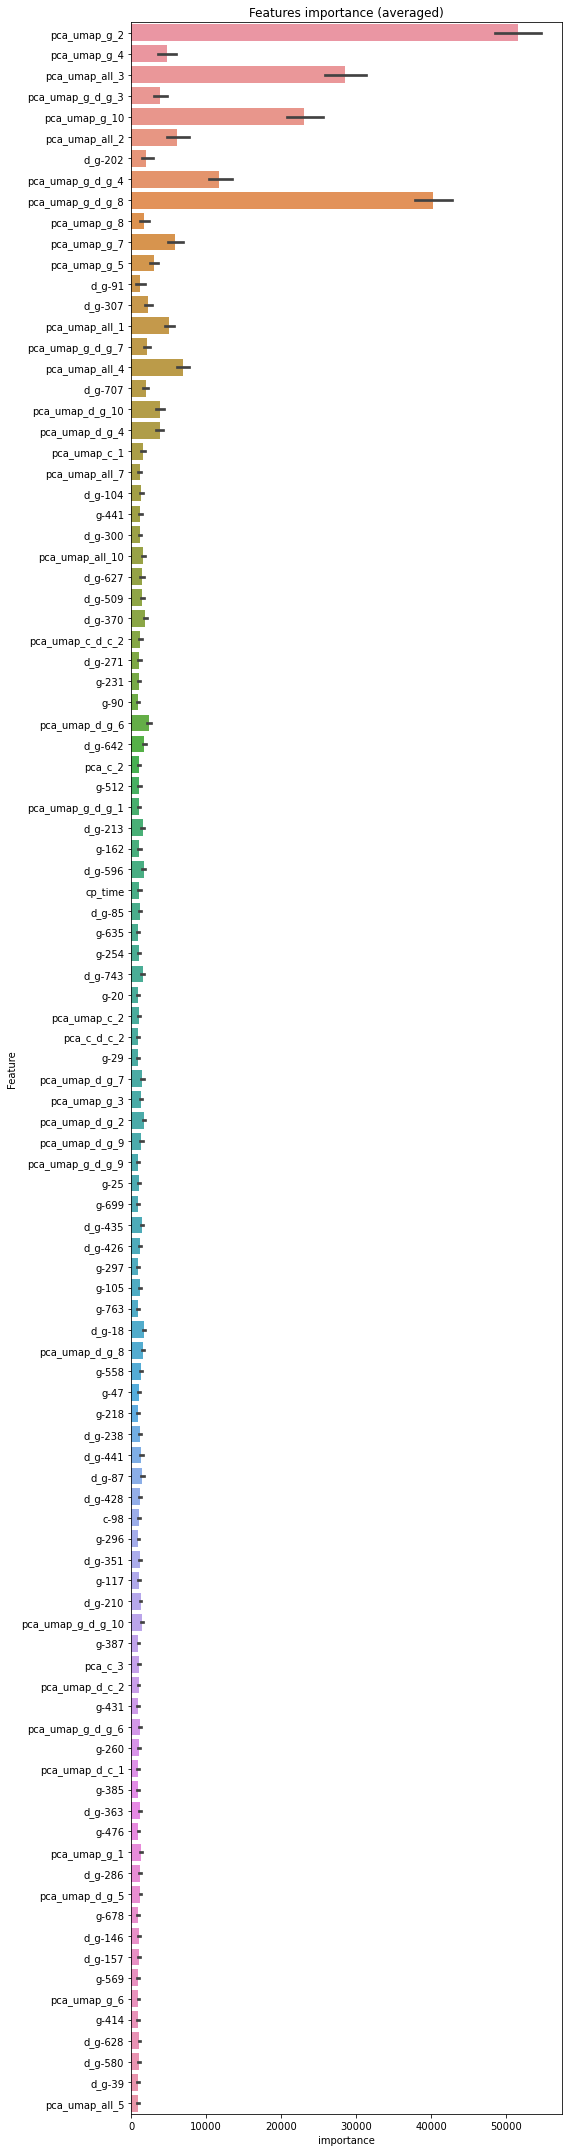

In [52]:
show_feature_importance(feature_importance_df)